# Configure KBase Jupyter Dev Environment
<sub><sup>(contact chenry@anl.gov with questions)</sub></sup>

In [2]:
import platform
print("python version " + platform.python_version())
import sys
import json
from json import dump
import os
import pandas as pd
from pandas import DataFrame, read_csv, concat, set_option
from os.path import exists
from pathlib import Path
import logging
import shutil
from configparser import ConfigParser

config = ConfigParser()
if not exists(str(Path.home()) + '/.kbase/config'):    
    if exists("/scratch/shared/code/sharedconfig.cfg"):
        shutil.copyfile("/scratch/shared/code/sharedconfig.cfg",str(Path.home()) + '/.kbase/config')
    else:
        print("You much create a config file in ~/.kbase/config before running this notebook. See instructions: https://docs.google.com/document/d/1fQ6iS_uaaZKbjWtw1MgzqilklttIibNO9XIIJWgxWKo/edit")
        sys.exit(1)
config.read(str(Path.home()) + '/.kbase/config')
paths = config.get("DevEnv","syspaths").split(";")
codebase = config.get("DevEnv","codebase",fallback="")
for i,filepath in enumerate(paths):
    if filepath[0:1] != "/":
        paths[i] = codebase+"/"+filepath
sys.path = paths + sys.path

from chenry_utility_module.kbdevutils import KBDevUtils
kbdevutil = KBDevUtils("Phenotypes")
from modelseedpy import MSPackageManager, MSModelUtil, MSBuilder, MSATPCorrection, MSGapfill, MSGrowthPhenotype, MSGrowthPhenotypes
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
msrecon = kbdevutil.msseedrecon()

com_media = msrecon.get_media("KBaseMedia/Complete")
gmm_media = msrecon.get_media("KBaseMedia/Carbon-D-Glucose")
auxo_media = msrecon.get_media("94026/Auxotrophy_media")

python version 3.9.13
KBBaseModules 0.0.1
Output files printed to:/Users/chenry/workspace/Notebooks//Phenotypes//sessions/default/output when using KBDevUtils.output_dir
modelseedpy 0.3.3
cobrakbase 0.3.1


# Managing sessions

In [2]:
# Listing all sessions
#print(kbdevutil.list_sessions())
# Changing the current session
#kbdevutil.set_session("published_biolog")
# Printing the current session
#print(kbdevutil.session)
# Printing current objects
print(kbdevutil.list())
print(kbdevutil.load("model_mapping"))

['phenotype_mapping', 'model_mapping']
{'149698.22': '149698.22.Complete.mdl', '416269.6': '416269.6.Complete.mdl', '56458.17': '56458.17.Complete.mdl', '134536.46': '134536.46.Complete.mdl', '261302.3': '261302.3.Complete.mdl', '53413.25': '53413.25.Complete.mdl', '56464.3': '56464.3.Complete.mdl', '702115.9': '702115.9.Complete.mdl', '56449.4': '56449.4.Complete.mdl', '1663.233': '1663.233.Complete.mdl', '78229.3': '78229.3.Complete.mdl', '56459.70': '56459.70.Complete.mdl', '104336.19': '104336.19.Complete.mdl', '1663.218': '1663.218.Complete.mdl', '80842.11': '80842.11.Complete.mdl', '242605.18': '242605.18.Complete.mdl', '286.2262': '286.2262.Complete.mdl', '575584.19': '575584.19.Complete.mdl', '80878.16': '80878.16.Complete.mdl', '134536.40': '134536.40.Complete.mdl', '1663.250': '1663.250.Complete.mdl', '379.417': '379.417.Complete.mdl', '104336.20': '104336.20.Complete.mdl', '80881.4': '80881.4.Complete.mdl', '64187.548': '64187.548.Complete.mdl', '1883.1827': '1883.1827.Compl

# Simulate all models in a workspace with a specific phenotype set

In [ ]:
#Pull the phenotype set to be simulated across all the models - you may need to reset the phenotype set ID
#By default, this runs a full set of phenotypes from E. coli
target_phenotypeset = "157564/Full_Biolog_Dataset"
model_workspace = 156600
phenoset = msrecon.get_phenotypeset(target_phenotypeset,base_media=auxo_media, base_uptake=100, base_excretion=1000,global_atom_limits={"C":1})
model_list = msrecon.kbase_api.list_objects(model_workspace, object_type="KBaseFBA.FBAModel", include_metadata=True)
for item in model_list:
    if not exists(kbdevutil.notebook_output_dir()+"/"+item[1]+"-details.csv"):
        print("Simulating "+item[1])
        mdlutl = msrecon.get_model(kbdevutil.wsinfo_to_ref(item))
        mdlutl.model.objective = "bio1"
        output = phenoset.simulate_phenotypes(mdlutl,"bio1",True,ignore_growth_data=True)
        output["details"].to_csv(kbdevutil.notebook_output_dir()+"/"+item[1]+"-details.csv")
        output["summary"].to_csv(kbdevutil.notebook_output_dir()+"/"+item[1]+"-summary.csv")

# Simulate a single model with a specific phenotype set

In [3]:
target_phenotypeset = "157564/Full_Biolog_Dataset"
#phenoset = msrecon.get_phenotypeset(target_phenotypeset,base_media=auxo_media, base_uptake=100, base_excretion=1000,global_atom_limits={"C":1})
phenoset = msrecon.get_phenotypeset(target_phenotypeset,base_media=None, base_uptake=0, base_excretion=1000,global_atom_limits={})
mdlutl = msrecon.get_model("151253/GCF_000005845.2.RAST.NewGMM.mdl")
mdlutl.model.objective = "bio1"
output = phenoset.simulate_phenotypes(mdlutl,"bio1",True,ignore_growth_data=True)
output["details"].to_csv(kbdevutil.output_dir+"/details.csv",index=False)
output["summary"].to_csv(kbdevutil.output_dir+"/summary.csv",index=False)

1706305632.325055 INFO: metabolites 1517
1706305632.792674 INFO: reactions 1650
1706305633.709056 INFO: Default biomass: [bio1]
1706305634.014157 INFO: cpd01947 not found in model!
1706305634.0146801 INFO: Media compound: cpd01947 not found in model.
1706305634.096939 INFO: cpd01834 not found in model!
1706305634.097534 INFO: Media compound: cpd01834 not found in model.


Carbon-1-2-Propanediol False NOGROWTH 0.0 0.01 True
Carbon-2-3-Butanediol False NOGROWTH 0.0 0.01 True
Carbon-2-3-Butanone False NOGROWTH 0.0 0.01 True


1706305634.2582872 INFO: cpd00599 not found in model!
1706305634.258807 INFO: Media compound: cpd00599 not found in model.


Carbon-2-Deoxy-D-Ribose False NOGROWTH 0.0 0.01 True
Carbon-2-Hydroxy-Benzoic-Acid False NOGROWTH 0.0 0.01 True
Carbon-2-Deoxy-Adenosine True GROWTH 0.6071227604932484 0.01 True


1706305634.42528 INFO: cpd00361 not found in model!
1706305634.425856 INFO: Media compound: cpd00361 not found in model.
1706305634.596575 INFO: cpd00851 not found in model!
1706305634.5971599 INFO: Media compound: cpd00851 not found in model.


Carbon-3-Hydroxy-2-Butanone False NOGROWTH 0.0 0.01 True
Carbon-4-Hydroxy-Benzoic-Acid False NOGROWTH 0.0 0.01 True
Carbon-4-Hydroxy-L-Proline-trans False NOGROWTH 0.0 0.01 True
Carbon-Acetamide False NOGROWTH 0.0 0.01 True
Carbon-Acetic-Acid True GROWTH 0.15652248070743235 0.01 True
Carbon-Acetoacetic-Acid True GROWTH 0.3339146255091898 0.01 True


1706305635.040871 INFO: cpd00366 not found in model!
1706305635.041406 INFO: Media compound: cpd00366 not found in model.
1706305635.122901 INFO: cpd05240 not found in model!
1706305635.1235268 INFO: Media compound: cpd05240 not found in model.


Carbon-Adenosine True GROWTH 0.5547647802983805 0.01 True
Carbon-Adonitol False NOGROWTH 0.0 0.01 True
Carbon-Amygdalin False NOGROWTH 0.0 0.01 True


1706305635.278722 INFO: cpd01799 not found in model!
1706305635.2792552 INFO: Media compound: cpd01799 not found in model.


Carbon-Arbutin False NOGROWTH 0.0 0.01 True
Carbon-Butylamine-sec False NOGROWTH 0.0 0.01 True
Carbon-Butyric-Acid False NOGROWTH 0.0 0.01 True


1706305635.5059881 INFO: cpd01113 not found in model!
1706305635.5065632 INFO: Media compound: cpd01113 not found in model.
1706305635.587757 INFO: cpd11717 not found in model!
1706305635.588335 INFO: Media compound: cpd11717 not found in model.


Carbon-Capric-Acid False NOGROWTH 0.0 0.01 True
Carbon-Caproic-Acid False NOGROWTH 0.0 0.01 True
Carbon-Chondroitin-Sulfate-C False NOGROWTH 0.0 0.01 True


1706305635.670998 INFO: cpd01502 not found in model!
1706305635.6716008 INFO: Media compound: cpd01502 not found in model.
1706305635.8923159 INFO: cpd01701 not found in model!


Carbon-Citraconic-Acid False NOGROWTH 0.0 0.01 True
Carbon-Citric-Acid True GROWTH 0.42321691893143293 0.01 True
Carbon-D-L-Carnitine False NOGROWTH 0.0 0.01 True


1706305635.893454 INFO: Media compound: cpd01701 not found in model.
1706305636.052654 INFO: cpd02599 not found in model!
1706305636.053194 INFO: Media compound: cpd02599 not found in model.


Carbon-D-L-Citramalic-Acid False NOGROWTH 0.0 0.01 True
Carbon-D-L-Malic-Acid True GROWTH 0.2817404652733772 0.01 True
Carbon-D-L-Octopamine False NOGROWTH 0.0 0.01 True
Carbon-D-L-a-Glycerol-Phosphate True GROWTH 0.33698818223603044 0.01 True
Carbon-D-Alanine True GROWTH 0.2556533851554727 0.01 True
Carbon-D-Arabinose False NOGROWTH 0.0 0.01 True


1706305636.5173178 INFO: cpd01307 not found in model!
1706305636.517889 INFO: Media compound: cpd01307 not found in model.
1706305636.6014662 INFO: cpd00320 not found in model!
1706305636.602018 INFO: Media compound: cpd00320 not found in model.


Carbon-D-Arabitol False NOGROWTH 0.0 0.01 True
Carbon-D-Aspartic-Acid False NOGROWTH 0.0 0.01 True
Carbon-D-Cellobiose True GROWTH 0.6255695356616084 0.01 True


1706305636.920605 INFO: cpd00750 not found in model!
1706305636.921144 INFO: Media compound: cpd00750 not found in model.


Carbon-D-Fructose True GROWTH 0.5530460984995939 0.01 True
Carbon-D-Fructose-6-Phosphate False NOGROWTH 0.0 0.01 True
Carbon-D-Fucose False NOGROWTH 0.0 0.01 True


1706305637.0016818 INFO: cpd00765 not found in model!
1706305637.002235 INFO: Media compound: cpd00765 not found in model.


Carbon-D-Galactonic-Acid-g-Lactone False NOGROWTH 0.0 0.01 True
Carbon-D-Galactose True GROWTH 0.5284113287957855 0.01 True
Carbon-D-Galacturonic-Acid True GROWTH 0.4539151940515528 0.01 True


1706305637.40173 INFO: cpd02351 not found in model!
1706305637.402275 INFO: Media compound: cpd02351 not found in model.


Carbon-D-Gluconic-Acid True GROWTH 0.5013803862336218 0.01 True
Carbon-D-Glucosamine True GROWTH 0.5545703054688447 0.01 True
Carbon-D-Glucosaminic-Acid False NOGROWTH 0.0 0.01 True
Carbon-D-Glucose True GROWTH 6.361406226384806 0.01 True
Carbon-D-Glucose-1-Phosphate False NOGROWTH 0.0 0.01 True
Carbon-D-Glucose-6-Phosphate True GROWTH 0.5598021008034545 0.01 True


1706305637.8429298 INFO: cpd09457 not found in model!
1706305637.843502 INFO: Media compound: cpd09457 not found in model.


Carbon-D-Glucuronic-Acid True GROWTH 0.4539151940515542 0.01 True
Carbon-D-Lactitol False NOGROWTH 0.0 0.01 True
Carbon-D-Malic-Acid True GROWTH 0.2608708011790553 0.01 True


1706305638.1691678 INFO: cpd05161 not found in model!
1706305638.169717 INFO: Media compound: cpd05161 not found in model.


Carbon-D-Mannitol True GROWTH 0.5938087704784336 0.01 True
Carbon-D-Mannose True GROWTH 0.5545703054688458 0.01 True
Carbon-D-Melezitose False NOGROWTH 0.0 0.01 True


1706305638.330765 INFO: cpd03884 not found in model!
1706305638.331289 INFO: Media compound: cpd03884 not found in model.


Carbon-D-Melibiose True GROWTH 0.6255695356615965 0.01 True
Carbon-D-Psicose False NOGROWTH 0.0 0.01 True
Carbon-D-Raffinose False NOGROWTH 0.0 0.01 True
Carbon-D-Ribose True GROWTH 0.44121473988559007 0.01 True
Carbon-D-Saccharic-Acid True GROWTH 0.3991323258039514 0.01 True
Carbon-D-Serine True GROWTH 0.21652276497861467 0.01 True


1706305638.83973 INFO: cpd00589 not found in model!
1706305638.840275 INFO: Media compound: cpd00589 not found in model.


Carbon-D-Sorbitol True GROWTH 0.5938087704784325 0.01 True
Carbon-D-Tagatose False NOGROWTH 0.0 0.01 True


1706305639.1295512 INFO: cpd00611 not found in model!
1706305639.130152 INFO: Media compound: cpd00611 not found in model.


Carbon-D-Tartaric-Acid False NOGROWTH 0.0 0.01 True
Carbon-D-Threonine False NOGROWTH 0.0 0.01 True
Carbon-D-Trehalose True GROWTH 0.6255695356616184 0.01 True


1706305639.3944378 INFO: cpd11594 not found in model!
1706305639.3949819 INFO: Media compound: cpd11594 not found in model.


Carbon-D-Xylose True GROWTH 0.4569101258894247 0.01 True
Carbon-Dextrin False NOGROWTH 0.0 0.01 True
Carbon-Dihydroxy-Acetone False NOGROWTH 0.0 0.01 True
Carbon-Dulcitol True GROWTH 0.5921767186764558 0.01 True
Carbon-Ethanolamine True GROWTH 0.21130534895503258 0.01 True
Carbon-Formic-Acid True GROWTH 0.03057006827249401 0.01 True


1706305639.863656 INFO: cpd11879 not found in model!
1706305639.864182 INFO: Media compound: cpd11879 not found in model.
1706305639.9436328 INFO: cpd05158 not found in model!
1706305639.9441762 INFO: Media compound: cpd05158 not found in model.


Carbon-Fumaric-Acid True GROWTH 0.2817404652733799 0.01 True
Carbon-Gelatin False NOGROWTH 0.0 0.01 True
Carbon-Gentiobiose False NOGROWTH 0.0 0.01 True
Carbon-Glycerol True GROWTH 0.3156536694266532 0.01 True
Carbon-Glycine True GROWTH 0.12878189828336833 0.01 True
Carbon-Glycogen False NOGROWTH 0.0 0.01 True
Carbon-Glycolic-Acid True GROWTH 0.13071500520265006 0.01 True
Carbon-Glycyl-L-Aspartic-Acid False NOGROWTH 0.0 0.01 True
Carbon-Glycyl-L-Glutamic-Acid False NOGROWTH 0.0 0.01 True
Carbon-Glycyl-L-Proline False NOGROWTH 0.0 0.01 True
Carbon-Glyoxylic-Acid False NOGROWTH 0.0 0.01 True
Carbon-Inosine True GROWTH 0.5489976354003727 0.01 True


1706305640.726412 INFO: cpd11602 not found in model!
1706305640.726913 INFO: Media compound: cpd11602 not found in model.
1706305640.8100312 INFO: cpd00380 not found in model!
1706305640.810524 INFO: Media compound: cpd00380 not found in model.


Carbon-Inulin False NOGROWTH 0.0 0.01 True
Carbon-Itaconic-Acid False NOGROWTH 0.0 0.01 True
Carbon-L-Alanine True GROWTH 0.25565338515547564 0.01 True


1706305641.1326652 INFO: cpd00417 not found in model!
1706305641.133194 INFO: Media compound: cpd00417 not found in model.


Carbon-L-Alanyl-Glycine False NOGROWTH 0.0 0.01 True
Carbon-L-Arabinose True GROWTH 0.4569101258894238 0.01 True
Carbon-L-Arabitol False NOGROWTH 0.0 0.01 True
Carbon-L-Arginine True GROWTH 0.4721400366484629 0.01 True
Carbon-L-Asparagine True GROWTH 0.2819685939564907 0.01 True
Carbon-L-Aspartic-Acid True GROWTH 0.28174046527337854 0.01 True
Carbon-L-Fucose True GROWTH 0.5660896385585447 0.01 True
Carbon-L-Glutamic-Acid True GROWTH 0.41745953056071144 0.01 True
Carbon-L-Glutamine True GROWTH 0.4033083600332305 0.01 True
Carbon-L-Histidine False NOGROWTH 0.0 0.01 True
Carbon-L-Homoserine False NOGROWTH 0.0 0.01 True
Carbon-L-Isoleucine False NOGROWTH 0.0 0.01 True
Carbon-L-Lactic-Acid True GROWTH 0.2556533851554722 0.01 True
Carbon-L-Leucine False NOGROWTH 0.0 0.01 True
Carbon-L-Lysine False NOGROWTH 0.0 0.01 True
Carbon-L-Lyxose False NOGROWTH 0.0 0.01 True
Carbon-L-Malic-Acid True GROWTH 0.28174046527337676 0.01 True
Carbon-L-Methionine False NOGROWTH 0.0 0.01 True
Carbon-L-Ornithine

1706305642.9255629 INFO: cpd01293 not found in model!
1706305642.9260612 INFO: Media compound: cpd01293 not found in model.


Carbon-L-Proline True GROWTH 0.4778164448817945 0.01 True
Carbon-L-Pyroglutamic-Acid False NOGROWTH 0.0 0.01 True
Carbon-L-Rhamnose True GROWTH 0.566089638558549 0.01 True
Carbon-L-Serine True GROWTH 0.21792055797325355 0.01 True
Carbon-L-Sorbose False NOGROWTH 0.0 0.01 True
Carbon-L-Tartaric-Acid False NOGROWTH 0.0 0.01 True


1706305643.48825 INFO: cpd01068 not found in model!
1706305643.488791 INFO: Media compound: cpd01068 not found in model.


Carbon-L-Threonine True GROWTH 0.3469226647633551 0.01 True
Carbon-L-Valine False NOGROWTH 0.0 0.01 True
Carbon-L-Xylose False NOGROWTH 0.0 0.01 True


1706305643.57173 INFO: cpd04349 not found in model!
1706305643.572494 INFO: Media compound: cpd04349 not found in model.
1706305643.655253 INFO: cpd11748 not found in model!
1706305643.6557949 INFO: Media compound: cpd11748 not found in model.
1706305643.7347999 INFO: cpd00308 not found in model!
1706305643.735337 INFO: Media compound: cpd00308 not found in model.


Carbon-Lactulose False NOGROWTH 0.0 0.01 True
Carbon-Laminarin False NOGROWTH 0.0 0.01 True
Carbon-Malonic-Acid False NOGROWTH 0.0 0.01 True


1706305643.969873 INFO: cpd11685 not found in model!
1706305643.970415 INFO: Media compound: cpd11685 not found in model.


Carbon-Maltose True GROWTH 0.6255695356616023 0.01 True
Carbon-Maltotriose True GROWTH 0.6255695356615941 0.01 True
Carbon-Mannan False NOGROWTH 0.0 0.01 True


1706305644.2798889 INFO: cpd00832 not found in model!
1706305644.280499 INFO: Media compound: cpd00832 not found in model.


Carbon-Mucic-Acid False NOGROWTH 0.0 0.01 True
Carbon-N-Acetyl-D-Galactosamine False NOGROWTH 0.0 0.01 True
Carbon-N-Acetyl-D-Glucosamine True GROWTH 0.716755960841808 0.01 True
Carbon-N-Acetyl-L-Glutamic-Acid False NOGROWTH 0.0 0.01 True
Carbon-N-Acetyl-Neuraminic-Acid False NOGROWTH 0.0 0.01 True
Carbon-N-Acetyl-b-D-Mannosamine False NOGROWTH 0.0 0.01 True


1706305644.7577028 INFO: cpd01363 not found in model!
1706305644.758265 INFO: Media compound: cpd01363 not found in model.
1706305644.838551 INFO: cpd01200 not found in model!
1706305644.8390882 INFO: Media compound: cpd01200 not found in model.


Carbon-Oxalic-Acid False NOGROWTH 0.0 0.01 True
Carbon-Oxalomalic-Acid False NOGROWTH 0.0 0.01 True
Carbon-Palatinose False NOGROWTH 0.0 0.01 True


1706305644.914655 INFO: cpd11601 not found in model!
1706305644.915473 INFO: Media compound: cpd11601 not found in model.


Carbon-Pectin False NOGROWTH 0.0 0.01 True
Carbon-Propionic-Acid True GROWTH 0.2744526944659534 0.01 True
Carbon-Putrescine True GROWTH 0.4525184129144662 0.01 True


1706305645.39275 INFO: cpd05192 not found in model!
1706305645.3933 INFO: Media compound: cpd05192 not found in model.


Carbon-Pyruvic-Acid True GROWTH 0.21652276497861503 0.01 True
Carbon-Quinic-Acid False NOGROWTH 0.0 0.01 True
Carbon-Salicin False NOGROWTH 0.0 0.01 True
Carbon-Sebacic-Acid False NOGROWTH 0.0 0.01 True
Carbon-Stachyose False NOGROWTH 0.0 0.01 True
Carbon-Succinic-Acid True GROWTH 0.3208710854502363 0.01 True


1706305645.8160572 INFO: cpd13391 not found in model!
1706305645.8165839 INFO: Media compound: cpd13391 not found in model.


Carbon-Sucrose False NOGROWTH 0.0 0.01 True
Carbon-Thymidine True GROWTH 0.514175162889567 0.01 True
Carbon-Tween-20 False NOGROWTH 0.0 0.01 True


1706305645.897376 INFO: cpd13392 not found in model!
1706305645.897873 INFO: Media compound: cpd13392 not found in model.


Carbon-Tween-80 False NOGROWTH 0.0 0.01 True
Carbon-Tyramine False NOGROWTH 0.0 0.01 True
Carbon-Uridine True GROWTH 0.4667136632113245 0.01 True


1706305646.120764 INFO: cpd00306 not found in model!
1706305646.121525 INFO: Media compound: cpd00306 not found in model.


Carbon-Xylitol False NOGROWTH 0.0 0.01 True
Carbon-a-D-Glucose True GROWTH 0.5545703054688421 0.01 True
Carbon-a-D-Lactose True GROWTH 0.6255695356615963 0.01 True


1706305646.475679 INFO: cpd03561 not found in model!
1706305646.476515 INFO: Media compound: cpd03561 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False NOGROWTH 0.0 0.01 True
Carbon-a-Keto-Butyric-Acid False NOGROWTH 0.0 0.01 True
Carbon-a-Keto-Glutaric-Acid True GROWTH 0.3808713697214183 0.01 True


1706305646.767699 INFO: cpd03737 not found in model!
1706305646.768403 INFO: Media compound: cpd03737 not found in model.
1706305646.850313 INFO: cpd02274 not found in model!
1706305646.8508348 INFO: Media compound: cpd02274 not found in model.
1706305646.928523 INFO: cpd15584 not found in model!
1706305646.9290628 INFO: Media compound: cpd15584 not found in model.


Carbon-a-Keto-Valeric-Acid False NOGROWTH 0.0 0.01 True
Carbon-a-Methyl-D-Galactoside False NOGROWTH 0.0 0.01 True
Carbon-a-Methyl-D-Glucoside False NOGROWTH 0.0 0.01 True


1706305647.0909061 INFO: cpd00876 not found in model!
1706305647.091577 INFO: Media compound: cpd00876 not found in model.
1706305647.1741068 INFO: cpd02274 not found in model!
1706305647.174651 INFO: Media compound: cpd02274 not found in model.


Carbon-b-D-Allose False NOGROWTH 0.0 0.01 True
Carbon-b-Hydroxy-Butyric-Acid False NOGROWTH 0.0 0.01 True
Carbon-b-Methyl-D-Galactoside False NOGROWTH 0.0 0.01 True


1706305647.2543628 INFO: cpd15585 not found in model!
1706305647.254957 INFO: Media compound: cpd15585 not found in model.
1706305647.339627 INFO: cpd03161 not found in model!
1706305647.340152 INFO: Media compound: cpd03161 not found in model.


Carbon-b-Methyl-D-Glucoside False NOGROWTH 0.0 0.01 True
Carbon-b-Phenylethylamine False NOGROWTH 0.0 0.01 True
Carbon-d-Amino-Valeric-Acid False NOGROWTH 0.0 0.01 True


1706305647.573355 INFO: cpd00728 not found in model!
1706305647.573907 INFO: Media compound: cpd00728 not found in model.
1706305647.655743 INFO: cpd00392 not found in model!
1706305647.656384 INFO: Media compound: cpd00392 not found in model.


Carbon-g-Amino-Butyric-Acid True GROWTH 0.3912643051620009 0.01 True
Carbon-g-Hydroxy-Butyric-Acid False NOGROWTH 0.0 0.01 True
Carbon-i-Erythritol False NOGROWTH 0.0 0.01 True


1706305647.833784 INFO: cpd00432 not found in model!
1706305647.83446 INFO: Media compound: cpd00432 not found in model.
1706305647.913514 INFO: cpd00489 not found in model!
1706305647.9140449 INFO: Media compound: cpd00489 not found in model.


Carbon-m-Inositol False NOGROWTH 0.0 0.01 True
Carbon-m-Tartaric-Acid False NOGROWTH 0.0 0.01 True
Carbon-p-Hydroxy-Phenylacetic-Acid False NOGROWTH 0.0 0.01 True


1706305647.990005 INFO: cpd16648 not found in model!
1706305647.99061 INFO: Media compound: cpd16648 not found in model.
1706305648.072394 INFO: cpd16654 not found in model!
1706305648.073062 INFO: Media compound: cpd16654 not found in model.


Carbon-sorbate False NOGROWTH 0.0 0.01 True
Carbon-tricarballylate False NOGROWTH 0.0 0.01 True
Nitrogen-Acetamide False NOGROWTH 0.0 0.01 True
Nitrogen-Adenine True GROWTH 0.6487025865469885 0.01 True
Nitrogen-Adenosine True GROWTH 0.7165322143069824 0.01 True
Nitrogen-Agmatine False NOGROWTH 0.0 0.01 True
Nitrogen-Ala-Asp False NOGROWTH 0.0 0.01 True
Nitrogen-Ala-Gln False NOGROWTH 0.0 0.01 True
Nitrogen-Ala-Glu False NOGROWTH 0.0 0.01 True
Nitrogen-Ala-Gly False NOGROWTH 0.0 0.01 True
Nitrogen-Ala-His False NOGROWTH 0.0 0.01 True
Nitrogen-Ala-Leu False NOGROWTH 0.0 0.01 True
Nitrogen-Ala-Thr False NOGROWTH 0.0 0.01 True
Nitrogen-Allantoin False NOGROWTH 0.0 0.01 True


1706305649.2575302 INFO: cpd03963 not found in model!
1706305649.258068 INFO: Media compound: cpd03963 not found in model.


Nitrogen-Ammonia True GROWTH 0.554570305468845 0.01 True
Nitrogen-Biuret False NOGROWTH 0.0 0.01 True
Nitrogen-Cytidine True GROWTH 0.6536655781586087 0.01 True


1706305649.514236 INFO: cpd01573 not found in model!
1706305649.5147562 INFO: Media compound: cpd01573 not found in model.


Nitrogen-Cytosine True GROWTH 0.5655379342597789 0.01 True
Nitrogen-D-L-a-Amino-N-Butyric-Acid False NOGROWTH 0.0 0.01 True
Nitrogen-D-Alanine True GROWTH 0.6255695356615952 0.01 True


1706305649.68686 INFO: cpd01308 not found in model!
1706305649.687385 INFO: Media compound: cpd01308 not found in model.
1706305649.770106 INFO: cpd00320 not found in model!
1706305649.770623 INFO: Media compound: cpd00320 not found in model.
1706305649.8461702 INFO: cpd01524 not found in model!
1706305649.846706 INFO: Media compound: cpd01524 not found in model.


Nitrogen-D-Asparagine False NOGROWTH 0.0 0.01 True
Nitrogen-D-Aspartic-Acid False NOGROWTH 0.0 0.01 True
Nitrogen-D-Galactosamine False NOGROWTH 0.0 0.01 True


1706305650.083936 INFO: cpd00549 not found in model!
1706305650.084488 INFO: Media compound: cpd00549 not found in model.


Nitrogen-D-Glucosamine True GROWTH 0.6255695356616019 0.01 True
Nitrogen-D-Glutamic-Acid False NOGROWTH 0.0 0.01 True
Nitrogen-D-Lysine False NOGROWTH 0.0 0.01 True


1706305650.165353 INFO: cpd02241 not found in model!
1706305650.166192 INFO: Media compound: cpd02241 not found in model.
1706305650.3401222 INFO: cpd03840 not found in model!
1706305650.3409479 INFO: Media compound: cpd03840 not found in model.


Nitrogen-D-Mannosamine False NOGROWTH 0.0 0.01 True
Nitrogen-D-Serine True GROWTH 0.6255695356616158 0.01 True
Nitrogen-D-Valine False NOGROWTH 0.0 0.01 True


1706305650.5223749 INFO: cpd00591 not found in model!
1706305650.522938 INFO: Media compound: cpd00591 not found in model.
1706305650.6061702 INFO: cpd00378 not found in model!
1706305650.606735 INFO: Media compound: cpd00378 not found in model.


Nitrogen-Ethanolamine True GROWTH 0.6255695356616044 0.01 True
Nitrogen-Ethylamine False NOGROWTH 0.0 0.01 True
Nitrogen-Formamide False NOGROWTH 0.0 0.01 True
Nitrogen-Gly-Asn False NOGROWTH 0.0 0.01 True
Nitrogen-Gly-Gln False NOGROWTH 0.0 0.01 True
Nitrogen-Gly-Glu False NOGROWTH 0.0 0.01 True
Nitrogen-Gly-Met False NOGROWTH 0.0 0.01 True
Nitrogen-Glycine True GROWTH 0.6255695356615987 0.01 True
Nitrogen-Guanine False NOGROWTH 0.0 0.01 True


1706305651.213033 INFO: cpd00312 not found in model!
1706305651.213538 INFO: Media compound: cpd00312 not found in model.


Nitrogen-Guanosine True GROWTH 0.716532214306985 0.01 True
Nitrogen-Histamine False NOGROWTH 0.0 0.01 True
Nitrogen-Hydroxylamine False NOGROWTH 0.0 0.01 True
Nitrogen-Inosine False NOGROWTH 0.0 0.01 True
Nitrogen-L-Alanine True GROWTH 0.6255695356615979 0.01 True
Nitrogen-L-Arginine True GROWTH 1.043712032588505 0.01 True
Nitrogen-L-Asparagine True GROWTH 0.837766922820648 0.01 True
Nitrogen-L-Aspartic-Acid True GROWTH 0.6255695356616044 0.01 True
Nitrogen-L-Citrulline False NOGROWTH 0.0 0.01 True
Nitrogen-L-Cysteine False NOGROWTH 0.0 0.01 True
Nitrogen-L-Glutamic-Acid True GROWTH 0.6255695356616012 0.01 True
Nitrogen-L-Glutamine True GROWTH 0.960034443901253 0.01 True
Nitrogen-L-Histidine False NOGROWTH 0.0 0.01 True
Nitrogen-L-Homoserine False NOGROWTH 0.0 0.01 True
Nitrogen-L-Isoleucine False NOGROWTH 0.0 0.01 True
Nitrogen-L-Leucine False NOGROWTH 0.0 0.01 True
Nitrogen-L-Lysine False NOGROWTH 0.0 0.01 True
Nitrogen-L-Methionine False NOGROWTH 0.0 0.01 True
Nitrogen-L-Ornithine T

1706305652.9862888 INFO: cpd01293 not found in model!
1706305652.986965 INFO: Media compound: cpd01293 not found in model.


Nitrogen-L-Pyroglutamic-Acid False NOGROWTH 0.0 0.01 True
Nitrogen-L-Serine True GROWTH 0.6255695356616044 0.01 True
Nitrogen-L-Threonine True GROWTH 0.6255695356616036 0.01 True
Nitrogen-L-Tryptophan False NOGROWTH 0.0 0.01 True
Nitrogen-L-Tyrosine False NOGROWTH 0.0 0.01 True
Nitrogen-L-Valine False NOGROWTH 0.0 0.01 True


1706305653.57734 INFO: cpd00187 not found in model!
1706305653.5778089 INFO: Media compound: cpd00187 not found in model.


Nitrogen-Met-Ala False NOGROWTH 0.0 0.01 True
Nitrogen-Methylamine False NOGROWTH 0.0 0.01 True
Nitrogen-N-Acetyl-D-L-Glutamic-Acid False NOGROWTH 0.0 0.01 True


1706305653.7421608 INFO: cpd00832 not found in model!
1706305653.7428749 INFO: Media compound: cpd00832 not found in model.


Nitrogen-N-Acetyl-D-Galactosamine False NOGROWTH 0.0 0.01 True
Nitrogen-N-Acetyl-D-Glucosamine True GROWTH 0.6255695356615911 0.01 True
Nitrogen-N-Acetyl-D-Mannosamine False NOGROWTH 0.0 0.01 True
Nitrogen-Nitrate True GROWTH 0.46106270867245036 0.01 True
Nitrogen-Nitrite True GROWTH 0.4700505585097696 0.01 True
Nitrogen-Putrescine True GROWTH 1.0228570875513259 0.01 True
Nitrogen-Thymidine False NOGROWTH 0.0 0.01 True
Nitrogen-Thymine False NOGROWTH 0.0 0.01 True
Nitrogen-Tyramine False NOGROWTH 0.0 0.01 True
Nitrogen-Uracil False NOGROWTH 0.0 0.01 True
Nitrogen-Urea False NOGROWTH 0.0 0.01 True
Nitrogen-Uric-Acid False NOGROWTH 0.0 0.01 True
Nitrogen-Uridine False NOGROWTH 0.0 0.01 True
Nitrogen-Xanthine False NOGROWTH 0.0 0.01 True


1706305655.096111 INFO: cpd03161 not found in model!
1706305655.096797 INFO: Media compound: cpd03161 not found in model.


Nitrogen-Xanthosine False NOGROWTH 0.0 0.01 True
Nitrogen-b-Phenylethylamine False NOGROWTH 0.0 0.01 True
Nitrogen-d-Amino-N-Valeric-Acid False NOGROWTH 0.0 0.01 True


1706305655.24388 INFO: cpd01588 not found in model!
1706305655.244564 INFO: Media compound: cpd01588 not found in model.
1706305655.406556 INFO: cpd02233 not found in model!
1706305655.4070442 INFO: Media compound: cpd02233 not found in model.


Nitrogen-e-Amino-N-Caproic-Acid False NOGROWTH 0.0 0.01 True
Nitrogen-g-Amino-N-Butyric-Acid True GROWTH 0.6255695356616024 0.01 True
Phosphate-2-Aminoethyl-Phosphonic-Acid False NOGROWTH 0.0 0.01 True


1706305655.709696 INFO: cpd00700 not found in model!
1706305655.7102022 INFO: Media compound: cpd00700 not found in model.


Phosphate-2-Deoxy-D-Glucose-6-Phosphate False NOGROWTH 0.0 0.01 True
Phosphate-6-Phospho-Gluconic-Acid False NOGROWTH 0.0 0.01 True
Phosphate-Adenosine-2-3-Cyclic-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Adenosine-2-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Adenosine-3-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Adenosine-5-Monophosphate False NOGROWTH 0.0 0.01 True


1706305656.008975 INFO: cpd01991 not found in model!
1706305656.0094888 INFO: Media compound: cpd01991 not found in model.
1706305656.0922801 INFO: cpd00696 not found in model!
1706305656.09291 INFO: Media compound: cpd00696 not found in model.


Phosphate-Cytidine-2-3-Cyclic-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Cytidine-2-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Cytidine-3-5-Cyclic-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Cytidine-3-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Cytidine-5-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-D-L-a-Glycerol-Phosphate True GROWTH 0.6255695356616082 0.01 True
Phosphate-D-2-Phospho-Glyceric-Acid False NOGROWTH 0.0 0.01 True
Phosphate-D-3-Phospho-Glyceric-Acid False NOGROWTH 0.0 0.01 True
Phosphate-D-Glucosamine-6-Phosphate False NOGROWTH 0.0 0.01 True
Phosphate-D-Glucose-1-Phosphate False NOGROWTH 0.0 0.01 True
Phosphate-D-Glucose-6-Phosphate True GROWTH 0.625569535661594 0.01 True
Phosphate-D-Mannose-1-Phosphate False NOGROWTH 0.0 0.01 True


1706305657.1702359 INFO: cpd00697 not found in model!
1706305657.170763 INFO: Media compound: cpd00697 not found in model.


Phosphate-D-Mannose-6-Phosphate True GROWTH 0.6255695356615981 0.01 True
Phosphate-Guanosine-2-3-Cyclic-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Guanosine-3-5-Cyclic-Monophosphate False NOGROWTH 0.0 0.01 True


1706305657.399382 INFO: cpd01665 not found in model!
1706305657.399936 INFO: Media compound: cpd01665 not found in model.


Phosphate-Guanosine-3-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Guanosine-5-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-O-Phospho-D-Serine False NOGROWTH 0.0 0.01 True


1706305657.4783812 INFO: cpd03912 not found in model!
1706305657.479081 INFO: Media compound: cpd03912 not found in model.
1706305657.654235 INFO: cpd08928 not found in model!
1706305657.654856 INFO: Media compound: cpd08928 not found in model.


Phosphate-O-Phospho-D-Tyrosine False NOGROWTH 0.0 0.01 True
Phosphate-O-Phospho-L-Serine False NOGROWTH 0.0 0.01 True
Phosphate-O-Phospho-L-Threonine False NOGROWTH 0.0 0.01 True


1706305657.735632 INFO: cpd03912 not found in model!
1706305657.736328 INFO: Media compound: cpd03912 not found in model.
1706305657.816288 INFO: cpd00285 not found in model!
1706305657.816811 INFO: Media compound: cpd00285 not found in model.


Phosphate-O-Phospho-L-Tyrosine False NOGROWTH 0.0 0.01 True
Phosphate-O-Phosphoryl-Ethanolamine False NOGROWTH 0.0 0.01 True
Phosphate-Phosphate True GROWTH 0.5545703054688412 0.01 True


1706305658.05407 INFO: cpd03535 not found in model!
1706305658.0546088 INFO: Media compound: cpd03535 not found in model.


Phosphate-Phospho-Glycolic-Acid False NOGROWTH 0.0 0.01 True
Phosphate-Phospho-L-Arginine False NOGROWTH 0.0 0.01 True
Phosphate-Phosphocreatine False NOGROWTH 0.0 0.01 True


1706305658.2861922 INFO: cpd03385 not found in model!
1706305658.2869198 INFO: Media compound: cpd03385 not found in model.
1706305658.365437 INFO: cpd00457 not found in model!
1706305658.365976 INFO: Media compound: cpd00457 not found in model.


Phosphate-Phosphoenol-Pyruvate False NOGROWTH 0.0 0.01 True
Phosphate-Phosphono-Acetic-Acid False NOGROWTH 0.0 0.01 True
Phosphate-Phosphoryl-Choline False NOGROWTH 0.0 0.01 True


1706305658.605174 INFO: cpd01622 not found in model!
1706305658.6057029 INFO: Media compound: cpd01622 not found in model.


Phosphate-Pyrophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Thymidine-5-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Trimetaphosphate False NOGROWTH 0.0 0.01 True


1706305658.835367 INFO: cpd01939 not found in model!
1706305658.8359082 INFO: Media compound: cpd01939 not found in model.


Phosphate-Tripolyphosphate False NOGROWTH 0.0 0.01 True
Phosphate-Uridine-2-3-Cyclic-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Uridine-2-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Uridine-3-Monophosphate False NOGROWTH 0.0 0.01 True
Phosphate-Uridine-5-Monophosphate False NOGROWTH 0.0 0.01 True


1706305659.1847942 INFO: cpd01908 not found in model!
1706305659.185518 INFO: Media compound: cpd01908 not found in model.


Phosphate-b-Glycerol-Phosphate False NOGROWTH 0.0 0.01 True
Sulfate-2-Hydroxyethane-Sulfonic-Acid True GROWTH 0.6255695356616023 0.01 True
Sulfate-Butane-Sulfonic-Acid False NOGROWTH 0.0 0.01 True


1706305659.519789 INFO: cpd01160 not found in model!
1706305659.520401 INFO: Media compound: cpd01160 not found in model.
1706305659.604167 INFO: cpd08093 not found in model!
1706305659.6047318 INFO: Media compound: cpd08093 not found in model.


Sulfate-Cystathionine False NOGROWTH 0.0 0.01 True
Sulfate-Cysteamine False NOGROWTH 0.0 0.01 True
Sulfate-D-L-Ethionine False NOGROWTH 0.0 0.01 True
Sulfate-D-L-Lipoamide False NOGROWTH 0.0 0.01 True
Sulfate-D-Cysteine False NOGROWTH 0.0 0.01 True
Sulfate-D-Methionine False NOGROWTH 0.0 0.01 True


1706305659.979861 INFO: cpd00406 not found in model!
1706305659.98058 INFO: Media compound: cpd00406 not found in model.


Sulfate-Glutathione False NOGROWTH 0.0 0.01 True
Sulfate-Hypotaurine False NOGROWTH 0.0 0.01 True
Sulfate-L-Cysteic-Acid False NOGROWTH 0.0 0.01 True


1706305660.218385 INFO: cpd00467 not found in model!
1706305660.218994 INFO: Media compound: cpd00467 not found in model.


Sulfate-L-Cysteine False NOGROWTH 0.0 0.01 True
Sulfate-L-Cysteine-Sulfinic-Acid False NOGROWTH 0.0 0.01 True
Sulfate-L-Cysteinyl-Glycine False NOGROWTH 0.0 0.01 True


1706305660.365076 INFO: cpd05190 not found in model!
1706305660.365556 INFO: Media compound: cpd05190 not found in model.


Sulfate-L-Djenkolic-Acid False NOGROWTH 0.0 0.01 True
Sulfate-L-Methionine False NOGROWTH 0.0 0.01 True
Sulfate-L-Methionine-Sulfoxide False NOGROWTH 0.0 0.01 True


1706305660.589639 INFO: cpd11577 not found in model!
1706305660.590315 INFO: Media compound: cpd11577 not found in model.
1706305660.7546072 INFO: cpd01756 not found in model!
1706305660.7551308 INFO: Media compound: cpd01756 not found in model.


Sulfate-Lanthionine False NOGROWTH 0.0 0.01 True
Sulfate-Methane-Sulfonic-Acid True GROWTH 0.5746816171425442 0.01 True
Sulfate-N-Acetyl-D-L-Methionine False NOGROWTH 0.0 0.01 True


1706305660.83636 INFO: cpd04181 not found in model!
1706305660.83694 INFO: Media compound: cpd04181 not found in model.


Sulfate-N-Acetyl-L-Cysteine False NOGROWTH 0.0 0.01 True
Sulfate-Sulfate True GROWTH 0.5545703054688434 0.01 True
Sulfate-Taurine False NOGROWTH 0.0 0.01 True


1706305661.076746 INFO: cpd03047 not found in model!
1706305661.077366 INFO: Media compound: cpd03047 not found in model.


Sulfate-Taurocholic-Acid False NOGROWTH 0.0 0.01 True
Sulfate-Tetrathionate False NOGROWTH 0.0 0.01 True
Sulfate-Thiosulfate True GROWTH 0.5574058560723727 0.01 True


1706305661.461301 INFO: cpd10114 not found in model!
1706305661.461994 INFO: Media compound: cpd10114 not found in model.
1706305661.556385 INFO: cpd03776 not found in model!
1706305661.556969 INFO: Media compound: cpd03776 not found in model.


Sulfate-Thiourea False NOGROWTH 0.0 0.01 True
Sulfate-p-Amino-Benzene-Sulfonic-Acid False NOGROWTH 0.0 0.01 True
Adjusting: 0.0 0.0 6.361406226384806 3.180703113192403


NameError: name 'item' is not defined

In [4]:
output["details"].to_csv(kbdevutil.output_dir+"/details.csv")
output["summary"].to_csv(kbdevutil.output_dir+"/summary.csv")

# Label phenotype sets with genome source IDs - used to link phenotype sets to models

In [5]:
pheno_ws = 101536
phenotype_mapping_hash = {}
sets = msrecon.kbase_api.list_objects(pheno_ws, object_type="KBasePhenotypes.PhenotypeSet")
for item in sets:
    data = msrecon.kbase_api.get_object(item[1],pheno_ws)
    genome_ref = data["genome_ref"]
    genome_meta = msrecon.kbase_api.get_object_info(genome_ref)
    phenotype_mapping_hash[item[1]] = {"GenomeRef":genome_ref,"SourceID":genome_meta.metadata["Source ID"]}
kbdevutil.save("phenotype_mapping",phenotype_mapping_hash)

# Label models with genome source IDs

In [3]:
model_ws = 152911
model_mapping_hash = {}
models = msrecon.kbase_api.list_objects(model_ws, object_type="KBaseFBA.FBAModel",include_metadata=True)
for item in models:
    genome_ref = item[10]["Genome"]
    genome_meta = msrecon.kbase_api.get_object_info(genome_ref)
    model_mapping_hash[genome_meta.metadata["Source ID"]] = str(model_ws)+"/"+item[1]
kbdevutil.save("model_mapping",model_mapping_hash)

# Iterate over all phenotypes and simulate using above mappings

In [6]:
pheno_ws = 101536
model_mapping_hash = kbdevutil.load("model_mapping")
phenotype_mapping_hash = kbdevutil.load("phenotype_mapping")
full_output = {}
if kbdevutil.exists("full_output"):
    full_output = kbdevutil.load("full_output")
for item in phenotype_mapping_hash:
    if item in full_output:
        continue
    genome_id = phenotype_mapping_hash[item]["SourceID"]
    if genome_id not in model_mapping_hash:
        print("No model for phenotype "+item)
        continue
    model_ref = model_mapping_hash[genome_id]
    print("Simulating "+item)
    mdlutl = msrecon.get_model(model_ref)
    mdlutl.model.objective = "bio1"
    kbphenoset = msrecon.get_phenotypeset(str(pheno_ws)+"/"+item,base_media=auxo_media, base_uptake=100, base_excretion=1000,global_atom_limits={"C":1})
    output = kbphenoset.simulate_phenotypes(mdlutl,"bio1",add_missing_exchanges=True)
    output["details"].to_csv(kbdevutil.output_dir+item+"-details.csv",index=False)
    output["summary"].to_csv(kbdevutil.output_dir+item+"-summary.csv",index=False)
    full_output[item] = {}
    for index, row in output["details"].iterrows():
        full_output[item][row["Phenotype"]] = row["Class"]
    kbdevutil.save("full_output",full_output)

Simulating Massilia_PCH102.001


1703923879.624556 INFO: metabolites 1138
1703924068.3650315 INFO: reactions 876
1703924068.461616 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703924068.8200414 INFO: Default biomass: [bio1]
1703924072.6631165 INFO: cpd00971 not found in model!
1703924072.6644113 INFO: Media compound: cpd00971 not found in model.
1703924072.6663582 INFO: cpd00215 not found in model!
1703924072.6672618 INFO: Media compound: cpd00215 not found in model.
1703924072.8090668 INFO: cpd00971 not found in model!
1703924072.809948 INFO: cpd00215 not found in model!
1703924072.8212638 INFO: cpd00971 not found in model!
1703924072.8793159 INFO: cpd00971 not found in model!
1703924072.8802235 INFO: Media compound: cpd00971 not found in model.
1703924072.8826015 INFO: cpd00215 not found in model!
1703924072.88334 INFO: Media compound: cpd00215 not found in model.
1703924072.969198 INFO: cpd00492 not found in model!
1703924072.9700553 INFO: cpd00971 not found in model!
1

Carbon-D-Trehalose False FN 0.012785917879200984 0.012360904552068583 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.012785917879200984 0.012360904552068583 3


1703924073.1805034 INFO: cpd00971 not found in model!
1703924073.1815972 INFO: Media compound: cpd00971 not found in model.
1703924073.1889138 INFO: cpd00215 not found in model!
1703924073.1896956 INFO: Media compound: cpd00215 not found in model.
1703924073.2679312 INFO: cpd11601 not found in model!
1703924073.2687228 INFO: cpd00971 not found in model!
1703924073.2696393 INFO: cpd00215 not found in model!
1703924073.2705348 INFO: cpd11601 not found in model!
1703924073.278566 INFO: cpd00971 not found in model!
1703924073.3319924 INFO: cpd11601 not found in model!
1703924073.333234 INFO: Media compound: cpd11601 not found in model.
1703924073.3349733 INFO: cpd00971 not found in model!
1703924073.3361306 INFO: Media compound: cpd00971 not found in model.
1703924073.3381388 INFO: cpd00215 not found in model!
1703924073.3387556 INFO: Media compound: cpd00215 not found in model.
1703924073.4171376 INFO: cpd11594 not found in model!
1703924073.417905 INFO: cpd00971 not found in model!
17039

Carbon-Salicin False FN 0.012785917879200984 0.012360904552068583 3
Carbon-Pectin False FN 0.012785917879200984 0.012360904552068583 3


1703924073.486747 INFO: cpd11594 not found in model!
1703924073.4874914 INFO: Media compound: cpd11594 not found in model.
1703924073.4888535 INFO: cpd00971 not found in model!
1703924073.4895263 INFO: Media compound: cpd00971 not found in model.
1703924073.4916644 INFO: cpd00215 not found in model!
1703924073.4924228 INFO: Media compound: cpd00215 not found in model.
1703924073.576436 INFO: cpd03561 not found in model!
1703924073.5772848 INFO: cpd00971 not found in model!
1703924073.5783296 INFO: cpd00215 not found in model!
1703924073.5791342 INFO: cpd03561 not found in model!
1703924073.5871007 INFO: cpd00971 not found in model!
1703924073.6446152 INFO: cpd03561 not found in model!
1703924073.6454139 INFO: Media compound: cpd03561 not found in model.
1703924073.646782 INFO: cpd00971 not found in model!
1703924073.6476786 INFO: Media compound: cpd00971 not found in model.
1703924073.6497579 INFO: cpd00215 not found in model!
1703924073.650591 INFO: Media compound: cpd00215 not found 

Carbon-Dextrin False FN 0.012785917879200984 0.012360904552068583 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.012785917879198784 0.012360904552068583 3


1703924073.8000638 INFO: cpd00971 not found in model!
1703924073.8012314 INFO: Media compound: cpd00971 not found in model.
1703924073.8033392 INFO: cpd00215 not found in model!
1703924073.8040402 INFO: Media compound: cpd00215 not found in model.
1703924073.8858387 INFO: cpd00971 not found in model!
1703924073.8866582 INFO: cpd00215 not found in model!
1703924073.8954215 INFO: cpd00971 not found in model!
1703924073.9538376 INFO: cpd00971 not found in model!
1703924073.9546738 INFO: Media compound: cpd00971 not found in model.
1703924073.9568584 INFO: cpd00215 not found in model!
1703924073.9576037 INFO: Media compound: cpd00215 not found in model.
1703924074.0338488 INFO: cpd00971 not found in model!
1703924074.0347254 INFO: cpd00215 not found in model!
1703924074.0429184 INFO: cpd00971 not found in model!


Carbon-a-D-Lactose False FN 0.03041266224806727 0.012360904552068583 3
Carbon-Citric-Acid False FN 0.012785917879200828 0.012360904552068583 3


1703924074.1030314 INFO: cpd00971 not found in model!
1703924074.1038136 INFO: Media compound: cpd00971 not found in model.
1703924074.1061387 INFO: cpd00215 not found in model!
1703924074.1068864 INFO: Media compound: cpd00215 not found in model.
1703924074.1868906 INFO: cpd00971 not found in model!
1703924074.1877701 INFO: cpd00215 not found in model!
1703924074.1972342 INFO: cpd00971 not found in model!
1703924074.2506652 INFO: cpd00971 not found in model!
1703924074.2514763 INFO: Media compound: cpd00971 not found in model.
1703924074.2537465 INFO: cpd00215 not found in model!
1703924074.2546213 INFO: Media compound: cpd00215 not found in model.
1703924074.3336117 INFO: cpd00971 not found in model!
1703924074.3345218 INFO: cpd00215 not found in model!
1703924074.343848 INFO: cpd00971 not found in model!


Carbon-Acetic-Acid False FN 0.01278591787920085 0.012360904552068583 3
Carbon-b-Methyl-D-Glucoside False FN 0.013116355521618422 0.012360904552068583 3


1703924074.3982549 INFO: cpd00971 not found in model!
1703924074.3993683 INFO: Media compound: cpd00971 not found in model.
1703924074.4018664 INFO: cpd00215 not found in model!
1703924074.4025161 INFO: Media compound: cpd00215 not found in model.
1703924074.4829755 INFO: cpd00971 not found in model!
1703924074.484674 INFO: cpd00215 not found in model!
1703924074.4929638 INFO: cpd00971 not found in model!
1703924074.5468175 INFO: cpd00971 not found in model!
1703924074.548153 INFO: Media compound: cpd00971 not found in model.
1703924074.5519 INFO: cpd00215 not found in model!
1703924074.552522 INFO: Media compound: cpd00215 not found in model.
1703924074.6341581 INFO: cpd00971 not found in model!
1703924074.6348403 INFO: cpd00215 not found in model!
1703924074.642931 INFO: cpd00971 not found in model!


Carbon-D-Raffinose False FN 0.012785917879200805 0.012360904552068583 3
Carbon-Acetoacetic-Acid False CN 0.012785917879200805 0.012360904552068583 3


1703924074.701325 INFO: cpd00971 not found in model!
1703924074.7020025 INFO: Media compound: cpd00971 not found in model.
1703924074.704042 INFO: cpd00215 not found in model!
1703924074.704813 INFO: Media compound: cpd00215 not found in model.
1703924074.7827046 INFO: cpd00971 not found in model!
1703924074.7836034 INFO: cpd00215 not found in model!
1703924074.791759 INFO: cpd00971 not found in model!
1703924074.8474283 INFO: cpd00971 not found in model!
1703924074.8485196 INFO: Media compound: cpd00971 not found in model.
1703924074.8504903 INFO: cpd00215 not found in model!
1703924074.8511481 INFO: Media compound: cpd00215 not found in model.
1703924074.9311845 INFO: cpd00971 not found in model!
1703924074.9318593 INFO: cpd00215 not found in model!
1703924074.9399183 INFO: cpd00971 not found in model!


Carbon-L-Malic-Acid False FN 0.012785917879200805 0.012360904552068583 3
Carbon-Mucic-Acid False FN 0.012785917879200805 0.012360904552068583 3


1703924074.9939544 INFO: cpd00971 not found in model!
1703924074.9947307 INFO: Media compound: cpd00971 not found in model.
1703924074.9967463 INFO: cpd00215 not found in model!
1703924074.997377 INFO: Media compound: cpd00215 not found in model.
1703924075.0758483 INFO: cpd00971 not found in model!
1703924075.076475 INFO: cpd00215 not found in model!
1703924075.0845337 INFO: cpd00971 not found in model!
1703924075.1383646 INFO: cpd00971 not found in model!
1703924075.1389961 INFO: Media compound: cpd00971 not found in model.
1703924075.141011 INFO: cpd00215 not found in model!
1703924075.141721 INFO: Media compound: cpd00215 not found in model.
1703924075.2199948 INFO: cpd00971 not found in model!
1703924075.2206047 INFO: cpd00215 not found in model!
1703924075.2286353 INFO: cpd00971 not found in model!


Carbon-Maltose False FN 0.01307411978462314 0.012360904552068583 3
Carbon-D-Serine False CN 0.012785917879200805 0.012360904552068583 3


1703924075.2817645 INFO: cpd00971 not found in model!
1703924075.2825825 INFO: Media compound: cpd00971 not found in model.
1703924075.2846663 INFO: cpd00215 not found in model!
1703924075.2853572 INFO: Media compound: cpd00215 not found in model.
1703924075.3644207 INFO: cpd00971 not found in model!
1703924075.3650806 INFO: cpd00215 not found in model!
1703924075.3731577 INFO: cpd00971 not found in model!
1703924075.4266686 INFO: cpd00971 not found in model!
1703924075.4273093 INFO: Media compound: cpd00971 not found in model.
1703924075.4293401 INFO: cpd00215 not found in model!
1703924075.430013 INFO: Media compound: cpd00215 not found in model.
1703924075.5073366 INFO: cpd05158 not found in model!
1703924075.5079465 INFO: cpd00971 not found in model!
1703924075.5087621 INFO: cpd00215 not found in model!
1703924075.5095813 INFO: cpd05158 not found in model!
1703924075.5175576 INFO: cpd00971 not found in model!


Carbon-D-Galactose False FN 0.01278591787920084 0.012360904552068583 3
Carbon-D-Fructose-6-Phosphate False CN 0.012785917879200805 0.012360904552068583 3


1703924075.57189 INFO: cpd05158 not found in model!
1703924075.5726473 INFO: Media compound: cpd05158 not found in model.
1703924075.5739155 INFO: cpd00971 not found in model!
1703924075.5746384 INFO: Media compound: cpd00971 not found in model.
1703924075.576554 INFO: cpd00215 not found in model!
1703924075.5771716 INFO: Media compound: cpd00215 not found in model.
1703924075.6575859 INFO: cpd00971 not found in model!
1703924075.6582506 INFO: cpd00215 not found in model!
1703924075.6669526 INFO: cpd00971 not found in model!
1703924075.7230084 INFO: cpd00971 not found in model!
1703924075.723657 INFO: Media compound: cpd00971 not found in model.
1703924075.725738 INFO: cpd00215 not found in model!
1703924075.7264755 INFO: Media compound: cpd00215 not found in model.
1703924075.804229 INFO: cpd00971 not found in model!
1703924075.8049045 INFO: cpd00215 not found in model!
1703924075.812897 INFO: cpd00971 not found in model!


Carbon-Gentiobiose False FN 0.012785917879200805 0.012360904552068583 3
Carbon-Formic-Acid False FN 0.012785917879200807 0.012360904552068583 3


1703924075.8663814 INFO: cpd00971 not found in model!
1703924075.8671453 INFO: Media compound: cpd00971 not found in model.
1703924075.8691907 INFO: cpd00215 not found in model!
1703924075.8698926 INFO: Media compound: cpd00215 not found in model.
1703924075.9495108 INFO: cpd00971 not found in model!
1703924075.9502223 INFO: cpd00215 not found in model!
1703924075.9588065 INFO: cpd00971 not found in model!
1703924076.0131435 INFO: cpd00971 not found in model!
1703924076.013793 INFO: Media compound: cpd00971 not found in model.
1703924076.0158432 INFO: cpd00215 not found in model!
1703924076.0165546 INFO: Media compound: cpd00215 not found in model.
1703924076.1006782 INFO: cpd00971 not found in model!
1703924076.101291 INFO: cpd00215 not found in model!
1703924076.1091173 INFO: cpd00971 not found in model!


Carbon-Propionic-Acid False FN 0.012785917879200805 0.012360904552068583 3
Carbon-D-Saccharic-Acid False FN 0.012785917879200784 0.012360904552068583 3


1703924076.1630607 INFO: cpd00971 not found in model!
1703924076.16374 INFO: Media compound: cpd00971 not found in model.
1703924076.165712 INFO: cpd00215 not found in model!
1703924076.1664286 INFO: Media compound: cpd00215 not found in model.
1703924076.2425263 INFO: cpd00971 not found in model!
1703924076.2431293 INFO: cpd00215 not found in model!
1703924076.2516227 INFO: cpd00971 not found in model!
1703924076.3102407 INFO: cpd00971 not found in model!
1703924076.3110864 INFO: Media compound: cpd00971 not found in model.
1703924076.313535 INFO: cpd00215 not found in model!
1703924076.3141155 INFO: Media compound: cpd00215 not found in model.
1703924076.3924413 INFO: cpd00971 not found in model!
1703924076.3932307 INFO: cpd00215 not found in model!
1703924076.4013367 INFO: cpd00971 not found in model!


Carbon-L-Histidine False FN 0.03138067152832207 0.012360904552068583 3
Carbon-g-Amino-Butyric-Acid False FN 0.012785917879200843 0.012360904552068583 3


1703924076.454593 INFO: cpd00971 not found in model!
1703924076.4552536 INFO: Media compound: cpd00971 not found in model.
1703924076.4572906 INFO: cpd00215 not found in model!
1703924076.4580386 INFO: Media compound: cpd00215 not found in model.
1703924076.5360913 INFO: cpd00971 not found in model!
1703924076.5367713 INFO: cpd00215 not found in model!
1703924076.5448303 INFO: cpd00971 not found in model!
1703924076.599376 INFO: cpd00971 not found in model!
1703924076.5999575 INFO: Media compound: cpd00971 not found in model.
1703924076.602018 INFO: cpd00215 not found in model!
1703924076.6028092 INFO: Media compound: cpd00215 not found in model.
1703924076.6801488 INFO: cpd00971 not found in model!
1703924076.680831 INFO: cpd00215 not found in model!
1703924076.688857 INFO: cpd00971 not found in model!


Carbon-Inosine False FN 0.012785917879200843 0.012360904552068583 3
Carbon-L-Arginine False FN 0.032684592879205596 0.012360904552068583 3


1703924076.743382 INFO: cpd00971 not found in model!
1703924076.7441447 INFO: Media compound: cpd00971 not found in model.
1703924076.7461815 INFO: cpd00215 not found in model!
1703924076.7468495 INFO: Media compound: cpd00215 not found in model.
1703924076.8249035 INFO: cpd00971 not found in model!
1703924076.8255644 INFO: cpd00215 not found in model!
1703924076.833674 INFO: cpd00971 not found in model!
1703924076.8878381 INFO: cpd00971 not found in model!
1703924076.888488 INFO: Media compound: cpd00971 not found in model.
1703924076.8905716 INFO: cpd00215 not found in model!
1703924076.891169 INFO: Media compound: cpd00215 not found in model.
1703924076.9733512 INFO: cpd00750 not found in model!
1703924076.9739816 INFO: cpd00971 not found in model!
1703924076.9746408 INFO: cpd00215 not found in model!
1703924076.9753132 INFO: cpd00750 not found in model!
1703924076.9832156 INFO: cpd00971 not found in model!


Carbon-D-Aspartic-Acid False CN 0.012785917879200843 0.012360904552068583 3
Carbon-Quinic-Acid False FN 0.012785917879200843 0.012360904552068583 3


1703924077.0360599 INFO: cpd00750 not found in model!
1703924077.0367224 INFO: Media compound: cpd00750 not found in model.
1703924077.0379136 INFO: cpd00971 not found in model!
1703924077.038688 INFO: Media compound: cpd00971 not found in model.
1703924077.0407834 INFO: cpd00215 not found in model!
1703924077.0415177 INFO: Media compound: cpd00215 not found in model.
1703924077.1201272 INFO: cpd00396 not found in model!
1703924077.1207078 INFO: cpd00971 not found in model!
1703924077.1214125 INFO: cpd00215 not found in model!
1703924077.1220791 INFO: cpd00396 not found in model!
1703924077.129986 INFO: cpd00971 not found in model!
1703924077.1926599 INFO: cpd00396 not found in model!
1703924077.1934814 INFO: Media compound: cpd00396 not found in model.
1703924077.1946843 INFO: cpd00971 not found in model!
1703924077.1953487 INFO: Media compound: cpd00971 not found in model.
1703924077.1973526 INFO: cpd00215 not found in model!
1703924077.1979892 INFO: Media compound: cpd00215 not foun

Carbon-D-Fucose False CN 0.012785917879200843 0.012360904552068583 3
Carbon-L-Rhamnose False FN 0.012785917879200843 0.012360904552068583 3


1703924077.344687 INFO: cpd00971 not found in model!
1703924077.3454278 INFO: Media compound: cpd00971 not found in model.
1703924077.347471 INFO: cpd00215 not found in model!
1703924077.3480897 INFO: Media compound: cpd00215 not found in model.
1703924077.4251738 INFO: cpd00971 not found in model!
1703924077.425931 INFO: cpd00215 not found in model!
1703924077.433977 INFO: cpd00971 not found in model!
1703924077.488546 INFO: cpd00971 not found in model!
1703924077.4890614 INFO: Media compound: cpd00971 not found in model.
1703924077.491097 INFO: cpd00215 not found in model!
1703924077.4917397 INFO: Media compound: cpd00215 not found in model.
1703924077.5735185 INFO: cpd00971 not found in model!
1703924077.5742612 INFO: cpd00215 not found in model!
1703924077.582247 INFO: cpd00971 not found in model!


Carbon-L-Glutamic-Acid False FN 0.013218117717608458 0.012360904552068583 3
Carbon-L-Alanine False CN 0.03451048664887351 0.012360904552068583 3


1703924077.635781 INFO: cpd00971 not found in model!
1703924077.636486 INFO: Media compound: cpd00971 not found in model.
1703924077.6383977 INFO: cpd00215 not found in model!
1703924077.6390986 INFO: Media compound: cpd00215 not found in model.
1703924077.7168205 INFO: cpd00971 not found in model!
1703924077.7175043 INFO: cpd00215 not found in model!
1703924077.7260132 INFO: cpd00971 not found in model!
1703924077.7813625 INFO: cpd00971 not found in model!
1703924077.7819118 INFO: Media compound: cpd00971 not found in model.
1703924077.7839282 INFO: cpd00215 not found in model!
1703924077.7845933 INFO: Media compound: cpd00215 not found in model.
1703924077.8674638 INFO: cpd00971 not found in model!
1703924077.8681002 INFO: cpd00215 not found in model!
1703924077.876329 INFO: cpd00971 not found in model!


Carbon-L-Serine False FN 0.012785917879200843 0.012360904552068583 3
Carbon-D-Melibiose False FN 0.03041266224806615 0.012360904552068583 3


1703924077.9315484 INFO: cpd00971 not found in model!
1703924077.932318 INFO: Media compound: cpd00971 not found in model.
1703924077.934335 INFO: cpd00215 not found in model!
1703924077.9349685 INFO: Media compound: cpd00215 not found in model.
1703924078.0131276 INFO: cpd11879 not found in model!
1703924078.01375 INFO: cpd00971 not found in model!
1703924078.0143719 INFO: cpd00215 not found in model!
1703924078.0151055 INFO: cpd11879 not found in model!
1703924078.022987 INFO: cpd00971 not found in model!
1703924078.076629 INFO: cpd11879 not found in model!
1703924078.0775158 INFO: Media compound: cpd11879 not found in model.
1703924078.0794928 INFO: cpd00971 not found in model!
1703924078.0800474 INFO: Media compound: cpd00971 not found in model.
1703924078.0820181 INFO: cpd00215 not found in model!
1703924078.0827205 INFO: Media compound: cpd00215 not found in model.
1703924078.1605506 INFO: cpd00971 not found in model!
1703924078.161306 INFO: cpd00215 not found in model!
170392407

Carbon-L-Pyroglutamic-Acid False FN 0.012785917879200888 0.012360904552068583 3
Carbon-Gelatin False FN 0.012785917879200888 0.012360904552068583 3


1703924078.2274258 INFO: cpd00971 not found in model!
1703924078.228108 INFO: Media compound: cpd00971 not found in model.
1703924078.2300818 INFO: cpd00215 not found in model!
1703924078.230819 INFO: Media compound: cpd00215 not found in model.
1703924078.3090448 INFO: cpd00971 not found in model!
1703924078.309856 INFO: cpd00215 not found in model!
1703924078.3179016 INFO: cpd00971 not found in model!
1703924078.3749897 INFO: cpd00971 not found in model!
1703924078.3758528 INFO: Media compound: cpd00971 not found in model.
1703924078.3777683 INFO: cpd00215 not found in model!
1703924078.3784766 INFO: Media compound: cpd00215 not found in model.
1703924078.4556682 INFO: cpd00164 not found in model!
1703924078.4564166 INFO: cpd00971 not found in model!
1703924078.4571056 INFO: cpd00215 not found in model!
1703924078.4577813 INFO: cpd00164 not found in model!
1703924078.4657638 INFO: cpd00971 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.012785917879200888 0.012360904552068583 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.012785917879200888 0.012360904552068583 3


1703924078.519492 INFO: cpd00164 not found in model!
1703924078.5202377 INFO: Media compound: cpd00164 not found in model.
1703924078.5214076 INFO: cpd00971 not found in model!
1703924078.5220516 INFO: Media compound: cpd00971 not found in model.
1703924078.5241046 INFO: cpd00215 not found in model!
1703924078.52465 INFO: Media compound: cpd00215 not found in model.
1703924078.6103888 INFO: cpd00971 not found in model!
1703924078.6110961 INFO: cpd00215 not found in model!
1703924078.6189923 INFO: cpd00971 not found in model!
1703924078.6784189 INFO: cpd00971 not found in model!
1703924078.6790488 INFO: Media compound: cpd00971 not found in model.
1703924078.6811705 INFO: cpd00215 not found in model!
1703924078.6818173 INFO: Media compound: cpd00215 not found in model.
1703924078.7600272 INFO: cpd00971 not found in model!
1703924078.7608013 INFO: cpd00215 not found in model!
1703924078.769036 INFO: cpd00971 not found in model!


Carbon-D-Glucuronic-Acid False FN 0.012785917879200888 0.012360904552068583 3
Carbon-D-Glucose-6-Phosphate False CN 0.012785917879200888 0.012360904552068583 3


1703924078.8225327 INFO: cpd00971 not found in model!
1703924078.8231728 INFO: Media compound: cpd00971 not found in model.
1703924078.8251653 INFO: cpd00215 not found in model!
1703924078.82588 INFO: Media compound: cpd00215 not found in model.
1703924078.9063199 INFO: cpd00971 not found in model!
1703924078.9069607 INFO: cpd00215 not found in model!
1703924078.9197016 INFO: cpd00971 not found in model!
1703924078.9740596 INFO: cpd00971 not found in model!
1703924078.9748418 INFO: Media compound: cpd00971 not found in model.
1703924078.9770133 INFO: cpd00215 not found in model!
1703924078.9775426 INFO: Media compound: cpd00215 not found in model.
1703924079.054921 INFO: cpd00971 not found in model!
1703924079.0557756 INFO: cpd00215 not found in model!
1703924079.0638862 INFO: cpd00971 not found in model!


Carbon-D-Arabitol False FN 0.012785917879200888 0.012360904552068583 3
Carbon-D-Cellobiose False FN 0.012785917879200888 0.012360904552068583 3


1703924079.1179767 INFO: cpd00971 not found in model!
1703924079.118718 INFO: Media compound: cpd00971 not found in model.
1703924079.120836 INFO: cpd00215 not found in model!
1703924079.1216183 INFO: Media compound: cpd00215 not found in model.
1703924079.1989758 INFO: cpd00489 not found in model!
1703924079.1998234 INFO: cpd00971 not found in model!
1703924079.2006464 INFO: cpd00215 not found in model!
1703924079.2013745 INFO: cpd00489 not found in model!
1703924079.2093992 INFO: cpd00971 not found in model!
1703924079.2736259 INFO: cpd00489 not found in model!
1703924079.2742887 INFO: Media compound: cpd00489 not found in model.
1703924079.2754984 INFO: cpd00971 not found in model!
1703924079.2761455 INFO: Media compound: cpd00971 not found in model.
1703924079.2782643 INFO: cpd00215 not found in model!
1703924079.2790356 INFO: Media compound: cpd00215 not found in model.
1703924079.3585205 INFO: cpd00971 not found in model!
1703924079.359229 INFO: cpd00215 not found in model!
17039

Carbon-D-Gluconic-Acid False FN 0.013090604549769447 0.012360904552068583 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.012785917879200808 0.012360904552068583 3


1703924079.4215398 INFO: cpd00971 not found in model!
1703924079.4222476 INFO: Media compound: cpd00971 not found in model.
1703924079.4243312 INFO: cpd00215 not found in model!
1703924079.42499 INFO: Media compound: cpd00215 not found in model.
1703924079.509119 INFO: cpd00971 not found in model!
1703924079.5097497 INFO: cpd00215 not found in model!
1703924079.5198202 INFO: cpd00971 not found in model!
1703924079.574376 INFO: cpd00971 not found in model!
1703924079.574971 INFO: Media compound: cpd00971 not found in model.
1703924079.5770333 INFO: cpd00215 not found in model!
1703924079.5777445 INFO: Media compound: cpd00215 not found in model.
1703924079.6578634 INFO: cpd00280 not found in model!
1703924079.6585987 INFO: cpd00971 not found in model!
1703924079.6592517 INFO: cpd00215 not found in model!
1703924079.6599827 INFO: cpd00280 not found in model!
1703924079.6679995 INFO: cpd00971 not found in model!


Carbon-m-Inositol False FN 0.01278591787920077 0.012360904552068583 3
Carbon-Stachyose False FN 0.028151249906486927 0.012360904552068583 3


1703924079.7236686 INFO: cpd00280 not found in model!
1703924079.7243574 INFO: Media compound: cpd00280 not found in model.
1703924079.7255476 INFO: cpd00971 not found in model!
1703924079.7263467 INFO: Media compound: cpd00971 not found in model.
1703924079.7283678 INFO: cpd00215 not found in model!
1703924079.7290015 INFO: Media compound: cpd00215 not found in model.
1703924079.8169138 INFO: cpd00971 not found in model!
1703924079.8177862 INFO: cpd00215 not found in model!
1703924079.8257258 INFO: cpd00971 not found in model!
1703924079.8799284 INFO: cpd00971 not found in model!
1703924079.880515 INFO: Media compound: cpd00971 not found in model.
1703924079.8825948 INFO: cpd00215 not found in model!
1703924079.8833077 INFO: Media compound: cpd00215 not found in model.
1703924079.9635997 INFO: cpd00971 not found in model!
1703924079.9642282 INFO: cpd00215 not found in model!
1703924079.9722757 INFO: cpd00971 not found in model!


Carbon-D-Galacturonic-Acid False FN 0.0127859178792008 0.012360904552068583 3
Carbon-Sucrose False FN 0.0127859178792008 0.012360904552068583 3


1703924080.0255818 INFO: cpd00971 not found in model!
1703924080.0263722 INFO: Media compound: cpd00971 not found in model.
1703924080.02841 INFO: cpd00215 not found in model!
1703924080.0290737 INFO: Media compound: cpd00215 not found in model.
1703924080.106853 INFO: cpd00971 not found in model!
1703924080.1074438 INFO: cpd00215 not found in model!
1703924080.1159813 INFO: cpd00971 not found in model!
1703924080.175736 INFO: cpd00971 not found in model!
1703924080.1765094 INFO: Media compound: cpd00971 not found in model.
1703924080.1784174 INFO: cpd00215 not found in model!
1703924080.1791823 INFO: Media compound: cpd00215 not found in model.
1703924080.2570374 INFO: cpd00971 not found in model!
1703924080.2575982 INFO: cpd00215 not found in model!
1703924080.265671 INFO: cpd00971 not found in model!


Carbon-N-Acetyl-D-Glucosamine False FN 0.012955967842159107 0.012360904552068583 3
Carbon-a-Keto-Butyric-Acid False FN 0.012785917879200878 0.012360904552068583 3


1703924080.3208125 INFO: cpd00971 not found in model!
1703924080.3217316 INFO: Media compound: cpd00971 not found in model.
1703924080.3238447 INFO: cpd00215 not found in model!
1703924080.3244164 INFO: Media compound: cpd00215 not found in model.
1703924080.4021075 INFO: cpd00971 not found in model!
1703924080.402762 INFO: cpd00215 not found in model!
1703924080.4112537 INFO: cpd00971 not found in model!
1703924080.4668496 INFO: cpd00971 not found in model!
1703924080.4676208 INFO: Media compound: cpd00971 not found in model.
1703924080.469523 INFO: cpd00215 not found in model!
1703924080.4701629 INFO: Media compound: cpd00215 not found in model.
1703924080.5482419 INFO: cpd00971 not found in model!
1703924080.5489104 INFO: cpd00215 not found in model!
1703924080.5571332 INFO: cpd00971 not found in model!


Carbon-D-Mannitol False FN 0.01278591787920086 0.012360904552068583 3
Carbon-D-Sorbitol False FN 0.012785917879200876 0.012360904552068583 3


1703924080.6115036 INFO: cpd00971 not found in model!
1703924080.6122608 INFO: Media compound: cpd00971 not found in model.
1703924080.614371 INFO: cpd00215 not found in model!
1703924080.6150665 INFO: Media compound: cpd00215 not found in model.
1703924080.6923904 INFO: cpd00971 not found in model!
1703924080.6931155 INFO: cpd00215 not found in model!
1703924080.7013373 INFO: cpd00971 not found in model!
1703924080.7579982 INFO: cpd00971 not found in model!
1703924080.7586381 INFO: Media compound: cpd00971 not found in model.
1703924080.7606773 INFO: cpd00215 not found in model!
1703924080.7614336 INFO: Media compound: cpd00215 not found in model.
1703924080.839446 INFO: cpd00971 not found in model!
1703924080.8401234 INFO: cpd00215 not found in model!
1703924080.8483276 INFO: cpd00971 not found in model!


Carbon-D-Malic-Acid False FN 0.03451048664887445 0.012360904552068583 3
Carbon-L-Lactic-Acid False FN 0.012785917879200876 0.012360904552068583 3


1703924080.9035378 INFO: cpd00971 not found in model!
1703924080.904189 INFO: Media compound: cpd00971 not found in model.
1703924080.9062397 INFO: cpd00215 not found in model!
1703924080.9068363 INFO: Media compound: cpd00215 not found in model.
1703924080.985983 INFO: cpd00971 not found in model!
1703924080.986805 INFO: cpd00215 not found in model!
1703924080.9950135 INFO: cpd00971 not found in model!
1703924081.0518684 INFO: cpd00971 not found in model!
1703924081.0526369 INFO: Media compound: cpd00971 not found in model.
1703924081.0545387 INFO: cpd00215 not found in model!
1703924081.0551867 INFO: Media compound: cpd00215 not found in model.
1703924081.1320422 INFO: cpd00971 not found in model!
1703924081.1328902 INFO: cpd00215 not found in model!
1703924081.141089 INFO: cpd00971 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.01323209527649031 0.012360904552068583 3
Carbon-D-Fructose False FN 0.012932996535658223 0.012360904552068583 3


1703924081.1964376 INFO: cpd00971 not found in model!
1703924081.1973996 INFO: Media compound: cpd00971 not found in model.
1703924081.199259 INFO: cpd00215 not found in model!
1703924081.1998725 INFO: Media compound: cpd00215 not found in model.
1703924081.2788308 INFO: cpd00971 not found in model!
1703924081.2795267 INFO: cpd00215 not found in model!
1703924081.2876565 INFO: cpd00971 not found in model!
1703924081.3421144 INFO: cpd00971 not found in model!
1703924081.3427699 INFO: Media compound: cpd00971 not found in model.
1703924081.3448627 INFO: cpd00215 not found in model!
1703924081.345584 INFO: Media compound: cpd00215 not found in model.
1703924081.4232597 INFO: cpd00971 not found in model!
1703924081.424049 INFO: cpd00244 not found in model!
1703924081.4247236 INFO: cpd00215 not found in model!
1703924081.4348087 INFO: cpd00971 not found in model!
1703924081.4380755 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid True GROWTH 0.03817418491441933 0.012360904552068583 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.012785917879200876 0.012360904552068583 3


1703924081.4909346 INFO: cpd00971 not found in model!
1703924081.4916227 INFO: Media compound: cpd00971 not found in model.
1703924081.4924564 INFO: cpd00244 not found in model!
1703924081.4930923 INFO: Media compound: cpd00244 not found in model.
1703924081.494819 INFO: cpd00215 not found in model!
1703924081.4954023 INFO: Media compound: cpd00215 not found in model.
1703924081.5763001 INFO: cpd00971 not found in model!
1703924081.576933 INFO: cpd00215 not found in model!
1703924081.5850153 INFO: cpd00971 not found in model!
1703924081.6389425 INFO: cpd00971 not found in model!
1703924081.6397405 INFO: Media compound: cpd00971 not found in model.
1703924081.641627 INFO: cpd00215 not found in model!
1703924081.642272 INFO: Media compound: cpd00215 not found in model.
1703924081.7214873 INFO: cpd00971 not found in model!
1703924081.7223492 INFO: cpd00215 not found in model!
1703924081.7304883 INFO: cpd00971 not found in model!


Carbon-D-Glucose False FN 0.013116355521618415 0.012360904552068583 3
Carbon-D-Mannose False FN 0.012785917879200876 0.012360904552068583 3


1703924081.7845385 INFO: cpd00971 not found in model!
1703924081.785196 INFO: Media compound: cpd00971 not found in model.
1703924081.7873218 INFO: cpd00215 not found in model!
1703924081.7879744 INFO: Media compound: cpd00215 not found in model.
1703924081.8715894 INFO: cpd00971 not found in model!
1703924081.8721578 INFO: cpd00215 not found in model!
1703924081.8804905 INFO: cpd00971 not found in model!
1703924081.9357252 INFO: cpd00971 not found in model!
1703924081.936461 INFO: Media compound: cpd00971 not found in model.
1703924081.9385672 INFO: cpd00215 not found in model!
1703924081.939151 INFO: Media compound: cpd00215 not found in model.


Carbon-Glycerol True CP 0.037666846523120606 0.012360904552068583 3
Carbon-Glycyl-L-Proline False FN 0.012785917879200876 0.012360904552068583 3
Adjusting: 0.012360904552068583 0.012360904552068583 0.03817418491441933 0.025267544733243955
Simulating Pseudomonas_arsenicoxydans_PCH104.002


1703924082.9255607 INFO: metabolites 1458
1703924530.0227654 INFO: reactions 1456
1703924530.2314322 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703924530.7952385 INFO: Default biomass: [bio1]


Carbon-D-Trehalose False CN 0.02815124990648683 0.028151249906487152 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906486816 0.028151249906487152 3


1703924535.772187 INFO: cpd11601 not found in model!
1703924535.773115 INFO: cpd11601 not found in model!
1703924535.8395905 INFO: cpd11601 not found in model!
1703924535.8402274 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.028151249906487007 0.028151249906487152 3
Carbon-Pectin False FN 0.028151249906487007 0.028151249906487152 3


1703924535.9852734 INFO: cpd11594 not found in model!
1703924535.9860435 INFO: cpd11594 not found in model!
1703924536.053686 INFO: cpd11594 not found in model!
1703924536.0542984 INFO: Media compound: cpd11594 not found in model.
1703924536.1995087 INFO: cpd03561 not found in model!
1703924536.200226 INFO: cpd03561 not found in model!
1703924536.2675574 INFO: cpd03561 not found in model!
1703924536.2681792 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False CN 0.028151249906487007 0.028151249906487152 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.037563387996653055 0.028151249906487152 3


1703924536.4362442 INFO: cpd00208 not found in model!
1703924536.4370606 INFO: cpd00208 not found in model!
1703924536.504877 INFO: cpd00208 not found in model!
1703924536.505611 INFO: Media compound: cpd00208 not found in model.


Carbon-a-D-Lactose False CN 0.028151249906487007 0.028151249906487152 3
Carbon-Citric-Acid True CP 0.13820652246878623 0.028151249906487152 3


1703924537.0820196 INFO: cpd15585 not found in model!
1703924537.0828204 INFO: cpd15585 not found in model!
1703924537.1503084 INFO: cpd15585 not found in model!
1703924537.151013 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.13820652246878332 0.028151249906487152 3
Carbon-b-Methyl-D-Glucoside False CN 0.028151249906487007 0.028151249906487152 3


1703924537.2991498 INFO: cpd00382 not found in model!
1703924537.3000515 INFO: cpd00382 not found in model!
1703924537.3667963 INFO: cpd00382 not found in model!
1703924537.3674276 INFO: Media compound: cpd00382 not found in model.


Carbon-D-Raffinose False CN 0.028151249906487007 0.028151249906487152 3
Carbon-Acetoacetic-Acid False CN 0.02815124990648687 0.028151249906487152 3
Carbon-L-Malic-Acid True CP 0.13820652246878562 0.028151249906487152 3
Carbon-Mucic-Acid True CP 0.11553287703204124 0.028151249906487152 3
Carbon-Maltose True GROWTH 0.13820652246878634 0.028151249906487152 3
Carbon-D-Serine True GROWTH 0.13820652246878198 0.028151249906487152 3


1703924539.0261936 INFO: cpd05158 not found in model!
1703924539.0270445 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.028151249906487024 0.028151249906487152 3
Carbon-D-Fructose-6-Phosphate True GROWTH 0.13820652246878526 0.028151249906487152 3


1703924539.1056352 INFO: cpd05158 not found in model!
1703924539.1062446 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False CN 0.0281512499064872 0.028151249906487152 3
Carbon-Formic-Acid True CP 0.10016903465775 0.028151249906487152 3


1703924539.4728322 INFO: cpd00141 not found in model!
1703924539.473693 INFO: cpd00141 not found in model!
1703924539.5413146 INFO: cpd00141 not found in model!
1703924539.541896 INFO: Media compound: cpd00141 not found in model.


Carbon-Propionic-Acid False FN 0.0281512499064872 0.028151249906487152 3
Carbon-D-Saccharic-Acid True CP 0.11553287703204299 0.028151249906487152 3
Carbon-L-Histidine True CP 0.1382065224687881 0.028151249906487152 3
Carbon-g-Amino-Butyric-Acid True CP 0.13820652246878634 0.028151249906487152 3
Carbon-Inosine True CP 0.13820652246878634 0.028151249906487152 3
Carbon-L-Arginine True CP 0.1382065224688 0.028151249906487152 3
Carbon-D-Aspartic-Acid True GROWTH 0.13820652246878584 0.028151249906487152 3


1703924541.2106073 INFO: cpd00750 not found in model!
1703924541.2118576 INFO: cpd00750 not found in model!
1703924541.2802453 INFO: cpd00750 not found in model!
1703924541.2809267 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid True CP 0.13820652246878753 0.028151249906487152 3
Carbon-D-Fucose False CN 0.0281512499064868 0.028151249906487152 3


1703924541.4202604 INFO: cpd00396 not found in model!
1703924541.4212544 INFO: cpd00396 not found in model!
1703924541.4947817 INFO: cpd00396 not found in model!
1703924541.495445 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False CN 0.0281512499064868 0.028151249906487152 3
Carbon-L-Glutamic-Acid False FN 0.0711496126324096 0.028151249906487152 3
Carbon-L-Alanine True CP 0.13820652246878434 0.028151249906487152 3


1703924542.2838619 INFO: cpd03198 not found in model!
1703924542.2849436 INFO: cpd03198 not found in model!
1703924542.3521733 INFO: cpd03198 not found in model!
1703924542.3527772 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine True CP 0.13820652246878576 0.028151249906487152 3
Carbon-D-Melibiose False CN 0.0281512499064868 0.028151249906487152 3


1703924542.4913816 INFO: cpd01293 not found in model!
1703924542.4923136 INFO: cpd01293 not found in model!
1703924542.5599737 INFO: cpd01293 not found in model!
1703924542.560559 INFO: Media compound: cpd01293 not found in model.
1703924542.699415 INFO: cpd11879 not found in model!
1703924542.7001305 INFO: cpd11879 not found in model!
1703924542.7680016 INFO: cpd11879 not found in model!
1703924542.7686286 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.0281512499064868 0.028151249906487152 3
Carbon-Gelatin False CN 0.0281512499064868 0.028151249906487152 3


1703924542.907727 INFO: cpd00728 not found in model!
1703924542.909044 INFO: cpd00728 not found in model!
1703924542.9765456 INFO: cpd00728 not found in model!
1703924542.9771526 INFO: Media compound: cpd00728 not found in model.
1703924543.1154284 INFO: cpd00832 not found in model!
1703924543.1161442 INFO: cpd00832 not found in model!
1703924543.1881526 INFO: cpd00832 not found in model!
1703924543.1892984 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.0281512499064868 0.028151249906487152 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.0281512499064868 0.028151249906487152 3
Carbon-D-Glucuronic-Acid False FN 0.0281512499064868 0.028151249906487152 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.13820652246878565 0.028151249906487152 3


1703924543.7365656 INFO: cpd01307 not found in model!
1703924543.737342 INFO: cpd01307 not found in model!
1703924543.8051918 INFO: cpd01307 not found in model!
1703924543.805834 INFO: Media compound: cpd01307 not found in model.


Carbon-D-Arabitol False FN 0.028151249906487038 0.028151249906487152 3
Carbon-D-Cellobiose True GROWTH 0.138206522468786 0.028151249906487152 3
Carbon-D-Gluconic-Acid True CP 0.13820652246878626 0.028151249906487152 3


1703924544.367355 INFO: cpd00489 not found in model!
1703924544.3682675 INFO: cpd00489 not found in model!
1703924544.4363313 INFO: cpd00489 not found in model!
1703924544.436971 INFO: Media compound: cpd00489 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.037563387996653506 0.028151249906487152 3
Carbon-m-Inositol False FN 0.028151249906487128 0.028151249906487152 3


1703924544.8206043 INFO: cpd01133 not found in model!
1703924544.8214984 INFO: cpd01133 not found in model!
1703924544.8898647 INFO: cpd01133 not found in model!
1703924544.8905833 INFO: Media compound: cpd01133 not found in model.


Carbon-Stachyose False CN 0.028151249906487128 0.028151249906487152 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906487128 0.028151249906487152 3
Carbon-Sucrose False FN 0.028151249906487128 0.028151249906487152 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.13820652246878576 0.028151249906487152 3
Carbon-a-Keto-Butyric-Acid False FN 0.03846253008082435 0.028151249906487152 3
Carbon-D-Mannitol False FN 0.02815124990648704 0.028151249906487152 3


1703924546.115169 INFO: cpd00588 not found in model!
1703924546.1159172 INFO: cpd00588 not found in model!
1703924546.1840844 INFO: cpd00588 not found in model!
1703924546.1846921 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Sorbitol False CN 0.02815124990648704 0.028151249906487152 3
Carbon-D-Malic-Acid True CP 0.13820652246878595 0.028151249906487152 3
Carbon-L-Lactic-Acid True CP 0.13820652246878576 0.028151249906487152 3
Carbon-a-Keto-Glutaric-Acid False FN 0.06051722130249731 0.028151249906487152 3
Carbon-D-Fructose True CP 0.13820652246878548 0.028151249906487152 3


1703924547.3940575 INFO: cpd00232 not found in model!
1703924547.3948596 INFO: cpd00232 not found in model!
1703924547.4631805 INFO: cpd00232 not found in model!
1703924547.4639068 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.13820652246878568 0.028151249906487152 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.02815124990648704 0.028151249906487152 3
Carbon-D-Glucose True CP 0.13820652246878584 0.028151249906487152 3
Carbon-D-Mannose True CP 0.13820652246878665 0.028151249906487152 3
Carbon-Glycerol True CP 0.13820652246878562 0.028151249906487152 3
Carbon-Glycyl-L-Proline True CP 0.13820652246878481 0.028151249906487152 3
Adjusting: 0.028151249906487152 0.0281512499064868 0.1382065224688 0.08317888618764341
Simulating Arthrobacter_PCH108.002


1703924551.612391 INFO: metabolites 965
1703924765.2903287 INFO: reactions 924
1703924765.4481113 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703924765.8074949 INFO: Default biomass: [bio1]
1703924769.5516407 INFO: cpd00215 not found in model!
1703924769.552548 INFO: Media compound: cpd00215 not found in model.
1703924769.553489 INFO: cpd00305 not found in model!
1703924769.5543153 INFO: Media compound: cpd00305 not found in model.
1703924769.5552542 INFO: cpd00635 not found in model!
1703924769.556105 INFO: Media compound: cpd00635 not found in model.
1703924769.6719806 INFO: cpd00215 not found in model!
1703924769.67294 INFO: cpd00305 not found in model!
1703924769.6734512 INFO: cpd00635 not found in model!
1703924769.7250383 INFO: cpd00215 not found in model!
1703924769.7257552 INFO: Media compound: cpd00215 not found in model.
1703924769.7265968 INFO: cpd00305 not found in model!
1703924769.7273545 INFO: Media compound: cpd00305 not fo

Carbon-D-Trehalose False FN 0.028097339584300534 0.02795639222679102 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.0280973395843005 0.02795639222679102 3
Carbon-Salicin False FN 0.0280973395843005 0.02795639222679102 3


1703924770.0710948 INFO: cpd00215 not found in model!
1703924770.0719519 INFO: cpd00305 not found in model!
1703924770.072556 INFO: cpd00635 not found in model!
1703924770.0733485 INFO: cpd11601 not found in model!
1703924770.120882 INFO: cpd11601 not found in model!
1703924770.121394 INFO: Media compound: cpd11601 not found in model.
1703924770.123876 INFO: cpd00215 not found in model!
1703924770.1245613 INFO: Media compound: cpd00215 not found in model.
1703924770.125286 INFO: cpd00305 not found in model!
1703924770.1259475 INFO: Media compound: cpd00305 not found in model.
1703924770.1268594 INFO: cpd00635 not found in model!
1703924770.1275191 INFO: Media compound: cpd00635 not found in model.
1703924770.2064142 INFO: cpd11594 not found in model!
1703924770.2069948 INFO: cpd00215 not found in model!
1703924770.2077408 INFO: cpd00305 not found in model!
1703924770.2084317 INFO: cpd00635 not found in model!
1703924770.2093503 INFO: cpd11594 not found in model!
1703924770.2542994 INFO

Carbon-Pectin False FN 0.0280973395843005 0.02795639222679102 3
Carbon-Dextrin False FN 0.0280973395843005 0.02795639222679102 3


1703924770.3931463 INFO: Media compound: cpd00305 not found in model.
1703924770.3940141 INFO: cpd00635 not found in model!
1703924770.3946698 INFO: Media compound: cpd00635 not found in model.
1703924770.4798503 INFO: cpd00215 not found in model!
1703924770.4804268 INFO: cpd00305 not found in model!
1703924770.4810884 INFO: cpd00635 not found in model!
1703924770.5322945 INFO: cpd00215 not found in model!
1703924770.5328846 INFO: Media compound: cpd00215 not found in model.
1703924770.5336049 INFO: cpd00305 not found in model!
1703924770.534264 INFO: Media compound: cpd00305 not found in model.
1703924770.5351648 INFO: cpd00635 not found in model!
1703924770.5358186 INFO: Media compound: cpd00635 not found in model.
1703924770.6125526 INFO: cpd00215 not found in model!
1703924770.61345 INFO: cpd00305 not found in model!
1703924770.6141872 INFO: cpd00635 not found in model!


Carbon-a-Hydroxy-Butyric-Acid False FN 0.03280580504755669 0.02795639222679102 3
Carbon-a-D-Lactose False FN 0.0315088852596575 0.02795639222679102 3


1703924770.6618578 INFO: cpd00215 not found in model!
1703924770.6629326 INFO: Media compound: cpd00215 not found in model.
1703924770.663788 INFO: cpd00305 not found in model!
1703924770.6645515 INFO: Media compound: cpd00305 not found in model.
1703924770.66542 INFO: cpd00635 not found in model!
1703924770.6661673 INFO: Media compound: cpd00635 not found in model.
1703924770.74932 INFO: cpd00215 not found in model!
1703924770.7499394 INFO: cpd00305 not found in model!
1703924770.7506669 INFO: cpd00635 not found in model!
1703924770.7971272 INFO: cpd00215 not found in model!
1703924770.7979317 INFO: Media compound: cpd00215 not found in model.
1703924770.798814 INFO: cpd00305 not found in model!
1703924770.7995284 INFO: Media compound: cpd00305 not found in model.
1703924770.800346 INFO: cpd00635 not found in model!
1703924770.8009758 INFO: Media compound: cpd00635 not found in model.
1703924770.880243 INFO: cpd00215 not found in model!
1703924770.8809674 INFO: cpd00305 not found in m

Carbon-Citric-Acid False FN 0.06232236906442407 0.02795639222679102 3
Carbon-Acetic-Acid False FN 0.06232236906442306 0.02795639222679102 3


1703924771.0090122 INFO: cpd00215 not found in model!
1703924771.0099118 INFO: cpd00305 not found in model!
1703924771.0107348 INFO: cpd00635 not found in model!
1703924771.0573692 INFO: cpd00215 not found in model!
1703924771.0600934 INFO: Media compound: cpd00215 not found in model.
1703924771.0608113 INFO: cpd00305 not found in model!
1703924771.0615664 INFO: Media compound: cpd00305 not found in model.
1703924771.0626118 INFO: cpd00635 not found in model!
1703924771.0633976 INFO: Media compound: cpd00635 not found in model.
1703924771.142788 INFO: cpd00215 not found in model!
1703924771.1434305 INFO: cpd00305 not found in model!
1703924771.1441014 INFO: cpd00635 not found in model!
1703924771.191763 INFO: cpd00215 not found in model!
1703924771.1923795 INFO: Media compound: cpd00215 not found in model.
1703924771.1931489 INFO: cpd00305 not found in model!
1703924771.1938536 INFO: Media compound: cpd00305 not found in model.
1703924771.1947987 INFO: cpd00635 not found in model!
1703

Carbon-b-Methyl-D-Glucoside True CP 0.08775763768870071 0.02795639222679102 3
Carbon-D-Raffinose False FN 0.028097339584300444 0.02795639222679102 3
Carbon-Acetoacetic-Acid False FN 0.028097339584300364 0.02795639222679102 3


1703924771.2720156 INFO: cpd00305 not found in model!
1703924771.272802 INFO: cpd00635 not found in model!
1703924771.3206646 INFO: cpd00215 not found in model!
1703924771.3213484 INFO: Media compound: cpd00215 not found in model.
1703924771.3222091 INFO: cpd00305 not found in model!
1703924771.3228893 INFO: Media compound: cpd00305 not found in model.
1703924771.3237424 INFO: cpd00635 not found in model!
1703924771.3243666 INFO: Media compound: cpd00635 not found in model.
1703924771.408355 INFO: cpd00652 not found in model!
1703924771.4093287 INFO: cpd00215 not found in model!
1703924771.4101207 INFO: cpd00305 not found in model!
1703924771.4108145 INFO: cpd00635 not found in model!
1703924771.4114988 INFO: cpd00652 not found in model!
1703924771.4600053 INFO: cpd00652 not found in model!
1703924771.460654 INFO: Media compound: cpd00652 not found in model.
1703924771.4633105 INFO: cpd00215 not found in model!
1703924771.4639962 INFO: Media compound: cpd00215 not found in model.
17039

Carbon-L-Malic-Acid False FN 0.06232236906441688 0.02795639222679102 3
Carbon-Mucic-Acid False CN 0.028097339584290094 0.02795639222679102 3


1703924771.6922746 INFO: cpd00550 not found in model!
1703924771.693183 INFO: cpd00215 not found in model!
1703924771.6938858 INFO: cpd00305 not found in model!
1703924771.6946762 INFO: cpd00635 not found in model!
1703924771.695386 INFO: cpd00550 not found in model!
1703924771.7397566 INFO: cpd00550 not found in model!
1703924771.740489 INFO: Media compound: cpd00550 not found in model.
1703924771.7430806 INFO: cpd00215 not found in model!
1703924771.7438197 INFO: Media compound: cpd00215 not found in model.
1703924771.744542 INFO: cpd00305 not found in model!
1703924771.7451553 INFO: Media compound: cpd00305 not found in model.
1703924771.745961 INFO: cpd00635 not found in model!
1703924771.746495 INFO: Media compound: cpd00635 not found in model.
1703924771.8293223 INFO: cpd00215 not found in model!
1703924771.8301952 INFO: cpd00305 not found in model!
1703924771.8308837 INFO: cpd00635 not found in model!
1703924771.8862023 INFO: cpd00215 not found in model!
1703924771.8868523 INFO:

Carbon-Maltose True CP 0.08775763768866779 0.02795639222679102 3
Carbon-D-Serine False FN 0.028097339584290094 0.02795639222679102 3
Carbon-D-Galactose False FN 0.02970548298876487 0.02795639222679102 3


1703924771.97552 INFO: cpd00215 not found in model!
1703924771.976276 INFO: cpd00305 not found in model!
1703924771.976984 INFO: cpd00635 not found in model!
1703924772.0238614 INFO: cpd00215 not found in model!
1703924772.026331 INFO: Media compound: cpd00215 not found in model.
1703924772.0269847 INFO: cpd00305 not found in model!
1703924772.0275884 INFO: Media compound: cpd00305 not found in model.
1703924772.0284934 INFO: cpd00635 not found in model!
1703924772.0291963 INFO: Media compound: cpd00635 not found in model.
1703924772.1111815 INFO: cpd05158 not found in model!
1703924772.1118448 INFO: cpd00215 not found in model!
1703924772.112456 INFO: cpd00305 not found in model!
1703924772.1131358 INFO: cpd00635 not found in model!
1703924772.113893 INFO: cpd05158 not found in model!
1703924772.1597207 INFO: cpd05158 not found in model!
1703924772.160405 INFO: Media compound: cpd05158 not found in model.
1703924772.1631281 INFO: cpd00215 not found in model!
1703924772.163866 INFO: Me

Carbon-D-Fructose-6-Phosphate False CN 0.028097339584300347 0.02795639222679102 3
Carbon-Gentiobiose False FN 0.028097339584300347 0.02795639222679102 3


1703924772.3010304 INFO: cpd00215 not found in model!
1703924772.301749 INFO: Media compound: cpd00215 not found in model.
1703924772.302523 INFO: cpd00305 not found in model!
1703924772.3032134 INFO: Media compound: cpd00305 not found in model.
1703924772.304119 INFO: cpd00635 not found in model!
1703924772.304695 INFO: Media compound: cpd00635 not found in model.
1703924772.3848104 INFO: cpd00141 not found in model!
1703924772.3856518 INFO: cpd00215 not found in model!
1703924772.3863778 INFO: cpd00305 not found in model!
1703924772.387084 INFO: cpd00635 not found in model!
1703924772.3877008 INFO: cpd00141 not found in model!
1703924772.435214 INFO: cpd00141 not found in model!
1703924772.4358652 INFO: Media compound: cpd00141 not found in model.
1703924772.4384642 INFO: cpd00215 not found in model!
1703924772.4391377 INFO: Media compound: cpd00215 not found in model.
1703924772.4398396 INFO: cpd00305 not found in model!
1703924772.4403517 INFO: Media compound: cpd00305 not found in

Carbon-Formic-Acid False CN 0.06779914744191927 0.02795639222679102 3
Carbon-Propionic-Acid False FN 0.028097339584300347 0.02795639222679102 3
Carbon-D-Saccharic-Acid False CN 0.028097339584300347 0.02795639222679102 3


1703924772.6533096 INFO: cpd00305 not found in model!
1703924772.6542978 INFO: cpd00635 not found in model!
1703924772.7059338 INFO: cpd00215 not found in model!
1703924772.7065623 INFO: Media compound: cpd00215 not found in model.
1703924772.707215 INFO: cpd00305 not found in model!
1703924772.7077804 INFO: Media compound: cpd00305 not found in model.
1703924772.7085652 INFO: cpd00635 not found in model!
1703924772.7091303 INFO: Media compound: cpd00635 not found in model.
1703924772.7941973 INFO: cpd00215 not found in model!
1703924772.7948244 INFO: cpd00305 not found in model!
1703924772.7955272 INFO: cpd00635 not found in model!
1703924772.848047 INFO: cpd00215 not found in model!
1703924772.8487225 INFO: Media compound: cpd00215 not found in model.
1703924772.8495138 INFO: cpd00305 not found in model!
1703924772.8501318 INFO: Media compound: cpd00305 not found in model.
1703924772.850954 INFO: cpd00635 not found in model!
1703924772.8515394 INFO: Media compound: cpd00635 not found

Carbon-L-Histidine False FN 0.02848474126522543 0.02795639222679102 3
Carbon-g-Amino-Butyric-Acid False FN 0.0663031772716292 0.02795639222679102 3


1703924772.978875 INFO: cpd00215 not found in model!
1703924772.9797604 INFO: Media compound: cpd00215 not found in model.
1703924772.980444 INFO: cpd00305 not found in model!
1703924772.9810839 INFO: Media compound: cpd00305 not found in model.
1703924772.9819272 INFO: cpd00635 not found in model!
1703924772.9825718 INFO: Media compound: cpd00635 not found in model.
1703924773.05877 INFO: cpd00215 not found in model!
1703924773.0596485 INFO: cpd00305 not found in model!
1703924773.0603216 INFO: cpd00635 not found in model!
1703924773.1070087 INFO: cpd00215 not found in model!
1703924773.1075253 INFO: Media compound: cpd00215 not found in model.
1703924773.1083283 INFO: cpd00305 not found in model!
1703924773.1090882 INFO: Media compound: cpd00305 not found in model.
1703924773.1099555 INFO: cpd00635 not found in model!
1703924773.110704 INFO: Media compound: cpd00635 not found in model.
1703924773.1856594 INFO: cpd00320 not found in model!
1703924773.1864758 INFO: cpd00215 not found i

Carbon-Inosine False FN 0.028097339584300298 0.02795639222679102 3
Carbon-L-Arginine False FN 0.02902907903111731 0.02795639222679102 3
Carbon-D-Aspartic-Acid False CN 0.0280973395843003 0.02795639222679102 3


1703924773.3198183 INFO: cpd00215 not found in model!
1703924773.3207924 INFO: cpd00305 not found in model!
1703924773.3212993 INFO: cpd00635 not found in model!
1703924773.3220747 INFO: cpd00248 not found in model!
1703924773.3696916 INFO: cpd00248 not found in model!
1703924773.370376 INFO: Media compound: cpd00248 not found in model.
1703924773.3730557 INFO: cpd00215 not found in model!
1703924773.3737612 INFO: Media compound: cpd00215 not found in model.
1703924773.3745515 INFO: cpd00305 not found in model!
1703924773.3751705 INFO: Media compound: cpd00305 not found in model.
1703924773.3759613 INFO: cpd00635 not found in model!
1703924773.3766346 INFO: Media compound: cpd00635 not found in model.
1703924773.4565558 INFO: cpd00750 not found in model!
1703924773.4573383 INFO: cpd00215 not found in model!
1703924773.458075 INFO: cpd00305 not found in model!
1703924773.458899 INFO: cpd00635 not found in model!
1703924773.4595592 INFO: cpd00750 not found in model!
1703924773.5046773 IN

Carbon-Quinic-Acid False FN 0.0280973395843003 0.02795639222679102 3
Carbon-D-Fucose False CN 0.0280973395843003 0.02795639222679102 3
Carbon-L-Rhamnose False CN 0.0280973395843003 0.02795639222679102 3


1703924773.725329 INFO: cpd00215 not found in model!
1703924773.726312 INFO: cpd00305 not found in model!
1703924773.727085 INFO: cpd00635 not found in model!
1703924773.7762496 INFO: cpd00215 not found in model!
1703924773.776834 INFO: Media compound: cpd00215 not found in model.
1703924773.7775111 INFO: cpd00305 not found in model!
1703924773.7781086 INFO: Media compound: cpd00305 not found in model.
1703924773.7789414 INFO: cpd00635 not found in model!
1703924773.7795343 INFO: Media compound: cpd00635 not found in model.
1703924773.853775 INFO: cpd00215 not found in model!
1703924773.8547988 INFO: cpd00305 not found in model!
1703924773.8554165 INFO: cpd00635 not found in model!
1703924773.902193 INFO: cpd00215 not found in model!
1703924773.902828 INFO: Media compound: cpd00215 not found in model.
1703924773.9036355 INFO: cpd00305 not found in model!
1703924773.9043815 INFO: Media compound: cpd00305 not found in model.
1703924773.9053419 INFO: cpd00635 not found in model!
170392477

Carbon-L-Glutamic-Acid False FN 0.06630317727162933 0.02795639222679102 3
Carbon-L-Alanine False FN 0.06630317727163118 0.02795639222679102 3


1703924774.036317 INFO: cpd00635 not found in model!
1703924774.0370805 INFO: Media compound: cpd00635 not found in model.
1703924774.1165965 INFO: cpd00215 not found in model!
1703924774.117194 INFO: cpd00305 not found in model!
1703924774.1177988 INFO: cpd00635 not found in model!
1703924774.1658819 INFO: cpd00215 not found in model!
1703924774.166584 INFO: Media compound: cpd00215 not found in model.
1703924774.167379 INFO: cpd00305 not found in model!
1703924774.1680799 INFO: Media compound: cpd00305 not found in model.
1703924774.1690228 INFO: cpd00635 not found in model!
1703924774.1697123 INFO: Media compound: cpd00635 not found in model.
1703924774.2395005 INFO: cpd01293 not found in model!
1703924774.2404168 INFO: cpd00215 not found in model!
1703924774.2411182 INFO: cpd00305 not found in model!
1703924774.2418513 INFO: cpd00635 not found in model!
1703924774.2426796 INFO: cpd01293 not found in model!
1703924774.2901142 INFO: cpd01293 not found in model!
1703924774.2907798 INF

Carbon-L-Serine False FN 0.06779914744192302 0.02795639222679102 3
Carbon-D-Melibiose True CP 0.13259889481455278 0.02795639222679102 3
Carbon-L-Pyroglutamic-Acid False FN 0.02809733958430028 0.02795639222679102 3


1703924774.3738368 INFO: cpd11879 not found in model!
1703924774.3748453 INFO: cpd00215 not found in model!
1703924774.3756537 INFO: cpd00305 not found in model!
1703924774.3763683 INFO: cpd00635 not found in model!
1703924774.377161 INFO: cpd11879 not found in model!
1703924774.424974 INFO: cpd11879 not found in model!
1703924774.425544 INFO: Media compound: cpd11879 not found in model.
1703924774.4282014 INFO: cpd00215 not found in model!
1703924774.4288778 INFO: Media compound: cpd00215 not found in model.
1703924774.4295998 INFO: cpd00305 not found in model!
1703924774.4302444 INFO: Media compound: cpd00305 not found in model.
1703924774.4311347 INFO: cpd00635 not found in model!
1703924774.431786 INFO: Media compound: cpd00635 not found in model.
1703924774.5106764 INFO: cpd00728 not found in model!
1703924774.5116477 INFO: cpd00215 not found in model!
1703924774.5121446 INFO: cpd00305 not found in model!
1703924774.5127575 INFO: cpd00635 not found in model!
1703924774.513429 INFO

Carbon-Gelatin False FN 0.02809733958430028 0.02795639222679102 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.02809733958430028 0.02795639222679102 3


1703924774.6948273 INFO: cpd00832 not found in model!
1703924774.6955974 INFO: Media compound: cpd00832 not found in model.
1703924774.6982453 INFO: cpd00215 not found in model!
1703924774.6990128 INFO: Media compound: cpd00215 not found in model.
1703924774.6997464 INFO: cpd00305 not found in model!
1703924774.7003999 INFO: Media compound: cpd00305 not found in model.
1703924774.7012773 INFO: cpd00635 not found in model!
1703924774.7019265 INFO: Media compound: cpd00635 not found in model.
1703924774.781583 INFO: cpd00164 not found in model!
1703924774.782257 INFO: cpd00215 not found in model!
1703924774.782994 INFO: cpd00305 not found in model!
1703924774.7836483 INFO: cpd00635 not found in model!
1703924774.7842517 INFO: cpd00164 not found in model!
1703924774.830181 INFO: cpd00164 not found in model!
1703924774.830793 INFO: Media compound: cpd00164 not found in model.
1703924774.8334467 INFO: cpd00215 not found in model!
1703924774.8341627 INFO: Media compound: cpd00215 not found i

Carbon-N-Acetyl-D-Galactosamine False FN 0.02809733958430028 0.02795639222679102 3
Carbon-D-Glucuronic-Acid False FN 0.02809733958430028 0.02795639222679102 3


1703924774.9679503 INFO: cpd00215 not found in model!
1703924774.9686823 INFO: Media compound: cpd00215 not found in model.
1703924774.9694593 INFO: cpd00305 not found in model!
1703924774.9701557 INFO: Media compound: cpd00305 not found in model.
1703924774.971089 INFO: cpd00635 not found in model!
1703924774.9717789 INFO: Media compound: cpd00635 not found in model.
1703924775.0523007 INFO: cpd01307 not found in model!
1703924775.0529034 INFO: cpd00215 not found in model!
1703924775.053573 INFO: cpd00305 not found in model!
1703924775.0542037 INFO: cpd00635 not found in model!
1703924775.0549061 INFO: cpd01307 not found in model!
1703924775.101105 INFO: cpd01307 not found in model!
1703924775.1017885 INFO: Media compound: cpd01307 not found in model.
1703924775.1043837 INFO: cpd00215 not found in model!
1703924775.1050785 INFO: Media compound: cpd00215 not found in model.
1703924775.1058443 INFO: cpd00305 not found in model!
1703924775.1065571 INFO: Media compound: cpd00305 not found

Carbon-D-Glucose-6-Phosphate False CN 0.02809733958430028 0.02795639222679102 3
Carbon-D-Arabitol False CN 0.02809733958430028 0.02795639222679102 3


1703924775.2412362 INFO: cpd00215 not found in model!
1703924775.2420132 INFO: Media compound: cpd00215 not found in model.
1703924775.2428725 INFO: cpd00305 not found in model!
1703924775.243625 INFO: Media compound: cpd00305 not found in model.
1703924775.2445817 INFO: cpd00635 not found in model!
1703924775.2453191 INFO: Media compound: cpd00635 not found in model.
1703924775.324377 INFO: cpd00215 not found in model!
1703924775.3249516 INFO: cpd00305 not found in model!
1703924775.325544 INFO: cpd00635 not found in model!
1703924775.3731472 INFO: cpd00215 not found in model!
1703924775.3737748 INFO: Media compound: cpd00215 not found in model.
1703924775.374512 INFO: cpd00305 not found in model!
1703924775.3752465 INFO: Media compound: cpd00305 not found in model.
1703924775.376218 INFO: cpd00635 not found in model!
1703924775.37696 INFO: Media compound: cpd00635 not found in model.
1703924775.458702 INFO: cpd00489 not found in model!
1703924775.4593503 INFO: cpd00215 not found in m

Carbon-D-Cellobiose True CP 0.10561580032927262 0.02795639222679102 3
Carbon-D-Gluconic-Acid False FN 0.02809733958430028 0.02795639222679102 3


1703924775.507497 INFO: cpd00489 not found in model!
1703924775.508443 INFO: Media compound: cpd00489 not found in model.
1703924775.5110521 INFO: cpd00215 not found in model!
1703924775.5117586 INFO: Media compound: cpd00215 not found in model.
1703924775.5125268 INFO: cpd00305 not found in model!
1703924775.513131 INFO: Media compound: cpd00305 not found in model.
1703924775.5139184 INFO: cpd00635 not found in model!
1703924775.5146403 INFO: Media compound: cpd00635 not found in model.
1703924775.5999763 INFO: cpd00215 not found in model!
1703924775.600606 INFO: cpd00305 not found in model!
1703924775.601275 INFO: cpd00635 not found in model!
1703924775.6492352 INFO: cpd00215 not found in model!
1703924775.6498306 INFO: Media compound: cpd00215 not found in model.
1703924775.6506195 INFO: cpd00305 not found in model!
1703924775.6513317 INFO: Media compound: cpd00305 not found in model.
1703924775.6522632 INFO: cpd00635 not found in model!
1703924775.6529582 INFO: Media compound: cpd0

Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.033213971643829714 0.02795639222679102 3
Carbon-m-Inositol False FN 0.02809733958430028 0.02795639222679102 3


1703924775.78123 INFO: Media compound: cpd00305 not found in model.
1703924775.7822106 INFO: cpd00635 not found in model!
1703924775.782903 INFO: Media compound: cpd00635 not found in model.
1703924775.8590848 INFO: cpd00280 not found in model!
1703924775.8597524 INFO: cpd00215 not found in model!
1703924775.8605068 INFO: cpd00305 not found in model!
1703924775.861195 INFO: cpd00635 not found in model!
1703924775.8618677 INFO: cpd00280 not found in model!
1703924775.9076686 INFO: cpd00280 not found in model!
1703924775.9081979 INFO: Media compound: cpd00280 not found in model.
1703924775.9106941 INFO: cpd00215 not found in model!
1703924775.911233 INFO: Media compound: cpd00215 not found in model.
1703924775.9118276 INFO: cpd00305 not found in model!
1703924775.912346 INFO: Media compound: cpd00305 not found in model.
1703924775.9130907 INFO: cpd00635 not found in model!
1703924775.9136066 INFO: Media compound: cpd00635 not found in model.
1703924775.99071 INFO: cpd00215 not found in m

Carbon-Stachyose False FN 0.02970548298876499 0.02795639222679102 3
Carbon-D-Galacturonic-Acid False CN 0.028097339584300246 0.02795639222679102 3


1703924776.0414207 INFO: cpd00305 not found in model!
1703924776.042201 INFO: Media compound: cpd00305 not found in model.
1703924776.043154 INFO: cpd00635 not found in model!
1703924776.043855 INFO: Media compound: cpd00635 not found in model.
1703924776.1262102 INFO: cpd00122 not found in model!
1703924776.1269202 INFO: cpd00215 not found in model!
1703924776.127639 INFO: cpd00305 not found in model!
1703924776.1282525 INFO: cpd00635 not found in model!
1703924776.1288867 INFO: cpd00122 not found in model!
1703924776.1739814 INFO: cpd00122 not found in model!
1703924776.1746697 INFO: Media compound: cpd00122 not found in model.
1703924776.1772459 INFO: cpd00215 not found in model!
1703924776.1778903 INFO: Media compound: cpd00215 not found in model.
1703924776.1787317 INFO: cpd00305 not found in model!
1703924776.1792815 INFO: Media compound: cpd00305 not found in model.
1703924776.1800382 INFO: cpd00635 not found in model!
1703924776.180576 INFO: Media compound: cpd00635 not found i

Carbon-Sucrose False FN 0.028097339584300246 0.02795639222679102 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.028097339584300246 0.02795639222679102 3


1703924776.4052985 INFO: cpd00215 not found in model!
1703924776.4061282 INFO: cpd00305 not found in model!
1703924776.4068518 INFO: cpd00635 not found in model!
1703924776.460014 INFO: cpd00215 not found in model!
1703924776.4609776 INFO: Media compound: cpd00215 not found in model.
1703924776.4615448 INFO: cpd00305 not found in model!
1703924776.46216 INFO: Media compound: cpd00305 not found in model.
1703924776.4630342 INFO: cpd00635 not found in model!
1703924776.463665 INFO: Media compound: cpd00635 not found in model.
1703924776.5404356 INFO: cpd00215 not found in model!
1703924776.54104 INFO: cpd00305 not found in model!
1703924776.5417345 INFO: cpd00635 not found in model!
1703924776.590088 INFO: cpd00215 not found in model!
1703924776.5906813 INFO: Media compound: cpd00215 not found in model.
1703924776.591351 INFO: cpd00305 not found in model!
1703924776.5919385 INFO: Media compound: cpd00305 not found in model.
1703924776.592752 INFO: cpd00635 not found in model!
1703924776.

Carbon-a-Keto-Butyric-Acid False FN 0.033792868317393164 0.02795639222679102 3
Carbon-D-Mannitol False FN 0.02809733958430038 0.02795639222679102 3
Carbon-D-Sorbitol False CN 0.02809733958430024 0.02795639222679102 3


1703924776.6698937 INFO: cpd00305 not found in model!
1703924776.670728 INFO: cpd00635 not found in model!
1703924776.7202377 INFO: cpd00215 not found in model!
1703924776.7208269 INFO: Media compound: cpd00215 not found in model.
1703924776.7215025 INFO: cpd00305 not found in model!
1703924776.7220948 INFO: Media compound: cpd00305 not found in model.
1703924776.7229502 INFO: cpd00635 not found in model!
1703924776.7235398 INFO: Media compound: cpd00635 not found in model.
1703924776.7996833 INFO: cpd00215 not found in model!
1703924776.8002331 INFO: cpd00305 not found in model!
1703924776.8008895 INFO: cpd00635 not found in model!
1703924776.8507757 INFO: cpd00215 not found in model!
1703924776.8514276 INFO: Media compound: cpd00215 not found in model.
1703924776.8521383 INFO: cpd00305 not found in model!
1703924776.8527718 INFO: Media compound: cpd00305 not found in model.
1703924776.8536255 INFO: cpd00635 not found in model!
1703924776.8542435 INFO: Media compound: cpd00635 not fou

Carbon-D-Malic-Acid False CN 0.02809733958430024 0.02795639222679102 3
Carbon-L-Lactic-Acid False FN 0.06630317727162992 0.02795639222679102 3
Carbon-a-Keto-Glutaric-Acid False FN 0.06630317727162828 0.02795639222679102 3


1703924777.062287 INFO: cpd00305 not found in model!
1703924777.0630677 INFO: cpd00635 not found in model!
1703924777.113091 INFO: cpd00215 not found in model!
1703924777.11371 INFO: Media compound: cpd00215 not found in model.
1703924777.1143951 INFO: cpd00305 not found in model!
1703924777.115005 INFO: Media compound: cpd00305 not found in model.
1703924777.1158218 INFO: cpd00635 not found in model!
1703924777.1164076 INFO: Media compound: cpd00635 not found in model.
1703924777.1981184 INFO: cpd00215 not found in model!
1703924777.1990361 INFO: cpd00305 not found in model!
1703924777.1997597 INFO: cpd00635 not found in model!
1703924777.248831 INFO: cpd00215 not found in model!
1703924777.2494552 INFO: Media compound: cpd00215 not found in model.
1703924777.2501829 INFO: cpd00305 not found in model!
1703924777.2509608 INFO: Media compound: cpd00305 not found in model.
1703924777.2519584 INFO: cpd00635 not found in model!
1703924777.2526982 INFO: Media compound: cpd00635 not found in

Carbon-D-Fructose False FN 0.028097339584300347 0.02795639222679102 3
Carbon-L-Aspartic-Acid False FN 0.06630317727161446 0.02795639222679102 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028097339584300347 0.02795639222679102 3


1703924777.4752896 INFO: cpd00215 not found in model!
1703924777.4763632 INFO: cpd00305 not found in model!
1703924777.4771585 INFO: cpd00635 not found in model!
1703924777.526875 INFO: cpd00215 not found in model!
1703924777.5275095 INFO: Media compound: cpd00215 not found in model.
1703924777.5282004 INFO: cpd00305 not found in model!
1703924777.5288856 INFO: Media compound: cpd00305 not found in model.
1703924777.529713 INFO: cpd00635 not found in model!
1703924777.5302963 INFO: Media compound: cpd00635 not found in model.
1703924777.6171608 INFO: cpd00215 not found in model!
1703924777.617687 INFO: cpd00305 not found in model!
1703924777.6181982 INFO: cpd00635 not found in model!
1703924777.6666281 INFO: cpd00215 not found in model!
1703924777.6672397 INFO: Media compound: cpd00215 not found in model.
1703924777.6679447 INFO: cpd00305 not found in model!
1703924777.668564 INFO: Media compound: cpd00305 not found in model.
1703924777.669409 INFO: cpd00635 not found in model!
1703924

Carbon-D-Glucose True CP 0.10561580032927287 0.02795639222679102 3
Carbon-D-Mannose False FN 0.02809733958430043 0.02795639222679102 3


1703924777.8049278 INFO: cpd00215 not found in model!
1703924777.8056543 INFO: Media compound: cpd00215 not found in model.
1703924777.8064072 INFO: cpd00305 not found in model!
1703924777.8071043 INFO: Media compound: cpd00305 not found in model.
1703924777.8080056 INFO: cpd00635 not found in model!
1703924777.8085577 INFO: Media compound: cpd00635 not found in model.
1703924777.8906996 INFO: cpd00215 not found in model!
1703924777.891473 INFO: cpd00305 not found in model!
1703924777.8921578 INFO: cpd00635 not found in model!
1703924777.943145 INFO: cpd00215 not found in model!
1703924777.9436812 INFO: Media compound: cpd00215 not found in model.
1703924777.9443085 INFO: cpd00305 not found in model!
1703924777.9448552 INFO: Media compound: cpd00305 not found in model.
1703924777.9456077 INFO: cpd00635 not found in model!
1703924777.9461455 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.10561580032927555 0.02795639222679102 3
Carbon-Glycyl-L-Proline False FN 0.04004219061812816 0.02795639222679102 3
Adjusting: 0.02795639222679102 0.02795639222679102 0.13259889481455278 0.0802776435206719
Simulating Luteibacter_PCH11.002


1703924778.9027417 INFO: metabolites 1094
1703924851.0032966 INFO: reactions 870
1703924851.1021066 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703924851.455286 INFO: Default biomass: [bio1]
1703924855.569974 INFO: cpd00305 not found in model!
1703924855.5707517 INFO: Media compound: cpd00305 not found in model.
1703924855.708907 INFO: cpd00305 not found in model!
1703924855.7693558 INFO: cpd00305 not found in model!
1703924855.7700164 INFO: Media compound: cpd00305 not found in model.
1703924855.8486583 INFO: cpd00492 not found in model!
1703924855.8493164 INFO: cpd00305 not found in model!
1703924855.8500733 INFO: cpd00492 not found in model!
1703924855.9054863 INFO: cpd00492 not found in model!
1703924855.906102 INFO: Media compound: cpd00492 not found in model.
1703924855.9089644 INFO: cpd00305 not found in model!
1703924855.9097404 INFO: Media compound: cpd00305 not found in model.
1703924855.987666 INFO: cpd00305 not found in model!


Carbon-D-Trehalose False FN 0.023522008759713636 0.02229796200706695 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.023522008759713636 0.02229796200706695 3


1703924856.0487769 INFO: cpd00305 not found in model!
1703924856.0495703 INFO: Media compound: cpd00305 not found in model.
1703924856.1216805 INFO: cpd11601 not found in model!
1703924856.122399 INFO: cpd00305 not found in model!
1703924856.123124 INFO: cpd11601 not found in model!
1703924856.1778102 INFO: cpd11601 not found in model!
1703924856.1784184 INFO: Media compound: cpd11601 not found in model.
1703924856.181152 INFO: cpd00305 not found in model!
1703924856.181793 INFO: Media compound: cpd00305 not found in model.
1703924856.254266 INFO: cpd11594 not found in model!
1703924856.2549388 INFO: cpd00305 not found in model!
1703924856.2557163 INFO: cpd11594 not found in model!


Carbon-Salicin False FN 0.0235220087597138 0.02229796200706695 3
Carbon-Pectin False FN 0.023522008759713636 0.02229796200706695 3


1703924856.3103173 INFO: cpd11594 not found in model!
1703924856.3110743 INFO: Media compound: cpd11594 not found in model.
1703924856.3137977 INFO: cpd00305 not found in model!
1703924856.314535 INFO: Media compound: cpd00305 not found in model.
1703924856.3865314 INFO: cpd00305 not found in model!
1703924856.4450002 INFO: cpd00305 not found in model!
1703924856.4455888 INFO: Media compound: cpd00305 not found in model.
1703924856.5174344 INFO: cpd00305 not found in model!
1703924856.5748062 INFO: cpd00305 not found in model!
1703924856.575413 INFO: Media compound: cpd00305 not found in model.


Carbon-Dextrin False FN 0.023522008759713636 0.02229796200706695 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.023522008759713706 0.02229796200706695 3
Carbon-a-D-Lactose False FN 0.023522008759713636 0.02229796200706695 3


1703924856.6467178 INFO: cpd00305 not found in model!
1703924856.703737 INFO: cpd00305 not found in model!
1703924856.7047741 INFO: Media compound: cpd00305 not found in model.
1703924856.7760587 INFO: cpd00305 not found in model!
1703924856.8331072 INFO: cpd00305 not found in model!
1703924856.833702 INFO: Media compound: cpd00305 not found in model.
1703924856.9052272 INFO: cpd00305 not found in model!
1703924856.9621117 INFO: cpd00305 not found in model!
1703924856.9627523 INFO: Media compound: cpd00305 not found in model.
1703924857.03646 INFO: cpd00305 not found in model!


Carbon-Citric-Acid False FN 0.023522008759713636 0.02229796200706695 3
Carbon-Acetic-Acid False FN 0.023522008759713657 0.02229796200706695 3
Carbon-b-Methyl-D-Glucoside False FN 0.023522008759715992 0.02229796200706695 3


1703924857.0934505 INFO: cpd00305 not found in model!
1703924857.09416 INFO: Media compound: cpd00305 not found in model.
1703924857.1675436 INFO: cpd00305 not found in model!
1703924857.2263947 INFO: cpd00305 not found in model!
1703924857.227026 INFO: Media compound: cpd00305 not found in model.
1703924857.299954 INFO: cpd00305 not found in model!
1703924857.3626206 INFO: cpd00305 not found in model!
1703924857.3632696 INFO: Media compound: cpd00305 not found in model.
1703924857.4371068 INFO: cpd00305 not found in model!


Carbon-D-Raffinose False FN 0.02352200875971432 0.02229796200706695 3
Carbon-Acetoacetic-Acid False CN 0.02352200875976215 0.02229796200706695 3
Carbon-L-Malic-Acid False FN 0.061450011005171876 0.02229796200706695 3


1703924857.4944098 INFO: cpd00305 not found in model!
1703924857.495258 INFO: Media compound: cpd00305 not found in model.
1703924857.5648336 INFO: cpd00305 not found in model!
1703924857.623355 INFO: cpd00305 not found in model!
1703924857.6241057 INFO: Media compound: cpd00305 not found in model.
1703924857.6944988 INFO: cpd00305 not found in model!
1703924857.7509828 INFO: cpd00305 not found in model!
1703924857.7516289 INFO: Media compound: cpd00305 not found in model.
1703924857.8233845 INFO: cpd00305 not found in model!


Carbon-Mucic-Acid False FN 0.023522008759713463 0.02229796200706695 3
Carbon-Maltose False FN 0.023522008759713463 0.02229796200706695 3
Carbon-D-Serine False CN 0.06145001100516801 0.02229796200706695 3


1703924857.880085 INFO: cpd00305 not found in model!
1703924857.8807807 INFO: Media compound: cpd00305 not found in model.
1703924857.9526505 INFO: cpd00305 not found in model!
1703924858.0096383 INFO: cpd00305 not found in model!
1703924858.0102618 INFO: Media compound: cpd00305 not found in model.
1703924858.0801246 INFO: cpd05158 not found in model!
1703924858.0807989 INFO: cpd00305 not found in model!
1703924858.0815918 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.023522008759713685 0.02229796200706695 3
Carbon-D-Fructose-6-Phosphate False CN 0.023522008759713463 0.02229796200706695 3


1703924858.1376412 INFO: cpd05158 not found in model!
1703924858.1384525 INFO: Media compound: cpd05158 not found in model.
1703924858.141221 INFO: cpd00305 not found in model!
1703924858.141983 INFO: Media compound: cpd00305 not found in model.
1703924858.2192354 INFO: cpd00305 not found in model!
1703924858.276305 INFO: cpd00305 not found in model!
1703924858.2770562 INFO: Media compound: cpd00305 not found in model.
1703924858.3499594 INFO: cpd00141 not found in model!
1703924858.3508193 INFO: cpd00305 not found in model!
1703924858.3516004 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.023522008759713463 0.02229796200706695 3
Carbon-Formic-Acid False CN 0.028179382530304338 0.02229796200706695 3


1703924858.406921 INFO: cpd00141 not found in model!
1703924858.4076247 INFO: Media compound: cpd00141 not found in model.
1703924858.4103014 INFO: cpd00305 not found in model!
1703924858.4109728 INFO: Media compound: cpd00305 not found in model.
1703924858.481227 INFO: cpd00609 not found in model!
1703924858.482126 INFO: cpd00305 not found in model!
1703924858.482994 INFO: cpd00609 not found in model!
1703924858.5377283 INFO: cpd00609 not found in model!
1703924858.5383894 INFO: Media compound: cpd00609 not found in model.
1703924858.5411544 INFO: cpd00305 not found in model!
1703924858.5418756 INFO: Media compound: cpd00305 not found in model.
1703924858.6121027 INFO: cpd00305 not found in model!
1703924858.6756392 INFO: cpd00305 not found in model!
1703924858.6761599 INFO: Media compound: cpd00305 not found in model.


Carbon-Propionic-Acid False FN 0.023522008759713463 0.02229796200706695 3
Carbon-D-Saccharic-Acid False FN 0.023522008759713463 0.02229796200706695 3


1703924858.7475195 INFO: cpd00305 not found in model!
1703924858.8048248 INFO: cpd00305 not found in model!
1703924858.8054607 INFO: Media compound: cpd00305 not found in model.
1703924858.880567 INFO: cpd00305 not found in model!


Carbon-L-Histidine False FN 0.023522008759713463 0.02229796200706695 3
Carbon-g-Amino-Butyric-Acid False FN 0.023522008759713463 0.02229796200706695 3


1703924858.938332 INFO: cpd00305 not found in model!
1703924858.9390044 INFO: Media compound: cpd00305 not found in model.
1703924859.0107048 INFO: cpd00305 not found in model!
1703924859.068688 INFO: cpd00305 not found in model!
1703924859.0693457 INFO: Media compound: cpd00305 not found in model.
1703924859.1415737 INFO: cpd00305 not found in model!
1703924859.1991186 INFO: cpd00305 not found in model!
1703924859.1997523 INFO: Media compound: cpd00305 not found in model.


Carbon-Inosine False FN 0.023522008759713373 0.02229796200706695 3
Carbon-L-Arginine False FN 0.024339930817106403 0.02229796200706695 3
Carbon-D-Aspartic-Acid False CN 0.023522008759714715 0.02229796200706695 3


1703924859.2725508 INFO: cpd00248 not found in model!
1703924859.273528 INFO: cpd00305 not found in model!
1703924859.2743595 INFO: cpd00248 not found in model!
1703924859.3300729 INFO: cpd00248 not found in model!
1703924859.330748 INFO: Media compound: cpd00248 not found in model.
1703924859.3335772 INFO: cpd00305 not found in model!
1703924859.3343542 INFO: Media compound: cpd00305 not found in model.
1703924859.4084365 INFO: cpd00750 not found in model!
1703924859.4091027 INFO: cpd00305 not found in model!
1703924859.4098315 INFO: cpd00750 not found in model!
1703924859.4647708 INFO: cpd00750 not found in model!
1703924859.465407 INFO: Media compound: cpd00750 not found in model.
1703924859.4682598 INFO: cpd00305 not found in model!
1703924859.4690363 INFO: Media compound: cpd00305 not found in model.
1703924859.5416505 INFO: cpd00396 not found in model!
1703924859.5424206 INFO: cpd00305 not found in model!
1703924859.5432029 INFO: cpd00396 not found in model!
1703924859.5999556 IN

Carbon-Quinic-Acid False FN 0.023522008759714715 0.02229796200706695 3
Carbon-D-Fucose False CN 0.023522008759714715 0.02229796200706695 3


1703924859.6041818 INFO: Media compound: cpd00305 not found in model.
1703924859.6779065 INFO: cpd00305 not found in model!
1703924859.7350018 INFO: cpd00305 not found in model!
1703924859.7355685 INFO: Media compound: cpd00305 not found in model.
1703924859.8075666 INFO: cpd00305 not found in model!


Carbon-L-Rhamnose False FN 0.023522008759714715 0.02229796200706695 3
Carbon-L-Glutamic-Acid False FN 0.023522008759714715 0.02229796200706695 3


1703924859.865566 INFO: cpd00305 not found in model!
1703924859.866627 INFO: Media compound: cpd00305 not found in model.
1703924859.9388113 INFO: cpd00305 not found in model!
1703924859.9957328 INFO: cpd00305 not found in model!
1703924859.9963717 INFO: Media compound: cpd00305 not found in model.
1703924860.075518 INFO: cpd00305 not found in model!


Carbon-L-Alanine False FN 0.06145001100524246 0.02229796200706695 3
Carbon-L-Serine False FN 0.02396088448453526 0.02229796200706695 3


1703924860.1328058 INFO: cpd00305 not found in model!
1703924860.1334682 INFO: Media compound: cpd00305 not found in model.
1703924860.2070475 INFO: cpd01293 not found in model!
1703924860.2077193 INFO: cpd00305 not found in model!
1703924860.2084012 INFO: cpd01293 not found in model!
1703924860.2639797 INFO: cpd01293 not found in model!
1703924860.2646239 INFO: Media compound: cpd01293 not found in model.
1703924860.2673633 INFO: cpd00305 not found in model!
1703924860.267972 INFO: Media compound: cpd00305 not found in model.
1703924860.3408782 INFO: cpd11879 not found in model!
1703924860.34175 INFO: cpd00305 not found in model!
1703924860.342524 INFO: cpd11879 not found in model!


Carbon-D-Melibiose False FN 0.02352200875971317 0.02229796200706695 3
Carbon-L-Pyroglutamic-Acid False FN 0.02352200875971317 0.02229796200706695 3


1703924860.3998873 INFO: cpd11879 not found in model!
1703924860.4006195 INFO: Media compound: cpd11879 not found in model.
1703924860.4034655 INFO: cpd00305 not found in model!
1703924860.404113 INFO: Media compound: cpd00305 not found in model.
1703924860.4761665 INFO: cpd00728 not found in model!
1703924860.477149 INFO: cpd00305 not found in model!
1703924860.4780085 INFO: cpd00728 not found in model!
1703924860.535115 INFO: cpd00728 not found in model!
1703924860.5357792 INFO: Media compound: cpd00728 not found in model.
1703924860.5386653 INFO: cpd00305 not found in model!
1703924860.5394447 INFO: Media compound: cpd00305 not found in model.
1703924860.6125872 INFO: cpd00832 not found in model!
1703924860.6133003 INFO: cpd00305 not found in model!
1703924860.6140172 INFO: cpd00832 not found in model!
1703924860.6699777 INFO: cpd00832 not found in model!
1703924860.6706166 INFO: Media compound: cpd00832 not found in model.
1703924860.6734006 INFO: cpd00305 not found in model!
17039

Carbon-Gelatin False FN 0.02352200875971317 0.02229796200706695 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.02352200875971317 0.02229796200706695 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.02352200875971317 0.02229796200706695 3


1703924860.7462752 INFO: cpd00164 not found in model!
1703924860.747357 INFO: cpd00305 not found in model!
1703924860.7482393 INFO: cpd00164 not found in model!
1703924860.8053188 INFO: cpd00164 not found in model!
1703924860.8060112 INFO: Media compound: cpd00164 not found in model.
1703924860.8088107 INFO: cpd00305 not found in model!
1703924860.8095057 INFO: Media compound: cpd00305 not found in model.
1703924860.8831415 INFO: cpd00305 not found in model!
1703924860.9457564 INFO: cpd00305 not found in model!
1703924860.9463232 INFO: Media compound: cpd00305 not found in model.
1703924861.015041 INFO: cpd01307 not found in model!
1703924861.0158505 INFO: cpd00305 not found in model!
1703924861.0165975 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False FN 0.02352200875971317 0.02229796200706695 3
Carbon-D-Glucose-6-Phosphate False CN 0.02352200875971374 0.02229796200706695 3


1703924861.072349 INFO: cpd01307 not found in model!
1703924861.073018 INFO: Media compound: cpd01307 not found in model.
1703924861.0757294 INFO: cpd00305 not found in model!
1703924861.076432 INFO: Media compound: cpd00305 not found in model.
1703924861.1557796 INFO: cpd00305 not found in model!
1703924861.2150438 INFO: cpd00305 not found in model!
1703924861.2156458 INFO: Media compound: cpd00305 not found in model.
1703924861.294074 INFO: cpd00305 not found in model!
1703924861.352348 INFO: cpd00305 not found in model!
1703924861.3530424 INFO: Media compound: cpd00305 not found in model.
1703924861.4314437 INFO: cpd00489 not found in model!


Carbon-D-Arabitol False FN 0.023522008759713692 0.02229796200706695 3
Carbon-D-Cellobiose False FN 0.02352200875971386 0.02229796200706695 3
Carbon-D-Gluconic-Acid False FN 0.02352200875971386 0.02229796200706695 3


1703924861.432428 INFO: cpd00305 not found in model!
1703924861.4336355 INFO: cpd00489 not found in model!
1703924861.4897985 INFO: cpd00489 not found in model!
1703924861.4904068 INFO: Media compound: cpd00489 not found in model.
1703924861.4931033 INFO: cpd00305 not found in model!
1703924861.4937174 INFO: Media compound: cpd00305 not found in model.
1703924861.5721798 INFO: cpd00305 not found in model!
1703924861.630232 INFO: cpd00305 not found in model!
1703924861.6309059 INFO: Media compound: cpd00305 not found in model.
1703924861.7098653 INFO: cpd00305 not found in model!


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.023522008759717716 0.02229796200706695 3
Carbon-m-Inositol False FN 0.023522008759713654 0.02229796200706695 3


1703924861.7724376 INFO: cpd00305 not found in model!
1703924861.7732277 INFO: Media compound: cpd00305 not found in model.
1703924861.8530068 INFO: cpd00305 not found in model!
1703924861.9110224 INFO: cpd00305 not found in model!
1703924861.9120631 INFO: Media compound: cpd00305 not found in model.
1703924861.996025 INFO: cpd00305 not found in model!
1703924862.0542383 INFO: cpd00305 not found in model!


Carbon-Stachyose False FN 0.027892622237111458 0.02229796200706695 3
Carbon-D-Galacturonic-Acid False FN 0.023522008759713615 0.02229796200706695 3


1703924862.0552106 INFO: Media compound: cpd00305 not found in model.
1703924862.1402073 INFO: cpd00305 not found in model!
1703924862.1981351 INFO: cpd00305 not found in model!
1703924862.1992748 INFO: Media compound: cpd00305 not found in model.
1703924862.2778044 INFO: cpd00305 not found in model!


Carbon-Sucrose False FN 0.023522008759713615 0.02229796200706695 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.024104030002775202 0.02229796200706695 3


1703924862.3369064 INFO: cpd00305 not found in model!
1703924862.3375092 INFO: Media compound: cpd00305 not found in model.
1703924862.4136734 INFO: cpd00305 not found in model!
1703924862.4721906 INFO: cpd00305 not found in model!
1703924862.4728024 INFO: Media compound: cpd00305 not found in model.
1703924862.5452578 INFO: cpd00305 not found in model!
1703924862.6101696 INFO: cpd00305 not found in model!
1703924862.6109302 INFO: Media compound: cpd00305 not found in model.


Carbon-a-Keto-Butyric-Acid False FN 0.023859413892400337 0.02229796200706695 3
Carbon-D-Mannitol False FN 0.02352200875971268 0.02229796200706695 3
Carbon-D-Sorbitol False FN 0.02352200875971381 0.02229796200706695 3


1703924862.6839588 INFO: cpd00305 not found in model!
1703924862.7419417 INFO: cpd00305 not found in model!
1703924862.7426057 INFO: Media compound: cpd00305 not found in model.
1703924862.8150651 INFO: cpd00305 not found in model!
1703924862.8742452 INFO: cpd00305 not found in model!
1703924862.8749032 INFO: Media compound: cpd00305 not found in model.
1703924862.9466379 INFO: cpd00305 not found in model!
1703924863.0047746 INFO: cpd00305 not found in model!
1703924863.0053742 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Malic-Acid False FN 0.02352200875971381 0.02229796200706695 3
Carbon-L-Lactic-Acid False FN 0.061450011005172264 0.02229796200706695 3


1703924863.075188 INFO: cpd00305 not found in model!
1703924863.1391225 INFO: cpd00305 not found in model!
1703924863.1397545 INFO: Media compound: cpd00305 not found in model.
1703924863.2103121 INFO: cpd00305 not found in model!
1703924863.2684276 INFO: cpd00305 not found in model!
1703924863.2691329 INFO: Media compound: cpd00305 not found in model.
1703924863.3394384 INFO: cpd00305 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.023522008759713768 0.02229796200706695 3
Carbon-D-Fructose False FN 0.023522008759713768 0.02229796200706695 3
Carbon-L-Aspartic-Acid False FN 0.023522008759713768 0.02229796200706695 3


1703924863.397423 INFO: cpd00305 not found in model!
1703924863.398087 INFO: Media compound: cpd00305 not found in model.
1703924863.470039 INFO: cpd00244 not found in model!
1703924863.4708343 INFO: cpd00305 not found in model!
1703924863.4829504 INFO: cpd00244 not found in model!
1703924863.529403 INFO: cpd00244 not found in model!
1703924863.5300558 INFO: Media compound: cpd00244 not found in model.
1703924863.532003 INFO: cpd00305 not found in model!
1703924863.5327017 INFO: Media compound: cpd00305 not found in model.
1703924863.6099384 INFO: cpd00305 not found in model!


Carbon-N-Acetyl-Neuraminic-Acid False FN 0.023522008759713768 0.02229796200706695 3
Carbon-D-Glucose False FN 0.023522008759713754 0.02229796200706695 3


1703924863.6685727 INFO: cpd00305 not found in model!
1703924863.6697564 INFO: Media compound: cpd00305 not found in model.
1703924863.7405875 INFO: cpd00305 not found in model!
1703924863.7998047 INFO: cpd00305 not found in model!
1703924863.8004084 INFO: Media compound: cpd00305 not found in model.
1703924863.8730483 INFO: cpd00305 not found in model!
1703924863.9329817 INFO: cpd00305 not found in model!
1703924863.933603 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Mannose False FN 0.023522008759713768 0.02229796200706695 3
Carbon-Glycerol False FN 0.0614500110052174 0.02229796200706695 3
Carbon-Glycyl-L-Proline False FN 0.034155548984531305 0.02229796200706695 3
Adjusting: 0.02229796200706695 0.02229796200706695 0.06145001100524246 0.0418739865061547
Simulating Paraburkholderia_caledonica_PCH111.001


1703924864.7305965 INFO: metabolites 1288
1703925116.8280795 INFO: reactions 1060
1703925116.9484255 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703925117.3967717 INFO: Default biomass: [bio1]


Carbon-D-Trehalose False CN 0.027086712307084263 0.026405507463023975 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02708671230709161 0.026405507463023975 3


1703925121.9137433 INFO: cpd11601 not found in model!
1703925121.9146783 INFO: cpd11601 not found in model!
1703925121.9829607 INFO: cpd11601 not found in model!
1703925121.9835901 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.02708671230709161 0.026405507463023975 3
Carbon-Pectin False FN 0.02708671230709161 0.026405507463023975 3


1703925122.2606072 INFO: cpd03561 not found in model!
1703925122.2613783 INFO: cpd03561 not found in model!
1703925122.3289552 INFO: cpd03561 not found in model!
1703925122.329587 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False CN 0.02708671230709161 0.026405507463023975 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03157594395507727 0.026405507463023975 3
Carbon-a-D-Lactose False FN 0.02708671230709161 0.026405507463023975 3
Carbon-Citric-Acid False FN 0.05924532740011673 0.026405507463023975 3
Carbon-Acetic-Acid False FN 0.027181185691791433 0.026405507463023975 3
Carbon-b-Methyl-D-Glucoside False FN 0.0780409735449385 0.026405507463023975 3
Carbon-D-Raffinose False CN 0.027086712307092514 0.026405507463023975 3
Carbon-Acetoacetic-Acid False CN 0.02708671230714473 0.026405507463023975 3


1703925123.6641543 INFO: cpd00652 not found in model!
1703925123.6649244 INFO: cpd00652 not found in model!
1703925123.733139 INFO: cpd00652 not found in model!
1703925123.7337694 INFO: Media compound: cpd00652 not found in model.


Carbon-L-Malic-Acid False FN 0.02708671230714473 0.026405507463023975 3
Carbon-Mucic-Acid False FN 0.02708671230714473 0.026405507463023975 3


1703925124.1938105 INFO: cpd00108 not found in model!
1703925124.1959155 INFO: cpd00108 not found in model!


Carbon-Maltose False CN 0.07804097354496999 0.026405507463023975 3
Carbon-D-Serine False CN 0.02708671230714473 0.026405507463023975 3


1703925124.2644088 INFO: cpd00108 not found in model!
1703925124.2652001 INFO: Media compound: cpd00108 not found in model.
1703925124.5404959 INFO: cpd05158 not found in model!
1703925124.5412946 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.02708671230714473 0.026405507463023975 3
Carbon-D-Fructose-6-Phosphate False FN 0.07535883546198903 0.026405507463023975 3


1703925124.610608 INFO: cpd05158 not found in model!
1703925124.6112285 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False CN 0.02708671230709269 0.026405507463023975 3
Carbon-Formic-Acid False FN 0.03157594395507743 0.026405507463023975 3
Carbon-Propionic-Acid False CN 0.02708671230709269 0.026405507463023975 3
Carbon-D-Saccharic-Acid False FN 0.05924532740011968 0.026405507463023975 3
Carbon-L-Histidine False FN 0.02742772813919296 0.026405507463023975 3
Carbon-g-Amino-Butyric-Acid False FN 0.02708671230709232 0.026405507463023975 3
Carbon-Inosine False FN 0.02708671230709232 0.026405507463023975 3
Carbon-L-Arginine False FN 0.028177073414240528 0.026405507463023975 3


1703925126.2347014 INFO: cpd00750 not found in model!
1703925126.235518 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.02708671230709232 0.026405507463023975 3
Carbon-Quinic-Acid False FN 0.02708671230709232 0.026405507463023975 3


1703925126.3045695 INFO: cpd00750 not found in model!
1703925126.305103 INFO: Media compound: cpd00750 not found in model.
1703925126.4143593 INFO: cpd00396 not found in model!
1703925126.4151175 INFO: cpd00396 not found in model!
1703925126.4834495 INFO: cpd00396 not found in model!
1703925126.4840422 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.02708671230709232 0.026405507463023975 3
Carbon-L-Rhamnose False FN 0.02708671230709232 0.026405507463023975 3
Carbon-L-Glutamic-Acid False FN 0.02964734264011726 0.026405507463023975 3
Carbon-L-Alanine False FN 0.05924532740011964 0.026405507463023975 3


1703925127.2698462 INFO: cpd01293 not found in model!
1703925127.2707381 INFO: cpd01293 not found in model!


Carbon-L-Serine False FN 0.02708671230709232 0.026405507463023975 3
Carbon-D-Melibiose False CN 0.02708671230709232 0.026405507463023975 3


1703925127.3394547 INFO: cpd01293 not found in model!
1703925127.3401213 INFO: Media compound: cpd01293 not found in model.
1703925127.443727 INFO: cpd11879 not found in model!
1703925127.4445224 INFO: cpd11879 not found in model!
1703925127.5142653 INFO: cpd11879 not found in model!
1703925127.514841 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.02708671230709232 0.026405507463023975 3
Carbon-Gelatin False CN 0.02708671230709232 0.026405507463023975 3


1703925127.790821 INFO: cpd00832 not found in model!
1703925127.791595 INFO: cpd00832 not found in model!
1703925127.8605866 INFO: cpd00832 not found in model!
1703925127.861258 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02708671230709232 0.026405507463023975 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.02708671230709232 0.026405507463023975 3
Carbon-D-Glucuronic-Acid False FN 0.02708671230709232 0.026405507463023975 3
Carbon-D-Glucose-6-Phosphate False FN 0.02708671230709232 0.026405507463023975 3
Carbon-D-Arabitol False FN 0.02708671230709232 0.026405507463023975 3
Carbon-D-Cellobiose False FN 0.07804097354497003 0.026405507463023975 3


1703925128.814465 INFO: cpd00489 not found in model!
1703925128.8152566 INFO: cpd00489 not found in model!
1703925128.890159 INFO: cpd00489 not found in model!
1703925128.8907914 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.027086712307092354 0.026405507463023975 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03157594395507719 0.026405507463023975 3
Carbon-m-Inositol False FN 0.02708671230709232 0.026405507463023975 3
Carbon-Stachyose False CN 0.02708671230709232 0.026405507463023975 3
Carbon-D-Galacturonic-Acid False FN 0.02708671230709232 0.026405507463023975 3
Carbon-Sucrose False CN 0.02708671230709232 0.026405507463023975 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.07535883546198917 0.026405507463023975 3
Carbon-a-Keto-Butyric-Acid False FN 0.0315759439550767 0.026405507463023975 3
Carbon-D-Mannitol False FN 0.027086712307092614 0.026405507463023975 3
Carbon-D-Sorbitol False FN 0.027086712307092614 0.026405507463023975 3
Carbon-D-Malic-Acid False FN 0.05924532740011962 0.026405507463023975 3
Carbon-L-Lactic-Acid False FN 0.027086712307092614 0.026405507463023975 3
Carbon-a-Keto-Glutaric-Acid False FN 0.029647342640117372 0.026405507463023975 3
Carbon-D-Fructose False

1703925131.2384498 INFO: cpd00232 not found in model!
1703925131.2393672 INFO: cpd00232 not found in model!
1703925131.3083377 INFO: cpd00232 not found in model!
1703925131.3089807 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid False FN 0.059245327400115295 0.026405507463023975 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.027086712307092527 0.026405507463023975 3
Carbon-D-Glucose False FN 0.07535883546198893 0.026405507463023975 3
Carbon-D-Mannose False FN 0.07535883546198875 0.026405507463023975 3
Carbon-Glycerol False FN 0.06089056405392468 0.026405507463023975 3
Carbon-Glycyl-L-Proline False FN 0.027086712307092527 0.026405507463023975 3
Adjusting: 0.026405507463023975 0.026405507463023975 0.07804097354497003 0.052223240503997
Simulating Rhizobium_PCH112.001


1703925132.9222696 INFO: metabolites 1227
1703925359.6908998 INFO: reactions 989
1703925359.8040156 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703925360.2038596 INFO: Default biomass: [bio1]
1703925364.111822 INFO: cpd00104 not found in model!
1703925364.112666 INFO: Media compound: cpd00104 not found in model.
1703925364.262792 INFO: cpd00104 not found in model!
1703925364.3312223 INFO: cpd00104 not found in model!
1703925364.3319666 INFO: Media compound: cpd00104 not found in model.
1703925364.420656 INFO: cpd00104 not found in model!
1703925364.4857168 INFO: cpd00104 not found in model!
1703925364.4863565 INFO: Media compound: cpd00104 not found in model.
1703925364.571608 INFO: cpd00104 not found in model!


Carbon-D-Trehalose False FN 0.04281641802836712 0.021394743330391337 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.042816418028159865 0.021394743330391337 3


1703925364.640671 INFO: cpd00104 not found in model!
1703925364.6413922 INFO: Media compound: cpd00104 not found in model.
1703925364.7273288 INFO: cpd11601 not found in model!
1703925364.7279823 INFO: cpd00104 not found in model!
1703925364.7287488 INFO: cpd11601 not found in model!
1703925364.7908182 INFO: cpd11601 not found in model!
1703925364.7914433 INFO: Media compound: cpd11601 not found in model.
1703925364.79418 INFO: cpd00104 not found in model!
1703925364.7949686 INFO: Media compound: cpd00104 not found in model.
1703925364.8859823 INFO: cpd11594 not found in model!
1703925364.8868241 INFO: cpd00104 not found in model!
1703925364.8875759 INFO: cpd11594 not found in model!


Carbon-Salicin False FN 0.021539207504467937 0.021394743330391337 3
Carbon-Pectin False FN 0.021539207504467937 0.021394743330391337 3


1703925364.9490864 INFO: cpd11594 not found in model!
1703925364.9497752 INFO: Media compound: cpd11594 not found in model.
1703925364.9525373 INFO: cpd00104 not found in model!
1703925364.9533012 INFO: Media compound: cpd00104 not found in model.
1703925365.040867 INFO: cpd03561 not found in model!
1703925365.0415204 INFO: cpd00104 not found in model!
1703925365.0422788 INFO: cpd03561 not found in model!
1703925365.1103556 INFO: cpd03561 not found in model!
1703925365.1114075 INFO: Media compound: cpd03561 not found in model.
1703925365.1139522 INFO: cpd00104 not found in model!
1703925365.1146648 INFO: Media compound: cpd00104 not found in model.
1703925365.2084742 INFO: cpd00104 not found in model!


Carbon-Dextrin False CN 0.021539207504467937 0.021394743330391337 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.02153920750447608 0.021394743330391337 3


1703925365.2727163 INFO: cpd00104 not found in model!
1703925365.2734048 INFO: Media compound: cpd00104 not found in model.
1703925365.3604438 INFO: cpd00104 not found in model!
1703925365.4250047 INFO: cpd00104 not found in model!
1703925365.4256244 INFO: Media compound: cpd00104 not found in model.
1703925365.511688 INFO: cpd00104 not found in model!


Carbon-a-D-Lactose False FN 0.021539207504467937 0.021394743330391337 3
Carbon-Citric-Acid False CN 0.021606636668865323 0.021394743330391337 3


1703925365.5760512 INFO: cpd00104 not found in model!
1703925365.5766952 INFO: Media compound: cpd00104 not found in model.
1703925365.6596136 INFO: cpd15585 not found in model!
1703925365.6602592 INFO: cpd00104 not found in model!
1703925365.6609488 INFO: cpd15585 not found in model!
1703925365.7281992 INFO: cpd15585 not found in model!
1703925365.7292871 INFO: Media compound: cpd15585 not found in model.
1703925365.7318761 INFO: cpd00104 not found in model!
1703925365.732525 INFO: Media compound: cpd00104 not found in model.
1703925365.8191824 INFO: cpd00104 not found in model!


Carbon-Acetic-Acid False FN 0.021539207504445813 0.021394743330391337 3
Carbon-b-Methyl-D-Glucoside False FN 0.021539207504467913 0.021394743330391337 3


1703925365.8827732 INFO: cpd00104 not found in model!
1703925365.8834374 INFO: Media compound: cpd00104 not found in model.
1703925365.9695346 INFO: cpd00104 not found in model!
1703925366.0353553 INFO: cpd00104 not found in model!
1703925366.03596 INFO: Media compound: cpd00104 not found in model.
1703925366.1214857 INFO: cpd00104 not found in model!


Carbon-D-Raffinose False FN 0.021539207504467913 0.021394743330391337 3
Carbon-Acetoacetic-Acid False CN 0.021996967288246006 0.021394743330391337 3


1703925366.186357 INFO: cpd00104 not found in model!
1703925366.1870773 INFO: Media compound: cpd00104 not found in model.
1703925366.2758987 INFO: cpd00104 not found in model!
1703925366.339857 INFO: cpd00104 not found in model!
1703925366.3405428 INFO: Media compound: cpd00104 not found in model.
1703925366.4290028 INFO: cpd00104 not found in model!


Carbon-L-Malic-Acid False FN 0.03756661257524218 0.021394743330391337 3
Carbon-Mucic-Acid False FN 0.021996967288246017 0.021394743330391337 3


1703925366.4942927 INFO: cpd00104 not found in model!
1703925366.4950554 INFO: Media compound: cpd00104 not found in model.
1703925366.5832796 INFO: cpd00550 not found in model!
1703925366.5840082 INFO: cpd00104 not found in model!
1703925366.5848992 INFO: cpd00550 not found in model!
1703925366.6521251 INFO: cpd00550 not found in model!
1703925366.6530457 INFO: Media compound: cpd00550 not found in model.
1703925366.6555822 INFO: cpd00104 not found in model!
1703925366.6562617 INFO: Media compound: cpd00104 not found in model.
1703925366.7445662 INFO: cpd00104 not found in model!


Carbon-Maltose False FN 0.042816418028368365 0.021394743330391337 3
Carbon-D-Serine False CN 0.021996967288246017 0.021394743330391337 3


1703925366.8095708 INFO: cpd00104 not found in model!
1703925366.8103192 INFO: Media compound: cpd00104 not found in model.
1703925366.8981698 INFO: cpd00104 not found in model!
1703925366.9631252 INFO: cpd00104 not found in model!
1703925366.963813 INFO: Media compound: cpd00104 not found in model.
1703925367.05082 INFO: cpd05158 not found in model!
1703925367.0516024 INFO: cpd00104 not found in model!
1703925367.052337 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.021996967288246096 0.021394743330391337 3
Carbon-D-Fructose-6-Phosphate False CN 0.021996967288246096 0.021394743330391337 3


1703925367.1156325 INFO: cpd05158 not found in model!
1703925367.116453 INFO: Media compound: cpd05158 not found in model.
1703925367.119096 INFO: cpd00104 not found in model!
1703925367.1197245 INFO: Media compound: cpd00104 not found in model.
1703925367.2073665 INFO: cpd00104 not found in model!
1703925367.2720158 INFO: cpd00104 not found in model!
1703925367.272607 INFO: Media compound: cpd00104 not found in model.
1703925367.3596678 INFO: cpd00141 not found in model!
1703925367.3603957 INFO: cpd00104 not found in model!
1703925367.3611338 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.021996967288246096 0.021394743330391337 3
Carbon-Formic-Acid False FN 0.027946136269293438 0.021394743330391337 3


1703925367.4239206 INFO: cpd00141 not found in model!
1703925367.42462 INFO: Media compound: cpd00141 not found in model.
1703925367.4272983 INFO: cpd00104 not found in model!
1703925367.4280038 INFO: Media compound: cpd00104 not found in model.
1703925367.520527 INFO: cpd00609 not found in model!
1703925367.5214944 INFO: cpd00104 not found in model!
1703925367.5220528 INFO: cpd00609 not found in model!
1703925367.5842874 INFO: cpd00609 not found in model!
1703925367.584878 INFO: Media compound: cpd00609 not found in model.
1703925367.5876205 INFO: cpd00104 not found in model!
1703925367.58835 INFO: Media compound: cpd00104 not found in model.
1703925367.6762972 INFO: cpd00104 not found in model!


Carbon-Propionic-Acid False CN 0.021996967288246096 0.021394743330391337 3
Carbon-D-Saccharic-Acid False CN 0.021996967288246096 0.021394743330391337 3


1703925367.7406747 INFO: cpd00104 not found in model!
1703925367.7414937 INFO: Media compound: cpd00104 not found in model.
1703925367.8306785 INFO: cpd00104 not found in model!
1703925367.8952403 INFO: cpd00104 not found in model!
1703925367.8958578 INFO: Media compound: cpd00104 not found in model.
1703925367.983673 INFO: cpd00104 not found in model!


Carbon-L-Histidine False FN 0.03116170618251215 0.021394743330391337 3
Carbon-g-Amino-Butyric-Acid False FN 0.021996967288246096 0.021394743330391337 3


1703925368.0481808 INFO: cpd00104 not found in model!
1703925368.0489283 INFO: Media compound: cpd00104 not found in model.
1703925368.1370094 INFO: cpd00104 not found in model!
1703925368.2011423 INFO: cpd00104 not found in model!
1703925368.2017558 INFO: Media compound: cpd00104 not found in model.
1703925368.289881 INFO: cpd00104 not found in model!


Carbon-Inosine False CN 0.021996967288246096 0.021394743330391337 3
Carbon-L-Arginine False FN 0.022710659111187453 0.021394743330391337 3


1703925368.3598065 INFO: cpd00104 not found in model!
1703925368.3605468 INFO: Media compound: cpd00104 not found in model.
1703925368.4486928 INFO: cpd00104 not found in model!
1703925368.512809 INFO: cpd00104 not found in model!
1703925368.513433 INFO: Media compound: cpd00104 not found in model.
1703925368.6014597 INFO: cpd00750 not found in model!
1703925368.6021414 INFO: cpd00104 not found in model!
1703925368.6028626 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.021996967288246096 0.021394743330391337 3
Carbon-Quinic-Acid False FN 0.021996967288246096 0.021394743330391337 3


1703925368.6644552 INFO: cpd00750 not found in model!
1703925368.6652591 INFO: Media compound: cpd00750 not found in model.
1703925368.6679423 INFO: cpd00104 not found in model!
1703925368.6685886 INFO: Media compound: cpd00104 not found in model.
1703925368.7567263 INFO: cpd00396 not found in model!
1703925368.757435 INFO: cpd00104 not found in model!
1703925368.7582266 INFO: cpd00396 not found in model!
1703925368.8226254 INFO: cpd00396 not found in model!
1703925368.8232212 INFO: Media compound: cpd00396 not found in model.
1703925368.8258579 INFO: cpd00104 not found in model!
1703925368.8265324 INFO: Media compound: cpd00104 not found in model.
1703925368.9149582 INFO: cpd00104 not found in model!


Carbon-D-Fucose False FN 0.021996967288246096 0.021394743330391337 3
Carbon-L-Rhamnose False FN 0.021996967288246096 0.021394743330391337 3


1703925368.9792721 INFO: cpd00104 not found in model!
1703925368.9799347 INFO: Media compound: cpd00104 not found in model.
1703925369.0708942 INFO: cpd00104 not found in model!
1703925369.1342845 INFO: cpd00104 not found in model!
1703925369.1349099 INFO: Media compound: cpd00104 not found in model.
1703925369.2248418 INFO: cpd00104 not found in model!


Carbon-L-Glutamic-Acid False FN 0.023525320142779617 0.021394743330391337 3
Carbon-L-Alanine False FN 0.024065795336004368 0.021394743330391337 3


1703925369.2894056 INFO: cpd00104 not found in model!
1703925369.290088 INFO: Media compound: cpd00104 not found in model.
1703925369.3773968 INFO: cpd00104 not found in model!
1703925369.4433162 INFO: cpd00104 not found in model!
1703925369.4443483 INFO: Media compound: cpd00104 not found in model.
1703925369.5329912 INFO: cpd01293 not found in model!
1703925369.533708 INFO: cpd00104 not found in model!
1703925369.534582 INFO: cpd01293 not found in model!


Carbon-L-Serine False FN 0.021996967288246096 0.021394743330391337 3
Carbon-D-Melibiose False FN 0.042816418028367324 0.021394743330391337 3


1703925369.597481 INFO: cpd01293 not found in model!
1703925369.5982304 INFO: Media compound: cpd01293 not found in model.
1703925369.6009827 INFO: cpd00104 not found in model!
1703925369.6017537 INFO: Media compound: cpd00104 not found in model.
1703925369.6897624 INFO: cpd11879 not found in model!
1703925369.690498 INFO: cpd00104 not found in model!
1703925369.6913404 INFO: cpd11879 not found in model!
1703925369.7601018 INFO: cpd11879 not found in model!
1703925369.7610235 INFO: Media compound: cpd11879 not found in model.
1703925369.7636256 INFO: cpd00104 not found in model!
1703925369.7642684 INFO: Media compound: cpd00104 not found in model.
1703925369.8527946 INFO: cpd00104 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.021996967288245982 0.021394743330391337 3
Carbon-Gelatin False CN 0.021996967288245982 0.021394743330391337 3


1703925369.9171593 INFO: cpd00104 not found in model!
1703925369.9177883 INFO: Media compound: cpd00104 not found in model.
1703925370.0061524 INFO: cpd00832 not found in model!
1703925370.0069187 INFO: cpd00104 not found in model!
1703925370.0077672 INFO: cpd00832 not found in model!
1703925370.070865 INFO: cpd00832 not found in model!
1703925370.0715036 INFO: Media compound: cpd00832 not found in model.
1703925370.0742357 INFO: cpd00104 not found in model!
1703925370.0750177 INFO: Media compound: cpd00104 not found in model.
1703925370.1644533 INFO: cpd00104 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.021996967288245982 0.021394743330391337 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.021996967288245982 0.021394743330391337 3


1703925370.22947 INFO: cpd00104 not found in model!
1703925370.23065 INFO: Media compound: cpd00104 not found in model.
1703925370.3191195 INFO: cpd00104 not found in model!
1703925370.3841364 INFO: cpd00104 not found in model!
1703925370.3847868 INFO: Media compound: cpd00104 not found in model.
1703925370.4678907 INFO: cpd00104 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.022762968100971358 0.021394743330391337 3
Carbon-D-Glucose-6-Phosphate False CN 0.04281641802838596 0.021394743330391337 3


1703925370.5330505 INFO: cpd00104 not found in model!
1703925370.5340257 INFO: Media compound: cpd00104 not found in model.
1703925370.622777 INFO: cpd00158 not found in model!
1703925370.6234262 INFO: cpd00104 not found in model!
1703925370.6240904 INFO: cpd00158 not found in model!
1703925370.6871014 INFO: cpd00158 not found in model!
1703925370.6877925 INFO: Media compound: cpd00158 not found in model.
1703925370.6905148 INFO: cpd00104 not found in model!
1703925370.691236 INFO: Media compound: cpd00104 not found in model.
1703925370.7751997 INFO: cpd00104 not found in model!


Carbon-D-Arabitol False FN 0.021996967288230168 0.021394743330391337 3
Carbon-D-Cellobiose False FN 0.021996967288230168 0.021394743330391337 3


1703925370.8452077 INFO: cpd00104 not found in model!
1703925370.8460317 INFO: Media compound: cpd00104 not found in model.
1703925370.9368432 INFO: cpd00489 not found in model!
1703925370.9376829 INFO: cpd00104 not found in model!
1703925370.9383748 INFO: cpd00489 not found in model!
1703925371.0011215 INFO: cpd00489 not found in model!
1703925371.0017314 INFO: Media compound: cpd00489 not found in model.
1703925371.0043218 INFO: cpd00104 not found in model!
1703925371.0049317 INFO: Media compound: cpd00104 not found in model.
1703925371.0921752 INFO: cpd00104 not found in model!


Carbon-D-Gluconic-Acid False FN 0.021996967288230168 0.021394743330391337 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.02199696728824605 0.021394743330391337 3


1703925371.1576009 INFO: cpd00104 not found in model!
1703925371.1581278 INFO: Media compound: cpd00104 not found in model.
1703925371.2487757 INFO: cpd00104 not found in model!
1703925371.3129363 INFO: cpd00104 not found in model!
1703925371.3135395 INFO: Media compound: cpd00104 not found in model.
1703925371.398551 INFO: cpd00104 not found in model!


Carbon-m-Inositol False FN 0.021996967288244774 0.021394743330391337 3
Carbon-Stachyose False CN 0.021996967288244774 0.021394743330391337 3


1703925371.4693599 INFO: cpd00104 not found in model!
1703925371.4699914 INFO: Media compound: cpd00104 not found in model.
1703925371.5547497 INFO: cpd00104 not found in model!
1703925371.620551 INFO: cpd00104 not found in model!
1703925371.621173 INFO: Media compound: cpd00104 not found in model.
1703925371.711701 INFO: cpd00104 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.02199696728824474 0.021394743330391337 3
Carbon-Sucrose False FN 0.02199696728824595 0.021394743330391337 3


1703925371.7769296 INFO: cpd00104 not found in model!
1703925371.7776322 INFO: Media compound: cpd00104 not found in model.
1703925371.8634472 INFO: cpd00104 not found in model!
1703925371.9290059 INFO: cpd00104 not found in model!
1703925371.9295986 INFO: Media compound: cpd00104 not found in model.
1703925372.0248983 INFO: cpd00104 not found in model!


Carbon-N-Acetyl-D-Glucosamine False FN 0.02199696728824595 0.021394743330391337 3
Carbon-a-Keto-Butyric-Acid False CN 0.022185442150077013 0.021394743330391337 3


1703925372.0910528 INFO: cpd00104 not found in model!
1703925372.0917118 INFO: Media compound: cpd00104 not found in model.
1703925372.1743894 INFO: cpd00104 not found in model!
1703925372.245196 INFO: cpd00104 not found in model!
1703925372.2458043 INFO: Media compound: cpd00104 not found in model.
1703925372.3306289 INFO: cpd00386 not found in model!
1703925372.3313055 INFO: cpd00104 not found in model!
1703925372.3321202 INFO: cpd00386 not found in model!


Carbon-D-Mannitol False FN 0.04281641802837496 0.021394743330391337 3
Carbon-D-Sorbitol False FN 0.042816418028366506 0.021394743330391337 3


1703925372.3962917 INFO: cpd00386 not found in model!
1703925372.397017 INFO: Media compound: cpd00386 not found in model.
1703925372.3997228 INFO: cpd00104 not found in model!
1703925372.4003973 INFO: Media compound: cpd00104 not found in model.
1703925372.486606 INFO: cpd00104 not found in model!
1703925372.5532327 INFO: cpd00104 not found in model!
1703925372.5538614 INFO: Media compound: cpd00104 not found in model.
1703925372.6395457 INFO: cpd00104 not found in model!


Carbon-D-Malic-Acid False FN 0.021996967288245923 0.021394743330391337 3
Carbon-L-Lactic-Acid False FN 0.03756661257524248 0.021394743330391337 3


1703925372.7051148 INFO: cpd00104 not found in model!
1703925372.705919 INFO: Media compound: cpd00104 not found in model.
1703925372.7949722 INFO: cpd00104 not found in model!
1703925372.8594966 INFO: cpd00104 not found in model!
1703925372.860114 INFO: Media compound: cpd00104 not found in model.
1703925372.9473202 INFO: cpd00104 not found in model!


Carbon-a-Keto-Glutaric-Acid False CN 0.02199696728824602 0.021394743330391337 3
Carbon-D-Fructose False FN 0.02199696728824602 0.021394743330391337 3


1703925373.012997 INFO: cpd00104 not found in model!
1703925373.0136886 INFO: Media compound: cpd00104 not found in model.
1703925373.0995536 INFO: cpd00232 not found in model!
1703925373.1002805 INFO: cpd00104 not found in model!
1703925373.1010315 INFO: cpd00232 not found in model!
1703925373.1658216 INFO: cpd00232 not found in model!
1703925373.166404 INFO: Media compound: cpd00232 not found in model.
1703925373.1691415 INFO: cpd00104 not found in model!
1703925373.1698055 INFO: Media compound: cpd00104 not found in model.
1703925373.2566946 INFO: cpd00104 not found in model!


Carbon-L-Aspartic-Acid False FN 0.02199696728824602 0.021394743330391337 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02199696728824602 0.021394743330391337 3


1703925373.3241303 INFO: cpd00104 not found in model!
1703925373.3247762 INFO: Media compound: cpd00104 not found in model.
1703925373.412327 INFO: cpd00104 not found in model!
1703925373.487842 INFO: cpd00104 not found in model!
1703925373.4884932 INFO: Media compound: cpd00104 not found in model.
1703925373.5787148 INFO: cpd00104 not found in model!


Carbon-D-Glucose False FN 0.042816418028367074 0.021394743330391337 3
Carbon-D-Mannose False FN 0.021996967288245982 0.021394743330391337 3


1703925373.644678 INFO: cpd00104 not found in model!
1703925373.6454723 INFO: Media compound: cpd00104 not found in model.
1703925373.7323282 INFO: cpd00104 not found in model!
1703925373.7980454 INFO: cpd00104 not found in model!
1703925373.7991848 INFO: Media compound: cpd00104 not found in model.


Carbon-Glycerol False FN 0.02375972654511369 0.021394743330391337 3
Carbon-Glycyl-L-Proline False FN 0.02261661661846863 0.021394743330391337 3
Adjusting: 0.021394743330391337 0.021394743330391337 0.04281641802838596 0.03210558067938865
Simulating Streptomyces_PCH113.001


1703925374.501924 INFO: metabolites 974
1703925458.942336 INFO: reactions 699
1703925459.0267653 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703925459.3353927 INFO: Default biomass: [bio1]
1703925463.2723677 INFO: cpd00104 not found in model!
1703925463.2732038 INFO: Media compound: cpd00104 not found in model.
1703925463.3646069 INFO: cpd00104 not found in model!
1703925463.4265778 INFO: cpd00104 not found in model!
1703925463.4272258 INFO: Media compound: cpd00104 not found in model.
1703925463.488112 INFO: cpd00104 not found in model!
1703925463.5458121 INFO: cpd00104 not found in model!
1703925463.546407 INFO: Media compound: cpd00104 not found in model.
1703925463.6046367 INFO: cpd00104 not found in model!
1703925463.6627204 INFO: cpd00104 not found in model!
1703925463.6633594 INFO: Media compound: cpd00104 not found in model.


Carbon-D-Trehalose False FN 0.021375300027128754 0.021085369795847755 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.021375300027126627 0.021085369795847755 3
Carbon-Salicin False FN 0.021375300027126627 0.021085369795847755 3


1703925463.721593 INFO: cpd11601 not found in model!
1703925463.7225688 INFO: cpd00104 not found in model!
1703925463.723442 INFO: cpd11601 not found in model!
1703925463.780801 INFO: cpd11601 not found in model!
1703925463.781429 INFO: Media compound: cpd11601 not found in model.
1703925463.7842126 INFO: cpd00104 not found in model!
1703925463.7848878 INFO: Media compound: cpd00104 not found in model.
1703925463.8449051 INFO: cpd11594 not found in model!
1703925463.845612 INFO: cpd00104 not found in model!
1703925463.8463337 INFO: cpd11594 not found in model!
1703925463.9021297 INFO: cpd11594 not found in model!
1703925463.90287 INFO: Media compound: cpd11594 not found in model.
1703925463.9056113 INFO: cpd00104 not found in model!
1703925463.9063265 INFO: Media compound: cpd00104 not found in model.
1703925463.9659967 INFO: cpd03561 not found in model!
1703925463.9666872 INFO: cpd00104 not found in model!
1703925463.967444 INFO: cpd03561 not found in model!
1703925464.023309 INFO: cp

Carbon-Pectin False FN 0.021375300027126627 0.021085369795847755 3
Carbon-Dextrin False FN 0.021375300027126627 0.021085369795847755 3


1703925464.0273871 INFO: Media compound: cpd00104 not found in model.
1703925464.085674 INFO: cpd00104 not found in model!
1703925464.1446807 INFO: cpd00104 not found in model!
1703925464.145279 INFO: Media compound: cpd00104 not found in model.
1703925464.2033842 INFO: cpd00104 not found in model!
1703925464.2613623 INFO: cpd00104 not found in model!
1703925464.262112 INFO: Media compound: cpd00104 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False FN 0.021375300027127626 0.021085369795847755 3
Carbon-a-D-Lactose False FN 0.021375300027126627 0.021085369795847755 3
Carbon-Citric-Acid False FN 0.021375300027126627 0.021085369795847755 3


1703925464.3206284 INFO: cpd00104 not found in model!
1703925464.3778493 INFO: cpd00104 not found in model!
1703925464.378633 INFO: Media compound: cpd00104 not found in model.
1703925464.4388905 INFO: cpd00104 not found in model!
1703925464.49664 INFO: cpd00104 not found in model!
1703925464.4973295 INFO: Media compound: cpd00104 not found in model.
1703925464.5566492 INFO: cpd00104 not found in model!
1703925464.6141427 INFO: cpd00104 not found in model!
1703925464.6147933 INFO: Media compound: cpd00104 not found in model.


Carbon-Acetic-Acid False FN 0.021375300027125566 0.021085369795847755 3
Carbon-b-Methyl-D-Glucoside False FN 0.021375300027128754 0.021085369795847755 3
Carbon-D-Raffinose False FN 0.021375300027128754 0.021085369795847755 3


1703925464.6759205 INFO: cpd00104 not found in model!
1703925464.7335496 INFO: cpd00104 not found in model!
1703925464.7341814 INFO: Media compound: cpd00104 not found in model.
1703925464.7939837 INFO: cpd00104 not found in model!
1703925464.852259 INFO: cpd00104 not found in model!
1703925464.8529937 INFO: Media compound: cpd00104 not found in model.
1703925464.9119704 INFO: cpd00652 not found in model!
1703925464.9126668 INFO: cpd00104 not found in model!
1703925464.9135056 INFO: cpd00652 not found in model!
1703925464.9704883 INFO: cpd00652 not found in model!
1703925464.9711244 INFO: Media compound: cpd00652 not found in model.
1703925464.9738166 INFO: cpd00104 not found in model!
1703925464.9745836 INFO: Media compound: cpd00104 not found in model.


Carbon-Acetoacetic-Acid False CN 0.021375300027128754 0.021085369795847755 3
Carbon-L-Malic-Acid False FN 0.021375300027128754 0.021085369795847755 3
Carbon-Mucic-Acid False FN 0.021375300027128754 0.021085369795847755 3


1703925465.0339198 INFO: cpd00104 not found in model!
1703925465.0929365 INFO: cpd00104 not found in model!
1703925465.0935726 INFO: Media compound: cpd00104 not found in model.
1703925465.152344 INFO: cpd00104 not found in model!
1703925465.212722 INFO: cpd00104 not found in model!
1703925465.2137122 INFO: Media compound: cpd00104 not found in model.
1703925465.2754788 INFO: cpd00104 not found in model!
1703925465.3352356 INFO: cpd00104 not found in model!
1703925465.3358955 INFO: Media compound: cpd00104 not found in model.
1703925465.3960528 INFO: cpd00104 not found in model!


Carbon-Maltose False FN 0.021375300027128754 0.021085369795847755 3
Carbon-D-Serine False CN 0.03448581875976621 0.021085369795847755 3
Carbon-D-Galactose False FN 0.021375300027126627 0.021085369795847755 3


1703925465.455009 INFO: cpd00104 not found in model!
1703925465.455765 INFO: Media compound: cpd00104 not found in model.
1703925465.5179195 INFO: cpd05158 not found in model!
1703925465.5190182 INFO: cpd00104 not found in model!
1703925465.519631 INFO: cpd05158 not found in model!
1703925465.5758471 INFO: cpd05158 not found in model!
1703925465.5764668 INFO: Media compound: cpd05158 not found in model.
1703925465.5792906 INFO: cpd00104 not found in model!
1703925465.580059 INFO: Media compound: cpd00104 not found in model.
1703925465.6416268 INFO: cpd00104 not found in model!


Carbon-D-Fructose-6-Phosphate False CN 0.021375300027126627 0.021085369795847755 3
Carbon-Gentiobiose False FN 0.021375300027126627 0.021085369795847755 3


1703925465.7018368 INFO: cpd00104 not found in model!
1703925465.7029781 INFO: Media compound: cpd00104 not found in model.
1703925465.7644074 INFO: cpd00141 not found in model!
1703925465.7650895 INFO: cpd00104 not found in model!
1703925465.7659004 INFO: cpd00141 not found in model!
1703925465.8217657 INFO: cpd00141 not found in model!
1703925465.8223588 INFO: Media compound: cpd00141 not found in model.
1703925465.825103 INFO: cpd00104 not found in model!
1703925465.8258233 INFO: Media compound: cpd00104 not found in model.
1703925465.8864558 INFO: cpd00609 not found in model!
1703925465.8870628 INFO: cpd00104 not found in model!
1703925465.887749 INFO: cpd00609 not found in model!
1703925465.94386 INFO: cpd00609 not found in model!
1703925465.944479 INFO: Media compound: cpd00609 not found in model.
1703925465.9472494 INFO: cpd00104 not found in model!
1703925465.9480004 INFO: Media compound: cpd00104 not found in model.
1703925466.0087464 INFO: cpd00104 not found in model!


Carbon-Formic-Acid False CN 0.02137530002712716 0.021085369795847755 3
Carbon-Propionic-Acid False FN 0.021375300027126627 0.021085369795847755 3
Carbon-D-Saccharic-Acid False FN 0.021375300027126627 0.021085369795847755 3


1703925466.0663786 INFO: cpd00104 not found in model!
1703925466.0670564 INFO: Media compound: cpd00104 not found in model.
1703925466.1294596 INFO: cpd00104 not found in model!
1703925466.186658 INFO: cpd00104 not found in model!
1703925466.187391 INFO: Media compound: cpd00104 not found in model.
1703925466.2481606 INFO: cpd00104 not found in model!
1703925466.3055167 INFO: cpd00104 not found in model!
1703925466.3061414 INFO: Media compound: cpd00104 not found in model.


Carbon-L-Histidine False FN 0.021587104449192526 0.021085369795847755 3
Carbon-g-Amino-Butyric-Acid False FN 0.021375300027126627 0.021085369795847755 3
Carbon-Inosine False FN 0.021375300027126627 0.021085369795847755 3


1703925466.3672473 INFO: cpd00104 not found in model!
1703925466.425008 INFO: cpd00104 not found in model!
1703925466.4256108 INFO: Media compound: cpd00104 not found in model.
1703925466.4861696 INFO: cpd00104 not found in model!
1703925466.5439856 INFO: cpd00104 not found in model!
1703925466.5446422 INFO: Media compound: cpd00104 not found in model.
1703925466.604974 INFO: cpd00104 not found in model!
1703925466.6632977 INFO: cpd00104 not found in model!
1703925466.6638954 INFO: Media compound: cpd00104 not found in model.
1703925466.723826 INFO: cpd00750 not found in model!


Carbon-L-Arginine False FN 0.022048604500639026 0.021085369795847755 3
Carbon-D-Aspartic-Acid False CN 0.021375300027126627 0.021085369795847755 3
Carbon-Quinic-Acid False FN 0.021375300027126627 0.021085369795847755 3


1703925466.7248626 INFO: cpd00104 not found in model!
1703925466.7256744 INFO: cpd00750 not found in model!
1703925466.782799 INFO: cpd00750 not found in model!
1703925466.7833884 INFO: Media compound: cpd00750 not found in model.
1703925466.7861598 INFO: cpd00104 not found in model!
1703925466.7869613 INFO: Media compound: cpd00104 not found in model.
1703925466.8482811 INFO: cpd00396 not found in model!
1703925466.8490531 INFO: cpd00104 not found in model!
1703925466.849792 INFO: cpd00396 not found in model!
1703925466.9098043 INFO: cpd00396 not found in model!
1703925466.9107974 INFO: Media compound: cpd00396 not found in model.
1703925466.9136472 INFO: cpd00104 not found in model!
1703925466.9143353 INFO: Media compound: cpd00104 not found in model.
1703925466.975644 INFO: cpd00104 not found in model!
1703925467.0340788 INFO: cpd00104 not found in model!
1703925467.03474 INFO: Media compound: cpd00104 not found in model.


Carbon-D-Fucose False CN 0.021375300027126627 0.021085369795847755 3
Carbon-L-Rhamnose False FN 0.021375300027126627 0.021085369795847755 3
Carbon-L-Glutamic-Acid False FN 0.021375300027126627 0.021085369795847755 3


1703925467.0952053 INFO: cpd00104 not found in model!
1703925467.1534045 INFO: cpd00104 not found in model!
1703925467.1542513 INFO: Media compound: cpd00104 not found in model.
1703925467.2175117 INFO: cpd00104 not found in model!
1703925467.2752423 INFO: cpd00104 not found in model!
1703925467.2758675 INFO: Media compound: cpd00104 not found in model.
1703925467.336318 INFO: cpd00104 not found in model!
1703925467.3949487 INFO: cpd00104 not found in model!
1703925467.3955789 INFO: Media compound: cpd00104 not found in model.
1703925467.4565191 INFO: cpd00104 not found in model!


Carbon-L-Alanine False FN 0.0344858187597869 0.021085369795847755 3
Carbon-L-Serine False FN 0.0344858187597738 0.021085369795847755 3
Carbon-D-Melibiose False FN 0.021375300027126627 0.021085369795847755 3


1703925467.5150657 INFO: cpd00104 not found in model!
1703925467.515788 INFO: Media compound: cpd00104 not found in model.
1703925467.5771604 INFO: cpd11879 not found in model!
1703925467.5780292 INFO: cpd00104 not found in model!
1703925467.578892 INFO: cpd11879 not found in model!
1703925467.6353128 INFO: cpd11879 not found in model!
1703925467.6359403 INFO: Media compound: cpd11879 not found in model.
1703925467.638739 INFO: cpd00104 not found in model!
1703925467.639501 INFO: Media compound: cpd00104 not found in model.
1703925467.7002792 INFO: cpd00104 not found in model!
1703925467.7589276 INFO: cpd00104 not found in model!
1703925467.7595096 INFO: Media compound: cpd00104 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.021375300027126627 0.021085369795847755 3
Carbon-Gelatin False FN 0.021375300027126627 0.021085369795847755 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.021375300027126627 0.021085369795847755 3


1703925467.8206723 INFO: cpd00104 not found in model!
1703925467.8784218 INFO: cpd00104 not found in model!
1703925467.879016 INFO: Media compound: cpd00104 not found in model.
1703925467.9390972 INFO: cpd00164 not found in model!
1703925467.9398875 INFO: cpd00104 not found in model!
1703925467.940608 INFO: cpd00164 not found in model!
1703925467.998412 INFO: cpd00164 not found in model!
1703925467.9991524 INFO: Media compound: cpd00164 not found in model.
1703925468.0019445 INFO: cpd00104 not found in model!
1703925468.0027382 INFO: Media compound: cpd00104 not found in model.
1703925468.0634117 INFO: cpd00104 not found in model!
1703925468.1222124 INFO: cpd00104 not found in model!
1703925468.1229215 INFO: Media compound: cpd00104 not found in model.
1703925468.1830761 INFO: cpd01307 not found in model!


Carbon-N-Acetyl-D-Galactosamine False FN 0.021375300027126627 0.021085369795847755 3
Carbon-D-Glucuronic-Acid False FN 0.021375300027126627 0.021085369795847755 3
Carbon-D-Glucose-6-Phosphate False CN 0.021375300027126627 0.021085369795847755 3


1703925468.1841602 INFO: cpd00104 not found in model!
1703925468.185053 INFO: cpd01307 not found in model!
1703925468.2418609 INFO: cpd01307 not found in model!
1703925468.2425134 INFO: Media compound: cpd01307 not found in model.
1703925468.245186 INFO: cpd00104 not found in model!
1703925468.2459269 INFO: Media compound: cpd00104 not found in model.
1703925468.3060699 INFO: cpd00104 not found in model!
1703925468.366045 INFO: cpd00104 not found in model!
1703925468.3666961 INFO: Media compound: cpd00104 not found in model.
1703925468.4270637 INFO: cpd00104 not found in model!
1703925468.4855623 INFO: cpd00104 not found in model!
1703925468.4862103 INFO: Media compound: cpd00104 not found in model.


Carbon-D-Arabitol False FN 0.021375300027126627 0.021085369795847755 3
Carbon-D-Cellobiose False FN 0.021375300027126627 0.021085369795847755 3
Carbon-D-Gluconic-Acid False FN 0.021375300027126627 0.021085369795847755 3


1703925468.5460253 INFO: cpd00489 not found in model!
1703925468.5470307 INFO: cpd00104 not found in model!
1703925468.5479722 INFO: cpd00489 not found in model!
1703925468.604987 INFO: cpd00489 not found in model!
1703925468.605594 INFO: Media compound: cpd00489 not found in model.
1703925468.6083589 INFO: cpd00104 not found in model!
1703925468.6090796 INFO: Media compound: cpd00104 not found in model.
1703925468.669155 INFO: cpd00104 not found in model!
1703925468.728127 INFO: cpd00104 not found in model!
1703925468.7287605 INFO: Media compound: cpd00104 not found in model.
1703925468.7887084 INFO: cpd00104 not found in model!
1703925468.8475852 INFO: cpd00104 not found in model!
1703925468.8487985 INFO: Media compound: cpd00104 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.021375300027128324 0.021085369795847755 3
Carbon-m-Inositol False FN 0.021375300027126627 0.021085369795847755 3
Carbon-Stachyose False FN 0.021375300027126627 0.021085369795847755 3


1703925468.909453 INFO: cpd00280 not found in model!
1703925468.9104295 INFO: cpd00104 not found in model!
1703925468.9113908 INFO: cpd00280 not found in model!
1703925468.967469 INFO: cpd00280 not found in model!
1703925468.9681525 INFO: Media compound: cpd00280 not found in model.
1703925468.9709249 INFO: cpd00104 not found in model!
1703925468.9716446 INFO: Media compound: cpd00104 not found in model.
1703925469.0333688 INFO: cpd00104 not found in model!
1703925469.0912395 INFO: cpd00104 not found in model!
1703925469.091886 INFO: Media compound: cpd00104 not found in model.
1703925469.1530952 INFO: cpd00104 not found in model!
1703925469.2109938 INFO: cpd00104 not found in model!
1703925469.2120197 INFO: Media compound: cpd00104 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.021375300027126627 0.021085369795847755 3
Carbon-Sucrose False FN 0.021375300027126627 0.021085369795847755 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.02137530002712769 0.021085369795847755 3


1703925469.2726634 INFO: cpd00104 not found in model!
1703925469.3310432 INFO: cpd00104 not found in model!
1703925469.3316283 INFO: Media compound: cpd00104 not found in model.
1703925469.3923042 INFO: cpd00104 not found in model!
1703925469.4513018 INFO: cpd00104 not found in model!
1703925469.4518855 INFO: Media compound: cpd00104 not found in model.
1703925469.5134976 INFO: cpd00588 not found in model!
1703925469.5141904 INFO: cpd00104 not found in model!
1703925469.5149825 INFO: cpd00588 not found in model!
1703925469.571685 INFO: cpd00588 not found in model!
1703925469.572307 INFO: Media compound: cpd00588 not found in model.
1703925469.5751615 INFO: cpd00104 not found in model!
1703925469.5759346 INFO: Media compound: cpd00104 not found in model.


Carbon-a-Keto-Butyric-Acid False FN 0.021375300027126627 0.021085369795847755 3
Carbon-D-Mannitol False FN 0.02137530002712238 0.021085369795847755 3
Carbon-D-Sorbitol False FN 0.02137530002712238 0.021085369795847755 3


1703925469.63574 INFO: cpd00104 not found in model!
1703925469.6955404 INFO: cpd00104 not found in model!
1703925469.696247 INFO: Media compound: cpd00104 not found in model.
1703925469.755984 INFO: cpd00159 not found in model!
1703925469.7568648 INFO: cpd00104 not found in model!
1703925469.7576241 INFO: cpd00159 not found in model!
1703925469.8159366 INFO: cpd00159 not found in model!
1703925469.816591 INFO: Media compound: cpd00159 not found in model.
1703925469.8193457 INFO: cpd00104 not found in model!
1703925469.8199878 INFO: Media compound: cpd00104 not found in model.
1703925469.8808136 INFO: cpd00104 not found in model!
1703925469.9392993 INFO: cpd00104 not found in model!
1703925469.9399362 INFO: Media compound: cpd00104 not found in model.


Carbon-D-Malic-Acid False FN 0.02137530002712238 0.021085369795847755 3
Carbon-L-Lactic-Acid False FN 0.02137530002712238 0.021085369795847755 3


1703925469.9993713 INFO: cpd00104 not found in model!
1703925470.0582228 INFO: cpd00104 not found in model!
1703925470.0588696 INFO: Media compound: cpd00104 not found in model.
1703925470.119751 INFO: cpd00104 not found in model!
1703925470.1782475 INFO: cpd00104 not found in model!
1703925470.1789036 INFO: Media compound: cpd00104 not found in model.


Carbon-a-Keto-Glutaric-Acid False CN 0.03723166890393959 0.021085369795847755 3
Carbon-D-Fructose False FN 0.022017807359167703 0.021085369795847755 3
Carbon-L-Aspartic-Acid False CN 0.02137530002712238 0.021085369795847755 3


1703925470.239131 INFO: cpd00104 not found in model!
1703925470.2981193 INFO: cpd00104 not found in model!
1703925470.2987347 INFO: Media compound: cpd00104 not found in model.
1703925470.360539 INFO: cpd00104 not found in model!
1703925470.4198828 INFO: cpd00104 not found in model!
1703925470.4205155 INFO: Media compound: cpd00104 not found in model.
1703925470.4814138 INFO: cpd00138 not found in model!
1703925470.4822047 INFO: cpd00104 not found in model!
1703925470.4830415 INFO: cpd00138 not found in model!
1703925470.5398118 INFO: cpd00138 not found in model!
1703925470.5404131 INFO: Media compound: cpd00138 not found in model.
1703925470.5431828 INFO: cpd00104 not found in model!
1703925470.5438974 INFO: Media compound: cpd00104 not found in model.
1703925470.604434 INFO: cpd00104 not found in model!


Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02137530002712238 0.021085369795847755 3
Carbon-D-Glucose False FN 0.021375300027126096 0.021085369795847755 3
Carbon-D-Mannose False FN 0.021375300027126096 0.021085369795847755 3


1703925470.662466 INFO: cpd00104 not found in model!
1703925470.6633015 INFO: Media compound: cpd00104 not found in model.
1703925470.7244177 INFO: cpd00104 not found in model!
1703925470.7842023 INFO: cpd00104 not found in model!
1703925470.785393 INFO: Media compound: cpd00104 not found in model.


Carbon-Glycerol False FN 0.021375300027126096 0.021085369795847755 3
Carbon-Glycyl-L-Proline False FN 0.02195995438664066 0.021085369795847755 3
Adjusting: 0.021085369795847755 0.021085369795847755 0.03723166890393959 0.029158519349893674
Simulating Arthrobacter_PCH115.001


1703925471.2162309 INFO: metabolites 809
1703925687.0103383 INFO: reactions 600
1703925687.0868113 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703925687.3487124 INFO: Default biomass: [bio1]
1703925691.363987 INFO: cpd00215 not found in model!
1703925691.3649185 INFO: Media compound: cpd00215 not found in model.
1703925691.3657885 INFO: cpd00104 not found in model!
1703925691.3666859 INFO: Media compound: cpd00104 not found in model.
1703925691.3677366 INFO: cpd00635 not found in model!
1703925691.368555 INFO: Media compound: cpd00635 not found in model.
1703925691.4467943 INFO: cpd00215 not found in model!
1703925691.4474583 INFO: cpd00104 not found in model!
1703925691.4481864 INFO: cpd00635 not found in model!
1703925691.502045 INFO: cpd00215 not found in model!
1703925691.5026665 INFO: Media compound: cpd00215 not found in model.
1703925691.5033607 INFO: cpd00104 not found in model!
1703925691.5039833 INFO: Media compound: cpd00104 not

Carbon-D-Trehalose False FN 0.012082551847304163 0.011576501655781299 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.011994526970976093 0.011576501655781299 3
Carbon-Salicin False CN 0.011994526970976093 0.011576501655781299 3


1703925691.769532 INFO: cpd00215 not found in model!
1703925691.7707365 INFO: cpd00104 not found in model!
1703925691.771294 INFO: cpd00635 not found in model!
1703925691.771946 INFO: cpd11601 not found in model!
1703925691.8205292 INFO: cpd11601 not found in model!
1703925691.821127 INFO: Media compound: cpd11601 not found in model.
1703925691.8237574 INFO: cpd00215 not found in model!
1703925691.8243952 INFO: Media compound: cpd00215 not found in model.
1703925691.8251195 INFO: cpd00104 not found in model!
1703925691.825761 INFO: Media compound: cpd00104 not found in model.
1703925691.8266535 INFO: cpd00635 not found in model!
1703925691.8272762 INFO: Media compound: cpd00635 not found in model.
1703925691.8752778 INFO: cpd00215 not found in model!
1703925691.8761122 INFO: cpd00104 not found in model!
1703925691.8767917 INFO: cpd00635 not found in model!
1703925691.9343061 INFO: cpd00215 not found in model!
1703925691.934817 INFO: Media compound: cpd00215 not found in model.
17039256

Carbon-Pectin False FN 0.011994526970976093 0.011576501655781299 3
Carbon-Dextrin False FN 0.011994526970976093 0.011576501655781299 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.01199452697097612 0.011576501655781299 3


1703925692.0932198 INFO: cpd00208 not found in model!
1703925692.0939913 INFO: cpd00215 not found in model!
1703925692.0946794 INFO: cpd00104 not found in model!
1703925692.0953493 INFO: cpd00635 not found in model!
1703925692.0960686 INFO: cpd00208 not found in model!
1703925692.1449485 INFO: cpd00208 not found in model!
1703925692.1456025 INFO: Media compound: cpd00208 not found in model.
1703925692.14839 INFO: cpd00215 not found in model!
1703925692.14907 INFO: Media compound: cpd00215 not found in model.
1703925692.1497998 INFO: cpd00104 not found in model!
1703925692.1504507 INFO: Media compound: cpd00104 not found in model.
1703925692.151354 INFO: cpd00635 not found in model!
1703925692.1519775 INFO: Media compound: cpd00635 not found in model.
1703925692.202864 INFO: cpd00215 not found in model!
1703925692.203781 INFO: cpd00104 not found in model!
1703925692.2043753 INFO: cpd00635 not found in model!
1703925692.253529 INFO: cpd00215 not found in model!
1703925692.254153 INFO: Me

Carbon-a-D-Lactose False CN 0.011994526970976093 0.011576501655781299 3
Carbon-Citric-Acid False FN 0.011994526970976093 0.011576501655781299 3
Carbon-Acetic-Acid False FN 0.01200068373692066 0.011576501655781299 3


1703925692.41788 INFO: cpd00215 not found in model!
1703925692.4188833 INFO: cpd00104 not found in model!
1703925692.419749 INFO: cpd00635 not found in model!
1703925692.4691558 INFO: cpd00215 not found in model!
1703925692.4697134 INFO: Media compound: cpd00215 not found in model.
1703925692.4703271 INFO: cpd00104 not found in model!
1703925692.4709318 INFO: Media compound: cpd00104 not found in model.
1703925692.471887 INFO: cpd00635 not found in model!
1703925692.4725869 INFO: Media compound: cpd00635 not found in model.
1703925692.5294576 INFO: cpd00215 not found in model!
1703925692.5306745 INFO: cpd00104 not found in model!
1703925692.531346 INFO: cpd00635 not found in model!
1703925692.5812101 INFO: cpd00215 not found in model!
1703925692.581862 INFO: Media compound: cpd00215 not found in model.
1703925692.582655 INFO: cpd00104 not found in model!
1703925692.5834458 INFO: Media compound: cpd00104 not found in model.
1703925692.5845034 INFO: cpd00635 not found in model!
170392569

Carbon-b-Methyl-D-Glucoside False FN 0.012100925442161941 0.011576501655781299 3
Carbon-D-Raffinose False FN 0.011994526970976084 0.011576501655781299 3
Carbon-Acetoacetic-Acid False CN 0.011994526970976084 0.011576501655781299 3


1703925692.7390296 INFO: cpd00104 not found in model!
1703925692.739799 INFO: cpd00635 not found in model!
1703925692.791618 INFO: cpd00215 not found in model!
1703925692.792261 INFO: Media compound: cpd00215 not found in model.
1703925692.7929075 INFO: cpd00104 not found in model!
1703925692.7935305 INFO: Media compound: cpd00104 not found in model.
1703925692.7944489 INFO: cpd00635 not found in model!
1703925692.795185 INFO: Media compound: cpd00635 not found in model.
1703925692.8431695 INFO: cpd00652 not found in model!
1703925692.8439834 INFO: cpd00215 not found in model!
1703925692.8447242 INFO: cpd00104 not found in model!
1703925692.845407 INFO: cpd00635 not found in model!
1703925692.8461845 INFO: cpd00652 not found in model!
1703925692.8959715 INFO: cpd00652 not found in model!
1703925692.8966155 INFO: Media compound: cpd00652 not found in model.
1703925692.8993983 INFO: cpd00215 not found in model!
1703925692.900179 INFO: Media compound: cpd00215 not found in model.
17039256

Carbon-L-Malic-Acid False FN 0.03459021591523433 0.011576501655781299 3
Carbon-Mucic-Acid False CN 0.011994526970976084 0.011576501655781299 3
Carbon-Maltose False FN 0.012082551847304118 0.011576501655781299 3


1703925693.0582707 INFO: cpd00104 not found in model!
1703925693.0598304 INFO: cpd00635 not found in model!
1703925693.109538 INFO: cpd00215 not found in model!
1703925693.1101098 INFO: Media compound: cpd00215 not found in model.
1703925693.1108255 INFO: cpd00104 not found in model!
1703925693.111528 INFO: Media compound: cpd00104 not found in model.
1703925693.112502 INFO: cpd00635 not found in model!
1703925693.1131089 INFO: Media compound: cpd00635 not found in model.
1703925693.1692376 INFO: cpd00215 not found in model!
1703925693.1698313 INFO: cpd00104 not found in model!
1703925693.1704245 INFO: cpd00635 not found in model!
1703925693.2200973 INFO: cpd00215 not found in model!
1703925693.22071 INFO: Media compound: cpd00215 not found in model.
1703925693.2213693 INFO: cpd00104 not found in model!
1703925693.222098 INFO: Media compound: cpd00104 not found in model.
1703925693.223062 INFO: cpd00635 not found in model!
1703925693.2237937 INFO: Media compound: cpd00635 not found in 

Carbon-D-Serine False CN 0.011994526970976084 0.011576501655781299 3
Carbon-D-Galactose False FN 0.011994526970976084 0.011576501655781299 3
Carbon-D-Fructose-6-Phosphate False CN 0.011994526970976084 0.011576501655781299 3


1703925693.37715 INFO: cpd05158 not found in model!
1703925693.3780758 INFO: cpd00215 not found in model!
1703925693.378882 INFO: cpd00104 not found in model!
1703925693.3795917 INFO: cpd00635 not found in model!
1703925693.3803768 INFO: cpd05158 not found in model!
1703925693.4350135 INFO: cpd05158 not found in model!
1703925693.435904 INFO: Media compound: cpd05158 not found in model.
1703925693.4385905 INFO: cpd00215 not found in model!
1703925693.4393408 INFO: Media compound: cpd00215 not found in model.
1703925693.439997 INFO: cpd00104 not found in model!
1703925693.44061 INFO: Media compound: cpd00104 not found in model.
1703925693.4415042 INFO: cpd00635 not found in model!
1703925693.442225 INFO: Media compound: cpd00635 not found in model.
1703925693.4932826 INFO: cpd00215 not found in model!
1703925693.494131 INFO: cpd00104 not found in model!
1703925693.4948816 INFO: cpd00635 not found in model!
1703925693.5466464 INFO: cpd00215 not found in model!
1703925693.5471926 INFO: Me

Carbon-Gentiobiose False FN 0.011994526970976084 0.011576501655781299 3
Carbon-Formic-Acid False CN 0.02198996611345618 0.011576501655781299 3
Carbon-Propionic-Acid False FN 0.011994526970976084 0.011576501655781299 3


1703925693.7109408 INFO: cpd00104 not found in model!
1703925693.7116973 INFO: cpd00635 not found in model!
1703925693.7607496 INFO: cpd00215 not found in model!
1703925693.761413 INFO: Media compound: cpd00215 not found in model.
1703925693.7622402 INFO: cpd00104 not found in model!
1703925693.7628884 INFO: Media compound: cpd00104 not found in model.
1703925693.7638128 INFO: cpd00635 not found in model!
1703925693.7644413 INFO: Media compound: cpd00635 not found in model.
1703925693.8124382 INFO: cpd00215 not found in model!
1703925693.8132136 INFO: cpd00104 not found in model!
1703925693.8138676 INFO: cpd00635 not found in model!
1703925693.8681233 INFO: cpd00215 not found in model!
1703925693.8687856 INFO: Media compound: cpd00215 not found in model.
1703925693.8694773 INFO: cpd00104 not found in model!
1703925693.8701415 INFO: Media compound: cpd00104 not found in model.
1703925693.8711052 INFO: cpd00635 not found in model!
1703925693.8717666 INFO: Media compound: cpd00635 not fou

Carbon-D-Saccharic-Acid False FN 0.011994526970976084 0.011576501655781299 3
Carbon-L-Histidine False CN 0.011994526970976084 0.011576501655781299 3
Carbon-g-Amino-Butyric-Acid False FN 0.011994526970976084 0.011576501655781299 3


1703925694.025237 INFO: cpd00215 not found in model!
1703925694.0261312 INFO: cpd00104 not found in model!
1703925694.0266845 INFO: cpd00635 not found in model!
1703925694.027363 INFO: cpd00246 not found in model!
1703925694.0750682 INFO: cpd00246 not found in model!
1703925694.0757232 INFO: Media compound: cpd00246 not found in model.
1703925694.0783567 INFO: cpd00215 not found in model!
1703925694.079008 INFO: Media compound: cpd00215 not found in model.
1703925694.0796344 INFO: cpd00104 not found in model!
1703925694.0802493 INFO: Media compound: cpd00104 not found in model.
1703925694.0811377 INFO: cpd00635 not found in model!
1703925694.0817564 INFO: Media compound: cpd00635 not found in model.
1703925694.1293886 INFO: cpd00215 not found in model!
1703925694.1301472 INFO: cpd00104 not found in model!
1703925694.1309304 INFO: cpd00635 not found in model!
1703925694.1894753 INFO: cpd00215 not found in model!
1703925694.1900046 INFO: Media compound: cpd00215 not found in model.
17039

Carbon-Inosine False FN 0.011994526970976084 0.011576501655781299 3
Carbon-L-Arginine False FN 0.01220364469990453 0.011576501655781299 3
Carbon-D-Aspartic-Acid False CN 0.011994526970976084 0.011576501655781299 3


1703925694.3683708 INFO: cpd00215 not found in model!
1703925694.3691208 INFO: cpd00104 not found in model!
1703925694.3698518 INFO: cpd00635 not found in model!
1703925694.4212787 INFO: cpd00215 not found in model!
1703925694.4220078 INFO: Media compound: cpd00215 not found in model.
1703925694.4226744 INFO: cpd00104 not found in model!
1703925694.4233024 INFO: Media compound: cpd00104 not found in model.
1703925694.4242175 INFO: cpd00635 not found in model!
1703925694.424847 INFO: Media compound: cpd00635 not found in model.
1703925694.4745498 INFO: cpd00750 not found in model!
1703925694.4753196 INFO: cpd00215 not found in model!
1703925694.4759338 INFO: cpd00104 not found in model!
1703925694.4765456 INFO: cpd00635 not found in model!
1703925694.4772031 INFO: cpd00750 not found in model!
1703925694.5254583 INFO: cpd00750 not found in model!
1703925694.5261214 INFO: Media compound: cpd00750 not found in model.
1703925694.5288424 INFO: cpd00215 not found in model!
1703925694.529527 I

Carbon-Quinic-Acid False CN 0.011994526970976084 0.011576501655781299 3
Carbon-D-Fucose False CN 0.011994526970976084 0.011576501655781299 3
Carbon-L-Rhamnose False FN 0.011994526970976084 0.011576501655781299 3


1703925694.694399 INFO: cpd00104 not found in model!
1703925694.69529 INFO: cpd00635 not found in model!
1703925694.747692 INFO: cpd00215 not found in model!
1703925694.748809 INFO: Media compound: cpd00215 not found in model.
1703925694.7493954 INFO: cpd00104 not found in model!
1703925694.7501252 INFO: Media compound: cpd00104 not found in model.
1703925694.751077 INFO: cpd00635 not found in model!
1703925694.7517967 INFO: Media compound: cpd00635 not found in model.
1703925694.8001301 INFO: cpd00215 not found in model!
1703925694.8011208 INFO: cpd00104 not found in model!
1703925694.8018181 INFO: cpd00635 not found in model!
1703925694.852333 INFO: cpd00215 not found in model!
1703925694.8529637 INFO: Media compound: cpd00215 not found in model.
1703925694.853708 INFO: cpd00104 not found in model!
1703925694.854357 INFO: Media compound: cpd00104 not found in model.
1703925694.85532 INFO: cpd00635 not found in model!
1703925694.8559213 INFO: Media compound: cpd00635 not found in mode

Carbon-L-Glutamic-Acid False CN 0.012176136031452687 0.011576501655781299 3
Carbon-L-Alanine False FN 0.034590215915226874 0.011576501655781299 3
Carbon-L-Serine False FN 0.033316888260089376 0.011576501655781299 3


1703925695.017909 INFO: cpd00215 not found in model!
1703925695.0186958 INFO: cpd00104 not found in model!
1703925695.0194144 INFO: cpd00635 not found in model!
1703925695.068413 INFO: cpd00215 not found in model!
1703925695.0689785 INFO: Media compound: cpd00215 not found in model.
1703925695.0697365 INFO: cpd00104 not found in model!
1703925695.070394 INFO: Media compound: cpd00104 not found in model.
1703925695.0713503 INFO: cpd00635 not found in model!
1703925695.0720053 INFO: Media compound: cpd00635 not found in model.
1703925695.1202264 INFO: cpd00215 not found in model!
1703925695.1209664 INFO: cpd00104 not found in model!
1703925695.121625 INFO: cpd00635 not found in model!
1703925695.174858 INFO: cpd00215 not found in model!
1703925695.1754959 INFO: Media compound: cpd00215 not found in model.
1703925695.1762524 INFO: cpd00104 not found in model!
1703925695.1769986 INFO: Media compound: cpd00104 not found in model.
1703925695.1779299 INFO: cpd00635 not found in model!
1703925

Carbon-D-Melibiose False FN 0.011994526970976084 0.011576501655781299 3
Carbon-L-Pyroglutamic-Acid False FN 0.011994526970976084 0.011576501655781299 3
Carbon-Gelatin False CN 0.011994526970976084 0.011576501655781299 3


1703925695.3369467 INFO: cpd00215 not found in model!
1703925695.337683 INFO: cpd00104 not found in model!
1703925695.3384788 INFO: cpd00635 not found in model!
1703925695.3391929 INFO: cpd00728 not found in model!
1703925695.395919 INFO: cpd00728 not found in model!
1703925695.396992 INFO: Media compound: cpd00728 not found in model.
1703925695.3995523 INFO: cpd00215 not found in model!
1703925695.4002516 INFO: Media compound: cpd00215 not found in model.
1703925695.4009562 INFO: cpd00104 not found in model!
1703925695.4016485 INFO: Media compound: cpd00104 not found in model.
1703925695.402657 INFO: cpd00635 not found in model!
1703925695.4033234 INFO: Media compound: cpd00635 not found in model.
1703925695.4513855 INFO: cpd00215 not found in model!
1703925695.453437 INFO: cpd00104 not found in model!
1703925695.4540093 INFO: cpd00635 not found in model!
1703925695.509028 INFO: cpd00215 not found in model!
1703925695.5096369 INFO: Media compound: cpd00215 not found in model.
17039256

Carbon-g-Hydroxy-Butyric-Acid False FN 0.011994526970976084 0.011576501655781299 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.011994526970976084 0.011576501655781299 3
Carbon-D-Glucuronic-Acid False FN 0.011994526970976084 0.011576501655781299 3


1703925695.666534 INFO: cpd00104 not found in model!
1703925695.667296 INFO: cpd00635 not found in model!
1703925695.7192285 INFO: cpd00215 not found in model!
1703925695.7203226 INFO: Media compound: cpd00215 not found in model.
1703925695.7211602 INFO: cpd00104 not found in model!
1703925695.72193 INFO: Media compound: cpd00104 not found in model.
1703925695.7229824 INFO: cpd00635 not found in model!
1703925695.7234972 INFO: Media compound: cpd00635 not found in model.
1703925695.7732923 INFO: cpd01307 not found in model!
1703925695.7740161 INFO: cpd00215 not found in model!
1703925695.7746403 INFO: cpd00104 not found in model!
1703925695.775203 INFO: cpd00635 not found in model!
1703925695.775811 INFO: cpd01307 not found in model!
1703925695.8243587 INFO: cpd01307 not found in model!
1703925695.8249543 INFO: Media compound: cpd01307 not found in model.
1703925695.8276153 INFO: cpd00215 not found in model!
1703925695.8281858 INFO: Media compound: cpd00215 not found in model.
17039256

Carbon-D-Glucose-6-Phosphate False CN 0.011994526970976086 0.011576501655781299 3
Carbon-D-Arabitol False CN 0.011994526970976086 0.011576501655781299 3
Carbon-D-Cellobiose False FN 0.011994526970976086 0.011576501655781299 3


1703925695.9830055 INFO: cpd00104 not found in model!
1703925695.9837677 INFO: cpd00635 not found in model!
1703925696.0374424 INFO: cpd00215 not found in model!
1703925696.038074 INFO: Media compound: cpd00215 not found in model.
1703925696.0387414 INFO: cpd00104 not found in model!
1703925696.039462 INFO: Media compound: cpd00104 not found in model.
1703925696.0403893 INFO: cpd00635 not found in model!
1703925696.0410054 INFO: Media compound: cpd00635 not found in model.
1703925696.089339 INFO: cpd00489 not found in model!
1703925696.090217 INFO: cpd00215 not found in model!
1703925696.0909092 INFO: cpd00104 not found in model!
1703925696.0915442 INFO: cpd00635 not found in model!
1703925696.092221 INFO: cpd00489 not found in model!
1703925696.1422887 INFO: cpd00489 not found in model!
1703925696.1429064 INFO: Media compound: cpd00489 not found in model.
1703925696.145497 INFO: cpd00215 not found in model!
1703925696.146135 INFO: Media compound: cpd00215 not found in model.
170392569

Carbon-D-Gluconic-Acid False FN 0.011994526970976086 0.011576501655781299 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.01199452697097601 0.011576501655781299 3
Carbon-m-Inositol False FN 0.011994526970976086 0.011576501655781299 3


1703925696.3028462 INFO: cpd00104 not found in model!
1703925696.3036027 INFO: cpd00635 not found in model!
1703925696.355218 INFO: cpd00215 not found in model!
1703925696.35629 INFO: Media compound: cpd00215 not found in model.
1703925696.3568769 INFO: cpd00104 not found in model!
1703925696.3576043 INFO: Media compound: cpd00104 not found in model.
1703925696.3585763 INFO: cpd00635 not found in model!
1703925696.3592112 INFO: Media compound: cpd00635 not found in model.
1703925696.407992 INFO: cpd00215 not found in model!
1703925696.4087136 INFO: cpd00104 not found in model!
1703925696.4093466 INFO: cpd00635 not found in model!
1703925696.4607365 INFO: cpd00215 not found in model!
1703925696.4613748 INFO: Media compound: cpd00215 not found in model.
1703925696.462114 INFO: cpd00104 not found in model!
1703925696.4628823 INFO: Media compound: cpd00104 not found in model.
1703925696.463822 INFO: cpd00635 not found in model!
1703925696.4645438 INFO: Media compound: cpd00635 not found in

Carbon-Stachyose False FN 0.011994526970976103 0.011576501655781299 3
Carbon-D-Galacturonic-Acid False CN 0.01199452697097608 0.011576501655781299 3
Carbon-Sucrose False FN 0.01199452697097608 0.011576501655781299 3


1703925696.6192524 INFO: cpd00104 not found in model!
1703925696.6201453 INFO: cpd00635 not found in model!
1703925696.6715963 INFO: cpd00215 not found in model!
1703925696.672228 INFO: Media compound: cpd00215 not found in model.
1703925696.672871 INFO: cpd00104 not found in model!
1703925696.6735866 INFO: Media compound: cpd00104 not found in model.
1703925696.6746135 INFO: cpd00635 not found in model!
1703925696.6753807 INFO: Media compound: cpd00635 not found in model.
1703925696.7248132 INFO: cpd00094 not found in model!
1703925696.7257102 INFO: cpd00215 not found in model!
1703925696.726382 INFO: cpd00104 not found in model!
1703925696.7270308 INFO: cpd00635 not found in model!
1703925696.727698 INFO: cpd00094 not found in model!
1703925696.777721 INFO: cpd00094 not found in model!
1703925696.778386 INFO: Media compound: cpd00094 not found in model.
1703925696.7808864 INFO: cpd00215 not found in model!
1703925696.7814493 INFO: Media compound: cpd00215 not found in model.
17039256

Carbon-N-Acetyl-D-Glucosamine True GROWTH 0.03513761059701206 0.011576501655781299 3
Carbon-a-Keto-Butyric-Acid False CN 0.011994526970975878 0.011576501655781299 3
Carbon-D-Mannitol False FN 0.012103993142166489 0.011576501655781299 3


1703925696.942167 INFO: cpd00215 not found in model!
1703925696.9428933 INFO: cpd00104 not found in model!
1703925696.9435842 INFO: cpd00635 not found in model!
1703925696.994288 INFO: cpd00215 not found in model!
1703925696.9949474 INFO: Media compound: cpd00215 not found in model.
1703925696.9957423 INFO: cpd00104 not found in model!
1703925696.996488 INFO: Media compound: cpd00104 not found in model.
1703925696.9974134 INFO: cpd00635 not found in model!
1703925696.9981282 INFO: Media compound: cpd00635 not found in model.
1703925697.0484364 INFO: cpd00386 not found in model!
1703925697.0491884 INFO: cpd00215 not found in model!
1703925697.049866 INFO: cpd00104 not found in model!
1703925697.0505793 INFO: cpd00635 not found in model!
1703925697.0513031 INFO: cpd00386 not found in model!
1703925697.0993993 INFO: cpd00386 not found in model!
1703925697.1000397 INFO: Media compound: cpd00386 not found in model.
1703925697.1027193 INFO: cpd00215 not found in model!
1703925697.1033657 INF

Carbon-D-Sorbitol False CN 0.01199452697097608 0.011576501655781299 3
Carbon-D-Malic-Acid False CN 0.01199452697097608 0.011576501655781299 3
Carbon-L-Lactic-Acid False CN 0.01199452697097608 0.011576501655781299 3


1703925697.267921 INFO: cpd00215 not found in model!
1703925697.2688468 INFO: cpd00104 not found in model!
1703925697.2696524 INFO: cpd00635 not found in model!
1703925697.3224645 INFO: cpd00215 not found in model!
1703925697.3230984 INFO: Media compound: cpd00215 not found in model.
1703925697.323845 INFO: cpd00104 not found in model!
1703925697.3245308 INFO: Media compound: cpd00104 not found in model.
1703925697.3254266 INFO: cpd00635 not found in model!
1703925697.326044 INFO: Media compound: cpd00635 not found in model.
1703925697.3925304 INFO: cpd00215 not found in model!
1703925697.3933244 INFO: cpd00104 not found in model!
1703925697.3941414 INFO: cpd00635 not found in model!
1703925697.4433482 INFO: cpd00215 not found in model!
1703925697.4440043 INFO: Media compound: cpd00215 not found in model.
1703925697.4447849 INFO: cpd00104 not found in model!
1703925697.44544 INFO: Media compound: cpd00104 not found in model.
1703925697.44636 INFO: cpd00635 not found in model!
170392569

Carbon-a-Keto-Glutaric-Acid False FN 0.01199452697097608 0.011576501655781299 3
Carbon-D-Fructose False FN 0.012195610543763735 0.011576501655781299 3


1703925697.6058116 INFO: cpd00232 not found in model!
1703925697.606739 INFO: cpd00215 not found in model!
1703925697.6075277 INFO: cpd00104 not found in model!
1703925697.6081624 INFO: cpd00635 not found in model!
1703925697.6089666 INFO: cpd00232 not found in model!
1703925697.657087 INFO: cpd00232 not found in model!
1703925697.6582127 INFO: Media compound: cpd00232 not found in model.
1703925697.6609075 INFO: cpd00215 not found in model!
1703925697.6615777 INFO: Media compound: cpd00215 not found in model.
1703925697.6621995 INFO: cpd00104 not found in model!
1703925697.6629357 INFO: Media compound: cpd00104 not found in model.
1703925697.663872 INFO: cpd00635 not found in model!
1703925697.6645842 INFO: Media compound: cpd00635 not found in model.
1703925697.7166986 INFO: cpd00215 not found in model!
1703925697.7172751 INFO: cpd00104 not found in model!
1703925697.7179475 INFO: cpd00635 not found in model!
1703925697.7693353 INFO: cpd00215 not found in model!
1703925697.769974 INF

Carbon-L-Aspartic-Acid False FN 0.03459021591522805 0.011576501655781299 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.01199452697097608 0.011576501655781299 3
Carbon-D-Glucose False FN 0.012100925442161672 0.011576501655781299 3


1703925697.820581 INFO: cpd00104 not found in model!
1703925697.8240473 INFO: cpd00635 not found in model!
1703925697.874016 INFO: cpd00215 not found in model!
1703925697.8747566 INFO: Media compound: cpd00215 not found in model.
1703925697.8754368 INFO: cpd00104 not found in model!
1703925697.8760645 INFO: Media compound: cpd00104 not found in model.
1703925697.8769665 INFO: cpd00635 not found in model!
1703925697.877588 INFO: Media compound: cpd00635 not found in model.
1703925697.9278746 INFO: cpd00215 not found in model!
1703925697.9285953 INFO: cpd00104 not found in model!
1703925697.9292617 INFO: cpd00635 not found in model!
1703925697.980387 INFO: cpd00215 not found in model!
1703925697.9810374 INFO: Media compound: cpd00215 not found in model.
1703925697.981793 INFO: cpd00104 not found in model!
1703925697.9826062 INFO: Media compound: cpd00104 not found in model.
1703925697.9836462 INFO: cpd00635 not found in model!
1703925697.9843922 INFO: Media compound: cpd00635 not found i

Carbon-D-Mannose False FN 0.01199452697097608 0.011576501655781299 3
Carbon-Glycerol False FN 0.01222040213840094 0.011576501655781299 3
Carbon-Glycyl-L-Proline False CN 0.012010588556113009 0.011576501655781299 3
Adjusting: 0.011576501655781299 0.011576501655781299 0.03513761059701206 0.02335705612639668
Simulating Streptomyces_PCH118.001


1703925698.8281431 INFO: metabolites 1049
1703925807.0826116 INFO: reactions 812
1703925807.1785982 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703925807.521076 INFO: Default biomass: [bio1]


Carbon-D-Trehalose False FN 0.023128268185249212 0.021898176630212086 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.022141591417566685 0.021898176630212086 3


1703925811.9142196 INFO: cpd11601 not found in model!
1703925811.9154918 INFO: cpd11601 not found in model!
1703925811.9701684 INFO: cpd11601 not found in model!
1703925811.9708195 INFO: Media compound: cpd11601 not found in model.
1703925812.052388 INFO: cpd11594 not found in model!
1703925812.0531802 INFO: cpd11594 not found in model!


Carbon-Salicin False FN 0.022141591417566685 0.021898176630212086 3
Carbon-Pectin False FN 0.022141591417566685 0.021898176630212086 3


1703925812.110163 INFO: cpd11594 not found in model!
1703925812.1116893 INFO: Media compound: cpd11594 not found in model.
1703925812.1861358 INFO: cpd03561 not found in model!
1703925812.1871154 INFO: cpd03561 not found in model!
1703925812.2437844 INFO: cpd03561 not found in model!
1703925812.2444448 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.022141591417566685 0.021898176630212086 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.02214159141756797 0.021898176630212086 3
Carbon-a-D-Lactose False FN 0.022141591417566685 0.021898176630212086 3
Carbon-Citric-Acid False FN 0.022141591417566626 0.021898176630212086 3
Carbon-Acetic-Acid False FN 0.022141591417572663 0.021898176630212086 3
Carbon-b-Methyl-D-Glucoside False FN 0.02312826818523601 0.021898176630212086 3
Carbon-D-Raffinose False FN 0.022141591417561893 0.021898176630212086 3
Carbon-Acetoacetic-Acid False FN 0.022141591417553792 0.021898176630212086 3


1703925813.230429 INFO: cpd00652 not found in model!
1703925813.2312417 INFO: cpd00652 not found in model!
1703925813.2871485 INFO: cpd00652 not found in model!
1703925813.2878163 INFO: Media compound: cpd00652 not found in model.


Carbon-L-Malic-Acid False FN 0.022141591417553803 0.021898176630212086 3
Carbon-Mucic-Acid False FN 0.022141591417553803 0.021898176630212086 3
Carbon-Maltose False FN 0.02312826818522433 0.021898176630212086 3
Carbon-D-Serine False CN 0.023206285278299033 0.021898176630212086 3


1703925813.882388 INFO: cpd05158 not found in model!
1703925813.883179 INFO: cpd05158 not found in model!
1703925813.9394825 INFO: cpd05158 not found in model!
1703925813.9401464 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Galactose False FN 0.02312826818523541 0.021898176630212086 3
Carbon-D-Fructose-6-Phosphate False CN 0.02214159141756684 0.021898176630212086 3


1703925814.154303 INFO: cpd00141 not found in model!
1703925814.155447 INFO: cpd00141 not found in model!
1703925814.2114303 INFO: cpd00141 not found in model!
1703925814.2120616 INFO: Media compound: cpd00141 not found in model.


Carbon-Gentiobiose False FN 0.02214159141756684 0.021898176630212086 3
Carbon-Formic-Acid False FN 0.02214159141756759 0.021898176630212086 3


1703925814.2960014 INFO: cpd00609 not found in model!
1703925814.2968445 INFO: cpd00609 not found in model!
1703925814.352367 INFO: cpd00609 not found in model!
1703925814.3529506 INFO: Media compound: cpd00609 not found in model.


Carbon-Propionic-Acid False FN 0.02214159141756684 0.021898176630212086 3
Carbon-D-Saccharic-Acid False FN 0.02214159141756684 0.021898176630212086 3
Carbon-L-Histidine False FN 0.02214159141756684 0.021898176630212086 3
Carbon-g-Amino-Butyric-Acid False FN 0.02214159141756684 0.021898176630212086 3
Carbon-Inosine False FN 0.02214159141756684 0.021898176630212086 3
Carbon-L-Arginine False FN 0.022716157150652255 0.021898176630212086 3


1703925815.2334642 INFO: cpd00750 not found in model!
1703925815.234299 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.02214159141756684 0.021898176630212086 3
Carbon-Quinic-Acid False FN 0.02214159141756684 0.021898176630212086 3


1703925815.2905164 INFO: cpd00750 not found in model!
1703925815.291539 INFO: Media compound: cpd00750 not found in model.
1703925815.3702781 INFO: cpd00396 not found in model!
1703925815.3711746 INFO: cpd00396 not found in model!
1703925815.4321537 INFO: cpd00396 not found in model!
1703925815.4329 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.02214159141756684 0.021898176630212086 3
Carbon-L-Rhamnose False FN 0.02214159141756684 0.021898176630212086 3
Carbon-L-Glutamic-Acid False FN 0.02398830103016827 0.021898176630212086 3
Carbon-L-Alanine False FN 0.02579516301033342 0.021898176630212086 3


1703925816.0398257 INFO: cpd01293 not found in model!
1703925816.0405936 INFO: cpd01293 not found in model!


Carbon-L-Serine False FN 0.023206285278274726 0.021898176630212086 3
Carbon-D-Melibiose False FN 0.022141591417566865 0.021898176630212086 3


1703925816.0977354 INFO: cpd01293 not found in model!
1703925816.0991123 INFO: Media compound: cpd01293 not found in model.
1703925816.1782055 INFO: cpd11879 not found in model!
1703925816.1790123 INFO: cpd11879 not found in model!
1703925816.2356331 INFO: cpd11879 not found in model!
1703925816.2363806 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.022141591417566865 0.021898176630212086 3
Carbon-Gelatin False FN 0.022141591417566865 0.021898176630212086 3


1703925816.447275 INFO: cpd00832 not found in model!
1703925816.4485598 INFO: cpd00832 not found in model!
1703925816.504048 INFO: cpd00832 not found in model!
1703925816.5046785 INFO: Media compound: cpd00832 not found in model.
1703925816.5839605 INFO: cpd00164 not found in model!
1703925816.584811 INFO: cpd00164 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.022141591417566865 0.021898176630212086 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.022141591417566865 0.021898176630212086 3


1703925816.6405745 INFO: cpd00164 not found in model!
1703925816.6412709 INFO: Media compound: cpd00164 not found in model.


Carbon-D-Glucuronic-Acid False FN 0.022141591417566865 0.021898176630212086 3
Carbon-D-Glucose-6-Phosphate False CN 0.022141591417566865 0.021898176630212086 3
Carbon-D-Arabitol False FN 0.022141591417566865 0.021898176630212086 3
Carbon-D-Cellobiose False FN 0.023128268185239317 0.021898176630212086 3


1703925817.2489784 INFO: cpd00489 not found in model!
1703925817.2498293 INFO: cpd00489 not found in model!
1703925817.3058636 INFO: cpd00489 not found in model!
1703925817.3064969 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.022141591417566858 0.021898176630212086 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.02214159141757126 0.021898176630212086 3


1703925817.6671913 INFO: cpd00280 not found in model!
1703925817.6680334 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.022141591417566858 0.021898176630212086 3
Carbon-Stachyose False FN 0.02214159141756695 0.021898176630212086 3


1703925817.7243059 INFO: cpd00280 not found in model!
1703925817.7251065 INFO: Media compound: cpd00280 not found in model.
1703925817.9411263 INFO: cpd00122 not found in model!
1703925817.941952 INFO: cpd00122 not found in model!
1703925818.0027657 INFO: cpd00122 not found in model!
1703925818.0033927 INFO: Media compound: cpd00122 not found in model.


Carbon-D-Galacturonic-Acid False FN 0.02214159141756695 0.021898176630212086 3
Carbon-Sucrose False FN 0.02214159141756695 0.021898176630212086 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.02214159141756695 0.021898176630212086 3
Carbon-a-Keto-Butyric-Acid False FN 0.022479509465700508 0.021898176630212086 3
Carbon-D-Mannitol False FN 0.022141591417557904 0.021898176630212086 3


1703925818.6002645 INFO: cpd00159 not found in model!
1703925818.6010878 INFO: cpd00159 not found in model!
1703925818.6571896 INFO: cpd00159 not found in model!


Carbon-D-Sorbitol False FN 0.022141591417557904 0.021898176630212086 3
Carbon-D-Malic-Acid False FN 0.022141591417557904 0.021898176630212086 3


1703925818.6584287 INFO: Media compound: cpd00159 not found in model.


Carbon-L-Lactic-Acid False FN 0.022141591417557904 0.021898176630212086 3
Carbon-a-Keto-Glutaric-Acid False FN 0.022141591417557904 0.021898176630212086 3
Carbon-D-Fructose False FN 0.02214159141755042 0.021898176630212086 3
Carbon-L-Aspartic-Acid False FN 0.025795163010335024 0.021898176630212086 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02214159141756662 0.021898176630212086 3
Carbon-D-Glucose False FN 0.02214159141756662 0.021898176630212086 3
Carbon-D-Mannose False FN 0.02214159141752423 0.021898176630212086 3
Carbon-Glycerol False FN 0.02579516301036975 0.021898176630212086 3
Carbon-Glycyl-L-Proline False FN 0.023829181362021383 0.021898176630212086 3
Adjusting: 0.021898176630212086 0.021898176630212086 0.02579516301036975 0.02579516301036975
Simulating Arthrobacter_PCH122.002


1703925820.323797 INFO: metabolites 1239
1703926160.4716616 INFO: reactions 1130
1703926160.598279 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703926161.0528069 INFO: Default biomass: [bio1]
1703926164.8461602 INFO: cpd00635 not found in model!
1703926164.8490863 INFO: Media compound: cpd00635 not found in model.
1703926165.013606 INFO: cpd00635 not found in model!
1703926165.083658 INFO: cpd00635 not found in model!
1703926165.084345 INFO: Media compound: cpd00635 not found in model.
1703926165.1922038 INFO: cpd00635 not found in model!
1703926165.2578256 INFO: cpd00635 not found in model!
1703926165.2584739 INFO: Media compound: cpd00635 not found in model.
1703926165.3629289 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.12492320371640328 0.02814996145640903 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028149961456375976 0.02814996145640903 3


1703926165.4291189 INFO: cpd00635 not found in model!
1703926165.4298804 INFO: Media compound: cpd00635 not found in model.
1703926165.5337365 INFO: cpd11601 not found in model!
1703926165.5344903 INFO: cpd00635 not found in model!
1703926165.5351634 INFO: cpd11601 not found in model!
1703926165.6054456 INFO: cpd11601 not found in model!
1703926165.606056 INFO: Media compound: cpd11601 not found in model.
1703926165.6090896 INFO: cpd00635 not found in model!
1703926165.6098235 INFO: Media compound: cpd00635 not found in model.
1703926165.7142036 INFO: cpd00635 not found in model!


Carbon-Salicin False FN 0.028149961456375976 0.02814996145640903 3
Carbon-Pectin False FN 0.028149961456375976 0.02814996145640903 3


1703926165.7816741 INFO: cpd00635 not found in model!
1703926165.7824297 INFO: Media compound: cpd00635 not found in model.
1703926165.8872268 INFO: cpd03561 not found in model!
1703926165.8880055 INFO: cpd00635 not found in model!
1703926165.88887 INFO: cpd03561 not found in model!
1703926165.9600554 INFO: cpd03561 not found in model!
1703926165.9607005 INFO: Media compound: cpd03561 not found in model.
1703926165.963636 INFO: cpd00635 not found in model!
1703926165.9643226 INFO: Media compound: cpd00635 not found in model.
1703926166.084113 INFO: cpd00635 not found in model!


Carbon-Dextrin False FN 0.028149961456375976 0.02814996145640903 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.037272032940073224 0.02814996145640903 3


1703926166.1516438 INFO: cpd00635 not found in model!
1703926166.1524184 INFO: Media compound: cpd00635 not found in model.
1703926166.2563508 INFO: cpd00635 not found in model!
1703926166.3283439 INFO: cpd00635 not found in model!
1703926166.3289824 INFO: Media compound: cpd00635 not found in model.
1703926166.432321 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True GROWTH 0.12492320371634748 0.02814996145640903 3
Carbon-Citric-Acid True CP 0.12492320371640103 0.02814996145640903 3


1703926166.5048113 INFO: cpd00635 not found in model!
1703926166.5055952 INFO: Media compound: cpd00635 not found in model.
1703926166.6139448 INFO: cpd00635 not found in model!
1703926166.6809075 INFO: cpd00635 not found in model!
1703926166.6815457 INFO: Media compound: cpd00635 not found in model.
1703926166.7804458 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.12492320371639683 0.02814996145640903 3
Carbon-b-Methyl-D-Glucoside True CP 0.12492320371631387 0.02814996145640903 3


1703926166.846624 INFO: cpd00635 not found in model!
1703926166.8473883 INFO: Media compound: cpd00635 not found in model.
1703926166.9484942 INFO: cpd00635 not found in model!
1703926167.0158482 INFO: cpd00635 not found in model!
1703926167.016478 INFO: Media compound: cpd00635 not found in model.
1703926167.1301074 INFO: cpd00635 not found in model!


Carbon-D-Raffinose False FN 0.02814996145640932 0.02814996145640903 3
Carbon-Acetoacetic-Acid False FN 0.028149961456409554 0.02814996145640903 3


1703926167.1967862 INFO: cpd00635 not found in model!
1703926167.1975465 INFO: Media compound: cpd00635 not found in model.
1703926167.3060849 INFO: cpd00652 not found in model!
1703926167.3069046 INFO: cpd00635 not found in model!
1703926167.3076713 INFO: cpd00652 not found in model!
1703926167.3729086 INFO: cpd00652 not found in model!
1703926167.3735156 INFO: Media compound: cpd00652 not found in model.
1703926167.3767006 INFO: cpd00635 not found in model!
1703926167.3774273 INFO: Media compound: cpd00635 not found in model.
1703926167.48184 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid True CP 0.12492320371639681 0.02814996145640903 3
Carbon-Mucic-Acid False FN 0.028149961456409266 0.02814996145640903 3


1703926167.5486987 INFO: cpd00635 not found in model!
1703926167.5494466 INFO: Media compound: cpd00635 not found in model.
1703926167.6513906 INFO: cpd00635 not found in model!
1703926167.717689 INFO: cpd00635 not found in model!
1703926167.718334 INFO: Media compound: cpd00635 not found in model.


Carbon-Maltose True CP 0.1249232037163564 0.02814996145640903 3
Carbon-D-Serine False CN 0.028149961456409266 0.02814996145640903 3


1703926167.8323805 INFO: cpd00635 not found in model!
1703926167.9050908 INFO: cpd00635 not found in model!
1703926167.905757 INFO: Media compound: cpd00635 not found in model.
1703926168.0079544 INFO: cpd00635 not found in model!
1703926168.075942 INFO: cpd00635 not found in model!
1703926168.076549 INFO: Media compound: cpd00635 not found in model.
1703926168.1822257 INFO: cpd05158 not found in model!
1703926168.1829796 INFO: cpd00635 not found in model!
1703926168.1838138 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.12492320371638051 0.02814996145640903 3
Carbon-D-Fructose-6-Phosphate False CN 0.02814996145640978 0.02814996145640903 3


1703926168.2482035 INFO: cpd05158 not found in model!
1703926168.248908 INFO: Media compound: cpd05158 not found in model.
1703926168.2519655 INFO: cpd00635 not found in model!
1703926168.2526462 INFO: Media compound: cpd00635 not found in model.
1703926168.357953 INFO: cpd00635 not found in model!
1703926168.4260106 INFO: cpd00635 not found in model!
1703926168.4268796 INFO: Media compound: cpd00635 not found in model.
1703926168.5493197 INFO: cpd00141 not found in model!
1703926168.5500405 INFO: cpd00635 not found in model!
1703926168.5508769 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.02814996145640978 0.02814996145640903 3
Carbon-Formic-Acid True GROWTH 0.09939208784019485 0.02814996145640903 3


1703926168.621103 INFO: cpd00141 not found in model!
1703926168.621922 INFO: Media compound: cpd00141 not found in model.
1703926168.624828 INFO: cpd00635 not found in model!
1703926168.6254675 INFO: Media compound: cpd00635 not found in model.
1703926168.7303908 INFO: cpd00609 not found in model!
1703926168.731436 INFO: cpd00635 not found in model!
1703926168.7320135 INFO: cpd00609 not found in model!
1703926168.802164 INFO: cpd00609 not found in model!
1703926168.8028252 INFO: Media compound: cpd00609 not found in model.
1703926168.8058467 INFO: cpd00635 not found in model!
1703926168.806611 INFO: Media compound: cpd00635 not found in model.
1703926168.9123926 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.02814996145640978 0.02814996145640903 3
Carbon-D-Saccharic-Acid False FN 0.02814996145640978 0.02814996145640903 3


1703926168.978695 INFO: cpd00635 not found in model!
1703926168.9794977 INFO: Media compound: cpd00635 not found in model.
1703926169.0865464 INFO: cpd00635 not found in model!
1703926169.1556933 INFO: cpd00635 not found in model!
1703926169.1562665 INFO: Media compound: cpd00635 not found in model.
1703926169.2666385 INFO: cpd00635 not found in model!


Carbon-L-Histidine False FN 0.02814996145640978 0.02814996145640903 3
Carbon-g-Amino-Butyric-Acid False FN 0.02814996145640978 0.02814996145640903 3


1703926169.334263 INFO: cpd00635 not found in model!
1703926169.3351347 INFO: Media compound: cpd00635 not found in model.
1703926169.4353466 INFO: cpd00635 not found in model!
1703926169.5028152 INFO: cpd00635 not found in model!
1703926169.5034618 INFO: Media compound: cpd00635 not found in model.
1703926169.604357 INFO: cpd00635 not found in model!


Carbon-Inosine False FN 0.029538352841800113 0.02814996145640903 3
Carbon-L-Arginine False FN 0.028149961456405737 0.02814996145640903 3


1703926169.678034 INFO: cpd00635 not found in model!
1703926169.6789927 INFO: Media compound: cpd00635 not found in model.
1703926169.7777636 INFO: cpd00635 not found in model!
1703926169.845682 INFO: cpd00635 not found in model!
1703926169.8463387 INFO: Media compound: cpd00635 not found in model.
1703926169.952641 INFO: cpd00750 not found in model!
1703926169.954256 INFO: cpd00635 not found in model!
1703926169.9548728 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028149961456405737 0.02814996145640903 3
Carbon-Quinic-Acid False FN 0.028149961456405737 0.02814996145640903 3


1703926170.018728 INFO: cpd00750 not found in model!
1703926170.01943 INFO: Media compound: cpd00750 not found in model.
1703926170.0224893 INFO: cpd00635 not found in model!
1703926170.0233228 INFO: Media compound: cpd00635 not found in model.
1703926170.1228354 INFO: cpd00396 not found in model!
1703926170.1235669 INFO: cpd00635 not found in model!
1703926170.1242936 INFO: cpd00396 not found in model!
1703926170.1955416 INFO: cpd00396 not found in model!
1703926170.196187 INFO: Media compound: cpd00396 not found in model.
1703926170.1992984 INFO: cpd00635 not found in model!
1703926170.1999834 INFO: Media compound: cpd00635 not found in model.
1703926170.2987053 INFO: cpd00635 not found in model!


Carbon-D-Fucose False CN 0.028149961456405737 0.02814996145640903 3
Carbon-L-Rhamnose False FN 0.028149961456405737 0.02814996145640903 3


1703926170.3703463 INFO: cpd00635 not found in model!
1703926170.3713913 INFO: Media compound: cpd00635 not found in model.
1703926170.4832952 INFO: cpd00635 not found in model!
1703926170.5549026 INFO: cpd00635 not found in model!
1703926170.5555606 INFO: Media compound: cpd00635 not found in model.
1703926170.664837 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid True CP 0.12492320371639683 0.02814996145640903 3
Carbon-L-Alanine True CP 0.12492320371639683 0.02814996145640903 3


1703926170.7314882 INFO: cpd00635 not found in model!
1703926170.7321928 INFO: Media compound: cpd00635 not found in model.
1703926170.8356013 INFO: cpd00635 not found in model!
1703926170.9035058 INFO: cpd00635 not found in model!
1703926170.90414 INFO: Media compound: cpd00635 not found in model.
1703926171.0096004 INFO: cpd00635 not found in model!


Carbon-L-Serine True CP 0.12492320371656461 0.02814996145640903 3
Carbon-D-Melibiose True CP 0.12492320371639637 0.02814996145640903 3


1703926171.0824106 INFO: cpd00635 not found in model!
1703926171.0830905 INFO: Media compound: cpd00635 not found in model.
1703926171.1833696 INFO: cpd11879 not found in model!
1703926171.1840909 INFO: cpd00635 not found in model!
1703926171.1849058 INFO: cpd11879 not found in model!
1703926171.2496855 INFO: cpd11879 not found in model!
1703926171.2502947 INFO: Media compound: cpd11879 not found in model.
1703926171.2533665 INFO: cpd00635 not found in model!
1703926171.254089 INFO: Media compound: cpd00635 not found in model.
1703926171.354243 INFO: cpd00635 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.028149961456410966 0.02814996145640903 3
Carbon-Gelatin False FN 0.028149961456410966 0.02814996145640903 3


1703926171.4244382 INFO: cpd00635 not found in model!
1703926171.4250693 INFO: Media compound: cpd00635 not found in model.
1703926171.525098 INFO: cpd00832 not found in model!
1703926171.5261586 INFO: cpd00635 not found in model!
1703926171.5281465 INFO: cpd00832 not found in model!
1703926171.591392 INFO: cpd00832 not found in model!
1703926171.5920048 INFO: Media compound: cpd00832 not found in model.
1703926171.595047 INFO: cpd00635 not found in model!
1703926171.5957713 INFO: Media compound: cpd00635 not found in model.
1703926171.6958919 INFO: cpd00635 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028149961456410966 0.02814996145640903 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028149961456410966 0.02814996145640903 3


1703926171.7635965 INFO: cpd00635 not found in model!
1703926171.7642648 INFO: Media compound: cpd00635 not found in model.
1703926171.8748567 INFO: cpd00635 not found in model!
1703926171.945889 INFO: cpd00635 not found in model!
1703926171.946507 INFO: Media compound: cpd00635 not found in model.
1703926172.0525897 INFO: cpd00635 not found in model!


Carbon-D-Glucuronic-Acid True CP 0.12492320371637577 0.02814996145640903 3
Carbon-D-Glucose-6-Phosphate False CN 0.02814996145640942 0.02814996145640903 3


1703926172.1252813 INFO: cpd00635 not found in model!
1703926172.125912 INFO: Media compound: cpd00635 not found in model.
1703926172.225448 INFO: cpd00635 not found in model!
1703926172.2928007 INFO: cpd00635 not found in model!
1703926172.2934358 INFO: Media compound: cpd00635 not found in model.
1703926172.3929214 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False FN 0.02814996145640942 0.02814996145640903 3
Carbon-D-Cellobiose False FN 0.02814996145640942 0.02814996145640903 3


1703926172.4603658 INFO: cpd00635 not found in model!
1703926172.461069 INFO: Media compound: cpd00635 not found in model.
1703926172.5614014 INFO: cpd00635 not found in model!
1703926172.6343596 INFO: cpd00635 not found in model!
1703926172.6349967 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Gluconic-Acid False FN 0.02814996145640942 0.02814996145640903 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.037272032940073176 0.02814996145640903 3


1703926172.7562704 INFO: cpd00635 not found in model!
1703926172.823057 INFO: cpd00635 not found in model!
1703926172.8236966 INFO: Media compound: cpd00635 not found in model.
1703926172.9229174 INFO: cpd00635 not found in model!
1703926172.9908223 INFO: cpd00635 not found in model!
1703926172.9914742 INFO: Media compound: cpd00635 not found in model.
1703926173.0899634 INFO: cpd00635 not found in model!


Carbon-m-Inositol False FN 0.02814996145640952 0.02814996145640903 3
Carbon-Stachyose True CP 0.12492320371642039 0.02814996145640903 3


1703926173.1623178 INFO: cpd00635 not found in model!
1703926173.1629574 INFO: Media compound: cpd00635 not found in model.
1703926173.2640257 INFO: cpd00635 not found in model!
1703926173.3398306 INFO: cpd00635 not found in model!
1703926173.340485 INFO: Media compound: cpd00635 not found in model.
1703926173.4404397 INFO: cpd00122 not found in model!
1703926173.4412284 INFO: cpd00635 not found in model!
1703926173.4420466 INFO: cpd00122 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.028149961456411014 0.02814996145640903 3
Carbon-Sucrose False FN 0.028149961456411014 0.02814996145640903 3


1703926173.5072396 INFO: cpd00122 not found in model!
1703926173.5080059 INFO: Media compound: cpd00122 not found in model.
1703926173.5111277 INFO: cpd00635 not found in model!
1703926173.5117958 INFO: Media compound: cpd00635 not found in model.
1703926173.6144674 INFO: cpd00635 not found in model!
1703926173.6813123 INFO: cpd00635 not found in model!
1703926173.6819496 INFO: Media compound: cpd00635 not found in model.


Carbon-N-Acetyl-D-Glucosamine False FN 0.028149961456411014 0.02814996145640903 3
Carbon-a-Keto-Butyric-Acid False FN 0.03828507631702117 0.02814996145640903 3


1703926173.8019047 INFO: cpd00635 not found in model!
1703926173.8743603 INFO: cpd00635 not found in model!
1703926173.8752766 INFO: Media compound: cpd00635 not found in model.
1703926173.9761896 INFO: cpd00635 not found in model!
1703926174.0435104 INFO: cpd00635 not found in model!
1703926174.0441158 INFO: Media compound: cpd00635 not found in model.
1703926174.1456974 INFO: cpd00635 not found in model!


Carbon-D-Mannitol False FN 0.0281499614564096 0.02814996145640903 3
Carbon-D-Sorbitol False FN 0.0281499614564096 0.02814996145640903 3


1703926174.2125075 INFO: cpd00635 not found in model!
1703926174.2131999 INFO: Media compound: cpd00635 not found in model.
1703926174.3209784 INFO: cpd00635 not found in model!
1703926174.3880591 INFO: cpd00635 not found in model!
1703926174.3886988 INFO: Media compound: cpd00635 not found in model.
1703926174.5036783 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid True GROWTH 0.12492320371639697 0.02814996145640903 3
Carbon-L-Lactic-Acid True CP 0.12492320371639766 0.02814996145640903 3


1703926174.5719645 INFO: cpd00635 not found in model!
1703926174.573847 INFO: Media compound: cpd00635 not found in model.
1703926174.678485 INFO: cpd00635 not found in model!
1703926174.7449012 INFO: cpd00635 not found in model!
1703926174.7456005 INFO: Media compound: cpd00635 not found in model.
1703926174.8476138 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.0281499614564096 0.02814996145640903 3
Carbon-D-Fructose True CP 0.12492320371637265 0.02814996145640903 3


1703926174.9203026 INFO: cpd00635 not found in model!
1703926174.9209018 INFO: Media compound: cpd00635 not found in model.
1703926175.0287056 INFO: cpd00232 not found in model!
1703926175.029416 INFO: cpd00635 not found in model!
1703926175.030198 INFO: cpd00232 not found in model!
1703926175.0956147 INFO: cpd00232 not found in model!
1703926175.0962663 INFO: Media compound: cpd00232 not found in model.
1703926175.0992022 INFO: cpd00635 not found in model!
1703926175.0999017 INFO: Media compound: cpd00635 not found in model.
1703926175.2010448 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True CP 0.12492320371639719 0.02814996145640903 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.0281499614564096 0.02814996145640903 3


1703926175.2688906 INFO: cpd00635 not found in model!
1703926175.2696424 INFO: Media compound: cpd00635 not found in model.
1703926175.3799007 INFO: cpd00635 not found in model!
1703926175.447933 INFO: cpd00635 not found in model!
1703926175.4485283 INFO: Media compound: cpd00635 not found in model.
1703926175.5485463 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.1249232037163969 0.02814996145640903 3
Carbon-D-Mannose False FN 0.0281499614564096 0.02814996145640903 3


1703926175.6212695 INFO: cpd00635 not found in model!
1703926175.6218932 INFO: Media compound: cpd00635 not found in model.
1703926175.7262442 INFO: cpd00635 not found in model!
1703926175.798575 INFO: cpd00635 not found in model!
1703926175.799162 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.12492320371644165 0.02814996145640903 3
Carbon-Glycyl-L-Proline True CP 0.12492320371639681 0.02814996145640903 3
Adjusting: 0.02814996145640903 0.028149961456375976 0.12492320371656461 0.0765365825864703
Simulating Arthrobacter_PCH124.002


1703926176.6767147 INFO: metabolites 1161
1703926505.4019694 INFO: reactions 1029
1703926505.5206077 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703926505.922941 INFO: Default biomass: [bio1]
1703926509.335404 INFO: cpd00635 not found in model!
1703926509.336246 INFO: Media compound: cpd00635 not found in model.
1703926509.4933782 INFO: cpd00635 not found in model!
1703926509.5581875 INFO: cpd00635 not found in model!
1703926509.558825 INFO: Media compound: cpd00635 not found in model.
1703926509.656294 INFO: cpd00635 not found in model!
1703926509.7174127 INFO: cpd00635 not found in model!
1703926509.7180054 INFO: Media compound: cpd00635 not found in model.
1703926509.8186808 INFO: cpd00635 not found in model!


Carbon-D-Trehalose False FN 0.028149961456409446 0.02814996145640932 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028149961456409505 0.02814996145640932 3


1703926509.8893378 INFO: cpd00635 not found in model!
1703926509.8900824 INFO: Media compound: cpd00635 not found in model.
1703926509.9854136 INFO: cpd11601 not found in model!
1703926509.9860685 INFO: cpd00635 not found in model!
1703926509.986913 INFO: cpd11601 not found in model!
1703926510.0459912 INFO: cpd11601 not found in model!
1703926510.0466113 INFO: Media compound: cpd11601 not found in model.
1703926510.0496008 INFO: cpd00635 not found in model!
1703926510.050318 INFO: Media compound: cpd00635 not found in model.
1703926510.1457336 INFO: cpd00635 not found in model!


Carbon-Salicin False FN 0.028149961456409505 0.02814996145640932 3
Carbon-Pectin False FN 0.028149961456409505 0.02814996145640932 3


1703926510.2066092 INFO: cpd00635 not found in model!
1703926510.2073119 INFO: Media compound: cpd00635 not found in model.
1703926510.30261 INFO: cpd03561 not found in model!
1703926510.3032653 INFO: cpd00635 not found in model!
1703926510.3039703 INFO: cpd03561 not found in model!
1703926510.3631742 INFO: cpd03561 not found in model!
1703926510.3637707 INFO: Media compound: cpd03561 not found in model.
1703926510.3668344 INFO: cpd00635 not found in model!
1703926510.3674843 INFO: Media compound: cpd00635 not found in model.
1703926510.4747283 INFO: cpd00635 not found in model!


Carbon-Dextrin False FN 0.028149961456409505 0.02814996145640932 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.035451782351119315 0.02814996145640932 3


1703926510.5368245 INFO: cpd00635 not found in model!
1703926510.5375671 INFO: Media compound: cpd00635 not found in model.
1703926510.6358273 INFO: cpd00635 not found in model!
1703926510.6980863 INFO: cpd00635 not found in model!
1703926510.699147 INFO: Media compound: cpd00635 not found in model.
1703926510.7983887 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True CP 0.1352211046754978 0.02814996145640932 3
Carbon-Citric-Acid True CP 0.13522110467611428 0.02814996145640932 3


1703926510.8595667 INFO: cpd00635 not found in model!
1703926510.860388 INFO: Media compound: cpd00635 not found in model.
1703926510.957731 INFO: cpd00635 not found in model!
1703926511.0234108 INFO: cpd00635 not found in model!
1703926511.0241392 INFO: Media compound: cpd00635 not found in model.
1703926511.1206634 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.13522110467551995 0.02814996145640932 3
Carbon-b-Methyl-D-Glucoside False FN 0.028149961456484945 0.02814996145640932 3


1703926511.1831603 INFO: cpd00635 not found in model!
1703926511.1838865 INFO: Media compound: cpd00635 not found in model.
1703926511.2785158 INFO: cpd00635 not found in model!
1703926511.3447895 INFO: cpd00635 not found in model!
1703926511.3454208 INFO: Media compound: cpd00635 not found in model.
1703926511.441337 INFO: cpd00635 not found in model!


Carbon-D-Raffinose False FN 0.028149961456409363 0.02814996145640932 3
Carbon-Acetoacetic-Acid False CN 0.028149961456345678 0.02814996145640932 3


1703926511.5025904 INFO: cpd00635 not found in model!
1703926511.5034401 INFO: Media compound: cpd00635 not found in model.
1703926511.598906 INFO: cpd00635 not found in model!
1703926511.6611507 INFO: cpd00635 not found in model!
1703926511.661735 INFO: Media compound: cpd00635 not found in model.
1703926511.7576659 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid False FN 0.028149961456345678 0.02814996145640932 3
Carbon-Mucic-Acid False CN 0.028149961456345678 0.02814996145640932 3


1703926511.819731 INFO: cpd00635 not found in model!
1703926511.820497 INFO: Media compound: cpd00635 not found in model.
1703926511.9193373 INFO: cpd00550 not found in model!
1703926511.920035 INFO: cpd00635 not found in model!
1703926511.92083 INFO: cpd00550 not found in model!
1703926511.980516 INFO: cpd00550 not found in model!
1703926511.9811924 INFO: Media compound: cpd00550 not found in model.
1703926511.9842694 INFO: cpd00635 not found in model!
1703926511.9849896 INFO: Media compound: cpd00635 not found in model.
1703926512.0853524 INFO: cpd00635 not found in model!


Carbon-Maltose True CP 0.1352211046755705 0.02814996145640932 3
Carbon-D-Serine False CN 0.028149961456345678 0.02814996145640932 3


1703926512.1478791 INFO: cpd00635 not found in model!
1703926512.14857 INFO: Media compound: cpd00635 not found in model.
1703926512.2454567 INFO: cpd00635 not found in model!
1703926512.3126585 INFO: cpd00635 not found in model!
1703926512.313306 INFO: Media compound: cpd00635 not found in model.
1703926512.4086978 INFO: cpd05158 not found in model!
1703926512.4094384 INFO: cpd00635 not found in model!
1703926512.410283 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.13522110467559764 0.02814996145640932 3
Carbon-D-Fructose-6-Phosphate False CN 0.028149961456409543 0.02814996145640932 3


1703926512.4702287 INFO: cpd05158 not found in model!
1703926512.4709961 INFO: Media compound: cpd05158 not found in model.
1703926512.4740608 INFO: cpd00635 not found in model!
1703926512.4747734 INFO: Media compound: cpd00635 not found in model.
1703926512.5693014 INFO: cpd00635 not found in model!
1703926512.637149 INFO: cpd00635 not found in model!
1703926512.637792 INFO: Media compound: cpd00635 not found in model.
1703926512.745357 INFO: cpd00141 not found in model!
1703926512.7460623 INFO: cpd00635 not found in model!
1703926512.7468226 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.028149961456409543 0.02814996145640932 3
Carbon-Formic-Acid True GROWTH 0.09542032669419274 0.02814996145640932 3


1703926512.8057027 INFO: cpd00141 not found in model!
1703926512.8065057 INFO: Media compound: cpd00141 not found in model.
1703926512.809554 INFO: cpd00635 not found in model!
1703926512.8103085 INFO: Media compound: cpd00635 not found in model.
1703926512.9063895 INFO: cpd00609 not found in model!
1703926512.907173 INFO: cpd00635 not found in model!
1703926512.9079201 INFO: cpd00609 not found in model!
1703926512.9737794 INFO: cpd00609 not found in model!
1703926512.974425 INFO: Media compound: cpd00609 not found in model.
1703926512.9775283 INFO: cpd00635 not found in model!
1703926512.9783027 INFO: Media compound: cpd00635 not found in model.
1703926513.0750425 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.028149961456409543 0.02814996145640932 3
Carbon-D-Saccharic-Acid False FN 0.028149961456409543 0.02814996145640932 3


1703926513.1423793 INFO: cpd00635 not found in model!
1703926513.143183 INFO: Media compound: cpd00635 not found in model.
1703926513.2393649 INFO: cpd00635 not found in model!
1703926513.300945 INFO: cpd00635 not found in model!
1703926513.301547 INFO: Media compound: cpd00635 not found in model.
1703926513.3974648 INFO: cpd00635 not found in model!


Carbon-L-Histidine False FN 0.028538825621708404 0.02814996145640932 3
Carbon-g-Amino-Butyric-Acid False FN 0.028149961456409543 0.02814996145640932 3


1703926513.4587502 INFO: cpd00635 not found in model!
1703926513.4595563 INFO: Media compound: cpd00635 not found in model.
1703926513.561262 INFO: cpd00635 not found in model!
1703926513.6224852 INFO: cpd00635 not found in model!
1703926513.6230826 INFO: Media compound: cpd00635 not found in model.
1703926513.7191684 INFO: cpd00320 not found in model!
1703926513.7199337 INFO: cpd00635 not found in model!
1703926513.7206848 INFO: cpd00320 not found in model!


Carbon-Inosine False FN 0.028149961456409543 0.02814996145640932 3
Carbon-L-Arginine False FN 0.028149961456409543 0.02814996145640932 3


1703926513.7806149 INFO: cpd00320 not found in model!
1703926513.7813292 INFO: Media compound: cpd00320 not found in model.
1703926513.7842681 INFO: cpd00635 not found in model!
1703926513.7849746 INFO: Media compound: cpd00635 not found in model.
1703926513.880633 INFO: cpd00248 not found in model!
1703926513.8812857 INFO: cpd00635 not found in model!
1703926513.881995 INFO: cpd00248 not found in model!
1703926513.9432454 INFO: cpd00248 not found in model!
1703926513.9438858 INFO: Media compound: cpd00248 not found in model.
1703926513.9468987 INFO: cpd00635 not found in model!
1703926513.9476233 INFO: Media compound: cpd00635 not found in model.
1703926514.0448086 INFO: cpd00750 not found in model!
1703926514.0454774 INFO: cpd00635 not found in model!
1703926514.0462554 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028149961456409543 0.02814996145640932 3
Carbon-Quinic-Acid False FN 0.028149961456409543 0.02814996145640932 3


1703926514.1057966 INFO: cpd00750 not found in model!
1703926514.1066294 INFO: Media compound: cpd00750 not found in model.
1703926514.1095533 INFO: cpd00635 not found in model!
1703926514.1102545 INFO: Media compound: cpd00635 not found in model.
1703926514.2117844 INFO: cpd00635 not found in model!
1703926514.2736619 INFO: cpd00635 not found in model!
1703926514.2744088 INFO: Media compound: cpd00635 not found in model.
1703926514.370743 INFO: cpd00635 not found in model!


Carbon-D-Fucose False CN 0.028149961456409543 0.02814996145640932 3
Carbon-L-Rhamnose True CP 0.13522110467558562 0.02814996145640932 3


1703926514.4395037 INFO: cpd00635 not found in model!
1703926514.4401026 INFO: Media compound: cpd00635 not found in model.
1703926514.5435948 INFO: cpd00635 not found in model!
1703926514.6056218 INFO: cpd00635 not found in model!
1703926514.6062305 INFO: Media compound: cpd00635 not found in model.
1703926514.6988263 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid True CP 0.13522110467552162 0.02814996145640932 3
Carbon-L-Alanine True CP 0.1352211046755268 0.02814996145640932 3


1703926514.7608008 INFO: cpd00635 not found in model!
1703926514.7615664 INFO: Media compound: cpd00635 not found in model.
1703926514.8637757 INFO: cpd00635 not found in model!
1703926514.9299288 INFO: cpd00635 not found in model!
1703926514.9305906 INFO: Media compound: cpd00635 not found in model.
1703926515.0191004 INFO: cpd01293 not found in model!
1703926515.0199232 INFO: cpd00635 not found in model!
1703926515.0207102 INFO: cpd01293 not found in model!


Carbon-L-Serine False FN 0.02814996145640944 0.02814996145640932 3
Carbon-D-Melibiose True CP 0.13522110467552423 0.02814996145640932 3


1703926515.080844 INFO: cpd01293 not found in model!
1703926515.081637 INFO: Media compound: cpd01293 not found in model.
1703926515.0847723 INFO: cpd00635 not found in model!
1703926515.0855362 INFO: Media compound: cpd00635 not found in model.
1703926515.1819928 INFO: cpd11879 not found in model!
1703926515.1827822 INFO: cpd00635 not found in model!
1703926515.1834807 INFO: cpd11879 not found in model!
1703926515.2436388 INFO: cpd11879 not found in model!
1703926515.2442424 INFO: Media compound: cpd11879 not found in model.
1703926515.2473257 INFO: cpd00635 not found in model!
1703926515.248051 INFO: Media compound: cpd00635 not found in model.
1703926515.3453178 INFO: cpd00635 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.028149961456409613 0.02814996145640932 3
Carbon-Gelatin False FN 0.028149961456409613 0.02814996145640932 3


1703926515.4069965 INFO: cpd00635 not found in model!
1703926515.407666 INFO: Media compound: cpd00635 not found in model.
1703926515.5046465 INFO: cpd00832 not found in model!
1703926515.505357 INFO: cpd00635 not found in model!
1703926515.5061848 INFO: cpd00832 not found in model!
1703926515.5658906 INFO: cpd00832 not found in model!
1703926515.5665407 INFO: Media compound: cpd00832 not found in model.
1703926515.5696476 INFO: cpd00635 not found in model!
1703926515.5703142 INFO: Media compound: cpd00635 not found in model.
1703926515.6705208 INFO: cpd00164 not found in model!
1703926515.6729178 INFO: cpd00635 not found in model!
1703926515.6735854 INFO: cpd00164 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028149961456409613 0.02814996145640932 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028149961456409613 0.02814996145640932 3


1703926515.7334864 INFO: cpd00164 not found in model!
1703926515.734164 INFO: Media compound: cpd00164 not found in model.
1703926515.737206 INFO: cpd00635 not found in model!
1703926515.7379875 INFO: Media compound: cpd00635 not found in model.
1703926515.8354068 INFO: cpd00635 not found in model!
1703926515.8971913 INFO: cpd00635 not found in model!
1703926515.8978353 INFO: Media compound: cpd00635 not found in model.
1703926515.9941113 INFO: cpd01307 not found in model!
1703926515.9949453 INFO: cpd00635 not found in model!
1703926515.995683 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.028149961456409613 0.02814996145640932 3
Carbon-D-Glucose-6-Phosphate False CN 0.028149961456409613 0.02814996145640932 3


1703926516.0563738 INFO: cpd01307 not found in model!
1703926516.0570242 INFO: Media compound: cpd01307 not found in model.
1703926516.0600853 INFO: cpd00635 not found in model!
1703926516.0607872 INFO: Media compound: cpd00635 not found in model.
1703926516.1632528 INFO: cpd00635 not found in model!
1703926516.2246733 INFO: cpd00635 not found in model!
1703926516.2252743 INFO: Media compound: cpd00635 not found in model.
1703926516.321993 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False FN 0.028149961456409613 0.02814996145640932 3
Carbon-D-Cellobiose False FN 0.028149961456409613 0.02814996145640932 3


1703926516.394308 INFO: cpd00635 not found in model!
1703926516.3955255 INFO: Media compound: cpd00635 not found in model.
1703926516.4915094 INFO: cpd00635 not found in model!
1703926516.5541055 INFO: cpd00635 not found in model!
1703926516.5548167 INFO: Media compound: cpd00635 not found in model.
1703926516.6554046 INFO: cpd00635 not found in model!


Carbon-D-Gluconic-Acid False FN 0.028149961456409613 0.02814996145640932 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03545178235111947 0.02814996145640932 3


1703926516.717115 INFO: cpd00635 not found in model!
1703926516.7179174 INFO: Media compound: cpd00635 not found in model.
1703926516.816219 INFO: cpd00635 not found in model!
1703926516.8782241 INFO: cpd00635 not found in model!
1703926516.8788478 INFO: Media compound: cpd00635 not found in model.
1703926516.97646 INFO: cpd00280 not found in model!
1703926516.977164 INFO: cpd00635 not found in model!
1703926516.9779758 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.0281499614564095 0.02814996145640932 3
Carbon-Stachyose True CP 0.13522110467562798 0.02814996145640932 3


1703926517.048848 INFO: cpd00280 not found in model!
1703926517.0496635 INFO: Media compound: cpd00280 not found in model.
1703926517.052747 INFO: cpd00635 not found in model!
1703926517.0534942 INFO: Media compound: cpd00635 not found in model.
1703926517.154341 INFO: cpd00635 not found in model!
1703926517.2224562 INFO: cpd00635 not found in model!
1703926517.223092 INFO: Media compound: cpd00635 not found in model.
1703926517.3195393 INFO: cpd00122 not found in model!
1703926517.320243 INFO: cpd00635 not found in model!
1703926517.3209612 INFO: cpd00122 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.02814996145640971 0.02814996145640932 3
Carbon-Sucrose False FN 0.02814996145640971 0.02814996145640932 3


1703926517.3803236 INFO: cpd00122 not found in model!
1703926517.3811154 INFO: Media compound: cpd00122 not found in model.
1703926517.384207 INFO: cpd00635 not found in model!
1703926517.3848968 INFO: Media compound: cpd00635 not found in model.
1703926517.4815204 INFO: cpd00635 not found in model!
1703926517.5459592 INFO: cpd00635 not found in model!
1703926517.5466316 INFO: Media compound: cpd00635 not found in model.
1703926517.6458664 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine False FN 0.02814996145640971 0.02814996145640932 3
Carbon-a-Keto-Butyric-Acid False FN 0.03614780883314421 0.02814996145640932 3


1703926517.708756 INFO: cpd00635 not found in model!
1703926517.7095346 INFO: Media compound: cpd00635 not found in model.
1703926517.8076813 INFO: cpd00635 not found in model!
1703926517.8745077 INFO: cpd00635 not found in model!
1703926517.8751416 INFO: Media compound: cpd00635 not found in model.
1703926517.9694424 INFO: cpd00635 not found in model!


Carbon-D-Mannitol False FN 0.028149961456409554 0.02814996145640932 3
Carbon-D-Sorbitol False FN 0.028149961456409262 0.02814996145640932 3


1703926518.031573 INFO: cpd00635 not found in model!
1703926518.03236 INFO: Media compound: cpd00635 not found in model.
1703926518.1289084 INFO: cpd00635 not found in model!
1703926518.1921535 INFO: cpd00635 not found in model!
1703926518.1932633 INFO: Media compound: cpd00635 not found in model.
1703926518.288052 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid True GROWTH 0.1352211046755248 0.02814996145640932 3
Carbon-L-Lactic-Acid True CP 0.13522110467551557 0.02814996145640932 3


1703926518.3509288 INFO: cpd00635 not found in model!
1703926518.3516932 INFO: Media compound: cpd00635 not found in model.
1703926518.4430144 INFO: cpd00635 not found in model!
1703926518.5057874 INFO: cpd00635 not found in model!
1703926518.5064225 INFO: Media compound: cpd00635 not found in model.
1703926518.6023169 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.028149961456408752 0.02814996145640932 3
Carbon-D-Fructose False FN 0.028149961456408752 0.02814996145640932 3


1703926518.6698444 INFO: cpd00635 not found in model!
1703926518.6704996 INFO: Media compound: cpd00635 not found in model.
1703926518.7636561 INFO: cpd00232 not found in model!
1703926518.764417 INFO: cpd00635 not found in model!
1703926518.765167 INFO: cpd00232 not found in model!
1703926518.825564 INFO: cpd00232 not found in model!
1703926518.8261876 INFO: Media compound: cpd00232 not found in model.
1703926518.8292587 INFO: cpd00635 not found in model!
1703926518.8300316 INFO: Media compound: cpd00635 not found in model.
1703926518.9221056 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True GROWTH 0.13522110467552423 0.02814996145640932 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028149961456408752 0.02814996145640932 3


1703926518.992711 INFO: cpd00635 not found in model!
1703926518.9934542 INFO: Media compound: cpd00635 not found in model.
1703926519.0903187 INFO: cpd00635 not found in model!
1703926519.1526134 INFO: cpd00635 not found in model!
1703926519.1532192 INFO: Media compound: cpd00635 not found in model.
1703926519.251149 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.13522110467552523 0.02814996145640932 3
Carbon-D-Mannose False FN 0.028149961456409363 0.02814996145640932 3


1703926519.3242564 INFO: cpd00635 not found in model!
1703926519.3248482 INFO: Media compound: cpd00635 not found in model.
1703926519.4188147 INFO: cpd00635 not found in model!
1703926519.4815974 INFO: cpd00635 not found in model!
1703926519.4822607 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.13522110467551793 0.02814996145640932 3
Carbon-Glycyl-L-Proline False CN 0.05600190099448914 0.02814996145640932 3
Adjusting: 0.02814996145640932 0.028149961456345678 0.13522110467611428 0.08168553306622997
Simulating Paraburkholderia_caledonica_PCH14.002


1703926521.4333057 INFO: metabolites 1314
1703926673.7849572 INFO: reactions 1169
1703926673.9188583 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703926674.3996258 INFO: Default biomass: [bio1]
1703926678.1924624 INFO: cpd00492 not found in model!
1703926678.193753 INFO: cpd00492 not found in model!
1703926678.2606666 INFO: cpd00492 not found in model!
1703926678.261428 INFO: Media compound: cpd00492 not found in model.


Carbon-D-Trehalose False FN 0.028151249906487225 0.028151249906486972 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487118 0.028151249906486972 3


1703926678.555827 INFO: cpd11601 not found in model!
1703926678.5565965 INFO: cpd11601 not found in model!
1703926678.6240423 INFO: cpd11601 not found in model!
1703926678.6246805 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.028151249906487118 0.028151249906486972 3
Carbon-Pectin False FN 0.028151249906487118 0.028151249906486972 3


1703926678.9193134 INFO: cpd03561 not found in model!
1703926678.9200726 INFO: cpd03561 not found in model!
1703926678.9930837 INFO: cpd03561 not found in model!
1703926678.9936724 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False CN 0.028151249906487118 0.028151249906486972 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03370794638249191 0.028151249906486972 3
Carbon-a-D-Lactose False FN 0.028151249906487118 0.028151249906486972 3
Carbon-Citric-Acid False FN 0.028151249906487118 0.028151249906486972 3


1703926679.6854556 INFO: cpd15585 not found in model!
1703926679.6862268 INFO: cpd15585 not found in model!
1703926679.75347 INFO: cpd15585 not found in model!
1703926679.7542033 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid False FN 0.033707946382492096 0.028151249906486972 3
Carbon-b-Methyl-D-Glucoside False FN 0.028151249906487118 0.028151249906486972 3


1703926679.8685422 INFO: cpd00382 not found in model!
1703926679.8694785 INFO: cpd00382 not found in model!
1703926679.936591 INFO: cpd00382 not found in model!
1703926679.9371932 INFO: Media compound: cpd00382 not found in model.


Carbon-D-Raffinose False CN 0.028151249906487118 0.028151249906486972 3
Carbon-Acetoacetic-Acid False CN 0.028151249906487066 0.028151249906486972 3
Carbon-L-Malic-Acid False FN 0.08121407073606716 0.028151249906486972 3
Carbon-Mucic-Acid False FN 0.028151249906487173 0.028151249906486972 3
Carbon-Maltose False CN 0.028151249906487173 0.028151249906486972 3
Carbon-D-Serine False CN 0.08121407073606725 0.028151249906486972 3


1703926680.9915283 INFO: cpd00108 not found in model!
1703926680.9924343 INFO: cpd00108 not found in model!
1703926681.0602155 INFO: cpd00108 not found in model!
1703926681.0608532 INFO: Media compound: cpd00108 not found in model.
1703926681.3673644 INFO: cpd05158 not found in model!
1703926681.368153 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.028151249906487215 0.028151249906486972 3
Carbon-D-Fructose-6-Phosphate False FN 0.028151249906487215 0.028151249906486972 3


1703926681.4358115 INFO: cpd05158 not found in model!
1703926681.4365988 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.028151249906487215 0.028151249906486972 3
Carbon-Formic-Acid False FN 0.035267110588901016 0.028151249906486972 3
Carbon-Propionic-Acid False CN 0.028151249906487312 0.028151249906486972 3
Carbon-D-Saccharic-Acid False FN 0.028151249906487312 0.028151249906486972 3
Carbon-L-Histidine False FN 0.039787297573482816 0.028151249906486972 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906487312 0.028151249906486972 3
Carbon-Inosine True CP 0.09453255328801156 0.028151249906486972 3
Carbon-L-Arginine False FN 0.03864121837248503 0.028151249906486972 3
Carbon-D-Aspartic-Acid False CN 0.028151249906449873 0.028151249906486972 3
Carbon-Quinic-Acid False FN 0.028151249906449873 0.028151249906486972 3


1703926683.2404416 INFO: cpd00750 not found in model!
1703926683.241388 INFO: cpd00750 not found in model!
1703926683.309099 INFO: cpd00750 not found in model!
1703926683.3097072 INFO: Media compound: cpd00750 not found in model.
1703926683.4288425 INFO: cpd00396 not found in model!
1703926683.4295888 INFO: cpd00396 not found in model!
1703926683.4973254 INFO: cpd00396 not found in model!
1703926683.4979587 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False FN 0.028151249906449873 0.028151249906486972 3
Carbon-L-Rhamnose False FN 0.028151249906449873 0.028151249906486972 3
Carbon-L-Glutamic-Acid False FN 0.03864121837243997 0.028151249906486972 3
Carbon-L-Alanine False FN 0.08121407073606722 0.028151249906486972 3


1703926684.1758976 INFO: cpd03198 not found in model!
1703926684.176762 INFO: cpd03198 not found in model!
1703926684.2444959 INFO: cpd03198 not found in model!
1703926684.2451265 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False FN 0.028151249906449873 0.028151249906486972 3
Carbon-D-Melibiose False CN 0.028151249906449873 0.028151249906486972 3


1703926684.3696516 INFO: cpd01293 not found in model!
1703926684.3705108 INFO: cpd01293 not found in model!
1703926684.4381118 INFO: cpd01293 not found in model!
1703926684.4387784 INFO: Media compound: cpd01293 not found in model.
1703926684.5560672 INFO: cpd11879 not found in model!
1703926684.556775 INFO: cpd11879 not found in model!
1703926684.625554 INFO: cpd11879 not found in model!
1703926684.6261654 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906449873 0.028151249906486972 3
Carbon-Gelatin False CN 0.028151249906449873 0.028151249906486972 3


1703926684.9276493 INFO: cpd00832 not found in model!
1703926684.9284031 INFO: cpd00832 not found in model!
1703926684.9966881 INFO: cpd00832 not found in model!
1703926684.997316 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906449873 0.028151249906486972 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906449873 0.028151249906486972 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906449873 0.028151249906486972 3
Carbon-D-Glucose-6-Phosphate False FN 0.08121407073606703 0.028151249906486972 3
Carbon-D-Arabitol False FN 0.08121407073606352 0.028151249906486972 3
Carbon-D-Cellobiose False FN 0.02815124990648741 0.028151249906486972 3


1703926686.0198994 INFO: cpd00489 not found in model!
1703926686.0206454 INFO: cpd00489 not found in model!
1703926686.0934396 INFO: cpd00489 not found in model!
1703926686.0940819 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.02815124990648741 0.028151249906486972 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03370794638249218 0.028151249906486972 3


1703926686.398418 INFO: cpd01133 not found in model!
1703926686.3991964 INFO: cpd01133 not found in model!
1703926686.4679544 INFO: cpd01133 not found in model!
1703926686.4685428 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.028151249906487038 0.028151249906486972 3
Carbon-Stachyose False CN 0.028151249906487038 0.028151249906486972 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906487038 0.028151249906486972 3
Carbon-Sucrose False CN 0.028151249906487038 0.028151249906486972 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.0812140707360666 0.028151249906486972 3
Carbon-a-Keto-Butyric-Acid False FN 0.03452267885331558 0.028151249906486972 3
Carbon-D-Mannitol False FN 0.028151249906486965 0.028151249906486972 3
Carbon-D-Sorbitol False FN 0.028151249906486965 0.028151249906486972 3
Carbon-D-Malic-Acid False FN 0.028151249906486965 0.028151249906486972 3
Carbon-L-Lactic-Acid False FN 0.028151249906486965 0.028151249906486972 3
Carbon-a-Keto-Glutaric-Acid False FN 0.03864121837217266 0.028151249906486972 3
Carbon-D-Fructose False FN 0.08121407073606707 0.028151249906486972 3


1703926688.5790768 INFO: cpd00232 not found in model!
1703926688.5798266 INFO: cpd00232 not found in model!
1703926688.648451 INFO: cpd00232 not found in model!
1703926688.6490347 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid False FN 0.08121407073606783 0.028151249906486972 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906486965 0.028151249906486972 3
Carbon-D-Glucose False FN 0.08121407073606485 0.028151249906486972 3
Carbon-D-Mannose False FN 0.08121407073606597 0.028151249906486972 3
Carbon-Glycerol False FN 0.0812140707360671 0.028151249906486972 3
Carbon-Glycyl-L-Proline False FN 0.028151249906486993 0.028151249906486972 3
Adjusting: 0.028151249906486972 0.028151249906449873 0.09453255328801156 0.061341901597230714
Simulating Luteibacter_PCH15.001


1703926690.2820513 INFO: metabolites 1190
1703926789.0602434 INFO: reactions 1062
1703926789.1866386 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703926789.6104634 INFO: Default biomass: [bio1]
1703926793.5893397 INFO: cpd00492 not found in model!
1703926793.590228 INFO: cpd00492 not found in model!
1703926793.6498148 INFO: cpd00492 not found in model!
1703926793.6511025 INFO: Media compound: cpd00492 not found in model.


Carbon-D-Trehalose True CP 0.26763002794390284 0.02815124990648706 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487052 0.02815124990648706 3


1703926793.904719 INFO: cpd11601 not found in model!
1703926793.906823 INFO: cpd11601 not found in model!
1703926793.9662695 INFO: cpd11601 not found in model!
1703926793.9669325 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906487052 0.02815124990648706 3
Carbon-Pectin False FN 0.028151249906487052 0.02815124990648706 3


1703926794.2211578 INFO: cpd03561 not found in model!
1703926794.2219026 INFO: cpd03561 not found in model!
1703926794.2817695 INFO: cpd03561 not found in model!
1703926794.2823806 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.028151249906487052 0.02815124990648706 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03755576913564983 0.02815124990648706 3
Carbon-a-D-Lactose False FN 0.028151249906487052 0.02815124990648706 3
Carbon-Citric-Acid True CP 0.2676300279438786 0.02815124990648706 3
Carbon-Acetic-Acid True CP 0.24635565521765762 0.02815124990648706 3
Carbon-b-Methyl-D-Glucoside True CP 0.26763002794387847 0.02815124990648706 3
Carbon-D-Raffinose False FN 0.028151249906486986 0.02815124990648706 3
Carbon-Acetoacetic-Acid False FN 0.02866905442771968 0.02815124990648706 3


1703926795.513162 INFO: cpd00652 not found in model!
1703926795.5141883 INFO: cpd00652 not found in model!
1703926795.574239 INFO: cpd00652 not found in model!
1703926795.5755544 INFO: Media compound: cpd00652 not found in model.


Carbon-L-Malic-Acid False FN 0.028151249906487017 0.02815124990648706 3
Carbon-Mucic-Acid False FN 0.028151249906487017 0.02815124990648706 3
Carbon-Maltose True CP 0.2676300279438785 0.02815124990648706 3
Carbon-D-Serine True GROWTH 0.26763002794387875 0.02815124990648706 3


1703926796.3160012 INFO: cpd05158 not found in model!
1703926796.3168006 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.02815124990648714 0.02815124990648706 3
Carbon-D-Fructose-6-Phosphate False CN 0.028151249906487017 0.02815124990648706 3


1703926796.3767776 INFO: cpd05158 not found in model!
1703926796.3775496 INFO: Media compound: cpd05158 not found in model.
1703926796.6460872 INFO: cpd00141 not found in model!
1703926796.6469526 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.028151249906487017 0.02815124990648706 3
Carbon-Formic-Acid True CP 0.10280537928849705 0.02815124990648706 3


1703926796.7128148 INFO: cpd00141 not found in model!
1703926796.7135882 INFO: Media compound: cpd00141 not found in model.
1703926796.8179626 INFO: cpd00609 not found in model!
1703926796.8187945 INFO: cpd00609 not found in model!
1703926796.8785086 INFO: cpd00609 not found in model!
1703926796.8792207 INFO: Media compound: cpd00609 not found in model.


Carbon-Propionic-Acid False FN 0.028151249906487017 0.02815124990648706 3
Carbon-D-Saccharic-Acid False FN 0.028151249906487017 0.02815124990648706 3
Carbon-L-Histidine False FN 0.040795180785608606 0.02815124990648706 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906487017 0.02815124990648706 3
Carbon-Inosine False FN 0.030272075260939297 0.02815124990648706 3
Carbon-L-Arginine False FN 0.028151249906486958 0.02815124990648706 3


1703926797.7794287 INFO: cpd00248 not found in model!
1703926797.7802036 INFO: cpd00248 not found in model!
1703926797.8401923 INFO: cpd00248 not found in model!
1703926797.8408237 INFO: Media compound: cpd00248 not found in model.
1703926797.9407706 INFO: cpd00750 not found in model!
1703926797.941623 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028151249906486958 0.02815124990648706 3
Carbon-Quinic-Acid False FN 0.028151249906486958 0.02815124990648706 3


1703926798.0024161 INFO: cpd00750 not found in model!
1703926798.0031397 INFO: Media compound: cpd00750 not found in model.
1703926798.1019669 INFO: cpd00396 not found in model!
1703926798.1028426 INFO: cpd00396 not found in model!
1703926798.1632648 INFO: cpd00396 not found in model!
1703926798.1639335 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.028151249906486958 0.02815124990648706 3
Carbon-L-Rhamnose False FN 0.028151249906486958 0.02815124990648706 3
Carbon-L-Glutamic-Acid False FN 0.028151249906486958 0.02815124990648706 3
Carbon-L-Alanine False FN 0.028151249906486958 0.02815124990648706 3
Carbon-L-Serine True CP 0.26763002794387836 0.02815124990648706 3
Carbon-D-Melibiose True CP 0.2676300279438785 0.02815124990648706 3


1703926799.0671122 INFO: cpd11879 not found in model!
1703926799.067875 INFO: cpd11879 not found in model!
1703926799.1289096 INFO: cpd11879 not found in model!
1703926799.1295652 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.02815124990648698 0.02815124990648706 3
Carbon-Gelatin False FN 0.02815124990648698 0.02815124990648706 3


1703926799.385946 INFO: cpd00832 not found in model!
1703926799.3867378 INFO: cpd00832 not found in model!
1703926799.4473293 INFO: cpd00832 not found in model!
1703926799.4479604 INFO: Media compound: cpd00832 not found in model.
1703926799.5463383 INFO: cpd00164 not found in model!
1703926799.5472443 INFO: cpd00164 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02815124990648698 0.02815124990648706 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.02815124990648698 0.02815124990648706 3


1703926799.6091983 INFO: cpd00164 not found in model!
1703926799.6098783 INFO: Media compound: cpd00164 not found in model.
1703926799.8661141 INFO: cpd01307 not found in model!
1703926799.8669088 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False FN 0.02815124990648698 0.02815124990648706 3
Carbon-D-Glucose-6-Phosphate False CN 0.02815124990648698 0.02815124990648706 3


1703926799.928384 INFO: cpd01307 not found in model!
1703926799.9291205 INFO: Media compound: cpd01307 not found in model.


Carbon-D-Arabitol False FN 0.02815124990648698 0.02815124990648706 3
Carbon-D-Cellobiose False FN 0.02815124990648698 0.02815124990648706 3


1703926800.3431373 INFO: cpd00489 not found in model!
1703926800.344 INFO: cpd00489 not found in model!
1703926800.404459 INFO: cpd00489 not found in model!
1703926800.4059029 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.02815124990648698 0.02815124990648706 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.037555769135649814 0.02815124990648706 3


1703926800.836781 INFO: cpd00280 not found in model!
1703926800.8375752 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.028151249906486812 0.02815124990648706 3
Carbon-Stachyose False FN 0.028151249906487052 0.02815124990648706 3


1703926800.8987288 INFO: cpd00280 not found in model!
1703926800.899508 INFO: Media compound: cpd00280 not found in model.


Carbon-D-Galacturonic-Acid False FN 0.028151249906487052 0.02815124990648706 3
Carbon-Sucrose False FN 0.028151249906487052 0.02815124990648706 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.2676300279438791 0.02815124990648706 3
Carbon-a-Keto-Butyric-Acid False FN 0.038454542153085254 0.02815124990648706 3
Carbon-D-Mannitol False FN 0.028151249906487083 0.02815124990648706 3
Carbon-D-Sorbitol False FN 0.028151249906486965 0.02815124990648706 3
Carbon-D-Malic-Acid False FN 0.028151249906486965 0.02815124990648706 3
Carbon-L-Lactic-Acid True CP 0.26763002794387936 0.02815124990648706 3
Carbon-a-Keto-Glutaric-Acid False FN 0.028151249906487284 0.02815124990648706 3
Carbon-D-Fructose False FN 0.028151249906487284 0.02815124990648706 3


1703926802.619725 INFO: cpd00232 not found in model!
1703926802.6205924 INFO: cpd00232 not found in model!
1703926802.6813648 INFO: cpd00232 not found in model!
1703926802.682042 INFO: Media compound: cpd00232 not found in model.
1703926802.7857533 INFO: cpd00244 not found in model!
1703926802.800207 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid False FN 0.028151249906487284 0.02815124990648706 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906487284 0.02815124990648706 3


1703926802.8539302 INFO: cpd00244 not found in model!
1703926802.8553495 INFO: Media compound: cpd00244 not found in model.


Carbon-D-Glucose True CP 0.2676300279438805 0.02815124990648706 3
Carbon-D-Mannose True CP 0.2676300279438765 0.02815124990648706 3
Carbon-Glycerol True CP 0.2676300279438791 0.02815124990648706 3
Carbon-Glycyl-L-Proline True CP 0.11825583025273918 0.02815124990648706 3
Adjusting: 0.02815124990648706 0.028151249906486812 0.26763002794390284 0.14789063892519483
Simulating Paraburkholderia_caledonica_PCH21.001


1703926804.3028681 INFO: metabolites 1000
1703927147.8739064 INFO: reactions 769
1703927147.963967 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703927148.2885797 INFO: Default biomass: [bio1]
1703927152.133814 INFO: cpd00215 not found in model!
1703927152.1361024 INFO: Media compound: cpd00215 not found in model.
1703927152.137083 INFO: cpd00104 not found in model!
1703927152.1379445 INFO: Media compound: cpd00104 not found in model.
1703927152.138806 INFO: cpd00305 not found in model!
1703927152.139637 INFO: Media compound: cpd00305 not found in model.
1703927152.1405563 INFO: cpd00644 not found in model!
1703927152.1413975 INFO: Media compound: cpd00644 not found in model.
1703927152.2534442 INFO: cpd00215 not found in model!
1703927152.2541203 INFO: cpd00104 not found in model!
1703927152.254831 INFO: cpd00305 not found in model!
1703927152.2555082 INFO: cpd00644 not found in model!
1703927152.3155649 INFO: cpd00215 not found in model!
1

Carbon-D-Trehalose False FN 0.028151249906487 0.028151249906486903 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.02815124990648699 0.028151249906486903 3


1703927152.5882542 INFO: cpd00215 not found in model!
1703927152.5889833 INFO: Media compound: cpd00215 not found in model.
1703927152.5897467 INFO: cpd00104 not found in model!
1703927152.5903802 INFO: Media compound: cpd00104 not found in model.
1703927152.5910947 INFO: cpd00305 not found in model!
1703927152.5917568 INFO: Media compound: cpd00305 not found in model.
1703927152.592374 INFO: cpd00644 not found in model!
1703927152.5930405 INFO: Media compound: cpd00644 not found in model.
1703927152.6589918 INFO: cpd11601 not found in model!
1703927152.6598122 INFO: cpd00215 not found in model!
1703927152.660557 INFO: cpd00104 not found in model!
1703927152.661237 INFO: cpd00305 not found in model!
1703927152.6619058 INFO: cpd00644 not found in model!
1703927152.6627085 INFO: cpd11601 not found in model!
1703927152.7208455 INFO: cpd11601 not found in model!
1703927152.721552 INFO: Media compound: cpd11601 not found in model.
1703927152.7242782 INFO: cpd00215 not found in model!
170392

Carbon-Salicin False CN 0.02815124990648699 0.028151249906486903 3
Carbon-Pectin False FN 0.02815124990648699 0.028151249906486903 3


1703927152.8604875 INFO: cpd00215 not found in model!
1703927152.861509 INFO: Media compound: cpd00215 not found in model.
1703927152.8630111 INFO: cpd00104 not found in model!
1703927152.864024 INFO: Media compound: cpd00104 not found in model.
1703927152.8645668 INFO: cpd00305 not found in model!
1703927152.86525 INFO: Media compound: cpd00305 not found in model.
1703927152.8660405 INFO: cpd00644 not found in model!
1703927152.8667643 INFO: Media compound: cpd00644 not found in model.
1703927152.9329407 INFO: cpd03561 not found in model!
1703927152.9339643 INFO: cpd00215 not found in model!
1703927152.9346943 INFO: cpd00104 not found in model!
1703927152.9353344 INFO: cpd00305 not found in model!
1703927152.9360306 INFO: cpd00644 not found in model!
1703927152.936682 INFO: cpd03561 not found in model!
1703927152.9933941 INFO: cpd03561 not found in model!
1703927152.9942508 INFO: Media compound: cpd03561 not found in model.
1703927152.9967406 INFO: cpd00215 not found in model!
1703927

Carbon-Dextrin False CN 0.02815124990648699 0.028151249906486903 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.02958613699023675 0.028151249906486903 3


1703927153.1346266 INFO: Media compound: cpd00215 not found in model.
1703927153.135203 INFO: cpd00104 not found in model!
1703927153.1356192 INFO: Media compound: cpd00104 not found in model.
1703927153.1361713 INFO: cpd00305 not found in model!
1703927153.1367133 INFO: Media compound: cpd00305 not found in model.
1703927153.1373248 INFO: cpd00644 not found in model!
1703927153.1377861 INFO: Media compound: cpd00644 not found in model.
1703927153.2008462 INFO: cpd00215 not found in model!
1703927153.2017844 INFO: cpd00104 not found in model!
1703927153.2024524 INFO: cpd00305 not found in model!
1703927153.2033832 INFO: cpd00644 not found in model!
1703927153.2633252 INFO: cpd00215 not found in model!
1703927153.263897 INFO: Media compound: cpd00215 not found in model.
1703927153.2646525 INFO: cpd00104 not found in model!
1703927153.2653985 INFO: Media compound: cpd00104 not found in model.
1703927153.2661505 INFO: cpd00305 not found in model!
1703927153.2668126 INFO: Media compound: c

Carbon-a-D-Lactose False FN 0.02815124990648699 0.028151249906486903 3
Carbon-Citric-Acid False FN 0.03181304357597726 0.028151249906486903 3


1703927153.4012532 INFO: Media compound: cpd00644 not found in model.
1703927153.467878 INFO: cpd15585 not found in model!
1703927153.4688432 INFO: cpd00215 not found in model!
1703927153.4696302 INFO: cpd00104 not found in model!
1703927153.4703014 INFO: cpd00305 not found in model!
1703927153.471015 INFO: cpd00644 not found in model!
1703927153.4716475 INFO: cpd15585 not found in model!
1703927153.528844 INFO: cpd15585 not found in model!
1703927153.5294397 INFO: Media compound: cpd15585 not found in model.
1703927153.5320399 INFO: cpd00215 not found in model!
1703927153.5327132 INFO: Media compound: cpd00215 not found in model.
1703927153.5333767 INFO: cpd00104 not found in model!
1703927153.534032 INFO: Media compound: cpd00104 not found in model.
1703927153.5346591 INFO: cpd00305 not found in model!
1703927153.5352585 INFO: Media compound: cpd00305 not found in model.
1703927153.5359778 INFO: cpd00644 not found in model!
1703927153.5366466 INFO: Media compound: cpd00644 not found 

Carbon-Acetic-Acid False FN 0.03272309472422842 0.028151249906486903 3
Carbon-b-Methyl-D-Glucoside False FN 0.02815124990648699 0.028151249906486903 3


1703927153.6691623 INFO: cpd00644 not found in model!
1703927153.6698678 INFO: Media compound: cpd00644 not found in model.
1703927153.7334237 INFO: cpd00215 not found in model!
1703927153.7341182 INFO: cpd00104 not found in model!
1703927153.7348645 INFO: cpd00305 not found in model!
1703927153.7355232 INFO: cpd00644 not found in model!
1703927153.7967436 INFO: cpd00215 not found in model!
1703927153.797329 INFO: Media compound: cpd00215 not found in model.
1703927153.798075 INFO: cpd00104 not found in model!
1703927153.7988367 INFO: Media compound: cpd00104 not found in model.
1703927153.7994895 INFO: cpd00305 not found in model!
1703927153.8000994 INFO: Media compound: cpd00305 not found in model.
1703927153.8007789 INFO: cpd00644 not found in model!
1703927153.8014004 INFO: Media compound: cpd00644 not found in model.
1703927153.8652408 INFO: cpd00215 not found in model!
1703927153.8688962 INFO: cpd00104 not found in model!
1703927153.8695033 INFO: cpd00305 not found in model!
1703

Carbon-D-Raffinose False CN 0.02815124990648699 0.028151249906486903 3
Carbon-Acetoacetic-Acid False CN 0.030015857891627105 0.028151249906486903 3
Carbon-L-Malic-Acid False FN 0.028151249906487 0.028151249906486903 3


1703927153.997782 INFO: cpd00215 not found in model!
1703927153.9987695 INFO: cpd00104 not found in model!
1703927153.9995818 INFO: cpd00305 not found in model!
1703927154.000248 INFO: cpd00644 not found in model!
1703927154.0587964 INFO: cpd00215 not found in model!
1703927154.0594456 INFO: Media compound: cpd00215 not found in model.
1703927154.0601184 INFO: cpd00104 not found in model!
1703927154.0607705 INFO: Media compound: cpd00104 not found in model.
1703927154.0614338 INFO: cpd00305 not found in model!
1703927154.0620751 INFO: Media compound: cpd00305 not found in model.
1703927154.062827 INFO: cpd00644 not found in model!
1703927154.0634818 INFO: Media compound: cpd00644 not found in model.
1703927154.1277642 INFO: cpd00215 not found in model!
1703927154.128602 INFO: cpd00104 not found in model!
1703927154.12939 INFO: cpd00305 not found in model!
1703927154.1301937 INFO: cpd00644 not found in model!
1703927154.1883883 INFO: cpd00215 not found in model!
1703927154.1890812 INFO:

Carbon-Mucic-Acid False FN 0.028151249906487 0.028151249906486903 3
Carbon-Maltose False CN 0.028151249906487 0.028151249906486903 3
Carbon-D-Serine False CN 0.040418360628520375 0.028151249906486903 3


1703927154.3913617 INFO: cpd00104 not found in model!
1703927154.392155 INFO: cpd00305 not found in model!
1703927154.3928137 INFO: cpd00644 not found in model!
1703927154.4523027 INFO: cpd00215 not found in model!
1703927154.4528368 INFO: Media compound: cpd00215 not found in model.
1703927154.4533787 INFO: cpd00104 not found in model!
1703927154.4538963 INFO: Media compound: cpd00104 not found in model.
1703927154.4544168 INFO: cpd00305 not found in model!
1703927154.455147 INFO: Media compound: cpd00305 not found in model.
1703927154.455742 INFO: cpd00644 not found in model!
1703927154.4562647 INFO: Media compound: cpd00644 not found in model.
1703927154.5184257 INFO: cpd00215 not found in model!
1703927154.5192661 INFO: cpd00104 not found in model!
1703927154.5199614 INFO: cpd00305 not found in model!
1703927154.5206034 INFO: cpd00644 not found in model!
1703927154.580225 INFO: cpd00215 not found in model!
1703927154.5809236 INFO: Media compound: cpd00215 not found in model.
170392

Carbon-D-Galactose False FN 0.028151249906487118 0.028151249906486903 3
Carbon-D-Fructose-6-Phosphate False FN 0.028151249906487118 0.028151249906486903 3
Carbon-Gentiobiose False FN 0.028151249906487118 0.028151249906486903 3


1703927154.7810276 INFO: cpd00104 not found in model!
1703927154.7817457 INFO: cpd00305 not found in model!
1703927154.7823792 INFO: cpd00644 not found in model!
1703927154.8425114 INFO: cpd00215 not found in model!
1703927154.843084 INFO: Media compound: cpd00215 not found in model.
1703927154.8437493 INFO: cpd00104 not found in model!
1703927154.8443675 INFO: Media compound: cpd00104 not found in model.
1703927154.8449905 INFO: cpd00305 not found in model!
1703927154.8455942 INFO: Media compound: cpd00305 not found in model.
1703927154.84637 INFO: cpd00644 not found in model!
1703927154.8471258 INFO: Media compound: cpd00644 not found in model.
1703927154.9132364 INFO: cpd00141 not found in model!
1703927154.9140406 INFO: cpd00215 not found in model!
1703927154.9147882 INFO: cpd00104 not found in model!
1703927154.9153583 INFO: cpd00305 not found in model!
1703927154.9160125 INFO: cpd00644 not found in model!
1703927154.916604 INFO: cpd00141 not found in model!
1703927154.974914 INFO

Carbon-Formic-Acid False FN 0.02958753763533875 0.028151249906486903 3
Carbon-Propionic-Acid False CN 0.028151249906487118 0.028151249906486903 3
Carbon-D-Saccharic-Acid False FN 0.031813043575972075 0.028151249906486903 3


1703927155.178554 INFO: cpd00215 not found in model!
1703927155.1792457 INFO: cpd00104 not found in model!
1703927155.1798837 INFO: cpd00305 not found in model!
1703927155.1804962 INFO: cpd00644 not found in model!
1703927155.2401571 INFO: cpd00215 not found in model!
1703927155.2407956 INFO: Media compound: cpd00215 not found in model.
1703927155.2415457 INFO: cpd00104 not found in model!
1703927155.242305 INFO: Media compound: cpd00104 not found in model.
1703927155.2430716 INFO: cpd00305 not found in model!
1703927155.2438114 INFO: Media compound: cpd00305 not found in model.
1703927155.2446384 INFO: cpd00644 not found in model!
1703927155.245374 INFO: Media compound: cpd00644 not found in model.
1703927155.3124309 INFO: cpd00215 not found in model!
1703927155.3131552 INFO: cpd00104 not found in model!
1703927155.3139102 INFO: cpd00305 not found in model!
1703927155.314618 INFO: cpd00644 not found in model!
1703927155.373301 INFO: cpd00215 not found in model!
1703927155.3740366 INFO

Carbon-L-Histidine False FN 0.02851977940409172 0.028151249906486903 3
Carbon-g-Amino-Butyric-Acid False FN 0.02815124990648708 0.028151249906486903 3
Carbon-Inosine False FN 0.02815124990648708 0.028151249906486903 3


1703927155.5779672 INFO: cpd00104 not found in model!
1703927155.5788565 INFO: cpd00305 not found in model!
1703927155.5794826 INFO: cpd00644 not found in model!
1703927155.6387827 INFO: cpd00215 not found in model!
1703927155.639371 INFO: Media compound: cpd00215 not found in model.
1703927155.6400442 INFO: cpd00104 not found in model!
1703927155.6407013 INFO: Media compound: cpd00104 not found in model.
1703927155.6413665 INFO: cpd00305 not found in model!
1703927155.6420138 INFO: Media compound: cpd00305 not found in model.
1703927155.64276 INFO: cpd00644 not found in model!
1703927155.643419 INFO: Media compound: cpd00644 not found in model.
1703927155.7075608 INFO: cpd00215 not found in model!
1703927155.7084432 INFO: cpd00104 not found in model!
1703927155.7092545 INFO: cpd00305 not found in model!
1703927155.7099254 INFO: cpd00644 not found in model!
1703927155.7696776 INFO: cpd00215 not found in model!
1703927155.7702155 INFO: Media compound: cpd00215 not found in model.
170392

Carbon-L-Arginine False FN 0.02815124990648708 0.028151249906486903 3
Carbon-D-Aspartic-Acid False CN 0.02815124990648708 0.028151249906486903 3
Carbon-Quinic-Acid False FN 0.02815124990648708 0.028151249906486903 3


1703927155.9711998 INFO: cpd00215 not found in model!
1703927155.971933 INFO: cpd00104 not found in model!
1703927155.9726453 INFO: cpd00305 not found in model!
1703927155.973252 INFO: cpd00644 not found in model!
1703927155.973916 INFO: cpd00750 not found in model!
1703927156.036071 INFO: cpd00750 not found in model!
1703927156.0367084 INFO: Media compound: cpd00750 not found in model.
1703927156.039315 INFO: cpd00215 not found in model!
1703927156.0402002 INFO: Media compound: cpd00215 not found in model.
1703927156.0408466 INFO: cpd00104 not found in model!
1703927156.0414958 INFO: Media compound: cpd00104 not found in model.
1703927156.0422082 INFO: cpd00305 not found in model!
1703927156.042873 INFO: Media compound: cpd00305 not found in model.
1703927156.0436645 INFO: cpd00644 not found in model!
1703927156.044348 INFO: Media compound: cpd00644 not found in model.
1703927156.1133766 INFO: cpd00396 not found in model!
1703927156.1139877 INFO: cpd00215 not found in model!
170392715

Carbon-D-Fucose False FN 0.02815124990648708 0.028151249906486903 3
Carbon-L-Rhamnose False FN 0.02815124990648708 0.028151249906486903 3


1703927156.3065748 INFO: cpd00215 not found in model!
1703927156.3073728 INFO: Media compound: cpd00215 not found in model.
1703927156.3081465 INFO: cpd00104 not found in model!
1703927156.3088439 INFO: Media compound: cpd00104 not found in model.
1703927156.309555 INFO: cpd00305 not found in model!
1703927156.3102338 INFO: Media compound: cpd00305 not found in model.
1703927156.3110137 INFO: cpd00644 not found in model!
1703927156.3117 INFO: Media compound: cpd00644 not found in model.
1703927156.3761914 INFO: cpd00215 not found in model!
1703927156.3769574 INFO: cpd00104 not found in model!
1703927156.3776472 INFO: cpd00305 not found in model!
1703927156.3783288 INFO: cpd00644 not found in model!
1703927156.4375052 INFO: cpd00215 not found in model!
1703927156.4381282 INFO: Media compound: cpd00215 not found in model.
1703927156.4387896 INFO: cpd00104 not found in model!
1703927156.4394083 INFO: Media compound: cpd00104 not found in model.
1703927156.4400308 INFO: cpd00305 not found 

Carbon-L-Glutamic-Acid False FN 0.03091212394490716 0.028151249906486903 3
Carbon-L-Alanine False FN 0.03249238472792608 0.028151249906486903 3
Carbon-L-Serine False FN 0.04071759998893067 0.028151249906486903 3


1703927156.6397402 INFO: cpd00215 not found in model!
1703927156.640532 INFO: cpd00104 not found in model!
1703927156.6411042 INFO: cpd00305 not found in model!
1703927156.6417203 INFO: cpd00644 not found in model!
1703927156.6423965 INFO: cpd03198 not found in model!
1703927156.7009954 INFO: cpd03198 not found in model!
1703927156.7015324 INFO: Media compound: cpd03198 not found in model.
1703927156.7040124 INFO: cpd00215 not found in model!
1703927156.704556 INFO: Media compound: cpd00215 not found in model.
1703927156.7050817 INFO: cpd00104 not found in model!
1703927156.7055945 INFO: Media compound: cpd00104 not found in model.
1703927156.7061102 INFO: cpd00305 not found in model!
1703927156.7066538 INFO: Media compound: cpd00305 not found in model.
1703927156.7072678 INFO: cpd00644 not found in model!
1703927156.7078035 INFO: Media compound: cpd00644 not found in model.
1703927156.7791677 INFO: cpd01293 not found in model!
1703927156.7798598 INFO: cpd00215 not found in model!
1703

Carbon-D-Melibiose False CN 0.02815124990648708 0.028151249906486903 3
Carbon-L-Pyroglutamic-Acid False FN 0.02815124990648708 0.028151249906486903 3


1703927156.9764705 INFO: cpd11879 not found in model!
1703927156.9771373 INFO: Media compound: cpd11879 not found in model.
1703927156.979783 INFO: cpd00215 not found in model!
1703927156.980552 INFO: Media compound: cpd00215 not found in model.
1703927156.9811332 INFO: cpd00104 not found in model!
1703927156.9816236 INFO: Media compound: cpd00104 not found in model.
1703927156.9822156 INFO: cpd00305 not found in model!
1703927156.982815 INFO: Media compound: cpd00305 not found in model.
1703927156.983463 INFO: cpd00644 not found in model!
1703927156.9839547 INFO: Media compound: cpd00644 not found in model.
1703927157.0486867 INFO: cpd00728 not found in model!
1703927157.0496588 INFO: cpd00215 not found in model!
1703927157.0504405 INFO: cpd00104 not found in model!
1703927157.0511122 INFO: cpd00305 not found in model!
1703927157.0517418 INFO: cpd00644 not found in model!
1703927157.052527 INFO: cpd00728 not found in model!
1703927157.1147525 INFO: cpd00728 not found in model!
1703927

Carbon-Gelatin False CN 0.02815124990648708 0.028151249906486903 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.02815124990648708 0.028151249906486903 3


1703927157.2521386 INFO: cpd00832 not found in model!
1703927157.2531345 INFO: Media compound: cpd00832 not found in model.
1703927157.2557998 INFO: cpd00215 not found in model!
1703927157.2564878 INFO: Media compound: cpd00215 not found in model.
1703927157.2571585 INFO: cpd00104 not found in model!
1703927157.2578332 INFO: Media compound: cpd00104 not found in model.
1703927157.258534 INFO: cpd00305 not found in model!
1703927157.2590492 INFO: Media compound: cpd00305 not found in model.
1703927157.2596314 INFO: cpd00644 not found in model!
1703927157.2601407 INFO: Media compound: cpd00644 not found in model.
1703927157.326711 INFO: cpd00215 not found in model!
1703927157.3276367 INFO: cpd00104 not found in model!
1703927157.3284104 INFO: cpd00305 not found in model!
1703927157.329228 INFO: cpd00644 not found in model!
1703927157.3886642 INFO: cpd00215 not found in model!
1703927157.3894055 INFO: Media compound: cpd00215 not found in model.
1703927157.3900828 INFO: cpd00104 not found

Carbon-N-Acetyl-D-Galactosamine False FN 0.02815124990648708 0.028151249906486903 3
Carbon-D-Glucuronic-Acid False FN 0.02815124990648708 0.028151249906486903 3
Carbon-D-Glucose-6-Phosphate False FN 0.028151249906487003 0.028151249906486903 3


1703927157.5892863 INFO: cpd00104 not found in model!
1703927157.590012 INFO: cpd00305 not found in model!
1703927157.5906582 INFO: cpd00644 not found in model!
1703927157.6515338 INFO: cpd00215 not found in model!
1703927157.652231 INFO: Media compound: cpd00215 not found in model.
1703927157.6529503 INFO: cpd00104 not found in model!
1703927157.6536515 INFO: Media compound: cpd00104 not found in model.
1703927157.6543689 INFO: cpd00305 not found in model!
1703927157.6551015 INFO: Media compound: cpd00305 not found in model.
1703927157.655878 INFO: cpd00644 not found in model!
1703927157.656581 INFO: Media compound: cpd00644 not found in model.
1703927157.7311497 INFO: cpd00215 not found in model!
1703927157.7317252 INFO: cpd00104 not found in model!
1703927157.7323384 INFO: cpd00305 not found in model!
1703927157.733021 INFO: cpd00644 not found in model!
1703927157.7920725 INFO: cpd00215 not found in model!
1703927157.7931674 INFO: Media compound: cpd00215 not found in model.
1703927

Carbon-D-Arabitol False FN 0.02815124990648703 0.028151249906486903 3
Carbon-D-Cellobiose False FN 0.02815124990648703 0.028151249906486903 3


1703927157.924067 INFO: cpd00215 not found in model!
1703927157.9247859 INFO: Media compound: cpd00215 not found in model.
1703927157.9254858 INFO: cpd00104 not found in model!
1703927157.9261963 INFO: Media compound: cpd00104 not found in model.
1703927157.9269388 INFO: cpd00305 not found in model!
1703927157.9276488 INFO: Media compound: cpd00305 not found in model.
1703927157.928425 INFO: cpd00644 not found in model!
1703927157.9291306 INFO: Media compound: cpd00644 not found in model.
1703927157.9959798 INFO: cpd00489 not found in model!
1703927157.9971673 INFO: cpd00215 not found in model!
1703927157.9977274 INFO: cpd00104 not found in model!
1703927157.9984577 INFO: cpd00305 not found in model!
1703927157.9991798 INFO: cpd00644 not found in model!
1703927157.9999468 INFO: cpd00489 not found in model!
1703927158.0615852 INFO: cpd00489 not found in model!
1703927158.0623596 INFO: Media compound: cpd00489 not found in model.
1703927158.0648565 INFO: cpd00215 not found in model!
1703

Carbon-D-Gluconic-Acid False FN 0.028151249906487253 0.028151249906486903 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.029586136990244254 0.028151249906486903 3


1703927158.207116 INFO: cpd00121 not found in model!
1703927158.2079759 INFO: Media compound: cpd00121 not found in model.
1703927158.2106552 INFO: cpd00215 not found in model!
1703927158.2113159 INFO: Media compound: cpd00215 not found in model.
1703927158.2120633 INFO: cpd00104 not found in model!
1703927158.2127178 INFO: Media compound: cpd00104 not found in model.
1703927158.2133975 INFO: cpd00305 not found in model!
1703927158.2139256 INFO: Media compound: cpd00305 not found in model.
1703927158.2145338 INFO: cpd00644 not found in model!
1703927158.2150688 INFO: Media compound: cpd00644 not found in model.
1703927158.2801542 INFO: cpd01133 not found in model!
1703927158.2810638 INFO: cpd00215 not found in model!
1703927158.281667 INFO: cpd00104 not found in model!
1703927158.2823198 INFO: cpd00305 not found in model!
1703927158.283073 INFO: cpd00644 not found in model!
1703927158.2837148 INFO: cpd01133 not found in model!
1703927158.342669 INFO: cpd01133 not found in model!
170392

Carbon-m-Inositol False FN 0.028151249906487364 0.028151249906486903 3
Carbon-Stachyose False CN 0.028151249906487364 0.028151249906486903 3


1703927158.4813054 INFO: cpd00305 not found in model!
1703927158.4819608 INFO: Media compound: cpd00305 not found in model.
1703927158.4826481 INFO: cpd00644 not found in model!
1703927158.4832406 INFO: Media compound: cpd00644 not found in model.
1703927158.5575397 INFO: cpd00215 not found in model!
1703927158.5583022 INFO: cpd00104 not found in model!
1703927158.5590968 INFO: cpd00305 not found in model!
1703927158.5597646 INFO: cpd00644 not found in model!
1703927158.6172736 INFO: cpd00215 not found in model!
1703927158.6178951 INFO: Media compound: cpd00215 not found in model.
1703927158.6186488 INFO: cpd00104 not found in model!
1703927158.6193967 INFO: Media compound: cpd00104 not found in model.
1703927158.6200945 INFO: cpd00305 not found in model!
1703927158.6208205 INFO: Media compound: cpd00305 not found in model.
1703927158.6215532 INFO: cpd00644 not found in model!
1703927158.6221921 INFO: Media compound: cpd00644 not found in model.
1703927158.6895957 INFO: cpd00215 not fo

Carbon-D-Galacturonic-Acid False FN 0.028151249906487364 0.028151249906486903 3
Carbon-Sucrose False CN 0.028151249906487364 0.028151249906486903 3


1703927158.7502215 INFO: cpd00215 not found in model!
1703927158.7510393 INFO: Media compound: cpd00215 not found in model.
1703927158.7517598 INFO: cpd00104 not found in model!
1703927158.7524493 INFO: Media compound: cpd00104 not found in model.
1703927158.7531455 INFO: cpd00305 not found in model!
1703927158.7538216 INFO: Media compound: cpd00305 not found in model.
1703927158.7546039 INFO: cpd00644 not found in model!
1703927158.7553024 INFO: Media compound: cpd00644 not found in model.
1703927158.8232834 INFO: cpd00215 not found in model!
1703927158.824093 INFO: cpd00104 not found in model!
1703927158.824853 INFO: cpd00305 not found in model!
1703927158.825607 INFO: cpd00644 not found in model!
1703927158.886509 INFO: cpd00215 not found in model!
1703927158.8870184 INFO: Media compound: cpd00215 not found in model.
1703927158.8875453 INFO: cpd00104 not found in model!
1703927158.8880563 INFO: Media compound: cpd00104 not found in model.
1703927158.8885622 INFO: cpd00305 not found 

Carbon-N-Acetyl-D-Glucosamine False FN 0.03820116928240935 0.028151249906486903 3
Carbon-a-Keto-Butyric-Acid False FN 0.029586136990244254 0.028151249906486903 3


1703927159.024123 INFO: cpd00104 not found in model!
1703927159.0250206 INFO: Media compound: cpd00104 not found in model.
1703927159.0257792 INFO: cpd00305 not found in model!
1703927159.026458 INFO: Media compound: cpd00305 not found in model.
1703927159.0271997 INFO: cpd00644 not found in model!
1703927159.0279605 INFO: Media compound: cpd00644 not found in model.
1703927159.0981524 INFO: cpd00215 not found in model!
1703927159.0990024 INFO: cpd00104 not found in model!
1703927159.0995724 INFO: cpd00305 not found in model!
1703927159.1001737 INFO: cpd00644 not found in model!
1703927159.1591914 INFO: cpd00215 not found in model!
1703927159.1598623 INFO: Media compound: cpd00215 not found in model.
1703927159.1605375 INFO: cpd00104 not found in model!
1703927159.1612854 INFO: Media compound: cpd00104 not found in model.
1703927159.1620657 INFO: cpd00305 not found in model!
1703927159.1628377 INFO: Media compound: cpd00305 not found in model.
1703927159.1636703 INFO: cpd00644 not foun

Carbon-D-Mannitol False FN 0.028151249906487364 0.028151249906486903 3
Carbon-D-Sorbitol False FN 0.028151249906487364 0.028151249906486903 3


1703927159.295452 INFO: cpd00215 not found in model!
1703927159.2964208 INFO: Media compound: cpd00215 not found in model.
1703927159.2971268 INFO: cpd00104 not found in model!
1703927159.297832 INFO: Media compound: cpd00104 not found in model.
1703927159.298564 INFO: cpd00305 not found in model!
1703927159.2991824 INFO: Media compound: cpd00305 not found in model.
1703927159.2999992 INFO: cpd00644 not found in model!
1703927159.3006098 INFO: Media compound: cpd00644 not found in model.
1703927159.3737414 INFO: cpd00215 not found in model!
1703927159.3744078 INFO: cpd00104 not found in model!
1703927159.3751657 INFO: cpd00305 not found in model!
1703927159.3758411 INFO: cpd00644 not found in model!
1703927159.4341736 INFO: cpd00215 not found in model!
1703927159.4348838 INFO: Media compound: cpd00215 not found in model.
1703927159.4356203 INFO: cpd00104 not found in model!
1703927159.436233 INFO: Media compound: cpd00104 not found in model.
1703927159.4369724 INFO: cpd00305 not found 

Carbon-D-Malic-Acid False FN 0.028151249906487364 0.028151249906486903 3
Carbon-L-Lactic-Acid False FN 0.04041836062852007 0.028151249906486903 3


1703927159.5719244 INFO: cpd00215 not found in model!
1703927159.572503 INFO: Media compound: cpd00215 not found in model.
1703927159.5731921 INFO: cpd00104 not found in model!
1703927159.5738766 INFO: Media compound: cpd00104 not found in model.
1703927159.5746214 INFO: cpd00305 not found in model!
1703927159.5753298 INFO: Media compound: cpd00305 not found in model.
1703927159.576116 INFO: cpd00644 not found in model!
1703927159.576789 INFO: Media compound: cpd00644 not found in model.
1703927159.6534624 INFO: cpd00215 not found in model!
1703927159.6546478 INFO: cpd00104 not found in model!
1703927159.655243 INFO: cpd00305 not found in model!
1703927159.6559803 INFO: cpd00644 not found in model!
1703927159.7142527 INFO: cpd00215 not found in model!
1703927159.7149353 INFO: Media compound: cpd00215 not found in model.
1703927159.7156215 INFO: cpd00104 not found in model!
1703927159.716302 INFO: Media compound: cpd00104 not found in model.
1703927159.7169735 INFO: cpd00305 not found i

Carbon-a-Keto-Glutaric-Acid False FN 0.030912123944907558 0.028151249906486903 3
Carbon-D-Fructose False FN 0.028151249906486934 0.028151249906486903 3


1703927159.849587 INFO: cpd00215 not found in model!
1703927159.8501987 INFO: Media compound: cpd00215 not found in model.
1703927159.850947 INFO: cpd00104 not found in model!
1703927159.8516798 INFO: Media compound: cpd00104 not found in model.
1703927159.852416 INFO: cpd00305 not found in model!
1703927159.8531306 INFO: Media compound: cpd00305 not found in model.
1703927159.8539286 INFO: cpd00644 not found in model!
1703927159.8546782 INFO: Media compound: cpd00644 not found in model.
1703927159.920383 INFO: cpd00232 not found in model!
1703927159.921116 INFO: cpd00215 not found in model!
1703927159.9218655 INFO: cpd00104 not found in model!
1703927159.9226153 INFO: cpd00305 not found in model!
1703927159.9232612 INFO: cpd00644 not found in model!
1703927159.924034 INFO: cpd00232 not found in model!
1703927159.982827 INFO: cpd00232 not found in model!
1703927159.9835103 INFO: Media compound: cpd00232 not found in model.
1703927159.986096 INFO: cpd00215 not found in model!
1703927159

Carbon-L-Aspartic-Acid False FN 0.04041836062853607 0.028151249906486903 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906486934 0.028151249906486903 3


1703927160.1330028 INFO: cpd00215 not found in model!
1703927160.1336784 INFO: Media compound: cpd00215 not found in model.
1703927160.1343844 INFO: cpd00104 not found in model!
1703927160.1351194 INFO: Media compound: cpd00104 not found in model.
1703927160.1358316 INFO: cpd00305 not found in model!
1703927160.1365237 INFO: Media compound: cpd00305 not found in model.
1703927160.1372213 INFO: cpd00644 not found in model!
1703927160.1378973 INFO: Media compound: cpd00644 not found in model.
1703927160.2046273 INFO: cpd00215 not found in model!
1703927160.2055469 INFO: cpd00104 not found in model!
1703927160.206226 INFO: cpd00305 not found in model!
1703927160.206983 INFO: cpd00644 not found in model!
1703927160.266709 INFO: cpd00215 not found in model!
1703927160.267454 INFO: Media compound: cpd00215 not found in model.
1703927160.2679527 INFO: cpd00104 not found in model!
1703927160.268568 INFO: Media compound: cpd00104 not found in model.
1703927160.269184 INFO: cpd00305 not found in

Carbon-D-Glucose False FN 0.028151249906486934 0.028151249906486903 3
Carbon-D-Mannose False FN 0.03139803993750212 0.028151249906486903 3


1703927160.472202 INFO: cpd00215 not found in model!
1703927160.4731 INFO: cpd00104 not found in model!
1703927160.473832 INFO: cpd00305 not found in model!
1703927160.4745977 INFO: cpd00644 not found in model!
1703927160.533451 INFO: cpd00215 not found in model!
1703927160.5340438 INFO: Media compound: cpd00215 not found in model.
1703927160.5347762 INFO: cpd00104 not found in model!
1703927160.5353954 INFO: Media compound: cpd00104 not found in model.
1703927160.536073 INFO: cpd00305 not found in model!
1703927160.536762 INFO: Media compound: cpd00305 not found in model.
1703927160.5375214 INFO: cpd00644 not found in model!
1703927160.5382264 INFO: Media compound: cpd00644 not found in model.


Carbon-Glycerol False FN 0.04096583750350952 0.028151249906486903 3
Carbon-Glycyl-L-Proline False FN 0.028151249906486934 0.028151249906486903 3
Adjusting: 0.028151249906486903 0.028151249906486903 0.04096583750350952 0.04096583750350952
Simulating Paraburkholderia_caledonica_PCH23.001


1703927161.2980745 INFO: metabolites 798
1703927203.8782194 INFO: reactions 542
1703927203.9506803 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703927204.1963253 INFO: Default biomass: [bio1]
1703927207.7449968 INFO: cpd00104 not found in model!
1703927207.74601 INFO: Media compound: cpd00104 not found in model.
1703927207.7469442 INFO: cpd00393 not found in model!
1703927207.7477412 INFO: Media compound: cpd00393 not found in model.
1703927207.7486188 INFO: cpd00644 not found in model!
1703927207.7494535 INFO: Media compound: cpd00644 not found in model.
1703927207.7503698 INFO: cpd00635 not found in model!
1703927207.751227 INFO: Media compound: cpd00635 not found in model.
1703927207.8189654 INFO: cpd00104 not found in model!
1703927207.8203235 INFO: cpd00393 not found in model!
1703927207.821 INFO: cpd00644 not found in model!
1703927207.8216496 INFO: cpd00635 not found in model!
1703927207.873634 INFO: cpd00104 not found in model!
1703

Carbon-D-Trehalose False FN 0.027884917187016887 0.02299795751967707 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.027884917187016887 0.02299795751967707 3
Carbon-Salicin False FN 0.027884917187016887 0.02299795751967707 3


1703927208.1259532 INFO: cpd00104 not found in model!
1703927208.1267538 INFO: cpd00393 not found in model!
1703927208.127544 INFO: cpd00644 not found in model!
1703927208.128327 INFO: cpd00635 not found in model!
1703927208.1291342 INFO: cpd11601 not found in model!
1703927208.1781 INFO: cpd11601 not found in model!
1703927208.1789777 INFO: Media compound: cpd11601 not found in model.
1703927208.181603 INFO: cpd00104 not found in model!
1703927208.1823123 INFO: Media compound: cpd00104 not found in model.
1703927208.1831787 INFO: cpd00393 not found in model!
1703927208.1836882 INFO: Media compound: cpd00393 not found in model.
1703927208.1856868 INFO: cpd00644 not found in model!
1703927208.1862185 INFO: Media compound: cpd00644 not found in model.
1703927208.1869345 INFO: cpd00635 not found in model!
1703927208.1876144 INFO: Media compound: cpd00635 not found in model.
1703927208.2297308 INFO: cpd11594 not found in model!
1703927208.2310128 INFO: cpd00104 not found in model!
17039272

Carbon-Pectin False FN 0.027884917187016887 0.02299795751967707 3
Carbon-Dextrin False CN 0.027884917187016887 0.02299795751967707 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.02788491718701684 0.02299795751967707 3


1703927208.4497373 INFO: cpd00393 not found in model!
1703927208.450536 INFO: cpd00644 not found in model!
1703927208.4512134 INFO: cpd00635 not found in model!
1703927208.506134 INFO: cpd00104 not found in model!
1703927208.506672 INFO: Media compound: cpd00104 not found in model.
1703927208.507273 INFO: cpd00393 not found in model!
1703927208.5077996 INFO: Media compound: cpd00393 not found in model.
1703927208.5083187 INFO: cpd00644 not found in model!
1703927208.508821 INFO: Media compound: cpd00644 not found in model.
1703927208.5094483 INFO: cpd00635 not found in model!
1703927208.50996 INFO: Media compound: cpd00635 not found in model.
1703927208.5531497 INFO: cpd00104 not found in model!
1703927208.5542736 INFO: cpd00393 not found in model!
1703927208.554853 INFO: cpd00644 not found in model!
1703927208.555455 INFO: cpd00635 not found in model!
1703927208.6037872 INFO: cpd00104 not found in model!
1703927208.6045523 INFO: Media compound: cpd00104 not found in model.
1703927208.

Carbon-a-D-Lactose False FN 0.027884917187016887 0.02299795751967707 3
Carbon-Citric-Acid False FN 0.029850468956923712 0.02299795751967707 3
Carbon-Acetic-Acid False FN 0.027884917187013473 0.02299795751967707 3


1703927208.7497206 INFO: cpd00104 not found in model!
1703927208.7506845 INFO: cpd00393 not found in model!
1703927208.7514439 INFO: cpd00644 not found in model!
1703927208.7520914 INFO: cpd00635 not found in model!
1703927208.7527716 INFO: cpd15585 not found in model!
1703927208.8028216 INFO: cpd15585 not found in model!
1703927208.8034625 INFO: Media compound: cpd15585 not found in model.
1703927208.8062446 INFO: cpd00104 not found in model!
1703927208.807003 INFO: Media compound: cpd00104 not found in model.
1703927208.8077505 INFO: cpd00393 not found in model!
1703927208.8085158 INFO: Media compound: cpd00393 not found in model.
1703927208.8091943 INFO: cpd00644 not found in model!
1703927208.8098402 INFO: Media compound: cpd00644 not found in model.
1703927208.8107717 INFO: cpd00635 not found in model!
1703927208.8115249 INFO: Media compound: cpd00635 not found in model.
1703927208.855931 INFO: cpd00104 not found in model!
1703927208.8565717 INFO: cpd00393 not found in model!
1703

Carbon-b-Methyl-D-Glucoside False FN 0.027884917187016887 0.02299795751967707 3
Carbon-D-Raffinose False CN 0.027884917187016887 0.02299795751967707 3
Carbon-Acetoacetic-Acid False FN 0.02907684566634347 0.02299795751967707 3


1703927209.0554993 INFO: cpd00104 not found in model!
1703927209.0562382 INFO: cpd00393 not found in model!
1703927209.0568058 INFO: cpd00644 not found in model!
1703927209.057441 INFO: cpd00635 not found in model!
1703927209.1061487 INFO: cpd00104 not found in model!
1703927209.1068006 INFO: Media compound: cpd00104 not found in model.
1703927209.1076233 INFO: cpd00393 not found in model!
1703927209.1084187 INFO: Media compound: cpd00393 not found in model.
1703927209.109067 INFO: cpd00644 not found in model!
1703927209.1097016 INFO: Media compound: cpd00644 not found in model.
1703927209.1105103 INFO: cpd00635 not found in model!
1703927209.1111662 INFO: Media compound: cpd00635 not found in model.
1703927209.1509929 INFO: cpd00104 not found in model!
1703927209.1517053 INFO: cpd00393 not found in model!
1703927209.1523921 INFO: cpd00644 not found in model!
1703927209.153153 INFO: cpd00635 not found in model!
1703927209.2054536 INFO: cpd00104 not found in model!
1703927209.2060556 IN

Carbon-L-Malic-Acid False FN 0.027884917187012876 0.02299795751967707 3
Carbon-Mucic-Acid False FN 0.027884917187012876 0.02299795751967707 3
Carbon-Maltose False CN 0.027884917187012876 0.02299795751967707 3


1703927209.3523097 INFO: cpd00550 not found in model!
1703927209.400733 INFO: cpd00550 not found in model!
1703927209.4012294 INFO: Media compound: cpd00550 not found in model.
1703927209.4037712 INFO: cpd00104 not found in model!
1703927209.4043367 INFO: Media compound: cpd00104 not found in model.
1703927209.404864 INFO: cpd00393 not found in model!
1703927209.405358 INFO: Media compound: cpd00393 not found in model.
1703927209.4058616 INFO: cpd00644 not found in model!
1703927209.406288 INFO: Media compound: cpd00644 not found in model.
1703927209.4069297 INFO: cpd00635 not found in model!
1703927209.407432 INFO: Media compound: cpd00635 not found in model.
1703927209.4533756 INFO: cpd00104 not found in model!
1703927209.4539464 INFO: cpd00393 not found in model!
1703927209.4547226 INFO: cpd00644 not found in model!
1703927209.4552965 INFO: cpd00635 not found in model!
1703927209.5046933 INFO: cpd00104 not found in model!
1703927209.505313 INFO: Media compound: cpd00104 not found in

Carbon-D-Serine False CN 0.027884917187012876 0.02299795751967707 3
Carbon-D-Galactose False FN 0.0278849171870129 0.02299795751967707 3
Carbon-D-Fructose-6-Phosphate False FN 0.027884917187012876 0.02299795751967707 3


1703927209.6596973 INFO: cpd05158 not found in model!
1703927209.6605039 INFO: cpd00104 not found in model!
1703927209.6611462 INFO: cpd00393 not found in model!
1703927209.6617703 INFO: cpd00644 not found in model!
1703927209.6623998 INFO: cpd00635 not found in model!
1703927209.6631024 INFO: cpd05158 not found in model!
1703927209.710862 INFO: cpd05158 not found in model!
1703927209.7119215 INFO: Media compound: cpd05158 not found in model.
1703927209.7144167 INFO: cpd00104 not found in model!
1703927209.7152135 INFO: Media compound: cpd00104 not found in model.
1703927209.7159545 INFO: cpd00393 not found in model!
1703927209.7166061 INFO: Media compound: cpd00393 not found in model.
1703927209.7173553 INFO: cpd00644 not found in model!
1703927209.718105 INFO: Media compound: cpd00644 not found in model.
1703927209.7190528 INFO: cpd00635 not found in model!
1703927209.7198398 INFO: Media compound: cpd00635 not found in model.
1703927209.7627609 INFO: cpd00104 not found in model!
1703

Carbon-Gentiobiose False FN 0.027884917187012876 0.02299795751967707 3
Carbon-Formic-Acid False FN 0.02788491718701691 0.02299795751967707 3
Carbon-Propionic-Acid False CN 0.027884917187012876 0.02299795751967707 3


1703927210.0157654 INFO: cpd00104 not found in model!
1703927210.0163047 INFO: Media compound: cpd00104 not found in model.
1703927210.016916 INFO: cpd00393 not found in model!
1703927210.0174532 INFO: Media compound: cpd00393 not found in model.
1703927210.017987 INFO: cpd00644 not found in model!
1703927210.0185246 INFO: Media compound: cpd00644 not found in model.
1703927210.0192683 INFO: cpd00635 not found in model!
1703927210.0197873 INFO: Media compound: cpd00635 not found in model.
1703927210.0636382 INFO: cpd00104 not found in model!
1703927210.0642211 INFO: cpd00393 not found in model!
1703927210.0649674 INFO: cpd00644 not found in model!
1703927210.0656643 INFO: cpd00635 not found in model!
1703927210.1153138 INFO: cpd00104 not found in model!
1703927210.115888 INFO: Media compound: cpd00104 not found in model.
1703927210.1166165 INFO: cpd00393 not found in model!
1703927210.1173332 INFO: Media compound: cpd00393 not found in model.
1703927210.1180544 INFO: cpd00644 not found

Carbon-D-Saccharic-Acid False FN 0.027884917187012883 0.02299795751967707 3
Carbon-L-Histidine False FN 0.02824646174112785 0.02299795751967707 3
Carbon-g-Amino-Butyric-Acid False FN 0.02791480858828812 0.02299795751967707 3


1703927210.2679455 INFO: cpd00104 not found in model!
1703927210.2686286 INFO: cpd00393 not found in model!
1703927210.269324 INFO: cpd00644 not found in model!
1703927210.2699437 INFO: cpd00635 not found in model!
1703927210.3204489 INFO: cpd00104 not found in model!
1703927210.321617 INFO: Media compound: cpd00104 not found in model.
1703927210.3223543 INFO: cpd00393 not found in model!
1703927210.3231025 INFO: Media compound: cpd00393 not found in model.
1703927210.3238323 INFO: cpd00644 not found in model!
1703927210.324543 INFO: Media compound: cpd00644 not found in model.
1703927210.325263 INFO: cpd00635 not found in model!
1703927210.3258314 INFO: Media compound: cpd00635 not found in model.
1703927210.3648844 INFO: cpd00104 not found in model!
1703927210.3656993 INFO: cpd00393 not found in model!
1703927210.3663874 INFO: cpd00644 not found in model!
1703927210.3670466 INFO: cpd00635 not found in model!
1703927210.4180872 INFO: cpd00104 not found in model!
1703927210.4187074 INF

Carbon-Inosine False FN 0.027884917187016876 0.02299795751967707 3
Carbon-L-Arginine False FN 0.029041860187008314 0.02299795751967707 3
Carbon-D-Aspartic-Acid False CN 0.027884917187016876 0.02299795751967707 3


1703927210.5653267 INFO: cpd00635 not found in model!
1703927210.5662735 INFO: cpd00248 not found in model!
1703927210.6136177 INFO: cpd00248 not found in model!
1703927210.6140766 INFO: Media compound: cpd00248 not found in model.
1703927210.6165676 INFO: cpd00104 not found in model!
1703927210.6170337 INFO: Media compound: cpd00104 not found in model.
1703927210.6175404 INFO: cpd00393 not found in model!
1703927210.617977 INFO: Media compound: cpd00393 not found in model.
1703927210.6183794 INFO: cpd00644 not found in model!
1703927210.61881 INFO: Media compound: cpd00644 not found in model.
1703927210.6193893 INFO: cpd00635 not found in model!
1703927210.6197634 INFO: Media compound: cpd00635 not found in model.
1703927210.6636798 INFO: cpd00750 not found in model!
1703927210.664797 INFO: cpd00104 not found in model!
1703927210.665283 INFO: cpd00393 not found in model!
1703927210.665896 INFO: cpd00644 not found in model!
1703927210.6664107 INFO: cpd00635 not found in model!
17039272

Carbon-Quinic-Acid False FN 0.027884917187016876 0.02299795751967707 3
Carbon-D-Fucose False FN 0.027884917187016876 0.02299795751967707 3
Carbon-L-Rhamnose False FN 0.027884917187016876 0.02299795751967707 3


1703927210.8726182 INFO: cpd00104 not found in model!
1703927210.8733075 INFO: cpd00393 not found in model!
1703927210.8739617 INFO: cpd00644 not found in model!
1703927210.8746994 INFO: cpd00635 not found in model!
1703927210.9254298 INFO: cpd00104 not found in model!
1703927210.9263046 INFO: Media compound: cpd00104 not found in model.
1703927210.9272337 INFO: cpd00393 not found in model!
1703927210.927887 INFO: Media compound: cpd00393 not found in model.
1703927210.9285798 INFO: cpd00644 not found in model!
1703927210.9292228 INFO: Media compound: cpd00644 not found in model.
1703927210.93004 INFO: cpd00635 not found in model!
1703927210.9305859 INFO: Media compound: cpd00635 not found in model.
1703927210.9724636 INFO: cpd00104 not found in model!
1703927210.9733171 INFO: cpd00393 not found in model!
1703927210.9741206 INFO: cpd00644 not found in model!
1703927210.9748096 INFO: cpd00635 not found in model!
1703927211.0261989 INFO: cpd00104 not found in model!
1703927211.0272834 IN

Carbon-L-Glutamic-Acid False FN 0.029850468956923646 0.02299795751967707 3
Carbon-L-Alanine False FN 0.028963380948267056 0.02299795751967707 3
Carbon-L-Serine False FN 0.02835459423643135 0.02299795751967707 3


1703927211.1755724 INFO: cpd00393 not found in model!
1703927211.1763701 INFO: cpd00644 not found in model!
1703927211.1771357 INFO: cpd00635 not found in model!
1703927211.2327797 INFO: cpd00104 not found in model!
1703927211.2333372 INFO: Media compound: cpd00104 not found in model.
1703927211.2340488 INFO: cpd00393 not found in model!
1703927211.234717 INFO: Media compound: cpd00393 not found in model.
1703927211.2353663 INFO: cpd00644 not found in model!
1703927211.2359974 INFO: Media compound: cpd00644 not found in model.
1703927211.2367404 INFO: cpd00635 not found in model!
1703927211.2373004 INFO: Media compound: cpd00635 not found in model.
1703927211.2782714 INFO: cpd01293 not found in model!
1703927211.2792153 INFO: cpd00104 not found in model!
1703927211.2799127 INFO: cpd00393 not found in model!
1703927211.2805836 INFO: cpd00644 not found in model!
1703927211.2812452 INFO: cpd00635 not found in model!
1703927211.281964 INFO: cpd01293 not found in model!
1703927211.3316844 I

Carbon-D-Melibiose False CN 0.027884917187016876 0.02299795751967707 3
Carbon-L-Pyroglutamic-Acid False FN 0.027884917187016876 0.02299795751967707 3
Carbon-Gelatin False CN 0.027884917187016876 0.02299795751967707 3


1703927211.4789906 INFO: cpd00393 not found in model!
1703927211.4799132 INFO: cpd00644 not found in model!
1703927211.4806712 INFO: cpd00635 not found in model!
1703927211.5337272 INFO: cpd00104 not found in model!
1703927211.5345461 INFO: Media compound: cpd00104 not found in model.
1703927211.535136 INFO: cpd00393 not found in model!
1703927211.5356832 INFO: Media compound: cpd00393 not found in model.
1703927211.5362422 INFO: cpd00644 not found in model!
1703927211.5368538 INFO: Media compound: cpd00644 not found in model.
1703927211.5375602 INFO: cpd00635 not found in model!
1703927211.5381644 INFO: Media compound: cpd00635 not found in model.
1703927211.5806696 INFO: cpd00832 not found in model!
1703927211.5813181 INFO: cpd00104 not found in model!
1703927211.5819259 INFO: cpd00393 not found in model!
1703927211.5826087 INFO: cpd00644 not found in model!
1703927211.5833116 INFO: cpd00635 not found in model!
1703927211.5840504 INFO: cpd00832 not found in model!
1703927211.631779 I

Carbon-g-Hydroxy-Butyric-Acid False FN 0.027884917187016876 0.02299795751967707 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.027884917187016876 0.02299795751967707 3
Carbon-D-Glucuronic-Acid False FN 0.027884917187016876 0.02299795751967707 3


1703927211.7801056 INFO: cpd00393 not found in model!
1703927211.7808647 INFO: cpd00644 not found in model!
1703927211.7815306 INFO: cpd00635 not found in model!
1703927211.8333538 INFO: cpd00104 not found in model!
1703927211.834189 INFO: Media compound: cpd00104 not found in model.
1703927211.8348017 INFO: cpd00393 not found in model!
1703927211.8353708 INFO: Media compound: cpd00393 not found in model.
1703927211.8359294 INFO: cpd00644 not found in model!
1703927211.8363974 INFO: Media compound: cpd00644 not found in model.
1703927211.8370862 INFO: cpd00635 not found in model!
1703927211.837654 INFO: Media compound: cpd00635 not found in model.
1703927211.875885 INFO: cpd00104 not found in model!
1703927211.876731 INFO: cpd00393 not found in model!
1703927211.8775084 INFO: cpd00644 not found in model!
1703927211.87828 INFO: cpd00635 not found in model!
1703927211.9302385 INFO: cpd00104 not found in model!
1703927211.9309738 INFO: Media compound: cpd00104 not found in model.
17039272

Carbon-D-Glucose-6-Phosphate False FN 0.027884917187016876 0.02299795751967707 3
Carbon-D-Arabitol False FN 0.027884917187016876 0.02299795751967707 3
Carbon-D-Cellobiose False FN 0.027884917187016876 0.02299795751967707 3


1703927212.0784664 INFO: cpd00104 not found in model!
1703927212.0794685 INFO: cpd00393 not found in model!
1703927212.0800054 INFO: cpd00644 not found in model!
1703927212.0806887 INFO: cpd00635 not found in model!
1703927212.1305964 INFO: cpd00104 not found in model!
1703927212.1312964 INFO: Media compound: cpd00104 not found in model.
1703927212.1321719 INFO: cpd00393 not found in model!
1703927212.1328356 INFO: Media compound: cpd00393 not found in model.
1703927212.133506 INFO: cpd00644 not found in model!
1703927212.1341474 INFO: Media compound: cpd00644 not found in model.
1703927212.134944 INFO: cpd00635 not found in model!
1703927212.135595 INFO: Media compound: cpd00635 not found in model.
1703927212.1772728 INFO: cpd00489 not found in model!
1703927212.1782415 INFO: cpd00104 not found in model!
1703927212.178815 INFO: cpd00393 not found in model!
1703927212.1793206 INFO: cpd00644 not found in model!
1703927212.179974 INFO: cpd00635 not found in model!
1703927212.1805675 INFO

Carbon-D-Gluconic-Acid False FN 0.02788491718701675 0.02299795751967707 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.02788491718701672 0.02299795751967707 3


1703927212.378429 INFO: cpd00104 not found in model!
1703927212.3793218 INFO: cpd00393 not found in model!
1703927212.3800156 INFO: cpd00644 not found in model!
1703927212.3806877 INFO: cpd00635 not found in model!
1703927212.4324872 INFO: cpd00104 not found in model!
1703927212.4334466 INFO: Media compound: cpd00104 not found in model.
1703927212.4341707 INFO: cpd00393 not found in model!
1703927212.4348943 INFO: Media compound: cpd00393 not found in model.
1703927212.4356484 INFO: cpd00644 not found in model!
1703927212.4362943 INFO: Media compound: cpd00644 not found in model.
1703927212.4370534 INFO: cpd00635 not found in model!
1703927212.43769 INFO: Media compound: cpd00635 not found in model.
1703927212.4765277 INFO: cpd00104 not found in model!
1703927212.4773686 INFO: cpd00393 not found in model!
1703927212.4780965 INFO: cpd00644 not found in model!
1703927212.4787679 INFO: cpd00635 not found in model!
1703927212.5308354 INFO: cpd00104 not found in model!
1703927212.5315897 IN

Carbon-m-Inositol False FN 0.02788491718701675 0.02299795751967707 3
Carbon-Stachyose False CN 0.02788491718701675 0.02299795751967707 3
Carbon-D-Galacturonic-Acid False FN 0.02788491718701675 0.02299795751967707 3


1703927212.579858 INFO: cpd00393 not found in model!
1703927212.580702 INFO: cpd00644 not found in model!
1703927212.5813181 INFO: cpd00635 not found in model!
1703927212.6312313 INFO: cpd00104 not found in model!
1703927212.6318567 INFO: Media compound: cpd00104 not found in model.
1703927212.6326761 INFO: cpd00393 not found in model!
1703927212.6334321 INFO: Media compound: cpd00393 not found in model.
1703927212.63407 INFO: cpd00644 not found in model!
1703927212.6347349 INFO: Media compound: cpd00644 not found in model.
1703927212.6354918 INFO: cpd00635 not found in model!
1703927212.6361294 INFO: Media compound: cpd00635 not found in model.
1703927212.6757672 INFO: cpd00104 not found in model!
1703927212.6765099 INFO: cpd00393 not found in model!
1703927212.6772842 INFO: cpd00644 not found in model!
1703927212.6779463 INFO: cpd00635 not found in model!
1703927212.7266388 INFO: cpd00104 not found in model!
1703927212.7272055 INFO: Media compound: cpd00104 not found in model.
170392

Carbon-Sucrose False CN 0.02788491718701675 0.02299795751967707 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.02870664223497669 0.02299795751967707 3
Carbon-a-Keto-Butyric-Acid False FN 0.02788491718701672 0.02299795751967707 3


1703927212.9240026 INFO: cpd00104 not found in model!
1703927212.924736 INFO: Media compound: cpd00104 not found in model.
1703927212.925511 INFO: cpd00393 not found in model!
1703927212.926221 INFO: Media compound: cpd00393 not found in model.
1703927212.9269297 INFO: cpd00644 not found in model!
1703927212.9274445 INFO: Media compound: cpd00644 not found in model.
1703927212.9281752 INFO: cpd00635 not found in model!
1703927212.928787 INFO: Media compound: cpd00635 not found in model.
1703927212.9701798 INFO: cpd00104 not found in model!
1703927212.9709687 INFO: cpd00393 not found in model!
1703927212.9717302 INFO: cpd00644 not found in model!
1703927212.9724116 INFO: cpd00635 not found in model!
1703927213.0282373 INFO: cpd00104 not found in model!
1703927213.029096 INFO: Media compound: cpd00104 not found in model.
1703927213.029764 INFO: cpd00393 not found in model!
1703927213.0303082 INFO: Media compound: cpd00393 not found in model.
1703927213.0308592 INFO: cpd00644 not found in

Carbon-D-Mannitol False FN 0.02788491718701675 0.02299795751967707 3
Carbon-D-Sorbitol False FN 0.02788491718701675 0.02299795751967707 3
Carbon-D-Malic-Acid False FN 0.03184697436147296 0.02299795751967707 3


1703927213.1709042 INFO: cpd00393 not found in model!
1703927213.1718256 INFO: cpd00644 not found in model!
1703927213.1725757 INFO: cpd00635 not found in model!
1703927213.173285 INFO: cpd00159 not found in model!
1703927213.2260096 INFO: cpd00159 not found in model!
1703927213.2265794 INFO: Media compound: cpd00159 not found in model.
1703927213.2291024 INFO: cpd00104 not found in model!
1703927213.2297034 INFO: Media compound: cpd00104 not found in model.
1703927213.230375 INFO: cpd00393 not found in model!
1703927213.2308192 INFO: Media compound: cpd00393 not found in model.
1703927213.2313619 INFO: cpd00644 not found in model!
1703927213.2318795 INFO: Media compound: cpd00644 not found in model.
1703927213.2324734 INFO: cpd00635 not found in model!
1703927213.2330472 INFO: Media compound: cpd00635 not found in model.
1703927213.2739036 INFO: cpd00104 not found in model!
1703927213.2746055 INFO: cpd00393 not found in model!
1703927213.2752972 INFO: cpd00644 not found in model!
1703

Carbon-L-Lactic-Acid False FN 0.02788491718701675 0.02299795751967707 3
Carbon-a-Keto-Glutaric-Acid False FN 0.029850468956923584 0.02299795751967707 3
Carbon-D-Fructose False FN 0.027884917187016727 0.02299795751967707 3


1703927213.4797518 INFO: cpd00104 not found in model!
1703927213.4807038 INFO: cpd00393 not found in model!
1703927213.4813097 INFO: cpd00644 not found in model!
1703927213.481956 INFO: cpd00635 not found in model!
1703927213.5314739 INFO: cpd00104 not found in model!
1703927213.5321496 INFO: Media compound: cpd00104 not found in model.
1703927213.5328677 INFO: cpd00393 not found in model!
1703927213.5334916 INFO: Media compound: cpd00393 not found in model.
1703927213.534115 INFO: cpd00644 not found in model!
1703927213.5347419 INFO: Media compound: cpd00644 not found in model.
1703927213.5354996 INFO: cpd00635 not found in model!
1703927213.536195 INFO: Media compound: cpd00635 not found in model.
1703927213.5775232 INFO: cpd00232 not found in model!
1703927213.578194 INFO: cpd00104 not found in model!
1703927213.5797698 INFO: cpd00393 not found in model!
1703927213.5804076 INFO: cpd00644 not found in model!
1703927213.5810955 INFO: cpd00635 not found in model!
1703927213.5818825 INF

Carbon-L-Aspartic-Acid False FN 0.027884917187016727 0.02299795751967707 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.027884917187016727 0.02299795751967707 3
Carbon-D-Glucose False FN 0.027884917187016727 0.02299795751967707 3


1703927213.7849808 INFO: cpd00138 not found in model!
1703927213.7858052 INFO: cpd00104 not found in model!
1703927213.7866092 INFO: cpd00393 not found in model!
1703927213.7872455 INFO: cpd00644 not found in model!
1703927213.7878733 INFO: cpd00635 not found in model!
1703927213.788547 INFO: cpd00138 not found in model!
1703927213.8368442 INFO: cpd00138 not found in model!
1703927213.837816 INFO: Media compound: cpd00138 not found in model.
1703927213.840347 INFO: cpd00104 not found in model!
1703927213.8410022 INFO: Media compound: cpd00104 not found in model.
1703927213.8416045 INFO: cpd00393 not found in model!
1703927213.8422146 INFO: Media compound: cpd00393 not found in model.
1703927213.8428419 INFO: cpd00644 not found in model!
1703927213.843442 INFO: Media compound: cpd00644 not found in model.
1703927213.844166 INFO: cpd00635 not found in model!
1703927213.8447676 INFO: Media compound: cpd00635 not found in model.
1703927213.886013 INFO: cpd00104 not found in model!
17039272

Carbon-D-Mannose False FN 0.027884917187016727 0.02299795751967707 3
Carbon-Glycerol False FN 0.02815723488931219 0.02299795751967707 3
Carbon-Glycyl-L-Proline False FN 0.027884917187016727 0.02299795751967707 3
Adjusting: 0.02299795751967707 0.02299795751967707 0.03184697436147296 0.03184697436147296
Simulating Arthrobacter_PCH28.001


1703927215.0887625 INFO: metabolites 1249
1703927390.7395487 INFO: reactions 1184
1703927390.8762481 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703927391.3497806 INFO: Default biomass: [bio1]
1703927395.2026317 INFO: cpd00635 not found in model!
1703927395.2035909 INFO: Media compound: cpd00635 not found in model.
1703927395.3850214 INFO: cpd00635 not found in model!
1703927395.453651 INFO: cpd00635 not found in model!
1703927395.454319 INFO: Media compound: cpd00635 not found in model.
1703927395.5583203 INFO: cpd00635 not found in model!
1703927395.6281264 INFO: cpd00635 not found in model!
1703927395.6287794 INFO: Media compound: cpd00635 not found in model.
1703927395.7390978 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.12129402535227311 0.028149961456409307 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028149961456409394 0.028149961456409307 3


1703927395.8031933 INFO: cpd00635 not found in model!
1703927395.8038888 INFO: Media compound: cpd00635 not found in model.
1703927395.920664 INFO: cpd11601 not found in model!
1703927395.9214327 INFO: cpd00635 not found in model!
1703927395.9221747 INFO: cpd11601 not found in model!
1703927395.9862845 INFO: cpd11601 not found in model!
1703927395.9880893 INFO: Media compound: cpd11601 not found in model.
1703927395.9909573 INFO: cpd00635 not found in model!
1703927395.9915872 INFO: Media compound: cpd00635 not found in model.
1703927396.1061854 INFO: cpd00635 not found in model!


Carbon-Salicin False FN 0.028149961456409394 0.028149961456409307 3
Carbon-Pectin False FN 0.028149961456409394 0.028149961456409307 3


1703927396.1708574 INFO: cpd00635 not found in model!
1703927396.171558 INFO: Media compound: cpd00635 not found in model.
1703927396.2816548 INFO: cpd03561 not found in model!
1703927396.2824864 INFO: cpd00635 not found in model!
1703927396.283381 INFO: cpd03561 not found in model!
1703927396.3449605 INFO: cpd03561 not found in model!
1703927396.3455899 INFO: Media compound: cpd03561 not found in model.
1703927396.3486385 INFO: cpd00635 not found in model!
1703927396.3493865 INFO: Media compound: cpd00635 not found in model.


Carbon-Dextrin False FN 0.028149961456409394 0.028149961456409307 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.0371522665286082 0.028149961456409307 3


1703927396.4709382 INFO: cpd00635 not found in model!
1703927396.535944 INFO: cpd00635 not found in model!
1703927396.5365503 INFO: Media compound: cpd00635 not found in model.
1703927396.655264 INFO: cpd00635 not found in model!
1703927396.7201903 INFO: cpd00635 not found in model!
1703927396.720827 INFO: Media compound: cpd00635 not found in model.
1703927396.8325567 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True GROWTH 0.12129402535226638 0.028149961456409307 3
Carbon-Citric-Acid True CP 0.12129402535226637 0.028149961456409307 3


1703927396.8964949 INFO: cpd00635 not found in model!
1703927396.897062 INFO: Media compound: cpd00635 not found in model.
1703927397.0156004 INFO: cpd00635 not found in model!
1703927397.0803843 INFO: cpd00635 not found in model!
1703927397.0811248 INFO: Media compound: cpd00635 not found in model.
1703927397.1797009 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.12129402535226633 0.028149961456409307 3
Carbon-b-Methyl-D-Glucoside True CP 0.12129402535226597 0.028149961456409307 3


1703927397.2478282 INFO: cpd00635 not found in model!
1703927397.2484715 INFO: Media compound: cpd00635 not found in model.
1703927397.3533392 INFO: cpd00635 not found in model!
1703927397.4191809 INFO: cpd00635 not found in model!
1703927397.4198365 INFO: Media compound: cpd00635 not found in model.
1703927397.5301545 INFO: cpd00635 not found in model!


Carbon-D-Raffinose True CP 0.12129402535109107 0.028149961456409307 3
Carbon-Acetoacetic-Acid False CN 0.02814996145640958 0.028149961456409307 3


1703927397.5954192 INFO: cpd00635 not found in model!
1703927397.5961552 INFO: Media compound: cpd00635 not found in model.
1703927397.701459 INFO: cpd00652 not found in model!
1703927397.7021298 INFO: cpd00635 not found in model!
1703927397.702904 INFO: cpd00652 not found in model!
1703927397.770941 INFO: cpd00652 not found in model!
1703927397.7716796 INFO: Media compound: cpd00652 not found in model.
1703927397.7748134 INFO: cpd00635 not found in model!
1703927397.7755938 INFO: Media compound: cpd00635 not found in model.


Carbon-L-Malic-Acid True CP 0.12129402535219978 0.028149961456409307 3
Carbon-Mucic-Acid False FN 0.028149961456413977 0.028149961456409307 3


1703927397.8802063 INFO: cpd00635 not found in model!
1703927397.9445987 INFO: cpd00635 not found in model!
1703927397.945309 INFO: Media compound: cpd00635 not found in model.
1703927398.047572 INFO: cpd00635 not found in model!
1703927398.1123438 INFO: cpd00635 not found in model!
1703927398.1130931 INFO: Media compound: cpd00635 not found in model.
1703927398.2152803 INFO: cpd00635 not found in model!


Carbon-Maltose True CP 0.1212940253522592 0.028149961456409307 3
Carbon-D-Serine False CN 0.028149961456413977 0.028149961456409307 3


1703927398.2814822 INFO: cpd00635 not found in model!
1703927398.2822897 INFO: Media compound: cpd00635 not found in model.
1703927398.3860326 INFO: cpd00635 not found in model!
1703927398.4499092 INFO: cpd00635 not found in model!
1703927398.450658 INFO: Media compound: cpd00635 not found in model.
1703927398.562884 INFO: cpd05158 not found in model!
1703927398.5636048 INFO: cpd00635 not found in model!
1703927398.5643795 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.12129402535230249 0.028149961456409307 3
Carbon-D-Fructose-6-Phosphate False CN 0.02814996145640999 0.028149961456409307 3


1703927398.6270204 INFO: cpd05158 not found in model!
1703927398.6278303 INFO: Media compound: cpd05158 not found in model.
1703927398.6308231 INFO: cpd00635 not found in model!
1703927398.631462 INFO: Media compound: cpd00635 not found in model.
1703927398.7393029 INFO: cpd00635 not found in model!
1703927398.8038554 INFO: cpd00635 not found in model!
1703927398.8044834 INFO: Media compound: cpd00635 not found in model.
1703927398.9211109 INFO: cpd00141 not found in model!
1703927398.9218214 INFO: cpd00635 not found in model!
1703927398.9226668 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.02814996145640999 0.028149961456409307 3
Carbon-Formic-Acid True GROWTH 0.09907271074295665 0.028149961456409307 3


1703927398.9848123 INFO: cpd00141 not found in model!
1703927398.9855776 INFO: Media compound: cpd00141 not found in model.
1703927398.9886487 INFO: cpd00635 not found in model!
1703927398.9893773 INFO: Media compound: cpd00635 not found in model.
1703927399.0976884 INFO: cpd00635 not found in model!
1703927399.1632562 INFO: cpd00635 not found in model!
1703927399.1640048 INFO: Media compound: cpd00635 not found in model.
1703927399.2748485 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.02814996145640999 0.028149961456409307 3
Carbon-D-Saccharic-Acid True CP 0.12129402535226645 0.028149961456409307 3


1703927399.3412232 INFO: cpd00635 not found in model!
1703927399.3420668 INFO: Media compound: cpd00635 not found in model.
1703927399.451242 INFO: cpd00635 not found in model!
1703927399.5152912 INFO: cpd00635 not found in model!
1703927399.5159235 INFO: Media compound: cpd00635 not found in model.
1703927399.6282535 INFO: cpd00635 not found in model!


Carbon-L-Histidine False FN 0.02814996145640863 0.028149961456409307 3
Carbon-g-Amino-Butyric-Acid True CP 0.12129402535226635 0.028149961456409307 3


1703927399.700513 INFO: cpd00635 not found in model!
1703927399.7011778 INFO: Media compound: cpd00635 not found in model.
1703927399.8076677 INFO: cpd00635 not found in model!
1703927399.872588 INFO: cpd00635 not found in model!
1703927399.8731894 INFO: Media compound: cpd00635 not found in model.
1703927399.9790547 INFO: cpd00635 not found in model!


Carbon-Inosine False FN 0.02953835284180219 0.028149961456409307 3
Carbon-L-Arginine False FN 0.029085252259265535 0.028149961456409307 3


1703927400.0494082 INFO: cpd00635 not found in model!
1703927400.0501008 INFO: Media compound: cpd00635 not found in model.
1703927400.156286 INFO: cpd00635 not found in model!
1703927400.221188 INFO: cpd00635 not found in model!
1703927400.2218292 INFO: Media compound: cpd00635 not found in model.
1703927400.3319263 INFO: cpd00750 not found in model!
1703927400.3326418 INFO: cpd00635 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028149961456409852 0.028149961456409307 3
Carbon-Quinic-Acid False FN 0.028149961456409852 0.028149961456409307 3


1703927400.3337183 INFO: cpd00750 not found in model!
1703927400.3968341 INFO: cpd00750 not found in model!
1703927400.3975499 INFO: Media compound: cpd00750 not found in model.
1703927400.4005241 INFO: cpd00635 not found in model!
1703927400.4012203 INFO: Media compound: cpd00635 not found in model.
1703927400.5074072 INFO: cpd00635 not found in model!
1703927400.572131 INFO: cpd00635 not found in model!
1703927400.5727723 INFO: Media compound: cpd00635 not found in model.
1703927400.676782 INFO: cpd00635 not found in model!


Carbon-D-Fucose False CN 0.028149961456409852 0.028149961456409307 3
Carbon-L-Rhamnose True CP 0.12129402535230113 0.028149961456409307 3


1703927400.742752 INFO: cpd00635 not found in model!
1703927400.743593 INFO: Media compound: cpd00635 not found in model.
1703927400.8567932 INFO: cpd00635 not found in model!
1703927400.9221094 INFO: cpd00635 not found in model!
1703927400.9227564 INFO: Media compound: cpd00635 not found in model.
1703927401.0292866 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid True CP 0.12129402535226642 0.028149961456409307 3
Carbon-L-Alanine True CP 0.12129402535230714 0.028149961456409307 3


1703927401.0939438 INFO: cpd00635 not found in model!
1703927401.0946512 INFO: Media compound: cpd00635 not found in model.
1703927401.2061129 INFO: cpd00635 not found in model!
1703927401.2723827 INFO: cpd00635 not found in model!
1703927401.2731395 INFO: Media compound: cpd00635 not found in model.
1703927401.3721273 INFO: cpd01293 not found in model!
1703927401.3728662 INFO: cpd00635 not found in model!
1703927401.3737159 INFO: cpd01293 not found in model!


Carbon-L-Serine True CP 0.1212940253522352 0.028149961456409307 3
Carbon-D-Melibiose True CP 0.12129402535226946 0.028149961456409307 3


1703927401.4368322 INFO: cpd01293 not found in model!
1703927401.4376173 INFO: Media compound: cpd01293 not found in model.
1703927401.4406602 INFO: cpd00635 not found in model!
1703927401.441414 INFO: Media compound: cpd00635 not found in model.
1703927401.5524867 INFO: cpd11879 not found in model!
1703927401.5532122 INFO: cpd00635 not found in model!
1703927401.5540242 INFO: cpd11879 not found in model!
1703927401.619061 INFO: cpd11879 not found in model!
1703927401.6196036 INFO: Media compound: cpd11879 not found in model.
1703927401.6225193 INFO: cpd00635 not found in model!
1703927401.6230865 INFO: Media compound: cpd00635 not found in model.
1703927401.7350886 INFO: cpd00635 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.028149961456409203 0.028149961456409307 3
Carbon-Gelatin False FN 0.028149961456409203 0.028149961456409307 3


1703927401.8009756 INFO: cpd00635 not found in model!
1703927401.8015866 INFO: Media compound: cpd00635 not found in model.
1703927401.9106312 INFO: cpd00832 not found in model!
1703927401.9126215 INFO: cpd00635 not found in model!
1703927401.91329 INFO: cpd00832 not found in model!
1703927401.9765296 INFO: cpd00832 not found in model!
1703927401.977175 INFO: Media compound: cpd00832 not found in model.
1703927401.9801898 INFO: cpd00635 not found in model!
1703927401.9808474 INFO: Media compound: cpd00635 not found in model.
1703927402.090246 INFO: cpd00635 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028149961456409203 0.028149961456409307 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028149961456409203 0.028149961456409307 3


1703927402.1572702 INFO: cpd00635 not found in model!
1703927402.1579301 INFO: Media compound: cpd00635 not found in model.
1703927402.2686086 INFO: cpd00635 not found in model!
1703927402.3341043 INFO: cpd00635 not found in model!
1703927402.3347597 INFO: Media compound: cpd00635 not found in model.
1703927402.4438448 INFO: cpd00635 not found in model!


Carbon-D-Glucuronic-Acid True CP 0.12129402535226631 0.028149961456409307 3
Carbon-D-Glucose-6-Phosphate False CN 0.028149961456409304 0.028149961456409307 3


1703927402.5094466 INFO: cpd00635 not found in model!
1703927402.5102518 INFO: Media compound: cpd00635 not found in model.
1703927402.6275842 INFO: cpd00635 not found in model!
1703927402.6935577 INFO: cpd00635 not found in model!
1703927402.6941912 INFO: Media compound: cpd00635 not found in model.
1703927402.7982955 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False FN 0.028149961456409304 0.028149961456409307 3
Carbon-D-Cellobiose True CP 0.12129402535226375 0.028149961456409307 3


1703927402.8645709 INFO: cpd00635 not found in model!
1703927402.8652673 INFO: Media compound: cpd00635 not found in model.
1703927402.9774537 INFO: cpd00635 not found in model!
1703927403.042743 INFO: cpd00635 not found in model!
1703927403.0433896 INFO: Media compound: cpd00635 not found in model.
1703927403.1672266 INFO: cpd00635 not found in model!


Carbon-D-Gluconic-Acid True CP 0.12129402535226622 0.028149961456409307 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03715226652860817 0.028149961456409307 3


1703927403.2400973 INFO: cpd00635 not found in model!
1703927403.2407322 INFO: Media compound: cpd00635 not found in model.
1703927403.355598 INFO: cpd00635 not found in model!
1703927403.4220424 INFO: cpd00635 not found in model!
1703927403.422659 INFO: Media compound: cpd00635 not found in model.
1703927403.5383148 INFO: cpd00635 not found in model!


Carbon-m-Inositol False FN 0.02814996145640942 0.028149961456409307 3
Carbon-Stachyose False FN 0.02814996145640942 0.028149961456409307 3


1703927403.605463 INFO: cpd00635 not found in model!
1703927403.6063223 INFO: Media compound: cpd00635 not found in model.
1703927403.7231553 INFO: cpd00635 not found in model!
1703927403.7894974 INFO: cpd00635 not found in model!
1703927403.7901263 INFO: Media compound: cpd00635 not found in model.
1703927403.907782 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.028149961456409446 0.028149961456409307 3
Carbon-Sucrose False FN 0.028149961456409446 0.028149961456409307 3


1703927403.9737916 INFO: cpd00635 not found in model!
1703927403.9746025 INFO: Media compound: cpd00635 not found in model.
1703927404.0862753 INFO: cpd00635 not found in model!
1703927404.1524293 INFO: cpd00635 not found in model!
1703927404.1530342 INFO: Media compound: cpd00635 not found in model.
1703927404.277122 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine True CP 0.12129402535226631 0.028149961456409307 3
Carbon-a-Keto-Butyric-Acid False FN 0.03815872203024534 0.028149961456409307 3


1703927404.3432965 INFO: cpd00635 not found in model!
1703927404.344092 INFO: Media compound: cpd00635 not found in model.
1703927404.4499648 INFO: cpd00635 not found in model!
1703927404.516178 INFO: cpd00635 not found in model!
1703927404.516779 INFO: Media compound: cpd00635 not found in model.
1703927404.6256797 INFO: cpd00635 not found in model!


Carbon-D-Mannitol True CP 0.1212940253522412 0.028149961456409307 3
Carbon-D-Sorbitol False CN 0.028149961456409488 0.028149961456409307 3


1703927404.692582 INFO: cpd00635 not found in model!
1703927404.6933877 INFO: Media compound: cpd00635 not found in model.
1703927404.8106427 INFO: cpd00635 not found in model!
1703927404.8778067 INFO: cpd00635 not found in model!
1703927404.8784623 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Malic-Acid True GROWTH 0.12129402535226633 0.028149961456409307 3
Carbon-L-Lactic-Acid False FN 0.028149961456409488 0.028149961456409307 3


1703927404.9862638 INFO: cpd00635 not found in model!
1703927405.052868 INFO: cpd00635 not found in model!
1703927405.0534751 INFO: Media compound: cpd00635 not found in model.
1703927405.1620433 INFO: cpd00635 not found in model!
1703927405.2320895 INFO: cpd00635 not found in model!
1703927405.232721 INFO: Media compound: cpd00635 not found in model.
1703927405.3400638 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.028149961456409488 0.028149961456409307 3
Carbon-D-Fructose True CP 0.12129402535223971 0.028149961456409307 3


1703927405.4071732 INFO: cpd00635 not found in model!
1703927405.4078925 INFO: Media compound: cpd00635 not found in model.
1703927405.5227795 INFO: cpd00635 not found in model!
1703927405.5885189 INFO: cpd00635 not found in model!
1703927405.5891528 INFO: Media compound: cpd00635 not found in model.
1703927405.697874 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True CP 0.1212940253522663 0.028149961456409307 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028149961456409488 0.028149961456409307 3


1703927405.7659702 INFO: cpd00635 not found in model!
1703927405.7666745 INFO: Media compound: cpd00635 not found in model.
1703927405.8720782 INFO: cpd00635 not found in model!
1703927405.93934 INFO: cpd00635 not found in model!
1703927405.939969 INFO: Media compound: cpd00635 not found in model.
1703927406.0427463 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.12129402535224008 0.028149961456409307 3
Carbon-D-Mannose True CP 0.12129402535224419 0.028149961456409307 3


1703927406.1088457 INFO: cpd00635 not found in model!
1703927406.1095932 INFO: Media compound: cpd00635 not found in model.
1703927406.2210617 INFO: cpd00635 not found in model!
1703927406.2885141 INFO: cpd00635 not found in model!
1703927406.2891579 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.12129402535226633 0.028149961456409307 3
Carbon-Glycyl-L-Proline True CP 0.12129402535226635 0.028149961456409307 3
Adjusting: 0.028149961456409307 0.02814996145640863 0.12129402535230714 0.07472199340435788
Simulating Luteibacter_PCH3.002


1703927407.3867214 INFO: metabolites 1100
1703927782.1919367 INFO: reactions 874
1703927782.2907577 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703927782.6421113 INFO: Default biomass: [bio1]
1703927786.38553 INFO: cpd00215 not found in model!
1703927786.3864152 INFO: Media compound: cpd00215 not found in model.
1703927786.3875172 INFO: cpd00635 not found in model!
1703927786.3882804 INFO: Media compound: cpd00635 not found in model.
1703927786.524588 INFO: cpd00215 not found in model!
1703927786.5251832 INFO: cpd00635 not found in model!
1703927786.590906 INFO: cpd00215 not found in model!
1703927786.5917637 INFO: Media compound: cpd00215 not found in model.
1703927786.5926306 INFO: cpd00635 not found in model!
1703927786.5933783 INFO: Media compound: cpd00635 not found in model.
1703927786.6792247 INFO: cpd00492 not found in model!
1703927786.679915 INFO: cpd00215 not found in model!
1703927786.6805592 INFO: cpd00635 not found in model!


Carbon-D-Trehalose False CN 0.017042256070004997 0.016180473000509916 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.016180473000510415 0.016180473000509916 3


1703927786.8980536 INFO: cpd00215 not found in model!
1703927786.8988905 INFO: Media compound: cpd00215 not found in model.
1703927786.8998778 INFO: cpd00635 not found in model!
1703927786.9006085 INFO: Media compound: cpd00635 not found in model.
1703927786.980286 INFO: cpd11601 not found in model!
1703927786.9809554 INFO: cpd00215 not found in model!
1703927786.981631 INFO: cpd00635 not found in model!
1703927786.9823272 INFO: cpd11601 not found in model!
1703927787.045036 INFO: cpd11601 not found in model!
1703927787.0456035 INFO: Media compound: cpd11601 not found in model.
1703927787.0481515 INFO: cpd00215 not found in model!
1703927787.0488477 INFO: Media compound: cpd00215 not found in model.
1703927787.0498643 INFO: cpd00635 not found in model!
1703927787.050589 INFO: Media compound: cpd00635 not found in model.
1703927787.1300035 INFO: cpd00215 not found in model!
1703927787.1307778 INFO: cpd00635 not found in model!


Carbon-Salicin False CN 0.016180473000510415 0.016180473000509916 3
Carbon-Pectin False FN 0.016180473000510415 0.016180473000509916 3


1703927787.1906958 INFO: cpd00215 not found in model!
1703927787.1913803 INFO: Media compound: cpd00215 not found in model.
1703927787.1923501 INFO: cpd00635 not found in model!
1703927787.1929595 INFO: Media compound: cpd00635 not found in model.
1703927787.2738008 INFO: cpd03561 not found in model!
1703927787.274482 INFO: cpd00215 not found in model!
1703927787.2752194 INFO: cpd00635 not found in model!
1703927787.2759032 INFO: cpd03561 not found in model!
1703927787.3388455 INFO: cpd03561 not found in model!
1703927787.3394904 INFO: Media compound: cpd03561 not found in model.
1703927787.3420527 INFO: cpd00215 not found in model!
1703927787.3427384 INFO: Media compound: cpd00215 not found in model.
1703927787.3437867 INFO: cpd00635 not found in model!
1703927787.344556 INFO: Media compound: cpd00635 not found in model.
1703927787.4305754 INFO: cpd00215 not found in model!
1703927787.4312918 INFO: cpd00635 not found in model!


Carbon-Dextrin False CN 0.016180473000510415 0.016180473000509916 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.01709556163461671 0.016180473000509916 3


1703927787.4934738 INFO: cpd00215 not found in model!
1703927787.4943268 INFO: Media compound: cpd00215 not found in model.
1703927787.495427 INFO: cpd00635 not found in model!
1703927787.4961972 INFO: Media compound: cpd00635 not found in model.
1703927787.5784268 INFO: cpd00215 not found in model!
1703927787.5790155 INFO: cpd00635 not found in model!
1703927787.6377702 INFO: cpd00215 not found in model!
1703927787.6383948 INFO: Media compound: cpd00215 not found in model.
1703927787.639371 INFO: cpd00635 not found in model!
1703927787.640028 INFO: Media compound: cpd00635 not found in model.
1703927787.7199976 INFO: cpd00215 not found in model!
1703927787.7207181 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose False CN 0.017042256070006135 0.016180473000509916 3
Carbon-Citric-Acid False CN 0.01618047300051072 0.016180473000509916 3


1703927787.7821226 INFO: cpd00215 not found in model!
1703927787.782875 INFO: Media compound: cpd00215 not found in model.
1703927787.7838683 INFO: cpd00635 not found in model!
1703927787.7846 INFO: Media compound: cpd00635 not found in model.
1703927787.8615582 INFO: cpd00215 not found in model!
1703927787.8624127 INFO: cpd00635 not found in model!
1703927787.9260142 INFO: cpd00215 not found in model!
1703927787.926591 INFO: Media compound: cpd00215 not found in model.
1703927787.9275901 INFO: cpd00635 not found in model!
1703927787.9283123 INFO: Media compound: cpd00635 not found in model.
1703927788.007868 INFO: cpd00215 not found in model!
1703927788.0101323 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid False FN 0.016180473000510197 0.016180473000509916 3
Carbon-b-Methyl-D-Glucoside False CN 0.01704225607000121 0.016180473000509916 3


1703927788.0692477 INFO: cpd00215 not found in model!
1703927788.0698087 INFO: Media compound: cpd00215 not found in model.
1703927788.0706525 INFO: cpd00635 not found in model!
1703927788.071268 INFO: Media compound: cpd00635 not found in model.
1703927788.1497197 INFO: cpd00215 not found in model!
1703927788.1503856 INFO: cpd00635 not found in model!
1703927788.2132602 INFO: cpd00215 not found in model!
1703927788.214236 INFO: Media compound: cpd00215 not found in model.
1703927788.2151585 INFO: cpd00635 not found in model!
1703927788.2157605 INFO: Media compound: cpd00635 not found in model.
1703927788.2921827 INFO: cpd00215 not found in model!
1703927788.292777 INFO: cpd00635 not found in model!


Carbon-D-Raffinose False CN 0.016180473000516553 0.016180473000509916 3
Carbon-Acetoacetic-Acid False FN 0.016180473000497474 0.016180473000509916 3


1703927788.3551042 INFO: cpd00215 not found in model!
1703927788.35613 INFO: Media compound: cpd00215 not found in model.
1703927788.3570278 INFO: cpd00635 not found in model!
1703927788.357628 INFO: Media compound: cpd00635 not found in model.
1703927788.441225 INFO: cpd00215 not found in model!
1703927788.44184 INFO: cpd00635 not found in model!
1703927788.5054286 INFO: cpd00215 not found in model!
1703927788.5062299 INFO: Media compound: cpd00215 not found in model.
1703927788.5077798 INFO: cpd00635 not found in model!
1703927788.5085168 INFO: Media compound: cpd00635 not found in model.
1703927788.5934377 INFO: cpd00215 not found in model!
1703927788.594153 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid False CN 0.02081126243178918 0.016180473000509916 3
Carbon-Mucic-Acid False CN 0.01618047300050932 0.016180473000509916 3


1703927788.6541348 INFO: cpd00215 not found in model!
1703927788.654867 INFO: Media compound: cpd00215 not found in model.
1703927788.655815 INFO: cpd00635 not found in model!
1703927788.656488 INFO: Media compound: cpd00635 not found in model.
1703927788.7403927 INFO: cpd00215 not found in model!
1703927788.7411985 INFO: cpd00635 not found in model!
1703927788.804602 INFO: cpd00215 not found in model!
1703927788.8052022 INFO: Media compound: cpd00215 not found in model.
1703927788.8062775 INFO: cpd00635 not found in model!
1703927788.807123 INFO: Media compound: cpd00635 not found in model.
1703927788.8914173 INFO: cpd00215 not found in model!
1703927788.892261 INFO: cpd00635 not found in model!


Carbon-Maltose False CN 0.01618047300050932 0.016180473000509916 3
Carbon-D-Serine False CN 0.020811262431789778 0.016180473000509916 3


1703927788.9524686 INFO: cpd00215 not found in model!
1703927788.9531405 INFO: Media compound: cpd00215 not found in model.
1703927788.954161 INFO: cpd00635 not found in model!
1703927788.9549003 INFO: Media compound: cpd00635 not found in model.
1703927789.046612 INFO: cpd00215 not found in model!
1703927789.0472581 INFO: cpd00635 not found in model!
1703927789.106306 INFO: cpd00215 not found in model!
1703927789.106979 INFO: Media compound: cpd00215 not found in model.
1703927789.1080453 INFO: cpd00635 not found in model!
1703927789.1087976 INFO: Media compound: cpd00635 not found in model.
1703927789.188301 INFO: cpd05158 not found in model!
1703927789.1890082 INFO: cpd00215 not found in model!
1703927789.1897783 INFO: cpd00635 not found in model!
1703927789.1905198 INFO: cpd05158 not found in model!


Carbon-D-Galactose False CN 0.016180473000509128 0.016180473000509916 3
Carbon-D-Fructose-6-Phosphate False CN 0.017042256070070802 0.016180473000509916 3


1703927789.2515154 INFO: cpd05158 not found in model!
1703927789.252269 INFO: Media compound: cpd05158 not found in model.
1703927789.2549064 INFO: cpd00215 not found in model!
1703927789.255612 INFO: Media compound: cpd00215 not found in model.
1703927789.2565627 INFO: cpd00635 not found in model!
1703927789.2571924 INFO: Media compound: cpd00635 not found in model.
1703927789.3449638 INFO: cpd00215 not found in model!
1703927789.3455958 INFO: cpd00635 not found in model!
1703927789.4066482 INFO: cpd00215 not found in model!
1703927789.4072537 INFO: Media compound: cpd00215 not found in model.
1703927789.4081914 INFO: cpd00635 not found in model!
1703927789.408775 INFO: Media compound: cpd00635 not found in model.
1703927789.4951465 INFO: cpd00141 not found in model!
1703927789.495964 INFO: cpd00215 not found in model!
1703927789.4966288 INFO: cpd00635 not found in model!
1703927789.4974124 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False CN 0.016180473000507768 0.016180473000509916 3
Carbon-Formic-Acid False CN 0.01709556163461043 0.016180473000509916 3


1703927789.5610151 INFO: cpd00141 not found in model!
1703927789.5616305 INFO: Media compound: cpd00141 not found in model.
1703927789.5664027 INFO: cpd00215 not found in model!
1703927789.5671897 INFO: Media compound: cpd00215 not found in model.
1703927789.5682554 INFO: cpd00635 not found in model!
1703927789.5689943 INFO: Media compound: cpd00635 not found in model.
1703927789.6546414 INFO: cpd00215 not found in model!
1703927789.6554515 INFO: cpd00635 not found in model!
1703927789.7197566 INFO: cpd00215 not found in model!
1703927789.7203677 INFO: Media compound: cpd00215 not found in model.
1703927789.7214038 INFO: cpd00635 not found in model!
1703927789.7220352 INFO: Media compound: cpd00635 not found in model.
1703927789.8118055 INFO: cpd00215 not found in model!
1703927789.8124297 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False CN 0.016180473000507768 0.016180473000509916 3
Carbon-D-Saccharic-Acid False CN 0.016180473000507768 0.016180473000509916 3


1703927789.8716555 INFO: cpd00215 not found in model!
1703927789.8724 INFO: Media compound: cpd00215 not found in model.
1703927789.8733466 INFO: cpd00635 not found in model!
1703927789.873941 INFO: Media compound: cpd00635 not found in model.
1703927789.961045 INFO: cpd00215 not found in model!
1703927789.9617183 INFO: cpd00635 not found in model!
1703927790.0230856 INFO: cpd00215 not found in model!
1703927790.0236566 INFO: Media compound: cpd00215 not found in model.
1703927790.0246341 INFO: cpd00635 not found in model!
1703927790.0252976 INFO: Media compound: cpd00635 not found in model.
1703927790.1169305 INFO: cpd00215 not found in model!
1703927790.1175807 INFO: cpd00635 not found in model!


Carbon-L-Histidine False CN 0.016180473000507768 0.016180473000509916 3
Carbon-g-Amino-Butyric-Acid False CN 0.016180473000507768 0.016180473000509916 3


1703927790.1787717 INFO: cpd00215 not found in model!
1703927790.1795838 INFO: Media compound: cpd00215 not found in model.
1703927790.1806097 INFO: cpd00635 not found in model!
1703927790.181317 INFO: Media compound: cpd00635 not found in model.
1703927790.2675686 INFO: cpd00215 not found in model!
1703927790.268348 INFO: cpd00635 not found in model!
1703927790.3288434 INFO: cpd00215 not found in model!
1703927790.3294463 INFO: Media compound: cpd00215 not found in model.
1703927790.3305352 INFO: cpd00635 not found in model!
1703927790.3312118 INFO: Media compound: cpd00635 not found in model.
1703927790.4174292 INFO: cpd00320 not found in model!
1703927790.4197767 INFO: cpd00215 not found in model!
1703927790.4203568 INFO: cpd00635 not found in model!
1703927790.4211044 INFO: cpd00320 not found in model!


Carbon-Inosine False CN 0.016180473000507768 0.016180473000509916 3
Carbon-L-Arginine False CN 0.016180473000507768 0.016180473000509916 3


1703927790.4798496 INFO: cpd00320 not found in model!
1703927790.4805324 INFO: Media compound: cpd00320 not found in model.
1703927790.4832354 INFO: cpd00215 not found in model!
1703927790.4839554 INFO: Media compound: cpd00215 not found in model.
1703927790.4849932 INFO: cpd00635 not found in model!
1703927790.4856892 INFO: Media compound: cpd00635 not found in model.
1703927790.579698 INFO: cpd00248 not found in model!
1703927790.5816548 INFO: cpd00215 not found in model!
1703927790.5824673 INFO: cpd00635 not found in model!
1703927790.5832975 INFO: cpd00248 not found in model!
1703927790.6419618 INFO: cpd00248 not found in model!
1703927790.6426497 INFO: Media compound: cpd00248 not found in model.
1703927790.6452334 INFO: cpd00215 not found in model!
1703927790.6459124 INFO: Media compound: cpd00215 not found in model.
1703927790.6468744 INFO: cpd00635 not found in model!
1703927790.647505 INFO: Media compound: cpd00635 not found in model.
1703927790.7408693 INFO: cpd00750 not foun

Carbon-D-Aspartic-Acid False CN 0.016180473000507768 0.016180473000509916 3
Carbon-Quinic-Acid False CN 0.016180473000507768 0.016180473000509916 3


1703927790.8002713 INFO: cpd00750 not found in model!
1703927790.8010285 INFO: Media compound: cpd00750 not found in model.
1703927790.8036575 INFO: cpd00215 not found in model!
1703927790.8043807 INFO: Media compound: cpd00215 not found in model.
1703927790.8053248 INFO: cpd00635 not found in model!
1703927790.8059213 INFO: Media compound: cpd00635 not found in model.
1703927790.8918731 INFO: cpd00396 not found in model!
1703927790.8926215 INFO: cpd00215 not found in model!
1703927790.8932722 INFO: cpd00635 not found in model!
1703927790.8940306 INFO: cpd00396 not found in model!
1703927790.9538634 INFO: cpd00396 not found in model!
1703927790.954521 INFO: Media compound: cpd00396 not found in model.
1703927790.9572234 INFO: cpd00215 not found in model!
1703927790.9578998 INFO: Media compound: cpd00215 not found in model.
1703927790.9589658 INFO: cpd00635 not found in model!
1703927790.959657 INFO: Media compound: cpd00635 not found in model.
1703927791.0455089 INFO: cpd00215 not foun

Carbon-D-Fucose False CN 0.016180473000507768 0.016180473000509916 3
Carbon-L-Rhamnose False CN 0.016180473000507768 0.016180473000509916 3


1703927791.1074688 INFO: cpd00215 not found in model!
1703927791.1081338 INFO: Media compound: cpd00215 not found in model.
1703927791.1090536 INFO: cpd00635 not found in model!
1703927791.1097608 INFO: Media compound: cpd00635 not found in model.
1703927791.194763 INFO: cpd00215 not found in model!
1703927791.195647 INFO: cpd00635 not found in model!
1703927791.2613156 INFO: cpd00215 not found in model!
1703927791.2625535 INFO: Media compound: cpd00215 not found in model.
1703927791.2639701 INFO: cpd00635 not found in model!
1703927791.2645593 INFO: Media compound: cpd00635 not found in model.
1703927791.3497581 INFO: cpd00215 not found in model!
1703927791.3504875 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid False CN 0.016180473000507768 0.016180473000509916 3
Carbon-L-Alanine False CN 0.020811262431789494 0.016180473000509916 3


1703927791.4172997 INFO: cpd00215 not found in model!
1703927791.4179037 INFO: Media compound: cpd00215 not found in model.
1703927791.4189618 INFO: cpd00635 not found in model!
1703927791.419689 INFO: Media compound: cpd00635 not found in model.
1703927791.510785 INFO: cpd00215 not found in model!
1703927791.5114796 INFO: cpd00635 not found in model!
1703927791.573655 INFO: cpd00215 not found in model!
1703927791.5746133 INFO: Media compound: cpd00215 not found in model.
1703927791.575533 INFO: cpd00635 not found in model!
1703927791.5761895 INFO: Media compound: cpd00635 not found in model.
1703927791.6695118 INFO: cpd00215 not found in model!
1703927791.6701317 INFO: cpd00635 not found in model!


Carbon-L-Serine False CN 0.02210153086031683 0.016180473000509916 3
Carbon-D-Melibiose False CN 0.01704225607001573 0.016180473000509916 3


1703927791.729626 INFO: cpd00215 not found in model!
1703927791.7303593 INFO: Media compound: cpd00215 not found in model.
1703927791.7313113 INFO: cpd00635 not found in model!
1703927791.7319632 INFO: Media compound: cpd00635 not found in model.
1703927791.8232684 INFO: cpd11879 not found in model!
1703927791.8239245 INFO: cpd00215 not found in model!
1703927791.824635 INFO: cpd00635 not found in model!
1703927791.8253949 INFO: cpd11879 not found in model!
1703927791.8825102 INFO: cpd11879 not found in model!
1703927791.8831387 INFO: Media compound: cpd11879 not found in model.
1703927791.8856974 INFO: cpd00215 not found in model!
1703927791.886338 INFO: Media compound: cpd00215 not found in model.
1703927791.887312 INFO: cpd00635 not found in model!
1703927791.888049 INFO: Media compound: cpd00635 not found in model.
1703927791.9760401 INFO: cpd00728 not found in model!
1703927791.9767532 INFO: cpd00215 not found in model!
1703927791.9774404 INFO: cpd00635 not found in model!
1703927

Carbon-L-Pyroglutamic-Acid False FN 0.016180473000502384 0.016180473000509916 3
Carbon-Gelatin False FN 0.016180473000502384 0.016180473000509916 3


1703927792.03986 INFO: cpd00728 not found in model!
1703927792.0406287 INFO: Media compound: cpd00728 not found in model.
1703927792.0432847 INFO: cpd00215 not found in model!
1703927792.0440204 INFO: Media compound: cpd00215 not found in model.
1703927792.0450978 INFO: cpd00635 not found in model!
1703927792.0458486 INFO: Media compound: cpd00635 not found in model.
1703927792.133264 INFO: cpd00832 not found in model!
1703927792.133937 INFO: cpd00215 not found in model!
1703927792.1346958 INFO: cpd00635 not found in model!
1703927792.1354876 INFO: cpd00832 not found in model!
1703927792.194298 INFO: cpd00832 not found in model!
1703927792.1949146 INFO: Media compound: cpd00832 not found in model.
1703927792.1975524 INFO: cpd00215 not found in model!
1703927792.1982818 INFO: Media compound: cpd00215 not found in model.
1703927792.19925 INFO: cpd00635 not found in model!
1703927792.1999526 INFO: Media compound: cpd00635 not found in model.
1703927792.2883818 INFO: cpd00164 not found in 

Carbon-g-Hydroxy-Butyric-Acid False CN 0.016180473000502384 0.016180473000509916 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.016180473000502384 0.016180473000509916 3


1703927792.348897 INFO: cpd00164 not found in model!
1703927792.3497548 INFO: Media compound: cpd00164 not found in model.
1703927792.3523788 INFO: cpd00215 not found in model!
1703927792.3531308 INFO: Media compound: cpd00215 not found in model.
1703927792.3540976 INFO: cpd00635 not found in model!
1703927792.3547623 INFO: Media compound: cpd00635 not found in model.
1703927792.4509807 INFO: cpd00215 not found in model!
1703927792.4515252 INFO: cpd00635 not found in model!
1703927792.511924 INFO: cpd00215 not found in model!
1703927792.512577 INFO: Media compound: cpd00215 not found in model.
1703927792.513539 INFO: cpd00635 not found in model!
1703927792.5141869 INFO: Media compound: cpd00635 not found in model.
1703927792.5916667 INFO: cpd00215 not found in model!
1703927792.5923886 INFO: cpd00635 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.016180473000502384 0.016180473000509916 3
Carbon-D-Glucose-6-Phosphate False CN 0.01704225607010335 0.016180473000509916 3


1703927792.6519902 INFO: cpd00215 not found in model!
1703927792.6527848 INFO: Media compound: cpd00215 not found in model.
1703927792.6537979 INFO: cpd00635 not found in model!
1703927792.6545045 INFO: Media compound: cpd00635 not found in model.
1703927792.7395034 INFO: cpd00215 not found in model!
1703927792.7402325 INFO: cpd00635 not found in model!
1703927792.8034945 INFO: cpd00215 not found in model!
1703927792.8041775 INFO: Media compound: cpd00215 not found in model.
1703927792.8051953 INFO: cpd00635 not found in model!
1703927792.8059247 INFO: Media compound: cpd00635 not found in model.
1703927792.8880098 INFO: cpd00215 not found in model!
1703927792.88869 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False CN 0.0161804730005091 0.016180473000509916 3
Carbon-D-Cellobiose False CN 0.0161804730005091 0.016180473000509916 3


1703927792.9526432 INFO: cpd00215 not found in model!
1703927792.9539626 INFO: Media compound: cpd00215 not found in model.
1703927792.955443 INFO: cpd00635 not found in model!
1703927792.9562447 INFO: Media compound: cpd00635 not found in model.
1703927793.035925 INFO: cpd00489 not found in model!
1703927793.0367863 INFO: cpd00215 not found in model!
1703927793.0374398 INFO: cpd00635 not found in model!
1703927793.0381029 INFO: cpd00489 not found in model!
1703927793.0979288 INFO: cpd00489 not found in model!
1703927793.0985496 INFO: Media compound: cpd00489 not found in model.
1703927793.1010852 INFO: cpd00215 not found in model!
1703927793.1017032 INFO: Media compound: cpd00215 not found in model.
1703927793.1048112 INFO: cpd00635 not found in model!
1703927793.1054173 INFO: Media compound: cpd00635 not found in model.
1703927793.1987956 INFO: cpd00215 not found in model!
1703927793.1994243 INFO: cpd00635 not found in model!


Carbon-D-Gluconic-Acid False FN 0.0161804730005091 0.016180473000509916 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.017095561634654952 0.016180473000509916 3


1703927793.2606251 INFO: cpd00215 not found in model!
1703927793.2613482 INFO: Media compound: cpd00215 not found in model.
1703927793.262278 INFO: cpd00635 not found in model!
1703927793.2629972 INFO: Media compound: cpd00635 not found in model.
1703927793.3459008 INFO: cpd00215 not found in model!
1703927793.3466294 INFO: cpd00635 not found in model!
1703927793.407704 INFO: cpd00215 not found in model!
1703927793.4083204 INFO: Media compound: cpd00215 not found in model.
1703927793.4093122 INFO: cpd00635 not found in model!
1703927793.40999 INFO: Media compound: cpd00635 not found in model.
1703927793.4920714 INFO: cpd00280 not found in model!
1703927793.4927654 INFO: cpd00215 not found in model!
1703927793.4934294 INFO: cpd00635 not found in model!
1703927793.4942317 INFO: cpd00280 not found in model!


Carbon-m-Inositol False CN 0.016180473000509205 0.016180473000509916 3
Carbon-Stachyose False CN 0.01618047300050886 0.016180473000509916 3


1703927793.5608673 INFO: cpd00280 not found in model!
1703927793.561528 INFO: Media compound: cpd00280 not found in model.
1703927793.56418 INFO: cpd00215 not found in model!
1703927793.564867 INFO: Media compound: cpd00215 not found in model.
1703927793.5658145 INFO: cpd00635 not found in model!
1703927793.5664577 INFO: Media compound: cpd00635 not found in model.
1703927793.6489458 INFO: cpd00215 not found in model!
1703927793.6495647 INFO: cpd00635 not found in model!
1703927793.709373 INFO: cpd00215 not found in model!
1703927793.7100701 INFO: Media compound: cpd00215 not found in model.
1703927793.7110639 INFO: cpd00635 not found in model!
1703927793.7117596 INFO: Media compound: cpd00635 not found in model.
1703927793.7949247 INFO: cpd00215 not found in model!
1703927793.7956913 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.016180473000509128 0.016180473000509916 3
Carbon-Sucrose False CN 0.016180473000509128 0.016180473000509916 3


1703927793.8563433 INFO: cpd00215 not found in model!
1703927793.8570259 INFO: Media compound: cpd00215 not found in model.
1703927793.858003 INFO: cpd00635 not found in model!
1703927793.858671 INFO: Media compound: cpd00635 not found in model.
1703927793.9390655 INFO: cpd00215 not found in model!
1703927793.9400215 INFO: cpd00635 not found in model!
1703927794.0051785 INFO: cpd00215 not found in model!
1703927794.0058331 INFO: Media compound: cpd00215 not found in model.
1703927794.0069346 INFO: cpd00635 not found in model!
1703927794.007702 INFO: Media compound: cpd00635 not found in model.
1703927794.1000838 INFO: cpd00215 not found in model!
1703927794.1008065 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine False CN 0.016180473000509128 0.016180473000509916 3
Carbon-a-Keto-Butyric-Acid False FN 0.017095561634688023 0.016180473000509916 3


1703927794.161216 INFO: cpd00215 not found in model!
1703927794.161986 INFO: Media compound: cpd00215 not found in model.
1703927794.1630368 INFO: cpd00635 not found in model!
1703927794.163755 INFO: Media compound: cpd00635 not found in model.
1703927794.2492967 INFO: cpd00215 not found in model!
1703927794.24992 INFO: cpd00635 not found in model!
1703927794.3097873 INFO: cpd00215 not found in model!
1703927794.310453 INFO: Media compound: cpd00215 not found in model.
1703927794.3115363 INFO: cpd00635 not found in model!
1703927794.3123882 INFO: Media compound: cpd00635 not found in model.
1703927794.393741 INFO: cpd00215 not found in model!
1703927794.3946304 INFO: cpd00635 not found in model!


Carbon-D-Mannitol False CN 0.016180473000509128 0.016180473000509916 3
Carbon-D-Sorbitol False CN 0.016180473000509087 0.016180473000509916 3


1703927794.4573903 INFO: cpd00215 not found in model!
1703927794.4580603 INFO: Media compound: cpd00215 not found in model.
1703927794.459128 INFO: cpd00635 not found in model!
1703927794.459888 INFO: Media compound: cpd00635 not found in model.
1703927794.5462904 INFO: cpd00215 not found in model!
1703927794.5470028 INFO: cpd00635 not found in model!
1703927794.6078715 INFO: cpd00215 not found in model!
1703927794.6085024 INFO: Media compound: cpd00215 not found in model.
1703927794.6094675 INFO: cpd00635 not found in model!
1703927794.610203 INFO: Media compound: cpd00635 not found in model.
1703927794.6930625 INFO: cpd00215 not found in model!
1703927794.6938062 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid False CN 0.016180473000509087 0.016180473000509916 3
Carbon-L-Lactic-Acid False CN 0.016180473000509413 0.016180473000509916 3


1703927794.7555273 INFO: cpd00215 not found in model!
1703927794.756771 INFO: Media compound: cpd00215 not found in model.
1703927794.7577271 INFO: cpd00635 not found in model!
1703927794.7585 INFO: Media compound: cpd00635 not found in model.
1703927794.84213 INFO: cpd00215 not found in model!
1703927794.8428092 INFO: cpd00635 not found in model!
1703927794.9030921 INFO: cpd00215 not found in model!
1703927794.9037328 INFO: Media compound: cpd00215 not found in model.
1703927794.9047956 INFO: cpd00635 not found in model!
1703927794.9055505 INFO: Media compound: cpd00635 not found in model.
1703927794.9869757 INFO: cpd00215 not found in model!
1703927794.9876502 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False CN 0.016180473000509413 0.016180473000509916 3
Carbon-D-Fructose False CN 0.016180473000509413 0.016180473000509916 3


1703927795.050484 INFO: cpd00215 not found in model!
1703927795.0512831 INFO: Media compound: cpd00215 not found in model.
1703927795.0522463 INFO: cpd00635 not found in model!
1703927795.0528927 INFO: Media compound: cpd00635 not found in model.
1703927795.1430042 INFO: cpd00232 not found in model!
1703927795.1436954 INFO: cpd00215 not found in model!
1703927795.144459 INFO: cpd00635 not found in model!
1703927795.1451747 INFO: cpd00232 not found in model!
1703927795.2084274 INFO: cpd00232 not found in model!
1703927795.20907 INFO: Media compound: cpd00232 not found in model.
1703927795.2116427 INFO: cpd00215 not found in model!
1703927795.212294 INFO: Media compound: cpd00215 not found in model.
1703927795.2132287 INFO: cpd00635 not found in model!
1703927795.2139661 INFO: Media compound: cpd00635 not found in model.
1703927795.2991545 INFO: cpd00244 not found in model!
1703927795.2998006 INFO: cpd00215 not found in model!
1703927795.3004274 INFO: cpd00635 not found in model!
1703927

Carbon-L-Aspartic-Acid False CN 0.020811262431789112 0.016180473000509916 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.016180473000509413 0.016180473000509916 3


1703927795.3601055 INFO: cpd00244 not found in model!
1703927795.3607445 INFO: Media compound: cpd00244 not found in model.
1703927795.3625464 INFO: cpd00215 not found in model!
1703927795.363327 INFO: Media compound: cpd00215 not found in model.
1703927795.364414 INFO: cpd00635 not found in model!
1703927795.3651643 INFO: Media compound: cpd00635 not found in model.
1703927795.4489443 INFO: cpd00215 not found in model!
1703927795.449673 INFO: cpd00635 not found in model!
1703927795.5120947 INFO: cpd00215 not found in model!
1703927795.5127418 INFO: Media compound: cpd00215 not found in model.
1703927795.5137117 INFO: cpd00635 not found in model!
1703927795.514498 INFO: Media compound: cpd00635 not found in model.
1703927795.5948634 INFO: cpd00215 not found in model!
1703927795.5955946 INFO: cpd00635 not found in model!


Carbon-D-Glucose False FN 0.01704225607000523 0.016180473000509916 3
Carbon-D-Mannose False CN 0.016180473000509413 0.016180473000509916 3


1703927795.6576684 INFO: cpd00215 not found in model!
1703927795.6584842 INFO: Media compound: cpd00215 not found in model.
1703927795.6595728 INFO: cpd00635 not found in model!
1703927795.660344 INFO: Media compound: cpd00635 not found in model.
1703927795.7452104 INFO: cpd00215 not found in model!
1703927795.7460635 INFO: cpd00635 not found in model!
1703927795.8071609 INFO: cpd00215 not found in model!
1703927795.808184 INFO: Media compound: cpd00215 not found in model.
1703927795.8092854 INFO: cpd00635 not found in model!
1703927795.8098178 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol False CN 0.020811262431789004 0.016180473000509916 3
Carbon-Glycyl-L-Proline False CN 0.01618047300050885 0.016180473000509916 3
Adjusting: 0.016180473000509916 0.016180473000497474 0.02210153086031683 0.02210153086031683
Simulating Luteibacter_PCH30.002


1703927796.6427758 INFO: metabolites 1051
1703927864.5947487 INFO: reactions 782
1703927864.6882656 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703927865.017536 INFO: Default biomass: [bio1]
1703927868.8076057 INFO: cpd00104 not found in model!
1703927868.8086727 INFO: Media compound: cpd00104 not found in model.
1703927868.9241333 INFO: cpd00104 not found in model!
1703927868.9853826 INFO: cpd00104 not found in model!
1703927868.9861097 INFO: Media compound: cpd00104 not found in model.
1703927869.0556786 INFO: cpd00492 not found in model!
1703927869.0564744 INFO: cpd00104 not found in model!
1703927869.0572946 INFO: cpd00492 not found in model!
1703927869.1142733 INFO: cpd00492 not found in model!
1703927869.1149118 INFO: Media compound: cpd00492 not found in model.
1703927869.1175747 INFO: cpd00104 not found in model!
1703927869.118264 INFO: Media compound: cpd00104 not found in model.
1703927869.1925793 INFO: cpd01030 not found in mode

Carbon-D-Trehalose False CN 0.029342550709134645 0.027864311838086558 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.027902291688352936 0.027864311838086558 3
Carbon-Salicin False CN 0.027902291688352936 0.027864311838086558 3


1703927869.3236022 INFO: cpd00104 not found in model!
1703927869.3250768 INFO: cpd11601 not found in model!
1703927869.3824801 INFO: cpd11601 not found in model!
1703927869.383212 INFO: Media compound: cpd11601 not found in model.
1703927869.3858337 INFO: cpd00104 not found in model!
1703927869.386419 INFO: Media compound: cpd00104 not found in model.
1703927869.455298 INFO: cpd00104 not found in model!
1703927869.513732 INFO: cpd00104 not found in model!
1703927869.5143378 INFO: Media compound: cpd00104 not found in model.
1703927869.5816033 INFO: cpd03561 not found in model!
1703927869.5823567 INFO: cpd00104 not found in model!
1703927869.5831776 INFO: cpd03561 not found in model!


Carbon-Pectin False FN 0.027902291688352936 0.027864311838086558 3
Carbon-Dextrin False CN 0.027902291688352936 0.027864311838086558 3


1703927869.6406426 INFO: cpd03561 not found in model!
1703927869.641651 INFO: Media compound: cpd03561 not found in model.
1703927869.6443264 INFO: cpd00104 not found in model!
1703927869.6449878 INFO: Media compound: cpd00104 not found in model.
1703927869.7175555 INFO: cpd00104 not found in model!
1703927869.7826557 INFO: cpd00104 not found in model!
1703927869.7834775 INFO: Media compound: cpd00104 not found in model.
1703927869.8510861 INFO: cpd00104 not found in model!
1703927869.9093165 INFO: cpd00104 not found in model!
1703927869.9101434 INFO: Media compound: cpd00104 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False CN 0.028489590887408968 0.027864311838086558 3
Carbon-a-D-Lactose False FN 0.027902291688352936 0.027864311838086558 3
Carbon-Citric-Acid False CN 0.027909767844587527 0.027864311838086558 3


1703927869.978412 INFO: cpd00104 not found in model!
1703927870.0366297 INFO: cpd00104 not found in model!
1703927870.037339 INFO: Media compound: cpd00104 not found in model.
1703927870.1071699 INFO: cpd00104 not found in model!
1703927870.1644297 INFO: cpd00104 not found in model!
1703927870.1652129 INFO: Media compound: cpd00104 not found in model.
1703927870.2332177 INFO: cpd00104 not found in model!


Carbon-Acetic-Acid False FN 0.027902291688342167 0.027864311838086558 3
Carbon-b-Methyl-D-Glucoside False FN 0.027902291688352936 0.027864311838086558 3


1703927870.296246 INFO: cpd00104 not found in model!
1703927870.2972424 INFO: Media compound: cpd00104 not found in model.
1703927870.365014 INFO: cpd00104 not found in model!
1703927870.42493 INFO: cpd00104 not found in model!
1703927870.4256182 INFO: Media compound: cpd00104 not found in model.
1703927870.4939501 INFO: cpd00104 not found in model!
1703927870.5529463 INFO: cpd00104 not found in model!
1703927870.5537088 INFO: Media compound: cpd00104 not found in model.
1703927870.622327 INFO: cpd00652 not found in model!


Carbon-D-Raffinose False FN 0.02790229168835389 0.027864311838086558 3
Carbon-Acetoacetic-Acid False FN 0.02790229168837572 0.027864311838086558 3
Carbon-L-Malic-Acid False CN 0.027902291688354394 0.027864311838086558 3


1703927870.6233118 INFO: cpd00104 not found in model!
1703927870.6242604 INFO: cpd00652 not found in model!
1703927870.6816292 INFO: cpd00652 not found in model!
1703927870.6823642 INFO: Media compound: cpd00652 not found in model.
1703927870.6850123 INFO: cpd00104 not found in model!
1703927870.685661 INFO: Media compound: cpd00104 not found in model.
1703927870.754607 INFO: cpd00104 not found in model!
1703927870.813711 INFO: cpd00104 not found in model!
1703927870.8142884 INFO: Media compound: cpd00104 not found in model.
1703927870.883709 INFO: cpd00104 not found in model!
1703927870.9420047 INFO: cpd00104 not found in model!
1703927870.9426975 INFO: Media compound: cpd00104 not found in model.
1703927871.0114167 INFO: cpd00104 not found in model!


Carbon-Mucic-Acid False FN 0.027902291688354394 0.027864311838086558 3
Carbon-Maltose False FN 0.027902291688354394 0.027864311838086558 3
Carbon-D-Serine False CN 0.027902291688354394 0.027864311838086558 3


1703927871.0709937 INFO: cpd00104 not found in model!
1703927871.0717413 INFO: Media compound: cpd00104 not found in model.
1703927871.1400573 INFO: cpd00104 not found in model!
1703927871.2013273 INFO: cpd00104 not found in model!
1703927871.202086 INFO: Media compound: cpd00104 not found in model.
1703927871.2701757 INFO: cpd05158 not found in model!
1703927871.2709072 INFO: cpd00104 not found in model!
1703927871.2716312 INFO: cpd05158 not found in model!
1703927871.3290033 INFO: cpd05158 not found in model!
1703927871.3296583 INFO: Media compound: cpd05158 not found in model.
1703927871.3323522 INFO: cpd00104 not found in model!
1703927871.3330884 INFO: Media compound: cpd00104 not found in model.


Carbon-D-Galactose False CN 0.0279022916883554 0.027864311838086558 3
Carbon-D-Fructose-6-Phosphate False CN 0.028282720346363966 0.027864311838086558 3


1703927871.41194 INFO: cpd00104 not found in model!
1703927871.4714303 INFO: cpd00104 not found in model!
1703927871.4723206 INFO: Media compound: cpd00104 not found in model.
1703927871.5465639 INFO: cpd00141 not found in model!
1703927871.5476863 INFO: cpd00104 not found in model!
1703927871.5482793 INFO: cpd00141 not found in model!
1703927871.6043444 INFO: cpd00141 not found in model!
1703927871.6049676 INFO: Media compound: cpd00141 not found in model.
1703927871.6075883 INFO: cpd00104 not found in model!
1703927871.6082358 INFO: Media compound: cpd00104 not found in model.
1703927871.682187 INFO: cpd00104 not found in model!


Carbon-Gentiobiose False CN 0.027902291688341036 0.027864311838086558 3
Carbon-Formic-Acid False CN 0.028499398790578914 0.027864311838086558 3
Carbon-Propionic-Acid False CN 0.027902291688341036 0.027864311838086558 3


1703927871.74045 INFO: cpd00104 not found in model!
1703927871.7412221 INFO: Media compound: cpd00104 not found in model.
1703927871.8163502 INFO: cpd00104 not found in model!
1703927871.8748739 INFO: cpd00104 not found in model!
1703927871.8755498 INFO: Media compound: cpd00104 not found in model.
1703927871.947893 INFO: cpd00104 not found in model!


Carbon-D-Saccharic-Acid False CN 0.027902291688341036 0.027864311838086558 3
Carbon-L-Histidine False CN 0.027902291688341036 0.027864311838086558 3


1703927872.0068617 INFO: cpd00104 not found in model!
1703927872.0078871 INFO: Media compound: cpd00104 not found in model.
1703927872.0806491 INFO: cpd00104 not found in model!
1703927872.1403499 INFO: cpd00104 not found in model!
1703927872.1409833 INFO: Media compound: cpd00104 not found in model.
1703927872.2142801 INFO: cpd00104 not found in model!
1703927872.2729993 INFO: cpd00104 not found in model!
1703927872.2736347 INFO: Media compound: cpd00104 not found in model.


Carbon-g-Amino-Butyric-Acid False CN 0.027902291688341036 0.027864311838086558 3
Carbon-Inosine False CN 0.027902291688341085 0.027864311838086558 3
Carbon-L-Arginine False FN 0.02906070681760817 0.027864311838086558 3


1703927872.351861 INFO: cpd00104 not found in model!
1703927872.4107075 INFO: cpd00104 not found in model!
1703927872.4114382 INFO: Media compound: cpd00104 not found in model.
1703927872.4852552 INFO: cpd00104 not found in model!
1703927872.54425 INFO: cpd00104 not found in model!
1703927872.5448744 INFO: Media compound: cpd00104 not found in model.
1703927872.6240149 INFO: cpd00750 not found in model!
1703927872.6247025 INFO: cpd00104 not found in model!
1703927872.6254175 INFO: cpd00750 not found in model!
1703927872.683047 INFO: cpd00750 not found in model!
1703927872.6837049 INFO: Media compound: cpd00750 not found in model.
1703927872.6863544 INFO: cpd00104 not found in model!


Carbon-D-Aspartic-Acid False CN 0.027902291688341085 0.027864311838086558 3
Carbon-Quinic-Acid False CN 0.027902291688341085 0.027864311838086558 3


1703927872.6873212 INFO: Media compound: cpd00104 not found in model.
1703927872.7604263 INFO: cpd00396 not found in model!
1703927872.7612333 INFO: cpd00104 not found in model!
1703927872.7619586 INFO: cpd00396 not found in model!
1703927872.820922 INFO: cpd00396 not found in model!
1703927872.8216467 INFO: Media compound: cpd00396 not found in model.
1703927872.824348 INFO: cpd00104 not found in model!
1703927872.8250706 INFO: Media compound: cpd00104 not found in model.
1703927872.8982072 INFO: cpd00104 not found in model!
1703927872.9581444 INFO: cpd00104 not found in model!
1703927872.9587536 INFO: Media compound: cpd00104 not found in model.
1703927873.032538 INFO: cpd00104 not found in model!


Carbon-D-Fucose False CN 0.027902291688341085 0.027864311838086558 3
Carbon-L-Rhamnose False CN 0.027902291688341085 0.027864311838086558 3
Carbon-L-Glutamic-Acid False FN 0.027902291688341085 0.027864311838086558 3


1703927873.0958016 INFO: cpd00104 not found in model!
1703927873.0965703 INFO: Media compound: cpd00104 not found in model.
1703927873.171651 INFO: cpd00104 not found in model!
1703927873.2295647 INFO: cpd00104 not found in model!
1703927873.2302678 INFO: Media compound: cpd00104 not found in model.
1703927873.303992 INFO: cpd00104 not found in model!


Carbon-L-Alanine False CN 0.027902291688341085 0.027864311838086558 3
Carbon-L-Serine False CN 0.027902291688341085 0.027864311838086558 3


1703927873.3633418 INFO: cpd00104 not found in model!
1703927873.3639948 INFO: Media compound: cpd00104 not found in model.
1703927873.4377432 INFO: cpd01293 not found in model!
1703927873.4385614 INFO: cpd00104 not found in model!
1703927873.4392812 INFO: cpd01293 not found in model!
1703927873.4974322 INFO: cpd01293 not found in model!
1703927873.4981003 INFO: Media compound: cpd01293 not found in model.
1703927873.500775 INFO: cpd00104 not found in model!
1703927873.501427 INFO: Media compound: cpd00104 not found in model.
1703927873.5743153 INFO: cpd11879 not found in model!
1703927873.5752435 INFO: cpd00104 not found in model!
1703927873.575996 INFO: cpd11879 not found in model!


Carbon-D-Melibiose False CN 0.027902291688341085 0.027864311838086558 3
Carbon-L-Pyroglutamic-Acid False CN 0.027902291688341085 0.027864311838086558 3


1703927873.639447 INFO: cpd11879 not found in model!
1703927873.6403973 INFO: Media compound: cpd11879 not found in model.
1703927873.6430216 INFO: cpd00104 not found in model!
1703927873.6437702 INFO: Media compound: cpd00104 not found in model.
1703927873.7168941 INFO: cpd00104 not found in model!
1703927873.7771347 INFO: cpd00104 not found in model!
1703927873.7778106 INFO: Media compound: cpd00104 not found in model.
1703927873.8510408 INFO: cpd00832 not found in model!
1703927873.851811 INFO: cpd00104 not found in model!
1703927873.8526373 INFO: cpd00832 not found in model!
1703927873.9094753 INFO: cpd00832 not found in model!
1703927873.9101198 INFO: Media compound: cpd00832 not found in model.
1703927873.912814 INFO: cpd00104 not found in model!
1703927873.9135447 INFO: Media compound: cpd00104 not found in model.
1703927873.9870677 INFO: cpd00164 not found in model!


Carbon-Gelatin False FN 0.027902291688341085 0.027864311838086558 3
Carbon-g-Hydroxy-Butyric-Acid False CN 0.027902291688341085 0.027864311838086558 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.027902291688341085 0.027864311838086558 3


1703927873.9880955 INFO: cpd00104 not found in model!
1703927873.989022 INFO: cpd00164 not found in model!
1703927874.0463245 INFO: cpd00164 not found in model!
1703927874.046942 INFO: Media compound: cpd00164 not found in model.
1703927874.049529 INFO: cpd00104 not found in model!
1703927874.0502362 INFO: Media compound: cpd00104 not found in model.
1703927874.1245315 INFO: cpd00104 not found in model!
1703927874.183428 INFO: cpd00104 not found in model!
1703927874.1841047 INFO: Media compound: cpd00104 not found in model.
1703927874.257099 INFO: cpd00104 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.027902291688341085 0.027864311838086558 3
Carbon-D-Glucose-6-Phosphate False CN 0.028282720345880395 0.027864311838086558 3


1703927874.3158374 INFO: cpd00104 not found in model!
1703927874.3168757 INFO: Media compound: cpd00104 not found in model.
1703927874.3897762 INFO: cpd00104 not found in model!
1703927874.4496262 INFO: cpd00104 not found in model!
1703927874.4501953 INFO: Media compound: cpd00104 not found in model.
1703927874.5232067 INFO: cpd00104 not found in model!
1703927874.5833418 INFO: cpd00104 not found in model!
1703927874.5840216 INFO: Media compound: cpd00104 not found in model.


Carbon-D-Arabitol False CN 0.027902291688341078 0.027864311838086558 3
Carbon-D-Cellobiose False CN 0.027902291688341078 0.027864311838086558 3
Carbon-D-Gluconic-Acid False CN 0.027902291688341078 0.027864311838086558 3


1703927874.6575682 INFO: cpd00489 not found in model!
1703927874.6591234 INFO: cpd00104 not found in model!
1703927874.65984 INFO: cpd00489 not found in model!
1703927874.71707 INFO: cpd00489 not found in model!
1703927874.7176707 INFO: Media compound: cpd00489 not found in model.
1703927874.7203674 INFO: cpd00104 not found in model!
1703927874.7210903 INFO: Media compound: cpd00104 not found in model.
1703927874.797149 INFO: cpd00104 not found in model!
1703927874.8565166 INFO: cpd00104 not found in model!
1703927874.857168 INFO: Media compound: cpd00104 not found in model.
1703927874.9306345 INFO: cpd00104 not found in model!
1703927874.9896085 INFO: cpd00104 not found in model!
1703927874.9903457 INFO: Media compound: cpd00104 not found in model.
1703927875.0639455 INFO: cpd00104 not found in model!


Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.02848959088740899 0.027864311838086558 3
Carbon-m-Inositol False CN 0.027902291688340988 0.027864311838086558 3
Carbon-Stachyose False CN 0.027902291688340988 0.027864311838086558 3


1703927875.1238966 INFO: cpd00104 not found in model!
1703927875.1245487 INFO: Media compound: cpd00104 not found in model.
1703927875.1975873 INFO: cpd00104 not found in model!
1703927875.2576423 INFO: cpd00104 not found in model!
1703927875.2583675 INFO: Media compound: cpd00104 not found in model.
1703927875.3320239 INFO: cpd00104 not found in model!
1703927875.3919227 INFO: cpd00104 not found in model!
1703927875.3926563 INFO: Media compound: cpd00104 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.027902291688340988 0.027864311838086558 3
Carbon-Sucrose False CN 0.027902291688340988 0.027864311838086558 3
Carbon-N-Acetyl-D-Glucosamine False CN 0.02790229168834102 0.027864311838086558 3


1703927875.4662437 INFO: cpd00104 not found in model!
1703927875.5306828 INFO: cpd00104 not found in model!
1703927875.531378 INFO: Media compound: cpd00104 not found in model.
1703927875.6063294 INFO: cpd00314 not found in model!
1703927875.6072402 INFO: cpd00104 not found in model!
1703927875.607957 INFO: cpd00314 not found in model!
1703927875.6662245 INFO: cpd00314 not found in model!
1703927875.6669474 INFO: Media compound: cpd00314 not found in model.
1703927875.6695833 INFO: cpd00104 not found in model!
1703927875.6702006 INFO: Media compound: cpd00104 not found in model.
1703927875.7448227 INFO: cpd00104 not found in model!
1703927875.8036597 INFO: cpd00104 not found in model!
1703927875.8043277 INFO: Media compound: cpd00104 not found in model.


Carbon-a-Keto-Butyric-Acid False FN 0.028489590887408926 0.027864311838086558 3
Carbon-D-Mannitol False CN 0.02790229168834101 0.027864311838086558 3
Carbon-D-Sorbitol False CN 0.02790229168834101 0.027864311838086558 3


1703927875.8783112 INFO: cpd00386 not found in model!
1703927875.8791106 INFO: cpd00104 not found in model!
1703927875.8799043 INFO: cpd00386 not found in model!
1703927875.9388342 INFO: cpd00386 not found in model!
1703927875.939441 INFO: Media compound: cpd00386 not found in model.
1703927875.9420247 INFO: cpd00104 not found in model!
1703927875.94275 INFO: Media compound: cpd00104 not found in model.
1703927876.0150883 INFO: cpd00104 not found in model!
1703927876.0765307 INFO: cpd00104 not found in model!
1703927876.077125 INFO: Media compound: cpd00104 not found in model.
1703927876.1516614 INFO: cpd00104 not found in model!
1703927876.2112544 INFO: cpd00104 not found in model!
1703927876.2118814 INFO: Media compound: cpd00104 not found in model.


Carbon-D-Malic-Acid False CN 0.02790229168834101 0.027864311838086558 3
Carbon-L-Lactic-Acid False CN 0.03284232788937314 0.027864311838086558 3
Carbon-a-Keto-Glutaric-Acid False CN 0.027902291688341022 0.027864311838086558 3


1703927876.2873945 INFO: cpd00104 not found in model!
1703927876.3464093 INFO: cpd00104 not found in model!
1703927876.3471422 INFO: Media compound: cpd00104 not found in model.
1703927876.4297538 INFO: cpd00104 not found in model!
1703927876.4879656 INFO: cpd00104 not found in model!
1703927876.4886262 INFO: Media compound: cpd00104 not found in model.
1703927876.5643382 INFO: cpd00232 not found in model!
1703927876.5651903 INFO: cpd00104 not found in model!
1703927876.5660372 INFO: cpd00232 not found in model!


Carbon-D-Fructose False FN 0.029533919085606056 0.027864311838086558 3
Carbon-L-Aspartic-Acid False CN 0.03284232788688958 0.027864311838086558 3


1703927876.6240335 INFO: cpd00232 not found in model!
1703927876.624806 INFO: Media compound: cpd00232 not found in model.
1703927876.6274438 INFO: cpd00104 not found in model!
1703927876.628204 INFO: Media compound: cpd00104 not found in model.
1703927876.703893 INFO: cpd00244 not found in model!
1703927876.704532 INFO: cpd00104 not found in model!
1703927876.7167795 INFO: cpd00244 not found in model!
1703927876.765722 INFO: cpd00244 not found in model!
1703927876.7663262 INFO: Media compound: cpd00244 not found in model.
1703927876.768193 INFO: cpd00104 not found in model!
1703927876.768878 INFO: Media compound: cpd00104 not found in model.
1703927876.8424394 INFO: cpd00104 not found in model!


Carbon-N-Acetyl-Neuraminic-Acid False CN 0.027902291688341022 0.027864311838086558 3
Carbon-D-Glucose False FN 0.027902291688341165 0.027864311838086558 3


1703927876.9035254 INFO: cpd00104 not found in model!
1703927876.9044535 INFO: Media compound: cpd00104 not found in model.
1703927876.9838364 INFO: cpd00104 not found in model!
1703927877.0494401 INFO: cpd00104 not found in model!
1703927877.0500674 INFO: Media compound: cpd00104 not found in model.
1703927877.1258066 INFO: cpd00104 not found in model!


Carbon-D-Mannose False FN 0.02790229168834099 0.027864311838086558 3
Carbon-Glycerol False FN 0.02790229168834099 0.027864311838086558 3


1703927877.1863964 INFO: cpd00104 not found in model!
1703927877.1871436 INFO: Media compound: cpd00104 not found in model.


Carbon-Glycyl-L-Proline False CN 0.02790229168834099 0.027864311838086558 3
Adjusting: 0.027864311838086558 0.027864311838086558 0.03284232788937314 0.03284232788937314
Simulating Luteibacter_rhizovicinus_PCH32.002


1703927878.117888 INFO: metabolites 1072
1703927956.8676329 INFO: reactions 801
1703927956.9632082 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703927957.3095264 INFO: Default biomass: [bio1]
1703927961.1138165 INFO: cpd00215 not found in model!
1703927961.1148252 INFO: Media compound: cpd00215 not found in model.
1703927961.1157131 INFO: cpd00104 not found in model!
1703927961.1165824 INFO: Media compound: cpd00104 not found in model.
1703927961.1177278 INFO: cpd00635 not found in model!
1703927961.1186173 INFO: Media compound: cpd00635 not found in model.
1703927961.2400491 INFO: cpd00215 not found in model!
1703927961.2408473 INFO: cpd00104 not found in model!
1703927961.241541 INFO: cpd00635 not found in model!
1703927961.3051133 INFO: cpd00215 not found in model!
1703927961.305728 INFO: Media compound: cpd00215 not found in model.
1703927961.3064635 INFO: cpd00104 not found in model!
1703927961.3071394 INFO: Media compound: cpd00104 no

Carbon-D-Trehalose False FN 0.0271401386100999 0.026436146818421574 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.0271401386100999 0.026436146818421574 3


1703927961.5849435 INFO: cpd01030 not found in model!
1703927961.5855749 INFO: Media compound: cpd01030 not found in model.
1703927961.5881786 INFO: cpd00215 not found in model!
1703927961.5888052 INFO: Media compound: cpd00215 not found in model.
1703927961.5894396 INFO: cpd00104 not found in model!
1703927961.590057 INFO: Media compound: cpd00104 not found in model.
1703927961.590969 INFO: cpd00635 not found in model!
1703927961.5915813 INFO: Media compound: cpd00635 not found in model.
1703927961.661374 INFO: cpd11601 not found in model!
1703927961.6621933 INFO: cpd00215 not found in model!
1703927961.6629102 INFO: cpd00104 not found in model!
1703927961.66354 INFO: cpd00635 not found in model!
1703927961.6642716 INFO: cpd11601 not found in model!
1703927961.7242346 INFO: cpd11601 not found in model!
1703927961.7249312 INFO: Media compound: cpd11601 not found in model.
1703927961.7274203 INFO: cpd00215 not found in model!
1703927961.7280967 INFO: Media compound: cpd00215 not found i

Carbon-Salicin False FN 0.0271401386100999 0.026436146818421574 3
Carbon-Pectin False CN 0.0271401386100999 0.026436146818421574 3


1703927961.8690069 INFO: cpd11594 not found in model!
1703927961.8697069 INFO: Media compound: cpd11594 not found in model.
1703927961.8724656 INFO: cpd00215 not found in model!
1703927961.8731024 INFO: Media compound: cpd00215 not found in model.
1703927961.873724 INFO: cpd00104 not found in model!
1703927961.874324 INFO: Media compound: cpd00104 not found in model.
1703927961.8752248 INFO: cpd00635 not found in model!
1703927961.8758187 INFO: Media compound: cpd00635 not found in model.
1703927961.9454432 INFO: cpd03561 not found in model!
1703927961.9489422 INFO: cpd00215 not found in model!
1703927961.949555 INFO: cpd00104 not found in model!
1703927961.9502254 INFO: cpd00635 not found in model!
1703927961.9510372 INFO: cpd03561 not found in model!
1703927962.0111508 INFO: cpd03561 not found in model!
1703927962.0123377 INFO: Media compound: cpd03561 not found in model.
1703927962.0149553 INFO: cpd00215 not found in model!
1703927962.0156107 INFO: Media compound: cpd00215 not found

Carbon-Dextrin False CN 0.0271401386100999 0.026436146818421574 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.02714013861010135 0.026436146818421574 3


1703927962.153996 INFO: cpd00215 not found in model!
1703927962.1546755 INFO: Media compound: cpd00215 not found in model.
1703927962.1553245 INFO: cpd00104 not found in model!
1703927962.1560378 INFO: Media compound: cpd00104 not found in model.
1703927962.1570342 INFO: cpd00635 not found in model!
1703927962.1577375 INFO: Media compound: cpd00635 not found in model.
1703927962.2283924 INFO: cpd00215 not found in model!
1703927962.2290401 INFO: cpd00104 not found in model!
1703927962.2296941 INFO: cpd00635 not found in model!
1703927962.2897408 INFO: cpd00215 not found in model!
1703927962.2903972 INFO: Media compound: cpd00215 not found in model.
1703927962.2912598 INFO: cpd00104 not found in model!
1703927962.2919915 INFO: Media compound: cpd00104 not found in model.
1703927962.293049 INFO: cpd00635 not found in model!
1703927962.2936997 INFO: Media compound: cpd00635 not found in model.
1703927962.362844 INFO: cpd00215 not found in model!
1703927962.3636553 INFO: cpd00104 not found

Carbon-a-D-Lactose False FN 0.0271401386100999 0.026436146818421574 3
Carbon-Citric-Acid False CN 0.02714013861010123 0.026436146818421574 3


1703927962.4267085 INFO: cpd00215 not found in model!
1703927962.4273703 INFO: Media compound: cpd00215 not found in model.
1703927962.428088 INFO: cpd00104 not found in model!
1703927962.4288027 INFO: Media compound: cpd00104 not found in model.
1703927962.429713 INFO: cpd00635 not found in model!
1703927962.430494 INFO: Media compound: cpd00635 not found in model.
1703927962.5011842 INFO: cpd00215 not found in model!
1703927962.5020635 INFO: cpd00104 not found in model!
1703927962.502785 INFO: cpd00635 not found in model!
1703927962.5638518 INFO: cpd00215 not found in model!
1703927962.5649471 INFO: Media compound: cpd00215 not found in model.
1703927962.5655127 INFO: cpd00104 not found in model!
1703927962.5661979 INFO: Media compound: cpd00104 not found in model.
1703927962.5672143 INFO: cpd00635 not found in model!
1703927962.5679271 INFO: Media compound: cpd00635 not found in model.
1703927962.64393 INFO: cpd00215 not found in model!
1703927962.644593 INFO: cpd00104 not found in 

Carbon-Acetic-Acid False FN 0.02714013861009727 0.026436146818421574 3
Carbon-b-Methyl-D-Glucoside False FN 0.02714013861010123 0.026436146818421574 3


1703927962.7053788 INFO: cpd00215 not found in model!
1703927962.7063422 INFO: Media compound: cpd00215 not found in model.
1703927962.7070932 INFO: cpd00104 not found in model!
1703927962.707806 INFO: Media compound: cpd00104 not found in model.
1703927962.7087896 INFO: cpd00635 not found in model!
1703927962.709494 INFO: Media compound: cpd00635 not found in model.
1703927962.780417 INFO: cpd00215 not found in model!
1703927962.7810268 INFO: cpd00104 not found in model!
1703927962.7817347 INFO: cpd00635 not found in model!
1703927962.8416104 INFO: cpd00215 not found in model!
1703927962.8422408 INFO: Media compound: cpd00215 not found in model.
1703927962.8429146 INFO: cpd00104 not found in model!
1703927962.8436465 INFO: Media compound: cpd00104 not found in model.
1703927962.8445826 INFO: cpd00635 not found in model!
1703927962.845345 INFO: Media compound: cpd00635 not found in model.
1703927962.9146729 INFO: cpd00215 not found in model!
1703927962.9153538 INFO: cpd00104 not found 

Carbon-D-Raffinose False FN 0.02714013861010123 0.026436146818421574 3
Carbon-Acetoacetic-Acid False FN 0.02714013861010123 0.026436146818421574 3


1703927962.9826992 INFO: cpd00215 not found in model!
1703927962.9834967 INFO: Media compound: cpd00215 not found in model.
1703927962.9841483 INFO: cpd00104 not found in model!
1703927962.9847932 INFO: Media compound: cpd00104 not found in model.
1703927962.985712 INFO: cpd00635 not found in model!
1703927962.9863598 INFO: Media compound: cpd00635 not found in model.
1703927963.0568397 INFO: cpd00215 not found in model!
1703927963.057493 INFO: cpd00104 not found in model!
1703927963.0582573 INFO: cpd00635 not found in model!
1703927963.1190705 INFO: cpd00215 not found in model!
1703927963.120175 INFO: Media compound: cpd00215 not found in model.
1703927963.1207397 INFO: cpd00104 not found in model!
1703927963.1214345 INFO: Media compound: cpd00104 not found in model.
1703927963.1224282 INFO: cpd00635 not found in model!
1703927963.1231782 INFO: Media compound: cpd00635 not found in model.
1703927963.1936047 INFO: cpd00215 not found in model!
1703927963.1942453 INFO: cpd00104 not found

Carbon-L-Malic-Acid False CN 0.028905828428992173 0.026436146818421574 3
Carbon-Mucic-Acid False CN 0.02714013861010123 0.026436146818421574 3


1703927963.2559435 INFO: cpd00215 not found in model!
1703927963.2567718 INFO: Media compound: cpd00215 not found in model.
1703927963.2575088 INFO: cpd00104 not found in model!
1703927963.2581217 INFO: Media compound: cpd00104 not found in model.
1703927963.2590446 INFO: cpd00635 not found in model!
1703927963.2596576 INFO: Media compound: cpd00635 not found in model.
1703927963.332748 INFO: cpd00215 not found in model!
1703927963.3334742 INFO: cpd00104 not found in model!
1703927963.3342285 INFO: cpd00635 not found in model!
1703927963.3939443 INFO: cpd00215 not found in model!
1703927963.394727 INFO: Media compound: cpd00215 not found in model.
1703927963.3953953 INFO: cpd00104 not found in model!
1703927963.396244 INFO: Media compound: cpd00104 not found in model.
1703927963.3972821 INFO: cpd00635 not found in model!
1703927963.3980365 INFO: Media compound: cpd00635 not found in model.
1703927963.4684167 INFO: cpd00215 not found in model!
1703927963.4692872 INFO: cpd00104 not found

Carbon-Maltose False FN 0.02714013861009371 0.026436146818421574 3
Carbon-D-Serine False CN 0.027140138610100496 0.026436146818421574 3


1703927963.530352 INFO: cpd00215 not found in model!
1703927963.5312045 INFO: Media compound: cpd00215 not found in model.
1703927963.5319939 INFO: cpd00104 not found in model!
1703927963.532753 INFO: Media compound: cpd00104 not found in model.
1703927963.5336897 INFO: cpd00635 not found in model!
1703927963.534352 INFO: Media compound: cpd00635 not found in model.
1703927963.6078389 INFO: cpd00215 not found in model!
1703927963.6085963 INFO: cpd00104 not found in model!
1703927963.609288 INFO: cpd00635 not found in model!
1703927963.6695273 INFO: cpd00215 not found in model!
1703927963.670495 INFO: Media compound: cpd00215 not found in model.
1703927963.6709929 INFO: cpd00104 not found in model!
1703927963.6715846 INFO: Media compound: cpd00104 not found in model.
1703927963.6724758 INFO: cpd00635 not found in model!
1703927963.6730835 INFO: Media compound: cpd00635 not found in model.
1703927963.7414973 INFO: cpd05158 not found in model!
1703927963.7423518 INFO: cpd00215 not found i

Carbon-D-Galactose False FN 0.0271401386100998 0.026436146818421574 3
Carbon-D-Fructose-6-Phosphate False CN 0.027140138610100496 0.026436146818421574 3


1703927963.8105857 INFO: cpd05158 not found in model!
1703927963.8113995 INFO: Media compound: cpd05158 not found in model.
1703927963.8141022 INFO: cpd00215 not found in model!
1703927963.8149028 INFO: Media compound: cpd00215 not found in model.
1703927963.8156621 INFO: cpd00104 not found in model!
1703927963.8163152 INFO: Media compound: cpd00104 not found in model.
1703927963.8172123 INFO: cpd00635 not found in model!
1703927963.8178575 INFO: Media compound: cpd00635 not found in model.
1703927963.886919 INFO: cpd00215 not found in model!
1703927963.8877816 INFO: cpd00104 not found in model!
1703927963.8884673 INFO: cpd00635 not found in model!
1703927963.9518237 INFO: cpd00215 not found in model!
1703927963.9524212 INFO: Media compound: cpd00215 not found in model.
1703927963.9530427 INFO: cpd00104 not found in model!
1703927963.9536514 INFO: Media compound: cpd00104 not found in model.
1703927963.954543 INFO: cpd00635 not found in model!
1703927963.9551609 INFO: Media compound: c

Carbon-Gentiobiose False FN 0.027140138610100496 0.026436146818421574 3
Carbon-Formic-Acid False CN 0.02720835192735606 0.026436146818421574 3


1703927964.0930827 INFO: cpd00215 not found in model!
1703927964.0937989 INFO: Media compound: cpd00215 not found in model.
1703927964.0946012 INFO: cpd00104 not found in model!
1703927964.0952795 INFO: Media compound: cpd00104 not found in model.
1703927964.0962014 INFO: cpd00635 not found in model!
1703927964.0967505 INFO: Media compound: cpd00635 not found in model.
1703927964.1660883 INFO: cpd00215 not found in model!
1703927964.1669943 INFO: cpd00104 not found in model!
1703927964.1677907 INFO: cpd00635 not found in model!
1703927964.2291553 INFO: cpd00215 not found in model!
1703927964.2297716 INFO: Media compound: cpd00215 not found in model.
1703927964.230512 INFO: cpd00104 not found in model!
1703927964.2312288 INFO: Media compound: cpd00104 not found in model.
1703927964.232143 INFO: cpd00635 not found in model!
1703927964.2328587 INFO: Media compound: cpd00635 not found in model.
1703927964.3045251 INFO: cpd00215 not found in model!
1703927964.3052428 INFO: cpd00104 not foun

Carbon-Propionic-Acid False CN 0.027140138610100496 0.026436146818421574 3
Carbon-D-Saccharic-Acid False CN 0.027140138610100496 0.026436146818421574 3


1703927964.36725 INFO: cpd00104 not found in model!
1703927964.3678577 INFO: Media compound: cpd00104 not found in model.
1703927964.3686674 INFO: cpd00635 not found in model!
1703927964.3691878 INFO: Media compound: cpd00635 not found in model.
1703927964.4397197 INFO: cpd00215 not found in model!
1703927964.4405568 INFO: cpd00104 not found in model!
1703927964.441809 INFO: cpd00635 not found in model!
1703927964.502969 INFO: cpd00215 not found in model!
1703927964.5035574 INFO: Media compound: cpd00215 not found in model.
1703927964.5041516 INFO: cpd00104 not found in model!
1703927964.5047262 INFO: Media compound: cpd00104 not found in model.
1703927964.5055707 INFO: cpd00635 not found in model!
1703927964.5061016 INFO: Media compound: cpd00635 not found in model.
1703927964.5800898 INFO: cpd00215 not found in model!
1703927964.580731 INFO: cpd00104 not found in model!
1703927964.5815074 INFO: cpd00635 not found in model!


Carbon-L-Histidine False CN 0.027140138610100496 0.026436146818421574 3
Carbon-g-Amino-Butyric-Acid False CN 0.027140138610100496 0.026436146818421574 3


1703927964.642947 INFO: cpd00215 not found in model!
1703927964.6437647 INFO: Media compound: cpd00215 not found in model.
1703927964.6444914 INFO: cpd00104 not found in model!
1703927964.6451252 INFO: Media compound: cpd00104 not found in model.
1703927964.6461065 INFO: cpd00635 not found in model!
1703927964.6468484 INFO: Media compound: cpd00635 not found in model.
1703927964.7192461 INFO: cpd00215 not found in model!
1703927964.7198305 INFO: cpd00104 not found in model!
1703927964.7205074 INFO: cpd00635 not found in model!
1703927964.7801068 INFO: cpd00215 not found in model!
1703927964.780736 INFO: Media compound: cpd00215 not found in model.
1703927964.781307 INFO: cpd00104 not found in model!
1703927964.78187 INFO: Media compound: cpd00104 not found in model.
1703927964.7828596 INFO: cpd00635 not found in model!
1703927964.783506 INFO: Media compound: cpd00635 not found in model.
1703927964.851633 INFO: cpd00320 not found in model!
1703927964.8525493 INFO: cpd00215 not found in 

Carbon-Inosine False CN 0.027924276146270296 0.026436146818421574 3
Carbon-L-Arginine False CN 0.028182664362926234 0.026436146818421574 3


1703927964.9143455 INFO: cpd00320 not found in model!
1703927964.915067 INFO: Media compound: cpd00320 not found in model.
1703927964.9177227 INFO: cpd00215 not found in model!
1703927964.9184842 INFO: Media compound: cpd00215 not found in model.
1703927964.919125 INFO: cpd00104 not found in model!
1703927964.9197645 INFO: Media compound: cpd00104 not found in model.
1703927964.9205928 INFO: cpd00635 not found in model!
1703927964.9211397 INFO: Media compound: cpd00635 not found in model.
1703927965.0012171 INFO: cpd00248 not found in model!
1703927965.0018551 INFO: cpd00215 not found in model!
1703927965.0026839 INFO: cpd00104 not found in model!
1703927965.003351 INFO: cpd00635 not found in model!
1703927965.004132 INFO: cpd00248 not found in model!
1703927965.0632477 INFO: cpd00248 not found in model!
1703927965.064446 INFO: Media compound: cpd00248 not found in model.
1703927965.0670364 INFO: cpd00215 not found in model!
1703927965.0676844 INFO: Media compound: cpd00215 not found i

Carbon-D-Aspartic-Acid False CN 0.027140138610100496 0.026436146818421574 3
Carbon-Quinic-Acid False CN 0.027140138610100496 0.026436146818421574 3


1703927965.203917 INFO: cpd00750 not found in model!
1703927965.2046325 INFO: Media compound: cpd00750 not found in model.
1703927965.2073495 INFO: cpd00215 not found in model!
1703927965.2080538 INFO: Media compound: cpd00215 not found in model.
1703927965.2088115 INFO: cpd00104 not found in model!
1703927965.20946 INFO: Media compound: cpd00104 not found in model.
1703927965.2104445 INFO: cpd00635 not found in model!
1703927965.2111943 INFO: Media compound: cpd00635 not found in model.
1703927965.2846274 INFO: cpd00396 not found in model!
1703927965.2854745 INFO: cpd00215 not found in model!
1703927965.2861617 INFO: cpd00104 not found in model!
1703927965.2868228 INFO: cpd00635 not found in model!
1703927965.2875156 INFO: cpd00396 not found in model!
1703927965.3466086 INFO: cpd00396 not found in model!
1703927965.3471904 INFO: Media compound: cpd00396 not found in model.
1703927965.3498037 INFO: cpd00215 not found in model!
1703927965.3505452 INFO: Media compound: cpd00215 not found

Carbon-D-Fucose False FN 0.027140138610100496 0.026436146818421574 3
Carbon-L-Rhamnose False CN 0.027140138610100496 0.026436146818421574 3


1703927965.4863234 INFO: cpd00215 not found in model!
1703927965.4871273 INFO: Media compound: cpd00215 not found in model.
1703927965.487892 INFO: cpd00104 not found in model!
1703927965.4884655 INFO: Media compound: cpd00104 not found in model.
1703927965.48936 INFO: cpd00635 not found in model!
1703927965.4899728 INFO: Media compound: cpd00635 not found in model.
1703927965.5671797 INFO: cpd00215 not found in model!
1703927965.5678353 INFO: cpd00104 not found in model!
1703927965.5684404 INFO: cpd00635 not found in model!
1703927965.6316307 INFO: cpd00215 not found in model!
1703927965.6326184 INFO: Media compound: cpd00215 not found in model.
1703927965.6334095 INFO: cpd00104 not found in model!
1703927965.634092 INFO: Media compound: cpd00104 not found in model.
1703927965.6350038 INFO: cpd00635 not found in model!
1703927965.6356142 INFO: Media compound: cpd00635 not found in model.
1703927965.7059512 INFO: cpd00215 not found in model!
1703927965.7068994 INFO: cpd00104 not found 

Carbon-L-Glutamic-Acid False FN 0.027140138610100496 0.026436146818421574 3
Carbon-L-Alanine False CN 0.02993731684871151 0.026436146818421574 3


1703927965.7755072 INFO: cpd00215 not found in model!
1703927965.7767 INFO: Media compound: cpd00215 not found in model.
1703927965.777256 INFO: cpd00104 not found in model!
1703927965.7778585 INFO: Media compound: cpd00104 not found in model.
1703927965.7787366 INFO: cpd00635 not found in model!
1703927965.779342 INFO: Media compound: cpd00635 not found in model.
1703927965.8485785 INFO: cpd00215 not found in model!
1703927965.8492227 INFO: cpd00104 not found in model!
1703927965.8499506 INFO: cpd00635 not found in model!
1703927965.915826 INFO: cpd00215 not found in model!
1703927965.9169707 INFO: Media compound: cpd00215 not found in model.
1703927965.9175591 INFO: cpd00104 not found in model!
1703927965.918204 INFO: Media compound: cpd00104 not found in model.
1703927965.9192343 INFO: cpd00635 not found in model!
1703927965.9199 INFO: Media compound: cpd00635 not found in model.
1703927965.9893553 INFO: cpd01293 not found in model!
1703927965.9902182 INFO: cpd00215 not found in mod

Carbon-L-Serine False CN 0.02987252599384654 0.026436146818421574 3
Carbon-D-Melibiose False FN 0.027140138610100496 0.026436146818421574 3


1703927966.052568 INFO: cpd01293 not found in model!
1703927966.053851 INFO: Media compound: cpd01293 not found in model.
1703927966.0564408 INFO: cpd00215 not found in model!
1703927966.0571468 INFO: Media compound: cpd00215 not found in model.
1703927966.0579011 INFO: cpd00104 not found in model!
1703927966.0586238 INFO: Media compound: cpd00104 not found in model.
1703927966.0596085 INFO: cpd00635 not found in model!
1703927966.060309 INFO: Media compound: cpd00635 not found in model.
1703927966.1352086 INFO: cpd11879 not found in model!
1703927966.1359336 INFO: cpd00215 not found in model!
1703927966.1366098 INFO: cpd00104 not found in model!
1703927966.137311 INFO: cpd00635 not found in model!
1703927966.1380389 INFO: cpd11879 not found in model!
1703927966.1967976 INFO: cpd11879 not found in model!
1703927966.197387 INFO: Media compound: cpd11879 not found in model.
1703927966.200066 INFO: cpd00215 not found in model!
1703927966.2008133 INFO: Media compound: cpd00215 not found in

Carbon-L-Pyroglutamic-Acid False FN 0.027140138610100496 0.026436146818421574 3
Carbon-Gelatin False FN 0.027140138610100496 0.026436146818421574 3


1703927966.342541 INFO: cpd00728 not found in model!
1703927966.3433473 INFO: Media compound: cpd00728 not found in model.
1703927966.3459787 INFO: cpd00215 not found in model!
1703927966.346691 INFO: Media compound: cpd00215 not found in model.
1703927966.3474212 INFO: cpd00104 not found in model!
1703927966.3481169 INFO: Media compound: cpd00104 not found in model.
1703927966.349119 INFO: cpd00635 not found in model!
1703927966.3498063 INFO: Media compound: cpd00635 not found in model.
1703927966.4217236 INFO: cpd00832 not found in model!
1703927966.4224021 INFO: cpd00215 not found in model!
1703927966.4230816 INFO: cpd00104 not found in model!
1703927966.4237616 INFO: cpd00635 not found in model!
1703927966.4244905 INFO: cpd00832 not found in model!
1703927966.4822676 INFO: cpd00832 not found in model!
1703927966.4831557 INFO: Media compound: cpd00832 not found in model.
1703927966.4856951 INFO: cpd00215 not found in model!
1703927966.4862885 INFO: Media compound: cpd00215 not found

Carbon-g-Hydroxy-Butyric-Acid False CN 0.027140138610100496 0.026436146818421574 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.027140138610100496 0.026436146818421574 3


1703927966.6230485 INFO: cpd00164 not found in model!
1703927966.6238089 INFO: Media compound: cpd00164 not found in model.
1703927966.6264107 INFO: cpd00215 not found in model!
1703927966.6271808 INFO: Media compound: cpd00215 not found in model.
1703927966.6279001 INFO: cpd00104 not found in model!
1703927966.6286006 INFO: Media compound: cpd00104 not found in model.
1703927966.6295724 INFO: cpd00635 not found in model!
1703927966.6302817 INFO: Media compound: cpd00635 not found in model.
1703927966.7070103 INFO: cpd00215 not found in model!
1703927966.7076304 INFO: cpd00104 not found in model!
1703927966.708306 INFO: cpd00635 not found in model!
1703927966.769223 INFO: cpd00215 not found in model!
1703927966.7703528 INFO: Media compound: cpd00215 not found in model.
1703927966.770967 INFO: cpd00104 not found in model!
1703927966.7717044 INFO: Media compound: cpd00104 not found in model.
1703927966.7727437 INFO: cpd00635 not found in model!
1703927966.7735035 INFO: Media compound: cp

Carbon-D-Glucuronic-Acid False CN 0.027140138610100496 0.026436146818421574 3
Carbon-D-Glucose-6-Phosphate False FN 0.027140138610100496 0.026436146818421574 3


1703927966.9066875 INFO: cpd00215 not found in model!
1703927966.9074852 INFO: Media compound: cpd00215 not found in model.
1703927966.9082723 INFO: cpd00104 not found in model!
1703927966.9089308 INFO: Media compound: cpd00104 not found in model.
1703927966.9098651 INFO: cpd00635 not found in model!
1703927966.9105406 INFO: Media compound: cpd00635 not found in model.
1703927966.9800994 INFO: cpd00215 not found in model!
1703927966.9809797 INFO: cpd00104 not found in model!
1703927966.9817758 INFO: cpd00635 not found in model!
1703927967.0435128 INFO: cpd00215 not found in model!
1703927967.044118 INFO: Media compound: cpd00215 not found in model.
1703927967.0447292 INFO: cpd00104 not found in model!
1703927967.0452452 INFO: Media compound: cpd00104 not found in model.
1703927967.0461304 INFO: cpd00635 not found in model!
1703927967.0467334 INFO: Media compound: cpd00635 not found in model.
1703927967.1152449 INFO: cpd00215 not found in model!
1703927967.116094 INFO: cpd00104 not foun

Carbon-D-Arabitol False FN 0.027140138610100496 0.026436146818421574 3
Carbon-D-Cellobiose False FN 0.027140138610100496 0.026436146818421574 3


1703927967.1808493 INFO: Media compound: cpd00215 not found in model.
1703927967.181602 INFO: cpd00104 not found in model!
1703927967.1822014 INFO: Media compound: cpd00104 not found in model.
1703927967.1830463 INFO: cpd00635 not found in model!
1703927967.1836655 INFO: Media compound: cpd00635 not found in model.
1703927967.2550244 INFO: cpd00489 not found in model!
1703927967.255969 INFO: cpd00215 not found in model!
1703927967.2565167 INFO: cpd00104 not found in model!
1703927967.257169 INFO: cpd00635 not found in model!
1703927967.2578573 INFO: cpd00489 not found in model!
1703927967.322546 INFO: cpd00489 not found in model!
1703927967.3233109 INFO: Media compound: cpd00489 not found in model.
1703927967.3259308 INFO: cpd00215 not found in model!
1703927967.3266876 INFO: Media compound: cpd00215 not found in model.
1703927967.3273318 INFO: cpd00104 not found in model!
1703927967.3279533 INFO: Media compound: cpd00104 not found in model.
1703927967.3288615 INFO: cpd00635 not found 

Carbon-D-Gluconic-Acid False CN 0.027140138610100496 0.026436146818421574 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.027140138610100405 0.026436146818421574 3


1703927967.469774 INFO: cpd00215 not found in model!
1703927967.4710708 INFO: Media compound: cpd00215 not found in model.
1703927967.4716747 INFO: cpd00104 not found in model!
1703927967.4723275 INFO: Media compound: cpd00104 not found in model.
1703927967.4733524 INFO: cpd00635 not found in model!
1703927967.474033 INFO: Media compound: cpd00635 not found in model.
1703927967.54372 INFO: cpd00215 not found in model!
1703927967.544937 INFO: cpd00104 not found in model!
1703927967.5454798 INFO: cpd00635 not found in model!
1703927967.6071668 INFO: cpd00215 not found in model!
1703927967.6082065 INFO: Media compound: cpd00215 not found in model.
1703927967.6088333 INFO: cpd00104 not found in model!
1703927967.6095123 INFO: Media compound: cpd00104 not found in model.
1703927967.6104739 INFO: cpd00635 not found in model!
1703927967.6111538 INFO: Media compound: cpd00635 not found in model.
1703927967.680501 INFO: cpd00280 not found in model!
1703927967.6814184 INFO: cpd00215 not found in

Carbon-m-Inositol False FN 0.027140138610100496 0.026436146818421574 3
Carbon-Stachyose False FN 0.027140138610099805 0.026436146818421574 3


1703927967.7442088 INFO: Media compound: cpd00280 not found in model.
1703927967.7470133 INFO: cpd00215 not found in model!
1703927967.7477496 INFO: Media compound: cpd00215 not found in model.
1703927967.7483652 INFO: cpd00104 not found in model!
1703927967.7489636 INFO: Media compound: cpd00104 not found in model.
1703927967.7498581 INFO: cpd00635 not found in model!
1703927967.7504797 INFO: Media compound: cpd00635 not found in model.
1703927967.821117 INFO: cpd00215 not found in model!
1703927967.8222919 INFO: cpd00104 not found in model!
1703927967.8229148 INFO: cpd00635 not found in model!
1703927967.8883257 INFO: cpd00215 not found in model!
1703927967.8889618 INFO: Media compound: cpd00215 not found in model.
1703927967.8896089 INFO: cpd00104 not found in model!
1703927967.8902361 INFO: Media compound: cpd00104 not found in model.
1703927967.8912551 INFO: cpd00635 not found in model!
1703927967.8918226 INFO: Media compound: cpd00635 not found in model.
1703927967.9607608 INFO: 

Carbon-D-Galacturonic-Acid False CN 0.02714013861009928 0.026436146818421574 3
Carbon-Sucrose False FN 0.02714013861009928 0.026436146818421574 3


1703927968.0224888 INFO: cpd00215 not found in model!
1703927968.023267 INFO: Media compound: cpd00215 not found in model.
1703927968.0240016 INFO: cpd00104 not found in model!
1703927968.0246873 INFO: Media compound: cpd00104 not found in model.
1703927968.0256343 INFO: cpd00635 not found in model!
1703927968.0263045 INFO: Media compound: cpd00635 not found in model.
1703927968.0946276 INFO: cpd00215 not found in model!
1703927968.0954342 INFO: cpd00104 not found in model!
1703927968.0962212 INFO: cpd00635 not found in model!
1703927968.159606 INFO: cpd00215 not found in model!
1703927968.1604204 INFO: Media compound: cpd00215 not found in model.
1703927968.160933 INFO: cpd00104 not found in model!
1703927968.1615038 INFO: Media compound: cpd00104 not found in model.
1703927968.1623502 INFO: cpd00635 not found in model!
1703927968.1628466 INFO: Media compound: cpd00635 not found in model.
1703927968.2337248 INFO: cpd00215 not found in model!
1703927968.2345989 INFO: cpd00104 not found

Carbon-N-Acetyl-D-Glucosamine False FN 0.027917942736849652 0.026436146818421574 3
Carbon-a-Keto-Butyric-Acid False CN 0.027140138610099007 0.026436146818421574 3


1703927968.296311 INFO: cpd00215 not found in model!
1703927968.2973042 INFO: Media compound: cpd00215 not found in model.
1703927968.2987077 INFO: cpd00104 not found in model!
1703927968.2993205 INFO: Media compound: cpd00104 not found in model.
1703927968.3002932 INFO: cpd00635 not found in model!
1703927968.3009622 INFO: Media compound: cpd00635 not found in model.
1703927968.3761659 INFO: cpd00215 not found in model!
1703927968.3768103 INFO: cpd00104 not found in model!
1703927968.377572 INFO: cpd00635 not found in model!
1703927968.4373522 INFO: cpd00215 not found in model!
1703927968.4384544 INFO: Media compound: cpd00215 not found in model.
1703927968.4390268 INFO: cpd00104 not found in model!
1703927968.4397147 INFO: Media compound: cpd00104 not found in model.
1703927968.4407096 INFO: cpd00635 not found in model!
1703927968.4414213 INFO: Media compound: cpd00635 not found in model.
1703927968.5108864 INFO: cpd00215 not found in model!
1703927968.5117767 INFO: cpd00104 not foun

Carbon-D-Mannitol False FN 0.027140138610100457 0.026436146818421574 3
Carbon-D-Sorbitol False CN 0.027140138610100457 0.026436146818421574 3


1703927968.5737495 INFO: cpd00215 not found in model!
1703927968.5743995 INFO: Media compound: cpd00215 not found in model.
1703927968.575139 INFO: cpd00104 not found in model!
1703927968.5758274 INFO: Media compound: cpd00104 not found in model.
1703927968.5768147 INFO: cpd00635 not found in model!
1703927968.5775099 INFO: Media compound: cpd00635 not found in model.
1703927968.6459076 INFO: cpd00215 not found in model!
1703927968.6467502 INFO: cpd00104 not found in model!
1703927968.647442 INFO: cpd00635 not found in model!
1703927968.710852 INFO: cpd00215 not found in model!
1703927968.7114115 INFO: Media compound: cpd00215 not found in model.
1703927968.711916 INFO: cpd00104 not found in model!
1703927968.7124949 INFO: Media compound: cpd00104 not found in model.
1703927968.7133412 INFO: cpd00635 not found in model!
1703927968.7138274 INFO: Media compound: cpd00635 not found in model.
1703927968.7824085 INFO: cpd00215 not found in model!
1703927968.7833977 INFO: cpd00104 not found 

Carbon-D-Malic-Acid False CN 0.027140138610100457 0.026436146818421574 3
Carbon-L-Lactic-Acid False CN 0.027140138610102237 0.026436146818421574 3


1703927968.848086 INFO: Media compound: cpd00215 not found in model.
1703927968.8488445 INFO: cpd00104 not found in model!
1703927968.8495028 INFO: Media compound: cpd00104 not found in model.
1703927968.8505414 INFO: cpd00635 not found in model!
1703927968.8511517 INFO: Media compound: cpd00635 not found in model.
1703927968.9209554 INFO: cpd00215 not found in model!
1703927968.92184 INFO: cpd00104 not found in model!
1703927968.9226582 INFO: cpd00635 not found in model!
1703927968.9851775 INFO: cpd00215 not found in model!
1703927968.986174 INFO: Media compound: cpd00215 not found in model.
1703927968.9867868 INFO: cpd00104 not found in model!
1703927968.9874344 INFO: Media compound: cpd00104 not found in model.
1703927968.9883585 INFO: cpd00635 not found in model!
1703927968.9890144 INFO: Media compound: cpd00635 not found in model.
1703927969.0654812 INFO: cpd00215 not found in model!
1703927969.0662472 INFO: cpd00104 not found in model!
1703927969.066934 INFO: cpd00635 not found i

Carbon-a-Keto-Glutaric-Acid False CN 0.027807828880430176 0.026436146818421574 3
Carbon-D-Fructose False FN 0.027140138610100836 0.026436146818421574 3


1703927969.1268663 INFO: cpd00215 not found in model!
1703927969.1275818 INFO: Media compound: cpd00215 not found in model.
1703927969.128347 INFO: cpd00104 not found in model!
1703927969.1290114 INFO: Media compound: cpd00104 not found in model.
1703927969.129914 INFO: cpd00635 not found in model!
1703927969.1305602 INFO: Media compound: cpd00635 not found in model.
1703927969.2089422 INFO: cpd00232 not found in model!
1703927969.2097354 INFO: cpd00215 not found in model!
1703927969.210675 INFO: cpd00104 not found in model!
1703927969.211311 INFO: cpd00635 not found in model!
1703927969.2121234 INFO: cpd00232 not found in model!
1703927969.2707279 INFO: cpd00232 not found in model!
1703927969.271486 INFO: Media compound: cpd00232 not found in model.
1703927969.2740376 INFO: cpd00215 not found in model!
1703927969.2747803 INFO: Media compound: cpd00215 not found in model.
1703927969.2753816 INFO: cpd00104 not found in model!
1703927969.2759504 INFO: Media compound: cpd00104 not found i

Carbon-L-Aspartic-Acid False FN 0.027140138610100836 0.026436146818421574 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.027140138610100836 0.026436146818421574 3


1703927969.4131556 INFO: cpd00244 not found in model!
1703927969.4138405 INFO: Media compound: cpd00244 not found in model.
1703927969.4156423 INFO: cpd00215 not found in model!
1703927969.416375 INFO: Media compound: cpd00215 not found in model.
1703927969.4170933 INFO: cpd00104 not found in model!
1703927969.4177995 INFO: Media compound: cpd00104 not found in model.
1703927969.4187174 INFO: cpd00635 not found in model!
1703927969.4194107 INFO: Media compound: cpd00635 not found in model.
1703927969.491265 INFO: cpd00215 not found in model!
1703927969.4921482 INFO: cpd00104 not found in model!
1703927969.4928508 INFO: cpd00635 not found in model!
1703927969.5585752 INFO: cpd00215 not found in model!
1703927969.5590744 INFO: Media compound: cpd00215 not found in model.
1703927969.5595846 INFO: cpd00104 not found in model!
1703927969.5600758 INFO: Media compound: cpd00104 not found in model.
1703927969.560852 INFO: cpd00635 not found in model!
1703927969.5613518 INFO: Media compound: cp

Carbon-D-Glucose False FN 0.027140138610100537 0.026436146818421574 3
Carbon-D-Mannose False FN 0.027140138610100242 0.026436146818421574 3


1703927969.6959796 INFO: cpd00215 not found in model!
1703927969.6969056 INFO: Media compound: cpd00215 not found in model.
1703927969.6976473 INFO: cpd00104 not found in model!
1703927969.6983209 INFO: Media compound: cpd00104 not found in model.
1703927969.6992989 INFO: cpd00635 not found in model!
1703927969.699969 INFO: Media compound: cpd00635 not found in model.
1703927969.7708788 INFO: cpd00215 not found in model!
1703927969.7716448 INFO: cpd00104 not found in model!
1703927969.7723148 INFO: cpd00635 not found in model!
1703927969.8354414 INFO: cpd00215 not found in model!
1703927969.836449 INFO: Media compound: cpd00215 not found in model.
1703927969.836957 INFO: cpd00104 not found in model!
1703927969.8375835 INFO: Media compound: cpd00104 not found in model.
1703927969.83854 INFO: cpd00635 not found in model!
1703927969.8391945 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol False FN 0.031030730250892744 0.026436146818421574 3
Carbon-Glycyl-L-Proline False CN 0.027208351927358036 0.026436146818421574 3
Adjusting: 0.026436146818421574 0.026436146818421574 0.031030730250892744 0.031030730250892744
Simulating Stenotrophomonas_rhizophila_PCH36.001


1703927970.6799474 INFO: metabolites 992
1703928037.531163 INFO: reactions 739
1703928037.621532 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703928037.929887 INFO: Default biomass: [bio1]
1703928042.074937 INFO: cpd00492 not found in model!
1703928042.0763116 INFO: cpd00492 not found in model!
1703928042.1261234 INFO: cpd00492 not found in model!
1703928042.1267993 INFO: Media compound: cpd00492 not found in model.


Carbon-D-Trehalose False FN 0.02678453861452624 0.026752436284209074 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02678453861452624 0.026752436284209074 3


1703928042.2965853 INFO: cpd11601 not found in model!
1703928042.2973483 INFO: cpd11601 not found in model!
1703928042.352752 INFO: cpd11601 not found in model!
1703928042.353393 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.02678453861452624 0.026752436284209074 3
Carbon-Pectin False FN 0.02678453861452624 0.026752436284209074 3
Carbon-Dextrin False FN 0.02678453861452624 0.026752436284209074 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.028133072294760735 0.026752436284209074 3
Carbon-a-D-Lactose False FN 0.02678453861452624 0.026752436284209074 3
Carbon-Citric-Acid False FN 0.026805216542319675 0.026752436284209074 3
Carbon-Acetic-Acid False FN 0.02678453861452624 0.026752436284209074 3
Carbon-b-Methyl-D-Glucoside False FN 0.02678453861452624 0.026752436284209074 3
Carbon-D-Raffinose False CN 0.02678453861452624 0.026752436284209074 3
Carbon-Acetoacetic-Acid False FN 0.02678453861452622 0.026752436284209074 3
Carbon-L-Malic-Acid False FN 0.030309111125889524 0.026752436284209074 3
Carbon-Mucic-Acid False CN 0.026784538614526333 0.026752436284209074 3


1703928043.729993 INFO: cpd00108 not found in model!
1703928043.7307959 INFO: cpd00108 not found in model!
1703928043.7818203 INFO: cpd00108 not found in model!
1703928043.7825327 INFO: Media compound: cpd00108 not found in model.


Carbon-Maltose False FN 0.026784538614526333 0.026752436284209074 3
Carbon-D-Serine False CN 0.0384933127992686 0.026752436284209074 3
Carbon-D-Galactose False CN 0.026784538614526333 0.026752436284209074 3


1703928043.954004 INFO: cpd05158 not found in model!
1703928043.955306 INFO: cpd05158 not found in model!
1703928044.006199 INFO: cpd05158 not found in model!
1703928044.006855 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.027546665475252252 0.026752436284209074 3
Carbon-Gentiobiose False FN 0.02678453861452628 0.026752436284209074 3
Carbon-Formic-Acid False CN 0.02678568655130839 0.026752436284209074 3
Carbon-Propionic-Acid False FN 0.02678453861452628 0.026752436284209074 3
Carbon-D-Saccharic-Acid False CN 0.02678453861452628 0.026752436284209074 3
Carbon-L-Histidine False FN 0.02678453861452628 0.026752436284209074 3
Carbon-g-Amino-Butyric-Acid False CN 0.026784538614526232 0.026752436284209074 3
Carbon-Inosine False CN 0.026784538614526232 0.026752436284209074 3
Carbon-L-Arginine False CN 0.027850229168322332 0.026752436284209074 3
Carbon-D-Aspartic-Acid False CN 0.026784538614526232 0.026752436284209074 3


1703928045.0751386 INFO: cpd00750 not found in model!
1703928045.075893 INFO: cpd00750 not found in model!
1703928045.1269522 INFO: cpd00750 not found in model!
1703928045.1284113 INFO: Media compound: cpd00750 not found in model.
1703928045.1937752 INFO: cpd00396 not found in model!
1703928045.1945655 INFO: cpd00396 not found in model!
1703928045.2463126 INFO: cpd00396 not found in model!
1703928045.2469668 INFO: Media compound: cpd00396 not found in model.


Carbon-Quinic-Acid False CN 0.026784538614526232 0.026752436284209074 3
Carbon-D-Fucose False CN 0.026784538614526232 0.026752436284209074 3
Carbon-L-Rhamnose False CN 0.026784538614526232 0.026752436284209074 3
Carbon-L-Glutamic-Acid False FN 0.029259668017131008 0.026752436284209074 3
Carbon-L-Alanine False FN 0.026784538614526232 0.026752436284209074 3
Carbon-L-Serine False FN 0.04055030978385035 0.026752436284209074 3


1703928045.7575605 INFO: cpd01293 not found in model!
1703928045.7584248 INFO: cpd01293 not found in model!
1703928045.8097181 INFO: cpd01293 not found in model!
1703928045.8103492 INFO: Media compound: cpd01293 not found in model.
1703928045.8776257 INFO: cpd11879 not found in model!
1703928045.8785248 INFO: cpd11879 not found in model!
1703928045.9293485 INFO: cpd11879 not found in model!
1703928045.9299848 INFO: Media compound: cpd11879 not found in model.


Carbon-D-Melibiose False FN 0.026784538614526232 0.026752436284209074 3
Carbon-L-Pyroglutamic-Acid False CN 0.026784538614526232 0.026752436284209074 3
Carbon-Gelatin False FN 0.026784538614526232 0.026752436284209074 3


1703928046.1085541 INFO: cpd00832 not found in model!
1703928046.1093094 INFO: cpd00832 not found in model!
1703928046.159994 INFO: cpd00832 not found in model!
1703928046.1605852 INFO: Media compound: cpd00832 not found in model.
1703928046.223334 INFO: cpd00164 not found in model!
1703928046.2241337 INFO: cpd00164 not found in model!
1703928046.2752597 INFO: cpd00164 not found in model!
1703928046.2758641 INFO: Media compound: cpd00164 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.026784538614526232 0.026752436284209074 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.026784538614526232 0.026752436284209074 3
Carbon-D-Glucuronic-Acid False CN 0.026784538614526232 0.026752436284209074 3


1703928046.4495451 INFO: cpd01307 not found in model!
1703928046.4507878 INFO: cpd01307 not found in model!
1703928046.5020757 INFO: cpd01307 not found in model!
1703928046.5027397 INFO: Media compound: cpd01307 not found in model.


Carbon-D-Glucose-6-Phosphate False CN 0.0267845386145264 0.026752436284209074 3
Carbon-D-Arabitol False CN 0.026784538614526277 0.026752436284209074 3


1703928046.7865698 INFO: cpd00489 not found in model!
1703928046.78745 INFO: cpd00489 not found in model!
1703928046.8387349 INFO: cpd00489 not found in model!
1703928046.8393252 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Cellobiose False FN 0.026784538614526277 0.026752436284209074 3
Carbon-D-Gluconic-Acid False CN 0.026784538614526277 0.026752436284209074 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.028133072294760766 0.026752436284209074 3


1703928046.9010353 INFO: cpd00121 not found in model!
1703928046.9019158 INFO: cpd00121 not found in model!
1703928046.9587593 INFO: cpd00121 not found in model!
1703928046.959456 INFO: Media compound: cpd00121 not found in model.
1703928047.1315336 INFO: cpd00280 not found in model!
1703928047.132313 INFO: cpd00280 not found in model!
1703928047.184119 INFO: cpd00280 not found in model!
1703928047.1848185 INFO: Media compound: cpd00280 not found in model.


Carbon-m-Inositol False CN 0.026784538614526277 0.026752436284209074 3
Carbon-Stachyose False CN 0.026784538614526277 0.026752436284209074 3
Carbon-D-Galacturonic-Acid False CN 0.026784538614526277 0.026752436284209074 3
Carbon-Sucrose False FN 0.026784538614526277 0.026752436284209074 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.027546665475252304 0.026752436284209074 3


1703928047.698043 INFO: cpd00588 not found in model!
1703928047.6988618 INFO: cpd00588 not found in model!
1703928047.749593 INFO: cpd00588 not found in model!
1703928047.7502217 INFO: Media compound: cpd00588 not found in model.


Carbon-a-Keto-Butyric-Acid False CN 0.02900436743746419 0.026752436284209074 3
Carbon-D-Mannitol False CN 0.02711421792487155 0.026752436284209074 3
Carbon-D-Sorbitol False CN 0.02711421792487155 0.026752436284209074 3
Carbon-D-Malic-Acid False CN 0.02711421792487155 0.026752436284209074 3
Carbon-L-Lactic-Acid False FN 0.02711421792487155 0.026752436284209074 3
Carbon-a-Keto-Glutaric-Acid False FN 0.029650727519161677 0.026752436284209074 3
Carbon-D-Fructose False FN 0.039267554113410624 0.026752436284209074 3


1703928048.3737597 INFO: cpd00232 not found in model!
1703928048.3747394 INFO: cpd00232 not found in model!
1703928048.4263644 INFO: cpd00232 not found in model!
1703928048.4269748 INFO: Media compound: cpd00232 not found in model.
1703928048.4874084 INFO: cpd11574 not found in model!
1703928048.487996 INFO: cpd00244 not found in model!
1703928048.4983094 INFO: cpd11574 not found in model!
1703928048.4995909 INFO: cpd00244 not found in model!
1703928048.5427303 INFO: cpd11574 not found in model!
1703928048.5433283 INFO: Media compound: cpd11574 not found in model.
1703928048.5439963 INFO: cpd00244 not found in model!
1703928048.5447369 INFO: Media compound: cpd00244 not found in model.


Carbon-L-Aspartic-Acid False CN 0.027114217924871595 0.026752436284209074 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.027114217924871595 0.026752436284209074 3
Carbon-D-Glucose False FN 0.027114217924871564 0.026752436284209074 3
Carbon-D-Mannose False FN 0.027895495253823992 0.026752436284209074 3
Carbon-Glycerol False CN 0.027114217924871595 0.026752436284209074 3
Carbon-Glycyl-L-Proline False FN 0.0324101349781474 0.026752436284209074 3
Adjusting: 0.026752436284209074 0.026752436284209074 0.04055030978385035 0.033651373034029715
Simulating Luteibacter_rhizovicinus_PCH4.002


1703928049.5957825 INFO: metabolites 1117
1703928132.424746 INFO: reactions 901
1703928132.5270085 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703928132.8922415 INFO: Default biomass: [bio1]
1703928136.7729619 INFO: cpd00104 not found in model!
1703928136.773814 INFO: Media compound: cpd00104 not found in model.
1703928136.904754 INFO: cpd00104 not found in model!
1703928136.9671137 INFO: cpd00104 not found in model!
1703928136.9677725 INFO: Media compound: cpd00104 not found in model.
1703928137.0499809 INFO: cpd00492 not found in model!
1703928137.0507576 INFO: cpd00104 not found in model!
1703928137.0515668 INFO: cpd00492 not found in model!
1703928137.1093822 INFO: cpd00492 not found in model!
1703928137.1101706 INFO: Media compound: cpd00492 not found in model.
1703928137.1128771 INFO: cpd00104 not found in model!
1703928137.1136632 INFO: Media compound: cpd00104 not found in model.
1703928137.1937788 INFO: cpd00104 not found in model

Carbon-D-Trehalose False FN 0.010302907976214687 0.006975481264888348 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.010262206831717345 0.006975481264888348 3


1703928137.254116 INFO: cpd00104 not found in model!
1703928137.2548733 INFO: Media compound: cpd00104 not found in model.
1703928137.3362846 INFO: cpd11601 not found in model!
1703928137.3369887 INFO: cpd00104 not found in model!
1703928137.3376215 INFO: cpd11601 not found in model!
1703928137.3950443 INFO: cpd11601 not found in model!
1703928137.3958313 INFO: Media compound: cpd11601 not found in model.
1703928137.3987978 INFO: cpd00104 not found in model!
1703928137.3994346 INFO: Media compound: cpd00104 not found in model.
1703928137.4799283 INFO: cpd11594 not found in model!
1703928137.480617 INFO: cpd00104 not found in model!
1703928137.481335 INFO: cpd11594 not found in model!


Carbon-Salicin False FN 0.010262206831717345 0.006975481264888348 3
Carbon-Pectin False CN 0.010262206831717345 0.006975481264888348 3


1703928137.539451 INFO: cpd11594 not found in model!
1703928137.5403712 INFO: Media compound: cpd11594 not found in model.
1703928137.5431693 INFO: cpd00104 not found in model!
1703928137.5438695 INFO: Media compound: cpd00104 not found in model.
1703928137.6234372 INFO: cpd03561 not found in model!
1703928137.6241107 INFO: cpd00104 not found in model!
1703928137.6248353 INFO: cpd03561 not found in model!
1703928137.689543 INFO: cpd03561 not found in model!
1703928137.690179 INFO: Media compound: cpd03561 not found in model.
1703928137.692917 INFO: cpd00104 not found in model!
1703928137.6936445 INFO: Media compound: cpd00104 not found in model.
1703928137.7763386 INFO: cpd00104 not found in model!


Carbon-Dextrin False CN 0.010262206831717345 0.006975481264888348 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.010262206831718766 0.006975481264888348 3


1703928137.837052 INFO: cpd00104 not found in model!
1703928137.8376896 INFO: Media compound: cpd00104 not found in model.
1703928137.9177492 INFO: cpd00104 not found in model!
1703928137.9802518 INFO: cpd00104 not found in model!
1703928137.9809873 INFO: Media compound: cpd00104 not found in model.
1703928138.0609944 INFO: cpd00104 not found in model!


Carbon-a-D-Lactose False FN 0.010262206831717345 0.006975481264888348 3
Carbon-Citric-Acid False CN 0.010262206831717467 0.006975481264888348 3


1703928138.120635 INFO: cpd00104 not found in model!
1703928138.121575 INFO: Media compound: cpd00104 not found in model.
1703928138.2023337 INFO: cpd00104 not found in model!
1703928138.2625093 INFO: cpd00104 not found in model!
1703928138.2632854 INFO: Media compound: cpd00104 not found in model.
1703928138.3436935 INFO: cpd00104 not found in model!


Carbon-Acetic-Acid False FN 0.010262206831717432 0.006975481264888348 3
Carbon-b-Methyl-D-Glucoside False FN 0.010306314316221026 0.006975481264888348 3


1703928138.403661 INFO: cpd00104 not found in model!
1703928138.4045067 INFO: Media compound: cpd00104 not found in model.
1703928138.4863153 INFO: cpd00104 not found in model!
1703928138.5500846 INFO: cpd00104 not found in model!
1703928138.550734 INFO: Media compound: cpd00104 not found in model.
1703928138.6313481 INFO: cpd00104 not found in model!


Carbon-D-Raffinose False CN 0.010262206831717443 0.006975481264888348 3
Carbon-Acetoacetic-Acid False FN 0.010262206831717443 0.006975481264888348 3


1703928138.6974413 INFO: cpd00104 not found in model!
1703928138.6981072 INFO: Media compound: cpd00104 not found in model.
1703928138.780004 INFO: cpd00652 not found in model!
1703928138.7808828 INFO: cpd00104 not found in model!
1703928138.7815661 INFO: cpd00652 not found in model!
1703928138.840804 INFO: cpd00652 not found in model!
1703928138.8414457 INFO: Media compound: cpd00652 not found in model.
1703928138.8442228 INFO: cpd00104 not found in model!
1703928138.8450005 INFO: Media compound: cpd00104 not found in model.
1703928138.9248815 INFO: cpd00104 not found in model!


Carbon-L-Malic-Acid False CN 0.010262206831717443 0.006975481264888348 3
Carbon-Mucic-Acid False FN 0.010262206831717443 0.006975481264888348 3


1703928138.9856756 INFO: cpd00104 not found in model!
1703928138.9867291 INFO: Media compound: cpd00104 not found in model.
1703928139.0673928 INFO: cpd00550 not found in model!
1703928139.0680928 INFO: cpd00104 not found in model!
1703928139.0688095 INFO: cpd00550 not found in model!
1703928139.1280477 INFO: cpd00550 not found in model!
1703928139.1291335 INFO: Media compound: cpd00550 not found in model.
1703928139.1317604 INFO: cpd00104 not found in model!
1703928139.1324878 INFO: Media compound: cpd00104 not found in model.
1703928139.2142196 INFO: cpd00104 not found in model!


Carbon-Maltose False FN 0.010262206831717443 0.006975481264888348 3
Carbon-D-Serine False CN 0.010262206831717443 0.006975481264888348 3


1703928139.2747 INFO: cpd00104 not found in model!
1703928139.2753763 INFO: Media compound: cpd00104 not found in model.
1703928139.35575 INFO: cpd00104 not found in model!
1703928139.4172406 INFO: cpd00104 not found in model!
1703928139.4179769 INFO: Media compound: cpd00104 not found in model.
1703928139.5013049 INFO: cpd05158 not found in model!
1703928139.503041 INFO: cpd00104 not found in model!
1703928139.504068 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.010262206831717443 0.006975481264888348 3
Carbon-D-Fructose-6-Phosphate False CN 0.010683226397762532 0.006975481264888348 3


1703928139.5641606 INFO: cpd05158 not found in model!
1703928139.56485 INFO: Media compound: cpd05158 not found in model.
1703928139.567551 INFO: cpd00104 not found in model!
1703928139.5682602 INFO: Media compound: cpd00104 not found in model.
1703928139.6515572 INFO: cpd00104 not found in model!
1703928139.7110476 INFO: cpd00104 not found in model!
1703928139.7121654 INFO: Media compound: cpd00104 not found in model.
1703928139.7940898 INFO: cpd00104 not found in model!


Carbon-Gentiobiose False FN 0.010318574895977366 0.006975481264888348 3
Carbon-Formic-Acid False CN 0.010318574895977626 0.006975481264888348 3


1703928139.8611639 INFO: cpd00104 not found in model!
1703928139.8619556 INFO: Media compound: cpd00104 not found in model.
1703928139.9445148 INFO: cpd00609 not found in model!
1703928139.9452121 INFO: cpd00104 not found in model!
1703928139.9460635 INFO: cpd00609 not found in model!
1703928140.0051346 INFO: cpd00609 not found in model!
1703928140.0057356 INFO: Media compound: cpd00609 not found in model.
1703928140.0109038 INFO: cpd00104 not found in model!
1703928140.011892 INFO: Media compound: cpd00104 not found in model.
1703928140.0966973 INFO: cpd00104 not found in model!


Carbon-Propionic-Acid False CN 0.010318574895977472 0.006975481264888348 3
Carbon-D-Saccharic-Acid False CN 0.010318574895977472 0.006975481264888348 3


1703928140.1575108 INFO: cpd00104 not found in model!
1703928140.158176 INFO: Media compound: cpd00104 not found in model.
1703928140.241136 INFO: cpd00104 not found in model!
1703928140.3051178 INFO: cpd00104 not found in model!
1703928140.305933 INFO: Media compound: cpd00104 not found in model.
1703928140.3884153 INFO: cpd00104 not found in model!


Carbon-L-Histidine False CN 0.010318574895977472 0.006975481264888348 3
Carbon-g-Amino-Butyric-Acid False CN 0.010318574895977472 0.006975481264888348 3


1703928140.4490514 INFO: cpd00104 not found in model!
1703928140.4498825 INFO: Media compound: cpd00104 not found in model.
1703928140.5340328 INFO: cpd00104 not found in model!
1703928140.5944154 INFO: cpd00104 not found in model!
1703928140.5955524 INFO: Media compound: cpd00104 not found in model.
1703928140.6834714 INFO: cpd00104 not found in model!


Carbon-Inosine False CN 0.010318574895977328 0.006975481264888348 3
Carbon-L-Arginine False FN 0.01031857489597732 0.006975481264888348 3


1703928140.7444954 INFO: cpd00104 not found in model!
1703928140.7451618 INFO: Media compound: cpd00104 not found in model.
1703928140.836229 INFO: cpd00248 not found in model!
1703928140.8369308 INFO: cpd00104 not found in model!
1703928140.8377428 INFO: cpd00248 not found in model!
1703928140.8962202 INFO: cpd00248 not found in model!
1703928140.8968282 INFO: Media compound: cpd00248 not found in model.
1703928140.8995395 INFO: cpd00104 not found in model!
1703928140.9002004 INFO: Media compound: cpd00104 not found in model.
1703928140.9842389 INFO: cpd00750 not found in model!
1703928140.9849079 INFO: cpd00104 not found in model!
1703928140.9856205 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.01031857489597732 0.006975481264888348 3
Carbon-Quinic-Acid False CN 0.01031857489597732 0.006975481264888348 3


1703928141.0444956 INFO: cpd00750 not found in model!
1703928141.04524 INFO: Media compound: cpd00750 not found in model.
1703928141.0479953 INFO: cpd00104 not found in model!
1703928141.0487797 INFO: Media compound: cpd00104 not found in model.
1703928141.1334398 INFO: cpd00396 not found in model!
1703928141.1341853 INFO: cpd00104 not found in model!
1703928141.134962 INFO: cpd00396 not found in model!
1703928141.1965423 INFO: cpd00396 not found in model!
1703928141.1972568 INFO: Media compound: cpd00396 not found in model.
1703928141.199962 INFO: cpd00104 not found in model!
1703928141.2006183 INFO: Media compound: cpd00104 not found in model.
1703928141.2855506 INFO: cpd00104 not found in model!


Carbon-D-Fucose False FN 0.01031857489597732 0.006975481264888348 3
Carbon-L-Rhamnose False CN 0.01031857489597732 0.006975481264888348 3


1703928141.3511236 INFO: cpd00104 not found in model!
1703928141.3518393 INFO: Media compound: cpd00104 not found in model.
1703928141.442983 INFO: cpd00104 not found in model!
1703928141.5027447 INFO: cpd00104 not found in model!
1703928141.503436 INFO: Media compound: cpd00104 not found in model.
1703928141.5864081 INFO: cpd00104 not found in model!


Carbon-L-Glutamic-Acid False FN 0.01031857489597732 0.006975481264888348 3
Carbon-L-Alanine True GROWTH 0.03286536359485386 0.006975481264888348 3


1703928141.6464572 INFO: cpd00104 not found in model!
1703928141.6472292 INFO: Media compound: cpd00104 not found in model.
1703928141.7294297 INFO: cpd00104 not found in model!
1703928141.79072 INFO: cpd00104 not found in model!
1703928141.7913837 INFO: Media compound: cpd00104 not found in model.
1703928141.875873 INFO: cpd00104 not found in model!


Carbon-L-Serine True GROWTH 0.03575150062133794 0.006975481264888348 3
Carbon-D-Melibiose False FN 0.01031857489597732 0.006975481264888348 3


1703928141.9363658 INFO: cpd00104 not found in model!
1703928141.937018 INFO: Media compound: cpd00104 not found in model.
1703928142.02712 INFO: cpd11879 not found in model!
1703928142.027873 INFO: cpd00104 not found in model!
1703928142.028652 INFO: cpd11879 not found in model!
1703928142.0867379 INFO: cpd11879 not found in model!
1703928142.0874274 INFO: Media compound: cpd11879 not found in model.
1703928142.0901883 INFO: cpd00104 not found in model!
1703928142.090918 INFO: Media compound: cpd00104 not found in model.
1703928142.1818545 INFO: cpd00104 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.01031857489597732 0.006975481264888348 3
Carbon-Gelatin False FN 0.01031857489597732 0.006975481264888348 3


1703928142.242583 INFO: cpd00104 not found in model!
1703928142.2433114 INFO: Media compound: cpd00104 not found in model.
1703928142.3277957 INFO: cpd00832 not found in model!
1703928142.3285549 INFO: cpd00104 not found in model!
1703928142.329261 INFO: cpd00832 not found in model!
1703928142.387864 INFO: cpd00832 not found in model!
1703928142.388811 INFO: Media compound: cpd00832 not found in model.
1703928142.3913932 INFO: cpd00104 not found in model!
1703928142.3920414 INFO: Media compound: cpd00104 not found in model.
1703928142.4759667 INFO: cpd00164 not found in model!
1703928142.4766603 INFO: cpd00104 not found in model!
1703928142.4774864 INFO: cpd00164 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False CN 0.01031857489597732 0.006975481264888348 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.01031857489597732 0.006975481264888348 3


1703928142.5375066 INFO: cpd00164 not found in model!
1703928142.5394623 INFO: Media compound: cpd00164 not found in model.
1703928142.5451334 INFO: cpd00104 not found in model!
1703928142.5460408 INFO: Media compound: cpd00104 not found in model.
1703928142.6363926 INFO: cpd00104 not found in model!
1703928142.6970284 INFO: cpd00104 not found in model!
1703928142.6976707 INFO: Media compound: cpd00104 not found in model.
1703928142.7791514 INFO: cpd01307 not found in model!
1703928142.7798889 INFO: cpd00104 not found in model!
1703928142.7806277 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.01031857489597732 0.006975481264888348 3
Carbon-D-Glucose-6-Phosphate False CN 0.010683226397762563 0.006975481264888348 3


1703928142.8397117 INFO: cpd01307 not found in model!
1703928142.8404615 INFO: Media compound: cpd01307 not found in model.
1703928142.8432755 INFO: cpd00104 not found in model!
1703928142.8440263 INFO: Media compound: cpd00104 not found in model.
1703928142.9302733 INFO: cpd00104 not found in model!
1703928142.9907787 INFO: cpd00104 not found in model!
1703928142.9914455 INFO: Media compound: cpd00104 not found in model.
1703928143.075671 INFO: cpd00104 not found in model!


Carbon-D-Arabitol False FN 0.01031857489597783 0.006975481264888348 3
Carbon-D-Cellobiose False FN 0.01031857489597783 0.006975481264888348 3


1703928143.137972 INFO: cpd00104 not found in model!
1703928143.138841 INFO: Media compound: cpd00104 not found in model.
1703928143.2249234 INFO: cpd00489 not found in model!
1703928143.2256715 INFO: cpd00104 not found in model!
1703928143.2265265 INFO: cpd00489 not found in model!
1703928143.2854142 INFO: cpd00489 not found in model!
1703928143.2865622 INFO: Media compound: cpd00489 not found in model.
1703928143.2892756 INFO: cpd00104 not found in model!
1703928143.2900243 INFO: Media compound: cpd00104 not found in model.
1703928143.372219 INFO: cpd00104 not found in model!


Carbon-D-Gluconic-Acid False CN 0.011093847547842714 0.006975481264888348 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.010690041757073854 0.006975481264888348 3


1703928143.4346747 INFO: cpd00104 not found in model!
1703928143.4354012 INFO: Media compound: cpd00104 not found in model.
1703928143.5200548 INFO: cpd00104 not found in model!
1703928143.5817876 INFO: cpd00104 not found in model!
1703928143.5829244 INFO: Media compound: cpd00104 not found in model.
1703928143.667025 INFO: cpd00104 not found in model!


Carbon-m-Inositol False FN 0.01069004175708044 0.006975481264888348 3
Carbon-Stachyose False FN 0.01069004175708044 0.006975481264888348 3


1703928143.7289011 INFO: cpd00104 not found in model!
1703928143.7295833 INFO: Media compound: cpd00104 not found in model.
1703928143.814239 INFO: cpd00104 not found in model!
1703928143.8750296 INFO: cpd00104 not found in model!
1703928143.8756287 INFO: Media compound: cpd00104 not found in model.
1703928143.9664814 INFO: cpd00104 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.01069004175708044 0.006975481264888348 3
Carbon-Sucrose False FN 0.01069004175708044 0.006975481264888348 3


1703928144.0270138 INFO: cpd00104 not found in model!
1703928144.0276816 INFO: Media compound: cpd00104 not found in model.
1703928144.113088 INFO: cpd00104 not found in model!
1703928144.1743689 INFO: cpd00104 not found in model!
1703928144.175009 INFO: Media compound: cpd00104 not found in model.
1703928144.2576056 INFO: cpd00104 not found in model!


Carbon-N-Acetyl-D-Glucosamine False FN 0.010808652969293685 0.006975481264888348 3
Carbon-a-Keto-Butyric-Acid False CN 0.010690041757075533 0.006975481264888348 3


1703928144.3188016 INFO: cpd00104 not found in model!
1703928144.319548 INFO: Media compound: cpd00104 not found in model.
1703928144.4100485 INFO: cpd00104 not found in model!
1703928144.474467 INFO: cpd00104 not found in model!
1703928144.4755905 INFO: Media compound: cpd00104 not found in model.
1703928144.5600612 INFO: cpd00104 not found in model!


Carbon-D-Mannitol False FN 0.0106900417570763 0.006975481264888348 3
Carbon-D-Sorbitol False CN 0.0106900417570763 0.006975481264888348 3


1703928144.6204314 INFO: cpd00104 not found in model!
1703928144.6212144 INFO: Media compound: cpd00104 not found in model.
1703928144.7050912 INFO: cpd00104 not found in model!
1703928144.7675526 INFO: cpd00104 not found in model!
1703928144.7682505 INFO: Media compound: cpd00104 not found in model.
1703928144.8567815 INFO: cpd00104 not found in model!


Carbon-D-Malic-Acid False CN 0.0106900417570763 0.006975481264888348 3
Carbon-L-Lactic-Acid False CN 0.010690041757075741 0.006975481264888348 3


1703928144.9183004 INFO: cpd00104 not found in model!
1703928144.919065 INFO: Media compound: cpd00104 not found in model.
1703928145.0039978 INFO: cpd00104 not found in model!
1703928145.0647182 INFO: cpd00104 not found in model!
1703928145.065276 INFO: Media compound: cpd00104 not found in model.
1703928145.150095 INFO: cpd00104 not found in model!


Carbon-a-Keto-Glutaric-Acid False CN 0.010690041757075741 0.006975481264888348 3
Carbon-D-Fructose False FN 0.010690041757075741 0.006975481264888348 3


1703928145.2116115 INFO: cpd00104 not found in model!
1703928145.2122893 INFO: Media compound: cpd00104 not found in model.
1703928145.303902 INFO: cpd00232 not found in model!
1703928145.3045456 INFO: cpd00104 not found in model!
1703928145.3052948 INFO: cpd00232 not found in model!
1703928145.3649344 INFO: cpd00232 not found in model!
1703928145.365684 INFO: Media compound: cpd00232 not found in model.
1703928145.3684447 INFO: cpd00104 not found in model!
1703928145.369203 INFO: Media compound: cpd00104 not found in model.
1703928145.4590328 INFO: cpd00244 not found in model!
1703928145.4596715 INFO: cpd00104 not found in model!
1703928145.4728398 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid False FN 0.010690041757075741 0.006975481264888348 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.010690041757075741 0.006975481264888348 3


1703928145.522054 INFO: cpd00244 not found in model!
1703928145.522768 INFO: Media compound: cpd00244 not found in model.
1703928145.5245905 INFO: cpd00104 not found in model!
1703928145.525199 INFO: Media compound: cpd00104 not found in model.
1703928145.6069303 INFO: cpd00104 not found in model!
1703928145.669162 INFO: cpd00104 not found in model!
1703928145.6697662 INFO: Media compound: cpd00104 not found in model.
1703928145.755207 INFO: cpd00104 not found in model!


Carbon-D-Glucose False FN 0.010825643083087703 0.006975481264888348 3
Carbon-D-Mannose False FN 0.010690041757075648 0.006975481264888348 3


1703928145.8165295 INFO: cpd00104 not found in model!
1703928145.8171833 INFO: Media compound: cpd00104 not found in model.
1703928145.903014 INFO: cpd00104 not found in model!
1703928145.9701195 INFO: cpd00104 not found in model!
1703928145.9707806 INFO: Media compound: cpd00104 not found in model.


Carbon-Glycerol False FN 0.010775757505272572 0.006975481264888348 3
Carbon-Glycyl-L-Proline False CN 0.01072416389583629 0.006975481264888348 3
Adjusting: 0.006975481264888348 0.006975481264888348 0.03575150062133794 0.021363490943113142
Simulating Luteibacter_PCH40.002


1703928146.4396036 INFO: metabolites 947
1703928199.1187136 INFO: reactions 666
1703928199.1993134 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703928199.4872005 INFO: Default biomass: [bio1]
1703928203.3373637 INFO: cpd00104 not found in model!
1703928203.3383665 INFO: Media compound: cpd00104 not found in model.
1703928203.33921 INFO: cpd00305 not found in model!
1703928203.3400662 INFO: Media compound: cpd00305 not found in model.
1703928203.340941 INFO: cpd00644 not found in model!
1703928203.3417547 INFO: Media compound: cpd00644 not found in model.
1703928203.4351768 INFO: cpd00104 not found in model!
1703928203.43597 INFO: cpd00305 not found in model!
1703928203.436776 INFO: cpd00644 not found in model!
1703928203.493225 INFO: cpd00104 not found in model!
1703928203.4940116 INFO: Media compound: cpd00104 not found in model.
1703928203.4948926 INFO: cpd00305 not found in model!
1703928203.4956465 INFO: Media compound: cpd00305 not fou

Carbon-D-Trehalose False CN 0.024670630643162324 0.02362719958042552 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02375161622788622 0.02362719958042552 3
Carbon-Salicin False FN 0.02375161622788622 0.02362719958042552 3


1703928203.8010478 INFO: cpd11601 not found in model!
1703928203.8019218 INFO: cpd00104 not found in model!
1703928203.8027549 INFO: cpd00305 not found in model!
1703928203.803573 INFO: cpd00644 not found in model!
1703928203.804632 INFO: cpd11601 not found in model!
1703928203.8581004 INFO: cpd11601 not found in model!
1703928203.8588245 INFO: Media compound: cpd11601 not found in model.
1703928203.861624 INFO: cpd00104 not found in model!
1703928203.862332 INFO: Media compound: cpd00104 not found in model.
1703928203.863033 INFO: cpd00305 not found in model!
1703928203.8637502 INFO: Media compound: cpd00305 not found in model.
1703928203.8645794 INFO: cpd00644 not found in model!
1703928203.8652694 INFO: Media compound: cpd00644 not found in model.
1703928203.923619 INFO: cpd00104 not found in model!
1703928203.9244788 INFO: cpd00305 not found in model!
1703928203.9252677 INFO: cpd00644 not found in model!
1703928203.980081 INFO: cpd00104 not found in model!
1703928203.9809098 INFO: 

Carbon-Pectin False FN 0.02375161622788622 0.02362719958042552 3
Carbon-Dextrin False CN 0.02375161622788622 0.02362719958042552 3


1703928204.162928 INFO: cpd00104 not found in model!
1703928204.1638045 INFO: cpd00305 not found in model!
1703928204.1645582 INFO: cpd00644 not found in model!
1703928204.2210977 INFO: cpd00104 not found in model!
1703928204.221905 INFO: Media compound: cpd00104 not found in model.
1703928204.2228358 INFO: cpd00305 not found in model!
1703928204.2243383 INFO: Media compound: cpd00305 not found in model.
1703928204.2251704 INFO: cpd00644 not found in model!
1703928204.2259262 INFO: Media compound: cpd00644 not found in model.
1703928204.2815452 INFO: cpd00137 not found in model!
1703928204.2823658 INFO: cpd00104 not found in model!
1703928204.283165 INFO: cpd00305 not found in model!
1703928204.283908 INFO: cpd00644 not found in model!
1703928204.2847974 INFO: cpd00137 not found in model!
1703928204.3363812 INFO: cpd00137 not found in model!
1703928204.3371992 INFO: Media compound: cpd00137 not found in model.
1703928204.3400621 INFO: cpd00104 not found in model!
1703928204.3409445 INF

Carbon-a-Hydroxy-Butyric-Acid False CN 0.023751616227886206 0.02362719958042552 3
Carbon-a-D-Lactose False CN 0.02375161622788622 0.02362719958042552 3


1703928204.4055603 INFO: cpd00104 not found in model!
1703928204.4062953 INFO: cpd00305 not found in model!
1703928204.4071112 INFO: cpd00644 not found in model!
1703928204.4635744 INFO: cpd00104 not found in model!
1703928204.4643714 INFO: Media compound: cpd00104 not found in model.
1703928204.4651868 INFO: cpd00305 not found in model!
1703928204.465937 INFO: Media compound: cpd00305 not found in model.
1703928204.4667792 INFO: cpd00644 not found in model!
1703928204.467537 INFO: Media compound: cpd00644 not found in model.
1703928204.5239737 INFO: cpd15585 not found in model!
1703928204.5248244 INFO: cpd00104 not found in model!
1703928204.525632 INFO: cpd00305 not found in model!
1703928204.5264592 INFO: cpd00644 not found in model!
1703928204.5273197 INFO: cpd15585 not found in model!
1703928204.5778549 INFO: cpd15585 not found in model!
1703928204.57862 INFO: Media compound: cpd15585 not found in model.
1703928204.5813608 INFO: cpd00104 not found in model!
1703928204.5821307 INFO

Carbon-Citric-Acid False CN 0.02375161622788622 0.02362719958042552 3
Carbon-Acetic-Acid False FN 0.023751616227886265 0.02362719958042552 3


1703928204.6452892 INFO: cpd00104 not found in model!
1703928204.6460054 INFO: cpd00305 not found in model!
1703928204.646827 INFO: cpd00644 not found in model!
1703928204.7043996 INFO: cpd00104 not found in model!
1703928204.7051415 INFO: Media compound: cpd00104 not found in model.
1703928204.70589 INFO: cpd00305 not found in model!
1703928204.706664 INFO: Media compound: cpd00305 not found in model.
1703928204.7074919 INFO: cpd00644 not found in model!
1703928204.7082472 INFO: Media compound: cpd00644 not found in model.
1703928204.7657514 INFO: cpd00104 not found in model!
1703928204.7665486 INFO: cpd00305 not found in model!
1703928204.7673697 INFO: cpd00644 not found in model!
1703928204.8195255 INFO: cpd00104 not found in model!
1703928204.8203366 INFO: Media compound: cpd00104 not found in model.
1703928204.8212578 INFO: cpd00305 not found in model!
1703928204.8228106 INFO: Media compound: cpd00305 not found in model.
1703928204.8237185 INFO: cpd00644 not found in model!
170392

Carbon-b-Methyl-D-Glucoside False CN 0.02375161622788622 0.02362719958042552 3
Carbon-D-Raffinose False CN 0.023751616227886286 0.02362719958042552 3


1703928204.8829284 INFO: cpd00104 not found in model!
1703928204.8837626 INFO: cpd00305 not found in model!
1703928204.8845897 INFO: cpd00644 not found in model!
1703928204.9381297 INFO: cpd00104 not found in model!
1703928204.938838 INFO: Media compound: cpd00104 not found in model.
1703928204.9395936 INFO: cpd00305 not found in model!
1703928204.940304 INFO: Media compound: cpd00305 not found in model.
1703928204.9410949 INFO: cpd00644 not found in model!
1703928204.941824 INFO: Media compound: cpd00644 not found in model.
1703928205.0003712 INFO: cpd00104 not found in model!
1703928205.0011735 INFO: cpd00305 not found in model!
1703928205.0019853 INFO: cpd00644 not found in model!
1703928205.054582 INFO: cpd00104 not found in model!
1703928205.0553646 INFO: Media compound: cpd00104 not found in model.
1703928205.05614 INFO: cpd00305 not found in model!
1703928205.056883 INFO: Media compound: cpd00305 not found in model.
1703928205.057699 INFO: cpd00644 not found in model!
1703928205

Carbon-Acetoacetic-Acid False FN 0.023751616227886286 0.02362719958042552 3
Carbon-L-Malic-Acid False CN 0.026055061634338735 0.02362719958042552 3
Carbon-Mucic-Acid False FN 0.023751616227886244 0.02362719958042552 3


1703928205.11569 INFO: cpd00104 not found in model!
1703928205.1165023 INFO: cpd00305 not found in model!
1703928205.1174655 INFO: cpd00644 not found in model!
1703928205.171044 INFO: cpd00104 not found in model!
1703928205.17182 INFO: Media compound: cpd00104 not found in model.
1703928205.1726425 INFO: cpd00305 not found in model!
1703928205.1734715 INFO: Media compound: cpd00305 not found in model.
1703928205.1743426 INFO: cpd00644 not found in model!
1703928205.1751637 INFO: Media compound: cpd00644 not found in model.
1703928205.2312596 INFO: cpd00550 not found in model!
1703928205.2320983 INFO: cpd00104 not found in model!
1703928205.2328625 INFO: cpd00305 not found in model!
1703928205.2335746 INFO: cpd00644 not found in model!
1703928205.2343132 INFO: cpd00550 not found in model!
1703928205.285164 INFO: cpd00550 not found in model!
1703928205.2859213 INFO: Media compound: cpd00550 not found in model.
1703928205.2886338 INFO: cpd00104 not found in model!
1703928205.289389 INFO: 

Carbon-Maltose False CN 0.02467063064316238 0.02362719958042552 3
Carbon-D-Serine False CN 0.02375161622788626 0.02362719958042552 3
Carbon-D-Galactose False CN 0.023751616227886213 0.02362719958042552 3


1703928205.4657636 INFO: cpd00104 not found in model!
1703928205.466665 INFO: cpd00305 not found in model!
1703928205.4674644 INFO: cpd00644 not found in model!
1703928205.5208225 INFO: cpd00104 not found in model!
1703928205.5216107 INFO: Media compound: cpd00104 not found in model.
1703928205.522385 INFO: cpd00305 not found in model!
1703928205.5231304 INFO: Media compound: cpd00305 not found in model.
1703928205.5239782 INFO: cpd00644 not found in model!
1703928205.5247061 INFO: Media compound: cpd00644 not found in model.
1703928205.5865831 INFO: cpd05158 not found in model!
1703928205.5874648 INFO: cpd00104 not found in model!
1703928205.5882313 INFO: cpd00305 not found in model!
1703928205.5889707 INFO: cpd00644 not found in model!
1703928205.5897865 INFO: cpd05158 not found in model!
1703928205.6403482 INFO: cpd05158 not found in model!
1703928205.6410644 INFO: Media compound: cpd05158 not found in model.
1703928205.6437597 INFO: cpd00104 not found in model!
1703928205.6446054 I

Carbon-D-Fructose-6-Phosphate False CN 0.023751616227886213 0.02362719958042552 3
Carbon-Gentiobiose False CN 0.023751616227886213 0.02362719958042552 3


1703928205.762111 INFO: cpd00305 not found in model!
1703928205.763045 INFO: Media compound: cpd00305 not found in model.
1703928205.7640574 INFO: cpd00644 not found in model!
1703928205.7648427 INFO: Media compound: cpd00644 not found in model.
1703928205.8223784 INFO: cpd00141 not found in model!
1703928205.8231938 INFO: cpd00104 not found in model!
1703928205.8238566 INFO: cpd00305 not found in model!
1703928205.8245018 INFO: cpd00644 not found in model!
1703928205.8253245 INFO: cpd00141 not found in model!
1703928205.8765938 INFO: cpd00141 not found in model!
1703928205.8773973 INFO: Media compound: cpd00141 not found in model.
1703928205.8802276 INFO: cpd00104 not found in model!
1703928205.8811238 INFO: Media compound: cpd00104 not found in model.
1703928205.8819108 INFO: cpd00305 not found in model!
1703928205.8827262 INFO: Media compound: cpd00305 not found in model.
1703928205.883641 INFO: cpd00644 not found in model!
1703928205.8845325 INFO: Media compound: cpd00644 not found

Carbon-Formic-Acid False CN 0.02522137058850685 0.02362719958042552 3
Carbon-Propionic-Acid False FN 0.023751616227886213 0.02362719958042552 3


1703928206.0058873 INFO: cpd00104 not found in model!
1703928206.006971 INFO: Media compound: cpd00104 not found in model.
1703928206.0077286 INFO: cpd00305 not found in model!
1703928206.0083978 INFO: Media compound: cpd00305 not found in model.
1703928206.0091116 INFO: cpd00644 not found in model!
1703928206.0097477 INFO: Media compound: cpd00644 not found in model.
1703928206.0665476 INFO: cpd00104 not found in model!
1703928206.0672736 INFO: cpd00305 not found in model!
1703928206.0679753 INFO: cpd00644 not found in model!
1703928206.1277528 INFO: cpd00104 not found in model!
1703928206.1288059 INFO: Media compound: cpd00104 not found in model.
1703928206.1299067 INFO: cpd00305 not found in model!
1703928206.130506 INFO: Media compound: cpd00305 not found in model.
1703928206.1312222 INFO: cpd00644 not found in model!
1703928206.1318676 INFO: Media compound: cpd00644 not found in model.
1703928206.1895976 INFO: cpd00104 not found in model!
1703928206.1901755 INFO: cpd00305 not foun

Carbon-D-Saccharic-Acid False CN 0.023751616227886213 0.02362719958042552 3
Carbon-L-Histidine False CN 0.023751616227886213 0.02362719958042552 3
Carbon-g-Amino-Butyric-Acid False CN 0.02375161622788618 0.02362719958042552 3


1703928206.3024414 INFO: cpd00305 not found in model!
1703928206.303268 INFO: cpd00644 not found in model!
1703928206.3567426 INFO: cpd00104 not found in model!
1703928206.3573837 INFO: Media compound: cpd00104 not found in model.
1703928206.3581183 INFO: cpd00305 not found in model!
1703928206.3588555 INFO: Media compound: cpd00305 not found in model.
1703928206.3596473 INFO: cpd00644 not found in model!
1703928206.3602831 INFO: Media compound: cpd00644 not found in model.
1703928206.413911 INFO: cpd00104 not found in model!
1703928206.4146693 INFO: cpd00305 not found in model!
1703928206.415438 INFO: cpd00644 not found in model!
1703928206.471537 INFO: cpd00104 not found in model!
1703928206.4720614 INFO: Media compound: cpd00104 not found in model.
1703928206.4726684 INFO: cpd00305 not found in model!
1703928206.473289 INFO: Media compound: cpd00305 not found in model.
1703928206.4739766 INFO: cpd00644 not found in model!
1703928206.474603 INFO: Media compound: cpd00644 not found in

Carbon-Inosine False CN 0.023751616227886234 0.02362719958042552 3
Carbon-L-Arginine False FN 0.024585867500023874 0.02362719958042552 3


1703928206.6636016 INFO: cpd00104 not found in model!
1703928206.6642833 INFO: cpd00305 not found in model!
1703928206.664968 INFO: cpd00644 not found in model!
1703928206.7179716 INFO: cpd00104 not found in model!
1703928206.7185955 INFO: Media compound: cpd00104 not found in model.
1703928206.7193341 INFO: cpd00305 not found in model!
1703928206.720092 INFO: Media compound: cpd00305 not found in model.
1703928206.7208996 INFO: cpd00644 not found in model!
1703928206.7216158 INFO: Media compound: cpd00644 not found in model.
1703928206.7752666 INFO: cpd00750 not found in model!
1703928206.7760382 INFO: cpd00104 not found in model!
1703928206.7767262 INFO: cpd00305 not found in model!
1703928206.7773817 INFO: cpd00644 not found in model!
1703928206.7780848 INFO: cpd00750 not found in model!
1703928206.832954 INFO: cpd00750 not found in model!
1703928206.8335662 INFO: Media compound: cpd00750 not found in model.
1703928206.8362765 INFO: cpd00104 not found in model!
1703928206.8369253 IN

Carbon-D-Aspartic-Acid False CN 0.023751616227886234 0.02362719958042552 3
Carbon-Quinic-Acid False CN 0.023751616227886234 0.02362719958042552 3
Carbon-D-Fucose False CN 0.023751616227886234 0.02362719958042552 3


1703928206.8949184 INFO: cpd00396 not found in model!
1703928206.8957345 INFO: cpd00104 not found in model!
1703928206.8963783 INFO: cpd00305 not found in model!
1703928206.896992 INFO: cpd00644 not found in model!
1703928206.8976488 INFO: cpd00396 not found in model!
1703928206.9483523 INFO: cpd00396 not found in model!
1703928206.9490132 INFO: Media compound: cpd00396 not found in model.
1703928206.9517307 INFO: cpd00104 not found in model!
1703928206.952461 INFO: Media compound: cpd00104 not found in model.
1703928206.9532313 INFO: cpd00305 not found in model!
1703928206.9539523 INFO: Media compound: cpd00305 not found in model.
1703928206.9547403 INFO: cpd00644 not found in model!
1703928206.9554515 INFO: Media compound: cpd00644 not found in model.
1703928207.0159757 INFO: cpd00104 not found in model!
1703928207.0165632 INFO: cpd00305 not found in model!
1703928207.017205 INFO: cpd00644 not found in model!
1703928207.0710626 INFO: cpd00104 not found in model!
1703928207.0717092 IN

Carbon-L-Rhamnose False CN 0.023751616227886234 0.02362719958042552 3
Carbon-L-Glutamic-Acid False FN 0.023751616227886234 0.02362719958042552 3
Carbon-L-Alanine False CN 0.023751616227886234 0.02362719958042552 3


1703928207.2476192 INFO: cpd00104 not found in model!
1703928207.248305 INFO: cpd00305 not found in model!
1703928207.2490518 INFO: cpd00644 not found in model!
1703928207.3046646 INFO: cpd00104 not found in model!
1703928207.3053703 INFO: Media compound: cpd00104 not found in model.
1703928207.3060474 INFO: cpd00305 not found in model!
1703928207.306717 INFO: Media compound: cpd00305 not found in model.
1703928207.307447 INFO: cpd00644 not found in model!
1703928207.3080885 INFO: Media compound: cpd00644 not found in model.
1703928207.3630528 INFO: cpd00104 not found in model!
1703928207.3637059 INFO: cpd00305 not found in model!
1703928207.3644636 INFO: cpd00644 not found in model!
1703928207.4183984 INFO: cpd00104 not found in model!
1703928207.4191258 INFO: Media compound: cpd00104 not found in model.
1703928207.4198742 INFO: cpd00305 not found in model!
1703928207.420653 INFO: Media compound: cpd00305 not found in model.
1703928207.4214451 INFO: cpd00644 not found in model!
170392

Carbon-L-Serine False CN 0.02409152629387257 0.02362719958042552 3
Carbon-D-Melibiose False FN 0.02467063064316239 0.02362719958042552 3
Carbon-L-Pyroglutamic-Acid False CN 0.023751616227886217 0.02362719958042552 3


1703928207.5907629 INFO: cpd00104 not found in model!
1703928207.5938902 INFO: cpd00305 not found in model!
1703928207.5946512 INFO: cpd00644 not found in model!
1703928207.5953035 INFO: cpd11879 not found in model!
1703928207.6483183 INFO: cpd11879 not found in model!
1703928207.6490178 INFO: Media compound: cpd11879 not found in model.
1703928207.651794 INFO: cpd00104 not found in model!
1703928207.6525416 INFO: Media compound: cpd00104 not found in model.
1703928207.6532633 INFO: cpd00305 not found in model!
1703928207.6538928 INFO: Media compound: cpd00305 not found in model.
1703928207.654672 INFO: cpd00644 not found in model!
1703928207.655335 INFO: Media compound: cpd00644 not found in model.
1703928207.709006 INFO: cpd00104 not found in model!
1703928207.7097404 INFO: cpd00305 not found in model!
1703928207.7105591 INFO: cpd00644 not found in model!
1703928207.7658198 INFO: cpd00104 not found in model!
1703928207.766428 INFO: Media compound: cpd00104 not found in model.
1703928

Carbon-Gelatin False CN 0.023751616227886217 0.02362719958042552 3
Carbon-g-Hydroxy-Butyric-Acid False CN 0.023751616227886217 0.02362719958042552 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.023751616227886217 0.02362719958042552 3


1703928207.9461188 INFO: cpd00104 not found in model!
1703928207.9496806 INFO: cpd00305 not found in model!
1703928207.950302 INFO: cpd00644 not found in model!
1703928207.9510322 INFO: cpd00164 not found in model!
1703928208.003046 INFO: cpd00164 not found in model!
1703928208.0037057 INFO: Media compound: cpd00164 not found in model.
1703928208.0066013 INFO: cpd00104 not found in model!
1703928208.0072963 INFO: Media compound: cpd00104 not found in model.
1703928208.0080528 INFO: cpd00305 not found in model!
1703928208.0087316 INFO: Media compound: cpd00305 not found in model.
1703928208.0094333 INFO: cpd00644 not found in model!
1703928208.0101695 INFO: Media compound: cpd00644 not found in model.
1703928208.0660646 INFO: cpd00104 not found in model!
1703928208.066693 INFO: cpd00305 not found in model!
1703928208.0674071 INFO: cpd00644 not found in model!
1703928208.120766 INFO: cpd00104 not found in model!
1703928208.121427 INFO: Media compound: cpd00104 not found in model.
1703928

Carbon-D-Glucuronic-Acid False CN 0.023751616227886217 0.02362719958042552 3
Carbon-D-Glucose-6-Phosphate False CN 0.023751616227886217 0.02362719958042552 3
Carbon-D-Arabitol False CN 0.023751616227886217 0.02362719958042552 3


1703928208.2912922 INFO: cpd00158 not found in model!
1703928208.2922742 INFO: cpd00104 not found in model!
1703928208.293078 INFO: cpd00305 not found in model!
1703928208.2938688 INFO: cpd00644 not found in model!
1703928208.2947426 INFO: cpd00158 not found in model!
1703928208.348317 INFO: cpd00158 not found in model!
1703928208.3491092 INFO: Media compound: cpd00158 not found in model.
1703928208.3516767 INFO: cpd00104 not found in model!
1703928208.3522427 INFO: Media compound: cpd00104 not found in model.
1703928208.352787 INFO: cpd00305 not found in model!
1703928208.3533192 INFO: Media compound: cpd00305 not found in model.
1703928208.3539305 INFO: cpd00644 not found in model!
1703928208.3545244 INFO: Media compound: cpd00644 not found in model.
1703928208.4098222 INFO: cpd00104 not found in model!
1703928208.4105656 INFO: cpd00305 not found in model!
1703928208.411319 INFO: cpd00644 not found in model!
1703928208.4651287 INFO: cpd00104 not found in model!
1703928208.4658883 INF

Carbon-D-Cellobiose False CN 0.023751616227886217 0.02362719958042552 3
Carbon-D-Gluconic-Acid False CN 0.02598369492707184 0.02362719958042552 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.02572001557436583 0.02362719958042552 3


1703928208.642632 INFO: cpd00305 not found in model!
1703928208.6440237 INFO: cpd00644 not found in model!
1703928208.702858 INFO: cpd00104 not found in model!
1703928208.7034426 INFO: Media compound: cpd00104 not found in model.
1703928208.7040358 INFO: cpd00305 not found in model!
1703928208.7046165 INFO: Media compound: cpd00305 not found in model.
1703928208.705269 INFO: cpd00644 not found in model!
1703928208.7058444 INFO: Media compound: cpd00644 not found in model.
1703928208.7593727 INFO: cpd00104 not found in model!
1703928208.7600808 INFO: cpd00305 not found in model!
1703928208.7608106 INFO: cpd00644 not found in model!
1703928208.8147907 INFO: cpd00104 not found in model!
1703928208.8154366 INFO: Media compound: cpd00104 not found in model.
1703928208.8161912 INFO: cpd00305 not found in model!
1703928208.8168929 INFO: Media compound: cpd00305 not found in model.
1703928208.8176064 INFO: cpd00644 not found in model!
1703928208.8182495 INFO: Media compound: cpd00644 not found

Carbon-m-Inositol False CN 0.02572001557448733 0.02362719958042552 3
Carbon-Stachyose False CN 0.025720015574487443 0.02362719958042552 3
Carbon-D-Galacturonic-Acid False CN 0.025720015574487443 0.02362719958042552 3


1703928208.9866376 INFO: cpd00305 not found in model!
1703928208.9875648 INFO: cpd00644 not found in model!
1703928209.0431466 INFO: cpd00104 not found in model!
1703928209.0437849 INFO: Media compound: cpd00104 not found in model.
1703928209.0445504 INFO: cpd00305 not found in model!
1703928209.0452125 INFO: Media compound: cpd00305 not found in model.
1703928209.0459409 INFO: cpd00644 not found in model!
1703928209.046708 INFO: Media compound: cpd00644 not found in model.
1703928209.1012874 INFO: cpd00104 not found in model!
1703928209.1019428 INFO: cpd00305 not found in model!
1703928209.1027608 INFO: cpd00644 not found in model!
1703928209.1563532 INFO: cpd00104 not found in model!
1703928209.1569536 INFO: Media compound: cpd00104 not found in model.
1703928209.1576827 INFO: cpd00305 not found in model!
1703928209.1583095 INFO: Media compound: cpd00305 not found in model.
1703928209.1591034 INFO: cpd00644 not found in model!
1703928209.1597323 INFO: Media compound: cpd00644 not fou

Carbon-Sucrose False FN 0.025720015574487443 0.02362719958042552 3
Carbon-N-Acetyl-D-Glucosamine False CN 0.026417505276011676 0.02362719958042552 3
Carbon-a-Keto-Butyric-Acid False FN 0.025720015574365884 0.02362719958042552 3


1703928209.3299985 INFO: cpd00104 not found in model!
1703928209.3339903 INFO: cpd00305 not found in model!
1703928209.3346295 INFO: cpd00644 not found in model!
1703928209.3354416 INFO: cpd00314 not found in model!
1703928209.389251 INFO: cpd00314 not found in model!
1703928209.3897178 INFO: Media compound: cpd00314 not found in model.
1703928209.3924673 INFO: cpd00104 not found in model!
1703928209.3931274 INFO: Media compound: cpd00104 not found in model.
1703928209.3937712 INFO: cpd00305 not found in model!
1703928209.3945208 INFO: Media compound: cpd00305 not found in model.
1703928209.3952694 INFO: cpd00644 not found in model!
1703928209.3960133 INFO: Media compound: cpd00644 not found in model.
1703928209.450547 INFO: cpd00104 not found in model!
1703928209.4511144 INFO: cpd00305 not found in model!
1703928209.451691 INFO: cpd00644 not found in model!
1703928209.5051126 INFO: cpd00104 not found in model!
1703928209.5058515 INFO: Media compound: cpd00104 not found in model.
17039

Carbon-D-Mannitol False CN 0.025720015574487443 0.02362719958042552 3
Carbon-D-Sorbitol False CN 0.025720015574487443 0.02362719958042552 3
Carbon-D-Malic-Acid False CN 0.025720015574487443 0.02362719958042552 3


1703928209.6743195 INFO: cpd00305 not found in model!
1703928209.6751664 INFO: cpd00644 not found in model!
1703928209.7302516 INFO: cpd00104 not found in model!
1703928209.7308373 INFO: Media compound: cpd00104 not found in model.
1703928209.7315218 INFO: cpd00305 not found in model!
1703928209.7322063 INFO: Media compound: cpd00305 not found in model.
1703928209.7329547 INFO: cpd00644 not found in model!
1703928209.7336342 INFO: Media compound: cpd00644 not found in model.
1703928209.787305 INFO: cpd00104 not found in model!
1703928209.7879326 INFO: cpd00305 not found in model!
1703928209.7885308 INFO: cpd00644 not found in model!
1703928209.8481457 INFO: cpd00104 not found in model!
1703928209.8488054 INFO: Media compound: cpd00104 not found in model.
1703928209.8494885 INFO: cpd00305 not found in model!
1703928209.8501554 INFO: Media compound: cpd00305 not found in model.
1703928209.8509223 INFO: cpd00644 not found in model!
1703928209.8515859 INFO: Media compound: cpd00644 not fou

Carbon-L-Lactic-Acid False CN 0.025720015574487443 0.02362719958042552 3
Carbon-a-Keto-Glutaric-Acid False CN 0.025720015574487443 0.02362719958042552 3


1703928210.017145 INFO: cpd00104 not found in model!
1703928210.0178893 INFO: cpd00305 not found in model!
1703928210.0186043 INFO: cpd00644 not found in model!
1703928210.0740654 INFO: cpd00104 not found in model!
1703928210.0747347 INFO: Media compound: cpd00104 not found in model.
1703928210.0753124 INFO: cpd00305 not found in model!
1703928210.0758681 INFO: Media compound: cpd00305 not found in model.
1703928210.0764976 INFO: cpd00644 not found in model!
1703928210.0770485 INFO: Media compound: cpd00644 not found in model.
1703928210.1333642 INFO: cpd00232 not found in model!
1703928210.1342762 INFO: cpd00104 not found in model!
1703928210.134988 INFO: cpd00305 not found in model!
1703928210.1357372 INFO: cpd00644 not found in model!
1703928210.136459 INFO: cpd00232 not found in model!
1703928210.1900449 INFO: cpd00232 not found in model!
1703928210.1906738 INFO: Media compound: cpd00232 not found in model.
1703928210.1933885 INFO: cpd00104 not found in model!
1703928210.1940963 IN

Carbon-D-Fructose False FN 0.025720015574487443 0.02362719958042552 3
Carbon-L-Aspartic-Acid False CN 0.028442959247424016 0.02362719958042552 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.025720015574487443 0.02362719958042552 3


1703928210.2493985 INFO: cpd00104 not found in model!
1703928210.2501495 INFO: cpd00305 not found in model!
1703928210.2509418 INFO: cpd00644 not found in model!
1703928210.264028 INFO: cpd00244 not found in model!
1703928210.3071945 INFO: cpd00244 not found in model!
1703928210.3078485 INFO: Media compound: cpd00244 not found in model.
1703928210.309736 INFO: cpd00104 not found in model!
1703928210.3104525 INFO: Media compound: cpd00104 not found in model.
1703928210.3110974 INFO: cpd00305 not found in model!
1703928210.3117292 INFO: Media compound: cpd00305 not found in model.
1703928210.312439 INFO: cpd00644 not found in model!
1703928210.313064 INFO: Media compound: cpd00644 not found in model.
1703928210.3680356 INFO: cpd00104 not found in model!
1703928210.3689198 INFO: cpd00305 not found in model!
1703928210.3696022 INFO: cpd00644 not found in model!
1703928210.4256294 INFO: cpd00104 not found in model!
1703928210.4262133 INFO: Media compound: cpd00104 not found in model.
170392

Carbon-D-Glucose False CN 0.026520692752444713 0.02362719958042552 3
Carbon-D-Mannose False FN 0.025720015574487415 0.02362719958042552 3
Carbon-Glycerol False FN 0.025720015574487415 0.02362719958042552 3


1703928210.5941286 INFO: cpd00305 not found in model!
1703928210.5948813 INFO: cpd00644 not found in model!
1703928210.6502976 INFO: cpd00104 not found in model!
1703928210.6509771 INFO: Media compound: cpd00104 not found in model.
1703928210.651576 INFO: cpd00305 not found in model!
1703928210.6521697 INFO: Media compound: cpd00305 not found in model.
1703928210.652827 INFO: cpd00644 not found in model!
1703928210.6534042 INFO: Media compound: cpd00644 not found in model.


Carbon-Glycyl-L-Proline False CN 0.025720015574487415 0.02362719958042552 3
Adjusting: 0.02362719958042552 0.02362719958042552 0.028442959247424016 0.028442959247424016
Simulating Paraburkholderia_caledonica_PCH41.001


1703928211.297055 INFO: metabolites 931
1703928623.6357782 INFO: reactions 706
1703928623.7162247 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703928624.0039878 INFO: Default biomass: [bio1]
1703928628.222128 INFO: cpd00971 not found in model!
1703928628.2246413 INFO: Media compound: cpd00971 not found in model.
1703928628.2267156 INFO: cpd00215 not found in model!
1703928628.2276182 INFO: Media compound: cpd00215 not found in model.
1703928628.2284744 INFO: cpd00104 not found in model!
1703928628.229318 INFO: Media compound: cpd00104 not found in model.
1703928628.2301865 INFO: cpd00305 not found in model!
1703928628.23104 INFO: Media compound: cpd00305 not found in model.
1703928628.2318978 INFO: cpd00644 not found in model!
1703928628.2324429 INFO: Media compound: cpd00644 not found in model.
1703928628.2330961 INFO: cpd00635 not found in model!
1703928628.2335982 INFO: Media compound: cpd00635 not found in model.
1703928628.3284278 INFO

Carbon-D-Trehalose False FN 0.02738237826718326 0.027382378267183243 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.027382378267183233 0.027382378267183243 3
Carbon-Salicin False FN 0.027382378267183233 0.027382378267183243 3


1703928628.7028983 INFO: cpd00971 not found in model!
1703928628.7037055 INFO: cpd00215 not found in model!
1703928628.7043517 INFO: cpd00104 not found in model!
1703928628.7049878 INFO: cpd00305 not found in model!
1703928628.7057273 INFO: cpd00644 not found in model!
1703928628.706421 INFO: cpd00635 not found in model!
1703928628.7071378 INFO: cpd11601 not found in model!
1703928628.7139542 INFO: cpd00971 not found in model!
1703928628.7631013 INFO: cpd11601 not found in model!
1703928628.7636228 INFO: Media compound: cpd11601 not found in model.
1703928628.7647374 INFO: cpd00971 not found in model!
1703928628.765213 INFO: Media compound: cpd00971 not found in model.
1703928628.7671535 INFO: cpd00215 not found in model!
1703928628.7676656 INFO: Media compound: cpd00215 not found in model.
1703928628.7681687 INFO: cpd00104 not found in model!
1703928628.76866 INFO: Media compound: cpd00104 not found in model.
1703928628.769165 INFO: cpd00305 not found in model!
1703928628.7696564 INFO

Carbon-Pectin False FN 0.027382378267183233 0.027382378267183243 3
Carbon-Dextrin False FN 0.027382378267183233 0.027382378267183243 3


1703928629.0199409 INFO: Media compound: cpd00215 not found in model.
1703928629.020628 INFO: cpd00104 not found in model!
1703928629.0212297 INFO: Media compound: cpd00104 not found in model.
1703928629.021832 INFO: cpd00305 not found in model!
1703928629.0224507 INFO: Media compound: cpd00305 not found in model.
1703928629.0231316 INFO: cpd00644 not found in model!
1703928629.0237293 INFO: Media compound: cpd00644 not found in model.
1703928629.02445 INFO: cpd00635 not found in model!
1703928629.025048 INFO: Media compound: cpd00635 not found in model.
1703928629.0817554 INFO: cpd00971 not found in model!
1703928629.0826848 INFO: cpd00215 not found in model!
1703928629.0833824 INFO: cpd00104 not found in model!
1703928629.084021 INFO: cpd00305 not found in model!
1703928629.0847523 INFO: cpd00644 not found in model!
1703928629.0854106 INFO: cpd00635 not found in model!
1703928629.0920496 INFO: cpd00971 not found in model!
1703928629.1393833 INFO: cpd00971 not found in model!
17039286

Carbon-a-Hydroxy-Butyric-Acid False FN 0.028829922201369044 0.027382378267183243 3
Carbon-a-D-Lactose False FN 0.027382378267183233 0.027382378267183243 3


1703928629.3374395 INFO: cpd00971 not found in model!
1703928629.3380883 INFO: cpd00215 not found in model!
1703928629.3388226 INFO: cpd00104 not found in model!
1703928629.339548 INFO: cpd00305 not found in model!
1703928629.340287 INFO: cpd00644 not found in model!
1703928629.3410304 INFO: cpd00635 not found in model!
1703928629.347627 INFO: cpd00971 not found in model!
1703928629.392673 INFO: cpd00971 not found in model!
1703928629.3932726 INFO: Media compound: cpd00971 not found in model.
1703928629.3954043 INFO: cpd00215 not found in model!
1703928629.3961275 INFO: Media compound: cpd00215 not found in model.
1703928629.3967578 INFO: cpd00104 not found in model!
1703928629.397343 INFO: Media compound: cpd00104 not found in model.
1703928629.3980188 INFO: cpd00305 not found in model!
1703928629.3987417 INFO: Media compound: cpd00305 not found in model.
1703928629.399434 INFO: cpd00644 not found in model!
1703928629.4000149 INFO: Media compound: cpd00644 not found in model.
17039286

Carbon-Citric-Acid False FN 0.031106059867313057 0.027382378267183243 3
Carbon-Acetic-Acid False FN 0.027382378267183257 0.027382378267183243 3


1703928629.5203454 INFO: Media compound: cpd00971 not found in model.
1703928629.5224764 INFO: cpd00215 not found in model!
1703928629.5230944 INFO: Media compound: cpd00215 not found in model.
1703928629.5236888 INFO: cpd00104 not found in model!
1703928629.5242774 INFO: Media compound: cpd00104 not found in model.
1703928629.5248704 INFO: cpd00305 not found in model!
1703928629.5254626 INFO: Media compound: cpd00305 not found in model.
1703928629.5261216 INFO: cpd00644 not found in model!
1703928629.5267131 INFO: Media compound: cpd00644 not found in model.
1703928629.5273318 INFO: cpd00635 not found in model!
1703928629.5277648 INFO: Media compound: cpd00635 not found in model.
1703928629.589147 INFO: cpd00971 not found in model!
1703928629.5898004 INFO: cpd00215 not found in model!
1703928629.590467 INFO: cpd00104 not found in model!
1703928629.5912073 INFO: cpd00305 not found in model!
1703928629.5918796 INFO: cpd00644 not found in model!
1703928629.5925202 INFO: cpd00635 not foun

Carbon-b-Methyl-D-Glucoside False FN 0.027382378267183233 0.027382378267183243 3
Carbon-D-Raffinose False FN 0.027382378267183233 0.027382378267183243 3


1703928629.7757797 INFO: cpd00644 not found in model!
1703928629.7766006 INFO: Media compound: cpd00644 not found in model.
1703928629.7774558 INFO: cpd00635 not found in model!
1703928629.7779832 INFO: Media compound: cpd00635 not found in model.
1703928629.837933 INFO: cpd00971 not found in model!
1703928629.8388014 INFO: cpd00215 not found in model!
1703928629.8394365 INFO: cpd00104 not found in model!
1703928629.8401296 INFO: cpd00305 not found in model!
1703928629.840853 INFO: cpd00644 not found in model!
1703928629.84156 INFO: cpd00635 not found in model!
1703928629.8486714 INFO: cpd00971 not found in model!
1703928629.8970432 INFO: cpd00971 not found in model!
1703928629.8976362 INFO: Media compound: cpd00971 not found in model.
1703928629.8996477 INFO: cpd00215 not found in model!
1703928629.9002457 INFO: Media compound: cpd00215 not found in model.
1703928629.9008226 INFO: cpd00104 not found in model!
1703928629.9013846 INFO: Media compound: cpd00104 not found in model.
170392

Carbon-Acetoacetic-Acid False CN 0.0291433385637156 0.027382378267183243 3
Carbon-L-Malic-Acid False FN 0.0426370387035159 0.027382378267183243 3
Carbon-Mucic-Acid False FN 0.027382378267182227 0.027382378267183243 3


1703928630.0793116 INFO: cpd00215 not found in model!
1703928630.0800936 INFO: cpd00104 not found in model!
1703928630.080869 INFO: cpd00305 not found in model!
1703928630.0815423 INFO: cpd00644 not found in model!
1703928630.0821228 INFO: cpd00635 not found in model!
1703928630.0886972 INFO: cpd00971 not found in model!
1703928630.136404 INFO: cpd00971 not found in model!
1703928630.1369863 INFO: Media compound: cpd00971 not found in model.
1703928630.1389937 INFO: cpd00215 not found in model!
1703928630.1395893 INFO: Media compound: cpd00215 not found in model.
1703928630.1401627 INFO: cpd00104 not found in model!
1703928630.140721 INFO: Media compound: cpd00104 not found in model.
1703928630.141289 INFO: cpd00305 not found in model!
1703928630.141862 INFO: Media compound: cpd00305 not found in model.
1703928630.1423337 INFO: cpd00644 not found in model!
1703928630.1427844 INFO: Media compound: cpd00644 not found in model.
1703928630.143344 INFO: cpd00635 not found in model!
17039286

Carbon-Maltose False FN 0.027382378267182227 0.027382378267183243 3
Carbon-D-Serine False CN 0.027382378267182227 0.027382378267183243 3


1703928630.3837628 INFO: Media compound: cpd00971 not found in model.
1703928630.385842 INFO: cpd00215 not found in model!
1703928630.3864584 INFO: Media compound: cpd00215 not found in model.
1703928630.3871102 INFO: cpd00104 not found in model!
1703928630.3876455 INFO: Media compound: cpd00104 not found in model.
1703928630.388239 INFO: cpd00305 not found in model!
1703928630.3888278 INFO: Media compound: cpd00305 not found in model.
1703928630.3894873 INFO: cpd00644 not found in model!
1703928630.3901308 INFO: Media compound: cpd00644 not found in model.
1703928630.3908916 INFO: cpd00635 not found in model!
1703928630.3913457 INFO: Media compound: cpd00635 not found in model.
1703928630.449464 INFO: cpd00971 not found in model!
1703928630.4504526 INFO: cpd00215 not found in model!
1703928630.4511178 INFO: cpd00104 not found in model!
1703928630.4518297 INFO: cpd00305 not found in model!
1703928630.4525483 INFO: cpd00644 not found in model!
1703928630.4532576 INFO: cpd00635 not found

Carbon-D-Galactose False FN 0.027382378267182227 0.027382378267183243 3
Carbon-D-Fructose-6-Phosphate False CN 0.027382378267182227 0.027382378267183243 3


1703928630.6363404 INFO: Media compound: cpd00971 not found in model.
1703928630.6386445 INFO: cpd00215 not found in model!
1703928630.6395202 INFO: Media compound: cpd00215 not found in model.
1703928630.6401603 INFO: cpd00104 not found in model!
1703928630.6408756 INFO: Media compound: cpd00104 not found in model.
1703928630.6415322 INFO: cpd00305 not found in model!
1703928630.6419744 INFO: Media compound: cpd00305 not found in model.
1703928630.642518 INFO: cpd00644 not found in model!
1703928630.6429152 INFO: Media compound: cpd00644 not found in model.
1703928630.6434681 INFO: cpd00635 not found in model!
1703928630.643943 INFO: Media compound: cpd00635 not found in model.
1703928630.7003117 INFO: cpd00971 not found in model!
1703928630.7011242 INFO: cpd00215 not found in model!
1703928630.7018778 INFO: cpd00104 not found in model!
1703928630.7025652 INFO: cpd00305 not found in model!
1703928630.7031982 INFO: cpd00644 not found in model!
1703928630.7038205 INFO: cpd00635 not foun

Carbon-Gentiobiose False FN 0.027382378267182227 0.027382378267183243 3
Carbon-Formic-Acid False CN 0.02883125215957888 0.027382378267183243 3
Carbon-Propionic-Acid False CN 0.027382378267182227 0.027382378267183243 3


1703928630.9532063 INFO: cpd00971 not found in model!
1703928630.9540462 INFO: cpd00215 not found in model!
1703928630.954846 INFO: cpd00104 not found in model!
1703928630.9555056 INFO: cpd00305 not found in model!
1703928630.9562302 INFO: cpd00644 not found in model!
1703928630.9568186 INFO: cpd00635 not found in model!
1703928630.9639547 INFO: cpd00971 not found in model!
1703928631.0127137 INFO: cpd00971 not found in model!
1703928631.0133293 INFO: Media compound: cpd00971 not found in model.
1703928631.015474 INFO: cpd00215 not found in model!
1703928631.0162065 INFO: Media compound: cpd00215 not found in model.
1703928631.0169196 INFO: cpd00104 not found in model!
1703928631.0176246 INFO: Media compound: cpd00104 not found in model.
1703928631.018327 INFO: cpd00305 not found in model!
1703928631.0190475 INFO: Media compound: cpd00305 not found in model.
1703928631.019838 INFO: cpd00644 not found in model!
1703928631.0205393 INFO: Media compound: cpd00644 not found in model.
170392

Carbon-D-Saccharic-Acid False FN 0.031106059867312266 0.027382378267183243 3
Carbon-L-Histidine False FN 0.02738237826718392 0.027382378267183243 3
Carbon-g-Amino-Butyric-Acid False FN 0.027430450591208487 0.027382378267183243 3


1703928631.32511 INFO: cpd00215 not found in model!
1703928631.325971 INFO: cpd00104 not found in model!
1703928631.3266363 INFO: cpd00305 not found in model!
1703928631.3272445 INFO: cpd00644 not found in model!
1703928631.3278413 INFO: cpd00635 not found in model!
1703928631.3349006 INFO: cpd00971 not found in model!
1703928631.3794138 INFO: cpd00971 not found in model!
1703928631.3801205 INFO: Media compound: cpd00971 not found in model.
1703928631.3821373 INFO: cpd00215 not found in model!
1703928631.3828483 INFO: Media compound: cpd00215 not found in model.
1703928631.3835685 INFO: cpd00104 not found in model!
1703928631.3842826 INFO: Media compound: cpd00104 not found in model.
1703928631.3849752 INFO: cpd00305 not found in model!
1703928631.3856611 INFO: Media compound: cpd00305 not found in model.
1703928631.3864298 INFO: cpd00644 not found in model!
1703928631.3871255 INFO: Media compound: cpd00644 not found in model.
1703928631.3876371 INFO: cpd00635 not found in model!
17039

Carbon-Inosine False FN 0.027382378267183993 0.027382378267183243 3
Carbon-L-Arginine False FN 0.02849716287490138 0.027382378267183243 3


1703928631.6976275 INFO: cpd00971 not found in model!
1703928631.6984947 INFO: cpd00215 not found in model!
1703928631.699275 INFO: cpd00104 not found in model!
1703928631.7000408 INFO: cpd00305 not found in model!
1703928631.7007918 INFO: cpd00644 not found in model!
1703928631.7014525 INFO: cpd00635 not found in model!
1703928631.7083087 INFO: cpd00971 not found in model!
1703928631.7558558 INFO: cpd00971 not found in model!
1703928631.756385 INFO: Media compound: cpd00971 not found in model.
1703928631.758302 INFO: cpd00215 not found in model!
1703928631.7588449 INFO: Media compound: cpd00215 not found in model.
1703928631.7594116 INFO: cpd00104 not found in model!
1703928631.759879 INFO: Media compound: cpd00104 not found in model.
1703928631.760392 INFO: cpd00305 not found in model!
1703928631.7609053 INFO: Media compound: cpd00305 not found in model.
1703928631.7614849 INFO: cpd00644 not found in model!
1703928631.7619956 INFO: Media compound: cpd00644 not found in model.
1703928

Carbon-D-Aspartic-Acid False CN 0.02738237826718188 0.027382378267183243 3
Carbon-Quinic-Acid False FN 0.02738237826718188 0.027382378267183243 3
Carbon-D-Fucose False CN 0.02738237826718188 0.027382378267183243 3


1703928631.944201 INFO: cpd00971 not found in model!
1703928631.9449995 INFO: cpd00215 not found in model!
1703928631.9456391 INFO: cpd00104 not found in model!
1703928631.9463828 INFO: cpd00305 not found in model!
1703928631.947063 INFO: cpd00644 not found in model!
1703928631.9477978 INFO: cpd00635 not found in model!
1703928631.9485266 INFO: cpd00396 not found in model!
1703928631.9568994 INFO: cpd00971 not found in model!
1703928632.0086565 INFO: cpd00396 not found in model!
1703928632.009299 INFO: Media compound: cpd00396 not found in model.
1703928632.0106208 INFO: cpd00971 not found in model!
1703928632.0113049 INFO: Media compound: cpd00971 not found in model.
1703928632.0133307 INFO: cpd00215 not found in model!
1703928632.0139742 INFO: Media compound: cpd00215 not found in model.
1703928632.01473 INFO: cpd00104 not found in model!
1703928632.0153847 INFO: Media compound: cpd00104 not found in model.
1703928632.0160143 INFO: cpd00305 not found in model!
1703928632.0166452 INFO

Carbon-L-Rhamnose False FN 0.02738237826718188 0.027382378267183243 3
Carbon-L-Glutamic-Acid False FN 0.029987522790976915 0.027382378267183243 3
Carbon-L-Alanine False FN 0.028237403676864083 0.027382378267183243 3


1703928632.3176625 INFO: cpd00971 not found in model!
1703928632.3186793 INFO: cpd00215 not found in model!
1703928632.3195312 INFO: cpd00104 not found in model!
1703928632.3202147 INFO: cpd00305 not found in model!
1703928632.3209603 INFO: cpd00644 not found in model!
1703928632.3216536 INFO: cpd00635 not found in model!
1703928632.32857 INFO: cpd00971 not found in model!
1703928632.3760803 INFO: cpd00971 not found in model!
1703928632.3766823 INFO: Media compound: cpd00971 not found in model.
1703928632.37869 INFO: cpd00215 not found in model!
1703928632.3793252 INFO: Media compound: cpd00215 not found in model.
1703928632.3799386 INFO: cpd00104 not found in model!
1703928632.3805435 INFO: Media compound: cpd00104 not found in model.
1703928632.3811536 INFO: cpd00305 not found in model!
1703928632.3818007 INFO: Media compound: cpd00305 not found in model.
1703928632.382419 INFO: cpd00644 not found in model!
1703928632.3830345 INFO: Media compound: cpd00644 not found in model.
1703928

Carbon-L-Serine False FN 0.04282604918439193 0.027382378267183243 3
Carbon-D-Melibiose False FN 0.02738237826718188 0.027382378267183243 3


1703928632.6295767 INFO: cpd01293 not found in model!
1703928632.6306434 INFO: Media compound: cpd01293 not found in model.
1703928632.6318412 INFO: cpd00971 not found in model!
1703928632.6324952 INFO: Media compound: cpd00971 not found in model.
1703928632.6346724 INFO: cpd00215 not found in model!
1703928632.635251 INFO: Media compound: cpd00215 not found in model.
1703928632.6358058 INFO: cpd00104 not found in model!
1703928632.6363463 INFO: Media compound: cpd00104 not found in model.
1703928632.6369069 INFO: cpd00305 not found in model!
1703928632.6374524 INFO: Media compound: cpd00305 not found in model.
1703928632.6380756 INFO: cpd00644 not found in model!
1703928632.6386483 INFO: Media compound: cpd00644 not found in model.
1703928632.6393275 INFO: cpd00635 not found in model!
1703928632.6398838 INFO: Media compound: cpd00635 not found in model.
1703928632.6962278 INFO: cpd11879 not found in model!
1703928632.6970599 INFO: cpd00971 not found in model!
1703928632.6978767 INFO: 

Carbon-L-Pyroglutamic-Acid False FN 0.02738237826718188 0.027382378267183243 3
Carbon-Gelatin False FN 0.02738237826718188 0.027382378267183243 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.02738237826718188 0.027382378267183243 3


1703928632.9515967 INFO: cpd00832 not found in model!
1703928632.952339 INFO: cpd00971 not found in model!
1703928632.9530585 INFO: cpd00215 not found in model!
1703928632.9537275 INFO: cpd00104 not found in model!
1703928632.9543912 INFO: cpd00305 not found in model!
1703928632.955034 INFO: cpd00644 not found in model!
1703928632.9555867 INFO: cpd00635 not found in model!
1703928632.9561892 INFO: cpd00832 not found in model!
1703928632.9626544 INFO: cpd00971 not found in model!
1703928633.0104518 INFO: cpd00832 not found in model!
1703928633.011055 INFO: Media compound: cpd00832 not found in model.
1703928633.0123124 INFO: cpd00971 not found in model!
1703928633.0130389 INFO: Media compound: cpd00971 not found in model.
1703928633.0151227 INFO: cpd00215 not found in model!
1703928633.015733 INFO: Media compound: cpd00215 not found in model.
1703928633.0163271 INFO: cpd00104 not found in model!
1703928633.01702 INFO: Media compound: cpd00104 not found in model.
1703928633.0176492 INFO:

Carbon-N-Acetyl-D-Galactosamine False FN 0.02738237826718188 0.027382378267183243 3
Carbon-D-Glucuronic-Acid False FN 0.02738237826718188 0.027382378267183243 3


1703928633.2696898 INFO: Media compound: cpd00215 not found in model.
1703928633.2702534 INFO: cpd00104 not found in model!
1703928633.2707593 INFO: Media compound: cpd00104 not found in model.
1703928633.2712622 INFO: cpd00305 not found in model!
1703928633.2717488 INFO: Media compound: cpd00305 not found in model.
1703928633.2723126 INFO: cpd00644 not found in model!
1703928633.272803 INFO: Media compound: cpd00644 not found in model.
1703928633.2734149 INFO: cpd00635 not found in model!
1703928633.2739012 INFO: Media compound: cpd00635 not found in model.
1703928633.3281248 INFO: cpd01307 not found in model!
1703928633.3290486 INFO: cpd00971 not found in model!
1703928633.3298626 INFO: cpd00215 not found in model!
1703928633.3307116 INFO: cpd00104 not found in model!
1703928633.3313413 INFO: cpd00305 not found in model!
1703928633.3319116 INFO: cpd00644 not found in model!
1703928633.3324835 INFO: cpd00635 not found in model!
1703928633.3331044 INFO: cpd01307 not found in model!
170

Carbon-D-Glucose-6-Phosphate False CN 0.027382378267182646 0.027382378267183243 3
Carbon-D-Arabitol False FN 0.027382378267182646 0.027382378267183243 3


1703928633.5911796 INFO: cpd00971 not found in model!
1703928633.5920951 INFO: cpd00215 not found in model!
1703928633.5928483 INFO: cpd00104 not found in model!
1703928633.5935209 INFO: cpd00305 not found in model!
1703928633.5941947 INFO: cpd00644 not found in model!
1703928633.5948086 INFO: cpd00635 not found in model!
1703928633.6019077 INFO: cpd00971 not found in model!
1703928633.648018 INFO: cpd00971 not found in model!
1703928633.6486764 INFO: Media compound: cpd00971 not found in model.
1703928633.6507301 INFO: cpd00215 not found in model!
1703928633.6513782 INFO: Media compound: cpd00215 not found in model.
1703928633.6519904 INFO: cpd00104 not found in model!
1703928633.6525338 INFO: Media compound: cpd00104 not found in model.
1703928633.6530848 INFO: cpd00305 not found in model!
1703928633.6536236 INFO: Media compound: cpd00305 not found in model.
1703928633.654239 INFO: cpd00644 not found in model!
1703928633.6547992 INFO: Media compound: cpd00644 not found in model.
1703

Carbon-D-Cellobiose False FN 0.027382378267182646 0.027382378267183243 3
Carbon-D-Gluconic-Acid False FN 0.027485441567944986 0.027382378267183243 3


1703928633.8499784 INFO: cpd00971 not found in model!
1703928633.8511317 INFO: cpd00215 not found in model!
1703928633.8516898 INFO: cpd00104 not found in model!
1703928633.8524103 INFO: cpd00305 not found in model!
1703928633.8530173 INFO: cpd00644 not found in model!
1703928633.8536355 INFO: cpd00635 not found in model!
1703928633.8602715 INFO: cpd00971 not found in model!
1703928633.9107606 INFO: cpd00971 not found in model!
1703928633.9114294 INFO: Media compound: cpd00971 not found in model.
1703928633.913515 INFO: cpd00215 not found in model!
1703928633.9142177 INFO: Media compound: cpd00215 not found in model.
1703928633.9148967 INFO: cpd00104 not found in model!
1703928633.9156523 INFO: Media compound: cpd00104 not found in model.
1703928633.9163024 INFO: cpd00305 not found in model!
1703928633.9169931 INFO: Media compound: cpd00305 not found in model.
1703928633.9177947 INFO: cpd00644 not found in model!
1703928633.9185703 INFO: Media compound: cpd00644 not found in model.
170

Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.028829922201368915 0.027382378267183243 3
Carbon-m-Inositol False FN 0.027382378267184135 0.027382378267183243 3


1703928634.0377834 INFO: Media compound: cpd00215 not found in model.
1703928634.0385985 INFO: cpd00104 not found in model!
1703928634.039236 INFO: Media compound: cpd00104 not found in model.
1703928634.0399325 INFO: cpd00305 not found in model!
1703928634.040557 INFO: Media compound: cpd00305 not found in model.
1703928634.0413094 INFO: cpd00644 not found in model!
1703928634.0420132 INFO: Media compound: cpd00644 not found in model.
1703928634.0428936 INFO: cpd00635 not found in model!
1703928634.0433586 INFO: Media compound: cpd00635 not found in model.
1703928634.1033134 INFO: cpd00971 not found in model!
1703928634.103969 INFO: cpd00215 not found in model!
1703928634.1046822 INFO: cpd00104 not found in model!
1703928634.1053317 INFO: cpd00305 not found in model!
1703928634.106011 INFO: cpd00644 not found in model!
1703928634.1067302 INFO: cpd00635 not found in model!
1703928634.1134374 INFO: cpd00971 not found in model!
1703928634.1590044 INFO: cpd00971 not found in model!
170392

Carbon-Stachyose False FN 0.027382378267184135 0.027382378267183243 3
Carbon-D-Galacturonic-Acid False CN 0.027382378267184135 0.027382378267183243 3


1703928634.2857463 INFO: Media compound: cpd00215 not found in model.
1703928634.2866116 INFO: cpd00104 not found in model!
1703928634.2873724 INFO: Media compound: cpd00104 not found in model.
1703928634.2879162 INFO: cpd00305 not found in model!
1703928634.2884872 INFO: Media compound: cpd00305 not found in model.
1703928634.289043 INFO: cpd00644 not found in model!
1703928634.2895608 INFO: Media compound: cpd00644 not found in model.
1703928634.290193 INFO: cpd00635 not found in model!
1703928634.2907274 INFO: Media compound: cpd00635 not found in model.
1703928634.3497167 INFO: cpd00971 not found in model!
1703928634.3503878 INFO: cpd00215 not found in model!
1703928634.3511207 INFO: cpd00104 not found in model!
1703928634.351595 INFO: cpd00305 not found in model!
1703928634.3520637 INFO: cpd00644 not found in model!
1703928634.3525264 INFO: cpd00635 not found in model!
1703928634.3606644 INFO: cpd00971 not found in model!
1703928634.4069486 INFO: cpd00971 not found in model!
17039

Carbon-Sucrose False FN 0.027382378267184135 0.027382378267183243 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.027382378267184135 0.027382378267183243 3
Carbon-a-Keto-Butyric-Acid False FN 0.028829922201368915 0.027382378267183243 3


1703928634.5990648 INFO: cpd00215 not found in model!
1703928634.5998304 INFO: cpd00104 not found in model!
1703928634.6005185 INFO: cpd00305 not found in model!
1703928634.601098 INFO: cpd00644 not found in model!
1703928634.6018243 INFO: cpd00635 not found in model!
1703928634.6086452 INFO: cpd00971 not found in model!
1703928634.6578438 INFO: cpd00971 not found in model!
1703928634.6583939 INFO: Media compound: cpd00971 not found in model.
1703928634.6603339 INFO: cpd00215 not found in model!
1703928634.6609042 INFO: Media compound: cpd00215 not found in model.
1703928634.661459 INFO: cpd00104 not found in model!
1703928634.6620011 INFO: Media compound: cpd00104 not found in model.
1703928634.6626132 INFO: cpd00305 not found in model!
1703928634.6631076 INFO: Media compound: cpd00305 not found in model.
1703928634.6637173 INFO: cpd00644 not found in model!
1703928634.6643097 INFO: Media compound: cpd00644 not found in model.
1703928634.6649227 INFO: cpd00635 not found in model!
1703

Carbon-D-Mannitol False FN 0.027382378267184135 0.027382378267183243 3
Carbon-D-Sorbitol False FN 0.027382378267184135 0.027382378267183243 3
Carbon-D-Malic-Acid False CN 0.04263703870351587 0.027382378267183243 3


1703928634.9614694 INFO: cpd00971 not found in model!
1703928634.9622512 INFO: cpd00215 not found in model!
1703928634.9629006 INFO: cpd00104 not found in model!
1703928634.9635854 INFO: cpd00305 not found in model!
1703928634.9642808 INFO: cpd00644 not found in model!
1703928634.9649677 INFO: cpd00635 not found in model!
1703928634.9721513 INFO: cpd00971 not found in model!
1703928635.0228858 INFO: cpd00971 not found in model!
1703928635.0234096 INFO: Media compound: cpd00971 not found in model.
1703928635.025287 INFO: cpd00215 not found in model!
1703928635.0258112 INFO: Media compound: cpd00215 not found in model.
1703928635.0263202 INFO: cpd00104 not found in model!
1703928635.0268342 INFO: Media compound: cpd00104 not found in model.
1703928635.0273435 INFO: cpd00305 not found in model!
1703928635.0278373 INFO: Media compound: cpd00305 not found in model.
1703928635.0283978 INFO: cpd00644 not found in model!
1703928635.0289192 INFO: Media compound: cpd00644 not found in model.
170

Carbon-L-Lactic-Acid False FN 0.027382378267183358 0.027382378267183243 3
Carbon-a-Keto-Glutaric-Acid False CN 0.02998752279097665 0.027382378267183243 3
Carbon-D-Fructose False FN 0.027382378267183236 0.027382378267183243 3


1703928635.3340168 INFO: cpd00215 not found in model!
1703928635.3349395 INFO: cpd00104 not found in model!
1703928635.3355904 INFO: cpd00305 not found in model!
1703928635.3361955 INFO: cpd00644 not found in model!
1703928635.336789 INFO: cpd00635 not found in model!
1703928635.3434458 INFO: cpd00971 not found in model!
1703928635.3929925 INFO: cpd00971 not found in model!
1703928635.393522 INFO: Media compound: cpd00971 not found in model.
1703928635.3955116 INFO: cpd00215 not found in model!
1703928635.3960195 INFO: Media compound: cpd00215 not found in model.
1703928635.3965578 INFO: cpd00104 not found in model!
1703928635.3970947 INFO: Media compound: cpd00104 not found in model.
1703928635.3976402 INFO: cpd00305 not found in model!
1703928635.3982272 INFO: Media compound: cpd00305 not found in model.
1703928635.398838 INFO: cpd00644 not found in model!
1703928635.3993762 INFO: Media compound: cpd00644 not found in model.
1703928635.4000409 INFO: cpd00635 not found in model!
17039

Carbon-L-Aspartic-Acid False FN 0.04263703870351586 0.027382378267183243 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.027382378267183236 0.027382378267183243 3


1703928635.715059 INFO: cpd00971 not found in model!
1703928635.7157333 INFO: cpd00215 not found in model!
1703928635.7163599 INFO: cpd00104 not found in model!
1703928635.7169452 INFO: cpd00305 not found in model!
1703928635.7176256 INFO: cpd00644 not found in model!
1703928635.7182512 INFO: cpd00635 not found in model!
1703928635.7249494 INFO: cpd00971 not found in model!
1703928635.7709951 INFO: cpd00971 not found in model!
1703928635.7716455 INFO: Media compound: cpd00971 not found in model.
1703928635.7737012 INFO: cpd00215 not found in model!
1703928635.7743807 INFO: Media compound: cpd00215 not found in model.
1703928635.7750623 INFO: cpd00104 not found in model!
1703928635.7757218 INFO: Media compound: cpd00104 not found in model.
1703928635.7763844 INFO: cpd00305 not found in model!
1703928635.7770355 INFO: Media compound: cpd00305 not found in model.
1703928635.7777755 INFO: cpd00644 not found in model!
1703928635.7784512 INFO: Media compound: cpd00644 not found in model.
170

Carbon-D-Glucose False FN 0.027382378267183236 0.027382378267183243 3
Carbon-D-Mannose False FN 0.02872184175408241 0.027382378267183243 3


1703928635.897679 INFO: cpd00971 not found in model!
1703928635.8986568 INFO: Media compound: cpd00971 not found in model.
1703928635.900632 INFO: cpd00215 not found in model!
1703928635.9012322 INFO: Media compound: cpd00215 not found in model.
1703928635.901818 INFO: cpd00104 not found in model!
1703928635.9023945 INFO: Media compound: cpd00104 not found in model.
1703928635.903101 INFO: cpd00305 not found in model!
1703928635.9037888 INFO: Media compound: cpd00305 not found in model.
1703928635.9044895 INFO: cpd00644 not found in model!
1703928635.9050715 INFO: Media compound: cpd00644 not found in model.
1703928635.9058414 INFO: cpd00635 not found in model!
1703928635.9062471 INFO: Media compound: cpd00635 not found in model.
1703928635.9668732 INFO: cpd00971 not found in model!
1703928635.9675202 INFO: cpd00215 not found in model!
1703928635.9681177 INFO: cpd00104 not found in model!
1703928635.9687033 INFO: cpd00305 not found in model!
1703928635.969385 INFO: cpd00644 not found i

Carbon-Glycerol False FN 0.02738237826718319 0.027382378267183243 3
Carbon-Glycyl-L-Proline False FN 0.027382378267183236 0.027382378267183243 3
Adjusting: 0.027382378267183243 0.02738237826718188 0.04282604918439193 0.035104213725786905
Simulating Luteibacter_rhizovicinus_PCH45.001


1703928636.94311 INFO: metabolites 1016
1703928707.0195782 INFO: reactions 756
1703928707.1108682 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703928707.4252586 INFO: Default biomass: [bio1]
1703928711.561698 INFO: cpd00492 not found in model!
1703928711.563697 INFO: cpd00492 not found in model!
1703928711.6219535 INFO: cpd00492 not found in model!
1703928711.6226282 INFO: Media compound: cpd00492 not found in model.


Carbon-D-Trehalose False CN 0.028151249906488193 0.02217198390445974 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906488193 0.02217198390445974 3


1703928711.8202703 INFO: cpd11601 not found in model!
1703928711.8214383 INFO: cpd11601 not found in model!
1703928711.8739753 INFO: cpd11601 not found in model!
1703928711.874617 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.02815124990648711 0.02217198390445974 3
Carbon-Pectin False CN 0.028151249906488193 0.02217198390445974 3
Carbon-Dextrin False CN 0.028151249906488193 0.02217198390445974 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.02816906565564742 0.02217198390445974 3
Carbon-a-D-Lactose False CN 0.028151249906488193 0.02217198390445974 3
Carbon-Citric-Acid False CN 0.028215457163229856 0.02217198390445974 3
Carbon-Acetic-Acid False FN 0.029862343665341514 0.02217198390445974 3
Carbon-b-Methyl-D-Glucoside False CN 0.034063013239775446 0.02217198390445974 3
Carbon-D-Raffinose False CN 0.028151249906485733 0.02217198390445974 3
Carbon-Acetoacetic-Acid False CN 0.02890515491665199 0.02217198390445974 3
Carbon-L-Malic-Acid False CN 0.028151249906487392 0.02217198390445974 3
Carbon-Mucic-Acid False FN 0.028151249906487392 0.02217198390445974 3
Carbon-Maltose False CN 0.0353758126140881 0.02217198390445974 3
Carbon-D-Serine False CN 0.028151249906487392 0.02217198390445974 3
Carbon

1703928713.662182 INFO: cpd05158 not found in model!
1703928713.6631563 INFO: cpd05158 not found in model!
1703928713.7159274 INFO: cpd05158 not found in model!
1703928713.716561 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.03537581261408353 0.02217198390445974 3
Carbon-Gentiobiose False CN 0.028151249906488554 0.02217198390445974 3


1703928714.0320268 INFO: cpd00609 not found in model!
1703928714.0328588 INFO: cpd00609 not found in model!
1703928714.0905318 INFO: cpd00609 not found in model!
1703928714.0912478 INFO: Media compound: cpd00609 not found in model.


Carbon-Formic-Acid False CN 0.028169065655646367 0.02217198390445974 3
Carbon-Propionic-Acid False CN 0.02815124990648762 0.02217198390445974 3
Carbon-D-Saccharic-Acid False CN 0.02815124990648762 0.02217198390445974 3
Carbon-L-Histidine False CN 0.02815124990648762 0.02217198390445974 3
Carbon-g-Amino-Butyric-Acid False CN 0.02815124990648819 0.02217198390445974 3


1703928714.6536977 INFO: cpd00320 not found in model!
1703928714.654684 INFO: cpd00320 not found in model!
1703928714.7076418 INFO: cpd00320 not found in model!
1703928714.708282 INFO: Media compound: cpd00320 not found in model.


Carbon-Inosine False CN 0.028151249906487045 0.02217198390445974 3
Carbon-L-Arginine False CN 0.02933912756148935 0.02217198390445974 3
Carbon-D-Aspartic-Acid False CN 0.028151249906487836 0.02217198390445974 3


1703928714.7795 INFO: cpd00248 not found in model!
1703928714.7804315 INFO: cpd00248 not found in model!
1703928714.8347037 INFO: cpd00248 not found in model!
1703928714.8353455 INFO: Media compound: cpd00248 not found in model.
1703928714.9066367 INFO: cpd00750 not found in model!
1703928714.9074047 INFO: cpd00750 not found in model!
1703928714.960835 INFO: cpd00750 not found in model!
1703928714.96147 INFO: Media compound: cpd00750 not found in model.
1703928715.0319564 INFO: cpd00396 not found in model!
1703928715.033099 INFO: cpd00396 not found in model!
1703928715.0871246 INFO: cpd00396 not found in model!
1703928715.0877876 INFO: Media compound: cpd00396 not found in model.


Carbon-Quinic-Acid False CN 0.028151249906487836 0.02217198390445974 3
Carbon-D-Fucose False CN 0.028151249906487836 0.02217198390445974 3
Carbon-L-Rhamnose False CN 0.028151249906487836 0.02217198390445974 3
Carbon-L-Glutamic-Acid False FN 0.028151249906487836 0.02217198390445974 3
Carbon-L-Alanine False CN 0.028151249906487836 0.02217198390445974 3
Carbon-L-Serine False CN 0.03488862434324989 0.02217198390445974 3
Carbon-D-Melibiose False FN 0.03537581261407993 0.02217198390445974 3


1703928715.7807276 INFO: cpd11879 not found in model!
1703928715.7814994 INFO: cpd11879 not found in model!
1703928715.8347206 INFO: cpd11879 not found in model!
1703928715.8354137 INFO: Media compound: cpd11879 not found in model.
1703928715.90744 INFO: cpd00728 not found in model!
1703928715.9082248 INFO: cpd00728 not found in model!
1703928715.9624982 INFO: cpd00728 not found in model!
1703928715.9631424 INFO: Media compound: cpd00728 not found in model.


Carbon-L-Pyroglutamic-Acid False CN 0.028151249906486753 0.02217198390445974 3
Carbon-Gelatin False FN 0.028151249906486753 0.02217198390445974 3
Carbon-g-Hydroxy-Butyric-Acid False CN 0.028151249906486753 0.02217198390445974 3


1703928716.0351665 INFO: cpd00832 not found in model!
1703928716.0360267 INFO: cpd00832 not found in model!
1703928716.0896618 INFO: cpd00832 not found in model!
1703928716.090262 INFO: Media compound: cpd00832 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906486753 0.02217198390445974 3
Carbon-D-Glucuronic-Acid False CN 0.028151249906486753 0.02217198390445974 3
Carbon-D-Glucose-6-Phosphate False CN 0.028151249906486753 0.02217198390445974 3
Carbon-D-Arabitol False FN 0.028151249906486753 0.02217198390445974 3


1703928716.7869387 INFO: cpd00489 not found in model!
1703928716.7877307 INFO: cpd00489 not found in model!
1703928716.8409414 INFO: cpd00489 not found in model!
1703928716.8415782 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Cellobiose False FN 0.028151249906486753 0.02217198390445974 3
Carbon-D-Gluconic-Acid False CN 0.028151249906486753 0.02217198390445974 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.028169065655645392 0.02217198390445974 3


1703928717.1662877 INFO: cpd00280 not found in model!
1703928717.1676223 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.028151249906487694 0.02217198390445974 3
Carbon-Stachyose False CN 0.028151249906487694 0.02217198390445974 3


1703928717.220387 INFO: cpd00280 not found in model!
1703928717.2213495 INFO: Media compound: cpd00280 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.028151249906487694 0.02217198390445974 3
Carbon-Sucrose False CN 0.028151249906487694 0.02217198390445974 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.028151249906487694 0.02217198390445974 3
Carbon-a-Keto-Butyric-Acid False CN 0.028169065655645684 0.02217198390445974 3


1703928717.9087062 INFO: cpd00386 not found in model!
1703928717.909455 INFO: cpd00386 not found in model!
1703928717.9691968 INFO: cpd00386 not found in model!
1703928717.9698362 INFO: Media compound: cpd00386 not found in model.


Carbon-D-Mannitol False FN 0.028151249906487083 0.02217198390445974 3
Carbon-D-Sorbitol False CN 0.02815124990648638 0.02217198390445974 3
Carbon-D-Malic-Acid False CN 0.02815124990648638 0.02217198390445974 3
Carbon-L-Lactic-Acid False CN 0.02815124990648638 0.02217198390445974 3
Carbon-a-Keto-Glutaric-Acid False CN 0.029501781989115575 0.02217198390445974 3


1703928718.5246558 INFO: cpd00232 not found in model!
1703928718.5254061 INFO: cpd00232 not found in model!
1703928718.5793989 INFO: cpd00232 not found in model!
1703928718.580094 INFO: Media compound: cpd00232 not found in model.


Carbon-D-Fructose False FN 0.04135255422362406 0.02217198390445974 3
Carbon-L-Aspartic-Acid False CN 0.028151249906484505 0.02217198390445974 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906484505 0.02217198390445974 3


1703928718.648914 INFO: cpd00244 not found in model!
1703928718.6604636 INFO: cpd00244 not found in model!
1703928718.705178 INFO: cpd00244 not found in model!
1703928718.70582 INFO: Media compound: cpd00244 not found in model.


Carbon-D-Glucose False FN 0.03537581261411093 0.02217198390445974 3
Carbon-D-Mannose False FN 0.03537581261403288 0.02217198390445974 3
Carbon-Glycerol False FN 0.028151249906484505 0.02217198390445974 3
Carbon-Glycyl-L-Proline False CN 0.030245778301036034 0.02217198390445974 3
Adjusting: 0.02217198390445974 0.02217198390445974 0.04135255422362406 0.0317622690640419
Simulating Luteibacter_rhizovicinus_PCH46.002


1703928719.935587 INFO: metabolites 1084
1703928797.9273205 INFO: reactions 843
1703928798.028033 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703928798.3720372 INFO: Default biomass: [bio1]
1703928802.4145458 INFO: cpd00215 not found in model!
1703928802.4169462 INFO: Media compound: cpd00215 not found in model.
1703928802.4181044 INFO: cpd00635 not found in model!
1703928802.4188454 INFO: Media compound: cpd00635 not found in model.
1703928802.5418768 INFO: cpd00215 not found in model!
1703928802.5427701 INFO: cpd00635 not found in model!
1703928802.6043694 INFO: cpd00215 not found in model!
1703928802.605044 INFO: Media compound: cpd00215 not found in model.
1703928802.6061096 INFO: cpd00635 not found in model!
1703928802.6068633 INFO: Media compound: cpd00635 not found in model.
1703928802.6881196 INFO: cpd00492 not found in model!
1703928802.6887908 INFO: cpd00215 not found in model!
1703928802.6895165 INFO: cpd00635 not found in model

Carbon-D-Trehalose False FN 0.02335431160640391 0.022599643833514843 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.02335431160640391 0.022599643833514843 3


1703928802.887809 INFO: cpd00215 not found in model!
1703928802.8886616 INFO: Media compound: cpd00215 not found in model.
1703928802.88967 INFO: cpd00635 not found in model!
1703928802.890335 INFO: Media compound: cpd00635 not found in model.
1703928802.9690685 INFO: cpd11601 not found in model!
1703928802.9698312 INFO: cpd00215 not found in model!
1703928802.9705954 INFO: cpd00635 not found in model!
1703928802.9713726 INFO: cpd11601 not found in model!
1703928803.0260937 INFO: cpd11601 not found in model!
1703928803.026787 INFO: Media compound: cpd11601 not found in model.
1703928803.029502 INFO: cpd00215 not found in model!
1703928803.0302494 INFO: Media compound: cpd00215 not found in model.
1703928803.0313208 INFO: cpd00635 not found in model!
1703928803.0320585 INFO: Media compound: cpd00635 not found in model.
1703928803.1089692 INFO: cpd11594 not found in model!
1703928803.1098585 INFO: cpd00215 not found in model!
1703928803.1106987 INFO: cpd00635 not found in model!
17039288

Carbon-Salicin False FN 0.02335431160640396 0.022599643833514843 3
Carbon-Pectin False FN 0.02335431160640391 0.022599643833514843 3


1703928803.1681097 INFO: cpd11594 not found in model!
1703928803.168768 INFO: Media compound: cpd11594 not found in model.
1703928803.1714656 INFO: cpd00215 not found in model!
1703928803.1721942 INFO: Media compound: cpd00215 not found in model.
1703928803.1731815 INFO: cpd00635 not found in model!
1703928803.173807 INFO: Media compound: cpd00635 not found in model.
1703928803.2537093 INFO: cpd03561 not found in model!
1703928803.2545736 INFO: cpd00215 not found in model!
1703928803.2550936 INFO: cpd00635 not found in model!
1703928803.2557356 INFO: cpd03561 not found in model!
1703928803.3161275 INFO: cpd03561 not found in model!
1703928803.3167262 INFO: Media compound: cpd03561 not found in model.
1703928803.319374 INFO: cpd00215 not found in model!
1703928803.3200305 INFO: Media compound: cpd00215 not found in model.
1703928803.3209865 INFO: cpd00635 not found in model!
1703928803.3216357 INFO: Media compound: cpd00635 not found in model.
1703928803.4003043 INFO: cpd00215 not found

Carbon-Dextrin False FN 0.02335431160640391 0.022599643833514843 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.0233543116064038 0.022599643833514843 3


1703928803.4577427 INFO: cpd00215 not found in model!
1703928803.4586098 INFO: Media compound: cpd00215 not found in model.
1703928803.4596608 INFO: cpd00635 not found in model!
1703928803.4603364 INFO: Media compound: cpd00635 not found in model.
1703928803.5364354 INFO: cpd00215 not found in model!
1703928803.5372124 INFO: cpd00635 not found in model!
1703928803.6004777 INFO: cpd00215 not found in model!
1703928803.6012986 INFO: Media compound: cpd00215 not found in model.
1703928803.6021545 INFO: cpd00635 not found in model!
1703928803.6027293 INFO: Media compound: cpd00635 not found in model.
1703928803.6787007 INFO: cpd00215 not found in model!
1703928803.6806266 INFO: cpd00635 not found in model!
1703928803.737172 INFO: cpd00215 not found in model!


Carbon-a-D-Lactose False FN 0.02335431160640391 0.022599643833514843 3
Carbon-Citric-Acid False FN 0.02335431160640391 0.022599643833514843 3


1703928803.7380946 INFO: Media compound: cpd00215 not found in model.
1703928803.739218 INFO: cpd00635 not found in model!
1703928803.7398612 INFO: Media compound: cpd00635 not found in model.
1703928803.8174295 INFO: cpd00215 not found in model!
1703928803.8182817 INFO: cpd00635 not found in model!
1703928803.873981 INFO: cpd00215 not found in model!
1703928803.874627 INFO: Media compound: cpd00215 not found in model.
1703928803.8756955 INFO: cpd00635 not found in model!
1703928803.8764532 INFO: Media compound: cpd00635 not found in model.
1703928803.953422 INFO: cpd00215 not found in model!
1703928803.9542954 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid False FN 0.02335431160640893 0.022599643833514843 3
Carbon-b-Methyl-D-Glucoside False FN 0.02335431160640391 0.022599643833514843 3


1703928804.0118976 INFO: cpd00215 not found in model!
1703928804.0127046 INFO: Media compound: cpd00215 not found in model.
1703928804.0136843 INFO: cpd00635 not found in model!
1703928804.0143106 INFO: Media compound: cpd00635 not found in model.
1703928804.09101 INFO: cpd00215 not found in model!
1703928804.091749 INFO: cpd00635 not found in model!
1703928804.1558537 INFO: cpd00215 not found in model!
1703928804.1566641 INFO: Media compound: cpd00215 not found in model.
1703928804.1575115 INFO: cpd00635 not found in model!
1703928804.1581516 INFO: Media compound: cpd00635 not found in model.
1703928804.2353659 INFO: cpd00215 not found in model!
1703928804.2360802 INFO: cpd00635 not found in model!


Carbon-D-Raffinose False FN 0.02335431160640391 0.022599643833514843 3
Carbon-Acetoacetic-Acid False CN 0.024590747633865772 0.022599643833514843 3


1703928804.2934847 INFO: cpd00215 not found in model!
1703928804.2946017 INFO: Media compound: cpd00215 not found in model.
1703928804.2961552 INFO: cpd00635 not found in model!
1703928804.2969606 INFO: Media compound: cpd00635 not found in model.
1703928804.3772213 INFO: cpd00215 not found in model!
1703928804.3778872 INFO: cpd00635 not found in model!
1703928804.4349432 INFO: cpd00215 not found in model!
1703928804.435572 INFO: Media compound: cpd00215 not found in model.
1703928804.4366777 INFO: cpd00635 not found in model!
1703928804.4373686 INFO: Media compound: cpd00635 not found in model.
1703928804.513806 INFO: cpd00215 not found in model!
1703928804.514686 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid False FN 0.023752406195974633 0.022599643833514843 3
Carbon-Mucic-Acid False FN 0.023752406195974633 0.022599643833514843 3


1703928804.572037 INFO: cpd00215 not found in model!
1703928804.5727892 INFO: Media compound: cpd00215 not found in model.
1703928804.5738502 INFO: cpd00635 not found in model!
1703928804.5745764 INFO: Media compound: cpd00635 not found in model.
1703928804.6521387 INFO: cpd00215 not found in model!
1703928804.6529777 INFO: cpd00635 not found in model!
1703928804.7171495 INFO: cpd00215 not found in model!
1703928804.7182343 INFO: Media compound: cpd00215 not found in model.
1703928804.7191327 INFO: cpd00635 not found in model!
1703928804.719844 INFO: Media compound: cpd00635 not found in model.
1703928804.7979498 INFO: cpd00215 not found in model!
1703928804.7986557 INFO: cpd00635 not found in model!


Carbon-Maltose False FN 0.023752406195974633 0.022599643833514843 3
Carbon-D-Serine False CN 0.023752406195974633 0.022599643833514843 3


1703928804.8549938 INFO: cpd00215 not found in model!
1703928804.8559546 INFO: Media compound: cpd00215 not found in model.
1703928804.8569179 INFO: cpd00635 not found in model!
1703928804.8575184 INFO: Media compound: cpd00635 not found in model.
1703928804.9348235 INFO: cpd00215 not found in model!
1703928804.9356546 INFO: cpd00635 not found in model!
1703928804.9945836 INFO: cpd00215 not found in model!
1703928804.9952536 INFO: Media compound: cpd00215 not found in model.
1703928804.9962258 INFO: cpd00635 not found in model!
1703928804.9968662 INFO: Media compound: cpd00635 not found in model.
1703928805.0706148 INFO: cpd05158 not found in model!
1703928805.0714087 INFO: cpd00215 not found in model!
1703928805.0721216 INFO: cpd00635 not found in model!
1703928805.0728197 INFO: cpd05158 not found in model!
1703928805.129357 INFO: cpd05158 not found in model!
1703928805.1299555 INFO: Media compound: cpd05158 not found in model.
1703928805.1325269 INFO: cpd00215 not found in model!
170

Carbon-D-Galactose False FN 0.023752406195974372 0.022599643833514843 3
Carbon-D-Fructose-6-Phosphate False FN 0.028557199087886356 0.022599643833514843 3
Carbon-Gentiobiose False FN 0.02375240619597452 0.022599643833514843 3


1703928805.2106555 INFO: cpd00215 not found in model!
1703928805.2113676 INFO: cpd00635 not found in model!
1703928805.2697155 INFO: cpd00215 not found in model!
1703928805.270308 INFO: Media compound: cpd00215 not found in model.
1703928805.2713614 INFO: cpd00635 not found in model!
1703928805.271981 INFO: Media compound: cpd00635 not found in model.
1703928805.341632 INFO: cpd00215 not found in model!
1703928805.3423412 INFO: cpd00635 not found in model!
1703928805.4011753 INFO: cpd00215 not found in model!
1703928805.4017868 INFO: Media compound: cpd00215 not found in model.
1703928805.4028344 INFO: cpd00635 not found in model!
1703928805.4034626 INFO: Media compound: cpd00635 not found in model.
1703928805.4806497 INFO: cpd00215 not found in model!
1703928805.4817843 INFO: cpd00635 not found in model!


Carbon-Formic-Acid False CN 0.024796075256457287 0.022599643833514843 3
Carbon-Propionic-Acid False CN 0.023752406195974712 0.022599643833514843 3


1703928805.5436091 INFO: cpd00215 not found in model!
1703928805.5446234 INFO: Media compound: cpd00215 not found in model.
1703928805.5456316 INFO: cpd00635 not found in model!
1703928805.546272 INFO: Media compound: cpd00635 not found in model.
1703928805.6277711 INFO: cpd00215 not found in model!
1703928805.6286297 INFO: cpd00635 not found in model!
1703928805.6848292 INFO: cpd00215 not found in model!
1703928805.6855133 INFO: Media compound: cpd00215 not found in model.
1703928805.6864977 INFO: cpd00635 not found in model!
1703928805.687197 INFO: Media compound: cpd00635 not found in model.
1703928805.763831 INFO: cpd00215 not found in model!
1703928805.7646024 INFO: cpd00635 not found in model!
1703928805.8241177 INFO: cpd00215 not found in model!
1703928805.8247192 INFO: Media compound: cpd00215 not found in model.
1703928805.8256488 INFO: cpd00635 not found in model!
1703928805.8263366 INFO: Media compound: cpd00635 not found in model.
1703928805.902002 INFO: cpd00215 not found 

Carbon-D-Saccharic-Acid False FN 0.023752406195974712 0.022599643833514843 3
Carbon-L-Histidine False FN 0.023752406195974712 0.022599643833514843 3
Carbon-g-Amino-Butyric-Acid False FN 0.023752406195974712 0.022599643833514843 3


1703928805.902975 INFO: cpd00635 not found in model!
1703928805.9619136 INFO: cpd00215 not found in model!
1703928805.9625401 INFO: Media compound: cpd00215 not found in model.
1703928805.9634752 INFO: cpd00635 not found in model!
1703928805.9640906 INFO: Media compound: cpd00635 not found in model.
1703928806.0402913 INFO: cpd00215 not found in model!
1703928806.041134 INFO: cpd00635 not found in model!
1703928806.0996335 INFO: cpd00215 not found in model!
1703928806.1002376 INFO: Media compound: cpd00215 not found in model.
1703928806.101259 INFO: cpd00635 not found in model!
1703928806.1019719 INFO: Media compound: cpd00635 not found in model.
1703928806.1782916 INFO: cpd00320 not found in model!
1703928806.1790335 INFO: cpd00215 not found in model!
1703928806.179762 INFO: cpd00635 not found in model!
1703928806.1806014 INFO: cpd00320 not found in model!
1703928806.2376728 INFO: cpd00320 not found in model!
1703928806.2383108 INFO: Media compound: cpd00320 not found in model.
170392

Carbon-Inosine False CN 0.02375240619597445 0.022599643833514843 3
Carbon-L-Arginine False FN 0.024586713937325047 0.022599643833514843 3


1703928806.2419047 INFO: Media compound: cpd00215 not found in model.
1703928806.2431335 INFO: cpd00635 not found in model!
1703928806.2438123 INFO: Media compound: cpd00635 not found in model.
1703928806.323899 INFO: cpd00215 not found in model!
1703928806.3245254 INFO: cpd00635 not found in model!
1703928806.381005 INFO: cpd00215 not found in model!
1703928806.381777 INFO: Media compound: cpd00215 not found in model.
1703928806.3827171 INFO: cpd00635 not found in model!
1703928806.3834407 INFO: Media compound: cpd00635 not found in model.
1703928806.4612894 INFO: cpd00750 not found in model!
1703928806.4619515 INFO: cpd00215 not found in model!
1703928806.4627056 INFO: cpd00635 not found in model!
1703928806.463395 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.02375240619597445 0.022599643833514843 3
Carbon-Quinic-Acid False FN 0.02375240619597445 0.022599643833514843 3


1703928806.5248523 INFO: cpd00750 not found in model!
1703928806.5258217 INFO: Media compound: cpd00750 not found in model.
1703928806.5289702 INFO: cpd00215 not found in model!
1703928806.5295334 INFO: Media compound: cpd00215 not found in model.
1703928806.5305073 INFO: cpd00635 not found in model!
1703928806.5310726 INFO: Media compound: cpd00635 not found in model.
1703928806.6080332 INFO: cpd00396 not found in model!
1703928806.6089363 INFO: cpd00215 not found in model!
1703928806.6096342 INFO: cpd00635 not found in model!
1703928806.6103299 INFO: cpd00396 not found in model!
1703928806.667958 INFO: cpd00396 not found in model!
1703928806.668481 INFO: Media compound: cpd00396 not found in model.
1703928806.6710389 INFO: cpd00215 not found in model!
1703928806.6716669 INFO: Media compound: cpd00215 not found in model.
1703928806.6725924 INFO: cpd00635 not found in model!
1703928806.673201 INFO: Media compound: cpd00635 not found in model.
1703928806.7510142 INFO: cpd00215 not found

Carbon-D-Fucose False CN 0.02375240619597445 0.022599643833514843 3
Carbon-L-Rhamnose False FN 0.02375240619597445 0.022599643833514843 3


1703928806.8102486 INFO: cpd00215 not found in model!
1703928806.8112397 INFO: Media compound: cpd00215 not found in model.
1703928806.8121939 INFO: cpd00635 not found in model!
1703928806.81292 INFO: Media compound: cpd00635 not found in model.
1703928806.8852336 INFO: cpd00215 not found in model!
1703928806.8861957 INFO: cpd00635 not found in model!
1703928806.9445062 INFO: cpd00215 not found in model!
1703928806.9452078 INFO: Media compound: cpd00215 not found in model.
1703928806.946226 INFO: cpd00635 not found in model!
1703928806.9469218 INFO: Media compound: cpd00635 not found in model.
1703928807.02315 INFO: cpd00215 not found in model!
1703928807.0240133 INFO: cpd00635 not found in model!
1703928807.0812147 INFO: cpd00215 not found in model!
1703928807.0819337 INFO: Media compound: cpd00215 not found in model.
1703928807.0829296 INFO: cpd00635 not found in model!
1703928807.0836258 INFO: Media compound: cpd00635 not found in model.


Carbon-L-Glutamic-Acid False FN 0.025303297266089566 0.022599643833514843 3
Carbon-L-Alanine False FN 0.02375240619597445 0.022599643833514843 3
Carbon-L-Serine False FN 0.02375240619597445 0.022599643833514843 3


1703928807.1606371 INFO: cpd00215 not found in model!
1703928807.1612997 INFO: cpd00635 not found in model!
1703928807.22106 INFO: cpd00215 not found in model!
1703928807.2216747 INFO: Media compound: cpd00215 not found in model.
1703928807.2227123 INFO: cpd00635 not found in model!
1703928807.223444 INFO: Media compound: cpd00635 not found in model.
1703928807.3004155 INFO: cpd00215 not found in model!
1703928807.3012278 INFO: cpd00635 not found in model!
1703928807.360072 INFO: cpd00215 not found in model!
1703928807.3606784 INFO: Media compound: cpd00215 not found in model.
1703928807.3617203 INFO: cpd00635 not found in model!
1703928807.3623414 INFO: Media compound: cpd00635 not found in model.
1703928807.4398835 INFO: cpd11879 not found in model!
1703928807.4408054 INFO: cpd00215 not found in model!
1703928807.441591 INFO: cpd00635 not found in model!
1703928807.442306 INFO: cpd11879 not found in model!
1703928807.4993799 INFO: cpd11879 not found in model!
1703928807.4999607 INFO:

Carbon-D-Melibiose False FN 0.023752406195974407 0.022599643833514843 3
Carbon-L-Pyroglutamic-Acid False FN 0.023752406195974362 0.022599643833514843 3


1703928807.5035408 INFO: Media compound: cpd00215 not found in model.
1703928807.5046213 INFO: cpd00635 not found in model!
1703928807.5052881 INFO: Media compound: cpd00635 not found in model.
1703928807.5837173 INFO: cpd00215 not found in model!
1703928807.584346 INFO: cpd00635 not found in model!
1703928807.641718 INFO: cpd00215 not found in model!
1703928807.6426163 INFO: Media compound: cpd00215 not found in model.
1703928807.6434567 INFO: cpd00635 not found in model!
1703928807.64415 INFO: Media compound: cpd00635 not found in model.
1703928807.7215142 INFO: cpd00832 not found in model!
1703928807.7223623 INFO: cpd00215 not found in model!
1703928807.7231128 INFO: cpd00635 not found in model!
1703928807.7238774 INFO: cpd00832 not found in model!


Carbon-Gelatin False FN 0.023752406195974362 0.022599643833514843 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.023752406195974362 0.022599643833514843 3


1703928807.781924 INFO: cpd00832 not found in model!
1703928807.7831237 INFO: Media compound: cpd00832 not found in model.
1703928807.785637 INFO: cpd00215 not found in model!
1703928807.7863765 INFO: Media compound: cpd00215 not found in model.
1703928807.787431 INFO: cpd00635 not found in model!
1703928807.7881432 INFO: Media compound: cpd00635 not found in model.
1703928807.8708465 INFO: cpd00164 not found in model!
1703928807.8715074 INFO: cpd00215 not found in model!
1703928807.8722186 INFO: cpd00635 not found in model!
1703928807.87299 INFO: cpd00164 not found in model!
1703928807.9301622 INFO: cpd00164 not found in model!
1703928807.930807 INFO: Media compound: cpd00164 not found in model.
1703928807.9335124 INFO: cpd00215 not found in model!
1703928807.9342403 INFO: Media compound: cpd00215 not found in model.
1703928807.9353175 INFO: cpd00635 not found in model!
1703928807.9360332 INFO: Media compound: cpd00635 not found in model.
1703928808.0156941 INFO: cpd00215 not found in

Carbon-N-Acetyl-D-Galactosamine False CN 0.023752406195974362 0.022599643833514843 3
Carbon-D-Glucuronic-Acid False FN 0.023752406195974362 0.022599643833514843 3


1703928808.077575 INFO: cpd00215 not found in model!
1703928808.078418 INFO: Media compound: cpd00215 not found in model.
1703928808.0794337 INFO: cpd00635 not found in model!
1703928808.0801818 INFO: Media compound: cpd00635 not found in model.
1703928808.1583369 INFO: cpd01307 not found in model!
1703928808.1593053 INFO: cpd00215 not found in model!
1703928808.16011 INFO: cpd00635 not found in model!
1703928808.1609445 INFO: cpd01307 not found in model!
1703928808.221382 INFO: cpd01307 not found in model!
1703928808.222186 INFO: Media compound: cpd01307 not found in model.
1703928808.2249358 INFO: cpd00215 not found in model!
1703928808.2254996 INFO: Media compound: cpd00215 not found in model.
1703928808.2264729 INFO: cpd00635 not found in model!
1703928808.2271068 INFO: Media compound: cpd00635 not found in model.
1703928808.3044896 INFO: cpd00215 not found in model!
1703928808.3066905 INFO: cpd00635 not found in model!


Carbon-D-Glucose-6-Phosphate False FN 0.028557199087886412 0.022599643833514843 3
Carbon-D-Arabitol False FN 0.023752406195974494 0.022599643833514843 3


1703928808.363689 INFO: cpd00215 not found in model!
1703928808.3645105 INFO: Media compound: cpd00215 not found in model.
1703928808.3654013 INFO: cpd00635 not found in model!
1703928808.365987 INFO: Media compound: cpd00635 not found in model.
1703928808.4483826 INFO: cpd00215 not found in model!
1703928808.4490812 INFO: cpd00635 not found in model!
1703928808.5074701 INFO: cpd00215 not found in model!
1703928808.5086243 INFO: Media compound: cpd00215 not found in model.
1703928808.5095644 INFO: cpd00635 not found in model!
1703928808.510318 INFO: Media compound: cpd00635 not found in model.
1703928808.58556 INFO: cpd00489 not found in model!
1703928808.5865026 INFO: cpd00215 not found in model!
1703928808.5872955 INFO: cpd00635 not found in model!
1703928808.5881224 INFO: cpd00489 not found in model!


Carbon-D-Cellobiose False FN 0.023752406195974494 0.022599643833514843 3
Carbon-D-Gluconic-Acid False FN 0.023752406195974494 0.022599643833514843 3


1703928808.645683 INFO: cpd00489 not found in model!
1703928808.6464198 INFO: Media compound: cpd00489 not found in model.
1703928808.6491609 INFO: cpd00215 not found in model!
1703928808.649879 INFO: Media compound: cpd00215 not found in model.
1703928808.6509147 INFO: cpd00635 not found in model!
1703928808.6515954 INFO: Media compound: cpd00635 not found in model.
1703928808.7296178 INFO: cpd00215 not found in model!
1703928808.732019 INFO: cpd00635 not found in model!
1703928808.7901878 INFO: cpd00215 not found in model!
1703928808.7913718 INFO: Media compound: cpd00215 not found in model.
1703928808.7923172 INFO: cpd00635 not found in model!
1703928808.7930655 INFO: Media compound: cpd00635 not found in model.
1703928808.870883 INFO: cpd00215 not found in model!
1703928808.8717823 INFO: cpd00635 not found in model!
1703928808.9296331 INFO: cpd00215 not found in model!
1703928808.9302435 INFO: Media compound: cpd00215 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.023752406195974487 0.022599643833514843 3
Carbon-m-Inositol False FN 0.023752406195974452 0.022599643833514843 3


1703928808.9315612 INFO: cpd00635 not found in model!
1703928808.9324164 INFO: Media compound: cpd00635 not found in model.
1703928809.0115018 INFO: cpd00280 not found in model!
1703928809.012188 INFO: cpd00215 not found in model!
1703928809.0128567 INFO: cpd00635 not found in model!
1703928809.0135598 INFO: cpd00280 not found in model!
1703928809.0703382 INFO: cpd00280 not found in model!
1703928809.0709999 INFO: Media compound: cpd00280 not found in model.
1703928809.073766 INFO: cpd00215 not found in model!
1703928809.0744438 INFO: Media compound: cpd00215 not found in model.
1703928809.075438 INFO: cpd00635 not found in model!
1703928809.0762086 INFO: Media compound: cpd00635 not found in model.
1703928809.1527522 INFO: cpd00215 not found in model!
1703928809.1535914 INFO: cpd00635 not found in model!


Carbon-Stachyose False FN 0.023752406195974452 0.022599643833514843 3
Carbon-D-Galacturonic-Acid False FN 0.023752406195974452 0.022599643833514843 3


1703928809.2145455 INFO: cpd00215 not found in model!
1703928809.21539 INFO: Media compound: cpd00215 not found in model.
1703928809.2163873 INFO: cpd00635 not found in model!
1703928809.217042 INFO: Media compound: cpd00635 not found in model.
1703928809.2948384 INFO: cpd00215 not found in model!
1703928809.2956223 INFO: cpd00635 not found in model!
1703928809.353447 INFO: cpd00215 not found in model!
1703928809.3540828 INFO: Media compound: cpd00215 not found in model.
1703928809.3551667 INFO: cpd00635 not found in model!
1703928809.3558857 INFO: Media compound: cpd00635 not found in model.
1703928809.4330142 INFO: cpd00215 not found in model!
1703928809.433874 INFO: cpd00635 not found in model!


Carbon-Sucrose False FN 0.023752406195974452 0.022599643833514843 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.02434602891615356 0.022599643833514843 3


1703928809.4939764 INFO: cpd00215 not found in model!
1703928809.4947262 INFO: Media compound: cpd00215 not found in model.
1703928809.495781 INFO: cpd00635 not found in model!
1703928809.4964118 INFO: Media compound: cpd00635 not found in model.
1703928809.5745997 INFO: cpd00215 not found in model!
1703928809.5764837 INFO: cpd00635 not found in model!
1703928809.6353052 INFO: cpd00215 not found in model!
1703928809.6365085 INFO: Media compound: cpd00215 not found in model.
1703928809.6374376 INFO: cpd00635 not found in model!
1703928809.6381834 INFO: Media compound: cpd00635 not found in model.
1703928809.7161636 INFO: cpd00215 not found in model!
1703928809.7169042 INFO: cpd00635 not found in model!
1703928809.7747045 INFO: cpd00215 not found in model!
1703928809.7753496 INFO: Media compound: cpd00215 not found in model.


Carbon-a-Keto-Butyric-Acid False CN 0.023752406195974414 0.022599643833514843 3
Carbon-D-Mannitol False FN 0.023752406195974466 0.022599643833514843 3


1703928809.7764466 INFO: cpd00635 not found in model!
1703928809.7773638 INFO: Media compound: cpd00635 not found in model.
1703928809.8557868 INFO: cpd00215 not found in model!
1703928809.8563163 INFO: cpd00635 not found in model!
1703928809.9137518 INFO: cpd00215 not found in model!
1703928809.9145234 INFO: Media compound: cpd00215 not found in model.
1703928809.9156532 INFO: cpd00635 not found in model!
1703928809.9164295 INFO: Media compound: cpd00635 not found in model.
1703928809.9967504 INFO: cpd00215 not found in model!
1703928809.9991577 INFO: cpd00635 not found in model!


Carbon-D-Sorbitol False FN 0.0237524061959745 0.022599643833514843 3
Carbon-D-Malic-Acid False FN 0.0237524061959745 0.022599643833514843 3


1703928810.05819 INFO: cpd00215 not found in model!
1703928810.0589345 INFO: Media compound: cpd00215 not found in model.
1703928810.0598843 INFO: cpd00635 not found in model!
1703928810.0605757 INFO: Media compound: cpd00635 not found in model.
1703928810.1381094 INFO: cpd00215 not found in model!
1703928810.1388514 INFO: cpd00635 not found in model!
1703928810.1982815 INFO: cpd00215 not found in model!
1703928810.1994853 INFO: Media compound: cpd00215 not found in model.
1703928810.2005115 INFO: cpd00635 not found in model!
1703928810.2012842 INFO: Media compound: cpd00635 not found in model.
1703928810.2786915 INFO: cpd00215 not found in model!
1703928810.2795413 INFO: cpd00635 not found in model!


Carbon-L-Lactic-Acid False FN 0.02375240619597453 0.022599643833514843 3
Carbon-a-Keto-Glutaric-Acid False FN 0.02375240619597453 0.022599643833514843 3


1703928810.3386948 INFO: cpd00215 not found in model!
1703928810.3394518 INFO: Media compound: cpd00215 not found in model.
1703928810.3405118 INFO: cpd00635 not found in model!
1703928810.3412333 INFO: Media compound: cpd00635 not found in model.
1703928810.4170535 INFO: cpd00215 not found in model!
1703928810.4178953 INFO: cpd00635 not found in model!
1703928810.4769585 INFO: cpd00215 not found in model!
1703928810.4776614 INFO: Media compound: cpd00215 not found in model.
1703928810.4787428 INFO: cpd00635 not found in model!
1703928810.4794836 INFO: Media compound: cpd00635 not found in model.
1703928810.5561013 INFO: cpd00232 not found in model!
1703928810.5568166 INFO: cpd00215 not found in model!
1703928810.5575225 INFO: cpd00635 not found in model!
1703928810.5583534 INFO: cpd00232 not found in model!
1703928810.615414 INFO: cpd00232 not found in model!
1703928810.616049 INFO: Media compound: cpd00232 not found in model.
1703928810.6189013 INFO: cpd00215 not found in model!


Carbon-D-Fructose False FN 0.024525619378532766 0.022599643833514843 3
Carbon-L-Aspartic-Acid False FN 0.041978861295610244 0.022599643833514843 3


1703928810.6198933 INFO: Media compound: cpd00215 not found in model.
1703928810.6224992 INFO: cpd00635 not found in model!
1703928810.6231227 INFO: Media compound: cpd00635 not found in model.
1703928810.7018893 INFO: cpd00244 not found in model!
1703928810.703059 INFO: cpd00215 not found in model!
1703928810.703747 INFO: cpd00635 not found in model!
1703928810.716414 INFO: cpd00244 not found in model!
1703928810.763108 INFO: cpd00244 not found in model!
1703928810.7638078 INFO: Media compound: cpd00244 not found in model.
1703928810.765661 INFO: cpd00215 not found in model!
1703928810.7663498 INFO: Media compound: cpd00215 not found in model.
1703928810.7673645 INFO: cpd00635 not found in model!
1703928810.7680395 INFO: Media compound: cpd00635 not found in model.
1703928810.8521032 INFO: cpd00215 not found in model!
1703928810.8527195 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02375240619597453 0.022599643833514843 3
Carbon-D-Glucose False FN 0.028557199087886394 0.022599643833514843 3


1703928810.9112713 INFO: cpd00215 not found in model!
1703928810.911951 INFO: Media compound: cpd00215 not found in model.
1703928810.9129498 INFO: cpd00635 not found in model!
1703928810.913649 INFO: Media compound: cpd00635 not found in model.
1703928810.9960153 INFO: cpd00215 not found in model!
1703928810.9966493 INFO: cpd00635 not found in model!
1703928811.055956 INFO: cpd00215 not found in model!
1703928811.0569649 INFO: Media compound: cpd00215 not found in model.
1703928811.0578296 INFO: cpd00635 not found in model!
1703928811.0585203 INFO: Media compound: cpd00635 not found in model.
1703928811.1337361 INFO: cpd00215 not found in model!
1703928811.134597 INFO: cpd00635 not found in model!


Carbon-D-Mannose False FN 0.023752406195974428 0.022599643833514843 3
Carbon-Glycerol False FN 0.03657538617835372 0.022599643833514843 3


1703928811.1938586 INFO: cpd00215 not found in model!
1703928811.1946347 INFO: Media compound: cpd00215 not found in model.
1703928811.1956835 INFO: cpd00635 not found in model!
1703928811.196372 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycyl-L-Proline False FN 0.024654370620122823 0.022599643833514843 3
Adjusting: 0.022599643833514843 0.022599643833514843 0.041978861295610244 0.03228925256456254
Simulating Arthrobacter_PCH47.002


1703928812.1050694 INFO: metabolites 1160
1703928940.9328487 INFO: reactions 1035
1703928941.0563977 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703928941.479308 INFO: Default biomass: [bio1]
1703928945.4560542 INFO: cpd00635 not found in model!
1703928945.456938 INFO: Media compound: cpd00635 not found in model.
1703928945.599028 INFO: cpd00635 not found in model!
1703928945.6643116 INFO: cpd00635 not found in model!
1703928945.6650586 INFO: Media compound: cpd00635 not found in model.
1703928945.7652352 INFO: cpd00635 not found in model!
1703928945.8265266 INFO: cpd00635 not found in model!
1703928945.8271742 INFO: Media compound: cpd00635 not found in model.
1703928945.917389 INFO: cpd01030 not found in model!
1703928945.9181128 INFO: cpd00635 not found in model!
1703928945.9188747 INFO: cpd01030 not found in model!


Carbon-D-Trehalose False FN 0.028149961456409543 0.028149961456409543 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028149961456409446 0.028149961456409543 3


1703928945.9785733 INFO: cpd01030 not found in model!
1703928945.9793084 INFO: Media compound: cpd01030 not found in model.
1703928945.982254 INFO: cpd00635 not found in model!
1703928945.9830086 INFO: Media compound: cpd00635 not found in model.
1703928946.0750957 INFO: cpd11601 not found in model!
1703928946.0757518 INFO: cpd00635 not found in model!
1703928946.076435 INFO: cpd11601 not found in model!
1703928946.135431 INFO: cpd11601 not found in model!
1703928946.136592 INFO: Media compound: cpd11601 not found in model.
1703928946.1398835 INFO: cpd00635 not found in model!
1703928946.140415 INFO: Media compound: cpd00635 not found in model.
1703928946.2350075 INFO: cpd00635 not found in model!


Carbon-Salicin False FN 0.0281499614564095 0.028149961456409543 3
Carbon-Pectin False FN 0.0281499614564095 0.028149961456409543 3


1703928946.2965083 INFO: cpd00635 not found in model!
1703928946.297195 INFO: Media compound: cpd00635 not found in model.
1703928946.3882864 INFO: cpd00635 not found in model!
1703928946.448771 INFO: cpd00635 not found in model!
1703928946.4493563 INFO: Media compound: cpd00635 not found in model.
1703928946.5529628 INFO: cpd00635 not found in model!


Carbon-Dextrin False FN 0.0281499614564095 0.028149961456409543 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.035848046152993425 0.028149961456409543 3


1703928946.614187 INFO: cpd00635 not found in model!
1703928946.6150167 INFO: Media compound: cpd00635 not found in model.
1703928946.7132928 INFO: cpd00635 not found in model!
1703928946.7740695 INFO: cpd00635 not found in model!
1703928946.7751884 INFO: Media compound: cpd00635 not found in model.
1703928946.8670344 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True GROWTH 0.10076857346112855 0.028149961456409543 3
Carbon-Citric-Acid True CP 0.10076857346112926 0.028149961456409543 3


1703928946.9293954 INFO: cpd00635 not found in model!
1703928946.9303346 INFO: Media compound: cpd00635 not found in model.
1703928947.0267336 INFO: cpd00635 not found in model!
1703928947.0878 INFO: cpd00635 not found in model!
1703928947.0884724 INFO: Media compound: cpd00635 not found in model.
1703928947.1840155 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.10076857346112787 0.028149961456409543 3
Carbon-b-Methyl-D-Glucoside False FN 0.028149961456409335 0.028149961456409543 3


1703928947.2451878 INFO: cpd00635 not found in model!
1703928947.2459166 INFO: Media compound: cpd00635 not found in model.
1703928947.3369272 INFO: cpd00635 not found in model!
1703928947.3990273 INFO: cpd00635 not found in model!
1703928947.3996408 INFO: Media compound: cpd00635 not found in model.
1703928947.4890254 INFO: cpd00635 not found in model!


Carbon-D-Raffinose False FN 0.02814996145640947 0.028149961456409543 3
Carbon-Acetoacetic-Acid False FN 0.02814996145640962 0.028149961456409543 3


1703928947.5511272 INFO: cpd00635 not found in model!
1703928947.551877 INFO: Media compound: cpd00635 not found in model.
1703928947.641398 INFO: cpd00635 not found in model!
1703928947.7030597 INFO: cpd00635 not found in model!
1703928947.7036877 INFO: Media compound: cpd00635 not found in model.
1703928947.7960846 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid True CP 0.10076857346112898 0.028149961456409543 3
Carbon-Mucic-Acid False CN 0.02814996145640956 0.028149961456409543 3


1703928947.8570645 INFO: cpd00635 not found in model!
1703928947.8578148 INFO: Media compound: cpd00635 not found in model.
1703928947.9503326 INFO: cpd00550 not found in model!
1703928947.9511025 INFO: cpd00635 not found in model!
1703928947.9519029 INFO: cpd00550 not found in model!
1703928948.0117848 INFO: cpd00550 not found in model!
1703928948.0123658 INFO: Media compound: cpd00550 not found in model.
1703928948.0152917 INFO: cpd00635 not found in model!
1703928948.015946 INFO: Media compound: cpd00635 not found in model.
1703928948.1070306 INFO: cpd00635 not found in model!


Carbon-Maltose True CP 0.10076857346112927 0.028149961456409543 3
Carbon-D-Serine False CN 0.02814996145640956 0.028149961456409543 3


1703928948.1766212 INFO: cpd00635 not found in model!
1703928948.1774297 INFO: Media compound: cpd00635 not found in model.
1703928948.2662807 INFO: cpd00635 not found in model!
1703928948.3284552 INFO: cpd00635 not found in model!
1703928948.3294413 INFO: Media compound: cpd00635 not found in model.
1703928948.4189487 INFO: cpd05158 not found in model!
1703928948.4197643 INFO: cpd00635 not found in model!
1703928948.420504 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.10076857346112997 0.028149961456409543 3
Carbon-D-Fructose-6-Phosphate False CN 0.028149961456409463 0.028149961456409543 3


1703928948.480043 INFO: cpd05158 not found in model!
1703928948.4808302 INFO: Media compound: cpd05158 not found in model.
1703928948.483974 INFO: cpd00635 not found in model!
1703928948.4847076 INFO: Media compound: cpd00635 not found in model.
1703928948.5751429 INFO: cpd00635 not found in model!
1703928948.6370032 INFO: cpd00635 not found in model!
1703928948.6381743 INFO: Media compound: cpd00635 not found in model.
1703928948.7473133 INFO: cpd00141 not found in model!
1703928948.748128 INFO: cpd00635 not found in model!
1703928948.7488656 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.028149961456409463 0.028149961456409543 3
Carbon-Formic-Acid True CP 0.09559478974131601 0.028149961456409543 3


1703928948.8095798 INFO: cpd00141 not found in model!
1703928948.81021 INFO: Media compound: cpd00141 not found in model.
1703928948.813178 INFO: cpd00635 not found in model!
1703928948.8139338 INFO: Media compound: cpd00635 not found in model.
1703928948.9053485 INFO: cpd00609 not found in model!
1703928948.906038 INFO: cpd00635 not found in model!
1703928948.906892 INFO: cpd00609 not found in model!
1703928948.9664955 INFO: cpd00609 not found in model!
1703928948.967115 INFO: Media compound: cpd00609 not found in model.
1703928948.970082 INFO: cpd00635 not found in model!
1703928948.9707925 INFO: Media compound: cpd00635 not found in model.
1703928949.0612218 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.028149961456409463 0.028149961456409543 3
Carbon-D-Saccharic-Acid False FN 0.028149961456409463 0.028149961456409543 3


1703928949.1287086 INFO: cpd00635 not found in model!
1703928949.1294172 INFO: Media compound: cpd00635 not found in model.
1703928949.2255309 INFO: cpd00635 not found in model!
1703928949.2877355 INFO: cpd00635 not found in model!
1703928949.2883751 INFO: Media compound: cpd00635 not found in model.
1703928949.3776398 INFO: cpd00635 not found in model!


Carbon-L-Histidine False FN 0.02853882562170943 0.028149961456409543 3
Carbon-g-Amino-Butyric-Acid False FN 0.028149961456409543 0.028149961456409543 3


1703928949.4400609 INFO: cpd00635 not found in model!
1703928949.4408448 INFO: Media compound: cpd00635 not found in model.
1703928949.5305858 INFO: cpd00635 not found in model!
1703928949.5932217 INFO: cpd00635 not found in model!
1703928949.5938425 INFO: Media compound: cpd00635 not found in model.
1703928949.6832843 INFO: cpd00635 not found in model!


Carbon-Inosine False FN 0.029365226095338405 0.028149961456409543 3
Carbon-L-Arginine False FN 0.029085252259251425 0.028149961456409543 3


1703928949.746521 INFO: cpd00635 not found in model!
1703928949.7472098 INFO: Media compound: cpd00635 not found in model.
1703928949.837667 INFO: cpd00635 not found in model!
1703928949.8998535 INFO: cpd00635 not found in model!
1703928949.9004993 INFO: Media compound: cpd00635 not found in model.
1703928949.9915938 INFO: cpd00750 not found in model!
1703928949.9922876 INFO: cpd00635 not found in model!
1703928949.9930966 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028149961456409668 0.028149961456409543 3
Carbon-Quinic-Acid False FN 0.028149961456409668 0.028149961456409543 3


1703928950.0591073 INFO: cpd00750 not found in model!
1703928950.0598383 INFO: Media compound: cpd00750 not found in model.
1703928950.0628777 INFO: cpd00635 not found in model!
1703928950.0636172 INFO: Media compound: cpd00635 not found in model.
1703928950.1540964 INFO: cpd00635 not found in model!
1703928950.216919 INFO: cpd00635 not found in model!
1703928950.2174857 INFO: Media compound: cpd00635 not found in model.
1703928950.3146863 INFO: cpd00635 not found in model!


Carbon-D-Fucose False CN 0.028149961456409668 0.028149961456409543 3
Carbon-L-Rhamnose False FN 0.028149961456409685 0.028149961456409543 3


1703928950.3774638 INFO: cpd00635 not found in model!
1703928950.3782592 INFO: Media compound: cpd00635 not found in model.
1703928950.4729104 INFO: cpd00635 not found in model!
1703928950.5358546 INFO: cpd00635 not found in model!
1703928950.5368469 INFO: Media compound: cpd00635 not found in model.
1703928950.6275816 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid True CP 0.1007685734611299 0.028149961456409543 3
Carbon-L-Alanine True CP 0.1007685734611359 0.028149961456409543 3


1703928950.689665 INFO: cpd00635 not found in model!
1703928950.6903305 INFO: Media compound: cpd00635 not found in model.
1703928950.781856 INFO: cpd00635 not found in model!
1703928950.8453252 INFO: cpd00635 not found in model!
1703928950.845977 INFO: Media compound: cpd00635 not found in model.
1703928950.9337966 INFO: cpd01293 not found in model!
1703928950.9345925 INFO: cpd00635 not found in model!
1703928950.9353797 INFO: cpd01293 not found in model!


Carbon-L-Serine True CP 0.10076857346112861 0.028149961456409543 3
Carbon-D-Melibiose True CP 0.10076857346113043 0.028149961456409543 3


1703928950.9995468 INFO: cpd01293 not found in model!
1703928951.000191 INFO: Media compound: cpd01293 not found in model.
1703928951.0032556 INFO: cpd00635 not found in model!
1703928951.0039225 INFO: Media compound: cpd00635 not found in model.
1703928951.0957766 INFO: cpd11879 not found in model!
1703928951.0965536 INFO: cpd00635 not found in model!
1703928951.0973725 INFO: cpd11879 not found in model!
1703928951.160491 INFO: cpd11879 not found in model!
1703928951.1611145 INFO: Media compound: cpd11879 not found in model.
1703928951.1640809 INFO: cpd00635 not found in model!
1703928951.164735 INFO: Media compound: cpd00635 not found in model.
1703928951.2560434 INFO: cpd00728 not found in model!
1703928951.256783 INFO: cpd00635 not found in model!
1703928951.2575605 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.028149961456409685 0.028149961456409543 3
Carbon-Gelatin False FN 0.028149961456409685 0.028149961456409543 3


1703928951.3180563 INFO: cpd00728 not found in model!
1703928951.3187883 INFO: Media compound: cpd00728 not found in model.
1703928951.3217914 INFO: cpd00635 not found in model!
1703928951.3225415 INFO: Media compound: cpd00635 not found in model.
1703928951.4139388 INFO: cpd00832 not found in model!
1703928951.4146764 INFO: cpd00635 not found in model!
1703928951.4154015 INFO: cpd00832 not found in model!
1703928951.475723 INFO: cpd00832 not found in model!
1703928951.4763315 INFO: Media compound: cpd00832 not found in model.
1703928951.4798675 INFO: cpd00635 not found in model!
1703928951.4806342 INFO: Media compound: cpd00635 not found in model.
1703928951.5715642 INFO: cpd00164 not found in model!
1703928951.5723004 INFO: cpd00635 not found in model!
1703928951.573044 INFO: cpd00164 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028149961456409685 0.028149961456409543 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028149961456409685 0.028149961456409543 3


1703928951.6407988 INFO: cpd00164 not found in model!
1703928951.6417964 INFO: Media compound: cpd00164 not found in model.
1703928951.6449356 INFO: cpd00635 not found in model!
1703928951.6456246 INFO: Media compound: cpd00635 not found in model.
1703928951.7363765 INFO: cpd00635 not found in model!
1703928951.7991185 INFO: cpd00635 not found in model!
1703928951.7997208 INFO: Media compound: cpd00635 not found in model.
1703928951.8886027 INFO: cpd01307 not found in model!
1703928951.8893616 INFO: cpd00635 not found in model!
1703928951.890114 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False FN 0.028149961456409685 0.028149961456409543 3
Carbon-D-Glucose-6-Phosphate False CN 0.028149961456409685 0.028149961456409543 3


1703928951.9510238 INFO: cpd01307 not found in model!
1703928951.9519954 INFO: Media compound: cpd01307 not found in model.
1703928951.9575725 INFO: cpd00635 not found in model!
1703928951.958351 INFO: Media compound: cpd00635 not found in model.
1703928952.054497 INFO: cpd00635 not found in model!
1703928952.1170726 INFO: cpd00635 not found in model!
1703928952.117684 INFO: Media compound: cpd00635 not found in model.
1703928952.2090135 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False FN 0.028149961456409685 0.028149961456409543 3
Carbon-D-Cellobiose False FN 0.028149961456409685 0.028149961456409543 3


1703928952.2707207 INFO: cpd00635 not found in model!
1703928952.2714913 INFO: Media compound: cpd00635 not found in model.
1703928952.3617253 INFO: cpd00635 not found in model!
1703928952.4257116 INFO: cpd00635 not found in model!
1703928952.4263434 INFO: Media compound: cpd00635 not found in model.
1703928952.5297804 INFO: cpd00635 not found in model!


Carbon-D-Gluconic-Acid False FN 0.028149961456409685 0.028149961456409543 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03591113216005465 0.028149961456409543 3


1703928952.5930426 INFO: cpd00635 not found in model!
1703928952.5938058 INFO: Media compound: cpd00635 not found in model.
1703928952.689693 INFO: cpd00635 not found in model!
1703928952.752074 INFO: cpd00635 not found in model!
1703928952.7527082 INFO: Media compound: cpd00635 not found in model.
1703928952.8443732 INFO: cpd00280 not found in model!
1703928952.8450708 INFO: cpd00635 not found in model!
1703928952.845774 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.02814996145640941 0.028149961456409543 3
Carbon-Stachyose True CP 0.10076857346112914 0.028149961456409543 3


1703928952.9059284 INFO: cpd00280 not found in model!
1703928952.9066012 INFO: Media compound: cpd00280 not found in model.
1703928952.9097023 INFO: cpd00635 not found in model!
1703928952.9104407 INFO: Media compound: cpd00635 not found in model.
1703928953.0019019 INFO: cpd00635 not found in model!
1703928953.0645082 INFO: cpd00635 not found in model!
1703928953.065131 INFO: Media compound: cpd00635 not found in model.
1703928953.1561396 INFO: cpd00122 not found in model!
1703928953.1568184 INFO: cpd00635 not found in model!
1703928953.1575305 INFO: cpd00122 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.028149961456409637 0.028149961456409543 3
Carbon-Sucrose False FN 0.028149961456409477 0.028149961456409543 3


1703928953.217698 INFO: cpd00122 not found in model!
1703928953.2183976 INFO: Media compound: cpd00122 not found in model.
1703928953.2214646 INFO: cpd00635 not found in model!
1703928953.222239 INFO: Media compound: cpd00635 not found in model.
1703928953.3147056 INFO: cpd00635 not found in model!
1703928953.37662 INFO: cpd00635 not found in model!
1703928953.3772597 INFO: Media compound: cpd00635 not found in model.
1703928953.4794567 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine False CN 0.02814996145640969 0.028149961456409543 3
Carbon-a-Keto-Butyric-Acid False FN 0.035911132160054864 0.028149961456409543 3


1703928953.5417902 INFO: cpd00635 not found in model!
1703928953.5425642 INFO: Media compound: cpd00635 not found in model.
1703928953.6404674 INFO: cpd00635 not found in model!
1703928953.7025018 INFO: cpd00635 not found in model!
1703928953.7031295 INFO: Media compound: cpd00635 not found in model.
1703928953.79374 INFO: cpd00635 not found in model!


Carbon-D-Mannitol False FN 0.02814996145640969 0.028149961456409543 3
Carbon-D-Sorbitol False FN 0.02814996145640969 0.028149961456409543 3


1703928953.8562858 INFO: cpd00635 not found in model!
1703928953.8569689 INFO: Media compound: cpd00635 not found in model.
1703928953.951509 INFO: cpd00635 not found in model!
1703928954.019181 INFO: cpd00635 not found in model!
1703928954.0203178 INFO: Media compound: cpd00635 not found in model.
1703928954.112129 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid True CP 0.1007685734611295 0.028149961456409543 3
Carbon-L-Lactic-Acid True CP 0.10076857346113034 0.028149961456409543 3


1703928954.1756222 INFO: cpd00635 not found in model!
1703928954.176346 INFO: Media compound: cpd00635 not found in model.
1703928954.266185 INFO: cpd00635 not found in model!
1703928954.3290436 INFO: cpd00635 not found in model!
1703928954.3300955 INFO: Media compound: cpd00635 not found in model.
1703928954.419517 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.028149961456409644 0.028149961456409543 3
Carbon-D-Fructose False FN 0.028149961456409644 0.028149961456409543 3


1703928954.482174 INFO: cpd00635 not found in model!
1703928954.482872 INFO: Media compound: cpd00635 not found in model.
1703928954.5812063 INFO: cpd00232 not found in model!
1703928954.5819867 INFO: cpd00635 not found in model!
1703928954.5827932 INFO: cpd00232 not found in model!
1703928954.6430068 INFO: cpd00232 not found in model!
1703928954.6436532 INFO: Media compound: cpd00232 not found in model.
1703928954.646785 INFO: cpd00635 not found in model!
1703928954.6475687 INFO: Media compound: cpd00635 not found in model.
1703928954.7367232 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True CP 0.10076857346112848 0.028149961456409543 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028149961456409644 0.028149961456409543 3


1703928954.8002002 INFO: cpd00635 not found in model!
1703928954.8009038 INFO: Media compound: cpd00635 not found in model.
1703928954.8898933 INFO: cpd00635 not found in model!
1703928954.9534843 INFO: cpd00635 not found in model!
1703928954.9543219 INFO: Media compound: cpd00635 not found in model.
1703928955.044443 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.1007685734611308 0.028149961456409543 3
Carbon-D-Mannose False FN 0.02814996145640921 0.028149961456409543 3


1703928955.1127925 INFO: cpd00635 not found in model!
1703928955.1135292 INFO: Media compound: cpd00635 not found in model.
1703928955.20745 INFO: cpd00635 not found in model!
1703928955.2703462 INFO: cpd00635 not found in model!
1703928955.2710185 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.10076857346113023 0.028149961456409543 3
Carbon-Glycyl-L-Proline True GROWTH 0.1007685734611288 0.028149961456409543 3
Adjusting: 0.028149961456409543 0.02814996145640921 0.1007685734611359 0.06445926745877256
Simulating Arthrobacter_PCH48.002


1703928956.06646 INFO: metabolites 986
1703929055.6053998 INFO: reactions 907
1703929055.7330165 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703929056.09231 INFO: Default biomass: [bio1]
1703929059.9328506 INFO: cpd00215 not found in model!
1703929059.9337928 INFO: Media compound: cpd00215 not found in model.
1703929059.9347932 INFO: cpd00305 not found in model!
1703929059.93568 INFO: Media compound: cpd00305 not found in model.
1703929059.9366267 INFO: cpd00635 not found in model!
1703929059.9374833 INFO: Media compound: cpd00635 not found in model.
1703929060.0546908 INFO: cpd00215 not found in model!
1703929060.0554512 INFO: cpd00305 not found in model!
1703929060.056187 INFO: cpd00635 not found in model!
1703929060.114326 INFO: cpd00215 not found in model!
1703929060.1149259 INFO: Media compound: cpd00215 not found in model.
1703929060.1157663 INFO: cpd00305 not found in model!
1703929060.116441 INFO: Media compound: cpd00305 not found

Carbon-D-Trehalose False FN 0.028097339584300385 0.028097339584300354 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028154317870070954 0.028097339584300354 3
Carbon-Salicin False FN 0.028097339584300513 0.028097339584300354 3


1703929060.455386 INFO: cpd00215 not found in model!
1703929060.4561603 INFO: cpd00305 not found in model!
1703929060.45691 INFO: cpd00635 not found in model!
1703929060.457641 INFO: cpd11601 not found in model!
1703929060.5032222 INFO: cpd11601 not found in model!
1703929060.5038886 INFO: Media compound: cpd11601 not found in model.
1703929060.5066023 INFO: cpd00215 not found in model!
1703929060.5073764 INFO: Media compound: cpd00215 not found in model.
1703929060.5080755 INFO: cpd00305 not found in model!
1703929060.5086412 INFO: Media compound: cpd00305 not found in model.
1703929060.5094342 INFO: cpd00635 not found in model!
1703929060.5100043 INFO: Media compound: cpd00635 not found in model.
1703929060.580996 INFO: cpd11594 not found in model!
1703929060.5818985 INFO: cpd00215 not found in model!
1703929060.5826726 INFO: cpd00305 not found in model!
1703929060.5832596 INFO: cpd00635 not found in model!
1703929060.5840032 INFO: cpd11594 not found in model!
1703929060.6353476 INFO

Carbon-Pectin False FN 0.028097339584300513 0.028097339584300354 3
Carbon-Dextrin False FN 0.028097339584300513 0.028097339584300354 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03196133429599949 0.028097339584300354 3


1703929060.8482442 INFO: cpd00215 not found in model!
1703929060.8489897 INFO: cpd00305 not found in model!
1703929060.849674 INFO: cpd00635 not found in model!
1703929060.9057071 INFO: cpd00215 not found in model!
1703929060.906322 INFO: Media compound: cpd00215 not found in model.
1703929060.9071293 INFO: cpd00305 not found in model!
1703929060.9078581 INFO: Media compound: cpd00305 not found in model.
1703929060.9088085 INFO: cpd00635 not found in model!
1703929060.9094253 INFO: Media compound: cpd00635 not found in model.
1703929060.9803598 INFO: cpd00215 not found in model!
1703929060.9810998 INFO: cpd00305 not found in model!
1703929060.9818206 INFO: cpd00635 not found in model!
1703929061.0335107 INFO: cpd00215 not found in model!
1703929061.03424 INFO: Media compound: cpd00215 not found in model.
1703929061.0350046 INFO: cpd00305 not found in model!
1703929061.035656 INFO: Media compound: cpd00305 not found in model.
1703929061.036619 INFO: cpd00635 not found in model!
17039290

Carbon-a-D-Lactose False CN 0.03150888525965728 0.028097339584300354 3
Carbon-Citric-Acid False FN 0.047373159822665836 0.028097339584300354 3


1703929061.2465985 INFO: cpd00215 not found in model!
1703929061.2475536 INFO: cpd00305 not found in model!
1703929061.2481222 INFO: cpd00635 not found in model!
1703929061.297069 INFO: cpd00215 not found in model!
1703929061.2976696 INFO: Media compound: cpd00215 not found in model.
1703929061.2984693 INFO: cpd00305 not found in model!
1703929061.2991855 INFO: Media compound: cpd00305 not found in model.
1703929061.3001168 INFO: cpd00635 not found in model!
1703929061.300812 INFO: Media compound: cpd00635 not found in model.
1703929061.3730419 INFO: cpd00215 not found in model!
1703929061.3739307 INFO: cpd00305 not found in model!
1703929061.3747065 INFO: cpd00635 not found in model!
1703929061.4253066 INFO: cpd00215 not found in model!
1703929061.4259374 INFO: Media compound: cpd00215 not found in model.
1703929061.4266691 INFO: cpd00305 not found in model!
1703929061.427311 INFO: Media compound: cpd00305 not found in model.
1703929061.428173 INFO: cpd00635 not found in model!
170392

Carbon-Acetic-Acid False FN 0.028097339584301027 0.028097339584300354 3
Carbon-b-Methyl-D-Glucoside False FN 0.054871394903887455 0.028097339584300354 3
Carbon-D-Raffinose False FN 0.028097339584300076 0.028097339584300354 3


1703929061.5016563 INFO: cpd00305 not found in model!
1703929061.5022597 INFO: cpd00635 not found in model!
1703929061.5524206 INFO: cpd00215 not found in model!
1703929061.5533006 INFO: Media compound: cpd00215 not found in model.
1703929061.5539286 INFO: cpd00305 not found in model!
1703929061.5545533 INFO: Media compound: cpd00305 not found in model.
1703929061.555385 INFO: cpd00635 not found in model!
1703929061.555987 INFO: Media compound: cpd00635 not found in model.
1703929061.6271749 INFO: cpd00215 not found in model!
1703929061.6280677 INFO: cpd00305 not found in model!
1703929061.6287687 INFO: cpd00635 not found in model!
1703929061.679219 INFO: cpd00215 not found in model!
1703929061.6797793 INFO: Media compound: cpd00215 not found in model.
1703929061.6805139 INFO: cpd00305 not found in model!
1703929061.681192 INFO: Media compound: cpd00305 not found in model.
1703929061.6820815 INFO: cpd00635 not found in model!
1703929061.6828277 INFO: Media compound: cpd00635 not found 

Carbon-Acetoacetic-Acid False CN 0.02871928277443735 0.028097339584300354 3
Carbon-L-Malic-Acid False FN 0.028097339584300413 0.028097339584300354 3
Carbon-Mucic-Acid False CN 0.028097339584300413 0.028097339584300354 3


1703929061.8867586 INFO: cpd00215 not found in model!
1703929061.88773 INFO: cpd00305 not found in model!
1703929061.8886008 INFO: cpd00635 not found in model!
1703929061.940588 INFO: cpd00215 not found in model!
1703929061.9416234 INFO: Media compound: cpd00215 not found in model.
1703929061.9422808 INFO: cpd00305 not found in model!
1703929061.9429421 INFO: Media compound: cpd00305 not found in model.
1703929061.9438937 INFO: cpd00635 not found in model!
1703929061.9446485 INFO: Media compound: cpd00635 not found in model.
1703929062.0168693 INFO: cpd00550 not found in model!
1703929062.017687 INFO: cpd00215 not found in model!
1703929062.01841 INFO: cpd00305 not found in model!
1703929062.0191205 INFO: cpd00635 not found in model!
1703929062.0198026 INFO: cpd00550 not found in model!
1703929062.0675116 INFO: cpd00550 not found in model!
1703929062.068219 INFO: Media compound: cpd00550 not found in model.
1703929062.0708427 INFO: cpd00215 not found in model!
1703929062.0714548 INFO: 

Carbon-Maltose False FN 0.054871394903887795 0.028097339584300354 3
Carbon-D-Serine False CN 0.028097339584300413 0.028097339584300354 3
Carbon-D-Galactose False FN 0.02970548298876511 0.028097339584300354 3


1703929062.286649 INFO: cpd00305 not found in model!
1703929062.2875345 INFO: cpd00635 not found in model!
1703929062.3391318 INFO: cpd00215 not found in model!
1703929062.3398068 INFO: Media compound: cpd00215 not found in model.
1703929062.3405516 INFO: cpd00305 not found in model!
1703929062.3412168 INFO: Media compound: cpd00305 not found in model.
1703929062.342075 INFO: cpd00635 not found in model!
1703929062.3427382 INFO: Media compound: cpd00635 not found in model.
1703929062.423697 INFO: cpd05158 not found in model!
1703929062.4243634 INFO: cpd00215 not found in model!
1703929062.4250014 INFO: cpd00305 not found in model!
1703929062.4256077 INFO: cpd00635 not found in model!
1703929062.4262626 INFO: cpd05158 not found in model!
1703929062.4745708 INFO: cpd05158 not found in model!
1703929062.4751742 INFO: Media compound: cpd05158 not found in model.
1703929062.4778595 INFO: cpd00215 not found in model!
1703929062.478618 INFO: Media compound: cpd00215 not found in model.
170392

Carbon-D-Fructose-6-Phosphate False CN 0.02809733958426029 0.028097339584300354 3
Carbon-Gentiobiose False FN 0.02809733958426029 0.028097339584300354 3


1703929062.620712 INFO: cpd00305 not found in model!
1703929062.6214683 INFO: Media compound: cpd00305 not found in model.
1703929062.6224616 INFO: cpd00635 not found in model!
1703929062.62312 INFO: Media compound: cpd00635 not found in model.
1703929062.6985607 INFO: cpd00141 not found in model!
1703929062.6995656 INFO: cpd00215 not found in model!
1703929062.7002847 INFO: cpd00305 not found in model!
1703929062.700936 INFO: cpd00635 not found in model!
1703929062.7017343 INFO: cpd00141 not found in model!
1703929062.7544286 INFO: cpd00141 not found in model!
1703929062.7550054 INFO: Media compound: cpd00141 not found in model.
1703929062.75752 INFO: cpd00215 not found in model!
1703929062.7581205 INFO: Media compound: cpd00215 not found in model.
1703929062.7588682 INFO: cpd00305 not found in model!
1703929062.7595172 INFO: Media compound: cpd00305 not found in model.
1703929062.7606084 INFO: cpd00635 not found in model!
1703929062.7612212 INFO: Media compound: cpd00635 not found in

Carbon-Formic-Acid False CN 0.04839999901191787 0.028097339584300354 3
Carbon-Propionic-Acid False FN 0.02809733958426029 0.028097339584300354 3


1703929062.8998165 INFO: Media compound: cpd00215 not found in model.
1703929062.9006674 INFO: cpd00305 not found in model!
1703929062.9013581 INFO: Media compound: cpd00305 not found in model.
1703929062.9021351 INFO: cpd00635 not found in model!
1703929062.9028342 INFO: Media compound: cpd00635 not found in model.
1703929062.98216 INFO: cpd00215 not found in model!
1703929062.983003 INFO: cpd00305 not found in model!
1703929062.9836473 INFO: cpd00635 not found in model!
1703929063.035415 INFO: cpd00215 not found in model!
1703929063.036209 INFO: Media compound: cpd00215 not found in model.
1703929063.036771 INFO: cpd00305 not found in model!
1703929063.0373025 INFO: Media compound: cpd00305 not found in model.
1703929063.0380485 INFO: cpd00635 not found in model!
1703929063.0386412 INFO: Media compound: cpd00635 not found in model.
1703929063.1128304 INFO: cpd00215 not found in model!
1703929063.113652 INFO: cpd00305 not found in model!
1703929063.1143708 INFO: cpd00635 not found in 

Carbon-D-Saccharic-Acid False CN 0.02809733958426029 0.028097339584300354 3
Carbon-L-Histidine False FN 0.028484741265225703 0.028097339584300354 3
Carbon-g-Amino-Butyric-Acid False FN 0.02809733958426029 0.028097339584300354 3


1703929063.2486641 INFO: cpd00215 not found in model!
1703929063.249676 INFO: cpd00305 not found in model!
1703929063.250512 INFO: cpd00635 not found in model!
1703929063.30786 INFO: cpd00215 not found in model!
1703929063.308511 INFO: Media compound: cpd00215 not found in model.
1703929063.3092399 INFO: cpd00305 not found in model!
1703929063.3099833 INFO: Media compound: cpd00305 not found in model.
1703929063.310996 INFO: cpd00635 not found in model!
1703929063.3117585 INFO: Media compound: cpd00635 not found in model.
1703929063.3874023 INFO: cpd00215 not found in model!
1703929063.3881705 INFO: cpd00305 not found in model!
1703929063.3888934 INFO: cpd00635 not found in model!
1703929063.440472 INFO: cpd00215 not found in model!
1703929063.4411025 INFO: Media compound: cpd00215 not found in model.
1703929063.4419317 INFO: cpd00305 not found in model!
1703929063.4427216 INFO: Media compound: cpd00305 not found in model.
1703929063.4437141 INFO: cpd00635 not found in model!
170392906

Carbon-Inosine False FN 0.0280973395843004 0.028097339584300354 3
Carbon-L-Arginine False FN 0.028097339584300576 0.028097339584300354 3
Carbon-D-Aspartic-Acid False CN 0.028097339584300576 0.028097339584300354 3


1703929063.658753 INFO: cpd00215 not found in model!
1703929063.659532 INFO: cpd00305 not found in model!
1703929063.6602104 INFO: cpd00635 not found in model!
1703929063.6609337 INFO: cpd00248 not found in model!
1703929063.7095866 INFO: cpd00248 not found in model!
1703929063.710249 INFO: Media compound: cpd00248 not found in model.
1703929063.7128487 INFO: cpd00215 not found in model!
1703929063.7135324 INFO: Media compound: cpd00215 not found in model.
1703929063.714265 INFO: cpd00305 not found in model!
1703929063.7149599 INFO: Media compound: cpd00305 not found in model.
1703929063.7158368 INFO: cpd00635 not found in model!
1703929063.7164986 INFO: Media compound: cpd00635 not found in model.
1703929063.7981713 INFO: cpd00750 not found in model!
1703929063.798815 INFO: cpd00215 not found in model!
1703929063.799406 INFO: cpd00305 not found in model!
1703929063.7999985 INFO: cpd00635 not found in model!
1703929063.8006284 INFO: cpd00750 not found in model!
1703929063.849349 INFO: 

Carbon-Quinic-Acid False FN 0.028097339584300576 0.028097339584300354 3
Carbon-D-Fucose False CN 0.028097339584300576 0.028097339584300354 3


1703929063.98762 INFO: cpd00396 not found in model!
1703929063.9887881 INFO: Media compound: cpd00396 not found in model.
1703929063.991283 INFO: cpd00215 not found in model!
1703929063.9919076 INFO: Media compound: cpd00215 not found in model.
1703929063.9926634 INFO: cpd00305 not found in model!
1703929063.993372 INFO: Media compound: cpd00305 not found in model.
1703929063.9943037 INFO: cpd00635 not found in model!
1703929063.9949267 INFO: Media compound: cpd00635 not found in model.
1703929064.077465 INFO: cpd00215 not found in model!
1703929064.078042 INFO: cpd00305 not found in model!
1703929064.0786905 INFO: cpd00635 not found in model!
1703929064.127919 INFO: cpd00215 not found in model!
1703929064.1285737 INFO: Media compound: cpd00215 not found in model.
1703929064.1293912 INFO: cpd00305 not found in model!
1703929064.130054 INFO: Media compound: cpd00305 not found in model.
1703929064.1309502 INFO: cpd00635 not found in model!
1703929064.1316092 INFO: Media compound: cpd0063

Carbon-L-Rhamnose False FN 0.028097339584300576 0.028097339584300354 3
Carbon-L-Glutamic-Acid False FN 0.047628075595801865 0.028097339584300354 3


1703929064.2600894 INFO: Media compound: cpd00215 not found in model.
1703929064.2608953 INFO: cpd00305 not found in model!
1703929064.2616036 INFO: Media compound: cpd00305 not found in model.
1703929064.262507 INFO: cpd00635 not found in model!
1703929064.2632127 INFO: Media compound: cpd00635 not found in model.
1703929064.343919 INFO: cpd00215 not found in model!
1703929064.3447075 INFO: cpd00305 not found in model!
1703929064.3452005 INFO: cpd00635 not found in model!
1703929064.3943582 INFO: cpd00215 not found in model!
1703929064.3949676 INFO: Media compound: cpd00215 not found in model.
1703929064.3957372 INFO: cpd00305 not found in model!
1703929064.3964503 INFO: Media compound: cpd00305 not found in model.
1703929064.397374 INFO: cpd00635 not found in model!
1703929064.3980758 INFO: Media compound: cpd00635 not found in model.
1703929064.4719312 INFO: cpd00215 not found in model!
1703929064.4728081 INFO: cpd00305 not found in model!
1703929064.4735932 INFO: cpd00635 not found

Carbon-L-Alanine False FN 0.04762807559580288 0.028097339584300354 3
Carbon-L-Serine False FN 0.048399999011917993 0.028097339584300354 3


1703929064.5310867 INFO: cpd00215 not found in model!
1703929064.5317879 INFO: Media compound: cpd00215 not found in model.
1703929064.532555 INFO: cpd00305 not found in model!
1703929064.533228 INFO: Media compound: cpd00305 not found in model.
1703929064.5341291 INFO: cpd00635 not found in model!
1703929064.5348213 INFO: Media compound: cpd00635 not found in model.
1703929064.6111856 INFO: cpd01293 not found in model!
1703929064.6118479 INFO: cpd00215 not found in model!
1703929064.6124697 INFO: cpd00305 not found in model!
1703929064.6130826 INFO: cpd00635 not found in model!
1703929064.6137435 INFO: cpd01293 not found in model!
1703929064.662188 INFO: cpd01293 not found in model!
1703929064.6628432 INFO: Media compound: cpd01293 not found in model.
1703929064.6655695 INFO: cpd00215 not found in model!
1703929064.6663408 INFO: Media compound: cpd00215 not found in model.
1703929064.667153 INFO: cpd00305 not found in model!
1703929064.6677907 INFO: Media compound: cpd00305 not found 

Carbon-D-Melibiose False CN 0.028097339584300392 0.028097339584300354 3
Carbon-L-Pyroglutamic-Acid False FN 0.028097339584300392 0.028097339584300354 3


1703929064.8006144 INFO: cpd11879 not found in model!
1703929064.8013813 INFO: Media compound: cpd11879 not found in model.
1703929064.804059 INFO: cpd00215 not found in model!
1703929064.8047943 INFO: Media compound: cpd00215 not found in model.
1703929064.8055565 INFO: cpd00305 not found in model!
1703929064.806232 INFO: Media compound: cpd00305 not found in model.
1703929064.8071506 INFO: cpd00635 not found in model!
1703929064.807827 INFO: Media compound: cpd00635 not found in model.
1703929064.8903003 INFO: cpd00728 not found in model!
1703929064.8910246 INFO: cpd00215 not found in model!
1703929064.8916707 INFO: cpd00305 not found in model!
1703929064.8923464 INFO: cpd00635 not found in model!
1703929064.8930278 INFO: cpd00728 not found in model!
1703929064.9414957 INFO: cpd00728 not found in model!
1703929064.942088 INFO: Media compound: cpd00728 not found in model.
1703929064.94474 INFO: cpd00215 not found in model!
1703929064.9454534 INFO: Media compound: cpd00215 not found in

Carbon-Gelatin False FN 0.028097339584300392 0.028097339584300354 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.028097339584300392 0.028097339584300354 3


1703929065.0766823 INFO: cpd00832 not found in model!
1703929065.0774333 INFO: Media compound: cpd00832 not found in model.
1703929065.0800931 INFO: cpd00215 not found in model!
1703929065.080807 INFO: Media compound: cpd00215 not found in model.
1703929065.081575 INFO: cpd00305 not found in model!
1703929065.0822735 INFO: Media compound: cpd00305 not found in model.
1703929065.0832205 INFO: cpd00635 not found in model!
1703929065.0839105 INFO: Media compound: cpd00635 not found in model.
1703929065.1627152 INFO: cpd00164 not found in model!
1703929065.163391 INFO: cpd00215 not found in model!
1703929065.1640184 INFO: cpd00305 not found in model!
1703929065.164635 INFO: cpd00635 not found in model!
1703929065.1652913 INFO: cpd00164 not found in model!
1703929065.212579 INFO: cpd00164 not found in model!
1703929065.2132626 INFO: Media compound: cpd00164 not found in model.
1703929065.2159238 INFO: cpd00215 not found in model!
1703929065.216652 INFO: Media compound: cpd00215 not found in

Carbon-N-Acetyl-D-Galactosamine False FN 0.028097339584300392 0.028097339584300354 3
Carbon-D-Glucuronic-Acid False FN 0.028097339584300392 0.028097339584300354 3


1703929065.355361 INFO: cpd00215 not found in model!
1703929065.3560266 INFO: Media compound: cpd00215 not found in model.
1703929065.3567119 INFO: cpd00305 not found in model!
1703929065.3574045 INFO: Media compound: cpd00305 not found in model.
1703929065.3583567 INFO: cpd00635 not found in model!
1703929065.359048 INFO: Media compound: cpd00635 not found in model.
1703929065.4294305 INFO: cpd01307 not found in model!
1703929065.430448 INFO: cpd00215 not found in model!
1703929065.431202 INFO: cpd00305 not found in model!
1703929065.4318855 INFO: cpd00635 not found in model!
1703929065.4326077 INFO: cpd01307 not found in model!
1703929065.4823408 INFO: cpd01307 not found in model!
1703929065.4830186 INFO: Media compound: cpd01307 not found in model.
1703929065.4855728 INFO: cpd00215 not found in model!
1703929065.4862454 INFO: Media compound: cpd00215 not found in model.
1703929065.4870055 INFO: cpd00305 not found in model!
1703929065.4876895 INFO: Media compound: cpd00305 not found 

Carbon-D-Glucose-6-Phosphate False CN 0.06135837900966089 0.028097339584300354 3
Carbon-D-Arabitol False CN 0.02809733958430036 0.028097339584300354 3


1703929065.6948168 INFO: cpd00215 not found in model!
1703929065.6957145 INFO: cpd00305 not found in model!
1703929065.6964645 INFO: cpd00635 not found in model!
1703929065.7487254 INFO: cpd00215 not found in model!
1703929065.7492962 INFO: Media compound: cpd00215 not found in model.
1703929065.7500012 INFO: cpd00305 not found in model!
1703929065.7506542 INFO: Media compound: cpd00305 not found in model.
1703929065.7515106 INFO: cpd00635 not found in model!
1703929065.75213 INFO: Media compound: cpd00635 not found in model.
1703929065.8247356 INFO: cpd00489 not found in model!
1703929065.8257258 INFO: cpd00215 not found in model!
1703929065.8262138 INFO: cpd00305 not found in model!
1703929065.8268237 INFO: cpd00635 not found in model!
1703929065.8274868 INFO: cpd00489 not found in model!
1703929065.8757887 INFO: cpd00489 not found in model!
1703929065.8763902 INFO: Media compound: cpd00489 not found in model.
1703929065.8790717 INFO: cpd00215 not found in model!
1703929065.8796818 I

Carbon-D-Cellobiose False FN 0.061358379009779564 0.028097339584300354 3
Carbon-D-Gluconic-Acid False FN 0.061358379009716725 0.028097339584300354 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03200876311594469 0.028097339584300354 3


1703929065.9678457 INFO: cpd00305 not found in model!
1703929065.9686513 INFO: cpd00635 not found in model!
1703929066.0207262 INFO: cpd00215 not found in model!
1703929066.021335 INFO: Media compound: cpd00215 not found in model.
1703929066.0221102 INFO: cpd00305 not found in model!
1703929066.022847 INFO: Media compound: cpd00305 not found in model.
1703929066.0237858 INFO: cpd00635 not found in model!
1703929066.0244958 INFO: Media compound: cpd00635 not found in model.
1703929066.0935183 INFO: cpd00215 not found in model!
1703929066.0944505 INFO: cpd00305 not found in model!
1703929066.0951862 INFO: cpd00635 not found in model!
1703929066.1479285 INFO: cpd00215 not found in model!
1703929066.1485794 INFO: Media compound: cpd00215 not found in model.
1703929066.1493132 INFO: cpd00305 not found in model!
1703929066.1499412 INFO: Media compound: cpd00305 not found in model.
1703929066.1508176 INFO: cpd00635 not found in model!
1703929066.1514533 INFO: Media compound: cpd00635 not foun

Carbon-m-Inositol False FN 0.02809733958430594 0.028097339584300354 3
Carbon-Stachyose False CN 0.028097339584301387 0.028097339584300354 3
Carbon-D-Galacturonic-Acid False CN 0.02809733958430045 0.028097339584300354 3


1703929066.3594437 INFO: cpd00305 not found in model!
1703929066.3602767 INFO: cpd00635 not found in model!
1703929066.411113 INFO: cpd00215 not found in model!
1703929066.4116552 INFO: Media compound: cpd00215 not found in model.
1703929066.4123864 INFO: cpd00305 not found in model!
1703929066.4130545 INFO: Media compound: cpd00305 not found in model.
1703929066.4139512 INFO: cpd00635 not found in model!
1703929066.4146318 INFO: Media compound: cpd00635 not found in model.
1703929066.4849098 INFO: cpd00122 not found in model!
1703929066.4858763 INFO: cpd00215 not found in model!
1703929066.4865892 INFO: cpd00305 not found in model!
1703929066.4872508 INFO: cpd00635 not found in model!
1703929066.487979 INFO: cpd00122 not found in model!
1703929066.5367112 INFO: cpd00122 not found in model!
1703929066.5373654 INFO: Media compound: cpd00122 not found in model.
1703929066.54005 INFO: cpd00215 not found in model!
1703929066.5407093 INFO: Media compound: cpd00215 not found in model.
170392

Carbon-Sucrose False FN 0.02809733958430045 0.028097339584300354 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.02809733958430045 0.028097339584300354 3
Carbon-a-Keto-Butyric-Acid False CN 0.03200876311595111 0.028097339584300354 3


1703929066.7618124 INFO: cpd00305 not found in model!
1703929066.7629158 INFO: cpd00635 not found in model!
1703929066.8155806 INFO: cpd00215 not found in model!
1703929066.8162658 INFO: Media compound: cpd00215 not found in model.
1703929066.8169742 INFO: cpd00305 not found in model!
1703929066.8176084 INFO: Media compound: cpd00305 not found in model.
1703929066.818473 INFO: cpd00635 not found in model!
1703929066.8190997 INFO: Media compound: cpd00635 not found in model.
1703929066.889458 INFO: cpd00215 not found in model!
1703929066.8902495 INFO: cpd00305 not found in model!
1703929066.8908765 INFO: cpd00635 not found in model!
1703929066.9433088 INFO: cpd00215 not found in model!
1703929066.9439547 INFO: Media compound: cpd00215 not found in model.
1703929066.944695 INFO: cpd00305 not found in model!
1703929066.9453561 INFO: Media compound: cpd00305 not found in model.
1703929066.9462416 INFO: cpd00635 not found in model!
1703929066.9469376 INFO: Media compound: cpd00635 not found

Carbon-D-Mannitol False FN 0.02809733958430045 0.028097339584300354 3
Carbon-D-Sorbitol False CN 0.02809733958430045 0.028097339584300354 3
Carbon-D-Malic-Acid False CN 0.02809733958430045 0.028097339584300354 3


1703929067.1517868 INFO: cpd00215 not found in model!
1703929067.1525958 INFO: cpd00305 not found in model!
1703929067.1533344 INFO: cpd00635 not found in model!
1703929067.1541035 INFO: cpd00159 not found in model!
1703929067.2074156 INFO: cpd00159 not found in model!
1703929067.2079327 INFO: Media compound: cpd00159 not found in model.
1703929067.2104056 INFO: cpd00215 not found in model!
1703929067.210958 INFO: Media compound: cpd00215 not found in model.
1703929067.2115214 INFO: cpd00305 not found in model!
1703929067.2119708 INFO: Media compound: cpd00305 not found in model.
1703929067.2127268 INFO: cpd00635 not found in model!
1703929067.213211 INFO: Media compound: cpd00635 not found in model.
1703929067.2839558 INFO: cpd00215 not found in model!
1703929067.2845833 INFO: cpd00305 not found in model!
1703929067.2852635 INFO: cpd00635 not found in model!
1703929067.3377 INFO: cpd00215 not found in model!
1703929067.3383143 INFO: Media compound: cpd00215 not found in model.
1703929

Carbon-L-Lactic-Acid False FN 0.02809733958430045 0.028097339584300354 3
Carbon-a-Keto-Glutaric-Acid False FN 0.04762807559580172 0.028097339584300354 3
Carbon-D-Fructose False FN 0.0613583790096719 0.028097339584300354 3


1703929067.5590482 INFO: cpd00305 not found in model!
1703929067.5604134 INFO: cpd00635 not found in model!
1703929067.6121452 INFO: cpd00215 not found in model!
1703929067.6127484 INFO: Media compound: cpd00215 not found in model.
1703929067.6135032 INFO: cpd00305 not found in model!
1703929067.6142077 INFO: Media compound: cpd00305 not found in model.
1703929067.6151412 INFO: cpd00635 not found in model!
1703929067.6158266 INFO: Media compound: cpd00635 not found in model.
1703929067.6900308 INFO: cpd00232 not found in model!
1703929067.6907144 INFO: cpd00215 not found in model!
1703929067.6913579 INFO: cpd00305 not found in model!
1703929067.6919525 INFO: cpd00635 not found in model!
1703929067.692598 INFO: cpd00232 not found in model!
1703929067.7422874 INFO: cpd00232 not found in model!
1703929067.742946 INFO: Media compound: cpd00232 not found in model.
1703929067.7455428 INFO: cpd00215 not found in model!
1703929067.746215 INFO: Media compound: cpd00215 not found in model.
17039

Carbon-L-Aspartic-Acid False FN 0.047628075595801865 0.028097339584300354 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02809733958430053 0.028097339584300354 3


1703929067.8871388 INFO: Media compound: cpd00305 not found in model.
1703929067.8880596 INFO: cpd00635 not found in model!
1703929067.8886697 INFO: Media compound: cpd00635 not found in model.
1703929067.9700685 INFO: cpd00138 not found in model!
1703929067.971066 INFO: cpd00215 not found in model!
1703929067.9717515 INFO: cpd00305 not found in model!
1703929067.9723842 INFO: cpd00635 not found in model!
1703929067.9730551 INFO: cpd00138 not found in model!
1703929068.023472 INFO: cpd00138 not found in model!
1703929068.024054 INFO: Media compound: cpd00138 not found in model.
1703929068.0267131 INFO: cpd00215 not found in model!
1703929068.0274243 INFO: Media compound: cpd00215 not found in model.
1703929068.028183 INFO: cpd00305 not found in model!
1703929068.0288763 INFO: Media compound: cpd00305 not found in model.
1703929068.029777 INFO: cpd00635 not found in model!
1703929068.0307739 INFO: Media compound: cpd00635 not found in model.
1703929068.1120038 INFO: cpd00215 not found i

Carbon-D-Glucose False FN 0.061358379009671456 0.028097339584300354 3
Carbon-D-Mannose False FN 0.028097339584300638 0.028097339584300354 3
Carbon-Glycerol False FN 0.055621953426452445 0.028097339584300354 3


1703929068.252891 INFO: cpd00215 not found in model!
1703929068.2538846 INFO: cpd00305 not found in model!
1703929068.25472 INFO: cpd00635 not found in model!
1703929068.305584 INFO: cpd00215 not found in model!
1703929068.306235 INFO: Media compound: cpd00215 not found in model.
1703929068.3069854 INFO: cpd00305 not found in model!
1703929068.307731 INFO: Media compound: cpd00305 not found in model.
1703929068.3086853 INFO: cpd00635 not found in model!
1703929068.309336 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycyl-L-Proline False FN 0.03950843809157196 0.028097339584300354 3
Adjusting: 0.028097339584300354 0.02809733958426029 0.061358379009779564 0.04472785929701993
Simulating Luteibacter_rhizovicinus_PCH49.001


1703929069.165418 INFO: metabolites 1220
1703929601.090074 INFO: reactions 1117
1703929601.219165 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703929601.656016 INFO: Default biomass: [bio1]
1703929605.8361087 INFO: cpd00305 not found in model!
1703929605.838594 INFO: Media compound: cpd00305 not found in model.
1703929606.004327 INFO: cpd00305 not found in model!
1703929606.070956 INFO: cpd00305 not found in model!
1703929606.0716379 INFO: Media compound: cpd00305 not found in model.
1703929606.1839883 INFO: cpd00492 not found in model!
1703929606.184691 INFO: cpd00305 not found in model!
1703929606.1854005 INFO: cpd00492 not found in model!
1703929606.243186 INFO: cpd00492 not found in model!
1703929606.2438173 INFO: Media compound: cpd00492 not found in model.
1703929606.246596 INFO: cpd00305 not found in model!
1703929606.2473576 INFO: Media compound: cpd00305 not found in model.
1703929606.3490984 INFO: cpd00305 not found in model!


Carbon-D-Trehalose True GROWTH 0.648252886640274 0.02815124990648688 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02815124990637139 0.02815124990648688 3


1703929606.4095018 INFO: cpd00305 not found in model!
1703929606.41029 INFO: Media compound: cpd00305 not found in model.
1703929606.511896 INFO: cpd11601 not found in model!
1703929606.51269 INFO: cpd00305 not found in model!
1703929606.5134134 INFO: cpd11601 not found in model!
1703929606.571177 INFO: cpd11601 not found in model!
1703929606.5718184 INFO: Media compound: cpd11601 not found in model.
1703929606.5745525 INFO: cpd00305 not found in model!
1703929606.5752988 INFO: Media compound: cpd00305 not found in model.
1703929606.6760583 INFO: cpd11594 not found in model!
1703929606.6767848 INFO: cpd00305 not found in model!
1703929606.6775641 INFO: cpd11594 not found in model!


Carbon-Salicin False CN 0.02815124990637185 0.02815124990648688 3
Carbon-Pectin False CN 0.02815124990637139 0.02815124990648688 3


1703929606.7351785 INFO: cpd11594 not found in model!
1703929606.7358572 INFO: Media compound: cpd11594 not found in model.
1703929606.7386632 INFO: cpd00305 not found in model!
1703929606.7393086 INFO: Media compound: cpd00305 not found in model.
1703929606.841103 INFO: cpd03561 not found in model!
1703929606.8418267 INFO: cpd00305 not found in model!
1703929606.8426704 INFO: cpd03561 not found in model!
1703929606.9025836 INFO: cpd03561 not found in model!
1703929606.9033322 INFO: Media compound: cpd03561 not found in model.
1703929606.9064224 INFO: cpd00305 not found in model!
1703929606.906994 INFO: Media compound: cpd00305 not found in model.
1703929607.0095048 INFO: cpd00305 not found in model!


Carbon-Dextrin False CN 0.02815124990637139 0.02815124990648688 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.03736427090539507 0.02815124990648688 3


1703929607.0709672 INFO: cpd00305 not found in model!
1703929607.0717368 INFO: Media compound: cpd00305 not found in model.
1703929607.1720872 INFO: cpd00305 not found in model!
1703929607.232673 INFO: cpd00305 not found in model!
1703929607.2333262 INFO: Media compound: cpd00305 not found in model.
1703929607.34304 INFO: cpd00305 not found in model!


Carbon-a-D-Lactose False CN 0.02815124990637139 0.02815124990648688 3
Carbon-Citric-Acid False CN 0.04205166767990528 0.02815124990648688 3


1703929607.409112 INFO: cpd00305 not found in model!
1703929607.4098542 INFO: Media compound: cpd00305 not found in model.
1703929607.5241723 INFO: cpd00305 not found in model!
1703929607.5845997 INFO: cpd00305 not found in model!
1703929607.585311 INFO: Media compound: cpd00305 not found in model.
1703929607.6947372 INFO: cpd00305 not found in model!


Carbon-Acetic-Acid True GROWTH 0.2930278644570357 0.02815124990648688 3
Carbon-b-Methyl-D-Glucoside True GROWTH 0.648252886645674 0.02815124990648688 3


1703929607.7592 INFO: cpd00305 not found in model!
1703929607.7599368 INFO: Media compound: cpd00305 not found in model.
1703929607.8713212 INFO: cpd00305 not found in model!
1703929607.9327512 INFO: cpd00305 not found in model!
1703929607.9336488 INFO: Media compound: cpd00305 not found in model.
1703929608.038256 INFO: cpd00305 not found in model!


Carbon-D-Raffinose False CN 0.028151249906487097 0.02815124990648688 3
Carbon-Acetoacetic-Acid False CN 0.029336606860255292 0.02815124990648688 3


1703929608.098899 INFO: cpd00305 not found in model!
1703929608.099729 INFO: Media compound: cpd00305 not found in model.
1703929608.20755 INFO: cpd00652 not found in model!
1703929608.2082288 INFO: cpd00305 not found in model!
1703929608.2090197 INFO: cpd00652 not found in model!
1703929608.267658 INFO: cpd00652 not found in model!
1703929608.2682688 INFO: Media compound: cpd00652 not found in model.
1703929608.2710767 INFO: cpd00305 not found in model!
1703929608.271807 INFO: Media compound: cpd00305 not found in model.
1703929608.3786788 INFO: cpd00305 not found in model!


Carbon-L-Malic-Acid False CN 0.028151249906487024 0.02815124990648688 3
Carbon-Mucic-Acid False CN 0.028151249906487024 0.02815124990648688 3


1703929608.4394233 INFO: cpd00305 not found in model!
1703929608.4402204 INFO: Media compound: cpd00305 not found in model.
1703929608.550083 INFO: cpd00305 not found in model!
1703929608.610246 INFO: cpd00305 not found in model!
1703929608.6109042 INFO: Media compound: cpd00305 not found in model.
1703929608.712399 INFO: cpd00305 not found in model!


Carbon-Maltose True GROWTH 0.6482528866456716 0.02815124990648688 3
Carbon-D-Serine True GROWTH 0.35672957412160833 0.02815124990648688 3


1703929608.7724843 INFO: cpd00305 not found in model!
1703929608.773127 INFO: Media compound: cpd00305 not found in model.
1703929608.8809948 INFO: cpd00305 not found in model!
1703929608.941625 INFO: cpd00305 not found in model!
1703929608.9422655 INFO: Media compound: cpd00305 not found in model.
1703929609.0486639 INFO: cpd05158 not found in model!
1703929609.0493789 INFO: cpd00305 not found in model!
1703929609.05011 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.028151249906487007 0.02815124990648688 3
Carbon-D-Fructose-6-Phosphate False CN 0.028151249906487024 0.02815124990648688 3


1703929609.114358 INFO: cpd05158 not found in model!
1703929609.1150665 INFO: Media compound: cpd05158 not found in model.
1703929609.1178427 INFO: cpd00305 not found in model!
1703929609.1185205 INFO: Media compound: cpd00305 not found in model.
1703929609.2279284 INFO: cpd00305 not found in model!
1703929609.287437 INFO: cpd00305 not found in model!
1703929609.2881396 INFO: Media compound: cpd00305 not found in model.
1703929609.397936 INFO: cpd00305 not found in model!


Carbon-Gentiobiose False CN 0.028151249906487024 0.02815124990648688 3
Carbon-Formic-Acid True GROWTH 0.10192273546331698 0.02815124990648688 3


1703929609.4598553 INFO: cpd00305 not found in model!
1703929609.460497 INFO: Media compound: cpd00305 not found in model.
1703929609.5670989 INFO: cpd00609 not found in model!
1703929609.5677643 INFO: cpd00305 not found in model!
1703929609.5685322 INFO: cpd00609 not found in model!
1703929609.628125 INFO: cpd00609 not found in model!
1703929609.6287286 INFO: Media compound: cpd00609 not found in model.
1703929609.631473 INFO: cpd00305 not found in model!
1703929609.6322193 INFO: Media compound: cpd00305 not found in model.
1703929609.7397435 INFO: cpd00305 not found in model!


Carbon-Propionic-Acid False CN 0.028151249906486885 0.02815124990648688 3
Carbon-D-Saccharic-Acid False CN 0.028151249906486885 0.02815124990648688 3


1703929609.7998712 INFO: cpd00305 not found in model!
1703929609.8006835 INFO: Media compound: cpd00305 not found in model.
1703929609.9123113 INFO: cpd00305 not found in model!
1703929609.9740345 INFO: cpd00305 not found in model!
1703929609.9747589 INFO: Media compound: cpd00305 not found in model.
1703929610.0869536 INFO: cpd00305 not found in model!


Carbon-L-Histidine True GROWTH 0.11444033391318553 0.02815124990648688 3
Carbon-g-Amino-Butyric-Acid False CN 0.028151249906486885 0.02815124990648688 3


1703929610.1484313 INFO: cpd00305 not found in model!
1703929610.149232 INFO: Media compound: cpd00305 not found in model.
1703929610.2539876 INFO: cpd00305 not found in model!
1703929610.3152084 INFO: cpd00305 not found in model!
1703929610.3158247 INFO: Media compound: cpd00305 not found in model.
1703929610.421101 INFO: cpd00305 not found in model!


Carbon-Inosine False CN 0.030272075260939304 0.02815124990648688 3
Carbon-L-Arginine False CN 0.02933086614811326 0.02815124990648688 3


1703929610.4875343 INFO: cpd00305 not found in model!
1703929610.488334 INFO: Media compound: cpd00305 not found in model.
1703929610.5945735 INFO: cpd00248 not found in model!
1703929610.595269 INFO: cpd00305 not found in model!
1703929610.596032 INFO: cpd00248 not found in model!
1703929610.6549618 INFO: cpd00248 not found in model!
1703929610.655563 INFO: Media compound: cpd00248 not found in model.
1703929610.658275 INFO: cpd00305 not found in model!
1703929610.659011 INFO: Media compound: cpd00305 not found in model.
1703929610.7644205 INFO: cpd00750 not found in model!
1703929610.765106 INFO: cpd00305 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028151249906487118 0.02815124990648688 3
Carbon-Quinic-Acid False CN 0.028151249906487118 0.02815124990648688 3


1703929610.7661784 INFO: cpd00750 not found in model!
1703929610.827007 INFO: cpd00750 not found in model!
1703929610.827643 INFO: Media compound: cpd00750 not found in model.
1703929610.8303027 INFO: cpd00305 not found in model!
1703929610.8310018 INFO: Media compound: cpd00305 not found in model.
1703929610.9369242 INFO: cpd00396 not found in model!
1703929610.937686 INFO: cpd00305 not found in model!
1703929610.9384465 INFO: cpd00396 not found in model!
1703929610.998897 INFO: cpd00396 not found in model!
1703929610.9995034 INFO: Media compound: cpd00396 not found in model.
1703929611.002248 INFO: cpd00305 not found in model!
1703929611.0029972 INFO: Media compound: cpd00305 not found in model.
1703929611.1087012 INFO: cpd00305 not found in model!


Carbon-D-Fucose False CN 0.028151249906487118 0.02815124990648688 3
Carbon-L-Rhamnose False CN 0.028151249906487118 0.02815124990648688 3


1703929611.1769543 INFO: cpd00305 not found in model!
1703929611.1775563 INFO: Media compound: cpd00305 not found in model.
1703929611.2836556 INFO: cpd00305 not found in model!
1703929611.34415 INFO: cpd00305 not found in model!
1703929611.344793 INFO: Media compound: cpd00305 not found in model.
1703929611.4499302 INFO: cpd00305 not found in model!


Carbon-L-Glutamic-Acid False FN 0.028151249906487118 0.02815124990648688 3
Carbon-L-Alanine False CN 0.028151249906487118 0.02815124990648688 3


1703929611.5115776 INFO: cpd00305 not found in model!
1703929611.512293 INFO: Media compound: cpd00305 not found in model.
1703929611.6221082 INFO: cpd00305 not found in model!
1703929611.6839502 INFO: cpd00305 not found in model!
1703929611.6846786 INFO: Media compound: cpd00305 not found in model.
1703929611.8088808 INFO: cpd01293 not found in model!
1703929611.809569 INFO: cpd00305 not found in model!
1703929611.8103876 INFO: cpd01293 not found in model!


Carbon-L-Serine True GROWTH 0.35672957412160855 0.02815124990648688 3
Carbon-D-Melibiose True CP 0.6482528866456719 0.02815124990648688 3


1703929611.8686233 INFO: cpd01293 not found in model!
1703929611.8694057 INFO: Media compound: cpd01293 not found in model.
1703929611.8721793 INFO: cpd00305 not found in model!
1703929611.8727856 INFO: Media compound: cpd00305 not found in model.
1703929611.9807096 INFO: cpd11879 not found in model!
1703929611.9813507 INFO: cpd00305 not found in model!
1703929611.9820747 INFO: cpd11879 not found in model!
1703929612.044384 INFO: cpd11879 not found in model!
1703929612.0450413 INFO: Media compound: cpd11879 not found in model.
1703929612.0478342 INFO: cpd00305 not found in model!
1703929612.0485342 INFO: Media compound: cpd00305 not found in model.
1703929612.1545532 INFO: cpd00728 not found in model!
1703929612.1553833 INFO: cpd00305 not found in model!
1703929612.1561377 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False CN 0.028151249906486982 0.02815124990648688 3
Carbon-Gelatin False FN 0.028151249906486982 0.02815124990648688 3


1703929612.215039 INFO: cpd00728 not found in model!
1703929612.215817 INFO: Media compound: cpd00728 not found in model.
1703929612.218613 INFO: cpd00305 not found in model!
1703929612.2193053 INFO: Media compound: cpd00305 not found in model.
1703929612.3348095 INFO: cpd00832 not found in model!
1703929612.3354676 INFO: cpd00305 not found in model!
1703929612.3361251 INFO: cpd00832 not found in model!
1703929612.3951266 INFO: cpd00832 not found in model!
1703929612.3957896 INFO: Media compound: cpd00832 not found in model.
1703929612.3985982 INFO: cpd00305 not found in model!
1703929612.399276 INFO: Media compound: cpd00305 not found in model.
1703929612.5083055 INFO: cpd00305 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False CN 0.028151249906486982 0.02815124990648688 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906486982 0.02815124990648688 3


1703929612.5700865 INFO: cpd00305 not found in model!
1703929612.570747 INFO: Media compound: cpd00305 not found in model.
1703929612.6770108 INFO: cpd00305 not found in model!
1703929612.7399287 INFO: cpd00305 not found in model!
1703929612.7405632 INFO: Media compound: cpd00305 not found in model.
1703929612.846373 INFO: cpd01307 not found in model!
1703929612.8470035 INFO: cpd00305 not found in model!
1703929612.8477225 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.028151249906486982 0.02815124990648688 3
Carbon-D-Glucose-6-Phosphate True CP 0.6482528866456707 0.02815124990648688 3


1703929612.9089797 INFO: cpd01307 not found in model!
1703929612.9099736 INFO: Media compound: cpd01307 not found in model.
1703929612.912994 INFO: cpd00305 not found in model!
1703929612.9137068 INFO: Media compound: cpd00305 not found in model.
1703929613.0160043 INFO: cpd00305 not found in model!
1703929613.077043 INFO: cpd00305 not found in model!
1703929613.0776002 INFO: Media compound: cpd00305 not found in model.
1703929613.1841896 INFO: cpd00305 not found in model!


Carbon-D-Arabitol False FN 0.028151249906487034 0.02815124990648688 3
Carbon-D-Cellobiose False FN 0.028151249906487034 0.02815124990648688 3


1703929613.2453926 INFO: cpd00305 not found in model!
1703929613.246172 INFO: Media compound: cpd00305 not found in model.
1703929613.3473039 INFO: cpd00489 not found in model!
1703929613.3479736 INFO: cpd00305 not found in model!
1703929613.3487353 INFO: cpd00489 not found in model!
1703929613.4071484 INFO: cpd00489 not found in model!
1703929613.407859 INFO: Media compound: cpd00489 not found in model.
1703929613.4106333 INFO: cpd00305 not found in model!
1703929613.4113808 INFO: Media compound: cpd00305 not found in model.
1703929613.5234544 INFO: cpd00305 not found in model!


Carbon-D-Gluconic-Acid False CN 0.028151249906487034 0.02815124990648688 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03736427090539502 0.02815124990648688 3


1703929613.5859919 INFO: cpd00305 not found in model!
1703929613.586841 INFO: Media compound: cpd00305 not found in model.
1703929613.6864552 INFO: cpd00305 not found in model!
1703929613.7491312 INFO: cpd00305 not found in model!
1703929613.7498083 INFO: Media compound: cpd00305 not found in model.
1703929613.8502119 INFO: cpd00280 not found in model!
1703929613.8509734 INFO: cpd00305 not found in model!
1703929613.8517737 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.02815124990648699 0.02815124990648688 3
Carbon-Stachyose False FN 0.02815124990648699 0.02815124990648688 3


1703929613.9101624 INFO: cpd00280 not found in model!
1703929613.9109857 INFO: Media compound: cpd00280 not found in model.
1703929613.913784 INFO: cpd00305 not found in model!
1703929613.914574 INFO: Media compound: cpd00305 not found in model.
1703929614.0148742 INFO: cpd00305 not found in model!
1703929614.077899 INFO: cpd00305 not found in model!
1703929614.078609 INFO: Media compound: cpd00305 not found in model.
1703929614.1786015 INFO: cpd00305 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.02815124990648699 0.02815124990648688 3
Carbon-Sucrose False CN 0.02815124990648699 0.02815124990648688 3


1703929614.2455914 INFO: cpd00305 not found in model!
1703929614.2462077 INFO: Media compound: cpd00305 not found in model.
1703929614.3606641 INFO: cpd00305 not found in model!
1703929614.4220114 INFO: cpd00305 not found in model!
1703929614.4226606 INFO: Media compound: cpd00305 not found in model.
1703929614.535726 INFO: cpd00305 not found in model!


Carbon-N-Acetyl-D-Glucosamine True CP 1.0679234578944152 0.02815124990648688 3
Carbon-a-Keto-Butyric-Acid False CN 0.03816293941224896 0.02815124990648688 3


1703929614.5973005 INFO: cpd00305 not found in model!
1703929614.5981834 INFO: Media compound: cpd00305 not found in model.
1703929614.7037868 INFO: cpd00305 not found in model!
1703929614.7698119 INFO: cpd00305 not found in model!
1703929614.7705736 INFO: Media compound: cpd00305 not found in model.
1703929614.8691318 INFO: cpd00305 not found in model!


Carbon-D-Mannitol False FN 0.028151249906487017 0.02815124990648688 3
Carbon-D-Sorbitol False CN 0.028151249906487017 0.02815124990648688 3


1703929614.929866 INFO: cpd00305 not found in model!
1703929614.9306047 INFO: Media compound: cpd00305 not found in model.
1703929615.0301504 INFO: cpd00305 not found in model!
1703929615.091181 INFO: cpd00305 not found in model!
1703929615.091817 INFO: Media compound: cpd00305 not found in model.
1703929615.189516 INFO: cpd00305 not found in model!


Carbon-D-Malic-Acid False CN 0.028151249906487017 0.02815124990648688 3
Carbon-L-Lactic-Acid False CN 0.028151249906487017 0.02815124990648688 3


1703929615.257309 INFO: cpd00305 not found in model!
1703929615.2579536 INFO: Media compound: cpd00305 not found in model.
1703929615.3662844 INFO: cpd00305 not found in model!
1703929615.4276419 INFO: cpd00305 not found in model!
1703929615.4282558 INFO: Media compound: cpd00305 not found in model.
1703929615.5353322 INFO: cpd00305 not found in model!


Carbon-a-Keto-Glutaric-Acid False CN 0.03639073839441856 0.02815124990648688 3
Carbon-D-Fructose False FN 0.02815124990648708 0.02815124990648688 3


1703929615.5967836 INFO: cpd00305 not found in model!
1703929615.597563 INFO: Media compound: cpd00305 not found in model.
1703929615.7052379 INFO: cpd00232 not found in model!
1703929615.705905 INFO: cpd00305 not found in model!
1703929615.706704 INFO: cpd00232 not found in model!
1703929615.7661717 INFO: cpd00232 not found in model!
1703929615.7668247 INFO: Media compound: cpd00232 not found in model.
1703929615.7696888 INFO: cpd00305 not found in model!
1703929615.7704895 INFO: Media compound: cpd00305 not found in model.
1703929615.8771353 INFO: cpd00244 not found in model!
1703929615.8778446 INFO: cpd00305 not found in model!
1703929615.8916903 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid True GROWTH 0.4110069799593457 0.02815124990648688 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.02815124990648708 0.02815124990648688 3


1703929615.938565 INFO: cpd00244 not found in model!
1703929615.939432 INFO: Media compound: cpd00244 not found in model.
1703929615.9413795 INFO: cpd00305 not found in model!
1703929615.9421432 INFO: Media compound: cpd00305 not found in model.
1703929616.052703 INFO: cpd00305 not found in model!
1703929616.1173167 INFO: cpd00305 not found in model!
1703929616.117972 INFO: Media compound: cpd00305 not found in model.
1703929616.2274914 INFO: cpd00305 not found in model!


Carbon-D-Glucose True CP 0.7182000720564273 0.02815124990648688 3
Carbon-D-Mannose True CP 0.6482528866456782 0.02815124990648688 3


1703929616.2897856 INFO: cpd00305 not found in model!
1703929616.2904131 INFO: Media compound: cpd00305 not found in model.
1703929616.396281 INFO: cpd00305 not found in model!
1703929616.458024 INFO: cpd00305 not found in model!
1703929616.4587495 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycerol True CP 0.45041999850378134 0.02815124990648688 3
Carbon-Glycyl-L-Proline False CN 0.07828992930948833 0.02815124990648688 3
Adjusting: 0.02815124990648688 0.02815124990637139 1.0679234578944152 0.5480373539003933
Simulating Luteibacter_rhizovicinus_PCH52.001


1703929617.454646 INFO: metabolites 1022
1703929684.172333 INFO: reactions 745
1703929684.260619 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703929684.5745246 INFO: Default biomass: [bio1]
1703929689.4833782 INFO: cpd00644 not found in model!
1703929689.4842327 INFO: Media compound: cpd00644 not found in model.
1703929689.5884488 INFO: cpd00644 not found in model!
1703929689.647764 INFO: cpd00644 not found in model!
1703929689.648523 INFO: Media compound: cpd00644 not found in model.
1703929689.7122958 INFO: cpd00492 not found in model!
1703929689.7129552 INFO: cpd00644 not found in model!
1703929689.7137752 INFO: cpd00492 not found in model!
1703929689.768951 INFO: cpd00492 not found in model!
1703929689.769693 INFO: Media compound: cpd00492 not found in model.
1703929689.772604 INFO: cpd00644 not found in model!
1703929689.773359 INFO: Media compound: cpd00644 not found in model.
1703929689.8352556 INFO: cpd00644 not found in model!
1703

Carbon-D-Trehalose False FN 0.02815124990648735 0.028151249906556423 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02815124990648735 0.028151249906556423 3
Carbon-Salicin False FN 0.028151249906487326 0.028151249906556423 3


1703929689.9554489 INFO: cpd00644 not found in model!
1703929689.9561985 INFO: cpd11601 not found in model!
1703929690.0098634 INFO: cpd11601 not found in model!
1703929690.0105388 INFO: Media compound: cpd11601 not found in model.
1703929690.013426 INFO: cpd00644 not found in model!
1703929690.0141754 INFO: Media compound: cpd00644 not found in model.
1703929690.0777264 INFO: cpd00644 not found in model!
1703929690.1329794 INFO: cpd00644 not found in model!
1703929690.1335943 INFO: Media compound: cpd00644 not found in model.
1703929690.1959364 INFO: cpd03561 not found in model!
1703929690.1968193 INFO: cpd00644 not found in model!
1703929690.197699 INFO: cpd03561 not found in model!
1703929690.2518437 INFO: cpd03561 not found in model!
1703929690.2525363 INFO: Media compound: cpd03561 not found in model.
1703929690.2554803 INFO: cpd00644 not found in model!
1703929690.256219 INFO: Media compound: cpd00644 not found in model.
1703929690.3220735 INFO: cpd00644 not found in model!


Carbon-Pectin False FN 0.02815124990648735 0.028151249906556423 3
Carbon-Dextrin False CN 0.02815124990648735 0.028151249906556423 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03023618835975345 0.028151249906556423 3


1703929690.3784122 INFO: cpd00644 not found in model!
1703929690.3791695 INFO: Media compound: cpd00644 not found in model.
1703929690.4443192 INFO: cpd00644 not found in model!
1703929690.505987 INFO: cpd00644 not found in model!
1703929690.5066414 INFO: Media compound: cpd00644 not found in model.
1703929690.5702157 INFO: cpd00644 not found in model!
1703929690.6268256 INFO: cpd00644 not found in model!


Carbon-a-D-Lactose False FN 0.05306220882072656 0.028151249906556423 3
Carbon-Citric-Acid False FN 0.02815886008812582 0.028151249906556423 3


1703929690.6277857 INFO: Media compound: cpd00644 not found in model.
1703929690.698661 INFO: cpd00644 not found in model!
1703929690.7549028 INFO: cpd00644 not found in model!
1703929690.7556827 INFO: Media compound: cpd00644 not found in model.
1703929690.8179703 INFO: cpd00644 not found in model!
1703929690.8751574 INFO: cpd00644 not found in model!
1703929690.8758328 INFO: Media compound: cpd00644 not found in model.
1703929690.9379678 INFO: cpd00644 not found in model!


Carbon-Acetic-Acid False FN 0.03512329285225981 0.028151249906556423 3
Carbon-b-Methyl-D-Glucoside False FN 0.05306220882077118 0.028151249906556423 3
Carbon-D-Raffinose False FN 0.028151249906486615 0.028151249906556423 3


1703929690.9968517 INFO: cpd00644 not found in model!
1703929690.9980276 INFO: Media compound: cpd00644 not found in model.
1703929691.0611727 INFO: cpd00644 not found in model!
1703929691.1164207 INFO: cpd00644 not found in model!
1703929691.1170824 INFO: Media compound: cpd00644 not found in model.
1703929691.1795843 INFO: cpd00652 not found in model!
1703929691.1803398 INFO: cpd00644 not found in model!
1703929691.181104 INFO: cpd00652 not found in model!
1703929691.234334 INFO: cpd00652 not found in model!
1703929691.2349095 INFO: Media compound: cpd00652 not found in model.
1703929691.2376595 INFO: cpd00644 not found in model!
1703929691.2383263 INFO: Media compound: cpd00644 not found in model.
1703929691.300082 INFO: cpd00644 not found in model!


Carbon-Acetoacetic-Acid False CN 0.028151249906486615 0.028151249906556423 3
Carbon-L-Malic-Acid False FN 0.028151249906486615 0.028151249906556423 3
Carbon-Mucic-Acid False FN 0.028151249906486615 0.028151249906556423 3


1703929691.356171 INFO: cpd00644 not found in model!
1703929691.3568356 INFO: Media compound: cpd00644 not found in model.
1703929691.4255507 INFO: cpd00644 not found in model!
1703929691.4819899 INFO: cpd00644 not found in model!
1703929691.4826276 INFO: Media compound: cpd00644 not found in model.
1703929691.5454392 INFO: cpd00644 not found in model!
1703929691.604147 INFO: cpd00644 not found in model!
1703929691.6047976 INFO: Media compound: cpd00644 not found in model.
1703929691.6676102 INFO: cpd00644 not found in model!


Carbon-Maltose False FN 0.053062208820736055 0.028151249906556423 3
Carbon-D-Serine False CN 0.049832659306538185 0.028151249906556423 3
Carbon-D-Galactose False FN 0.028151249906486615 0.028151249906556423 3


1703929691.7245204 INFO: cpd00644 not found in model!
1703929691.7252913 INFO: Media compound: cpd00644 not found in model.
1703929691.7874103 INFO: cpd05158 not found in model!
1703929691.7880714 INFO: cpd00644 not found in model!
1703929691.7888076 INFO: cpd05158 not found in model!
1703929691.8447945 INFO: cpd05158 not found in model!
1703929691.845415 INFO: Media compound: cpd05158 not found in model.
1703929691.8482873 INFO: cpd00644 not found in model!
1703929691.8489301 INFO: Media compound: cpd00644 not found in model.
1703929691.9091034 INFO: cpd00644 not found in model!
1703929691.9662576 INFO: cpd00644 not found in model!
1703929691.9668744 INFO: Media compound: cpd00644 not found in model.
1703929692.0290515 INFO: cpd00644 not found in model!


Carbon-D-Fructose-6-Phosphate False CN 0.04107413180105224 0.028151249906556423 3
Carbon-Gentiobiose False FN 0.02815124990648687 0.028151249906556423 3
Carbon-Formic-Acid False CN 0.030309230891320357 0.028151249906556423 3


1703929692.0863197 INFO: cpd00644 not found in model!
1703929692.0871713 INFO: Media compound: cpd00644 not found in model.
1703929692.1543741 INFO: cpd00609 not found in model!
1703929692.1551235 INFO: cpd00644 not found in model!
1703929692.1558385 INFO: cpd00609 not found in model!
1703929692.2133396 INFO: cpd00609 not found in model!
1703929692.2139676 INFO: Media compound: cpd00609 not found in model.
1703929692.2168021 INFO: cpd00644 not found in model!
1703929692.2175577 INFO: Media compound: cpd00644 not found in model.
1703929692.279782 INFO: cpd00644 not found in model!


Carbon-Propionic-Acid False FN 0.028151249906487028 0.028151249906556423 3
Carbon-D-Saccharic-Acid False FN 0.028151249906487028 0.028151249906556423 3


1703929692.3367088 INFO: cpd00644 not found in model!
1703929692.3376992 INFO: Media compound: cpd00644 not found in model.
1703929692.3993347 INFO: cpd00644 not found in model!
1703929692.4555492 INFO: cpd00644 not found in model!
1703929692.4562905 INFO: Media compound: cpd00644 not found in model.
1703929692.517707 INFO: cpd00644 not found in model!
1703929692.5745795 INFO: cpd00644 not found in model!
1703929692.5751982 INFO: Media compound: cpd00644 not found in model.


Carbon-L-Histidine False FN 0.028151249906487028 0.028151249906556423 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906487028 0.028151249906556423 3
Carbon-Inosine False FN 0.02815124990648707 0.028151249906556423 3


1703929692.6367314 INFO: cpd00644 not found in model!
1703929692.6982672 INFO: cpd00644 not found in model!
1703929692.6989288 INFO: Media compound: cpd00644 not found in model.
1703929692.7595458 INFO: cpd00644 not found in model!
1703929692.816488 INFO: cpd00644 not found in model!
1703929692.817228 INFO: Media compound: cpd00644 not found in model.
1703929692.8774023 INFO: cpd00248 not found in model!
1703929692.8782623 INFO: cpd00644 not found in model!
1703929692.879027 INFO: cpd00248 not found in model!
1703929692.933747 INFO: cpd00248 not found in model!
1703929692.9343846 INFO: Media compound: cpd00248 not found in model.
1703929692.9372857 INFO: cpd00644 not found in model!
1703929692.9379506 INFO: Media compound: cpd00644 not found in model.


Carbon-L-Arginine False FN 0.029330866148113192 0.028151249906556423 3
Carbon-D-Aspartic-Acid False CN 0.028151249906486982 0.028151249906556423 3
Carbon-Quinic-Acid False FN 0.028151249906486982 0.028151249906556423 3


1703929692.9977791 INFO: cpd00750 not found in model!
1703929692.9987943 INFO: cpd00644 not found in model!
1703929692.9997408 INFO: cpd00750 not found in model!
1703929693.05568 INFO: cpd00750 not found in model!
1703929693.0564413 INFO: Media compound: cpd00750 not found in model.
1703929693.0593584 INFO: cpd00644 not found in model!
1703929693.060121 INFO: Media compound: cpd00644 not found in model.
1703929693.1201246 INFO: cpd00396 not found in model!
1703929693.1210194 INFO: cpd00644 not found in model!
1703929693.1218119 INFO: cpd00396 not found in model!
1703929693.1776521 INFO: cpd00396 not found in model!
1703929693.1783092 INFO: Media compound: cpd00396 not found in model.
1703929693.181294 INFO: cpd00644 not found in model!
1703929693.182083 INFO: Media compound: cpd00644 not found in model.
1703929693.242169 INFO: cpd00644 not found in model!
1703929693.2994723 INFO: cpd00644 not found in model!
1703929693.3002176 INFO: Media compound: cpd00644 not found in model.
17039296

Carbon-D-Fucose False CN 0.028151249906486982 0.028151249906556423 3
Carbon-L-Rhamnose False FN 0.028151249906486982 0.028151249906556423 3
Carbon-L-Glutamic-Acid False FN 0.028151249906486982 0.028151249906556423 3


1703929693.416706 INFO: cpd00644 not found in model!
1703929693.4174466 INFO: Media compound: cpd00644 not found in model.
1703929693.4793313 INFO: cpd00644 not found in model!
1703929693.5375302 INFO: cpd00644 not found in model!
1703929693.538193 INFO: Media compound: cpd00644 not found in model.
1703929693.599967 INFO: cpd00644 not found in model!
1703929693.6567705 INFO: cpd00644 not found in model!
1703929693.6574066 INFO: Media compound: cpd00644 not found in model.


Carbon-L-Alanine False FN 0.049832659306512976 0.028151249906556423 3
Carbon-L-Serine False FN 0.029215637843874515 0.028151249906556423 3
Carbon-D-Melibiose False FN 0.053062208820735104 0.028151249906556423 3


1703929693.7197855 INFO: cpd01293 not found in model!
1703929693.7206144 INFO: cpd00644 not found in model!
1703929693.7213998 INFO: cpd01293 not found in model!
1703929693.7762423 INFO: cpd01293 not found in model!
1703929693.7768233 INFO: Media compound: cpd01293 not found in model.
1703929693.7797592 INFO: cpd00644 not found in model!
1703929693.780448 INFO: Media compound: cpd00644 not found in model.
1703929693.8420367 INFO: cpd11879 not found in model!
1703929693.8427298 INFO: cpd00644 not found in model!
1703929693.843467 INFO: cpd11879 not found in model!
1703929693.8976672 INFO: cpd11879 not found in model!
1703929693.8983579 INFO: Media compound: cpd11879 not found in model.
1703929693.9013307 INFO: cpd00644 not found in model!
1703929693.9020536 INFO: Media compound: cpd00644 not found in model.
1703929693.9634943 INFO: cpd00644 not found in model!
1703929694.0204532 INFO: cpd00644 not found in model!
1703929694.0211549 INFO: Media compound: cpd00644 not found in model.
1703

Carbon-L-Pyroglutamic-Acid False FN 0.028151249906486986 0.028151249906556423 3
Carbon-Gelatin False FN 0.028151249906486986 0.028151249906556423 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906486986 0.028151249906556423 3


1703929694.082655 INFO: cpd00644 not found in model!
1703929694.084903 INFO: cpd00832 not found in model!
1703929694.1385539 INFO: cpd00832 not found in model!
1703929694.1392512 INFO: Media compound: cpd00832 not found in model.
1703929694.1421254 INFO: cpd00644 not found in model!
1703929694.1428509 INFO: Media compound: cpd00644 not found in model.
1703929694.2033963 INFO: cpd00164 not found in model!
1703929694.2042723 INFO: cpd00644 not found in model!
1703929694.2050502 INFO: cpd00164 not found in model!
1703929694.2610016 INFO: cpd00164 not found in model!
1703929694.2615821 INFO: Media compound: cpd00164 not found in model.
1703929694.2645452 INFO: cpd00644 not found in model!
1703929694.2652814 INFO: Media compound: cpd00644 not found in model.
1703929694.325303 INFO: cpd00644 not found in model!
1703929694.389015 INFO: cpd00644 not found in model!
1703929694.3896477 INFO: Media compound: cpd00644 not found in model.


Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906486986 0.028151249906556423 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906486986 0.028151249906556423 3


1703929694.4520397 INFO: cpd01307 not found in model!
1703929694.4528913 INFO: cpd00644 not found in model!
1703929694.4536917 INFO: cpd01307 not found in model!
1703929694.509156 INFO: cpd01307 not found in model!
1703929694.5097547 INFO: Media compound: cpd01307 not found in model.
1703929694.5126753 INFO: cpd00644 not found in model!
1703929694.5134327 INFO: Media compound: cpd00644 not found in model.
1703929694.573982 INFO: cpd00644 not found in model!
1703929694.6318884 INFO: cpd00644 not found in model!
1703929694.632459 INFO: Media compound: cpd00644 not found in model.
1703929694.6927214 INFO: cpd00644 not found in model!


Carbon-D-Glucose-6-Phosphate False CN 0.028151249906486986 0.028151249906556423 3
Carbon-D-Arabitol False FN 0.028151249906486986 0.028151249906556423 3
Carbon-D-Cellobiose False FN 0.028151249906486986 0.028151249906556423 3


1703929694.749695 INFO: cpd00644 not found in model!
1703929694.7505577 INFO: Media compound: cpd00644 not found in model.
1703929694.8215132 INFO: cpd00489 not found in model!
1703929694.8225715 INFO: cpd00644 not found in model!
1703929694.8231347 INFO: cpd00489 not found in model!
1703929694.8782089 INFO: cpd00489 not found in model!
1703929694.8788269 INFO: Media compound: cpd00489 not found in model.
1703929694.8816998 INFO: cpd00644 not found in model!
1703929694.8824236 INFO: Media compound: cpd00644 not found in model.
1703929694.9462888 INFO: cpd00644 not found in model!


Carbon-D-Gluconic-Acid False FN 0.028151249906487028 0.028151249906556423 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.030236188359762984 0.028151249906556423 3


1703929695.00994 INFO: cpd00644 not found in model!
1703929695.010703 INFO: Media compound: cpd00644 not found in model.
1703929695.0720563 INFO: cpd00644 not found in model!
1703929695.1292853 INFO: cpd00644 not found in model!
1703929695.1299586 INFO: Media compound: cpd00644 not found in model.
1703929695.191462 INFO: cpd00280 not found in model!
1703929695.1921937 INFO: cpd00644 not found in model!
1703929695.1929383 INFO: cpd00280 not found in model!
1703929695.2477086 INFO: cpd00280 not found in model!
1703929695.2482927 INFO: Media compound: cpd00280 not found in model.
1703929695.2511277 INFO: cpd00644 not found in model!
1703929695.251745 INFO: Media compound: cpd00644 not found in model.


Carbon-m-Inositol False FN 0.02815124990648699 0.028151249906556423 3
Carbon-Stachyose False FN 0.02815124990648699 0.028151249906556423 3
Carbon-D-Galacturonic-Acid False FN 0.02815124990648699 0.028151249906556423 3


1703929695.3141656 INFO: cpd00644 not found in model!
1703929695.375229 INFO: cpd00644 not found in model!
1703929695.3758667 INFO: Media compound: cpd00644 not found in model.
1703929695.436821 INFO: cpd00644 not found in model!
1703929695.4944096 INFO: cpd00644 not found in model!
1703929695.4950702 INFO: Media compound: cpd00644 not found in model.
1703929695.5565746 INFO: cpd00644 not found in model!
1703929695.6138895 INFO: cpd00644 not found in model!
1703929695.6146069 INFO: Media compound: cpd00644 not found in model.
1703929695.6783183 INFO: cpd00644 not found in model!


Carbon-Sucrose False FN 0.02815124990648699 0.028151249906556423 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.043763036709138614 0.028151249906556423 3
Carbon-a-Keto-Butyric-Acid False FN 0.030589558568140163 0.028151249906556423 3


1703929695.7369525 INFO: cpd00644 not found in model!
1703929695.7375813 INFO: Media compound: cpd00644 not found in model.
1703929695.79705 INFO: cpd00644 not found in model!
1703929695.8551576 INFO: cpd00644 not found in model!
1703929695.8561933 INFO: Media compound: cpd00644 not found in model.
1703929695.9170322 INFO: cpd00386 not found in model!
1703929695.9177363 INFO: cpd00644 not found in model!
1703929695.9185712 INFO: cpd00386 not found in model!
1703929695.973643 INFO: cpd00386 not found in model!
1703929695.9742823 INFO: Media compound: cpd00386 not found in model.
1703929695.9772716 INFO: cpd00644 not found in model!
1703929695.9779508 INFO: Media compound: cpd00644 not found in model.
1703929696.038076 INFO: cpd00159 not found in model!


Carbon-D-Mannitol False FN 0.028151249906487184 0.028151249906556423 3
Carbon-D-Sorbitol False FN 0.028151249906487083 0.028151249906556423 3
Carbon-D-Malic-Acid False FN 0.028151249906487083 0.028151249906556423 3


1703929696.0390582 INFO: cpd00644 not found in model!
1703929696.0399244 INFO: cpd00159 not found in model!
1703929696.0961227 INFO: cpd00159 not found in model!
1703929696.0967247 INFO: Media compound: cpd00159 not found in model.
1703929696.099567 INFO: cpd00644 not found in model!
1703929696.1002796 INFO: Media compound: cpd00644 not found in model.
1703929696.1621025 INFO: cpd00644 not found in model!
1703929696.2191372 INFO: cpd00644 not found in model!
1703929696.2198358 INFO: Media compound: cpd00644 not found in model.
1703929696.2861998 INFO: cpd00644 not found in model!
1703929696.343294 INFO: cpd00644 not found in model!
1703929696.3439019 INFO: Media compound: cpd00644 not found in model.
1703929696.4037125 INFO: cpd00644 not found in model!


Carbon-L-Lactic-Acid False FN 0.028151249906487083 0.028151249906556423 3
Carbon-a-Keto-Glutaric-Acid False FN 0.028151249906487083 0.028151249906556423 3
Carbon-D-Fructose False FN 0.028151249906487083 0.028151249906556423 3


1703929696.461302 INFO: cpd00644 not found in model!
1703929696.462475 INFO: Media compound: cpd00644 not found in model.
1703929696.5235245 INFO: cpd00644 not found in model!
1703929696.5805435 INFO: cpd00644 not found in model!
1703929696.581184 INFO: Media compound: cpd00644 not found in model.
1703929696.642397 INFO: cpd00244 not found in model!
1703929696.6432126 INFO: cpd00644 not found in model!
1703929696.6545434 INFO: cpd00244 not found in model!
1703929696.7000105 INFO: cpd00244 not found in model!
1703929696.700565 INFO: Media compound: cpd00244 not found in model.
1703929696.702574 INFO: cpd00644 not found in model!
1703929696.703249 INFO: Media compound: cpd00644 not found in model.
1703929696.766054 INFO: cpd00644 not found in model!


Carbon-L-Aspartic-Acid False FN 0.028151249906487083 0.028151249906556423 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906487083 0.028151249906556423 3
Carbon-D-Glucose False FN 0.05306220882073633 0.028151249906556423 3


1703929696.822689 INFO: cpd00644 not found in model!
1703929696.8235164 INFO: Media compound: cpd00644 not found in model.
1703929696.8869748 INFO: cpd00644 not found in model!
1703929696.9484854 INFO: cpd00644 not found in model!
1703929696.9490793 INFO: Media compound: cpd00644 not found in model.
1703929697.0111449 INFO: cpd00644 not found in model!
1703929697.0684342 INFO: cpd00644 not found in model!
1703929697.069408 INFO: Media compound: cpd00644 not found in model.


Carbon-D-Mannose False FN 0.04107413180104809 0.028151249906556423 3
Carbon-Glycerol False FN 0.028151249906487083 0.028151249906556423 3
Carbon-Glycyl-L-Proline False FN 0.02974445412882268 0.028151249906556423 3
Adjusting: 0.028151249906556423 0.028151249906486615 0.05306220882077118 0.0406067293636289
Simulating Arthrobacter_PCH53.002


1703929698.1846626 INFO: metabolites 1214
1703929852.2567432 INFO: reactions 1147
1703929852.3964436 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703929852.8538592 INFO: Default biomass: [bio1]
1703929856.7283509 INFO: cpd00635 not found in model!
1703929856.729427 INFO: Media compound: cpd00635 not found in model.
1703929856.8981922 INFO: cpd00635 not found in model!
1703929856.9659865 INFO: cpd00635 not found in model!
1703929856.9667673 INFO: Media compound: cpd00635 not found in model.
1703929857.0676947 INFO: cpd00635 not found in model!
1703929857.130278 INFO: cpd00635 not found in model!
1703929857.1309254 INFO: Media compound: cpd00635 not found in model.
1703929857.2338443 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.1148964082747967 0.02814996145640946 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028149961456409356 0.02814996145640946 3


1703929857.2990863 INFO: cpd00635 not found in model!
1703929857.2998474 INFO: Media compound: cpd00635 not found in model.
1703929857.3968327 INFO: cpd11601 not found in model!
1703929857.3975863 INFO: cpd00635 not found in model!
1703929857.3984044 INFO: cpd11601 not found in model!
1703929857.460014 INFO: cpd11601 not found in model!
1703929857.460611 INFO: Media compound: cpd11601 not found in model.
1703929857.463634 INFO: cpd00635 not found in model!
1703929857.4643862 INFO: Media compound: cpd00635 not found in model.
1703929857.5625966 INFO: cpd11594 not found in model!
1703929857.5633185 INFO: cpd00635 not found in model!
1703929857.5640595 INFO: cpd11594 not found in model!


Carbon-Salicin False FN 0.028149961456409356 0.02814996145640946 3
Carbon-Pectin False FN 0.028149961456409356 0.02814996145640946 3


1703929857.6315782 INFO: cpd11594 not found in model!
1703929857.6322012 INFO: Media compound: cpd11594 not found in model.
1703929857.6353467 INFO: cpd00635 not found in model!
1703929857.636113 INFO: Media compound: cpd00635 not found in model.
1703929857.734478 INFO: cpd03561 not found in model!
1703929857.735158 INFO: cpd00635 not found in model!
1703929857.7358513 INFO: cpd03561 not found in model!
1703929857.7967572 INFO: cpd03561 not found in model!
1703929857.7973502 INFO: Media compound: cpd03561 not found in model.
1703929857.8003144 INFO: cpd00635 not found in model!
1703929857.801026 INFO: Media compound: cpd00635 not found in model.
1703929857.913924 INFO: cpd00635 not found in model!


Carbon-Dextrin False CN 0.028149961456409356 0.02814996145640946 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.036845650432336625 0.02814996145640946 3


1703929857.9881554 INFO: cpd00635 not found in model!
1703929857.9888217 INFO: Media compound: cpd00635 not found in model.
1703929858.0983267 INFO: cpd00635 not found in model!
1703929858.1613824 INFO: cpd00635 not found in model!
1703929858.1621017 INFO: Media compound: cpd00635 not found in model.
1703929858.2615273 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True CP 0.11489640827485392 0.02814996145640946 3
Carbon-Citric-Acid True CP 0.11489640827479247 0.02814996145640946 3


1703929858.33039 INFO: cpd00635 not found in model!
1703929858.3312516 INFO: Media compound: cpd00635 not found in model.
1703929858.4357796 INFO: cpd00635 not found in model!
1703929858.5026114 INFO: cpd00635 not found in model!
1703929858.5035465 INFO: Media compound: cpd00635 not found in model.
1703929858.6053164 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.11489640827475948 0.02814996145640946 3
Carbon-b-Methyl-D-Glucoside False FN 0.028149961456409495 0.02814996145640946 3


1703929858.6707087 INFO: cpd00635 not found in model!
1703929858.6714184 INFO: Media compound: cpd00635 not found in model.
1703929858.7728844 INFO: cpd00635 not found in model!
1703929858.8367152 INFO: cpd00635 not found in model!
1703929858.8378525 INFO: Media compound: cpd00635 not found in model.
1703929858.9379656 INFO: cpd00635 not found in model!


Carbon-D-Raffinose False FN 0.028149961456409495 0.02814996145640946 3
Carbon-Acetoacetic-Acid False FN 0.028149961456409474 0.02814996145640946 3


1703929859.0019224 INFO: cpd00635 not found in model!
1703929859.0026 INFO: Media compound: cpd00635 not found in model.
1703929859.103504 INFO: cpd00635 not found in model!
1703929859.1728017 INFO: cpd00635 not found in model!
1703929859.1734447 INFO: Media compound: cpd00635 not found in model.
1703929859.2741947 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid False FN 0.028149961456409474 0.02814996145640946 3
Carbon-Mucic-Acid False CN 0.028149961456409474 0.02814996145640946 3


1703929859.3384676 INFO: cpd00635 not found in model!
1703929859.3392513 INFO: Media compound: cpd00635 not found in model.
1703929859.4365582 INFO: cpd00635 not found in model!
1703929859.500489 INFO: cpd00635 not found in model!
1703929859.5011313 INFO: Media compound: cpd00635 not found in model.
1703929859.6019142 INFO: cpd00635 not found in model!


Carbon-Maltose True CP 0.11489640827478516 0.02814996145640946 3
Carbon-D-Serine False CN 0.028149961456409474 0.02814996145640946 3


1703929859.6717951 INFO: cpd00635 not found in model!
1703929859.6724043 INFO: Media compound: cpd00635 not found in model.
1703929859.7711601 INFO: cpd00635 not found in model!
1703929859.834944 INFO: cpd00635 not found in model!
1703929859.835541 INFO: Media compound: cpd00635 not found in model.
1703929859.9402542 INFO: cpd05158 not found in model!
1703929859.9408898 INFO: cpd00635 not found in model!
1703929859.9415548 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.11489640827479237 0.02814996145640946 3
Carbon-D-Fructose-6-Phosphate False CN 0.028149961456411517 0.02814996145640946 3


1703929860.0032778 INFO: cpd05158 not found in model!
1703929860.0040722 INFO: Media compound: cpd05158 not found in model.
1703929860.0070739 INFO: cpd00635 not found in model!
1703929860.007727 INFO: Media compound: cpd00635 not found in model.
1703929860.1127489 INFO: cpd00635 not found in model!
1703929860.1783824 INFO: cpd00635 not found in model!
1703929860.1794527 INFO: Media compound: cpd00635 not found in model.
1703929860.291422 INFO: cpd00141 not found in model!
1703929860.2921667 INFO: cpd00635 not found in model!
1703929860.2930074 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.028149961456411517 0.02814996145640946 3
Carbon-Formic-Acid True GROWTH 0.0982550678195642 0.02814996145640946 3


1703929860.3541274 INFO: cpd00141 not found in model!
1703929860.3549392 INFO: Media compound: cpd00141 not found in model.
1703929860.3578937 INFO: cpd00635 not found in model!
1703929860.3587613 INFO: Media compound: cpd00635 not found in model.
1703929860.4707837 INFO: cpd00635 not found in model!
1703929860.5333939 INFO: cpd00635 not found in model!
1703929860.5339952 INFO: Media compound: cpd00635 not found in model.
1703929860.639597 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.028149961456411517 0.02814996145640946 3
Carbon-D-Saccharic-Acid False FN 0.028149961456411517 0.02814996145640946 3


1703929860.7086601 INFO: cpd00635 not found in model!
1703929860.7092464 INFO: Media compound: cpd00635 not found in model.
1703929860.817055 INFO: cpd00635 not found in model!
1703929860.880843 INFO: cpd00635 not found in model!
1703929860.8814728 INFO: Media compound: cpd00635 not found in model.
1703929860.982784 INFO: cpd00635 not found in model!


Carbon-L-Histidine False FN 0.028149961456411517 0.02814996145640946 3
Carbon-g-Amino-Butyric-Acid True GROWTH 0.11489640827479335 0.02814996145640946 3


1703929861.0474494 INFO: cpd00635 not found in model!
1703929861.0482285 INFO: Media compound: cpd00635 not found in model.
1703929861.1516438 INFO: cpd00635 not found in model!
1703929861.2155957 INFO: cpd00635 not found in model!
1703929861.2162926 INFO: Media compound: cpd00635 not found in model.
1703929861.3182733 INFO: cpd00635 not found in model!


Carbon-Inosine False FN 0.029194116944148335 0.02814996145640946 3
Carbon-L-Arginine False FN 0.029152947766255106 0.02814996145640946 3


1703929861.3820584 INFO: cpd00635 not found in model!
1703929861.382814 INFO: Media compound: cpd00635 not found in model.
1703929861.4907303 INFO: cpd00248 not found in model!
1703929861.4913847 INFO: cpd00635 not found in model!
1703929861.4921439 INFO: cpd00248 not found in model!
1703929861.553603 INFO: cpd00248 not found in model!
1703929861.5542254 INFO: Media compound: cpd00248 not found in model.
1703929861.5571787 INFO: cpd00635 not found in model!
1703929861.5579698 INFO: Media compound: cpd00635 not found in model.
1703929861.6607404 INFO: cpd00750 not found in model!
1703929861.661486 INFO: cpd00635 not found in model!
1703929861.6622245 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False FN 0.028149961456411188 0.02814996145640946 3
Carbon-Quinic-Acid False FN 0.028149961456411188 0.02814996145640946 3


1703929861.7230527 INFO: cpd00750 not found in model!
1703929861.7238677 INFO: Media compound: cpd00750 not found in model.
1703929861.726964 INFO: cpd00635 not found in model!
1703929861.727647 INFO: Media compound: cpd00635 not found in model.
1703929861.8296356 INFO: cpd00635 not found in model!
1703929861.8964195 INFO: cpd00635 not found in model!
1703929861.8970826 INFO: Media compound: cpd00635 not found in model.
1703929862.001993 INFO: cpd00635 not found in model!


Carbon-D-Fucose False CN 0.028149961456411188 0.02814996145640946 3
Carbon-L-Rhamnose True CP 0.11489640827481232 0.02814996145640946 3


1703929862.0661278 INFO: cpd00635 not found in model!
1703929862.0669217 INFO: Media compound: cpd00635 not found in model.
1703929862.1818256 INFO: cpd00635 not found in model!
1703929862.2445257 INFO: cpd00635 not found in model!
1703929862.245248 INFO: Media compound: cpd00635 not found in model.
1703929862.3522966 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid True CP 0.11489640827479237 0.02814996145640946 3
Carbon-L-Alanine True CP 0.11489640827479262 0.02814996145640946 3


1703929862.4166908 INFO: cpd00635 not found in model!
1703929862.4172843 INFO: Media compound: cpd00635 not found in model.
1703929862.5273945 INFO: cpd00635 not found in model!
1703929862.5924284 INFO: cpd00635 not found in model!
1703929862.593023 INFO: Media compound: cpd00635 not found in model.
1703929862.6992278 INFO: cpd01293 not found in model!
1703929862.6999428 INFO: cpd00635 not found in model!
1703929862.7007337 INFO: cpd01293 not found in model!


Carbon-L-Serine True CP 0.11489640827479249 0.02814996145640946 3
Carbon-D-Melibiose True CP 0.11489640827477036 0.02814996145640946 3


1703929862.7626092 INFO: cpd01293 not found in model!
1703929862.763378 INFO: Media compound: cpd01293 not found in model.
1703929862.7663221 INFO: cpd00635 not found in model!
1703929862.7670507 INFO: Media compound: cpd00635 not found in model.
1703929862.8712206 INFO: cpd11879 not found in model!
1703929862.871877 INFO: cpd00635 not found in model!
1703929862.8726804 INFO: cpd11879 not found in model!
1703929862.9356523 INFO: cpd11879 not found in model!
1703929862.936355 INFO: Media compound: cpd11879 not found in model.
1703929862.93942 INFO: cpd00635 not found in model!
1703929862.94015 INFO: Media compound: cpd00635 not found in model.
1703929863.0418007 INFO: cpd00728 not found in model!
1703929863.0425222 INFO: cpd00635 not found in model!
1703929863.0433187 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.028149961456411125 0.02814996145640946 3
Carbon-Gelatin False FN 0.028149961456411125 0.02814996145640946 3


1703929863.1100612 INFO: cpd00728 not found in model!
1703929863.112398 INFO: Media compound: cpd00728 not found in model.
1703929863.1154358 INFO: cpd00635 not found in model!
1703929863.1160164 INFO: Media compound: cpd00635 not found in model.
1703929863.2186677 INFO: cpd00832 not found in model!
1703929863.2193785 INFO: cpd00635 not found in model!
1703929863.2200713 INFO: cpd00832 not found in model!
1703929863.2815971 INFO: cpd00832 not found in model!
1703929863.2832506 INFO: Media compound: cpd00832 not found in model.
1703929863.2861094 INFO: cpd00635 not found in model!
1703929863.2867439 INFO: Media compound: cpd00635 not found in model.
1703929863.3899176 INFO: cpd00164 not found in model!
1703929863.3906324 INFO: cpd00635 not found in model!
1703929863.3914065 INFO: cpd00164 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028149961456411125 0.02814996145640946 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028149961456411125 0.02814996145640946 3


1703929863.4533064 INFO: cpd00164 not found in model!
1703929863.454075 INFO: Media compound: cpd00164 not found in model.
1703929863.4570339 INFO: cpd00635 not found in model!
1703929863.4577293 INFO: Media compound: cpd00635 not found in model.
1703929863.5617895 INFO: cpd00635 not found in model!
1703929863.6258864 INFO: cpd00635 not found in model!
1703929863.6264987 INFO: Media compound: cpd00635 not found in model.
1703929863.7292855 INFO: cpd00635 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.028149961456411125 0.02814996145640946 3
Carbon-D-Glucose-6-Phosphate False CN 0.028149961456411125 0.02814996145640946 3


1703929863.79362 INFO: cpd00635 not found in model!
1703929863.7942302 INFO: Media compound: cpd00635 not found in model.
1703929863.895965 INFO: cpd00635 not found in model!
1703929863.959244 INFO: cpd00635 not found in model!
1703929863.9598777 INFO: Media compound: cpd00635 not found in model.
1703929864.0619612 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False FN 0.028149961456411125 0.02814996145640946 3
Carbon-D-Cellobiose False FN 0.028149961456411125 0.02814996145640946 3


1703929864.1260965 INFO: cpd00635 not found in model!
1703929864.126903 INFO: Media compound: cpd00635 not found in model.
1703929864.229436 INFO: cpd00635 not found in model!
1703929864.2986307 INFO: cpd00635 not found in model!
1703929864.2992358 INFO: Media compound: cpd00635 not found in model.
1703929864.4111998 INFO: cpd00635 not found in model!


Carbon-D-Gluconic-Acid False FN 0.028149961456411125 0.02814996145640946 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03684565043233658 0.02814996145640946 3


1703929864.4860394 INFO: cpd00635 not found in model!
1703929864.4867105 INFO: Media compound: cpd00635 not found in model.
1703929864.588302 INFO: cpd00635 not found in model!
1703929864.6535778 INFO: cpd00635 not found in model!
1703929864.6542718 INFO: Media compound: cpd00635 not found in model.
1703929864.7571025 INFO: cpd00280 not found in model!
1703929864.75784 INFO: cpd00635 not found in model!
1703929864.7586508 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.02814996145641095 0.02814996145640946 3
Carbon-Stachyose False CN 0.02814996145641095 0.02814996145640946 3


1703929864.8199189 INFO: cpd00280 not found in model!
1703929864.8205965 INFO: Media compound: cpd00280 not found in model.
1703929864.823655 INFO: cpd00635 not found in model!
1703929864.8244164 INFO: Media compound: cpd00635 not found in model.
1703929864.9269047 INFO: cpd00635 not found in model!
1703929864.992411 INFO: cpd00635 not found in model!
1703929864.993003 INFO: Media compound: cpd00635 not found in model.
1703929865.0951242 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.02814996145641095 0.02814996145640946 3
Carbon-Sucrose False FN 0.02814996145641095 0.02814996145640946 3


1703929865.1597414 INFO: cpd00635 not found in model!
1703929865.1604724 INFO: Media compound: cpd00635 not found in model.
1703929865.2650855 INFO: cpd00635 not found in model!
1703929865.3296268 INFO: cpd00635 not found in model!
1703929865.3302598 INFO: Media compound: cpd00635 not found in model.
1703929865.4464102 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine True CP 0.11489640827479919 0.02814996145640946 3
Carbon-a-Keto-Butyric-Acid False FN 0.037835340747158906 0.02814996145640946 3


1703929865.5103946 INFO: cpd00635 not found in model!
1703929865.511124 INFO: Media compound: cpd00635 not found in model.
1703929865.622461 INFO: cpd00635 not found in model!
1703929865.686148 INFO: cpd00635 not found in model!
1703929865.6867857 INFO: Media compound: cpd00635 not found in model.
1703929865.792441 INFO: cpd00635 not found in model!


Carbon-D-Mannitol True CP 0.11489640827481917 0.02814996145640946 3
Carbon-D-Sorbitol False CN 0.028149961456410477 0.02814996145640946 3


1703929865.8617265 INFO: cpd00635 not found in model!
1703929865.8623197 INFO: Media compound: cpd00635 not found in model.
1703929865.973848 INFO: cpd00635 not found in model!
1703929866.037914 INFO: cpd00635 not found in model!
1703929866.0385475 INFO: Media compound: cpd00635 not found in model.
1703929866.1442504 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid True CP 0.11489640827479276 0.02814996145640946 3
Carbon-L-Lactic-Acid False FN 0.028149961456410477 0.02814996145640946 3


1703929866.208818 INFO: cpd00635 not found in model!
1703929866.2096112 INFO: Media compound: cpd00635 not found in model.
1703929866.3148284 INFO: cpd00635 not found in model!
1703929866.378927 INFO: cpd00635 not found in model!
1703929866.3795664 INFO: Media compound: cpd00635 not found in model.
1703929866.4851635 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False CN 0.028149961456410477 0.02814996145640946 3
Carbon-D-Fructose True CP 0.11489640827479018 0.02814996145640946 3


1703929866.5495977 INFO: cpd00635 not found in model!
1703929866.5503652 INFO: Media compound: cpd00635 not found in model.
1703929866.6629822 INFO: cpd00232 not found in model!
1703929866.663642 INFO: cpd00635 not found in model!
1703929866.6644042 INFO: cpd00232 not found in model!
1703929866.7264044 INFO: cpd00232 not found in model!
1703929866.7269764 INFO: Media compound: cpd00232 not found in model.
1703929866.7299845 INFO: cpd00635 not found in model!
1703929866.7307322 INFO: Media compound: cpd00635 not found in model.
1703929866.8358874 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True CP 0.11489640827479257 0.02814996145640946 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028149961456410477 0.02814996145640946 3


1703929866.9069285 INFO: cpd00635 not found in model!
1703929866.9076207 INFO: Media compound: cpd00635 not found in model.
1703929867.010266 INFO: cpd00635 not found in model!
1703929867.0749106 INFO: cpd00635 not found in model!
1703929867.0755112 INFO: Media compound: cpd00635 not found in model.
1703929867.180353 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.11489640827481117 0.02814996145640946 3
Carbon-D-Mannose True CP 0.11489640827479866 0.02814996145640946 3


1703929867.2444491 INFO: cpd00635 not found in model!
1703929867.2452204 INFO: Media compound: cpd00635 not found in model.
1703929867.3475888 INFO: cpd00635 not found in model!
1703929867.4175 INFO: cpd00635 not found in model!
1703929867.4181728 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.11489640827477934 0.02814996145640946 3
Carbon-Glycyl-L-Proline True CP 0.11489640827479257 0.02814996145640946 3
Adjusting: 0.02814996145640946 0.028149961456409356 0.11489640827485392 0.07152318486563164
Simulating Paraburkholderia_caledonica_PCH54.001


1703929868.1973457 INFO: metabolites 1043
1703929964.5266235 INFO: reactions 810
1703929964.629897 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703929964.9765916 INFO: Default biomass: [bio1]
1703929968.8491824 INFO: cpd00492 not found in model!
1703929968.8508797 INFO: cpd00492 not found in model!
1703929968.903856 INFO: cpd00492 not found in model!
1703929968.9045002 INFO: Media compound: cpd00492 not found in model.


Carbon-D-Trehalose False FN 0.025745966188423675 0.025568242831864436 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.025745966188404426 0.025568242831864436 3


1703929969.105999 INFO: cpd11601 not found in model!
1703929969.106894 INFO: cpd11601 not found in model!
1703929969.159928 INFO: cpd11601 not found in model!
1703929969.1605628 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.025745966188343922 0.025568242831864436 3
Carbon-Pectin False FN 0.025745966188404426 0.025568242831864436 3


1703929969.3571672 INFO: cpd03561 not found in model!
1703929969.3580346 INFO: cpd03561 not found in model!
1703929969.411051 INFO: cpd03561 not found in model!
1703929969.4116793 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False CN 0.025745966188404426 0.025568242831864436 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.025745966188341865 0.025568242831864436 3
Carbon-a-D-Lactose False FN 0.025745966188388085 0.025568242831864436 3
Carbon-Citric-Acid False FN 0.04511535386340887 0.025568242831864436 3


1703929969.847382 INFO: cpd15585 not found in model!
1703929969.8483403 INFO: cpd15585 not found in model!
1703929969.901402 INFO: cpd15585 not found in model!
1703929969.902045 INFO: Media compound: cpd15585 not found in model.
1703929969.97283 INFO: cpd00382 not found in model!
1703929969.97364 INFO: cpd00382 not found in model!
1703929970.0272338 INFO: cpd00382 not found in model!
1703929970.0278335 INFO: Media compound: cpd00382 not found in model.


Carbon-Acetic-Acid False FN 0.04511535386335934 0.025568242831864436 3
Carbon-b-Methyl-D-Glucoside False FN 0.025745966188328438 0.025568242831864436 3
Carbon-D-Raffinose False CN 0.025745966188328438 0.025568242831864436 3


1703929970.3495014 INFO: cpd00652 not found in model!
1703929970.3503072 INFO: cpd00652 not found in model!
1703929970.4029872 INFO: cpd00652 not found in model!
1703929970.4037309 INFO: Media compound: cpd00652 not found in model.


Carbon-Acetoacetic-Acid False CN 0.025745966188390562 0.025568242831864436 3
Carbon-L-Malic-Acid False FN 0.025745966188390562 0.025568242831864436 3
Carbon-Mucic-Acid False FN 0.025745966188390562 0.025568242831864436 3
Carbon-Maltose False CN 0.025745966188390562 0.025568242831864436 3
Carbon-D-Serine False CN 0.04511535386343595 0.025568242831864436 3


1703929970.9715593 INFO: cpd05158 not found in model!
1703929970.9724483 INFO: cpd05158 not found in model!
1703929971.0254307 INFO: cpd05158 not found in model!
1703929971.0260313 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Galactose False FN 0.02574596618833378 0.025568242831864436 3
Carbon-D-Fructose-6-Phosphate False FN 0.02574596618832028 0.025568242831864436 3
Carbon-Gentiobiose False FN 0.02574596618832028 0.025568242831864436 3


1703929971.2210267 INFO: cpd00141 not found in model!
1703929971.2217915 INFO: cpd00141 not found in model!
1703929971.2759085 INFO: cpd00141 not found in model!
1703929971.276638 INFO: Media compound: cpd00141 not found in model.


Carbon-Formic-Acid False FN 0.03022109285565071 0.025568242831864436 3
Carbon-Propionic-Acid False CN 0.02574596618832028 0.025568242831864436 3
Carbon-D-Saccharic-Acid False FN 0.027236616987557583 0.025568242831864436 3
Carbon-L-Histidine False FN 0.026053866256465167 0.025568242831864436 3
Carbon-g-Amino-Butyric-Acid False FN 0.025745966188325174 0.025568242831864436 3
Carbon-Inosine False FN 0.025745966188325174 0.025568242831864436 3


1703929972.0884929 INFO: cpd00248 not found in model!
1703929972.0893033 INFO: cpd00248 not found in model!
1703929972.1433535 INFO: cpd00248 not found in model!
1703929972.1440158 INFO: Media compound: cpd00248 not found in model.
1703929972.2146425 INFO: cpd00750 not found in model!


Carbon-L-Arginine False FN 0.026729097817265696 0.025568242831864436 3
Carbon-D-Aspartic-Acid False CN 0.025745966188325174 0.025568242831864436 3
Carbon-Quinic-Acid False FN 0.025745966188325174 0.025568242831864436 3


1703929972.2159429 INFO: cpd00750 not found in model!
1703929972.2750971 INFO: cpd00750 not found in model!
1703929972.2757287 INFO: Media compound: cpd00750 not found in model.
1703929972.3464758 INFO: cpd00396 not found in model!
1703929972.3472993 INFO: cpd00396 not found in model!
1703929972.4024532 INFO: cpd00396 not found in model!
1703929972.4031737 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False FN 0.025745966188325174 0.025568242831864436 3
Carbon-L-Rhamnose False FN 0.025745966188325174 0.025568242831864436 3
Carbon-L-Glutamic-Acid False FN 0.02713606432921047 0.025568242831864436 3
Carbon-L-Alanine False FN 0.026366384956100664 0.025568242831864436 3


1703929972.851731 INFO: cpd03198 not found in model!
1703929972.8526702 INFO: cpd03198 not found in model!
1703929972.9067905 INFO: cpd03198 not found in model!
1703929972.907662 INFO: Media compound: cpd03198 not found in model.
1703929972.978208 INFO: cpd01293 not found in model!
1703929972.9797623 INFO: cpd01293 not found in model!
1703929973.0336769 INFO: cpd01293 not found in model!
1703929973.0342891 INFO: Media compound: cpd01293 not found in model.
1703929973.1049955 INFO: cpd11879 not found in model!


Carbon-L-Serine False FN 0.04511535386366155 0.025568242831864436 3
Carbon-D-Melibiose False CN 0.025745966188325174 0.025568242831864436 3
Carbon-L-Pyroglutamic-Acid False FN 0.025745966188325174 0.025568242831864436 3


1703929973.1059742 INFO: cpd11879 not found in model!
1703929973.1607912 INFO: cpd11879 not found in model!
1703929973.1613863 INFO: Media compound: cpd11879 not found in model.
1703929973.2325907 INFO: cpd00728 not found in model!
1703929973.2335246 INFO: cpd00728 not found in model!
1703929973.2874427 INFO: cpd00728 not found in model!
1703929973.2880702 INFO: Media compound: cpd00728 not found in model.
1703929973.3606284 INFO: cpd00832 not found in model!
1703929973.361343 INFO: cpd00832 not found in model!
1703929973.4162323 INFO: cpd00832 not found in model!
1703929973.4168987 INFO: Media compound: cpd00832 not found in model.


Carbon-Gelatin False FN 0.025745966188325174 0.025568242831864436 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.025745966188325174 0.025568242831864436 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.025745966188325174 0.025568242831864436 3
Carbon-D-Glucuronic-Acid False FN 0.025745966188325174 0.025568242831864436 3
Carbon-D-Glucose-6-Phosphate False FN 0.02574596618836767 0.025568242831864436 3


1703929973.8590891 INFO: cpd00158 not found in model!
1703929973.8599386 INFO: cpd00158 not found in model!
1703929973.9144087 INFO: cpd00158 not found in model!
1703929973.9150305 INFO: Media compound: cpd00158 not found in model.


Carbon-D-Arabitol False FN 0.025745966188352964 0.025568242831864436 3
Carbon-D-Cellobiose False FN 0.025745966188352964 0.025568242831864436 3
Carbon-D-Gluconic-Acid False FN 0.025745966188352964 0.025568242831864436 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.025745966188357606 0.025568242831864436 3


1703929974.3674417 INFO: cpd01133 not found in model!
1703929974.3681765 INFO: cpd01133 not found in model!
1703929974.4215484 INFO: cpd01133 not found in model!
1703929974.4221497 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.0257459661883595 0.025568242831864436 3
Carbon-Stachyose False CN 0.0257459661883595 0.025568242831864436 3
Carbon-D-Galacturonic-Acid False FN 0.0257459661883595 0.025568242831864436 3
Carbon-Sucrose False FN 0.0257459661883595 0.025568242831864436 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.04673880029020455 0.025568242831864436 3
Carbon-a-Keto-Butyric-Acid False FN 0.025745966188364926 0.025568242831864436 3


1703929975.1188042 INFO: cpd00588 not found in model!
1703929975.1197557 INFO: cpd00588 not found in model!
1703929975.1808975 INFO: cpd00588 not found in model!
1703929975.1815395 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Mannitol False FN 0.025745966188357873 0.025568242831864436 3
Carbon-D-Sorbitol False FN 0.025745966188357873 0.025568242831864436 3
Carbon-D-Malic-Acid False FN 0.025745966188357873 0.025568242831864436 3
Carbon-L-Lactic-Acid False FN 0.025745966188357873 0.025568242831864436 3
Carbon-a-Keto-Glutaric-Acid False FN 0.025745966188357873 0.025568242831864436 3
Carbon-D-Fructose False FN 0.025745966188357873 0.025568242831864436 3


1703929975.8720205 INFO: cpd00232 not found in model!
1703929975.872973 INFO: cpd00232 not found in model!
1703929975.9264152 INFO: cpd00232 not found in model!
1703929975.927025 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid False FN 0.04511535386331172 0.025568242831864436 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.025745966188357873 0.025568242831864436 3
Carbon-D-Glucose False FN 0.025830188989248094 0.025568242831864436 3
Carbon-D-Mannose False FN 0.02626662044829859 0.025568242831864436 3
Carbon-Glycerol False FN 0.03022109285566348 0.025568242831864436 3
Carbon-Glycyl-L-Proline False FN 0.03315022144776321 0.025568242831864436 3
Adjusting: 0.025568242831864436 0.025568242831864436 0.04673880029020455 0.03615352156103449
Simulating Burkholderia_PCH55.002


1703929977.3267245 INFO: metabolites 1518
1703930744.4829288 INFO: reactions 1436
1703930744.655922 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703930745.2535276 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.23938727401187443 0.028151249906487114 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906486403 0.028151249906487114 3
Carbon-Salicin False CN 0.028151249906465885 0.028151249906487114 3


1703930749.6757236 INFO: cpd11601 not found in model!
1703930749.6765373 INFO: cpd11601 not found in model!
1703930749.7498593 INFO: cpd11601 not found in model!
1703930749.7505934 INFO: Media compound: cpd11601 not found in model.


Carbon-Pectin False FN 0.028151249906465885 0.028151249906487114 3
Carbon-Dextrin False CN 0.028151249906465885 0.028151249906487114 3


1703930750.1296425 INFO: cpd03561 not found in model!
1703930750.130522 INFO: cpd03561 not found in model!
1703930750.2041261 INFO: cpd03561 not found in model!
1703930750.2048247 INFO: Media compound: cpd03561 not found in model.
1703930750.3713229 INFO: cpd00208 not found in model!
1703930750.372142 INFO: cpd00208 not found in model!
1703930750.4497826 INFO: cpd00208 not found in model!
1703930750.4504244 INFO: Media compound: cpd00208 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False FN 0.037095594683959995 0.028151249906487114 3
Carbon-a-D-Lactose False CN 0.028151249906465885 0.028151249906487114 3
Carbon-Citric-Acid True CP 0.23938727401187604 0.028151249906487114 3


1703930751.0702126 INFO: cpd15585 not found in model!
1703930751.0709956 INFO: cpd15585 not found in model!
1703930751.1462326 INFO: cpd15585 not found in model!
1703930751.1468468 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.23732430329601834 0.028151249906487114 3
Carbon-b-Methyl-D-Glucoside False FN 0.028151249906465885 0.028151249906487114 3


1703930751.3012216 INFO: cpd00382 not found in model!
1703930751.302284 INFO: cpd00382 not found in model!
1703930751.3755414 INFO: cpd00382 not found in model!
1703930751.3761828 INFO: Media compound: cpd00382 not found in model.


Carbon-D-Raffinose False CN 0.028151249906465885 0.028151249906487114 3
Carbon-Acetoacetic-Acid False CN 0.028151249906465885 0.028151249906487114 3
Carbon-L-Malic-Acid True CP 0.23938727401187543 0.028151249906487114 3
Carbon-Mucic-Acid False FN 0.028151249906465885 0.028151249906487114 3
Carbon-Maltose True GROWTH 0.2393872740119485 0.028151249906487114 3
Carbon-D-Serine False CN 0.028151249906465885 0.028151249906487114 3
Carbon-D-Galactose False FN 0.028151249906465885 0.028151249906487114 3
Carbon-D-Fructose-6-Phosphate False FN 0.028151249906465885 0.028151249906487114 3


1703930753.1108503 INFO: cpd05158 not found in model!
1703930753.1118417 INFO: cpd05158 not found in model!
1703930753.185109 INFO: cpd05158 not found in model!
1703930753.1857572 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False CN 0.028151249906465885 0.028151249906487114 3
Carbon-Formic-Acid True CP 0.10033855678999395 0.028151249906487114 3
Carbon-Propionic-Acid True CP 0.23938727401187507 0.028151249906487114 3
Carbon-D-Saccharic-Acid True CP 0.2393872740118762 0.028151249906487114 3
Carbon-L-Histidine True CP 0.23938727401187512 0.028151249906487114 3
Carbon-g-Amino-Butyric-Acid True CP 0.23938727401187657 0.028151249906487114 3
Carbon-Inosine False CN 0.028151249906485803 0.028151249906487114 3
Carbon-L-Arginine False FN 0.028151249906485803 0.028151249906487114 3


1703930754.936289 INFO: cpd00320 not found in model!
1703930754.9372642 INFO: cpd00320 not found in model!
1703930755.0169365 INFO: cpd00320 not found in model!
1703930755.0175624 INFO: Media compound: cpd00320 not found in model.


Carbon-D-Aspartic-Acid False CN 0.028151249906485803 0.028151249906487114 3


1703930755.410174 INFO: cpd00750 not found in model!
1703930755.4111366 INFO: cpd00750 not found in model!
1703930755.4841046 INFO: cpd00750 not found in model!
1703930755.4847298 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid True CP 0.1675914172718575 0.028151249906487114 3
Carbon-D-Fucose False FN 0.028151249906487413 0.028151249906487114 3


1703930755.6378365 INFO: cpd00396 not found in model!
1703930755.6391551 INFO: cpd00396 not found in model!
1703930755.7130957 INFO: cpd00396 not found in model!
1703930755.7137456 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False FN 0.028151249906487413 0.028151249906487114 3
Carbon-L-Glutamic-Acid True CP 0.23938727401187607 0.028151249906487114 3
Carbon-L-Alanine True CP 0.23938727401187648 0.028151249906487114 3


1703930756.5659242 INFO: cpd03198 not found in model!
1703930756.5666828 INFO: cpd03198 not found in model!
1703930756.6401057 INFO: cpd03198 not found in model!
1703930756.640759 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False FN 0.028151249906487413 0.028151249906487114 3
Carbon-D-Melibiose False CN 0.028151249906487413 0.028151249906487114 3


1703930756.7933607 INFO: cpd01293 not found in model!
1703930756.7943087 INFO: cpd01293 not found in model!
1703930756.8741665 INFO: cpd01293 not found in model!
1703930756.8747818 INFO: Media compound: cpd01293 not found in model.
1703930757.0283473 INFO: cpd11879 not found in model!
1703930757.0290725 INFO: cpd11879 not found in model!
1703930757.1027963 INFO: cpd11879 not found in model!
1703930757.1033883 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487413 0.028151249906487114 3


1703930757.2624378 INFO: cpd00728 not found in model!
1703930757.263229 INFO: cpd00728 not found in model!
1703930757.3369231 INFO: cpd00728 not found in model!
1703930757.337539 INFO: Media compound: cpd00728 not found in model.


Carbon-Gelatin False CN 0.028151249906487413 0.028151249906487114 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487413 0.028151249906487114 3


1703930757.4905152 INFO: cpd00832 not found in model!
1703930757.4914296 INFO: cpd00832 not found in model!
1703930757.5652173 INFO: cpd00832 not found in model!
1703930757.565792 INFO: Media compound: cpd00832 not found in model.


Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906487413 0.028151249906487114 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487413 0.028151249906487114 3
Carbon-D-Glucose-6-Phosphate True CP 0.2393872740118757 0.028151249906487114 3
Carbon-D-Arabitol False FN 0.028151249906487114 0.028151249906487114 3


1703930758.397442 INFO: cpd00158 not found in model!
1703930758.398333 INFO: cpd00158 not found in model!
1703930758.472398 INFO: cpd00158 not found in model!
1703930758.473047 INFO: Media compound: cpd00158 not found in model.


Carbon-D-Cellobiose False CN 0.028151249906487114 0.028151249906487114 3


1703930758.8412542 INFO: cpd00489 not found in model!
1703930758.84219 INFO: cpd00489 not found in model!
1703930758.9151871 INFO: cpd00489 not found in model!
1703930758.915832 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.23938727401187498 0.028151249906487114 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.037095594683960384 0.028151249906487114 3
Carbon-m-Inositol False FN 0.028151249906487052 0.028151249906487114 3
Carbon-Stachyose False CN 0.028151249906487052 0.028151249906487114 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906487052 0.028151249906487114 3
Carbon-Sucrose False CN 0.028151249906487052 0.028151249906487114 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.23938727401188503 0.028151249906487114 3
Carbon-a-Keto-Butyric-Acid False FN 0.03709559468396034 0.028151249906487114 3
Carbon-D-Mannitol False FN 0.028151249906487052 0.028151249906487114 3
Carbon-D-Sorbitol True CP 0.23938727401187793 0.028151249906487114 3
Carbon-D-Malic-Acid True CP 0.2393872740118768 0.028151249906487114 3
Carbon-L-Lactic-Acid True CP 0.2393872740118783 0.028151249906487114 3
Carbon-a-Keto-Glutaric-Acid True CP 0.23938727401187707 0.028151249906487114 3
Carbon-D-Fructose True CP 0.2

1703930762.0327203 INFO: cpd00232 not found in model!
1703930762.0337343 INFO: cpd00232 not found in model!
1703930762.1074936 INFO: cpd00232 not found in model!
1703930762.1080976 INFO: Media compound: cpd00232 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487107 0.028151249906487114 3
Carbon-D-Glucose True CP 0.23938727401187898 0.028151249906487114 3
Carbon-D-Mannose True CP 0.23938727401187607 0.028151249906487114 3
Carbon-Glycerol True GROWTH 0.2393872740118757 0.028151249906487114 3
Carbon-Glycyl-L-Proline False CN 0.028151249906487107 0.028151249906487114 3
Adjusting: 0.028151249906487114 0.028151249906465885 0.2393872740119485 0.1337692619592072
Simulating Massilia_PCH57.001


1703930763.8893192 INFO: metabolites 1385
1703930920.2265894 INFO: reactions 1241
1703930920.365136 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703930920.8748496 INFO: Default biomass: [bio1]


Carbon-D-Trehalose False FN 0.028151249906487034 0.02815124990648688 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02815124990648705 0.02815124990648688 3
Carbon-Salicin False FN 0.028151249906487208 0.02815124990648688 3


1703930925.5123358 INFO: cpd11601 not found in model!
1703930925.5132494 INFO: cpd11601 not found in model!
1703930925.5842092 INFO: cpd11601 not found in model!
1703930925.584857 INFO: Media compound: cpd11601 not found in model.


Carbon-Pectin False CN 0.028151249906487208 0.02815124990648688 3
Carbon-Dextrin False FN 0.028151249906487208 0.02815124990648688 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.029998787222943527 0.02815124990648688 3
Carbon-a-D-Lactose True GROWTH 0.11782142035463151 0.02815124990648688 3
Carbon-Citric-Acid True CP 0.11782142035463118 0.02815124990648688 3
Carbon-Acetic-Acid True CP 0.11782142035463121 0.02815124990648688 3


1703930926.8156168 INFO: cpd15585 not found in model!
1703930926.81652 INFO: cpd15585 not found in model!
1703930926.8949826 INFO: cpd15585 not found in model!
1703930926.8961504 INFO: Media compound: cpd15585 not found in model.
1703930927.0399284 INFO: cpd00382 not found in model!
1703930927.040659 INFO: cpd00382 not found in model!
1703930927.1132991 INFO: cpd00382 not found in model!
1703930927.114363 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside False CN 0.028151249906486996 0.02815124990648688 3
Carbon-D-Raffinose False CN 0.028151249906486996 0.02815124990648688 3
Carbon-Acetoacetic-Acid False FN 0.028151249906486996 0.02815124990648688 3
Carbon-L-Malic-Acid True CP 0.11782142035463168 0.02815124990648688 3
Carbon-Mucic-Acid False CN 0.028151249906487083 0.02815124990648688 3
Carbon-Maltose False FN 0.028151249906487083 0.02815124990648688 3
Carbon-D-Serine False CN 0.028151249906487083 0.02815124990648688 3
Carbon-D-Galactose True CP 0.11782142035463272 0.02815124990648688 3


1703930928.7407737 INFO: cpd05158 not found in model!
1703930928.7417028 INFO: cpd05158 not found in model!
1703930928.8182578 INFO: cpd05158 not found in model!
1703930928.8189287 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.028151249906487083 0.02815124990648688 3
Carbon-Gentiobiose False CN 0.028151249906487083 0.02815124990648688 3
Carbon-Formic-Acid True CP 0.09681983610295777 0.02815124990648688 3
Carbon-Propionic-Acid False CN 0.028151249906487083 0.02815124990648688 3
Carbon-D-Saccharic-Acid True GROWTH 0.11782142035463106 0.02815124990648688 3
Carbon-L-Histidine False CN 0.02815124990648717 0.02815124990648688 3
Carbon-g-Amino-Butyric-Acid False CN 0.02815124990648717 0.02815124990648688 3
Carbon-Inosine True GROWTH 0.13852157676572258 0.02815124990648688 3
Carbon-L-Arginine False FN 0.028151249906487954 0.02815124990648688 3
Carbon-D-Aspartic-Acid False CN 0.028151249906487954 0.02815124990648688 3
Carbon-Quinic-Acid False CN 0.028151249906487954 0.02815124990648688 3


1703930930.8610842 INFO: cpd00750 not found in model!
1703930930.8619926 INFO: cpd00750 not found in model!
1703930930.9343257 INFO: cpd00750 not found in model!
1703930930.9349933 INFO: Media compound: cpd00750 not found in model.


Carbon-D-Fucose False CN 0.028151249906487954 0.02815124990648688 3
Carbon-L-Rhamnose False FN 0.028151249906487954 0.02815124990648688 3
Carbon-L-Glutamic-Acid True CP 0.11782142035463215 0.02815124990648688 3
Carbon-L-Alanine True GROWTH 0.11782142035463132 0.02815124990648688 3


1703930931.9048612 INFO: cpd03198 not found in model!
1703930931.9056308 INFO: cpd03198 not found in model!
1703930931.9780087 INFO: cpd03198 not found in model!
1703930931.978601 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False CN 0.028151249906487954 0.02815124990648688 3


1703930932.3218951 INFO: cpd11879 not found in model!
1703930932.3226824 INFO: cpd11879 not found in model!


Carbon-D-Melibiose False CN 0.028151249906487954 0.02815124990648688 3
Carbon-L-Pyroglutamic-Acid False CN 0.028151249906487954 0.02815124990648688 3


1703930932.400929 INFO: cpd11879 not found in model!
1703930932.4015296 INFO: Media compound: cpd11879 not found in model.
1703930932.5368345 INFO: cpd00728 not found in model!
1703930932.5381088 INFO: cpd00728 not found in model!
1703930932.6104748 INFO: cpd00728 not found in model!
1703930932.611372 INFO: Media compound: cpd00728 not found in model.


Carbon-Gelatin False FN 0.028151249906487954 0.02815124990648688 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487954 0.02815124990648688 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487954 0.02815124990648688 3
Carbon-D-Glucuronic-Acid False CN 0.028151249906487954 0.02815124990648688 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.11782142035463505 0.02815124990648688 3
Carbon-D-Arabitol False FN 0.02815124990648753 0.02815124990648688 3


1703930933.563438 INFO: cpd00158 not found in model!
1703930933.564442 INFO: cpd00158 not found in model!
1703930933.6367 INFO: cpd00158 not found in model!
1703930933.6373703 INFO: Media compound: cpd00158 not found in model.


Carbon-D-Cellobiose False FN 0.02815124990648753 0.02815124990648688 3
Carbon-D-Gluconic-Acid False CN 0.02815124990648753 0.02815124990648688 3


1703930933.9775739 INFO: cpd00489 not found in model!
1703930933.9785252 INFO: cpd00489 not found in model!
1703930934.050786 INFO: cpd00489 not found in model!
1703930934.0513933 INFO: Media compound: cpd00489 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.029998787222942788 0.02815124990648688 3
Carbon-m-Inositol False FN 0.02815124990648753 0.02815124990648688 3


1703930934.402045 INFO: cpd01133 not found in model!
1703930934.402998 INFO: cpd01133 not found in model!
1703930934.4821644 INFO: cpd01133 not found in model!
1703930934.482902 INFO: Media compound: cpd01133 not found in model.


Carbon-Stachyose False CN 0.02815124990648753 0.02815124990648688 3
Carbon-D-Galacturonic-Acid False FN 0.02815124990648753 0.02815124990648688 3
Carbon-Sucrose False CN 0.02815124990648753 0.02815124990648688 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.11782142035462893 0.02815124990648688 3
Carbon-a-Keto-Butyric-Acid False CN 0.029998787222942788 0.02815124990648688 3
Carbon-D-Mannitol False FN 0.02815124990648753 0.02815124990648688 3


1703930935.6483076 INFO: cpd00588 not found in model!
1703930935.64916 INFO: cpd00588 not found in model!
1703930935.7206848 INFO: cpd00588 not found in model!
1703930935.721288 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Sorbitol False CN 0.02815124990648753 0.02815124990648688 3
Carbon-D-Malic-Acid True CP 0.11782142035463555 0.02815124990648688 3
Carbon-L-Lactic-Acid True GROWTH 0.11782142035463128 0.02815124990648688 3
Carbon-a-Keto-Glutaric-Acid True GROWTH 0.11782142035463038 0.02815124990648688 3
Carbon-D-Fructose True CP 0.11782142035463714 0.02815124990648688 3
Carbon-L-Aspartic-Acid True GROWTH 0.11782142035463222 0.02815124990648688 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906486913 0.02815124990648688 3


1703930937.1368392 INFO: cpd00244 not found in model!
1703930937.1531317 INFO: cpd00244 not found in model!
1703930937.2117586 INFO: cpd00244 not found in model!
1703930937.2124069 INFO: Media compound: cpd00244 not found in model.


Carbon-D-Glucose True CP 0.11782142035463151 0.02815124990648688 3
Carbon-D-Mannose True CP 0.11782142035463242 0.02815124990648688 3
Carbon-Glycerol False FN 0.028151249906486913 0.02815124990648688 3
Carbon-Glycyl-L-Proline False CN 0.028151249906486913 0.02815124990648688 3
Adjusting: 0.02815124990648688 0.02815124990648688 0.13852157676572258 0.08333641333610473
Simulating Luteibacter_PCH6.002


1703930938.5903654 INFO: metabolites 1144
1703931011.8903253 INFO: reactions 889
1703931011.9915967 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703931012.3608584 INFO: Default biomass: [bio1]
1703931015.714271 INFO: cpd00215 not found in model!
1703931015.7160547 INFO: Media compound: cpd00215 not found in model.
1703931015.8336253 INFO: cpd00215 not found in model!
1703931015.8984182 INFO: cpd00215 not found in model!
1703931015.8990984 INFO: Media compound: cpd00215 not found in model.
1703931015.988392 INFO: cpd00492 not found in model!
1703931015.9893308 INFO: cpd00215 not found in model!
1703931015.9900575 INFO: cpd00492 not found in model!
1703931016.0505552 INFO: cpd00492 not found in model!
1703931016.0511646 INFO: Media compound: cpd00492 not found in model.
1703931016.0537405 INFO: cpd00215 not found in model!
1703931016.054461 INFO: Media compound: cpd00215 not found in model.
1703931016.1351633 INFO: cpd00215 not found in model

Carbon-D-Trehalose False CN 0.0678462189043502 0.026447780979620326 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028000342665244683 0.026447780979620326 3


1703931016.1960962 INFO: cpd00215 not found in model!
1703931016.196815 INFO: Media compound: cpd00215 not found in model.
1703931016.2760508 INFO: cpd11601 not found in model!
1703931016.2767968 INFO: cpd00215 not found in model!
1703931016.277528 INFO: cpd11601 not found in model!
1703931016.3377845 INFO: cpd11601 not found in model!
1703931016.3384187 INFO: Media compound: cpd11601 not found in model.
1703931016.3410208 INFO: cpd00215 not found in model!
1703931016.3416705 INFO: Media compound: cpd00215 not found in model.
1703931016.4169693 INFO: cpd00215 not found in model!


Carbon-Salicin False FN 0.028000342665244683 0.026447780979620326 3
Carbon-Pectin False CN 0.028000342665244683 0.026447780979620326 3


1703931016.4788969 INFO: cpd00215 not found in model!
1703931016.4799592 INFO: Media compound: cpd00215 not found in model.
1703931016.5560489 INFO: cpd00215 not found in model!
1703931016.6177518 INFO: cpd00215 not found in model!
1703931016.6184123 INFO: Media compound: cpd00215 not found in model.
1703931016.7016551 INFO: cpd00215 not found in model!


Carbon-Dextrin False CN 0.028000342665244683 0.026447780979620326 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.028057630017290017 0.026447780979620326 3


1703931016.7633758 INFO: cpd00215 not found in model!
1703931016.764076 INFO: Media compound: cpd00215 not found in model.
1703931016.8387465 INFO: cpd00215 not found in model!
1703931016.900585 INFO: cpd00215 not found in model!
1703931016.9011908 INFO: Media compound: cpd00215 not found in model.
1703931016.9765766 INFO: cpd00215 not found in model!
1703931017.0374653 INFO: cpd00215 not found in model!
1703931017.0380948 INFO: Media compound: cpd00215 not found in model.
1703931017.113499 INFO: cpd00215 not found in model!


Carbon-a-D-Lactose False FN 0.028000342665244683 0.026447780979620326 3
Carbon-Citric-Acid False CN 0.028000342665244884 0.026447780979620326 3
Carbon-Acetic-Acid False CN 0.028000342665244426 0.026447780979620326 3


1703931017.1744583 INFO: cpd00215 not found in model!
1703931017.1752574 INFO: Media compound: cpd00215 not found in model.
1703931017.251173 INFO: cpd00382 not found in model!
1703931017.2518291 INFO: cpd00215 not found in model!
1703931017.252555 INFO: cpd00382 not found in model!
1703931017.317995 INFO: cpd00382 not found in model!
1703931017.3189619 INFO: Media compound: cpd00382 not found in model.
1703931017.321508 INFO: cpd00215 not found in model!
1703931017.3221564 INFO: Media compound: cpd00215 not found in model.
1703931017.3969944 INFO: cpd00215 not found in model!


Carbon-b-Methyl-D-Glucoside False FN 0.028000342665244884 0.026447780979620326 3
Carbon-D-Raffinose False CN 0.028000342665244884 0.026447780979620326 3


1703931017.4583397 INFO: cpd00215 not found in model!
1703931017.459014 INFO: Media compound: cpd00215 not found in model.
1703931017.5344021 INFO: cpd00215 not found in model!
1703931017.601224 INFO: cpd00215 not found in model!
1703931017.602279 INFO: Media compound: cpd00215 not found in model.
1703931017.6818237 INFO: cpd00215 not found in model!


Carbon-Acetoacetic-Acid False CN 0.028000342665244884 0.026447780979620326 3
Carbon-L-Malic-Acid False FN 0.037241091249719256 0.026447780979620326 3


1703931017.7431052 INFO: cpd00215 not found in model!
1703931017.7437947 INFO: Media compound: cpd00215 not found in model.
1703931017.819917 INFO: cpd00215 not found in model!
1703931017.8822434 INFO: cpd00215 not found in model!
1703931017.8829873 INFO: Media compound: cpd00215 not found in model.
1703931017.9635286 INFO: cpd00215 not found in model!


Carbon-Mucic-Acid False CN 0.028000342665245835 0.026447780979620326 3
Carbon-Maltose False FN 0.06784621890435144 0.026447780979620326 3


1703931018.0253036 INFO: cpd00215 not found in model!
1703931018.0261624 INFO: Media compound: cpd00215 not found in model.
1703931018.110221 INFO: cpd00215 not found in model!
1703931018.1710334 INFO: cpd00215 not found in model!
1703931018.1716578 INFO: Media compound: cpd00215 not found in model.
1703931018.2494204 INFO: cpd00215 not found in model!


Carbon-D-Serine False CN 0.03804476632608724 0.026447780979620326 3
Carbon-D-Galactose False FN 0.02800034266524666 0.026447780979620326 3


1703931018.3110747 INFO: cpd00215 not found in model!
1703931018.3118587 INFO: Media compound: cpd00215 not found in model.
1703931018.3944423 INFO: cpd05158 not found in model!
1703931018.3951292 INFO: cpd00215 not found in model!
1703931018.3958557 INFO: cpd05158 not found in model!
1703931018.455543 INFO: cpd05158 not found in model!
1703931018.4561331 INFO: Media compound: cpd05158 not found in model.
1703931018.4589581 INFO: cpd00215 not found in model!
1703931018.4596279 INFO: Media compound: cpd00215 not found in model.
1703931018.5420382 INFO: cpd00215 not found in model!


Carbon-D-Fructose-6-Phosphate False CN 0.02800034266524666 0.026447780979620326 3
Carbon-Gentiobiose False FN 0.02800034266524666 0.026447780979620326 3


1703931018.6036415 INFO: cpd00215 not found in model!
1703931018.604481 INFO: Media compound: cpd00215 not found in model.
1703931018.6884644 INFO: cpd00215 not found in model!
1703931018.7500596 INFO: cpd00215 not found in model!
1703931018.7506778 INFO: Media compound: cpd00215 not found in model.
1703931018.8275912 INFO: cpd00609 not found in model!
1703931018.828333 INFO: cpd00215 not found in model!
1703931018.829147 INFO: cpd00609 not found in model!


Carbon-Formic-Acid False CN 0.03568931975051745 0.026447780979620326 3
Carbon-Propionic-Acid False FN 0.02800034266524699 0.026447780979620326 3


1703931018.8888946 INFO: cpd00609 not found in model!
1703931018.8896616 INFO: Media compound: cpd00609 not found in model.
1703931018.892289 INFO: cpd00215 not found in model!
1703931018.8928869 INFO: Media compound: cpd00215 not found in model.
1703931018.9695566 INFO: cpd00215 not found in model!
1703931019.0333278 INFO: cpd00215 not found in model!
1703931019.033845 INFO: Media compound: cpd00215 not found in model.
1703931019.1099825 INFO: cpd00215 not found in model!


Carbon-D-Saccharic-Acid False CN 0.02800034266524699 0.026447780979620326 3
Carbon-L-Histidine False CN 0.02800034266524699 0.026447780979620326 3


1703931019.1722975 INFO: cpd00215 not found in model!
1703931019.17329 INFO: Media compound: cpd00215 not found in model.
1703931019.251429 INFO: cpd00215 not found in model!
1703931019.312351 INFO: cpd00215 not found in model!
1703931019.3129752 INFO: Media compound: cpd00215 not found in model.
1703931019.390166 INFO: cpd00215 not found in model!


Carbon-g-Amino-Butyric-Acid False CN 0.028000342665244215 0.026447780979620326 3
Carbon-Inosine False CN 0.028000342665244215 0.026447780979620326 3


1703931019.4518695 INFO: cpd00215 not found in model!
1703931019.4526114 INFO: Media compound: cpd00215 not found in model.
1703931019.5348468 INFO: cpd00320 not found in model!
1703931019.5355117 INFO: cpd00215 not found in model!
1703931019.5362873 INFO: cpd00320 not found in model!
1703931019.5960958 INFO: cpd00320 not found in model!
1703931019.5968766 INFO: Media compound: cpd00320 not found in model.
1703931019.5993862 INFO: cpd00215 not found in model!
1703931019.600055 INFO: Media compound: cpd00215 not found in model.
1703931019.681472 INFO: cpd00248 not found in model!
1703931019.6820602 INFO: cpd00215 not found in model!
1703931019.6828601 INFO: cpd00248 not found in model!


Carbon-L-Arginine False CN 0.02916708385415436 0.026447780979620326 3
Carbon-D-Aspartic-Acid False CN 0.028000342665244215 0.026447780979620326 3


1703931019.7434156 INFO: cpd00248 not found in model!
1703931019.7441223 INFO: Media compound: cpd00248 not found in model.
1703931019.746679 INFO: cpd00215 not found in model!
1703931019.747348 INFO: Media compound: cpd00215 not found in model.
1703931019.8309872 INFO: cpd00750 not found in model!
1703931019.8317442 INFO: cpd00215 not found in model!
1703931019.8324497 INFO: cpd00750 not found in model!
1703931019.8914676 INFO: cpd00750 not found in model!
1703931019.8920991 INFO: Media compound: cpd00750 not found in model.
1703931019.894812 INFO: cpd00215 not found in model!
1703931019.8954854 INFO: Media compound: cpd00215 not found in model.
1703931019.9729784 INFO: cpd00396 not found in model!
1703931019.9737704 INFO: cpd00215 not found in model!
1703931019.9746263 INFO: cpd00396 not found in model!


Carbon-Quinic-Acid False CN 0.028000342665244215 0.026447780979620326 3
Carbon-D-Fucose False CN 0.028000342665244215 0.026447780979620326 3


1703931020.034312 INFO: cpd00396 not found in model!
1703931020.0351481 INFO: Media compound: cpd00396 not found in model.
1703931020.0377545 INFO: cpd00215 not found in model!
1703931020.0383968 INFO: Media compound: cpd00215 not found in model.
1703931020.1149268 INFO: cpd00215 not found in model!
1703931020.1794355 INFO: cpd00215 not found in model!
1703931020.1800654 INFO: Media compound: cpd00215 not found in model.
1703931020.2571661 INFO: cpd00215 not found in model!


Carbon-L-Rhamnose False CN 0.028000342665244215 0.026447780979620326 3
Carbon-L-Glutamic-Acid False FN 0.028000342665244215 0.026447780979620326 3


1703931020.323161 INFO: cpd00215 not found in model!
1703931020.3238137 INFO: Media compound: cpd00215 not found in model.
1703931020.3975918 INFO: cpd00215 not found in model!
1703931020.4588556 INFO: cpd00215 not found in model!
1703931020.4594998 INFO: Media compound: cpd00215 not found in model.
1703931020.5393317 INFO: cpd03198 not found in model!
1703931020.5401819 INFO: cpd00215 not found in model!
1703931020.5409179 INFO: cpd03198 not found in model!


Carbon-L-Alanine False CN 0.0589848497476064 0.026447780979620326 3
Carbon-L-Serine False CN 0.03994662222460618 0.026447780979620326 3


1703931020.6068459 INFO: cpd03198 not found in model!
1703931020.6075087 INFO: Media compound: cpd03198 not found in model.
1703931020.610084 INFO: cpd00215 not found in model!
1703931020.6108046 INFO: Media compound: cpd00215 not found in model.
1703931020.6874485 INFO: cpd01293 not found in model!
1703931020.6880913 INFO: cpd00215 not found in model!
1703931020.688909 INFO: cpd01293 not found in model!
1703931020.7507532 INFO: cpd01293 not found in model!
1703931020.7516382 INFO: Media compound: cpd01293 not found in model.
1703931020.7540908 INFO: cpd00215 not found in model!
1703931020.7548554 INFO: Media compound: cpd00215 not found in model.
1703931020.832206 INFO: cpd11879 not found in model!
1703931020.8329527 INFO: cpd00215 not found in model!
1703931020.8336556 INFO: cpd11879 not found in model!


Carbon-D-Melibiose False CN 0.028000342665244215 0.026447780979620326 3
Carbon-L-Pyroglutamic-Acid False CN 0.028000342665244215 0.026447780979620326 3


1703931020.898508 INFO: cpd11879 not found in model!
1703931020.8991678 INFO: Media compound: cpd11879 not found in model.
1703931020.9018073 INFO: cpd00215 not found in model!
1703931020.9025521 INFO: Media compound: cpd00215 not found in model.
1703931020.9807396 INFO: cpd00215 not found in model!
1703931021.0414026 INFO: cpd00215 not found in model!
1703931021.042038 INFO: Media compound: cpd00215 not found in model.
1703931021.1198633 INFO: cpd00832 not found in model!
1703931021.1205604 INFO: cpd00215 not found in model!
1703931021.1212835 INFO: cpd00832 not found in model!


Carbon-Gelatin False FN 0.028000342665244215 0.026447780979620326 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.028000342665244215 0.026447780979620326 3


1703931021.1871898 INFO: cpd00832 not found in model!
1703931021.1879487 INFO: Media compound: cpd00832 not found in model.
1703931021.1905422 INFO: cpd00215 not found in model!
1703931021.1911795 INFO: Media compound: cpd00215 not found in model.
1703931021.274269 INFO: cpd00164 not found in model!
1703931021.2749474 INFO: cpd00215 not found in model!
1703931021.2757187 INFO: cpd00164 not found in model!
1703931021.3359642 INFO: cpd00164 not found in model!
1703931021.3368418 INFO: Media compound: cpd00164 not found in model.
1703931021.3395994 INFO: cpd00215 not found in model!
1703931021.3402362 INFO: Media compound: cpd00215 not found in model.
1703931021.422576 INFO: cpd00215 not found in model!


Carbon-N-Acetyl-D-Galactosamine False CN 0.028000342665244215 0.026447780979620326 3
Carbon-D-Glucuronic-Acid False CN 0.028000342665244215 0.026447780979620326 3


1703931021.4846425 INFO: cpd00215 not found in model!
1703931021.4854147 INFO: Media compound: cpd00215 not found in model.
1703931021.563447 INFO: cpd00215 not found in model!
1703931021.6241143 INFO: cpd00215 not found in model!
1703931021.624871 INFO: Media compound: cpd00215 not found in model.
1703931021.7018774 INFO: cpd00215 not found in model!


Carbon-D-Glucose-6-Phosphate False CN 0.028000342665244215 0.026447780979620326 3
Carbon-D-Arabitol False CN 0.028000342665244215 0.026447780979620326 3


1703931021.7693095 INFO: cpd00215 not found in model!
1703931021.7700887 INFO: Media compound: cpd00215 not found in model.
1703931021.847326 INFO: cpd00215 not found in model!
1703931021.908959 INFO: cpd00215 not found in model!
1703931021.9095984 INFO: Media compound: cpd00215 not found in model.
1703931021.9926102 INFO: cpd00489 not found in model!
1703931021.993294 INFO: cpd00215 not found in model!
1703931021.994069 INFO: cpd00489 not found in model!


Carbon-D-Cellobiose False CN 0.028000342665244215 0.026447780979620326 3
Carbon-D-Gluconic-Acid False CN 0.028000342665244215 0.026447780979620326 3


1703931022.0544505 INFO: cpd00489 not found in model!
1703931022.0551765 INFO: Media compound: cpd00489 not found in model.
1703931022.057729 INFO: cpd00215 not found in model!
1703931022.05834 INFO: Media compound: cpd00215 not found in model.
1703931022.141007 INFO: cpd00215 not found in model!
1703931022.2032144 INFO: cpd00215 not found in model!
1703931022.203824 INFO: Media compound: cpd00215 not found in model.
1703931022.2813861 INFO: cpd01133 not found in model!
1703931022.2821448 INFO: cpd00215 not found in model!
1703931022.2829485 INFO: cpd01133 not found in model!


Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.02805763001728986 0.026447780979620326 3
Carbon-m-Inositol False FN 0.028000342665246362 0.026447780979620326 3


1703931022.343241 INFO: cpd01133 not found in model!
1703931022.3441818 INFO: Media compound: cpd01133 not found in model.
1703931022.3467836 INFO: cpd00215 not found in model!
1703931022.3474 INFO: Media compound: cpd00215 not found in model.
1703931022.4249978 INFO: cpd00280 not found in model!
1703931022.4257455 INFO: cpd00215 not found in model!
1703931022.4264622 INFO: cpd00280 not found in model!
1703931022.486569 INFO: cpd00280 not found in model!
1703931022.4873352 INFO: Media compound: cpd00280 not found in model.
1703931022.4897754 INFO: cpd00215 not found in model!
1703931022.4905183 INFO: Media compound: cpd00215 not found in model.
1703931022.5670094 INFO: cpd00215 not found in model!


Carbon-Stachyose False FN 0.028000342665246362 0.026447780979620326 3
Carbon-D-Galacturonic-Acid False CN 0.028000342665246362 0.026447780979620326 3


1703931022.6287758 INFO: cpd00215 not found in model!
1703931022.6295652 INFO: Media compound: cpd00215 not found in model.
1703931022.7084966 INFO: cpd00215 not found in model!
1703931022.7706475 INFO: cpd00215 not found in model!
1703931022.771403 INFO: Media compound: cpd00215 not found in model.
1703931022.8566403 INFO: cpd00215 not found in model!


Carbon-Sucrose False CN 0.028000342665246362 0.026447780979620326 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.06784621890435048 0.026447780979620326 3


1703931022.918921 INFO: cpd00215 not found in model!
1703931022.919613 INFO: Media compound: cpd00215 not found in model.
1703931023.006092 INFO: cpd00314 not found in model!
1703931023.0067909 INFO: cpd00215 not found in model!
1703931023.007543 INFO: cpd00314 not found in model!
1703931023.0678446 INFO: cpd00314 not found in model!
1703931023.0685275 INFO: Media compound: cpd00314 not found in model.
1703931023.0711896 INFO: cpd00215 not found in model!
1703931023.0718436 INFO: Media compound: cpd00215 not found in model.
1703931023.1517408 INFO: cpd00588 not found in model!
1703931023.1524937 INFO: cpd00215 not found in model!
1703931023.1531954 INFO: cpd00588 not found in model!


Carbon-a-Keto-Butyric-Acid False FN 0.028057630017289892 0.026447780979620326 3
Carbon-D-Mannitol False CN 0.028000342665246432 0.026447780979620326 3


1703931023.2132502 INFO: cpd00588 not found in model!
1703931023.214037 INFO: Media compound: cpd00588 not found in model.
1703931023.2167065 INFO: cpd00215 not found in model!
1703931023.2173824 INFO: Media compound: cpd00215 not found in model.
1703931023.2977507 INFO: cpd00215 not found in model!
1703931023.3637214 INFO: cpd00215 not found in model!
1703931023.3643723 INFO: Media compound: cpd00215 not found in model.
1703931023.4440794 INFO: cpd00159 not found in model!
1703931023.4449365 INFO: cpd00215 not found in model!
1703931023.445684 INFO: cpd00159 not found in model!


Carbon-D-Sorbitol False CN 0.028000342665246432 0.026447780979620326 3
Carbon-D-Malic-Acid False CN 0.028000342665246432 0.026447780979620326 3


1703931023.5133002 INFO: cpd00159 not found in model!
1703931023.514 INFO: Media compound: cpd00159 not found in model.
1703931023.516639 INFO: cpd00215 not found in model!
1703931023.5173392 INFO: Media compound: cpd00215 not found in model.
1703931023.596813 INFO: cpd00215 not found in model!
1703931023.6601725 INFO: cpd00215 not found in model!
1703931023.661221 INFO: Media compound: cpd00215 not found in model.
1703931023.7409976 INFO: cpd00215 not found in model!


Carbon-L-Lactic-Acid False CN 0.028000342665246432 0.026447780979620326 3
Carbon-a-Keto-Glutaric-Acid False CN 0.028000342665246432 0.026447780979620326 3


1703931023.8028336 INFO: cpd00215 not found in model!
1703931023.8038843 INFO: Media compound: cpd00215 not found in model.
1703931023.8836408 INFO: cpd00215 not found in model!
1703931023.9454145 INFO: cpd00215 not found in model!
1703931023.9464777 INFO: Media compound: cpd00215 not found in model.
1703931024.0268078 INFO: cpd00232 not found in model!
1703931024.0274327 INFO: cpd00215 not found in model!
1703931024.028157 INFO: cpd00232 not found in model!


Carbon-D-Fructose False CN 0.028000342665246432 0.026447780979620326 3
Carbon-L-Aspartic-Acid False CN 0.028000342665246432 0.026447780979620326 3


1703931024.089024 INFO: cpd00232 not found in model!
1703931024.0900135 INFO: Media compound: cpd00232 not found in model.
1703931024.0925417 INFO: cpd00215 not found in model!
1703931024.093237 INFO: Media compound: cpd00215 not found in model.
1703931024.172245 INFO: cpd00244 not found in model!
1703931024.1728535 INFO: cpd00215 not found in model!
1703931024.1862004 INFO: cpd00244 not found in model!
1703931024.2378721 INFO: cpd00244 not found in model!
1703931024.2384026 INFO: Media compound: cpd00244 not found in model.
1703931024.240132 INFO: cpd00215 not found in model!
1703931024.240759 INFO: Media compound: cpd00215 not found in model.
1703931024.3201127 INFO: cpd00138 not found in model!
1703931024.3208134 INFO: cpd00215 not found in model!
1703931024.3216271 INFO: cpd00138 not found in model!


Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028000342665246432 0.026447780979620326 3
Carbon-D-Glucose False FN 0.06784621890435058 0.026447780979620326 3


1703931024.3891597 INFO: cpd00138 not found in model!
1703931024.3901029 INFO: Media compound: cpd00138 not found in model.
1703931024.3927915 INFO: cpd00215 not found in model!
1703931024.3933089 INFO: Media compound: cpd00215 not found in model.
1703931024.4739568 INFO: cpd00215 not found in model!
1703931024.537005 INFO: cpd00215 not found in model!
1703931024.5376453 INFO: Media compound: cpd00215 not found in model.
1703931024.6219523 INFO: cpd00215 not found in model!


Carbon-D-Mannose False FN 0.0280003426652463 0.026447780979620326 3
Carbon-Glycerol False FN 0.04406624041557376 0.026447780979620326 3


1703931024.6847098 INFO: cpd00215 not found in model!
1703931024.6853778 INFO: Media compound: cpd00215 not found in model.


Carbon-Glycyl-L-Proline False CN 0.03679450581091668 0.026447780979620326 3
Adjusting: 0.026447780979620326 0.026447780979620326 0.06784621890435144 0.04714699994198589
Simulating Dyella_japonica_PCH61.002


1703931025.375958 INFO: metabolites 1066
1703931101.22546 INFO: reactions 855
1703931101.324897 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703931101.6726885 INFO: Default biomass: [bio1]
1703931105.175856 INFO: cpd00104 not found in model!
1703931105.1770856 INFO: Media compound: cpd00104 not found in model.
1703931105.1780257 INFO: cpd00305 not found in model!
1703931105.1789076 INFO: Media compound: cpd00305 not found in model.
1703931105.1799974 INFO: cpd00635 not found in model!
1703931105.18085 INFO: Media compound: cpd00635 not found in model.
1703931105.2929552 INFO: cpd00794 not found in model!
1703931105.293843 INFO: cpd00104 not found in model!
1703931105.294578 INFO: cpd00305 not found in model!
1703931105.2952502 INFO: cpd00635 not found in model!
1703931105.2990613 INFO: cpd00794 not found in model!
1703931105.354859 INFO: cpd00794 not found in model!
1703931105.3555305 INFO: Media compound: cpd00794 not found in model.
17039

Carbon-D-Trehalose False FN 0.020763038948820246 0.020645413729538303 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.020763038948820353 0.020645413729538303 3


1703931105.62869 INFO: cpd00104 not found in model!
1703931105.6296363 INFO: Media compound: cpd00104 not found in model.
1703931105.630283 INFO: cpd00305 not found in model!
1703931105.6309419 INFO: Media compound: cpd00305 not found in model.
1703931105.6318052 INFO: cpd00635 not found in model!
1703931105.6324437 INFO: Media compound: cpd00635 not found in model.
1703931105.6998572 INFO: cpd11601 not found in model!
1703931105.700821 INFO: cpd00104 not found in model!
1703931105.7015052 INFO: cpd00305 not found in model!
1703931105.7021759 INFO: cpd00635 not found in model!
1703931105.7029078 INFO: cpd11601 not found in model!
1703931105.759259 INFO: cpd11601 not found in model!
1703931105.7599077 INFO: Media compound: cpd11601 not found in model.
1703931105.7626011 INFO: cpd00104 not found in model!
1703931105.7632623 INFO: Media compound: cpd00104 not found in model.
1703931105.7639077 INFO: cpd00305 not found in model!
1703931105.7645414 INFO: Media compound: cpd00305 not found i

Carbon-Salicin False CN 0.02076303894882022 0.020645413729538303 3
Carbon-Pectin False CN 0.02076303894882022 0.020645413729538303 3
Carbon-Dextrin False CN 0.024014687603710866 0.020645413729538303 3


1703931105.9662478 INFO: cpd03561 not found in model!
1703931105.9669888 INFO: cpd00104 not found in model!
1703931105.9676344 INFO: cpd00305 not found in model!
1703931105.9683273 INFO: cpd00635 not found in model!
1703931105.9690719 INFO: cpd03561 not found in model!
1703931106.024701 INFO: cpd03561 not found in model!
1703931106.0252733 INFO: Media compound: cpd03561 not found in model.
1703931106.0280616 INFO: cpd00104 not found in model!
1703931106.0287564 INFO: Media compound: cpd00104 not found in model.
1703931106.029429 INFO: cpd00305 not found in model!
1703931106.030088 INFO: Media compound: cpd00305 not found in model.
1703931106.0309842 INFO: cpd00635 not found in model!
1703931106.0314856 INFO: Media compound: cpd00635 not found in model.
1703931106.1006699 INFO: cpd00104 not found in model!
1703931106.1012344 INFO: cpd00305 not found in model!
1703931106.1018763 INFO: cpd00635 not found in model!
1703931106.1585217 INFO: cpd00104 not found in model!
1703931106.1591988 IN

Carbon-a-Hydroxy-Butyric-Acid False CN 0.020763038948820076 0.020645413729538303 3
Carbon-a-D-Lactose False CN 0.02409231042776043 0.020645413729538303 3


1703931106.2908883 INFO: cpd00104 not found in model!
1703931106.2915347 INFO: Media compound: cpd00104 not found in model.
1703931106.2921698 INFO: cpd00305 not found in model!
1703931106.2928076 INFO: Media compound: cpd00305 not found in model.
1703931106.2936761 INFO: cpd00635 not found in model!
1703931106.2942677 INFO: Media compound: cpd00635 not found in model.
1703931106.3635073 INFO: cpd00104 not found in model!
1703931106.3647044 INFO: cpd00305 not found in model!
1703931106.3653066 INFO: cpd00635 not found in model!
1703931106.4221034 INFO: cpd00104 not found in model!
1703931106.4227324 INFO: Media compound: cpd00104 not found in model.
1703931106.423438 INFO: cpd00305 not found in model!
1703931106.4241562 INFO: Media compound: cpd00305 not found in model.
1703931106.4251006 INFO: cpd00635 not found in model!
1703931106.4258225 INFO: Media compound: cpd00635 not found in model.
1703931106.4938653 INFO: cpd00104 not found in model!
1703931106.4947894 INFO: cpd00305 not fou

Carbon-Citric-Acid False CN 0.020763038948820246 0.020645413729538303 3
Carbon-Acetic-Acid False FN 0.020763038948820194 0.020645413729538303 3


1703931106.5530798 INFO: cpd00104 not found in model!
1703931106.5537653 INFO: Media compound: cpd00104 not found in model.
1703931106.5543516 INFO: cpd00305 not found in model!
1703931106.5549545 INFO: Media compound: cpd00305 not found in model.
1703931106.5557857 INFO: cpd00635 not found in model!
1703931106.5563765 INFO: Media compound: cpd00635 not found in model.
1703931106.6243002 INFO: cpd00104 not found in model!
1703931106.6250505 INFO: cpd00305 not found in model!
1703931106.625736 INFO: cpd00635 not found in model!
1703931106.6845002 INFO: cpd00104 not found in model!
1703931106.685147 INFO: Media compound: cpd00104 not found in model.
1703931106.685814 INFO: cpd00305 not found in model!
1703931106.6864686 INFO: Media compound: cpd00305 not found in model.
1703931106.6873758 INFO: cpd00635 not found in model!
1703931106.688019 INFO: Media compound: cpd00635 not found in model.
1703931106.7626772 INFO: cpd00104 not found in model!
1703931106.7634547 INFO: cpd00305 not found 

Carbon-b-Methyl-D-Glucoside False CN 0.020763038948820246 0.020645413729538303 3
Carbon-D-Raffinose False CN 0.020763038948820246 0.020645413729538303 3


1703931106.892874 INFO: cpd00104 not found in model!
1703931106.8937035 INFO: cpd00305 not found in model!
1703931106.8944457 INFO: cpd00635 not found in model!
1703931106.9528043 INFO: cpd00104 not found in model!
1703931106.953473 INFO: Media compound: cpd00104 not found in model.
1703931106.9541261 INFO: cpd00305 not found in model!
1703931106.9548001 INFO: Media compound: cpd00305 not found in model.
1703931106.9556694 INFO: cpd00635 not found in model!
1703931106.9563055 INFO: Media compound: cpd00635 not found in model.
1703931107.0244522 INFO: cpd00104 not found in model!
1703931107.0251694 INFO: cpd00305 not found in model!
1703931107.0258217 INFO: cpd00635 not found in model!
1703931107.0877256 INFO: cpd00104 not found in model!
1703931107.0884354 INFO: Media compound: cpd00104 not found in model.
1703931107.0891695 INFO: cpd00305 not found in model!
1703931107.089885 INFO: Media compound: cpd00305 not found in model.
1703931107.0908778 INFO: cpd00635 not found in model!
17039

Carbon-Acetoacetic-Acid False CN 0.020763038948820266 0.020645413729538303 3
Carbon-L-Malic-Acid False CN 0.02076303894882025 0.020645413729538303 3
Carbon-Mucic-Acid False CN 0.02076303894882025 0.020645413729538303 3


1703931107.159643 INFO: cpd00104 not found in model!
1703931107.1605191 INFO: cpd00305 not found in model!
1703931107.1612506 INFO: cpd00635 not found in model!
1703931107.1621022 INFO: cpd00179 not found in model!
1703931107.2197833 INFO: cpd00179 not found in model!
1703931107.2204 INFO: Media compound: cpd00179 not found in model.
1703931107.223166 INFO: cpd00104 not found in model!
1703931107.2238996 INFO: Media compound: cpd00104 not found in model.
1703931107.2246222 INFO: cpd00305 not found in model!
1703931107.225355 INFO: Media compound: cpd00305 not found in model.
1703931107.2263255 INFO: cpd00635 not found in model!
1703931107.2269669 INFO: Media compound: cpd00635 not found in model.
1703931107.2937555 INFO: cpd00104 not found in model!
1703931107.294668 INFO: cpd00305 not found in model!
1703931107.2953742 INFO: cpd00635 not found in model!
1703931107.3544252 INFO: cpd00104 not found in model!
1703931107.3553882 INFO: Media compound: cpd00104 not found in model.
170393110

Carbon-Maltose False FN 0.02076303894882025 0.020645413729538303 3
Carbon-D-Serine False CN 0.02076303894882025 0.020645413729538303 3
Carbon-D-Galactose False CN 0.020763038948820235 0.020645413729538303 3


1703931107.5616038 INFO: cpd00104 not found in model!
1703931107.564024 INFO: cpd00305 not found in model!
1703931107.564666 INFO: cpd00635 not found in model!
1703931107.6208162 INFO: cpd00104 not found in model!
1703931107.621423 INFO: Media compound: cpd00104 not found in model.
1703931107.6220818 INFO: cpd00305 not found in model!
1703931107.6228428 INFO: Media compound: cpd00305 not found in model.
1703931107.623846 INFO: cpd00635 not found in model!
1703931107.6245046 INFO: Media compound: cpd00635 not found in model.
1703931107.6935363 INFO: cpd05158 not found in model!
1703931107.6943417 INFO: cpd00104 not found in model!
1703931107.6950722 INFO: cpd00305 not found in model!
1703931107.6957817 INFO: cpd00635 not found in model!
1703931107.6965845 INFO: cpd05158 not found in model!
1703931107.7508292 INFO: cpd05158 not found in model!
1703931107.7514603 INFO: Media compound: cpd05158 not found in model.
1703931107.7541661 INFO: cpd00104 not found in model!
1703931107.7549162 INF

Carbon-D-Fructose-6-Phosphate False CN 0.02076303894882025 0.020645413729538303 3
Carbon-Gentiobiose False CN 0.02076303894882025 0.020645413729538303 3
Carbon-Formic-Acid False CN 0.026371465469700938 0.020645413729538303 3


1703931107.9583557 INFO: cpd00305 not found in model!
1703931107.9593663 INFO: cpd00635 not found in model!
1703931108.0201077 INFO: cpd00104 not found in model!
1703931108.0206344 INFO: Media compound: cpd00104 not found in model.
1703931108.021144 INFO: cpd00305 not found in model!
1703931108.021638 INFO: Media compound: cpd00305 not found in model.
1703931108.0223548 INFO: cpd00635 not found in model!
1703931108.022865 INFO: Media compound: cpd00635 not found in model.
1703931108.0900478 INFO: cpd00609 not found in model!
1703931108.0909932 INFO: cpd00104 not found in model!
1703931108.0916681 INFO: cpd00305 not found in model!
1703931108.0923324 INFO: cpd00635 not found in model!
1703931108.0930405 INFO: cpd00609 not found in model!
1703931108.1499472 INFO: cpd00609 not found in model!
1703931108.150602 INFO: Media compound: cpd00609 not found in model.
1703931108.153168 INFO: cpd00104 not found in model!
1703931108.1537702 INFO: Media compound: cpd00104 not found in model.
1703931

Carbon-Propionic-Acid False CN 0.0207630389488202 0.020645413729538303 3
Carbon-D-Saccharic-Acid False CN 0.0207630389488202 0.020645413729538303 3


1703931108.2906284 INFO: Media compound: cpd00104 not found in model.
1703931108.2915452 INFO: cpd00305 not found in model!
1703931108.2923565 INFO: Media compound: cpd00305 not found in model.
1703931108.293352 INFO: cpd00635 not found in model!
1703931108.2940047 INFO: Media compound: cpd00635 not found in model.
1703931108.3637135 INFO: cpd00104 not found in model!
1703931108.3643587 INFO: cpd00305 not found in model!
1703931108.3650484 INFO: cpd00635 not found in model!
1703931108.42168 INFO: cpd00104 not found in model!
1703931108.4228435 INFO: Media compound: cpd00104 not found in model.
1703931108.4234457 INFO: cpd00305 not found in model!
1703931108.4240868 INFO: Media compound: cpd00305 not found in model.
1703931108.4250534 INFO: cpd00635 not found in model!
1703931108.4257224 INFO: Media compound: cpd00635 not found in model.
1703931108.4940417 INFO: cpd00104 not found in model!
1703931108.4950147 INFO: cpd00305 not found in model!
1703931108.495653 INFO: cpd00635 not found 

Carbon-L-Histidine False CN 0.029950978069707163 0.020645413729538303 3
Carbon-g-Amino-Butyric-Acid False CN 0.0207630389488202 0.020645413729538303 3


1703931108.5529687 INFO: cpd00104 not found in model!
1703931108.5540218 INFO: Media compound: cpd00104 not found in model.
1703931108.5547993 INFO: cpd00305 not found in model!
1703931108.555568 INFO: Media compound: cpd00305 not found in model.
1703931108.55648 INFO: cpd00635 not found in model!
1703931108.5571191 INFO: Media compound: cpd00635 not found in model.
1703931108.6274655 INFO: cpd00104 not found in model!
1703931108.6282105 INFO: cpd00305 not found in model!
1703931108.628933 INFO: cpd00635 not found in model!
1703931108.688934 INFO: cpd00104 not found in model!
1703931108.689644 INFO: Media compound: cpd00104 not found in model.
1703931108.6904016 INFO: cpd00305 not found in model!
1703931108.6911619 INFO: Media compound: cpd00305 not found in model.
1703931108.6921225 INFO: cpd00635 not found in model!
1703931108.6927583 INFO: Media compound: cpd00635 not found in model.
1703931108.76 INFO: cpd00104 not found in model!
1703931108.76073 INFO: cpd00305 not found in model!

Carbon-Inosine False CN 0.0207630389488202 0.020645413729538303 3
Carbon-L-Arginine False CN 0.0207630389488202 0.020645413729538303 3
Carbon-D-Aspartic-Acid False CN 0.0207630389488202 0.020645413729538303 3


1703931108.8921845 INFO: cpd00104 not found in model!
1703931108.8930712 INFO: cpd00305 not found in model!
1703931108.893736 INFO: cpd00635 not found in model!
1703931108.8944669 INFO: cpd00248 not found in model!
1703931108.9513648 INFO: cpd00248 not found in model!
1703931108.952033 INFO: Media compound: cpd00248 not found in model.
1703931108.954762 INFO: cpd00104 not found in model!
1703931108.9555168 INFO: Media compound: cpd00104 not found in model.
1703931108.956191 INFO: cpd00305 not found in model!
1703931108.9569142 INFO: Media compound: cpd00305 not found in model.
1703931108.9578962 INFO: cpd00635 not found in model!
1703931108.9585736 INFO: Media compound: cpd00635 not found in model.
1703931109.0279822 INFO: cpd00750 not found in model!
1703931109.0287373 INFO: cpd00104 not found in model!
1703931109.0294623 INFO: cpd00305 not found in model!
1703931109.0301647 INFO: cpd00635 not found in model!
1703931109.0308652 INFO: cpd00750 not found in model!
1703931109.0863855 INF

Carbon-Quinic-Acid False CN 0.0207630389488202 0.020645413729538303 3
Carbon-D-Fucose False CN 0.0207630389488202 0.020645413729538303 3


1703931109.221772 INFO: cpd00396 not found in model!
1703931109.2225993 INFO: Media compound: cpd00396 not found in model.
1703931109.2253914 INFO: cpd00104 not found in model!
1703931109.2261262 INFO: Media compound: cpd00104 not found in model.
1703931109.2268677 INFO: cpd00305 not found in model!
1703931109.2275743 INFO: Media compound: cpd00305 not found in model.
1703931109.2284298 INFO: cpd00635 not found in model!
1703931109.2290487 INFO: Media compound: cpd00635 not found in model.
1703931109.30725 INFO: cpd00104 not found in model!
1703931109.3078997 INFO: cpd00305 not found in model!
1703931109.3085587 INFO: cpd00635 not found in model!
1703931109.3647895 INFO: cpd00104 not found in model!
1703931109.3658388 INFO: Media compound: cpd00104 not found in model.
1703931109.366403 INFO: cpd00305 not found in model!
1703931109.3670695 INFO: Media compound: cpd00305 not found in model.
1703931109.3679383 INFO: cpd00635 not found in model!
1703931109.3685725 INFO: Media compound: cpd

Carbon-L-Rhamnose False CN 0.0207630389488202 0.020645413729538303 3
Carbon-L-Glutamic-Acid False CN 0.0207630389488202 0.020645413729538303 3


1703931109.4964473 INFO: cpd00104 not found in model!
1703931109.4972355 INFO: Media compound: cpd00104 not found in model.
1703931109.4978845 INFO: cpd00305 not found in model!
1703931109.4985943 INFO: Media compound: cpd00305 not found in model.
1703931109.4995418 INFO: cpd00635 not found in model!
1703931109.5002446 INFO: Media compound: cpd00635 not found in model.
1703931109.569566 INFO: cpd00104 not found in model!
1703931109.5704758 INFO: cpd00305 not found in model!
1703931109.5709178 INFO: cpd00635 not found in model!
1703931109.6277246 INFO: cpd00104 not found in model!
1703931109.628421 INFO: Media compound: cpd00104 not found in model.
1703931109.6291542 INFO: cpd00305 not found in model!
1703931109.6298769 INFO: Media compound: cpd00305 not found in model.
1703931109.6308258 INFO: cpd00635 not found in model!
1703931109.6315346 INFO: Media compound: cpd00635 not found in model.
1703931109.7055037 INFO: cpd03198 not found in model!
1703931109.7062566 INFO: cpd00104 not foun

Carbon-L-Alanine False CN 0.028693838211860532 0.020645413729538303 3
Carbon-L-Serine False CN 0.021108261888482898 0.020645413729538303 3


1703931109.7695107 INFO: cpd03198 not found in model!
1703931109.770323 INFO: Media compound: cpd03198 not found in model.
1703931109.772925 INFO: cpd00104 not found in model!
1703931109.7735155 INFO: Media compound: cpd00104 not found in model.
1703931109.7740567 INFO: cpd00305 not found in model!
1703931109.7746978 INFO: Media compound: cpd00305 not found in model.
1703931109.7755394 INFO: cpd00635 not found in model!
1703931109.776155 INFO: Media compound: cpd00635 not found in model.
1703931109.8461804 INFO: cpd00104 not found in model!
1703931109.8468738 INFO: cpd00305 not found in model!
1703931109.8474863 INFO: cpd00635 not found in model!
1703931109.9036727 INFO: cpd00104 not found in model!
1703931109.9042568 INFO: Media compound: cpd00104 not found in model.
1703931109.9048636 INFO: cpd00305 not found in model!
1703931109.9054482 INFO: Media compound: cpd00305 not found in model.
1703931109.9062572 INFO: cpd00635 not found in model!
1703931109.906982 INFO: Media compound: cpd

Carbon-D-Melibiose False CN 0.0207630389488202 0.020645413729538303 3
Carbon-L-Pyroglutamic-Acid False CN 0.0207630389488202 0.020645413729538303 3


1703931110.0358424 INFO: Media compound: cpd11879 not found in model.
1703931110.0386887 INFO: cpd00104 not found in model!
1703931110.0394707 INFO: Media compound: cpd00104 not found in model.
1703931110.0401406 INFO: cpd00305 not found in model!
1703931110.040759 INFO: Media compound: cpd00305 not found in model.
1703931110.0416956 INFO: cpd00635 not found in model!
1703931110.0423517 INFO: Media compound: cpd00635 not found in model.
1703931110.114118 INFO: cpd00104 not found in model!
1703931110.1151 INFO: cpd00305 not found in model!
1703931110.1158612 INFO: cpd00635 not found in model!
1703931110.1738667 INFO: cpd00104 not found in model!
1703931110.1745427 INFO: Media compound: cpd00104 not found in model.
1703931110.1752334 INFO: cpd00305 not found in model!
1703931110.17593 INFO: Media compound: cpd00305 not found in model.
1703931110.1767316 INFO: cpd00635 not found in model!
1703931110.1774092 INFO: Media compound: cpd00635 not found in model.
1703931110.2462285 INFO: cpd008

Carbon-Gelatin False FN 0.0207630389488202 0.020645413729538303 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.0207630389488202 0.020645413729538303 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.0207630389488202 0.020645413729538303 3


1703931110.3812127 INFO: cpd00104 not found in model!
1703931110.3820693 INFO: cpd00305 not found in model!
1703931110.3827138 INFO: cpd00635 not found in model!
1703931110.3835108 INFO: cpd00164 not found in model!
1703931110.441983 INFO: cpd00164 not found in model!
1703931110.4426734 INFO: Media compound: cpd00164 not found in model.
1703931110.4454584 INFO: cpd00104 not found in model!
1703931110.4462326 INFO: Media compound: cpd00104 not found in model.
1703931110.4469094 INFO: cpd00305 not found in model!
1703931110.4475605 INFO: Media compound: cpd00305 not found in model.
1703931110.448537 INFO: cpd00635 not found in model!
1703931110.4492211 INFO: Media compound: cpd00635 not found in model.
1703931110.525489 INFO: cpd00104 not found in model!
1703931110.526504 INFO: cpd00305 not found in model!
1703931110.5271368 INFO: cpd00635 not found in model!
1703931110.5857418 INFO: cpd00104 not found in model!
1703931110.5864666 INFO: Media compound: cpd00104 not found in model.
170393

Carbon-D-Glucuronic-Acid False CN 0.0207630389488202 0.020645413729538303 3
Carbon-D-Glucose-6-Phosphate False CN 0.024485300682706747 0.020645413729538303 3


1703931110.719336 INFO: cpd01307 not found in model!
1703931110.720333 INFO: Media compound: cpd01307 not found in model.
1703931110.7252975 INFO: cpd00104 not found in model!
1703931110.726097 INFO: Media compound: cpd00104 not found in model.
1703931110.7266474 INFO: cpd00305 not found in model!
1703931110.7272773 INFO: Media compound: cpd00305 not found in model.
1703931110.7281358 INFO: cpd00635 not found in model!
1703931110.7287421 INFO: Media compound: cpd00635 not found in model.
1703931110.8028636 INFO: cpd00104 not found in model!
1703931110.803482 INFO: cpd00305 not found in model!
1703931110.804201 INFO: cpd00635 not found in model!
1703931110.8610399 INFO: cpd00104 not found in model!
1703931110.8618834 INFO: Media compound: cpd00104 not found in model.
1703931110.8627102 INFO: cpd00305 not found in model!
1703931110.8632476 INFO: Media compound: cpd00305 not found in model.
1703931110.8641214 INFO: cpd00635 not found in model!
1703931110.8648646 INFO: Media compound: cpd0

Carbon-D-Arabitol False CN 0.021110226337545005 0.020645413729538303 3
Carbon-D-Cellobiose False FN 0.021110226337545005 0.020645413729538303 3


1703931110.999256 INFO: Media compound: cpd00305 not found in model.
1703931111.00024 INFO: cpd00635 not found in model!
1703931111.0009165 INFO: Media compound: cpd00635 not found in model.
1703931111.0696385 INFO: cpd00489 not found in model!
1703931111.0707705 INFO: cpd00104 not found in model!
1703931111.071654 INFO: cpd00305 not found in model!
1703931111.0724843 INFO: cpd00635 not found in model!
1703931111.0733488 INFO: cpd00489 not found in model!
1703931111.1346598 INFO: cpd00489 not found in model!
1703931111.1353855 INFO: Media compound: cpd00489 not found in model.
1703931111.1379542 INFO: cpd00104 not found in model!
1703931111.1386225 INFO: Media compound: cpd00104 not found in model.
1703931111.1392798 INFO: cpd00305 not found in model!
1703931111.1399474 INFO: Media compound: cpd00305 not found in model.
1703931111.1408396 INFO: cpd00635 not found in model!
1703931111.1415071 INFO: Media compound: cpd00635 not found in model.
1703931111.2148774 INFO: cpd00121 not found 

Carbon-D-Gluconic-Acid False CN 0.021110226337545005 0.020645413729538303 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.021110226337544637 0.020645413729538303 3


1703931111.2738256 INFO: cpd00121 not found in model!
1703931111.2747657 INFO: Media compound: cpd00121 not found in model.
1703931111.2774687 INFO: cpd00104 not found in model!
1703931111.2781236 INFO: Media compound: cpd00104 not found in model.
1703931111.2787845 INFO: cpd00305 not found in model!
1703931111.2793715 INFO: Media compound: cpd00305 not found in model.
1703931111.2801602 INFO: cpd00635 not found in model!
1703931111.280714 INFO: Media compound: cpd00635 not found in model.
1703931111.3506584 INFO: cpd01133 not found in model!
1703931111.3516252 INFO: cpd00104 not found in model!
1703931111.352411 INFO: cpd00305 not found in model!
1703931111.3530872 INFO: cpd00635 not found in model!
1703931111.3537838 INFO: cpd01133 not found in model!
1703931111.4122758 INFO: cpd01133 not found in model!
1703931111.4128141 INFO: Media compound: cpd01133 not found in model.
1703931111.4154098 INFO: cpd00104 not found in model!
1703931111.415972 INFO: Media compound: cpd00104 not found

Carbon-m-Inositol False CN 0.021110226337545005 0.020645413729538303 3
Carbon-Stachyose False CN 0.021110226337545005 0.020645413729538303 3


1703931111.5517921 INFO: cpd00635 not found in model!
1703931111.5524013 INFO: Media compound: cpd00635 not found in model.
1703931111.622105 INFO: cpd00104 not found in model!
1703931111.622858 INFO: cpd00305 not found in model!
1703931111.6236413 INFO: cpd00635 not found in model!
1703931111.6850371 INFO: cpd00104 not found in model!
1703931111.685689 INFO: Media compound: cpd00104 not found in model.
1703931111.6863408 INFO: cpd00305 not found in model!
1703931111.686983 INFO: Media compound: cpd00305 not found in model.
1703931111.6878471 INFO: cpd00635 not found in model!
1703931111.6885033 INFO: Media compound: cpd00635 not found in model.
1703931111.7584682 INFO: cpd00104 not found in model!
1703931111.7591321 INFO: cpd00305 not found in model!
1703931111.759844 INFO: cpd00635 not found in model!
1703931111.81918 INFO: cpd00104 not found in model!
1703931111.8198476 INFO: Media compound: cpd00104 not found in model.
1703931111.8205035 INFO: cpd00305 not found in model!
170393111

Carbon-D-Galacturonic-Acid False CN 0.021110226337545005 0.020645413729538303 3
Carbon-Sucrose False CN 0.021110226337545005 0.020645413729538303 3


1703931111.8915713 INFO: cpd00094 not found in model!
1703931111.892529 INFO: cpd00104 not found in model!
1703931111.8932796 INFO: cpd00305 not found in model!
1703931111.8940754 INFO: cpd00635 not found in model!
1703931111.894828 INFO: cpd00094 not found in model!
1703931111.9532793 INFO: cpd00094 not found in model!
1703931111.9539633 INFO: Media compound: cpd00094 not found in model.
1703931111.9567082 INFO: cpd00104 not found in model!
1703931111.9573965 INFO: Media compound: cpd00104 not found in model.
1703931111.9581196 INFO: cpd00305 not found in model!
1703931111.9588144 INFO: Media compound: cpd00305 not found in model.
1703931111.9597218 INFO: cpd00635 not found in model!
1703931111.9603026 INFO: Media compound: cpd00635 not found in model.
1703931112.0284579 INFO: cpd00314 not found in model!
1703931112.029789 INFO: cpd00104 not found in model!
1703931112.0303252 INFO: cpd00305 not found in model!
1703931112.030999 INFO: cpd00635 not found in model!
1703931112.0316927 INF

Carbon-N-Acetyl-D-Glucosamine False CN 0.021110226337545366 0.020645413729538303 3
Carbon-a-Keto-Butyric-Acid False CN 0.021110226337544485 0.020645413729538303 3


1703931112.0941412 INFO: Media compound: cpd00104 not found in model.
1703931112.0948157 INFO: cpd00305 not found in model!
1703931112.0952919 INFO: Media compound: cpd00305 not found in model.
1703931112.0960407 INFO: cpd00635 not found in model!
1703931112.0966492 INFO: Media compound: cpd00635 not found in model.
1703931112.1671355 INFO: cpd00104 not found in model!
1703931112.167775 INFO: cpd00305 not found in model!
1703931112.1684058 INFO: cpd00635 not found in model!
1703931112.2259114 INFO: cpd00104 not found in model!
1703931112.2265894 INFO: Media compound: cpd00104 not found in model.
1703931112.2272902 INFO: cpd00305 not found in model!
1703931112.2279575 INFO: Media compound: cpd00305 not found in model.
1703931112.2288544 INFO: cpd00635 not found in model!
1703931112.229541 INFO: Media compound: cpd00635 not found in model.
1703931112.3004286 INFO: cpd00104 not found in model!
1703931112.3015842 INFO: cpd00305 not found in model!
1703931112.3023427 INFO: cpd00635 not foun

Carbon-D-Mannitol False CN 0.021110226337545366 0.020645413729538303 3
Carbon-D-Sorbitol False CN 0.021110226337545366 0.020645413729538303 3


1703931112.3596675 INFO: cpd00104 not found in model!
1703931112.3603778 INFO: Media compound: cpd00104 not found in model.
1703931112.3610923 INFO: cpd00305 not found in model!
1703931112.361805 INFO: Media compound: cpd00305 not found in model.
1703931112.3627708 INFO: cpd00635 not found in model!
1703931112.3634832 INFO: Media compound: cpd00635 not found in model.
1703931112.4399242 INFO: cpd00104 not found in model!
1703931112.4405856 INFO: cpd00305 not found in model!
1703931112.4412856 INFO: cpd00635 not found in model!
1703931112.4978478 INFO: cpd00104 not found in model!
1703931112.4988203 INFO: Media compound: cpd00104 not found in model.
1703931112.4994211 INFO: cpd00305 not found in model!
1703931112.5000567 INFO: Media compound: cpd00305 not found in model.
1703931112.500922 INFO: cpd00635 not found in model!
1703931112.501578 INFO: Media compound: cpd00635 not found in model.
1703931112.5715451 INFO: cpd00104 not found in model!
1703931112.5722427 INFO: cpd00305 not found

Carbon-D-Malic-Acid False CN 0.021110226337545366 0.020645413729538303 3
Carbon-L-Lactic-Acid False CN 0.021110226337545366 0.020645413729538303 3


1703931112.631915 INFO: cpd00104 not found in model!
1703931112.6326528 INFO: Media compound: cpd00104 not found in model.
1703931112.6332815 INFO: cpd00305 not found in model!
1703931112.6339462 INFO: Media compound: cpd00305 not found in model.
1703931112.634949 INFO: cpd00635 not found in model!
1703931112.637909 INFO: Media compound: cpd00635 not found in model.
1703931112.707508 INFO: cpd00104 not found in model!
1703931112.7082374 INFO: cpd00305 not found in model!
1703931112.7089224 INFO: cpd00635 not found in model!
1703931112.772011 INFO: cpd00104 not found in model!
1703931112.7727535 INFO: Media compound: cpd00104 not found in model.
1703931112.773431 INFO: cpd00305 not found in model!
1703931112.7740715 INFO: Media compound: cpd00305 not found in model.
1703931112.7750547 INFO: cpd00635 not found in model!
1703931112.775771 INFO: Media compound: cpd00635 not found in model.
1703931112.844425 INFO: cpd00104 not found in model!
1703931112.845207 INFO: cpd00305 not found in mo

Carbon-a-Keto-Glutaric-Acid False CN 0.022197816912751644 0.020645413729538303 3
Carbon-D-Fructose False CN 0.021110226337545366 0.020645413729538303 3


1703931112.9086978 INFO: Media compound: cpd00635 not found in model.
1703931112.9801934 INFO: cpd00232 not found in model!
1703931112.9810035 INFO: cpd00104 not found in model!
1703931112.9816992 INFO: cpd00305 not found in model!
1703931112.9823813 INFO: cpd00635 not found in model!
1703931112.983148 INFO: cpd00232 not found in model!
1703931113.0386162 INFO: cpd00232 not found in model!
1703931113.0392733 INFO: Media compound: cpd00232 not found in model.
1703931113.042075 INFO: cpd00104 not found in model!
1703931113.0428796 INFO: Media compound: cpd00104 not found in model.
1703931113.043551 INFO: cpd00305 not found in model!
1703931113.0441923 INFO: Media compound: cpd00305 not found in model.
1703931113.0450513 INFO: cpd00635 not found in model!
1703931113.0458028 INFO: Media compound: cpd00635 not found in model.
1703931113.1148279 INFO: cpd00104 not found in model!
1703931113.1162698 INFO: cpd00305 not found in model!
1703931113.1168141 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid False CN 0.03018113110730761 0.020645413729538303 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.021110226337545366 0.020645413729538303 3


1703931113.1745114 INFO: cpd00104 not found in model!
1703931113.1752694 INFO: Media compound: cpd00104 not found in model.
1703931113.1759949 INFO: cpd00305 not found in model!
1703931113.1767077 INFO: Media compound: cpd00305 not found in model.
1703931113.1775906 INFO: cpd00635 not found in model!
1703931113.1782446 INFO: Media compound: cpd00635 not found in model.
1703931113.253053 INFO: cpd00138 not found in model!
1703931113.2542896 INFO: cpd00104 not found in model!
1703931113.2550828 INFO: cpd00305 not found in model!
1703931113.2558286 INFO: cpd00635 not found in model!
1703931113.2566025 INFO: cpd00138 not found in model!
1703931113.3113818 INFO: cpd00138 not found in model!
1703931113.3120449 INFO: Media compound: cpd00138 not found in model.
1703931113.3148596 INFO: cpd00104 not found in model!
1703931113.315658 INFO: Media compound: cpd00104 not found in model.
1703931113.31633 INFO: cpd00305 not found in model!
1703931113.3171153 INFO: Media compound: cpd00305 not found 

Carbon-D-Glucose False CN 0.021110226337550404 0.020645413729538303 3
Carbon-D-Mannose False FN 0.021110226337545366 0.020645413729538303 3


1703931113.448843 INFO: cpd00104 not found in model!
1703931113.449512 INFO: Media compound: cpd00104 not found in model.
1703931113.4502223 INFO: cpd00305 not found in model!
1703931113.45091 INFO: Media compound: cpd00305 not found in model.
1703931113.4518383 INFO: cpd00635 not found in model!
1703931113.4525545 INFO: Media compound: cpd00635 not found in model.
1703931113.5232627 INFO: cpd00104 not found in model!
1703931113.5239575 INFO: cpd00305 not found in model!
1703931113.52466 INFO: cpd00635 not found in model!
1703931113.5826466 INFO: cpd00104 not found in model!
1703931113.5832913 INFO: Media compound: cpd00104 not found in model.
1703931113.5840533 INFO: cpd00305 not found in model!
1703931113.5847588 INFO: Media compound: cpd00305 not found in model.
1703931113.5856311 INFO: cpd00635 not found in model!
1703931113.5862746 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol False CN 0.021242670191312936 0.020645413729538303 3
Carbon-Glycyl-L-Proline False CN 0.03082443295893964 0.020645413729538303 3
Adjusting: 0.020645413729538303 0.020645413729538303 0.03082443295893964 0.03082443295893964
Simulating Luteibacter_PCH64.002


1703931114.359402 INFO: metabolites 1070
1703931191.5315883 INFO: reactions 815
1703931191.6261883 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703931191.966878 INFO: Default biomass: [bio1]
1703931195.5242689 INFO: cpd00215 not found in model!
1703931195.525406 INFO: Media compound: cpd00215 not found in model.
1703931195.6403883 INFO: cpd00215 not found in model!
1703931195.7029607 INFO: cpd00215 not found in model!
1703931195.7036676 INFO: Media compound: cpd00215 not found in model.
1703931195.777866 INFO: cpd00492 not found in model!
1703931195.7788122 INFO: cpd00215 not found in model!
1703931195.7796254 INFO: cpd00492 not found in model!
1703931195.8361669 INFO: cpd00492 not found in model!
1703931195.8368168 INFO: Media compound: cpd00492 not found in model.
1703931195.8394856 INFO: cpd00215 not found in model!
1703931195.840243 INFO: Media compound: cpd00215 not found in model.
1703931195.9106917 INFO: cpd01030 not found in model!


Carbon-D-Trehalose False CN 0.015083308883160264 0.013742331254093017 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.014313630076205638 0.013742331254093017 3
Carbon-Salicin False FN 0.014313630076205638 0.013742331254093017 3


1703931196.0453172 INFO: cpd11601 not found in model!
1703931196.0460932 INFO: cpd00215 not found in model!
1703931196.046968 INFO: cpd11601 not found in model!
1703931196.1046553 INFO: cpd11601 not found in model!
1703931196.105326 INFO: Media compound: cpd11601 not found in model.
1703931196.1080701 INFO: cpd00215 not found in model!
1703931196.108852 INFO: Media compound: cpd00215 not found in model.
1703931196.1800146 INFO: cpd00215 not found in model!
1703931196.2378452 INFO: cpd00215 not found in model!
1703931196.238503 INFO: Media compound: cpd00215 not found in model.
1703931196.308207 INFO: cpd03561 not found in model!
1703931196.3091435 INFO: cpd00215 not found in model!
1703931196.3100142 INFO: cpd03561 not found in model!
1703931196.3674634 INFO: cpd03561 not found in model!
1703931196.3681114 INFO: Media compound: cpd03561 not found in model.
1703931196.3708665 INFO: cpd00215 not found in model!


Carbon-Pectin False FN 0.014313630076205638 0.013742331254093017 3
Carbon-Dextrin False CN 0.014313630076205638 0.013742331254093017 3


1703931196.3718224 INFO: Media compound: cpd00215 not found in model.
1703931196.4466836 INFO: cpd00215 not found in model!
1703931196.5059192 INFO: cpd00215 not found in model!
1703931196.5066283 INFO: Media compound: cpd00215 not found in model.
1703931196.5836904 INFO: cpd00215 not found in model!
1703931196.640751 INFO: cpd00215 not found in model!
1703931196.6414764 INFO: Media compound: cpd00215 not found in model.
1703931196.7124386 INFO: cpd00215 not found in model!


Carbon-a-Hydroxy-Butyric-Acid False CN 0.01431363007620378 0.013742331254093017 3
Carbon-a-D-Lactose False FN 0.014313630076205638 0.013742331254093017 3
Carbon-Citric-Acid False CN 0.01431559724456564 0.013742331254093017 3


1703931196.7712047 INFO: cpd00215 not found in model!
1703931196.7718573 INFO: Media compound: cpd00215 not found in model.
1703931196.8429244 INFO: cpd00215 not found in model!
1703931196.9019587 INFO: cpd00215 not found in model!
1703931196.9027615 INFO: Media compound: cpd00215 not found in model.
1703931196.973317 INFO: cpd00215 not found in model!
1703931197.0323641 INFO: cpd00215 not found in model!
1703931197.0330307 INFO: Media compound: cpd00215 not found in model.
1703931197.1029172 INFO: cpd00215 not found in model!


Carbon-Acetic-Acid False FN 0.014313630076204226 0.013742331254093017 3
Carbon-b-Methyl-D-Glucoside False FN 0.014313630076205638 0.013742331254093017 3
Carbon-D-Raffinose False CN 0.014313630076204325 0.013742331254093017 3


1703931197.1616135 INFO: cpd00215 not found in model!
1703931197.162414 INFO: Media compound: cpd00215 not found in model.
1703931197.2343936 INFO: cpd00215 not found in model!
1703931197.2921665 INFO: cpd00215 not found in model!
1703931197.2927997 INFO: Media compound: cpd00215 not found in model.
1703931197.3632615 INFO: cpd00652 not found in model!
1703931197.3639956 INFO: cpd00215 not found in model!
1703931197.3647282 INFO: cpd00652 not found in model!


Carbon-Acetoacetic-Acid False FN 0.01431363007620579 0.013742331254093017 3
Carbon-L-Malic-Acid False CN 0.014313630076204325 0.013742331254093017 3


1703931197.422095 INFO: cpd00652 not found in model!
1703931197.4229798 INFO: Media compound: cpd00652 not found in model.
1703931197.4257505 INFO: cpd00215 not found in model!
1703931197.426366 INFO: Media compound: cpd00215 not found in model.
1703931197.4980562 INFO: cpd00215 not found in model!
1703931197.5554004 INFO: cpd00215 not found in model!
1703931197.5560415 INFO: Media compound: cpd00215 not found in model.
1703931197.632362 INFO: cpd00215 not found in model!


Carbon-Mucic-Acid False FN 0.014313630076204325 0.013742331254093017 3
Carbon-Maltose False FN 0.014313630076204325 0.013742331254093017 3


1703931197.6910033 INFO: cpd00215 not found in model!
1703931197.6917002 INFO: Media compound: cpd00215 not found in model.
1703931197.7625697 INFO: cpd00215 not found in model!
1703931197.8224916 INFO: cpd00215 not found in model!
1703931197.823099 INFO: Media compound: cpd00215 not found in model.
1703931197.898675 INFO: cpd00215 not found in model!
1703931197.958899 INFO: cpd00215 not found in model!
1703931197.9595563 INFO: Media compound: cpd00215 not found in model.
1703931198.0299034 INFO: cpd05158 not found in model!


Carbon-D-Serine False CN 0.014313630076204325 0.013742331254093017 3
Carbon-D-Galactose False CN 0.014313630076204224 0.013742331254093017 3
Carbon-D-Fructose-6-Phosphate False CN 0.014313630076204224 0.013742331254093017 3


1703931198.0309157 INFO: cpd00215 not found in model!
1703931198.0333111 INFO: cpd05158 not found in model!
1703931198.0889828 INFO: cpd05158 not found in model!
1703931198.0896254 INFO: Media compound: cpd05158 not found in model.
1703931198.0922742 INFO: cpd00215 not found in model!
1703931198.093035 INFO: Media compound: cpd00215 not found in model.
1703931198.1639032 INFO: cpd00215 not found in model!
1703931198.2275312 INFO: cpd00215 not found in model!
1703931198.2281752 INFO: Media compound: cpd00215 not found in model.
1703931198.2988908 INFO: cpd00141 not found in model!
1703931198.3000221 INFO: cpd00215 not found in model!
1703931198.3006577 INFO: cpd00141 not found in model!
1703931198.356714 INFO: cpd00141 not found in model!
1703931198.3574476 INFO: Media compound: cpd00141 not found in model.
1703931198.3601344 INFO: cpd00215 not found in model!
1703931198.3607948 INFO: Media compound: cpd00215 not found in model.


Carbon-Gentiobiose False CN 0.014313630076204224 0.013742331254093017 3
Carbon-Formic-Acid False CN 0.014313630076203494 0.013742331254093017 3
Carbon-Propionic-Acid False CN 0.014313630076204224 0.013742331254093017 3


1703931198.4316425 INFO: cpd00609 not found in model!
1703931198.432414 INFO: cpd00215 not found in model!
1703931198.433133 INFO: cpd00609 not found in model!
1703931198.49147 INFO: cpd00609 not found in model!
1703931198.492147 INFO: Media compound: cpd00609 not found in model.
1703931198.4948418 INFO: cpd00215 not found in model!
1703931198.4955344 INFO: Media compound: cpd00215 not found in model.
1703931198.566044 INFO: cpd00215 not found in model!
1703931198.624474 INFO: cpd00215 not found in model!
1703931198.6251228 INFO: Media compound: cpd00215 not found in model.
1703931198.6954787 INFO: cpd00215 not found in model!


Carbon-D-Saccharic-Acid False CN 0.014313630076204224 0.013742331254093017 3
Carbon-L-Histidine False CN 0.014313630076204224 0.013742331254093017 3


1703931198.7553196 INFO: cpd00215 not found in model!
1703931198.7560434 INFO: Media compound: cpd00215 not found in model.
1703931198.8285115 INFO: cpd00215 not found in model!
1703931198.8863692 INFO: cpd00215 not found in model!
1703931198.8870063 INFO: Media compound: cpd00215 not found in model.
1703931198.9574394 INFO: cpd00215 not found in model!


Carbon-g-Amino-Butyric-Acid False FN 0.014313630076204224 0.013742331254093017 3
Carbon-Inosine False CN 0.014313630076204224 0.013742331254093017 3


1703931199.0214155 INFO: cpd00215 not found in model!
1703931199.022092 INFO: Media compound: cpd00215 not found in model.
1703931199.0990303 INFO: cpd00320 not found in model!
1703931199.099686 INFO: cpd00215 not found in model!
1703931199.1005166 INFO: cpd00320 not found in model!
1703931199.1578104 INFO: cpd00320 not found in model!
1703931199.1584272 INFO: Media compound: cpd00320 not found in model.
1703931199.1611388 INFO: cpd00215 not found in model!
1703931199.161868 INFO: Media compound: cpd00215 not found in model.
1703931199.2321768 INFO: cpd00248 not found in model!
1703931199.2330585 INFO: cpd00215 not found in model!
1703931199.233919 INFO: cpd00248 not found in model!


Carbon-L-Arginine False FN 0.014313630076204224 0.013742331254093017 3
Carbon-D-Aspartic-Acid False CN 0.014313630076204224 0.013742331254093017 3


1703931199.298237 INFO: cpd00248 not found in model!
1703931199.2989392 INFO: Media compound: cpd00248 not found in model.
1703931199.3014615 INFO: cpd00215 not found in model!
1703931199.3021996 INFO: Media compound: cpd00215 not found in model.
1703931199.3737555 INFO: cpd00750 not found in model!
1703931199.3743963 INFO: cpd00215 not found in model!
1703931199.375627 INFO: cpd00750 not found in model!
1703931199.4324713 INFO: cpd00750 not found in model!
1703931199.4331312 INFO: Media compound: cpd00750 not found in model.
1703931199.4357302 INFO: cpd00215 not found in model!
1703931199.4364111 INFO: Media compound: cpd00215 not found in model.
1703931199.508432 INFO: cpd00396 not found in model!
1703931199.5095859 INFO: cpd00215 not found in model!
1703931199.5102413 INFO: cpd00396 not found in model!


Carbon-Quinic-Acid False CN 0.014313630076204224 0.013742331254093017 3
Carbon-D-Fucose False CN 0.014313630076204224 0.013742331254093017 3


1703931199.5672073 INFO: cpd00396 not found in model!
1703931199.567875 INFO: Media compound: cpd00396 not found in model.
1703931199.5705366 INFO: cpd00215 not found in model!
1703931199.5712748 INFO: Media compound: cpd00215 not found in model.
1703931199.643022 INFO: cpd00215 not found in model!
1703931199.7024891 INFO: cpd00215 not found in model!
1703931199.703105 INFO: Media compound: cpd00215 not found in model.
1703931199.7798166 INFO: cpd00215 not found in model!
1703931199.8386967 INFO: cpd00215 not found in model!
1703931199.839358 INFO: Media compound: cpd00215 not found in model.
1703931199.907974 INFO: cpd00215 not found in model!


Carbon-L-Rhamnose False CN 0.014313630076204224 0.013742331254093017 3
Carbon-L-Glutamic-Acid False CN 0.014313630076204224 0.013742331254093017 3
Carbon-L-Alanine False CN 0.021497017623821377 0.013742331254093017 3


1703931199.96795 INFO: cpd00215 not found in model!
1703931199.9685862 INFO: Media compound: cpd00215 not found in model.
1703931200.045754 INFO: cpd00215 not found in model!
1703931200.1044905 INFO: cpd00215 not found in model!
1703931200.1051438 INFO: Media compound: cpd00215 not found in model.
1703931200.1801236 INFO: cpd00215 not found in model!


Carbon-L-Serine False CN 0.014511930890075329 0.013742331254093017 3
Carbon-D-Melibiose False CN 0.014313630076204224 0.013742331254093017 3


1703931200.2392287 INFO: cpd00215 not found in model!
1703931200.2399004 INFO: Media compound: cpd00215 not found in model.
1703931200.3096037 INFO: cpd11879 not found in model!
1703931200.3105564 INFO: cpd00215 not found in model!
1703931200.3113768 INFO: cpd11879 not found in model!
1703931200.3690534 INFO: cpd11879 not found in model!
1703931200.36967 INFO: Media compound: cpd11879 not found in model.
1703931200.3724525 INFO: cpd00215 not found in model!
1703931200.3732 INFO: Media compound: cpd00215 not found in model.
1703931200.44372 INFO: cpd00215 not found in model!
1703931200.5073133 INFO: cpd00215 not found in model!
1703931200.5079284 INFO: Media compound: cpd00215 not found in model.
1703931200.578798 INFO: cpd00832 not found in model!


Carbon-L-Pyroglutamic-Acid False CN 0.014313630076204224 0.013742331254093017 3
Carbon-Gelatin False FN 0.014313630076204224 0.013742331254093017 3
Carbon-g-Hydroxy-Butyric-Acid False CN 0.014313630076204224 0.013742331254093017 3


1703931200.5798037 INFO: cpd00215 not found in model!
1703931200.5806508 INFO: cpd00832 not found in model!
1703931200.6382341 INFO: cpd00832 not found in model!
1703931200.638877 INFO: Media compound: cpd00832 not found in model.
1703931200.641513 INFO: cpd00215 not found in model!
1703931200.6422312 INFO: Media compound: cpd00215 not found in model.
1703931200.7150211 INFO: cpd00215 not found in model!
1703931200.772989 INFO: cpd00215 not found in model!
1703931200.7735915 INFO: Media compound: cpd00215 not found in model.
1703931200.8452485 INFO: cpd00215 not found in model!
1703931200.9051635 INFO: cpd00215 not found in model!
1703931200.9057677 INFO: Media compound: cpd00215 not found in model.
1703931200.9774 INFO: cpd01307 not found in model!


Carbon-N-Acetyl-D-Galactosamine False CN 0.014313630076204224 0.013742331254093017 3
Carbon-D-Glucuronic-Acid False CN 0.014313630076204224 0.013742331254093017 3
Carbon-D-Glucose-6-Phosphate False CN 0.014313630076204389 0.013742331254093017 3


1703931200.978402 INFO: cpd00215 not found in model!
1703931200.979243 INFO: cpd01307 not found in model!
1703931201.0412707 INFO: cpd01307 not found in model!
1703931201.0419242 INFO: Media compound: cpd01307 not found in model.
1703931201.0446134 INFO: cpd00215 not found in model!
1703931201.045307 INFO: Media compound: cpd00215 not found in model.
1703931201.11656 INFO: cpd00215 not found in model!
1703931201.1766434 INFO: cpd00215 not found in model!
1703931201.1773257 INFO: Media compound: cpd00215 not found in model.
1703931201.2481074 INFO: cpd00215 not found in model!
1703931201.3077016 INFO: cpd00215 not found in model!
1703931201.3083181 INFO: Media compound: cpd00215 not found in model.
1703931201.3788831 INFO: cpd00489 not found in model!


Carbon-D-Arabitol False CN 0.014313630076204389 0.013742331254093017 3
Carbon-D-Cellobiose False CN 0.014313630076204389 0.013742331254093017 3
Carbon-D-Gluconic-Acid False FN 0.026904504586789287 0.013742331254093017 3


1703931201.3798838 INFO: cpd00215 not found in model!
1703931201.380704 INFO: cpd00489 not found in model!
1703931201.4426682 INFO: cpd00489 not found in model!
1703931201.443313 INFO: Media compound: cpd00489 not found in model.
1703931201.446062 INFO: cpd00215 not found in model!
1703931201.4469297 INFO: Media compound: cpd00215 not found in model.
1703931201.5207455 INFO: cpd00215 not found in model!
1703931201.5806272 INFO: cpd00215 not found in model!
1703931201.5818305 INFO: Media compound: cpd00215 not found in model.
1703931201.6526694 INFO: cpd00215 not found in model!
1703931201.7126026 INFO: cpd00215 not found in model!
1703931201.7133164 INFO: Media compound: cpd00215 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.024540435731202535 0.013742331254093017 3
Carbon-m-Inositol False CN 0.024540435731202407 0.013742331254093017 3
Carbon-Stachyose False CN 0.024540435731203535 0.013742331254093017 3


1703931201.7832987 INFO: cpd00280 not found in model!
1703931201.784316 INFO: cpd00215 not found in model!
1703931201.7851665 INFO: cpd00280 not found in model!
1703931201.848141 INFO: cpd00280 not found in model!
1703931201.8487759 INFO: Media compound: cpd00280 not found in model.
1703931201.8513882 INFO: cpd00215 not found in model!
1703931201.8521354 INFO: Media compound: cpd00215 not found in model.
1703931201.921966 INFO: cpd00215 not found in model!
1703931201.9838917 INFO: cpd00215 not found in model!
1703931201.98453 INFO: Media compound: cpd00215 not found in model.
1703931202.0570767 INFO: cpd00215 not found in model!
1703931202.1152387 INFO: cpd00215 not found in model!
1703931202.1158233 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.024540435731203535 0.013742331254093017 3
Carbon-Sucrose False CN 0.024540435731203535 0.013742331254093017 3
Carbon-N-Acetyl-D-Glucosamine False CN 0.025174626738041238 0.013742331254093017 3


1703931202.1922774 INFO: cpd00215 not found in model!
1703931202.2520425 INFO: cpd00215 not found in model!
1703931202.2526863 INFO: Media compound: cpd00215 not found in model.
1703931202.3256717 INFO: cpd00215 not found in model!
1703931202.3847678 INFO: cpd00215 not found in model!
1703931202.385807 INFO: Media compound: cpd00215 not found in model.
1703931202.4563 INFO: cpd00215 not found in model!
1703931202.5212533 INFO: cpd00215 not found in model!
1703931202.521915 INFO: Media compound: cpd00215 not found in model.


Carbon-a-Keto-Butyric-Acid False FN 0.024831609680795685 0.013742331254093017 3
Carbon-D-Mannitol False CN 0.02454043573120417 0.013742331254093017 3
Carbon-D-Sorbitol False CN 0.024540435731205918 0.013742331254093017 3


1703931202.5918088 INFO: cpd00215 not found in model!
1703931202.6528869 INFO: cpd00215 not found in model!
1703931202.6536043 INFO: Media compound: cpd00215 not found in model.
1703931202.7241538 INFO: cpd00215 not found in model!
1703931202.7843814 INFO: cpd00215 not found in model!
1703931202.7850943 INFO: Media compound: cpd00215 not found in model.
1703931202.8562808 INFO: cpd00215 not found in model!
1703931202.9155555 INFO: cpd00215 not found in model!
1703931202.9161496 INFO: Media compound: cpd00215 not found in model.
1703931202.9878306 INFO: cpd00215 not found in model!


Carbon-D-Malic-Acid False CN 0.024540435731205918 0.013742331254093017 3
Carbon-L-Lactic-Acid False CN 0.02454043573120672 0.013742331254093017 3
Carbon-a-Keto-Glutaric-Acid False CN 0.02454043573120672 0.013742331254093017 3


1703931203.047474 INFO: cpd00215 not found in model!
1703931203.0481772 INFO: Media compound: cpd00215 not found in model.
1703931203.1179097 INFO: cpd00215 not found in model!
1703931203.177151 INFO: cpd00215 not found in model!
1703931203.1777785 INFO: Media compound: cpd00215 not found in model.
1703931203.2451653 INFO: cpd00215 not found in model!
1703931203.3073134 INFO: cpd00215 not found in model!
1703931203.307969 INFO: Media compound: cpd00215 not found in model.
1703931203.3772757 INFO: cpd00244 not found in model!


Carbon-D-Fructose False FN 0.02454043573120672 0.013742331254093017 3
Carbon-L-Aspartic-Acid True GROWTH 0.05745913196968917 0.013742331254093017 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.02454043573120672 0.013742331254093017 3


1703931203.378301 INFO: cpd00215 not found in model!
1703931203.3931997 INFO: cpd00244 not found in model!
1703931203.441112 INFO: cpd00244 not found in model!
1703931203.441706 INFO: Media compound: cpd00244 not found in model.
1703931203.4435637 INFO: cpd00215 not found in model!
1703931203.444301 INFO: Media compound: cpd00215 not found in model.
1703931203.5140052 INFO: cpd00215 not found in model!
1703931203.5759802 INFO: cpd00215 not found in model!
1703931203.5766253 INFO: Media compound: cpd00215 not found in model.
1703931203.64682 INFO: cpd00215 not found in model!
1703931203.7062423 INFO: cpd00215 not found in model!
1703931203.7068734 INFO: Media compound: cpd00215 not found in model.
1703931203.7768025 INFO: cpd00215 not found in model!


Carbon-D-Glucose False FN 0.024540435731202747 0.013742331254093017 3
Carbon-D-Mannose False FN 0.024540435731206872 0.013742331254093017 3
Carbon-Glycerol False FN 0.024540435731206872 0.013742331254093017 3


1703931203.8433838 INFO: cpd00215 not found in model!
1703931203.8440156 INFO: Media compound: cpd00215 not found in model.


Carbon-Glycyl-L-Proline False CN 0.029229111614056724 0.013742331254093017 3
Adjusting: 0.013742331254093017 0.013742331254093017 0.05745913196968917 0.03560073161189109
Simulating Luteibacter_PCH69.002


1703931204.7194302 INFO: metabolites 1092
1703931266.2632217 INFO: reactions 824
1703931266.3600254 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703931266.7014072 INFO: Default biomass: [bio1]
1703931270.2941964 INFO: cpd00215 not found in model!
1703931270.2956192 INFO: Media compound: cpd00215 not found in model.
1703931270.29659 INFO: cpd00305 not found in model!
1703931270.2974973 INFO: Media compound: cpd00305 not found in model.
1703931270.4237876 INFO: cpd00215 not found in model!
1703931270.4254591 INFO: cpd00305 not found in model!
1703931270.4913347 INFO: cpd00215 not found in model!
1703931270.492116 INFO: Media compound: cpd00215 not found in model.
1703931270.4928958 INFO: cpd00305 not found in model!
1703931270.4935455 INFO: Media compound: cpd00305 not found in model.
1703931270.5675857 INFO: cpd00492 not found in model!
1703931270.568301 INFO: cpd00215 not found in model!
1703931270.5689797 INFO: cpd00305 not found in model!

Carbon-D-Trehalose False CN 0.018074321563083962 0.016940412926034393 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.018074321563083962 0.016940412926034393 3


1703931270.7642782 INFO: cpd01030 not found in model!
1703931270.7652512 INFO: Media compound: cpd01030 not found in model.
1703931270.7681766 INFO: cpd00215 not found in model!
1703931270.7688625 INFO: Media compound: cpd00215 not found in model.
1703931270.7694597 INFO: cpd00305 not found in model!
1703931270.769987 INFO: Media compound: cpd00305 not found in model.
1703931270.8366098 INFO: cpd11601 not found in model!
1703931270.837495 INFO: cpd00215 not found in model!
1703931270.8382115 INFO: cpd00305 not found in model!
1703931270.839014 INFO: cpd11601 not found in model!
1703931270.9004085 INFO: cpd11601 not found in model!
1703931270.9010777 INFO: Media compound: cpd11601 not found in model.
1703931270.9038258 INFO: cpd00215 not found in model!
1703931270.9045167 INFO: Media compound: cpd00215 not found in model.
1703931270.9052286 INFO: cpd00305 not found in model!
1703931270.9059005 INFO: Media compound: cpd00305 not found in model.
1703931270.9728434 INFO: cpd11594 not found

Carbon-Salicin False FN 0.018074321563083962 0.016940412926034393 3
Carbon-Pectin False CN 0.018074321563083962 0.016940412926034393 3


1703931271.044027 INFO: cpd11594 not found in model!
1703931271.044779 INFO: Media compound: cpd11594 not found in model.
1703931271.0474749 INFO: cpd00215 not found in model!
1703931271.0481138 INFO: Media compound: cpd00215 not found in model.
1703931271.0488548 INFO: cpd00305 not found in model!
1703931271.0494957 INFO: Media compound: cpd00305 not found in model.
1703931271.1172063 INFO: cpd00215 not found in model!
1703931271.1180732 INFO: cpd00305 not found in model!
1703931271.1801076 INFO: cpd00215 not found in model!
1703931271.1806335 INFO: Media compound: cpd00215 not found in model.
1703931271.1813083 INFO: cpd00305 not found in model!
1703931271.1819172 INFO: Media compound: cpd00305 not found in model.
1703931271.2473419 INFO: cpd00215 not found in model!
1703931271.2481277 INFO: cpd00305 not found in model!
1703931271.3095922 INFO: cpd00215 not found in model!
1703931271.3102279 INFO: Media compound: cpd00215 not found in model.
1703931271.3110726 INFO: cpd00305 not foun

Carbon-Dextrin False CN 0.018074321563083962 0.016940412926034393 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.018074321563083074 0.016940412926034393 3
Carbon-a-D-Lactose False FN 0.018074321563083962 0.016940412926034393 3


1703931271.3797414 INFO: cpd00215 not found in model!
1703931271.380733 INFO: cpd00305 not found in model!
1703931271.4475732 INFO: cpd00215 not found in model!
1703931271.448231 INFO: Media compound: cpd00215 not found in model.
1703931271.4489563 INFO: cpd00305 not found in model!
1703931271.4496117 INFO: Media compound: cpd00305 not found in model.
1703931271.5213163 INFO: cpd00215 not found in model!
1703931271.5219197 INFO: cpd00305 not found in model!
1703931271.5834076 INFO: cpd00215 not found in model!
1703931271.58444 INFO: Media compound: cpd00215 not found in model.
1703931271.5850532 INFO: cpd00305 not found in model!
1703931271.5857203 INFO: Media compound: cpd00305 not found in model.
1703931271.657708 INFO: cpd00215 not found in model!
1703931271.658349 INFO: cpd00305 not found in model!


Carbon-Citric-Acid False CN 0.018077458325630045 0.016940412926034393 3
Carbon-Acetic-Acid False FN 0.018074321563084014 0.016940412926034393 3


1703931271.7196763 INFO: cpd00215 not found in model!
1703931271.7206268 INFO: Media compound: cpd00215 not found in model.
1703931271.7213397 INFO: cpd00305 not found in model!
1703931271.7219946 INFO: Media compound: cpd00305 not found in model.
1703931271.7913113 INFO: cpd00215 not found in model!
1703931271.7919543 INFO: cpd00305 not found in model!
1703931271.8535252 INFO: cpd00215 not found in model!
1703931271.8541615 INFO: Media compound: cpd00215 not found in model.
1703931271.85502 INFO: cpd00305 not found in model!
1703931271.8557906 INFO: Media compound: cpd00305 not found in model.
1703931271.9231398 INFO: cpd00215 not found in model!
1703931271.9237232 INFO: cpd00305 not found in model!


Carbon-b-Methyl-D-Glucoside False FN 0.01807432156308403 0.016940412926034393 3
Carbon-D-Raffinose False CN 0.01807432156308403 0.016940412926034393 3


1703931271.985123 INFO: cpd00215 not found in model!
1703931271.9861634 INFO: Media compound: cpd00215 not found in model.
1703931271.9870164 INFO: cpd00305 not found in model!
1703931271.987795 INFO: Media compound: cpd00305 not found in model.
1703931272.0566483 INFO: cpd00215 not found in model!
1703931272.0577505 INFO: cpd00305 not found in model!
1703931272.11857 INFO: cpd00215 not found in model!
1703931272.119257 INFO: Media compound: cpd00215 not found in model.
1703931272.1200502 INFO: cpd00305 not found in model!
1703931272.1207645 INFO: Media compound: cpd00305 not found in model.
1703931272.184336 INFO: cpd00652 not found in model!
1703931272.1866276 INFO: cpd00215 not found in model!
1703931272.1872056 INFO: cpd00305 not found in model!
1703931272.1878922 INFO: cpd00652 not found in model!


Carbon-Acetoacetic-Acid False FN 0.01807432156308398 0.016940412926034393 3
Carbon-L-Malic-Acid False CN 0.03162317253353723 0.016940412926034393 3


1703931272.2477512 INFO: cpd00652 not found in model!
1703931272.2484376 INFO: Media compound: cpd00652 not found in model.
1703931272.2511504 INFO: cpd00215 not found in model!
1703931272.2518902 INFO: Media compound: cpd00215 not found in model.
1703931272.2526827 INFO: cpd00305 not found in model!
1703931272.2534 INFO: Media compound: cpd00305 not found in model.
1703931272.3215523 INFO: cpd00215 not found in model!
1703931272.3225765 INFO: cpd00305 not found in model!
1703931272.3836045 INFO: cpd00215 not found in model!
1703931272.3842483 INFO: Media compound: cpd00215 not found in model.
1703931272.3850849 INFO: cpd00305 not found in model!
1703931272.3857532 INFO: Media compound: cpd00305 not found in model.
1703931272.45171 INFO: cpd00215 not found in model!
1703931272.4523993 INFO: cpd00305 not found in model!


Carbon-Mucic-Acid False FN 0.018074321563083973 0.016940412926034393 3
Carbon-Maltose False FN 0.018074321563083973 0.016940412926034393 3


1703931272.5140471 INFO: cpd00215 not found in model!
1703931272.5148296 INFO: Media compound: cpd00215 not found in model.
1703931272.5156386 INFO: cpd00305 not found in model!
1703931272.5163603 INFO: Media compound: cpd00305 not found in model.
1703931272.581873 INFO: cpd00215 not found in model!
1703931272.5826054 INFO: cpd00305 not found in model!
1703931272.645212 INFO: cpd00215 not found in model!
1703931272.6458664 INFO: Media compound: cpd00215 not found in model.
1703931272.6467187 INFO: cpd00305 not found in model!
1703931272.6473944 INFO: Media compound: cpd00305 not found in model.
1703931272.712977 INFO: cpd00215 not found in model!
1703931272.7136488 INFO: cpd00305 not found in model!
1703931272.7761273 INFO: cpd00215 not found in model!
1703931272.7767656 INFO: Media compound: cpd00215 not found in model.
1703931272.777501 INFO: cpd00305 not found in model!
1703931272.7782469 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Serine False CN 0.018074321563083973 0.016940412926034393 3
Carbon-D-Galactose False FN 0.018074321563084014 0.016940412926034393 3
Carbon-D-Fructose-6-Phosphate False CN 0.018674980648050298 0.016940412926034393 3


1703931272.8435428 INFO: cpd05158 not found in model!
1703931272.844538 INFO: cpd00215 not found in model!
1703931272.8453321 INFO: cpd00305 not found in model!
1703931272.846117 INFO: cpd05158 not found in model!
1703931272.9118052 INFO: cpd05158 not found in model!
1703931272.9124875 INFO: Media compound: cpd05158 not found in model.
1703931272.9150834 INFO: cpd00215 not found in model!
1703931272.9157689 INFO: Media compound: cpd00215 not found in model.
1703931272.9165027 INFO: cpd00305 not found in model!
1703931272.9171426 INFO: Media compound: cpd00305 not found in model.
1703931272.983196 INFO: cpd00215 not found in model!
1703931272.9839618 INFO: cpd00305 not found in model!
1703931273.0468304 INFO: cpd00215 not found in model!
1703931273.0475967 INFO: Media compound: cpd00215 not found in model.
1703931273.0481691 INFO: cpd00305 not found in model!
1703931273.0487742 INFO: Media compound: cpd00305 not found in model.
1703931273.1134474 INFO: cpd00215 not found in model!
17039

Carbon-Gentiobiose False FN 0.018344454913833755 0.016940412926034393 3
Carbon-Formic-Acid False CN 0.026602438886981546 0.016940412926034393 3
Carbon-Propionic-Acid False CN 0.018344454913833755 0.016940412926034393 3


1703931273.2451324 INFO: cpd00215 not found in model!
1703931273.2458687 INFO: cpd00305 not found in model!
1703931273.246727 INFO: cpd00609 not found in model!
1703931273.3077328 INFO: cpd00609 not found in model!
1703931273.3083446 INFO: Media compound: cpd00609 not found in model.
1703931273.311019 INFO: cpd00215 not found in model!
1703931273.3117497 INFO: Media compound: cpd00215 not found in model.
1703931273.3125339 INFO: cpd00305 not found in model!
1703931273.3132515 INFO: Media compound: cpd00305 not found in model.
1703931273.3791385 INFO: cpd00215 not found in model!
1703931273.37987 INFO: cpd00305 not found in model!
1703931273.4423387 INFO: cpd00215 not found in model!
1703931273.442944 INFO: Media compound: cpd00215 not found in model.
1703931273.443691 INFO: cpd00305 not found in model!
1703931273.444361 INFO: Media compound: cpd00305 not found in model.
1703931273.5103335 INFO: cpd00215 not found in model!
1703931273.5109413 INFO: cpd00305 not found in model!
170393127

Carbon-D-Saccharic-Acid False CN 0.018344454913833755 0.016940412926034393 3
Carbon-L-Histidine False CN 0.01850023446751605 0.016940412926034393 3
Carbon-g-Amino-Butyric-Acid False CN 0.018344454913833755 0.016940412926034393 3


1703931273.6418052 INFO: cpd00305 not found in model!
1703931273.703657 INFO: cpd00215 not found in model!
1703931273.7042565 INFO: Media compound: cpd00215 not found in model.
1703931273.704952 INFO: cpd00305 not found in model!
1703931273.705559 INFO: Media compound: cpd00305 not found in model.
1703931273.7713904 INFO: cpd00215 not found in model!
1703931273.7722292 INFO: cpd00305 not found in model!
1703931273.8346207 INFO: cpd00215 not found in model!
1703931273.8352594 INFO: Media compound: cpd00215 not found in model.
1703931273.8359838 INFO: cpd00305 not found in model!
1703931273.8366187 INFO: Media compound: cpd00305 not found in model.
1703931273.9017012 INFO: cpd00320 not found in model!
1703931273.902421 INFO: cpd00215 not found in model!
1703931273.9032726 INFO: cpd00305 not found in model!
1703931273.9041355 INFO: cpd00320 not found in model!
1703931273.9658957 INFO: cpd00320 not found in model!
1703931273.966634 INFO: Media compound: cpd00320 not found in model.
1703931

Carbon-Inosine False CN 0.018344454913833755 0.016940412926034393 3
Carbon-L-Arginine False CN 0.018344454913833755 0.016940412926034393 3


1703931274.037087 INFO: cpd00215 not found in model!
1703931274.03793 INFO: cpd00305 not found in model!
1703931274.105782 INFO: cpd00215 not found in model!
1703931274.1067867 INFO: Media compound: cpd00215 not found in model.
1703931274.107364 INFO: cpd00305 not found in model!
1703931274.1079922 INFO: Media compound: cpd00305 not found in model.
1703931274.17437 INFO: cpd00750 not found in model!
1703931274.1755898 INFO: cpd00215 not found in model!
1703931274.1763568 INFO: cpd00305 not found in model!
1703931274.1770923 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.018344454913833755 0.016940412926034393 3
Carbon-Quinic-Acid False CN 0.018344454913833755 0.016940412926034393 3


1703931274.2425213 INFO: cpd00750 not found in model!
1703931274.2435477 INFO: Media compound: cpd00750 not found in model.
1703931274.2462118 INFO: cpd00215 not found in model!
1703931274.2469227 INFO: Media compound: cpd00215 not found in model.
1703931274.2475982 INFO: cpd00305 not found in model!
1703931274.2482095 INFO: Media compound: cpd00305 not found in model.
1703931274.3140035 INFO: cpd00396 not found in model!
1703931274.3148305 INFO: cpd00215 not found in model!
1703931274.315504 INFO: cpd00305 not found in model!
1703931274.3162231 INFO: cpd00396 not found in model!
1703931274.377665 INFO: cpd00396 not found in model!
1703931274.3784094 INFO: Media compound: cpd00396 not found in model.
1703931274.3809931 INFO: cpd00215 not found in model!
1703931274.3816907 INFO: Media compound: cpd00215 not found in model.
1703931274.3824518 INFO: cpd00305 not found in model!
1703931274.3831377 INFO: Media compound: cpd00305 not found in model.
1703931274.4516337 INFO: cpd00215 not foun

Carbon-D-Fucose False CN 0.018344454913833755 0.016940412926034393 3
Carbon-L-Rhamnose False CN 0.018344454913833755 0.016940412926034393 3


1703931274.5154192 INFO: Media compound: cpd00305 not found in model.
1703931274.5886815 INFO: cpd00215 not found in model!
1703931274.5893173 INFO: cpd00305 not found in model!
1703931274.650934 INFO: cpd00215 not found in model!
1703931274.6515954 INFO: Media compound: cpd00215 not found in model.
1703931274.6524146 INFO: cpd00305 not found in model!
1703931274.653068 INFO: Media compound: cpd00305 not found in model.
1703931274.7173333 INFO: cpd00215 not found in model!
1703931274.7181468 INFO: cpd00305 not found in model!


Carbon-L-Glutamic-Acid False FN 0.019118364591892634 0.016940412926034393 3
Carbon-L-Alanine False CN 0.032279747953269045 0.016940412926034393 3


1703931274.7809918 INFO: cpd00215 not found in model!
1703931274.7816617 INFO: Media compound: cpd00215 not found in model.
1703931274.7823312 INFO: cpd00305 not found in model!
1703931274.783034 INFO: Media compound: cpd00305 not found in model.
1703931274.8486884 INFO: cpd00215 not found in model!
1703931274.8495274 INFO: cpd00305 not found in model!
1703931274.9121888 INFO: cpd00215 not found in model!
1703931274.9128048 INFO: Media compound: cpd00215 not found in model.
1703931274.913543 INFO: cpd00305 not found in model!
1703931274.9142168 INFO: Media compound: cpd00305 not found in model.
1703931274.9801922 INFO: cpd01293 not found in model!
1703931274.980816 INFO: cpd00215 not found in model!
1703931274.9815724 INFO: cpd00305 not found in model!
1703931274.982301 INFO: cpd01293 not found in model!
1703931275.0458784 INFO: cpd01293 not found in model!
1703931275.0466373 INFO: Media compound: cpd01293 not found in model.
1703931275.049394 INFO: cpd00215 not found in model!


Carbon-L-Serine False CN 0.028370441173585875 0.016940412926034393 3
Carbon-D-Melibiose False CN 0.018344454913833755 0.016940412926034393 3


1703931275.0504725 INFO: Media compound: cpd00215 not found in model.
1703931275.051321 INFO: cpd00305 not found in model!
1703931275.0520902 INFO: Media compound: cpd00305 not found in model.
1703931275.118832 INFO: cpd11879 not found in model!
1703931275.1194918 INFO: cpd00215 not found in model!
1703931275.1201167 INFO: cpd00305 not found in model!
1703931275.12086 INFO: cpd11879 not found in model!
1703931275.1816902 INFO: cpd11879 not found in model!
1703931275.1828756 INFO: Media compound: cpd11879 not found in model.
1703931275.1855783 INFO: cpd00215 not found in model!
1703931275.1862664 INFO: Media compound: cpd00215 not found in model.
1703931275.1869977 INFO: cpd00305 not found in model!
1703931275.1876447 INFO: Media compound: cpd00305 not found in model.
1703931275.2534945 INFO: cpd00728 not found in model!
1703931275.2543876 INFO: cpd00215 not found in model!
1703931275.2551303 INFO: cpd00305 not found in model!
1703931275.2558692 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False CN 0.018344454913833755 0.016940412926034393 3
Carbon-Gelatin False FN 0.018344454913833755 0.016940412926034393 3


1703931275.3163645 INFO: cpd00728 not found in model!
1703931275.317292 INFO: Media compound: cpd00728 not found in model.
1703931275.319908 INFO: cpd00215 not found in model!
1703931275.3206356 INFO: Media compound: cpd00215 not found in model.
1703931275.3212833 INFO: cpd00305 not found in model!
1703931275.3219702 INFO: Media compound: cpd00305 not found in model.
1703931275.387768 INFO: cpd00832 not found in model!
1703931275.3886876 INFO: cpd00215 not found in model!
1703931275.3893843 INFO: cpd00305 not found in model!
1703931275.3901908 INFO: cpd00832 not found in model!
1703931275.452013 INFO: cpd00832 not found in model!
1703931275.4525802 INFO: Media compound: cpd00832 not found in model.
1703931275.455191 INFO: cpd00215 not found in model!
1703931275.4559195 INFO: Media compound: cpd00215 not found in model.
1703931275.456692 INFO: cpd00305 not found in model!
1703931275.457268 INFO: Media compound: cpd00305 not found in model.
1703931275.5227237 INFO: cpd00164 not found in 

Carbon-g-Hydroxy-Butyric-Acid False CN 0.018344454913833755 0.016940412926034393 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.018344454913833755 0.016940412926034393 3


1703931275.5912817 INFO: cpd00164 not found in model!
1703931275.5923254 INFO: Media compound: cpd00164 not found in model.
1703931275.595816 INFO: cpd00215 not found in model!
1703931275.5964804 INFO: Media compound: cpd00215 not found in model.
1703931275.5971947 INFO: cpd00305 not found in model!
1703931275.597794 INFO: Media compound: cpd00305 not found in model.
1703931275.6626463 INFO: cpd00215 not found in model!
1703931275.6635065 INFO: cpd00305 not found in model!
1703931275.727168 INFO: cpd00215 not found in model!
1703931275.7283359 INFO: Media compound: cpd00215 not found in model.
1703931275.7290037 INFO: cpd00305 not found in model!
1703931275.729756 INFO: Media compound: cpd00305 not found in model.
1703931275.7954285 INFO: cpd00215 not found in model!
1703931275.7961645 INFO: cpd00305 not found in model!
1703931275.8581715 INFO: cpd00215 not found in model!
1703931275.858886 INFO: Media compound: cpd00215 not found in model.
1703931275.85965 INFO: cpd00305 not found in 

Carbon-D-Glucuronic-Acid False CN 0.018344454913833755 0.016940412926034393 3
Carbon-D-Glucose-6-Phosphate False CN 0.018674980648050322 0.016940412926034393 3
Carbon-D-Arabitol False CN 0.018344454913833744 0.016940412926034393 3


1703931275.9275403 INFO: cpd00215 not found in model!
1703931275.9283779 INFO: cpd00305 not found in model!
1703931275.9911177 INFO: cpd00215 not found in model!
1703931275.9918618 INFO: Media compound: cpd00215 not found in model.
1703931275.992606 INFO: cpd00305 not found in model!
1703931275.9932463 INFO: Media compound: cpd00305 not found in model.
1703931276.0610251 INFO: cpd00215 not found in model!
1703931276.06202 INFO: cpd00305 not found in model!
1703931276.1226888 INFO: cpd00215 not found in model!
1703931276.1233413 INFO: Media compound: cpd00215 not found in model.
1703931276.1240878 INFO: cpd00305 not found in model!
1703931276.1248322 INFO: Media compound: cpd00305 not found in model.
1703931276.1981435 INFO: cpd00489 not found in model!
1703931276.1989183 INFO: cpd00215 not found in model!
1703931276.1996627 INFO: cpd00305 not found in model!
1703931276.2003906 INFO: cpd00489 not found in model!


Carbon-D-Cellobiose False FN 0.01834445491383375 0.016940412926034393 3
Carbon-D-Gluconic-Acid False CN 0.01834445491383375 0.016940412926034393 3


1703931276.2605515 INFO: cpd00489 not found in model!
1703931276.2615864 INFO: Media compound: cpd00489 not found in model.
1703931276.2642055 INFO: cpd00215 not found in model!
1703931276.2648969 INFO: Media compound: cpd00215 not found in model.
1703931276.2655947 INFO: cpd00305 not found in model!
1703931276.2662213 INFO: Media compound: cpd00305 not found in model.
1703931276.331728 INFO: cpd00215 not found in model!
1703931276.3325973 INFO: cpd00305 not found in model!
1703931276.3960571 INFO: cpd00215 not found in model!
1703931276.3967261 INFO: Media compound: cpd00215 not found in model.
1703931276.3975546 INFO: cpd00305 not found in model!
1703931276.398272 INFO: Media compound: cpd00305 not found in model.
1703931276.4709349 INFO: cpd00215 not found in model!
1703931276.4715505 INFO: cpd00305 not found in model!


Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.01834445491383374 0.016940412926034393 3
Carbon-m-Inositol False CN 0.01834445491383375 0.016940412926034393 3


1703931276.5331964 INFO: cpd00215 not found in model!
1703931276.534204 INFO: Media compound: cpd00215 not found in model.
1703931276.5349956 INFO: cpd00305 not found in model!
1703931276.535645 INFO: Media compound: cpd00305 not found in model.
1703931276.6027024 INFO: cpd00280 not found in model!
1703931276.6035044 INFO: cpd00215 not found in model!
1703931276.6041982 INFO: cpd00305 not found in model!
1703931276.6048553 INFO: cpd00280 not found in model!
1703931276.6658604 INFO: cpd00280 not found in model!
1703931276.666579 INFO: Media compound: cpd00280 not found in model.
1703931276.6692383 INFO: cpd00215 not found in model!
1703931276.6699588 INFO: Media compound: cpd00215 not found in model.
1703931276.6706681 INFO: cpd00305 not found in model!
1703931276.6713712 INFO: Media compound: cpd00305 not found in model.
1703931276.7383585 INFO: cpd00215 not found in model!
1703931276.739053 INFO: cpd00305 not found in model!


Carbon-Stachyose False CN 0.01834445491383375 0.016940412926034393 3
Carbon-D-Galacturonic-Acid False CN 0.01834445491383375 0.016940412926034393 3


1703931276.8061707 INFO: cpd00215 not found in model!
1703931276.8072493 INFO: Media compound: cpd00215 not found in model.
1703931276.808004 INFO: cpd00305 not found in model!
1703931276.8087537 INFO: Media compound: cpd00305 not found in model.
1703931276.8757086 INFO: cpd00215 not found in model!
1703931276.8765924 INFO: cpd00305 not found in model!
1703931276.9391482 INFO: cpd00215 not found in model!
1703931276.9399586 INFO: Media compound: cpd00215 not found in model.
1703931276.9405718 INFO: cpd00305 not found in model!
1703931276.9413266 INFO: Media compound: cpd00305 not found in model.
1703931277.0135906 INFO: cpd00215 not found in model!
1703931277.0146284 INFO: cpd00305 not found in model!


Carbon-Sucrose False CN 0.01834445491383375 0.016940412926034393 3
Carbon-N-Acetyl-D-Glucosamine False CN 0.01869653437721137 0.016940412926034393 3


1703931277.0771105 INFO: cpd00215 not found in model!
1703931277.078144 INFO: Media compound: cpd00215 not found in model.
1703931277.0789433 INFO: cpd00305 not found in model!
1703931277.0796 INFO: Media compound: cpd00305 not found in model.
1703931277.1459892 INFO: cpd00314 not found in model!
1703931277.146765 INFO: cpd00215 not found in model!
1703931277.1474063 INFO: cpd00305 not found in model!
1703931277.1481714 INFO: cpd00314 not found in model!
1703931277.2134597 INFO: cpd00314 not found in model!
1703931277.2140846 INFO: Media compound: cpd00314 not found in model.
1703931277.2167246 INFO: cpd00215 not found in model!
1703931277.2174392 INFO: Media compound: cpd00215 not found in model.
1703931277.2181993 INFO: cpd00305 not found in model!
1703931277.2189734 INFO: Media compound: cpd00305 not found in model.
1703931277.284938 INFO: cpd00215 not found in model!
1703931277.285784 INFO: cpd00305 not found in model!


Carbon-a-Keto-Butyric-Acid False FN 0.01834445491383373 0.016940412926034393 3
Carbon-D-Mannitol False FN 0.018344454913833727 0.016940412926034393 3


1703931277.3499374 INFO: cpd00215 not found in model!
1703931277.3506486 INFO: Media compound: cpd00215 not found in model.
1703931277.3514543 INFO: cpd00305 not found in model!
1703931277.352132 INFO: Media compound: cpd00305 not found in model.
1703931277.4245408 INFO: cpd00215 not found in model!
1703931277.4251783 INFO: cpd00305 not found in model!
1703931277.4877336 INFO: cpd00215 not found in model!
1703931277.488538 INFO: Media compound: cpd00215 not found in model.
1703931277.4892418 INFO: cpd00305 not found in model!
1703931277.490009 INFO: Media compound: cpd00305 not found in model.
1703931277.5561564 INFO: cpd00215 not found in model!
1703931277.556791 INFO: cpd00305 not found in model!


Carbon-D-Sorbitol False CN 0.01834445491383367 0.016940412926034393 3
Carbon-D-Malic-Acid False CN 0.01834445491383367 0.016940412926034393 3


1703931277.6196234 INFO: cpd00215 not found in model!
1703931277.6202583 INFO: Media compound: cpd00215 not found in model.
1703931277.6209419 INFO: cpd00305 not found in model!
1703931277.621632 INFO: Media compound: cpd00305 not found in model.
1703931277.688605 INFO: cpd00215 not found in model!
1703931277.6893044 INFO: cpd00305 not found in model!
1703931277.750957 INFO: cpd00215 not found in model!
1703931277.7515545 INFO: Media compound: cpd00215 not found in model.
1703931277.7523248 INFO: cpd00305 not found in model!
1703931277.7530322 INFO: Media compound: cpd00305 not found in model.
1703931277.82536 INFO: cpd00215 not found in model!
1703931277.8261817 INFO: cpd00305 not found in model!


Carbon-L-Lactic-Acid False CN 0.01834445491383367 0.016940412926034393 3
Carbon-a-Keto-Glutaric-Acid False CN 0.01834445491383367 0.016940412926034393 3


1703931277.8883867 INFO: cpd00215 not found in model!
1703931277.8890471 INFO: Media compound: cpd00215 not found in model.
1703931277.8898795 INFO: cpd00305 not found in model!
1703931277.890509 INFO: Media compound: cpd00305 not found in model.
1703931277.9573894 INFO: cpd00215 not found in model!
1703931277.9582286 INFO: cpd00305 not found in model!
1703931278.0259469 INFO: cpd00215 not found in model!
1703931278.0265713 INFO: Media compound: cpd00215 not found in model.
1703931278.0271523 INFO: cpd00305 not found in model!
1703931278.0277321 INFO: Media compound: cpd00305 not found in model.
1703931278.090162 INFO: cpd00232 not found in model!
1703931278.0909982 INFO: cpd00215 not found in model!
1703931278.091649 INFO: cpd00305 not found in model!
1703931278.0923548 INFO: cpd00232 not found in model!
1703931278.1538107 INFO: cpd00232 not found in model!
1703931278.1544676 INFO: Media compound: cpd00232 not found in model.
1703931278.1570785 INFO: cpd00215 not found in model!


Carbon-D-Fructose False FN 0.01834445491383367 0.016940412926034393 3
Carbon-L-Aspartic-Acid False FN 0.032279747953268774 0.016940412926034393 3


1703931278.1578405 INFO: Media compound: cpd00215 not found in model.
1703931278.1588247 INFO: cpd00305 not found in model!
1703931278.1595678 INFO: Media compound: cpd00305 not found in model.
1703931278.232879 INFO: cpd00244 not found in model!
1703931278.2334952 INFO: cpd00215 not found in model!
1703931278.2341638 INFO: cpd00305 not found in model!
1703931278.2476523 INFO: cpd00244 not found in model!
1703931278.3037426 INFO: cpd00244 not found in model!
1703931278.3043456 INFO: Media compound: cpd00244 not found in model.
1703931278.3060884 INFO: cpd00215 not found in model!
1703931278.3068073 INFO: Media compound: cpd00215 not found in model.
1703931278.3075063 INFO: cpd00305 not found in model!
1703931278.3081112 INFO: Media compound: cpd00305 not found in model.
1703931278.3742738 INFO: cpd00215 not found in model!
1703931278.3755445 INFO: cpd00305 not found in model!


Carbon-N-Acetyl-Neuraminic-Acid False CN 0.01834445491383367 0.016940412926034393 3
Carbon-D-Glucose False FN 0.01834445491383377 0.016940412926034393 3


1703931278.437168 INFO: cpd00215 not found in model!
1703931278.438028 INFO: Media compound: cpd00215 not found in model.
1703931278.4387872 INFO: cpd00305 not found in model!
1703931278.4394326 INFO: Media compound: cpd00305 not found in model.
1703931278.5095463 INFO: cpd00215 not found in model!
1703931278.5101233 INFO: cpd00305 not found in model!
1703931278.5731034 INFO: cpd00215 not found in model!
1703931278.5737145 INFO: Media compound: cpd00215 not found in model.
1703931278.574496 INFO: cpd00305 not found in model!
1703931278.5752196 INFO: Media compound: cpd00305 not found in model.
1703931278.6415868 INFO: cpd00215 not found in model!
1703931278.6422503 INFO: cpd00305 not found in model!


Carbon-D-Mannose False FN 0.01834445491383378 0.016940412926034393 3
Carbon-Glycerol False FN 0.018649944929397946 0.016940412926034393 3


1703931278.7060883 INFO: cpd00215 not found in model!
1703931278.706861 INFO: Media compound: cpd00215 not found in model.
1703931278.7075815 INFO: cpd00305 not found in model!
1703931278.7082186 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycyl-L-Proline False CN 0.018495938593549834 0.016940412926034393 3
Adjusting: 0.016940412926034393 0.016940412926034393 0.032279747953269045 0.024610080439651717
Simulating Paraburkholderia_caledonica_PCH7.001


1703931279.2978182 INFO: metabolites 866
1703931938.5117447 INFO: reactions 597
1703931938.5855742 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703931938.853816 INFO: Default biomass: [bio1]
1703931942.5416498 INFO: cpd00104 not found in model!
1703931942.5432045 INFO: Media compound: cpd00104 not found in model.
1703931942.543906 INFO: cpd00305 not found in model!
1703931942.5447204 INFO: Media compound: cpd00305 not found in model.
1703931942.54564 INFO: cpd00644 not found in model!
1703931942.546504 INFO: Media compound: cpd00644 not found in model.
1703931942.5474255 INFO: cpd00635 not found in model!
1703931942.5481462 INFO: Media compound: cpd00635 not found in model.
1703931942.6260834 INFO: cpd00104 not found in model!
1703931942.6269598 INFO: cpd00305 not found in model!
1703931942.6277635 INFO: cpd00644 not found in model!
1703931942.628551 INFO: cpd00635 not found in model!
1703931942.6861823 INFO: cpd00104 not found in model!
17

Carbon-D-Trehalose False FN 0.010252696908776641 0.010252024181942015 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.010252696908776678 0.010252024181942015 3
Carbon-Salicin False CN 0.010252696908776678 0.010252024181942015 3


1703931942.967438 INFO: cpd00104 not found in model!
1703931942.968365 INFO: cpd00305 not found in model!
1703931942.969007 INFO: cpd00644 not found in model!
1703931942.969804 INFO: cpd00635 not found in model!
1703931942.9706957 INFO: cpd11601 not found in model!
1703931943.0241575 INFO: cpd11601 not found in model!
1703931943.0248487 INFO: Media compound: cpd11601 not found in model.
1703931943.027571 INFO: cpd00104 not found in model!
1703931943.028311 INFO: Media compound: cpd00104 not found in model.
1703931943.028964 INFO: cpd00305 not found in model!
1703931943.029665 INFO: Media compound: cpd00305 not found in model.
1703931943.030382 INFO: cpd00644 not found in model!
1703931943.031041 INFO: Media compound: cpd00644 not found in model.
1703931943.0318885 INFO: cpd00635 not found in model!
1703931943.0325387 INFO: Media compound: cpd00635 not found in model.
1703931943.0900784 INFO: cpd11594 not found in model!
1703931943.090734 INFO: cpd00104 not found in model!
1703931943.09

Carbon-Pectin False CN 0.010252696908776678 0.010252024181942015 3
Carbon-Dextrin False CN 0.010252696908776678 0.010252024181942015 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.010252696908776655 0.010252024181942015 3


1703931943.3160348 INFO: cpd00104 not found in model!
1703931943.317009 INFO: cpd00305 not found in model!
1703931943.3178625 INFO: cpd00644 not found in model!
1703931943.318668 INFO: cpd00635 not found in model!
1703931943.376536 INFO: cpd00104 not found in model!
1703931943.3771908 INFO: Media compound: cpd00104 not found in model.
1703931943.3778417 INFO: cpd00305 not found in model!
1703931943.3784964 INFO: Media compound: cpd00305 not found in model.
1703931943.3792176 INFO: cpd00644 not found in model!
1703931943.3798425 INFO: Media compound: cpd00644 not found in model.
1703931943.3805919 INFO: cpd00635 not found in model!
1703931943.3812187 INFO: Media compound: cpd00635 not found in model.
1703931943.4288182 INFO: cpd00104 not found in model!
1703931943.429616 INFO: cpd00305 not found in model!
1703931943.4303386 INFO: cpd00644 not found in model!
1703931943.431067 INFO: cpd00635 not found in model!
1703931943.492434 INFO: cpd00104 not found in model!
1703931943.4930923 INFO:

Carbon-a-D-Lactose False FN 0.010252696908776678 0.010252024181942015 3
Carbon-Citric-Acid False FN 0.010252696908776678 0.010252024181942015 3


1703931943.6643744 INFO: cpd00104 not found in model!
1703931943.6652195 INFO: cpd00305 not found in model!
1703931943.665884 INFO: cpd00644 not found in model!
1703931943.6666422 INFO: cpd00635 not found in model!
1703931943.724128 INFO: cpd00104 not found in model!
1703931943.7247937 INFO: Media compound: cpd00104 not found in model.
1703931943.7254298 INFO: cpd00305 not found in model!
1703931943.7265325 INFO: Media compound: cpd00305 not found in model.
1703931943.7270064 INFO: cpd00644 not found in model!
1703931943.7275608 INFO: Media compound: cpd00644 not found in model.
1703931943.728258 INFO: cpd00635 not found in model!
1703931943.7288334 INFO: Media compound: cpd00635 not found in model.
1703931943.7767808 INFO: cpd00382 not found in model!
1703931943.777514 INFO: cpd00104 not found in model!
1703931943.7783022 INFO: cpd00305 not found in model!
1703931943.7790878 INFO: cpd00644 not found in model!
1703931943.7797456 INFO: cpd00635 not found in model!
1703931943.780419 INFO

Carbon-Acetic-Acid False FN 0.010252696908776839 0.010252024181942015 3
Carbon-b-Methyl-D-Glucoside False CN 0.010252696908776678 0.010252024181942015 3


1703931943.897776 INFO: cpd00104 not found in model!
1703931943.8986106 INFO: cpd00305 not found in model!
1703931943.8993926 INFO: cpd00644 not found in model!
1703931943.90017 INFO: cpd00635 not found in model!
1703931943.959085 INFO: cpd00104 not found in model!
1703931943.9598036 INFO: Media compound: cpd00104 not found in model.
1703931943.9604337 INFO: cpd00305 not found in model!
1703931943.9610317 INFO: Media compound: cpd00305 not found in model.
1703931943.9617052 INFO: cpd00644 not found in model!
1703931943.9623008 INFO: Media compound: cpd00644 not found in model.
1703931943.9630392 INFO: cpd00635 not found in model!
1703931943.9636536 INFO: Media compound: cpd00635 not found in model.
1703931944.0092332 INFO: cpd00104 not found in model!
1703931944.0100782 INFO: cpd00305 not found in model!
1703931944.0107858 INFO: cpd00644 not found in model!
1703931944.0115538 INFO: cpd00635 not found in model!
1703931944.0747988 INFO: cpd00104 not found in model!
1703931944.0755072 INF

Carbon-D-Raffinose False CN 0.010252696908776678 0.010252024181942015 3
Carbon-Acetoacetic-Acid False FN 0.010252696908776728 0.010252024181942015 3
Carbon-L-Malic-Acid False FN 0.010252696908776728 0.010252024181942015 3


1703931944.1273983 INFO: cpd00104 not found in model!
1703931944.128315 INFO: cpd00305 not found in model!
1703931944.1289563 INFO: cpd00644 not found in model!
1703931944.129713 INFO: cpd00635 not found in model!
1703931944.1304545 INFO: cpd00652 not found in model!
1703931944.1857889 INFO: cpd00652 not found in model!
1703931944.1864226 INFO: Media compound: cpd00652 not found in model.
1703931944.189073 INFO: cpd00104 not found in model!
1703931944.189718 INFO: Media compound: cpd00104 not found in model.
1703931944.1903424 INFO: cpd00305 not found in model!
1703931944.1909711 INFO: Media compound: cpd00305 not found in model.
1703931944.1916628 INFO: cpd00644 not found in model!
1703931944.192277 INFO: Media compound: cpd00644 not found in model.
1703931944.1930084 INFO: cpd00635 not found in model!
1703931944.1936283 INFO: Media compound: cpd00635 not found in model.
1703931944.2465997 INFO: cpd00104 not found in model!
1703931944.2471788 INFO: cpd00305 not found in model!
1703931

Carbon-Mucic-Acid False FN 0.010252696908776728 0.010252024181942015 3
Carbon-Maltose False CN 0.010252696908776728 0.010252024181942015 3
Carbon-D-Serine False CN 0.010252696908776749 0.010252024181942015 3


1703931944.468641 INFO: cpd00104 not found in model!
1703931944.4695883 INFO: cpd00305 not found in model!
1703931944.470413 INFO: cpd00644 not found in model!
1703931944.4712079 INFO: cpd00635 not found in model!
1703931944.535685 INFO: cpd00104 not found in model!
1703931944.5363255 INFO: Media compound: cpd00104 not found in model.
1703931944.5369732 INFO: cpd00305 not found in model!
1703931944.5376918 INFO: Media compound: cpd00305 not found in model.
1703931944.5385265 INFO: cpd00644 not found in model!
1703931944.5391831 INFO: Media compound: cpd00644 not found in model.
1703931944.5399306 INFO: cpd00635 not found in model!
1703931944.5406492 INFO: Media compound: cpd00635 not found in model.
1703931944.5951705 INFO: cpd00104 not found in model!
1703931944.5960622 INFO: cpd00305 not found in model!
1703931944.5966213 INFO: cpd00644 not found in model!
1703931944.5972342 INFO: cpd00635 not found in model!
1703931944.653401 INFO: cpd00104 not found in model!
1703931944.6540139 INF

Carbon-D-Galactose False FN 0.010252696908776596 0.010252024181942015 3
Carbon-D-Fructose-6-Phosphate False FN 0.010252696908776731 0.010252024181942015 3
Carbon-Gentiobiose False FN 0.010252696908776731 0.010252024181942015 3


1703931944.8229032 INFO: cpd00305 not found in model!
1703931944.8240623 INFO: cpd00644 not found in model!
1703931944.8245869 INFO: cpd00635 not found in model!
1703931944.8878398 INFO: cpd00104 not found in model!
1703931944.888454 INFO: Media compound: cpd00104 not found in model.
1703931944.8892035 INFO: cpd00305 not found in model!
1703931944.8898842 INFO: Media compound: cpd00305 not found in model.
1703931944.8907046 INFO: cpd00644 not found in model!
1703931944.891454 INFO: Media compound: cpd00644 not found in model.
1703931944.892226 INFO: cpd00635 not found in model!
1703931944.892951 INFO: Media compound: cpd00635 not found in model.
1703931944.938646 INFO: cpd00104 not found in model!
1703931944.939362 INFO: cpd00305 not found in model!
1703931944.9400787 INFO: cpd00644 not found in model!
1703931944.9408228 INFO: cpd00635 not found in model!
1703931944.9984717 INFO: cpd00104 not found in model!
1703931944.999121 INFO: Media compound: cpd00104 not found in model.
170393194

Carbon-Formic-Acid False CN 0.010252696908776657 0.010252024181942015 3
Carbon-Propionic-Acid False FN 0.010252696908776731 0.010252024181942015 3
Carbon-D-Saccharic-Acid False FN 0.010252696908776561 0.010252024181942015 3


1703931945.163915 INFO: cpd00104 not found in model!
1703931945.1646564 INFO: cpd00305 not found in model!
1703931945.16545 INFO: cpd00644 not found in model!
1703931945.1662238 INFO: cpd00635 not found in model!
1703931945.2222733 INFO: cpd00104 not found in model!
1703931945.222922 INFO: Media compound: cpd00104 not found in model.
1703931945.223579 INFO: cpd00305 not found in model!
1703931945.2243283 INFO: Media compound: cpd00305 not found in model.
1703931945.2251606 INFO: cpd00644 not found in model!
1703931945.2258174 INFO: Media compound: cpd00644 not found in model.
1703931945.2265916 INFO: cpd00635 not found in model!
1703931945.2272255 INFO: Media compound: cpd00635 not found in model.
1703931945.2829638 INFO: cpd00104 not found in model!
1703931945.283578 INFO: cpd00305 not found in model!
1703931945.2841866 INFO: cpd00644 not found in model!
1703931945.284872 INFO: cpd00635 not found in model!
1703931945.3387947 INFO: cpd00104 not found in model!
1703931945.3393984 INFO: 

Carbon-L-Histidine False FN 0.010252696908776561 0.010252024181942015 3
Carbon-g-Amino-Butyric-Acid False FN 0.010252696908776561 0.010252024181942015 3
Carbon-Inosine False FN 0.010252696908776561 0.010252024181942015 3


1703931945.5092406 INFO: cpd00104 not found in model!
1703931945.510184 INFO: cpd00305 not found in model!
1703931945.5110035 INFO: cpd00644 not found in model!
1703931945.5116606 INFO: cpd00635 not found in model!
1703931945.5673218 INFO: cpd00104 not found in model!
1703931945.5682425 INFO: Media compound: cpd00104 not found in model.
1703931945.568741 INFO: cpd00305 not found in model!
1703931945.5693586 INFO: Media compound: cpd00305 not found in model.
1703931945.5700574 INFO: cpd00644 not found in model!
1703931945.5707014 INFO: Media compound: cpd00644 not found in model.
1703931945.571452 INFO: cpd00635 not found in model!
1703931945.5720673 INFO: Media compound: cpd00635 not found in model.
1703931945.6228986 INFO: cpd00320 not found in model!
1703931945.6235719 INFO: cpd00104 not found in model!
1703931945.6242428 INFO: cpd00305 not found in model!
1703931945.6249893 INFO: cpd00644 not found in model!
1703931945.6256056 INFO: cpd00635 not found in model!
1703931945.626327 INF

Carbon-L-Arginine False FN 0.01040510312504703 0.010252024181942015 3
Carbon-D-Aspartic-Acid False CN 0.010252696908776561 0.010252024181942015 3
Carbon-Quinic-Acid False FN 0.010252696908776561 0.010252024181942015 3


1703931945.8509874 INFO: cpd00750 not found in model!
1703931945.8517962 INFO: cpd00104 not found in model!
1703931945.8524685 INFO: cpd00305 not found in model!
1703931945.8531902 INFO: cpd00644 not found in model!
1703931945.8538978 INFO: cpd00635 not found in model!
1703931945.8546915 INFO: cpd00750 not found in model!
1703931945.9098275 INFO: cpd00750 not found in model!
1703931945.91059 INFO: Media compound: cpd00750 not found in model.
1703931945.9133036 INFO: cpd00104 not found in model!
1703931945.913952 INFO: Media compound: cpd00104 not found in model.
1703931945.9146066 INFO: cpd00305 not found in model!
1703931945.9153376 INFO: Media compound: cpd00305 not found in model.
1703931945.9161594 INFO: cpd00644 not found in model!
1703931945.9168484 INFO: Media compound: cpd00644 not found in model.
1703931945.9175987 INFO: cpd00635 not found in model!
1703931945.9182227 INFO: Media compound: cpd00635 not found in model.
1703931945.9668996 INFO: cpd00396 not found in model!
17039

Carbon-D-Fucose False CN 0.010252696908776561 0.010252024181942015 3
Carbon-L-Rhamnose False FN 0.010252696908776561 0.010252024181942015 3
Carbon-L-Glutamic-Acid False FN 0.010499311011626022 0.010252024181942015 3


1703931946.1876242 INFO: cpd00305 not found in model!
1703931946.1883974 INFO: cpd00644 not found in model!
1703931946.1891785 INFO: cpd00635 not found in model!
1703931946.2463665 INFO: cpd00104 not found in model!
1703931946.2470021 INFO: Media compound: cpd00104 not found in model.
1703931946.2476723 INFO: cpd00305 not found in model!
1703931946.2484186 INFO: Media compound: cpd00305 not found in model.
1703931946.2491586 INFO: cpd00644 not found in model!
1703931946.2497876 INFO: Media compound: cpd00644 not found in model.
1703931946.2505636 INFO: cpd00635 not found in model!
1703931946.2512 INFO: Media compound: cpd00635 not found in model.
1703931946.2968163 INFO: cpd00104 not found in model!
1703931946.2976625 INFO: cpd00305 not found in model!
1703931946.298532 INFO: cpd00644 not found in model!
1703931946.299305 INFO: cpd00635 not found in model!
1703931946.3557022 INFO: cpd00104 not found in model!
1703931946.35635 INFO: Media compound: cpd00104 not found in model.
170393194

Carbon-L-Alanine False FN 0.010252696908776787 0.010252024181942015 3
Carbon-L-Serine False FN 0.010252696908776728 0.010252024181942015 3
Carbon-D-Melibiose False CN 0.010252696908776561 0.010252024181942015 3


1703931946.523304 INFO: cpd00104 not found in model!
1703931946.5244474 INFO: cpd00305 not found in model!
1703931946.525179 INFO: cpd00644 not found in model!
1703931946.5258276 INFO: cpd00635 not found in model!
1703931946.58212 INFO: cpd00104 not found in model!
1703931946.5831292 INFO: Media compound: cpd00104 not found in model.
1703931946.5836606 INFO: cpd00305 not found in model!
1703931946.5842361 INFO: Media compound: cpd00305 not found in model.
1703931946.5849493 INFO: cpd00644 not found in model!
1703931946.5856035 INFO: Media compound: cpd00644 not found in model.
1703931946.5864005 INFO: cpd00635 not found in model!
1703931946.5870745 INFO: Media compound: cpd00635 not found in model.
1703931946.635187 INFO: cpd11879 not found in model!
1703931946.6358778 INFO: cpd00104 not found in model!
1703931946.6365356 INFO: cpd00305 not found in model!
1703931946.637262 INFO: cpd00644 not found in model!
1703931946.6377976 INFO: cpd00635 not found in model!
1703931946.6383662 INFO:

Carbon-L-Pyroglutamic-Acid False FN 0.010252696908776561 0.010252024181942015 3
Carbon-Gelatin False FN 0.010252696908776561 0.010252024181942015 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.010252696908776561 0.010252024181942015 3


1703931946.8582866 INFO: cpd00104 not found in model!
1703931946.859139 INFO: cpd00305 not found in model!
1703931946.8597858 INFO: cpd00644 not found in model!
1703931946.8604224 INFO: cpd00635 not found in model!
1703931946.8611674 INFO: cpd00832 not found in model!
1703931946.914911 INFO: cpd00832 not found in model!
1703931946.915809 INFO: Media compound: cpd00832 not found in model.
1703931946.9183207 INFO: cpd00104 not found in model!
1703931946.9189508 INFO: Media compound: cpd00104 not found in model.
1703931946.9195526 INFO: cpd00305 not found in model!
1703931946.9201493 INFO: Media compound: cpd00305 not found in model.
1703931946.9208207 INFO: cpd00644 not found in model!
1703931946.9214163 INFO: Media compound: cpd00644 not found in model.
1703931946.9221294 INFO: cpd00635 not found in model!
1703931946.9226992 INFO: Media compound: cpd00635 not found in model.
1703931946.9701433 INFO: cpd00104 not found in model!
1703931946.9710193 INFO: cpd00305 not found in model!
17039

Carbon-N-Acetyl-D-Galactosamine False FN 0.010252696908776561 0.010252024181942015 3
Carbon-D-Glucuronic-Acid False FN 0.010252696908776561 0.010252024181942015 3
Carbon-D-Glucose-6-Phosphate False FN 0.010252696908776561 0.010252024181942015 3


1703931947.1926792 INFO: cpd00104 not found in model!
1703931947.1936502 INFO: cpd00305 not found in model!
1703931947.1942475 INFO: cpd00644 not found in model!
1703931947.1949372 INFO: cpd00635 not found in model!
1703931947.1955328 INFO: cpd01307 not found in model!
1703931947.2503974 INFO: cpd01307 not found in model!
1703931947.251431 INFO: Media compound: cpd01307 not found in model.
1703931947.2540445 INFO: cpd00104 not found in model!
1703931947.2547193 INFO: Media compound: cpd00104 not found in model.
1703931947.2554672 INFO: cpd00305 not found in model!
1703931947.2561228 INFO: Media compound: cpd00305 not found in model.
1703931947.2569182 INFO: cpd00644 not found in model!
1703931947.2575786 INFO: Media compound: cpd00644 not found in model.
1703931947.2583227 INFO: cpd00635 not found in model!
1703931947.259055 INFO: Media compound: cpd00635 not found in model.
1703931947.3098314 INFO: cpd00104 not found in model!
1703931947.3105457 INFO: cpd00305 not found in model!
1703

Carbon-D-Arabitol False FN 0.010252696908776561 0.010252024181942015 3
Carbon-D-Cellobiose False FN 0.01025269690877675 0.010252024181942015 3
Carbon-D-Gluconic-Acid False FN 0.010252696908776828 0.010252024181942015 3


1703931947.5394564 INFO: cpd00489 not found in model!
1703931947.5402646 INFO: cpd00104 not found in model!
1703931947.5409763 INFO: cpd00305 not found in model!
1703931947.5415998 INFO: cpd00644 not found in model!
1703931947.5421896 INFO: cpd00635 not found in model!
1703931947.5428152 INFO: cpd00489 not found in model!
1703931947.5947511 INFO: cpd00489 not found in model!
1703931947.595374 INFO: Media compound: cpd00489 not found in model.
1703931947.5980856 INFO: cpd00104 not found in model!
1703931947.5988266 INFO: Media compound: cpd00104 not found in model.
1703931947.5994418 INFO: cpd00305 not found in model!
1703931947.60012 INFO: Media compound: cpd00305 not found in model.
1703931947.6008985 INFO: cpd00644 not found in model!
1703931947.6015878 INFO: Media compound: cpd00644 not found in model.
1703931947.6023936 INFO: cpd00635 not found in model!
1703931947.6031115 INFO: Media compound: cpd00635 not found in model.
1703931947.6524067 INFO: cpd00104 not found in model!
17039

Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.01025269690877704 0.010252024181942015 3
Carbon-m-Inositol False FN 0.010252696908776828 0.010252024181942015 3


1703931947.87937 INFO: cpd00104 not found in model!
1703931947.8803296 INFO: cpd00305 not found in model!
1703931947.8810701 INFO: cpd00644 not found in model!
1703931947.8819308 INFO: cpd00635 not found in model!
1703931947.940053 INFO: cpd00104 not found in model!
1703931947.9406278 INFO: Media compound: cpd00104 not found in model.
1703931947.941227 INFO: cpd00305 not found in model!
1703931947.9417949 INFO: Media compound: cpd00305 not found in model.
1703931947.942447 INFO: cpd00644 not found in model!
1703931947.9430175 INFO: Media compound: cpd00644 not found in model.
1703931947.9436991 INFO: cpd00635 not found in model!
1703931947.9442663 INFO: Media compound: cpd00635 not found in model.
1703931947.9911823 INFO: cpd00104 not found in model!
1703931947.9920352 INFO: cpd00305 not found in model!
1703931947.9927425 INFO: cpd00644 not found in model!
1703931947.9934835 INFO: cpd00635 not found in model!
1703931948.0493705 INFO: cpd00104 not found in model!
1703931948.0500114 INFO

Carbon-Stachyose False CN 0.010252696908776828 0.010252024181942015 3
Carbon-D-Galacturonic-Acid False FN 0.010252696908776828 0.010252024181942015 3
Carbon-Sucrose False CN 0.010252696908776828 0.010252024181942015 3


1703931948.1007574 INFO: cpd00305 not found in model!
1703931948.1038105 INFO: cpd00644 not found in model!
1703931948.1043441 INFO: cpd00635 not found in model!
1703931948.1602893 INFO: cpd00104 not found in model!
1703931948.161333 INFO: Media compound: cpd00104 not found in model.
1703931948.1618898 INFO: cpd00305 not found in model!
1703931948.1625907 INFO: Media compound: cpd00305 not found in model.
1703931948.1633923 INFO: cpd00644 not found in model!
1703931948.1640987 INFO: Media compound: cpd00644 not found in model.
1703931948.1649182 INFO: cpd00635 not found in model!
1703931948.1656406 INFO: Media compound: cpd00635 not found in model.
1703931948.2139182 INFO: cpd00104 not found in model!
1703931948.214637 INFO: cpd00305 not found in model!
1703931948.2153265 INFO: cpd00644 not found in model!
1703931948.2160025 INFO: cpd00635 not found in model!
1703931948.270633 INFO: cpd00104 not found in model!
1703931948.2713747 INFO: Media compound: cpd00104 not found in model.
17039

Carbon-N-Acetyl-D-Glucosamine False FN 0.010361752034685468 0.010252024181942015 3
Carbon-a-Keto-Butyric-Acid False FN 0.01025269690877704 0.010252024181942015 3
Carbon-D-Mannitol False FN 0.010252696908776828 0.010252024181942015 3


1703931948.4372041 INFO: cpd00588 not found in model!
1703931948.4381955 INFO: cpd00104 not found in model!
1703931948.4390233 INFO: cpd00305 not found in model!
1703931948.439795 INFO: cpd00644 not found in model!
1703931948.4404638 INFO: cpd00635 not found in model!
1703931948.4411478 INFO: cpd00588 not found in model!
1703931948.4997087 INFO: cpd00588 not found in model!
1703931948.5003166 INFO: Media compound: cpd00588 not found in model.
1703931948.5030625 INFO: cpd00104 not found in model!
1703931948.503798 INFO: Media compound: cpd00104 not found in model.
1703931948.504502 INFO: cpd00305 not found in model!
1703931948.5051992 INFO: Media compound: cpd00305 not found in model.
1703931948.5059702 INFO: cpd00644 not found in model!
1703931948.5066855 INFO: Media compound: cpd00644 not found in model.
1703931948.5075376 INFO: cpd00635 not found in model!
1703931948.508302 INFO: Media compound: cpd00635 not found in model.
1703931948.5627162 INFO: cpd00104 not found in model!
170393

Carbon-D-Sorbitol False FN 0.010252696908776828 0.010252024181942015 3
Carbon-D-Malic-Acid False FN 0.010252696908776828 0.010252024181942015 3


1703931948.79412 INFO: cpd00104 not found in model!
1703931948.7947361 INFO: cpd00305 not found in model!
1703931948.7954373 INFO: cpd00644 not found in model!
1703931948.796049 INFO: cpd00635 not found in model!
1703931948.8520021 INFO: cpd00104 not found in model!
1703931948.8526077 INFO: Media compound: cpd00104 not found in model.
1703931948.8533041 INFO: cpd00305 not found in model!
1703931948.85401 INFO: Media compound: cpd00305 not found in model.
1703931948.8547223 INFO: cpd00644 not found in model!
1703931948.8554053 INFO: Media compound: cpd00644 not found in model.
1703931948.8562171 INFO: cpd00635 not found in model!
1703931948.8568282 INFO: Media compound: cpd00635 not found in model.
1703931948.905251 INFO: cpd00104 not found in model!
1703931948.9059289 INFO: cpd00305 not found in model!
1703931948.9066494 INFO: cpd00644 not found in model!
1703931948.9072437 INFO: cpd00635 not found in model!
1703931948.9639435 INFO: cpd00104 not found in model!
1703931948.9645452 INFO:

Carbon-L-Lactic-Acid False FN 0.010252696908776828 0.010252024181942015 3
Carbon-a-Keto-Glutaric-Acid False FN 0.010601310818301164 0.010252024181942015 3
Carbon-D-Fructose False FN 0.010349939135494974 0.010252024181942015 3


1703931949.014633 INFO: cpd00305 not found in model!
1703931949.0155554 INFO: cpd00644 not found in model!
1703931949.0160916 INFO: cpd00635 not found in model!
1703931949.069793 INFO: cpd00104 not found in model!
1703931949.0704744 INFO: Media compound: cpd00104 not found in model.
1703931949.0712512 INFO: cpd00305 not found in model!
1703931949.0718658 INFO: Media compound: cpd00305 not found in model.
1703931949.0725353 INFO: cpd00644 not found in model!
1703931949.0731263 INFO: Media compound: cpd00644 not found in model.
1703931949.0738342 INFO: cpd00635 not found in model!
1703931949.0744197 INFO: Media compound: cpd00635 not found in model.
1703931949.122073 INFO: cpd00232 not found in model!
1703931949.123023 INFO: cpd00104 not found in model!
1703931949.1236932 INFO: cpd00305 not found in model!
1703931949.1244316 INFO: cpd00644 not found in model!
1703931949.1250863 INFO: cpd00635 not found in model!
1703931949.125854 INFO: cpd00232 not found in model!
1703931949.1874137 INFO

Carbon-L-Aspartic-Acid False FN 0.010349939135495017 0.010252024181942015 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.010349939135494974 0.010252024181942015 3
Carbon-D-Glucose False FN 0.010349939135494974 0.010252024181942015 3


1703931949.3548486 INFO: cpd00305 not found in model!
1703931949.3557038 INFO: cpd00644 not found in model!
1703931949.356321 INFO: cpd00635 not found in model!
1703931949.4131582 INFO: cpd00104 not found in model!
1703931949.4138093 INFO: Media compound: cpd00104 not found in model.
1703931949.4145858 INFO: cpd00305 not found in model!
1703931949.4153478 INFO: Media compound: cpd00305 not found in model.
1703931949.4161723 INFO: cpd00644 not found in model!
1703931949.4169273 INFO: Media compound: cpd00644 not found in model.
1703931949.4177003 INFO: cpd00635 not found in model!
1703931949.4183269 INFO: Media compound: cpd00635 not found in model.
1703931949.4673824 INFO: cpd00104 not found in model!
1703931949.4682546 INFO: cpd00305 not found in model!
1703931949.469038 INFO: cpd00644 not found in model!
1703931949.4698324 INFO: cpd00635 not found in model!
1703931949.5261772 INFO: cpd00104 not found in model!
1703931949.526796 INFO: Media compound: cpd00104 not found in model.
17039

Carbon-D-Mannose False FN 0.010392377309558172 0.010252024181942015 3
Carbon-Glycerol False FN 0.010365905588597431 0.010252024181942015 3
Carbon-Glycyl-L-Proline False FN 0.010349939135494974 0.010252024181942015 3
Adjusting: 0.010252024181942015 0.010252024181942015 0.010601310818301164 0.010601310818301164
Simulating Paraburkholderia_caledonica_PCH71.001


1703931950.5764763 INFO: metabolites 1059
1703932049.0664253 INFO: reactions 796
1703932049.1609862 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703932049.5033133 INFO: Default biomass: [bio1]
1703932053.3815162 INFO: cpd00492 not found in model!
1703932053.3823898 INFO: cpd00492 not found in model!
1703932053.4399433 INFO: cpd00492 not found in model!
1703932053.4406116 INFO: Media compound: cpd00492 not found in model.


Carbon-D-Trehalose False FN 0.027222440938652157 0.027044188705502487 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.027222440938652226 0.027044188705502487 3


1703932053.6299295 INFO: cpd11601 not found in model!
1703932053.6308346 INFO: cpd11601 not found in model!
1703932053.6930928 INFO: cpd11601 not found in model!
1703932053.693748 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.027222440938652226 0.027044188705502487 3
Carbon-Pectin False FN 0.027222440938652226 0.027044188705502487 3
Carbon-Dextrin False CN 0.027222440938652226 0.027044188705502487 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.0272224409386522 0.027044188705502487 3
Carbon-a-D-Lactose False FN 0.027222440938652226 0.027044188705502487 3
Carbon-Citric-Acid False CN 0.02981855698210464 0.027044188705502487 3


1703932054.5059109 INFO: cpd00382 not found in model!
1703932054.506757 INFO: cpd00382 not found in model!
1703932054.5655715 INFO: cpd00382 not found in model!
1703932054.5662055 INFO: Media compound: cpd00382 not found in model.


Carbon-Acetic-Acid False FN 0.030212966990843238 0.027044188705502487 3
Carbon-b-Methyl-D-Glucoside False FN 0.027805200116948585 0.027044188705502487 3
Carbon-D-Raffinose False FN 0.02722244093865217 0.027044188705502487 3


1703932054.8879235 INFO: cpd00652 not found in model!
1703932054.889244 INFO: cpd00652 not found in model!


Carbon-Acetoacetic-Acid False FN 0.02722244093865217 0.027044188705502487 3
Carbon-L-Malic-Acid False FN 0.04229131602212114 0.027044188705502487 3


1703932054.9463408 INFO: cpd00652 not found in model!
1703932054.947392 INFO: Media compound: cpd00652 not found in model.


Carbon-Mucic-Acid False FN 0.027222440938653055 0.027044188705502487 3
Carbon-Maltose False FN 0.027222440938653055 0.027044188705502487 3


1703932055.270501 INFO: cpd00108 not found in model!
1703932055.2713716 INFO: cpd00108 not found in model!
1703932055.3301208 INFO: cpd00108 not found in model!
1703932055.3307512 INFO: Media compound: cpd00108 not found in model.


Carbon-D-Serine False CN 0.03676078164926981 0.027044188705502487 3
Carbon-D-Galactose False FN 0.027222440938652993 0.027044188705502487 3


1703932055.525453 INFO: cpd05158 not found in model!
1703932055.5262163 INFO: cpd05158 not found in model!
1703932055.5846057 INFO: cpd05158 not found in model!
1703932055.5852826 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.027222440938652993 0.027044188705502487 3
Carbon-Gentiobiose False FN 0.027222440938652993 0.027044188705502487 3


1703932055.7818825 INFO: cpd00141 not found in model!
1703932055.782732 INFO: cpd00141 not found in model!
1703932055.8400795 INFO: cpd00141 not found in model!
1703932055.8408158 INFO: Media compound: cpd00141 not found in model.


Carbon-Formic-Acid False FN 0.027223626718500423 0.027044188705502487 3
Carbon-Propionic-Acid False CN 0.027222440938652993 0.027044188705502487 3
Carbon-D-Saccharic-Acid False FN 0.02981855698210016 0.027044188705502487 3
Carbon-L-Histidine False FN 0.0275669046522544 0.027044188705502487 3
Carbon-g-Amino-Butyric-Acid False FN 0.027222440938651074 0.027044188705502487 3
Carbon-Inosine False FN 0.027222440938651074 0.027044188705502487 3
Carbon-L-Arginine False FN 0.027222440938651074 0.027044188705502487 3
Carbon-D-Aspartic-Acid False CN 0.027222440938651074 0.027044188705502487 3


1703932056.791627 INFO: cpd00750 not found in model!
1703932056.7925053 INFO: cpd00750 not found in model!
1703932056.8515918 INFO: cpd00750 not found in model!
1703932056.8522406 INFO: Media compound: cpd00750 not found in model.
1703932056.9211442 INFO: cpd00396 not found in model!
1703932056.9219086 INFO: cpd00396 not found in model!
1703932056.9807394 INFO: cpd00396 not found in model!
1703932056.9813519 INFO: Media compound: cpd00396 not found in model.


Carbon-Quinic-Acid False FN 0.027222440938651074 0.027044188705502487 3
Carbon-D-Fucose False FN 0.027222440938651074 0.027044188705502487 3
Carbon-L-Rhamnose False FN 0.027222440938651074 0.027044188705502487 3
Carbon-L-Glutamic-Acid False FN 0.029818556982100234 0.027044188705502487 3
Carbon-L-Alanine False FN 0.027222440938651074 0.027044188705502487 3


1703932057.42951 INFO: cpd03198 not found in model!
1703932057.4302366 INFO: cpd03198 not found in model!
1703932057.4938407 INFO: cpd03198 not found in model!
1703932057.494603 INFO: Media compound: cpd03198 not found in model.
1703932057.5641248 INFO: cpd01293 not found in model!
1703932057.5649436 INFO: cpd01293 not found in model!


Carbon-L-Serine False FN 0.027222440938651074 0.027044188705502487 3
Carbon-D-Melibiose False FN 0.027222440938651074 0.027044188705502487 3


1703932057.6255093 INFO: cpd01293 not found in model!
1703932057.6262267 INFO: Media compound: cpd01293 not found in model.
1703932057.6955025 INFO: cpd11879 not found in model!
1703932057.6967256 INFO: cpd11879 not found in model!
1703932057.7620063 INFO: cpd11879 not found in model!
1703932057.762652 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.027222440938651074 0.027044188705502487 3
Carbon-Gelatin False CN 0.027222440938651074 0.027044188705502487 3


1703932057.9599123 INFO: cpd00832 not found in model!
1703932057.9607308 INFO: cpd00832 not found in model!
1703932058.0186095 INFO: cpd00832 not found in model!
1703932058.0192838 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.027222440938651074 0.027044188705502487 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.027222440938651074 0.027044188705502487 3
Carbon-D-Glucuronic-Acid False FN 0.027222440938651074 0.027044188705502487 3
Carbon-D-Glucose-6-Phosphate False FN 0.02780520011694945 0.027044188705502487 3
Carbon-D-Arabitol False FN 0.027222440938653055 0.027044188705502487 3
Carbon-D-Cellobiose False FN 0.027222440938653055 0.027044188705502487 3


1703932058.847894 INFO: cpd00121 not found in model!
1703932058.8486547 INFO: cpd00121 not found in model!


Carbon-D-Gluconic-Acid False FN 0.027222440938653007 0.027044188705502487 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.027222440938652216 0.027044188705502487 3


1703932058.913454 INFO: cpd00121 not found in model!
1703932058.9141781 INFO: Media compound: cpd00121 not found in model.
1703932058.9839277 INFO: cpd01133 not found in model!
1703932058.9846113 INFO: cpd01133 not found in model!
1703932059.049481 INFO: cpd01133 not found in model!
1703932059.0506635 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.027222440938653007 0.027044188705502487 3
Carbon-Stachyose False CN 0.027222440938653007 0.027044188705502487 3
Carbon-D-Galacturonic-Acid False FN 0.027222440938653007 0.027044188705502487 3
Carbon-Sucrose False FN 0.027222440938653007 0.027044188705502487 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.030932489327988706 0.027044188705502487 3
Carbon-a-Keto-Butyric-Acid False FN 0.027222440938652177 0.027044188705502487 3


1703932059.7590666 INFO: cpd00588 not found in model!
1703932059.7598848 INFO: cpd00588 not found in model!
1703932059.8191113 INFO: cpd00588 not found in model!
1703932059.8197422 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Mannitol False FN 0.027222440938653055 0.027044188705502487 3
Carbon-D-Sorbitol False FN 0.027222440938653055 0.027044188705502487 3
Carbon-D-Malic-Acid False FN 0.042291316022121536 0.027044188705502487 3
Carbon-L-Lactic-Acid False FN 0.04229131602212143 0.027044188705502487 3
Carbon-a-Keto-Glutaric-Acid False FN 0.02981855698210551 0.027044188705502487 3
Carbon-D-Fructose False FN 0.027222440938652913 0.027044188705502487 3


1703932060.5169418 INFO: cpd00232 not found in model!
1703932060.5179822 INFO: cpd00232 not found in model!
1703932060.5794818 INFO: cpd00232 not found in model!
1703932060.5802753 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid False FN 0.0422913160221212 0.027044188705502487 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.027222440938652913 0.027044188705502487 3
Carbon-D-Glucose False FN 0.02780520011694934 0.027044188705502487 3
Carbon-D-Mannose False FN 0.027805200116949404 0.027044188705502487 3
Carbon-Glycerol False FN 0.03146935728752697 0.027044188705502487 3
Carbon-Glycyl-L-Proline False FN 0.027222440938652913 0.027044188705502487 3
Adjusting: 0.027044188705502487 0.027044188705502487 0.042291316022121536 0.03466775236381201
Simulating Variovorax_paradoxus_PCH77.001


1703932061.9108157 INFO: metabolites 1178
1703932173.8499925 INFO: reactions 922
1703932173.9593964 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703932174.3511243 INFO: Default biomass: [bio1]
1703932178.2892225 INFO: cpd00215 not found in model!
1703932178.2901232 INFO: Media compound: cpd00215 not found in model.
1703932178.4359362 INFO: cpd00215 not found in model!
1703932178.5024183 INFO: cpd00215 not found in model!
1703932178.5033402 INFO: Media compound: cpd00215 not found in model.
1703932178.5913515 INFO: cpd00492 not found in model!
1703932178.5920439 INFO: cpd00215 not found in model!
1703932178.5928462 INFO: cpd00492 not found in model!
1703932178.6564105 INFO: cpd00492 not found in model!
1703932178.6570287 INFO: Media compound: cpd00492 not found in model.
1703932178.6597474 INFO: cpd00215 not found in model!
1703932178.6604974 INFO: Media compound: cpd00215 not found in model.
1703932178.7457783 INFO: cpd00215 not found in mo

Carbon-D-Trehalose False FN 0.026412586028937868 0.02598923134982753 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02641258602893793 0.02598923134982753 3


1703932178.8104186 INFO: cpd00215 not found in model!
1703932178.8111594 INFO: Media compound: cpd00215 not found in model.
1703932178.8965218 INFO: cpd11601 not found in model!
1703932178.897194 INFO: cpd00215 not found in model!
1703932178.8979664 INFO: cpd11601 not found in model!
1703932178.9597032 INFO: cpd11601 not found in model!
1703932178.9603434 INFO: Media compound: cpd11601 not found in model.
1703932178.9631162 INFO: cpd00215 not found in model!
1703932178.9639006 INFO: Media compound: cpd00215 not found in model.
1703932179.0563986 INFO: cpd00215 not found in model!


Carbon-Salicin False CN 0.02641258602893793 0.02598923134982753 3
Carbon-Pectin False FN 0.02641258602893793 0.02598923134982753 3


1703932179.1204078 INFO: cpd00215 not found in model!
1703932179.1211753 INFO: Media compound: cpd00215 not found in model.
1703932179.2079923 INFO: cpd00215 not found in model!
1703932179.2718077 INFO: cpd00215 not found in model!
1703932179.2729206 INFO: Media compound: cpd00215 not found in model.
1703932179.360379 INFO: cpd00208 not found in model!
1703932179.3611948 INFO: cpd00215 not found in model!
1703932179.361946 INFO: cpd00208 not found in model!


Carbon-Dextrin False CN 0.02641258602893793 0.02598923134982753 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.028192939757779714 0.02598923134982753 3


1703932179.4298446 INFO: cpd00208 not found in model!
1703932179.43044 INFO: Media compound: cpd00208 not found in model.
1703932179.4330184 INFO: cpd00215 not found in model!
1703932179.4337082 INFO: Media compound: cpd00215 not found in model.
1703932179.5214298 INFO: cpd00215 not found in model!
1703932179.5851266 INFO: cpd00215 not found in model!
1703932179.5857716 INFO: Media compound: cpd00215 not found in model.
1703932179.672728 INFO: cpd00215 not found in model!


Carbon-a-D-Lactose False FN 0.02641258602893793 0.02598923134982753 3
Carbon-Citric-Acid False FN 0.04656548644767248 0.02598923134982753 3


1703932179.7380939 INFO: cpd00215 not found in model!
1703932179.7387552 INFO: Media compound: cpd00215 not found in model.
1703932179.8275962 INFO: cpd15585 not found in model!
1703932179.8282518 INFO: cpd00215 not found in model!
1703932179.8289318 INFO: cpd15585 not found in model!
1703932179.8913734 INFO: cpd15585 not found in model!
1703932179.8924878 INFO: Media compound: cpd15585 not found in model.
1703932179.8950229 INFO: cpd00215 not found in model!
1703932179.895678 INFO: Media compound: cpd00215 not found in model.
1703932179.9859955 INFO: cpd00215 not found in model!


Carbon-Acetic-Acid False FN 0.04050822709485987 0.02598923134982753 3
Carbon-b-Methyl-D-Glucoside False CN 0.026412586028937732 0.02598923134982753 3


1703932180.0499628 INFO: cpd00215 not found in model!
1703932180.0506914 INFO: Media compound: cpd00215 not found in model.
1703932180.148879 INFO: cpd00215 not found in model!
1703932180.2135465 INFO: cpd00215 not found in model!
1703932180.2142973 INFO: Media compound: cpd00215 not found in model.
1703932180.301183 INFO: cpd00215 not found in model!


Carbon-D-Raffinose False CN 0.026412586028937732 0.02598923134982753 3
Carbon-Acetoacetic-Acid False CN 0.028047297230638302 0.02598923134982753 3


1703932180.3704267 INFO: cpd00215 not found in model!
1703932180.3710644 INFO: Media compound: cpd00215 not found in model.
1703932180.458124 INFO: cpd00215 not found in model!
1703932180.521938 INFO: cpd00215 not found in model!
1703932180.5226045 INFO: Media compound: cpd00215 not found in model.
1703932180.6094072 INFO: cpd00215 not found in model!


Carbon-L-Malic-Acid False FN 0.04656548644767333 0.02598923134982753 3
Carbon-Mucic-Acid False CN 0.02641258602893789 0.02598923134982753 3


1703932180.6737993 INFO: cpd00215 not found in model!
1703932180.674998 INFO: Media compound: cpd00215 not found in model.
1703932180.762918 INFO: cpd00215 not found in model!
1703932180.8259408 INFO: cpd00215 not found in model!
1703932180.8267257 INFO: Media compound: cpd00215 not found in model.
1703932180.9126563 INFO: cpd00215 not found in model!


Carbon-Maltose False CN 0.02641258602893789 0.02598923134982753 3
Carbon-D-Serine False CN 0.02641258602893789 0.02598923134982753 3


1703932180.9768252 INFO: cpd00215 not found in model!
1703932180.9773445 INFO: Media compound: cpd00215 not found in model.
1703932181.0635004 INFO: cpd00215 not found in model!
1703932181.1268606 INFO: cpd00215 not found in model!
1703932181.1273699 INFO: Media compound: cpd00215 not found in model.
1703932181.2133524 INFO: cpd05158 not found in model!
1703932181.2139664 INFO: cpd00215 not found in model!
1703932181.2145858 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.02641258602893789 0.02598923134982753 3
Carbon-D-Fructose-6-Phosphate False CN 0.02641258602893789 0.02598923134982753 3


1703932181.2773998 INFO: cpd05158 not found in model!
1703932181.2781363 INFO: Media compound: cpd05158 not found in model.
1703932181.2806287 INFO: cpd00215 not found in model!
1703932181.2811215 INFO: Media compound: cpd00215 not found in model.
1703932181.3672853 INFO: cpd00215 not found in model!
1703932181.4306238 INFO: cpd00215 not found in model!
1703932181.431409 INFO: Media compound: cpd00215 not found in model.
1703932181.5192668 INFO: cpd00141 not found in model!
1703932181.5198019 INFO: cpd00215 not found in model!
1703932181.5203218 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False CN 0.02641258602893789 0.02598923134982753 3
Carbon-Formic-Acid False FN 0.028196028624579882 0.02598923134982753 3


1703932181.5818222 INFO: cpd00141 not found in model!
1703932181.5822823 INFO: Media compound: cpd00141 not found in model.
1703932181.5847201 INFO: cpd00215 not found in model!
1703932181.5851755 INFO: Media compound: cpd00215 not found in model.
1703932181.6715128 INFO: cpd00215 not found in model!
1703932181.7350538 INFO: cpd00215 not found in model!
1703932181.7355125 INFO: Media compound: cpd00215 not found in model.
1703932181.82119 INFO: cpd00215 not found in model!


Carbon-Propionic-Acid False FN 0.02641258602893789 0.02598923134982753 3
Carbon-D-Saccharic-Acid False FN 0.02641258602893789 0.02598923134982753 3


1703932181.8907018 INFO: cpd00215 not found in model!
1703932181.8914294 INFO: Media compound: cpd00215 not found in model.
1703932181.9800909 INFO: cpd00215 not found in model!
1703932182.0433905 INFO: cpd00215 not found in model!
1703932182.0439022 INFO: Media compound: cpd00215 not found in model.
1703932182.1298735 INFO: cpd00215 not found in model!


Carbon-L-Histidine False FN 0.03272053148798147 0.02598923134982753 3
Carbon-g-Amino-Butyric-Acid False FN 0.02641258602893789 0.02598923134982753 3


1703932182.194788 INFO: cpd00215 not found in model!
1703932182.1954427 INFO: Media compound: cpd00215 not found in model.
1703932182.281049 INFO: cpd00215 not found in model!
1703932182.3447962 INFO: cpd00215 not found in model!
1703932182.345837 INFO: Media compound: cpd00215 not found in model.
1703932182.435519 INFO: cpd00215 not found in model!


Carbon-Inosine False FN 0.02641258602893789 0.02598923134982753 3
Carbon-L-Arginine False CN 0.03378728995798803 0.02598923134982753 3


1703932182.5005856 INFO: cpd00215 not found in model!
1703932182.5012486 INFO: Media compound: cpd00215 not found in model.
1703932182.588531 INFO: cpd00248 not found in model!
1703932182.589213 INFO: cpd00215 not found in model!
1703932182.5899892 INFO: cpd00248 not found in model!
1703932182.651294 INFO: cpd00248 not found in model!
1703932182.6519904 INFO: Media compound: cpd00248 not found in model.
1703932182.6547153 INFO: cpd00215 not found in model!
1703932182.6554396 INFO: Media compound: cpd00215 not found in model.
1703932182.7430432 INFO: cpd00750 not found in model!
1703932182.743812 INFO: cpd00215 not found in model!
1703932182.7446072 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False FN 0.02641258602893789 0.02598923134982753 3
Carbon-Quinic-Acid False FN 0.02641258602893789 0.02598923134982753 3


1703932182.806494 INFO: cpd00750 not found in model!
1703932182.8072684 INFO: Media compound: cpd00750 not found in model.
1703932182.8100376 INFO: cpd00215 not found in model!
1703932182.8108456 INFO: Media compound: cpd00215 not found in model.
1703932182.8969285 INFO: cpd00396 not found in model!
1703932182.8976874 INFO: cpd00215 not found in model!
1703932182.8986068 INFO: cpd00396 not found in model!
1703932182.9640775 INFO: cpd00396 not found in model!
1703932182.964711 INFO: Media compound: cpd00396 not found in model.
1703932182.9673464 INFO: cpd00215 not found in model!
1703932182.9680014 INFO: Media compound: cpd00215 not found in model.
1703932183.0607276 INFO: cpd00215 not found in model!


Carbon-D-Fucose False FN 0.02641258602893789 0.02598923134982753 3
Carbon-L-Rhamnose False CN 0.02641258602893789 0.02598923134982753 3


1703932183.1247234 INFO: cpd00215 not found in model!
1703932183.1252267 INFO: Media compound: cpd00215 not found in model.
1703932183.2165127 INFO: cpd00215 not found in model!
1703932183.2800646 INFO: cpd00215 not found in model!
1703932183.280812 INFO: Media compound: cpd00215 not found in model.
1703932183.3713548 INFO: cpd00215 not found in model!


Carbon-L-Glutamic-Acid False FN 0.0318748922220025 0.02598923134982753 3
Carbon-L-Alanine False CN 0.029844699409228664 0.02598923134982753 3


1703932183.4352732 INFO: cpd00215 not found in model!
1703932183.436011 INFO: Media compound: cpd00215 not found in model.
1703932183.522837 INFO: cpd00215 not found in model!
1703932183.587428 INFO: cpd00215 not found in model!
1703932183.5881624 INFO: Media compound: cpd00215 not found in model.
1703932183.6728494 INFO: cpd00215 not found in model!


Carbon-L-Serine False CN 0.02641258602893789 0.02598923134982753 3
Carbon-D-Melibiose False FN 0.02641258602893789 0.02598923134982753 3


1703932183.7372923 INFO: cpd00215 not found in model!
1703932183.73781 INFO: Media compound: cpd00215 not found in model.
1703932183.824415 INFO: cpd11879 not found in model!
1703932183.8250012 INFO: cpd00215 not found in model!
1703932183.8256423 INFO: cpd11879 not found in model!
1703932183.8861713 INFO: cpd11879 not found in model!
1703932183.8869238 INFO: Media compound: cpd11879 not found in model.
1703932183.889382 INFO: cpd00215 not found in model!
1703932183.889872 INFO: Media compound: cpd00215 not found in model.
1703932183.9771507 INFO: cpd00728 not found in model!
1703932183.9777267 INFO: cpd00215 not found in model!
1703932183.9783673 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.02641258602893789 0.02598923134982753 3
Carbon-Gelatin False FN 0.02641258602893789 0.02598923134982753 3


1703932184.0417638 INFO: cpd00728 not found in model!
1703932184.0422704 INFO: Media compound: cpd00728 not found in model.
1703932184.0447893 INFO: cpd00215 not found in model!
1703932184.0452797 INFO: Media compound: cpd00215 not found in model.
1703932184.1301801 INFO: cpd00832 not found in model!
1703932184.1307917 INFO: cpd00215 not found in model!
1703932184.1314383 INFO: cpd00832 not found in model!
1703932184.1942415 INFO: cpd00832 not found in model!
1703932184.1949987 INFO: Media compound: cpd00832 not found in model.
1703932184.197467 INFO: cpd00215 not found in model!
1703932184.1979532 INFO: Media compound: cpd00215 not found in model.
1703932184.2842257 INFO: cpd00164 not found in model!
1703932184.2847981 INFO: cpd00215 not found in model!
1703932184.285443 INFO: cpd00164 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02641258602893789 0.02598923134982753 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.02641258602893789 0.02598923134982753 3


1703932184.3473954 INFO: cpd00164 not found in model!
1703932184.348195 INFO: Media compound: cpd00164 not found in model.
1703932184.3506508 INFO: cpd00215 not found in model!
1703932184.3512392 INFO: Media compound: cpd00215 not found in model.
1703932184.4388125 INFO: cpd00215 not found in model!
1703932184.5030365 INFO: cpd00215 not found in model!
1703932184.5038247 INFO: Media compound: cpd00215 not found in model.
1703932184.5868464 INFO: cpd00215 not found in model!


Carbon-D-Glucuronic-Acid False FN 0.02641258602893789 0.02598923134982753 3
Carbon-D-Glucose-6-Phosphate False CN 0.02893445992790228 0.02598923134982753 3


1703932184.652293 INFO: cpd00215 not found in model!
1703932184.653076 INFO: Media compound: cpd00215 not found in model.
1703932184.7427273 INFO: cpd00215 not found in model!
1703932184.8065143 INFO: cpd00215 not found in model!
1703932184.8070686 INFO: Media compound: cpd00215 not found in model.
1703932184.8867254 INFO: cpd00215 not found in model!


Carbon-D-Arabitol False FN 0.028481228610041747 0.02598923134982753 3
Carbon-D-Cellobiose False CN 0.026412586028903406 0.02598923134982753 3


1703932184.9506521 INFO: cpd00215 not found in model!
1703932184.9512482 INFO: Media compound: cpd00215 not found in model.
1703932185.032754 INFO: cpd00489 not found in model!
1703932185.0333564 INFO: cpd00215 not found in model!
1703932185.034002 INFO: cpd00489 not found in model!
1703932185.095204 INFO: cpd00489 not found in model!
1703932185.0960493 INFO: Media compound: cpd00489 not found in model.
1703932185.0985572 INFO: cpd00215 not found in model!
1703932185.0990481 INFO: Media compound: cpd00215 not found in model.
1703932185.187348 INFO: cpd00121 not found in model!
1703932185.1880572 INFO: cpd00215 not found in model!
1703932185.188732 INFO: cpd00121 not found in model!


Carbon-D-Gluconic-Acid False FN 0.026412586028903406 0.02598923134982753 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.0281929397575947 0.02598923134982753 3


1703932185.2514832 INFO: cpd00121 not found in model!
1703932185.2519906 INFO: Media compound: cpd00121 not found in model.
1703932185.2545266 INFO: cpd00215 not found in model!
1703932185.255024 INFO: Media compound: cpd00215 not found in model.
1703932185.337009 INFO: cpd00215 not found in model!
1703932185.4019308 INFO: cpd00215 not found in model!
1703932185.4026897 INFO: Media compound: cpd00215 not found in model.
1703932185.483878 INFO: cpd00280 not found in model!
1703932185.4844646 INFO: cpd00215 not found in model!
1703932185.4851108 INFO: cpd00280 not found in model!


Carbon-m-Inositol False CN 0.026412586028903406 0.02598923134982753 3
Carbon-Stachyose False CN 0.026412586028903406 0.02598923134982753 3


1703932185.5480928 INFO: cpd00280 not found in model!
1703932185.5489037 INFO: Media compound: cpd00280 not found in model.
1703932185.5514455 INFO: cpd00215 not found in model!
1703932185.5519369 INFO: Media compound: cpd00215 not found in model.
1703932185.634209 INFO: cpd00215 not found in model!
1703932185.696858 INFO: cpd00215 not found in model!
1703932185.697601 INFO: Media compound: cpd00215 not found in model.
1703932185.7794838 INFO: cpd00215 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.026412586028903406 0.02598923134982753 3
Carbon-Sucrose False CN 0.026412586028903406 0.02598923134982753 3


1703932185.8437004 INFO: cpd00215 not found in model!
1703932185.844433 INFO: Media compound: cpd00215 not found in model.
1703932185.9300525 INFO: cpd00215 not found in model!
1703932185.99513 INFO: cpd00215 not found in model!
1703932185.9958806 INFO: Media compound: cpd00215 not found in model.
1703932186.08171 INFO: cpd00215 not found in model!


Carbon-N-Acetyl-D-Glucosamine False CN 0.027148682006613224 0.02598923134982753 3
Carbon-a-Keto-Butyric-Acid False FN 0.0281929397575947 0.02598923134982753 3


1703932186.1517682 INFO: cpd00215 not found in model!
1703932186.1526132 INFO: Media compound: cpd00215 not found in model.
1703932186.2346802 INFO: cpd00215 not found in model!
1703932186.2981803 INFO: cpd00215 not found in model!
1703932186.298715 INFO: Media compound: cpd00215 not found in model.
1703932186.3797922 INFO: cpd00215 not found in model!


Carbon-D-Mannitol False FN 0.026412586028903406 0.02598923134982753 3
Carbon-D-Sorbitol False CN 0.028934459927745966 0.02598923134982753 3


1703932186.4445333 INFO: cpd00215 not found in model!
1703932186.4450388 INFO: Media compound: cpd00215 not found in model.
1703932186.527044 INFO: cpd00215 not found in model!
1703932186.5915496 INFO: cpd00215 not found in model!
1703932186.5922828 INFO: Media compound: cpd00215 not found in model.
1703932186.6775453 INFO: cpd00215 not found in model!


Carbon-D-Malic-Acid False FN 0.04656548644767296 0.02598923134982753 3
Carbon-L-Lactic-Acid False FN 0.04656548644767279 0.02598923134982753 3


1703932186.741379 INFO: cpd00215 not found in model!
1703932186.7421386 INFO: Media compound: cpd00215 not found in model.
1703932186.8258843 INFO: cpd00215 not found in model!
1703932186.8889258 INFO: cpd00215 not found in model!
1703932186.88968 INFO: Media compound: cpd00215 not found in model.
1703932186.974678 INFO: cpd00215 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.0264125860289834 0.02598923134982753 3
Carbon-D-Fructose False FN 0.03237426909137018 0.02598923134982753 3


1703932187.0392818 INFO: cpd00215 not found in model!
1703932187.040096 INFO: Media compound: cpd00215 not found in model.
1703932187.1236303 INFO: cpd00232 not found in model!
1703932187.1243157 INFO: cpd00215 not found in model!
1703932187.1251395 INFO: cpd00232 not found in model!
1703932187.1885245 INFO: cpd00232 not found in model!
1703932187.1891134 INFO: Media compound: cpd00232 not found in model.
1703932187.1917377 INFO: cpd00215 not found in model!
1703932187.1924357 INFO: Media compound: cpd00215 not found in model.
1703932187.2744784 INFO: cpd00215 not found in model!


Carbon-L-Aspartic-Acid False FN 0.04656548644769782 0.02598923134982753 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.0264125860289834 0.02598923134982753 3


1703932187.3398917 INFO: cpd00215 not found in model!
1703932187.3405495 INFO: Media compound: cpd00215 not found in model.
1703932187.4314582 INFO: cpd00215 not found in model!
1703932187.495163 INFO: cpd00215 not found in model!
1703932187.4958036 INFO: Media compound: cpd00215 not found in model.
1703932187.578375 INFO: cpd00215 not found in model!


Carbon-D-Glucose False FN 0.02893445992781491 0.02598923134982753 3
Carbon-D-Mannose False FN 0.0264125860289834 0.02598923134982753 3


1703932187.6488204 INFO: cpd00215 not found in model!
1703932187.649597 INFO: Media compound: cpd00215 not found in model.
1703932187.7321045 INFO: cpd00215 not found in model!
1703932187.7965925 INFO: cpd00215 not found in model!
1703932187.7972198 INFO: Media compound: cpd00215 not found in model.


Carbon-Glycerol False FN 0.0264125860289834 0.02598923134982753 3
Carbon-Glycyl-L-Proline False FN 0.0264125860289834 0.02598923134982753 3
Adjusting: 0.02598923134982753 0.02598923134982753 0.04656548644769782 0.03627735889876267
Simulating Luteibacter_PCH78.002


1703932188.704875 INFO: metabolites 962
1703932256.0576434 INFO: reactions 783
1703932256.1744425 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703932256.4925508 INFO: Default biomass: [bio1]
1703932260.0954788 INFO: cpd00215 not found in model!
1703932260.0965524 INFO: Media compound: cpd00215 not found in model.
1703932260.0974295 INFO: cpd00305 not found in model!
1703932260.0982728 INFO: Media compound: cpd00305 not found in model.
1703932260.1938784 INFO: cpd00215 not found in model!
1703932260.1960096 INFO: cpd00305 not found in model!
1703932260.248047 INFO: cpd00215 not found in model!
1703932260.2487648 INFO: Media compound: cpd00215 not found in model.
1703932260.2495713 INFO: cpd00305 not found in model!
1703932260.250279 INFO: Media compound: cpd00305 not found in model.
1703932260.3149612 INFO: cpd00492 not found in model!
1703932260.3158333 INFO: cpd00215 not found in model!
1703932260.3166053 INFO: cpd00305 not found in model!

Carbon-D-Trehalose False FN 0.027445537306704376 0.02567264724643401 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.026877602741672488 0.02567264724643401 3


1703932260.5586264 INFO: cpd11601 not found in model!
1703932260.559165 INFO: cpd00215 not found in model!
1703932260.5596313 INFO: cpd00305 not found in model!
1703932260.5601447 INFO: cpd11601 not found in model!
1703932260.6053746 INFO: cpd11601 not found in model!
1703932260.6060286 INFO: Media compound: cpd11601 not found in model.
1703932260.6085405 INFO: cpd00215 not found in model!
1703932260.6090198 INFO: Media compound: cpd00215 not found in model.
1703932260.6095302 INFO: cpd00305 not found in model!
1703932260.6099737 INFO: Media compound: cpd00305 not found in model.
1703932260.6738775 INFO: cpd11594 not found in model!
1703932260.6746147 INFO: cpd00215 not found in model!
1703932260.6750357 INFO: cpd00305 not found in model!
1703932260.6755495 INFO: cpd11594 not found in model!
1703932260.7206411 INFO: cpd11594 not found in model!
1703932260.7211013 INFO: Media compound: cpd11594 not found in model.
1703932260.7234766 INFO: cpd00215 not found in model!
1703932260.7239327 

Carbon-Salicin False CN 0.026877602741672488 0.02567264724643401 3
Carbon-Pectin False FN 0.026877602741672488 0.02567264724643401 3
Carbon-Dextrin False CN 0.026877602741672488 0.02567264724643401 3


1703932260.7883563 INFO: cpd00215 not found in model!
1703932260.789577 INFO: cpd00305 not found in model!
1703932260.837655 INFO: cpd00215 not found in model!
1703932260.8381257 INFO: Media compound: cpd00215 not found in model.
1703932260.8386574 INFO: cpd00305 not found in model!
1703932260.8391006 INFO: Media compound: cpd00305 not found in model.
1703932260.9017253 INFO: cpd00215 not found in model!
1703932260.9021974 INFO: cpd00305 not found in model!
1703932260.9497557 INFO: cpd00215 not found in model!
1703932260.9502153 INFO: Media compound: cpd00215 not found in model.
1703932260.950751 INFO: cpd00305 not found in model!
1703932260.951231 INFO: Media compound: cpd00305 not found in model.
1703932261.0154042 INFO: cpd00215 not found in model!
1703932261.015877 INFO: cpd00305 not found in model!
1703932261.0642354 INFO: cpd00215 not found in model!
1703932261.064872 INFO: Media compound: cpd00215 not found in model.
1703932261.0656738 INFO: cpd00305 not found in model!
17039322

Carbon-a-Hydroxy-Butyric-Acid False CN 0.026877602741671874 0.02567264724643401 3
Carbon-a-D-Lactose False CN 0.02687760274167106 0.02567264724643401 3
Carbon-Citric-Acid False CN 0.026877602741669743 0.02567264724643401 3


1703932261.131191 INFO: cpd00305 not found in model!
1703932261.1804502 INFO: cpd00215 not found in model!
1703932261.181069 INFO: Media compound: cpd00215 not found in model.
1703932261.1818695 INFO: cpd00305 not found in model!
1703932261.1825604 INFO: Media compound: cpd00305 not found in model.
1703932261.2458751 INFO: cpd15585 not found in model!
1703932261.2468631 INFO: cpd00215 not found in model!
1703932261.2476125 INFO: cpd00305 not found in model!
1703932261.2484102 INFO: cpd15585 not found in model!
1703932261.2941213 INFO: cpd15585 not found in model!
1703932261.2948022 INFO: Media compound: cpd15585 not found in model.
1703932261.2974625 INFO: cpd00215 not found in model!
1703932261.298206 INFO: Media compound: cpd00215 not found in model.
1703932261.2989726 INFO: cpd00305 not found in model!
1703932261.299573 INFO: Media compound: cpd00305 not found in model.
1703932261.3631678 INFO: cpd00215 not found in model!
1703932261.363943 INFO: cpd00305 not found in model!
1703932

Carbon-Acetic-Acid False FN 0.0268776027416705 0.02567264724643401 3
Carbon-b-Methyl-D-Glucoside False FN 0.026877602741669743 0.02567264724643401 3
Carbon-D-Raffinose False CN 0.026877602741669743 0.02567264724643401 3


1703932261.4787822 INFO: cpd00305 not found in model!
1703932261.5275612 INFO: cpd00215 not found in model!
1703932261.5281532 INFO: Media compound: cpd00215 not found in model.
1703932261.5288997 INFO: cpd00305 not found in model!
1703932261.5296404 INFO: Media compound: cpd00305 not found in model.
1703932261.601941 INFO: cpd00215 not found in model!
1703932261.6025388 INFO: cpd00305 not found in model!
1703932261.6505105 INFO: cpd00215 not found in model!
1703932261.651086 INFO: Media compound: cpd00215 not found in model.
1703932261.6517222 INFO: cpd00305 not found in model!
1703932261.6522644 INFO: Media compound: cpd00305 not found in model.
1703932261.715075 INFO: cpd00652 not found in model!
1703932261.7155995 INFO: cpd00215 not found in model!
1703932261.7160635 INFO: cpd00305 not found in model!
1703932261.716574 INFO: cpd00652 not found in model!
1703932261.76224 INFO: cpd00652 not found in model!
1703932261.7627165 INFO: Media compound: cpd00652 not found in model.
17039322

Carbon-Acetoacetic-Acid False FN 0.026877602741671135 0.02567264724643401 3
Carbon-L-Malic-Acid False CN 0.026877602741670902 0.02567264724643401 3


1703932261.8305912 INFO: cpd00215 not found in model!
1703932261.8312492 INFO: cpd00305 not found in model!
1703932261.8785436 INFO: cpd00215 not found in model!
1703932261.8789978 INFO: Media compound: cpd00215 not found in model.
1703932261.8795247 INFO: cpd00305 not found in model!
1703932261.8799868 INFO: Media compound: cpd00305 not found in model.
1703932261.9435363 INFO: cpd00550 not found in model!
1703932261.9440532 INFO: cpd00215 not found in model!
1703932261.9445083 INFO: cpd00305 not found in model!
1703932261.9450185 INFO: cpd00550 not found in model!
1703932261.9915516 INFO: cpd00550 not found in model!
1703932261.9920113 INFO: Media compound: cpd00550 not found in model.
1703932261.99438 INFO: cpd00215 not found in model!
1703932261.9948597 INFO: Media compound: cpd00215 not found in model.
1703932261.9953735 INFO: cpd00305 not found in model!
1703932261.9958196 INFO: Media compound: cpd00305 not found in model.


Carbon-Mucic-Acid False FN 0.026877602741670902 0.02567264724643401 3
Carbon-Maltose False CN 0.026877602741670902 0.02567264724643401 3
Carbon-D-Serine False CN 0.026877602741670902 0.02567264724643401 3


1703932262.059904 INFO: cpd00215 not found in model!
1703932262.0603595 INFO: cpd00305 not found in model!
1703932262.1082683 INFO: cpd00215 not found in model!
1703932262.108722 INFO: Media compound: cpd00215 not found in model.
1703932262.1092489 INFO: cpd00305 not found in model!
1703932262.1096973 INFO: Media compound: cpd00305 not found in model.
1703932262.1748176 INFO: cpd00215 not found in model!
1703932262.1756055 INFO: cpd00305 not found in model!
1703932262.22938 INFO: cpd00215 not found in model!
1703932262.2299347 INFO: Media compound: cpd00215 not found in model.
1703932262.230623 INFO: cpd00305 not found in model!
1703932262.2311544 INFO: Media compound: cpd00305 not found in model.
1703932262.293118 INFO: cpd05158 not found in model!
1703932262.2937088 INFO: cpd00215 not found in model!
1703932262.2942646 INFO: cpd00305 not found in model!
1703932262.294907 INFO: cpd05158 not found in model!
1703932262.3432577 INFO: cpd05158 not found in model!
1703932262.3440013 INFO: 

Carbon-D-Galactose False CN 0.02687760274167109 0.02567264724643401 3
Carbon-D-Fructose-6-Phosphate False CN 0.02744553730671056 0.02567264724643401 3
Carbon-Gentiobiose False FN 0.026877602741672328 0.02567264724643401 3


1703932262.412422 INFO: cpd00305 not found in model!
1703932262.4623308 INFO: cpd00215 not found in model!
1703932262.462983 INFO: Media compound: cpd00215 not found in model.
1703932262.463704 INFO: cpd00305 not found in model!
1703932262.4644318 INFO: Media compound: cpd00305 not found in model.
1703932262.525031 INFO: cpd00141 not found in model!
1703932262.5258117 INFO: cpd00215 not found in model!
1703932262.5265393 INFO: cpd00305 not found in model!
1703932262.5273414 INFO: cpd00141 not found in model!
1703932262.575354 INFO: cpd00141 not found in model!
1703932262.575953 INFO: Media compound: cpd00141 not found in model.
1703932262.5786593 INFO: cpd00215 not found in model!
1703932262.5792527 INFO: Media compound: cpd00215 not found in model.
1703932262.5798836 INFO: cpd00305 not found in model!
1703932262.580443 INFO: Media compound: cpd00305 not found in model.
1703932262.6430426 INFO: cpd00609 not found in model!
1703932262.6439216 INFO: cpd00215 not found in model!
170393226

Carbon-Formic-Acid False CN 0.026877602741672328 0.02567264724643401 3
Carbon-Propionic-Acid False CN 0.026877602741672328 0.02567264724643401 3
Carbon-D-Saccharic-Acid False CN 0.026877602741672328 0.02567264724643401 3


1703932262.7660885 INFO: cpd00215 not found in model!
1703932262.76683 INFO: cpd00305 not found in model!
1703932262.8163996 INFO: cpd00215 not found in model!
1703932262.8170955 INFO: Media compound: cpd00215 not found in model.
1703932262.817909 INFO: cpd00305 not found in model!
1703932262.8186493 INFO: Media compound: cpd00305 not found in model.
1703932262.8891172 INFO: cpd00215 not found in model!
1703932262.8897486 INFO: cpd00305 not found in model!
1703932262.9380915 INFO: cpd00215 not found in model!
1703932262.9387462 INFO: Media compound: cpd00215 not found in model.
1703932262.9395626 INFO: cpd00305 not found in model!
1703932262.940328 INFO: Media compound: cpd00305 not found in model.
1703932263.0024247 INFO: cpd00215 not found in model!
1703932263.0032454 INFO: cpd00305 not found in model!
1703932263.0531745 INFO: cpd00215 not found in model!
1703932263.0538046 INFO: Media compound: cpd00215 not found in model.
1703932263.0545409 INFO: cpd00305 not found in model!
170393

Carbon-L-Histidine False CN 0.02715680333884273 0.02567264724643401 3
Carbon-g-Amino-Butyric-Acid False CN 0.026877602741672328 0.02567264724643401 3


1703932263.1241655 INFO: cpd00215 not found in model!
1703932263.1249042 INFO: cpd00305 not found in model!
1703932263.1745923 INFO: cpd00215 not found in model!
1703932263.1752336 INFO: Media compound: cpd00215 not found in model.
1703932263.175964 INFO: cpd00305 not found in model!
1703932263.176719 INFO: Media compound: cpd00305 not found in model.
1703932263.2394483 INFO: cpd00320 not found in model!
1703932263.2401404 INFO: cpd00215 not found in model!
1703932263.2408016 INFO: cpd00305 not found in model!
1703932263.241611 INFO: cpd00320 not found in model!
1703932263.2888758 INFO: cpd00320 not found in model!
1703932263.2895072 INFO: Media compound: cpd00320 not found in model.
1703932263.2920887 INFO: cpd00215 not found in model!
1703932263.2927418 INFO: Media compound: cpd00215 not found in model.
1703932263.293538 INFO: cpd00305 not found in model!
1703932263.2941937 INFO: Media compound: cpd00305 not found in model.
1703932263.3579783 INFO: cpd00248 not found in model!


Carbon-Inosine False CN 0.026877602741672328 0.02567264724643401 3
Carbon-L-Arginine False FN 0.02776607093903793 0.02567264724643401 3
Carbon-D-Aspartic-Acid False CN 0.026877602741672328 0.02567264724643401 3


1703932263.3590643 INFO: cpd00215 not found in model!
1703932263.359887 INFO: cpd00305 not found in model!
1703932263.3605735 INFO: cpd00248 not found in model!
1703932263.4091196 INFO: cpd00248 not found in model!
1703932263.4096832 INFO: Media compound: cpd00248 not found in model.
1703932263.4122715 INFO: cpd00215 not found in model!
1703932263.4129257 INFO: Media compound: cpd00215 not found in model.
1703932263.4135396 INFO: cpd00305 not found in model!
1703932263.4140828 INFO: Media compound: cpd00305 not found in model.
1703932263.4764254 INFO: cpd00750 not found in model!
1703932263.477326 INFO: cpd00215 not found in model!
1703932263.4780178 INFO: cpd00305 not found in model!
1703932263.4787364 INFO: cpd00750 not found in model!
1703932263.5271397 INFO: cpd00750 not found in model!
1703932263.5277474 INFO: Media compound: cpd00750 not found in model.
1703932263.5302777 INFO: cpd00215 not found in model!
1703932263.5309405 INFO: Media compound: cpd00215 not found in model.
1703

Carbon-Quinic-Acid False CN 0.026877602741672328 0.02567264724643401 3
Carbon-D-Fucose False CN 0.026877602741672328 0.02567264724643401 3
Carbon-L-Rhamnose False CN 0.026877602741672328 0.02567264724643401 3


1703932263.7182193 INFO: cpd00215 not found in model!
1703932263.719194 INFO: cpd00305 not found in model!
1703932263.7703862 INFO: cpd00215 not found in model!
1703932263.7710476 INFO: Media compound: cpd00215 not found in model.
1703932263.771872 INFO: cpd00305 not found in model!
1703932263.7726343 INFO: Media compound: cpd00305 not found in model.
1703932263.8349526 INFO: cpd00215 not found in model!
1703932263.8358126 INFO: cpd00305 not found in model!
1703932263.885243 INFO: cpd00215 not found in model!
1703932263.8859198 INFO: Media compound: cpd00215 not found in model.
1703932263.8867085 INFO: cpd00305 not found in model!
1703932263.8873844 INFO: Media compound: cpd00305 not found in model.
1703932263.9554117 INFO: cpd00215 not found in model!
1703932263.9562714 INFO: cpd00305 not found in model!
1703932264.0059905 INFO: cpd00215 not found in model!
1703932264.0067217 INFO: Media compound: cpd00215 not found in model.
1703932264.0075119 INFO: cpd00305 not found in model!
17039

Carbon-L-Glutamic-Acid False FN 0.026877602741672328 0.02567264724643401 3
Carbon-L-Alanine False CN 0.037830914587445606 0.02567264724643401 3
Carbon-L-Serine False CN 0.026877602741672328 0.02567264724643401 3


1703932264.0719929 INFO: cpd00305 not found in model!
1703932264.1217766 INFO: cpd00215 not found in model!
1703932264.1223772 INFO: Media compound: cpd00215 not found in model.
1703932264.1230757 INFO: cpd00305 not found in model!
1703932264.1237779 INFO: Media compound: cpd00305 not found in model.
1703932264.186004 INFO: cpd01293 not found in model!
1703932264.1868455 INFO: cpd00215 not found in model!
1703932264.1875744 INFO: cpd00305 not found in model!
1703932264.188363 INFO: cpd01293 not found in model!
1703932264.2368915 INFO: cpd01293 not found in model!
1703932264.2374945 INFO: Media compound: cpd01293 not found in model.
1703932264.2401013 INFO: cpd00215 not found in model!
1703932264.2407851 INFO: Media compound: cpd00215 not found in model.
1703932264.2415104 INFO: cpd00305 not found in model!
1703932264.242165 INFO: Media compound: cpd00305 not found in model.
1703932264.3047771 INFO: cpd11879 not found in model!
1703932264.3055303 INFO: cpd00215 not found in model!
17039

Carbon-D-Melibiose False FN 0.027445537306710763 0.02567264724643401 3
Carbon-L-Pyroglutamic-Acid False CN 0.02687760274167209 0.02567264724643401 3
Carbon-Gelatin False FN 0.02687760274167209 0.02567264724643401 3


1703932264.422602 INFO: cpd00215 not found in model!
1703932264.4246655 INFO: cpd00305 not found in model!
1703932264.4267719 INFO: cpd00728 not found in model!
1703932264.4768147 INFO: cpd00728 not found in model!
1703932264.4774168 INFO: Media compound: cpd00728 not found in model.
1703932264.4800572 INFO: cpd00215 not found in model!
1703932264.4808059 INFO: Media compound: cpd00215 not found in model.
1703932264.4815974 INFO: cpd00305 not found in model!
1703932264.482313 INFO: Media compound: cpd00305 not found in model.
1703932264.5464196 INFO: cpd00832 not found in model!
1703932264.5471516 INFO: cpd00215 not found in model!
1703932264.5478275 INFO: cpd00305 not found in model!
1703932264.548554 INFO: cpd00832 not found in model!
1703932264.5953336 INFO: cpd00832 not found in model!
1703932264.5959148 INFO: Media compound: cpd00832 not found in model.
1703932264.598512 INFO: cpd00215 not found in model!
1703932264.5991986 INFO: Media compound: cpd00215 not found in model.
170393

Carbon-g-Hydroxy-Butyric-Acid False CN 0.02687760274167209 0.02567264724643401 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.02687760274167209 0.02567264724643401 3
Carbon-D-Glucuronic-Acid False CN 0.02687760274167209 0.02567264724643401 3


1703932264.786937 INFO: cpd00215 not found in model!
1703932264.7877302 INFO: cpd00305 not found in model!
1703932264.8394954 INFO: cpd00215 not found in model!
1703932264.8400915 INFO: Media compound: cpd00215 not found in model.
1703932264.8408673 INFO: cpd00305 not found in model!
1703932264.8416088 INFO: Media compound: cpd00305 not found in model.
1703932264.9059167 INFO: cpd01307 not found in model!
1703932264.9066935 INFO: cpd00215 not found in model!
1703932264.9074242 INFO: cpd00305 not found in model!
1703932264.908105 INFO: cpd01307 not found in model!
1703932264.9550717 INFO: cpd01307 not found in model!
1703932264.9556499 INFO: Media compound: cpd01307 not found in model.
1703932264.9582255 INFO: cpd00215 not found in model!
1703932264.95899 INFO: Media compound: cpd00215 not found in model.
1703932264.9598067 INFO: cpd00305 not found in model!
1703932264.960573 INFO: Media compound: cpd00305 not found in model.
1703932265.023307 INFO: cpd00215 not found in model!
17039322

Carbon-D-Glucose-6-Phosphate False CN 0.0274455373067007 0.02567264724643401 3
Carbon-D-Arabitol False CN 0.026877602741671967 0.02567264724643401 3
Carbon-D-Cellobiose False FN 0.026877602741671967 0.02567264724643401 3


1703932265.140864 INFO: cpd00215 not found in model!
1703932265.1416354 INFO: cpd00305 not found in model!
1703932265.1912496 INFO: cpd00215 not found in model!
1703932265.1918695 INFO: Media compound: cpd00215 not found in model.
1703932265.1926043 INFO: cpd00305 not found in model!
1703932265.193272 INFO: Media compound: cpd00305 not found in model.
1703932265.2570047 INFO: cpd00489 not found in model!
1703932265.2577949 INFO: cpd00215 not found in model!
1703932265.2584887 INFO: cpd00305 not found in model!
1703932265.2591932 INFO: cpd00489 not found in model!
1703932265.3063812 INFO: cpd00489 not found in model!
1703932265.3070755 INFO: Media compound: cpd00489 not found in model.
1703932265.3097203 INFO: cpd00215 not found in model!
1703932265.3104534 INFO: Media compound: cpd00215 not found in model.
1703932265.311226 INFO: cpd00305 not found in model!
1703932265.311938 INFO: Media compound: cpd00305 not found in model.
1703932265.3759847 INFO: cpd00215 not found in model!
170393

Carbon-D-Gluconic-Acid False CN 0.026877602741671967 0.02567264724643401 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.026877602741671173 0.02567264724643401 3


1703932265.499256 INFO: cpd00215 not found in model!
1703932265.499895 INFO: cpd00305 not found in model!
1703932265.5484126 INFO: cpd00215 not found in model!
1703932265.5490363 INFO: Media compound: cpd00215 not found in model.
1703932265.5497582 INFO: cpd00305 not found in model!
1703932265.5503888 INFO: Media compound: cpd00305 not found in model.
1703932265.614215 INFO: cpd00280 not found in model!
1703932265.6149337 INFO: cpd00215 not found in model!
1703932265.6156719 INFO: cpd00305 not found in model!
1703932265.6164606 INFO: cpd00280 not found in model!
1703932265.6646957 INFO: cpd00280 not found in model!
1703932265.6652403 INFO: Media compound: cpd00280 not found in model.
1703932265.6679187 INFO: cpd00215 not found in model!
1703932265.668657 INFO: Media compound: cpd00215 not found in model.
1703932265.6694553 INFO: cpd00305 not found in model!
1703932265.6701725 INFO: Media compound: cpd00305 not found in model.


Carbon-m-Inositol False CN 0.02687760274167196 0.02567264724643401 3
Carbon-Stachyose False FN 0.02687760274167196 0.02567264724643401 3
Carbon-D-Galacturonic-Acid False CN 0.02687760274167196 0.02567264724643401 3


1703932265.7362592 INFO: cpd00215 not found in model!
1703932265.737127 INFO: cpd00305 not found in model!
1703932265.787414 INFO: cpd00215 not found in model!
1703932265.788072 INFO: Media compound: cpd00215 not found in model.
1703932265.7888062 INFO: cpd00305 not found in model!
1703932265.789455 INFO: Media compound: cpd00305 not found in model.
1703932265.8534675 INFO: cpd00215 not found in model!
1703932265.8541312 INFO: cpd00305 not found in model!
1703932265.9085011 INFO: cpd00215 not found in model!
1703932265.9091322 INFO: Media compound: cpd00215 not found in model.
1703932265.909951 INFO: cpd00305 not found in model!
1703932265.9107344 INFO: Media compound: cpd00305 not found in model.
1703932265.9735703 INFO: cpd00215 not found in model!
1703932265.9743688 INFO: cpd00305 not found in model!
1703932266.023909 INFO: cpd00215 not found in model!
1703932266.024468 INFO: Media compound: cpd00215 not found in model.
1703932266.0252826 INFO: cpd00305 not found in model!
170393226

Carbon-Sucrose False FN 0.02687760274167196 0.02567264724643401 3
Carbon-N-Acetyl-D-Glucosamine False CN 0.026877602741671967 0.02567264724643401 3
Carbon-a-Keto-Butyric-Acid False FN 0.027990059941191536 0.02567264724643401 3


1703932266.089897 INFO: cpd00215 not found in model!
1703932266.0906737 INFO: cpd00305 not found in model!
1703932266.09143 INFO: cpd00314 not found in model!
1703932266.140762 INFO: cpd00314 not found in model!
1703932266.1413321 INFO: Media compound: cpd00314 not found in model.
1703932266.1439397 INFO: cpd00215 not found in model!
1703932266.1446311 INFO: Media compound: cpd00215 not found in model.
1703932266.1453648 INFO: cpd00305 not found in model!
1703932266.1460478 INFO: Media compound: cpd00305 not found in model.
1703932266.209023 INFO: cpd00215 not found in model!
1703932266.2098458 INFO: cpd00305 not found in model!
1703932266.260279 INFO: cpd00215 not found in model!
1703932266.2608857 INFO: Media compound: cpd00215 not found in model.
1703932266.2615843 INFO: cpd00305 not found in model!
1703932266.2622225 INFO: Media compound: cpd00305 not found in model.
1703932266.3252895 INFO: cpd00215 not found in model!
1703932266.3261209 INFO: cpd00305 not found in model!
17039322

Carbon-D-Mannitol False CN 0.027301164840363393 0.02567264724643401 3
Carbon-D-Sorbitol False CN 0.027301164840363393 0.02567264724643401 3


1703932266.445211 INFO: cpd00215 not found in model!
1703932266.4460423 INFO: cpd00305 not found in model!
1703932266.4978976 INFO: cpd00215 not found in model!
1703932266.498626 INFO: Media compound: cpd00215 not found in model.
1703932266.4993477 INFO: cpd00305 not found in model!
1703932266.5000393 INFO: Media compound: cpd00305 not found in model.
1703932266.5628188 INFO: cpd00215 not found in model!
1703932266.56362 INFO: cpd00305 not found in model!
1703932266.6131492 INFO: cpd00215 not found in model!
1703932266.613615 INFO: Media compound: cpd00215 not found in model.
1703932266.6141386 INFO: cpd00305 not found in model!
1703932266.6145906 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Malic-Acid False CN 0.027301164840363393 0.02567264724643401 3
Carbon-L-Lactic-Acid False CN 0.027301164840363393 0.02567264724643401 3


1703932266.679202 INFO: cpd00215 not found in model!
1703932266.6796627 INFO: cpd00305 not found in model!
1703932266.7294533 INFO: cpd00215 not found in model!
1703932266.729963 INFO: Media compound: cpd00215 not found in model.
1703932266.7306283 INFO: cpd00305 not found in model!
1703932266.731168 INFO: Media compound: cpd00305 not found in model.
1703932266.795753 INFO: cpd00215 not found in model!
1703932266.7965128 INFO: cpd00305 not found in model!
1703932266.8448782 INFO: cpd00215 not found in model!
1703932266.8456614 INFO: Media compound: cpd00215 not found in model.
1703932266.8462682 INFO: cpd00305 not found in model!
1703932266.8468146 INFO: Media compound: cpd00305 not found in model.


Carbon-a-Keto-Glutaric-Acid False CN 0.02885417041417669 0.02567264724643401 3
Carbon-D-Fructose False FN 0.027338019054682455 0.02567264724643401 3
Carbon-L-Aspartic-Acid False CN 0.027338019054682455 0.02567264724643401 3


1703932266.9164836 INFO: cpd00232 not found in model!
1703932266.9169881 INFO: cpd00215 not found in model!
1703932266.9174743 INFO: cpd00305 not found in model!
1703932266.9179394 INFO: cpd00232 not found in model!
1703932266.965717 INFO: cpd00232 not found in model!
1703932266.966177 INFO: Media compound: cpd00232 not found in model.
1703932266.9686036 INFO: cpd00215 not found in model!
1703932266.9690542 INFO: Media compound: cpd00215 not found in model.
1703932266.9695625 INFO: cpd00305 not found in model!
1703932266.9700284 INFO: Media compound: cpd00305 not found in model.
1703932267.0349889 INFO: cpd00244 not found in model!
1703932267.0354822 INFO: cpd00215 not found in model!
1703932267.0359273 INFO: cpd00305 not found in model!
1703932267.0474265 INFO: cpd00244 not found in model!
1703932267.0858998 INFO: cpd00244 not found in model!
1703932267.0865443 INFO: Media compound: cpd00244 not found in model.
1703932267.0881054 INFO: cpd00215 not found in model!
1703932267.0885563 I

Carbon-N-Acetyl-Neuraminic-Acid False CN 0.027338019054682455 0.02567264724643401 3
Carbon-D-Glucose False FN 0.027925790592382645 0.02567264724643401 3
Carbon-D-Mannose False CN 0.027338019054778364 0.02567264724643401 3


1703932267.271686 INFO: cpd00215 not found in model!
1703932267.2721426 INFO: cpd00305 not found in model!
1703932267.3213215 INFO: cpd00215 not found in model!
1703932267.3217764 INFO: Media compound: cpd00215 not found in model.
1703932267.322333 INFO: cpd00305 not found in model!
1703932267.3227828 INFO: Media compound: cpd00305 not found in model.
1703932267.3886766 INFO: cpd00215 not found in model!
1703932267.3891335 INFO: cpd00305 not found in model!
1703932267.4384449 INFO: cpd00215 not found in model!
1703932267.4388978 INFO: Media compound: cpd00215 not found in model.
1703932267.4394205 INFO: cpd00305 not found in model!
1703932267.439859 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycerol False FN 0.0430984303616963 0.02567264724643401 3
Carbon-Glycyl-L-Proline False CN 0.029423974594675904 0.02567264724643401 3
Adjusting: 0.02567264724643401 0.02567264724643401 0.0430984303616963 0.034385538804065155
Simulating Arthrobacter_PCH79.002


1703932268.3335943 INFO: metabolites 1089
1703932385.1737874 INFO: reactions 942
1703932385.2791529 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703932385.6607578 INFO: Default biomass: [bio1]
1703932389.4782517 INFO: cpd00215 not found in model!
1703932389.480977 INFO: Media compound: cpd00215 not found in model.
1703932389.4820395 INFO: cpd00305 not found in model!
1703932389.4829342 INFO: Media compound: cpd00305 not found in model.
1703932389.483871 INFO: cpd00635 not found in model!
1703932389.484708 INFO: Media compound: cpd00635 not found in model.
1703932389.620229 INFO: cpd00215 not found in model!
1703932389.6209202 INFO: cpd00305 not found in model!
1703932389.6215773 INFO: cpd00635 not found in model!
1703932389.6845002 INFO: cpd00215 not found in model!
1703932389.685351 INFO: Media compound: cpd00215 not found in model.
1703932389.6859443 INFO: cpd00305 not found in model!
1703932389.6866724 INFO: Media compound: cpd00305 not 

Carbon-D-Trehalose False FN 0.028149961456409342 0.02814996145640942 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028149961456409342 0.02814996145640942 3


1703932389.9956686 INFO: cpd01030 not found in model!
1703932389.9963555 INFO: Media compound: cpd01030 not found in model.
1703932389.9991117 INFO: cpd00215 not found in model!
1703932389.9998343 INFO: Media compound: cpd00215 not found in model.
1703932390.0006258 INFO: cpd00305 not found in model!
1703932390.0013342 INFO: Media compound: cpd00305 not found in model.
1703932390.002265 INFO: cpd00635 not found in model!
1703932390.0030043 INFO: Media compound: cpd00635 not found in model.
1703932390.0875046 INFO: cpd11601 not found in model!
1703932390.0883398 INFO: cpd00215 not found in model!
1703932390.0891068 INFO: cpd00305 not found in model!
1703932390.0898757 INFO: cpd00635 not found in model!
1703932390.0907376 INFO: cpd11601 not found in model!
1703932390.1510377 INFO: cpd11601 not found in model!
1703932390.1518457 INFO: Media compound: cpd11601 not found in model.
1703932390.1544976 INFO: cpd00215 not found in model!
1703932390.1552749 INFO: Media compound: cpd00215 not fou

Carbon-Salicin False FN 0.028149961456409342 0.02814996145640942 3
Carbon-Pectin False FN 0.028149961456409342 0.02814996145640942 3


1703932390.3119478 INFO: cpd00215 not found in model!
1703932390.312472 INFO: Media compound: cpd00215 not found in model.
1703932390.3131256 INFO: cpd00305 not found in model!
1703932390.3136005 INFO: Media compound: cpd00305 not found in model.
1703932390.314344 INFO: cpd00635 not found in model!
1703932390.3148913 INFO: Media compound: cpd00635 not found in model.
1703932390.398311 INFO: cpd03561 not found in model!
1703932390.3991487 INFO: cpd00215 not found in model!
1703932390.3996892 INFO: cpd00305 not found in model!
1703932390.4001677 INFO: cpd00635 not found in model!
1703932390.4007897 INFO: cpd03561 not found in model!
1703932390.4566915 INFO: cpd03561 not found in model!
1703932390.4574227 INFO: Media compound: cpd03561 not found in model.
1703932390.4599128 INFO: cpd00215 not found in model!
1703932390.4604034 INFO: Media compound: cpd00215 not found in model.
1703932390.4610462 INFO: cpd00305 not found in model!
1703932390.461571 INFO: Media compound: cpd00305 not found 

Carbon-Dextrin False FN 0.028149961456409342 0.02814996145640942 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03255246395492953 0.02814996145640942 3


1703932390.6097155 INFO: cpd00215 not found in model!
1703932390.6102574 INFO: Media compound: cpd00215 not found in model.
1703932390.6109333 INFO: cpd00305 not found in model!
1703932390.6114595 INFO: Media compound: cpd00305 not found in model.
1703932390.6121597 INFO: cpd00635 not found in model!
1703932390.6127357 INFO: Media compound: cpd00635 not found in model.
1703932390.6961215 INFO: cpd00215 not found in model!
1703932390.696638 INFO: cpd00305 not found in model!
1703932390.6972184 INFO: cpd00635 not found in model!
1703932390.7550392 INFO: cpd00215 not found in model!
1703932390.7558055 INFO: Media compound: cpd00215 not found in model.
1703932390.7564116 INFO: cpd00305 not found in model!
1703932390.7568846 INFO: Media compound: cpd00305 not found in model.
1703932390.7576818 INFO: cpd00635 not found in model!
1703932390.7582142 INFO: Media compound: cpd00635 not found in model.
1703932390.8443184 INFO: cpd00215 not found in model!
1703932390.8447936 INFO: cpd00305 not fou

Carbon-a-D-Lactose False FN 0.031575076533703686 0.02814996145640942 3
Carbon-Citric-Acid False FN 0.051194729062537137 0.02814996145640942 3


1703932390.9039543 INFO: cpd00215 not found in model!
1703932390.9044003 INFO: Media compound: cpd00215 not found in model.
1703932390.904921 INFO: cpd00305 not found in model!
1703932390.9053986 INFO: Media compound: cpd00305 not found in model.
1703932390.9060261 INFO: cpd00635 not found in model!
1703932390.9065163 INFO: Media compound: cpd00635 not found in model.
1703932390.9921343 INFO: cpd00215 not found in model!
1703932390.9926207 INFO: cpd00305 not found in model!
1703932390.9930773 INFO: cpd00635 not found in model!
1703932391.0514488 INFO: cpd00215 not found in model!
1703932391.0518904 INFO: Media compound: cpd00215 not found in model.
1703932391.0524228 INFO: cpd00305 not found in model!
1703932391.052863 INFO: Media compound: cpd00305 not found in model.
1703932391.0535192 INFO: cpd00635 not found in model!
1703932391.0539944 INFO: Media compound: cpd00635 not found in model.
1703932391.1382134 INFO: cpd00215 not found in model!
1703932391.138693 INFO: cpd00305 not found

Carbon-Acetic-Acid False FN 0.05119472906253764 0.02814996145640942 3
Carbon-b-Methyl-D-Glucoside False FN 0.07252892270732916 0.02814996145640942 3


1703932391.197328 INFO: cpd00215 not found in model!
1703932391.1979942 INFO: Media compound: cpd00215 not found in model.
1703932391.198494 INFO: cpd00305 not found in model!
1703932391.1989357 INFO: Media compound: cpd00305 not found in model.
1703932391.199604 INFO: cpd00635 not found in model!
1703932391.20005 INFO: Media compound: cpd00635 not found in model.
1703932391.283697 INFO: cpd00215 not found in model!
1703932391.2845771 INFO: cpd00305 not found in model!
1703932391.2852967 INFO: cpd00635 not found in model!
1703932391.3497822 INFO: cpd00215 not found in model!
1703932391.350583 INFO: Media compound: cpd00215 not found in model.
1703932391.3511982 INFO: cpd00305 not found in model!
1703932391.3520808 INFO: Media compound: cpd00305 not found in model.
1703932391.3527853 INFO: cpd00635 not found in model!
1703932391.3533676 INFO: Media compound: cpd00635 not found in model.
1703932391.4366922 INFO: cpd00215 not found in model!
1703932391.4374597 INFO: cpd00305 not found in 

Carbon-D-Raffinose False FN 0.02814996145640938 0.02814996145640942 3
Carbon-Acetoacetic-Acid False CN 0.028149961456409574 0.02814996145640942 3


1703932391.4957666 INFO: cpd00215 not found in model!
1703932391.4964163 INFO: Media compound: cpd00215 not found in model.
1703932391.4969654 INFO: cpd00305 not found in model!
1703932391.4975305 INFO: Media compound: cpd00305 not found in model.
1703932391.4982848 INFO: cpd00635 not found in model!
1703932391.4987764 INFO: Media compound: cpd00635 not found in model.
1703932391.5829377 INFO: cpd00652 not found in model!
1703932391.5835073 INFO: cpd00215 not found in model!
1703932391.5840814 INFO: cpd00305 not found in model!
1703932391.5846095 INFO: cpd00635 not found in model!
1703932391.585142 INFO: cpd00652 not found in model!
1703932391.641515 INFO: cpd00652 not found in model!
1703932391.642311 INFO: Media compound: cpd00652 not found in model.
1703932391.6450062 INFO: cpd00215 not found in model!
1703932391.6454945 INFO: Media compound: cpd00215 not found in model.
1703932391.6461413 INFO: cpd00305 not found in model!
1703932391.6466274 INFO: Media compound: cpd00305 not found

Carbon-L-Malic-Acid False FN 0.028149961456409585 0.02814996145640942 3
Carbon-Mucic-Acid False FN 0.028149961456409585 0.02814996145640942 3


1703932391.7964234 INFO: cpd00215 not found in model!
1703932391.7971554 INFO: Media compound: cpd00215 not found in model.
1703932391.79799 INFO: cpd00305 not found in model!
1703932391.7987587 INFO: Media compound: cpd00305 not found in model.
1703932391.7995808 INFO: cpd00635 not found in model!
1703932391.8002188 INFO: Media compound: cpd00635 not found in model.
1703932391.8832197 INFO: cpd00215 not found in model!
1703932391.8841305 INFO: cpd00305 not found in model!
1703932391.8848243 INFO: cpd00635 not found in model!
1703932391.9499943 INFO: cpd00215 not found in model!
1703932391.9505138 INFO: Media compound: cpd00215 not found in model.
1703932391.9511743 INFO: cpd00305 not found in model!
1703932391.9517138 INFO: Media compound: cpd00305 not found in model.
1703932391.952422 INFO: cpd00635 not found in model!
1703932391.952945 INFO: Media compound: cpd00635 not found in model.
1703932392.0365386 INFO: cpd00215 not found in model!
1703932392.037075 INFO: cpd00305 not found i

Carbon-Maltose False FN 0.07252892270732797 0.02814996145640942 3
Carbon-D-Serine False FN 0.028149961456409585 0.02814996145640942 3


1703932392.096428 INFO: cpd00215 not found in model!
1703932392.0970898 INFO: Media compound: cpd00215 not found in model.
1703932392.0977006 INFO: cpd00305 not found in model!
1703932392.0981681 INFO: Media compound: cpd00305 not found in model.
1703932392.098925 INFO: cpd00635 not found in model!
1703932392.0994954 INFO: Media compound: cpd00635 not found in model.
1703932392.1890793 INFO: cpd00215 not found in model!
1703932392.1895492 INFO: cpd00305 not found in model!
1703932392.1900105 INFO: cpd00635 not found in model!
1703932392.2484055 INFO: cpd00215 not found in model!
1703932392.2488678 INFO: Media compound: cpd00215 not found in model.
1703932392.2493935 INFO: cpd00305 not found in model!
1703932392.249835 INFO: Media compound: cpd00305 not found in model.
1703932392.2505188 INFO: cpd00635 not found in model!
1703932392.250958 INFO: Media compound: cpd00635 not found in model.
1703932392.3340418 INFO: cpd05158 not found in model!
1703932392.3345625 INFO: cpd00215 not found 

Carbon-D-Galactose False FN 0.029764307142143 0.02814996145640942 3
Carbon-D-Fructose-6-Phosphate False CN 0.028149961456409554 0.02814996145640942 3


1703932392.3933778 INFO: cpd05158 not found in model!
1703932392.3944516 INFO: Media compound: cpd05158 not found in model.
1703932392.3970065 INFO: cpd00215 not found in model!
1703932392.3976376 INFO: Media compound: cpd00215 not found in model.
1703932392.3983452 INFO: cpd00305 not found in model!
1703932392.3989904 INFO: Media compound: cpd00305 not found in model.
1703932392.3998458 INFO: cpd00635 not found in model!
1703932392.4004784 INFO: Media compound: cpd00635 not found in model.
1703932392.483144 INFO: cpd00215 not found in model!
1703932392.4840245 INFO: cpd00305 not found in model!
1703932392.4847202 INFO: cpd00635 not found in model!
1703932392.5456722 INFO: cpd00215 not found in model!
1703932392.546271 INFO: Media compound: cpd00215 not found in model.
1703932392.547067 INFO: cpd00305 not found in model!
1703932392.5477788 INFO: Media compound: cpd00305 not found in model.
1703932392.548717 INFO: cpd00635 not found in model!
1703932392.5493145 INFO: Media compound: cpd

Carbon-Gentiobiose False FN 0.028149961456409554 0.02814996145640942 3
Carbon-Formic-Acid False FN 0.052689937052777566 0.02814996145640942 3


1703932392.7043567 INFO: cpd00141 not found in model!
1703932392.7050204 INFO: Media compound: cpd00141 not found in model.
1703932392.7075326 INFO: cpd00215 not found in model!
1703932392.7080379 INFO: Media compound: cpd00215 not found in model.
1703932392.7086797 INFO: cpd00305 not found in model!
1703932392.709205 INFO: Media compound: cpd00305 not found in model.
1703932392.7099092 INFO: cpd00635 not found in model!
1703932392.7104943 INFO: Media compound: cpd00635 not found in model.
1703932392.799159 INFO: cpd00609 not found in model!
1703932392.7996798 INFO: cpd00215 not found in model!
1703932392.8001323 INFO: cpd00305 not found in model!
1703932392.800576 INFO: cpd00635 not found in model!
1703932392.8010662 INFO: cpd00609 not found in model!
1703932392.8576033 INFO: cpd00609 not found in model!
1703932392.858048 INFO: Media compound: cpd00609 not found in model.
1703932392.8604927 INFO: cpd00215 not found in model!
1703932392.8609416 INFO: Media compound: cpd00215 not found 

Carbon-Propionic-Acid False FN 0.028149961456409554 0.02814996145640942 3
Carbon-D-Saccharic-Acid False FN 0.028149961456409554 0.02814996145640942 3


1703932393.0070407 INFO: cpd00215 not found in model!
1703932393.0077074 INFO: Media compound: cpd00215 not found in model.
1703932393.0083158 INFO: cpd00305 not found in model!
1703932393.0087903 INFO: Media compound: cpd00305 not found in model.
1703932393.0095878 INFO: cpd00635 not found in model!
1703932393.0101218 INFO: Media compound: cpd00635 not found in model.
1703932393.0933068 INFO: cpd00215 not found in model!
1703932393.0938303 INFO: cpd00305 not found in model!
1703932393.0944102 INFO: cpd00635 not found in model!
1703932393.1535137 INFO: cpd00215 not found in model!
1703932393.1540143 INFO: Media compound: cpd00215 not found in model.
1703932393.1546757 INFO: cpd00305 not found in model!
1703932393.1552012 INFO: Media compound: cpd00305 not found in model.
1703932393.1559079 INFO: cpd00635 not found in model!
1703932393.1564796 INFO: Media compound: cpd00635 not found in model.
1703932393.2438807 INFO: cpd00215 not found in model!
1703932393.2445416 INFO: cpd00305 not fo

Carbon-L-Histidine False FN 0.02853882562170932 0.02814996145640942 3
Carbon-g-Amino-Butyric-Acid False FN 0.028149961456409554 0.02814996145640942 3


1703932393.3098445 INFO: cpd00215 not found in model!
1703932393.310351 INFO: Media compound: cpd00215 not found in model.
1703932393.311064 INFO: cpd00305 not found in model!
1703932393.3115973 INFO: Media compound: cpd00305 not found in model.
1703932393.3123066 INFO: cpd00635 not found in model!
1703932393.312878 INFO: Media compound: cpd00635 not found in model.
1703932393.3940496 INFO: cpd00215 not found in model!
1703932393.394835 INFO: cpd00305 not found in model!
1703932393.3953688 INFO: cpd00635 not found in model!
1703932393.4537647 INFO: cpd00215 not found in model!
1703932393.4545097 INFO: Media compound: cpd00215 not found in model.
1703932393.4551234 INFO: cpd00305 not found in model!
1703932393.4556499 INFO: Media compound: cpd00305 not found in model.
1703932393.4563496 INFO: cpd00635 not found in model!
1703932393.456918 INFO: Media compound: cpd00635 not found in model.
1703932393.5364752 INFO: cpd00215 not found in model!
1703932393.5369985 INFO: cpd00305 not found i

Carbon-Inosine False FN 0.028149961456409363 0.02814996145640942 3
Carbon-L-Arginine False FN 0.028149961456409363 0.02814996145640942 3


1703932393.5968227 INFO: cpd00215 not found in model!
1703932393.5974743 INFO: Media compound: cpd00215 not found in model.
1703932393.5980854 INFO: cpd00305 not found in model!
1703932393.598575 INFO: Media compound: cpd00305 not found in model.
1703932393.5993712 INFO: cpd00635 not found in model!
1703932393.5999074 INFO: Media compound: cpd00635 not found in model.
1703932393.6799808 INFO: cpd00248 not found in model!
1703932393.6807637 INFO: cpd00215 not found in model!
1703932393.6812968 INFO: cpd00305 not found in model!
1703932393.681828 INFO: cpd00635 not found in model!
1703932393.682357 INFO: cpd00248 not found in model!
1703932393.740232 INFO: cpd00248 not found in model!
1703932393.7410166 INFO: Media compound: cpd00248 not found in model.
1703932393.7435098 INFO: cpd00215 not found in model!
1703932393.7440033 INFO: Media compound: cpd00215 not found in model.
1703932393.7446496 INFO: cpd00305 not found in model!
1703932393.7451732 INFO: Media compound: cpd00305 not found 

Carbon-D-Aspartic-Acid False CN 0.028149961456409363 0.02814996145640942 3
Carbon-Quinic-Acid False FN 0.028149961456409363 0.02814996145640942 3


1703932393.886177 INFO: cpd00750 not found in model!
1703932393.8867986 INFO: Media compound: cpd00750 not found in model.
1703932393.889249 INFO: cpd00215 not found in model!
1703932393.8897247 INFO: Media compound: cpd00215 not found in model.
1703932393.8903582 INFO: cpd00305 not found in model!
1703932393.8908873 INFO: Media compound: cpd00305 not found in model.
1703932393.8916378 INFO: cpd00635 not found in model!
1703932393.8921542 INFO: Media compound: cpd00635 not found in model.
1703932393.9733138 INFO: cpd00396 not found in model!
1703932393.973896 INFO: cpd00215 not found in model!
1703932393.9744904 INFO: cpd00305 not found in model!
1703932393.9750295 INFO: cpd00635 not found in model!
1703932393.9755535 INFO: cpd00396 not found in model!
1703932394.032094 INFO: cpd00396 not found in model!
1703932394.0328615 INFO: Media compound: cpd00396 not found in model.
1703932394.03535 INFO: cpd00215 not found in model!
1703932394.0358424 INFO: Media compound: cpd00215 not found in

Carbon-D-Fucose False CN 0.028149961456409363 0.02814996145640942 3
Carbon-L-Rhamnose False FN 0.028149961456409363 0.02814996145640942 3


1703932394.1890812 INFO: cpd00215 not found in model!
1703932394.1898043 INFO: Media compound: cpd00215 not found in model.
1703932394.190413 INFO: cpd00305 not found in model!
1703932394.1909564 INFO: Media compound: cpd00305 not found in model.
1703932394.1916652 INFO: cpd00635 not found in model!
1703932394.192231 INFO: Media compound: cpd00635 not found in model.
1703932394.275503 INFO: cpd00215 not found in model!
1703932394.2760189 INFO: cpd00305 not found in model!
1703932394.2765932 INFO: cpd00635 not found in model!
1703932394.335229 INFO: cpd00215 not found in model!
1703932394.3357358 INFO: Media compound: cpd00215 not found in model.
1703932394.336389 INFO: cpd00305 not found in model!
1703932394.336913 INFO: Media compound: cpd00305 not found in model.
1703932394.3376698 INFO: cpd00635 not found in model!
1703932394.3381977 INFO: Media compound: cpd00635 not found in model.
1703932394.41774 INFO: cpd00215 not found in model!
1703932394.4185057 INFO: cpd00305 not found in m

Carbon-L-Glutamic-Acid False FN 0.05119472906253723 0.02814996145640942 3
Carbon-L-Alanine False FN 0.028149961456409363 0.02814996145640942 3


1703932394.4784021 INFO: cpd00215 not found in model!
1703932394.480092 INFO: Media compound: cpd00215 not found in model.
1703932394.4806988 INFO: cpd00305 not found in model!
1703932394.4811738 INFO: Media compound: cpd00305 not found in model.
1703932394.481965 INFO: cpd00635 not found in model!
1703932394.4824784 INFO: Media compound: cpd00635 not found in model.
1703932394.5633864 INFO: cpd00215 not found in model!
1703932394.563911 INFO: cpd00305 not found in model!
1703932394.56449 INFO: cpd00635 not found in model!
1703932394.6277807 INFO: cpd00215 not found in model!
1703932394.6287453 INFO: Media compound: cpd00215 not found in model.
1703932394.629847 INFO: cpd00305 not found in model!
1703932394.6306794 INFO: Media compound: cpd00305 not found in model.
1703932394.632067 INFO: cpd00635 not found in model!
1703932394.6328394 INFO: Media compound: cpd00635 not found in model.
1703932394.7129357 INFO: cpd00215 not found in model!
1703932394.7138329 INFO: cpd00305 not found in 

Carbon-L-Serine False FN 0.0526899370527761 0.02814996145640942 3
Carbon-D-Melibiose True CP 0.10066312325950377 0.02814996145640942 3


1703932394.774093 INFO: cpd00215 not found in model!
1703932394.774778 INFO: Media compound: cpd00215 not found in model.
1703932394.7756228 INFO: cpd00305 not found in model!
1703932394.7763903 INFO: Media compound: cpd00305 not found in model.
1703932394.7772312 INFO: cpd00635 not found in model!
1703932394.777836 INFO: Media compound: cpd00635 not found in model.
1703932394.8612936 INFO: cpd11879 not found in model!
1703932394.8619561 INFO: cpd00215 not found in model!
1703932394.8625872 INFO: cpd00305 not found in model!
1703932394.863281 INFO: cpd00635 not found in model!
1703932394.8640413 INFO: cpd11879 not found in model!
1703932394.9206274 INFO: cpd11879 not found in model!
1703932394.9211736 INFO: Media compound: cpd11879 not found in model.
1703932394.923682 INFO: cpd00215 not found in model!
1703932394.924371 INFO: Media compound: cpd00215 not found in model.
1703932394.9251208 INFO: cpd00305 not found in model!
1703932394.9257839 INFO: Media compound: cpd00305 not found in

Carbon-L-Pyroglutamic-Acid False FN 0.02814996145640922 0.02814996145640942 3
Carbon-Gelatin False FN 0.02814996145640922 0.02814996145640942 3


1703932395.0705664 INFO: cpd00215 not found in model!
1703932395.0713642 INFO: Media compound: cpd00215 not found in model.
1703932395.0721405 INFO: cpd00305 not found in model!
1703932395.0728343 INFO: Media compound: cpd00305 not found in model.
1703932395.073673 INFO: cpd00635 not found in model!
1703932395.0743048 INFO: Media compound: cpd00635 not found in model.
1703932395.1534083 INFO: cpd00215 not found in model!
1703932395.1542542 INFO: cpd00305 not found in model!
1703932395.1549134 INFO: cpd00635 not found in model!
1703932395.2163618 INFO: cpd00215 not found in model!
1703932395.2169456 INFO: Media compound: cpd00215 not found in model.
1703932395.2176096 INFO: cpd00305 not found in model!
1703932395.2181864 INFO: Media compound: cpd00305 not found in model.
1703932395.2190442 INFO: cpd00635 not found in model!
1703932395.2196043 INFO: Media compound: cpd00635 not found in model.
1703932395.2986932 INFO: cpd00164 not found in model!
1703932395.2993457 INFO: cpd00215 not fou

Carbon-g-Hydroxy-Butyric-Acid False FN 0.02814996145640922 0.02814996145640942 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.02814996145640922 0.02814996145640942 3


1703932395.361017 INFO: cpd00164 not found in model!
1703932395.361636 INFO: Media compound: cpd00164 not found in model.
1703932395.3642638 INFO: cpd00215 not found in model!
1703932395.364925 INFO: Media compound: cpd00215 not found in model.
1703932395.3656268 INFO: cpd00305 not found in model!
1703932395.3662596 INFO: Media compound: cpd00305 not found in model.
1703932395.3671381 INFO: cpd00635 not found in model!
1703932395.3677764 INFO: Media compound: cpd00635 not found in model.
1703932395.449186 INFO: cpd00215 not found in model!
1703932395.4500613 INFO: cpd00305 not found in model!
1703932395.450807 INFO: cpd00635 not found in model!
1703932395.5109887 INFO: cpd00215 not found in model!
1703932395.511557 INFO: Media compound: cpd00215 not found in model.
1703932395.5123272 INFO: cpd00305 not found in model!
1703932395.5130568 INFO: Media compound: cpd00305 not found in model.
1703932395.51398 INFO: cpd00635 not found in model!
1703932395.5147014 INFO: Media compound: cpd0063

Carbon-D-Glucuronic-Acid False FN 0.02814996145640922 0.02814996145640942 3
Carbon-D-Glucose-6-Phosphate False CN 0.02814996145640922 0.02814996145640942 3


1703932395.6581876 INFO: cpd00215 not found in model!
1703932395.658883 INFO: Media compound: cpd00215 not found in model.
1703932395.659684 INFO: cpd00305 not found in model!
1703932395.6603115 INFO: Media compound: cpd00305 not found in model.
1703932395.6612158 INFO: cpd00635 not found in model!
1703932395.6619205 INFO: Media compound: cpd00635 not found in model.
1703932395.741419 INFO: cpd00215 not found in model!
1703932395.7421014 INFO: cpd00305 not found in model!
1703932395.742913 INFO: cpd00635 not found in model!
1703932395.8030992 INFO: cpd00215 not found in model!
1703932395.8036685 INFO: Media compound: cpd00215 not found in model.
1703932395.8043978 INFO: cpd00305 not found in model!
1703932395.8050647 INFO: Media compound: cpd00305 not found in model.
1703932395.8059092 INFO: cpd00635 not found in model!
1703932395.8065221 INFO: Media compound: cpd00635 not found in model.
1703932395.8868418 INFO: cpd00215 not found in model!
1703932395.8875225 INFO: cpd00305 not found 

Carbon-D-Arabitol False FN 0.02814996145640922 0.02814996145640942 3
Carbon-D-Cellobiose False FN 0.02814996145640922 0.02814996145640942 3


1703932395.948254 INFO: cpd00215 not found in model!
1703932395.9488583 INFO: Media compound: cpd00215 not found in model.
1703932395.949581 INFO: cpd00305 not found in model!
1703932395.9502282 INFO: Media compound: cpd00305 not found in model.
1703932395.951067 INFO: cpd00635 not found in model!
1703932395.951642 INFO: Media compound: cpd00635 not found in model.
1703932396.0350554 INFO: cpd00489 not found in model!
1703932396.035714 INFO: cpd00215 not found in model!
1703932396.0363426 INFO: cpd00305 not found in model!
1703932396.0369523 INFO: cpd00635 not found in model!
1703932396.0376053 INFO: cpd00489 not found in model!
1703932396.0962975 INFO: cpd00489 not found in model!
1703932396.096897 INFO: Media compound: cpd00489 not found in model.
1703932396.0995703 INFO: cpd00215 not found in model!
1703932396.100294 INFO: Media compound: cpd00215 not found in model.
1703932396.1010656 INFO: cpd00305 not found in model!
1703932396.1016681 INFO: Media compound: cpd00305 not found in 

Carbon-D-Gluconic-Acid False FN 0.06598296884296495 0.02814996145640942 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03255246395492957 0.02814996145640942 3


1703932396.2525418 INFO: cpd00215 not found in model!
1703932396.2533934 INFO: Media compound: cpd00215 not found in model.
1703932396.2541468 INFO: cpd00305 not found in model!
1703932396.254811 INFO: Media compound: cpd00305 not found in model.
1703932396.2556584 INFO: cpd00635 not found in model!
1703932396.2562954 INFO: Media compound: cpd00635 not found in model.
1703932396.338991 INFO: cpd00215 not found in model!
1703932396.3397422 INFO: cpd00305 not found in model!
1703932396.3405426 INFO: cpd00635 not found in model!
1703932396.4047017 INFO: cpd00215 not found in model!
1703932396.4053097 INFO: Media compound: cpd00215 not found in model.
1703932396.4060075 INFO: cpd00305 not found in model!
1703932396.4066298 INFO: Media compound: cpd00305 not found in model.
1703932396.4074595 INFO: cpd00635 not found in model!
1703932396.4080548 INFO: Media compound: cpd00635 not found in model.
1703932396.490017 INFO: cpd00280 not found in model!
1703932396.4926856 INFO: cpd00215 not found

Carbon-m-Inositol False FN 0.028149961456409474 0.02814996145640942 3
Carbon-Stachyose False FN 0.028149961456409283 0.02814996145640942 3


1703932396.5601962 INFO: cpd00280 not found in model!
1703932396.5611076 INFO: Media compound: cpd00280 not found in model.
1703932396.5637546 INFO: cpd00215 not found in model!
1703932396.564459 INFO: Media compound: cpd00215 not found in model.
1703932396.565258 INFO: cpd00305 not found in model!
1703932396.5659702 INFO: Media compound: cpd00305 not found in model.
1703932396.5669322 INFO: cpd00635 not found in model!
1703932396.567646 INFO: Media compound: cpd00635 not found in model.
1703932396.6536434 INFO: cpd00215 not found in model!
1703932396.654265 INFO: cpd00305 not found in model!
1703932396.6548684 INFO: cpd00635 not found in model!
1703932396.714079 INFO: cpd00215 not found in model!
1703932396.7147458 INFO: Media compound: cpd00215 not found in model.
1703932396.7155805 INFO: cpd00305 not found in model!
1703932396.716355 INFO: Media compound: cpd00305 not found in model.
1703932396.7172534 INFO: cpd00635 not found in model!
1703932396.7178884 INFO: Media compound: cpd00

Carbon-D-Galacturonic-Acid False CN 0.02814996145640931 0.02814996145640942 3
Carbon-Sucrose False FN 0.02814996145640931 0.02814996145640942 3


1703932396.86122 INFO: cpd00215 not found in model!
1703932396.8618479 INFO: Media compound: cpd00215 not found in model.
1703932396.862671 INFO: cpd00305 not found in model!
1703932396.8633428 INFO: Media compound: cpd00305 not found in model.
1703932396.8642704 INFO: cpd00635 not found in model!
1703932396.8648593 INFO: Media compound: cpd00635 not found in model.
1703932396.9494333 INFO: cpd00215 not found in model!
1703932396.9501445 INFO: cpd00305 not found in model!
1703932396.9508967 INFO: cpd00635 not found in model!
1703932397.0120156 INFO: cpd00215 not found in model!
1703932397.0126715 INFO: Media compound: cpd00215 not found in model.
1703932397.0134997 INFO: cpd00305 not found in model!
1703932397.014169 INFO: Media compound: cpd00305 not found in model.
1703932397.015134 INFO: cpd00635 not found in model!
1703932397.015809 INFO: Media compound: cpd00635 not found in model.
1703932397.113667 INFO: cpd00215 not found in model!
1703932397.1143548 INFO: cpd00305 not found in 

Carbon-N-Acetyl-D-Glucosamine False FN 0.02814996145640931 0.02814996145640942 3
Carbon-a-Keto-Butyric-Acid False FN 0.03332254688639123 0.02814996145640942 3


1703932397.1749952 INFO: cpd00215 not found in model!
1703932397.1757631 INFO: Media compound: cpd00215 not found in model.
1703932397.1765985 INFO: cpd00305 not found in model!
1703932397.1773264 INFO: Media compound: cpd00305 not found in model.
1703932397.1782749 INFO: cpd00635 not found in model!
1703932397.1789687 INFO: Media compound: cpd00635 not found in model.
1703932397.2639675 INFO: cpd00215 not found in model!
1703932397.2646828 INFO: cpd00305 not found in model!
1703932397.2654443 INFO: cpd00635 not found in model!
1703932397.3253174 INFO: cpd00215 not found in model!
1703932397.3264725 INFO: Media compound: cpd00215 not found in model.
1703932397.3271558 INFO: cpd00305 not found in model!
1703932397.3278017 INFO: Media compound: cpd00305 not found in model.
1703932397.3287692 INFO: cpd00635 not found in model!
1703932397.32944 INFO: Media compound: cpd00635 not found in model.
1703932397.4128413 INFO: cpd00215 not found in model!
1703932397.4135404 INFO: cpd00305 not foun

Carbon-D-Mannitol False FN 0.028149961456409123 0.02814996145640942 3
Carbon-D-Sorbitol False FN 0.028149961456409123 0.02814996145640942 3


1703932397.4767084 INFO: cpd00215 not found in model!
1703932397.4773366 INFO: Media compound: cpd00215 not found in model.
1703932397.4781885 INFO: cpd00305 not found in model!
1703932397.4789965 INFO: Media compound: cpd00305 not found in model.
1703932397.4799697 INFO: cpd00635 not found in model!
1703932397.480571 INFO: Media compound: cpd00635 not found in model.
1703932397.5646253 INFO: cpd00215 not found in model!
1703932397.565249 INFO: cpd00305 not found in model!
1703932397.5659127 INFO: cpd00635 not found in model!
1703932397.6273232 INFO: cpd00215 not found in model!
1703932397.6279902 INFO: Media compound: cpd00215 not found in model.
1703932397.628837 INFO: cpd00305 not found in model!
1703932397.629608 INFO: Media compound: cpd00305 not found in model.
1703932397.630542 INFO: cpd00635 not found in model!
1703932397.6311908 INFO: Media compound: cpd00635 not found in model.
1703932397.7172656 INFO: cpd00215 not found in model!
1703932397.7181277 INFO: cpd00305 not found i

Carbon-D-Malic-Acid False CN 0.028149961456409123 0.02814996145640942 3
Carbon-L-Lactic-Acid False FN 0.05119472906253753 0.02814996145640942 3


1703932397.7840903 INFO: cpd00215 not found in model!
1703932397.7846763 INFO: Media compound: cpd00215 not found in model.
1703932397.785474 INFO: cpd00305 not found in model!
1703932397.786111 INFO: Media compound: cpd00305 not found in model.
1703932397.786983 INFO: cpd00635 not found in model!
1703932397.7876132 INFO: Media compound: cpd00635 not found in model.
1703932397.873179 INFO: cpd00215 not found in model!
1703932397.873834 INFO: cpd00305 not found in model!
1703932397.8746147 INFO: cpd00635 not found in model!
1703932397.9400713 INFO: cpd00215 not found in model!
1703932397.9407015 INFO: Media compound: cpd00215 not found in model.
1703932397.9415245 INFO: cpd00305 not found in model!
1703932397.9421911 INFO: Media compound: cpd00305 not found in model.
1703932397.9431603 INFO: cpd00635 not found in model!
1703932397.9439158 INFO: Media compound: cpd00635 not found in model.
1703932398.0281475 INFO: cpd00215 not found in model!
1703932398.0287483 INFO: cpd00305 not found i

Carbon-a-Keto-Glutaric-Acid False FN 0.02814996145640985 0.02814996145640942 3
Carbon-D-Fructose False FN 0.02814996145640985 0.02814996145640942 3


1703932398.089198 INFO: cpd00215 not found in model!
1703932398.090011 INFO: Media compound: cpd00215 not found in model.
1703932398.0908186 INFO: cpd00305 not found in model!
1703932398.0914989 INFO: Media compound: cpd00305 not found in model.
1703932398.0923285 INFO: cpd00635 not found in model!
1703932398.0929747 INFO: Media compound: cpd00635 not found in model.
1703932398.1708415 INFO: cpd00232 not found in model!
1703932398.1717653 INFO: cpd00215 not found in model!
1703932398.1724465 INFO: cpd00305 not found in model!
1703932398.17319 INFO: cpd00635 not found in model!
1703932398.1739979 INFO: cpd00232 not found in model!
1703932398.2341383 INFO: cpd00232 not found in model!
1703932398.2349105 INFO: Media compound: cpd00232 not found in model.
1703932398.2376 INFO: cpd00215 not found in model!
1703932398.2381983 INFO: Media compound: cpd00215 not found in model.
1703932398.2389596 INFO: cpd00305 not found in model!
1703932398.2395337 INFO: Media compound: cpd00305 not found in 

Carbon-L-Aspartic-Acid False FN 0.051194729062537345 0.02814996145640942 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02814996145640985 0.02814996145640942 3


1703932398.3889077 INFO: cpd00215 not found in model!
1703932398.389618 INFO: Media compound: cpd00215 not found in model.
1703932398.3904138 INFO: cpd00305 not found in model!
1703932398.3911827 INFO: Media compound: cpd00305 not found in model.
1703932398.3921487 INFO: cpd00635 not found in model!
1703932398.3928874 INFO: Media compound: cpd00635 not found in model.
1703932398.4734762 INFO: cpd00215 not found in model!
1703932398.4741337 INFO: cpd00305 not found in model!
1703932398.4747992 INFO: cpd00635 not found in model!
1703932398.5404148 INFO: cpd00215 not found in model!
1703932398.54117 INFO: Media compound: cpd00215 not found in model.
1703932398.5420375 INFO: cpd00305 not found in model!
1703932398.5428329 INFO: Media compound: cpd00305 not found in model.
1703932398.543754 INFO: cpd00635 not found in model!
1703932398.544402 INFO: Media compound: cpd00635 not found in model.
1703932398.6270554 INFO: cpd00215 not found in model!
1703932398.6278572 INFO: cpd00305 not found i

Carbon-D-Glucose False FN 0.08431089136466385 0.02814996145640942 3
Carbon-D-Mannose False FN 0.028149961456409422 0.02814996145640942 3


1703932398.689897 INFO: cpd00215 not found in model!
1703932398.690593 INFO: Media compound: cpd00215 not found in model.
1703932398.6914265 INFO: cpd00305 not found in model!
1703932398.692109 INFO: Media compound: cpd00305 not found in model.
1703932398.6930943 INFO: cpd00635 not found in model!
1703932398.6937559 INFO: Media compound: cpd00635 not found in model.
1703932398.7785108 INFO: cpd00215 not found in model!
1703932398.7792225 INFO: cpd00305 not found in model!
1703932398.779884 INFO: cpd00635 not found in model!
1703932398.8410137 INFO: cpd00215 not found in model!
1703932398.8428826 INFO: Media compound: cpd00215 not found in model.
1703932398.8437304 INFO: cpd00305 not found in model!
1703932398.8444877 INFO: Media compound: cpd00305 not found in model.
1703932398.845441 INFO: cpd00635 not found in model!
1703932398.8461564 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol False FN 0.028149961456409422 0.02814996145640942 3
Carbon-Glycyl-L-Proline False FN 0.028149961456409422 0.02814996145640942 3
Adjusting: 0.02814996145640942 0.028149961456409123 0.10066312325950377 0.06440654235795645
Simulating Paraburkholderia_PCH80.002


1703932399.914908 INFO: metabolites 1473
1703932651.2628026 INFO: reactions 1407
1703932651.4298677 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703932652.009996 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True GROWTH 0.2720203628778278 0.028151249906487014 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487184 0.028151249906487014 3


1703932657.0062704 INFO: cpd11601 not found in model!
1703932657.007598 INFO: cpd11601 not found in model!
1703932657.0797343 INFO: cpd11601 not found in model!
1703932657.080383 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.028151249906487184 0.028151249906487014 3
Carbon-Pectin False FN 0.028151249906487184 0.028151249906487014 3


1703932657.4364872 INFO: cpd03561 not found in model!
1703932657.4372551 INFO: cpd03561 not found in model!
1703932657.5152962 INFO: cpd03561 not found in model!
1703932657.5159478 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False CN 0.028151249906487184 0.028151249906487014 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.037747378461328224 0.028151249906487014 3
Carbon-a-D-Lactose False CN 0.028151249906486972 0.028151249906487014 3
Carbon-Citric-Acid True GROWTH 0.2720203628778302 0.028151249906487014 3
Carbon-Acetic-Acid True GROWTH 0.27202036287782655 0.028151249906487014 3


1703932658.5600002 INFO: cpd00382 not found in model!
1703932658.560828 INFO: cpd00382 not found in model!
1703932658.633683 INFO: cpd00382 not found in model!
1703932658.6355016 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside False CN 0.028151249906487107 0.028151249906487014 3
Carbon-D-Raffinose False CN 0.028151249906487107 0.028151249906487014 3
Carbon-Acetoacetic-Acid False CN 0.02933660686025526 0.028151249906487014 3
Carbon-L-Malic-Acid True CP 0.2720203628778325 0.028151249906487014 3
Carbon-Mucic-Acid True CP 0.2720203628778254 0.028151249906487014 3
Carbon-Maltose True GROWTH 0.2720203628778289 0.028151249906487014 3
Carbon-D-Serine False CN 0.02815124990648716 0.028151249906487014 3
Carbon-D-Galactose False FN 0.02815124990648676 0.028151249906487014 3
Carbon-D-Fructose-6-Phosphate False CN 0.02815124990648692 0.028151249906487014 3


1703932660.297105 INFO: cpd05158 not found in model!
1703932660.2979577 INFO: cpd05158 not found in model!
1703932660.3695185 INFO: cpd05158 not found in model!
1703932660.3701265 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False CN 0.02815124990648692 0.028151249906487014 3
Carbon-Formic-Acid True GROWTH 0.10065967589687494 0.028151249906487014 3
Carbon-Propionic-Acid False CN 0.028151249906487007 0.028151249906487014 3
Carbon-D-Saccharic-Acid True CP 0.27202036287782916 0.028151249906487014 3
Carbon-L-Histidine True CP 0.27202036287781717 0.028151249906487014 3
Carbon-g-Amino-Butyric-Acid True CP 0.27202036287782605 0.028151249906487014 3
Carbon-Inosine True GROWTH 0.2720203628778282 0.028151249906487014 3
Carbon-L-Arginine False FN 0.02815124990648705 0.028151249906487014 3
Carbon-D-Aspartic-Acid False CN 0.02815124990648705 0.028151249906487014 3
Carbon-Quinic-Acid False FN 0.02815124990648705 0.028151249906487014 3


1703932662.4516273 INFO: cpd00750 not found in model!
1703932662.4523897 INFO: cpd00750 not found in model!
1703932662.5248442 INFO: cpd00750 not found in model!
1703932662.5254517 INFO: Media compound: cpd00750 not found in model.
1703932662.6653686 INFO: cpd00396 not found in model!
1703932662.6666358 INFO: cpd00396 not found in model!
1703932662.7385275 INFO: cpd00396 not found in model!
1703932662.7397165 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.02815124990648705 0.028151249906487014 3
Carbon-L-Rhamnose False FN 0.02815124990648705 0.028151249906487014 3
Carbon-L-Glutamic-Acid True CP 0.27202036287782577 0.028151249906487014 3
Carbon-L-Alanine True CP 0.2720203628778285 0.028151249906487014 3
Carbon-L-Serine False FN 0.02815124990648705 0.028151249906487014 3


1703932663.5421038 INFO: cpd03198 not found in model!
1703932663.5430152 INFO: cpd03198 not found in model!
1703932663.6156156 INFO: cpd03198 not found in model!
1703932663.6162696 INFO: Media compound: cpd03198 not found in model.


Carbon-D-Melibiose False CN 0.02815124990648705 0.028151249906487014 3
Carbon-L-Pyroglutamic-Acid False FN 0.02815124990648705 0.028151249906487014 3


1703932663.9659994 INFO: cpd11879 not found in model!
1703932663.9669123 INFO: cpd11879 not found in model!
1703932664.0439422 INFO: cpd11879 not found in model!
1703932664.0446002 INFO: Media compound: cpd11879 not found in model.
1703932664.1855953 INFO: cpd00728 not found in model!
1703932664.1863687 INFO: cpd00728 not found in model!
1703932664.25962 INFO: cpd00728 not found in model!
1703932664.26051 INFO: Media compound: cpd00728 not found in model.


Carbon-Gelatin False CN 0.02815124990648705 0.028151249906487014 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.02815124990648705 0.028151249906487014 3


1703932664.4010918 INFO: cpd00832 not found in model!
1703932664.4019406 INFO: cpd00832 not found in model!
1703932664.4786396 INFO: cpd00832 not found in model!
1703932664.4797604 INFO: Media compound: cpd00832 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.02815124990648705 0.028151249906487014 3
Carbon-D-Glucuronic-Acid False FN 0.02815124990648705 0.028151249906487014 3
Carbon-D-Glucose-6-Phosphate False CN 0.02815124990648705 0.028151249906487014 3
Carbon-D-Arabitol True CP 0.27202036287783093 0.028151249906487014 3
Carbon-D-Cellobiose False CN 0.028151249906487055 0.028151249906487014 3
Carbon-D-Gluconic-Acid True CP 0.2720203628778283 0.028151249906487014 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03774737846132788 0.028151249906487014 3


1703932666.1344192 INFO: cpd01133 not found in model!
1703932666.1353443 INFO: cpd01133 not found in model!
1703932666.2080524 INFO: cpd01133 not found in model!
1703932666.208691 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.02815124990648709 0.028151249906487014 3
Carbon-Stachyose False CN 0.02815124990648709 0.028151249906487014 3
Carbon-D-Galacturonic-Acid False FN 0.02815124990648709 0.028151249906487014 3
Carbon-Sucrose False CN 0.02815124990648709 0.028151249906487014 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.27202036287782516 0.028151249906487014 3
Carbon-a-Keto-Butyric-Acid False FN 0.03865545681980627 0.028151249906487014 3
Carbon-D-Mannitol False FN 0.028151249906487097 0.028151249906487014 3
Carbon-D-Sorbitol False FN 0.028151249906487097 0.028151249906487014 3
Carbon-D-Malic-Acid True GROWTH 0.27202036287783316 0.028151249906487014 3
Carbon-L-Lactic-Acid True CP 0.27202036287783143 0.028151249906487014 3
Carbon-a-Keto-Glutaric-Acid False FN 0.028151249906487097 0.028151249906487014 3
Carbon-D-Fructose True CP 0.272020362877589 0.028151249906487014 3
Carbon-L-Aspartic-Acid True CP 0.27202036287782944 0.028151249906487014 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.0

1703932670.7289474 INFO: metabolites 1488
1703933620.074664 INFO: reactions 1402
1703933620.2423043 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703933620.816337 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True GROWTH 0.272020362877827 0.028151249906486705 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906487052 0.028151249906486705 3


1703933625.5426037 INFO: cpd11601 not found in model!
1703933625.5434413 INFO: cpd11601 not found in model!
1703933625.6145961 INFO: cpd11601 not found in model!
1703933625.6152606 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906487017 0.028151249906486705 3
Carbon-Pectin False FN 0.028151249906487017 0.028151249906486705 3
Carbon-Dextrin False CN 0.028151249906487017 0.028151249906486705 3


1703933626.249715 INFO: cpd00208 not found in model!
1703933626.250463 INFO: cpd00208 not found in model!
1703933626.3218658 INFO: cpd00208 not found in model!
1703933626.322562 INFO: Media compound: cpd00208 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False FN 0.03784185851684367 0.028151249906486705 3
Carbon-a-D-Lactose False CN 0.028151249906487017 0.028151249906486705 3
Carbon-Citric-Acid True GROWTH 0.2720203628778287 0.028151249906486705 3


1703933626.9509885 INFO: cpd15585 not found in model!
1703933626.9518256 INFO: cpd15585 not found in model!
1703933627.0231164 INFO: cpd15585 not found in model!
1703933627.0238914 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.2720203628778219 0.028151249906486705 3
Carbon-b-Methyl-D-Glucoside False CN 0.028151249906487017 0.028151249906486705 3
Carbon-D-Raffinose False CN 0.028151249906487017 0.028151249906486705 3
Carbon-Acetoacetic-Acid False CN 0.0286690544277205 0.028151249906486705 3
Carbon-L-Malic-Acid False FN 0.02815124990648988 0.028151249906486705 3
Carbon-Mucic-Acid True CP 0.27202036287782927 0.028151249906486705 3
Carbon-Maltose True GROWTH 0.27202036287782666 0.028151249906486705 3
Carbon-D-Serine False CN 0.02815124990648684 0.028151249906486705 3
Carbon-D-Galactose False FN 0.02815124990648684 0.028151249906486705 3


1703933628.9706442 INFO: cpd05158 not found in model!
1703933628.971503 INFO: cpd05158 not found in model!
1703933629.0436652 INFO: cpd05158 not found in model!
1703933629.0442688 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.02815124990648684 0.028151249906486705 3
Carbon-Gentiobiose False CN 0.02815124990648684 0.028151249906486705 3
Carbon-Formic-Acid True CP 0.10091162271158388 0.028151249906486705 3
Carbon-Propionic-Acid True GROWTH 0.27202036287783304 0.028151249906486705 3
Carbon-D-Saccharic-Acid True CP 0.2720203628778277 0.028151249906486705 3
Carbon-L-Histidine True CP 0.27202036287782816 0.028151249906486705 3
Carbon-g-Amino-Butyric-Acid False FN 0.02815124990648708 0.028151249906486705 3
Carbon-Inosine False FN 0.02815124990648708 0.028151249906486705 3
Carbon-L-Arginine False FN 0.02815124990648708 0.028151249906486705 3
Carbon-D-Aspartic-Acid True GROWTH 0.2720203628778273 0.028151249906486705 3


1703933631.0090656 INFO: cpd00248 not found in model!
1703933631.0099509 INFO: cpd00248 not found in model!
1703933631.0811925 INFO: cpd00248 not found in model!
1703933631.0818322 INFO: Media compound: cpd00248 not found in model.
1703933631.2361834 INFO: cpd00750 not found in model!
1703933631.2373593 INFO: cpd00750 not found in model!
1703933631.3096523 INFO: cpd00750 not found in model!
1703933631.3102922 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.028151249906486955 0.028151249906486705 3
Carbon-D-Fucose False FN 0.028151249906486955 0.028151249906486705 3


1703933631.458757 INFO: cpd00396 not found in model!
1703933631.4596841 INFO: cpd00396 not found in model!
1703933631.5336084 INFO: cpd00396 not found in model!
1703933631.5346258 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False FN 0.028151249906486955 0.028151249906486705 3
Carbon-L-Glutamic-Acid True CP 0.27202036287782794 0.028151249906486705 3
Carbon-L-Alanine True CP 0.2720203628778258 0.028151249906486705 3


1703933632.3533082 INFO: cpd03198 not found in model!
1703933632.354075 INFO: cpd03198 not found in model!
1703933632.4259489 INFO: cpd03198 not found in model!
1703933632.4266827 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False FN 0.028151249906486955 0.028151249906486705 3
Carbon-D-Melibiose False CN 0.028151249906486955 0.028151249906486705 3


1703933632.5763772 INFO: cpd01293 not found in model!
1703933632.577267 INFO: cpd01293 not found in model!
1703933632.655136 INFO: cpd01293 not found in model!
1703933632.6557784 INFO: Media compound: cpd01293 not found in model.
1703933632.808752 INFO: cpd11879 not found in model!
1703933632.809504 INFO: cpd11879 not found in model!
1703933632.883599 INFO: cpd11879 not found in model!
1703933632.8842087 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906486955 0.028151249906486705 3
Carbon-Gelatin False FN 0.028151249906486955 0.028151249906486705 3


1703933633.252391 INFO: cpd00832 not found in model!
1703933633.2532778 INFO: cpd00832 not found in model!
1703933633.3259132 INFO: cpd00832 not found in model!
1703933633.3266482 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906486955 0.028151249906486705 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906486955 0.028151249906486705 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906486955 0.028151249906486705 3
Carbon-D-Glucose-6-Phosphate True CP 0.2720203628778288 0.028151249906486705 3


1703933634.1189597 INFO: cpd00158 not found in model!
1703933634.1197648 INFO: cpd00158 not found in model!
1703933634.1926508 INFO: cpd00158 not found in model!
1703933634.1933465 INFO: Media compound: cpd00158 not found in model.


Carbon-D-Arabitol False FN 0.02815124990648681 0.028151249906486705 3
Carbon-D-Cellobiose False CN 0.02815124990648681 0.028151249906486705 3
Carbon-D-Gluconic-Acid True CP 0.27202036287782716 0.028151249906486705 3


1703933634.5452735 INFO: cpd00489 not found in model!
1703933634.546473 INFO: cpd00489 not found in model!
1703933634.6199322 INFO: cpd00489 not found in model!
1703933634.6206012 INFO: Media compound: cpd00489 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03784185851684361 0.028151249906486705 3
Carbon-m-Inositol False FN 0.02815124990648685 0.028151249906486705 3
Carbon-Stachyose False FN 0.02815124990648685 0.028151249906486705 3
Carbon-D-Galacturonic-Acid False FN 0.02815124990648685 0.028151249906486705 3
Carbon-Sucrose False CN 0.02815124990648685 0.028151249906486705 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.27202036287782305 0.028151249906486705 3
Carbon-a-Keto-Butyric-Acid False CN 0.03784185851684369 0.028151249906486705 3
Carbon-D-Mannitol False FN 0.02815124990648685 0.028151249906486705 3
Carbon-D-Sorbitol True CP 0.27202036287782544 0.028151249906486705 3
Carbon-D-Malic-Acid True CP 0.27202036287782694 0.028151249906486705 3
Carbon-L-Lactic-Acid True CP 0.27202036287782805 0.028151249906486705 3
Carbon-a-Keto-Glutaric-Acid True CP 0.27202036287782855 0.028151249906486705 3
Carbon-D-Fructose True CP 0.2720203628778267 0.028151249906486705 3


1703933637.611993 INFO: cpd00232 not found in model!
1703933637.6128862 INFO: cpd00232 not found in model!
1703933637.684806 INFO: cpd00232 not found in model!
1703933637.685462 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.2720203628778424 0.028151249906486705 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906486844 0.028151249906486705 3
Carbon-D-Glucose True CP 0.2720203628778288 0.028151249906486705 3
Carbon-D-Mannose True CP 0.27202036287782333 0.028151249906486705 3
Carbon-Glycerol True GROWTH 0.27202036287785175 0.028151249906486705 3
Carbon-Glycyl-L-Proline False FN 0.028151249906486844 0.028151249906486705 3
Adjusting: 0.028151249906486705 0.028151249906486705 0.27202036287785175 0.15008580639216923
Simulating Paraburkholderia_caledonica_PCH9.001


1703933639.3096275 INFO: metabolites 1000
1703933708.6236079 INFO: reactions 709
1703933708.7093575 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703933709.0232394 INFO: Default biomass: [bio1]
1703933712.5302572 INFO: cpd00104 not found in model!
1703933712.531115 INFO: Media compound: cpd00104 not found in model.
1703933712.531969 INFO: cpd00305 not found in model!
1703933712.532827 INFO: Media compound: cpd00305 not found in model.
1703933712.5337481 INFO: cpd00644 not found in model!
1703933712.534619 INFO: Media compound: cpd00644 not found in model.
1703933712.535592 INFO: cpd00635 not found in model!
1703933712.5363066 INFO: Media compound: cpd00635 not found in model.
1703933712.6364977 INFO: cpd00104 not found in model!
1703933712.6371968 INFO: cpd00305 not found in model!
1703933712.6378899 INFO: cpd00644 not found in model!
1703933712.6386554 INFO: cpd00635 not found in model!
1703933712.7005367 INFO: cpd00104 not found in model!


Carbon-D-Trehalose False FN 0.02737143219187448 0.02677341821481948 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02737143219187448 0.02677341821481948 3


1703933712.9662416 INFO: cpd00104 not found in model!
1703933712.9670146 INFO: Media compound: cpd00104 not found in model.
1703933712.9677584 INFO: cpd00305 not found in model!
1703933712.96847 INFO: Media compound: cpd00305 not found in model.
1703933712.9692397 INFO: cpd00644 not found in model!
1703933712.969932 INFO: Media compound: cpd00644 not found in model.
1703933712.9707737 INFO: cpd00635 not found in model!
1703933712.9714227 INFO: Media compound: cpd00635 not found in model.
1703933713.0338614 INFO: cpd11601 not found in model!
1703933713.0348196 INFO: cpd00104 not found in model!
1703933713.0355444 INFO: cpd00305 not found in model!
1703933713.0362499 INFO: cpd00644 not found in model!
1703933713.0369935 INFO: cpd00635 not found in model!
1703933713.0378108 INFO: cpd11601 not found in model!
1703933713.0969565 INFO: cpd11601 not found in model!
1703933713.0975938 INFO: Media compound: cpd11601 not found in model.
1703933713.100053 INFO: cpd00104 not found in model!
170393

Carbon-Salicin False CN 0.02737143219187448 0.02677341821481948 3
Carbon-Pectin False CN 0.02737143219187448 0.02677341821481948 3


1703933713.2345905 INFO: Media compound: cpd00644 not found in model.
1703933713.235551 INFO: cpd00635 not found in model!
1703933713.2362487 INFO: Media compound: cpd00635 not found in model.
1703933713.296557 INFO: cpd03561 not found in model!
1703933713.297338 INFO: cpd00104 not found in model!
1703933713.298042 INFO: cpd00305 not found in model!
1703933713.2987332 INFO: cpd00644 not found in model!
1703933713.2993968 INFO: cpd00635 not found in model!
1703933713.3001795 INFO: cpd03561 not found in model!
1703933713.3592007 INFO: cpd03561 not found in model!
1703933713.359749 INFO: Media compound: cpd03561 not found in model.
1703933713.362285 INFO: cpd00104 not found in model!
1703933713.3628702 INFO: Media compound: cpd00104 not found in model.
1703933713.3634217 INFO: cpd00305 not found in model!
1703933713.3638847 INFO: Media compound: cpd00305 not found in model.
1703933713.3645182 INFO: cpd00644 not found in model!
1703933713.3650572 INFO: Media compound: cpd00644 not found in

Carbon-Dextrin False CN 0.02737143219187448 0.02677341821481948 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.02737143219194407 0.02677341821481948 3
Carbon-a-D-Lactose False FN 0.02737143219187448 0.02677341821481948 3


1703933713.553304 INFO: cpd00305 not found in model!
1703933713.5541039 INFO: cpd00644 not found in model!
1703933713.5547523 INFO: cpd00635 not found in model!
1703933713.6157944 INFO: cpd00104 not found in model!
1703933713.6163917 INFO: Media compound: cpd00104 not found in model.
1703933713.617095 INFO: cpd00305 not found in model!
1703933713.6178143 INFO: Media compound: cpd00305 not found in model.
1703933713.6185992 INFO: cpd00644 not found in model!
1703933713.6192968 INFO: Media compound: cpd00644 not found in model.
1703933713.6201026 INFO: cpd00635 not found in model!
1703933713.6207895 INFO: Media compound: cpd00635 not found in model.
1703933713.6813092 INFO: cpd00104 not found in model!
1703933713.6820476 INFO: cpd00305 not found in model!
1703933713.6828365 INFO: cpd00644 not found in model!
1703933713.6835213 INFO: cpd00635 not found in model!
1703933713.7446487 INFO: cpd00104 not found in model!
1703933713.7453334 INFO: Media compound: cpd00104 not found in model.
1703

Carbon-Citric-Acid False FN 0.033175472875501856 0.02677341821481948 3
Carbon-Acetic-Acid False FN 0.029803048228872937 0.02677341821481948 3
Carbon-b-Methyl-D-Glucoside False FN 0.027371432191874455 0.02677341821481948 3


1703933713.9387057 INFO: cpd00305 not found in model!
1703933713.9419384 INFO: cpd00644 not found in model!
1703933713.942578 INFO: cpd00635 not found in model!
1703933714.0023057 INFO: cpd00104 not found in model!
1703933714.002826 INFO: Media compound: cpd00104 not found in model.
1703933714.003354 INFO: cpd00305 not found in model!
1703933714.0038636 INFO: Media compound: cpd00305 not found in model.
1703933714.0044532 INFO: cpd00644 not found in model!
1703933714.0049622 INFO: Media compound: cpd00644 not found in model.
1703933714.0055804 INFO: cpd00635 not found in model!
1703933714.0060868 INFO: Media compound: cpd00635 not found in model.
1703933714.066086 INFO: cpd00104 not found in model!
1703933714.0669773 INFO: cpd00305 not found in model!
1703933714.0677083 INFO: cpd00644 not found in model!
1703933714.0684257 INFO: cpd00635 not found in model!
1703933714.1298873 INFO: cpd00104 not found in model!
1703933714.1305995 INFO: Media compound: cpd00104 not found in model.
170393

Carbon-D-Raffinose False CN 0.027371432191874455 0.02677341821481948 3
Carbon-Acetoacetic-Acid False CN 0.02859647162395454 0.02677341821481948 3


1703933714.2671778 INFO: cpd00644 not found in model!
1703933714.2679498 INFO: Media compound: cpd00644 not found in model.
1703933714.2686634 INFO: cpd00635 not found in model!
1703933714.2692788 INFO: Media compound: cpd00635 not found in model.
1703933714.332509 INFO: cpd00652 not found in model!
1703933714.3332322 INFO: cpd00104 not found in model!
1703933714.3338258 INFO: cpd00305 not found in model!
1703933714.3344178 INFO: cpd00644 not found in model!
1703933714.3350158 INFO: cpd00635 not found in model!
1703933714.3357635 INFO: cpd00652 not found in model!
1703933714.3950467 INFO: cpd00652 not found in model!
1703933714.3956883 INFO: Media compound: cpd00652 not found in model.
1703933714.3985226 INFO: cpd00104 not found in model!
1703933714.3993013 INFO: Media compound: cpd00104 not found in model.
1703933714.4000843 INFO: cpd00305 not found in model!
1703933714.4008367 INFO: Media compound: cpd00305 not found in model.
1703933714.4015641 INFO: cpd00644 not found in model!
170

Carbon-L-Malic-Acid False FN 0.027371432191874545 0.02677341821481948 3
Carbon-Mucic-Acid False FN 0.027371432191874545 0.02677341821481948 3


1703933714.530074 INFO: Media compound: cpd00104 not found in model.
1703933714.5308511 INFO: cpd00305 not found in model!
1703933714.5315192 INFO: Media compound: cpd00305 not found in model.
1703933714.532249 INFO: cpd00644 not found in model!
1703933714.5329096 INFO: Media compound: cpd00644 not found in model.
1703933714.5335908 INFO: cpd00635 not found in model!
1703933714.5342588 INFO: Media compound: cpd00635 not found in model.
1703933714.5967224 INFO: cpd00104 not found in model!
1703933714.5975919 INFO: cpd00305 not found in model!
1703933714.598276 INFO: cpd00644 not found in model!
1703933714.5990481 INFO: cpd00635 not found in model!
1703933714.6610448 INFO: cpd00104 not found in model!
1703933714.6615896 INFO: Media compound: cpd00104 not found in model.
1703933714.6621358 INFO: cpd00305 not found in model!
1703933714.6626782 INFO: Media compound: cpd00305 not found in model.
1703933714.663284 INFO: cpd00644 not found in model!
1703933714.6638532 INFO: Media compound: cpd

Carbon-Maltose False CN 0.027371432191874545 0.02677341821481948 3
Carbon-D-Serine False CN 0.031096146512125607 0.02677341821481948 3
Carbon-D-Galactose False FN 0.02737143219187456 0.02677341821481948 3


1703933714.8555903 INFO: cpd00305 not found in model!
1703933714.8563373 INFO: cpd00644 not found in model!
1703933714.8571002 INFO: cpd00635 not found in model!
1703933714.9184916 INFO: cpd00104 not found in model!
1703933714.9191551 INFO: Media compound: cpd00104 not found in model.
1703933714.9198375 INFO: cpd00305 not found in model!
1703933714.9204974 INFO: Media compound: cpd00305 not found in model.
1703933714.9212286 INFO: cpd00644 not found in model!
1703933714.9218826 INFO: Media compound: cpd00644 not found in model.
1703933714.9226727 INFO: cpd00635 not found in model!
1703933714.92333 INFO: Media compound: cpd00635 not found in model.
1703933714.9781668 INFO: cpd05158 not found in model!
1703933714.978954 INFO: cpd00104 not found in model!
1703933714.9797368 INFO: cpd00305 not found in model!
1703933714.9804065 INFO: cpd00644 not found in model!
1703933714.981133 INFO: cpd00635 not found in model!
1703933714.9818408 INFO: cpd05158 not found in model!
1703933715.0418775 INF

Carbon-D-Fructose-6-Phosphate False FN 0.027383424873563624 0.02677341821481948 3
Carbon-Gentiobiose False FN 0.027371432191876263 0.02677341821481948 3
Carbon-Formic-Acid False FN 0.02737143219184616 0.02677341821481948 3


1703933715.2365806 INFO: cpd00141 not found in model!
1703933715.2376316 INFO: cpd00104 not found in model!
1703933715.2386284 INFO: cpd00305 not found in model!
1703933715.239256 INFO: cpd00644 not found in model!
1703933715.2398276 INFO: cpd00635 not found in model!
1703933715.240458 INFO: cpd00141 not found in model!
1703933715.300948 INFO: cpd00141 not found in model!
1703933715.3020797 INFO: Media compound: cpd00141 not found in model.
1703933715.3050406 INFO: cpd00104 not found in model!
1703933715.3056383 INFO: Media compound: cpd00104 not found in model.
1703933715.306396 INFO: cpd00305 not found in model!
1703933715.307159 INFO: Media compound: cpd00305 not found in model.
1703933715.3078978 INFO: cpd00644 not found in model!
1703933715.3085275 INFO: Media compound: cpd00644 not found in model.
1703933715.3092797 INFO: cpd00635 not found in model!
1703933715.3097708 INFO: Media compound: cpd00635 not found in model.
1703933715.3727994 INFO: cpd00104 not found in model!
1703933

Carbon-Propionic-Acid False FN 0.027371432191876263 0.02677341821481948 3
Carbon-D-Saccharic-Acid False FN 0.02737143219187294 0.02677341821481948 3


1703933715.5588157 INFO: cpd00104 not found in model!
1703933715.5597322 INFO: Media compound: cpd00104 not found in model.
1703933715.560351 INFO: cpd00305 not found in model!
1703933715.560984 INFO: Media compound: cpd00305 not found in model.
1703933715.561692 INFO: cpd00644 not found in model!
1703933715.5623116 INFO: Media compound: cpd00644 not found in model.
1703933715.56307 INFO: cpd00635 not found in model!
1703933715.5636928 INFO: Media compound: cpd00635 not found in model.
1703933715.6194663 INFO: cpd00104 not found in model!
1703933715.6203127 INFO: cpd00305 not found in model!
1703933715.6209934 INFO: cpd00644 not found in model!
1703933715.6216462 INFO: cpd00635 not found in model!
1703933715.684042 INFO: cpd00104 not found in model!
1703933715.684754 INFO: Media compound: cpd00104 not found in model.
1703933715.6855164 INFO: cpd00305 not found in model!
1703933715.6862304 INFO: Media compound: cpd00305 not found in model.
1703933715.6870408 INFO: cpd00644 not found in 

Carbon-L-Histidine False FN 0.02737143219187294 0.02677341821481948 3
Carbon-g-Amino-Butyric-Acid False FN 0.02737143219187294 0.02677341821481948 3
Carbon-Inosine False FN 0.02737143219187294 0.02677341821481948 3


1703933715.8727238 INFO: cpd00104 not found in model!
1703933715.8734713 INFO: cpd00305 not found in model!
1703933715.8742282 INFO: cpd00644 not found in model!
1703933715.8749275 INFO: cpd00635 not found in model!
1703933715.9350967 INFO: cpd00104 not found in model!
1703933715.9357064 INFO: Media compound: cpd00104 not found in model.
1703933715.9363265 INFO: cpd00305 not found in model!
1703933715.9369307 INFO: Media compound: cpd00305 not found in model.
1703933715.9376168 INFO: cpd00644 not found in model!
1703933715.9382155 INFO: Media compound: cpd00644 not found in model.
1703933715.9389575 INFO: cpd00635 not found in model!
1703933715.9395576 INFO: Media compound: cpd00635 not found in model.
1703933715.9987836 INFO: cpd00104 not found in model!
1703933715.9993606 INFO: cpd00305 not found in model!
1703933715.9999583 INFO: cpd00644 not found in model!
1703933716.0005407 INFO: cpd00635 not found in model!
1703933716.0595806 INFO: cpd00104 not found in model!
1703933716.0601718

Carbon-L-Arginine False FN 0.028485307582181128 0.02677341821481948 3
Carbon-D-Aspartic-Acid False CN 0.02737143219187294 0.02677341821481948 3


1703933716.1844335 INFO: cpd00104 not found in model!
1703933716.18547 INFO: Media compound: cpd00104 not found in model.
1703933716.1861227 INFO: cpd00305 not found in model!
1703933716.1868804 INFO: Media compound: cpd00305 not found in model.
1703933716.1877306 INFO: cpd00644 not found in model!
1703933716.1883245 INFO: Media compound: cpd00644 not found in model.
1703933716.1889925 INFO: cpd00635 not found in model!
1703933716.1895368 INFO: Media compound: cpd00635 not found in model.
1703933716.2464406 INFO: cpd00750 not found in model!
1703933716.247091 INFO: cpd00104 not found in model!
1703933716.2478387 INFO: cpd00305 not found in model!
1703933716.2485342 INFO: cpd00644 not found in model!
1703933716.2492633 INFO: cpd00635 not found in model!
1703933716.2500794 INFO: cpd00750 not found in model!
1703933716.308986 INFO: cpd00750 not found in model!
1703933716.3096514 INFO: Media compound: cpd00750 not found in model.
1703933716.3124855 INFO: cpd00104 not found in model!
170393

Carbon-Quinic-Acid False FN 0.02737143219187294 0.02677341821481948 3
Carbon-D-Fucose False CN 0.02737143219187294 0.02677341821481948 3


1703933716.4466803 INFO: cpd00396 not found in model!
1703933716.4474466 INFO: Media compound: cpd00396 not found in model.
1703933716.4501905 INFO: cpd00104 not found in model!
1703933716.4509602 INFO: Media compound: cpd00104 not found in model.
1703933716.4514952 INFO: cpd00305 not found in model!
1703933716.452102 INFO: Media compound: cpd00305 not found in model.
1703933716.4527924 INFO: cpd00644 not found in model!
1703933716.4533923 INFO: Media compound: cpd00644 not found in model.
1703933716.4541256 INFO: cpd00635 not found in model!
1703933716.4547408 INFO: Media compound: cpd00635 not found in model.
1703933716.5155294 INFO: cpd00104 not found in model!
1703933716.5161192 INFO: cpd00305 not found in model!
1703933716.5167925 INFO: cpd00644 not found in model!
1703933716.5173554 INFO: cpd00635 not found in model!
1703933716.577395 INFO: cpd00104 not found in model!
1703933716.5780766 INFO: Media compound: cpd00104 not found in model.
1703933716.578845 INFO: cpd00305 not found

Carbon-L-Rhamnose False FN 0.02737143219187294 0.02677341821481948 3
Carbon-L-Glutamic-Acid False FN 0.033175472875495576 0.02677341821481948 3


1703933716.7061522 INFO: Media compound: cpd00104 not found in model.
1703933716.7069461 INFO: cpd00305 not found in model!
1703933716.7075932 INFO: Media compound: cpd00305 not found in model.
1703933716.7084167 INFO: cpd00644 not found in model!
1703933716.7090952 INFO: Media compound: cpd00644 not found in model.
1703933716.7098596 INFO: cpd00635 not found in model!
1703933716.7106054 INFO: Media compound: cpd00635 not found in model.
1703933716.7692854 INFO: cpd00104 not found in model!
1703933716.7699518 INFO: cpd00305 not found in model!
1703933716.770614 INFO: cpd00644 not found in model!
1703933716.771258 INFO: cpd00635 not found in model!
1703933716.8312182 INFO: cpd00104 not found in model!
1703933716.8319056 INFO: Media compound: cpd00104 not found in model.
1703933716.8326535 INFO: cpd00305 not found in model!
1703933716.8333879 INFO: Media compound: cpd00305 not found in model.
1703933716.8341708 INFO: cpd00644 not found in model!
1703933716.8348987 INFO: Media compound: c

Carbon-L-Alanine False FN 0.028225763483246055 0.02677341821481948 3
Carbon-L-Serine False FN 0.03168136357838305 0.02677341821481948 3


1703933716.9617188 INFO: cpd00104 not found in model!
1703933716.9623811 INFO: Media compound: cpd00104 not found in model.
1703933716.9630997 INFO: cpd00305 not found in model!
1703933716.9638104 INFO: Media compound: cpd00305 not found in model.
1703933716.9645922 INFO: cpd00644 not found in model!
1703933716.965201 INFO: Media compound: cpd00644 not found in model.
1703933716.9659026 INFO: cpd00635 not found in model!
1703933716.9665945 INFO: Media compound: cpd00635 not found in model.
1703933717.0305269 INFO: cpd00104 not found in model!
1703933717.0313954 INFO: cpd00305 not found in model!
1703933717.0320084 INFO: cpd00644 not found in model!
1703933717.032603 INFO: cpd00635 not found in model!
1703933717.093673 INFO: cpd00104 not found in model!
1703933717.094382 INFO: Media compound: cpd00104 not found in model.
1703933717.095135 INFO: cpd00305 not found in model!
1703933717.0958507 INFO: Media compound: cpd00305 not found in model.
1703933717.096664 INFO: cpd00644 not found in

Carbon-D-Melibiose False CN 0.02737143219187294 0.02677341821481948 3
Carbon-L-Pyroglutamic-Acid False FN 0.02737143219187294 0.02677341821481948 3


1703933717.2163723 INFO: cpd11879 not found in model!
1703933717.2174282 INFO: Media compound: cpd11879 not found in model.
1703933717.220224 INFO: cpd00104 not found in model!
1703933717.2209957 INFO: Media compound: cpd00104 not found in model.
1703933717.2216363 INFO: cpd00305 not found in model!
1703933717.2222703 INFO: Media compound: cpd00305 not found in model.
1703933717.2229083 INFO: cpd00644 not found in model!
1703933717.2234764 INFO: Media compound: cpd00644 not found in model.
1703933717.224174 INFO: cpd00635 not found in model!
1703933717.224738 INFO: Media compound: cpd00635 not found in model.
1703933717.2822733 INFO: cpd00104 not found in model!
1703933717.2828999 INFO: cpd00305 not found in model!
1703933717.2836094 INFO: cpd00644 not found in model!
1703933717.2843287 INFO: cpd00635 not found in model!
1703933717.3445847 INFO: cpd00104 not found in model!
1703933717.3452845 INFO: Media compound: cpd00104 not found in model.
1703933717.3460069 INFO: cpd00305 not found

Carbon-Gelatin False FN 0.02737143219187294 0.02677341821481948 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.02737143219187294 0.02677341821481948 3


1703933717.4692218 INFO: cpd00832 not found in model!
1703933717.4698806 INFO: Media compound: cpd00832 not found in model.
1703933717.4725752 INFO: cpd00104 not found in model!
1703933717.4732525 INFO: Media compound: cpd00104 not found in model.
1703933717.4738843 INFO: cpd00305 not found in model!
1703933717.4745116 INFO: Media compound: cpd00305 not found in model.
1703933717.475213 INFO: cpd00644 not found in model!
1703933717.4758358 INFO: Media compound: cpd00644 not found in model.
1703933717.4765782 INFO: cpd00635 not found in model!
1703933717.4771984 INFO: Media compound: cpd00635 not found in model.
1703933717.5381668 INFO: cpd00104 not found in model!
1703933717.5387993 INFO: cpd00305 not found in model!
1703933717.5395043 INFO: cpd00644 not found in model!
1703933717.5402052 INFO: cpd00635 not found in model!
1703933717.6052783 INFO: cpd00104 not found in model!
1703933717.6059108 INFO: Media compound: cpd00104 not found in model.
1703933717.606703 INFO: cpd00305 not foun

Carbon-N-Acetyl-D-Galactosamine False CN 0.02737143219187294 0.02677341821481948 3
Carbon-D-Glucuronic-Acid False FN 0.02737143219187294 0.02677341821481948 3


1703933717.732269 INFO: cpd00104 not found in model!
1703933717.7329786 INFO: Media compound: cpd00104 not found in model.
1703933717.7337182 INFO: cpd00305 not found in model!
1703933717.7344933 INFO: Media compound: cpd00305 not found in model.
1703933717.735315 INFO: cpd00644 not found in model!
1703933717.7359667 INFO: Media compound: cpd00644 not found in model.
1703933717.7368076 INFO: cpd00635 not found in model!
1703933717.73755 INFO: Media compound: cpd00635 not found in model.
1703933717.7963407 INFO: cpd01307 not found in model!
1703933717.7971761 INFO: cpd00104 not found in model!
1703933717.7979002 INFO: cpd00305 not found in model!
1703933717.7986317 INFO: cpd00644 not found in model!
1703933717.799347 INFO: cpd00635 not found in model!
1703933717.800101 INFO: cpd01307 not found in model!
1703933717.857533 INFO: cpd01307 not found in model!
1703933717.8581274 INFO: Media compound: cpd01307 not found in model.
1703933717.8608482 INFO: cpd00104 not found in model!
170393371

Carbon-D-Glucose-6-Phosphate False FN 0.02737143219187294 0.02677341821481948 3
Carbon-D-Arabitol False FN 0.02737143219187294 0.02677341821481948 3


1703933717.989655 INFO: cpd00104 not found in model!
1703933717.990383 INFO: Media compound: cpd00104 not found in model.
1703933717.9910989 INFO: cpd00305 not found in model!
1703933717.9917583 INFO: Media compound: cpd00305 not found in model.
1703933717.9924843 INFO: cpd00644 not found in model!
1703933717.99314 INFO: Media compound: cpd00644 not found in model.
1703933717.993922 INFO: cpd00635 not found in model!
1703933717.9945877 INFO: Media compound: cpd00635 not found in model.
1703933718.0518506 INFO: cpd00104 not found in model!
1703933718.052717 INFO: cpd00305 not found in model!
1703933718.0534878 INFO: cpd00644 not found in model!
1703933718.054156 INFO: cpd00635 not found in model!
1703933718.1165032 INFO: cpd00104 not found in model!
1703933718.1171854 INFO: Media compound: cpd00104 not found in model.
1703933718.1178634 INFO: cpd00305 not found in model!
1703933718.1185436 INFO: Media compound: cpd00305 not found in model.
1703933718.1192808 INFO: cpd00644 not found in 

Carbon-D-Cellobiose False FN 0.02737143219187294 0.02677341821481948 3
Carbon-D-Gluconic-Acid False FN 0.02737143219187294 0.02677341821481948 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.027371432189350862 0.02677341821481948 3


1703933718.3058126 INFO: cpd00121 not found in model!
1703933718.3066819 INFO: cpd00104 not found in model!
1703933718.307344 INFO: cpd00305 not found in model!
1703933718.3079724 INFO: cpd00644 not found in model!
1703933718.308589 INFO: cpd00635 not found in model!
1703933718.309256 INFO: cpd00121 not found in model!
1703933718.3709311 INFO: cpd00121 not found in model!
1703933718.3715398 INFO: Media compound: cpd00121 not found in model.
1703933718.3742452 INFO: cpd00104 not found in model!
1703933718.3749876 INFO: Media compound: cpd00104 not found in model.
1703933718.3756928 INFO: cpd00305 not found in model!
1703933718.3763926 INFO: Media compound: cpd00305 not found in model.
1703933718.3771544 INFO: cpd00644 not found in model!
1703933718.3778594 INFO: Media compound: cpd00644 not found in model.
1703933718.3786232 INFO: cpd00635 not found in model!
1703933718.3793783 INFO: Media compound: cpd00635 not found in model.
1703933718.4436114 INFO: cpd00104 not found in model!
17039

Carbon-m-Inositol False FN 0.02737143219187294 0.02677341821481948 3
Carbon-Stachyose False CN 0.02737143219187294 0.02677341821481948 3


1703933718.6334536 INFO: cpd00104 not found in model!
1703933718.6341393 INFO: Media compound: cpd00104 not found in model.
1703933718.6348672 INFO: cpd00305 not found in model!
1703933718.635581 INFO: Media compound: cpd00305 not found in model.
1703933718.636377 INFO: cpd00644 not found in model!
1703933718.6370897 INFO: Media compound: cpd00644 not found in model.
1703933718.6379297 INFO: cpd00635 not found in model!
1703933718.6386485 INFO: Media compound: cpd00635 not found in model.
1703933718.6981568 INFO: cpd00104 not found in model!
1703933718.6988134 INFO: cpd00305 not found in model!
1703933718.699473 INFO: cpd00644 not found in model!
1703933718.7001202 INFO: cpd00635 not found in model!
1703933718.7600915 INFO: cpd00104 not found in model!
1703933718.7607448 INFO: Media compound: cpd00104 not found in model.
1703933718.7613983 INFO: cpd00305 not found in model!
1703933718.7620378 INFO: Media compound: cpd00305 not found in model.
1703933718.762877 INFO: cpd00644 not found 

Carbon-D-Galacturonic-Acid False FN 0.02737143219187294 0.02677341821481948 3
Carbon-Sucrose False CN 0.02737143219187294 0.02677341821481948 3


1703933718.8922188 INFO: cpd00104 not found in model!
1703933718.8929214 INFO: Media compound: cpd00104 not found in model.
1703933718.894405 INFO: cpd00305 not found in model!
1703933718.8949888 INFO: Media compound: cpd00305 not found in model.
1703933718.895749 INFO: cpd00644 not found in model!
1703933718.8964474 INFO: Media compound: cpd00644 not found in model.
1703933718.8972702 INFO: cpd00635 not found in model!
1703933718.897914 INFO: Media compound: cpd00635 not found in model.
1703933718.9553676 INFO: cpd00104 not found in model!
1703933718.9561086 INFO: cpd00305 not found in model!
1703933718.9568853 INFO: cpd00644 not found in model!
1703933718.957555 INFO: cpd00635 not found in model!
1703933719.0186055 INFO: cpd00104 not found in model!
1703933719.0192084 INFO: Media compound: cpd00104 not found in model.
1703933719.0197806 INFO: cpd00305 not found in model!
1703933719.0203598 INFO: Media compound: cpd00305 not found in model.
1703933719.0210025 INFO: cpd00644 not found 

Carbon-N-Acetyl-D-Glucosamine False FN 0.028162743274004812 0.02677341821481948 3
Carbon-a-Keto-Butyric-Acid False FN 0.027371432189350862 0.02677341821481948 3
Carbon-D-Mannitol False FN 0.02737143219187294 0.02677341821481948 3


1703933719.2061484 INFO: cpd00305 not found in model!
1703933719.2069829 INFO: cpd00644 not found in model!
1703933719.2076263 INFO: cpd00635 not found in model!
1703933719.2680566 INFO: cpd00104 not found in model!
1703933719.2686324 INFO: Media compound: cpd00104 not found in model.
1703933719.2691994 INFO: cpd00305 not found in model!
1703933719.2697432 INFO: Media compound: cpd00305 not found in model.
1703933719.2703605 INFO: cpd00644 not found in model!
1703933719.2709146 INFO: Media compound: cpd00644 not found in model.
1703933719.271575 INFO: cpd00635 not found in model!
1703933719.272078 INFO: Media compound: cpd00635 not found in model.
1703933719.3342435 INFO: cpd00104 not found in model!
1703933719.335112 INFO: cpd00305 not found in model!
1703933719.3355885 INFO: cpd00644 not found in model!
1703933719.336152 INFO: cpd00635 not found in model!
1703933719.395739 INFO: cpd00104 not found in model!
1703933719.3963728 INFO: Media compound: cpd00104 not found in model.
1703933

Carbon-D-Sorbitol False FN 0.02737143219187294 0.02677341821481948 3
Carbon-D-Malic-Acid False FN 0.03405858045120596 0.02677341821481948 3


1703933719.5286362 INFO: cpd00104 not found in model!
1703933719.529368 INFO: Media compound: cpd00104 not found in model.
1703933719.5300689 INFO: cpd00305 not found in model!
1703933719.5307686 INFO: Media compound: cpd00305 not found in model.
1703933719.5314698 INFO: cpd00644 not found in model!
1703933719.5320933 INFO: Media compound: cpd00644 not found in model.
1703933719.5328298 INFO: cpd00635 not found in model!
1703933719.5334644 INFO: Media compound: cpd00635 not found in model.
1703933719.5951827 INFO: cpd00104 not found in model!
1703933719.595796 INFO: cpd00305 not found in model!
1703933719.5965087 INFO: cpd00644 not found in model!
1703933719.597119 INFO: cpd00635 not found in model!
1703933719.657067 INFO: cpd00104 not found in model!
1703933719.657658 INFO: Media compound: cpd00104 not found in model.
1703933719.658365 INFO: cpd00305 not found in model!
1703933719.6590803 INFO: Media compound: cpd00305 not found in model.
1703933719.6598577 INFO: cpd00644 not found in

Carbon-L-Lactic-Acid False FN 0.02737143219186533 0.02677341821481948 3
Carbon-a-Keto-Glutaric-Acid False FN 0.02737143219186533 0.02677341821481948 3


1703933719.7847004 INFO: cpd00104 not found in model!
1703933719.7855387 INFO: Media compound: cpd00104 not found in model.
1703933719.7861261 INFO: cpd00305 not found in model!
1703933719.7867565 INFO: Media compound: cpd00305 not found in model.
1703933719.7874289 INFO: cpd00644 not found in model!
1703933719.7880201 INFO: Media compound: cpd00644 not found in model.
1703933719.7887306 INFO: cpd00635 not found in model!
1703933719.7893386 INFO: Media compound: cpd00635 not found in model.
1703933719.8515337 INFO: cpd00104 not found in model!
1703933719.8523972 INFO: cpd00305 not found in model!
1703933719.852941 INFO: cpd00644 not found in model!
1703933719.8535216 INFO: cpd00635 not found in model!
1703933719.9130204 INFO: cpd00104 not found in model!
1703933719.9136121 INFO: Media compound: cpd00104 not found in model.
1703933719.9142277 INFO: cpd00305 not found in model!
1703933719.9148507 INFO: Media compound: cpd00305 not found in model.
1703933719.9155374 INFO: cpd00644 not fou

Carbon-D-Fructose False FN 0.02742067330848195 0.02677341821481948 3
Carbon-L-Aspartic-Acid False FN 0.03405858045113829 0.02677341821481948 3


1703933720.0407386 INFO: cpd00232 not found in model!
1703933720.0413334 INFO: Media compound: cpd00232 not found in model.
1703933720.043907 INFO: cpd00104 not found in model!
1703933720.0445902 INFO: Media compound: cpd00104 not found in model.
1703933720.0452533 INFO: cpd00305 not found in model!
1703933720.0459077 INFO: Media compound: cpd00305 not found in model.
1703933720.04666 INFO: cpd00644 not found in model!
1703933720.047307 INFO: Media compound: cpd00644 not found in model.
1703933720.0480788 INFO: cpd00635 not found in model!
1703933720.0487275 INFO: Media compound: cpd00635 not found in model.
1703933720.109611 INFO: cpd00104 not found in model!
1703933720.1102471 INFO: cpd00305 not found in model!
1703933720.1109993 INFO: cpd00644 not found in model!
1703933720.1116564 INFO: cpd00635 not found in model!
1703933720.1730933 INFO: cpd00104 not found in model!
1703933720.1737876 INFO: Media compound: cpd00104 not found in model.
1703933720.1745803 INFO: cpd00305 not found i

Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02737143219186533 0.02677341821481948 3
Carbon-D-Glucose False FN 0.027371432191870382 0.02677341821481948 3


1703933720.297312 INFO: cpd00104 not found in model!
1703933720.2980552 INFO: Media compound: cpd00104 not found in model.
1703933720.2985008 INFO: cpd00305 not found in model!
1703933720.2990258 INFO: Media compound: cpd00305 not found in model.
1703933720.3003535 INFO: cpd00644 not found in model!
1703933720.3009882 INFO: Media compound: cpd00644 not found in model.
1703933720.30177 INFO: cpd00635 not found in model!
1703933720.3023252 INFO: Media compound: cpd00635 not found in model.
1703933720.3610303 INFO: cpd00104 not found in model!
1703933720.3616858 INFO: cpd00305 not found in model!
1703933720.362338 INFO: cpd00644 not found in model!
1703933720.3629956 INFO: cpd00635 not found in model!
1703933720.4232168 INFO: cpd00104 not found in model!
1703933720.4239473 INFO: Media compound: cpd00104 not found in model.
1703933720.4246552 INFO: cpd00305 not found in model!
1703933720.4253855 INFO: Media compound: cpd00305 not found in model.
1703933720.426122 INFO: cpd00644 not found i

Carbon-D-Mannose False FN 0.027383424873555714 0.02677341821481948 3
Carbon-Glycerol False FN 0.027480967080013394 0.02677341821481948 3


1703933720.5503788 INFO: cpd00104 not found in model!
1703933720.5517204 INFO: Media compound: cpd00104 not found in model.
1703933720.5523822 INFO: cpd00305 not found in model!
1703933720.553043 INFO: Media compound: cpd00305 not found in model.
1703933720.553784 INFO: cpd00644 not found in model!
1703933720.5544596 INFO: Media compound: cpd00644 not found in model.
1703933720.5552526 INFO: cpd00635 not found in model!
1703933720.5559251 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycyl-L-Proline False FN 0.02737143219186533 0.02677341821481948 3
Adjusting: 0.02677341821481948 0.02677341821481948 0.03405858045120596 0.03405858045120596
Simulating Luteibacter_rhizovicinus_PCH90.002


1703933723.204338 INFO: metabolites 1431
1703933950.4663076 INFO: reactions 1319
1703933950.6200976 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703933951.160684 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True GROWTH 0.11932018249488904 0.028151249906487374 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.0281512499064871 0.028151249906487374 3


1703933955.758233 INFO: cpd11601 not found in model!
1703933955.75958 INFO: cpd11601 not found in model!
1703933955.8283834 INFO: cpd11601 not found in model!
1703933955.8291228 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906487277 0.028151249906487374 3
Carbon-Pectin False FN 0.028151249906487277 0.028151249906487374 3


1703933955.957203 INFO: cpd11594 not found in model!
1703933955.9580576 INFO: cpd11594 not found in model!
1703933956.0336154 INFO: cpd11594 not found in model!
1703933956.0344203 INFO: Media compound: cpd11594 not found in model.


Carbon-Dextrin False CN 0.028151249906487277 0.028151249906487374 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.03714959212786643 0.028151249906487374 3


1703933956.3822844 INFO: cpd00208 not found in model!
1703933956.3831773 INFO: cpd00208 not found in model!
1703933956.453551 INFO: cpd00208 not found in model!
1703933956.454197 INFO: Media compound: cpd00208 not found in model.


Carbon-a-D-Lactose False FN 0.028151249906487277 0.028151249906487374 3
Carbon-Citric-Acid True CP 0.11932018249488911 0.028151249906487374 3


1703933956.9853253 INFO: cpd15585 not found in model!
1703933956.9865754 INFO: cpd15585 not found in model!
1703933957.0558429 INFO: cpd15585 not found in model!
1703933957.0564442 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.11932018249488832 0.028151249906487374 3
Carbon-b-Methyl-D-Glucoside False FN 0.028151249906487277 0.028151249906487374 3
Carbon-D-Raffinose False CN 0.028151249906487277 0.028151249906487374 3
Carbon-Acetoacetic-Acid False FN 0.02815124990648709 0.028151249906487374 3
Carbon-L-Malic-Acid True CP 0.11932018249488956 0.028151249906487374 3
Carbon-Mucic-Acid True CP 0.11932018249488899 0.028151249906487374 3
Carbon-Maltose True CP 0.11932018249488982 0.028151249906487374 3
Carbon-D-Serine False CN 0.028151249906487416 0.028151249906487374 3
Carbon-D-Galactose False FN 0.028151249906487416 0.028151249906487374 3


1703933958.8592002 INFO: cpd05158 not found in model!
1703933958.8599713 INFO: cpd05158 not found in model!
1703933958.9302206 INFO: cpd05158 not found in model!
1703933958.93306 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.028151249906487416 0.028151249906487374 3
Carbon-Gentiobiose False CN 0.028151249906487416 0.028151249906487374 3
Carbon-Formic-Acid True CP 0.09906557900764386 0.028151249906487374 3
Carbon-Propionic-Acid True GROWTH 0.11932018249489142 0.028151249906487374 3
Carbon-D-Saccharic-Acid True CP 0.11932018249488868 0.028151249906487374 3
Carbon-L-Histidine True CP 0.11932018249488949 0.028151249906487374 3
Carbon-g-Amino-Butyric-Acid True GROWTH 0.11932018249488904 0.028151249906487374 3
Carbon-Inosine False FN 0.02815124990648758 0.028151249906487374 3
Carbon-L-Arginine False FN 0.02815124990648758 0.028151249906487374 3
Carbon-D-Aspartic-Acid False CN 0.02815124990648758 0.028151249906487374 3
Carbon-Quinic-Acid False CN 0.02815124990648758 0.028151249906487374 3


1703933960.9673479 INFO: cpd00750 not found in model!
1703933960.9682236 INFO: cpd00750 not found in model!
1703933961.0387647 INFO: cpd00750 not found in model!
1703933961.039355 INFO: Media compound: cpd00750 not found in model.
1703933961.1775827 INFO: cpd00396 not found in model!
1703933961.1783087 INFO: cpd00396 not found in model!
1703933961.24926 INFO: cpd00396 not found in model!
1703933961.2498708 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False FN 0.02815124990648758 0.028151249906487374 3
Carbon-L-Rhamnose False FN 0.02815124990648758 0.028151249906487374 3
Carbon-L-Glutamic-Acid True CP 0.11932018249488888 0.028151249906487374 3
Carbon-L-Alanine True GROWTH 0.1193201824948876 0.028151249906487374 3


1703933962.0218284 INFO: cpd03198 not found in model!
1703933962.0227342 INFO: cpd03198 not found in model!
1703933962.0990405 INFO: cpd03198 not found in model!
1703933962.0996413 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False CN 0.02815124990648758 0.028151249906487374 3
Carbon-D-Melibiose False FN 0.02815124990648758 0.028151249906487374 3


1703933962.440674 INFO: cpd11879 not found in model!
1703933962.4415429 INFO: cpd11879 not found in model!
1703933962.511729 INFO: cpd11879 not found in model!
1703933962.512768 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.02815124990648758 0.028151249906487374 3
Carbon-Gelatin False FN 0.02815124990648758 0.028151249906487374 3


1703933962.6489923 INFO: cpd00728 not found in model!
1703933962.6498177 INFO: cpd00728 not found in model!
1703933962.720575 INFO: cpd00728 not found in model!
1703933962.7216923 INFO: Media compound: cpd00728 not found in model.
1703933962.857696 INFO: cpd00832 not found in model!
1703933962.8584223 INFO: cpd00832 not found in model!
1703933962.9292774 INFO: cpd00832 not found in model!
1703933962.9299045 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02815124990648758 0.028151249906487374 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.02815124990648758 0.028151249906487374 3
Carbon-D-Glucuronic-Acid False CN 0.02815124990648758 0.028151249906487374 3
Carbon-D-Glucose-6-Phosphate False FN 0.02815124990648758 0.028151249906487374 3
Carbon-D-Arabitol False FN 0.02815124990648758 0.028151249906487374 3
Carbon-D-Cellobiose False FN 0.02815124990648758 0.028151249906487374 3
Carbon-D-Gluconic-Acid True CP 0.11932018249488908 0.028151249906487374 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.0371495921278667 0.028151249906487374 3
Carbon-m-Inositol False FN 0.02815124990648738 0.028151249906487374 3
Carbon-Stachyose False FN 0.02815124990648738 0.028151249906487374 3
Carbon-D-Galacturonic-Acid False CN 0.02815124990648738 0.028151249906487374 3
Carbon-Sucrose False CN 0.02815124990648738 0.028151249906487374 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.11932018249488913 0.028151249906487374 3
Carbon-a

1703933967.061688 INFO: cpd00232 not found in model!
1703933967.0625117 INFO: cpd00232 not found in model!
1703933967.1392877 INFO: cpd00232 not found in model!
1703933967.1400857 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.11932018249488825 0.028151249906487374 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906486892 0.028151249906487374 3
Carbon-D-Glucose True CP 0.11932018249488875 0.028151249906487374 3
Carbon-D-Mannose True CP 0.11932018249488915 0.028151249906487374 3
Carbon-Glycerol True CP 0.11932018249488975 0.028151249906487374 3
Carbon-Glycyl-L-Proline True GROWTH 0.11932018249488834 0.028151249906487374 3
Adjusting: 0.028151249906487374 0.028151249906486892 0.11932018249489142 0.07373571620068915
Simulating Burkholderia_PCH91.002


1703933969.103543 INFO: metabolites 1481
1703934202.9000046 INFO: reactions 1395
1703934203.0687342 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703934203.6368096 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True GROWTH 0.1377278999039363 0.02815124990648733 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906487274 0.02815124990648733 3


1703934208.2418735 INFO: cpd11601 not found in model!
1703934208.243062 INFO: cpd11601 not found in model!
1703934208.3143063 INFO: cpd11601 not found in model!
1703934208.3150232 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.02815124990648755 0.02815124990648733 3
Carbon-Pectin False FN 0.02815124990648755 0.02815124990648733 3


1703934208.6915438 INFO: cpd03561 not found in model!
1703934208.6930544 INFO: cpd03561 not found in model!
1703934208.768726 INFO: cpd03561 not found in model!
1703934208.7693944 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False CN 0.02815124990648755 0.02815124990648733 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.03755531271046389 0.02815124990648733 3


1703934208.9294856 INFO: cpd00208 not found in model!
1703934208.9304242 INFO: cpd00208 not found in model!
1703934209.0018187 INFO: cpd00208 not found in model!
1703934209.0028217 INFO: Media compound: cpd00208 not found in model.


Carbon-a-D-Lactose False CN 0.02815124990648755 0.02815124990648733 3
Carbon-Citric-Acid True CP 0.1377278999039364 0.02815124990648733 3


1703934209.5976791 INFO: cpd15585 not found in model!
1703934209.5985162 INFO: cpd15585 not found in model!
1703934209.6692076 INFO: cpd15585 not found in model!
1703934209.6698983 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.13772789990393636 0.02815124990648733 3
Carbon-b-Methyl-D-Glucoside False CN 0.02815124990648755 0.02815124990648733 3
Carbon-D-Raffinose False CN 0.02815124990648755 0.02815124990648733 3
Carbon-Acetoacetic-Acid False FN 0.02815124990648726 0.02815124990648733 3
Carbon-L-Malic-Acid True CP 0.1377278999039407 0.02815124990648733 3
Carbon-Mucic-Acid False FN 0.02815124990648522 0.02815124990648733 3
Carbon-Maltose True GROWTH 0.1377278999039396 0.02815124990648733 3
Carbon-D-Serine False CN 0.02815124990648522 0.02815124990648733 3
Carbon-D-Galactose False FN 0.02815124990648522 0.02815124990648733 3


1703934211.5686343 INFO: cpd05158 not found in model!
1703934211.5695078 INFO: cpd05158 not found in model!
1703934211.6404357 INFO: cpd05158 not found in model!
1703934211.6411173 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.02815124990648522 0.02815124990648733 3
Carbon-Gentiobiose False CN 0.02815124990648522 0.02815124990648733 3
Carbon-Formic-Acid True CP 0.10014750056124185 0.02815124990648733 3
Carbon-Propionic-Acid True GROWTH 0.13772789990393627 0.02815124990648733 3
Carbon-D-Saccharic-Acid True CP 0.13772789990393605 0.02815124990648733 3
Carbon-L-Histidine True CP 0.13772789990393788 0.02815124990648733 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906487076 0.02815124990648733 3
Carbon-Inosine False FN 0.028151249906487076 0.02815124990648733 3


1703934213.3566887 INFO: cpd00320 not found in model!
1703934213.3582902 INFO: cpd00320 not found in model!
1703934213.429087 INFO: cpd00320 not found in model!
1703934213.4297564 INFO: Media compound: cpd00320 not found in model.


Carbon-L-Arginine False FN 0.028151249906487076 0.02815124990648733 3
Carbon-D-Aspartic-Acid False CN 0.028151249906487076 0.02815124990648733 3


1703934213.8142464 INFO: cpd00750 not found in model!
1703934213.815063 INFO: cpd00750 not found in model!
1703934213.8864288 INFO: cpd00750 not found in model!
1703934213.8870683 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid True CP 0.1377278999039363 0.02815124990648733 3


1703934214.0288146 INFO: cpd00396 not found in model!
1703934214.0319624 INFO: cpd00396 not found in model!
1703934214.102337 INFO: cpd00396 not found in model!
1703934214.1035373 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False FN 0.028151249906487173 0.02815124990648733 3
Carbon-L-Rhamnose False FN 0.028151249906487173 0.02815124990648733 3
Carbon-L-Glutamic-Acid True CP 0.13772789990393572 0.02815124990648733 3
Carbon-L-Alanine True CP 0.13772789990393647 0.02815124990648733 3
Carbon-L-Serine False FN 0.028151249906487173 0.02815124990648733 3


1703934214.9059944 INFO: cpd03198 not found in model!
1703934214.906904 INFO: cpd03198 not found in model!
1703934214.98302 INFO: cpd03198 not found in model!
1703934214.9836962 INFO: Media compound: cpd03198 not found in model.
1703934215.1314025 INFO: cpd01293 not found in model!
1703934215.132296 INFO: cpd01293 not found in model!
1703934215.2087023 INFO: cpd01293 not found in model!
1703934215.2094295 INFO: Media compound: cpd01293 not found in model.


Carbon-D-Melibiose False CN 0.028151249906487173 0.02815124990648733 3
Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487173 0.02815124990648733 3


1703934215.3558464 INFO: cpd11879 not found in model!
1703934215.3574295 INFO: cpd11879 not found in model!
1703934215.428733 INFO: cpd11879 not found in model!
1703934215.42947 INFO: Media compound: cpd11879 not found in model.
1703934215.571048 INFO: cpd00728 not found in model!
1703934215.5718315 INFO: cpd00728 not found in model!
1703934215.6430848 INFO: cpd00728 not found in model!
1703934215.644352 INFO: Media compound: cpd00728 not found in model.


Carbon-Gelatin False CN 0.028151249906487173 0.02815124990648733 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487173 0.02815124990648733 3


1703934215.7868729 INFO: cpd00832 not found in model!
1703934215.78782 INFO: cpd00832 not found in model!
1703934215.8638873 INFO: cpd00832 not found in model!
1703934215.864592 INFO: Media compound: cpd00832 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487173 0.02815124990648733 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487173 0.02815124990648733 3
Carbon-D-Glucose-6-Phosphate True CP 0.13772789990385892 0.02815124990648733 3


1703934216.6338136 INFO: cpd00158 not found in model!
1703934216.6358106 INFO: cpd00158 not found in model!
1703934216.7068937 INFO: cpd00158 not found in model!
1703934216.707569 INFO: Media compound: cpd00158 not found in model.


Carbon-D-Arabitol False FN 0.028151249906487198 0.02815124990648733 3
Carbon-D-Cellobiose False CN 0.028151249906487198 0.02815124990648733 3


1703934217.0756392 INFO: cpd00489 not found in model!
1703934217.0764453 INFO: cpd00489 not found in model!
1703934217.151835 INFO: cpd00489 not found in model!
1703934217.1525605 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.028151249906487198 0.02815124990648733 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03755531271046381 0.02815124990648733 3
Carbon-m-Inositol False FN 0.028151249906487173 0.02815124990648733 3
Carbon-Stachyose False CN 0.028151249906487173 0.02815124990648733 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906487173 0.02815124990648733 3
Carbon-Sucrose False CN 0.028151249906487173 0.02815124990648733 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.13772789990393594 0.02815124990648733 3
Carbon-a-Keto-Butyric-Acid False CN 0.03845406362058011 0.02815124990648733 3
Carbon-D-Mannitol False FN 0.028151249906487024 0.02815124990648733 3
Carbon-D-Sorbitol True CP 0.13772789990393644 0.02815124990648733 3
Carbon-D-Malic-Acid True CP 0.1377278999039348 0.02815124990648733 3
Carbon-L-Lactic-Acid True CP 0.1377278999039361 0.02815124990648733 3
Carbon-a-Keto-Glutaric-Acid True CP 0.13772789990393644 0.02815124990648733 3
Carbon-D-Fructose True CP 0.1377278999039

1703934220.1243296 INFO: cpd00232 not found in model!
1703934220.1251957 INFO: cpd00232 not found in model!
1703934220.197583 INFO: cpd00232 not found in model!
1703934220.1982253 INFO: Media compound: cpd00232 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487326 0.02815124990648733 3
Carbon-D-Glucose True CP 0.13772789990393616 0.02815124990648733 3
Carbon-D-Mannose True CP 0.1377278999039362 0.02815124990648733 3
Carbon-Glycerol True GROWTH 0.13772789990393777 0.02815124990648733 3
Carbon-Glycyl-L-Proline True CP 0.1377278999039358 0.02815124990648733 3
Adjusting: 0.02815124990648733 0.02815124990648522 0.1377278999039407 0.08293957490521295
Simulating Burkholderia_PCH92.002


1703934222.39628 INFO: metabolites 1463
1703935295.819405 INFO: reactions 1380
1703935295.9809084 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703935296.538584 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.13920032918287006 0.02815124990648715 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487007 0.02815124990648715 3


1703935301.5997894 INFO: cpd11601 not found in model!
1703935301.6006017 INFO: cpd11601 not found in model!
1703935301.6727557 INFO: cpd11601 not found in model!
1703935301.6735065 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906487007 0.02815124990648715 3
Carbon-Pectin False FN 0.028151249906487007 0.02815124990648715 3
Carbon-Dextrin False FN 0.028151249906487007 0.02815124990648715 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03758994735196376 0.02815124990648715 3


1703935302.267066 INFO: cpd00208 not found in model!
1703935302.2680733 INFO: cpd00208 not found in model!
1703935302.3402445 INFO: cpd00208 not found in model!
1703935302.3408487 INFO: Media compound: cpd00208 not found in model.


Carbon-a-D-Lactose False FN 0.028151249906487007 0.02815124990648715 3
Carbon-Citric-Acid True CP 0.13920032918286965 0.02815124990648715 3


1703935302.9212792 INFO: cpd15585 not found in model!
1703935302.9222171 INFO: cpd15585 not found in model!
1703935302.993887 INFO: cpd15585 not found in model!
1703935302.9945562 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.13920032918286945 0.02815124990648715 3


1703935303.1424558 INFO: cpd00382 not found in model!
1703935303.1432707 INFO: cpd00382 not found in model!
1703935303.220182 INFO: cpd00382 not found in model!
1703935303.2208014 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside False FN 0.028151249906487007 0.02815124990648715 3
Carbon-D-Raffinose False FN 0.028151249906487007 0.02815124990648715 3
Carbon-Acetoacetic-Acid False CN 0.028151249906486788 0.02815124990648715 3
Carbon-L-Malic-Acid True CP 0.13920032918286984 0.02815124990648715 3
Carbon-Mucic-Acid True CP 0.13920032918287012 0.02815124990648715 3
Carbon-Maltose True CP 0.13920032918287079 0.02815124990648715 3
Carbon-D-Serine False CN 0.02815124990648708 0.02815124990648715 3
Carbon-D-Galactose False FN 0.02815124990648714 0.02815124990648715 3


1703935304.868868 INFO: cpd05158 not found in model!
1703935304.8696356 INFO: cpd05158 not found in model!
1703935304.947539 INFO: cpd05158 not found in model!
1703935304.9482467 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.02815124990648714 0.02815124990648715 3
Carbon-Gentiobiose False FN 0.02815124990648714 0.02815124990648715 3
Carbon-Formic-Acid True CP 0.10023985960523657 0.02815124990648715 3
Carbon-Propionic-Acid True CP 0.1392003291828694 0.02815124990648715 3
Carbon-D-Saccharic-Acid True CP 0.13920032918287142 0.02815124990648715 3
Carbon-L-Histidine True CP 0.13920032918286981 0.02815124990648715 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906487225 0.02815124990648715 3
Carbon-Inosine False CN 0.028151249906487225 0.02815124990648715 3
Carbon-L-Arginine False FN 0.028151249906487225 0.02815124990648715 3
Carbon-D-Aspartic-Acid False CN 0.028151249906487225 0.02815124990648715 3
Carbon-Quinic-Acid False FN 0.028151249906487225 0.02815124990648715 3


1703935307.0226686 INFO: cpd00750 not found in model!
1703935307.02359 INFO: cpd00750 not found in model!
1703935307.0956616 INFO: cpd00750 not found in model!
1703935307.0962899 INFO: Media compound: cpd00750 not found in model.
1703935307.2414002 INFO: cpd00396 not found in model!
1703935307.242657 INFO: cpd00396 not found in model!
1703935307.3152022 INFO: cpd00396 not found in model!
1703935307.3158977 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.028151249906487225 0.02815124990648715 3
Carbon-L-Rhamnose False FN 0.028151249906487225 0.02815124990648715 3
Carbon-L-Glutamic-Acid True CP 0.13920032918287012 0.02815124990648715 3
Carbon-L-Alanine True CP 0.13920032918286948 0.02815124990648715 3
Carbon-L-Serine True CP 0.13920032918286998 0.02815124990648715 3


1703935308.1263628 INFO: cpd03198 not found in model!
1703935308.1276736 INFO: cpd03198 not found in model!
1703935308.1993732 INFO: cpd03198 not found in model!
1703935308.2000177 INFO: Media compound: cpd03198 not found in model.


Carbon-D-Melibiose False FN 0.028151249906487225 0.02815124990648715 3
Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487225 0.02815124990648715 3


1703935308.5577898 INFO: cpd11879 not found in model!
1703935308.5588048 INFO: cpd11879 not found in model!
1703935308.6310647 INFO: cpd11879 not found in model!
1703935308.631777 INFO: Media compound: cpd11879 not found in model.


Carbon-Gelatin False FN 0.028151249906487225 0.02815124990648715 3


1703935308.9872842 INFO: cpd00832 not found in model!
1703935308.9882045 INFO: cpd00832 not found in model!
1703935309.0611675 INFO: cpd00832 not found in model!
1703935309.0619059 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487225 0.02815124990648715 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906487225 0.02815124990648715 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487225 0.02815124990648715 3
Carbon-D-Glucose-6-Phosphate True CP 0.13920032918289027 0.02815124990648715 3
Carbon-D-Arabitol False FN 0.028151249906487284 0.02815124990648715 3
Carbon-D-Cellobiose False FN 0.028151249906487284 0.02815124990648715 3


1703935310.2164738 INFO: cpd00489 not found in model!
1703935310.2172332 INFO: cpd00489 not found in model!
1703935310.2897522 INFO: cpd00489 not found in model!
1703935310.2903843 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.028151249906487284 0.02815124990648715 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.037589947351963464 0.02815124990648715 3


1703935310.6424232 INFO: cpd01133 not found in model!
1703935310.6432028 INFO: cpd01133 not found in model!
1703935310.7157211 INFO: cpd01133 not found in model!
1703935310.7163243 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.028151249906487073 0.02815124990648715 3
Carbon-Stachyose False FN 0.028151249906487073 0.02815124990648715 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906487073 0.02815124990648715 3
Carbon-Sucrose False FN 0.028151249906487073 0.02815124990648715 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.13920032918286995 0.02815124990648715 3
Carbon-a-Keto-Butyric-Acid False FN 0.03758994735196298 0.02815124990648715 3
Carbon-D-Mannitol False FN 0.028151249906487073 0.02815124990648715 3
Carbon-D-Sorbitol True CP 0.13920032918287012 0.02815124990648715 3
Carbon-D-Malic-Acid True CP 0.13920032918287006 0.02815124990648715 3
Carbon-L-Lactic-Acid True CP 0.13920032918287073 0.02815124990648715 3
Carbon-a-Keto-Glutaric-Acid True CP 0.1392003291828664 0.02815124990648715 3
Carbon-D-Fructose True CP 0.13920032918287062 0.02815124990648715 3
Carbon-L-Aspartic-Acid True CP 0.13920032918287004 0.02815124990648715 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02815124990648724

1703935315.1039078 INFO: metabolites 1203
1703935418.620629 INFO: reactions 1008
1703935418.7417965 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703935419.1545014 INFO: Default biomass: [bio1]
1703935423.5099893 INFO: cpd00492 not found in model!
1703935423.5108926 INFO: cpd00492 not found in model!
1703935423.5704153 INFO: cpd00492 not found in model!
1703935423.5711458 INFO: Media compound: cpd00492 not found in model.


Carbon-D-Trehalose False FN 0.02815124990647709 0.028151249906526777 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02815124990647709 0.028151249906526777 3


1703935423.8002949 INFO: cpd11601 not found in model!
1703935423.8011718 INFO: cpd11601 not found in model!
1703935423.861878 INFO: cpd11601 not found in model!
1703935423.8625653 INFO: Media compound: cpd11601 not found in model.
1703935423.9503005 INFO: cpd11594 not found in model!
1703935423.9510865 INFO: cpd11594 not found in model!


Carbon-Salicin False FN 0.02815124990647709 0.028151249906526777 3
Carbon-Pectin False FN 0.02815124990647709 0.028151249906526777 3


1703935424.010907 INFO: cpd11594 not found in model!
1703935424.0116084 INFO: Media compound: cpd11594 not found in model.
1703935424.096231 INFO: cpd03561 not found in model!
1703935424.0969367 INFO: cpd03561 not found in model!
1703935424.1567519 INFO: cpd03561 not found in model!
1703935424.1573079 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.02815124990647709 0.028151249906526777 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03164886748834719 0.028151249906526777 3
Carbon-a-D-Lactose False FN 0.02815124990647709 0.028151249906526777 3
Carbon-Citric-Acid False FN 0.02815124990647682 0.028151249906526777 3


1703935424.6734688 INFO: cpd15585 not found in model!
1703935424.6742244 INFO: cpd15585 not found in model!
1703935424.734752 INFO: cpd15585 not found in model!
1703935424.7353554 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid False FN 0.031693333125967844 0.028151249906526777 3
Carbon-b-Methyl-D-Glucoside False FN 0.02815124990647709 0.028151249906526777 3
Carbon-D-Raffinose False FN 0.02815124990647709 0.028151249906526777 3
Carbon-Acetoacetic-Acid False FN 0.028151249906476963 0.028151249906526777 3
Carbon-L-Malic-Acid False FN 0.028151249906476963 0.028151249906526777 3
Carbon-Mucic-Acid False FN 0.05042089423299388 0.028151249906526777 3


1703935425.5398645 INFO: cpd00550 not found in model!
1703935425.5406446 INFO: cpd00550 not found in model!
1703935425.6018238 INFO: cpd00550 not found in model!
1703935425.6024292 INFO: Media compound: cpd00550 not found in model.


Carbon-Maltose False FN 0.028151249906477 0.028151249906526777 3
Carbon-D-Serine False FN 0.028151249906477 0.028151249906526777 3


1703935425.9770987 INFO: cpd05158 not found in model!
1703935425.9778416 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.028151249906477 0.028151249906526777 3
Carbon-D-Fructose-6-Phosphate False CN 0.06020747977949503 0.028151249906526777 3


1703935426.0442765 INFO: cpd05158 not found in model!
1703935426.0449018 INFO: Media compound: cpd05158 not found in model.
1703935426.2714431 INFO: cpd00141 not found in model!
1703935426.2725377 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.028151249906486802 0.028151249906526777 3
Carbon-Formic-Acid False FN 0.060957259150039717 0.028151249906526777 3


1703935426.332603 INFO: cpd00141 not found in model!
1703935426.333322 INFO: Media compound: cpd00141 not found in model.


Carbon-Propionic-Acid False FN 0.028151249906486802 0.028151249906526777 3
Carbon-D-Saccharic-Acid False FN 0.028151249906486802 0.028151249906526777 3
Carbon-L-Histidine False FN 0.07838658229527666 0.028151249906526777 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906485643 0.028151249906526777 3
Carbon-Inosine False FN 0.028151249906487007 0.028151249906526777 3
Carbon-L-Arginine False FN 0.029330866148113133 0.028151249906526777 3


1703935427.279349 INFO: cpd00248 not found in model!
1703935427.2807326 INFO: cpd00248 not found in model!
1703935427.341595 INFO: cpd00248 not found in model!
1703935427.3422282 INFO: Media compound: cpd00248 not found in model.
1703935427.4237647 INFO: cpd00750 not found in model!
1703935427.424526 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028151249906486982 0.028151249906526777 3
Carbon-Quinic-Acid False FN 0.028151249906486982 0.028151249906526777 3


1703935427.4857225 INFO: cpd00750 not found in model!
1703935427.486569 INFO: Media compound: cpd00750 not found in model.
1703935427.5694835 INFO: cpd00396 not found in model!
1703935427.5702474 INFO: cpd00396 not found in model!
1703935427.6308448 INFO: cpd00396 not found in model!
1703935427.6314995 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.028151249906486982 0.028151249906526777 3
Carbon-L-Rhamnose False FN 0.028151249906486982 0.028151249906526777 3
Carbon-L-Glutamic-Acid False FN 0.03550271471620096 0.028151249906526777 3
Carbon-L-Alanine False FN 0.06020747977948933 0.028151249906526777 3


1703935428.1433635 INFO: cpd03198 not found in model!
1703935428.1442134 INFO: cpd03198 not found in model!
1703935428.2046943 INFO: cpd03198 not found in model!
1703935428.2052984 INFO: Media compound: cpd03198 not found in model.
1703935428.287026 INFO: cpd01293 not found in model!
1703935428.2877944 INFO: cpd01293 not found in model!


Carbon-L-Serine False FN 0.028151249906486982 0.028151249906526777 3
Carbon-D-Melibiose False FN 0.028151249906486982 0.028151249906526777 3


1703935428.348825 INFO: cpd01293 not found in model!
1703935428.3495724 INFO: Media compound: cpd01293 not found in model.
1703935428.4319577 INFO: cpd11879 not found in model!
1703935428.432691 INFO: cpd11879 not found in model!
1703935428.4927123 INFO: cpd11879 not found in model!
1703935428.493521 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906486982 0.028151249906526777 3
Carbon-Gelatin False FN 0.028151249906486982 0.028151249906526777 3


1703935428.7217925 INFO: cpd00832 not found in model!
1703935428.722535 INFO: cpd00832 not found in model!
1703935428.783006 INFO: cpd00832 not found in model!
1703935428.783641 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906486982 0.028151249906526777 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906486982 0.028151249906526777 3


1703935429.1486492 INFO: cpd01307 not found in model!
1703935429.1495593 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False FN 0.028151249906486982 0.028151249906526777 3
Carbon-D-Glucose-6-Phosphate False CN 0.06020747977947677 0.028151249906526777 3


1703935429.2102654 INFO: cpd01307 not found in model!
1703935429.210965 INFO: Media compound: cpd01307 not found in model.


Carbon-D-Arabitol False FN 0.02815124990648707 0.028151249906526777 3
Carbon-D-Cellobiose False FN 0.02815124990648707 0.028151249906526777 3


1703935429.5789094 INFO: cpd00489 not found in model!
1703935429.5797622 INFO: cpd00489 not found in model!
1703935429.6408634 INFO: cpd00489 not found in model!
1703935429.641505 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.02815124990648707 0.028151249906526777 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03164886748834715 0.028151249906526777 3
Carbon-m-Inositol False FN 0.028151249906486975 0.028151249906526777 3
Carbon-Stachyose False FN 0.028151249906486975 0.028151249906526777 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906486975 0.028151249906526777 3
Carbon-Sucrose False FN 0.028151249906486975 0.028151249906526777 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.028151249906486975 0.028151249906526777 3
Carbon-a-Keto-Butyric-Acid False CN 0.032412549135719546 0.028151249906526777 3


1703935430.7250452 INFO: cpd00588 not found in model!
1703935430.7258165 INFO: cpd00588 not found in model!
1703935430.7885506 INFO: cpd00588 not found in model!
1703935430.7891362 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Mannitol False FN 0.028151249906487007 0.028151249906526777 3
Carbon-D-Sorbitol False FN 0.028151249906487007 0.028151249906526777 3
Carbon-D-Malic-Acid False FN 0.028151249906487007 0.028151249906526777 3
Carbon-L-Lactic-Acid False CN 0.06020747977949645 0.028151249906526777 3
Carbon-a-Keto-Glutaric-Acid False FN 0.0331782850998623 0.028151249906526777 3
Carbon-D-Fructose False FN 0.0602074797794996 0.028151249906526777 3


1703935431.6188383 INFO: cpd00232 not found in model!
1703935431.619857 INFO: cpd00232 not found in model!
1703935431.680518 INFO: cpd00232 not found in model!
1703935431.6811285 INFO: Media compound: cpd00232 not found in model.
1703935431.7683692 INFO: cpd11574 not found in model!
1703935431.7690065 INFO: cpd00244 not found in model!
1703935431.7818277 INFO: cpd11574 not found in model!
1703935431.7832925 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid False FN 0.06020747977946048 0.028151249906526777 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906487007 0.028151249906526777 3


1703935431.8337328 INFO: cpd11574 not found in model!
1703935431.8344998 INFO: Media compound: cpd11574 not found in model.
1703935431.835261 INFO: cpd00244 not found in model!
1703935431.835931 INFO: Media compound: cpd00244 not found in model.


Carbon-D-Glucose False FN 0.06020747977960213 0.028151249906526777 3
Carbon-D-Mannose False FN 0.060207479779486914 0.028151249906526777 3
Carbon-Glycerol False FN 0.0602074797795018 0.028151249906526777 3
Carbon-Glycyl-L-Proline False FN 0.05042089423307917 0.028151249906526777 3
Adjusting: 0.028151249906526777 0.02815124990647682 0.07838658229527666 0.05326891610087674
Simulating Burkholderia_PCH97.002


1703935433.238713 INFO: metabolites 1475
1703935682.1932058 INFO: reactions 1444
1703935682.3959744 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703935682.9854553 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.20126697335772256 0.028138575407292366 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028138575407292272 0.028138575407292366 3
Carbon-Salicin False CN 0.028138575407292272 0.028138575407292366 3


1703935687.7491775 INFO: cpd11601 not found in model!
1703935687.7501228 INFO: cpd11601 not found in model!
1703935687.8190155 INFO: cpd11601 not found in model!
1703935687.8196633 INFO: Media compound: cpd11601 not found in model.
1703935687.9737957 INFO: cpd11594 not found in model!
1703935687.974596 INFO: cpd11594 not found in model!
1703935688.043856 INFO: cpd11594 not found in model!
1703935688.044498 INFO: Media compound: cpd11594 not found in model.


Carbon-Pectin False FN 0.028138575407292272 0.028138575407292366 3
Carbon-Dextrin False CN 0.028138575407292272 0.028138575407292366 3


1703935688.1973982 INFO: cpd03561 not found in model!
1703935688.1982455 INFO: cpd03561 not found in model!
1703935688.2672236 INFO: cpd03561 not found in model!
1703935688.267881 INFO: Media compound: cpd03561 not found in model.
1703935688.4420516 INFO: cpd00208 not found in model!
1703935688.4428575 INFO: cpd00208 not found in model!
1703935688.5118477 INFO: cpd00208 not found in model!
1703935688.5124454 INFO: Media compound: cpd00208 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False FN 0.03529556700813909 0.028138575407292366 3
Carbon-a-D-Lactose False CN 0.028138575407292272 0.028138575407292366 3
Carbon-Citric-Acid True CP 0.10358867788532669 0.028138575407292366 3


1703935689.110796 INFO: cpd15585 not found in model!
1703935689.1115344 INFO: cpd15585 not found in model!
1703935689.1801536 INFO: cpd15585 not found in model!
1703935689.1807537 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.10358867788532784 0.028138575407292366 3
Carbon-b-Methyl-D-Glucoside False CN 0.028138575407292272 0.028138575407292366 3


1703935689.3345816 INFO: cpd00382 not found in model!
1703935689.3354752 INFO: cpd00382 not found in model!
1703935689.4052587 INFO: cpd00382 not found in model!
1703935689.4058628 INFO: Media compound: cpd00382 not found in model.


Carbon-D-Raffinose False CN 0.028138575407292272 0.028138575407292366 3
Carbon-Acetoacetic-Acid False FN 0.028655909488402513 0.028138575407292366 3
Carbon-L-Malic-Acid True CP 0.10358867788532795 0.028138575407292366 3
Carbon-Mucic-Acid True CP 0.1035886778853278 0.028138575407292366 3
Carbon-Maltose True CP 0.20126697335772564 0.028138575407292366 3
Carbon-D-Serine True GROWTH 0.10358867788532777 0.028138575407292366 3
Carbon-D-Galactose False FN 0.02813857540729232 0.028138575407292366 3


1703935691.1138985 INFO: cpd05158 not found in model!
1703935691.1147554 INFO: cpd05158 not found in model!
1703935691.1840835 INFO: cpd05158 not found in model!
1703935691.184711 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.02813857540729232 0.028138575407292366 3
Carbon-Gentiobiose False CN 0.02813857540729232 0.028138575407292366 3
Carbon-Formic-Acid True CP 0.0941215120217056 0.028138575407292366 3
Carbon-Propionic-Acid True CP 0.1035886778853308 0.028138575407292366 3
Carbon-D-Saccharic-Acid True CP 0.10358867788532901 0.028138575407292366 3
Carbon-L-Histidine False FN 0.028506770964392497 0.028138575407292366 3
Carbon-g-Amino-Butyric-Acid True CP 0.1035886778853238 0.028138575407292366 3
Carbon-Inosine False FN 0.0281385754072923 0.028138575407292366 3
Carbon-L-Arginine True CP 0.10358867788532898 0.028138575407292366 3
Carbon-D-Aspartic-Acid True CP 0.10358867788532858 0.028138575407292366 3
Carbon-Quinic-Acid True CP 0.11486781734717941 0.028138575407292366 3


1703935693.3872569 INFO: cpd00750 not found in model!
1703935693.3885388 INFO: cpd00750 not found in model!
1703935693.458705 INFO: cpd00750 not found in model!
1703935693.4594557 INFO: Media compound: cpd00750 not found in model.
1703935693.6208768 INFO: cpd00396 not found in model!
1703935693.6216013 INFO: cpd00396 not found in model!
1703935693.692477 INFO: cpd00396 not found in model!
1703935693.6930861 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False FN 0.028138575407292123 0.028138575407292366 3
Carbon-L-Rhamnose False FN 0.028138575407292123 0.028138575407292366 3
Carbon-L-Glutamic-Acid True CP 0.10358867788533005 0.028138575407292366 3
Carbon-L-Alanine True CP 0.10358867788532884 0.028138575407292366 3


1703935694.5297863 INFO: cpd03198 not found in model!
1703935694.5305438 INFO: cpd03198 not found in model!
1703935694.601175 INFO: cpd03198 not found in model!
1703935694.6017659 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False FN 0.028138575407292123 0.028138575407292366 3
Carbon-D-Melibiose False CN 0.028138575407292123 0.028138575407292366 3


1703935694.7564545 INFO: cpd01293 not found in model!
1703935694.7578905 INFO: cpd01293 not found in model!
1703935694.8279219 INFO: cpd01293 not found in model!
1703935694.8285742 INFO: Media compound: cpd01293 not found in model.
1703935694.9863918 INFO: cpd11879 not found in model!
1703935694.9871607 INFO: cpd11879 not found in model!
1703935695.056877 INFO: cpd11879 not found in model!
1703935695.057569 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028138575407292123 0.028138575407292366 3
Carbon-Gelatin False CN 0.028138575407292123 0.028138575407292366 3


1703935695.2131405 INFO: cpd00728 not found in model!
1703935695.214025 INFO: cpd00728 not found in model!
1703935695.289978 INFO: cpd00728 not found in model!
1703935695.2905977 INFO: Media compound: cpd00728 not found in model.
1703935695.4469936 INFO: cpd00832 not found in model!
1703935695.4477785 INFO: cpd00832 not found in model!
1703935695.5170872 INFO: cpd00832 not found in model!
1703935695.5177124 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028138575407292123 0.028138575407292366 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028138575407292123 0.028138575407292366 3
Carbon-D-Glucuronic-Acid False FN 0.028138575407292123 0.028138575407292366 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.20126697335772026 0.028138575407292366 3


1703935696.3286543 INFO: cpd00158 not found in model!
1703935696.3294444 INFO: cpd00158 not found in model!
1703935696.404646 INFO: cpd00158 not found in model!
1703935696.4053037 INFO: Media compound: cpd00158 not found in model.


Carbon-D-Arabitol True CP 0.20126697335772167 0.028138575407292366 3
Carbon-D-Cellobiose False FN 0.028138575407292168 0.028138575407292366 3
Carbon-D-Gluconic-Acid True CP 0.20126697335772342 0.028138575407292366 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.035295567008139024 0.028138575407292366 3


1703935697.2302604 INFO: cpd01133 not found in model!
1703935697.2315187 INFO: cpd01133 not found in model!
1703935697.3009288 INFO: cpd01133 not found in model!
1703935697.30159 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.02813857540729246 0.028138575407292366 3
Carbon-Stachyose False CN 0.02813857540729246 0.028138575407292366 3
Carbon-D-Galacturonic-Acid False FN 0.02813857540729246 0.028138575407292366 3
Carbon-Sucrose False CN 0.02813857540729246 0.028138575407292366 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.2012669733577217 0.028138575407292366 3
Carbon-a-Keto-Butyric-Acid False FN 0.03608827270456019 0.028138575407292366 3
Carbon-D-Mannitol False FN 0.028138575407292338 0.028138575407292366 3
Carbon-D-Sorbitol True CP 0.20126697335772736 0.028138575407292366 3
Carbon-D-Malic-Acid True CP 0.10358867788532712 0.028138575407292366 3
Carbon-L-Lactic-Acid False FN 0.028138575407292383 0.028138575407292366 3
Carbon-a-Keto-Glutaric-Acid True CP 0.10358867788532994 0.028138575407292366 3
Carbon-D-Fructose True CP 0.20126697335771365 0.028138575407292366 3
Carbon-L-Aspartic-Acid True CP 0.1035886778853278 0.028138575407292366 3


1703935699.8457031 INFO: cpd00232 not found in model!
1703935699.8464963 INFO: cpd00232 not found in model!
1703935699.9175303 INFO: cpd00232 not found in model!
1703935699.918184 INFO: Media compound: cpd00232 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028138575407292383 0.028138575407292366 3
Carbon-D-Glucose True CP 0.20126697335772228 0.028138575407292366 3
Carbon-D-Mannose True CP 0.2012669733577217 0.028138575407292366 3
Carbon-Glycerol True CP 0.20126697335772772 0.028138575407292366 3
Carbon-Glycyl-L-Proline True CP 0.10358867788532651 0.028138575407292366 3
Adjusting: 0.028138575407292366 0.028138575407292123 0.20126697335772772 0.11470277438250992
Simulating Luteibacter_rhizovicinus_PCH99.002


1703935701.6507888 INFO: metabolites 1132
1703935780.497009 INFO: reactions 882
1703935780.5976555 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703935780.9644673 INFO: Default biomass: [bio1]
1703935784.5904062 INFO: cpd00215 not found in model!
1703935784.5918338 INFO: Media compound: cpd00215 not found in model.
1703935784.7202775 INFO: cpd00215 not found in model!
1703935784.7872694 INFO: cpd00215 not found in model!
1703935784.787969 INFO: Media compound: cpd00215 not found in model.
1703935784.8674212 INFO: cpd00492 not found in model!
1703935784.8682215 INFO: cpd00215 not found in model!
1703935784.8689823 INFO: cpd00492 not found in model!
1703935784.9277768 INFO: cpd00492 not found in model!
1703935784.9283319 INFO: Media compound: cpd00492 not found in model.
1703935784.9309878 INFO: cpd00215 not found in model!
1703935784.9317112 INFO: Media compound: cpd00215 not found in model.
1703935785.0066774 INFO: cpd01030 not found in mode

Carbon-D-Trehalose False FN 0.059270394283014144 0.02732329624683826 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.027631899080618447 0.02732329624683826 3


1703935785.071146 INFO: cpd00215 not found in model!
1703935785.0718827 INFO: Media compound: cpd00215 not found in model.
1703935785.1445477 INFO: cpd11601 not found in model!
1703935785.1451871 INFO: cpd00215 not found in model!
1703935785.1458972 INFO: cpd11601 not found in model!
1703935785.2102919 INFO: cpd11601 not found in model!
1703935785.2111351 INFO: Media compound: cpd11601 not found in model.
1703935785.2137628 INFO: cpd00215 not found in model!
1703935785.2145393 INFO: Media compound: cpd00215 not found in model.
1703935785.2923474 INFO: cpd00215 not found in model!


Carbon-Salicin False CN 0.027631899080618447 0.02732329624683826 3
Carbon-Pectin False CN 0.027631899080618447 0.02732329624683826 3


1703935785.354627 INFO: cpd00215 not found in model!
1703935785.3553119 INFO: Media compound: cpd00215 not found in model.
1703935785.428907 INFO: cpd03561 not found in model!
1703935785.4297347 INFO: cpd00215 not found in model!
1703935785.4305706 INFO: cpd03561 not found in model!
1703935785.4956317 INFO: cpd03561 not found in model!
1703935785.496736 INFO: Media compound: cpd03561 not found in model.
1703935785.4998183 INFO: cpd00215 not found in model!
1703935785.5004613 INFO: Media compound: cpd00215 not found in model.
1703935785.5790076 INFO: cpd00215 not found in model!


Carbon-Dextrin False CN 0.027631899080618447 0.02732329624683826 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.02799291950790557 0.02732329624683826 3


1703935785.640604 INFO: cpd00215 not found in model!
1703935785.641279 INFO: Media compound: cpd00215 not found in model.
1703935785.7137036 INFO: cpd00215 not found in model!
1703935785.7772133 INFO: cpd00215 not found in model!
1703935785.7778535 INFO: Media compound: cpd00215 not found in model.
1703935785.850309 INFO: cpd00215 not found in model!
1703935785.9126992 INFO: cpd00215 not found in model!
1703935785.9134073 INFO: Media compound: cpd00215 not found in model.


Carbon-a-D-Lactose False FN 0.027631899080618447 0.02732329624683826 3
Carbon-Citric-Acid False FN 0.027631899080618434 0.02732329624683826 3
Carbon-Acetic-Acid False FN 0.027631899080618437 0.02732329624683826 3


1703935785.9865916 INFO: cpd00215 not found in model!
1703935786.0484693 INFO: cpd00215 not found in model!
1703935786.049071 INFO: Media compound: cpd00215 not found in model.
1703935786.1271062 INFO: cpd00382 not found in model!
1703935786.1277642 INFO: cpd00215 not found in model!
1703935786.128511 INFO: cpd00382 not found in model!
1703935786.193524 INFO: cpd00382 not found in model!
1703935786.1941547 INFO: Media compound: cpd00382 not found in model.
1703935786.1968696 INFO: cpd00215 not found in model!
1703935786.1976683 INFO: Media compound: cpd00215 not found in model.
1703935786.2705386 INFO: cpd00215 not found in model!


Carbon-b-Methyl-D-Glucoside False FN 0.05927039428301873 0.02732329624683826 3
Carbon-D-Raffinose False CN 0.027631899080618492 0.02732329624683826 3


1703935786.339667 INFO: cpd00215 not found in model!
1703935786.3403516 INFO: Media compound: cpd00215 not found in model.
1703935786.4133515 INFO: cpd00215 not found in model!
1703935786.4743767 INFO: cpd00215 not found in model!
1703935786.4755032 INFO: Media compound: cpd00215 not found in model.
1703935786.5478754 INFO: cpd00215 not found in model!


Carbon-Acetoacetic-Acid False FN 0.027631899080618492 0.02732329624683826 3
Carbon-L-Malic-Acid False FN 0.027631899080618492 0.02732329624683826 3


1703935786.6092703 INFO: cpd00215 not found in model!
1703935786.6099763 INFO: Media compound: cpd00215 not found in model.
1703935786.6834817 INFO: cpd00215 not found in model!
1703935786.7457614 INFO: cpd00215 not found in model!
1703935786.7463846 INFO: Media compound: cpd00215 not found in model.
1703935786.8223104 INFO: cpd00215 not found in model!


Carbon-Mucic-Acid False FN 0.027631899080618492 0.02732329624683826 3
Carbon-Maltose False FN 0.0592703942830256 0.02732329624683826 3


1703935786.8914678 INFO: cpd00215 not found in model!
1703935786.8921785 INFO: Media compound: cpd00215 not found in model.
1703935786.9655755 INFO: cpd00215 not found in model!
1703935787.0277 INFO: cpd00215 not found in model!
1703935787.0284624 INFO: Media compound: cpd00215 not found in model.
1703935787.1022873 INFO: cpd00215 not found in model!
1703935787.1637485 INFO: cpd00215 not found in model!
1703935787.1643577 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Serine False CN 0.027631899080618492 0.02732329624683826 3
Carbon-D-Galactose False CN 0.027631899080618492 0.02732329624683826 3
Carbon-D-Fructose-6-Phosphate False CN 0.027631899080618492 0.02732329624683826 3


1703935787.2386332 INFO: cpd05158 not found in model!
1703935787.2395744 INFO: cpd00215 not found in model!
1703935787.2404177 INFO: cpd05158 not found in model!
1703935787.3006701 INFO: cpd05158 not found in model!
1703935787.3013182 INFO: Media compound: cpd05158 not found in model.
1703935787.3039382 INFO: cpd00215 not found in model!
1703935787.3046463 INFO: Media compound: cpd00215 not found in model.
1703935787.379599 INFO: cpd00215 not found in model!
1703935787.442175 INFO: cpd00215 not found in model!
1703935787.4432454 INFO: Media compound: cpd00215 not found in model.
1703935787.5253863 INFO: cpd00215 not found in model!


Carbon-Gentiobiose False FN 0.027631899080618492 0.02732329624683826 3
Carbon-Formic-Acid False CN 0.03310588966591836 0.02732329624683826 3


1703935787.5883322 INFO: cpd00215 not found in model!
1703935787.5893674 INFO: Media compound: cpd00215 not found in model.
1703935787.6634886 INFO: cpd00215 not found in model!
1703935787.724726 INFO: cpd00215 not found in model!
1703935787.7254586 INFO: Media compound: cpd00215 not found in model.
1703935787.805106 INFO: cpd00215 not found in model!


Carbon-Propionic-Acid False FN 0.027631899080618392 0.02732329624683826 3
Carbon-D-Saccharic-Acid False CN 0.027631899080618392 0.02732329624683826 3


1703935787.8674378 INFO: cpd00215 not found in model!
1703935787.868377 INFO: Media compound: cpd00215 not found in model.
1703935787.9410954 INFO: cpd00215 not found in model!
1703935788.0053525 INFO: cpd00215 not found in model!
1703935788.0059748 INFO: Media compound: cpd00215 not found in model.
1703935788.0791278 INFO: cpd00215 not found in model!
1703935788.141366 INFO: cpd00215 not found in model!


Carbon-L-Histidine False CN 0.027631899080618392 0.02732329624683826 3
Carbon-g-Amino-Butyric-Acid False CN 0.027631899080618465 0.02732329624683826 3


1703935788.1422713 INFO: Media compound: cpd00215 not found in model.
1703935788.2164187 INFO: cpd00215 not found in model!
1703935788.2775419 INFO: cpd00215 not found in model!
1703935788.278159 INFO: Media compound: cpd00215 not found in model.
1703935788.352424 INFO: cpd00320 not found in model!
1703935788.3532674 INFO: cpd00215 not found in model!
1703935788.3540084 INFO: cpd00320 not found in model!


Carbon-Inosine False CN 0.027631899080618465 0.02732329624683826 3
Carbon-L-Arginine False CN 0.027631899080618465 0.02732329624683826 3


1703935788.4143393 INFO: cpd00320 not found in model!
1703935788.4151154 INFO: Media compound: cpd00320 not found in model.
1703935788.4178362 INFO: cpd00215 not found in model!
1703935788.4186134 INFO: Media compound: cpd00215 not found in model.
1703935788.4920127 INFO: cpd00248 not found in model!
1703935788.4931655 INFO: cpd00215 not found in model!
1703935788.4937613 INFO: cpd00248 not found in model!
1703935788.556561 INFO: cpd00248 not found in model!
1703935788.5579479 INFO: Media compound: cpd00248 not found in model.
1703935788.560409 INFO: cpd00215 not found in model!
1703935788.56108 INFO: Media compound: cpd00215 not found in model.
1703935788.6335742 INFO: cpd00750 not found in model!
1703935788.6343756 INFO: cpd00215 not found in model!
1703935788.6353467 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.027631899080618465 0.02732329624683826 3
Carbon-Quinic-Acid False CN 0.027631899080618465 0.02732329624683826 3


1703935788.6954792 INFO: cpd00750 not found in model!
1703935788.69615 INFO: Media compound: cpd00750 not found in model.
1703935788.6987407 INFO: cpd00215 not found in model!
1703935788.6994224 INFO: Media compound: cpd00215 not found in model.
1703935788.7722297 INFO: cpd00396 not found in model!
1703935788.7729688 INFO: cpd00215 not found in model!
1703935788.7737355 INFO: cpd00396 not found in model!
1703935788.8360312 INFO: cpd00396 not found in model!
1703935788.836838 INFO: Media compound: cpd00396 not found in model.
1703935788.8405406 INFO: cpd00215 not found in model!
1703935788.8416848 INFO: Media compound: cpd00215 not found in model.
1703935788.915081 INFO: cpd00215 not found in model!


Carbon-D-Fucose False CN 0.027631899080618465 0.02732329624683826 3
Carbon-L-Rhamnose False CN 0.027631899080618465 0.02732329624683826 3


1703935788.976983 INFO: cpd00215 not found in model!
1703935788.9776592 INFO: Media compound: cpd00215 not found in model.
1703935789.0523534 INFO: cpd00215 not found in model!
1703935789.1144152 INFO: cpd00215 not found in model!
1703935789.115794 INFO: Media compound: cpd00215 not found in model.
1703935789.1933436 INFO: cpd00215 not found in model!


Carbon-L-Glutamic-Acid False FN 0.031359185536869644 0.02732329624683826 3
Carbon-L-Alanine False CN 0.048728874534170095 0.02732329624683826 3


1703935789.2551641 INFO: cpd00215 not found in model!
1703935789.2561727 INFO: Media compound: cpd00215 not found in model.
1703935789.3322904 INFO: cpd03198 not found in model!
1703935789.3331213 INFO: cpd00215 not found in model!
1703935789.3338406 INFO: cpd03198 not found in model!
1703935789.394993 INFO: cpd03198 not found in model!
1703935789.396062 INFO: Media compound: cpd03198 not found in model.
1703935789.398555 INFO: cpd00215 not found in model!
1703935789.3992696 INFO: Media compound: cpd00215 not found in model.
1703935789.472528 INFO: cpd01293 not found in model!
1703935789.4733675 INFO: cpd00215 not found in model!
1703935789.4741933 INFO: cpd01293 not found in model!
1703935789.53506 INFO: cpd01293 not found in model!


Carbon-L-Serine False CN 0.03930968855007919 0.02732329624683826 3
Carbon-D-Melibiose False FN 0.027631899080618465 0.02732329624683826 3


1703935789.5358124 INFO: Media compound: cpd01293 not found in model.
1703935789.538411 INFO: cpd00215 not found in model!
1703935789.5391276 INFO: Media compound: cpd00215 not found in model.
1703935789.611805 INFO: cpd11879 not found in model!
1703935789.612619 INFO: cpd00215 not found in model!
1703935789.6133664 INFO: cpd11879 not found in model!
1703935789.675888 INFO: cpd11879 not found in model!
1703935789.6768932 INFO: Media compound: cpd11879 not found in model.
1703935789.679501 INFO: cpd00215 not found in model!
1703935789.6801903 INFO: Media compound: cpd00215 not found in model.
1703935789.7575443 INFO: cpd00215 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.027631899080618465 0.02732329624683826 3
Carbon-Gelatin False FN 0.027631899080618465 0.02732329624683826 3


1703935789.8201532 INFO: cpd00215 not found in model!
1703935789.820874 INFO: Media compound: cpd00215 not found in model.
1703935789.897029 INFO: cpd00832 not found in model!
1703935789.8977764 INFO: cpd00215 not found in model!
1703935789.8985057 INFO: cpd00832 not found in model!
1703935789.9580534 INFO: cpd00832 not found in model!
1703935789.95872 INFO: Media compound: cpd00832 not found in model.
1703935789.9613 INFO: cpd00215 not found in model!
1703935789.9619374 INFO: Media compound: cpd00215 not found in model.
1703935790.0361545 INFO: cpd00215 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False CN 0.04347870973692901 0.02732329624683826 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.027631899080618465 0.02732329624683826 3


1703935790.098403 INFO: cpd00215 not found in model!
1703935790.0991676 INFO: Media compound: cpd00215 not found in model.
1703935790.1716938 INFO: cpd00215 not found in model!
1703935790.2342305 INFO: cpd00215 not found in model!
1703935790.2348485 INFO: Media compound: cpd00215 not found in model.
1703935790.307039 INFO: cpd00215 not found in model!
1703935790.3693612 INFO: cpd00215 not found in model!
1703935790.3700016 INFO: Media compound: cpd00215 not found in model.
1703935790.442849 INFO: cpd00215 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.027631899080618465 0.02732329624683826 3
Carbon-D-Glucose-6-Phosphate False CN 0.027631899080618465 0.02732329624683826 3
Carbon-D-Arabitol False CN 0.027631899080618465 0.02732329624683826 3


1703935790.5037932 INFO: cpd00215 not found in model!
1703935790.5044842 INFO: Media compound: cpd00215 not found in model.
1703935790.5772557 INFO: cpd00215 not found in model!
1703935790.6411707 INFO: cpd00215 not found in model!
1703935790.641759 INFO: Media compound: cpd00215 not found in model.
1703935790.71881 INFO: cpd00489 not found in model!
1703935790.7196033 INFO: cpd00215 not found in model!
1703935790.720294 INFO: cpd00489 not found in model!


Carbon-D-Cellobiose False FN 0.027631899080618465 0.02732329624683826 3
Carbon-D-Gluconic-Acid False CN 0.047729980040314104 0.02732329624683826 3


1703935790.7816381 INFO: cpd00489 not found in model!
1703935790.7826607 INFO: Media compound: cpd00489 not found in model.
1703935790.7860472 INFO: cpd00215 not found in model!
1703935790.7866218 INFO: Media compound: cpd00215 not found in model.
1703935790.862598 INFO: cpd00121 not found in model!
1703935790.8633542 INFO: cpd00215 not found in model!
1703935790.8640635 INFO: cpd00121 not found in model!
1703935790.9252536 INFO: cpd00121 not found in model!
1703935790.9257848 INFO: Media compound: cpd00121 not found in model.
1703935790.9285412 INFO: cpd00215 not found in model!
1703935790.9292605 INFO: Media compound: cpd00215 not found in model.
1703935791.0034773 INFO: cpd01133 not found in model!
1703935791.0041184 INFO: cpd00215 not found in model!
1703935791.0047824 INFO: cpd01133 not found in model!


Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.027992919507903335 0.02732329624683826 3
Carbon-m-Inositol False FN 0.027631899080618468 0.02732329624683826 3


1703935791.0694265 INFO: cpd01133 not found in model!
1703935791.0700967 INFO: Media compound: cpd01133 not found in model.
1703935791.07275 INFO: cpd00215 not found in model!
1703935791.0734031 INFO: Media compound: cpd00215 not found in model.
1703935791.148327 INFO: cpd00280 not found in model!
1703935791.1490018 INFO: cpd00215 not found in model!
1703935791.1496823 INFO: cpd00280 not found in model!
1703935791.2090693 INFO: cpd00280 not found in model!
1703935791.2098832 INFO: Media compound: cpd00280 not found in model.
1703935791.2126098 INFO: cpd00215 not found in model!
1703935791.2132428 INFO: Media compound: cpd00215 not found in model.
1703935791.2869785 INFO: cpd00076 not found in model!
1703935791.2876608 INFO: cpd00215 not found in model!
1703935791.288469 INFO: cpd00076 not found in model!


Carbon-Stachyose False FN 0.027631899080618468 0.02732329624683826 3
Carbon-D-Galacturonic-Acid False CN 0.027631899080618468 0.02732329624683826 3


1703935791.3495107 INFO: cpd00076 not found in model!
1703935791.3503485 INFO: Media compound: cpd00076 not found in model.
1703935791.3530028 INFO: cpd00215 not found in model!
1703935791.3536866 INFO: Media compound: cpd00215 not found in model.
1703935791.4261844 INFO: cpd00215 not found in model!
1703935791.4897242 INFO: cpd00215 not found in model!
1703935791.490891 INFO: Media compound: cpd00215 not found in model.
1703935791.5647109 INFO: cpd00215 not found in model!


Carbon-Sucrose False CN 0.027631899080618468 0.02732329624683826 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.059270394283025045 0.02732329624683826 3


1703935791.627078 INFO: cpd00215 not found in model!
1703935791.6280699 INFO: Media compound: cpd00215 not found in model.
1703935791.7059505 INFO: cpd00215 not found in model!
1703935791.7682788 INFO: cpd00215 not found in model!
1703935791.769057 INFO: Media compound: cpd00215 not found in model.
1703935791.8430126 INFO: cpd00215 not found in model!
1703935791.9050746 INFO: cpd00215 not found in model!


Carbon-a-Keto-Butyric-Acid False CN 0.02885456373098057 0.02732329624683826 3
Carbon-D-Mannitol False CN 0.027875735749951377 0.02732329624683826 3


1703935791.9059644 INFO: Media compound: cpd00215 not found in model.
1703935791.9799323 INFO: cpd00215 not found in model!
1703935792.0415914 INFO: cpd00215 not found in model!
1703935792.0422115 INFO: Media compound: cpd00215 not found in model.
1703935792.122969 INFO: cpd00159 not found in model!
1703935792.1236253 INFO: cpd00215 not found in model!
1703935792.1243033 INFO: cpd00159 not found in model!


Carbon-D-Sorbitol False CN 0.027875735749951377 0.02732329624683826 3
Carbon-D-Malic-Acid False FN 0.027875735749951377 0.02732329624683826 3


1703935792.1894395 INFO: cpd00159 not found in model!
1703935792.190228 INFO: Media compound: cpd00159 not found in model.
1703935792.1929166 INFO: cpd00215 not found in model!
1703935792.193658 INFO: Media compound: cpd00215 not found in model.
1703935792.2678044 INFO: cpd00215 not found in model!
1703935792.3308554 INFO: cpd00215 not found in model!
1703935792.3315005 INFO: Media compound: cpd00215 not found in model.
1703935792.406295 INFO: cpd00215 not found in model!


Carbon-L-Lactic-Acid False CN 0.027875735749951377 0.02732329624683826 3
Carbon-a-Keto-Glutaric-Acid False CN 0.027875735749951377 0.02732329624683826 3


1703935792.468328 INFO: cpd00215 not found in model!
1703935792.4693274 INFO: Media compound: cpd00215 not found in model.
1703935792.5428534 INFO: cpd00215 not found in model!
1703935792.6107857 INFO: cpd00215 not found in model!
1703935792.6115615 INFO: Media compound: cpd00215 not found in model.
1703935792.6874785 INFO: cpd00232 not found in model!
1703935792.6882334 INFO: cpd00215 not found in model!
1703935792.6890612 INFO: cpd00232 not found in model!


Carbon-D-Fructose False FN 0.027875735749951377 0.02732329624683826 3
Carbon-L-Aspartic-Acid False CN 0.03614990361001032 0.02732329624683826 3


1703935792.7494025 INFO: cpd00232 not found in model!
1703935792.7500212 INFO: Media compound: cpd00232 not found in model.
1703935792.7526467 INFO: cpd00215 not found in model!
1703935792.7533534 INFO: Media compound: cpd00215 not found in model.
1703935792.8272676 INFO: cpd00244 not found in model!
1703935792.8281171 INFO: cpd00215 not found in model!
1703935792.8419302 INFO: cpd00244 not found in model!
1703935792.8985476 INFO: cpd00244 not found in model!
1703935792.8991797 INFO: Media compound: cpd00244 not found in model.
1703935792.901098 INFO: cpd00215 not found in model!
1703935792.9018722 INFO: Media compound: cpd00215 not found in model.
1703935792.9803166 INFO: cpd00215 not found in model!


Carbon-N-Acetyl-Neuraminic-Acid False FN 0.027875735749951377 0.02732329624683826 3
Carbon-D-Glucose False FN 0.05927039428303247 0.02732329624683826 3


1703935793.0433877 INFO: cpd00215 not found in model!
1703935793.044086 INFO: Media compound: cpd00215 not found in model.
1703935793.118786 INFO: cpd00215 not found in model!
1703935793.1809685 INFO: cpd00215 not found in model!
1703935793.182077 INFO: Media compound: cpd00215 not found in model.
1703935793.2562509 INFO: cpd00215 not found in model!


Carbon-D-Mannose False FN 0.027875735749951277 0.02732329624683826 3
Carbon-Glycerol False FN 0.027875735749951277 0.02732329624683826 3


1703935793.3194075 INFO: cpd00215 not found in model!
1703935793.3201854 INFO: Media compound: cpd00215 not found in model.


Carbon-Glycyl-L-Proline False CN 0.04613396775992349 0.02732329624683826 3
Adjusting: 0.02732329624683826 0.02732329624683826 0.05927039428303247 0.043296845264935366
Simulating Burkholderia_PCH1.001


1703935794.4359684 INFO: metabolites 1517
1703936064.8078961 INFO: reactions 1433
1703936064.9812548 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703936065.57523 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.13920032918287004 0.028138575407292286 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028138575407292483 0.028138575407292286 3
Carbon-Salicin False FN 0.028138575407292483 0.028138575407292286 3


1703936070.0734649 INFO: cpd11601 not found in model!
1703936070.0745497 INFO: cpd11601 not found in model!
1703936070.1475904 INFO: cpd11601 not found in model!
1703936070.1482382 INFO: Media compound: cpd11601 not found in model.
1703936070.2994163 INFO: cpd11594 not found in model!
1703936070.3001769 INFO: cpd11594 not found in model!
1703936070.3730824 INFO: cpd11594 not found in model!
1703936070.3736944 INFO: Media compound: cpd11594 not found in model.


Carbon-Pectin False FN 0.028138575407292483 0.028138575407292286 3
Carbon-Dextrin False CN 0.028138575407292483 0.028138575407292286 3


1703936070.5241303 INFO: cpd03561 not found in model!
1703936070.5250173 INFO: cpd03561 not found in model!
1703936070.602859 INFO: cpd03561 not found in model!
1703936070.6034725 INFO: Media compound: cpd03561 not found in model.
1703936070.7710834 INFO: cpd00208 not found in model!
1703936070.7718909 INFO: cpd00208 not found in model!
1703936070.8439717 INFO: cpd00208 not found in model!
1703936070.844657 INFO: Media compound: cpd00208 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False FN 0.03758090607079776 0.028138575407292286 3
Carbon-a-D-Lactose False FN 0.028138575407292483 0.028138575407292286 3
Carbon-Citric-Acid True CP 0.13920032918287026 0.028138575407292286 3


1703936071.4554183 INFO: cpd15585 not found in model!
1703936071.4563386 INFO: cpd15585 not found in model!
1703936071.5293515 INFO: cpd15585 not found in model!
1703936071.5300424 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.13920032918287434 0.028138575407292286 3
Carbon-b-Methyl-D-Glucoside False FN 0.028138575407292483 0.028138575407292286 3


1703936071.6823502 INFO: cpd00382 not found in model!
1703936071.6832967 INFO: cpd00382 not found in model!
1703936071.761729 INFO: cpd00382 not found in model!
1703936071.7623627 INFO: Media compound: cpd00382 not found in model.


Carbon-D-Raffinose False FN 0.028138575407292483 0.028138575407292286 3
Carbon-Acetoacetic-Acid False FN 0.02865590948840259 0.028138575407292286 3
Carbon-L-Malic-Acid True CP 0.13920032918283234 0.028138575407292286 3
Carbon-Mucic-Acid True CP 0.13920032918287104 0.028138575407292286 3
Carbon-Maltose True CP 0.13920032918287203 0.028138575407292286 3
Carbon-D-Serine False CN 0.02813857540729254 0.028138575407292286 3
Carbon-D-Galactose False FN 0.0281385754072924 0.028138575407292286 3
Carbon-D-Fructose-6-Phosphate False CN 0.0281385754072924 0.028138575407292286 3


1703936073.4502037 INFO: cpd05158 not found in model!
1703936073.4511027 INFO: cpd05158 not found in model!
1703936073.523913 INFO: cpd05158 not found in model!
1703936073.524509 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.0281385754072924 0.028138575407292286 3
Carbon-Formic-Acid True CP 0.10021574952212714 0.028138575407292286 3
Carbon-Propionic-Acid True GROWTH 0.13920032918287017 0.028138575407292286 3
Carbon-D-Saccharic-Acid True CP 0.13920032918286912 0.028138575407292286 3
Carbon-L-Histidine True CP 0.13920032918286987 0.028138575407292286 3
Carbon-g-Amino-Butyric-Acid True CP 0.1392003291828727 0.028138575407292286 3
Carbon-Inosine False CN 0.028138575407292348 0.028138575407292286 3
Carbon-L-Arginine False FN 0.028138575407292348 0.028138575407292286 3
Carbon-D-Aspartic-Acid False CN 0.028138575407292348 0.028138575407292286 3


1703936075.6869614 INFO: cpd00750 not found in model!
1703936075.6878688 INFO: cpd00750 not found in model!
1703936075.760715 INFO: cpd00750 not found in model!
1703936075.761313 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.028138575407292348 0.028138575407292286 3
Carbon-D-Fucose False FN 0.028138575407292348 0.028138575407292286 3


1703936075.907194 INFO: cpd00396 not found in model!
1703936075.908092 INFO: cpd00396 not found in model!
1703936075.9867554 INFO: cpd00396 not found in model!
1703936075.987372 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False FN 0.028138575407292348 0.028138575407292286 3
Carbon-L-Glutamic-Acid True CP 0.13920032918286987 0.028138575407292286 3
Carbon-L-Alanine True CP 0.13920032918287306 0.028138575407292286 3


1703936076.810866 INFO: cpd03198 not found in model!
1703936076.811638 INFO: cpd03198 not found in model!
1703936076.8849516 INFO: cpd03198 not found in model!
1703936076.8855553 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False FN 0.028138575407292348 0.028138575407292286 3
Carbon-D-Melibiose False FN 0.028138575407292348 0.028138575407292286 3


1703936077.251257 INFO: cpd11879 not found in model!
1703936077.2520075 INFO: cpd11879 not found in model!
1703936077.324928 INFO: cpd11879 not found in model!
1703936077.3256075 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028138575407292348 0.028138575407292286 3
Carbon-Gelatin False CN 0.028138575407292348 0.028138575407292286 3


1703936077.4737408 INFO: cpd00728 not found in model!
1703936077.4745607 INFO: cpd00728 not found in model!
1703936077.5491793 INFO: cpd00728 not found in model!
1703936077.5497768 INFO: Media compound: cpd00728 not found in model.
1703936077.697021 INFO: cpd00832 not found in model!
1703936077.6977267 INFO: cpd00832 not found in model!
1703936077.7711937 INFO: cpd00832 not found in model!
1703936077.7718065 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028138575407292348 0.028138575407292286 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028138575407292348 0.028138575407292286 3
Carbon-D-Glucuronic-Acid False FN 0.028138575407292348 0.028138575407292286 3
Carbon-D-Glucose-6-Phosphate False CN 0.028138575407292348 0.028138575407292286 3
Carbon-D-Arabitol True CP 0.13920032918287104 0.028138575407292286 3
Carbon-D-Cellobiose False FN 0.028138575407292463 0.028138575407292286 3
Carbon-D-Gluconic-Acid True CP 0.13920032918286973 0.028138575407292286 3


1703936079.0311198 INFO: cpd00489 not found in model!
1703936079.0319982 INFO: cpd00489 not found in model!
1703936079.1057158 INFO: cpd00489 not found in model!
1703936079.1062849 INFO: Media compound: cpd00489 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03758090607079803 0.028138575407292286 3
Carbon-m-Inositol False FN 0.02813857540729238 0.028138575407292286 3
Carbon-Stachyose False CN 0.02813857540729238 0.028138575407292286 3
Carbon-D-Galacturonic-Acid False FN 0.02813857540729238 0.028138575407292286 3
Carbon-Sucrose False FN 0.02813857540729238 0.028138575407292286 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.13920032918286998 0.028138575407292286 3
Carbon-a-Keto-Butyric-Acid False FN 0.037580906070797636 0.028138575407292286 3
Carbon-D-Mannitol False FN 0.02813857540729238 0.028138575407292286 3
Carbon-D-Sorbitol True CP 0.13920032918286876 0.028138575407292286 3
Carbon-D-Malic-Acid True CP 0.13920032918287004 0.028138575407292286 3
Carbon-L-Lactic-Acid True CP 0.13920032918287 0.028138575407292286 3
Carbon-a-Keto-Glutaric-Acid True CP 0.13920032918287 0.028138575407292286 3
Carbon-D-Fructose True CP 0.13920032918287026 0.028138575407292286 3


1703936082.1968076 INFO: cpd00232 not found in model!
1703936082.1976943 INFO: cpd00232 not found in model!
1703936082.2728362 INFO: cpd00232 not found in model!
1703936082.2734306 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.13920032918287265 0.028138575407292286 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.02813857540729245 0.028138575407292286 3
Carbon-D-Glucose True CP 0.13920032918286915 0.028138575407292286 3
Carbon-D-Mannose True CP 0.13920032918287 0.028138575407292286 3
Carbon-Glycerol True CP 0.1392003291828697 0.028138575407292286 3
Carbon-Glycyl-L-Proline True GROWTH 0.13920032918287056 0.028138575407292286 3
Adjusting: 0.028138575407292286 0.028138575407292286 0.13920032918287434 0.08366945229508331
Simulating Cupriavidus_pauculus_PCH10.001


1703936085.0828085 INFO: metabolites 1417
1703936274.352329 INFO: reactions 1315
1703936274.514714 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703936275.0421178 INFO: Default biomass: [bio1]
1703936279.032551 INFO: cpd00215 not found in model!
1703936279.0335588 INFO: Media compound: cpd00215 not found in model.
1703936279.0344577 INFO: cpd00305 not found in model!
1703936279.0352883 INFO: Media compound: cpd00305 not found in model.
1703936279.2700148 INFO: cpd00215 not found in model!
1703936279.2707796 INFO: cpd00305 not found in model!
1703936279.3436346 INFO: cpd00215 not found in model!
1703936279.3443117 INFO: Media compound: cpd00215 not found in model.
1703936279.345041 INFO: cpd00305 not found in model!
1703936279.345789 INFO: Media compound: cpd00305 not found in model.
1703936279.496038 INFO: cpd00492 not found in model!
1703936279.4970386 INFO: cpd00215 not found in model!
1703936279.4975557 INFO: cpd00305 not found in model!


Carbon-D-Trehalose True CP 0.15598425102428384 0.02807537371948428 3


1703936279.7224984 INFO: cpd00215 not found in model!
1703936279.7233725 INFO: cpd00305 not found in model!
1703936279.798309 INFO: cpd00215 not found in model!
1703936279.7989726 INFO: Media compound: cpd00215 not found in model.
1703936279.7997868 INFO: cpd00305 not found in model!
1703936279.8005474 INFO: Media compound: cpd00305 not found in model.


Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028100620294413528 0.02807537371948428 3
Carbon-Salicin False FN 0.028100620294413528 0.02807537371948428 3


1703936279.95026 INFO: cpd11601 not found in model!
1703936279.9511406 INFO: cpd00215 not found in model!
1703936279.9518678 INFO: cpd00305 not found in model!
1703936279.952638 INFO: cpd11601 not found in model!
1703936280.0214276 INFO: cpd11601 not found in model!
1703936280.0220706 INFO: Media compound: cpd11601 not found in model.
1703936280.0248568 INFO: cpd00215 not found in model!
1703936280.0256329 INFO: Media compound: cpd00215 not found in model.
1703936280.0264983 INFO: cpd00305 not found in model!
1703936280.0271637 INFO: Media compound: cpd00305 not found in model.
1703936280.1789005 INFO: cpd00215 not found in model!
1703936280.1794891 INFO: cpd00305 not found in model!
1703936280.253731 INFO: cpd00215 not found in model!
1703936280.254364 INFO: Media compound: cpd00215 not found in model.
1703936280.2550967 INFO: cpd00305 not found in model!
1703936280.255776 INFO: Media compound: cpd00305 not found in model.


Carbon-Pectin False FN 0.028100620294413528 0.02807537371948428 3
Carbon-Dextrin False FN 0.028100620294413528 0.02807537371948428 3


1703936280.4068332 INFO: cpd00215 not found in model!
1703936280.407501 INFO: cpd00305 not found in model!
1703936280.480899 INFO: cpd00215 not found in model!
1703936280.4815571 INFO: Media compound: cpd00215 not found in model.
1703936280.4823809 INFO: cpd00305 not found in model!
1703936280.4831803 INFO: Media compound: cpd00305 not found in model.
1703936280.6306944 INFO: cpd00208 not found in model!
1703936280.631331 INFO: cpd00215 not found in model!
1703936280.6319995 INFO: cpd00305 not found in model!
1703936280.6327245 INFO: cpd00208 not found in model!
1703936280.6998434 INFO: cpd00208 not found in model!
1703936280.7004182 INFO: Media compound: cpd00208 not found in model.
1703936280.7030723 INFO: cpd00215 not found in model!
1703936280.703751 INFO: Media compound: cpd00215 not found in model.
1703936280.704481 INFO: cpd00305 not found in model!
1703936280.7051413 INFO: Media compound: cpd00305 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False FN 0.036995036654163815 0.02807537371948428 3
Carbon-a-D-Lactose False FN 0.028100620294413528 0.02807537371948428 3


1703936280.8555534 INFO: cpd00215 not found in model!
1703936280.8562517 INFO: cpd00305 not found in model!
1703936280.9261687 INFO: cpd00215 not found in model!
1703936280.9268103 INFO: Media compound: cpd00215 not found in model.
1703936280.9276414 INFO: cpd00305 not found in model!
1703936280.9283998 INFO: Media compound: cpd00305 not found in model.
1703936281.0804965 INFO: cpd00215 not found in model!
1703936281.0811346 INFO: cpd00305 not found in model!
1703936281.150256 INFO: cpd00215 not found in model!
1703936281.1508682 INFO: Media compound: cpd00215 not found in model.
1703936281.1516368 INFO: cpd00305 not found in model!
1703936281.1523426 INFO: Media compound: cpd00305 not found in model.


Carbon-Citric-Acid False FN 0.028108203123372966 0.02807537371948428 3
Carbon-Acetic-Acid True CP 0.15598425102428345 0.02807537371948428 3


1703936281.3003411 INFO: cpd15585 not found in model!
1703936281.3011096 INFO: cpd00215 not found in model!
1703936281.3018906 INFO: cpd00305 not found in model!
1703936281.3027427 INFO: cpd15585 not found in model!
1703936281.3709412 INFO: cpd15585 not found in model!
1703936281.371591 INFO: Media compound: cpd15585 not found in model.
1703936281.3743176 INFO: cpd00215 not found in model!
1703936281.3750074 INFO: Media compound: cpd00215 not found in model.
1703936281.3758135 INFO: cpd00305 not found in model!
1703936281.3765767 INFO: Media compound: cpd00305 not found in model.
1703936281.5290763 INFO: cpd00215 not found in model!
1703936281.5297165 INFO: cpd00305 not found in model!
1703936281.5984852 INFO: cpd00215 not found in model!
1703936281.5993693 INFO: Media compound: cpd00215 not found in model.
1703936281.600082 INFO: cpd00305 not found in model!
1703936281.600748 INFO: Media compound: cpd00305 not found in model.


Carbon-b-Methyl-D-Glucoside False FN 0.028100620294413528 0.02807537371948428 3
Carbon-D-Raffinose False FN 0.028100620294413528 0.02807537371948428 3


1703936281.7517993 INFO: cpd00215 not found in model!
1703936281.7525675 INFO: cpd00305 not found in model!
1703936281.8221445 INFO: cpd00215 not found in model!
1703936281.8227532 INFO: Media compound: cpd00215 not found in model.
1703936281.8235252 INFO: cpd00305 not found in model!
1703936281.8242273 INFO: Media compound: cpd00305 not found in model.
1703936281.9753528 INFO: cpd00215 not found in model!
1703936281.9760745 INFO: cpd00305 not found in model!
1703936282.0442038 INFO: cpd00215 not found in model!
1703936282.0452836 INFO: Media compound: cpd00215 not found in model.
1703936282.0459158 INFO: cpd00305 not found in model!
1703936282.0466266 INFO: Media compound: cpd00305 not found in model.


Carbon-Acetoacetic-Acid False FN 0.029393341777483945 0.02807537371948428 3
Carbon-L-Malic-Acid False FN 0.028100620294413528 0.02807537371948428 3


1703936282.197402 INFO: cpd00215 not found in model!
1703936282.1982155 INFO: cpd00305 not found in model!
1703936282.267849 INFO: cpd00215 not found in model!
1703936282.2688322 INFO: Media compound: cpd00215 not found in model.
1703936282.2694397 INFO: cpd00305 not found in model!
1703936282.2702155 INFO: Media compound: cpd00305 not found in model.
1703936282.4219859 INFO: cpd00215 not found in model!
1703936282.4229012 INFO: cpd00305 not found in model!
1703936282.4970307 INFO: cpd00215 not found in model!
1703936282.4976592 INFO: Media compound: cpd00215 not found in model.
1703936282.4985054 INFO: cpd00305 not found in model!
1703936282.4991782 INFO: Media compound: cpd00305 not found in model.


Carbon-Mucic-Acid False FN 0.028100620294413528 0.02807537371948428 3


1703936282.6475425 INFO: cpd00215 not found in model!
1703936282.6483989 INFO: cpd00305 not found in model!
1703936282.718311 INFO: cpd00215 not found in model!
1703936282.7188745 INFO: Media compound: cpd00215 not found in model.
1703936282.7196908 INFO: cpd00305 not found in model!
1703936282.7204435 INFO: Media compound: cpd00305 not found in model.


Carbon-Maltose True CP 0.15598425102428337 0.02807537371948428 3
Carbon-D-Serine False CN 0.028100620294413528 0.02807537371948428 3


1703936282.878739 INFO: cpd00215 not found in model!
1703936282.8794363 INFO: cpd00305 not found in model!
1703936282.9482262 INFO: cpd00215 not found in model!
1703936282.9488428 INFO: Media compound: cpd00215 not found in model.
1703936282.9496171 INFO: cpd00305 not found in model!
1703936282.9503262 INFO: Media compound: cpd00305 not found in model.
1703936283.1019542 INFO: cpd00215 not found in model!
1703936283.102626 INFO: cpd00305 not found in model!
1703936283.1712177 INFO: cpd00215 not found in model!
1703936283.171808 INFO: Media compound: cpd00215 not found in model.
1703936283.1724849 INFO: cpd00305 not found in model!
1703936283.1731596 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Galactose False FN 0.028100620294413528 0.02807537371948428 3
Carbon-D-Fructose-6-Phosphate False FN 0.028100620294413528 0.02807537371948428 3


1703936283.324382 INFO: cpd05158 not found in model!
1703936283.3252425 INFO: cpd00215 not found in model!
1703936283.326016 INFO: cpd00305 not found in model!
1703936283.3267672 INFO: cpd05158 not found in model!
1703936283.3950865 INFO: cpd05158 not found in model!
1703936283.3957434 INFO: Media compound: cpd05158 not found in model.
1703936283.3984177 INFO: cpd00215 not found in model!
1703936283.3991868 INFO: Media compound: cpd00215 not found in model.
1703936283.399914 INFO: cpd00305 not found in model!
1703936283.4006474 INFO: Media compound: cpd00305 not found in model.
1703936283.5532491 INFO: cpd00215 not found in model!
1703936283.5538964 INFO: cpd00305 not found in model!
1703936283.6230798 INFO: cpd00215 not found in model!
1703936283.6237168 INFO: Media compound: cpd00215 not found in model.
1703936283.624541 INFO: cpd00305 not found in model!
1703936283.6252973 INFO: Media compound: cpd00305 not found in model.


Carbon-Gentiobiose False FN 0.028100620294413528 0.02807537371948428 3
Carbon-Formic-Acid True CP 0.0986534310777658 0.02807537371948428 3


1703936283.7867036 INFO: cpd00215 not found in model!
1703936283.7874954 INFO: cpd00305 not found in model!
1703936283.8636894 INFO: cpd00215 not found in model!
1703936283.8643491 INFO: Media compound: cpd00215 not found in model.
1703936283.865168 INFO: cpd00305 not found in model!
1703936283.865917 INFO: Media compound: cpd00305 not found in model.
1703936284.0181818 INFO: cpd00215 not found in model!
1703936284.0191903 INFO: cpd00305 not found in model!
1703936284.0886073 INFO: cpd00215 not found in model!
1703936284.0892682 INFO: Media compound: cpd00215 not found in model.
1703936284.089979 INFO: cpd00305 not found in model!
1703936284.0906227 INFO: Media compound: cpd00305 not found in model.


Carbon-Propionic-Acid False FN 0.028100620294413573 0.02807537371948428 3
Carbon-D-Saccharic-Acid True CP 0.15598425102428365 0.02807537371948428 3


1703936284.2456977 INFO: cpd00215 not found in model!
1703936284.2464828 INFO: cpd00305 not found in model!
1703936284.317268 INFO: cpd00215 not found in model!
1703936284.317929 INFO: Media compound: cpd00215 not found in model.
1703936284.3187726 INFO: cpd00305 not found in model!
1703936284.3194356 INFO: Media compound: cpd00305 not found in model.
1703936284.4845471 INFO: cpd00215 not found in model!
1703936284.4851973 INFO: cpd00305 not found in model!
1703936284.5549097 INFO: cpd00215 not found in model!
1703936284.5555134 INFO: Media compound: cpd00215 not found in model.
1703936284.5562773 INFO: cpd00305 not found in model!
1703936284.5568843 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Histidine True CP 0.15598425102428268 0.02807537371948428 3
Carbon-g-Amino-Butyric-Acid False FN 0.028100620294413573 0.02807537371948428 3


1703936284.7093277 INFO: cpd00215 not found in model!
1703936284.7099354 INFO: cpd00305 not found in model!
1703936284.7805204 INFO: cpd00215 not found in model!
1703936284.781125 INFO: Media compound: cpd00215 not found in model.
1703936284.7818887 INFO: cpd00305 not found in model!
1703936284.7826254 INFO: Media compound: cpd00305 not found in model.
1703936284.935893 INFO: cpd00215 not found in model!
1703936284.9365005 INFO: cpd00305 not found in model!
1703936285.0056942 INFO: cpd00215 not found in model!
1703936285.006294 INFO: Media compound: cpd00215 not found in model.
1703936285.0070791 INFO: cpd00305 not found in model!
1703936285.007694 INFO: Media compound: cpd00305 not found in model.


Carbon-Inosine False FN 0.02810062029441359 0.02807537371948428 3
Carbon-L-Arginine False FN 0.028100620294413573 0.02807537371948428 3


1703936285.1598608 INFO: cpd00215 not found in model!
1703936285.1605885 INFO: cpd00305 not found in model!
1703936285.2311313 INFO: cpd00215 not found in model!
1703936285.2318609 INFO: Media compound: cpd00215 not found in model.
1703936285.2325857 INFO: cpd00305 not found in model!
1703936285.2333071 INFO: Media compound: cpd00305 not found in model.
1703936285.386583 INFO: cpd00248 not found in model!
1703936285.3872504 INFO: cpd00215 not found in model!
1703936285.3878598 INFO: cpd00305 not found in model!
1703936285.388601 INFO: cpd00248 not found in model!
1703936285.4566195 INFO: cpd00248 not found in model!
1703936285.4572053 INFO: Media compound: cpd00248 not found in model.
1703936285.4598494 INFO: cpd00215 not found in model!
1703936285.4605396 INFO: Media compound: cpd00215 not found in model.
1703936285.46123 INFO: cpd00305 not found in model!
1703936285.461843 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Aspartic-Acid False FN 0.028100620294413573 0.02807537371948428 3
Carbon-Quinic-Acid False FN 0.028100620294413573 0.02807537371948428 3


1703936285.614457 INFO: cpd00750 not found in model!
1703936285.6151958 INFO: cpd00215 not found in model!
1703936285.6157985 INFO: cpd00305 not found in model!
1703936285.6165571 INFO: cpd00750 not found in model!
1703936285.686731 INFO: cpd00750 not found in model!
1703936285.687322 INFO: Media compound: cpd00750 not found in model.
1703936285.6899548 INFO: cpd00215 not found in model!
1703936285.6905997 INFO: Media compound: cpd00215 not found in model.
1703936285.6912537 INFO: cpd00305 not found in model!
1703936285.6918325 INFO: Media compound: cpd00305 not found in model.
1703936285.8450623 INFO: cpd00396 not found in model!
1703936285.8457084 INFO: cpd00215 not found in model!
1703936285.8463085 INFO: cpd00305 not found in model!
1703936285.8470688 INFO: cpd00396 not found in model!
1703936285.9155805 INFO: cpd00396 not found in model!
1703936285.9161868 INFO: Media compound: cpd00396 not found in model.
1703936285.9188342 INFO: cpd00215 not found in model!
1703936285.9195511 IN

Carbon-D-Fucose False FN 0.028100620294413573 0.02807537371948428 3
Carbon-L-Rhamnose False FN 0.028100620294413573 0.02807537371948428 3


1703936286.073 INFO: cpd00215 not found in model!
1703936286.0737221 INFO: cpd00305 not found in model!
1703936286.1447406 INFO: cpd00215 not found in model!
1703936286.1453848 INFO: Media compound: cpd00215 not found in model.
1703936286.1461663 INFO: cpd00305 not found in model!
1703936286.146816 INFO: Media compound: cpd00305 not found in model.
1703936286.3017762 INFO: cpd00215 not found in model!
1703936286.3023956 INFO: cpd00305 not found in model!
1703936286.372056 INFO: cpd00215 not found in model!
1703936286.372696 INFO: Media compound: cpd00215 not found in model.
1703936286.3735132 INFO: cpd00305 not found in model!
1703936286.3741775 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Glutamic-Acid True CP 0.15598425102428273 0.02807537371948428 3
Carbon-L-Alanine True CP 0.15598425102428357 0.02807537371948428 3


1703936286.5159245 INFO: cpd00215 not found in model!
1703936286.5166464 INFO: cpd00305 not found in model!
1703936286.5877712 INFO: cpd00215 not found in model!
1703936286.5884593 INFO: Media compound: cpd00215 not found in model.
1703936286.5892406 INFO: cpd00305 not found in model!
1703936286.589864 INFO: Media compound: cpd00305 not found in model.
1703936286.741876 INFO: cpd03198 not found in model!
1703936286.7437334 INFO: cpd00215 not found in model!
1703936286.7443562 INFO: cpd00305 not found in model!
1703936286.7450068 INFO: cpd03198 not found in model!
1703936286.8135235 INFO: cpd03198 not found in model!
1703936286.8140895 INFO: Media compound: cpd03198 not found in model.
1703936286.816803 INFO: cpd00215 not found in model!
1703936286.8175704 INFO: Media compound: cpd00215 not found in model.
1703936286.81829 INFO: cpd00305 not found in model!
1703936286.8190384 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Serine False FN 0.028100620294413573 0.02807537371948428 3
Carbon-D-Melibiose False FN 0.028100620294413573 0.02807537371948428 3


1703936286.9709098 INFO: cpd01293 not found in model!
1703936286.9717607 INFO: cpd00215 not found in model!
1703936286.9724197 INFO: cpd00305 not found in model!
1703936286.9730773 INFO: cpd01293 not found in model!
1703936287.0421853 INFO: cpd01293 not found in model!
1703936287.0428452 INFO: Media compound: cpd01293 not found in model.
1703936287.0454304 INFO: cpd00215 not found in model!
1703936287.046072 INFO: Media compound: cpd00215 not found in model.
1703936287.0468843 INFO: cpd00305 not found in model!
1703936287.0475478 INFO: Media compound: cpd00305 not found in model.
1703936287.2016194 INFO: cpd11879 not found in model!
1703936287.2022913 INFO: cpd00215 not found in model!
1703936287.202917 INFO: cpd00305 not found in model!
1703936287.2036598 INFO: cpd11879 not found in model!
1703936287.27153 INFO: cpd11879 not found in model!
1703936287.2726977 INFO: Media compound: cpd11879 not found in model.
1703936287.275231 INFO: cpd00215 not found in model!
1703936287.2758796 INFO

Carbon-L-Pyroglutamic-Acid False FN 0.028100620294413573 0.02807537371948428 3
Carbon-Gelatin False FN 0.028100620294413573 0.02807537371948428 3


1703936287.4315019 INFO: cpd00215 not found in model!
1703936287.4322786 INFO: cpd00305 not found in model!
1703936287.5020576 INFO: cpd00215 not found in model!
1703936287.5027187 INFO: Media compound: cpd00215 not found in model.
1703936287.503464 INFO: cpd00305 not found in model!
1703936287.5041027 INFO: Media compound: cpd00305 not found in model.
1703936287.6636484 INFO: cpd00832 not found in model!
1703936287.6643243 INFO: cpd00215 not found in model!
1703936287.6650302 INFO: cpd00305 not found in model!
1703936287.6658242 INFO: cpd00832 not found in model!
1703936287.7335455 INFO: cpd00832 not found in model!
1703936287.7342503 INFO: Media compound: cpd00832 not found in model.
1703936287.7369547 INFO: cpd00215 not found in model!
1703936287.737665 INFO: Media compound: cpd00215 not found in model.
1703936287.7384412 INFO: cpd00305 not found in model!
1703936287.7391567 INFO: Media compound: cpd00305 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028100620294413573 0.02807537371948428 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028100620294413573 0.02807537371948428 3


1703936287.8956044 INFO: cpd00164 not found in model!
1703936287.896291 INFO: cpd00215 not found in model!
1703936287.8969727 INFO: cpd00305 not found in model!
1703936287.897671 INFO: cpd00164 not found in model!
1703936287.9673512 INFO: cpd00164 not found in model!
1703936287.9679062 INFO: Media compound: cpd00164 not found in model.
1703936287.970504 INFO: cpd00215 not found in model!
1703936287.9711785 INFO: Media compound: cpd00215 not found in model.
1703936287.9718685 INFO: cpd00305 not found in model!
1703936287.9724839 INFO: Media compound: cpd00305 not found in model.
1703936288.126916 INFO: cpd00215 not found in model!
1703936288.1274664 INFO: cpd00305 not found in model!
1703936288.1973355 INFO: cpd00215 not found in model!
1703936288.1980383 INFO: Media compound: cpd00215 not found in model.
1703936288.1988058 INFO: cpd00305 not found in model!
1703936288.1994405 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Glucuronic-Acid False CN 0.028100620294413573 0.02807537371948428 3
Carbon-D-Glucose-6-Phosphate True CP 0.1559842510242312 0.02807537371948428 3


1703936288.3348384 INFO: cpd00215 not found in model!
1703936288.3355377 INFO: cpd00305 not found in model!
1703936288.4049985 INFO: cpd00215 not found in model!
1703936288.4055872 INFO: Media compound: cpd00215 not found in model.
1703936288.4062636 INFO: cpd00305 not found in model!
1703936288.4069502 INFO: Media compound: cpd00305 not found in model.
1703936288.5520673 INFO: cpd00215 not found in model!
1703936288.5527704 INFO: cpd00305 not found in model!
1703936288.6219206 INFO: cpd00215 not found in model!
1703936288.6225483 INFO: Media compound: cpd00215 not found in model.
1703936288.6233613 INFO: cpd00305 not found in model!
1703936288.6240222 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Arabitol False FN 0.028100620294413823 0.02807537371948428 3
Carbon-D-Cellobiose True CP 0.15598425102428382 0.02807537371948428 3


1703936288.7681844 INFO: cpd00215 not found in model!
1703936288.768914 INFO: cpd00305 not found in model!
1703936288.8430655 INFO: cpd00215 not found in model!
1703936288.843733 INFO: Media compound: cpd00215 not found in model.
1703936288.8447096 INFO: cpd00305 not found in model!
1703936288.845328 INFO: Media compound: cpd00305 not found in model.
1703936288.9842703 INFO: cpd00215 not found in model!
1703936288.984875 INFO: cpd00305 not found in model!
1703936289.0554852 INFO: cpd00215 not found in model!
1703936289.0560877 INFO: Media compound: cpd00215 not found in model.
1703936289.0568776 INFO: cpd00305 not found in model!
1703936289.0575254 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Gluconic-Acid False FN 0.028100620294526164 0.02807537371948428 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.036995036654163795 0.02807537371948428 3


1703936289.1903372 INFO: cpd00215 not found in model!
1703936289.1911278 INFO: cpd00305 not found in model!
1703936289.2681937 INFO: cpd00215 not found in model!
1703936289.2688336 INFO: Media compound: cpd00215 not found in model.
1703936289.2695765 INFO: cpd00305 not found in model!
1703936289.2703154 INFO: Media compound: cpd00305 not found in model.
1703936289.414415 INFO: cpd00215 not found in model!
1703936289.4151926 INFO: cpd00305 not found in model!
1703936289.4851353 INFO: cpd00215 not found in model!
1703936289.4857728 INFO: Media compound: cpd00215 not found in model.
1703936289.4866235 INFO: cpd00305 not found in model!
1703936289.4873922 INFO: Media compound: cpd00305 not found in model.


Carbon-m-Inositol False FN 0.02810062029441326 0.02807537371948428 3
Carbon-Stachyose False FN 0.02810062029441326 0.02807537371948428 3


1703936289.6303 INFO: cpd00280 not found in model!
1703936289.6310782 INFO: cpd00215 not found in model!
1703936289.6318293 INFO: cpd00305 not found in model!
1703936289.632565 INFO: cpd00280 not found in model!
1703936289.7027302 INFO: cpd00280 not found in model!
1703936289.7033908 INFO: Media compound: cpd00280 not found in model.
1703936289.7060606 INFO: cpd00215 not found in model!
1703936289.7067585 INFO: Media compound: cpd00215 not found in model.
1703936289.7074974 INFO: cpd00305 not found in model!
1703936289.7081563 INFO: Media compound: cpd00305 not found in model.
1703936289.851603 INFO: cpd00215 not found in model!
1703936289.852744 INFO: cpd00305 not found in model!
1703936289.9273446 INFO: cpd00215 not found in model!
1703936289.9279873 INFO: Media compound: cpd00215 not found in model.
1703936289.9287634 INFO: cpd00305 not found in model!
1703936289.9294012 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.02810062029441326 0.02807537371948428 3
Carbon-Sucrose False FN 0.02810062029441326 0.02807537371948428 3


1703936290.0725844 INFO: cpd00215 not found in model!
1703936290.0735838 INFO: cpd00305 not found in model!
1703936290.149801 INFO: cpd00215 not found in model!
1703936290.1505976 INFO: Media compound: cpd00215 not found in model.
1703936290.151358 INFO: cpd00305 not found in model!
1703936290.1520002 INFO: Media compound: cpd00305 not found in model.
1703936290.2908587 INFO: cpd00215 not found in model!
1703936290.291882 INFO: cpd00305 not found in model!
1703936290.3612344 INFO: cpd00215 not found in model!
1703936290.362404 INFO: Media compound: cpd00215 not found in model.
1703936290.363112 INFO: cpd00305 not found in model!
1703936290.3637605 INFO: Media compound: cpd00305 not found in model.


Carbon-N-Acetyl-D-Glucosamine False FN 0.02893529764813939 0.02807537371948428 3
Carbon-a-Keto-Butyric-Acid False FN 0.036995036654163774 0.02807537371948428 3


1703936290.4970376 INFO: cpd00215 not found in model!
1703936290.498319 INFO: cpd00305 not found in model!
1703936290.568837 INFO: cpd00215 not found in model!
1703936290.5694854 INFO: Media compound: cpd00215 not found in model.
1703936290.5702145 INFO: cpd00305 not found in model!
1703936290.5708942 INFO: Media compound: cpd00305 not found in model.
1703936290.7162378 INFO: cpd00588 not found in model!
1703936290.717 INFO: cpd00215 not found in model!
1703936290.7177334 INFO: cpd00305 not found in model!
1703936290.7185454 INFO: cpd00588 not found in model!
1703936290.7930584 INFO: cpd00588 not found in model!
1703936290.7936952 INFO: Media compound: cpd00588 not found in model.
1703936290.7964027 INFO: cpd00215 not found in model!
1703936290.7970855 INFO: Media compound: cpd00215 not found in model.
1703936290.797893 INFO: cpd00305 not found in model!
1703936290.7985835 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Mannitol False FN 0.02810062029441326 0.02807537371948428 3
Carbon-D-Sorbitol False FN 0.02810062029441326 0.02807537371948428 3


1703936290.942052 INFO: cpd00215 not found in model!
1703936290.9428518 INFO: cpd00305 not found in model!
1703936291.014003 INFO: cpd00215 not found in model!
1703936291.0146203 INFO: Media compound: cpd00215 not found in model.
1703936291.0153623 INFO: cpd00305 not found in model!
1703936291.0160294 INFO: Media compound: cpd00305 not found in model.
1703936291.1612067 INFO: cpd00215 not found in model!
1703936291.1623132 INFO: cpd00305 not found in model!
1703936291.2306736 INFO: cpd00215 not found in model!
1703936291.2312994 INFO: Media compound: cpd00215 not found in model.
1703936291.2321475 INFO: cpd00305 not found in model!
1703936291.2328131 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Malic-Acid True CP 0.15598425102428332 0.02807537371948428 3
Carbon-L-Lactic-Acid True CP 0.1559842510242827 0.02807537371948428 3


1703936291.3664079 INFO: cpd00215 not found in model!
1703936291.367102 INFO: cpd00305 not found in model!
1703936291.4379523 INFO: cpd00215 not found in model!
1703936291.4385605 INFO: Media compound: cpd00215 not found in model.
1703936291.4393387 INFO: cpd00305 not found in model!
1703936291.4400172 INFO: Media compound: cpd00305 not found in model.
1703936291.5877903 INFO: cpd00215 not found in model!
1703936291.5886989 INFO: cpd00305 not found in model!
1703936291.6580856 INFO: cpd00215 not found in model!
1703936291.6586978 INFO: Media compound: cpd00215 not found in model.
1703936291.659482 INFO: cpd00305 not found in model!
1703936291.6602223 INFO: Media compound: cpd00305 not found in model.


Carbon-a-Keto-Glutaric-Acid False FN 0.02810062029441326 0.02807537371948428 3
Carbon-D-Fructose True CP 0.15598425102428332 0.02807537371948428 3


1703936291.801681 INFO: cpd00215 not found in model!
1703936291.8022707 INFO: cpd00305 not found in model!
1703936291.8718219 INFO: cpd00215 not found in model!
1703936291.8728135 INFO: Media compound: cpd00215 not found in model.
1703936291.8734686 INFO: cpd00305 not found in model!
1703936291.8741999 INFO: Media compound: cpd00305 not found in model.
1703936292.019114 INFO: cpd00232 not found in model!
1703936292.0197868 INFO: cpd00215 not found in model!
1703936292.020453 INFO: cpd00305 not found in model!
1703936292.021244 INFO: cpd00232 not found in model!
1703936292.0897207 INFO: cpd00232 not found in model!
1703936292.0904598 INFO: Media compound: cpd00232 not found in model.
1703936292.0930772 INFO: cpd00215 not found in model!
1703936292.0938187 INFO: Media compound: cpd00215 not found in model.
1703936292.094666 INFO: cpd00305 not found in model!
1703936292.0954173 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Aspartic-Acid True CP 0.15598425102428307 0.02807537371948428 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02810062029441326 0.02807537371948428 3


1703936292.2377326 INFO: cpd00215 not found in model!
1703936292.238445 INFO: cpd00305 not found in model!
1703936292.3101146 INFO: cpd00215 not found in model!
1703936292.310738 INFO: Media compound: cpd00215 not found in model.
1703936292.3114219 INFO: cpd00305 not found in model!
1703936292.3120153 INFO: Media compound: cpd00305 not found in model.
1703936292.4477966 INFO: cpd00215 not found in model!
1703936292.4485524 INFO: cpd00305 not found in model!
1703936292.51816 INFO: cpd00215 not found in model!
1703936292.5187998 INFO: Media compound: cpd00215 not found in model.
1703936292.5196166 INFO: cpd00305 not found in model!
1703936292.5203686 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Glucose True CP 0.1559842510242835 0.02807537371948428 3
Carbon-D-Mannose True CP 0.15598425102428196 0.02807537371948428 3


1703936292.6551957 INFO: cpd00215 not found in model!
1703936292.656017 INFO: cpd00305 not found in model!
1703936292.7255356 INFO: cpd00215 not found in model!
1703936292.7261314 INFO: Media compound: cpd00215 not found in model.
1703936292.7268295 INFO: cpd00305 not found in model!
1703936292.7275152 INFO: Media compound: cpd00305 not found in model.
1703936292.8725412 INFO: cpd00215 not found in model!
1703936292.8730893 INFO: cpd00305 not found in model!
1703936292.9496577 INFO: cpd00215 not found in model!
1703936292.9508574 INFO: Media compound: cpd00215 not found in model.
1703936292.9515305 INFO: cpd00305 not found in model!
1703936292.9521725 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycerol True CP 0.15598425102428387 0.02807537371948428 3
Carbon-Glycyl-L-Proline True CP 0.15598425102428357 0.02807537371948428 3
Adjusting: 0.02807537371948428 0.02807537371948428 0.15598425102428387 0.09202981237188408
Simulating Luteibacter_PCH101.001


1703936293.932089 INFO: metabolites 1173
1703937403.8883986 INFO: reactions 1066
1703937404.016272 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703937404.4387724 INFO: Default biomass: [bio1]
1703937407.9859598 INFO: cpd00305 not found in model!
1703937407.9869328 INFO: Media compound: cpd00305 not found in model.
1703937408.1618977 INFO: cpd00305 not found in model!
1703937408.2288306 INFO: cpd00305 not found in model!
1703937408.2294877 INFO: Media compound: cpd00305 not found in model.
1703937408.3436685 INFO: cpd00492 not found in model!
1703937408.3444662 INFO: cpd00305 not found in model!
1703937408.345265 INFO: cpd00492 not found in model!
1703937408.4081323 INFO: cpd00492 not found in model!
1703937408.4087927 INFO: Media compound: cpd00492 not found in model.
1703937408.4115176 INFO: cpd00305 not found in model!
1703937408.4122038 INFO: Media compound: cpd00305 not found in model.
1703937408.5202143 INFO: cpd00305 not found in mode

Carbon-D-Trehalose True GROWTH 0.09129767399729265 0.02815124990648699 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487083 0.02815124990648699 3


1703937408.5851092 INFO: cpd00305 not found in model!
1703937408.5858371 INFO: Media compound: cpd00305 not found in model.
1703937408.6922014 INFO: cpd11601 not found in model!
1703937408.6930077 INFO: cpd00305 not found in model!
1703937408.6938236 INFO: cpd11601 not found in model!
1703937408.7541654 INFO: cpd11601 not found in model!
1703937408.7551076 INFO: Media compound: cpd11601 not found in model.
1703937408.7577658 INFO: cpd00305 not found in model!
1703937408.7584114 INFO: Media compound: cpd00305 not found in model.
1703937408.8639257 INFO: cpd00305 not found in model!


Carbon-Salicin False CN 0.028151249906487083 0.02815124990648699 3
Carbon-Pectin False CN 0.028151249906487083 0.02815124990648699 3


1703937408.929722 INFO: cpd00305 not found in model!
1703937408.9304543 INFO: Media compound: cpd00305 not found in model.
1703937409.0381424 INFO: cpd03561 not found in model!
1703937409.0388732 INFO: cpd00305 not found in model!
1703937409.0395894 INFO: cpd03561 not found in model!
1703937409.098311 INFO: cpd03561 not found in model!
1703937409.0988922 INFO: Media compound: cpd03561 not found in model.
1703937409.1015923 INFO: cpd00305 not found in model!
1703937409.102276 INFO: Media compound: cpd00305 not found in model.
1703937409.2175972 INFO: cpd00305 not found in model!


Carbon-Dextrin False CN 0.028151249906487083 0.02815124990648699 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.03432307318954256 0.02815124990648699 3


1703937409.2842734 INFO: cpd00305 not found in model!
1703937409.2854924 INFO: Media compound: cpd00305 not found in model.
1703937409.399589 INFO: cpd00305 not found in model!
1703937409.459549 INFO: cpd00305 not found in model!
1703937409.4602902 INFO: Media compound: cpd00305 not found in model.


Carbon-a-D-Lactose True GROWTH 0.09129767399729306 0.02815124990648699 3
Carbon-Citric-Acid False FN 0.08116229691210619 0.02815124990648699 3


1703937409.5801249 INFO: cpd00305 not found in model!
1703937409.6410892 INFO: cpd00305 not found in model!
1703937409.641679 INFO: Media compound: cpd00305 not found in model.
1703937409.77447 INFO: cpd00305 not found in model!
1703937409.835863 INFO: cpd00305 not found in model!
1703937409.836495 INFO: Media compound: cpd00305 not found in model.
1703937409.948818 INFO: cpd00305 not found in model!


Carbon-Acetic-Acid False FN 0.08116229691210632 0.02815124990648699 3
Carbon-b-Methyl-D-Glucoside True GROWTH 0.09129767399729245 0.02815124990648699 3


1703937410.0101857 INFO: cpd00305 not found in model!
1703937410.0107975 INFO: Media compound: cpd00305 not found in model.
1703937410.1196268 INFO: cpd00305 not found in model!
1703937410.1807966 INFO: cpd00305 not found in model!
1703937410.181432 INFO: Media compound: cpd00305 not found in model.
1703937410.2894173 INFO: cpd00305 not found in model!


Carbon-D-Raffinose False CN 0.028151249906487125 0.02815124990648699 3
Carbon-Acetoacetic-Acid False FN 0.028669054427720563 0.02815124990648699 3


1703937410.3515306 INFO: cpd00305 not found in model!
1703937410.3525789 INFO: Media compound: cpd00305 not found in model.
1703937410.4633873 INFO: cpd00305 not found in model!
1703937410.525037 INFO: cpd00305 not found in model!
1703937410.5256927 INFO: Media compound: cpd00305 not found in model.
1703937410.6278884 INFO: cpd00305 not found in model!


Carbon-L-Malic-Acid False FN 0.08116229691210708 0.02815124990648699 3
Carbon-Mucic-Acid False FN 0.028151249906487007 0.02815124990648699 3


1703937410.688416 INFO: cpd00305 not found in model!
1703937410.6890945 INFO: Media compound: cpd00305 not found in model.
1703937410.8060186 INFO: cpd00305 not found in model!
1703937410.8661907 INFO: cpd00305 not found in model!
1703937410.866799 INFO: Media compound: cpd00305 not found in model.
1703937410.9838355 INFO: cpd00305 not found in model!


Carbon-Maltose True CP 0.11800901473817828 0.02815124990648699 3
Carbon-D-Serine False CN 0.0811622969121055 0.02815124990648699 3


1703937411.0442715 INFO: cpd00305 not found in model!
1703937411.0449665 INFO: Media compound: cpd00305 not found in model.
1703937411.1536832 INFO: cpd00305 not found in model!
1703937411.215051 INFO: cpd00305 not found in model!
1703937411.2157845 INFO: Media compound: cpd00305 not found in model.
1703937411.3191478 INFO: cpd05158 not found in model!
1703937411.31982 INFO: cpd00305 not found in model!
1703937411.3205864 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.028151249906486986 0.02815124990648699 3
Carbon-D-Fructose-6-Phosphate False CN 0.028151249906487007 0.02815124990648699 3


1703937411.3796237 INFO: cpd05158 not found in model!
1703937411.380342 INFO: Media compound: cpd05158 not found in model.
1703937411.38306 INFO: cpd00305 not found in model!
1703937411.3836985 INFO: Media compound: cpd00305 not found in model.
1703937411.4847426 INFO: cpd00305 not found in model!
1703937411.5474935 INFO: cpd00305 not found in model!
1703937411.5481322 INFO: Media compound: cpd00305 not found in model.
1703937411.656347 INFO: cpd00141 not found in model!
1703937411.6571538 INFO: cpd00305 not found in model!
1703937411.6578643 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.028151249906487007 0.02815124990648699 3
Carbon-Formic-Acid True GROWTH 0.08862058255153833 0.02815124990648699 3


1703937411.721646 INFO: cpd00141 not found in model!
1703937411.7236483 INFO: Media compound: cpd00141 not found in model.
1703937411.7264562 INFO: cpd00305 not found in model!
1703937411.7271996 INFO: Media compound: cpd00305 not found in model.
1703937411.8292794 INFO: cpd00609 not found in model!
1703937411.8300602 INFO: cpd00305 not found in model!
1703937411.830838 INFO: cpd00609 not found in model!
1703937411.8923361 INFO: cpd00609 not found in model!
1703937411.8931842 INFO: Media compound: cpd00609 not found in model.
1703937411.8960476 INFO: cpd00305 not found in model!
1703937411.8967724 INFO: Media compound: cpd00305 not found in model.
1703937411.9982176 INFO: cpd00305 not found in model!


Carbon-Propionic-Acid False FN 0.028151249906487007 0.02815124990648699 3
Carbon-D-Saccharic-Acid False FN 0.028151249906487007 0.02815124990648699 3


1703937412.0621293 INFO: cpd00305 not found in model!
1703937412.0629387 INFO: Media compound: cpd00305 not found in model.
1703937412.166145 INFO: cpd00305 not found in model!
1703937412.2369292 INFO: cpd00305 not found in model!
1703937412.2375607 INFO: Media compound: cpd00305 not found in model.
1703937412.3396208 INFO: cpd00305 not found in model!


Carbon-L-Histidine False FN 0.028151249906487007 0.02815124990648699 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906487007 0.02815124990648699 3


1703937412.4008195 INFO: cpd00305 not found in model!
1703937412.4015114 INFO: Media compound: cpd00305 not found in model.
1703937412.5133538 INFO: cpd00305 not found in model!
1703937412.572701 INFO: cpd00305 not found in model!
1703937412.573336 INFO: Media compound: cpd00305 not found in model.
1703937412.6777225 INFO: cpd00320 not found in model!
1703937412.678838 INFO: cpd00305 not found in model!
1703937412.6794639 INFO: cpd00320 not found in model!


Carbon-Inosine False CN 0.030316127520964967 0.02815124990648699 3
Carbon-L-Arginine False FN 0.02815124990648713 0.02815124990648699 3


1703937412.7381353 INFO: cpd00320 not found in model!
1703937412.738845 INFO: Media compound: cpd00320 not found in model.
1703937412.741733 INFO: cpd00305 not found in model!
1703937412.7424707 INFO: Media compound: cpd00305 not found in model.
1703937412.8469207 INFO: cpd00305 not found in model!
1703937412.9078712 INFO: cpd00305 not found in model!
1703937412.908524 INFO: Media compound: cpd00305 not found in model.
1703937413.012195 INFO: cpd00750 not found in model!
1703937413.0128818 INFO: cpd00305 not found in model!
1703937413.0136898 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.02815124990648713 0.02815124990648699 3
Carbon-Quinic-Acid False CN 0.02815124990648713 0.02815124990648699 3


1703937413.079717 INFO: cpd00750 not found in model!
1703937413.0803308 INFO: Media compound: cpd00750 not found in model.
1703937413.083098 INFO: cpd00305 not found in model!
1703937413.0838377 INFO: Media compound: cpd00305 not found in model.
1703937413.1885345 INFO: cpd00396 not found in model!
1703937413.1891928 INFO: cpd00305 not found in model!
1703937413.189957 INFO: cpd00396 not found in model!
1703937413.248652 INFO: cpd00396 not found in model!
1703937413.2492929 INFO: Media compound: cpd00396 not found in model.
1703937413.2521749 INFO: cpd00305 not found in model!
1703937413.2529461 INFO: Media compound: cpd00305 not found in model.
1703937413.3571558 INFO: cpd00305 not found in model!


Carbon-D-Fucose False FN 0.02815124990648713 0.02815124990648699 3
Carbon-L-Rhamnose False CN 0.02815124990648713 0.02815124990648699 3


1703937413.4178314 INFO: cpd00305 not found in model!
1703937413.4188495 INFO: Media compound: cpd00305 not found in model.
1703937413.5265424 INFO: cpd00305 not found in model!
1703937413.586865 INFO: cpd00305 not found in model!
1703937413.5874865 INFO: Media compound: cpd00305 not found in model.
1703937413.6952631 INFO: cpd00305 not found in model!


Carbon-L-Glutamic-Acid False CN 0.02815124990648713 0.02815124990648699 3
Carbon-L-Alanine False FN 0.08116229691210693 0.02815124990648699 3


1703937413.7552218 INFO: cpd00305 not found in model!
1703937413.7558587 INFO: Media compound: cpd00305 not found in model.
1703937413.862223 INFO: cpd00305 not found in model!
1703937413.929014 INFO: cpd00305 not found in model!
1703937413.929586 INFO: Media compound: cpd00305 not found in model.
1703937414.0410748 INFO: cpd01293 not found in model!
1703937414.0417686 INFO: cpd00305 not found in model!
1703937414.042496 INFO: cpd01293 not found in model!


Carbon-L-Serine True CP 0.08862058255153982 0.02815124990648699 3
Carbon-D-Melibiose True GROWTH 0.11800901473817821 0.02815124990648699 3


1703937414.1014087 INFO: cpd01293 not found in model!
1703937414.1021557 INFO: Media compound: cpd01293 not found in model.
1703937414.105022 INFO: cpd00305 not found in model!
1703937414.1057026 INFO: Media compound: cpd00305 not found in model.
1703937414.2096252 INFO: cpd11879 not found in model!
1703937414.2108088 INFO: cpd00305 not found in model!
1703937414.2114644 INFO: cpd11879 not found in model!
1703937414.2702851 INFO: cpd11879 not found in model!
1703937414.2708976 INFO: Media compound: cpd11879 not found in model.
1703937414.273655 INFO: cpd00305 not found in model!
1703937414.2743707 INFO: Media compound: cpd00305 not found in model.
1703937414.3790839 INFO: cpd00728 not found in model!
1703937414.3798335 INFO: cpd00305 not found in model!
1703937414.380528 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487298 0.02815124990648699 3
Carbon-Gelatin False FN 0.028151249906487298 0.02815124990648699 3


1703937414.438582 INFO: cpd00728 not found in model!
1703937414.4393687 INFO: Media compound: cpd00728 not found in model.
1703937414.4421651 INFO: cpd00305 not found in model!
1703937414.4428546 INFO: Media compound: cpd00305 not found in model.
1703937414.5465133 INFO: cpd00305 not found in model!
1703937414.60908 INFO: cpd00305 not found in model!
1703937414.6097596 INFO: Media compound: cpd00305 not found in model.
1703937414.7125373 INFO: cpd00164 not found in model!
1703937414.7133236 INFO: cpd00305 not found in model!
1703937414.7141654 INFO: cpd00164 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487298 0.02815124990648699 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487298 0.02815124990648699 3


1703937414.7788322 INFO: cpd00164 not found in model!
1703937414.7794912 INFO: Media compound: cpd00164 not found in model.
1703937414.782323 INFO: cpd00305 not found in model!
1703937414.782992 INFO: Media compound: cpd00305 not found in model.
1703937414.886247 INFO: cpd00305 not found in model!
1703937414.9481874 INFO: cpd00305 not found in model!
1703937414.948819 INFO: Media compound: cpd00305 not found in model.
1703937415.0617528 INFO: cpd01307 not found in model!
1703937415.0624084 INFO: cpd00305 not found in model!
1703937415.0631413 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.028151249906487298 0.02815124990648699 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.1180090147381775 0.02815124990648699 3


1703937415.123662 INFO: cpd01307 not found in model!
1703937415.1244214 INFO: Media compound: cpd01307 not found in model.
1703937415.1272168 INFO: cpd00305 not found in model!
1703937415.1278517 INFO: Media compound: cpd00305 not found in model.
1703937415.2427557 INFO: cpd00305 not found in model!
1703937415.3044667 INFO: cpd00305 not found in model!
1703937415.3053384 INFO: Media compound: cpd00305 not found in model.
1703937415.4200559 INFO: cpd00305 not found in model!


Carbon-D-Arabitol False CN 0.028151249906487128 0.02815124990648699 3
Carbon-D-Cellobiose True GROWTH 0.11800901473818426 0.02815124990648699 3


1703937415.4854112 INFO: cpd00305 not found in model!
1703937415.4860768 INFO: Media compound: cpd00305 not found in model.
1703937415.5968635 INFO: cpd00305 not found in model!
1703937415.6642473 INFO: cpd00305 not found in model!
1703937415.6648657 INFO: Media compound: cpd00305 not found in model.
1703937415.7729719 INFO: cpd00305 not found in model!


Carbon-D-Gluconic-Acid False FN 0.028151249906486986 0.02815124990648699 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03432307318954218 0.02815124990648699 3


1703937415.8343263 INFO: cpd00305 not found in model!
1703937415.8350985 INFO: Media compound: cpd00305 not found in model.
1703937415.9452465 INFO: cpd00305 not found in model!
1703937416.008403 INFO: cpd00305 not found in model!
1703937416.009067 INFO: Media compound: cpd00305 not found in model.
1703937416.1190357 INFO: cpd00280 not found in model!
1703937416.119736 INFO: cpd00305 not found in model!
1703937416.1205192 INFO: cpd00280 not found in model!


Carbon-m-Inositol False CN 0.02815124990648697 0.02815124990648699 3
Carbon-Stachyose False CN 0.028151249906486996 0.02815124990648699 3


1703937416.18065 INFO: cpd00280 not found in model!
1703937416.1814067 INFO: Media compound: cpd00280 not found in model.
1703937416.184157 INFO: cpd00305 not found in model!
1703937416.1849058 INFO: Media compound: cpd00305 not found in model.
1703937416.3013563 INFO: cpd00305 not found in model!
1703937416.366215 INFO: cpd00305 not found in model!
1703937416.366967 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.028151249906486944 0.02815124990648699 3
Carbon-Sucrose False FN 0.028151249906486944 0.02815124990648699 3


1703937416.4778786 INFO: cpd00305 not found in model!
1703937416.538824 INFO: cpd00305 not found in model!
1703937416.5394628 INFO: Media compound: cpd00305 not found in model.
1703937416.650145 INFO: cpd00305 not found in model!
1703937416.7115505 INFO: cpd00305 not found in model!
1703937416.7122912 INFO: Media compound: cpd00305 not found in model.
1703937416.8234205 INFO: cpd00305 not found in model!


Carbon-N-Acetyl-D-Glucosamine True GROWTH 0.24062970083570417 0.02815124990648699 3
Carbon-a-Keto-Butyric-Acid False CN 0.035072234468498886 0.02815124990648699 3


1703937416.8841352 INFO: cpd00305 not found in model!
1703937416.884938 INFO: Media compound: cpd00305 not found in model.
1703937416.9970047 INFO: cpd00305 not found in model!
1703937417.0590003 INFO: cpd00305 not found in model!
1703937417.0596962 INFO: Media compound: cpd00305 not found in model.
1703937417.1711829 INFO: cpd00305 not found in model!


Carbon-D-Mannitol False CN 0.028151249906487014 0.02815124990648699 3
Carbon-D-Sorbitol False CN 0.028151249906487014 0.02815124990648699 3


1703937417.2378545 INFO: cpd00305 not found in model!
1703937417.2386594 INFO: Media compound: cpd00305 not found in model.
1703937417.3511486 INFO: cpd00305 not found in model!
1703937417.4127817 INFO: cpd00305 not found in model!
1703937417.4134357 INFO: Media compound: cpd00305 not found in model.
1703937417.5268383 INFO: cpd00305 not found in model!


Carbon-D-Malic-Acid False FN 0.028151249906487014 0.02815124990648699 3
Carbon-L-Lactic-Acid False FN 0.08116229691210552 0.02815124990648699 3


1703937417.587788 INFO: cpd00305 not found in model!
1703937417.5885832 INFO: Media compound: cpd00305 not found in model.
1703937417.7009706 INFO: cpd00305 not found in model!
1703937417.762362 INFO: cpd00305 not found in model!
1703937417.7630012 INFO: Media compound: cpd00305 not found in model.
1703937417.8718677 INFO: cpd00305 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.028151249906487055 0.02815124990648699 3
Carbon-D-Fructose False CN 0.08421386152905014 0.02815124990648699 3


1703937417.9337635 INFO: cpd00305 not found in model!
1703937417.9345946 INFO: Media compound: cpd00305 not found in model.
1703937418.0449953 INFO: cpd00232 not found in model!
1703937418.0457063 INFO: cpd00305 not found in model!
1703937418.046505 INFO: cpd00232 not found in model!
1703937418.1074722 INFO: cpd00232 not found in model!
1703937418.1081023 INFO: Media compound: cpd00232 not found in model.
1703937418.1108503 INFO: cpd00305 not found in model!
1703937418.1115735 INFO: Media compound: cpd00305 not found in model.
1703937418.2182512 INFO: cpd00244 not found in model!
1703937418.2189844 INFO: cpd00305 not found in model!
1703937418.23276 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid False CN 0.08116229691210662 0.02815124990648699 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487055 0.02815124990648699 3


1703937418.2804263 INFO: cpd00244 not found in model!
1703937418.281203 INFO: Media compound: cpd00244 not found in model.
1703937418.283197 INFO: cpd00305 not found in model!
1703937418.2839618 INFO: Media compound: cpd00305 not found in model.
1703937418.3962562 INFO: cpd00305 not found in model!
1703937418.4600134 INFO: cpd00305 not found in model!
1703937418.4606938 INFO: Media compound: cpd00305 not found in model.
1703937418.579162 INFO: cpd00305 not found in model!


Carbon-D-Glucose True CP 0.14186517632814086 0.02815124990648699 3
Carbon-D-Mannose True CP 0.11800901473817743 0.02815124990648699 3


1703937418.640668 INFO: cpd00305 not found in model!
1703937418.6414542 INFO: Media compound: cpd00305 not found in model.
1703937418.7487648 INFO: cpd00305 not found in model!
1703937418.8099275 INFO: cpd00305 not found in model!
1703937418.8106575 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycerol False CN 0.028151249906487055 0.02815124990648699 3
Carbon-Glycyl-L-Proline False CN 0.028151249906487055 0.02815124990648699 3
Adjusting: 0.02815124990648699 0.028151249906486944 0.24062970083570417 0.13439047537109555
Simulating Arthrobacter_PCH103.001


1703937419.7199967 INFO: metabolites 1250
1703937602.262311 INFO: reactions 1154
1703937602.3938913 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703937602.8657577 INFO: Default biomass: [bio1]
1703937606.3419876 INFO: cpd00635 not found in model!
1703937606.3443472 INFO: Media compound: cpd00635 not found in model.
1703937606.5242963 INFO: cpd00635 not found in model!
1703937606.596093 INFO: cpd00635 not found in model!
1703937606.5971897 INFO: Media compound: cpd00635 not found in model.
1703937606.7109768 INFO: cpd00635 not found in model!
1703937606.7780044 INFO: cpd00635 not found in model!
1703937606.7786179 INFO: Media compound: cpd00635 not found in model.
1703937606.8911018 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.11325402945427471 0.028149961456409425 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028149961456409488 0.028149961456409425 3


1703937606.9590745 INFO: cpd00635 not found in model!
1703937606.9596884 INFO: Media compound: cpd00635 not found in model.
1703937607.07218 INFO: cpd11601 not found in model!
1703937607.072873 INFO: cpd00635 not found in model!
1703937607.0736344 INFO: cpd11601 not found in model!
1703937607.1388464 INFO: cpd11601 not found in model!
1703937607.1394722 INFO: Media compound: cpd11601 not found in model.
1703937607.1425698 INFO: cpd00635 not found in model!
1703937607.1433542 INFO: Media compound: cpd00635 not found in model.
1703937607.2570336 INFO: cpd00635 not found in model!


Carbon-Salicin False FN 0.028149961456409342 0.028149961456409425 3
Carbon-Pectin False FN 0.028149961456409488 0.028149961456409425 3


1703937607.325152 INFO: cpd00635 not found in model!
1703937607.3262575 INFO: Media compound: cpd00635 not found in model.
1703937607.445664 INFO: cpd00635 not found in model!
1703937607.5126643 INFO: cpd00635 not found in model!
1703937607.51329 INFO: Media compound: cpd00635 not found in model.


Carbon-Dextrin False CN 0.028149961456409488 0.028149961456409425 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.036968970220393464 0.028149961456409425 3


1703937607.6372247 INFO: cpd00635 not found in model!
1703937607.706644 INFO: cpd00635 not found in model!
1703937607.7072875 INFO: Media compound: cpd00635 not found in model.
1703937607.818043 INFO: cpd00635 not found in model!
1703937607.8844497 INFO: cpd00635 not found in model!
1703937607.8850803 INFO: Media compound: cpd00635 not found in model.
1703937607.9892354 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True CP 0.11325402945427478 0.028149961456409425 3
Carbon-Citric-Acid True CP 0.1132540294542736 0.028149961456409425 3


1703937608.0571377 INFO: cpd00635 not found in model!
1703937608.057816 INFO: Media compound: cpd00635 not found in model.
1703937608.1758935 INFO: cpd00635 not found in model!
1703937608.2441635 INFO: cpd00635 not found in model!
1703937608.244859 INFO: Media compound: cpd00635 not found in model.
1703937608.357603 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.11325402945427489 0.028149961456409425 3
Carbon-b-Methyl-D-Glucoside False FN 0.028149961456409488 0.028149961456409425 3


1703937608.4254966 INFO: cpd00635 not found in model!
1703937608.4260752 INFO: Media compound: cpd00635 not found in model.
1703937608.5308263 INFO: cpd00635 not found in model!
1703937608.6003027 INFO: cpd00635 not found in model!
1703937608.6009595 INFO: Media compound: cpd00635 not found in model.
1703937608.710123 INFO: cpd00635 not found in model!


Carbon-D-Raffinose True CP 0.11325402945425303 0.028149961456409425 3
Carbon-Acetoacetic-Acid False FN 0.028149961456409477 0.028149961456409425 3


1703937608.7796047 INFO: cpd00635 not found in model!
1703937608.7804844 INFO: Media compound: cpd00635 not found in model.
1703937608.8950276 INFO: cpd00652 not found in model!
1703937608.8956997 INFO: cpd00635 not found in model!
1703937608.8963819 INFO: cpd00652 not found in model!
1703937608.966771 INFO: cpd00652 not found in model!
1703937608.9674869 INFO: Media compound: cpd00652 not found in model.
1703937608.9704583 INFO: cpd00635 not found in model!
1703937608.9711194 INFO: Media compound: cpd00635 not found in model.


Carbon-L-Malic-Acid True CP 0.11325402945423985 0.028149961456409425 3
Carbon-Mucic-Acid False CN 0.028149961456409384 0.028149961456409425 3


1703937609.0865712 INFO: cpd00635 not found in model!
1703937609.1550364 INFO: cpd00635 not found in model!
1703937609.1556766 INFO: Media compound: cpd00635 not found in model.
1703937609.2666857 INFO: cpd00635 not found in model!
1703937609.338558 INFO: cpd00635 not found in model!
1703937609.3391926 INFO: Media compound: cpd00635 not found in model.


Carbon-Maltose True CP 0.11325402945427454 0.028149961456409425 3
Carbon-D-Serine True CP 0.1132540294542747 0.028149961456409425 3


1703937609.4558845 INFO: cpd00635 not found in model!
1703937609.524782 INFO: cpd00635 not found in model!
1703937609.5255127 INFO: Media compound: cpd00635 not found in model.
1703937609.6296709 INFO: cpd00635 not found in model!
1703937609.697339 INFO: cpd00635 not found in model!
1703937609.697943 INFO: Media compound: cpd00635 not found in model.
1703937609.8090088 INFO: cpd05158 not found in model!
1703937609.8097868 INFO: cpd00635 not found in model!
1703937609.8105426 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.11325402945423563 0.028149961456409425 3
Carbon-D-Fructose-6-Phosphate False CN 0.028149961456409474 0.028149961456409425 3


1703937609.880519 INFO: cpd05158 not found in model!
1703937609.8813093 INFO: Media compound: cpd05158 not found in model.
1703937609.884307 INFO: cpd00635 not found in model!
1703937609.8850021 INFO: Media compound: cpd00635 not found in model.
1703937609.9956045 INFO: cpd00635 not found in model!
1703937610.0642893 INFO: cpd00635 not found in model!
1703937610.0649261 INFO: Media compound: cpd00635 not found in model.
1703937610.1855917 INFO: cpd00141 not found in model!
1703937610.1863317 INFO: cpd00635 not found in model!
1703937610.1870859 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.028149961456409474 0.028149961456409425 3
Carbon-Formic-Acid True CP 0.0985839205877147 0.028149961456409425 3


1703937610.2529585 INFO: cpd00141 not found in model!
1703937610.2537918 INFO: Media compound: cpd00141 not found in model.
1703937610.2594864 INFO: cpd00635 not found in model!
1703937610.2604208 INFO: Media compound: cpd00635 not found in model.
1703937610.3734465 INFO: cpd00609 not found in model!
1703937610.3741076 INFO: cpd00635 not found in model!
1703937610.3748856 INFO: cpd00609 not found in model!
1703937610.44635 INFO: cpd00609 not found in model!
1703937610.4473932 INFO: Media compound: cpd00609 not found in model.
1703937610.4503086 INFO: cpd00635 not found in model!
1703937610.4510314 INFO: Media compound: cpd00635 not found in model.


Carbon-Propionic-Acid False FN 0.028149961456409474 0.028149961456409425 3
Carbon-D-Saccharic-Acid False CN 0.028149961456409474 0.028149961456409425 3


1703937610.5618086 INFO: cpd00635 not found in model!
1703937610.6323135 INFO: cpd00635 not found in model!
1703937610.6329415 INFO: Media compound: cpd00635 not found in model.
1703937610.744139 INFO: cpd00635 not found in model!
1703937610.816673 INFO: cpd00635 not found in model!
1703937610.8173122 INFO: Media compound: cpd00635 not found in model.
1703937610.9286754 INFO: cpd00635 not found in model!


Carbon-L-Histidine False FN 0.028149961456409474 0.028149961456409425 3
Carbon-g-Amino-Butyric-Acid True CP 0.11325402945427474 0.028149961456409425 3


1703937610.9988093 INFO: cpd00635 not found in model!
1703937610.999598 INFO: Media compound: cpd00635 not found in model.
1703937611.118096 INFO: cpd00635 not found in model!
1703937611.1868176 INFO: cpd00635 not found in model!
1703937611.1874385 INFO: Media compound: cpd00635 not found in model.
1703937611.3042595 INFO: cpd00635 not found in model!


Carbon-Inosine False FN 0.02953835284179974 0.028149961456409425 3
Carbon-L-Arginine False FN 0.029085252259251536 0.028149961456409425 3


1703937611.3720734 INFO: cpd00635 not found in model!
1703937611.372671 INFO: Media compound: cpd00635 not found in model.
1703937611.491956 INFO: cpd00248 not found in model!
1703937611.4930012 INFO: cpd00635 not found in model!
1703937611.4935856 INFO: cpd00248 not found in model!
1703937611.5641594 INFO: cpd00248 not found in model!
1703937611.5647662 INFO: Media compound: cpd00248 not found in model.
1703937611.5676649 INFO: cpd00635 not found in model!
1703937611.568354 INFO: Media compound: cpd00635 not found in model.
1703937611.6865194 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.02814996145640967 0.028149961456409425 3
Carbon-Quinic-Acid False FN 0.02814996145640967 0.028149961456409425 3


1703937611.6873379 INFO: cpd00635 not found in model!
1703937611.6882074 INFO: cpd00750 not found in model!
1703937611.7553382 INFO: cpd00750 not found in model!
1703937611.7559478 INFO: Media compound: cpd00750 not found in model.
1703937611.7589447 INFO: cpd00635 not found in model!
1703937611.759667 INFO: Media compound: cpd00635 not found in model.
1703937611.879268 INFO: cpd00635 not found in model!
1703937611.9466398 INFO: cpd00635 not found in model!
1703937611.947259 INFO: Media compound: cpd00635 not found in model.
1703937612.0658276 INFO: cpd00635 not found in model!


Carbon-D-Fucose False CN 0.02814996145640967 0.028149961456409425 3
Carbon-L-Rhamnose True GROWTH 0.11325402945427461 0.028149961456409425 3


1703937612.1399863 INFO: cpd00635 not found in model!
1703937612.1405952 INFO: Media compound: cpd00635 not found in model.
1703937612.2617052 INFO: cpd00635 not found in model!
1703937612.3295825 INFO: cpd00635 not found in model!
1703937612.3303077 INFO: Media compound: cpd00635 not found in model.
1703937612.4415503 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid True CP 0.11325402945427555 0.028149961456409425 3
Carbon-L-Alanine True CP 0.11325402945427447 0.028149961456409425 3


1703937612.5098882 INFO: cpd00635 not found in model!
1703937612.510621 INFO: Media compound: cpd00635 not found in model.
1703937612.6349587 INFO: cpd00635 not found in model!
1703937612.7037055 INFO: cpd00635 not found in model!
1703937612.7042954 INFO: Media compound: cpd00635 not found in model.
1703937612.8085284 INFO: cpd00635 not found in model!


Carbon-L-Serine True CP 0.11325402945427494 0.028149961456409425 3
Carbon-D-Melibiose True CP 0.11325402945427929 0.028149961456409425 3


1703937612.8765728 INFO: cpd00635 not found in model!
1703937612.8772728 INFO: Media compound: cpd00635 not found in model.
1703937612.9961348 INFO: cpd11879 not found in model!
1703937612.9968746 INFO: cpd00635 not found in model!
1703937612.9975932 INFO: cpd11879 not found in model!
1703937613.0689473 INFO: cpd11879 not found in model!
1703937613.069675 INFO: Media compound: cpd11879 not found in model.
1703937613.0726974 INFO: cpd00635 not found in model!
1703937613.0733716 INFO: Media compound: cpd00635 not found in model.
1703937613.1847749 INFO: cpd00635 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.02814996145640933 0.028149961456409425 3
Carbon-Gelatin False FN 0.02814996145640933 0.028149961456409425 3


1703937613.2587821 INFO: cpd00635 not found in model!
1703937613.2594845 INFO: Media compound: cpd00635 not found in model.
1703937613.371126 INFO: cpd00832 not found in model!
1703937613.371816 INFO: cpd00635 not found in model!
1703937613.372599 INFO: cpd00832 not found in model!
1703937613.4386396 INFO: cpd00832 not found in model!
1703937613.4393816 INFO: Media compound: cpd00832 not found in model.
1703937613.4424999 INFO: cpd00635 not found in model!
1703937613.4432664 INFO: Media compound: cpd00635 not found in model.
1703937613.5562217 INFO: cpd00635 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02814996145640933 0.028149961456409425 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.02814996145640933 0.028149961456409425 3


1703937613.6249974 INFO: cpd00635 not found in model!
1703937613.6257207 INFO: Media compound: cpd00635 not found in model.
1703937613.7373478 INFO: cpd00635 not found in model!
1703937613.8124168 INFO: cpd00635 not found in model!
1703937613.813045 INFO: Media compound: cpd00635 not found in model.
1703937613.917754 INFO: cpd01307 not found in model!
1703937613.9184864 INFO: cpd00635 not found in model!
1703937613.9192958 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid True CP 0.11325402945427457 0.028149961456409425 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.11325402945427479 0.028149961456409425 3


1703937613.9853253 INFO: cpd01307 not found in model!
1703937613.9861243 INFO: Media compound: cpd01307 not found in model.
1703937613.98918 INFO: cpd00635 not found in model!
1703937613.9899256 INFO: Media compound: cpd00635 not found in model.
1703937614.1037383 INFO: cpd00635 not found in model!
1703937614.1725147 INFO: cpd00635 not found in model!
1703937614.173147 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Arabitol False CN 0.02814996145640934 0.028149961456409425 3
Carbon-D-Cellobiose True CP 0.11325402945427455 0.028149961456409425 3


1703937614.284652 INFO: cpd00635 not found in model!
1703937614.3580322 INFO: cpd00635 not found in model!
1703937614.3586864 INFO: Media compound: cpd00635 not found in model.
1703937614.473119 INFO: cpd00635 not found in model!
1703937614.5421617 INFO: cpd00635 not found in model!
1703937614.5427804 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Gluconic-Acid False FN 0.02814996145640936 0.028149961456409425 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03696897022039338 0.028149961456409425 3


1703937614.6552992 INFO: cpd00635 not found in model!
1703937614.7301521 INFO: cpd00635 not found in model!
1703937614.730788 INFO: Media compound: cpd00635 not found in model.
1703937614.8453934 INFO: cpd00635 not found in model!
1703937614.9141142 INFO: cpd00635 not found in model!
1703937614.9147751 INFO: Media compound: cpd00635 not found in model.


Carbon-m-Inositol False FN 0.028149961456409262 0.028149961456409425 3
Carbon-Stachyose True CP 0.11325402945427454 0.028149961456409425 3


1703937615.0265234 INFO: cpd00635 not found in model!
1703937615.0967674 INFO: cpd00635 not found in model!
1703937615.097465 INFO: Media compound: cpd00635 not found in model.
1703937615.2096002 INFO: cpd00635 not found in model!
1703937615.2788327 INFO: cpd00635 not found in model!
1703937615.2794178 INFO: Media compound: cpd00635 not found in model.
1703937615.3926914 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.028149961456409363 0.028149961456409425 3
Carbon-Sucrose False FN 0.028149961456409363 0.028149961456409425 3


1703937615.4618258 INFO: cpd00635 not found in model!
1703937615.462581 INFO: Media compound: cpd00635 not found in model.
1703937615.5732613 INFO: cpd00635 not found in model!
1703937615.6472871 INFO: cpd00635 not found in model!
1703937615.647916 INFO: Media compound: cpd00635 not found in model.
1703937615.7589715 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine True CP 0.11325402945427457 0.028149961456409425 3
Carbon-a-Keto-Butyric-Acid False CN 0.03696897022039307 0.028149961456409425 3


1703937615.8274224 INFO: cpd00635 not found in model!
1703937615.8280892 INFO: Media compound: cpd00635 not found in model.
1703937615.9374459 INFO: cpd00635 not found in model!
1703937616.0074964 INFO: cpd00635 not found in model!
1703937616.008089 INFO: Media compound: cpd00635 not found in model.
1703937616.121165 INFO: cpd00635 not found in model!


Carbon-D-Mannitol True CP 0.11325402945427374 0.028149961456409425 3
Carbon-D-Sorbitol False CN 0.02814996145640936 0.028149961456409425 3


1703937616.1910183 INFO: cpd00635 not found in model!
1703937616.1916583 INFO: Media compound: cpd00635 not found in model.
1703937616.3038976 INFO: cpd00635 not found in model!
1703937616.3732722 INFO: cpd00635 not found in model!
1703937616.373906 INFO: Media compound: cpd00635 not found in model.
1703937616.4866922 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid False CN 0.02814996145640936 0.028149961456409425 3
Carbon-L-Lactic-Acid True CP 0.11325402945427453 0.028149961456409425 3


1703937616.5577426 INFO: cpd00635 not found in model!
1703937616.5585928 INFO: Media compound: cpd00635 not found in model.
1703937616.6651 INFO: cpd00635 not found in model!
1703937616.7353692 INFO: cpd00635 not found in model!
1703937616.7360108 INFO: Media compound: cpd00635 not found in model.
1703937616.8427975 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid True CP 0.11325402945427382 0.028149961456409425 3
Carbon-D-Fructose True CP 0.11325402945427432 0.028149961456409425 3


1703937616.9120517 INFO: cpd00635 not found in model!
1703937616.91283 INFO: Media compound: cpd00635 not found in model.
1703937617.0220294 INFO: cpd00232 not found in model!
1703937617.022813 INFO: cpd00635 not found in model!
1703937617.023564 INFO: cpd00232 not found in model!
1703937617.0958107 INFO: cpd00232 not found in model!
1703937617.0964458 INFO: Media compound: cpd00232 not found in model.
1703937617.099395 INFO: cpd00635 not found in model!
1703937617.1001441 INFO: Media compound: cpd00635 not found in model.
1703937617.2140536 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True CP 0.11325402945427389 0.028149961456409425 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028149961456409623 0.028149961456409425 3


1703937617.2858305 INFO: cpd00635 not found in model!
1703937617.2865338 INFO: Media compound: cpd00635 not found in model.
1703937617.3913136 INFO: cpd00635 not found in model!
1703937617.4598398 INFO: cpd00635 not found in model!
1703937617.4604566 INFO: Media compound: cpd00635 not found in model.
1703937617.569026 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.11325402945427517 0.028149961456409425 3
Carbon-D-Mannose True CP 0.11325402945427564 0.028149961456409425 3


1703937617.6382194 INFO: cpd00635 not found in model!
1703937617.6390421 INFO: Media compound: cpd00635 not found in model.
1703937617.7486746 INFO: cpd00635 not found in model!
1703937617.8173933 INFO: cpd00635 not found in model!
1703937617.8179874 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.11325402945427546 0.028149961456409425 3
Carbon-Glycyl-L-Proline True CP 0.1132540294542744 0.028149961456409425 3
Adjusting: 0.028149961456409425 0.028149961456409262 0.11325402945427929 0.07070199545534428
Simulating Arthrobacter_PCH106.001


1703937618.4458117 INFO: metabolites 1060
1703937753.5146143 INFO: reactions 923
1703937753.6215801 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703937754.0000134 INFO: Default biomass: [bio1]
1703937757.4349859 INFO: cpd00215 not found in model!
1703937757.4358761 INFO: Media compound: cpd00215 not found in model.
1703937757.4369762 INFO: cpd00635 not found in model!
1703937757.4378102 INFO: Media compound: cpd00635 not found in model.
1703937757.5648744 INFO: cpd00215 not found in model!
1703937757.5656402 INFO: cpd00635 not found in model!
1703937757.6272135 INFO: cpd00215 not found in model!
1703937757.6282868 INFO: Media compound: cpd00215 not found in model.
1703937757.6291733 INFO: cpd00635 not found in model!
1703937757.629798 INFO: Media compound: cpd00635 not found in model.
1703937757.717537 INFO: cpd00215 not found in model!
1703937757.7182293 INFO: cpd00635 not found in model!
1703937757.7760558 INFO: cpd00215 not found in mode

Carbon-D-Trehalose True CP 0.04459468169410833 0.011722786741562605 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.011951218877906148 0.011722786741562605 3


1703937757.9191897 INFO: cpd00215 not found in model!
1703937757.9201415 INFO: Media compound: cpd00215 not found in model.
1703937757.9212055 INFO: cpd00635 not found in model!
1703937757.9219322 INFO: Media compound: cpd00635 not found in model.
1703937758.0102606 INFO: cpd11601 not found in model!
1703937758.0112734 INFO: cpd00215 not found in model!
1703937758.0117736 INFO: cpd00635 not found in model!
1703937758.0124485 INFO: cpd11601 not found in model!
1703937758.0691078 INFO: cpd11601 not found in model!
1703937758.06975 INFO: Media compound: cpd11601 not found in model.
1703937758.0724285 INFO: cpd00215 not found in model!
1703937758.0731783 INFO: Media compound: cpd00215 not found in model.
1703937758.0742748 INFO: cpd00635 not found in model!
1703937758.0750666 INFO: Media compound: cpd00635 not found in model.
1703937758.1572073 INFO: cpd11594 not found in model!
1703937758.1592574 INFO: cpd00215 not found in model!
1703937758.159955 INFO: cpd00635 not found in model!
17039

Carbon-Salicin False FN 0.011951218877906148 0.011722786741562605 3
Carbon-Pectin False FN 0.011951218877906148 0.011722786741562605 3


1703937758.2190921 INFO: cpd11594 not found in model!
1703937758.2197776 INFO: Media compound: cpd11594 not found in model.
1703937758.2225459 INFO: cpd00215 not found in model!
1703937758.2232409 INFO: Media compound: cpd00215 not found in model.
1703937758.2241745 INFO: cpd00635 not found in model!
1703937758.2247543 INFO: Media compound: cpd00635 not found in model.
1703937758.3067153 INFO: cpd03561 not found in model!
1703937758.3079507 INFO: cpd00215 not found in model!
1703937758.3088071 INFO: cpd00635 not found in model!
1703937758.3095465 INFO: cpd03561 not found in model!
1703937758.3677347 INFO: cpd03561 not found in model!
1703937758.3682761 INFO: Media compound: cpd03561 not found in model.
1703937758.3708317 INFO: cpd00215 not found in model!
1703937758.3715196 INFO: Media compound: cpd00215 not found in model.
1703937758.3725052 INFO: cpd00635 not found in model!
1703937758.3731701 INFO: Media compound: cpd00635 not found in model.
1703937758.455235 INFO: cpd00215 not fou

Carbon-Dextrin False CN 0.011951218877906148 0.011722786741562605 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.011951218877906171 0.011722786741562605 3


1703937758.5143232 INFO: cpd00215 not found in model!
1703937758.5150201 INFO: Media compound: cpd00215 not found in model.
1703937758.5160842 INFO: cpd00635 not found in model!
1703937758.5168092 INFO: Media compound: cpd00635 not found in model.
1703937758.6017792 INFO: cpd00215 not found in model!
1703937758.602583 INFO: cpd00635 not found in model!
1703937758.6612344 INFO: cpd00215 not found in model!
1703937758.6623626 INFO: Media compound: cpd00215 not found in model.
1703937758.663314 INFO: cpd00635 not found in model!
1703937758.664054 INFO: Media compound: cpd00635 not found in model.
1703937758.7468169 INFO: cpd00215 not found in model!
1703937758.7477021 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose False FN 0.011951218877906148 0.011722786741562605 3
Carbon-Citric-Acid False FN 0.011951218877906148 0.011722786741562605 3


1703937758.806175 INFO: cpd00215 not found in model!
1703937758.8069773 INFO: Media compound: cpd00215 not found in model.
1703937758.807962 INFO: cpd00635 not found in model!
1703937758.8086038 INFO: Media compound: cpd00635 not found in model.
1703937758.8915462 INFO: cpd00215 not found in model!
1703937758.8924415 INFO: cpd00635 not found in model!
1703937758.952804 INFO: cpd00215 not found in model!
1703937758.953433 INFO: Media compound: cpd00215 not found in model.
1703937758.9544215 INFO: cpd00635 not found in model!
1703937758.9551833 INFO: Media compound: cpd00635 not found in model.
1703937759.038409 INFO: cpd00215 not found in model!
1703937759.039266 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid False FN 0.011951218877906115 0.011722786741562605 3
Carbon-b-Methyl-D-Glucoside True CP 0.03664874474650248 0.011722786741562605 3


1703937759.0996504 INFO: cpd00215 not found in model!
1703937759.1004367 INFO: Media compound: cpd00215 not found in model.
1703937759.101471 INFO: cpd00635 not found in model!
1703937759.102123 INFO: Media compound: cpd00635 not found in model.
1703937759.1893332 INFO: cpd00215 not found in model!
1703937759.1900551 INFO: cpd00635 not found in model!
1703937759.248809 INFO: cpd00215 not found in model!
1703937759.2494178 INFO: Media compound: cpd00215 not found in model.
1703937759.250514 INFO: cpd00635 not found in model!
1703937759.251193 INFO: Media compound: cpd00635 not found in model.
1703937759.3349624 INFO: cpd00215 not found in model!
1703937759.3356893 INFO: cpd00635 not found in model!


Carbon-D-Raffinose True CP 0.036648744746504855 0.011722786741562605 3
Carbon-Acetoacetic-Acid False CN 0.012006517100855684 0.011722786741562605 3


1703937759.3936996 INFO: cpd00215 not found in model!
1703937759.394515 INFO: Media compound: cpd00215 not found in model.
1703937759.3955874 INFO: cpd00635 not found in model!
1703937759.3962996 INFO: Media compound: cpd00635 not found in model.
1703937759.4827735 INFO: cpd00215 not found in model!
1703937759.4834228 INFO: cpd00635 not found in model!
1703937759.5409672 INFO: cpd00215 not found in model!
1703937759.5417087 INFO: Media compound: cpd00215 not found in model.
1703937759.5427036 INFO: cpd00635 not found in model!
1703937759.543429 INFO: Media compound: cpd00635 not found in model.
1703937759.6266637 INFO: cpd00215 not found in model!
1703937759.6275008 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid False FN 0.011951218877906103 0.011722786741562605 3
Carbon-Mucic-Acid False CN 0.011951218877906103 0.011722786741562605 3


1703937759.686518 INFO: cpd00215 not found in model!
1703937759.6873116 INFO: Media compound: cpd00215 not found in model.
1703937759.6883082 INFO: cpd00635 not found in model!
1703937759.688949 INFO: Media compound: cpd00635 not found in model.
1703937759.7739968 INFO: cpd00215 not found in model!
1703937759.7748203 INFO: cpd00635 not found in model!
1703937759.834686 INFO: cpd00215 not found in model!
1703937759.8356812 INFO: Media compound: cpd00215 not found in model.
1703937759.836575 INFO: cpd00635 not found in model!
1703937759.8371806 INFO: Media compound: cpd00635 not found in model.
1703937759.910607 INFO: cpd00215 not found in model!
1703937759.911361 INFO: cpd00635 not found in model!


Carbon-Maltose True CP 0.036648744746509504 0.011722786741562605 3
Carbon-D-Serine True CP 0.03664874474682584 0.011722786741562605 3


1703937759.976486 INFO: cpd00215 not found in model!
1703937759.9774256 INFO: Media compound: cpd00215 not found in model.
1703937759.9783924 INFO: cpd00635 not found in model!
1703937759.9791105 INFO: Media compound: cpd00635 not found in model.
1703937760.0672095 INFO: cpd00215 not found in model!
1703937760.0679026 INFO: cpd00635 not found in model!
1703937760.1330006 INFO: cpd00215 not found in model!
1703937760.1336558 INFO: Media compound: cpd00215 not found in model.
1703937760.134672 INFO: cpd00635 not found in model!
1703937760.1353528 INFO: Media compound: cpd00635 not found in model.
1703937760.2121885 INFO: cpd05158 not found in model!
1703937760.2128549 INFO: cpd00215 not found in model!
1703937760.213564 INFO: cpd00635 not found in model!
1703937760.2143939 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.011951218877906103 0.011722786741562605 3
Carbon-D-Fructose-6-Phosphate True GROWTH 0.036648744746502995 0.011722786741562605 3


1703937760.2706373 INFO: cpd05158 not found in model!
1703937760.271504 INFO: Media compound: cpd05158 not found in model.
1703937760.2740269 INFO: cpd00215 not found in model!
1703937760.2748017 INFO: Media compound: cpd00215 not found in model.
1703937760.275722 INFO: cpd00635 not found in model!
1703937760.2763598 INFO: Media compound: cpd00635 not found in model.
1703937760.3512385 INFO: cpd00215 not found in model!
1703937760.3518925 INFO: cpd00635 not found in model!
1703937760.4101326 INFO: cpd00215 not found in model!
1703937760.4107914 INFO: Media compound: cpd00215 not found in model.
1703937760.4118578 INFO: cpd00635 not found in model!
1703937760.412645 INFO: Media compound: cpd00635 not found in model.
1703937760.4950354 INFO: cpd00141 not found in model!
1703937760.4957948 INFO: cpd00215 not found in model!
1703937760.4965148 INFO: cpd00635 not found in model!
1703937760.4972441 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.011982420135736548 0.011722786741562605 3
Carbon-Formic-Acid False CN 0.019970700226227482 0.011722786741562605 3


1703937760.5539405 INFO: cpd00141 not found in model!
1703937760.5547495 INFO: Media compound: cpd00141 not found in model.
1703937760.5573697 INFO: cpd00215 not found in model!
1703937760.5580692 INFO: Media compound: cpd00215 not found in model.
1703937760.5591474 INFO: cpd00635 not found in model!
1703937760.5597465 INFO: Media compound: cpd00635 not found in model.
1703937760.6380155 INFO: cpd00215 not found in model!
1703937760.6386588 INFO: cpd00635 not found in model!
1703937760.6974034 INFO: cpd00215 not found in model!
1703937760.698168 INFO: Media compound: cpd00215 not found in model.
1703937760.6997654 INFO: cpd00635 not found in model!
1703937760.7003171 INFO: Media compound: cpd00635 not found in model.
1703937760.7719986 INFO: cpd00215 not found in model!
1703937760.7727559 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.011982420135736548 0.011722786741562605 3
Carbon-D-Saccharic-Acid False CN 0.011982420135736548 0.011722786741562605 3


1703937760.8318088 INFO: cpd00215 not found in model!
1703937760.8323982 INFO: Media compound: cpd00215 not found in model.
1703937760.833437 INFO: cpd00635 not found in model!
1703937760.8341486 INFO: Media compound: cpd00635 not found in model.
1703937760.9062257 INFO: cpd00215 not found in model!
1703937760.9070761 INFO: cpd00635 not found in model!
1703937760.9664154 INFO: cpd00215 not found in model!
1703937760.9671338 INFO: Media compound: cpd00215 not found in model.
1703937760.968128 INFO: cpd00635 not found in model!
1703937760.9688401 INFO: Media compound: cpd00635 not found in model.
1703937761.0405114 INFO: cpd00215 not found in model!
1703937761.0416682 INFO: cpd00635 not found in model!
1703937761.1006885 INFO: cpd00215 not found in model!
1703937761.1013792 INFO: Media compound: cpd00215 not found in model.
1703937761.1023812 INFO: cpd00635 not found in model!
1703937761.1030767 INFO: Media compound: cpd00635 not found in model.


Carbon-L-Histidine False FN 0.012052323705115539 0.011722786741562605 3
Carbon-g-Amino-Butyric-Acid True CP 0.03664874474651272 0.011722786741562605 3


1703937761.1810184 INFO: cpd00215 not found in model!
1703937761.1819496 INFO: cpd00635 not found in model!
1703937761.240952 INFO: cpd00215 not found in model!
1703937761.241674 INFO: Media compound: cpd00215 not found in model.
1703937761.242622 INFO: cpd00635 not found in model!
1703937761.243215 INFO: Media compound: cpd00635 not found in model.
1703937761.3163502 INFO: cpd00215 not found in model!
1703937761.3171122 INFO: cpd00635 not found in model!
1703937761.3750162 INFO: cpd00215 not found in model!
1703937761.3756146 INFO: Media compound: cpd00215 not found in model.
1703937761.376655 INFO: cpd00635 not found in model!
1703937761.37737 INFO: Media compound: cpd00635 not found in model.
1703937761.4485238 INFO: cpd00215 not found in model!


Carbon-Inosine False FN 0.012409790247012937 0.011722786741562605 3
Carbon-L-Arginine False FN 0.01241053761718882 0.011722786741562605 3
Carbon-D-Aspartic-Acid False CN 0.012237052019805725 0.011722786741562605 3


1703937761.4494681 INFO: cpd00635 not found in model!
1703937761.508766 INFO: cpd00215 not found in model!
1703937761.5093668 INFO: Media compound: cpd00215 not found in model.
1703937761.5103111 INFO: cpd00635 not found in model!
1703937761.5109394 INFO: Media compound: cpd00635 not found in model.
1703937761.587975 INFO: cpd00750 not found in model!
1703937761.5886765 INFO: cpd00215 not found in model!
1703937761.5894322 INFO: cpd00635 not found in model!
1703937761.5902405 INFO: cpd00750 not found in model!
1703937761.6471112 INFO: cpd00750 not found in model!
1703937761.6476576 INFO: Media compound: cpd00750 not found in model.
1703937761.650158 INFO: cpd00215 not found in model!
1703937761.6507676 INFO: Media compound: cpd00215 not found in model.
1703937761.6516428 INFO: cpd00635 not found in model!
1703937761.6521935 INFO: Media compound: cpd00635 not found in model.
1703937761.7244465 INFO: cpd00396 not found in model!
1703937761.7251363 INFO: cpd00215 not found in model!
17039

Carbon-Quinic-Acid False FN 0.012237052019805725 0.011722786741562605 3
Carbon-D-Fucose False CN 0.012237052019805725 0.011722786741562605 3


1703937761.784349 INFO: cpd00396 not found in model!
1703937761.7850184 INFO: Media compound: cpd00396 not found in model.
1703937761.787606 INFO: cpd00215 not found in model!
1703937761.7882824 INFO: Media compound: cpd00215 not found in model.
1703937761.7892663 INFO: cpd00635 not found in model!
1703937761.7899263 INFO: Media compound: cpd00635 not found in model.
1703937761.866828 INFO: cpd00215 not found in model!
1703937761.8687356 INFO: cpd00635 not found in model!
1703937761.9271386 INFO: cpd00215 not found in model!
1703937761.9279714 INFO: Media compound: cpd00215 not found in model.
1703937761.9293358 INFO: cpd00635 not found in model!
1703937761.9298935 INFO: Media compound: cpd00635 not found in model.
1703937762.0004067 INFO: cpd00215 not found in model!
1703937762.0012567 INFO: cpd00635 not found in model!
1703937762.0603068 INFO: cpd00215 not found in model!
1703937762.0609505 INFO: Media compound: cpd00215 not found in model.
1703937762.0619376 INFO: cpd00635 not found

Carbon-L-Rhamnose False FN 0.012237052019805725 0.011722786741562605 3
Carbon-L-Glutamic-Acid True CP 0.04345381875989647 0.011722786741562605 3


1703937762.1342428 INFO: cpd00215 not found in model!
1703937762.1351726 INFO: cpd00635 not found in model!
1703937762.1943653 INFO: cpd00215 not found in model!
1703937762.1950443 INFO: Media compound: cpd00215 not found in model.
1703937762.196174 INFO: cpd00635 not found in model!
1703937762.1968873 INFO: Media compound: cpd00635 not found in model.
1703937762.2681653 INFO: cpd00215 not found in model!
1703937762.2690158 INFO: cpd00635 not found in model!
1703937762.3339758 INFO: cpd00215 not found in model!
1703937762.3346362 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Alanine True CP 0.03775034827376933 0.011722786741562605 3
Carbon-L-Serine True CP 0.037750348273769246 0.011722786741562605 3


1703937762.3359935 INFO: cpd00635 not found in model!
1703937762.3367507 INFO: Media compound: cpd00635 not found in model.
1703937762.4112353 INFO: cpd00215 not found in model!
1703937762.4119084 INFO: cpd00635 not found in model!
1703937762.4715607 INFO: cpd00215 not found in model!
1703937762.472608 INFO: Media compound: cpd00215 not found in model.
1703937762.4734747 INFO: cpd00635 not found in model!
1703937762.4741619 INFO: Media compound: cpd00635 not found in model.
1703937762.551337 INFO: cpd11879 not found in model!
1703937762.5521078 INFO: cpd00215 not found in model!
1703937762.5528657 INFO: cpd00635 not found in model!
1703937762.5536852 INFO: cpd11879 not found in model!


Carbon-D-Melibiose True CP 0.03775034827376945 0.011722786741562605 3
Carbon-L-Pyroglutamic-Acid False FN 0.012237052019805707 0.011722786741562605 3


1703937762.6122522 INFO: cpd11879 not found in model!
1703937762.613217 INFO: Media compound: cpd11879 not found in model.
1703937762.6159747 INFO: cpd00215 not found in model!
1703937762.6166365 INFO: Media compound: cpd00215 not found in model.
1703937762.6175764 INFO: cpd00635 not found in model!
1703937762.6181936 INFO: Media compound: cpd00635 not found in model.
1703937762.6976347 INFO: cpd00215 not found in model!
1703937762.698255 INFO: cpd00635 not found in model!
1703937762.7566564 INFO: cpd00215 not found in model!
1703937762.7574213 INFO: Media compound: cpd00215 not found in model.
1703937762.7583394 INFO: cpd00635 not found in model!
1703937762.7590647 INFO: Media compound: cpd00635 not found in model.
1703937762.831945 INFO: cpd00215 not found in model!
1703937762.8327076 INFO: cpd00635 not found in model!


Carbon-Gelatin False FN 0.012237052019805707 0.011722786741562605 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.012237052019805707 0.011722786741562605 3


1703937762.8910983 INFO: cpd00215 not found in model!
1703937762.8918362 INFO: Media compound: cpd00215 not found in model.
1703937762.89287 INFO: cpd00635 not found in model!
1703937762.893585 INFO: Media compound: cpd00635 not found in model.
1703937762.9663758 INFO: cpd00215 not found in model!
1703937762.96728 INFO: cpd00635 not found in model!
1703937763.0281045 INFO: cpd00215 not found in model!
1703937763.0287056 INFO: Media compound: cpd00215 not found in model.
1703937763.0297306 INFO: cpd00635 not found in model!
1703937763.030469 INFO: Media compound: cpd00635 not found in model.
1703937763.1088095 INFO: cpd00215 not found in model!
1703937763.1099472 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Galactosamine False FN 0.012237052019805707 0.011722786741562605 3
Carbon-D-Glucuronic-Acid True CP 0.03794440754456989 0.011722786741562605 3


1703937763.1691315 INFO: cpd00215 not found in model!
1703937763.1701477 INFO: Media compound: cpd00215 not found in model.
1703937763.1712823 INFO: cpd00635 not found in model!
1703937763.1719627 INFO: Media compound: cpd00635 not found in model.
1703937763.241094 INFO: cpd01307 not found in model!
1703937763.242009 INFO: cpd00215 not found in model!
1703937763.2428436 INFO: cpd00635 not found in model!
1703937763.243575 INFO: cpd01307 not found in model!
1703937763.3020465 INFO: cpd01307 not found in model!
1703937763.3027456 INFO: Media compound: cpd01307 not found in model.
1703937763.3054287 INFO: cpd00215 not found in model!
1703937763.30612 INFO: Media compound: cpd00215 not found in model.
1703937763.3071346 INFO: cpd00635 not found in model!
1703937763.3078058 INFO: Media compound: cpd00635 not found in model.
1703937763.382426 INFO: cpd00215 not found in model!
1703937763.3831875 INFO: cpd00635 not found in model!


Carbon-D-Glucose-6-Phosphate True GROWTH 0.037750348273769246 0.011722786741562605 3
Carbon-D-Arabitol False CN 0.012237052019805728 0.011722786741562605 3


1703937763.442629 INFO: cpd00215 not found in model!
1703937763.4436367 INFO: Media compound: cpd00215 not found in model.
1703937763.4446297 INFO: cpd00635 not found in model!
1703937763.445292 INFO: Media compound: cpd00635 not found in model.
1703937763.517512 INFO: cpd00215 not found in model!
1703937763.5183072 INFO: cpd00635 not found in model!
1703937763.5778737 INFO: cpd00215 not found in model!
1703937763.5784845 INFO: Media compound: cpd00215 not found in model.
1703937763.5795176 INFO: cpd00635 not found in model!
1703937763.5802343 INFO: Media compound: cpd00635 not found in model.
1703937763.65431 INFO: cpd00215 not found in model!
1703937763.6553223 INFO: cpd00635 not found in model!
1703937763.714077 INFO: cpd00215 not found in model!
1703937763.7146866 INFO: Media compound: cpd00215 not found in model.
1703937763.7157075 INFO: cpd00635 not found in model!
1703937763.7164142 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Cellobiose True CP 0.03775034827376901 0.011722786741562605 3
Carbon-D-Gluconic-Acid False FN 0.012237052019805723 0.011722786741562605 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.012237052019805643 0.011722786741562605 3


1703937763.7942815 INFO: cpd00215 not found in model!
1703937763.795018 INFO: cpd00635 not found in model!
1703937763.8546119 INFO: cpd00215 not found in model!
1703937763.8552096 INFO: Media compound: cpd00215 not found in model.
1703937763.856212 INFO: cpd00635 not found in model!
1703937763.8567922 INFO: Media compound: cpd00635 not found in model.
1703937763.9310048 INFO: cpd00215 not found in model!
1703937763.9316766 INFO: cpd00635 not found in model!
1703937763.991741 INFO: cpd00215 not found in model!
1703937763.9924295 INFO: Media compound: cpd00215 not found in model.
1703937763.9934807 INFO: cpd00635 not found in model!
1703937763.9941933 INFO: Media compound: cpd00635 not found in model.
1703937764.066581 INFO: cpd00215 not found in model!
1703937764.0673013 INFO: cpd00635 not found in model!


Carbon-m-Inositol False FN 0.012237052019805753 0.011722786741562605 3
Carbon-Stachyose False FN 0.01223705201980576 0.011722786741562605 3


1703937764.131878 INFO: cpd00215 not found in model!
1703937764.1328845 INFO: Media compound: cpd00215 not found in model.
1703937764.1338866 INFO: cpd00635 not found in model!
1703937764.134685 INFO: Media compound: cpd00635 not found in model.
1703937764.208588 INFO: cpd00215 not found in model!
1703937764.2094436 INFO: cpd00635 not found in model!
1703937764.2700372 INFO: cpd00215 not found in model!
1703937764.2708426 INFO: Media compound: cpd00215 not found in model.
1703937764.2717144 INFO: cpd00635 not found in model!
1703937764.2723515 INFO: Media compound: cpd00635 not found in model.
1703937764.3459227 INFO: cpd00215 not found in model!
1703937764.3468 INFO: cpd00635 not found in model!
1703937764.4070635 INFO: cpd00215 not found in model!
1703937764.4077091 INFO: Media compound: cpd00215 not found in model.
1703937764.4088006 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.012237052019805742 0.011722786741562605 3
Carbon-Sucrose False FN 0.012237052019805742 0.011722786741562605 3


1703937764.4097142 INFO: Media compound: cpd00635 not found in model.
1703937764.484612 INFO: cpd00215 not found in model!
1703937764.4854147 INFO: cpd00635 not found in model!
1703937764.5447695 INFO: cpd00215 not found in model!
1703937764.5453956 INFO: Media compound: cpd00215 not found in model.
1703937764.5463772 INFO: cpd00635 not found in model!
1703937764.547168 INFO: Media compound: cpd00635 not found in model.
1703937764.6296897 INFO: cpd00215 not found in model!
1703937764.6308389 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine True CP 0.04366726030659748 0.011722786741562605 3
Carbon-a-Keto-Butyric-Acid False CN 0.012398620588916644 0.011722786741562605 3


1703937764.6898513 INFO: cpd00215 not found in model!
1703937764.6906617 INFO: Media compound: cpd00215 not found in model.
1703937764.6917467 INFO: cpd00635 not found in model!
1703937764.6925116 INFO: Media compound: cpd00635 not found in model.
1703937764.7659173 INFO: cpd00215 not found in model!
1703937764.766738 INFO: cpd00635 not found in model!
1703937764.8279345 INFO: cpd00215 not found in model!
1703937764.828586 INFO: Media compound: cpd00215 not found in model.
1703937764.82957 INFO: cpd00635 not found in model!
1703937764.8303006 INFO: Media compound: cpd00635 not found in model.
1703937764.9023542 INFO: cpd00215 not found in model!
1703937764.903222 INFO: cpd00635 not found in model!


Carbon-D-Mannitol True CP 0.0377503482737722 0.011722786741562605 3
Carbon-D-Sorbitol False CN 0.012237052019805773 0.011722786741562605 3


1703937764.9697154 INFO: cpd00215 not found in model!
1703937764.9708304 INFO: Media compound: cpd00215 not found in model.
1703937764.9718573 INFO: cpd00635 not found in model!
1703937764.9725327 INFO: Media compound: cpd00635 not found in model.
1703937765.0514798 INFO: cpd00215 not found in model!
1703937765.0521266 INFO: cpd00635 not found in model!
1703937765.1119096 INFO: cpd00215 not found in model!
1703937765.1126447 INFO: Media compound: cpd00215 not found in model.
1703937765.11366 INFO: cpd00635 not found in model!
1703937765.1143925 INFO: Media compound: cpd00635 not found in model.
1703937765.1876044 INFO: cpd00215 not found in model!
1703937765.1884274 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid True GROWTH 0.03775034827376951 0.011722786741562605 3
Carbon-L-Lactic-Acid False FN 0.012237052019805773 0.011722786741562605 3


1703937765.2501526 INFO: cpd00215 not found in model!
1703937765.2510111 INFO: Media compound: cpd00215 not found in model.
1703937765.252077 INFO: cpd00635 not found in model!
1703937765.2528646 INFO: Media compound: cpd00635 not found in model.
1703937765.3263748 INFO: cpd00215 not found in model!
1703937765.327255 INFO: cpd00635 not found in model!
1703937765.3870585 INFO: cpd00215 not found in model!
1703937765.387662 INFO: Media compound: cpd00215 not found in model.
1703937765.3887112 INFO: cpd00635 not found in model!
1703937765.389326 INFO: Media compound: cpd00635 not found in model.
1703937765.4619288 INFO: cpd00215 not found in model!
1703937765.4628248 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.012237052019805773 0.011722786741562605 3
Carbon-D-Fructose True CP 0.03794440754457083 0.011722786741562605 3


1703937765.52878 INFO: cpd00215 not found in model!
1703937765.5297852 INFO: Media compound: cpd00215 not found in model.
1703937765.5309095 INFO: cpd00635 not found in model!
1703937765.5316703 INFO: Media compound: cpd00635 not found in model.
1703937765.6014233 INFO: cpd00215 not found in model!
1703937765.6020386 INFO: cpd00635 not found in model!
1703937765.6655703 INFO: cpd00215 not found in model!
1703937765.6663806 INFO: Media compound: cpd00215 not found in model.
1703937765.6681077 INFO: cpd00635 not found in model!
1703937765.6687043 INFO: Media compound: cpd00635 not found in model.
1703937765.7412157 INFO: cpd00215 not found in model!
1703937765.7420454 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True CP 0.03775034827376906 0.011722786741562605 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.012237052019805773 0.011722786741562605 3


1703937765.8042376 INFO: cpd00215 not found in model!
1703937765.8054354 INFO: Media compound: cpd00215 not found in model.
1703937765.8063235 INFO: cpd00635 not found in model!
1703937765.8070343 INFO: Media compound: cpd00635 not found in model.
1703937765.8792603 INFO: cpd00215 not found in model!
1703937765.8800802 INFO: cpd00635 not found in model!
1703937765.9451044 INFO: cpd00215 not found in model!
1703937765.9460583 INFO: Media compound: cpd00215 not found in model.
1703937765.946971 INFO: cpd00635 not found in model!
1703937765.9476147 INFO: Media compound: cpd00635 not found in model.
1703937766.0202415 INFO: cpd00215 not found in model!
1703937766.0209687 INFO: cpd00635 not found in model!


Carbon-D-Glucose False FN 0.02073278406516785 0.011722786741562605 3
Carbon-D-Mannose True CP 0.037750348273769156 0.011722786741562605 3


1703937766.0815678 INFO: cpd00215 not found in model!
1703937766.0825462 INFO: Media compound: cpd00215 not found in model.
1703937766.0835958 INFO: cpd00635 not found in model!
1703937766.0843124 INFO: Media compound: cpd00635 not found in model.
1703937766.1600814 INFO: cpd00215 not found in model!
1703937766.1609278 INFO: cpd00635 not found in model!
1703937766.221616 INFO: cpd00215 not found in model!
1703937766.2227042 INFO: Media compound: cpd00215 not found in model.
1703937766.2235835 INFO: cpd00635 not found in model!
1703937766.2242832 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.037944407544501645 0.011722786741562605 3
Carbon-Glycyl-L-Proline True CP 0.04345381875989665 0.011722786741562605 3
Adjusting: 0.011722786741562605 0.011722786741562605 0.04459468169410833 0.028158734217835466
Simulating Paraburkholderia_terricola_PCH109.001


1703937767.1055303 INFO: metabolites 1515
1703938000.09727 INFO: reactions 1409
1703938000.2574935 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703938000.8356597 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True GROWTH 0.13084025637551303 0.028151249906487198 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02815124990648704 0.028151249906487198 3
Carbon-Salicin False CN 0.02815124990648704 0.028151249906487198 3


1703938005.4621563 INFO: cpd11601 not found in model!
1703938005.4631982 INFO: cpd11601 not found in model!
1703938005.5381296 INFO: cpd11601 not found in model!
1703938005.5387702 INFO: Media compound: cpd11601 not found in model.


Carbon-Pectin False FN 0.02815124990648704 0.028151249906487198 3
Carbon-Dextrin False CN 0.02815124990648704 0.028151249906487198 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.03730591897640029 0.028151249906487198 3
Carbon-a-D-Lactose False CN 0.02815124990648704 0.028151249906487198 3
Carbon-Citric-Acid True CP 0.13084025637551286 0.028151249906487198 3
Carbon-Acetic-Acid True CP 0.13084025637551083 0.028151249906487198 3


1703938007.0069652 INFO: cpd00382 not found in model!
1703938007.0078928 INFO: cpd00382 not found in model!
1703938007.082965 INFO: cpd00382 not found in model!
1703938007.0836034 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside False CN 0.02815124990648704 0.028151249906487198 3
Carbon-D-Raffinose False FN 0.02815124990648704 0.028151249906487198 3
Carbon-Acetoacetic-Acid False CN 0.02815124990648708 0.028151249906487198 3
Carbon-L-Malic-Acid True CP 0.13084025637551214 0.028151249906487198 3
Carbon-Mucic-Acid True CP 0.13084025637551203 0.028151249906487198 3
Carbon-Maltose True GROWTH 0.13084025637551228 0.028151249906487198 3
Carbon-D-Serine True GROWTH 0.13084025637551222 0.028151249906487198 3
Carbon-D-Galactose False FN 0.028151249906487142 0.028151249906487198 3


1703938008.7578816 INFO: cpd05158 not found in model!
1703938008.7587812 INFO: cpd05158 not found in model!
1703938008.8343859 INFO: cpd05158 not found in model!
1703938008.8349998 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.028151249906487142 0.028151249906487198 3
Carbon-Gentiobiose False CN 0.028151249906487142 0.028151249906487198 3
Carbon-Formic-Acid True GROWTH 0.09948245060373978 0.028151249906487198 3
Carbon-Propionic-Acid False CN 0.02815124990648713 0.028151249906487198 3
Carbon-D-Saccharic-Acid True CP 0.13084025637551205 0.028151249906487198 3
Carbon-L-Histidine True CP 0.13920032918286973 0.028151249906487198 3
Carbon-g-Amino-Butyric-Acid False FN 0.02815124990648713 0.028151249906487198 3
Carbon-Inosine False FN 0.02815124990648713 0.028151249906487198 3
Carbon-L-Arginine False FN 0.02815124990648713 0.028151249906487198 3
Carbon-D-Aspartic-Acid True CP 0.13084025637550714 0.028151249906487198 3


1703938010.9930637 INFO: cpd00750 not found in model!
1703938010.9938738 INFO: cpd00750 not found in model!
1703938011.0705495 INFO: cpd00750 not found in model!
1703938011.0712478 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.028151249906486948 0.028151249906487198 3
Carbon-D-Fucose False CN 0.028151249906486948 0.028151249906487198 3


1703938011.2364016 INFO: cpd00396 not found in model!
1703938011.2372205 INFO: cpd00396 not found in model!
1703938011.3180692 INFO: cpd00396 not found in model!
1703938011.3187923 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False FN 0.028151249906486948 0.028151249906487198 3
Carbon-L-Glutamic-Acid True CP 0.13084025637551192 0.028151249906487198 3
Carbon-L-Alanine True CP 0.13084025637551183 0.028151249906487198 3


1703938012.1665397 INFO: cpd03198 not found in model!
1703938012.167316 INFO: cpd03198 not found in model!
1703938012.2432213 INFO: cpd03198 not found in model!
1703938012.2442508 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine True CP 0.13084025637551214 0.028151249906487198 3
Carbon-D-Melibiose False CN 0.028151249906486948 0.028151249906487198 3


1703938012.644678 INFO: cpd11879 not found in model!
1703938012.6455169 INFO: cpd11879 not found in model!
1703938012.7214727 INFO: cpd11879 not found in model!
1703938012.722117 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906486948 0.028151249906487198 3
Carbon-Gelatin False CN 0.028151249906486948 0.028151249906487198 3


1703938013.1166487 INFO: cpd00832 not found in model!
1703938013.117422 INFO: cpd00832 not found in model!
1703938013.1942294 INFO: cpd00832 not found in model!
1703938013.194849 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906486948 0.028151249906487198 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906486948 0.028151249906487198 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906486948 0.028151249906487198 3
Carbon-D-Glucose-6-Phosphate False FN 0.028151249906486948 0.028151249906487198 3
Carbon-D-Arabitol False FN 0.028151249906486948 0.028151249906487198 3
Carbon-D-Cellobiose False CN 0.028151249906486948 0.028151249906487198 3


1703938014.5137827 INFO: cpd00489 not found in model!
1703938014.515246 INFO: cpd00489 not found in model!
1703938014.5912967 INFO: cpd00489 not found in model!
1703938014.5919125 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.13084025637551225 0.028151249906487198 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.037305918976400336 0.028151249906487198 3


1703938014.9835787 INFO: cpd01133 not found in model!
1703938014.9843562 INFO: cpd01133 not found in model!
1703938015.0602987 INFO: cpd01133 not found in model!
1703938015.0610445 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.028151249906486746 0.028151249906487198 3
Carbon-Stachyose False CN 0.028151249906486746 0.028151249906487198 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906486746 0.028151249906487198 3
Carbon-Sucrose False FN 0.028151249906486746 0.028151249906487198 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.1308402563755121 0.028151249906487198 3
Carbon-a-Keto-Butyric-Acid False FN 0.03819263192449261 0.028151249906487198 3
Carbon-D-Mannitol False FN 0.028151249906487208 0.028151249906487198 3
Carbon-D-Sorbitol True CP 0.1308402563755119 0.028151249906487198 3
Carbon-D-Malic-Acid True CP 0.1308402563755122 0.028151249906487198 3
Carbon-L-Lactic-Acid False FN 0.02815124990648691 0.028151249906487198 3
Carbon-a-Keto-Glutaric-Acid True CP 0.13084025637551194 0.028151249906487198 3
Carbon-D-Fructose True CP 0.1308402563755126 0.028151249906487198 3


1703938017.7455537 INFO: cpd00232 not found in model!
1703938017.7465599 INFO: cpd00232 not found in model!
1703938017.8226783 INFO: cpd00232 not found in model!
1703938017.8233454 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.1308402563755126 0.028151249906487198 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.02815124990648691 0.028151249906487198 3
Carbon-D-Glucose True CP 0.13084025637551183 0.028151249906487198 3
Carbon-D-Mannose True CP 0.13084025637551241 0.028151249906487198 3
Carbon-Glycerol True CP 0.13084025637551255 0.028151249906487198 3
Carbon-Glycyl-L-Proline False FN 0.02815124990648691 0.028151249906487198 3
Adjusting: 0.028151249906487198 0.028151249906486746 0.13920032918286973 0.08367578954467823
Simulating Paraburkholderia_caledonica_PCH110.001


1703938019.837164 INFO: metabolites 1476
1703938265.8551826 INFO: reactions 1390
1703938266.0143092 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703938266.5969582 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.13920032918287006 0.028151249906487225 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487257 0.028151249906487225 3
Carbon-Salicin False FN 0.028151249906487257 0.028151249906487225 3


1703938271.0794878 INFO: cpd11601 not found in model!
1703938271.0806398 INFO: cpd11601 not found in model!
1703938271.1554759 INFO: cpd11601 not found in model!
1703938271.1560938 INFO: Media compound: cpd11601 not found in model.


Carbon-Pectin False FN 0.028151249906487257 0.028151249906487225 3
Carbon-Dextrin False CN 0.028151249906487257 0.028151249906487225 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.037061635206013424 0.028151249906487225 3
Carbon-a-D-Lactose False CN 0.028151249906487257 0.028151249906487225 3
Carbon-Citric-Acid True CP 0.1392003291828703 0.028151249906487225 3
Carbon-Acetic-Acid True CP 0.13920032918286984 0.028151249906487225 3


1703938272.697749 INFO: cpd00382 not found in model!
1703938272.6985257 INFO: cpd00382 not found in model!
1703938272.775366 INFO: cpd00382 not found in model!
1703938272.7759628 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside True CP 0.13920032918287023 0.028151249906487225 3
Carbon-D-Raffinose False FN 0.028151249906487055 0.028151249906487225 3
Carbon-Acetoacetic-Acid False CN 0.02815124990648729 0.028151249906487225 3
Carbon-L-Malic-Acid True CP 0.13920032918287029 0.028151249906487225 3
Carbon-Mucic-Acid False FN 0.028151249906483513 0.028151249906487225 3
Carbon-Maltose True CP 0.13920032918287006 0.028151249906487225 3
Carbon-D-Serine False CN 0.028151249906483513 0.028151249906487225 3
Carbon-D-Galactose False FN 0.028151249906487045 0.028151249906487225 3


1703938274.5387712 INFO: cpd05158 not found in model!
1703938274.539592 INFO: cpd05158 not found in model!
1703938274.616029 INFO: cpd05158 not found in model!
1703938274.616727 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.028151249906487045 0.028151249906487225 3
Carbon-Gentiobiose False FN 0.028151249906487045 0.028151249906487225 3
Carbon-Formic-Acid True GROWTH 0.10024538646659754 0.028151249906487225 3
Carbon-Propionic-Acid False FN 0.02815124990648713 0.028151249906487225 3
Carbon-D-Saccharic-Acid True CP 0.13920032918286998 0.028151249906487225 3
Carbon-L-Histidine True CP 0.1392003291828703 0.028151249906487225 3
Carbon-g-Amino-Butyric-Acid False FN 0.02815124990648713 0.028151249906487225 3
Carbon-Inosine False FN 0.02815124990648713 0.028151249906487225 3
Carbon-L-Arginine True CP 0.13920032918287076 0.028151249906487225 3


1703938276.631663 INFO: cpd00248 not found in model!
1703938276.6327643 INFO: cpd00248 not found in model!
1703938276.7089102 INFO: cpd00248 not found in model!
1703938276.7095194 INFO: Media compound: cpd00248 not found in model.


Carbon-D-Aspartic-Acid False CN 0.02815124990648713 0.028151249906487225 3
Carbon-Quinic-Acid False FN 0.02815124990648713 0.028151249906487225 3


1703938276.8598902 INFO: cpd00750 not found in model!
1703938276.8607035 INFO: cpd00750 not found in model!
1703938276.941533 INFO: cpd00750 not found in model!
1703938276.9422019 INFO: Media compound: cpd00750 not found in model.
1703938277.092739 INFO: cpd00396 not found in model!
1703938277.0934882 INFO: cpd00396 not found in model!
1703938277.1695545 INFO: cpd00396 not found in model!
1703938277.1705546 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.02815124990648713 0.028151249906487225 3
Carbon-L-Rhamnose False FN 0.02815124990648713 0.028151249906487225 3
Carbon-L-Glutamic-Acid True CP 0.13920032918286984 0.028151249906487225 3
Carbon-L-Alanine True CP 0.13920032918287026 0.028151249906487225 3


1703938278.0157144 INFO: cpd03198 not found in model!
1703938278.016478 INFO: cpd03198 not found in model!
1703938278.0920017 INFO: cpd03198 not found in model!
1703938278.0925872 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine True CP 0.1392003291828701 0.028151249906487225 3
Carbon-D-Melibiose False FN 0.02815124990648713 0.028151249906487225 3


1703938278.2447321 INFO: cpd01293 not found in model!
1703938278.2456396 INFO: cpd01293 not found in model!
1703938278.3256645 INFO: cpd01293 not found in model!
1703938278.326321 INFO: Media compound: cpd01293 not found in model.
1703938278.477692 INFO: cpd11879 not found in model!
1703938278.478509 INFO: cpd11879 not found in model!
1703938278.5539563 INFO: cpd11879 not found in model!
1703938278.5548186 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.02815124990648713 0.028151249906487225 3
Carbon-Gelatin False FN 0.02815124990648713 0.028151249906487225 3


1703938278.9341655 INFO: cpd00832 not found in model!
1703938278.9349556 INFO: cpd00832 not found in model!
1703938279.010841 INFO: cpd00832 not found in model!
1703938279.011464 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02815124990648713 0.028151249906487225 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.02815124990648713 0.028151249906487225 3
Carbon-D-Glucuronic-Acid False FN 0.02815124990648713 0.028151249906487225 3
Carbon-D-Glucose-6-Phosphate False FN 0.02815124990648713 0.028151249906487225 3
Carbon-D-Arabitol False FN 0.02815124990648713 0.028151249906487225 3
Carbon-D-Cellobiose False FN 0.02815124990648713 0.028151249906487225 3


1703938280.2911255 INFO: cpd00489 not found in model!
1703938280.2918675 INFO: cpd00489 not found in model!
1703938280.3743246 INFO: cpd00489 not found in model!
1703938280.3749838 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.13920032918287006 0.028151249906487225 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.037061635206013264 0.028151249906487225 3
Carbon-m-Inositol False FN 0.028151249906486986 0.028151249906487225 3


1703938280.7772179 INFO: cpd01133 not found in model!
1703938280.778278 INFO: cpd01133 not found in model!
1703938280.8539321 INFO: cpd01133 not found in model!
1703938280.8546035 INFO: Media compound: cpd01133 not found in model.


Carbon-Stachyose False FN 0.028151249906486986 0.028151249906487225 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906486986 0.028151249906487225 3
Carbon-Sucrose False FN 0.028151249906486986 0.028151249906487225 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.1392003291828701 0.028151249906487225 3
Carbon-a-Keto-Butyric-Acid False FN 0.037061635206013466 0.028151249906487225 3
Carbon-D-Mannitol False FN 0.028151249906486986 0.028151249906487225 3
Carbon-D-Sorbitol True CP 0.1392003291828703 0.028151249906487225 3
Carbon-D-Malic-Acid True CP 0.13920032918286965 0.028151249906487225 3
Carbon-L-Lactic-Acid False FN 0.028151249906486993 0.028151249906487225 3
Carbon-a-Keto-Glutaric-Acid True CP 0.13920032918287023 0.028151249906487225 3
Carbon-D-Fructose True CP 0.1392003291828701 0.028151249906487225 3
Carbon-L-Aspartic-Acid True CP 0.13920032918287045 0.028151249906487225 3


1703938283.5355096 INFO: cpd00232 not found in model!
1703938283.536378 INFO: cpd00232 not found in model!
1703938283.613556 INFO: cpd00232 not found in model!
1703938283.6141639 INFO: Media compound: cpd00232 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906486993 0.028151249906487225 3
Carbon-D-Glucose True CP 0.13920032918287012 0.028151249906487225 3
Carbon-D-Mannose True CP 0.1392003291827707 0.028151249906487225 3
Carbon-Glycerol True CP 0.13920032918287 0.028151249906487225 3
Carbon-Glycyl-L-Proline False FN 0.028151249906486993 0.028151249906487225 3
Adjusting: 0.028151249906487225 0.028151249906483513 0.13920032918287076 0.08367578954467714
Simulating Burkholderia_PCH114.001


1703938285.628218 INFO: metabolites 1495
1703938526.5737522 INFO: reactions 1412
1703938526.7477462 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703938527.3319194 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.23660718657890273 0.028151249906487194 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906487284 0.028151249906487194 3


1703938532.0312507 INFO: cpd11601 not found in model!
1703938532.0320597 INFO: cpd11601 not found in model!
1703938532.114428 INFO: cpd11601 not found in model!
1703938532.1150997 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906487284 0.028151249906487194 3
Carbon-Pectin False FN 0.028151249906487284 0.028151249906487194 3


1703938532.4625244 INFO: cpd03561 not found in model!
1703938532.463285 INFO: cpd03561 not found in model!
1703938532.534072 INFO: cpd03561 not found in model!
1703938532.5347831 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.028151249906487284 0.028151249906487194 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03668944850744941 0.028151249906487194 3


1703938532.6749332 INFO: cpd00208 not found in model!
1703938532.6758122 INFO: cpd00208 not found in model!
1703938532.7472794 INFO: cpd00208 not found in model!
1703938532.748379 INFO: Media compound: cpd00208 not found in model.


Carbon-a-D-Lactose False CN 0.028151249906487284 0.028151249906487194 3
Carbon-Citric-Acid True CP 0.23660718657890353 0.028151249906487194 3
Carbon-Acetic-Acid True CP 0.23660718657890636 0.028151249906487194 3
Carbon-b-Methyl-D-Glucoside True CP 0.23660718657890226 0.028151249906487194 3
Carbon-D-Raffinose False FN 0.02815124990648708 0.028151249906487194 3
Carbon-Acetoacetic-Acid False FN 0.02815124990648708 0.028151249906487194 3
Carbon-L-Malic-Acid True CP 0.23660718657890353 0.028151249906487194 3
Carbon-Mucic-Acid False FN 0.02815124990648701 0.028151249906487194 3
Carbon-Maltose True CP 0.23660718657890525 0.028151249906487194 3
Carbon-D-Serine True CP 0.23660718657890423 0.028151249906487194 3
Carbon-D-Galactose False FN 0.02815124990647779 0.028151249906487194 3
Carbon-D-Fructose-6-Phosphate True GROWTH 0.2366071865789033 0.028151249906487194 3


1703938535.2093472 INFO: cpd05158 not found in model!
1703938535.2105424 INFO: cpd05158 not found in model!
1703938535.281932 INFO: cpd05158 not found in model!
1703938535.2826393 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.028151249906487198 0.028151249906487194 3
Carbon-Formic-Acid True GROWTH 0.0978385293531994 0.028151249906487194 3
Carbon-Propionic-Acid True CP 0.2366071865788925 0.028151249906487194 3
Carbon-D-Saccharic-Acid True CP 0.2366071865789025 0.028151249906487194 3
Carbon-L-Histidine True CP 0.2654352105808434 0.028151249906487194 3
Carbon-g-Amino-Butyric-Acid True CP 0.23660718657890276 0.028151249906487194 3
Carbon-Inosine True CP 0.23660718657890287 0.028151249906487194 3
Carbon-L-Arginine False FN 0.028151249906487142 0.028151249906487194 3
Carbon-D-Aspartic-Acid False CN 0.028151249906487142 0.028151249906487194 3


1703938537.3854845 INFO: cpd00750 not found in model!
1703938537.3862646 INFO: cpd00750 not found in model!
1703938537.4574778 INFO: cpd00750 not found in model!
1703938537.4581625 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid True CP 0.10496453837311569 0.028151249906487194 3
Carbon-D-Fucose False CN 0.028151249906487 0.028151249906487194 3


1703938537.6068828 INFO: cpd00396 not found in model!
1703938537.607777 INFO: cpd00396 not found in model!
1703938537.6798348 INFO: cpd00396 not found in model!
1703938537.6804914 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False FN 0.028151249906487 0.028151249906487194 3
Carbon-L-Glutamic-Acid True CP 0.23660718657890586 0.028151249906487194 3
Carbon-L-Alanine True CP 0.23660718657890487 0.028151249906487194 3
Carbon-L-Serine False FN 0.028151249906487 0.028151249906487194 3


1703938538.4908617 INFO: cpd03198 not found in model!
1703938538.4916608 INFO: cpd03198 not found in model!
1703938538.5634696 INFO: cpd03198 not found in model!
1703938538.564118 INFO: Media compound: cpd03198 not found in model.
1703938538.7133443 INFO: cpd01293 not found in model!
1703938538.7141137 INFO: cpd01293 not found in model!
1703938538.7855215 INFO: cpd01293 not found in model!
1703938538.7864625 INFO: Media compound: cpd01293 not found in model.


Carbon-D-Melibiose False FN 0.028151249906487 0.028151249906487194 3


1703938538.9309242 INFO: cpd11879 not found in model!
1703938538.9318955 INFO: cpd11879 not found in model!
1703938539.0035822 INFO: cpd11879 not found in model!
1703938539.0042176 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487 0.028151249906487194 3
Carbon-Gelatin False FN 0.028151249906487 0.028151249906487194 3


1703938539.1495929 INFO: cpd00728 not found in model!
1703938539.1504774 INFO: cpd00728 not found in model!
1703938539.22233 INFO: cpd00728 not found in model!
1703938539.2229753 INFO: Media compound: cpd00728 not found in model.
1703938539.367523 INFO: cpd00832 not found in model!
1703938539.3682702 INFO: cpd00832 not found in model!
1703938539.4393127 INFO: cpd00832 not found in model!
1703938539.4399245 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487 0.028151249906487194 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906487 0.028151249906487194 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487 0.028151249906487194 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.23660718657890387 0.028151249906487194 3
Carbon-D-Arabitol False CN 0.028151249906487073 0.028151249906487194 3
Carbon-D-Cellobiose True CP 0.23660718657878513 0.028151249906487194 3


1703938540.6267018 INFO: cpd00489 not found in model!
1703938540.6274805 INFO: cpd00489 not found in model!
1703938540.6999774 INFO: cpd00489 not found in model!
1703938540.7006745 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.2366071865789038 0.028151249906487194 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03668944850744907 0.028151249906487194 3
Carbon-m-Inositol False FN 0.028151249906487034 0.028151249906487194 3
Carbon-Stachyose False FN 0.028151249906487034 0.028151249906487194 3
Carbon-D-Galacturonic-Acid False CN 0.028151249906487034 0.028151249906487194 3
Carbon-Sucrose False FN 0.028151249906487034 0.028151249906487194 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.23660718657890403 0.028151249906487194 3
Carbon-a-Keto-Butyric-Acid False FN 0.03668944850744907 0.028151249906487194 3
Carbon-D-Mannitol False FN 0.028151249906487034 0.028151249906487194 3
Carbon-D-Sorbitol True GROWTH 0.2366071865789043 0.028151249906487194 3
Carbon-D-Malic-Acid True CP 0.2366071865789066 0.028151249906487194 3
Carbon-L-Lactic-Acid True CP 0.236607186578906 0.028151249906487194 3
Carbon-a-Keto-Glutaric-Acid True CP 0.2366071865789026 0.028151249906487194 3
Carbon-D-Fructose True CP 0.23

1703938546.034131 INFO: metabolites 1519
1703939986.6008909 INFO: reactions 1461
1703939986.7710216 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703939987.373727 INFO: Default biomass: [bio1]


Carbon-D-Trehalose False FN 0.02815124990648718 0.02815124990648726 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.02815124990648718 0.02815124990648726 3
Carbon-Salicin False FN 0.02815124990648718 0.02815124990648726 3


1703939991.9085526 INFO: cpd11601 not found in model!
1703939991.9095297 INFO: cpd11601 not found in model!
1703939991.9858024 INFO: cpd11601 not found in model!
1703939991.9865649 INFO: Media compound: cpd11601 not found in model.


Carbon-Pectin False FN 0.02815124990648718 0.02815124990648726 3


1703939992.357688 INFO: cpd03561 not found in model!
1703939992.3586378 INFO: cpd03561 not found in model!
1703939992.434726 INFO: cpd03561 not found in model!
1703939992.4353456 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.02815124990648718 0.02815124990648726 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03734038275557544 0.02815124990648726 3


1703939992.6027246 INFO: cpd00208 not found in model!
1703939992.603659 INFO: cpd00208 not found in model!
1703939992.6804774 INFO: cpd00208 not found in model!
1703939992.6810834 INFO: Media compound: cpd00208 not found in model.


Carbon-a-D-Lactose False FN 0.02815124990648718 0.02815124990648726 3
Carbon-Citric-Acid True CP 0.1272808353360732 0.02815124990648726 3
Carbon-Acetic-Acid True CP 0.12728083533607504 0.02815124990648726 3


1703939993.2992668 INFO: cpd15585 not found in model!
1703939993.3001342 INFO: cpd15585 not found in model!
1703939993.376051 INFO: cpd15585 not found in model!
1703939993.3766832 INFO: Media compound: cpd15585 not found in model.
1703939993.5265188 INFO: cpd00382 not found in model!
1703939993.5272324 INFO: cpd00382 not found in model!
1703939993.603641 INFO: cpd00382 not found in model!
1703939993.604242 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside False FN 0.02815124990648718 0.02815124990648726 3
Carbon-D-Raffinose False FN 0.02815124990648718 0.02815124990648726 3
Carbon-Acetoacetic-Acid False CN 0.02815124990648713 0.02815124990648726 3
Carbon-L-Malic-Acid True CP 0.12728083533607287 0.02815124990648726 3
Carbon-Mucic-Acid True CP 0.12728083533607287 0.02815124990648726 3
Carbon-Maltose True CP 0.12728083533607265 0.02815124990648726 3
Carbon-D-Serine False CN 0.028151249906487083 0.02815124990648726 3
Carbon-D-Galactose False FN 0.028151249906487083 0.02815124990648726 3
Carbon-D-Fructose-6-Phosphate False FN 0.028151249906487083 0.02815124990648726 3


1703939995.3488972 INFO: cpd05158 not found in model!
1703939995.349779 INFO: cpd05158 not found in model!
1703939995.4271607 INFO: cpd05158 not found in model!
1703939995.4277859 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.028151249906487083 0.02815124990648726 3


1703939995.8156657 INFO: cpd00141 not found in model!
1703939995.8165853 INFO: cpd00141 not found in model!
1703939995.897789 INFO: cpd00141 not found in model!
1703939995.8984253 INFO: Media compound: cpd00141 not found in model.


Carbon-Formic-Acid True GROWTH 0.0995743540148734 0.02815124990648726 3
Carbon-Propionic-Acid False CN 0.028151249906487083 0.02815124990648726 3
Carbon-D-Saccharic-Acid True CP 0.12728083533607298 0.02815124990648726 3
Carbon-L-Histidine True CP 0.12728083533607298 0.02815124990648726 3
Carbon-g-Amino-Butyric-Acid True CP 0.1272808353360733 0.02815124990648726 3
Carbon-Inosine True CP 0.12728083533607357 0.02815124990648726 3
Carbon-L-Arginine True CP 0.1272808353360726 0.02815124990648726 3
Carbon-D-Aspartic-Acid True GROWTH 0.12728083533607298 0.02815124990648726 3


1703939997.6679049 INFO: cpd00750 not found in model!
1703939997.6686928 INFO: cpd00750 not found in model!
1703939997.7458062 INFO: cpd00750 not found in model!
1703939997.7464468 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.028151249906486982 0.02815124990648726 3
Carbon-D-Fucose False FN 0.028151249906486982 0.02815124990648726 3


1703939997.897208 INFO: cpd00396 not found in model!
1703939997.8981328 INFO: cpd00396 not found in model!
1703939997.9760535 INFO: cpd00396 not found in model!
1703939997.9766629 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False FN 0.028151249906486982 0.02815124990648726 3
Carbon-L-Glutamic-Acid True CP 0.12728083533607418 0.02815124990648726 3
Carbon-L-Alanine True CP 0.12728083533607207 0.02815124990648726 3


1703939998.8309314 INFO: cpd03198 not found in model!
1703939998.8316689 INFO: cpd03198 not found in model!
1703939998.9079347 INFO: cpd03198 not found in model!
1703939998.9085307 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine True CP 0.12728083533607307 0.02815124990648726 3
Carbon-D-Melibiose False FN 0.028151249906486982 0.02815124990648726 3


1703939999.2915885 INFO: cpd11879 not found in model!
1703939999.2923615 INFO: cpd11879 not found in model!
1703939999.3688285 INFO: cpd11879 not found in model!
1703939999.3694577 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906486982 0.02815124990648726 3
Carbon-Gelatin False FN 0.028151249906486982 0.02815124990648726 3


1703939999.7497652 INFO: cpd00832 not found in model!
1703939999.7505424 INFO: cpd00832 not found in model!
1703939999.8280075 INFO: cpd00832 not found in model!
1703939999.8287482 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906486982 0.02815124990648726 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906486982 0.02815124990648726 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906486982 0.02815124990648726 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.12728083533607376 0.02815124990648726 3
Carbon-D-Arabitol False FN 0.028151249906487066 0.02815124990648726 3
Carbon-D-Cellobiose False FN 0.028151249906487066 0.02815124990648726 3


1703940001.1541228 INFO: cpd00489 not found in model!
1703940001.1549149 INFO: cpd00489 not found in model!
1703940001.2369137 INFO: cpd00489 not found in model!
1703940001.237608 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.12728083533607573 0.02815124990648726 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03734038275557686 0.02815124990648726 3
Carbon-m-Inositol False FN 0.028151249906486927 0.02815124990648726 3
Carbon-Stachyose False FN 0.028151249906486927 0.02815124990648726 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906486927 0.02815124990648726 3
Carbon-Sucrose False FN 0.028151249906486927 0.02815124990648726 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.12728083533607296 0.02815124990648726 3
Carbon-a-Keto-Butyric-Acid False CN 0.03819137711074948 0.02815124990648726 3


1703940003.0567229 INFO: cpd00588 not found in model!
1703940003.0575264 INFO: cpd00588 not found in model!
1703940003.1344829 INFO: cpd00588 not found in model!
1703940003.1351264 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Mannitol False FN 0.028151249906486948 0.02815124990648726 3
Carbon-D-Sorbitol False CN 0.028151249906486948 0.02815124990648726 3
Carbon-D-Malic-Acid True CP 0.1272808353360731 0.02815124990648726 3
Carbon-L-Lactic-Acid True CP 0.12728083533607293 0.02815124990648726 3
Carbon-a-Keto-Glutaric-Acid True CP 0.1272808353360723 0.02815124990648726 3
Carbon-D-Fructose True CP 0.12728083533607287 0.02815124990648726 3


1703940004.484387 INFO: cpd00232 not found in model!
1703940004.4851766 INFO: cpd00232 not found in model!
1703940004.5624673 INFO: cpd00232 not found in model!
1703940004.5630856 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.12728083533607285 0.02815124990648726 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906486948 0.02815124990648726 3
Carbon-D-Glucose True CP 0.12728083533607212 0.02815124990648726 3
Carbon-D-Mannose True CP 0.1272808353360735 0.02815124990648726 3
Carbon-Glycerol True CP 0.127280835336074 0.02815124990648726 3
Carbon-Glycyl-L-Proline True CP 0.1272808353360726 0.02815124990648726 3
Adjusting: 0.02815124990648726 0.028151249906486927 0.12728083533607573 0.07771604262128133
Simulating Rhizobium_PCH117.001


1703940006.4636946 INFO: metabolites 1416
1703940253.5645251 INFO: reactions 1380
1703940253.7487 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703940254.3068612 INFO: Default biomass: [bio1]


Carbon-D-Trehalose False FN 0.028151249906487024 0.02814364383718182 3
Carbon-N-Acetyl-b-D-Mannosamine True CP 0.18139558787449672 0.02814364383718182 3


1703940258.6766047 INFO: cpd11601 not found in model!
1703940258.6776168 INFO: cpd11601 not found in model!
1703940258.7444408 INFO: cpd11601 not found in model!
1703940258.7450502 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906486875 0.02814364383718182 3
Carbon-Pectin False FN 0.028151249906486875 0.02814364383718182 3


1703940258.8862436 INFO: cpd11594 not found in model!
1703940258.887227 INFO: cpd11594 not found in model!
1703940258.9596732 INFO: cpd11594 not found in model!
1703940258.9603462 INFO: Media compound: cpd11594 not found in model.
1703940259.1015215 INFO: cpd03561 not found in model!
1703940259.1027126 INFO: cpd03561 not found in model!
1703940259.1689415 INFO: cpd03561 not found in model!
1703940259.1696873 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False CN 0.028151249906486875 0.02814364383718182 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.0364113953452812 0.02814364383718182 3
Carbon-a-D-Lactose True CP 0.18139558787449694 0.02814364383718182 3
Carbon-Citric-Acid True CP 0.18139558787449828 0.02814364383718182 3


1703940259.9676874 INFO: cpd15585 not found in model!
1703940259.9684577 INFO: cpd15585 not found in model!
1703940260.039938 INFO: cpd15585 not found in model!
1703940260.0405364 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.18139558787449417 0.02814364383718182 3
Carbon-b-Methyl-D-Glucoside False FN 0.028151249906486875 0.02814364383718182 3
Carbon-D-Raffinose False FN 0.028151249906486875 0.02814364383718182 3
Carbon-Acetoacetic-Acid False FN 0.028151249906486944 0.02814364383718182 3


1703940260.8016877 INFO: cpd00652 not found in model!
1703940260.8024588 INFO: cpd00652 not found in model!
1703940260.8691995 INFO: cpd00652 not found in model!
1703940260.8698425 INFO: Media compound: cpd00652 not found in model.


Carbon-L-Malic-Acid False FN 0.028151249906486736 0.02814364383718182 3
Carbon-Mucic-Acid False FN 0.028151249906486736 0.02814364383718182 3


1703940261.2238152 INFO: cpd00550 not found in model!
1703940261.2245793 INFO: cpd00550 not found in model!
1703940261.2913377 INFO: cpd00550 not found in model!
1703940261.2919178 INFO: Media compound: cpd00550 not found in model.


Carbon-Maltose True CP 0.1813955878744954 0.02814364383718182 3
Carbon-D-Serine False CN 0.028151249906486736 0.02814364383718182 3
Carbon-D-Galactose False FN 0.0281512499064869 0.02814364383718182 3
Carbon-D-Fructose-6-Phosphate False CN 0.028151249906486736 0.02814364383718182 3


1703940261.840626 INFO: cpd05158 not found in model!
1703940261.841617 INFO: cpd05158 not found in model!
1703940261.9084506 INFO: cpd05158 not found in model!
1703940261.9094987 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.028151249906486736 0.02814364383718182 3
Carbon-Formic-Acid True CP 0.09709705425408235 0.02814364383718182 3


1703940262.2631843 INFO: cpd00141 not found in model!
1703940262.264114 INFO: cpd00141 not found in model!
1703940262.33091 INFO: cpd00141 not found in model!
1703940262.3315535 INFO: Media compound: cpd00141 not found in model.
1703940262.4724925 INFO: cpd00609 not found in model!
1703940262.4737682 INFO: cpd00609 not found in model!
1703940262.5403707 INFO: cpd00609 not found in model!
1703940262.5410087 INFO: Media compound: cpd00609 not found in model.


Carbon-Propionic-Acid False CN 0.028151249906486736 0.02814364383718182 3
Carbon-D-Saccharic-Acid False FN 0.028151249906486736 0.02814364383718182 3
Carbon-L-Histidine True CP 0.18139558787449694 0.02814364383718182 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906486736 0.02814364383718182 3
Carbon-Inosine False CN 0.028151249906486736 0.02814364383718182 3
Carbon-L-Arginine False FN 0.028151249906486736 0.02814364383718182 3


1703940263.7157407 INFO: cpd00248 not found in model!
1703940263.716596 INFO: cpd00248 not found in model!
1703940263.7885802 INFO: cpd00248 not found in model!
1703940263.7892008 INFO: Media compound: cpd00248 not found in model.


Carbon-D-Aspartic-Acid True GROWTH 0.18139558787449714 0.02814364383718182 3
Carbon-Quinic-Acid False CN 0.028151249906486972 0.02814364383718182 3


1703940263.933588 INFO: cpd00750 not found in model!
1703940263.9345248 INFO: cpd00750 not found in model!
1703940264.00199 INFO: cpd00750 not found in model!
1703940264.002637 INFO: Media compound: cpd00750 not found in model.


Carbon-D-Fucose False FN 0.028151249906486972 0.02814364383718182 3
Carbon-L-Rhamnose False FN 0.028151249906486948 0.02814364383718182 3
Carbon-L-Glutamic-Acid True CP 0.18139558787449708 0.02814364383718182 3
Carbon-L-Alanine True CP 0.1813955878744957 0.02814364383718182 3
Carbon-L-Serine False FN 0.028151249906486948 0.02814364383718182 3
Carbon-D-Melibiose True CP 0.18139558787449547 0.02814364383718182 3


1703940265.4466286 INFO: cpd11879 not found in model!
1703940265.4473894 INFO: cpd11879 not found in model!
1703940265.5148804 INFO: cpd11879 not found in model!
1703940265.515494 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid True CP 0.18139558787449644 0.02814364383718182 3
Carbon-Gelatin False FN 0.028151249906487243 0.02814364383718182 3


1703940265.6609979 INFO: cpd00728 not found in model!
1703940265.661785 INFO: cpd00728 not found in model!
1703940265.7294123 INFO: cpd00728 not found in model!
1703940265.7300363 INFO: Media compound: cpd00728 not found in model.
1703940265.8754525 INFO: cpd00832 not found in model!
1703940265.8762531 INFO: cpd00832 not found in model!
1703940265.943867 INFO: cpd00832 not found in model!
1703940265.9445386 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False CN 0.028151249906487243 0.02814364383718182 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906487243 0.02814364383718182 3
Carbon-D-Glucuronic-Acid False CN 0.028151249906487243 0.02814364383718182 3
Carbon-D-Glucose-6-Phosphate False CN 0.028151249906487243 0.02814364383718182 3


1703940266.5082908 INFO: cpd01307 not found in model!
1703940266.5091465 INFO: cpd01307 not found in model!
1703940266.5767753 INFO: cpd01307 not found in model!
1703940266.5774062 INFO: Media compound: cpd01307 not found in model.
1703940266.721944 INFO: cpd00158 not found in model!
1703940266.7229497 INFO: cpd00158 not found in model!
1703940266.7907507 INFO: cpd00158 not found in model!
1703940266.791356 INFO: Media compound: cpd00158 not found in model.


Carbon-D-Arabitol False FN 0.028151249906487243 0.02814364383718182 3
Carbon-D-Cellobiose False FN 0.028151249906487243 0.02814364383718182 3


1703940267.147183 INFO: cpd00489 not found in model!
1703940267.147939 INFO: cpd00489 not found in model!
1703940267.2154317 INFO: cpd00489 not found in model!
1703940267.2160475 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.028151249906487243 0.02814364383718182 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03641139534528094 0.02814364383718182 3
Carbon-m-Inositol False FN 0.02815124990648686 0.02814364383718182 3
Carbon-Stachyose False FN 0.02815124990648693 0.02814364383718182 3
Carbon-D-Galacturonic-Acid True GROWTH 0.18139558787449783 0.02814364383718182 3
Carbon-Sucrose False FN 0.028151249906487038 0.02814364383718182 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.18139558787449755 0.02814364383718182 3
Carbon-a-Keto-Butyric-Acid False CN 0.03772390201112372 0.02814364383718182 3
Carbon-D-Mannitol False FN 0.028151249906487003 0.02814364383718182 3
Carbon-D-Sorbitol True CP 0.1813955878744968 0.02814364383718182 3
Carbon-D-Malic-Acid False FN 0.02815124990648699 0.02814364383718182 3
Carbon-L-Lactic-Acid True CP 0.18139558787449683 0.02814364383718182 3
Carbon-a-Keto-Glutaric-Acid True GROWTH 0.18139558787449683 0.02814364383718182 3
Carbon-D-Fructose False FN 0.028151

1703940270.161448 INFO: cpd00232 not found in model!
1703940270.1622162 INFO: cpd00232 not found in model!
1703940270.2311313 INFO: cpd00232 not found in model!
1703940270.2317398 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True GROWTH 0.18139558787449678 0.02814364383718182 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02815124990648715 0.02814364383718182 3
Carbon-D-Glucose True CP 0.18139558787449714 0.02814364383718182 3
Carbon-D-Mannose True CP 0.18139558787449694 0.02814364383718182 3
Carbon-Glycerol True CP 0.1813955878744977 0.02814364383718182 3
Carbon-Glycyl-L-Proline True GROWTH 0.18139558787449728 0.02814364383718182 3
Adjusting: 0.02814364383718182 0.02814364383718182 0.18139558787449828 0.10476961585584005
Simulating Luteibacter_PCH119.001


1703940271.9582808 INFO: metabolites 1215
1703940372.615779 INFO: reactions 1077
1703940372.7368429 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703940373.1694477 INFO: Default biomass: [bio1]
1703940376.5325596 INFO: cpd00305 not found in model!
1703940376.5334632 INFO: Media compound: cpd00305 not found in model.
1703940376.703025 INFO: cpd00305 not found in model!
1703940376.773176 INFO: cpd00305 not found in model!
1703940376.773813 INFO: Media compound: cpd00305 not found in model.
1703940376.8865314 INFO: cpd00492 not found in model!
1703940376.8872435 INFO: cpd00305 not found in model!
1703940376.8879836 INFO: cpd00492 not found in model!
1703940376.9496124 INFO: cpd00492 not found in model!
1703940376.9503536 INFO: Media compound: cpd00492 not found in model.
1703940376.953086 INFO: cpd00305 not found in model!
1703940376.9538193 INFO: Media compound: cpd00305 not found in model.
1703940377.0628567 INFO: cpd00305 not found in model!

Carbon-D-Trehalose True CP 0.26763002794387636 0.028151249906486944 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906487083 0.028151249906486944 3


1703940377.1268268 INFO: cpd00305 not found in model!
1703940377.128728 INFO: Media compound: cpd00305 not found in model.
1703940377.2357602 INFO: cpd11601 not found in model!
1703940377.2368703 INFO: cpd00305 not found in model!
1703940377.2378345 INFO: cpd11601 not found in model!
1703940377.299583 INFO: cpd11601 not found in model!
1703940377.3001986 INFO: Media compound: cpd11601 not found in model.
1703940377.3029528 INFO: cpd00305 not found in model!
1703940377.3036678 INFO: Media compound: cpd00305 not found in model.
1703940377.411389 INFO: cpd00305 not found in model!


Carbon-Salicin False FN 0.028151249906487083 0.028151249906486944 3
Carbon-Pectin False FN 0.028151249906487083 0.028151249906486944 3


1703940377.4780076 INFO: cpd00305 not found in model!
1703940377.4788332 INFO: Media compound: cpd00305 not found in model.
1703940377.5871844 INFO: cpd03561 not found in model!
1703940377.587847 INFO: cpd00305 not found in model!
1703940377.5886762 INFO: cpd03561 not found in model!
1703940377.651032 INFO: cpd03561 not found in model!
1703940377.651639 INFO: Media compound: cpd03561 not found in model.
1703940377.6544108 INFO: cpd00305 not found in model!
1703940377.6550953 INFO: Media compound: cpd00305 not found in model.
1703940377.7698662 INFO: cpd00305 not found in model!


Carbon-Dextrin False CN 0.028151249906487083 0.028151249906486944 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.03420846100133398 0.028151249906486944 3


1703940377.8404531 INFO: cpd00305 not found in model!
1703940377.8411186 INFO: Media compound: cpd00305 not found in model.
1703940377.9537523 INFO: cpd00305 not found in model!
1703940378.0190887 INFO: cpd00305 not found in model!
1703940378.019701 INFO: Media compound: cpd00305 not found in model.
1703940378.1284413 INFO: cpd00305 not found in model!


Carbon-a-D-Lactose True CP 0.2676300279438795 0.028151249906486944 3
Carbon-Citric-Acid False FN 0.028151249906487055 0.028151249906486944 3


1703940378.1919024 INFO: cpd00305 not found in model!
1703940378.1927145 INFO: Media compound: cpd00305 not found in model.
1703940378.3043003 INFO: cpd00305 not found in model!
1703940378.3694422 INFO: cpd00305 not found in model!
1703940378.3700385 INFO: Media compound: cpd00305 not found in model.
1703940378.4818013 INFO: cpd00305 not found in model!


Carbon-Acetic-Acid False FN 0.07940898965749046 0.028151249906486944 3
Carbon-b-Methyl-D-Glucoside True CP 0.26763002794388735 0.028151249906486944 3


1703940378.5464163 INFO: cpd00305 not found in model!
1703940378.5472357 INFO: Media compound: cpd00305 not found in model.
1703940378.6588595 INFO: cpd00305 not found in model!
1703940378.7238014 INFO: cpd00305 not found in model!
1703940378.7244496 INFO: Media compound: cpd00305 not found in model.
1703940378.831853 INFO: cpd00305 not found in model!


Carbon-D-Raffinose False FN 0.028151249906487204 0.028151249906486944 3
Carbon-Acetoacetic-Acid False CN 0.02866905442772041 0.028151249906486944 3


1703940378.9087105 INFO: cpd00305 not found in model!
1703940378.90943 INFO: Media compound: cpd00305 not found in model.
1703940379.011258 INFO: cpd00305 not found in model!
1703940379.076002 INFO: cpd00305 not found in model!
1703940379.0765967 INFO: Media compound: cpd00305 not found in model.
1703940379.1854897 INFO: cpd00305 not found in model!


Carbon-L-Malic-Acid False FN 0.0794089896574914 0.028151249906486944 3
Carbon-Mucic-Acid False FN 0.028151249906486958 0.028151249906486944 3


1703940379.2498326 INFO: cpd00305 not found in model!
1703940379.2504628 INFO: Media compound: cpd00305 not found in model.
1703940379.3640916 INFO: cpd00305 not found in model!
1703940379.4287875 INFO: cpd00305 not found in model!
1703940379.4293902 INFO: Media compound: cpd00305 not found in model.
1703940379.5411708 INFO: cpd00305 not found in model!


Carbon-Maltose True CP 0.2676300279438797 0.028151249906486944 3
Carbon-D-Serine False CN 0.07940898965749124 0.028151249906486944 3


1703940379.6052306 INFO: cpd00305 not found in model!
1703940379.6059794 INFO: Media compound: cpd00305 not found in model.
1703940379.7163136 INFO: cpd00305 not found in model!
1703940379.7796187 INFO: cpd00305 not found in model!
1703940379.7802334 INFO: Media compound: cpd00305 not found in model.
1703940379.889811 INFO: cpd05158 not found in model!
1703940379.8904839 INFO: cpd00305 not found in model!
1703940379.8912456 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.028151249906486958 0.028151249906486944 3
Carbon-D-Fructose-6-Phosphate False CN 0.028151249906486958 0.028151249906486944 3


1703940379.9535644 INFO: cpd05158 not found in model!
1703940379.954259 INFO: Media compound: cpd05158 not found in model.
1703940379.956991 INFO: cpd00305 not found in model!
1703940379.957643 INFO: Media compound: cpd00305 not found in model.
1703940380.0680275 INFO: cpd00305 not found in model!
1703940380.1328259 INFO: cpd00305 not found in model!
1703940380.1334155 INFO: Media compound: cpd00305 not found in model.


Carbon-Gentiobiose False FN 0.028151249906486958 0.028151249906486944 3
Carbon-Formic-Acid True GROWTH 0.08649844669597093 0.028151249906486944 3


1703940380.2521439 INFO: cpd00141 not found in model!
1703940380.2528777 INFO: cpd00305 not found in model!
1703940380.2536356 INFO: cpd00141 not found in model!
1703940380.319957 INFO: cpd00141 not found in model!
1703940380.3205416 INFO: Media compound: cpd00141 not found in model.
1703940380.323272 INFO: cpd00305 not found in model!
1703940380.323996 INFO: Media compound: cpd00305 not found in model.
1703940380.4342644 INFO: cpd00305 not found in model!
1703940380.4982145 INFO: cpd00305 not found in model!
1703940380.4988728 INFO: Media compound: cpd00305 not found in model.
1703940380.6068144 INFO: cpd00305 not found in model!


Carbon-Propionic-Acid False FN 0.028151249906486958 0.028151249906486944 3
Carbon-D-Saccharic-Acid False FN 0.028151249906486958 0.028151249906486944 3


1703940380.6709127 INFO: cpd00305 not found in model!
1703940380.6716542 INFO: Media compound: cpd00305 not found in model.
1703940380.780896 INFO: cpd00305 not found in model!
1703940380.846765 INFO: cpd00305 not found in model!
1703940380.8474846 INFO: Media compound: cpd00305 not found in model.
1703940380.956465 INFO: cpd00305 not found in model!


Carbon-L-Histidine False FN 0.028151249906486958 0.028151249906486944 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906486958 0.028151249906486944 3


1703940381.021607 INFO: cpd00305 not found in model!
1703940381.022349 INFO: Media compound: cpd00305 not found in model.
1703940381.1251175 INFO: cpd00305 not found in model!
1703940381.1899233 INFO: cpd00305 not found in model!
1703940381.190579 INFO: Media compound: cpd00305 not found in model.
1703940381.2962348 INFO: cpd00320 not found in model!
1703940381.296962 INFO: cpd00305 not found in model!
1703940381.2976604 INFO: cpd00320 not found in model!


Carbon-Inosine False FN 0.030272075260938485 0.028151249906486944 3
Carbon-L-Arginine False FN 0.029347393630040176 0.028151249906486944 3


1703940381.364393 INFO: cpd00320 not found in model!
1703940381.3650796 INFO: Media compound: cpd00320 not found in model.
1703940381.3678699 INFO: cpd00305 not found in model!
1703940381.368644 INFO: Media compound: cpd00305 not found in model.
1703940381.4735992 INFO: cpd00305 not found in model!
1703940381.5400205 INFO: cpd00305 not found in model!
1703940381.540828 INFO: Media compound: cpd00305 not found in model.
1703940381.6452427 INFO: cpd00750 not found in model!
1703940381.6458967 INFO: cpd00305 not found in model!
1703940381.646673 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028151249906482302 0.028151249906486944 3
Carbon-Quinic-Acid False FN 0.028151249906482302 0.028151249906486944 3


1703940381.7159014 INFO: cpd00750 not found in model!
1703940381.7165368 INFO: Media compound: cpd00750 not found in model.
1703940381.7193398 INFO: cpd00305 not found in model!
1703940381.7201102 INFO: Media compound: cpd00305 not found in model.
1703940381.8262656 INFO: cpd00396 not found in model!
1703940381.827028 INFO: cpd00305 not found in model!
1703940381.8277996 INFO: cpd00396 not found in model!
1703940381.8894782 INFO: cpd00396 not found in model!
1703940381.8901062 INFO: Media compound: cpd00396 not found in model.
1703940381.89279 INFO: cpd00305 not found in model!
1703940381.8934257 INFO: Media compound: cpd00305 not found in model.
1703940382.0046043 INFO: cpd00305 not found in model!


Carbon-D-Fucose False CN 0.028151249906482302 0.028151249906486944 3
Carbon-L-Rhamnose False FN 0.028151249906482302 0.028151249906486944 3


1703940382.0695028 INFO: cpd00305 not found in model!
1703940382.0701854 INFO: Media compound: cpd00305 not found in model.
1703940382.1742208 INFO: cpd00305 not found in model!
1703940382.240149 INFO: cpd00305 not found in model!
1703940382.2408016 INFO: Media compound: cpd00305 not found in model.
1703940382.346201 INFO: cpd00305 not found in model!


Carbon-L-Glutamic-Acid False FN 0.028151249906482302 0.028151249906486944 3
Carbon-L-Alanine False FN 0.0794089896574913 0.028151249906486944 3


1703940382.4100215 INFO: cpd00305 not found in model!
1703940382.4107358 INFO: Media compound: cpd00305 not found in model.
1703940382.5202715 INFO: cpd00305 not found in model!
1703940382.58529 INFO: cpd00305 not found in model!
1703940382.586048 INFO: Media compound: cpd00305 not found in model.
1703940382.6938317 INFO: cpd01293 not found in model!
1703940382.6945894 INFO: cpd00305 not found in model!
1703940382.6953382 INFO: cpd01293 not found in model!


Carbon-L-Serine True CP 0.08649844669597057 0.028151249906486944 3
Carbon-D-Melibiose True CP 0.26763002794387863 0.028151249906486944 3


1703940382.7575777 INFO: cpd01293 not found in model!
1703940382.7582157 INFO: Media compound: cpd01293 not found in model.
1703940382.7609706 INFO: cpd00305 not found in model!
1703940382.7617202 INFO: Media compound: cpd00305 not found in model.
1703940382.8665478 INFO: cpd11879 not found in model!
1703940382.8672867 INFO: cpd00305 not found in model!
1703940382.868026 INFO: cpd11879 not found in model!
1703940382.9358444 INFO: cpd11879 not found in model!
1703940382.9364793 INFO: Media compound: cpd11879 not found in model.
1703940382.9391851 INFO: cpd00305 not found in model!
1703940382.9398313 INFO: Media compound: cpd00305 not found in model.
1703940383.0443335 INFO: cpd00305 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906481803 0.028151249906486944 3
Carbon-Gelatin False FN 0.028151249906481803 0.028151249906486944 3


1703940383.1089497 INFO: cpd00305 not found in model!
1703940383.1096072 INFO: Media compound: cpd00305 not found in model.
1703940383.214094 INFO: cpd00305 not found in model!
1703940383.2805138 INFO: cpd00305 not found in model!
1703940383.281208 INFO: Media compound: cpd00305 not found in model.
1703940383.3852952 INFO: cpd00164 not found in model!
1703940383.3859577 INFO: cpd00305 not found in model!
1703940383.386694 INFO: cpd00164 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906481803 0.028151249906486944 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906481803 0.028151249906486944 3


1703940383.4483602 INFO: cpd00164 not found in model!
1703940383.4491491 INFO: Media compound: cpd00164 not found in model.
1703940383.4518723 INFO: cpd00305 not found in model!
1703940383.4525156 INFO: Media compound: cpd00305 not found in model.
1703940383.5649247 INFO: cpd00305 not found in model!
1703940383.6292217 INFO: cpd00305 not found in model!
1703940383.6298513 INFO: Media compound: cpd00305 not found in model.
1703940383.7339728 INFO: cpd00305 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.028151249906481803 0.028151249906486944 3
Carbon-D-Glucose-6-Phosphate False CN 0.028151249906481803 0.028151249906486944 3


1703940383.7988071 INFO: cpd00305 not found in model!
1703940383.7993915 INFO: Media compound: cpd00305 not found in model.
1703940383.9039884 INFO: cpd00305 not found in model!
1703940383.9739814 INFO: cpd00305 not found in model!
1703940383.974651 INFO: Media compound: cpd00305 not found in model.
1703940384.079058 INFO: cpd00305 not found in model!


Carbon-D-Arabitol False CN 0.028151249906481803 0.028151249906486944 3
Carbon-D-Cellobiose False FN 0.028151249906481803 0.028151249906486944 3


1703940384.1492367 INFO: cpd00305 not found in model!
1703940384.149923 INFO: Media compound: cpd00305 not found in model.
1703940384.2539282 INFO: cpd00305 not found in model!
1703940384.3188915 INFO: cpd00305 not found in model!
1703940384.3194888 INFO: Media compound: cpd00305 not found in model.
1703940384.436183 INFO: cpd00305 not found in model!


Carbon-D-Gluconic-Acid False FN 0.028151249906481803 0.028151249906486944 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.034208461001333755 0.028151249906486944 3


1703940384.5011687 INFO: cpd00305 not found in model!
1703940384.50184 INFO: Media compound: cpd00305 not found in model.
1703940384.6073034 INFO: cpd00305 not found in model!
1703940384.6715546 INFO: cpd00305 not found in model!
1703940384.6721513 INFO: Media compound: cpd00305 not found in model.
1703940384.7738862 INFO: cpd00280 not found in model!
1703940384.7746165 INFO: cpd00305 not found in model!
1703940384.7753625 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.028151249906481803 0.028151249906486944 3
Carbon-Stachyose False FN 0.028151249906487145 0.028151249906486944 3


1703940384.838233 INFO: cpd00280 not found in model!
1703940384.8389661 INFO: Media compound: cpd00280 not found in model.
1703940384.8416636 INFO: cpd00305 not found in model!
1703940384.8423483 INFO: Media compound: cpd00305 not found in model.
1703940384.9449058 INFO: cpd00305 not found in model!
1703940385.0117006 INFO: cpd00305 not found in model!
1703940385.012307 INFO: Media compound: cpd00305 not found in model.
1703940385.1153052 INFO: cpd00305 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.028151249906487135 0.028151249906486944 3
Carbon-Sucrose False FN 0.028151249906487135 0.028151249906486944 3


1703940385.1801264 INFO: cpd00305 not found in model!
1703940385.1809099 INFO: Media compound: cpd00305 not found in model.
1703940385.2907 INFO: cpd00305 not found in model!
1703940385.361412 INFO: cpd00305 not found in model!
1703940385.3620133 INFO: Media compound: cpd00305 not found in model.
1703940385.481188 INFO: cpd00305 not found in model!


Carbon-N-Acetyl-D-Glucosamine True CP 0.2676300279438773 0.028151249906486944 3
Carbon-a-Keto-Butyric-Acid False CN 0.03495257317554427 0.028151249906486944 3


1703940385.5451362 INFO: cpd00305 not found in model!
1703940385.545915 INFO: Media compound: cpd00305 not found in model.
1703940385.655153 INFO: cpd00305 not found in model!
1703940385.7226303 INFO: cpd00305 not found in model!
1703940385.7233222 INFO: Media compound: cpd00305 not found in model.
1703940385.8252954 INFO: cpd00305 not found in model!


Carbon-D-Mannitol False FN 0.028151249906487007 0.028151249906486944 3
Carbon-D-Sorbitol False FN 0.02815124990650735 0.028151249906486944 3


1703940385.889965 INFO: cpd00305 not found in model!
1703940385.8907678 INFO: Media compound: cpd00305 not found in model.
1703940385.9938965 INFO: cpd00305 not found in model!
1703940386.0594764 INFO: cpd00305 not found in model!
1703940386.0601103 INFO: Media compound: cpd00305 not found in model.
1703940386.1761663 INFO: cpd00305 not found in model!


Carbon-D-Malic-Acid False CN 0.02815124990650735 0.028151249906486944 3
Carbon-L-Lactic-Acid False FN 0.07940898965749056 0.028151249906486944 3


1703940386.2426555 INFO: cpd00305 not found in model!
1703940386.2432497 INFO: Media compound: cpd00305 not found in model.
1703940386.3593442 INFO: cpd00305 not found in model!
1703940386.4247537 INFO: cpd00305 not found in model!
1703940386.425392 INFO: Media compound: cpd00305 not found in model.
1703940386.5401034 INFO: cpd00305 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.0794089896574914 0.028151249906486944 3
Carbon-D-Fructose False FN 0.02815124990648693 0.028151249906486944 3


1703940386.605835 INFO: cpd00305 not found in model!
1703940386.6063967 INFO: Media compound: cpd00305 not found in model.
1703940386.709982 INFO: cpd00232 not found in model!
1703940386.7107441 INFO: cpd00305 not found in model!
1703940386.7114491 INFO: cpd00232 not found in model!
1703940386.7751622 INFO: cpd00232 not found in model!
1703940386.7757454 INFO: Media compound: cpd00232 not found in model.
1703940386.778378 INFO: cpd00305 not found in model!
1703940386.7790647 INFO: Media compound: cpd00305 not found in model.
1703940386.8936281 INFO: cpd00244 not found in model!
1703940386.8943243 INFO: cpd00305 not found in model!
1703940386.9084225 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid False FN 0.07940898965749307 0.028151249906486944 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02815124990648693 0.028151249906486944 3


1703940386.9591954 INFO: cpd00244 not found in model!
1703940386.9600716 INFO: Media compound: cpd00244 not found in model.
1703940386.961947 INFO: cpd00305 not found in model!
1703940386.9627068 INFO: Media compound: cpd00305 not found in model.
1703940387.082751 INFO: cpd00305 not found in model!
1703940387.1477764 INFO: cpd00305 not found in model!
1703940387.148397 INFO: Media compound: cpd00305 not found in model.
1703940387.2662363 INFO: cpd00305 not found in model!


Carbon-D-Glucose True CP 0.267630027943884 0.028151249906486944 3
Carbon-D-Mannose True CP 0.2676300279438846 0.028151249906486944 3


1703940387.3314106 INFO: cpd00305 not found in model!
1703940387.3322082 INFO: Media compound: cpd00305 not found in model.
1703940387.448762 INFO: cpd00305 not found in model!
1703940387.516218 INFO: cpd00305 not found in model!
1703940387.5168202 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycerol True CP 0.26763002794387997 0.028151249906486944 3
Carbon-Glycyl-L-Proline True CP 0.08764311955020827 0.028151249906486944 3
Adjusting: 0.028151249906486944 0.028151249906481803 0.26763002794388735 0.1478906389251846
Simulating Arthrobacter_sp._QXT-31_PCH120.001


1703940388.3736792 INFO: metabolites 1231
1703940558.4455144 INFO: reactions 1177
1703940558.5846434 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703940559.0521114 INFO: Default biomass: [bio1]
1703940562.7746513 INFO: cpd00635 not found in model!
1703940562.7754502 INFO: Media compound: cpd00635 not found in model.
1703940562.947574 INFO: cpd00635 not found in model!
1703940563.0135703 INFO: cpd00635 not found in model!
1703940563.0143232 INFO: Media compound: cpd00635 not found in model.
1703940563.1284137 INFO: cpd00635 not found in model!
1703940563.1907814 INFO: cpd00635 not found in model!
1703940563.191382 INFO: Media compound: cpd00635 not found in model.
1703940563.3048592 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.1051358637868395 0.02814996145640902 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028149961456409422 0.02814996145640902 3


1703940563.3741958 INFO: cpd00635 not found in model!
1703940563.374847 INFO: Media compound: cpd00635 not found in model.
1703940563.488391 INFO: cpd11601 not found in model!
1703940563.4890506 INFO: cpd00635 not found in model!
1703940563.489795 INFO: cpd11601 not found in model!
1703940563.5510857 INFO: cpd11601 not found in model!
1703940563.551725 INFO: Media compound: cpd11601 not found in model.
1703940563.5546877 INFO: cpd00635 not found in model!
1703940563.555337 INFO: Media compound: cpd00635 not found in model.
1703940563.6683168 INFO: cpd00635 not found in model!


Carbon-Salicin False CN 0.028149961456409446 0.02814996145640902 3
Carbon-Pectin False FN 0.028149961456409446 0.02814996145640902 3


1703940563.7305908 INFO: cpd00635 not found in model!
1703940563.7313957 INFO: Media compound: cpd00635 not found in model.
1703940563.851221 INFO: cpd03561 not found in model!
1703940563.8518424 INFO: cpd00635 not found in model!
1703940563.8525171 INFO: cpd03561 not found in model!
1703940563.9142292 INFO: cpd03561 not found in model!
1703940563.9148328 INFO: Media compound: cpd03561 not found in model.
1703940563.9177942 INFO: cpd00635 not found in model!
1703940563.918511 INFO: Media compound: cpd00635 not found in model.
1703940564.0401902 INFO: cpd00635 not found in model!


Carbon-Dextrin False CN 0.028149961456409446 0.02814996145640902 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.03555839207176658 0.02814996145640902 3


1703940564.108508 INFO: cpd00635 not found in model!
1703940564.109685 INFO: Media compound: cpd00635 not found in model.
1703940564.2195563 INFO: cpd00635 not found in model!
1703940564.2831833 INFO: cpd00635 not found in model!
1703940564.2837417 INFO: Media compound: cpd00635 not found in model.
1703940564.3956566 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True GROWTH 0.10513586378683952 0.02814996145640902 3
Carbon-Citric-Acid False FN 0.02814996145640955 0.02814996145640902 3


1703940564.4591694 INFO: cpd00635 not found in model!
1703940564.4598536 INFO: Media compound: cpd00635 not found in model.
1703940564.5710413 INFO: cpd00635 not found in model!
1703940564.6364162 INFO: cpd00635 not found in model!
1703940564.637015 INFO: Media compound: cpd00635 not found in model.
1703940564.7458313 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True GROWTH 0.10513586378685552 0.02814996145640902 3
Carbon-b-Methyl-D-Glucoside True CP 0.10513586378680627 0.02814996145640902 3


1703940564.809434 INFO: cpd00635 not found in model!
1703940564.810037 INFO: Media compound: cpd00635 not found in model.
1703940564.9213855 INFO: cpd00635 not found in model!
1703940564.9860015 INFO: cpd00635 not found in model!
1703940564.98667 INFO: Media compound: cpd00635 not found in model.
1703940565.0980613 INFO: cpd00635 not found in model!


Carbon-D-Raffinose False FN 0.028149961456409283 0.02814996145640902 3
Carbon-Acetoacetic-Acid False CN 0.02814996145640951 0.02814996145640902 3


1703940565.1677423 INFO: cpd00635 not found in model!
1703940565.168319 INFO: Media compound: cpd00635 not found in model.
1703940565.279062 INFO: cpd00635 not found in model!
1703940565.3436937 INFO: cpd00635 not found in model!
1703940565.344251 INFO: Media compound: cpd00635 not found in model.
1703940565.4538965 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid True CP 0.10513586378683958 0.02814996145640902 3
Carbon-Mucic-Acid False CN 0.02814996145640945 0.02814996145640902 3


1703940565.5191789 INFO: cpd00635 not found in model!
1703940565.5199642 INFO: Media compound: cpd00635 not found in model.
1703940565.6267226 INFO: cpd00635 not found in model!
1703940565.6958919 INFO: cpd00635 not found in model!
1703940565.696529 INFO: Media compound: cpd00635 not found in model.
1703940565.8054264 INFO: cpd00635 not found in model!


Carbon-Maltose True CP 0.10513586378682219 0.02814996145640902 3
Carbon-D-Serine False CN 0.02814996145640945 0.02814996145640902 3


1703940565.8697836 INFO: cpd00635 not found in model!
1703940565.8706193 INFO: Media compound: cpd00635 not found in model.
1703940565.973844 INFO: cpd00635 not found in model!
1703940566.0389013 INFO: cpd00635 not found in model!
1703940566.0394812 INFO: Media compound: cpd00635 not found in model.
1703940566.1468184 INFO: cpd05158 not found in model!
1703940566.1475556 INFO: cpd00635 not found in model!
1703940566.1482978 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.10513586378690565 0.02814996145640902 3
Carbon-D-Fructose-6-Phosphate False CN 0.02814996145641295 0.02814996145640902 3


1703940566.2155986 INFO: cpd05158 not found in model!
1703940566.2163765 INFO: Media compound: cpd05158 not found in model.
1703940566.2194278 INFO: cpd00635 not found in model!
1703940566.2201796 INFO: Media compound: cpd00635 not found in model.
1703940566.331173 INFO: cpd00635 not found in model!
1703940566.3942273 INFO: cpd00635 not found in model!
1703940566.3949754 INFO: Media compound: cpd00635 not found in model.
1703940566.515883 INFO: cpd00141 not found in model!
1703940566.51658 INFO: cpd00635 not found in model!
1703940566.5173533 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.02814996145641295 0.02814996145640902 3
Carbon-Formic-Acid True GROWTH 0.09482237885804413 0.02814996145640902 3


1703940566.579974 INFO: cpd00141 not found in model!
1703940566.5805788 INFO: Media compound: cpd00141 not found in model.
1703940566.5835626 INFO: cpd00635 not found in model!
1703940566.5843024 INFO: Media compound: cpd00635 not found in model.
1703940566.6928067 INFO: cpd00635 not found in model!
1703940566.757388 INFO: cpd00635 not found in model!
1703940566.7580574 INFO: Media compound: cpd00635 not found in model.
1703940566.867682 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False CN 0.02814996145641295 0.02814996145640902 3
Carbon-D-Saccharic-Acid False FN 0.02814996145641295 0.02814996145640902 3


1703940566.9307375 INFO: cpd00635 not found in model!
1703940566.931428 INFO: Media compound: cpd00635 not found in model.
1703940567.040843 INFO: cpd00635 not found in model!
1703940567.1044395 INFO: cpd00635 not found in model!
1703940567.1050398 INFO: Media compound: cpd00635 not found in model.
1703940567.2148125 INFO: cpd00635 not found in model!


Carbon-L-Histidine False FN 0.02814996145641295 0.02814996145640902 3
Carbon-g-Amino-Butyric-Acid True CP 0.10513586378683952 0.02814996145640902 3


1703940567.2803967 INFO: cpd00635 not found in model!
1703940567.2810469 INFO: Media compound: cpd00635 not found in model.
1703940567.3896554 INFO: cpd00635 not found in model!
1703940567.4547734 INFO: cpd00635 not found in model!
1703940567.4553373 INFO: Media compound: cpd00635 not found in model.
1703940567.5590148 INFO: cpd00320 not found in model!
1703940567.5597343 INFO: cpd00635 not found in model!
1703940567.5604692 INFO: cpd00320 not found in model!


Carbon-Inosine False FN 0.029538352841799547 0.02814996145640902 3
Carbon-L-Arginine False FN 0.029119060668458263 0.02814996145640902 3


1703940567.623409 INFO: cpd00320 not found in model!
1703940567.6241136 INFO: Media compound: cpd00320 not found in model.
1703940567.6270502 INFO: cpd00635 not found in model!
1703940567.6276941 INFO: Media compound: cpd00635 not found in model.
1703940567.7310684 INFO: cpd00635 not found in model!
1703940567.7976644 INFO: cpd00635 not found in model!
1703940567.7983036 INFO: Media compound: cpd00635 not found in model.
1703940567.9031603 INFO: cpd00750 not found in model!
1703940567.903828 INFO: cpd00635 not found in model!
1703940567.9045768 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.02814996145640931 0.02814996145640902 3
Carbon-Quinic-Acid False CN 0.02814996145640931 0.02814996145640902 3


1703940567.9670293 INFO: cpd00750 not found in model!
1703940567.9678345 INFO: Media compound: cpd00750 not found in model.
1703940567.9709 INFO: cpd00635 not found in model!
1703940567.9716685 INFO: Media compound: cpd00635 not found in model.
1703940568.08721 INFO: cpd00635 not found in model!
1703940568.151383 INFO: cpd00635 not found in model!
1703940568.1520035 INFO: Media compound: cpd00635 not found in model.
1703940568.258654 INFO: cpd00635 not found in model!


Carbon-D-Fucose False CN 0.02814996145640931 0.02814996145640902 3
Carbon-L-Rhamnose True CP 0.10513586378704294 0.02814996145640902 3


1703940568.324696 INFO: cpd00635 not found in model!
1703940568.3253198 INFO: Media compound: cpd00635 not found in model.
1703940568.4371886 INFO: cpd00635 not found in model!
1703940568.501738 INFO: cpd00635 not found in model!
1703940568.502458 INFO: Media compound: cpd00635 not found in model.
1703940568.6111054 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid True GROWTH 0.2017651450080636 0.02814996145640902 3
Carbon-L-Alanine True CP 0.10513586378683921 0.02814996145640902 3


1703940568.6749816 INFO: cpd00635 not found in model!
1703940568.6757686 INFO: Media compound: cpd00635 not found in model.
1703940568.7959177 INFO: cpd00635 not found in model!
1703940568.861019 INFO: cpd00635 not found in model!
1703940568.8617103 INFO: Media compound: cpd00635 not found in model.
1703940568.9665573 INFO: cpd01293 not found in model!
1703940568.9672182 INFO: cpd00635 not found in model!
1703940568.96788 INFO: cpd01293 not found in model!


Carbon-L-Serine True CP 0.10513586378683941 0.02814996145640902 3
Carbon-D-Melibiose False CN 0.028149961456409425 0.02814996145640902 3


1703940569.0350077 INFO: cpd01293 not found in model!
1703940569.0357046 INFO: Media compound: cpd01293 not found in model.
1703940569.0387285 INFO: cpd00635 not found in model!
1703940569.0395079 INFO: Media compound: cpd00635 not found in model.
1703940569.1436002 INFO: cpd11879 not found in model!
1703940569.1443412 INFO: cpd00635 not found in model!
1703940569.1450865 INFO: cpd11879 not found in model!
1703940569.2100842 INFO: cpd11879 not found in model!
1703940569.2107022 INFO: Media compound: cpd11879 not found in model.
1703940569.2136521 INFO: cpd00635 not found in model!
1703940569.2142777 INFO: Media compound: cpd00635 not found in model.
1703940569.3165562 INFO: cpd00728 not found in model!
1703940569.317348 INFO: cpd00635 not found in model!
1703940569.3180852 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False CN 0.028149961456409425 0.02814996145640902 3
Carbon-Gelatin False CN 0.028149961456409425 0.02814996145640902 3


1703940569.380078 INFO: cpd00728 not found in model!
1703940569.38074 INFO: Media compound: cpd00728 not found in model.
1703940569.3838267 INFO: cpd00635 not found in model!
1703940569.384543 INFO: Media compound: cpd00635 not found in model.
1703940569.4885345 INFO: cpd00832 not found in model!
1703940569.4892619 INFO: cpd00635 not found in model!
1703940569.490046 INFO: cpd00832 not found in model!
1703940569.5547578 INFO: cpd00832 not found in model!
1703940569.5553112 INFO: Media compound: cpd00832 not found in model.
1703940569.5581832 INFO: cpd00635 not found in model!
1703940569.5588377 INFO: Media compound: cpd00635 not found in model.
1703940569.6631477 INFO: cpd00635 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028149961456409425 0.02814996145640902 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028149961456409425 0.02814996145640902 3


1703940569.7352693 INFO: cpd00635 not found in model!
1703940569.7359 INFO: Media compound: cpd00635 not found in model.
1703940569.844169 INFO: cpd00635 not found in model!
1703940569.909066 INFO: cpd00635 not found in model!
1703940569.9096544 INFO: Media compound: cpd00635 not found in model.
1703940570.0075152 INFO: cpd01307 not found in model!
1703940570.0081813 INFO: cpd00635 not found in model!
1703940570.00884 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid True GROWTH 0.10513586378684017 0.02814996145640902 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.10513586378683983 0.02814996145640902 3


1703940570.0754087 INFO: cpd01307 not found in model!
1703940570.0762122 INFO: Media compound: cpd01307 not found in model.
1703940570.0792837 INFO: cpd00635 not found in model!
1703940570.079966 INFO: Media compound: cpd00635 not found in model.
1703940570.1829062 INFO: cpd00635 not found in model!
1703940570.2494621 INFO: cpd00635 not found in model!
1703940570.250067 INFO: Media compound: cpd00635 not found in model.
1703940570.3510597 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False FN 0.0281499614564095 0.02814996145640902 3
Carbon-D-Cellobiose True CP 0.1051358637868407 0.02814996145640902 3


1703940570.4177113 INFO: cpd00635 not found in model!
1703940570.4183102 INFO: Media compound: cpd00635 not found in model.
1703940570.5213838 INFO: cpd00635 not found in model!
1703940570.586491 INFO: cpd00635 not found in model!
1703940570.5870793 INFO: Media compound: cpd00635 not found in model.
1703940570.696692 INFO: cpd00635 not found in model!


Carbon-D-Gluconic-Acid True CP 0.10513586378683963 0.02814996145640902 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.035558392071767024 0.02814996145640902 3


1703940570.7626913 INFO: cpd00635 not found in model!
1703940570.7634144 INFO: Media compound: cpd00635 not found in model.
1703940570.8641715 INFO: cpd00635 not found in model!
1703940570.9310038 INFO: cpd00635 not found in model!
1703940570.9315953 INFO: Media compound: cpd00635 not found in model.
1703940571.0337608 INFO: cpd00635 not found in model!


Carbon-m-Inositol False FN 0.028149961456409637 0.02814996145640902 3
Carbon-Stachyose False CN 0.02814996145640947 0.02814996145640902 3


1703940571.1038406 INFO: cpd00635 not found in model!
1703940571.1045158 INFO: Media compound: cpd00635 not found in model.
1703940571.2130837 INFO: cpd00635 not found in model!
1703940571.2793958 INFO: cpd00635 not found in model!
1703940571.2799866 INFO: Media compound: cpd00635 not found in model.
1703940571.385607 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid True CP 0.10513586378683931 0.02814996145640902 3
Carbon-Sucrose False FN 0.02814996145556635 0.02814996145640902 3


1703940571.4552188 INFO: cpd00635 not found in model!
1703940571.4559848 INFO: Media compound: cpd00635 not found in model.
1703940571.5619233 INFO: cpd00635 not found in model!
1703940571.6333234 INFO: cpd00635 not found in model!
1703940571.6339235 INFO: Media compound: cpd00635 not found in model.
1703940571.7472582 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine True CP 0.10513586378668863 0.02814996145640902 3
Carbon-a-Keto-Butyric-Acid False FN 0.03647927355111131 0.02814996145640902 3


1703940571.8183982 INFO: cpd00635 not found in model!
1703940571.81915 INFO: Media compound: cpd00635 not found in model.
1703940571.924925 INFO: cpd00635 not found in model!
1703940571.9915552 INFO: cpd00635 not found in model!
1703940571.9921432 INFO: Media compound: cpd00635 not found in model.
1703940572.1032858 INFO: cpd00635 not found in model!


Carbon-D-Mannitol True CP 0.10513586378684048 0.02814996145640902 3
Carbon-D-Sorbitol False FN 0.02814996145640932 0.02814996145640902 3


1703940572.169125 INFO: cpd00635 not found in model!
1703940572.1699119 INFO: Media compound: cpd00635 not found in model.
1703940572.2833273 INFO: cpd00635 not found in model!
1703940572.3487422 INFO: cpd00635 not found in model!
1703940572.3493683 INFO: Media compound: cpd00635 not found in model.
1703940572.463849 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid True GROWTH 0.10513586378683946 0.02814996145640902 3
Carbon-L-Lactic-Acid True GROWTH 0.10513586378683924 0.02814996145640902 3


1703940572.5381105 INFO: cpd00635 not found in model!
1703940572.538772 INFO: Media compound: cpd00635 not found in model.
1703940572.6591008 INFO: cpd00635 not found in model!
1703940572.7250795 INFO: cpd00635 not found in model!
1703940572.7257698 INFO: Media compound: cpd00635 not found in model.
1703940572.836198 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid True CP 0.20176514500806425 0.02814996145640902 3
Carbon-D-Fructose True CP 0.10513586378683959 0.02814996145640902 3


1703940572.901196 INFO: cpd00635 not found in model!
1703940572.9018908 INFO: Media compound: cpd00635 not found in model.
1703940573.0111556 INFO: cpd00232 not found in model!
1703940573.0119314 INFO: cpd00635 not found in model!
1703940573.0127368 INFO: cpd00232 not found in model!
1703940573.0786645 INFO: cpd00232 not found in model!
1703940573.0792649 INFO: Media compound: cpd00232 not found in model.
1703940573.0821772 INFO: cpd00635 not found in model!
1703940573.0828729 INFO: Media compound: cpd00635 not found in model.
1703940573.1923854 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True GROWTH 0.10513586378683949 0.02814996145640902 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028149961456409515 0.02814996145640902 3


1703940573.264693 INFO: cpd00635 not found in model!
1703940573.2653975 INFO: Media compound: cpd00635 not found in model.
1703940573.3657606 INFO: cpd00635 not found in model!
1703940573.4358385 INFO: cpd00635 not found in model!
1703940573.4364722 INFO: Media compound: cpd00635 not found in model.
1703940573.5484555 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.10513586378684008 0.02814996145640902 3
Carbon-D-Mannose True CP 0.1051358637868394 0.02814996145640902 3


1703940573.6156285 INFO: cpd00635 not found in model!
1703940573.6168969 INFO: Media compound: cpd00635 not found in model.
1703940573.728852 INFO: cpd00635 not found in model!
1703940573.8007178 INFO: cpd00635 not found in model!
1703940573.8013728 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.10513586378683948 0.02814996145640902 3
Carbon-Glycyl-L-Proline True GROWTH 0.20176514500806364 0.02814996145640902 3
Adjusting: 0.02814996145640902 0.02814996145556635 0.20176514500806425 0.1149575532318153
Simulating Leifsonia_PCH123.001


1703940574.598087 INFO: metabolites 1132
1703940703.8359113 INFO: reactions 1042
1703940703.9627252 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703940704.3794317 INFO: Default biomass: [bio1]
1703940707.9103065 INFO: cpd00635 not found in model!
1703940707.9114501 INFO: Media compound: cpd00635 not found in model.
1703940708.0771792 INFO: cpd00635 not found in model!
1703940708.1417456 INFO: cpd00635 not found in model!
1703940708.142557 INFO: Media compound: cpd00635 not found in model.
1703940708.247327 INFO: cpd00635 not found in model!
1703940708.307955 INFO: cpd00635 not found in model!
1703940708.3087292 INFO: Media compound: cpd00635 not found in model.
1703940708.4100738 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.10480435350948542 0.02810259291671685 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02814996145640938 0.02810259291671685 3


1703940708.4693663 INFO: cpd00635 not found in model!
1703940708.4701242 INFO: Media compound: cpd00635 not found in model.
1703940708.5723996 INFO: cpd11601 not found in model!
1703940708.5732965 INFO: cpd00635 not found in model!
1703940708.5741396 INFO: cpd11601 not found in model!
1703940708.632207 INFO: cpd11601 not found in model!
1703940708.6330168 INFO: Media compound: cpd11601 not found in model.
1703940708.6361966 INFO: cpd00635 not found in model!
1703940708.6370063 INFO: Media compound: cpd00635 not found in model.
1703940708.7388623 INFO: cpd00635 not found in model!


Carbon-Salicin False FN 0.02814996145640938 0.02810259291671685 3
Carbon-Pectin False FN 0.02814996145640938 0.02810259291671685 3


1703940708.7991958 INFO: cpd00635 not found in model!
1703940708.7999897 INFO: Media compound: cpd00635 not found in model.
1703940708.903917 INFO: cpd03561 not found in model!
1703940708.904893 INFO: cpd00635 not found in model!
1703940708.9058044 INFO: cpd03561 not found in model!
1703940708.9641383 INFO: cpd03561 not found in model!
1703940708.9649441 INFO: Media compound: cpd03561 not found in model.
1703940708.9682238 INFO: cpd00635 not found in model!
1703940708.9689405 INFO: Media compound: cpd00635 not found in model.
1703940709.0691612 INFO: cpd00635 not found in model!


Carbon-Dextrin True GROWTH 0.10480435350948539 0.02810259291671685 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.036522811020130684 0.02810259291671685 3


1703940709.13428 INFO: cpd00635 not found in model!
1703940709.135085 INFO: Media compound: cpd00635 not found in model.
1703940709.2409341 INFO: cpd00635 not found in model!
1703940709.3019466 INFO: cpd00635 not found in model!
1703940709.3028243 INFO: Media compound: cpd00635 not found in model.
1703940709.4062736 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True GROWTH 0.10480435350948546 0.02810259291671685 3
Carbon-Citric-Acid True CP 0.10480435350948544 0.02810259291671685 3


1703940709.4709284 INFO: cpd00635 not found in model!
1703940709.4716597 INFO: Media compound: cpd00635 not found in model.
1703940709.5768573 INFO: cpd00635 not found in model!
1703940709.6374536 INFO: cpd00635 not found in model!
1703940709.6386273 INFO: Media compound: cpd00635 not found in model.
1703940709.7382092 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.10480435350948544 0.02810259291671685 3
Carbon-b-Methyl-D-Glucoside True CP 0.10480435350948539 0.02810259291671685 3


1703940709.7976818 INFO: cpd00635 not found in model!
1703940709.798996 INFO: Media compound: cpd00635 not found in model.
1703940709.9032567 INFO: cpd00635 not found in model!
1703940709.9636652 INFO: cpd00635 not found in model!
1703940709.9644368 INFO: Media compound: cpd00635 not found in model.
1703940710.0647652 INFO: cpd00635 not found in model!


Carbon-D-Raffinose False FN 0.028149961456409488 0.02810259291671685 3
Carbon-Acetoacetic-Acid False CN 0.028149961456409342 0.02810259291671685 3


1703940710.1257875 INFO: cpd00635 not found in model!
1703940710.1265602 INFO: Media compound: cpd00635 not found in model.
1703940710.2201645 INFO: cpd00652 not found in model!
1703940710.2211 INFO: cpd00635 not found in model!
1703940710.2220957 INFO: cpd00652 not found in model!
1703940710.2809417 INFO: cpd00652 not found in model!
1703940710.281741 INFO: Media compound: cpd00652 not found in model.
1703940710.2849793 INFO: cpd00635 not found in model!
1703940710.2858565 INFO: Media compound: cpd00635 not found in model.
1703940710.3797884 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid True CP 0.1048043535094864 0.02810259291671685 3
Carbon-Mucic-Acid False CN 0.028149961456428972 0.02810259291671685 3


1703940710.4398904 INFO: cpd00635 not found in model!
1703940710.4406152 INFO: Media compound: cpd00635 not found in model.
1703940710.5359094 INFO: cpd00635 not found in model!
1703940710.6025605 INFO: cpd00635 not found in model!
1703940710.6033273 INFO: Media compound: cpd00635 not found in model.
1703940710.7010992 INFO: cpd00635 not found in model!


Carbon-Maltose True CP 0.10480435350935481 0.02810259291671685 3
Carbon-D-Serine True GROWTH 0.10480435350946722 0.02810259291671685 3


1703940710.7616405 INFO: cpd00635 not found in model!
1703940710.7624006 INFO: Media compound: cpd00635 not found in model.
1703940710.8584902 INFO: cpd00635 not found in model!
1703940710.9202282 INFO: cpd00635 not found in model!
1703940710.9214275 INFO: Media compound: cpd00635 not found in model.
1703940711.0088167 INFO: cpd05158 not found in model!
1703940711.009645 INFO: cpd00635 not found in model!
1703940711.0105395 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.028149961456409238 0.02810259291671685 3
Carbon-D-Fructose-6-Phosphate True GROWTH 0.10480435350948546 0.02810259291671685 3


1703940711.0698426 INFO: cpd05158 not found in model!
1703940711.0706089 INFO: Media compound: cpd05158 not found in model.
1703940711.073763 INFO: cpd00635 not found in model!
1703940711.074483 INFO: Media compound: cpd00635 not found in model.
1703940711.17347 INFO: cpd00635 not found in model!
1703940711.233087 INFO: cpd00635 not found in model!
1703940711.2338893 INFO: Media compound: cpd00635 not found in model.
1703940711.333942 INFO: cpd00141 not found in model!
1703940711.334808 INFO: cpd00635 not found in model!
1703940711.3356912 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.028149961456415146 0.02810259291671685 3
Carbon-Formic-Acid False CN 0.02814996145640928 0.02810259291671685 3


1703940711.3956122 INFO: cpd00141 not found in model!
1703940711.3964047 INFO: Media compound: cpd00141 not found in model.
1703940711.399556 INFO: cpd00635 not found in model!
1703940711.4003322 INFO: Media compound: cpd00635 not found in model.
1703940711.4981737 INFO: cpd00609 not found in model!
1703940711.4989989 INFO: cpd00635 not found in model!
1703940711.4998853 INFO: cpd00609 not found in model!
1703940711.5576282 INFO: cpd00609 not found in model!
1703940711.558401 INFO: Media compound: cpd00609 not found in model.
1703940711.5615382 INFO: cpd00635 not found in model!
1703940711.5624628 INFO: Media compound: cpd00635 not found in model.
1703940711.6609051 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.028149961456415146 0.02810259291671685 3
Carbon-D-Saccharic-Acid False FN 0.028149961456415146 0.02810259291671685 3


1703940711.722075 INFO: cpd00635 not found in model!
1703940711.7228432 INFO: Media compound: cpd00635 not found in model.
1703940711.8195033 INFO: cpd00635 not found in model!
1703940711.879006 INFO: cpd00635 not found in model!
1703940711.8798015 INFO: Media compound: cpd00635 not found in model.
1703940711.977095 INFO: cpd00635 not found in model!


Carbon-L-Histidine False FN 0.028538825621719513 0.02810259291671685 3
Carbon-g-Amino-Butyric-Acid False FN 0.028149961456415146 0.02810259291671685 3


1703940712.0450015 INFO: cpd00635 not found in model!
1703940712.0457711 INFO: Media compound: cpd00635 not found in model.
1703940712.1371372 INFO: cpd00635 not found in model!
1703940712.196816 INFO: cpd00635 not found in model!
1703940712.1976247 INFO: Media compound: cpd00635 not found in model.
1703940712.2902467 INFO: cpd00635 not found in model!


Carbon-Inosine False FN 0.02852982813606575 0.02810259291671685 3
Carbon-L-Arginine False FN 0.028149961456409488 0.02810259291671685 3


1703940712.3509052 INFO: cpd00635 not found in model!
1703940712.3521214 INFO: Media compound: cpd00635 not found in model.
1703940712.444198 INFO: cpd00248 not found in model!
1703940712.4451215 INFO: cpd00635 not found in model!
1703940712.4459696 INFO: cpd00248 not found in model!
1703940712.504907 INFO: cpd00248 not found in model!
1703940712.5057101 INFO: Media compound: cpd00248 not found in model.
1703940712.5088372 INFO: cpd00635 not found in model!
1703940712.5097487 INFO: Media compound: cpd00635 not found in model.
1703940712.601397 INFO: cpd00750 not found in model!
1703940712.6023765 INFO: cpd00635 not found in model!
1703940712.6032908 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028149961456409488 0.02810259291671685 3
Carbon-Quinic-Acid False CN 0.028149961456409488 0.02810259291671685 3


1703940712.6626732 INFO: cpd00750 not found in model!
1703940712.6634648 INFO: Media compound: cpd00750 not found in model.
1703940712.6667027 INFO: cpd00635 not found in model!
1703940712.6675818 INFO: Media compound: cpd00635 not found in model.
1703940712.775594 INFO: cpd00635 not found in model!
1703940712.8379154 INFO: cpd00635 not found in model!
1703940712.8387144 INFO: Media compound: cpd00635 not found in model.
1703940712.9364781 INFO: cpd00635 not found in model!


Carbon-D-Fucose False CN 0.028149961456409488 0.02810259291671685 3
Carbon-L-Rhamnose True CP 0.10598678039359032 0.02810259291671685 3


1703940712.9958768 INFO: cpd00635 not found in model!
1703940712.9966292 INFO: Media compound: cpd00635 not found in model.
1703940713.094625 INFO: cpd00635 not found in model!
1703940713.1568437 INFO: cpd00635 not found in model!
1703940713.1575122 INFO: Media compound: cpd00635 not found in model.
1703940713.2512817 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid False CN 0.028149961456409536 0.02810259291671685 3
Carbon-L-Alanine True CP 0.10598678039359083 0.02810259291671685 3


1703940713.3123906 INFO: cpd00635 not found in model!
1703940713.313158 INFO: Media compound: cpd00635 not found in model.
1703940713.4123504 INFO: cpd00635 not found in model!
1703940713.4734066 INFO: cpd00635 not found in model!
1703940713.4740117 INFO: Media compound: cpd00635 not found in model.
1703940713.5697432 INFO: cpd00635 not found in model!


Carbon-L-Serine True CP 0.10598678039359045 0.02810259291671685 3
Carbon-D-Melibiose True CP 0.10598678039359052 0.02810259291671685 3


1703940713.6299667 INFO: cpd00635 not found in model!
1703940713.6307309 INFO: Media compound: cpd00635 not found in model.
1703940713.720407 INFO: cpd11879 not found in model!
1703940713.7210524 INFO: cpd00635 not found in model!
1703940713.7217522 INFO: cpd11879 not found in model!
1703940713.7810922 INFO: cpd11879 not found in model!
1703940713.7816622 INFO: Media compound: cpd11879 not found in model.
1703940713.7846925 INFO: cpd00635 not found in model!
1703940713.7853398 INFO: Media compound: cpd00635 not found in model.
1703940713.876308 INFO: cpd00635 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.02814996145640924 0.02810259291671685 3
Carbon-Gelatin False CN 0.02814996145640924 0.02810259291671685 3


1703940713.9370697 INFO: cpd00635 not found in model!
1703940713.937796 INFO: Media compound: cpd00635 not found in model.
1703940714.0283115 INFO: cpd00832 not found in model!
1703940714.0289717 INFO: cpd00635 not found in model!
1703940714.0296853 INFO: cpd00832 not found in model!
1703940714.0933118 INFO: cpd00832 not found in model!
1703940714.09398 INFO: Media compound: cpd00832 not found in model.
1703940714.096999 INFO: cpd00635 not found in model!
1703940714.0977027 INFO: Media compound: cpd00635 not found in model.
1703940714.1947691 INFO: cpd00635 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02814996145640924 0.02810259291671685 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.02814996145640924 0.02810259291671685 3


1703940714.255493 INFO: cpd00635 not found in model!
1703940714.2562923 INFO: Media compound: cpd00635 not found in model.
1703940714.3478305 INFO: cpd00635 not found in model!
1703940714.4088242 INFO: cpd00635 not found in model!
1703940714.4095316 INFO: Media compound: cpd00635 not found in model.
1703940714.4998357 INFO: cpd00635 not found in model!


Carbon-D-Glucuronic-Acid True CP 0.10598678039359043 0.02810259291671685 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.10598678039361815 0.02810259291671685 3


1703940714.5612586 INFO: cpd00635 not found in model!
1703940714.5619326 INFO: Media compound: cpd00635 not found in model.
1703940714.6551733 INFO: cpd00635 not found in model!
1703940714.7212343 INFO: cpd00635 not found in model!
1703940714.722346 INFO: Media compound: cpd00635 not found in model.
1703940714.8176916 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False FN 0.02814996145640956 0.02810259291671685 3
Carbon-D-Cellobiose False FN 0.02814996145640956 0.02810259291671685 3


1703940714.8781662 INFO: cpd00635 not found in model!
1703940714.8789384 INFO: Media compound: cpd00635 not found in model.
1703940714.9790885 INFO: cpd00489 not found in model!
1703940714.9797473 INFO: cpd00635 not found in model!
1703940714.9805067 INFO: cpd00489 not found in model!
1703940715.0399497 INFO: cpd00489 not found in model!
1703940715.0410109 INFO: Media compound: cpd00489 not found in model.
1703940715.0439563 INFO: cpd00635 not found in model!
1703940715.0446215 INFO: Media compound: cpd00635 not found in model.
1703940715.144056 INFO: cpd00635 not found in model!


Carbon-D-Gluconic-Acid False FN 0.02814996145640956 0.02810259291671685 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03652281102013084 0.02810259291671685 3


1703940715.2059932 INFO: cpd00635 not found in model!
1703940715.2067156 INFO: Media compound: cpd00635 not found in model.
1703940715.3016407 INFO: cpd00635 not found in model!
1703940715.3640945 INFO: cpd00635 not found in model!
1703940715.3647094 INFO: Media compound: cpd00635 not found in model.
1703940715.4657295 INFO: cpd00635 not found in model!


Carbon-m-Inositol False FN 0.028149961456409356 0.02810259291671685 3
Carbon-Stachyose False FN 0.028149961456409356 0.02810259291671685 3


1703940715.5279868 INFO: cpd00635 not found in model!
1703940715.5287383 INFO: Media compound: cpd00635 not found in model.
1703940715.6256697 INFO: cpd00635 not found in model!
1703940715.6864026 INFO: cpd00635 not found in model!
1703940715.6870935 INFO: Media compound: cpd00635 not found in model.
1703940715.7815824 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.02814996145640939 0.02810259291671685 3
Carbon-Sucrose False FN 0.02814996145640939 0.02810259291671685 3


1703940715.8478847 INFO: cpd00635 not found in model!
1703940715.8485963 INFO: Media compound: cpd00635 not found in model.
1703940715.9413393 INFO: cpd00635 not found in model!
1703940716.0034466 INFO: cpd00635 not found in model!
1703940716.0040886 INFO: Media compound: cpd00635 not found in model.
1703940716.1033614 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine True CP 0.10598678039358951 0.02810259291671685 3
Carbon-a-Keto-Butyric-Acid False CN 0.03739550032166991 0.02810259291671685 3


1703940716.1641653 INFO: cpd00635 not found in model!
1703940716.1649249 INFO: Media compound: cpd00635 not found in model.
1703940716.2597027 INFO: cpd00635 not found in model!
1703940716.3223903 INFO: cpd00635 not found in model!
1703940716.323 INFO: Media compound: cpd00635 not found in model.
1703940716.4194188 INFO: cpd00386 not found in model!
1703940716.4201496 INFO: cpd00635 not found in model!
1703940716.4208786 INFO: cpd00386 not found in model!


Carbon-D-Mannitol True CP 0.10598678039359062 0.02810259291671685 3
Carbon-D-Sorbitol False CN 0.028149961456424625 0.02810259291671685 3


1703940716.4809163 INFO: cpd00386 not found in model!
1703940716.4816346 INFO: Media compound: cpd00386 not found in model.
1703940716.4846427 INFO: cpd00635 not found in model!
1703940716.4853756 INFO: Media compound: cpd00635 not found in model.
1703940716.5819333 INFO: cpd00635 not found in model!
1703940716.6491072 INFO: cpd00635 not found in model!
1703940716.6500835 INFO: Media compound: cpd00635 not found in model.
1703940716.7494981 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid False CN 0.028149961456424625 0.02810259291671685 3
Carbon-L-Lactic-Acid True CP 0.10598678039426959 0.02810259291671685 3


1703940716.8108335 INFO: cpd00635 not found in model!
1703940716.811631 INFO: Media compound: cpd00635 not found in model.
1703940716.9071784 INFO: cpd00635 not found in model!
1703940716.973633 INFO: cpd00635 not found in model!
1703940716.9747555 INFO: Media compound: cpd00635 not found in model.
1703940717.0702233 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False CN 0.02814996145671672 0.02810259291671685 3
Carbon-D-Fructose True CP 0.1059867803932329 0.02810259291671685 3


1703940717.1316879 INFO: cpd00635 not found in model!
1703940717.1323726 INFO: Media compound: cpd00635 not found in model.
1703940717.2230632 INFO: cpd00635 not found in model!
1703940717.28729 INFO: cpd00635 not found in model!
1703940717.287878 INFO: Media compound: cpd00635 not found in model.
1703940717.3850596 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True CP 0.10598678039359054 0.02810259291671685 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.02814996145640839 0.02810259291671685 3


1703940717.4471045 INFO: cpd00635 not found in model!
1703940717.447749 INFO: Media compound: cpd00635 not found in model.
1703940717.542563 INFO: cpd00635 not found in model!
1703940717.603825 INFO: cpd00635 not found in model!
1703940717.6044223 INFO: Media compound: cpd00635 not found in model.
1703940717.6990898 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.10598678039355755 0.02810259291671685 3
Carbon-D-Mannose True CP 0.10598678039343132 0.02810259291671685 3


1703940717.7605062 INFO: cpd00635 not found in model!
1703940717.7612526 INFO: Media compound: cpd00635 not found in model.
1703940717.857866 INFO: cpd00635 not found in model!
1703940717.924177 INFO: cpd00635 not found in model!
1703940717.9247856 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.10598678039358769 0.02810259291671685 3
Carbon-Glycyl-L-Proline True GROWTH 0.10598678039359063 0.02810259291671685 3
Adjusting: 0.02810259291671685 0.02810259291671685 0.10598678039426959 0.06704468665549322
Simulating Pseudomonas_moraviensis_PCH13.001


1703940718.889454 INFO: metabolites 1447
1703940934.099503 INFO: reactions 1390
1703940934.259809 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703940934.8173814 INFO: Default biomass: [bio1]
1703940938.3595085 INFO: cpd00305 not found in model!
1703940938.3607526 INFO: Media compound: cpd00305 not found in model.
1703940938.6090589 INFO: cpd00305 not found in model!
1703940938.6871822 INFO: cpd00305 not found in model!
1703940938.6880515 INFO: Media compound: cpd00305 not found in model.
1703940938.8407044 INFO: cpd00305 not found in model!
1703940938.9143333 INFO: cpd00305 not found in model!
1703940938.915195 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Trehalose True CP 0.13920032918286868 0.028151249906487073 3


1703940939.0603526 INFO: cpd00305 not found in model!
1703940939.1347296 INFO: cpd00305 not found in model!
1703940939.1356275 INFO: Media compound: cpd00305 not found in model.


Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906486854 0.028151249906487073 3
Carbon-Salicin False FN 0.028151249906487277 0.028151249906487073 3


1703940939.303047 INFO: cpd11601 not found in model!
1703940939.3040156 INFO: cpd00305 not found in model!
1703940939.3047159 INFO: cpd11601 not found in model!
1703940939.3770466 INFO: cpd11601 not found in model!
1703940939.3780699 INFO: Media compound: cpd11601 not found in model.
1703940939.3807843 INFO: cpd00305 not found in model!
1703940939.381473 INFO: Media compound: cpd00305 not found in model.
1703940939.5291789 INFO: cpd00305 not found in model!
1703940939.6033864 INFO: cpd00305 not found in model!
1703940939.6040103 INFO: Media compound: cpd00305 not found in model.


Carbon-Pectin False FN 0.028151249906487277 0.028151249906487073 3
Carbon-Dextrin False FN 0.028151249906487277 0.028151249906487073 3


1703940939.7489762 INFO: cpd00305 not found in model!
1703940939.8227668 INFO: cpd00305 not found in model!
1703940939.8234324 INFO: Media compound: cpd00305 not found in model.
1703940939.993234 INFO: cpd00208 not found in model!
1703940939.993993 INFO: cpd00305 not found in model!
1703940939.9947107 INFO: cpd00208 not found in model!
1703940940.0663667 INFO: cpd00208 not found in model!
1703940940.067337 INFO: Media compound: cpd00208 not found in model.
1703940940.0701127 INFO: cpd00305 not found in model!
1703940940.070813 INFO: Media compound: cpd00305 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False FN 0.037594388789998885 0.028151249906487073 3
Carbon-a-D-Lactose False CN 0.028151249906487277 0.028151249906487073 3


1703940940.2128875 INFO: cpd00305 not found in model!
1703940940.2872658 INFO: cpd00305 not found in model!
1703940940.2879298 INFO: Media compound: cpd00305 not found in model.
1703940940.4421864 INFO: cpd00305 not found in model!
1703940940.5159938 INFO: cpd00305 not found in model!
1703940940.5167036 INFO: Media compound: cpd00305 not found in model.


Carbon-Citric-Acid True CP 0.1392003291828701 0.028151249906487073 3
Carbon-Acetic-Acid True CP 0.13920032918287004 0.028151249906487073 3


1703940940.6708374 INFO: cpd15585 not found in model!
1703940940.6716576 INFO: cpd00305 not found in model!
1703940940.6724324 INFO: cpd15585 not found in model!
1703940940.7446663 INFO: cpd15585 not found in model!
1703940940.7455926 INFO: Media compound: cpd15585 not found in model.
1703940940.748222 INFO: cpd00305 not found in model!
1703940940.7488444 INFO: Media compound: cpd00305 not found in model.
1703940940.8923566 INFO: cpd00382 not found in model!
1703940940.893167 INFO: cpd00305 not found in model!
1703940940.8939915 INFO: cpd00382 not found in model!
1703940940.965474 INFO: cpd00382 not found in model!
1703940940.9661605 INFO: Media compound: cpd00382 not found in model.
1703940940.9689717 INFO: cpd00305 not found in model!
1703940940.9696882 INFO: Media compound: cpd00305 not found in model.


Carbon-b-Methyl-D-Glucoside False FN 0.028151249906487277 0.028151249906487073 3
Carbon-D-Raffinose False FN 0.028151249906487277 0.028151249906487073 3


1703940941.1140933 INFO: cpd00305 not found in model!
1703940941.1880467 INFO: cpd00305 not found in model!
1703940941.1886768 INFO: Media compound: cpd00305 not found in model.
1703940941.33189 INFO: cpd00305 not found in model!
1703940941.4094748 INFO: cpd00305 not found in model!
1703940941.4101021 INFO: Media compound: cpd00305 not found in model.


Carbon-Acetoacetic-Acid False FN 0.02815124990648704 0.028151249906487073 3


1703940941.5602434 INFO: cpd00305 not found in model!
1703940941.6345963 INFO: cpd00305 not found in model!
1703940941.6351926 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Malic-Acid True CP 0.13920032918287015 0.028151249906487073 3
Carbon-Mucic-Acid True CP 0.1392003291828701 0.028151249906487073 3


1703940941.7911575 INFO: cpd00305 not found in model!
1703940941.865351 INFO: cpd00305 not found in model!
1703940941.866021 INFO: Media compound: cpd00305 not found in model.
1703940942.018322 INFO: cpd00305 not found in model!
1703940942.0916696 INFO: cpd00305 not found in model!
1703940942.0923257 INFO: Media compound: cpd00305 not found in model.


Carbon-Maltose True CP 0.1392003291828709 0.028151249906487073 3


1703940942.236364 INFO: cpd00305 not found in model!
1703940942.310363 INFO: cpd00305 not found in model!
1703940942.3110402 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Serine False CN 0.028151249906487673 0.028151249906487073 3
Carbon-D-Galactose False FN 0.02815124990648715 0.028151249906487073 3


1703940942.4544542 INFO: cpd00305 not found in model!
1703940942.5282772 INFO: cpd00305 not found in model!
1703940942.5288754 INFO: Media compound: cpd00305 not found in model.
1703940942.6724188 INFO: cpd05158 not found in model!
1703940942.6736083 INFO: cpd00305 not found in model!
1703940942.6742864 INFO: cpd05158 not found in model!
1703940942.7457826 INFO: cpd05158 not found in model!
1703940942.746956 INFO: Media compound: cpd05158 not found in model.
1703940942.7501118 INFO: cpd00305 not found in model!
1703940942.7507281 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.02815124990648715 0.028151249906487073 3
Carbon-Gentiobiose False FN 0.02815124990648715 0.028151249906487073 3


1703940942.8987076 INFO: cpd00305 not found in model!
1703940942.973108 INFO: cpd00305 not found in model!
1703940942.9736974 INFO: Media compound: cpd00305 not found in model.
1703940943.130681 INFO: cpd00141 not found in model!
1703940943.1313393 INFO: cpd00305 not found in model!
1703940943.1320918 INFO: cpd00141 not found in model!
1703940943.208171 INFO: cpd00141 not found in model!
1703940943.2088623 INFO: Media compound: cpd00141 not found in model.
1703940943.2117403 INFO: cpd00305 not found in model!
1703940943.2124631 INFO: Media compound: cpd00305 not found in model.


Carbon-Formic-Acid True CP 0.10025170343999665 0.028151249906487073 3
Carbon-Propionic-Acid False FN 0.02815124990648715 0.028151249906487073 3


1703940943.355513 INFO: cpd00305 not found in model!
1703940943.4298098 INFO: cpd00305 not found in model!
1703940943.43047 INFO: Media compound: cpd00305 not found in model.
1703940943.591832 INFO: cpd00305 not found in model!
1703940943.6719944 INFO: cpd00305 not found in model!
1703940943.672638 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Saccharic-Acid True CP 0.13920032918287004 0.028151249906487073 3
Carbon-L-Histidine True CP 0.13920032918286987 0.028151249906487073 3


1703940943.831507 INFO: cpd00305 not found in model!
1703940943.9049113 INFO: cpd00305 not found in model!
1703940943.9055378 INFO: Media compound: cpd00305 not found in model.
1703940944.063345 INFO: cpd00305 not found in model!
1703940944.1374943 INFO: cpd00305 not found in model!
1703940944.1381338 INFO: Media compound: cpd00305 not found in model.


Carbon-g-Amino-Butyric-Acid True CP 0.13920032918287012 0.028151249906487073 3


1703940944.287151 INFO: cpd00305 not found in model!
1703940944.3660247 INFO: cpd00305 not found in model!
1703940944.3666563 INFO: Media compound: cpd00305 not found in model.


Carbon-Inosine True CP 0.13920032918287087 0.028151249906487073 3
Carbon-L-Arginine True CP 0.13920032918286993 0.028151249906487073 3


1703940944.527045 INFO: cpd00305 not found in model!
1703940944.6017864 INFO: cpd00305 not found in model!
1703940944.602429 INFO: Media compound: cpd00305 not found in model.
1703940944.7508945 INFO: cpd00305 not found in model!
1703940944.826384 INFO: cpd00305 not found in model!
1703940944.8270495 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Aspartic-Acid False CN 0.02815124990648715 0.028151249906487073 3
Carbon-Quinic-Acid True CP 0.13920032918287192 0.028151249906487073 3


1703940944.990532 INFO: cpd00750 not found in model!
1703940944.991351 INFO: cpd00305 not found in model!
1703940944.9921138 INFO: cpd00750 not found in model!
1703940945.0650043 INFO: cpd00750 not found in model!
1703940945.0655885 INFO: Media compound: cpd00750 not found in model.
1703940945.0683324 INFO: cpd00305 not found in model!
1703940945.0689747 INFO: Media compound: cpd00305 not found in model.
1703940945.2140255 INFO: cpd00396 not found in model!
1703940945.2151105 INFO: cpd00305 not found in model!
1703940945.2156863 INFO: cpd00396 not found in model!
1703940945.2875113 INFO: cpd00396 not found in model!
1703940945.2881007 INFO: Media compound: cpd00396 not found in model.
1703940945.2908497 INFO: cpd00305 not found in model!
1703940945.2915466 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Fucose False CN 0.028151249906486875 0.028151249906487073 3


1703940945.4420798 INFO: cpd00305 not found in model!
1703940945.517413 INFO: cpd00305 not found in model!
1703940945.517997 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Rhamnose False FN 0.028151249906486875 0.028151249906487073 3
Carbon-L-Glutamic-Acid True CP 0.13920032918286987 0.028151249906487073 3


1703940945.676273 INFO: cpd00305 not found in model!
1703940945.756048 INFO: cpd00305 not found in model!
1703940945.756684 INFO: Media compound: cpd00305 not found in model.
1703940945.9120533 INFO: cpd00305 not found in model!
1703940945.9854782 INFO: cpd00305 not found in model!
1703940945.9861143 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Alanine True CP 0.1392003291828701 0.028151249906487073 3
Carbon-L-Serine True CP 0.13920032918287495 0.028151249906487073 3


1703940946.144301 INFO: cpd03198 not found in model!
1703940946.1451519 INFO: cpd00305 not found in model!
1703940946.145979 INFO: cpd03198 not found in model!
1703940946.2250352 INFO: cpd03198 not found in model!
1703940946.2257175 INFO: Media compound: cpd03198 not found in model.
1703940946.2284024 INFO: cpd00305 not found in model!
1703940946.2290833 INFO: Media compound: cpd00305 not found in model.
1703940946.3739862 INFO: cpd00305 not found in model!
1703940946.4490585 INFO: cpd00305 not found in model!
1703940946.4501278 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Melibiose False FN 0.028151249906486875 0.028151249906487073 3
Carbon-L-Pyroglutamic-Acid False FN 0.028151249906486875 0.028151249906487073 3


1703940946.595077 INFO: cpd11879 not found in model!
1703940946.5958784 INFO: cpd00305 not found in model!
1703940946.5966246 INFO: cpd11879 not found in model!
1703940946.6692195 INFO: cpd11879 not found in model!
1703940946.6698477 INFO: Media compound: cpd11879 not found in model.
1703940946.6726663 INFO: cpd00305 not found in model!
1703940946.673475 INFO: Media compound: cpd00305 not found in model.
1703940946.8180346 INFO: cpd00305 not found in model!
1703940946.8925152 INFO: cpd00305 not found in model!
1703940946.893107 INFO: Media compound: cpd00305 not found in model.


Carbon-Gelatin False FN 0.028151249906486875 0.028151249906487073 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906486875 0.028151249906487073 3


1703940947.0384908 INFO: cpd00832 not found in model!
1703940947.039366 INFO: cpd00305 not found in model!
1703940947.0400805 INFO: cpd00832 not found in model!
1703940947.1137376 INFO: cpd00832 not found in model!
1703940947.1144173 INFO: Media compound: cpd00832 not found in model.
1703940947.1171935 INFO: cpd00305 not found in model!
1703940947.1178966 INFO: Media compound: cpd00305 not found in model.
1703940947.2619755 INFO: cpd00164 not found in model!
1703940947.262731 INFO: cpd00305 not found in model!
1703940947.263496 INFO: cpd00164 not found in model!
1703940947.3365622 INFO: cpd00164 not found in model!
1703940947.3371444 INFO: Media compound: cpd00164 not found in model.
1703940947.3398018 INFO: cpd00305 not found in model!
1703940947.340486 INFO: Media compound: cpd00305 not found in model.


Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906486875 0.028151249906487073 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906486875 0.028151249906487073 3


1703940947.486293 INFO: cpd00305 not found in model!
1703940947.5617647 INFO: cpd00305 not found in model!
1703940947.56233 INFO: Media compound: cpd00305 not found in model.
1703940947.707641 INFO: cpd00305 not found in model!
1703940947.7811787 INFO: cpd00305 not found in model!
1703940947.7818353 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Glucose-6-Phosphate False CN 0.028151249906486875 0.028151249906487073 3
Carbon-D-Arabitol False FN 0.028151249906486875 0.028151249906487073 3


1703940947.9275596 INFO: cpd00305 not found in model!
1703940948.0019784 INFO: cpd00305 not found in model!
1703940948.002647 INFO: Media compound: cpd00305 not found in model.
1703940948.1476583 INFO: cpd00305 not found in model!
1703940948.223375 INFO: cpd00305 not found in model!
1703940948.2239869 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Cellobiose False FN 0.028151249906486875 0.028151249906487073 3
Carbon-D-Gluconic-Acid True CP 0.13920032918287037 0.028151249906487073 3


1703940948.3778327 INFO: cpd00489 not found in model!
1703940948.3785532 INFO: cpd00305 not found in model!
1703940948.379268 INFO: cpd00489 not found in model!
1703940948.457183 INFO: cpd00489 not found in model!
1703940948.4577863 INFO: Media compound: cpd00489 not found in model.
1703940948.4605553 INFO: cpd00305 not found in model!
1703940948.461305 INFO: Media compound: cpd00305 not found in model.
1703940948.6317534 INFO: cpd00305 not found in model!
1703940948.707137 INFO: cpd00305 not found in model!
1703940948.7077596 INFO: Media compound: cpd00305 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.037594388789999024 0.028151249906487073 3
Carbon-m-Inositol False FN 0.028151249906487007 0.028151249906487073 3


1703940948.856679 INFO: cpd01133 not found in model!
1703940948.857485 INFO: cpd00305 not found in model!
1703940948.8582282 INFO: cpd01133 not found in model!
1703940948.9317322 INFO: cpd01133 not found in model!
1703940948.932374 INFO: Media compound: cpd01133 not found in model.
1703940948.935137 INFO: cpd00305 not found in model!
1703940948.9358737 INFO: Media compound: cpd00305 not found in model.
1703940949.0857804 INFO: cpd00280 not found in model!
1703940949.0863874 INFO: cpd00305 not found in model!
1703940949.0871449 INFO: cpd00280 not found in model!
1703940949.1606073 INFO: cpd00280 not found in model!
1703940949.1613379 INFO: Media compound: cpd00280 not found in model.
1703940949.1642284 INFO: cpd00305 not found in model!
1703940949.1649954 INFO: Media compound: cpd00305 not found in model.


Carbon-Stachyose False FN 0.028151249906487007 0.028151249906487073 3


1703940949.321757 INFO: cpd00305 not found in model!
1703940949.4000404 INFO: cpd00305 not found in model!
1703940949.4006734 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.028151249906487007 0.028151249906487073 3
Carbon-Sucrose False FN 0.028151249906487007 0.028151249906487073 3


1703940949.5515952 INFO: cpd00305 not found in model!
1703940949.627177 INFO: cpd00305 not found in model!
1703940949.627837 INFO: Media compound: cpd00305 not found in model.
1703940949.776018 INFO: cpd00305 not found in model!
1703940949.8513134 INFO: cpd00305 not found in model!
1703940949.851945 INFO: Media compound: cpd00305 not found in model.


Carbon-N-Acetyl-D-Glucosamine True CP 0.13920032918287012 0.028151249906487073 3
Carbon-a-Keto-Butyric-Acid False FN 0.038495033389557315 0.028151249906487073 3


1703940950.0221827 INFO: cpd00305 not found in model!
1703940950.096658 INFO: cpd00305 not found in model!
1703940950.0973992 INFO: Media compound: cpd00305 not found in model.
1703940950.2418354 INFO: cpd00588 not found in model!
1703940950.242512 INFO: cpd00305 not found in model!
1703940950.2432735 INFO: cpd00588 not found in model!
1703940950.3152635 INFO: cpd00588 not found in model!
1703940950.3158984 INFO: Media compound: cpd00588 not found in model.
1703940950.3186378 INFO: cpd00305 not found in model!
1703940950.3193853 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Mannitol False FN 0.028151249906487007 0.028151249906487073 3


1703940950.4683495 INFO: cpd00305 not found in model!
1703940950.5416164 INFO: cpd00305 not found in model!
1703940950.5422406 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Sorbitol False CN 0.028151249906487007 0.028151249906487073 3


1703940950.6928391 INFO: cpd00305 not found in model!
1703940950.7672129 INFO: cpd00305 not found in model!
1703940950.7678416 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Malic-Acid False FN 0.028151249906487007 0.028151249906487073 3
Carbon-L-Lactic-Acid False FN 0.028151249906487007 0.028151249906487073 3


1703940950.9158273 INFO: cpd00305 not found in model!
1703940950.9902458 INFO: cpd00305 not found in model!
1703940950.991147 INFO: Media compound: cpd00305 not found in model.
1703940951.1459954 INFO: cpd00305 not found in model!
1703940951.224339 INFO: cpd00305 not found in model!
1703940951.2249331 INFO: Media compound: cpd00305 not found in model.


Carbon-a-Keto-Glutaric-Acid True CP 0.13920032918287067 0.028151249906487073 3


1703940951.3775845 INFO: cpd00305 not found in model!
1703940951.4574058 INFO: cpd00305 not found in model!
1703940951.4580555 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Fructose True CP 0.13920032918287017 0.028151249906487073 3
Carbon-L-Aspartic-Acid True CP 0.13920032918286762 0.028151249906487073 3


1703940951.607142 INFO: cpd00232 not found in model!
1703940951.608009 INFO: cpd00305 not found in model!
1703940951.6087482 INFO: cpd00232 not found in model!
1703940951.6814368 INFO: cpd00232 not found in model!
1703940951.6820767 INFO: Media compound: cpd00232 not found in model.
1703940951.6849618 INFO: cpd00305 not found in model!
1703940951.685794 INFO: Media compound: cpd00305 not found in model.
1703940951.8314714 INFO: cpd00305 not found in model!
1703940951.906376 INFO: cpd00305 not found in model!
1703940951.9069808 INFO: Media compound: cpd00305 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487007 0.028151249906487073 3
Carbon-D-Glucose True CP 0.1392003291828698 0.028151249906487073 3


1703940952.0574353 INFO: cpd00305 not found in model!
1703940952.1351345 INFO: cpd00305 not found in model!
1703940952.1357696 INFO: Media compound: cpd00305 not found in model.
1703940952.2861638 INFO: cpd00305 not found in model!
1703940952.365347 INFO: cpd00305 not found in model!
1703940952.3659806 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Mannose True CP 0.1392003291828706 0.028151249906487073 3
Carbon-Glycerol True CP 0.13920032918286898 0.028151249906487073 3


1703940952.5177128 INFO: cpd00305 not found in model!
1703940952.5927842 INFO: cpd00305 not found in model!
1703940952.5933726 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycyl-L-Proline True CP 0.13920032918287026 0.028151249906487073 3
Adjusting: 0.028151249906487073 0.028151249906486854 0.13920032918287495 0.08367578954468091
Simulating Variovorax_paradoxus_PCH16.001


1703940953.550415 INFO: metabolites 1425
1703941167.7532938 INFO: reactions 1329
1703941167.9113941 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703941168.4602659 INFO: Default biomass: [bio1]
1703941172.4320776 INFO: cpd00215 not found in model!
1703941172.4333644 INFO: Media compound: cpd00215 not found in model.
1703941172.6770134 INFO: cpd00215 not found in model!
1703941172.7510023 INFO: cpd00215 not found in model!
1703941172.751837 INFO: Media compound: cpd00215 not found in model.
1703941172.8840034 INFO: cpd00492 not found in model!
1703941172.8848603 INFO: cpd00215 not found in model!
1703941172.8859313 INFO: cpd00492 not found in model!
1703941172.9546187 INFO: cpd00492 not found in model!
1703941172.9558847 INFO: Media compound: cpd00492 not found in model.
1703941172.9585986 INFO: cpd00215 not found in model!
1703941172.9594646 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Trehalose True CP 0.23539691152259745 0.028151249906487243 3


1703941173.0977342 INFO: cpd00215 not found in model!
1703941173.1687324 INFO: cpd00215 not found in model!
1703941173.169554 INFO: Media compound: cpd00215 not found in model.


Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487135 0.028151249906487243 3
Carbon-Salicin False FN 0.028151249906487135 0.028151249906487243 3


1703941173.30541 INFO: cpd11601 not found in model!
1703941173.3062177 INFO: cpd00215 not found in model!
1703941173.3071032 INFO: cpd11601 not found in model!
1703941173.3799708 INFO: cpd11601 not found in model!
1703941173.3807988 INFO: Media compound: cpd11601 not found in model.
1703941173.3836586 INFO: cpd00215 not found in model!
1703941173.3845382 INFO: Media compound: cpd00215 not found in model.
1703941173.52295 INFO: cpd00215 not found in model!
1703941173.5943391 INFO: cpd00215 not found in model!
1703941173.5952098 INFO: Media compound: cpd00215 not found in model.


Carbon-Pectin False FN 0.028151249906487135 0.028151249906487243 3
Carbon-Dextrin False FN 0.028151249906487135 0.028151249906487243 3


1703941173.7328348 INFO: cpd03561 not found in model!
1703941173.7336812 INFO: cpd00215 not found in model!
1703941173.7346287 INFO: cpd03561 not found in model!
1703941173.8019161 INFO: cpd03561 not found in model!
1703941173.8027427 INFO: Media compound: cpd03561 not found in model.
1703941173.8052666 INFO: cpd00215 not found in model!
1703941173.806053 INFO: Media compound: cpd00215 not found in model.
1703941173.9545612 INFO: cpd00215 not found in model!
1703941174.0240595 INFO: cpd00215 not found in model!
1703941174.0248706 INFO: Media compound: cpd00215 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False FN 0.037539831468838575 0.028151249906487243 3
Carbon-a-D-Lactose False FN 0.028151249906487135 0.028151249906487243 3


1703941174.1634903 INFO: cpd00215 not found in model!
1703941174.2328615 INFO: cpd00215 not found in model!
1703941174.2336729 INFO: Media compound: cpd00215 not found in model.
1703941174.3716242 INFO: cpd00215 not found in model!
1703941174.4410698 INFO: cpd00215 not found in model!
1703941174.4418497 INFO: Media compound: cpd00215 not found in model.


Carbon-Citric-Acid False FN 0.028166474385413105 0.028151249906487243 3


1703941174.5940528 INFO: cpd00215 not found in model!
1703941174.663214 INFO: cpd00215 not found in model!
1703941174.6640306 INFO: Media compound: cpd00215 not found in model.


Carbon-Acetic-Acid True CP 0.23539691152259978 0.028151249906487243 3
Carbon-b-Methyl-D-Glucoside False FN 0.028151249906487135 0.028151249906487243 3


1703941174.803253 INFO: cpd00215 not found in model!
1703941174.8778534 INFO: cpd00215 not found in model!
1703941174.878709 INFO: Media compound: cpd00215 not found in model.
1703941175.0183887 INFO: cpd00215 not found in model!
1703941175.0888786 INFO: cpd00215 not found in model!
1703941175.08976 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Raffinose False FN 0.028151249906487135 0.028151249906487243 3
Carbon-Acetoacetic-Acid False CN 0.029336606860255254 0.028151249906487243 3


1703941175.2276976 INFO: cpd00215 not found in model!
1703941175.3034127 INFO: cpd00215 not found in model!
1703941175.304225 INFO: Media compound: cpd00215 not found in model.
1703941175.4500606 INFO: cpd00215 not found in model!
1703941175.5225537 INFO: cpd00215 not found in model!
1703941175.5233588 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Malic-Acid True CP 0.23539691152259937 0.028151249906487243 3


1703941175.6645463 INFO: cpd00215 not found in model!
1703941175.735917 INFO: cpd00215 not found in model!
1703941175.7367349 INFO: Media compound: cpd00215 not found in model.


Carbon-Mucic-Acid True CP 0.23539691152259662 0.028151249906487243 3
Carbon-Maltose True CP 0.23539691152259926 0.028151249906487243 3


1703941175.8770406 INFO: cpd00215 not found in model!
1703941175.948648 INFO: cpd00215 not found in model!
1703941175.9494548 INFO: Media compound: cpd00215 not found in model.
1703941176.0865283 INFO: cpd00215 not found in model!
1703941176.1583328 INFO: cpd00215 not found in model!
1703941176.159152 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Serine False CN 0.02815124990648713 0.028151249906487243 3


1703941176.3013732 INFO: cpd00215 not found in model!
1703941176.3723602 INFO: cpd00215 not found in model!
1703941176.3731363 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Galactose False FN 0.0281512499064872 0.028151249906487243 3
Carbon-D-Fructose-6-Phosphate False CN 0.0281512499064872 0.028151249906487243 3


1703941176.511376 INFO: cpd05158 not found in model!
1703941176.512219 INFO: cpd00215 not found in model!
1703941176.5131402 INFO: cpd05158 not found in model!
1703941176.5883815 INFO: cpd05158 not found in model!
1703941176.5892544 INFO: Media compound: cpd05158 not found in model.
1703941176.5920312 INFO: cpd00215 not found in model!
1703941176.5929756 INFO: Media compound: cpd00215 not found in model.
1703941176.7358763 INFO: cpd00215 not found in model!
1703941176.8121927 INFO: cpd00215 not found in model!
1703941176.813048 INFO: Media compound: cpd00215 not found in model.


Carbon-Gentiobiose False FN 0.0281512499064872 0.028151249906487243 3


1703941176.9867203 INFO: cpd00215 not found in model!
1703941177.0603697 INFO: cpd00215 not found in model!
1703941177.0616012 INFO: Media compound: cpd00215 not found in model.


Carbon-Formic-Acid True GROWTH 0.10010621725023558 0.028151249906487243 3
Carbon-Propionic-Acid False FN 0.028151249906487135 0.028151249906487243 3


1703941177.203191 INFO: cpd00215 not found in model!
1703941177.2830164 INFO: cpd00215 not found in model!
1703941177.2838697 INFO: Media compound: cpd00215 not found in model.
1703941177.4354942 INFO: cpd00215 not found in model!
1703941177.5071874 INFO: cpd00215 not found in model!
1703941177.507935 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Saccharic-Acid False FN 0.028151249906487135 0.028151249906487243 3


1703941177.6576037 INFO: cpd00215 not found in model!
1703941177.72893 INFO: cpd00215 not found in model!
1703941177.7297063 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Histidine True CP 0.23539691152260223 0.028151249906487243 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906487135 0.028151249906487243 3


1703941177.8709803 INFO: cpd00215 not found in model!
1703941177.9433 INFO: cpd00215 not found in model!
1703941177.9441128 INFO: Media compound: cpd00215 not found in model.
1703941178.093823 INFO: cpd00215 not found in model!
1703941178.165276 INFO: cpd00215 not found in model!
1703941178.1660542 INFO: Media compound: cpd00215 not found in model.


Carbon-Inosine False FN 0.030316127520964953 0.028151249906487243 3
Carbon-L-Arginine False FN 0.0281512499064871 0.028151249906487243 3


1703941178.3024948 INFO: cpd00215 not found in model!
1703941178.374176 INFO: cpd00215 not found in model!
1703941178.3750026 INFO: Media compound: cpd00215 not found in model.
1703941178.5101247 INFO: cpd00215 not found in model!
1703941178.5805128 INFO: cpd00215 not found in model!
1703941178.5813215 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Aspartic-Acid False FN 0.0281512499064871 0.028151249906487243 3
Carbon-Quinic-Acid False FN 0.0281512499064871 0.028151249906487243 3


1703941178.7217805 INFO: cpd00750 not found in model!
1703941178.7231507 INFO: cpd00215 not found in model!
1703941178.7245145 INFO: cpd00750 not found in model!
1703941178.7935536 INFO: cpd00750 not found in model!
1703941178.7943692 INFO: Media compound: cpd00750 not found in model.
1703941178.7973564 INFO: cpd00215 not found in model!
1703941178.7981145 INFO: Media compound: cpd00215 not found in model.
1703941178.9363391 INFO: cpd00396 not found in model!
1703941178.937447 INFO: cpd00215 not found in model!
1703941178.9385073 INFO: cpd00396 not found in model!
1703941179.0066645 INFO: cpd00396 not found in model!
1703941179.0074492 INFO: Media compound: cpd00396 not found in model.
1703941179.0102518 INFO: cpd00215 not found in model!
1703941179.0111666 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Fucose False FN 0.0281512499064871 0.028151249906487243 3
Carbon-L-Rhamnose False FN 0.0281512499064871 0.028151249906487243 3


1703941179.1469033 INFO: cpd00215 not found in model!
1703941179.2240498 INFO: cpd00215 not found in model!
1703941179.2248507 INFO: Media compound: cpd00215 not found in model.
1703941179.358767 INFO: cpd00215 not found in model!
1703941179.4285367 INFO: cpd00215 not found in model!
1703941179.4297798 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Glutamic-Acid True CP 0.23539691152259903 0.028151249906487243 3
Carbon-L-Alanine False FN 0.0281512499064871 0.028151249906487243 3


1703941179.568816 INFO: cpd00215 not found in model!
1703941179.639121 INFO: cpd00215 not found in model!
1703941179.6398907 INFO: Media compound: cpd00215 not found in model.
1703941179.773772 INFO: cpd00215 not found in model!
1703941179.8437364 INFO: cpd00215 not found in model!
1703941179.8449588 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Serine False CN 0.0281512499064871 0.028151249906487243 3


1703941179.9817042 INFO: cpd01293 not found in model!
1703941179.9825635 INFO: cpd00215 not found in model!
1703941179.9834344 INFO: cpd01293 not found in model!
1703941180.0520422 INFO: cpd01293 not found in model!
1703941180.0528548 INFO: Media compound: cpd01293 not found in model.
1703941180.0555546 INFO: cpd00215 not found in model!
1703941180.0563672 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Melibiose False FN 0.0281512499064871 0.028151249906487243 3
Carbon-L-Pyroglutamic-Acid False FN 0.0281512499064871 0.028151249906487243 3


1703941180.190667 INFO: cpd11879 not found in model!
1703941180.192012 INFO: cpd00215 not found in model!
1703941180.193215 INFO: cpd11879 not found in model!
1703941180.2627575 INFO: cpd11879 not found in model!
1703941180.2635489 INFO: Media compound: cpd11879 not found in model.
1703941180.266331 INFO: cpd00215 not found in model!
1703941180.2672384 INFO: Media compound: cpd00215 not found in model.
1703941180.401833 INFO: cpd00728 not found in model!
1703941180.4026823 INFO: cpd00215 not found in model!
1703941180.4035673 INFO: cpd00728 not found in model!
1703941180.4774566 INFO: cpd00728 not found in model!
1703941180.478327 INFO: Media compound: cpd00728 not found in model.
1703941180.4812808 INFO: cpd00215 not found in model!
1703941180.482027 INFO: Media compound: cpd00215 not found in model.


Carbon-Gelatin False FN 0.0281512499064871 0.028151249906487243 3


1703941180.6167934 INFO: cpd00832 not found in model!
1703941180.6176577 INFO: cpd00215 not found in model!
1703941180.6185365 INFO: cpd00832 not found in model!
1703941180.688133 INFO: cpd00832 not found in model!
1703941180.6889937 INFO: Media compound: cpd00832 not found in model.
1703941180.691856 INFO: cpd00215 not found in model!
1703941180.6927233 INFO: Media compound: cpd00215 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.0281512499064871 0.028151249906487243 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.0281512499064871 0.028151249906487243 3


1703941180.83384 INFO: cpd00164 not found in model!
1703941180.8352907 INFO: cpd00215 not found in model!
1703941180.8359835 INFO: cpd00164 not found in model!
1703941180.9048848 INFO: cpd00164 not found in model!
1703941180.905699 INFO: Media compound: cpd00164 not found in model.
1703941180.908516 INFO: cpd00215 not found in model!
1703941180.909407 INFO: Media compound: cpd00215 not found in model.
1703941181.0441258 INFO: cpd00215 not found in model!
1703941181.1155925 INFO: cpd00215 not found in model!
1703941181.1164355 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Glucuronic-Acid False FN 0.0281512499064871 0.028151249906487243 3


1703941181.2649658 INFO: cpd00215 not found in model!
1703941181.3358266 INFO: cpd00215 not found in model!
1703941181.336652 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Glucose-6-Phosphate True GROWTH 0.23539691152259817 0.028151249906487243 3
Carbon-D-Arabitol True CP 0.23539691152259629 0.028151249906487243 3


1703941181.4794505 INFO: cpd00215 not found in model!
1703941181.5495763 INFO: cpd00215 not found in model!
1703941181.5504112 INFO: Media compound: cpd00215 not found in model.
1703941181.6841455 INFO: cpd00215 not found in model!
1703941181.7548995 INFO: cpd00215 not found in model!
1703941181.7561557 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Cellobiose False FN 0.028151249906487128 0.028151249906487243 3
Carbon-D-Gluconic-Acid False FN 0.028151249906487128 0.028151249906487243 3


1703941181.8905206 INFO: cpd00215 not found in model!
1703941181.962747 INFO: cpd00215 not found in model!
1703941181.963518 INFO: Media compound: cpd00215 not found in model.
1703941182.103177 INFO: cpd00215 not found in model!
1703941182.1808734 INFO: cpd00215 not found in model!
1703941182.1816926 INFO: Media compound: cpd00215 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03753983146883876 0.028151249906487243 3


1703941182.3223639 INFO: cpd00215 not found in model!
1703941182.3943205 INFO: cpd00215 not found in model!
1703941182.395153 INFO: Media compound: cpd00215 not found in model.


Carbon-m-Inositol False FN 0.028151249906486948 0.028151249906487243 3
Carbon-Stachyose False FN 0.028151249906486948 0.028151249906487243 3


1703941182.5314248 INFO: cpd00280 not found in model!
1703941182.532253 INFO: cpd00215 not found in model!
1703941182.533179 INFO: cpd00280 not found in model!
1703941182.6022992 INFO: cpd00280 not found in model!
1703941182.6031225 INFO: Media compound: cpd00280 not found in model.
1703941182.6059535 INFO: cpd00215 not found in model!
1703941182.6068182 INFO: Media compound: cpd00215 not found in model.
1703941182.7427626 INFO: cpd00215 not found in model!
1703941182.8137376 INFO: cpd00215 not found in model!
1703941182.8145878 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Galacturonic-Acid False FN 0.028151249906486948 0.028151249906487243 3
Carbon-Sucrose False FN 0.028151249906486948 0.028151249906487243 3


1703941182.951761 INFO: cpd00215 not found in model!
1703941183.0212958 INFO: cpd00215 not found in model!
1703941183.0220978 INFO: Media compound: cpd00215 not found in model.
1703941183.1577797 INFO: cpd00215 not found in model!
1703941183.2342553 INFO: cpd00215 not found in model!
1703941183.2350829 INFO: Media compound: cpd00215 not found in model.


Carbon-N-Acetyl-D-Glucosamine False FN 0.028151249906486948 0.028151249906487243 3


1703941183.37513 INFO: cpd00215 not found in model!
1703941183.445725 INFO: cpd00215 not found in model!
1703941183.4465528 INFO: Media compound: cpd00215 not found in model.


Carbon-a-Keto-Butyric-Acid False FN 0.03843783269746542 0.028151249906487243 3
Carbon-D-Mannitol False FN 0.028151249906487007 0.028151249906487243 3


1703941183.5938678 INFO: cpd00215 not found in model!
1703941183.6698034 INFO: cpd00215 not found in model!
1703941183.6706445 INFO: Media compound: cpd00215 not found in model.
1703941183.823724 INFO: cpd00215 not found in model!
1703941183.894665 INFO: cpd00215 not found in model!
1703941183.895449 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Sorbitol True CP 0.23539691152259892 0.028151249906487243 3


1703941184.048464 INFO: cpd00215 not found in model!
1703941184.118613 INFO: cpd00215 not found in model!
1703941184.119445 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Malic-Acid True CP 0.2353969115225991 0.028151249906487243 3


1703941184.2714736 INFO: cpd00215 not found in model!
1703941184.3421626 INFO: cpd00215 not found in model!
1703941184.3429933 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Lactic-Acid True CP 0.23539691152259873 0.028151249906487243 3
Carbon-a-Keto-Glutaric-Acid False FN 0.02815124990648698 0.028151249906487243 3


1703941184.4909554 INFO: cpd00215 not found in model!
1703941184.5616703 INFO: cpd00215 not found in model!
1703941184.5624943 INFO: Media compound: cpd00215 not found in model.
1703941184.7100725 INFO: cpd00215 not found in model!
1703941184.7807293 INFO: cpd00215 not found in model!
1703941184.7814915 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Fructose True CP 0.23539691152259892 0.028151249906487243 3
Carbon-L-Aspartic-Acid True CP 0.235396911522598 0.028151249906487243 3


1703941184.9334571 INFO: cpd00232 not found in model!
1703941184.9343686 INFO: cpd00215 not found in model!
1703941184.93528 INFO: cpd00232 not found in model!
1703941185.0045824 INFO: cpd00232 not found in model!
1703941185.0053844 INFO: Media compound: cpd00232 not found in model.
1703941185.0082064 INFO: cpd00215 not found in model!
1703941185.0090928 INFO: Media compound: cpd00215 not found in model.
1703941185.157953 INFO: cpd00215 not found in model!
1703941185.2298384 INFO: cpd00215 not found in model!
1703941185.2306595 INFO: Media compound: cpd00215 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02815124990648698 0.028151249906487243 3


1703941185.377266 INFO: cpd00215 not found in model!
1703941185.4482172 INFO: cpd00215 not found in model!
1703941185.4490178 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Glucose True CP 0.23539691152257816 0.028151249906487243 3
Carbon-D-Mannose True CP 0.23539691151994707 0.028151249906487243 3


1703941185.5968502 INFO: cpd00215 not found in model!
1703941185.667185 INFO: cpd00215 not found in model!
1703941185.6679997 INFO: Media compound: cpd00215 not found in model.
1703941185.826227 INFO: cpd00215 not found in model!
1703941185.9039726 INFO: cpd00215 not found in model!
1703941185.9047892 INFO: Media compound: cpd00215 not found in model.


Carbon-Glycerol True CP 0.23539691152259679 0.028151249906487243 3
Carbon-Glycyl-L-Proline False FN 0.02815124990648698 0.028151249906487243 3
Adjusting: 0.028151249906487243 0.028151249906486948 0.23539691152260223 0.13177408071454458
Simulating Variovorax_paradoxus_PCH17.001


1703941186.6759748 INFO: metabolites 1393
1703941383.3291507 INFO: reactions 1336
1703941383.5290933 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703941384.0787878 INFO: Default biomass: [bio1]
1703941387.6729016 INFO: cpd00215 not found in model!
1703941387.6741405 INFO: Media compound: cpd00215 not found in model.
1703941387.9032602 INFO: cpd00215 not found in model!
1703941387.971103 INFO: cpd00215 not found in model!
1703941387.971974 INFO: Media compound: cpd00215 not found in model.
1703941388.107203 INFO: cpd00492 not found in model!
1703941388.1085134 INFO: cpd00215 not found in model!
1703941388.1096778 INFO: cpd00492 not found in model!
1703941388.171647 INFO: cpd00492 not found in model!
1703941388.1724827 INFO: Media compound: cpd00492 not found in model.
1703941388.1752214 INFO: cpd00215 not found in model!
1703941388.1761022 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Trehalose True GROWTH 0.24170174571161598 0.028138575407292452 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028138575407292272 0.028138575407292452 3


1703941388.3122663 INFO: cpd00215 not found in model!
1703941388.3756313 INFO: cpd00215 not found in model!
1703941388.376851 INFO: Media compound: cpd00215 not found in model.
1703941388.5138564 INFO: cpd11601 not found in model!
1703941388.5152168 INFO: cpd00215 not found in model!
1703941388.5164196 INFO: cpd11601 not found in model!
1703941388.579557 INFO: cpd11601 not found in model!
1703941388.5808153 INFO: Media compound: cpd11601 not found in model.
1703941388.5834424 INFO: cpd00215 not found in model!
1703941388.5843015 INFO: Media compound: cpd00215 not found in model.


Carbon-Salicin False CN 0.028138575407292272 0.028138575407292452 3
Carbon-Pectin False FN 0.028138575407292272 0.028138575407292452 3


1703941388.7182922 INFO: cpd11594 not found in model!
1703941388.7193294 INFO: cpd00215 not found in model!
1703941388.720956 INFO: cpd11594 not found in model!
1703941388.782988 INFO: cpd11594 not found in model!
1703941388.7842577 INFO: Media compound: cpd11594 not found in model.
1703941388.7871106 INFO: cpd00215 not found in model!
1703941388.7877443 INFO: Media compound: cpd00215 not found in model.
1703941388.9260695 INFO: cpd03561 not found in model!
1703941388.927014 INFO: cpd00215 not found in model!
1703941388.9279535 INFO: cpd03561 not found in model!
1703941388.990715 INFO: cpd03561 not found in model!
1703941388.99151 INFO: Media compound: cpd03561 not found in model.
1703941388.9943125 INFO: cpd00215 not found in model!
1703941388.995153 INFO: Media compound: cpd00215 not found in model.


Carbon-Dextrin False CN 0.028138575407292272 0.028138575407292452 3


1703941389.1492636 INFO: cpd00208 not found in model!
1703941389.150093 INFO: cpd00215 not found in model!
1703941389.150924 INFO: cpd00208 not found in model!
1703941389.2138057 INFO: cpd00208 not found in model!
1703941389.2146444 INFO: Media compound: cpd00208 not found in model.
1703941389.2174585 INFO: cpd00215 not found in model!
1703941389.2182965 INFO: Media compound: cpd00215 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False CN 0.03754200217484271 0.028138575407292452 3
Carbon-a-D-Lactose False FN 0.028138575407292272 0.028138575407292452 3


1703941389.3517702 INFO: cpd00215 not found in model!
1703941389.415688 INFO: cpd00215 not found in model!
1703941389.4168825 INFO: Media compound: cpd00215 not found in model.
1703941389.5506368 INFO: cpd00215 not found in model!
1703941389.6139133 INFO: cpd00215 not found in model!
1703941389.61479 INFO: Media compound: cpd00215 not found in model.


Carbon-Citric-Acid False FN 0.02815378617660776 0.028138575407292452 3
Carbon-Acetic-Acid True CP 0.24170174571161512 0.028138575407292452 3


1703941389.7598486 INFO: cpd00215 not found in model!
1703941389.8246164 INFO: cpd00215 not found in model!
1703941389.8253975 INFO: Media compound: cpd00215 not found in model.
1703941389.9597018 INFO: cpd00382 not found in model!
1703941389.960654 INFO: cpd00215 not found in model!
1703941389.9616365 INFO: cpd00382 not found in model!
1703941390.02517 INFO: cpd00382 not found in model!
1703941390.0260751 INFO: Media compound: cpd00382 not found in model.
1703941390.0293198 INFO: cpd00215 not found in model!
1703941390.0304632 INFO: Media compound: cpd00215 not found in model.


Carbon-b-Methyl-D-Glucoside True GROWTH 0.24170174571162772 0.028138575407292452 3
Carbon-D-Raffinose False CN 0.028138575407292372 0.028138575407292452 3


1703941390.1617756 INFO: cpd00215 not found in model!
1703941390.2278666 INFO: cpd00215 not found in model!
1703941390.2290041 INFO: Media compound: cpd00215 not found in model.
1703941390.3620512 INFO: cpd00215 not found in model!
1703941390.4270043 INFO: cpd00215 not found in model!
1703941390.4278302 INFO: Media compound: cpd00215 not found in model.


Carbon-Acetoacetic-Acid False FN 0.02932284278708961 0.028138575407292452 3
Carbon-L-Malic-Acid True CP 0.24170174571161684 0.028138575407292452 3


1703941390.5670128 INFO: cpd00215 not found in model!
1703941390.6335552 INFO: cpd00215 not found in model!
1703941390.634372 INFO: Media compound: cpd00215 not found in model.
1703941390.7700064 INFO: cpd00215 not found in model!
1703941390.8336782 INFO: cpd00215 not found in model!
1703941390.834593 INFO: Media compound: cpd00215 not found in model.


Carbon-Mucic-Acid True GROWTH 0.2417017457116141 0.028138575407292452 3
Carbon-Maltose True GROWTH 0.24170174571161648 0.028138575407292452 3


1703941390.96282 INFO: cpd00215 not found in model!
1703941391.0323274 INFO: cpd00215 not found in model!
1703941391.0331185 INFO: Media compound: cpd00215 not found in model.
1703941391.1707401 INFO: cpd00215 not found in model!
1703941391.2365634 INFO: cpd00215 not found in model!
1703941391.2377973 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Serine True GROWTH 0.24170174571161512 0.028138575407292452 3
Carbon-D-Galactose False FN 0.028138575407292327 0.028138575407292452 3


1703941391.372494 INFO: cpd00215 not found in model!
1703941391.4388957 INFO: cpd00215 not found in model!
1703941391.440203 INFO: Media compound: cpd00215 not found in model.
1703941391.567442 INFO: cpd05158 not found in model!
1703941391.5683384 INFO: cpd00215 not found in model!
1703941391.5692718 INFO: cpd05158 not found in model!
1703941391.6319513 INFO: cpd05158 not found in model!
1703941391.6328094 INFO: Media compound: cpd05158 not found in model.
1703941391.6356156 INFO: cpd00215 not found in model!
1703941391.6365473 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Fructose-6-Phosphate True GROWTH 0.24170174571161632 0.028138575407292452 3
Carbon-Gentiobiose False CN 0.028138575407292286 0.028138575407292452 3


1703941391.7770708 INFO: cpd00215 not found in model!
1703941391.852239 INFO: cpd00215 not found in model!
1703941391.8549027 INFO: Media compound: cpd00215 not found in model.
1703941392.0182786 INFO: cpd00215 not found in model!
1703941392.0880914 INFO: cpd00215 not found in model!
1703941392.0889766 INFO: Media compound: cpd00215 not found in model.


Carbon-Formic-Acid True GROWTH 0.10011200579958142 0.028138575407292452 3


1703941392.2395053 INFO: cpd00215 not found in model!
1703941392.3059354 INFO: cpd00215 not found in model!
1703941392.3068593 INFO: Media compound: cpd00215 not found in model.


Carbon-Propionic-Acid False CN 0.028138575407292324 0.028138575407292452 3
Carbon-D-Saccharic-Acid True CP 0.24170174571161604 0.028138575407292452 3


1703941392.4506817 INFO: cpd00215 not found in model!
1703941392.5154228 INFO: cpd00215 not found in model!
1703941392.5162468 INFO: Media compound: cpd00215 not found in model.
1703941392.666596 INFO: cpd00215 not found in model!
1703941392.7324438 INFO: cpd00215 not found in model!
1703941392.7332666 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Histidine True CP 0.2417017457116196 0.028138575407292452 3
Carbon-g-Amino-Butyric-Acid False FN 0.028138575407292473 0.028138575407292452 3


1703941392.8715546 INFO: cpd00215 not found in model!
1703941392.936169 INFO: cpd00215 not found in model!
1703941392.9374096 INFO: Media compound: cpd00215 not found in model.
1703941393.0700989 INFO: cpd00215 not found in model!
1703941393.135371 INFO: cpd00215 not found in model!
1703941393.136147 INFO: Media compound: cpd00215 not found in model.


Carbon-Inosine False CN 0.030316127520965006 0.028138575407292452 3
Carbon-L-Arginine False FN 0.028138575407292272 0.028138575407292452 3


1703941393.2699735 INFO: cpd00215 not found in model!
1703941393.3355343 INFO: cpd00215 not found in model!
1703941393.3363814 INFO: Media compound: cpd00215 not found in model.
1703941393.4685314 INFO: cpd00248 not found in model!
1703941393.4693944 INFO: cpd00215 not found in model!
1703941393.4703 INFO: cpd00248 not found in model!
1703941393.5337853 INFO: cpd00248 not found in model!
1703941393.5346332 INFO: Media compound: cpd00248 not found in model.
1703941393.5395854 INFO: cpd00215 not found in model!
1703941393.5404117 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Aspartic-Acid True CP 0.24170174571161618 0.028138575407292452 3


1703941393.6887903 INFO: cpd00750 not found in model!
1703941393.6896389 INFO: cpd00215 not found in model!
1703941393.6905508 INFO: cpd00750 not found in model!
1703941393.7539978 INFO: cpd00750 not found in model!
1703941393.7547338 INFO: Media compound: cpd00750 not found in model.
1703941393.7574987 INFO: cpd00215 not found in model!
1703941393.7583628 INFO: Media compound: cpd00215 not found in model.


Carbon-Quinic-Acid False FN 0.02813857540729239 0.028138575407292452 3
Carbon-D-Fucose False FN 0.02813857540729239 0.028138575407292452 3


1703941393.9039 INFO: cpd00396 not found in model!
1703941393.9047792 INFO: cpd00215 not found in model!
1703941393.9056823 INFO: cpd00396 not found in model!
1703941393.9696023 INFO: cpd00396 not found in model!
1703941393.9704251 INFO: Media compound: cpd00396 not found in model.
1703941393.9734201 INFO: cpd00215 not found in model!
1703941393.974329 INFO: Media compound: cpd00215 not found in model.
1703941394.1137748 INFO: cpd00215 not found in model!
1703941394.1786125 INFO: cpd00215 not found in model!
1703941394.1794415 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Rhamnose False CN 0.02813857540729239 0.028138575407292452 3


1703941394.3256905 INFO: cpd00215 not found in model!
1703941394.3912032 INFO: cpd00215 not found in model!
1703941394.3919861 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Glutamic-Acid True CP 0.24170174571161704 0.028138575407292452 3
Carbon-L-Alanine True CP 0.24170174571161585 0.028138575407292452 3


1703941394.5252209 INFO: cpd00215 not found in model!
1703941394.5898972 INFO: cpd00215 not found in model!
1703941394.5906665 INFO: Media compound: cpd00215 not found in model.
1703941394.7303698 INFO: cpd03198 not found in model!
1703941394.731612 INFO: cpd00215 not found in model!
1703941394.7324715 INFO: cpd03198 not found in model!
1703941394.795938 INFO: cpd03198 not found in model!
1703941394.7971714 INFO: Media compound: cpd03198 not found in model.
1703941394.8003068 INFO: cpd00215 not found in model!
1703941394.8014805 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Serine False CN 0.02813857540729239 0.028138575407292452 3


1703941394.9460392 INFO: cpd01293 not found in model!
1703941394.946945 INFO: cpd00215 not found in model!
1703941394.9477484 INFO: cpd01293 not found in model!
1703941395.010803 INFO: cpd01293 not found in model!
1703941395.011653 INFO: Media compound: cpd01293 not found in model.
1703941395.0146036 INFO: cpd00215 not found in model!
1703941395.015293 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Melibiose False FN 0.02813857540729239 0.028138575407292452 3
Carbon-L-Pyroglutamic-Acid False FN 0.02813857540729239 0.028138575407292452 3


1703941395.1555183 INFO: cpd11879 not found in model!
1703941395.1564283 INFO: cpd00215 not found in model!
1703941395.1572793 INFO: cpd11879 not found in model!
1703941395.2212794 INFO: cpd11879 not found in model!
1703941395.2220109 INFO: Media compound: cpd11879 not found in model.
1703941395.2249794 INFO: cpd00215 not found in model!
1703941395.2266324 INFO: Media compound: cpd00215 not found in model.
1703941395.366165 INFO: cpd00728 not found in model!
1703941395.367053 INFO: cpd00215 not found in model!
1703941395.3679855 INFO: cpd00728 not found in model!
1703941395.4307902 INFO: cpd00728 not found in model!
1703941395.431528 INFO: Media compound: cpd00728 not found in model.
1703941395.4344547 INFO: cpd00215 not found in model!
1703941395.4352276 INFO: Media compound: cpd00215 not found in model.


Carbon-Gelatin False CN 0.02813857540729239 0.028138575407292452 3


1703941395.585009 INFO: cpd00832 not found in model!
1703941395.5858881 INFO: cpd00215 not found in model!
1703941395.586833 INFO: cpd00832 not found in model!
1703941395.6519423 INFO: cpd00832 not found in model!
1703941395.6527498 INFO: Media compound: cpd00832 not found in model.
1703941395.6556833 INFO: cpd00215 not found in model!
1703941395.6565685 INFO: Media compound: cpd00215 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02813857540729239 0.028138575407292452 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.02813857540729239 0.028138575407292452 3


1703941395.803773 INFO: cpd00215 not found in model!
1703941395.869696 INFO: cpd00215 not found in model!
1703941395.870614 INFO: Media compound: cpd00215 not found in model.
1703941396.0091608 INFO: cpd00215 not found in model!
1703941396.0752213 INFO: cpd00215 not found in model!
1703941396.076493 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Glucuronic-Acid False FN 0.02813857540729239 0.028138575407292452 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.241701745711616 0.028138575407292452 3


1703941396.2082627 INFO: cpd00215 not found in model!
1703941396.2741752 INFO: cpd00215 not found in model!
1703941396.2750344 INFO: Media compound: cpd00215 not found in model.
1703941396.4066799 INFO: cpd00215 not found in model!
1703941396.473011 INFO: cpd00215 not found in model!
1703941396.4738374 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Arabitol True CP 0.2417017457116164 0.028138575407292452 3
Carbon-D-Cellobiose True GROWTH 0.2417017457116167 0.028138575407292452 3


1703941396.6058 INFO: cpd00215 not found in model!
1703941396.670666 INFO: cpd00215 not found in model!
1703941396.6714568 INFO: Media compound: cpd00215 not found in model.
1703941396.805126 INFO: cpd00215 not found in model!
1703941396.8726954 INFO: cpd00215 not found in model!
1703941396.873962 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Gluconic-Acid False FN 0.02813857540729223 0.028138575407292452 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.037542002174842055 0.028138575407292452 3


1703941397.0218973 INFO: cpd00215 not found in model!
1703941397.088316 INFO: cpd00215 not found in model!
1703941397.0891383 INFO: Media compound: cpd00215 not found in model.
1703941397.2270465 INFO: cpd01133 not found in model!
1703941397.2284672 INFO: cpd00215 not found in model!
1703941397.229747 INFO: cpd01133 not found in model!
1703941397.295037 INFO: cpd01133 not found in model!
1703941397.2958095 INFO: Media compound: cpd01133 not found in model.
1703941397.2985632 INFO: cpd00215 not found in model!
1703941397.2993896 INFO: Media compound: cpd00215 not found in model.


Carbon-m-Inositol False CN 0.028138575407292483 0.028138575407292452 3


1703941397.4400423 INFO: cpd00280 not found in model!
1703941397.4408839 INFO: cpd00215 not found in model!
1703941397.4417238 INFO: cpd00280 not found in model!
1703941397.5060437 INFO: cpd00280 not found in model!
1703941397.5068617 INFO: Media compound: cpd00280 not found in model.
1703941397.5096116 INFO: cpd00215 not found in model!
1703941397.510409 INFO: Media compound: cpd00215 not found in model.


Carbon-Stachyose False CN 0.028138575407292483 0.028138575407292452 3
Carbon-D-Galacturonic-Acid False CN 0.028138575407292483 0.028138575407292452 3


1703941397.649093 INFO: cpd00215 not found in model!
1703941397.7188954 INFO: cpd00215 not found in model!
1703941397.7196836 INFO: Media compound: cpd00215 not found in model.
1703941397.8580902 INFO: cpd00215 not found in model!
1703941397.9231722 INFO: cpd00215 not found in model!
1703941397.924369 INFO: Media compound: cpd00215 not found in model.


Carbon-Sucrose False CN 0.028138575407292483 0.028138575407292452 3
Carbon-N-Acetyl-D-Glucosamine False CN 0.028138575407292483 0.028138575407292452 3


1703941398.0626621 INFO: cpd00215 not found in model!
1703941398.1282935 INFO: cpd00215 not found in model!
1703941398.1294937 INFO: Media compound: cpd00215 not found in model.
1703941398.2749858 INFO: cpd00215 not found in model!
1703941398.3404348 INFO: cpd00215 not found in model!
1703941398.3412218 INFO: Media compound: cpd00215 not found in model.


Carbon-a-Keto-Butyric-Acid False CN 0.03754200217484263 0.028138575407292452 3
Carbon-D-Mannitol False FN 0.028138575407292483 0.028138575407292452 3


1703941398.4802635 INFO: cpd00215 not found in model!
1703941398.5469072 INFO: cpd00215 not found in model!
1703941398.5476754 INFO: Media compound: cpd00215 not found in model.
1703941398.6869893 INFO: cpd00215 not found in model!
1703941398.7531168 INFO: cpd00215 not found in model!
1703941398.7539074 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Sorbitol True CP 0.2417017457116138 0.028138575407292452 3
Carbon-D-Malic-Acid True CP 0.24170174571161726 0.028138575407292452 3


1703941398.8960953 INFO: cpd00215 not found in model!
1703941398.9627085 INFO: cpd00215 not found in model!
1703941398.963541 INFO: Media compound: cpd00215 not found in model.
1703941399.110236 INFO: cpd00215 not found in model!
1703941399.177123 INFO: cpd00215 not found in model!
1703941399.1779974 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Lactic-Acid True CP 0.24170174571161604 0.028138575407292452 3


1703941399.3263996 INFO: cpd00215 not found in model!
1703941399.3938918 INFO: cpd00215 not found in model!
1703941399.3947513 INFO: Media compound: cpd00215 not found in model.


Carbon-a-Keto-Glutaric-Acid True CP 0.24170174571161063 0.028138575407292452 3
Carbon-D-Fructose True CP 0.24170174571161612 0.028138575407292452 3


1703941399.54231 INFO: cpd00215 not found in model!
1703941399.6091402 INFO: cpd00215 not found in model!
1703941399.609928 INFO: Media compound: cpd00215 not found in model.
1703941399.7600462 INFO: cpd00232 not found in model!
1703941399.7609715 INFO: cpd00215 not found in model!
1703941399.761858 INFO: cpd00232 not found in model!
1703941399.826517 INFO: cpd00232 not found in model!
1703941399.8273218 INFO: Media compound: cpd00232 not found in model.
1703941399.8301513 INFO: cpd00215 not found in model!
1703941399.8309884 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Aspartic-Acid True CP 0.24170174571161623 0.028138575407292452 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028138575407288185 0.028138575407292452 3


1703941399.9747555 INFO: cpd00215 not found in model!
1703941400.0425653 INFO: cpd00215 not found in model!
1703941400.0433285 INFO: Media compound: cpd00215 not found in model.
1703941400.1840832 INFO: cpd00215 not found in model!
1703941400.2509365 INFO: cpd00215 not found in model!
1703941400.251725 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Glucose True CP 0.2417017457116163 0.028138575407292452 3


1703941400.4007294 INFO: cpd00215 not found in model!
1703941400.4680266 INFO: cpd00215 not found in model!
1703941400.4688344 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Mannose True CP 0.2417017457116164 0.028138575407292452 3
Carbon-Glycerol True CP 0.2417017457116158 0.028138575407292452 3


1703941400.6167898 INFO: cpd00215 not found in model!
1703941400.6845987 INFO: cpd00215 not found in model!
1703941400.6854131 INFO: Media compound: cpd00215 not found in model.


Carbon-Glycyl-L-Proline True CP 0.24170174571161532 0.028138575407292452 3
Adjusting: 0.028138575407292452 0.028138575407288185 0.24170174571162772 0.13492016055945796
Simulating Luteibacter_rhizovicinus_PCH18.001


1703941401.68327 INFO: metabolites 1239
1703942973.3695898 INFO: reactions 1113
1703942973.5028489 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703942973.956179 INFO: Default biomass: [bio1]
1703942977.6749947 INFO: cpd00305 not found in model!
1703942977.6762838 INFO: Media compound: cpd00305 not found in model.
1703942977.8418024 INFO: cpd00305 not found in model!
1703942977.909664 INFO: cpd00305 not found in model!
1703942977.910996 INFO: Media compound: cpd00305 not found in model.
1703942978.0168438 INFO: cpd00492 not found in model!
1703942978.0177886 INFO: cpd00305 not found in model!
1703942978.0187154 INFO: cpd00492 not found in model!
1703942978.086372 INFO: cpd00492 not found in model!
1703942978.087158 INFO: Media compound: cpd00492 not found in model.
1703942978.089994 INFO: cpd00305 not found in model!
1703942978.0908113 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Trehalose True GROWTH 0.0961236970732839 0.02815124990648698 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02815124990648711 0.02815124990648698 3


1703942978.1952238 INFO: cpd00305 not found in model!
1703942978.259441 INFO: cpd00305 not found in model!
1703942978.2602262 INFO: Media compound: cpd00305 not found in model.
1703942978.364276 INFO: cpd11601 not found in model!
1703942978.3652134 INFO: cpd00305 not found in model!
1703942978.3661988 INFO: cpd11601 not found in model!
1703942978.430932 INFO: cpd11601 not found in model!
1703942978.4317377 INFO: Media compound: cpd11601 not found in model.
1703942978.4346573 INFO: cpd00305 not found in model!
1703942978.4355123 INFO: Media compound: cpd00305 not found in model.


Carbon-Salicin False CN 0.028151249906487097 0.02815124990648698 3
Carbon-Pectin False CN 0.02815124990648711 0.02815124990648698 3


1703942978.5407922 INFO: cpd00305 not found in model!
1703942978.6047657 INFO: cpd00305 not found in model!
1703942978.6055937 INFO: Media compound: cpd00305 not found in model.
1703942978.7098627 INFO: cpd03561 not found in model!
1703942978.7108078 INFO: cpd00305 not found in model!
1703942978.7117913 INFO: cpd03561 not found in model!
1703942978.7731495 INFO: cpd03561 not found in model!
1703942978.7739606 INFO: Media compound: cpd03561 not found in model.
1703942978.7768776 INFO: cpd00305 not found in model!
1703942978.777715 INFO: Media compound: cpd00305 not found in model.
1703942978.888462 INFO: cpd00305 not found in model!


Carbon-Dextrin False CN 0.02815124990648711 0.02815124990648698 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.035337517116312195 0.02815124990648698 3


1703942978.9529326 INFO: cpd00305 not found in model!
1703942978.9537623 INFO: Media compound: cpd00305 not found in model.
1703942979.0559168 INFO: cpd00305 not found in model!
1703942979.118403 INFO: cpd00305 not found in model!
1703942979.119243 INFO: Media compound: cpd00305 not found in model.
1703942979.2220986 INFO: cpd00305 not found in model!


Carbon-a-D-Lactose True GROWTH 0.09612369707329993 0.02815124990648698 3
Carbon-Citric-Acid False CN 0.028151249906484793 0.02815124990648698 3


1703942979.286937 INFO: cpd00305 not found in model!
1703942979.2877283 INFO: Media compound: cpd00305 not found in model.
1703942979.4012754 INFO: cpd00305 not found in model!
1703942979.4638166 INFO: cpd00305 not found in model!
1703942979.4646628 INFO: Media compound: cpd00305 not found in model.
1703942979.5594566 INFO: cpd00305 not found in model!


Carbon-Acetic-Acid True CP 0.09612369707328156 0.02815124990648698 3
Carbon-b-Methyl-D-Glucoside True GROWTH 0.0961236970732838 0.02815124990648698 3


1703942979.6249998 INFO: cpd00305 not found in model!
1703942979.6257787 INFO: Media compound: cpd00305 not found in model.
1703942979.724022 INFO: cpd00305 not found in model!
1703942979.7877133 INFO: cpd00305 not found in model!
1703942979.788514 INFO: Media compound: cpd00305 not found in model.
1703942979.8882325 INFO: cpd00305 not found in model!


Carbon-D-Raffinose False CN 0.028151249906486833 0.02815124990648698 3
Carbon-Acetoacetic-Acid False CN 0.028669054427720504 0.02815124990648698 3


1703942979.9524937 INFO: cpd00305 not found in model!
1703942979.9532475 INFO: Media compound: cpd00305 not found in model.
1703942980.0588956 INFO: cpd00652 not found in model!
1703942980.059802 INFO: cpd00305 not found in model!
1703942980.0608337 INFO: cpd00652 not found in model!
1703942980.122189 INFO: cpd00652 not found in model!
1703942980.1229708 INFO: Media compound: cpd00652 not found in model.
1703942980.1257994 INFO: cpd00305 not found in model!
1703942980.127909 INFO: Media compound: cpd00305 not found in model.
1703942980.2263746 INFO: cpd00305 not found in model!


Carbon-L-Malic-Acid True GROWTH 0.0961236970732831 0.02815124990648698 3
Carbon-Mucic-Acid False CN 0.028151249906487128 0.02815124990648698 3


1703942980.2917938 INFO: cpd00305 not found in model!
1703942980.2925851 INFO: Media compound: cpd00305 not found in model.
1703942980.3915586 INFO: cpd00305 not found in model!
1703942980.4601824 INFO: cpd00305 not found in model!
1703942980.4610174 INFO: Media compound: cpd00305 not found in model.
1703942980.5654638 INFO: cpd00305 not found in model!


Carbon-Maltose True GROWTH 0.09612369707328457 0.02815124990648698 3
Carbon-D-Serine True GROWTH 0.09612369707328332 0.02815124990648698 3


1703942980.6299155 INFO: cpd00305 not found in model!
1703942980.630767 INFO: Media compound: cpd00305 not found in model.
1703942980.732616 INFO: cpd00305 not found in model!
1703942980.7957056 INFO: cpd00305 not found in model!
1703942980.796534 INFO: Media compound: cpd00305 not found in model.
1703942980.8967593 INFO: cpd05158 not found in model!
1703942980.897617 INFO: cpd00305 not found in model!
1703942980.8987443 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.028151249906487097 0.02815124990648698 3
Carbon-D-Fructose-6-Phosphate False CN 0.028151249906487128 0.02815124990648698 3


1703942980.9598093 INFO: cpd05158 not found in model!
1703942980.960584 INFO: Media compound: cpd05158 not found in model.
1703942980.9635262 INFO: cpd00305 not found in model!
1703942980.9642594 INFO: Media compound: cpd00305 not found in model.
1703942981.064043 INFO: cpd00305 not found in model!
1703942981.128729 INFO: cpd00305 not found in model!
1703942981.1295514 INFO: Media compound: cpd00305 not found in model.


Carbon-Gentiobiose False CN 0.028151249906487128 0.02815124990648698 3
Carbon-Formic-Acid True GROWTH 0.09423337897683333 0.02815124990648698 3


1703942981.247107 INFO: cpd00305 not found in model!
1703942981.3167856 INFO: cpd00305 not found in model!
1703942981.3175766 INFO: Media compound: cpd00305 not found in model.
1703942981.4182181 INFO: cpd00609 not found in model!
1703942981.4191263 INFO: cpd00305 not found in model!
1703942981.4200387 INFO: cpd00609 not found in model!
1703942981.4822302 INFO: cpd00609 not found in model!
1703942981.4830992 INFO: Media compound: cpd00609 not found in model.
1703942981.4861176 INFO: cpd00305 not found in model!
1703942981.4878395 INFO: Media compound: cpd00305 not found in model.
1703942981.5888278 INFO: cpd00305 not found in model!


Carbon-Propionic-Acid False CN 0.028151249906487128 0.02815124990648698 3
Carbon-D-Saccharic-Acid False CN 0.028151249906487128 0.02815124990648698 3


1703942981.6525424 INFO: cpd00305 not found in model!
1703942981.6533744 INFO: Media compound: cpd00305 not found in model.
1703942981.752896 INFO: cpd00305 not found in model!
1703942981.816395 INFO: cpd00305 not found in model!
1703942981.8172152 INFO: Media compound: cpd00305 not found in model.
1703942981.9172492 INFO: cpd00305 not found in model!


Carbon-L-Histidine False CN 0.028151249906487128 0.02815124990648698 3
Carbon-g-Amino-Butyric-Acid False CN 0.028151249906487128 0.02815124990648698 3


1703942981.9807122 INFO: cpd00305 not found in model!
1703942981.9814959 INFO: Media compound: cpd00305 not found in model.
1703942982.0825572 INFO: cpd00305 not found in model!
1703942982.146416 INFO: cpd00305 not found in model!
1703942982.1472654 INFO: Media compound: cpd00305 not found in model.
1703942982.2479894 INFO: cpd00305 not found in model!


Carbon-Inosine False CN 0.028151249906487128 0.02815124990648698 3
Carbon-L-Arginine False CN 0.028151249906487128 0.02815124990648698 3


1703942982.3121042 INFO: cpd00305 not found in model!
1703942982.3128934 INFO: Media compound: cpd00305 not found in model.
1703942982.4129655 INFO: cpd00248 not found in model!
1703942982.4138699 INFO: cpd00305 not found in model!
1703942982.4147675 INFO: cpd00248 not found in model!
1703942982.4767811 INFO: cpd00248 not found in model!
1703942982.477585 INFO: Media compound: cpd00248 not found in model.
1703942982.480506 INFO: cpd00305 not found in model!
1703942982.4813685 INFO: Media compound: cpd00305 not found in model.
1703942982.582343 INFO: cpd00750 not found in model!
1703942982.5832944 INFO: cpd00305 not found in model!
1703942982.5843785 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028151249906487128 0.02815124990648698 3
Carbon-Quinic-Acid False CN 0.028151249906487128 0.02815124990648698 3


1703942982.6522706 INFO: cpd00750 not found in model!
1703942982.6531048 INFO: Media compound: cpd00750 not found in model.
1703942982.6561966 INFO: cpd00305 not found in model!
1703942982.656964 INFO: Media compound: cpd00305 not found in model.
1703942982.7578926 INFO: cpd00396 not found in model!
1703942982.758882 INFO: cpd00305 not found in model!
1703942982.7598336 INFO: cpd00396 not found in model!
1703942982.8234596 INFO: cpd00396 not found in model!
1703942982.8242898 INFO: Media compound: cpd00396 not found in model.
1703942982.8272717 INFO: cpd00305 not found in model!
1703942982.8282237 INFO: Media compound: cpd00305 not found in model.
1703942982.9302413 INFO: cpd00305 not found in model!


Carbon-D-Fucose False CN 0.028151249906487128 0.02815124990648698 3
Carbon-L-Rhamnose False CN 0.028151249906487128 0.02815124990648698 3


1703942982.9991584 INFO: cpd00305 not found in model!
1703942982.9999225 INFO: Media compound: cpd00305 not found in model.
1703942983.1000996 INFO: cpd00305 not found in model!
1703942983.1700163 INFO: cpd00305 not found in model!
1703942983.170853 INFO: Media compound: cpd00305 not found in model.
1703942983.2754972 INFO: cpd00305 not found in model!


Carbon-L-Glutamic-Acid False FN 0.028151249906487128 0.02815124990648698 3
Carbon-L-Alanine True GROWTH 0.09612369707330448 0.02815124990648698 3


1703942983.339496 INFO: cpd00305 not found in model!
1703942983.3402905 INFO: Media compound: cpd00305 not found in model.
1703942983.4458718 INFO: cpd00305 not found in model!
1703942983.5103939 INFO: cpd00305 not found in model!
1703942983.5112112 INFO: Media compound: cpd00305 not found in model.
1703942983.6094904 INFO: cpd00305 not found in model!


Carbon-L-Serine True GROWTH 0.09612369707328332 0.02815124990648698 3
Carbon-D-Melibiose True GROWTH 0.0961236970732825 0.02815124990648698 3


1703942983.6791203 INFO: cpd00305 not found in model!
1703942983.6799598 INFO: Media compound: cpd00305 not found in model.
1703942983.7793493 INFO: cpd11879 not found in model!
1703942983.7802486 INFO: cpd00305 not found in model!
1703942983.7812493 INFO: cpd11879 not found in model!
1703942983.8440244 INFO: cpd11879 not found in model!
1703942983.8448205 INFO: Media compound: cpd11879 not found in model.
1703942983.8477721 INFO: cpd00305 not found in model!
1703942983.848591 INFO: Media compound: cpd00305 not found in model.
1703942983.9545045 INFO: cpd00728 not found in model!
1703942983.9554534 INFO: cpd00305 not found in model!
1703942983.9563692 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False CN 0.028151249906487097 0.02815124990648698 3
Carbon-Gelatin False FN 0.028151249906487097 0.02815124990648698 3


1703942984.02045 INFO: cpd00728 not found in model!
1703942984.0212874 INFO: Media compound: cpd00728 not found in model.
1703942984.024331 INFO: cpd00305 not found in model!
1703942984.0250916 INFO: Media compound: cpd00305 not found in model.
1703942984.1263654 INFO: cpd00832 not found in model!
1703942984.1271918 INFO: cpd00305 not found in model!
1703942984.1281207 INFO: cpd00832 not found in model!
1703942984.1900618 INFO: cpd00832 not found in model!
1703942984.1908982 INFO: Media compound: cpd00832 not found in model.
1703942984.193746 INFO: cpd00305 not found in model!
1703942984.1945925 INFO: Media compound: cpd00305 not found in model.
1703942984.2957468 INFO: cpd00164 not found in model!
1703942984.296715 INFO: cpd00305 not found in model!
1703942984.2976253 INFO: cpd00164 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False CN 0.028151249906487097 0.02815124990648698 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487097 0.02815124990648698 3


1703942984.3672984 INFO: cpd00164 not found in model!
1703942984.3681228 INFO: Media compound: cpd00164 not found in model.
1703942984.3711138 INFO: cpd00305 not found in model!
1703942984.371987 INFO: Media compound: cpd00305 not found in model.
1703942984.4735298 INFO: cpd00305 not found in model!
1703942984.5377593 INFO: cpd00305 not found in model!
1703942984.5386038 INFO: Media compound: cpd00305 not found in model.
1703942984.63597 INFO: cpd00305 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.028151249906487097 0.02815124990648698 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.09612369707328194 0.02815124990648698 3


1703942984.702031 INFO: cpd00305 not found in model!
1703942984.702882 INFO: Media compound: cpd00305 not found in model.
1703942984.8139591 INFO: cpd00305 not found in model!
1703942984.8778977 INFO: cpd00305 not found in model!
1703942984.8787048 INFO: Media compound: cpd00305 not found in model.
1703942984.990561 INFO: cpd00305 not found in model!


Carbon-D-Arabitol False FN 0.028151249906487028 0.02815124990648698 3
Carbon-D-Cellobiose False CN 0.028151249906487028 0.02815124990648698 3


1703942985.0541723 INFO: cpd00305 not found in model!
1703942985.055045 INFO: Media compound: cpd00305 not found in model.
1703942985.1666074 INFO: cpd00489 not found in model!
1703942985.16756 INFO: cpd00305 not found in model!
1703942985.168434 INFO: cpd00489 not found in model!
1703942985.2303586 INFO: cpd00489 not found in model!
1703942985.231319 INFO: Media compound: cpd00489 not found in model.
1703942985.234271 INFO: cpd00305 not found in model!
1703942985.2359786 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Gluconic-Acid False CN 0.028151249906487028 0.02815124990648698 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03533751711631297 0.02815124990648698 3


1703942985.3569155 INFO: cpd00305 not found in model!
1703942985.4211469 INFO: cpd00305 not found in model!
1703942985.4220061 INFO: Media compound: cpd00305 not found in model.
1703942985.5314066 INFO: cpd00305 not found in model!
1703942985.5959888 INFO: cpd00305 not found in model!
1703942985.5968125 INFO: Media compound: cpd00305 not found in model.
1703942985.707573 INFO: cpd00305 not found in model!


Carbon-m-Inositol False FN 0.02815124990648706 0.02815124990648698 3
Carbon-Stachyose False CN 0.02815124990648706 0.02815124990648698 3


1703942985.7723024 INFO: cpd00305 not found in model!
1703942985.7731106 INFO: Media compound: cpd00305 not found in model.
1703942985.882646 INFO: cpd00305 not found in model!
1703942985.9481184 INFO: cpd00305 not found in model!
1703942985.9489503 INFO: Media compound: cpd00305 not found in model.
1703942986.058117 INFO: cpd00305 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.02815124990648706 0.02815124990648698 3
Carbon-Sucrose False CN 0.02815124990648706 0.02815124990648698 3


1703942986.123578 INFO: cpd00305 not found in model!
1703942986.1243553 INFO: Media compound: cpd00305 not found in model.
1703942986.231981 INFO: cpd00305 not found in model!
1703942986.2962124 INFO: cpd00305 not found in model!
1703942986.2970293 INFO: Media compound: cpd00305 not found in model.
1703942986.4051304 INFO: cpd00305 not found in model!


Carbon-N-Acetyl-D-Glucosamine True CP 0.09612369707328529 0.02815124990648698 3
Carbon-a-Keto-Butyric-Acid False FN 0.03613212946451026 0.02815124990648698 3


1703942986.4764946 INFO: cpd00305 not found in model!
1703942986.477302 INFO: Media compound: cpd00305 not found in model.
1703942986.5858665 INFO: cpd00305 not found in model!
1703942986.6488864 INFO: cpd00305 not found in model!
1703942986.6496744 INFO: Media compound: cpd00305 not found in model.
1703942986.757174 INFO: cpd00305 not found in model!


Carbon-D-Mannitol False FN 0.028151249906487073 0.02815124990648698 3
Carbon-D-Sorbitol False CN 0.028151249906487073 0.02815124990648698 3


1703942986.8232424 INFO: cpd00305 not found in model!
1703942986.824028 INFO: Media compound: cpd00305 not found in model.
1703942986.931484 INFO: cpd00305 not found in model!
1703942986.9958491 INFO: cpd00305 not found in model!
1703942986.9966302 INFO: Media compound: cpd00305 not found in model.
1703942987.1043413 INFO: cpd00305 not found in model!


Carbon-D-Malic-Acid False CN 0.028151249906487073 0.02815124990648698 3
Carbon-L-Lactic-Acid False CN 0.028151249906487073 0.02815124990648698 3


1703942987.1736927 INFO: cpd00305 not found in model!
1703942987.17454 INFO: Media compound: cpd00305 not found in model.
1703942987.2888236 INFO: cpd00305 not found in model!
1703942987.3547356 INFO: cpd00305 not found in model!
1703942987.3555312 INFO: Media compound: cpd00305 not found in model.


Carbon-a-Keto-Glutaric-Acid False CN 0.028151249906487073 0.02815124990648698 3
Carbon-D-Fructose False FN 0.028151249906487073 0.02815124990648698 3


1703942987.4628315 INFO: cpd00305 not found in model!
1703942987.5276914 INFO: cpd00305 not found in model!
1703942987.5285308 INFO: Media compound: cpd00305 not found in model.
1703942987.6308808 INFO: cpd00232 not found in model!
1703942987.631816 INFO: cpd00305 not found in model!
1703942987.6326983 INFO: cpd00232 not found in model!
1703942987.699567 INFO: cpd00232 not found in model!
1703942987.7003965 INFO: Media compound: cpd00232 not found in model.
1703942987.7033415 INFO: cpd00305 not found in model!
1703942987.7042956 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Aspartic-Acid True GROWTH 0.09612369707328193 0.02815124990648698 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487073 0.02815124990648698 3


1703942987.8139188 INFO: cpd00244 not found in model!
1703942987.8152318 INFO: cpd00305 not found in model!
1703942987.8299687 INFO: cpd00244 not found in model!
1703942987.8801582 INFO: cpd00244 not found in model!
1703942987.8808699 INFO: Media compound: cpd00244 not found in model.
1703942987.8828263 INFO: cpd00305 not found in model!
1703942987.8835838 INFO: Media compound: cpd00305 not found in model.
1703942987.9868355 INFO: cpd00305 not found in model!
1703942988.0564163 INFO: cpd00305 not found in model!
1703942988.0572994 INFO: Media compound: cpd00305 not found in model.
1703942988.1609755 INFO: cpd00305 not found in model!


Carbon-D-Glucose True CP 0.09612369707328468 0.02815124990648698 3
Carbon-D-Mannose True CP 0.09612369707327806 0.02815124990648698 3


1703942988.2261097 INFO: cpd00305 not found in model!
1703942988.226915 INFO: Media compound: cpd00305 not found in model.
1703942988.331458 INFO: cpd00305 not found in model!
1703942988.3947213 INFO: cpd00305 not found in model!
1703942988.3955584 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycerol True CP 0.0961236970733847 0.02815124990648698 3
Carbon-Glycyl-L-Proline False CN 0.028151249906487073 0.02815124990648698 3
Adjusting: 0.02815124990648698 0.028151249906484793 0.0961236970733847 0.062137473489934744
Simulating Novosphingobium_resinovorum_PCH2.001


1703942989.3523269 INFO: metabolites 1340
1703943169.4623551 INFO: reactions 1195
1703943169.6109483 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703943170.1056406 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 1.17178291652015 0.02815124990648711 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906487055 0.02815124990648711 3


1703943174.4439745 INFO: cpd11601 not found in model!
1703943174.4451442 INFO: cpd11601 not found in model!
1703943174.5122035 INFO: cpd11601 not found in model!
1703943174.5129378 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.02815124990648702 0.02815124990648711 3
Carbon-Pectin False FN 0.02815124990648702 0.02815124990648711 3


1703943174.8352056 INFO: cpd03561 not found in model!
1703943174.8366387 INFO: cpd03561 not found in model!
1703943174.9038782 INFO: cpd03561 not found in model!
1703943174.9047391 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.02815124990648702 0.02815124990648711 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.030430623284024218 0.02815124990648711 3
Carbon-a-D-Lactose True GROWTH 0.671933228898601 0.02815124990648711 3
Carbon-Citric-Acid True CP 0.4403939996997257 0.02815124990648711 3
Carbon-Acetic-Acid True CP 0.19189923662782574 0.02815124990648711 3
Carbon-b-Methyl-D-Glucoside False CN 0.028151249906486854 0.02815124990648711 3
Carbon-D-Raffinose False CN 0.028151249906486854 0.02815124990648711 3
Carbon-Acetoacetic-Acid False CN 0.029336606860254803 0.02815124990648711 3


1703943176.4285517 INFO: cpd00652 not found in model!
1703943176.4295814 INFO: cpd00652 not found in model!
1703943176.4983833 INFO: cpd00652 not found in model!
1703943176.4992065 INFO: Media compound: cpd00652 not found in model.


Carbon-L-Malic-Acid True CP 0.36578851253653616 0.02815124990648711 3
Carbon-Mucic-Acid False FN 0.02815124990648695 0.02815124990648711 3


1703943176.8298962 INFO: cpd00550 not found in model!
1703943176.8309429 INFO: cpd00550 not found in model!
1703943176.8983538 INFO: cpd00550 not found in model!
1703943176.8992164 INFO: Media compound: cpd00550 not found in model.


Carbon-Maltose True CP 1.1717829165201539 0.02815124990648711 3
Carbon-D-Serine False CN 0.02815124990648695 0.02815124990648711 3
Carbon-D-Galactose False FN 0.02815124990648704 0.02815124990648711 3
Carbon-D-Fructose-6-Phosphate True CP 0.6939873645776121 0.02815124990648711 3


1703943177.421905 INFO: cpd05158 not found in model!
1703943177.4231782 INFO: cpd05158 not found in model!
1703943177.4912546 INFO: cpd05158 not found in model!
1703943177.4919736 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.0281512499064874 0.02815124990648711 3
Carbon-Formic-Acid False CN 0.03738975205909556 0.02815124990648711 3


1703943177.799408 INFO: cpd00141 not found in model!
1703943177.8006003 INFO: cpd00141 not found in model!
1703943177.8740304 INFO: cpd00141 not found in model!
1703943177.8747885 INFO: Media compound: cpd00141 not found in model.


Carbon-Propionic-Acid False FN 0.0281512499064874 0.02815124990648711 3
Carbon-D-Saccharic-Acid False CN 0.0281512499064874 0.02815124990648711 3
Carbon-L-Histidine False FN 0.0281512499064874 0.02815124990648711 3
Carbon-g-Amino-Butyric-Acid False CN 0.0281512499064874 0.02815124990648711 3
Carbon-Inosine False CN 0.0281512499064874 0.02815124990648711 3
Carbon-L-Arginine False CN 0.0281512499064874 0.02815124990648711 3
Carbon-D-Aspartic-Acid False CN 0.0281512499064874 0.02815124990648711 3
Carbon-Quinic-Acid False CN 0.0300507680087867 0.02815124990648711 3


1703943179.29614 INFO: cpd00750 not found in model!
1703943179.2973068 INFO: cpd00750 not found in model!
1703943179.3716283 INFO: cpd00750 not found in model!
1703943179.372459 INFO: Media compound: cpd00750 not found in model.
1703943179.4971547 INFO: cpd00396 not found in model!
1703943179.4982016 INFO: cpd00396 not found in model!
1703943179.5675735 INFO: cpd00396 not found in model!
1703943179.5683563 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.028151249906487333 0.02815124990648711 3
Carbon-L-Rhamnose False FN 0.028151249906487333 0.02815124990648711 3
Carbon-L-Glutamic-Acid True CP 0.44039399969972287 0.02815124990648711 3
Carbon-L-Alanine True CP 0.3409471874067181 0.02815124990648711 3
Carbon-L-Serine True GROWTH 0.29561556728706767 0.02815124990648711 3
Carbon-D-Melibiose True GROWTH 0.671933228898594 0.02815124990648711 3


1703943180.4693453 INFO: cpd01293 not found in model!
1703943180.4708424 INFO: cpd01293 not found in model!
1703943180.5420423 INFO: cpd01293 not found in model!
1703943180.5428646 INFO: Media compound: cpd01293 not found in model.
1703943180.665566 INFO: cpd11879 not found in model!
1703943180.6665437 INFO: cpd11879 not found in model!
1703943180.7356734 INFO: cpd11879 not found in model!
1703943180.7364457 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.02815124990648695 0.02815124990648711 3
Carbon-Gelatin False CN 0.02815124990648695 0.02815124990648711 3


1703943180.8589237 INFO: cpd00728 not found in model!
1703943180.8598166 INFO: cpd00728 not found in model!
1703943180.9276607 INFO: cpd00728 not found in model!
1703943180.9284153 INFO: Media compound: cpd00728 not found in model.
1703943181.0512893 INFO: cpd00832 not found in model!
1703943181.052338 INFO: cpd00832 not found in model!
1703943181.1219485 INFO: cpd00832 not found in model!
1703943181.1228282 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02815124990648695 0.02815124990648711 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.02815124990648695 0.02815124990648711 3
Carbon-D-Glucuronic-Acid True CP 0.5707294448575161 0.02815124990648711 3
Carbon-D-Glucose-6-Phosphate True CP 0.6939873645776032 0.02815124990648711 3
Carbon-D-Arabitol False CN 0.028151249906487003 0.02815124990648711 3
Carbon-D-Cellobiose True CP 1.1922507403894935 0.02815124990648711 3


1703943182.2174737 INFO: cpd00489 not found in model!
1703943182.2185283 INFO: cpd00489 not found in model!
1703943182.2872336 INFO: cpd00489 not found in model!
1703943182.2880764 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False CN 0.028151249906487062 0.02815124990648711 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.030430623284024193 0.02815124990648711 3
Carbon-m-Inositol False FN 0.02815124990648713 0.02815124990648711 3
Carbon-Stachyose False CN 0.02815124990648719 0.02815124990648711 3
Carbon-D-Galacturonic-Acid False FN 0.02815124990648719 0.02815124990648711 3
Carbon-Sucrose False CN 0.02815124990648719 0.02815124990648711 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.836555351512021 0.02815124990648711 3
Carbon-a-Keto-Butyric-Acid False FN 0.030430623284023992 0.02815124990648711 3
Carbon-D-Mannitol False CN 0.02815124990648719 0.02815124990648711 3
Carbon-D-Sorbitol False CN 0.02815124990648728 0.02815124990648711 3
Carbon-D-Malic-Acid False CN 0.02815124990648728 0.02815124990648711 3
Carbon-L-Lactic-Acid True CP 0.340947187406718 0.02815124990648711 3
Carbon-a-Keto-Glutaric-Acid False FN 0.0281512499064872 0.02815124990648711 3
Carbon-D-Fructose True CP 0.6840417612944139

1703943184.9699821 INFO: cpd00232 not found in model!
1703943184.9712014 INFO: cpd00232 not found in model!
1703943185.0413814 INFO: cpd00232 not found in model!
1703943185.0421708 INFO: Media compound: cpd00232 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False CN 0.0281512499064872 0.02815124990648711 3
Carbon-D-Glucose True CP 0.6678698063975602 0.02815124990648711 3
Carbon-D-Mannose True CP 0.6665180365862539 0.02815124990648711 3
Carbon-Glycerol False FN 0.0281512499064872 0.02815124990648711 3
Carbon-Glycyl-L-Proline False FN 0.038411953455543095 0.02815124990648711 3
Adjusting: 0.02815124990648711 0.028151249906486854 1.1922507403894935 0.6102009951479902
Simulating Variovorax_PCH20.001


1703943186.7733083 INFO: metabolites 1389
1703943412.58604 INFO: reactions 1325
1703943412.7766335 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703943413.331118 INFO: Default biomass: [bio1]
1703943416.8892782 INFO: cpd00215 not found in model!
1703943416.8905904 INFO: Media compound: cpd00215 not found in model.
1703943417.133575 INFO: cpd00215 not found in model!
1703943417.2064686 INFO: cpd00215 not found in model!
1703943417.2073407 INFO: Media compound: cpd00215 not found in model.
1703943417.3486052 INFO: cpd00492 not found in model!
1703943417.3494852 INFO: cpd00215 not found in model!
1703943417.3504126 INFO: cpd00492 not found in model!
1703943417.416466 INFO: cpd00492 not found in model!
1703943417.417269 INFO: Media compound: cpd00492 not found in model.
1703943417.420119 INFO: cpd00215 not found in model!
1703943417.420936 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Trehalose False FN 0.029137914878251445 0.028151249906487142 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906486844 0.028151249906487142 3


1703943417.5592663 INFO: cpd00215 not found in model!
1703943417.6269865 INFO: cpd00215 not found in model!
1703943417.6278195 INFO: Media compound: cpd00215 not found in model.
1703943417.766709 INFO: cpd11601 not found in model!
1703943417.7676237 INFO: cpd00215 not found in model!
1703943417.7684662 INFO: cpd11601 not found in model!
1703943417.8401089 INFO: cpd11601 not found in model!
1703943417.8409176 INFO: Media compound: cpd11601 not found in model.
1703943417.8439593 INFO: cpd00215 not found in model!
1703943417.8447206 INFO: Media compound: cpd00215 not found in model.


Carbon-Salicin False CN 0.028151249906486844 0.028151249906487142 3


1703943417.98595 INFO: cpd11594 not found in model!
1703943417.9868186 INFO: cpd00215 not found in model!
1703943417.9876733 INFO: cpd11594 not found in model!
1703943418.0545278 INFO: cpd11594 not found in model!
1703943418.0553484 INFO: Media compound: cpd11594 not found in model.
1703943418.0583744 INFO: cpd00215 not found in model!
1703943418.0592184 INFO: Media compound: cpd00215 not found in model.


Carbon-Pectin False FN 0.028151249906486844 0.028151249906487142 3
Carbon-Dextrin False CN 0.028151249906486844 0.028151249906487142 3


1703943418.2002728 INFO: cpd03561 not found in model!
1703943418.2011096 INFO: cpd00215 not found in model!
1703943418.2019966 INFO: cpd03561 not found in model!
1703943418.2682302 INFO: cpd03561 not found in model!
1703943418.26906 INFO: Media compound: cpd03561 not found in model.
1703943418.2719038 INFO: cpd00215 not found in model!
1703943418.272815 INFO: Media compound: cpd00215 not found in model.
1703943418.4338078 INFO: cpd00208 not found in model!
1703943418.4347866 INFO: cpd00215 not found in model!
1703943418.435699 INFO: cpd00208 not found in model!
1703943418.5027769 INFO: cpd00208 not found in model!
1703943418.5035977 INFO: Media compound: cpd00208 not found in model.
1703943418.5064425 INFO: cpd00215 not found in model!
1703943418.507277 INFO: Media compound: cpd00215 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False FN 0.03528177798110515 0.028151249906487142 3


1703943418.6521015 INFO: cpd00215 not found in model!
1703943418.7200189 INFO: cpd00215 not found in model!
1703943418.7208421 INFO: Media compound: cpd00215 not found in model.


Carbon-a-D-Lactose False FN 0.028151249906486844 0.028151249906487142 3
Carbon-Citric-Acid True CP 0.12328894311057287 0.028151249906487142 3


1703943418.861652 INFO: cpd00215 not found in model!
1703943418.928395 INFO: cpd00215 not found in model!
1703943418.9292018 INFO: Media compound: cpd00215 not found in model.
1703943419.0812662 INFO: cpd00215 not found in model!
1703943419.1484337 INFO: cpd00215 not found in model!
1703943419.1492386 INFO: Media compound: cpd00215 not found in model.


Carbon-Acetic-Acid True CP 0.12328894311057405 0.028151249906487142 3
Carbon-b-Methyl-D-Glucoside False CN 0.029137914878251146 0.028151249906487142 3


1703943419.287661 INFO: cpd00382 not found in model!
1703943419.2885098 INFO: cpd00215 not found in model!
1703943419.2894182 INFO: cpd00382 not found in model!
1703943419.3548675 INFO: cpd00382 not found in model!
1703943419.3556223 INFO: Media compound: cpd00382 not found in model.
1703943419.3581803 INFO: cpd00215 not found in model!
1703943419.358963 INFO: Media compound: cpd00215 not found in model.
1703943419.505887 INFO: cpd00215 not found in model!
1703943419.5735376 INFO: cpd00215 not found in model!
1703943419.5743644 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Raffinose False FN 0.02815124990648709 0.028151249906487142 3


1703943419.7181823 INFO: cpd00215 not found in model!
1703943419.785201 INFO: cpd00215 not found in model!
1703943419.7860162 INFO: Media compound: cpd00215 not found in model.


Carbon-Acetoacetic-Acid False FN 0.029336606860255156 0.028151249906487142 3
Carbon-L-Malic-Acid True CP 0.12328894311057441 0.028151249906487142 3


1703943419.9334278 INFO: cpd00215 not found in model!
1703943420.0006428 INFO: cpd00215 not found in model!
1703943420.0015504 INFO: Media compound: cpd00215 not found in model.
1703943420.1621292 INFO: cpd00215 not found in model!
1703943420.2296796 INFO: cpd00215 not found in model!
1703943420.230511 INFO: Media compound: cpd00215 not found in model.


Carbon-Mucic-Acid True CP 0.12328894311057426 0.028151249906487142 3


1703943420.3827844 INFO: cpd00215 not found in model!
1703943420.4510028 INFO: cpd00215 not found in model!
1703943420.4518862 INFO: Media compound: cpd00215 not found in model.


Carbon-Maltose False FN 0.029137914878251573 0.028151249906487142 3
Carbon-D-Serine True GROWTH 0.12328894311057383 0.028151249906487142 3


1703943420.6147604 INFO: cpd00215 not found in model!
1703943420.6920886 INFO: cpd00215 not found in model!
1703943420.6934304 INFO: Media compound: cpd00215 not found in model.
1703943420.851755 INFO: cpd00215 not found in model!
1703943420.9212656 INFO: cpd00215 not found in model!
1703943420.9221175 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Galactose False FN 0.028151249906487114 0.028151249906487142 3


1703943421.060426 INFO: cpd05158 not found in model!
1703943421.0613391 INFO: cpd00215 not found in model!
1703943421.062277 INFO: cpd05158 not found in model!
1703943421.1280513 INFO: cpd05158 not found in model!
1703943421.1288745 INFO: Media compound: cpd05158 not found in model.
1703943421.131736 INFO: cpd00215 not found in model!
1703943421.1324987 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.029137914878251438 0.028151249906487142 3
Carbon-Gentiobiose False FN 0.028151249906487083 0.028151249906487142 3


1703943421.2816958 INFO: cpd00215 not found in model!
1703943421.3486462 INFO: cpd00215 not found in model!
1703943421.3494992 INFO: Media compound: cpd00215 not found in model.
1703943421.5000565 INFO: cpd00215 not found in model!
1703943421.568236 INFO: cpd00215 not found in model!
1703943421.5691195 INFO: Media compound: cpd00215 not found in model.


Carbon-Formic-Acid True CP 0.09467449221638145 0.028151249906487142 3
Carbon-Propionic-Acid False FN 0.028151249906487114 0.028151249906487142 3


1703943421.715202 INFO: cpd00215 not found in model!
1703943421.7828615 INFO: cpd00215 not found in model!
1703943421.7836738 INFO: Media compound: cpd00215 not found in model.
1703943421.9350193 INFO: cpd00215 not found in model!
1703943422.003145 INFO: cpd00215 not found in model!
1703943422.003954 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Saccharic-Acid True CP 0.12328894311057395 0.028151249906487142 3
Carbon-L-Histidine False FN 0.028519779404091818 0.028151249906487142 3


1703943422.1579413 INFO: cpd00215 not found in model!
1703943422.232281 INFO: cpd00215 not found in model!
1703943422.233093 INFO: Media compound: cpd00215 not found in model.
1703943422.3852708 INFO: cpd00215 not found in model!
1703943422.4552178 INFO: cpd00215 not found in model!
1703943422.4565222 INFO: Media compound: cpd00215 not found in model.


Carbon-g-Amino-Butyric-Acid False FN 0.028151249906487062 0.028151249906487142 3


1703943422.606979 INFO: cpd00215 not found in model!
1703943422.6743395 INFO: cpd00215 not found in model!
1703943422.6752832 INFO: Media compound: cpd00215 not found in model.


Carbon-Inosine False FN 0.030316127520965023 0.028151249906487142 3


1703943422.8307984 INFO: cpd00215 not found in model!
1703943422.8993778 INFO: cpd00215 not found in model!
1703943422.9002175 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Arginine False FN 0.028151249906487166 0.028151249906487142 3
Carbon-D-Aspartic-Acid True CP 0.12328894311057549 0.028151249906487142 3


1703943423.043018 INFO: cpd00248 not found in model!
1703943423.0438335 INFO: cpd00215 not found in model!
1703943423.0447328 INFO: cpd00248 not found in model!
1703943423.1167243 INFO: cpd00248 not found in model!
1703943423.1175833 INFO: Media compound: cpd00248 not found in model.
1703943423.1205194 INFO: cpd00215 not found in model!
1703943423.1213446 INFO: Media compound: cpd00215 not found in model.
1703943423.266888 INFO: cpd00750 not found in model!
1703943423.267757 INFO: cpd00215 not found in model!
1703943423.2686534 INFO: cpd00750 not found in model!
1703943423.3354275 INFO: cpd00750 not found in model!
1703943423.336226 INFO: Media compound: cpd00750 not found in model.
1703943423.3389945 INFO: cpd00215 not found in model!
1703943423.3397868 INFO: Media compound: cpd00215 not found in model.


Carbon-Quinic-Acid False FN 0.028151249906487145 0.028151249906487142 3


1703943423.4857795 INFO: cpd00396 not found in model!
1703943423.4867656 INFO: cpd00215 not found in model!
1703943423.4877028 INFO: cpd00396 not found in model!
1703943423.5534735 INFO: cpd00396 not found in model!
1703943423.554283 INFO: Media compound: cpd00396 not found in model.
1703943423.5574126 INFO: cpd00215 not found in model!
1703943423.5582817 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Fucose False FN 0.028151249906487145 0.028151249906487142 3
Carbon-L-Rhamnose False FN 0.028151249906487145 0.028151249906487142 3


1703943423.6988645 INFO: cpd00215 not found in model!
1703943423.766654 INFO: cpd00215 not found in model!
1703943423.7674842 INFO: Media compound: cpd00215 not found in model.
1703943423.9078326 INFO: cpd00215 not found in model!
1703943423.9749572 INFO: cpd00215 not found in model!
1703943423.9758039 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Glutamic-Acid True CP 0.12328894311057652 0.028151249906487142 3


1703943424.1254554 INFO: cpd00215 not found in model!
1703943424.1933632 INFO: cpd00215 not found in model!
1703943424.1945758 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Alanine True CP 0.12328894311057433 0.028151249906487142 3
Carbon-L-Serine True CP 0.12328894311057594 0.028151249906487142 3


1703943424.3402042 INFO: cpd03198 not found in model!
1703943424.341076 INFO: cpd00215 not found in model!
1703943424.3420362 INFO: cpd03198 not found in model!
1703943424.4079394 INFO: cpd03198 not found in model!
1703943424.4092007 INFO: Media compound: cpd03198 not found in model.
1703943424.412183 INFO: cpd00215 not found in model!
1703943424.4129415 INFO: Media compound: cpd00215 not found in model.
1703943424.5544844 INFO: cpd01293 not found in model!
1703943424.5554152 INFO: cpd00215 not found in model!
1703943424.5564587 INFO: cpd01293 not found in model!
1703943424.634413 INFO: cpd01293 not found in model!
1703943424.6352434 INFO: Media compound: cpd01293 not found in model.
1703943424.6381152 INFO: cpd00215 not found in model!
1703943424.6389968 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Melibiose False FN 0.028151249906487145 0.028151249906487142 3


1703943424.7812831 INFO: cpd11879 not found in model!
1703943424.782152 INFO: cpd00215 not found in model!
1703943424.7830153 INFO: cpd11879 not found in model!
1703943424.854094 INFO: cpd11879 not found in model!
1703943424.854933 INFO: Media compound: cpd11879 not found in model.
1703943424.8577476 INFO: cpd00215 not found in model!
1703943424.8586793 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487145 0.028151249906487142 3


1703943425.0006175 INFO: cpd00728 not found in model!
1703943425.0014625 INFO: cpd00215 not found in model!
1703943425.0024257 INFO: cpd00728 not found in model!
1703943425.0688024 INFO: cpd00728 not found in model!
1703943425.0696328 INFO: Media compound: cpd00728 not found in model.
1703943425.0724764 INFO: cpd00215 not found in model!
1703943425.0734246 INFO: Media compound: cpd00215 not found in model.


Carbon-Gelatin False FN 0.028151249906487145 0.028151249906487142 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487145 0.028151249906487142 3


1703943425.2158933 INFO: cpd00832 not found in model!
1703943425.2169297 INFO: cpd00215 not found in model!
1703943425.2180936 INFO: cpd00832 not found in model!
1703943425.2867172 INFO: cpd00832 not found in model!
1703943425.2875478 INFO: Media compound: cpd00832 not found in model.
1703943425.290595 INFO: cpd00215 not found in model!
1703943425.2913551 INFO: Media compound: cpd00215 not found in model.
1703943425.4320383 INFO: cpd00215 not found in model!
1703943425.5017316 INFO: cpd00215 not found in model!
1703943425.5025814 INFO: Media compound: cpd00215 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487145 0.028151249906487142 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487145 0.028151249906487142 3


1703943425.6434937 INFO: cpd00215 not found in model!
1703943425.7133493 INFO: cpd00215 not found in model!
1703943425.7141926 INFO: Media compound: cpd00215 not found in model.
1703943425.8474617 INFO: cpd00215 not found in model!
1703943425.9163725 INFO: cpd00215 not found in model!
1703943425.9177175 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Glucose-6-Phosphate False CN 0.0291379148782513 0.028151249906487142 3


1703943426.073473 INFO: cpd00215 not found in model!
1703943426.1422367 INFO: cpd00215 not found in model!
1703943426.143119 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Arabitol False FN 0.02896869564661761 0.028151249906487142 3


1703943426.285379 INFO: cpd00215 not found in model!
1703943426.3552763 INFO: cpd00215 not found in model!
1703943426.3561368 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Cellobiose False FN 0.029137914878251854 0.028151249906487142 3
Carbon-D-Gluconic-Acid False FN 0.028151249906487083 0.028151249906487142 3


1703943426.4985273 INFO: cpd00215 not found in model!
1703943426.568236 INFO: cpd00215 not found in model!
1703943426.569074 INFO: Media compound: cpd00215 not found in model.
1703943426.7278745 INFO: cpd00215 not found in model!
1703943426.7978535 INFO: cpd00215 not found in model!
1703943426.7987149 INFO: Media compound: cpd00215 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.035281777981104975 0.028151249906487142 3


1703943426.9526384 INFO: cpd01133 not found in model!
1703943426.9535663 INFO: cpd00215 not found in model!
1703943426.9544532 INFO: cpd01133 not found in model!
1703943427.026343 INFO: cpd01133 not found in model!
1703943427.0271683 INFO: Media compound: cpd01133 not found in model.
1703943427.0300953 INFO: cpd00215 not found in model!
1703943427.030896 INFO: Media compound: cpd00215 not found in model.


Carbon-m-Inositol False FN 0.028151249906487145 0.028151249906487142 3


1703943427.1799388 INFO: cpd00280 not found in model!
1703943427.1807625 INFO: cpd00215 not found in model!
1703943427.1815815 INFO: cpd00280 not found in model!
1703943427.2551134 INFO: cpd00280 not found in model!
1703943427.2559197 INFO: Media compound: cpd00280 not found in model.
1703943427.258802 INFO: cpd00215 not found in model!
1703943427.259629 INFO: Media compound: cpd00215 not found in model.


Carbon-Stachyose False FN 0.028151249906487145 0.028151249906487142 3


1703943427.4107606 INFO: cpd00215 not found in model!
1703943427.4810867 INFO: cpd00215 not found in model!
1703943427.4819038 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.028151249906487145 0.028151249906487142 3


1703943427.6311023 INFO: cpd00215 not found in model!
1703943427.7008796 INFO: cpd00215 not found in model!
1703943427.701733 INFO: Media compound: cpd00215 not found in model.


Carbon-Sucrose False FN 0.028151249906487145 0.028151249906487142 3


1703943427.8490834 INFO: cpd00215 not found in model!
1703943427.9180503 INFO: cpd00215 not found in model!
1703943427.9189334 INFO: Media compound: cpd00215 not found in model.


Carbon-N-Acetyl-D-Glucosamine False FN 0.028151249906487145 0.028151249906487142 3


1703943428.0775604 INFO: cpd00215 not found in model!
1703943428.1467876 INFO: cpd00215 not found in model!
1703943428.1475885 INFO: Media compound: cpd00215 not found in model.


Carbon-a-Keto-Butyric-Acid False FN 0.03602331203337977 0.028151249906487142 3


1703943428.2949586 INFO: cpd00215 not found in model!
1703943428.365283 INFO: cpd00215 not found in model!
1703943428.3665702 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Mannitol False FN 0.02815124990648704 0.028151249906487142 3
Carbon-D-Sorbitol False FN 0.029137914878251497 0.028151249906487142 3


1703943428.5152059 INFO: cpd00215 not found in model!
1703943428.5967038 INFO: cpd00215 not found in model!
1703943428.5975175 INFO: Media compound: cpd00215 not found in model.
1703943428.7465773 INFO: cpd00215 not found in model!
1703943428.8148289 INFO: cpd00215 not found in model!
1703943428.8156705 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Malic-Acid True CP 0.12328894311057363 0.028151249906487142 3


1703943428.973202 INFO: cpd00215 not found in model!
1703943429.0432293 INFO: cpd00215 not found in model!
1703943429.0440128 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Lactic-Acid True CP 0.12328894311057499 0.028151249906487142 3
Carbon-a-Keto-Glutaric-Acid True CP 0.12328894311057233 0.028151249906487142 3


1703943429.1810672 INFO: cpd00215 not found in model!
1703943429.250503 INFO: cpd00215 not found in model!
1703943429.2513194 INFO: Media compound: cpd00215 not found in model.
1703943429.3944113 INFO: cpd00215 not found in model!
1703943429.4648528 INFO: cpd00215 not found in model!
1703943429.465619 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Fructose True CP 0.12328894311057129 0.028151249906487142 3


1703943429.6158519 INFO: cpd00232 not found in model!
1703943429.6166961 INFO: cpd00215 not found in model!
1703943429.6176 INFO: cpd00232 not found in model!
1703943429.6845236 INFO: cpd00232 not found in model!
1703943429.6853662 INFO: Media compound: cpd00232 not found in model.
1703943429.6883874 INFO: cpd00215 not found in model!
1703943429.6890273 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Aspartic-Acid True CP 0.12328894311057949 0.028151249906487142 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487163 0.028151249906487142 3


1703943429.8284752 INFO: cpd00215 not found in model!
1703943429.8990026 INFO: cpd00215 not found in model!
1703943429.8998373 INFO: Media compound: cpd00215 not found in model.
1703943430.0391896 INFO: cpd00215 not found in model!
1703943430.10823 INFO: cpd00215 not found in model!
1703943430.1090593 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Glucose False FN 0.029137914878251327 0.028151249906487142 3


1703943430.2648602 INFO: cpd00215 not found in model!
1703943430.3346398 INFO: cpd00215 not found in model!
1703943430.3354847 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Mannose False FN 0.02913791487825129 0.028151249906487142 3


1703943430.4812722 INFO: cpd00215 not found in model!
1703943430.5501957 INFO: cpd00215 not found in model!
1703943430.5510502 INFO: Media compound: cpd00215 not found in model.


Carbon-Glycerol True CP 0.1232889431105731 0.028151249906487142 3
Carbon-Glycyl-L-Proline True GROWTH 0.1232889431105839 0.028151249906487142 3
Adjusting: 0.028151249906487142 0.028151249906486844 0.1232889431105839 0.07572009650853537
Simulating Luteibacter_rhizovicinus_PCH26.001


1703943431.2176235 INFO: metabolites 1226
1703943495.5753434 INFO: reactions 730
1703943495.6836636 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703943496.0185502 INFO: Default biomass: [bio1]
1703943499.4132788 INFO: cpd00215 not found in model!
1703943499.4143872 INFO: Media compound: cpd00215 not found in model.
1703943499.5326319 INFO: cpd00215 not found in model!
1703943499.590675 INFO: cpd00215 not found in model!
1703943499.5912983 INFO: Media compound: cpd00215 not found in model.
1703943499.6663651 INFO: cpd00215 not found in model!
1703943499.7214782 INFO: cpd00215 not found in model!
1703943499.7221143 INFO: Media compound: cpd00215 not found in model.
1703943499.7891772 INFO: cpd00215 not found in model!
1703943499.8476481 INFO: cpd00215 not found in model!
1703943499.8482778 INFO: Media compound: cpd00215 not found in model.
1703943499.9160573 INFO: cpd11601 not found in model!


Carbon-D-Trehalose False FN 0.026658471333215472 0.026653923679337794 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.027408530926566917 0.026653923679337794 3
Carbon-Salicin False CN 0.026658471333215455 0.026653923679337794 3


1703943499.9169526 INFO: cpd00215 not found in model!
1703943499.9177434 INFO: cpd11601 not found in model!
1703943499.9706075 INFO: cpd11601 not found in model!
1703943499.9712045 INFO: Media compound: cpd11601 not found in model.
1703943499.973823 INFO: cpd00215 not found in model!
1703943499.9745698 INFO: Media compound: cpd00215 not found in model.
1703943500.0438147 INFO: cpd11594 not found in model!
1703943500.044896 INFO: cpd00215 not found in model!
1703943500.0455053 INFO: cpd11594 not found in model!
1703943500.0979273 INFO: cpd11594 not found in model!
1703943500.0986278 INFO: Media compound: cpd11594 not found in model.
1703943500.101249 INFO: cpd00215 not found in model!
1703943500.1019623 INFO: Media compound: cpd00215 not found in model.
1703943500.1692982 INFO: cpd03561 not found in model!
1703943500.169996 INFO: cpd00215 not found in model!
1703943500.1708584 INFO: cpd03561 not found in model!
1703943500.2240336 INFO: cpd03561 not found in model!
1703943500.2246687 INF

Carbon-Pectin False FN 0.026658471333215472 0.026653923679337794 3
Carbon-Dextrin False CN 0.026658471333215472 0.026653923679337794 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.02665847133321531 0.026653923679337794 3


1703943500.2964547 INFO: cpd00215 not found in model!
1703943500.3519201 INFO: cpd00215 not found in model!
1703943500.3526597 INFO: Media compound: cpd00215 not found in model.
1703943500.4233365 INFO: cpd00215 not found in model!
1703943500.4804442 INFO: cpd00215 not found in model!
1703943500.481072 INFO: Media compound: cpd00215 not found in model.
1703943500.553237 INFO: cpd00215 not found in model!
1703943500.6083102 INFO: cpd00215 not found in model!
1703943500.608924 INFO: Media compound: cpd00215 not found in model.


Carbon-a-D-Lactose False CN 0.026658471333215472 0.026653923679337794 3
Carbon-Citric-Acid False CN 0.026708598139115143 0.026653923679337794 3
Carbon-Acetic-Acid False FN 0.03206066109507114 0.026653923679337794 3


1703943500.676654 INFO: cpd00215 not found in model!
1703943500.7305794 INFO: cpd00215 not found in model!
1703943500.7313142 INFO: Media compound: cpd00215 not found in model.
1703943500.8009286 INFO: cpd00215 not found in model!
1703943500.8551178 INFO: cpd00215 not found in model!
1703943500.8557549 INFO: Media compound: cpd00215 not found in model.
1703943500.9230437 INFO: cpd00215 not found in model!


Carbon-b-Methyl-D-Glucoside False FN 0.02665847133321555 0.026653923679337794 3
Carbon-D-Raffinose False CN 0.02665847133321555 0.026653923679337794 3


1703943500.9783387 INFO: cpd00215 not found in model!
1703943500.9793358 INFO: Media compound: cpd00215 not found in model.
1703943501.048463 INFO: cpd00215 not found in model!
1703943501.1025841 INFO: cpd00215 not found in model!
1703943501.1032624 INFO: Media compound: cpd00215 not found in model.
1703943501.1700423 INFO: cpd00215 not found in model!
1703943501.2250025 INFO: cpd00215 not found in model!
1703943501.2255862 INFO: Media compound: cpd00215 not found in model.


Carbon-Acetoacetic-Acid False FN 0.026658471333215514 0.026653923679337794 3
Carbon-L-Malic-Acid False CN 0.032060661095071004 0.026653923679337794 3
Carbon-Mucic-Acid False FN 0.026658471333215493 0.026653923679337794 3


1703943501.2950282 INFO: cpd00215 not found in model!
1703943501.351301 INFO: cpd00215 not found in model!
1703943501.3519304 INFO: Media compound: cpd00215 not found in model.
1703943501.4211595 INFO: cpd00215 not found in model!
1703943501.475417 INFO: cpd00215 not found in model!
1703943501.4760697 INFO: Media compound: cpd00215 not found in model.
1703943501.5445843 INFO: cpd00215 not found in model!
1703943501.6001992 INFO: cpd00215 not found in model!
1703943501.600838 INFO: Media compound: cpd00215 not found in model.
1703943501.668488 INFO: cpd00215 not found in model!


Carbon-Maltose False FN 0.026658471333215493 0.026653923679337794 3
Carbon-D-Serine False CN 0.026658471333215493 0.026653923679337794 3
Carbon-D-Galactose False FN 0.026658471333215524 0.026653923679337794 3


1703943501.7251751 INFO: cpd00215 not found in model!
1703943501.7257612 INFO: Media compound: cpd00215 not found in model.
1703943501.796254 INFO: cpd05158 not found in model!
1703943501.797001 INFO: cpd00215 not found in model!
1703943501.7977462 INFO: cpd05158 not found in model!
1703943501.8545206 INFO: cpd05158 not found in model!
1703943501.8552706 INFO: Media compound: cpd05158 not found in model.
1703943501.8579955 INFO: cpd00215 not found in model!
1703943501.8587449 INFO: Media compound: cpd00215 not found in model.
1703943501.9292295 INFO: cpd00215 not found in model!
1703943501.9839556 INFO: cpd00215 not found in model!
1703943501.9845686 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.026658471333215493 0.026653923679337794 3
Carbon-Gentiobiose False FN 0.026658471333215493 0.026653923679337794 3
Carbon-Formic-Acid False CN 0.02665847133321551 0.026653923679337794 3


1703943502.0550482 INFO: cpd00215 not found in model!
1703943502.1109278 INFO: cpd00215 not found in model!
1703943502.1115286 INFO: Media compound: cpd00215 not found in model.
1703943502.1823628 INFO: cpd00609 not found in model!
1703943502.1831012 INFO: cpd00215 not found in model!
1703943502.183847 INFO: cpd00609 not found in model!
1703943502.237269 INFO: cpd00609 not found in model!
1703943502.237869 INFO: Media compound: cpd00609 not found in model.
1703943502.2404552 INFO: cpd00215 not found in model!
1703943502.2410088 INFO: Media compound: cpd00215 not found in model.
1703943502.3145385 INFO: cpd00215 not found in model!


Carbon-Propionic-Acid False CN 0.026658471333215403 0.026653923679337794 3
Carbon-D-Saccharic-Acid False CN 0.026658471333215403 0.026653923679337794 3


1703943502.3705957 INFO: cpd00215 not found in model!
1703943502.3712575 INFO: Media compound: cpd00215 not found in model.
1703943502.4395947 INFO: cpd00215 not found in model!
1703943502.495559 INFO: cpd00215 not found in model!
1703943502.4962432 INFO: Media compound: cpd00215 not found in model.
1703943502.5667355 INFO: cpd00215 not found in model!
1703943502.626843 INFO: cpd00215 not found in model!


Carbon-L-Histidine False CN 0.02698872374747158 0.026653923679337794 3
Carbon-g-Amino-Butyric-Acid False CN 0.026658471333215403 0.026653923679337794 3


1703943502.6275966 INFO: Media compound: cpd00215 not found in model.
1703943502.6978514 INFO: cpd00215 not found in model!
1703943502.7530522 INFO: cpd00215 not found in model!
1703943502.7536492 INFO: Media compound: cpd00215 not found in model.
1703943502.8227725 INFO: cpd00320 not found in model!
1703943502.8235638 INFO: cpd00215 not found in model!
1703943502.8243086 INFO: cpd00320 not found in model!
1703943502.8779087 INFO: cpd00320 not found in model!
1703943502.878493 INFO: Media compound: cpd00320 not found in model.
1703943502.881112 INFO: cpd00215 not found in model!
1703943502.8817532 INFO: Media compound: cpd00215 not found in model.


Carbon-Inosine False CN 0.02665847133321546 0.026653923679337794 3
Carbon-L-Arginine False FN 0.027713956025511553 0.026653923679337794 3
Carbon-D-Aspartic-Acid False CN 0.02665847133321539 0.026653923679337794 3


1703943502.951807 INFO: cpd00248 not found in model!
1703943502.9525683 INFO: cpd00215 not found in model!
1703943502.953312 INFO: cpd00248 not found in model!
1703943503.006555 INFO: cpd00248 not found in model!
1703943503.0071337 INFO: Media compound: cpd00248 not found in model.
1703943503.0096178 INFO: cpd00215 not found in model!
1703943503.0102262 INFO: Media compound: cpd00215 not found in model.
1703943503.0812988 INFO: cpd00750 not found in model!
1703943503.0820708 INFO: cpd00215 not found in model!
1703943503.0828447 INFO: cpd00750 not found in model!
1703943503.1387208 INFO: cpd00750 not found in model!
1703943503.1400328 INFO: Media compound: cpd00750 not found in model.
1703943503.1427498 INFO: cpd00215 not found in model!
1703943503.143495 INFO: Media compound: cpd00215 not found in model.
1703943503.21246 INFO: cpd00396 not found in model!
1703943503.2132607 INFO: cpd00215 not found in model!
1703943503.2139955 INFO: cpd00396 not found in model!
1703943503.2683322 INFO:

Carbon-Quinic-Acid False CN 0.02665847133321539 0.026653923679337794 3
Carbon-D-Fucose False CN 0.02665847133321539 0.026653923679337794 3
Carbon-L-Rhamnose False FN 0.02665847133321539 0.026653923679337794 3


1703943503.347203 INFO: cpd00215 not found in model!
1703943503.4026093 INFO: cpd00215 not found in model!
1703943503.4032311 INFO: Media compound: cpd00215 not found in model.
1703943503.474469 INFO: cpd00215 not found in model!
1703943503.5299673 INFO: cpd00215 not found in model!
1703943503.5306423 INFO: Media compound: cpd00215 not found in model.
1703943503.6003883 INFO: cpd00215 not found in model!


Carbon-L-Glutamic-Acid False FN 0.03206066109507092 0.026653923679337794 3
Carbon-L-Alanine False CN 0.032060661095070775 0.026653923679337794 3


1703943503.6552896 INFO: cpd00215 not found in model!
1703943503.6559741 INFO: Media compound: cpd00215 not found in model.
1703943503.725983 INFO: cpd00215 not found in model!
1703943503.7815547 INFO: cpd00215 not found in model!
1703943503.7822187 INFO: Media compound: cpd00215 not found in model.
1703943503.851877 INFO: cpd00215 not found in model!
1703943503.906828 INFO: cpd00215 not found in model!
1703943503.907468 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Serine False CN 0.032935947755686854 0.026653923679337794 3
Carbon-D-Melibiose False FN 0.026658471333215465 0.026653923679337794 3
Carbon-L-Pyroglutamic-Acid False CN 0.026658471333215465 0.026653923679337794 3


1703943503.9768224 INFO: cpd11879 not found in model!
1703943503.9779456 INFO: cpd00215 not found in model!
1703943503.978864 INFO: cpd11879 not found in model!
1703943504.0359995 INFO: cpd11879 not found in model!
1703943504.0365965 INFO: Media compound: cpd11879 not found in model.
1703943504.0391943 INFO: cpd00215 not found in model!
1703943504.039914 INFO: Media compound: cpd00215 not found in model.
1703943504.1146932 INFO: cpd00728 not found in model!
1703943504.1153915 INFO: cpd00215 not found in model!
1703943504.1163495 INFO: cpd00728 not found in model!
1703943504.1731114 INFO: cpd00728 not found in model!
1703943504.1736972 INFO: Media compound: cpd00728 not found in model.
1703943504.1762621 INFO: cpd00215 not found in model!
1703943504.177088 INFO: Media compound: cpd00215 not found in model.
1703943504.2526364 INFO: cpd00832 not found in model!
1703943504.2532723 INFO: cpd00215 not found in model!
1703943504.2540092 INFO: cpd00832 not found in model!


Carbon-Gelatin False FN 0.026658471333215465 0.026653923679337794 3
Carbon-g-Hydroxy-Butyric-Acid False CN 0.026658471333215465 0.026653923679337794 3


1703943504.3082354 INFO: cpd00832 not found in model!
1703943504.3089488 INFO: Media compound: cpd00832 not found in model.
1703943504.3116372 INFO: cpd00215 not found in model!
1703943504.312378 INFO: Media compound: cpd00215 not found in model.
1703943504.3825831 INFO: cpd00164 not found in model!
1703943504.383292 INFO: cpd00215 not found in model!
1703943504.3840024 INFO: cpd00164 not found in model!
1703943504.443364 INFO: cpd00164 not found in model!
1703943504.4439917 INFO: Media compound: cpd00164 not found in model.
1703943504.4468384 INFO: cpd00215 not found in model!
1703943504.4476314 INFO: Media compound: cpd00215 not found in model.
1703943504.5163503 INFO: cpd00215 not found in model!
1703943504.5723288 INFO: cpd00215 not found in model!
1703943504.572996 INFO: Media compound: cpd00215 not found in model.
1703943504.6342242 INFO: cpd01307 not found in model!


Carbon-N-Acetyl-D-Galactosamine False CN 0.026658471333215465 0.026653923679337794 3
Carbon-D-Glucuronic-Acid False FN 0.026658471333215465 0.026653923679337794 3
Carbon-D-Glucose-6-Phosphate False CN 0.032060661095072135 0.026653923679337794 3


1703943504.6350636 INFO: cpd00215 not found in model!
1703943504.6358762 INFO: cpd01307 not found in model!
1703943504.6906648 INFO: cpd01307 not found in model!
1703943504.6913636 INFO: Media compound: cpd01307 not found in model.
1703943504.6939332 INFO: cpd00215 not found in model!
1703943504.6946366 INFO: Media compound: cpd00215 not found in model.
1703943504.763003 INFO: cpd00215 not found in model!
1703943504.818572 INFO: cpd00215 not found in model!
1703943504.8192747 INFO: Media compound: cpd00215 not found in model.
1703943504.8919277 INFO: cpd00215 not found in model!
1703943504.947178 INFO: cpd00215 not found in model!
1703943504.9477794 INFO: Media compound: cpd00215 not found in model.
1703943505.0125039 INFO: cpd00489 not found in model!


Carbon-D-Arabitol False FN 0.026658471333215493 0.026653923679337794 3
Carbon-D-Cellobiose False FN 0.026658471333215517 0.026653923679337794 3
Carbon-D-Gluconic-Acid False CN 0.03206066109507096 0.026653923679337794 3


1703943505.0134218 INFO: cpd00215 not found in model!
1703943505.014283 INFO: cpd00489 not found in model!
1703943505.0690506 INFO: cpd00489 not found in model!
1703943505.0697565 INFO: Media compound: cpd00489 not found in model.
1703943505.0724657 INFO: cpd00215 not found in model!
1703943505.07319 INFO: Media compound: cpd00215 not found in model.
1703943505.145853 INFO: cpd00215 not found in model!
1703943505.2021255 INFO: cpd00215 not found in model!
1703943505.2027614 INFO: Media compound: cpd00215 not found in model.
1703943505.2688107 INFO: cpd00215 not found in model!


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.026658471333215403 0.026653923679337794 3
Carbon-m-Inositol False FN 0.02665847133321539 0.026653923679337794 3


1703943505.3249543 INFO: cpd00215 not found in model!
1703943505.325981 INFO: Media compound: cpd00215 not found in model.
1703943505.3946009 INFO: cpd00280 not found in model!
1703943505.3956244 INFO: cpd00215 not found in model!
1703943505.3962169 INFO: cpd00280 not found in model!
1703943505.4515224 INFO: cpd00280 not found in model!
1703943505.4521303 INFO: Media compound: cpd00280 not found in model.
1703943505.4547515 INFO: cpd00215 not found in model!
1703943505.4554746 INFO: Media compound: cpd00215 not found in model.
1703943505.5239248 INFO: cpd00215 not found in model!
1703943505.5806515 INFO: cpd00215 not found in model!
1703943505.5816994 INFO: Media compound: cpd00215 not found in model.


Carbon-Stachyose False CN 0.026658471333215476 0.026653923679337794 3
Carbon-D-Galacturonic-Acid False CN 0.026658471333215476 0.026653923679337794 3
Carbon-Sucrose False FN 0.026658471333215476 0.026653923679337794 3


1703943505.6551394 INFO: cpd00215 not found in model!
1703943505.7109563 INFO: cpd00215 not found in model!
1703943505.711583 INFO: Media compound: cpd00215 not found in model.
1703943505.7758558 INFO: cpd00215 not found in model!
1703943505.8329742 INFO: cpd00215 not found in model!
1703943505.8335938 INFO: Media compound: cpd00215 not found in model.
1703943505.9014983 INFO: cpd00215 not found in model!


Carbon-N-Acetyl-D-Glucosamine False FN 0.03206066109507137 0.026653923679337794 3
Carbon-a-Keto-Butyric-Acid False CN 0.02715133653352317 0.026653923679337794 3


1703943505.9575768 INFO: cpd00215 not found in model!
1703943505.9586313 INFO: Media compound: cpd00215 not found in model.
1703943506.0261571 INFO: cpd00215 not found in model!
1703943506.0822463 INFO: cpd00215 not found in model!
1703943506.0828974 INFO: Media compound: cpd00215 not found in model.
1703943506.1503077 INFO: cpd00215 not found in model!
1703943506.2070572 INFO: cpd00215 not found in model!
1703943506.207687 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Mannitol False FN 0.026658471333215517 0.026653923679337794 3
Carbon-D-Sorbitol False CN 0.026658471333215528 0.026653923679337794 3
Carbon-D-Malic-Acid False CN 0.026658471333215528 0.026653923679337794 3


1703943506.2754169 INFO: cpd00215 not found in model!
1703943506.3328707 INFO: cpd00215 not found in model!
1703943506.3335962 INFO: Media compound: cpd00215 not found in model.
1703943506.4012272 INFO: cpd00215 not found in model!
1703943506.4579406 INFO: cpd00215 not found in model!
1703943506.4586966 INFO: Media compound: cpd00215 not found in model.
1703943506.526911 INFO: cpd00215 not found in model!
1703943506.5887427 INFO: cpd00215 not found in model!
1703943506.5894706 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Lactic-Acid False CN 0.026658471333215503 0.026653923679337794 3
Carbon-a-Keto-Glutaric-Acid False FN 0.03252739092795795 0.026653923679337794 3
Carbon-D-Fructose False FN 0.02665847133321543 0.026653923679337794 3


1703943506.664113 INFO: cpd00215 not found in model!
1703943506.725716 INFO: cpd00215 not found in model!
1703943506.7263572 INFO: Media compound: cpd00215 not found in model.
1703943506.7946477 INFO: cpd00232 not found in model!
1703943506.7954664 INFO: cpd00215 not found in model!
1703943506.7961247 INFO: cpd00232 not found in model!
1703943506.850649 INFO: cpd00232 not found in model!
1703943506.8513806 INFO: Media compound: cpd00232 not found in model.
1703943506.8540974 INFO: cpd00215 not found in model!
1703943506.8548877 INFO: Media compound: cpd00215 not found in model.
1703943506.924431 INFO: cpd00244 not found in model!
1703943506.9251976 INFO: cpd00215 not found in model!
1703943506.9356372 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid False CN 0.028228023743341515 0.026653923679337794 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.02665847133321543 0.026653923679337794 3


1703943506.9880345 INFO: cpd00244 not found in model!
1703943506.988759 INFO: Media compound: cpd00244 not found in model.
1703943506.9905684 INFO: cpd00215 not found in model!
1703943506.9912226 INFO: Media compound: cpd00215 not found in model.
1703943507.0561006 INFO: cpd00215 not found in model!
1703943507.1157207 INFO: cpd00215 not found in model!
1703943507.11636 INFO: Media compound: cpd00215 not found in model.
1703943507.189962 INFO: cpd00215 not found in model!
1703943507.245973 INFO: cpd00215 not found in model!
1703943507.2466216 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Glucose False FN 0.032527390927957894 0.026653923679337794 3
Carbon-D-Mannose False FN 0.02665847133321543 0.026653923679337794 3
Carbon-Glycerol False FN 0.03252739092795784 0.026653923679337794 3


1703943507.312093 INFO: cpd00215 not found in model!
1703943507.3697014 INFO: cpd00215 not found in model!
1703943507.370457 INFO: Media compound: cpd00215 not found in model.


Carbon-Glycyl-L-Proline False CN 0.02665847133321543 0.026653923679337794 3
Adjusting: 0.026653923679337794 0.026653923679337794 0.032935947755686854 0.032935947755686854
Simulating Luteibacter_PCH27.001


1703943508.2142754 INFO: metabolites 1198
1703943613.1678433 INFO: reactions 1085
1703943613.2962925 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703943613.7314596 INFO: Default biomass: [bio1]
1703943617.11657 INFO: cpd00305 not found in model!
1703943617.1175504 INFO: Media compound: cpd00305 not found in model.
1703943617.289051 INFO: cpd00305 not found in model!
1703943617.359836 INFO: cpd00305 not found in model!
1703943617.3610284 INFO: Media compound: cpd00305 not found in model.
1703943617.470735 INFO: cpd00492 not found in model!
1703943617.4713914 INFO: cpd00305 not found in model!
1703943617.4721642 INFO: cpd00492 not found in model!
1703943617.530785 INFO: cpd00492 not found in model!
1703943617.5314143 INFO: Media compound: cpd00492 not found in model.
1703943617.5342045 INFO: cpd00305 not found in model!
1703943617.5349984 INFO: Media compound: cpd00305 not found in model.
1703943617.6415756 INFO: cpd00305 not found in model!


Carbon-D-Trehalose True CP 0.26694416468094595 0.028151249906487694 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906487166 0.028151249906487694 3


1703943617.7072794 INFO: cpd00305 not found in model!
1703943617.707973 INFO: Media compound: cpd00305 not found in model.
1703943617.8134277 INFO: cpd11601 not found in model!
1703943617.8141897 INFO: cpd00305 not found in model!
1703943617.8149514 INFO: cpd11601 not found in model!
1703943617.8749077 INFO: cpd11601 not found in model!
1703943617.8754992 INFO: Media compound: cpd11601 not found in model.
1703943617.878225 INFO: cpd00305 not found in model!
1703943617.8789988 INFO: Media compound: cpd00305 not found in model.
1703943617.991436 INFO: cpd00305 not found in model!


Carbon-Salicin False CN 0.028151249906487166 0.028151249906487694 3
Carbon-Pectin False FN 0.028151249906487166 0.028151249906487694 3


1703943618.0518794 INFO: cpd00305 not found in model!
1703943618.0526166 INFO: Media compound: cpd00305 not found in model.
1703943618.1583252 INFO: cpd03561 not found in model!
1703943618.1590407 INFO: cpd00305 not found in model!
1703943618.1598635 INFO: cpd03561 not found in model!
1703943618.2179995 INFO: cpd03561 not found in model!
1703943618.2186563 INFO: Media compound: cpd03561 not found in model.
1703943618.221316 INFO: cpd00305 not found in model!
1703943618.2220483 INFO: Media compound: cpd00305 not found in model.
1703943618.3364115 INFO: cpd00305 not found in model!


Carbon-Dextrin False CN 0.028151249906487166 0.028151249906487694 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.037547496191494376 0.028151249906487694 3


1703943618.3995242 INFO: cpd00305 not found in model!
1703943618.4013982 INFO: Media compound: cpd00305 not found in model.
1703943618.504385 INFO: cpd00305 not found in model!
1703943618.5641513 INFO: cpd00305 not found in model!
1703943618.5647447 INFO: Media compound: cpd00305 not found in model.
1703943618.6758652 INFO: cpd00305 not found in model!


Carbon-a-D-Lactose True CP 0.2669441646809474 0.028151249906487694 3
Carbon-Citric-Acid False FN 0.02815886008811873 0.028151249906487694 3


1703943618.7391696 INFO: cpd00305 not found in model!
1703943618.739925 INFO: Media compound: cpd00305 not found in model.
1703943618.8474154 INFO: cpd00305 not found in model!
1703943618.9079726 INFO: cpd00305 not found in model!
1703943618.908754 INFO: Media compound: cpd00305 not found in model.
1703943619.0163941 INFO: cpd00305 not found in model!


Carbon-Acetic-Acid True CP 0.2374064845819168 0.028151249906487694 3
Carbon-b-Methyl-D-Glucoside True CP 0.26694416468094656 0.028151249906487694 3


1703943619.077517 INFO: cpd00305 not found in model!
1703943619.0782712 INFO: Media compound: cpd00305 not found in model.
1703943619.1845138 INFO: cpd00305 not found in model!
1703943619.2451508 INFO: cpd00305 not found in model!
1703943619.2457845 INFO: Media compound: cpd00305 not found in model.
1703943619.346629 INFO: cpd00305 not found in model!


Carbon-D-Raffinose False FN 0.028151249906487073 0.028151249906487694 3
Carbon-Acetoacetic-Acid False FN 0.02866905442769172 0.028151249906487694 3


1703943619.4093058 INFO: cpd00305 not found in model!
1703943619.4099677 INFO: Media compound: cpd00305 not found in model.
1703943619.5139933 INFO: cpd00652 not found in model!
1703943619.5147097 INFO: cpd00305 not found in model!
1703943619.515521 INFO: cpd00652 not found in model!
1703943619.5737412 INFO: cpd00652 not found in model!
1703943619.5744221 INFO: Media compound: cpd00652 not found in model.
1703943619.5772316 INFO: cpd00305 not found in model!
1703943619.5779402 INFO: Media compound: cpd00305 not found in model.
1703943619.677026 INFO: cpd00305 not found in model!


Carbon-L-Malic-Acid True CP 0.26694416468094617 0.028151249906487694 3
Carbon-Mucic-Acid False FN 0.02815124990648687 0.028151249906487694 3


1703943619.7381818 INFO: cpd00305 not found in model!
1703943619.7390475 INFO: Media compound: cpd00305 not found in model.
1703943619.8419924 INFO: cpd00305 not found in model!
1703943619.9068322 INFO: cpd00305 not found in model!
1703943619.907572 INFO: Media compound: cpd00305 not found in model.
1703943620.0164735 INFO: cpd00305 not found in model!


Carbon-Maltose True CP 0.2669441646809462 0.028151249906487694 3
Carbon-D-Serine True GROWTH 0.25980332275002493 0.028151249906487694 3


1703943620.0773993 INFO: cpd00305 not found in model!
1703943620.0781446 INFO: Media compound: cpd00305 not found in model.
1703943620.177943 INFO: cpd00305 not found in model!
1703943620.2383327 INFO: cpd00305 not found in model!
1703943620.2389703 INFO: Media compound: cpd00305 not found in model.
1703943620.3361177 INFO: cpd05158 not found in model!
1703943620.337913 INFO: cpd00305 not found in model!
1703943620.3386033 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.02815124990648687 0.028151249906487694 3
Carbon-D-Fructose-6-Phosphate False CN 0.02815124990648687 0.028151249906487694 3


1703943620.403093 INFO: cpd05158 not found in model!
1703943620.4038305 INFO: Media compound: cpd05158 not found in model.
1703943620.40656 INFO: cpd00305 not found in model!
1703943620.4072685 INFO: Media compound: cpd00305 not found in model.
1703943620.50569 INFO: cpd00305 not found in model!
1703943620.5667727 INFO: cpd00305 not found in model!
1703943620.5673788 INFO: Media compound: cpd00305 not found in model.
1703943620.674454 INFO: cpd00141 not found in model!
1703943620.6752646 INFO: cpd00305 not found in model!
1703943620.6759973 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.02815124990648687 0.028151249906487694 3
Carbon-Formic-Acid True GROWTH 0.10278213227430885 0.028151249906487694 3


1703943620.7357695 INFO: cpd00141 not found in model!
1703943620.7365205 INFO: Media compound: cpd00141 not found in model.
1703943620.7392082 INFO: cpd00305 not found in model!
1703943620.7398572 INFO: Media compound: cpd00305 not found in model.
1703943620.8376682 INFO: cpd00609 not found in model!
1703943620.838306 INFO: cpd00305 not found in model!
1703943620.8390992 INFO: cpd00609 not found in model!
1703943620.9041739 INFO: cpd00609 not found in model!
1703943620.9049118 INFO: Media compound: cpd00609 not found in model.
1703943620.9077156 INFO: cpd00305 not found in model!
1703943620.908459 INFO: Media compound: cpd00305 not found in model.
1703943621.0079052 INFO: cpd00305 not found in model!


Carbon-Propionic-Acid False CN 0.02815124990648687 0.028151249906487694 3
Carbon-D-Saccharic-Acid False CN 0.02815124990648687 0.028151249906487694 3


1703943621.0685248 INFO: cpd00305 not found in model!
1703943621.0693276 INFO: Media compound: cpd00305 not found in model.
1703943621.1716518 INFO: cpd00305 not found in model!
1703943621.233276 INFO: cpd00305 not found in model!
1703943621.233898 INFO: Media compound: cpd00305 not found in model.
1703943621.3320277 INFO: cpd00305 not found in model!


Carbon-L-Histidine False FN 0.02815124990648687 0.028151249906487694 3
Carbon-g-Amino-Butyric-Acid False FN 0.02815124990648687 0.028151249906487694 3


1703943621.3968985 INFO: cpd00305 not found in model!
1703943621.397677 INFO: Media compound: cpd00305 not found in model.
1703943621.5056577 INFO: cpd00305 not found in model!
1703943621.5651054 INFO: cpd00305 not found in model!
1703943621.565701 INFO: Media compound: cpd00305 not found in model.
1703943621.6647222 INFO: cpd00305 not found in model!


Carbon-Inosine False CN 0.030272075260939304 0.028151249906487694 3
Carbon-L-Arginine False FN 0.02934739363004021 0.028151249906487694 3


1703943621.7257288 INFO: cpd00305 not found in model!
1703943621.7265248 INFO: Media compound: cpd00305 not found in model.
1703943621.82549 INFO: cpd00248 not found in model!
1703943621.8262823 INFO: cpd00305 not found in model!
1703943621.8270476 INFO: cpd00248 not found in model!
1703943621.8902647 INFO: cpd00248 not found in model!
1703943621.890922 INFO: Media compound: cpd00248 not found in model.
1703943621.893712 INFO: cpd00305 not found in model!
1703943621.894502 INFO: Media compound: cpd00305 not found in model.
1703943621.9961402 INFO: cpd00750 not found in model!
1703943621.996817 INFO: cpd00305 not found in model!
1703943621.997615 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028151249906477223 0.028151249906487694 3
Carbon-Quinic-Acid False FN 0.028151249906477223 0.028151249906487694 3


1703943622.0567937 INFO: cpd00750 not found in model!
1703943622.0575225 INFO: Media compound: cpd00750 not found in model.
1703943622.0603514 INFO: cpd00305 not found in model!
1703943622.061131 INFO: Media compound: cpd00305 not found in model.
1703943622.1621535 INFO: cpd00396 not found in model!
1703943622.16295 INFO: cpd00305 not found in model!
1703943622.163606 INFO: cpd00396 not found in model!
1703943622.222148 INFO: cpd00396 not found in model!
1703943622.222904 INFO: Media compound: cpd00396 not found in model.
1703943622.2256234 INFO: cpd00305 not found in model!
1703943622.2263515 INFO: Media compound: cpd00305 not found in model.
1703943622.325979 INFO: cpd00305 not found in model!


Carbon-D-Fucose False FN 0.028151249906477223 0.028151249906487694 3
Carbon-L-Rhamnose False FN 0.028151249906477223 0.028151249906487694 3


1703943622.3870313 INFO: cpd00305 not found in model!
1703943622.3880684 INFO: Media compound: cpd00305 not found in model.
1703943622.4883635 INFO: cpd00305 not found in model!
1703943622.5532823 INFO: cpd00305 not found in model!
1703943622.5543854 INFO: Media compound: cpd00305 not found in model.
1703943622.663474 INFO: cpd00305 not found in model!


Carbon-L-Glutamic-Acid False FN 0.028151249906477223 0.028151249906487694 3
Carbon-L-Alanine True CP 0.26694416468094734 0.028151249906487694 3


1703943622.7293582 INFO: cpd00305 not found in model!
1703943622.7301266 INFO: Media compound: cpd00305 not found in model.
1703943622.844124 INFO: cpd00305 not found in model!
1703943622.9092402 INFO: cpd00305 not found in model!
1703943622.9099727 INFO: Media compound: cpd00305 not found in model.
1703943623.012602 INFO: cpd00305 not found in model!


Carbon-L-Serine True CP 0.2669441646809465 0.028151249906487694 3
Carbon-D-Melibiose True CP 0.2669441646809469 0.028151249906487694 3


1703943623.0782862 INFO: cpd00305 not found in model!
1703943623.078983 INFO: Media compound: cpd00305 not found in model.
1703943623.179371 INFO: cpd11879 not found in model!
1703943623.1801062 INFO: cpd00305 not found in model!
1703943623.180868 INFO: cpd11879 not found in model!
1703943623.2412941 INFO: cpd11879 not found in model!
1703943623.2420356 INFO: Media compound: cpd11879 not found in model.
1703943623.244823 INFO: cpd00305 not found in model!
1703943623.2455823 INFO: Media compound: cpd00305 not found in model.
1703943623.3449557 INFO: cpd00305 not found in model!


Carbon-L-Pyroglutamic-Acid False CN 0.028151249906490716 0.028151249906487694 3
Carbon-Gelatin False CN 0.028151249906490716 0.028151249906487694 3


1703943623.4067543 INFO: cpd00305 not found in model!
1703943623.407565 INFO: Media compound: cpd00305 not found in model.
1703943623.5077786 INFO: cpd00832 not found in model!
1703943623.5084245 INFO: cpd00305 not found in model!
1703943623.509128 INFO: cpd00832 not found in model!
1703943623.5670276 INFO: cpd00832 not found in model!
1703943623.5676808 INFO: Media compound: cpd00832 not found in model.
1703943623.570498 INFO: cpd00305 not found in model!
1703943623.571276 INFO: Media compound: cpd00305 not found in model.
1703943623.6719842 INFO: cpd00305 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False CN 0.028151249906490716 0.028151249906487694 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906490716 0.028151249906487694 3


1703943623.7340908 INFO: cpd00305 not found in model!
1703943623.734751 INFO: Media compound: cpd00305 not found in model.
1703943623.8337207 INFO: cpd00305 not found in model!
1703943623.901536 INFO: cpd00305 not found in model!
1703943623.9022932 INFO: Media compound: cpd00305 not found in model.
1703943624.0075283 INFO: cpd00305 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.028151249906490716 0.028151249906487694 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.2669441646809463 0.028151249906487694 3


1703943624.0682282 INFO: cpd00305 not found in model!
1703943624.0689464 INFO: Media compound: cpd00305 not found in model.
1703943624.1630864 INFO: cpd00305 not found in model!
1703943624.2248318 INFO: cpd00305 not found in model!
1703943624.2254612 INFO: Media compound: cpd00305 not found in model.
1703943624.32051 INFO: cpd00305 not found in model!


Carbon-D-Arabitol False FN 0.02815124990648995 0.028151249906487694 3
Carbon-D-Cellobiose False FN 0.02815124990648995 0.028151249906487694 3


1703943624.3829858 INFO: cpd00305 not found in model!
1703943624.3836899 INFO: Media compound: cpd00305 not found in model.
1703943624.4818158 INFO: cpd00489 not found in model!
1703943624.4825234 INFO: cpd00305 not found in model!
1703943624.48328 INFO: cpd00489 not found in model!
1703943624.5430923 INFO: cpd00489 not found in model!
1703943624.5437176 INFO: Media compound: cpd00489 not found in model.
1703943624.5464664 INFO: cpd00305 not found in model!
1703943624.5472379 INFO: Media compound: cpd00305 not found in model.
1703943624.6614327 INFO: cpd00305 not found in model!


Carbon-D-Gluconic-Acid False FN 0.028151249906487055 0.028151249906487694 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03754749619149436 0.028151249906487694 3


1703943624.7271607 INFO: cpd00305 not found in model!
1703943624.727937 INFO: Media compound: cpd00305 not found in model.
1703943624.8249846 INFO: cpd00305 not found in model!
1703943624.8863342 INFO: cpd00305 not found in model!
1703943624.8869767 INFO: Media compound: cpd00305 not found in model.
1703943624.9812043 INFO: cpd00280 not found in model!
1703943624.981944 INFO: cpd00305 not found in model!
1703943624.9826574 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.028151249906487055 0.028151249906487694 3
Carbon-Stachyose False FN 0.028151249906487742 0.028151249906487694 3


1703943625.042701 INFO: cpd00280 not found in model!
1703943625.0434217 INFO: Media compound: cpd00280 not found in model.
1703943625.0460353 INFO: cpd00305 not found in model!
1703943625.0467443 INFO: Media compound: cpd00305 not found in model.
1703943625.1416888 INFO: cpd00305 not found in model!
1703943625.2034638 INFO: cpd00305 not found in model!
1703943625.2044373 INFO: Media compound: cpd00305 not found in model.
1703943625.2990427 INFO: cpd00305 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.028151249906483333 0.028151249906487694 3
Carbon-Sucrose False FN 0.028151249906483333 0.028151249906487694 3


1703943625.3606615 INFO: cpd00305 not found in model!
1703943625.3613734 INFO: Media compound: cpd00305 not found in model.
1703943625.462566 INFO: cpd00305 not found in model!
1703943625.5245779 INFO: cpd00305 not found in model!
1703943625.5253172 INFO: Media compound: cpd00305 not found in model.
1703943625.638499 INFO: cpd00305 not found in model!


Carbon-N-Acetyl-D-Glucosamine True CP 0.2669441646809478 0.028151249906487694 3
Carbon-a-Keto-Butyric-Acid False CN 0.03754749619149452 0.028151249906487694 3


1703943625.7009144 INFO: cpd00305 not found in model!
1703943625.7016153 INFO: Media compound: cpd00305 not found in model.
1703943625.7971873 INFO: cpd00305 not found in model!
1703943625.8593748 INFO: cpd00305 not found in model!
1703943625.8599744 INFO: Media compound: cpd00305 not found in model.
1703943625.9608386 INFO: cpd00305 not found in model!


Carbon-D-Mannitol False FN 0.028151249906483333 0.028151249906487694 3
Carbon-D-Sorbitol False FN 0.02815124990648334 0.028151249906487694 3


1703943626.022604 INFO: cpd00305 not found in model!
1703943626.0234146 INFO: Media compound: cpd00305 not found in model.
1703943626.1181693 INFO: cpd00305 not found in model!
1703943626.1816287 INFO: cpd00305 not found in model!
1703943626.182274 INFO: Media compound: cpd00305 not found in model.
1703943626.291295 INFO: cpd00305 not found in model!


Carbon-D-Malic-Acid False FN 0.02815124990648334 0.028151249906487694 3
Carbon-L-Lactic-Acid True CP 0.2669441646809463 0.028151249906487694 3


1703943626.3564668 INFO: cpd00305 not found in model!
1703943626.357205 INFO: Media compound: cpd00305 not found in model.
1703943626.4535465 INFO: cpd00305 not found in model!
1703943626.5151434 INFO: cpd00305 not found in model!
1703943626.5157871 INFO: Media compound: cpd00305 not found in model.
1703943626.6167562 INFO: cpd00305 not found in model!


Carbon-a-Keto-Glutaric-Acid False CN 0.028151249906493207 0.028151249906487694 3
Carbon-D-Fructose False FN 0.028151249906493207 0.028151249906487694 3


1703943626.68357 INFO: cpd00305 not found in model!
1703943626.684286 INFO: Media compound: cpd00305 not found in model.
1703943626.7793257 INFO: cpd00232 not found in model!
1703943626.780027 INFO: cpd00305 not found in model!
1703943626.7808077 INFO: cpd00232 not found in model!
1703943626.8413477 INFO: cpd00232 not found in model!
1703943626.8419943 INFO: Media compound: cpd00232 not found in model.
1703943626.8447309 INFO: cpd00305 not found in model!
1703943626.845472 INFO: Media compound: cpd00305 not found in model.
1703943626.9424696 INFO: cpd00244 not found in model!
1703943626.943137 INFO: cpd00305 not found in model!
1703943626.9570115 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid False FN 0.028151249906493207 0.028151249906487694 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906493207 0.028151249906487694 3


1703943627.0050557 INFO: cpd00244 not found in model!
1703943627.0057435 INFO: Media compound: cpd00244 not found in model.
1703943627.0076826 INFO: cpd00305 not found in model!
1703943627.008426 INFO: Media compound: cpd00305 not found in model.
1703943627.1111767 INFO: cpd00305 not found in model!
1703943627.1735725 INFO: cpd00305 not found in model!
1703943627.1742227 INFO: Media compound: cpd00305 not found in model.
1703943627.2811186 INFO: cpd00305 not found in model!


Carbon-D-Glucose True CP 0.26694416468094617 0.028151249906487694 3
Carbon-D-Mannose True CP 0.26694416468094634 0.028151249906487694 3


1703943627.3434064 INFO: cpd00305 not found in model!
1703943627.3442051 INFO: Media compound: cpd00305 not found in model.
1703943627.4583387 INFO: cpd00305 not found in model!
1703943627.5211208 INFO: cpd00305 not found in model!
1703943627.521756 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycerol True CP 0.26694416468094795 0.028151249906487694 3
Carbon-Glycyl-L-Proline True GROWTH 0.26694416468097193 0.028151249906487694 3
Adjusting: 0.028151249906487694 0.028151249906477223 0.26694416468097193 0.14754770729372457
Simulating Paraburkholderia_caledonica_PCH29.001


1703943628.5786843 INFO: metabolites 1411
1703943874.1134205 INFO: reactions 1395
1703943874.3136542 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703943874.879035 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.27906511936834255 0.028151249906486955 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906487073 0.028151249906486955 3


1703943879.2489467 INFO: cpd11601 not found in model!
1703943879.2497613 INFO: cpd11601 not found in model!
1703943879.3146944 INFO: cpd11601 not found in model!
1703943879.3153286 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906487055 0.028151249906486955 3
Carbon-Pectin False FN 0.028151249906487055 0.028151249906486955 3


1703943879.4711986 INFO: cpd11594 not found in model!
1703943879.4721003 INFO: cpd11594 not found in model!
1703943879.544106 INFO: cpd11594 not found in model!
1703943879.545255 INFO: Media compound: cpd11594 not found in model.
1703943879.7007437 INFO: cpd03561 not found in model!
1703943879.70151 INFO: cpd03561 not found in model!
1703943879.7670462 INFO: cpd03561 not found in model!
1703943879.7680483 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.028151249906487055 0.028151249906486955 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03788085021201321 0.028151249906486955 3
Carbon-a-D-Lactose False FN 0.02815124990648699 0.028151249906486955 3
Carbon-Citric-Acid True CP 0.2790651193683438 0.028151249906486955 3
Carbon-Acetic-Acid True CP 0.2790651193683416 0.028151249906486955 3


1703943880.8187556 INFO: cpd00382 not found in model!
1703943880.8196018 INFO: cpd00382 not found in model!
1703943880.8904665 INFO: cpd00382 not found in model!
1703943880.8911273 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside True CP 0.27906511936834505 0.028151249906486955 3
Carbon-D-Raffinose False FN 0.028151249906487028 0.028151249906486955 3
Carbon-Acetoacetic-Acid False FN 0.02866905442772051 0.028151249906486955 3
Carbon-L-Malic-Acid False FN 0.028151249906487912 0.028151249906486955 3
Carbon-Mucic-Acid True CP 0.2790651193683447 0.028151249906486955 3
Carbon-Maltose True CP 0.27906511936834355 0.028151249906486955 3
Carbon-D-Serine True GROWTH 0.2790651193683433 0.028151249906486955 3
Carbon-D-Galactose False FN 0.02815124990648717 0.028151249906486955 3


1703943882.5507092 INFO: cpd05158 not found in model!
1703943882.5514584 INFO: cpd05158 not found in model!
1703943882.6181886 INFO: cpd05158 not found in model!
1703943882.6188962 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.028151249906487204 0.028151249906486955 3
Carbon-Gentiobiose False FN 0.028151249906487204 0.028151249906486955 3
Carbon-Formic-Acid True CP 0.10101560056536864 0.028151249906486955 3
Carbon-Propionic-Acid False FN 0.02815124990648718 0.028151249906486955 3
Carbon-D-Saccharic-Acid True CP 0.27906511936834855 0.028151249906486955 3
Carbon-L-Histidine True CP 0.2790651193683445 0.028151249906486955 3
Carbon-g-Amino-Butyric-Acid False FN 0.02815124990648718 0.028151249906486955 3
Carbon-Inosine False FN 0.02815124990648718 0.028151249906486955 3
Carbon-L-Arginine False FN 0.02815124990648718 0.028151249906486955 3


1703943884.2609882 INFO: cpd00320 not found in model!
1703943884.2617812 INFO: cpd00320 not found in model!
1703943884.3281827 INFO: cpd00320 not found in model!
1703943884.328892 INFO: Media compound: cpd00320 not found in model.
1703943884.4703987 INFO: cpd00248 not found in model!
1703943884.471207 INFO: cpd00248 not found in model!
1703943884.5392232 INFO: cpd00248 not found in model!
1703943884.5399342 INFO: Media compound: cpd00248 not found in model.


Carbon-D-Aspartic-Acid False CN 0.02815124990648718 0.028151249906486955 3
Carbon-Quinic-Acid False FN 0.02815124990648718 0.028151249906486955 3


1703943884.6815217 INFO: cpd00750 not found in model!
1703943884.6823313 INFO: cpd00750 not found in model!
1703943884.7500317 INFO: cpd00750 not found in model!
1703943884.750719 INFO: Media compound: cpd00750 not found in model.
1703943884.8988624 INFO: cpd00396 not found in model!
1703943884.8999722 INFO: cpd00396 not found in model!
1703943884.9714522 INFO: cpd00396 not found in model!
1703943884.9725358 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False FN 0.02815124990648718 0.028151249906486955 3
Carbon-L-Rhamnose False FN 0.02815124990648718 0.028151249906486955 3
Carbon-L-Glutamic-Acid True CP 0.2790651193683451 0.028151249906486955 3
Carbon-L-Alanine True CP 0.27906511936834305 0.028151249906486955 3
Carbon-L-Serine False FN 0.02815124990648718 0.028151249906486955 3


1703943885.7724555 INFO: cpd03198 not found in model!
1703943885.7734733 INFO: cpd03198 not found in model!
1703943885.8419192 INFO: cpd03198 not found in model!
1703943885.8425434 INFO: Media compound: cpd03198 not found in model.
1703943885.9855132 INFO: cpd01293 not found in model!
1703943885.9862304 INFO: cpd01293 not found in model!
1703943886.0577486 INFO: cpd01293 not found in model!
1703943886.0585032 INFO: Media compound: cpd01293 not found in model.


Carbon-D-Melibiose False FN 0.02815124990648718 0.028151249906486955 3
Carbon-L-Pyroglutamic-Acid False FN 0.02815124990648718 0.028151249906486955 3


1703943886.2008314 INFO: cpd11879 not found in model!
1703943886.2016995 INFO: cpd11879 not found in model!
1703943886.2701917 INFO: cpd11879 not found in model!
1703943886.270837 INFO: Media compound: cpd11879 not found in model.
1703943886.41367 INFO: cpd00728 not found in model!
1703943886.4149728 INFO: cpd00728 not found in model!
1703943886.4823422 INFO: cpd00728 not found in model!
1703943886.4829507 INFO: Media compound: cpd00728 not found in model.


Carbon-Gelatin False FN 0.02815124990648718 0.028151249906486955 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.02815124990648718 0.028151249906486955 3


1703943886.6243238 INFO: cpd00832 not found in model!
1703943886.6251469 INFO: cpd00832 not found in model!
1703943886.6933131 INFO: cpd00832 not found in model!
1703943886.6939397 INFO: Media compound: cpd00832 not found in model.


Carbon-N-Acetyl-D-Galactosamine False FN 0.02815124990648718 0.028151249906486955 3
Carbon-D-Glucuronic-Acid False FN 0.02815124990648718 0.028151249906486955 3
Carbon-D-Glucose-6-Phosphate False FN 0.02815124990648718 0.028151249906486955 3
Carbon-D-Arabitol True CP 0.2790651193683407 0.028151249906486955 3
Carbon-D-Cellobiose True CP 0.27906511936834355 0.028151249906486955 3


1703943887.9049208 INFO: cpd00489 not found in model!
1703943887.9064963 INFO: cpd00489 not found in model!
1703943887.9795575 INFO: cpd00489 not found in model!
1703943887.9802701 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.2790651193683432 0.028151249906486955 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.0378808502120134 0.028151249906486955 3


1703943888.3524756 INFO: cpd01133 not found in model!
1703943888.3532526 INFO: cpd01133 not found in model!
1703943888.4203336 INFO: cpd01133 not found in model!
1703943888.4209704 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.02815124990648716 0.028151249906486955 3
Carbon-Stachyose False FN 0.02815124990648716 0.028151249906486955 3
Carbon-D-Galacturonic-Acid False FN 0.02815124990648716 0.028151249906486955 3
Carbon-Sucrose False FN 0.02815124990648716 0.028151249906486955 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.2790651193683491 0.028151249906486955 3
Carbon-a-Keto-Butyric-Acid False FN 0.03788085021201355 0.028151249906486955 3
Carbon-D-Mannitol False FN 0.02815124990648716 0.028151249906486955 3
Carbon-D-Sorbitol True CP 0.2790651193683402 0.028151249906486955 3
Carbon-D-Malic-Acid True CP 0.27906511936834094 0.028151249906486955 3
Carbon-L-Lactic-Acid True CP 0.27906511936834194 0.028151249906486955 3
Carbon-a-Keto-Glutaric-Acid True CP 0.2790651193683452 0.028151249906486955 3
Carbon-D-Fructose True CP 0.27906511936834205 0.028151249906486955 3


1703943890.90274 INFO: cpd00232 not found in model!
1703943890.9035206 INFO: cpd00232 not found in model!
1703943890.9706779 INFO: cpd00232 not found in model!
1703943890.9713054 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.2790651193683449 0.028151249906486955 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906487055 0.028151249906486955 3
Carbon-D-Glucose True CP 0.2790651193683971 0.028151249906486955 3
Carbon-D-Mannose True CP 0.27906511936834716 0.028151249906486955 3
Carbon-Glycerol True CP 0.2790651193683432 0.028151249906486955 3
Carbon-Glycyl-L-Proline True CP 0.2790651193683407 0.028151249906486955 3
Adjusting: 0.028151249906486955 0.028151249906486955 0.2790651193683971 0.15360818463744205
Simulating Luteibacter_PCH31.001


1703943892.693665 INFO: metabolites 1250
1703943998.7886999 INFO: reactions 1135
1703943998.9247859 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703943999.3724067 INFO: Default biomass: [bio1]
1703944002.6545136 INFO: cpd00305 not found in model!
1703944002.6556313 INFO: Media compound: cpd00305 not found in model.
1703944002.8502758 INFO: cpd00305 not found in model!
1703944002.9211996 INFO: cpd00305 not found in model!
1703944002.9220695 INFO: Media compound: cpd00305 not found in model.
1703944003.0278225 INFO: cpd00492 not found in model!
1703944003.0287473 INFO: cpd00305 not found in model!
1703944003.0297153 INFO: cpd00492 not found in model!
1703944003.0908906 INFO: cpd00492 not found in model!
1703944003.0920775 INFO: Media compound: cpd00492 not found in model.
1703944003.0949502 INFO: cpd00305 not found in model!
1703944003.095822 INFO: Media compound: cpd00305 not found in model.
1703944003.2000082 INFO: cpd00305 not found in mod

Carbon-D-Trehalose True CP 0.13409688472223197 0.02815124990648719 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906487097 0.02815124990648719 3


1703944003.2659957 INFO: cpd00305 not found in model!
1703944003.2668073 INFO: Media compound: cpd00305 not found in model.
1703944003.3711073 INFO: cpd11601 not found in model!
1703944003.3720136 INFO: cpd00305 not found in model!
1703944003.372837 INFO: cpd11601 not found in model!
1703944003.4349952 INFO: cpd11601 not found in model!
1703944003.4357939 INFO: Media compound: cpd11601 not found in model.
1703944003.438809 INFO: cpd00305 not found in model!
1703944003.4395628 INFO: Media compound: cpd00305 not found in model.
1703944003.5438108 INFO: cpd00305 not found in model!


Carbon-Salicin False FN 0.028151249906487045 0.02815124990648719 3
Carbon-Pectin False FN 0.028151249906487097 0.02815124990648719 3


1703944003.6153703 INFO: cpd00305 not found in model!
1703944003.6161296 INFO: Media compound: cpd00305 not found in model.
1703944003.7219296 INFO: cpd03561 not found in model!
1703944003.7228255 INFO: cpd00305 not found in model!
1703944003.7238424 INFO: cpd03561 not found in model!
1703944003.7920458 INFO: cpd03561 not found in model!
1703944003.7928607 INFO: Media compound: cpd03561 not found in model.
1703944003.7958252 INFO: cpd00305 not found in model!
1703944003.796625 INFO: Media compound: cpd00305 not found in model.


Carbon-Dextrin False CN 0.028151249906487097 0.02815124990648719 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.036852950623378664 0.02815124990648719 3


1703944003.9122393 INFO: cpd00305 not found in model!
1703944003.976594 INFO: cpd00305 not found in model!
1703944003.9773803 INFO: Media compound: cpd00305 not found in model.
1703944004.0827596 INFO: cpd00305 not found in model!
1703944004.14827 INFO: cpd00305 not found in model!
1703944004.1490862 INFO: Media compound: cpd00305 not found in model.


Carbon-a-D-Lactose False FN 0.028151249906487097 0.02815124990648719 3
Carbon-Citric-Acid True GROWTH 0.13409688472224982 0.02815124990648719 3


1703944004.2595553 INFO: cpd00305 not found in model!
1703944004.3240283 INFO: cpd00305 not found in model!
1703944004.3248177 INFO: Media compound: cpd00305 not found in model.
1703944004.435912 INFO: cpd00305 not found in model!
1703944004.5089433 INFO: cpd00305 not found in model!
1703944004.509746 INFO: Media compound: cpd00305 not found in model.


Carbon-Acetic-Acid True CP 0.13409688472225023 0.02815124990648719 3
Carbon-b-Methyl-D-Glucoside True CP 0.13409688472225104 0.02815124990648719 3


1703944004.6236653 INFO: cpd00305 not found in model!
1703944004.6892862 INFO: cpd00305 not found in model!
1703944004.690084 INFO: Media compound: cpd00305 not found in model.
1703944004.7980251 INFO: cpd00305 not found in model!
1703944004.8624258 INFO: cpd00305 not found in model!
1703944004.8632605 INFO: Media compound: cpd00305 not found in model.
1703944004.972055 INFO: cpd00305 not found in model!


Carbon-D-Raffinose False CN 0.028151249906486937 0.02815124990648719 3
Carbon-Acetoacetic-Acid False FN 0.028669054427720657 0.02815124990648719 3


1703944005.0389793 INFO: cpd00305 not found in model!
1703944005.0396945 INFO: Media compound: cpd00305 not found in model.
1703944005.1488125 INFO: cpd00305 not found in model!
1703944005.220095 INFO: cpd00305 not found in model!
1703944005.2208502 INFO: Media compound: cpd00305 not found in model.
1703944005.3249745 INFO: cpd00305 not found in model!


Carbon-L-Malic-Acid True GROWTH 0.1340968847222512 0.02815124990648719 3
Carbon-Mucic-Acid False CN 0.02815124990648703 0.02815124990648719 3


1703944005.3897588 INFO: cpd00305 not found in model!
1703944005.3905623 INFO: Media compound: cpd00305 not found in model.
1703944005.4984267 INFO: cpd00305 not found in model!
1703944005.5636387 INFO: cpd00305 not found in model!
1703944005.5644002 INFO: Media compound: cpd00305 not found in model.


Carbon-Maltose True CP 0.13409688472225037 0.02815124990648719 3
Carbon-D-Serine True GROWTH 0.13409688472225045 0.02815124990648719 3


1703944005.6761413 INFO: cpd00305 not found in model!
1703944005.7414641 INFO: cpd00305 not found in model!
1703944005.7427325 INFO: Media compound: cpd00305 not found in model.
1703944005.8474283 INFO: cpd00305 not found in model!
1703944005.9129145 INFO: cpd00305 not found in model!
1703944005.9137464 INFO: Media compound: cpd00305 not found in model.
1703944006.0190246 INFO: cpd05158 not found in model!
1703944006.0199826 INFO: cpd00305 not found in model!
1703944006.020885 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.02815124990648703 0.02815124990648719 3
Carbon-D-Fructose-6-Phosphate False CN 0.02815124990648703 0.02815124990648719 3


1703944006.0879688 INFO: cpd05158 not found in model!
1703944006.0887587 INFO: Media compound: cpd05158 not found in model.
1703944006.0916524 INFO: cpd00305 not found in model!
1703944006.0924911 INFO: Media compound: cpd00305 not found in model.
1703944006.2214983 INFO: cpd00305 not found in model!
1703944006.2870812 INFO: cpd00305 not found in model!
1703944006.2878883 INFO: Media compound: cpd00305 not found in model.


Carbon-Gentiobiose False FN 0.02815124990648703 0.02815124990648719 3
Carbon-Formic-Acid True GROWTH 0.10072793483219672 0.02815124990648719 3


1703944006.4034796 INFO: cpd00141 not found in model!
1703944006.4047143 INFO: cpd00305 not found in model!
1703944006.405506 INFO: cpd00141 not found in model!
1703944006.47767 INFO: cpd00141 not found in model!
1703944006.478567 INFO: Media compound: cpd00141 not found in model.
1703944006.4816124 INFO: cpd00305 not found in model!
1703944006.4824178 INFO: Media compound: cpd00305 not found in model.
1703944006.5971963 INFO: cpd00609 not found in model!
1703944006.5979848 INFO: cpd00305 not found in model!
1703944006.5988903 INFO: cpd00609 not found in model!
1703944006.6611545 INFO: cpd00609 not found in model!
1703944006.6619706 INFO: Media compound: cpd00609 not found in model.
1703944006.6649897 INFO: cpd00305 not found in model!
1703944006.6658719 INFO: Media compound: cpd00305 not found in model.
1703944006.7720795 INFO: cpd00305 not found in model!


Carbon-Propionic-Acid False FN 0.02815124990648703 0.02815124990648719 3
Carbon-D-Saccharic-Acid False CN 0.02815124990648703 0.02815124990648719 3


1703944006.8387518 INFO: cpd00305 not found in model!
1703944006.8394816 INFO: Media compound: cpd00305 not found in model.
1703944006.9511888 INFO: cpd00305 not found in model!
1703944007.0210867 INFO: cpd00305 not found in model!
1703944007.0219011 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Histidine True CP 0.15465700658947548 0.02815124990648719 3
Carbon-g-Amino-Butyric-Acid False CN 0.02815124990648703 0.02815124990648719 3


1703944007.1293015 INFO: cpd00305 not found in model!
1703944007.195097 INFO: cpd00305 not found in model!
1703944007.1959152 INFO: Media compound: cpd00305 not found in model.
1703944007.3053656 INFO: cpd00305 not found in model!
1703944007.371469 INFO: cpd00305 not found in model!
1703944007.3723187 INFO: Media compound: cpd00305 not found in model.


Carbon-Inosine False FN 0.02815124990648701 0.02815124990648719 3
Carbon-L-Arginine False FN 0.029347393630040155 0.02815124990648719 3


1703944007.4832942 INFO: cpd00305 not found in model!
1703944007.548497 INFO: cpd00305 not found in model!
1703944007.549276 INFO: Media compound: cpd00305 not found in model.
1703944007.654963 INFO: cpd00305 not found in model!
1703944007.7187097 INFO: cpd00305 not found in model!
1703944007.7195415 INFO: Media compound: cpd00305 not found in model.
1703944007.8256729 INFO: cpd00750 not found in model!
1703944007.8265424 INFO: cpd00305 not found in model!
1703944007.8273888 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.02815124990648708 0.02815124990648719 3
Carbon-Quinic-Acid False CN 0.02815124990648708 0.02815124990648719 3


1703944007.8912735 INFO: cpd00750 not found in model!
1703944007.8920689 INFO: Media compound: cpd00750 not found in model.
1703944007.8949938 INFO: cpd00305 not found in model!
1703944007.8958015 INFO: Media compound: cpd00305 not found in model.
1703944008.0023284 INFO: cpd00396 not found in model!
1703944008.0032058 INFO: cpd00305 not found in model!
1703944008.004094 INFO: cpd00396 not found in model!
1703944008.0668948 INFO: cpd00396 not found in model!
1703944008.068108 INFO: Media compound: cpd00396 not found in model.
1703944008.070877 INFO: cpd00305 not found in model!
1703944008.071681 INFO: Media compound: cpd00305 not found in model.
1703944008.177909 INFO: cpd00305 not found in model!


Carbon-D-Fucose False CN 0.02815124990648708 0.02815124990648719 3
Carbon-L-Rhamnose False FN 0.02815124990648708 0.02815124990648719 3


1703944008.242496 INFO: cpd00305 not found in model!
1703944008.2432892 INFO: Media compound: cpd00305 not found in model.
1703944008.3628762 INFO: cpd00305 not found in model!
1703944008.4273796 INFO: cpd00305 not found in model!
1703944008.4281697 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Glutamic-Acid True CP 0.13409688472225054 0.02815124990648719 3
Carbon-L-Alanine True GROWTH 0.1340968847222511 0.02815124990648719 3


1703944008.5387094 INFO: cpd00305 not found in model!
1703944008.6034424 INFO: cpd00305 not found in model!
1703944008.6042376 INFO: Media compound: cpd00305 not found in model.
1703944008.7160814 INFO: cpd00305 not found in model!
1703944008.787476 INFO: cpd00305 not found in model!
1703944008.7883005 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Serine True GROWTH 0.15465700658947537 0.02815124990648719 3
Carbon-D-Melibiose True GROWTH 0.1340968847222497 0.02815124990648719 3


1703944008.8969126 INFO: cpd01293 not found in model!
1703944008.8982265 INFO: cpd00305 not found in model!
1703944008.8990526 INFO: cpd01293 not found in model!
1703944008.9629097 INFO: cpd01293 not found in model!
1703944008.963748 INFO: Media compound: cpd01293 not found in model.
1703944008.9667482 INFO: cpd00305 not found in model!
1703944008.9676228 INFO: Media compound: cpd00305 not found in model.
1703944009.0800226 INFO: cpd11879 not found in model!
1703944009.0807972 INFO: cpd00305 not found in model!
1703944009.0816543 INFO: cpd11879 not found in model!
1703944009.1438189 INFO: cpd11879 not found in model!
1703944009.144516 INFO: Media compound: cpd11879 not found in model.
1703944009.1472852 INFO: cpd00305 not found in model!
1703944009.1480653 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Pyroglutamic-Acid False CN 0.028151249906487288 0.02815124990648719 3
Carbon-Gelatin False FN 0.028151249906487288 0.02815124990648719 3


1703944009.2604892 INFO: cpd00728 not found in model!
1703944009.2616682 INFO: cpd00305 not found in model!
1703944009.2626486 INFO: cpd00728 not found in model!
1703944009.3260608 INFO: cpd00728 not found in model!
1703944009.3268683 INFO: Media compound: cpd00728 not found in model.
1703944009.3297815 INFO: cpd00305 not found in model!
1703944009.3305156 INFO: Media compound: cpd00305 not found in model.
1703944009.4437473 INFO: cpd00305 not found in model!
1703944009.5084698 INFO: cpd00305 not found in model!
1703944009.50923 INFO: Media compound: cpd00305 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487288 0.02815124990648719 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906487288 0.02815124990648719 3


1703944009.6209943 INFO: cpd00305 not found in model!
1703944009.6857646 INFO: cpd00305 not found in model!
1703944009.6865587 INFO: Media compound: cpd00305 not found in model.
1703944009.8000605 INFO: cpd00305 not found in model!
1703944009.8651671 INFO: cpd00305 not found in model!
1703944009.8659627 INFO: Media compound: cpd00305 not found in model.
1703944009.976956 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.028151249906487288 0.02815124990648719 3
Carbon-D-Glucose-6-Phosphate False CN 0.028151249906487288 0.02815124990648719 3


1703944009.9780786 INFO: cpd00305 not found in model!
1703944009.9790804 INFO: cpd01307 not found in model!
1703944010.0422442 INFO: cpd01307 not found in model!
1703944010.0430567 INFO: Media compound: cpd01307 not found in model.
1703944010.0459855 INFO: cpd00305 not found in model!
1703944010.046872 INFO: Media compound: cpd00305 not found in model.
1703944010.1598215 INFO: cpd00305 not found in model!
1703944010.224186 INFO: cpd00305 not found in model!
1703944010.2249556 INFO: Media compound: cpd00305 not found in model.
1703944010.3367283 INFO: cpd00305 not found in model!


Carbon-D-Arabitol False CN 0.028151249906487288 0.02815124990648719 3
Carbon-D-Cellobiose False FN 0.028151249906487288 0.02815124990648719 3


1703944010.4019256 INFO: cpd00305 not found in model!
1703944010.4027243 INFO: Media compound: cpd00305 not found in model.
1703944010.5150633 INFO: cpd00489 not found in model!
1703944010.5159867 INFO: cpd00305 not found in model!
1703944010.5169027 INFO: cpd00489 not found in model!
1703944010.5797434 INFO: cpd00489 not found in model!
1703944010.5804904 INFO: Media compound: cpd00489 not found in model.
1703944010.5833411 INFO: cpd00305 not found in model!
1703944010.5841289 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Gluconic-Acid False FN 0.028151249906487288 0.02815124990648719 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03685295062337888 0.02815124990648719 3


1703944010.7047658 INFO: cpd00305 not found in model!
1703944010.7691164 INFO: cpd00305 not found in model!
1703944010.7698796 INFO: Media compound: cpd00305 not found in model.
1703944010.8820114 INFO: cpd00305 not found in model!
1703944010.947315 INFO: cpd00305 not found in model!
1703944010.9481034 INFO: Media compound: cpd00305 not found in model.


Carbon-m-Inositol False CN 0.028151249906487288 0.02815124990648719 3
Carbon-Stachyose False CN 0.02815124990648706 0.02815124990648719 3


1703944011.0703006 INFO: cpd00280 not found in model!
1703944011.0712783 INFO: cpd00305 not found in model!
1703944011.072129 INFO: cpd00280 not found in model!
1703944011.134954 INFO: cpd00280 not found in model!
1703944011.1357083 INFO: Media compound: cpd00280 not found in model.
1703944011.138484 INFO: cpd00305 not found in model!
1703944011.1392655 INFO: Media compound: cpd00305 not found in model.
1703944011.2500825 INFO: cpd00305 not found in model!
1703944011.3143253 INFO: cpd00305 not found in model!
1703944011.3151119 INFO: Media compound: cpd00305 not found in model.
1703944011.4256237 INFO: cpd00305 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.028151249906486906 0.02815124990648719 3
Carbon-Sucrose False FN 0.028151249906486906 0.02815124990648719 3


1703944011.4909534 INFO: cpd00305 not found in model!
1703944011.4916887 INFO: Media compound: cpd00305 not found in model.
1703944011.5969214 INFO: cpd00305 not found in model!
1703944011.662366 INFO: cpd00305 not found in model!
1703944011.6631577 INFO: Media compound: cpd00305 not found in model.


Carbon-N-Acetyl-D-Glucosamine True CP 0.13409688472227116 0.02815124990648719 3
Carbon-a-Keto-Butyric-Acid False FN 0.03771801170999948 0.02815124990648719 3


1703944011.7787216 INFO: cpd00305 not found in model!
1703944011.843627 INFO: cpd00305 not found in model!
1703944011.8443463 INFO: Media compound: cpd00305 not found in model.
1703944011.9507213 INFO: cpd00305 not found in model!
1703944012.0205853 INFO: cpd00305 not found in model!
1703944012.0213504 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Mannitol False FN 0.02815124990648705 0.02815124990648719 3
Carbon-D-Sorbitol False FN 0.02815124990648711 0.02815124990648719 3


1703944012.1292987 INFO: cpd00305 not found in model!
1703944012.194391 INFO: cpd00305 not found in model!
1703944012.1951728 INFO: Media compound: cpd00305 not found in model.
1703944012.3027306 INFO: cpd00305 not found in model!
1703944012.3685431 INFO: cpd00305 not found in model!
1703944012.3693018 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Malic-Acid False CN 0.02815124990648711 0.02815124990648719 3
Carbon-L-Lactic-Acid True GROWTH 0.13409688472225034 0.02815124990648719 3


1703944012.4827416 INFO: cpd00305 not found in model!
1703944012.5496223 INFO: cpd00305 not found in model!
1703944012.5503953 INFO: Media compound: cpd00305 not found in model.
1703944012.6666343 INFO: cpd00305 not found in model!
1703944012.733073 INFO: cpd00305 not found in model!
1703944012.733845 INFO: Media compound: cpd00305 not found in model.


Carbon-a-Keto-Glutaric-Acid False CN 0.028151249906487007 0.02815124990648719 3
Carbon-D-Fructose False FN 0.028151249906487007 0.02815124990648719 3


1703944012.8480864 INFO: cpd00305 not found in model!
1703944012.913657 INFO: cpd00305 not found in model!
1703944012.9144542 INFO: Media compound: cpd00305 not found in model.
1703944013.0252557 INFO: cpd00305 not found in model!
1703944013.0959344 INFO: cpd00305 not found in model!
1703944013.096701 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Aspartic-Acid True CP 0.13409688472225084 0.02815124990648719 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487007 0.02815124990648719 3


1703944013.2141316 INFO: cpd00244 not found in model!
1703944013.215026 INFO: cpd00305 not found in model!
1703944013.230416 INFO: cpd00244 not found in model!
1703944013.2824256 INFO: cpd00244 not found in model!
1703944013.283136 INFO: Media compound: cpd00244 not found in model.
1703944013.2851434 INFO: cpd00305 not found in model!
1703944013.2859635 INFO: Media compound: cpd00305 not found in model.
1703944013.403835 INFO: cpd00305 not found in model!
1703944013.4748747 INFO: cpd00305 not found in model!
1703944013.4756536 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Glucose True CP 0.13409688472223966 0.02815124990648719 3
Carbon-D-Mannose True CP 0.13409688472225076 0.02815124990648719 3


1703944013.5865743 INFO: cpd00305 not found in model!
1703944013.652681 INFO: cpd00305 not found in model!
1703944013.6533968 INFO: Media compound: cpd00305 not found in model.
1703944013.763727 INFO: cpd00305 not found in model!
1703944013.8367865 INFO: cpd00305 not found in model!
1703944013.8375444 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycerol True CP 0.1340968847222511 0.02815124990648719 3
Carbon-Glycyl-L-Proline True CP 0.13409688472225112 0.02815124990648719 3
Adjusting: 0.02815124990648719 0.028151249906486906 0.15465700658947548 0.09140412824798119
Simulating Paraburkholderia_caledonica_PCH33.001


1703944014.8581872 INFO: metabolites 1461
1703944257.538975 INFO: reactions 1386
1703944257.703411 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703944258.2826889 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.13920032918286987 0.02815124990648741 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.02815124990648708 0.02815124990648741 3


1703944263.030249 INFO: cpd11601 not found in model!
1703944263.031251 INFO: cpd11601 not found in model!
1703944263.1043491 INFO: cpd11601 not found in model!
1703944263.1051583 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.02815124990648708 0.02815124990648741 3
Carbon-Pectin False FN 0.02815124990648708 0.02815124990648741 3
Carbon-Dextrin False CN 0.02815124990648708 0.02815124990648741 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.037592019924974095 0.02815124990648741 3
Carbon-a-D-Lactose False FN 0.028151249906486896 0.02815124990648741 3
Carbon-Citric-Acid True CP 0.1392003291828705 0.02815124990648741 3
Carbon-Acetic-Acid True CP 0.13920032918286965 0.02815124990648741 3
Carbon-b-Methyl-D-Glucoside False FN 0.028151249906486896 0.02815124990648741 3


1703944264.5803533 INFO: cpd00382 not found in model!
1703944264.5812998 INFO: cpd00382 not found in model!
1703944264.6558 INFO: cpd00382 not found in model!
1703944264.6565783 INFO: Media compound: cpd00382 not found in model.


Carbon-D-Raffinose False FN 0.028151249906486896 0.02815124990648741 3
Carbon-Acetoacetic-Acid False CN 0.02815124990648707 0.02815124990648741 3
Carbon-L-Malic-Acid True CP 0.1392003291828695 0.02815124990648741 3
Carbon-Mucic-Acid True CP 0.1392003291828695 0.02815124990648741 3
Carbon-Maltose True CP 0.1392003291828707 0.02815124990648741 3
Carbon-D-Serine False CN 0.028151249906486906 0.02815124990648741 3
Carbon-D-Galactose False FN 0.028151249906486996 0.02815124990648741 3
Carbon-D-Fructose-6-Phosphate False CN 0.02815124990648715 0.02815124990648741 3


1703944266.3278995 INFO: cpd05158 not found in model!
1703944266.328886 INFO: cpd05158 not found in model!
1703944266.4093332 INFO: cpd05158 not found in model!
1703944266.4100788 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.02815124990648715 0.02815124990648741 3
Carbon-Formic-Acid True GROWTH 0.10024538646659793 0.02815124990648741 3
Carbon-Propionic-Acid False FN 0.02815124990648715 0.02815124990648741 3
Carbon-D-Saccharic-Acid True CP 0.13920032918286948 0.02815124990648741 3
Carbon-L-Histidine True CP 0.13920032918287004 0.02815124990648741 3
Carbon-g-Amino-Butyric-Acid True CP 0.13920032918287065 0.02815124990648741 3
Carbon-Inosine True CP 0.13920032918286984 0.02815124990648741 3


1703944268.1069753 INFO: cpd00320 not found in model!
1703944268.1079443 INFO: cpd00320 not found in model!
1703944268.183298 INFO: cpd00320 not found in model!
1703944268.1841102 INFO: Media compound: cpd00320 not found in model.


Carbon-L-Arginine False FN 0.028151249906487014 0.02815124990648741 3
Carbon-D-Aspartic-Acid False CN 0.028151249906487014 0.02815124990648741 3


1703944268.5512335 INFO: cpd00750 not found in model!
1703944268.5522933 INFO: cpd00750 not found in model!
1703944268.6279087 INFO: cpd00750 not found in model!
1703944268.62871 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.028151249906487014 0.02815124990648741 3
Carbon-D-Fucose False CN 0.028151249906487014 0.02815124990648741 3


1703944268.7718768 INFO: cpd00396 not found in model!
1703944268.7727842 INFO: cpd00396 not found in model!
1703944268.8485992 INFO: cpd00396 not found in model!
1703944268.8494248 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False FN 0.028151249906487014 0.02815124990648741 3
Carbon-L-Glutamic-Acid True CP 0.13920032918287004 0.02815124990648741 3
Carbon-L-Alanine True CP 0.13920032918287015 0.02815124990648741 3


1703944269.6663547 INFO: cpd03198 not found in model!
1703944269.6672683 INFO: cpd03198 not found in model!
1703944269.7412798 INFO: cpd03198 not found in model!
1703944269.7420876 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False FN 0.028151249906487014 0.02815124990648741 3
Carbon-D-Melibiose False FN 0.028151249906487014 0.02815124990648741 3


1703944270.1037633 INFO: cpd11879 not found in model!
1703944270.1047559 INFO: cpd11879 not found in model!
1703944270.1796782 INFO: cpd11879 not found in model!
1703944270.180358 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487014 0.02815124990648741 3
Carbon-Gelatin False FN 0.028151249906487014 0.02815124990648741 3


1703944270.5559187 INFO: cpd00832 not found in model!
1703944270.55912 INFO: cpd00832 not found in model!
1703944270.6457462 INFO: cpd00832 not found in model!
1703944270.646609 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487014 0.02815124990648741 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906487014 0.02815124990648741 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487014 0.02815124990648741 3
Carbon-D-Glucose-6-Phosphate False FN 0.028151249906487014 0.02815124990648741 3
Carbon-D-Arabitol True CP 0.13920032918286912 0.02815124990648741 3
Carbon-D-Cellobiose False FN 0.02815124990648684 0.02815124990648741 3


1703944271.882027 INFO: cpd00489 not found in model!
1703944271.8833854 INFO: cpd00489 not found in model!
1703944271.9572868 INFO: cpd00489 not found in model!
1703944271.9581146 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.13920032918286934 0.02815124990648741 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.037592019924974206 0.02815124990648741 3


1703944272.3348787 INFO: cpd01133 not found in model!
1703944272.3358085 INFO: cpd01133 not found in model!
1703944272.4168835 INFO: cpd01133 not found in model!
1703944272.417593 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.028151249906486958 0.02815124990648741 3
Carbon-Stachyose False FN 0.028151249906486958 0.02815124990648741 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906486958 0.02815124990648741 3
Carbon-Sucrose False FN 0.028151249906486958 0.02815124990648741 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.13920032918287012 0.02815124990648741 3
Carbon-a-Keto-Butyric-Acid False FN 0.037592019924974206 0.02815124990648741 3
Carbon-D-Mannitol False FN 0.028151249906486958 0.02815124990648741 3
Carbon-D-Sorbitol True CP 0.1392003291828701 0.02815124990648741 3
Carbon-D-Malic-Acid True CP 0.1392003291828701 0.02815124990648741 3
Carbon-L-Lactic-Acid False FN 0.028151249906487156 0.02815124990648741 3
Carbon-a-Keto-Glutaric-Acid True CP 0.13920032918287 0.02815124990648741 3
Carbon-D-Fructose True CP 0.13920032918286823 0.02815124990648741 3


1703944274.9858475 INFO: cpd00232 not found in model!
1703944274.986803 INFO: cpd00232 not found in model!
1703944275.0612175 INFO: cpd00232 not found in model!
1703944275.0619862 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.1392003291828709 0.02815124990648741 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906487156 0.02815124990648741 3
Carbon-D-Glucose True CP 0.13920032918287023 0.02815124990648741 3
Carbon-D-Mannose True CP 0.13920032918287015 0.02815124990648741 3
Carbon-Glycerol True CP 0.13920032918287017 0.02815124990648741 3
Carbon-Glycyl-L-Proline False FN 0.028151249906487156 0.02815124990648741 3
Adjusting: 0.02815124990648741 0.02815124990648684 0.1392003291828709 0.08367578954467886
Simulating Stenotrophomonas_rhizophila_PCH34.001


1703944276.870171 INFO: metabolites 1220
1703944406.446866 INFO: reactions 1086
1703944406.5724893 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703944407.0368037 INFO: Default biomass: [bio1]
1703944410.6527061 INFO: cpd00305 not found in model!
1703944410.6536543 INFO: Media compound: cpd00305 not found in model.
1703944410.81731 INFO: cpd00305 not found in model!
1703944410.8884451 INFO: cpd00305 not found in model!
1703944410.8891244 INFO: Media compound: cpd00305 not found in model.
1703944411.0098279 INFO: cpd00492 not found in model!
1703944411.0106301 INFO: cpd00305 not found in model!
1703944411.0114434 INFO: cpd00492 not found in model!
1703944411.0818903 INFO: cpd00492 not found in model!
1703944411.0825899 INFO: Media compound: cpd00492 not found in model.
1703944411.085206 INFO: cpd00305 not found in model!
1703944411.0859435 INFO: Media compound: cpd00305 not found in model.
1703944411.19518 INFO: cpd00305 not found in model!


Carbon-D-Trehalose True CP 0.16949373046103955 0.028151249906487114 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487208 0.028151249906487114 3


1703944411.2616868 INFO: cpd00305 not found in model!
1703944411.2623944 INFO: Media compound: cpd00305 not found in model.
1703944411.3760564 INFO: cpd11601 not found in model!
1703944411.376664 INFO: cpd00305 not found in model!
1703944411.3773499 INFO: cpd11601 not found in model!
1703944411.441513 INFO: cpd11601 not found in model!
1703944411.442136 INFO: Media compound: cpd11601 not found in model.
1703944411.445039 INFO: cpd00305 not found in model!
1703944411.4457355 INFO: Media compound: cpd00305 not found in model.
1703944411.5613909 INFO: cpd00305 not found in model!


Carbon-Salicin False FN 0.028151249906486986 0.028151249906487114 3
Carbon-Pectin False FN 0.028151249906487208 0.028151249906487114 3


1703944411.6287506 INFO: cpd00305 not found in model!
1703944411.6294777 INFO: Media compound: cpd00305 not found in model.
1703944411.739729 INFO: cpd03561 not found in model!
1703944411.7404332 INFO: cpd00305 not found in model!
1703944411.741202 INFO: cpd03561 not found in model!
1703944411.8050792 INFO: cpd03561 not found in model!
1703944411.8056653 INFO: Media compound: cpd03561 not found in model.
1703944411.8084085 INFO: cpd00305 not found in model!
1703944411.809146 INFO: Media compound: cpd00305 not found in model.
1703944411.9245813 INFO: cpd00305 not found in model!


Carbon-Dextrin False FN 0.028151249906487208 0.028151249906487114 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.036847971775814926 0.028151249906487114 3


1703944411.9918666 INFO: cpd00305 not found in model!
1703944411.9926572 INFO: Media compound: cpd00305 not found in model.
1703944412.1012838 INFO: cpd00305 not found in model!
1703944412.1699638 INFO: cpd00305 not found in model!
1703944412.170674 INFO: Media compound: cpd00305 not found in model.
1703944412.2836943 INFO: cpd00305 not found in model!


Carbon-a-D-Lactose False FN 0.028151249906487208 0.028151249906487114 3
Carbon-Citric-Acid True CP 0.1694937304610306 0.028151249906487114 3


1703944412.3497493 INFO: cpd00305 not found in model!
1703944412.3503726 INFO: Media compound: cpd00305 not found in model.
1703944412.4648786 INFO: cpd00305 not found in model!
1703944412.532041 INFO: cpd00305 not found in model!
1703944412.532636 INFO: Media compound: cpd00305 not found in model.
1703944412.64447 INFO: cpd00382 not found in model!
1703944412.6450858 INFO: cpd00305 not found in model!
1703944412.6458988 INFO: cpd00382 not found in model!


Carbon-Acetic-Acid True CP 0.16949373046103017 0.028151249906487114 3
Carbon-b-Methyl-D-Glucoside True CP 0.16949373046102664 0.028151249906487114 3


1703944412.7111626 INFO: cpd00382 not found in model!
1703944412.711831 INFO: Media compound: cpd00382 not found in model.
1703944412.7145417 INFO: cpd00305 not found in model!
1703944412.7151828 INFO: Media compound: cpd00305 not found in model.
1703944412.8192792 INFO: cpd00305 not found in model!
1703944412.8868241 INFO: cpd00305 not found in model!
1703944412.8877358 INFO: Media compound: cpd00305 not found in model.
1703944412.992084 INFO: cpd00305 not found in model!


Carbon-D-Raffinose False FN 0.02815124990648693 0.028151249906487114 3
Carbon-Acetoacetic-Acid False FN 0.028669054427720463 0.028151249906487114 3


1703944413.0594678 INFO: cpd00305 not found in model!
1703944413.06025 INFO: Media compound: cpd00305 not found in model.
1703944413.1658068 INFO: cpd00305 not found in model!
1703944413.2325175 INFO: cpd00305 not found in model!
1703944413.2331176 INFO: Media compound: cpd00305 not found in model.
1703944413.3381438 INFO: cpd00305 not found in model!


Carbon-L-Malic-Acid True CP 0.16949373046102992 0.028151249906487114 3
Carbon-Mucic-Acid False CN 0.02815124990648693 0.028151249906487114 3


1703944413.4051518 INFO: cpd00305 not found in model!
1703944413.4058256 INFO: Media compound: cpd00305 not found in model.
1703944413.5191896 INFO: cpd00305 not found in model!
1703944413.5935946 INFO: cpd00305 not found in model!
1703944413.5942216 INFO: Media compound: cpd00305 not found in model.
1703944413.7018592 INFO: cpd00108 not found in model!
1703944413.7025654 INFO: cpd00305 not found in model!
1703944413.7033808 INFO: cpd00108 not found in model!


Carbon-Maltose True CP 0.1694937304610206 0.028151249906487114 3
Carbon-D-Serine True GROWTH 0.1694937304610303 0.028151249906487114 3


1703944413.7679346 INFO: cpd00108 not found in model!
1703944413.7685676 INFO: Media compound: cpd00108 not found in model.
1703944413.7714503 INFO: cpd00305 not found in model!
1703944413.7720926 INFO: Media compound: cpd00305 not found in model.
1703944413.8762515 INFO: cpd00305 not found in model!
1703944413.9444299 INFO: cpd00305 not found in model!
1703944413.9450588 INFO: Media compound: cpd00305 not found in model.
1703944414.060285 INFO: cpd05158 not found in model!
1703944414.0609925 INFO: cpd00305 not found in model!
1703944414.061799 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.02815124990648693 0.028151249906487114 3
Carbon-D-Fructose-6-Phosphate True GROWTH 0.1694937304610267 0.028151249906487114 3


1703944414.1268134 INFO: cpd05158 not found in model!
1703944414.127434 INFO: Media compound: cpd05158 not found in model.
1703944414.1302373 INFO: cpd00305 not found in model!
1703944414.130907 INFO: Media compound: cpd00305 not found in model.
1703944414.2451446 INFO: cpd00305 not found in model!
1703944414.3122907 INFO: cpd00305 not found in model!
1703944414.312921 INFO: Media compound: cpd00305 not found in model.
1703944414.4216113 INFO: cpd00305 not found in model!


Carbon-Gentiobiose False FN 0.028151249906486965 0.028151249906487114 3
Carbon-Formic-Acid False CN 0.028733542294161724 0.028151249906487114 3


1703944414.4878604 INFO: cpd00305 not found in model!
1703944414.4886818 INFO: Media compound: cpd00305 not found in model.
1703944414.60341 INFO: cpd00609 not found in model!
1703944414.60407 INFO: cpd00305 not found in model!
1703944414.604826 INFO: cpd00609 not found in model!
1703944414.6693158 INFO: cpd00609 not found in model!
1703944414.6699502 INFO: Media compound: cpd00609 not found in model.
1703944414.672701 INFO: cpd00305 not found in model!
1703944414.6734324 INFO: Media compound: cpd00305 not found in model.


Carbon-Propionic-Acid True CP 0.16949373046102842 0.028151249906487114 3
Carbon-D-Saccharic-Acid False CN 0.028151249906486684 0.028151249906487114 3


1703944414.7814164 INFO: cpd00305 not found in model!
1703944414.849935 INFO: cpd00305 not found in model!
1703944414.8506 INFO: Media compound: cpd00305 not found in model.
1703944414.9590044 INFO: cpd00305 not found in model!
1703944415.0250814 INFO: cpd00305 not found in model!
1703944415.025826 INFO: Media compound: cpd00305 not found in model.
1703944415.1328368 INFO: cpd00305 not found in model!


Carbon-L-Histidine False FN 0.028151249906486684 0.028151249906487114 3
Carbon-g-Amino-Butyric-Acid False CN 0.028151249906486684 0.028151249906487114 3


1703944415.2014 INFO: cpd00305 not found in model!
1703944415.202654 INFO: Media compound: cpd00305 not found in model.
1703944415.3109071 INFO: cpd00305 not found in model!
1703944415.3787513 INFO: cpd00305 not found in model!
1703944415.3793821 INFO: Media compound: cpd00305 not found in model.
1703944415.4869058 INFO: cpd00305 not found in model!


Carbon-Inosine False FN 0.030316127520964863 0.028151249906487114 3
Carbon-L-Arginine False CN 0.028151249906487368 0.028151249906487114 3


1703944415.5582874 INFO: cpd00305 not found in model!
1703944415.5590308 INFO: Media compound: cpd00305 not found in model.
1703944415.6799934 INFO: cpd00305 not found in model!
1703944415.747147 INFO: cpd00305 not found in model!
1703944415.7478178 INFO: Media compound: cpd00305 not found in model.
1703944415.8539317 INFO: cpd00750 not found in model!
1703944415.8547242 INFO: cpd00305 not found in model!
1703944415.8554788 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid True GROWTH 0.16949373046103075 0.028151249906487114 3
Carbon-Quinic-Acid False CN 0.02815124990648685 0.028151249906487114 3


1703944415.921317 INFO: cpd00750 not found in model!
1703944415.9220114 INFO: Media compound: cpd00750 not found in model.
1703944415.9248066 INFO: cpd00305 not found in model!
1703944415.9255717 INFO: Media compound: cpd00305 not found in model.
1703944416.0392118 INFO: cpd00396 not found in model!
1703944416.039921 INFO: cpd00305 not found in model!
1703944416.0407367 INFO: cpd00396 not found in model!
1703944416.1051137 INFO: cpd00396 not found in model!
1703944416.105726 INFO: Media compound: cpd00396 not found in model.
1703944416.108515 INFO: cpd00305 not found in model!
1703944416.1092377 INFO: Media compound: cpd00305 not found in model.
1703944416.217348 INFO: cpd00305 not found in model!


Carbon-D-Fucose False CN 0.02815124990648685 0.028151249906487114 3
Carbon-L-Rhamnose False FN 0.02815124990648685 0.028151249906487114 3


1703944416.2845988 INFO: cpd00305 not found in model!
1703944416.2863684 INFO: Media compound: cpd00305 not found in model.
1703944416.397858 INFO: cpd00305 not found in model!
1703944416.4717495 INFO: cpd00305 not found in model!
1703944416.4723828 INFO: Media compound: cpd00305 not found in model.
1703944416.5758865 INFO: cpd00305 not found in model!


Carbon-L-Glutamic-Acid True CP 0.16949373046102667 0.028151249906487114 3
Carbon-L-Alanine True CP 0.16949373046102822 0.028151249906487114 3


1703944416.641754 INFO: cpd00305 not found in model!
1703944416.6426685 INFO: Media compound: cpd00305 not found in model.
1703944416.755279 INFO: cpd03198 not found in model!
1703944416.7559316 INFO: cpd00305 not found in model!
1703944416.7565951 INFO: cpd03198 not found in model!
1703944416.8285248 INFO: cpd03198 not found in model!
1703944416.8291736 INFO: Media compound: cpd03198 not found in model.
1703944416.831944 INFO: cpd00305 not found in model!
1703944416.8326287 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Serine True CP 0.16949373046102814 0.028151249906487114 3
Carbon-D-Melibiose False FN 0.02815124990648685 0.028151249906487114 3


1703944416.944248 INFO: cpd00305 not found in model!
1703944417.0105422 INFO: cpd00305 not found in model!
1703944417.0112135 INFO: Media compound: cpd00305 not found in model.
1703944417.1194448 INFO: cpd11879 not found in model!
1703944417.1201305 INFO: cpd00305 not found in model!
1703944417.1209302 INFO: cpd11879 not found in model!
1703944417.1862047 INFO: cpd11879 not found in model!
1703944417.186802 INFO: Media compound: cpd11879 not found in model.
1703944417.1895187 INFO: cpd00305 not found in model!
1703944417.190231 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.02815124990648685 0.028151249906487114 3
Carbon-Gelatin False FN 0.02815124990648685 0.028151249906487114 3


1703944417.3047516 INFO: cpd00305 not found in model!
1703944417.3713257 INFO: cpd00305 not found in model!
1703944417.3719661 INFO: Media compound: cpd00305 not found in model.
1703944417.4836166 INFO: cpd00305 not found in model!
1703944417.5551035 INFO: cpd00305 not found in model!
1703944417.5557199 INFO: Media compound: cpd00305 not found in model.
1703944417.6638975 INFO: cpd00305 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02815124990648685 0.028151249906487114 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.02815124990648685 0.028151249906487114 3


1703944417.7371688 INFO: cpd00305 not found in model!
1703944417.7378607 INFO: Media compound: cpd00305 not found in model.
1703944417.845714 INFO: cpd00305 not found in model!
1703944417.913395 INFO: cpd00305 not found in model!
1703944417.9141304 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Glucuronic-Acid False FN 0.02815124990648685 0.028151249906487114 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.16949373046102909 0.028151249906487114 3


1703944418.0257576 INFO: cpd01307 not found in model!
1703944418.0265927 INFO: cpd00305 not found in model!
1703944418.0273807 INFO: cpd01307 not found in model!
1703944418.0921469 INFO: cpd01307 not found in model!
1703944418.0927854 INFO: Media compound: cpd01307 not found in model.
1703944418.095532 INFO: cpd00305 not found in model!
1703944418.0961792 INFO: Media compound: cpd00305 not found in model.
1703944418.1947591 INFO: cpd00305 not found in model!
1703944418.260456 INFO: cpd00305 not found in model!
1703944418.2611046 INFO: Media compound: cpd00305 not found in model.
1703944418.3586056 INFO: cpd00305 not found in model!


Carbon-D-Arabitol False FN 0.02815124990648688 0.028151249906487114 3
Carbon-D-Cellobiose False FN 0.02815124990648688 0.028151249906487114 3


1703944418.4253771 INFO: cpd00305 not found in model!
1703944418.4261067 INFO: Media compound: cpd00305 not found in model.
1703944418.5230482 INFO: cpd00305 not found in model!
1703944418.590544 INFO: cpd00305 not found in model!
1703944418.5911663 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Gluconic-Acid False CN 0.02815124990648688 0.028151249906487114 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03684797177581518 0.028151249906487114 3


1703944418.716741 INFO: cpd00305 not found in model!
1703944418.7844732 INFO: cpd00305 not found in model!
1703944418.7851615 INFO: Media compound: cpd00305 not found in model.
1703944418.8818114 INFO: cpd01133 not found in model!
1703944418.882645 INFO: cpd00305 not found in model!
1703944418.8833992 INFO: cpd01133 not found in model!
1703944418.9496613 INFO: cpd01133 not found in model!
1703944418.9502623 INFO: Media compound: cpd01133 not found in model.
1703944418.9529636 INFO: cpd00305 not found in model!
1703944418.9536 INFO: Media compound: cpd00305 not found in model.
1703944419.0521455 INFO: cpd00280 not found in model!
1703944419.0528076 INFO: cpd00305 not found in model!
1703944419.0535653 INFO: cpd00280 not found in model!


Carbon-m-Inositol False CN 0.028151249906487173 0.028151249906487114 3
Carbon-Stachyose False FN 0.028151249906487173 0.028151249906487114 3


1703944419.124146 INFO: cpd00280 not found in model!
1703944419.1248431 INFO: Media compound: cpd00280 not found in model.
1703944419.1276422 INFO: cpd00305 not found in model!
1703944419.1284685 INFO: Media compound: cpd00305 not found in model.
1703944419.2258527 INFO: cpd00305 not found in model!
1703944419.2928958 INFO: cpd00305 not found in model!
1703944419.2935424 INFO: Media compound: cpd00305 not found in model.
1703944419.391452 INFO: cpd00305 not found in model!


Carbon-D-Galacturonic-Acid False FN 0.028151249906487173 0.028151249906487114 3
Carbon-Sucrose False FN 0.028151249906487173 0.028151249906487114 3


1703944419.4601564 INFO: cpd00305 not found in model!
1703944419.460761 INFO: Media compound: cpd00305 not found in model.
1703944419.5881135 INFO: cpd00305 not found in model!
1703944419.6551898 INFO: cpd00305 not found in model!
1703944419.6558352 INFO: Media compound: cpd00305 not found in model.


Carbon-N-Acetyl-D-Glucosamine True CP 0.16949373046102953 0.028151249906487114 3
Carbon-a-Keto-Butyric-Acid False CN 0.03756490590973147 0.028151249906487114 3


1703944419.7683063 INFO: cpd00305 not found in model!
1703944419.8361204 INFO: cpd00305 not found in model!
1703944419.8367755 INFO: Media compound: cpd00305 not found in model.
1703944419.9453886 INFO: cpd00588 not found in model!
1703944419.9460416 INFO: cpd00305 not found in model!
1703944419.9468188 INFO: cpd00588 not found in model!
1703944420.013295 INFO: cpd00588 not found in model!
1703944420.0139217 INFO: Media compound: cpd00588 not found in model.
1703944420.016737 INFO: cpd00305 not found in model!
1703944420.0174987 INFO: Media compound: cpd00305 not found in model.
1703944420.1239467 INFO: cpd00305 not found in model!


Carbon-D-Mannitol False CN 0.028151249906487024 0.028151249906487114 3
Carbon-D-Sorbitol False CN 0.028151249906487024 0.028151249906487114 3


1703944420.1981328 INFO: cpd00305 not found in model!
1703944420.1992166 INFO: Media compound: cpd00305 not found in model.
1703944420.3060067 INFO: cpd00305 not found in model!
1703944420.37347 INFO: cpd00305 not found in model!
1703944420.3740678 INFO: Media compound: cpd00305 not found in model.
1703944420.489467 INFO: cpd00305 not found in model!


Carbon-D-Malic-Acid False CN 0.028151249906487024 0.028151249906487114 3
Carbon-L-Lactic-Acid True CP 0.16949373046103175 0.028151249906487114 3


1703944420.5576577 INFO: cpd00305 not found in model!
1703944420.5583963 INFO: Media compound: cpd00305 not found in model.
1703944420.670558 INFO: cpd00305 not found in model!
1703944420.7379055 INFO: cpd00305 not found in model!
1703944420.7386622 INFO: Media compound: cpd00305 not found in model.
1703944420.8455303 INFO: cpd00305 not found in model!


Carbon-a-Keto-Glutaric-Acid True CP 0.16949373046102756 0.028151249906487114 3
Carbon-D-Fructose False FN 0.028151249906487024 0.028151249906487114 3


1703944420.9127724 INFO: cpd00305 not found in model!
1703944420.9134436 INFO: Media compound: cpd00305 not found in model.
1703944421.0227056 INFO: cpd00232 not found in model!
1703944421.0245974 INFO: cpd00305 not found in model!
1703944421.0252929 INFO: cpd00232 not found in model!
1703944421.0905442 INFO: cpd00232 not found in model!
1703944421.0911713 INFO: Media compound: cpd00232 not found in model.
1703944421.0939999 INFO: cpd00305 not found in model!
1703944421.0947936 INFO: Media compound: cpd00305 not found in model.
1703944421.2040045 INFO: cpd11574 not found in model!
1703944421.2057338 INFO: cpd00244 not found in model!
1703944421.2063317 INFO: cpd00305 not found in model!
1703944421.220081 INFO: cpd11574 not found in model!
1703944421.221433 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid True CP 0.16949373046102748 0.028151249906487114 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487024 0.028151249906487114 3


1703944421.2849636 INFO: cpd11574 not found in model!
1703944421.28555 INFO: Media compound: cpd11574 not found in model.
1703944421.2862394 INFO: cpd00244 not found in model!
1703944421.2869625 INFO: Media compound: cpd00244 not found in model.
1703944421.2889357 INFO: cpd00305 not found in model!
1703944421.289644 INFO: Media compound: cpd00305 not found in model.
1703944421.409226 INFO: cpd00305 not found in model!
1703944421.4776585 INFO: cpd00305 not found in model!
1703944421.4783983 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Glucose True CP 0.16949373046103522 0.028151249906487114 3
Carbon-D-Mannose True CP 0.16949373046102462 0.028151249906487114 3


1703944421.603634 INFO: cpd00305 not found in model!
1703944421.6708093 INFO: cpd00305 not found in model!
1703944421.671456 INFO: Media compound: cpd00305 not found in model.
1703944421.7820966 INFO: cpd00305 not found in model!
1703944421.8489823 INFO: cpd00305 not found in model!
1703944421.8497088 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycerol False CN 0.028151249906487024 0.028151249906487114 3
Carbon-Glycyl-L-Proline False FN 0.028151249906487024 0.028151249906487114 3
Adjusting: 0.028151249906487114 0.028151249906486684 0.16949373046103955 0.09882249018376311
Simulating Luteibacter_PCH35.001


1703944422.7961795 INFO: metabolites 1213
1703944526.2560565 INFO: reactions 1075
1703944526.3851361 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703944526.814272 INFO: Default biomass: [bio1]
1703944530.2147696 INFO: cpd00305 not found in model!
1703944530.2164252 INFO: Media compound: cpd00305 not found in model.
1703944530.3789546 INFO: cpd00305 not found in model!
1703944530.447786 INFO: cpd00305 not found in model!
1703944530.4486458 INFO: Media compound: cpd00305 not found in model.
1703944530.5513282 INFO: cpd00492 not found in model!
1703944530.5521722 INFO: cpd00305 not found in model!
1703944530.553043 INFO: cpd00492 not found in model!
1703944530.6186993 INFO: cpd00492 not found in model!
1703944530.619385 INFO: Media compound: cpd00492 not found in model.
1703944530.6223292 INFO: cpd00305 not found in model!
1703944530.6232135 INFO: Media compound: cpd00305 not found in model.
1703944530.7185361 INFO: cpd00305 not found in model

Carbon-D-Trehalose True CP 0.19213420548476512 0.028151249906486837 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906486837 0.028151249906486837 3


1703944530.7816985 INFO: cpd00305 not found in model!
1703944530.7824402 INFO: Media compound: cpd00305 not found in model.
1703944530.878187 INFO: cpd11601 not found in model!
1703944530.8791153 INFO: cpd00305 not found in model!
1703944530.8801212 INFO: cpd11601 not found in model!
1703944530.9400177 INFO: cpd11601 not found in model!
1703944530.9408257 INFO: Media compound: cpd11601 not found in model.
1703944530.9438322 INFO: cpd00305 not found in model!
1703944530.94456 INFO: Media compound: cpd00305 not found in model.
1703944531.0396876 INFO: cpd00305 not found in model!


Carbon-Salicin False FN 0.028151249906486837 0.028151249906486837 3
Carbon-Pectin False CN 0.028151249906486837 0.028151249906486837 3


1703944531.103212 INFO: cpd00305 not found in model!
1703944531.1039562 INFO: Media compound: cpd00305 not found in model.
1703944531.1983054 INFO: cpd00305 not found in model!
1703944531.2605405 INFO: cpd00305 not found in model!
1703944531.2613397 INFO: Media compound: cpd00305 not found in model.
1703944531.3724322 INFO: cpd00305 not found in model!


Carbon-Dextrin False CN 0.028151249906486837 0.028151249906486837 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.03664797395936604 0.028151249906486837 3


1703944531.4350438 INFO: cpd00305 not found in model!
1703944531.435801 INFO: Media compound: cpd00305 not found in model.
1703944531.530992 INFO: cpd00305 not found in model!
1703944531.593984 INFO: cpd00305 not found in model!
1703944531.5951893 INFO: Media compound: cpd00305 not found in model.
1703944531.6978757 INFO: cpd00305 not found in model!


Carbon-a-D-Lactose False CN 0.028151249906486837 0.028151249906486837 3
Carbon-Citric-Acid True GROWTH 0.19213420548478705 0.028151249906486837 3


1703944531.7609777 INFO: cpd00305 not found in model!
1703944531.7617881 INFO: Media compound: cpd00305 not found in model.
1703944531.8662653 INFO: cpd00305 not found in model!
1703944531.928255 INFO: cpd00305 not found in model!
1703944531.9291 INFO: Media compound: cpd00305 not found in model.
1703944532.0248218 INFO: cpd00305 not found in model!


Carbon-Acetic-Acid True CP 0.19213420548478546 0.028151249906486837 3
Carbon-b-Methyl-D-Glucoside False FN 0.028151249906487062 0.028151249906486837 3


1703944532.0897093 INFO: cpd00305 not found in model!
1703944532.0905058 INFO: Media compound: cpd00305 not found in model.
1703944532.1861417 INFO: cpd00305 not found in model!
1703944532.2555833 INFO: cpd00305 not found in model!
1703944532.2563758 INFO: Media compound: cpd00305 not found in model.
1703944532.3532953 INFO: cpd00305 not found in model!


Carbon-D-Raffinose False FN 0.028151249906486958 0.028151249906486837 3
Carbon-Acetoacetic-Acid False FN 0.028669054427720445 0.028151249906486837 3


1703944532.4166994 INFO: cpd00305 not found in model!
1703944532.417496 INFO: Media compound: cpd00305 not found in model.
1703944532.5158243 INFO: cpd00305 not found in model!
1703944532.5785644 INFO: cpd00305 not found in model!
1703944532.5793562 INFO: Media compound: cpd00305 not found in model.
1703944532.674177 INFO: cpd00305 not found in model!


Carbon-L-Malic-Acid True GROWTH 0.1921342054847867 0.028151249906486837 3
Carbon-Mucic-Acid False FN 0.028151249906487055 0.028151249906486837 3


1703944532.739197 INFO: cpd00305 not found in model!
1703944532.7399364 INFO: Media compound: cpd00305 not found in model.
1703944532.8364646 INFO: cpd00305 not found in model!
1703944532.8984468 INFO: cpd00305 not found in model!
1703944532.8992198 INFO: Media compound: cpd00305 not found in model.
1703944532.9986842 INFO: cpd00305 not found in model!


Carbon-Maltose True GROWTH 0.192134205484789 0.028151249906486837 3
Carbon-D-Serine True GROWTH 0.1921342054847893 0.028151249906486837 3


1703944533.0634348 INFO: cpd00305 not found in model!
1703944533.064166 INFO: Media compound: cpd00305 not found in model.
1703944533.1587842 INFO: cpd00305 not found in model!
1703944533.2229037 INFO: cpd00305 not found in model!
1703944533.2237072 INFO: Media compound: cpd00305 not found in model.
1703944533.3158681 INFO: cpd05158 not found in model!
1703944533.31673 INFO: cpd00305 not found in model!
1703944533.317575 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.02815124990648707 0.028151249906486837 3
Carbon-D-Fructose-6-Phosphate True GROWTH 0.19213420548478682 0.028151249906486837 3


1703944533.3791842 INFO: cpd05158 not found in model!
1703944533.3798885 INFO: Media compound: cpd05158 not found in model.
1703944533.3827758 INFO: cpd00305 not found in model!
1703944533.3835802 INFO: Media compound: cpd00305 not found in model.
1703944533.4783998 INFO: cpd00305 not found in model!
1703944533.5417054 INFO: cpd00305 not found in model!
1703944533.542551 INFO: Media compound: cpd00305 not found in model.
1703944533.6407135 INFO: cpd00141 not found in model!
1703944533.6415527 INFO: cpd00305 not found in model!
1703944533.6425493 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.02815124990648708 0.028151249906486837 3
Carbon-Formic-Acid True GROWTH 0.1002601108388009 0.028151249906486837 3


1703944533.704534 INFO: cpd00141 not found in model!
1703944533.705275 INFO: Media compound: cpd00141 not found in model.
1703944533.7083104 INFO: cpd00305 not found in model!
1703944533.7091508 INFO: Media compound: cpd00305 not found in model.
1703944533.8034778 INFO: cpd00609 not found in model!
1703944533.8043394 INFO: cpd00305 not found in model!
1703944533.8053017 INFO: cpd00609 not found in model!
1703944533.86707 INFO: cpd00609 not found in model!
1703944533.8678687 INFO: Media compound: cpd00609 not found in model.
1703944533.87074 INFO: cpd00305 not found in model!
1703944533.8715444 INFO: Media compound: cpd00305 not found in model.
1703944533.9660451 INFO: cpd00305 not found in model!


Carbon-Propionic-Acid False FN 0.02815124990648708 0.028151249906486837 3
Carbon-D-Saccharic-Acid False CN 0.02815124990648708 0.028151249906486837 3


1703944534.0296364 INFO: cpd00305 not found in model!
1703944534.0304203 INFO: Media compound: cpd00305 not found in model.
1703944534.1325896 INFO: cpd00305 not found in model!
1703944534.195964 INFO: cpd00305 not found in model!
1703944534.1968083 INFO: Media compound: cpd00305 not found in model.
1703944534.2912061 INFO: cpd00305 not found in model!


Carbon-L-Histidine True GROWTH 0.19213420548478577 0.028151249906486837 3
Carbon-g-Amino-Butyric-Acid False CN 0.02815124990648708 0.028151249906486837 3


1703944534.3550205 INFO: cpd00305 not found in model!
1703944534.3557827 INFO: Media compound: cpd00305 not found in model.
1703944534.4512222 INFO: cpd00305 not found in model!
1703944534.5146298 INFO: cpd00305 not found in model!
1703944534.5154657 INFO: Media compound: cpd00305 not found in model.
1703944534.6081266 INFO: cpd00320 not found in model!
1703944534.608963 INFO: cpd00305 not found in model!
1703944534.6099203 INFO: cpd00320 not found in model!


Carbon-Inosine False CN 0.0302720752609393 0.028151249906486837 3
Carbon-L-Arginine False CN 0.028151249906487073 0.028151249906486837 3


1703944534.6771975 INFO: cpd00320 not found in model!
1703944534.6779602 INFO: Media compound: cpd00320 not found in model.
1703944534.6808023 INFO: cpd00305 not found in model!
1703944534.681631 INFO: Media compound: cpd00305 not found in model.
1703944534.77613 INFO: cpd00248 not found in model!
1703944534.7768762 INFO: cpd00305 not found in model!
1703944534.777674 INFO: cpd00248 not found in model!
1703944534.839284 INFO: cpd00248 not found in model!
1703944534.8399951 INFO: Media compound: cpd00248 not found in model.
1703944534.8430188 INFO: cpd00305 not found in model!
1703944534.843894 INFO: Media compound: cpd00305 not found in model.
1703944534.9378264 INFO: cpd00750 not found in model!
1703944534.9386842 INFO: cpd00305 not found in model!
1703944534.939554 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028151249906487073 0.028151249906486837 3
Carbon-Quinic-Acid False CN 0.028151249906487073 0.028151249906486837 3


1703944535.0028403 INFO: cpd00750 not found in model!
1703944535.0035956 INFO: Media compound: cpd00750 not found in model.
1703944535.0065417 INFO: cpd00305 not found in model!
1703944535.0072777 INFO: Media compound: cpd00305 not found in model.
1703944535.102375 INFO: cpd00396 not found in model!
1703944535.103213 INFO: cpd00305 not found in model!
1703944535.1041021 INFO: cpd00396 not found in model!
1703944535.165535 INFO: cpd00396 not found in model!
1703944535.166343 INFO: Media compound: cpd00396 not found in model.
1703944535.1693296 INFO: cpd00305 not found in model!
1703944535.1700654 INFO: Media compound: cpd00305 not found in model.
1703944535.264683 INFO: cpd00305 not found in model!


Carbon-D-Fucose False CN 0.028151249906487073 0.028151249906486837 3
Carbon-L-Rhamnose False CN 0.028151249906487073 0.028151249906486837 3


1703944535.3340778 INFO: cpd00305 not found in model!
1703944535.334886 INFO: Media compound: cpd00305 not found in model.
1703944535.4335904 INFO: cpd00305 not found in model!
1703944535.4966905 INFO: cpd00305 not found in model!
1703944535.4975116 INFO: Media compound: cpd00305 not found in model.
1703944535.5931077 INFO: cpd00305 not found in model!


Carbon-L-Glutamic-Acid True GROWTH 0.19213420548478763 0.028151249906486837 3
Carbon-L-Alanine True GROWTH 0.19213420548478208 0.028151249906486837 3


1703944535.6628163 INFO: cpd00305 not found in model!
1703944535.6636147 INFO: Media compound: cpd00305 not found in model.
1703944535.762049 INFO: cpd00305 not found in model!
1703944535.8255973 INFO: cpd00305 not found in model!
1703944535.8264253 INFO: Media compound: cpd00305 not found in model.
1703944535.9299397 INFO: cpd00305 not found in model!


Carbon-L-Serine True GROWTH 0.19213420548478685 0.028151249906486837 3
Carbon-D-Melibiose True GROWTH 0.19213420548478682 0.028151249906486837 3


1703944535.9946864 INFO: cpd00305 not found in model!
1703944535.9954457 INFO: Media compound: cpd00305 not found in model.
1703944536.0957196 INFO: cpd11879 not found in model!
1703944536.0966208 INFO: cpd00305 not found in model!
1703944536.0974753 INFO: cpd11879 not found in model!
1703944536.1590395 INFO: cpd11879 not found in model!
1703944536.1598408 INFO: Media compound: cpd11879 not found in model.
1703944536.1626773 INFO: cpd00305 not found in model!
1703944536.1635551 INFO: Media compound: cpd00305 not found in model.
1703944536.2636914 INFO: cpd00728 not found in model!
1703944536.264493 INFO: cpd00305 not found in model!
1703944536.265318 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487166 0.028151249906486837 3
Carbon-Gelatin False FN 0.028151249906487166 0.028151249906486837 3


1703944536.3281512 INFO: cpd00728 not found in model!
1703944536.3289118 INFO: Media compound: cpd00728 not found in model.
1703944536.3318675 INFO: cpd00305 not found in model!
1703944536.3325546 INFO: Media compound: cpd00305 not found in model.
1703944536.4340513 INFO: cpd00832 not found in model!
1703944536.434936 INFO: cpd00305 not found in model!
1703944536.4358203 INFO: cpd00832 not found in model!
1703944536.4971457 INFO: cpd00832 not found in model!
1703944536.4977913 INFO: Media compound: cpd00832 not found in model.
1703944536.5006504 INFO: cpd00305 not found in model!
1703944536.501533 INFO: Media compound: cpd00305 not found in model.
1703944536.6024668 INFO: cpd00305 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False CN 0.028151249906487166 0.028151249906486837 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487166 0.028151249906486837 3


1703944536.6679697 INFO: cpd00305 not found in model!
1703944536.668737 INFO: Media compound: cpd00305 not found in model.
1703944536.7677655 INFO: cpd00305 not found in model!
1703944536.8310504 INFO: cpd00305 not found in model!
1703944536.8318348 INFO: Media compound: cpd00305 not found in model.
1703944536.9297173 INFO: cpd00305 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.028151249906487166 0.028151249906486837 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.1921342054847864 0.028151249906486837 3


1703944536.9944088 INFO: cpd00305 not found in model!
1703944536.9951534 INFO: Media compound: cpd00305 not found in model.
1703944537.0956674 INFO: cpd00305 not found in model!
1703944537.164918 INFO: cpd00305 not found in model!
1703944537.1657224 INFO: Media compound: cpd00305 not found in model.
1703944537.2667232 INFO: cpd00305 not found in model!


Carbon-D-Arabitol False CN 0.028151249906486833 0.028151249906486837 3
Carbon-D-Cellobiose False FN 0.028151249906486833 0.028151249906486837 3


1703944537.3310921 INFO: cpd00305 not found in model!
1703944537.3318148 INFO: Media compound: cpd00305 not found in model.
1703944537.4330041 INFO: cpd00305 not found in model!
1703944537.496224 INFO: cpd00305 not found in model!
1703944537.497033 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Gluconic-Acid False FN 0.028151249906486833 0.028151249906486837 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03664797395936604 0.028151249906486837 3


1703944537.6137006 INFO: cpd00305 not found in model!
1703944537.6781266 INFO: cpd00305 not found in model!
1703944537.6789517 INFO: Media compound: cpd00305 not found in model.
1703944537.7776597 INFO: cpd00305 not found in model!
1703944537.8418171 INFO: cpd00305 not found in model!
1703944537.8426347 INFO: Media compound: cpd00305 not found in model.
1703944537.9348035 INFO: cpd00280 not found in model!
1703944537.9356456 INFO: cpd00305 not found in model!
1703944537.9365392 INFO: cpd00280 not found in model!


Carbon-m-Inositol False CN 0.028151249906487368 0.028151249906486837 3
Carbon-Stachyose False CN 0.02815124990648719 0.028151249906486837 3


1703944538.0099666 INFO: cpd00280 not found in model!
1703944538.0107105 INFO: Media compound: cpd00280 not found in model.
1703944538.0135531 INFO: cpd00305 not found in model!
1703944538.0143697 INFO: Media compound: cpd00305 not found in model.
1703944538.1132007 INFO: cpd00305 not found in model!
1703944538.178603 INFO: cpd00305 not found in model!
1703944538.1793575 INFO: Media compound: cpd00305 not found in model.
1703944538.2779608 INFO: cpd00305 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.028151249906487135 0.028151249906486837 3
Carbon-Sucrose False CN 0.028151249906487135 0.028151249906486837 3


1703944538.3418686 INFO: cpd00305 not found in model!
1703944538.3426278 INFO: Media compound: cpd00305 not found in model.
1703944538.4448118 INFO: cpd00305 not found in model!
1703944538.5092494 INFO: cpd00305 not found in model!
1703944538.5100558 INFO: Media compound: cpd00305 not found in model.
1703944538.623097 INFO: cpd00305 not found in model!


Carbon-N-Acetyl-D-Glucosamine True GROWTH 0.22548970422221903 0.028151249906486837 3
Carbon-a-Keto-Butyric-Acid False CN 0.0366479739593662 0.028151249906486837 3


1703944538.6873662 INFO: cpd00305 not found in model!
1703944538.6881776 INFO: Media compound: cpd00305 not found in model.
1703944538.7873669 INFO: cpd00305 not found in model!
1703944538.8513808 INFO: cpd00305 not found in model!
1703944538.8521693 INFO: Media compound: cpd00305 not found in model.
1703944538.951029 INFO: cpd00305 not found in model!


Carbon-D-Mannitol False CN 0.028151249906487135 0.028151249906486837 3
Carbon-D-Sorbitol False CN 0.028151249906487135 0.028151249906486837 3


1703944539.0154757 INFO: cpd00305 not found in model!
1703944539.0162435 INFO: Media compound: cpd00305 not found in model.
1703944539.1141598 INFO: cpd00305 not found in model!
1703944539.179233 INFO: cpd00305 not found in model!
1703944539.1800227 INFO: Media compound: cpd00305 not found in model.
1703944539.282654 INFO: cpd00305 not found in model!


Carbon-D-Malic-Acid False CN 0.028151249906487135 0.028151249906486837 3
Carbon-L-Lactic-Acid True GROWTH 0.19213420548478494 0.028151249906486837 3


1703944539.3474529 INFO: cpd00305 not found in model!
1703944539.3482254 INFO: Media compound: cpd00305 not found in model.
1703944539.4542885 INFO: cpd00305 not found in model!
1703944539.519659 INFO: cpd00305 not found in model!
1703944539.5204847 INFO: Media compound: cpd00305 not found in model.
1703944539.617405 INFO: cpd00305 not found in model!


Carbon-a-Keto-Glutaric-Acid True GROWTH 0.19213420548478471 0.028151249906486837 3
Carbon-D-Fructose False FN 0.028151249906487007 0.028151249906486837 3


1703944539.681899 INFO: cpd00305 not found in model!
1703944539.6826766 INFO: Media compound: cpd00305 not found in model.
1703944539.7865212 INFO: cpd00232 not found in model!
1703944539.7873304 INFO: cpd00305 not found in model!
1703944539.7881513 INFO: cpd00232 not found in model!
1703944539.851003 INFO: cpd00232 not found in model!
1703944539.8518171 INFO: Media compound: cpd00232 not found in model.
1703944539.8549232 INFO: cpd00305 not found in model!
1703944539.8557642 INFO: Media compound: cpd00305 not found in model.
1703944539.9535098 INFO: cpd00244 not found in model!
1703944539.9543746 INFO: cpd00305 not found in model!


Carbon-L-Aspartic-Acid True GROWTH 0.19213420548480356 0.028151249906486837 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487007 0.028151249906486837 3


1703944539.9692492 INFO: cpd00244 not found in model!
1703944540.0196145 INFO: cpd00244 not found in model!
1703944540.0203745 INFO: Media compound: cpd00244 not found in model.
1703944540.0223188 INFO: cpd00305 not found in model!
1703944540.023181 INFO: Media compound: cpd00305 not found in model.
1703944540.1230721 INFO: cpd00305 not found in model!
1703944540.1871827 INFO: cpd00305 not found in model!
1703944540.1880276 INFO: Media compound: cpd00305 not found in model.
1703944540.2882667 INFO: cpd00305 not found in model!


Carbon-D-Glucose True CP 0.19213420548479354 0.028151249906486837 3
Carbon-D-Mannose True CP 0.19213420548479018 0.028151249906486837 3


1703944540.3533683 INFO: cpd00305 not found in model!
1703944540.354128 INFO: Media compound: cpd00305 not found in model.
1703944540.4563494 INFO: cpd00305 not found in model!
1703944540.521459 INFO: cpd00305 not found in model!
1703944540.5222514 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycerol True GROWTH 0.1921342054847879 0.028151249906486837 3
Carbon-Glycyl-L-Proline True GROWTH 0.19213420548478652 0.028151249906486837 3
Adjusting: 0.028151249906486837 0.028151249906486833 0.22548970422221903 0.12682047706435295
Simulating Pseudomonas_PCH37.001


1703944541.3958607 INFO: metabolites 1478
1703946447.4022727 INFO: reactions 1422
1703946447.569641 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703946448.143751 INFO: Default biomass: [bio1]


Carbon-D-Trehalose False FN 0.02815124990648708 0.028143643837182073 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906486923 0.028143643837182073 3
Carbon-Salicin False FN 0.028151249906486982 0.028143643837182073 3


1703946452.7602208 INFO: cpd11601 not found in model!
1703946452.7611096 INFO: cpd11601 not found in model!
1703946452.8355613 INFO: cpd11601 not found in model!
1703946452.836422 INFO: Media compound: cpd11601 not found in model.


Carbon-Pectin False FN 0.028151249906486982 0.028143643837182073 3


1703946453.2230046 INFO: cpd03561 not found in model!
1703946453.223917 INFO: cpd03561 not found in model!
1703946453.3034022 INFO: cpd03561 not found in model!
1703946453.3040705 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.028151249906486982 0.028143643837182073 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.035661079472646615 0.028143643837182073 3


1703946453.4722621 INFO: cpd00208 not found in model!
1703946453.4731672 INFO: cpd00208 not found in model!
1703946453.5477755 INFO: cpd00208 not found in model!
1703946453.5484717 INFO: Media compound: cpd00208 not found in model.


Carbon-a-D-Lactose False FN 0.028151249906486982 0.028143643837182073 3
Carbon-Citric-Acid True CP 0.0895001505891982 0.028143643837182073 3
Carbon-Acetic-Acid True CP 0.0895001505891955 0.028143643837182073 3
Carbon-b-Methyl-D-Glucoside True CP 0.1376066023039264 0.028143643837182073 3
Carbon-D-Raffinose False FN 0.028151249906487225 0.028143643837182073 3
Carbon-Acetoacetic-Acid False FN 0.028151249906487225 0.028143643837182073 3
Carbon-L-Malic-Acid False FN 0.028151249906487225 0.028143643837182073 3
Carbon-Mucic-Acid True CP 0.08950015058919872 0.028143643837182073 3
Carbon-Maltose True CP 0.1376066023039256 0.028143643837182073 3
Carbon-D-Serine True CP 0.08950015058919879 0.028143643837182073 3
Carbon-D-Galactose False FN 0.028151249906487187 0.028143643837182073 3
Carbon-D-Fructose-6-Phosphate False CN 0.028151249906487187 0.028143643837182073 3


1703946456.2301378 INFO: cpd05158 not found in model!
1703946456.2310708 INFO: cpd05158 not found in model!
1703946456.305483 INFO: cpd05158 not found in model!
1703946456.3061225 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.028151249906487187 0.028143643837182073 3


1703946456.70645 INFO: cpd00141 not found in model!
1703946456.7071745 INFO: cpd00141 not found in model!
1703946456.781627 INFO: cpd00141 not found in model!
1703946456.7822387 INFO: Media compound: cpd00141 not found in model.


Carbon-Formic-Acid True GROWTH 0.0895001505891991 0.028143643837182073 3
Carbon-Propionic-Acid False FN 0.028151249906487187 0.028143643837182073 3
Carbon-D-Saccharic-Acid True CP 0.08950015058919862 0.028143643837182073 3
Carbon-L-Histidine True CP 0.09202040902624842 0.028143643837182073 3
Carbon-g-Amino-Butyric-Acid True CP 0.08950015058919865 0.028143643837182073 3
Carbon-Inosine True CP 0.13760660230392527 0.028143643837182073 3


1703946458.1081257 INFO: cpd00320 not found in model!
1703946458.108972 INFO: cpd00320 not found in model!
1703946458.183776 INFO: cpd00320 not found in model!
1703946458.1844487 INFO: Media compound: cpd00320 not found in model.


Carbon-L-Arginine True CP 0.0895001505891987 0.028143643837182073 3
Carbon-D-Aspartic-Acid False CN 0.028151249906487187 0.028143643837182073 3


1703946458.569911 INFO: cpd00750 not found in model!
1703946458.570813 INFO: cpd00750 not found in model!
1703946458.645763 INFO: cpd00750 not found in model!
1703946458.6464102 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid True CP 0.09495208211873267 0.028143643837182073 3
Carbon-D-Fucose False CN 0.028151249906486975 0.028143643837182073 3


1703946458.8014953 INFO: cpd00396 not found in model!
1703946458.8024135 INFO: cpd00396 not found in model!
1703946458.8826294 INFO: cpd00396 not found in model!
1703946458.8832326 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False CN 0.028151249906486975 0.028143643837182073 3
Carbon-L-Glutamic-Acid True CP 0.08950015058919863 0.028143643837182073 3
Carbon-L-Alanine True CP 0.08950015058919872 0.028143643837182073 3


1703946459.7693896 INFO: cpd03198 not found in model!
1703946459.7701197 INFO: cpd03198 not found in model!
1703946459.8453193 INFO: cpd03198 not found in model!
1703946459.845963 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine True CP 0.08950015058919805 0.028143643837182073 3
Carbon-D-Melibiose False FN 0.028151249906486975 0.028143643837182073 3


1703946460.0026438 INFO: cpd01293 not found in model!
1703946460.0035536 INFO: cpd01293 not found in model!
1703946460.0792072 INFO: cpd01293 not found in model!
1703946460.0798109 INFO: Media compound: cpd01293 not found in model.
1703946460.2414408 INFO: cpd11879 not found in model!
1703946460.2421741 INFO: cpd11879 not found in model!
1703946460.317413 INFO: cpd11879 not found in model!
1703946460.3180506 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906486975 0.028143643837182073 3
Carbon-Gelatin False FN 0.028151249906486975 0.028143643837182073 3


1703946460.4740667 INFO: cpd00728 not found in model!
1703946460.47495 INFO: cpd00728 not found in model!
1703946460.555942 INFO: cpd00728 not found in model!
1703946460.5565176 INFO: Media compound: cpd00728 not found in model.
1703946460.7180827 INFO: cpd00832 not found in model!
1703946460.7188802 INFO: cpd00832 not found in model!
1703946460.7945704 INFO: cpd00832 not found in model!
1703946460.795279 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906486975 0.028143643837182073 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906486975 0.028143643837182073 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906486975 0.028143643837182073 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.13760660230392543 0.028143643837182073 3
Carbon-D-Arabitol False FN 0.028151249906487114 0.028143643837182073 3
Carbon-D-Cellobiose True CP 0.13760660230392552 0.028143643837182073 3


1703946462.121893 INFO: cpd00489 not found in model!
1703946462.1227767 INFO: cpd00489 not found in model!
1703946462.1971498 INFO: cpd00489 not found in model!
1703946462.1977613 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.1376066023039262 0.028143643837182073 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.035661079472646705 0.028143643837182073 3
Carbon-m-Inositol False FN 0.028151249906486927 0.028143643837182073 3
Carbon-Stachyose False FN 0.028151249906486927 0.028143643837182073 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906486927 0.028143643837182073 3
Carbon-Sucrose False FN 0.028151249906486927 0.028143643837182073 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.028151249906486927 0.028143643837182073 3
Carbon-a-Keto-Butyric-Acid False FN 0.036418814362491884 0.028143643837182073 3
Carbon-D-Mannitol False FN 0.028151249906487125 0.028143643837182073 3


1703946464.0524023 INFO: cpd00588 not found in model!
1703946464.0534487 INFO: cpd00588 not found in model!
1703946464.1294217 INFO: cpd00588 not found in model!
1703946464.130075 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Sorbitol False FN 0.028151249906487125 0.028143643837182073 3
Carbon-D-Malic-Acid True CP 0.08950015058919887 0.028143643837182073 3
Carbon-L-Lactic-Acid True CP 0.08950015058919862 0.028143643837182073 3
Carbon-a-Keto-Glutaric-Acid True CP 0.08950015058919872 0.028143643837182073 3
Carbon-D-Fructose True CP 0.1376066023039253 0.028143643837182073 3
Carbon-L-Aspartic-Acid True CP 0.08950015058919769 0.028143643837182073 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906487145 0.028143643837182073 3
Carbon-D-Glucose True CP 0.13760660230392557 0.028143643837182073 3
Carbon-D-Mannose True CP 0.13760660230392555 0.028143643837182073 3
Carbon-Glycerol True CP 0.08950015058919894 0.028143643837182073 3
Carbon-Glycyl-L-Proline True CP 0.08950015058919882 0.028143643837182073 3
Adjusting: 0.028143643837182073 0.028143643837182073 0.1376066023039264 0.08287512307055424
Simulating Luteibacter_PCH38.001


1703946467.7056677 INFO: metabolites 1257
1703946566.170627 INFO: reactions 1117
1703946566.3029578 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703946566.750604 INFO: Default biomass: [bio1]
1703946570.7156053 INFO: cpd00492 not found in model!
1703946570.716486 INFO: cpd00492 not found in model!
1703946570.7792854 INFO: cpd00492 not found in model!
1703946570.779933 INFO: Media compound: cpd00492 not found in model.


Carbon-D-Trehalose True GROWTH 0.11106701377378926 0.02815124990648699 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02815124990648698 0.02815124990648699 3


1703946571.0435574 INFO: cpd11601 not found in model!
1703946571.044332 INFO: cpd11601 not found in model!
1703946571.1065993 INFO: cpd11601 not found in model!
1703946571.1072028 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.028151249906486896 0.02815124990648699 3
Carbon-Pectin False FN 0.02815124990648698 0.02815124990648699 3


1703946571.371863 INFO: cpd03561 not found in model!
1703946571.3726237 INFO: cpd03561 not found in model!
1703946571.4346178 INFO: cpd03561 not found in model!
1703946571.4352424 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False CN 0.02815124990648698 0.02815124990648699 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.03600007404027196 0.02815124990648699 3
Carbon-a-D-Lactose False FN 0.02815124990648698 0.02815124990648699 3
Carbon-Citric-Acid True CP 0.11106701377350875 0.02815124990648699 3
Carbon-Acetic-Acid True CP 0.11106701377379402 0.02815124990648699 3
Carbon-b-Methyl-D-Glucoside True GROWTH 0.1110670137737866 0.02815124990648699 3
Carbon-D-Raffinose False CN 0.02815124990648867 0.02815124990648699 3
Carbon-Acetoacetic-Acid False FN 0.02815124990648867 0.02815124990648699 3
Carbon-L-Malic-Acid True GROWTH 0.11106701377386553 0.02815124990648699 3
Carbon-Mucic-Acid False FN 0.02815124990648638 0.02815124990648699 3
Carbon-Maltose True GROWTH 0.1110670137737721 0.02815124990648699 3
Carbon-D-Serine True GROWTH 0.11106701377379022 0.02815124990648699 3


1703946573.5698953 INFO: cpd05158 not found in model!
1703946573.5709348 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.02815124990648638 0.02815124990648699 3
Carbon-D-Fructose-6-Phosphate False CN 0.02815124990648638 0.02815124990648699 3


1703946573.6393814 INFO: cpd05158 not found in model!
1703946573.6401703 INFO: Media compound: cpd05158 not found in model.
1703946573.9158685 INFO: cpd00141 not found in model!
1703946573.916792 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False CN 0.02815124990648638 0.02815124990648699 3
Carbon-Formic-Acid True GROWTH 0.09726448319352927 0.02815124990648699 3


1703946573.9900258 INFO: cpd00141 not found in model!
1703946573.9907863 INFO: Media compound: cpd00141 not found in model.


Carbon-Propionic-Acid False CN 0.02815124990648638 0.02815124990648699 3
Carbon-D-Saccharic-Acid False CN 0.02815124990648638 0.02815124990648699 3
Carbon-L-Histidine False CN 0.02815124990648638 0.02815124990648699 3
Carbon-g-Amino-Butyric-Acid False CN 0.02815124990648638 0.02815124990648699 3
Carbon-Inosine False CN 0.03024277814342262 0.02815124990648699 3
Carbon-L-Arginine False FN 0.02815124990648638 0.02815124990648699 3


1703946575.2531788 INFO: cpd00750 not found in model!
1703946575.2539632 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.02815124990648638 0.02815124990648699 3
Carbon-Quinic-Acid False CN 0.02815124990648638 0.02815124990648699 3


1703946575.3230708 INFO: cpd00750 not found in model!
1703946575.3237045 INFO: Media compound: cpd00750 not found in model.
1703946575.428292 INFO: cpd00396 not found in model!
1703946575.4291022 INFO: cpd00396 not found in model!
1703946575.4916928 INFO: cpd00396 not found in model!
1703946575.492336 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.02815124990648638 0.02815124990648699 3
Carbon-L-Rhamnose False CN 0.02815124990648638 0.02815124990648699 3
Carbon-L-Glutamic-Acid False FN 0.02815124990648638 0.02815124990648699 3
Carbon-L-Alanine True GROWTH 0.11106701377379145 0.02815124990648699 3
Carbon-L-Serine True GROWTH 0.11106701377379694 0.02815124990648699 3
Carbon-D-Melibiose True GROWTH 0.11106701377379333 0.02815124990648699 3


1703946576.4282205 INFO: cpd11879 not found in model!
1703946576.4290583 INFO: cpd11879 not found in model!
1703946576.491524 INFO: cpd11879 not found in model!
1703946576.4921296 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False CN 0.02815124990648638 0.02815124990648699 3
Carbon-Gelatin False FN 0.02815124990648638 0.02815124990648699 3


1703946576.767314 INFO: cpd00832 not found in model!
1703946576.7680967 INFO: cpd00832 not found in model!
1703946576.8307912 INFO: cpd00832 not found in model!
1703946576.831442 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False CN 0.02815124990648638 0.02815124990648699 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.02815124990648638 0.02815124990648699 3


1703946577.265494 INFO: cpd01307 not found in model!
1703946577.266395 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.02815124990648638 0.02815124990648699 3
Carbon-D-Glucose-6-Phosphate False CN 0.02815124990648638 0.02815124990648699 3


1703946577.329643 INFO: cpd01307 not found in model!
1703946577.3304272 INFO: Media compound: cpd01307 not found in model.


Carbon-D-Arabitol False FN 0.02815124990648638 0.02815124990648699 3
Carbon-D-Cellobiose False CN 0.02815124990648638 0.02815124990648699 3


1703946577.7716422 INFO: cpd00489 not found in model!
1703946577.7726781 INFO: cpd00489 not found in model!
1703946577.8347216 INFO: cpd00489 not found in model!
1703946577.8353994 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False CN 0.02815124990648638 0.02815124990648699 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.0360000740402722 0.02815124990648699 3


1703946578.2840712 INFO: cpd00280 not found in model!
1703946578.2849708 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.02815124990648681 0.02815124990648699 3
Carbon-Stachyose False CN 0.02815124990648681 0.02815124990648699 3


1703946578.347531 INFO: cpd00280 not found in model!
1703946578.3483212 INFO: Media compound: cpd00280 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.02815124990648681 0.02815124990648699 3
Carbon-Sucrose False CN 0.02815124990648681 0.02815124990648699 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.11106701377387239 0.02815124990648699 3
Carbon-a-Keto-Butyric-Acid False FN 0.03682511056145677 0.02815124990648699 3
Carbon-D-Mannitol False FN 0.02815124990648275 0.02815124990648699 3
Carbon-D-Sorbitol False CN 0.028151249906482084 0.02815124990648699 3
Carbon-D-Malic-Acid False CN 0.028151249906482084 0.02815124990648699 3
Carbon-L-Lactic-Acid True GROWTH 0.11106701377388392 0.02815124990648699 3
Carbon-a-Keto-Glutaric-Acid False CN 0.028151249906487152 0.02815124990648699 3
Carbon-D-Fructose False FN 0.028151249906487152 0.02815124990648699 3


1703946580.140541 INFO: cpd00232 not found in model!
1703946580.1413171 INFO: cpd00232 not found in model!
1703946580.2092686 INFO: cpd00232 not found in model!
1703946580.2099853 INFO: Media compound: cpd00232 not found in model.
1703946580.3126972 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid False CN 0.028151249906487152 0.02815124990648699 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487152 0.02815124990648699 3


1703946580.3273046 INFO: cpd00244 not found in model!
1703946580.378458 INFO: cpd00244 not found in model!
1703946580.3791282 INFO: Media compound: cpd00244 not found in model.


Carbon-D-Glucose True CP 0.11106701377378521 0.02815124990648699 3
Carbon-D-Mannose True CP 0.1110670137737959 0.02815124990648699 3
Carbon-Glycerol True CP 0.11686186889081782 0.02815124990648699 3
Carbon-Glycyl-L-Proline True GROWTH 0.11106701377378873 0.02815124990648699 3
Adjusting: 0.02815124990648699 0.028151249906482084 0.11686186889081782 0.07250655939864994
Simulating Flavobacterium_PCH42.001


1703946581.7374847 INFO: metabolites 1226
1703946704.7280824 INFO: reactions 1046
1703946704.8458602 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703946705.2786918 INFO: Default biomass: [bio1]
1703946708.6430085 INFO: cpd00215 not found in model!
1703946708.643919 INFO: Media compound: cpd00215 not found in model.
1703946708.7997825 INFO: cpd00215 not found in model!
1703946708.8680894 INFO: cpd00215 not found in model!
1703946708.8692873 INFO: Media compound: cpd00215 not found in model.
1703946708.9716144 INFO: cpd00215 not found in model!
1703946709.0357752 INFO: cpd00215 not found in model!
1703946709.0364091 INFO: Media compound: cpd00215 not found in model.
1703946709.1344697 INFO: cpd00215 not found in model!


Carbon-D-Trehalose False FN 0.027933918148498157 0.0274264805189146 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02793391814850067 0.0274264805189146 3


1703946709.199292 INFO: cpd00215 not found in model!
1703946709.1999953 INFO: Media compound: cpd00215 not found in model.
1703946709.305388 INFO: cpd11601 not found in model!
1703946709.3060772 INFO: cpd00215 not found in model!
1703946709.306802 INFO: cpd11601 not found in model!
1703946709.3691392 INFO: cpd11601 not found in model!
1703946709.369732 INFO: Media compound: cpd11601 not found in model.
1703946709.3723598 INFO: cpd00215 not found in model!
1703946709.3730898 INFO: Media compound: cpd00215 not found in model.
1703946709.4708164 INFO: cpd00215 not found in model!


Carbon-Salicin False FN 0.02793391814850067 0.0274264805189146 3
Carbon-Pectin False FN 0.02793391814850067 0.0274264805189146 3


1703946709.535765 INFO: cpd00215 not found in model!
1703946709.536545 INFO: Media compound: cpd00215 not found in model.
1703946709.6349967 INFO: cpd03561 not found in model!
1703946709.635759 INFO: cpd00215 not found in model!
1703946709.6365905 INFO: cpd03561 not found in model!
1703946709.7000778 INFO: cpd03561 not found in model!
1703946709.7006702 INFO: Media compound: cpd03561 not found in model.
1703946709.7033234 INFO: cpd00215 not found in model!
1703946709.7039673 INFO: Media compound: cpd00215 not found in model.
1703946709.8053417 INFO: cpd00215 not found in model!


Carbon-Dextrin False FN 0.02793391814850067 0.0274264805189146 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.028243707645253236 0.0274264805189146 3


1703946709.8723514 INFO: cpd00215 not found in model!
1703946709.8731995 INFO: Media compound: cpd00215 not found in model.
1703946709.969485 INFO: cpd00215 not found in model!
1703946710.0349555 INFO: cpd00215 not found in model!
1703946710.0355906 INFO: Media compound: cpd00215 not found in model.
1703946710.130848 INFO: cpd00215 not found in model!


Carbon-a-D-Lactose True CP 0.1304560299142295 0.0274264805189146 3
Carbon-Citric-Acid True CP 0.13045602991406927 0.0274264805189146 3


1703946710.195305 INFO: cpd00215 not found in model!
1703946710.1960926 INFO: Media compound: cpd00215 not found in model.
1703946710.2912865 INFO: cpd00215 not found in model!
1703946710.356969 INFO: cpd00215 not found in model!
1703946710.3576975 INFO: Media compound: cpd00215 not found in model.
1703946710.4517548 INFO: cpd00215 not found in model!


Carbon-Acetic-Acid False FN 0.03449000663447775 0.0274264805189146 3
Carbon-b-Methyl-D-Glucoside False FN 0.027933918148500887 0.0274264805189146 3


1703946710.5178745 INFO: cpd00215 not found in model!
1703946710.518706 INFO: Media compound: cpd00215 not found in model.
1703946710.6138005 INFO: cpd00215 not found in model!
1703946710.6824079 INFO: cpd00215 not found in model!
1703946710.6830456 INFO: Media compound: cpd00215 not found in model.
1703946710.7806897 INFO: cpd00215 not found in model!


Carbon-D-Raffinose True CP 0.13045602991406982 0.0274264805189146 3
Carbon-Acetoacetic-Acid False FN 0.027933918148499635 0.0274264805189146 3


1703946710.8456714 INFO: cpd00215 not found in model!
1703946710.8463283 INFO: Media compound: cpd00215 not found in model.
1703946710.9450326 INFO: cpd00215 not found in model!
1703946711.0139165 INFO: cpd00215 not found in model!
1703946711.014601 INFO: Media compound: cpd00215 not found in model.
1703946711.116706 INFO: cpd00215 not found in model!


Carbon-L-Malic-Acid True CP 0.13045602991408745 0.0274264805189146 3
Carbon-Mucic-Acid False FN 0.027933918148499635 0.0274264805189146 3


1703946711.181712 INFO: cpd00215 not found in model!
1703946711.1825461 INFO: Media compound: cpd00215 not found in model.
1703946711.2803853 INFO: cpd00215 not found in model!
1703946711.3451903 INFO: cpd00215 not found in model!
1703946711.345818 INFO: Media compound: cpd00215 not found in model.
1703946711.441604 INFO: cpd00215 not found in model!


Carbon-Maltose False FN 0.027933918148499635 0.0274264805189146 3
Carbon-D-Serine False CN 0.027933918148499635 0.0274264805189146 3


1703946711.5077648 INFO: cpd00215 not found in model!
1703946711.5084631 INFO: Media compound: cpd00215 not found in model.
1703946711.6098511 INFO: cpd00215 not found in model!
1703946711.6745195 INFO: cpd00215 not found in model!
1703946711.675107 INFO: Media compound: cpd00215 not found in model.
1703946711.76561 INFO: cpd05158 not found in model!
1703946711.7663212 INFO: cpd00215 not found in model!
1703946711.7671733 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.13045602991401653 0.0274264805189146 3
Carbon-D-Fructose-6-Phosphate True GROWTH 0.1304560299140749 0.0274264805189146 3


1703946711.8302941 INFO: cpd05158 not found in model!
1703946711.8310246 INFO: Media compound: cpd05158 not found in model.
1703946711.8336875 INFO: cpd00215 not found in model!
1703946711.834473 INFO: Media compound: cpd00215 not found in model.
1703946711.9243279 INFO: cpd00215 not found in model!
1703946711.9964733 INFO: cpd00215 not found in model!
1703946711.9976194 INFO: Media compound: cpd00215 not found in model.
1703946712.0887692 INFO: cpd00141 not found in model!
1703946712.0895123 INFO: cpd00215 not found in model!
1703946712.0903227 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.027933918148501 0.0274264805189146 3
Carbon-Formic-Acid False FN 0.027933918148500932 0.0274264805189146 3


1703946712.1526666 INFO: cpd00141 not found in model!
1703946712.1534858 INFO: Media compound: cpd00141 not found in model.
1703946712.1564262 INFO: cpd00215 not found in model!
1703946712.1571534 INFO: Media compound: cpd00215 not found in model.
1703946712.2489312 INFO: cpd00609 not found in model!
1703946712.2496457 INFO: cpd00215 not found in model!
1703946712.2503593 INFO: cpd00609 not found in model!
1703946712.3136783 INFO: cpd00609 not found in model!
1703946712.314315 INFO: Media compound: cpd00609 not found in model.
1703946712.3170724 INFO: cpd00215 not found in model!
1703946712.317843 INFO: Media compound: cpd00215 not found in model.
1703946712.4086244 INFO: cpd00215 not found in model!


Carbon-Propionic-Acid False FN 0.027933918148501 0.0274264805189146 3
Carbon-D-Saccharic-Acid False FN 0.027933918148501 0.0274264805189146 3


1703946712.473394 INFO: cpd00215 not found in model!
1703946712.4740264 INFO: Media compound: cpd00215 not found in model.
1703946712.565816 INFO: cpd00215 not found in model!
1703946712.6310055 INFO: cpd00215 not found in model!
1703946712.631578 INFO: Media compound: cpd00215 not found in model.
1703946712.7282786 INFO: cpd00215 not found in model!


Carbon-L-Histidine False FN 0.027933918148501 0.0274264805189146 3
Carbon-g-Amino-Butyric-Acid False FN 0.027933918148501 0.0274264805189146 3


1703946712.7939277 INFO: cpd00215 not found in model!
1703946712.794758 INFO: Media compound: cpd00215 not found in model.
1703946712.8868775 INFO: cpd00215 not found in model!
1703946712.9534953 INFO: cpd00215 not found in model!
1703946712.9541235 INFO: Media compound: cpd00215 not found in model.
1703946713.0468702 INFO: cpd00215 not found in model!


Carbon-Inosine False CN 0.027933918148501043 0.0274264805189146 3
Carbon-L-Arginine False FN 0.027933918148500988 0.0274264805189146 3


1703946713.1111243 INFO: cpd00215 not found in model!
1703946713.1122663 INFO: Media compound: cpd00215 not found in model.
1703946713.2050886 INFO: cpd00248 not found in model!
1703946713.205781 INFO: cpd00215 not found in model!
1703946713.2066042 INFO: cpd00248 not found in model!
1703946713.2697275 INFO: cpd00248 not found in model!
1703946713.2703323 INFO: Media compound: cpd00248 not found in model.
1703946713.272986 INFO: cpd00215 not found in model!
1703946713.2736986 INFO: Media compound: cpd00215 not found in model.
1703946713.3650243 INFO: cpd00750 not found in model!
1703946713.3656862 INFO: cpd00215 not found in model!
1703946713.3665264 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.027933918148500988 0.0274264805189146 3
Carbon-Quinic-Acid False FN 0.027933918148500988 0.0274264805189146 3


1703946713.436405 INFO: cpd00750 not found in model!
1703946713.4370065 INFO: Media compound: cpd00750 not found in model.
1703946713.4396942 INFO: cpd00215 not found in model!
1703946713.440421 INFO: Media compound: cpd00215 not found in model.
1703946713.5338604 INFO: cpd00215 not found in model!
1703946713.5980475 INFO: cpd00215 not found in model!
1703946713.599094 INFO: Media compound: cpd00215 not found in model.
1703946713.6922011 INFO: cpd00215 not found in model!


Carbon-D-Fucose False CN 0.027933918148500988 0.0274264805189146 3
Carbon-L-Rhamnose False FN 0.027933918148500988 0.0274264805189146 3


1703946713.7580004 INFO: cpd00215 not found in model!
1703946713.7587678 INFO: Media compound: cpd00215 not found in model.
1703946713.8501759 INFO: cpd00215 not found in model!
1703946713.9156454 INFO: cpd00215 not found in model!
1703946713.916251 INFO: Media compound: cpd00215 not found in model.
1703946714.008597 INFO: cpd00215 not found in model!


Carbon-L-Glutamic-Acid False FN 0.027933918148500988 0.0274264805189146 3
Carbon-L-Alanine False FN 0.027933918148500988 0.0274264805189146 3


1703946714.0793593 INFO: cpd00215 not found in model!
1703946714.080103 INFO: Media compound: cpd00215 not found in model.
1703946714.1725106 INFO: cpd00215 not found in model!
1703946714.2384593 INFO: cpd00215 not found in model!
1703946714.239046 INFO: Media compound: cpd00215 not found in model.
1703946714.3219182 INFO: cpd00215 not found in model!


Carbon-L-Serine False FN 0.027933918148500988 0.0274264805189146 3
Carbon-D-Melibiose True CP 0.13045602991407906 0.0274264805189146 3


1703946714.3878903 INFO: cpd00215 not found in model!
1703946714.3886597 INFO: Media compound: cpd00215 not found in model.
1703946714.4747622 INFO: cpd11879 not found in model!
1703946714.4753792 INFO: cpd00215 not found in model!
1703946714.4761078 INFO: cpd11879 not found in model!
1703946714.5394466 INFO: cpd11879 not found in model!
1703946714.5404994 INFO: Media compound: cpd11879 not found in model.
1703946714.5430067 INFO: cpd00215 not found in model!
1703946714.5437143 INFO: Media compound: cpd00215 not found in model.
1703946714.6295428 INFO: cpd00728 not found in model!
1703946714.6302495 INFO: cpd00215 not found in model!
1703946714.6310542 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.027933918148501005 0.0274264805189146 3
Carbon-Gelatin False FN 0.027933918148501005 0.0274264805189146 3


1703946714.6966445 INFO: cpd00728 not found in model!
1703946714.6975045 INFO: Media compound: cpd00728 not found in model.
1703946714.7024908 INFO: cpd00215 not found in model!
1703946714.7035918 INFO: Media compound: cpd00215 not found in model.
1703946714.7886167 INFO: cpd00832 not found in model!
1703946714.7894394 INFO: cpd00215 not found in model!
1703946714.7902155 INFO: cpd00832 not found in model!
1703946714.8544662 INFO: cpd00832 not found in model!
1703946714.8551948 INFO: Media compound: cpd00832 not found in model.
1703946714.8578517 INFO: cpd00215 not found in model!
1703946714.8585727 INFO: Media compound: cpd00215 not found in model.
1703946714.945051 INFO: cpd00215 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.027933918148501005 0.0274264805189146 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.027933918148501005 0.0274264805189146 3


1703946715.0097744 INFO: cpd00215 not found in model!
1703946715.0106373 INFO: Media compound: cpd00215 not found in model.
1703946715.0966203 INFO: cpd00215 not found in model!
1703946715.162712 INFO: cpd00215 not found in model!
1703946715.1633625 INFO: Media compound: cpd00215 not found in model.
1703946715.246162 INFO: cpd01307 not found in model!
1703946715.247026 INFO: cpd00215 not found in model!
1703946715.2478726 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False FN 0.027933918148501005 0.0274264805189146 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.13045602991401728 0.0274264805189146 3


1703946715.3181891 INFO: cpd01307 not found in model!
1703946715.31883 INFO: Media compound: cpd01307 not found in model.
1703946715.3215137 INFO: cpd00215 not found in model!
1703946715.3222268 INFO: Media compound: cpd00215 not found in model.
1703946715.4153874 INFO: cpd00215 not found in model!
1703946715.4797292 INFO: cpd00215 not found in model!
1703946715.4804537 INFO: Media compound: cpd00215 not found in model.
1703946715.5770314 INFO: cpd00215 not found in model!


Carbon-D-Arabitol False FN 0.02793391814850121 0.0274264805189146 3
Carbon-D-Cellobiose False FN 0.02793391814850121 0.0274264805189146 3


1703946715.642984 INFO: cpd00215 not found in model!
1703946715.6439238 INFO: Media compound: cpd00215 not found in model.
1703946715.735378 INFO: cpd00489 not found in model!
1703946715.736038 INFO: cpd00215 not found in model!
1703946715.736899 INFO: cpd00489 not found in model!
1703946715.8006089 INFO: cpd00489 not found in model!
1703946715.801295 INFO: Media compound: cpd00489 not found in model.
1703946715.8039577 INFO: cpd00215 not found in model!
1703946715.804678 INFO: Media compound: cpd00215 not found in model.
1703946715.898922 INFO: cpd00215 not found in model!


Carbon-D-Gluconic-Acid False FN 0.02793391814850121 0.0274264805189146 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.028243707645253333 0.0274264805189146 3


1703946715.9648738 INFO: cpd00215 not found in model!
1703946715.9655204 INFO: Media compound: cpd00215 not found in model.
1703946716.0576532 INFO: cpd00215 not found in model!
1703946716.1232238 INFO: cpd00215 not found in model!
1703946716.123979 INFO: Media compound: cpd00215 not found in model.
1703946716.216355 INFO: cpd00215 not found in model!


Carbon-m-Inositol False FN 0.02793391814850121 0.0274264805189146 3
Carbon-Stachyose True CP 0.13045602991406816 0.0274264805189146 3


1703946716.2826514 INFO: cpd00215 not found in model!
1703946716.283274 INFO: Media compound: cpd00215 not found in model.
1703946716.3764274 INFO: cpd00215 not found in model!
1703946716.441001 INFO: cpd00215 not found in model!
1703946716.4416368 INFO: Media compound: cpd00215 not found in model.
1703946716.5327373 INFO: cpd00215 not found in model!


Carbon-D-Galacturonic-Acid True CP 0.13045602991406774 0.0274264805189146 3
Carbon-Sucrose False FN 0.027933918148500905 0.0274264805189146 3


1703946716.600199 INFO: cpd00215 not found in model!
1703946716.6009429 INFO: Media compound: cpd00215 not found in model.
1703946716.6913133 INFO: cpd00215 not found in model!
1703946716.7579792 INFO: cpd00215 not found in model!
1703946716.7586074 INFO: Media compound: cpd00215 not found in model.
1703946716.8493834 INFO: cpd00314 not found in model!
1703946716.8500373 INFO: cpd00215 not found in model!
1703946716.8508246 INFO: cpd00314 not found in model!


Carbon-N-Acetyl-D-Glucosamine False FN 0.02793391814850101 0.0274264805189146 3
Carbon-a-Keto-Butyric-Acid False FN 0.028243707645253392 0.0274264805189146 3


1703946716.9201694 INFO: cpd00314 not found in model!
1703946716.9209208 INFO: Media compound: cpd00314 not found in model.
1703946716.9235258 INFO: cpd00215 not found in model!
1703946716.9241748 INFO: Media compound: cpd00215 not found in model.
1703946717.0160515 INFO: cpd00215 not found in model!
1703946717.088203 INFO: cpd00215 not found in model!
1703946717.0888617 INFO: Media compound: cpd00215 not found in model.
1703946717.1793036 INFO: cpd00215 not found in model!


Carbon-D-Mannitol False FN 0.027933918148501005 0.0274264805189146 3
Carbon-D-Sorbitol False FN 0.027933918148501005 0.0274264805189146 3


1703946717.2454386 INFO: cpd00215 not found in model!
1703946717.2461839 INFO: Media compound: cpd00215 not found in model.
1703946717.3381395 INFO: cpd00215 not found in model!
1703946717.405027 INFO: cpd00215 not found in model!
1703946717.4056263 INFO: Media compound: cpd00215 not found in model.
1703946717.5015616 INFO: cpd00215 not found in model!


Carbon-D-Malic-Acid False FN 0.027933918148501005 0.0274264805189146 3
Carbon-L-Lactic-Acid False FN 0.027933918148500984 0.0274264805189146 3


1703946717.5677724 INFO: cpd00215 not found in model!
1703946717.5685604 INFO: Media compound: cpd00215 not found in model.
1703946717.6637075 INFO: cpd00215 not found in model!
1703946717.7299263 INFO: cpd00215 not found in model!
1703946717.7306178 INFO: Media compound: cpd00215 not found in model.
1703946717.8212452 INFO: cpd00215 not found in model!


Carbon-a-Keto-Glutaric-Acid True CP 0.13045602991406713 0.0274264805189146 3
Carbon-D-Fructose True CP 0.13045602991407076 0.0274264805189146 3


1703946717.8867633 INFO: cpd00215 not found in model!
1703946717.8885632 INFO: Media compound: cpd00215 not found in model.
1703946717.9790564 INFO: cpd00215 not found in model!
1703946718.0512218 INFO: cpd00215 not found in model!
1703946718.051853 INFO: Media compound: cpd00215 not found in model.
1703946718.142695 INFO: cpd00244 not found in model!
1703946718.14342 INFO: cpd00215 not found in model!
1703946718.1581879 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid True CP 0.1304560299140659 0.0274264805189146 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.027933918148501057 0.0274264805189146 3


1703946718.2154186 INFO: cpd00244 not found in model!
1703946718.216171 INFO: Media compound: cpd00244 not found in model.
1703946718.2180786 INFO: cpd00215 not found in model!
1703946718.2188866 INFO: Media compound: cpd00215 not found in model.
1703946718.3125525 INFO: cpd00215 not found in model!
1703946718.3779416 INFO: cpd00215 not found in model!
1703946718.378626 INFO: Media compound: cpd00215 not found in model.
1703946718.4693873 INFO: cpd00215 not found in model!


Carbon-D-Glucose True CP 0.13045602991406696 0.0274264805189146 3
Carbon-D-Mannose False FN 0.027933918148501012 0.0274264805189146 3


1703946718.543008 INFO: cpd00215 not found in model!
1703946718.5436 INFO: Media compound: cpd00215 not found in model.
1703946718.6353998 INFO: cpd00215 not found in model!
1703946718.7021713 INFO: cpd00215 not found in model!
1703946718.7028883 INFO: Media compound: cpd00215 not found in model.


Carbon-Glycerol False FN 0.027933918148501012 0.0274264805189146 3
Carbon-Glycyl-L-Proline False FN 0.027933918148501012 0.0274264805189146 3
Adjusting: 0.0274264805189146 0.0274264805189146 0.1304560299142295 0.07894125521657205
Simulating Stenotrophomonas_PCH43.001


1703946719.4327722 INFO: metabolites 889
1703946770.583498 INFO: reactions 680
1703946770.6740646 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703946770.9531305 INFO: Default biomass: [bio1]
1703946774.5546904 INFO: cpd00104 not found in model!
1703946774.5555909 INFO: Media compound: cpd00104 not found in model.
1703946774.556532 INFO: cpd00305 not found in model!
1703946774.557374 INFO: Media compound: cpd00305 not found in model.
1703946774.5582058 INFO: cpd00393 not found in model!
1703946774.559361 INFO: Media compound: cpd00393 not found in model.
1703946774.5603423 INFO: cpd00635 not found in model!
1703946774.5611448 INFO: Media compound: cpd00635 not found in model.
1703946774.6471808 INFO: cpd00104 not found in model!
1703946774.6478548 INFO: cpd00305 not found in model!
1703946774.648639 INFO: cpd00393 not found in model!
1703946774.649403 INFO: cpd00635 not found in model!
1703946774.700326 INFO: cpd00104 not found in model!
170

Carbon-D-Trehalose False FN 0.027997027733533724 0.02724817334601529 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.027997027733533724 0.02724817334601529 3
Carbon-Salicin False FN 0.027997027733533724 0.02724817334601529 3


1703946774.998748 INFO: cpd11601 not found in model!
1703946774.9995515 INFO: cpd00104 not found in model!
1703946775.0002823 INFO: cpd00305 not found in model!
1703946775.0009856 INFO: cpd00393 not found in model!
1703946775.0016863 INFO: cpd00635 not found in model!
1703946775.0024295 INFO: cpd11601 not found in model!
1703946775.0481894 INFO: cpd11601 not found in model!
1703946775.0487363 INFO: Media compound: cpd11601 not found in model.
1703946775.0513148 INFO: cpd00104 not found in model!
1703946775.0519176 INFO: Media compound: cpd00104 not found in model.
1703946775.0524623 INFO: cpd00305 not found in model!
1703946775.052995 INFO: Media compound: cpd00305 not found in model.
1703946775.0535257 INFO: cpd00393 not found in model!
1703946775.0540476 INFO: Media compound: cpd00393 not found in model.
1703946775.054761 INFO: cpd00635 not found in model!
1703946775.055305 INFO: Media compound: cpd00635 not found in model.
1703946775.115195 INFO: cpd11594 not found in model!
1703946

Carbon-Pectin False FN 0.027997027733533724 0.02724817334601529 3
Carbon-Dextrin False FN 0.027997027733533724 0.02724817334601529 3


1703946775.3547423 INFO: cpd00208 not found in model!
1703946775.3556833 INFO: cpd00104 not found in model!
1703946775.3564599 INFO: cpd00305 not found in model!
1703946775.3571289 INFO: cpd00393 not found in model!
1703946775.3578634 INFO: cpd00635 not found in model!
1703946775.3587186 INFO: cpd00208 not found in model!
1703946775.4049811 INFO: cpd00208 not found in model!
1703946775.4055324 INFO: Media compound: cpd00208 not found in model.
1703946775.4081295 INFO: cpd00104 not found in model!
1703946775.4087849 INFO: Media compound: cpd00104 not found in model.
1703946775.4094748 INFO: cpd00305 not found in model!
1703946775.4100919 INFO: Media compound: cpd00305 not found in model.
1703946775.4107285 INFO: cpd00393 not found in model!
1703946775.4113352 INFO: Media compound: cpd00393 not found in model.
1703946775.4121227 INFO: cpd00635 not found in model!
1703946775.4127362 INFO: Media compound: cpd00635 not found in model.
1703946775.472919 INFO: cpd00104 not found in model!
170

Carbon-a-Hydroxy-Butyric-Acid False FN 0.028118417624550942 0.02724817334601529 3
Carbon-a-D-Lactose False FN 0.027997027733533724 0.02724817334601529 3
Carbon-Citric-Acid False FN 0.031212046818895826 0.02724817334601529 3


1703946775.585081 INFO: cpd00305 not found in model!
1703946775.58588 INFO: cpd00393 not found in model!
1703946775.5866187 INFO: cpd00635 not found in model!
1703946775.6335673 INFO: cpd00104 not found in model!
1703946775.6342142 INFO: Media compound: cpd00104 not found in model.
1703946775.634902 INFO: cpd00305 not found in model!
1703946775.6355724 INFO: Media compound: cpd00305 not found in model.
1703946775.636232 INFO: cpd00393 not found in model!
1703946775.636906 INFO: Media compound: cpd00393 not found in model.
1703946775.6377573 INFO: cpd00635 not found in model!
1703946775.6384146 INFO: Media compound: cpd00635 not found in model.
1703946775.701182 INFO: cpd15585 not found in model!
1703946775.7017934 INFO: cpd00104 not found in model!
1703946775.7025094 INFO: cpd00305 not found in model!
1703946775.7031245 INFO: cpd00393 not found in model!
1703946775.7037075 INFO: cpd00635 not found in model!
1703946775.704429 INFO: cpd15585 not found in model!
1703946775.7480996 INFO: c

Carbon-Acetic-Acid False FN 0.027997027733533287 0.02724817334601529 3
Carbon-b-Methyl-D-Glucoside False FN 0.027997027733533724 0.02724817334601529 3
Carbon-D-Raffinose False FN 0.027997027733533724 0.02724817334601529 3


1703946775.9337032 INFO: cpd00104 not found in model!
1703946775.9347045 INFO: cpd00305 not found in model!
1703946775.935475 INFO: cpd00393 not found in model!
1703946775.936114 INFO: cpd00635 not found in model!
1703946775.9822917 INFO: cpd00104 not found in model!
1703946775.98291 INFO: Media compound: cpd00104 not found in model.
1703946775.983585 INFO: cpd00305 not found in model!
1703946775.9842596 INFO: Media compound: cpd00305 not found in model.
1703946775.984918 INFO: cpd00393 not found in model!
1703946775.9855597 INFO: Media compound: cpd00393 not found in model.
1703946775.9863303 INFO: cpd00635 not found in model!
1703946775.9869823 INFO: Media compound: cpd00635 not found in model.
1703946776.0480905 INFO: cpd00104 not found in model!
1703946776.0490053 INFO: cpd00305 not found in model!
1703946776.0495799 INFO: cpd00393 not found in model!
1703946776.0503085 INFO: cpd00635 not found in model!
1703946776.096103 INFO: cpd00104 not found in model!
1703946776.0966983 INFO: 

Carbon-Acetoacetic-Acid False FN 0.029280018000950273 0.02724817334601529 3
Carbon-L-Malic-Acid False FN 0.040563972565358986 0.02724817334601529 3
Carbon-Mucic-Acid False FN 0.027997027733534952 0.02724817334601529 3


1703946776.2746556 INFO: cpd00104 not found in model!
1703946776.275355 INFO: cpd00305 not found in model!
1703946776.2759314 INFO: cpd00393 not found in model!
1703946776.276616 INFO: cpd00635 not found in model!
1703946776.324534 INFO: cpd00104 not found in model!
1703946776.3251383 INFO: Media compound: cpd00104 not found in model.
1703946776.3257866 INFO: cpd00305 not found in model!
1703946776.326429 INFO: Media compound: cpd00305 not found in model.
1703946776.3271656 INFO: cpd00393 not found in model!
1703946776.3277857 INFO: Media compound: cpd00393 not found in model.
1703946776.328625 INFO: cpd00635 not found in model!
1703946776.329327 INFO: Media compound: cpd00635 not found in model.
1703946776.3932142 INFO: cpd00104 not found in model!
1703946776.3937519 INFO: cpd00305 not found in model!
1703946776.3943903 INFO: cpd00393 not found in model!
1703946776.3951209 INFO: cpd00635 not found in model!
1703946776.439696 INFO: cpd00104 not found in model!
1703946776.440391 INFO: M

Carbon-Maltose False FN 0.027997027733534952 0.02724817334601529 3
Carbon-D-Serine False FN 0.027997027733534952 0.02724817334601529 3


1703946776.618401 INFO: cpd00104 not found in model!
1703946776.619246 INFO: cpd00305 not found in model!
1703946776.6199372 INFO: cpd00393 not found in model!
1703946776.6205838 INFO: cpd00635 not found in model!
1703946776.6694515 INFO: cpd00104 not found in model!
1703946776.66998 INFO: Media compound: cpd00104 not found in model.
1703946776.670575 INFO: cpd00305 not found in model!
1703946776.6710532 INFO: Media compound: cpd00305 not found in model.
1703946776.6715734 INFO: cpd00393 not found in model!
1703946776.6721513 INFO: Media compound: cpd00393 not found in model.
1703946776.6728995 INFO: cpd00635 not found in model!
1703946776.6733966 INFO: Media compound: cpd00635 not found in model.
1703946776.7313201 INFO: cpd05158 not found in model!
1703946776.7320414 INFO: cpd00104 not found in model!
1703946776.7327337 INFO: cpd00305 not found in model!
1703946776.733429 INFO: cpd00393 not found in model!
1703946776.734131 INFO: cpd00635 not found in model!
1703946776.7349586 INFO: 

Carbon-D-Galactose False FN 0.027997027733534952 0.02724817334601529 3
Carbon-D-Fructose-6-Phosphate False CN 0.02801208581496561 0.02724817334601529 3
Carbon-Gentiobiose False FN 0.027997027733534883 0.02724817334601529 3


1703946776.845056 INFO: cpd00305 not found in model!
1703946776.8458252 INFO: cpd00393 not found in model!
1703946776.8464625 INFO: cpd00635 not found in model!
1703946776.897426 INFO: cpd00104 not found in model!
1703946776.8981152 INFO: Media compound: cpd00104 not found in model.
1703946776.898868 INFO: cpd00305 not found in model!
1703946776.8995702 INFO: Media compound: cpd00305 not found in model.
1703946776.9002686 INFO: cpd00393 not found in model!
1703946776.9009478 INFO: Media compound: cpd00393 not found in model.
1703946776.9018352 INFO: cpd00635 not found in model!
1703946776.902559 INFO: Media compound: cpd00635 not found in model.
1703946776.960774 INFO: cpd00104 not found in model!
1703946776.961731 INFO: cpd00305 not found in model!
1703946776.9633143 INFO: cpd00393 not found in model!
1703946776.9639704 INFO: cpd00635 not found in model!
1703946777.0108309 INFO: cpd00104 not found in model!
1703946777.0114653 INFO: Media compound: cpd00104 not found in model.
17039467

Carbon-Formic-Acid False FN 0.027997027733534886 0.02724817334601529 3
Carbon-Propionic-Acid False FN 0.027997027733534883 0.02724817334601529 3


1703946777.189158 INFO: cpd00104 not found in model!
1703946777.189919 INFO: cpd00305 not found in model!
1703946777.1907265 INFO: cpd00393 not found in model!
1703946777.1913462 INFO: cpd00635 not found in model!
1703946777.2401054 INFO: cpd00104 not found in model!
1703946777.2406912 INFO: Media compound: cpd00104 not found in model.
1703946777.2413354 INFO: cpd00305 not found in model!
1703946777.242062 INFO: Media compound: cpd00305 not found in model.
1703946777.242735 INFO: cpd00393 not found in model!
1703946777.2434485 INFO: Media compound: cpd00393 not found in model.
1703946777.2442622 INFO: cpd00635 not found in model!
1703946777.2449791 INFO: Media compound: cpd00635 not found in model.
1703946777.3081012 INFO: cpd00104 not found in model!
1703946777.308817 INFO: cpd00305 not found in model!
1703946777.309407 INFO: cpd00393 not found in model!
1703946777.3099802 INFO: cpd00635 not found in model!
1703946777.3562768 INFO: cpd00104 not found in model!
1703946777.356949 INFO: 

Carbon-D-Saccharic-Acid False CN 0.027997027733534883 0.02724817334601529 3
Carbon-L-Histidine False FN 0.028361504291066767 0.02724817334601529 3
Carbon-g-Amino-Butyric-Acid False FN 0.027997027733534838 0.02724817334601529 3


1703946777.4192429 INFO: cpd00305 not found in model!
1703946777.4200368 INFO: cpd00393 not found in model!
1703946777.4207613 INFO: cpd00635 not found in model!
1703946777.4682949 INFO: cpd00104 not found in model!
1703946777.4692044 INFO: Media compound: cpd00104 not found in model.
1703946777.4697974 INFO: cpd00305 not found in model!
1703946777.4706476 INFO: Media compound: cpd00305 not found in model.
1703946777.4713259 INFO: cpd00393 not found in model!
1703946777.4720507 INFO: Media compound: cpd00393 not found in model.
1703946777.472896 INFO: cpd00635 not found in model!
1703946777.4735243 INFO: Media compound: cpd00635 not found in model.
1703946777.5365877 INFO: cpd00104 not found in model!
1703946777.5374606 INFO: cpd00305 not found in model!
1703946777.537936 INFO: cpd00393 not found in model!
1703946777.5386007 INFO: cpd00635 not found in model!
1703946777.5853055 INFO: cpd00104 not found in model!
1703946777.5858927 INFO: Media compound: cpd00104 not found in model.
1703

Carbon-Inosine False FN 0.027997027733534838 0.02724817334601529 3
Carbon-L-Arginine False FN 0.02916348692592822 0.02724817334601529 3
Carbon-D-Aspartic-Acid False CN 0.029378001831067244 0.02724817334601529 3


1703946777.7584784 INFO: cpd00104 not found in model!
1703946777.7592227 INFO: cpd00305 not found in model!
1703946777.759967 INFO: cpd00393 not found in model!
1703946777.7607157 INFO: cpd00635 not found in model!
1703946777.7614326 INFO: cpd00248 not found in model!
1703946777.8060503 INFO: cpd00248 not found in model!
1703946777.80683 INFO: Media compound: cpd00248 not found in model.
1703946777.8095555 INFO: cpd00104 not found in model!
1703946777.8102126 INFO: Media compound: cpd00104 not found in model.
1703946777.810952 INFO: cpd00305 not found in model!
1703946777.8115206 INFO: Media compound: cpd00305 not found in model.
1703946777.8120584 INFO: cpd00393 not found in model!
1703946777.8125846 INFO: Media compound: cpd00393 not found in model.
1703946777.8132865 INFO: cpd00635 not found in model!
1703946777.8138208 INFO: Media compound: cpd00635 not found in model.
1703946777.8794842 INFO: cpd00750 not found in model!
1703946777.880405 INFO: cpd00104 not found in model!
1703946

Carbon-Quinic-Acid False FN 0.027997027733534928 0.02724817334601529 3
Carbon-D-Fucose False CN 0.027997027733534928 0.02724817334601529 3
Carbon-L-Rhamnose False FN 0.027997027733534928 0.02724817334601529 3


1703946778.1078987 INFO: cpd00305 not found in model!
1703946778.108669 INFO: cpd00393 not found in model!
1703946778.1094556 INFO: cpd00635 not found in model!
1703946778.1590903 INFO: cpd00104 not found in model!
1703946778.1596181 INFO: Media compound: cpd00104 not found in model.
1703946778.1601467 INFO: cpd00305 not found in model!
1703946778.1607156 INFO: Media compound: cpd00305 not found in model.
1703946778.161228 INFO: cpd00393 not found in model!
1703946778.1617258 INFO: Media compound: cpd00393 not found in model.
1703946778.1624098 INFO: cpd00635 not found in model!
1703946778.1629283 INFO: Media compound: cpd00635 not found in model.
1703946778.2203186 INFO: cpd00104 not found in model!
1703946778.2212512 INFO: cpd00305 not found in model!
1703946778.221759 INFO: cpd00393 not found in model!
1703946778.2223608 INFO: cpd00635 not found in model!
1703946778.2688162 INFO: cpd00104 not found in model!
1703946778.269446 INFO: Media compound: cpd00104 not found in model.
170394

Carbon-L-Glutamic-Acid False FN 0.027997027733534928 0.02724817334601529 3
Carbon-L-Alanine False FN 0.027997027733534928 0.02724817334601529 3
Carbon-L-Serine False FN 0.03575151145795282 0.02724817334601529 3


1703946778.446427 INFO: cpd00104 not found in model!
1703946778.4473093 INFO: cpd00305 not found in model!
1703946778.447945 INFO: cpd00393 not found in model!
1703946778.4485729 INFO: cpd00635 not found in model!
1703946778.4492452 INFO: cpd03198 not found in model!
1703946778.4958057 INFO: cpd03198 not found in model!
1703946778.4963434 INFO: Media compound: cpd03198 not found in model.
1703946778.4989262 INFO: cpd00104 not found in model!
1703946778.4995282 INFO: Media compound: cpd00104 not found in model.
1703946778.5000646 INFO: cpd00305 not found in model!
1703946778.5005846 INFO: Media compound: cpd00305 not found in model.
1703946778.5011106 INFO: cpd00393 not found in model!
1703946778.501626 INFO: Media compound: cpd00393 not found in model.
1703946778.502317 INFO: cpd00635 not found in model!
1703946778.503089 INFO: Media compound: cpd00635 not found in model.
1703946778.5577114 INFO: cpd01293 not found in model!
1703946778.558636 INFO: cpd00104 not found in model!
17039467

Carbon-D-Melibiose False FN 0.027997027733534928 0.02724817334601529 3
Carbon-L-Pyroglutamic-Acid False FN 0.027997027733534928 0.02724817334601529 3


1703946778.788218 INFO: cpd00728 not found in model!
1703946778.7889922 INFO: cpd00104 not found in model!
1703946778.789689 INFO: cpd00305 not found in model!
1703946778.7903256 INFO: cpd00393 not found in model!
1703946778.790975 INFO: cpd00635 not found in model!
1703946778.7917602 INFO: cpd00728 not found in model!
1703946778.8399756 INFO: cpd00728 not found in model!
1703946778.8404825 INFO: Media compound: cpd00728 not found in model.
1703946778.8430026 INFO: cpd00104 not found in model!
1703946778.8436112 INFO: Media compound: cpd00104 not found in model.
1703946778.8440745 INFO: cpd00305 not found in model!
1703946778.8445632 INFO: Media compound: cpd00305 not found in model.
1703946778.8450596 INFO: cpd00393 not found in model!
1703946778.8455427 INFO: Media compound: cpd00393 not found in model.
1703946778.8462434 INFO: cpd00635 not found in model!
1703946778.8467152 INFO: Media compound: cpd00635 not found in model.
1703946778.9010663 INFO: cpd00832 not found in model!
17039

Carbon-Gelatin False FN 0.027997027733534928 0.02724817334601529 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.027997027733534928 0.02724817334601529 3


1703946779.016522 INFO: cpd00164 not found in model!
1703946779.0172818 INFO: cpd00104 not found in model!
1703946779.0180035 INFO: cpd00305 not found in model!
1703946779.0188 INFO: cpd00393 not found in model!
1703946779.0194578 INFO: cpd00635 not found in model!
1703946779.0212543 INFO: cpd00164 not found in model!
1703946779.0669668 INFO: cpd00164 not found in model!
1703946779.0680614 INFO: Media compound: cpd00164 not found in model.
1703946779.070706 INFO: cpd00104 not found in model!
1703946779.071552 INFO: Media compound: cpd00104 not found in model.
1703946779.0723119 INFO: cpd00305 not found in model!
1703946779.0729697 INFO: Media compound: cpd00305 not found in model.
1703946779.073596 INFO: cpd00393 not found in model!
1703946779.0742118 INFO: Media compound: cpd00393 not found in model.
1703946779.0750415 INFO: cpd00635 not found in model!
1703946779.0756605 INFO: Media compound: cpd00635 not found in model.
1703946779.1325197 INFO: cpd00104 not found in model!
170394677

Carbon-N-Acetyl-D-Galactosamine False FN 0.027997027733534928 0.02724817334601529 3
Carbon-D-Glucuronic-Acid False FN 0.027997027733534928 0.02724817334601529 3
Carbon-D-Glucose-6-Phosphate False CN 0.02801208581496554 0.02724817334601529 3


1703946779.2444959 INFO: cpd00104 not found in model!
1703946779.2452598 INFO: cpd00305 not found in model!
1703946779.245932 INFO: cpd00393 not found in model!
1703946779.2467134 INFO: cpd00635 not found in model!
1703946779.2473996 INFO: cpd01307 not found in model!
1703946779.2943673 INFO: cpd01307 not found in model!
1703946779.2949746 INFO: Media compound: cpd01307 not found in model.
1703946779.297657 INFO: cpd00104 not found in model!
1703946779.2983286 INFO: Media compound: cpd00104 not found in model.
1703946779.299005 INFO: cpd00305 not found in model!
1703946779.2996542 INFO: Media compound: cpd00305 not found in model.
1703946779.3003116 INFO: cpd00393 not found in model!
1703946779.3009515 INFO: Media compound: cpd00393 not found in model.
1703946779.3017697 INFO: cpd00635 not found in model!
1703946779.302427 INFO: Media compound: cpd00635 not found in model.
1703946779.368949 INFO: cpd00158 not found in model!
1703946779.369601 INFO: cpd00104 not found in model!
17039467

Carbon-D-Arabitol False CN 0.027997027733534838 0.02724817334601529 3
Carbon-D-Cellobiose False FN 0.027997027733534838 0.02724817334601529 3
Carbon-D-Gluconic-Acid False FN 0.027997027733534838 0.02724817334601529 3


1703946779.6101997 INFO: cpd00489 not found in model!
1703946779.6110709 INFO: cpd00104 not found in model!
1703946779.6118367 INFO: cpd00305 not found in model!
1703946779.61258 INFO: cpd00393 not found in model!
1703946779.6131935 INFO: cpd00635 not found in model!
1703946779.6138086 INFO: cpd00489 not found in model!
1703946779.6603487 INFO: cpd00489 not found in model!
1703946779.660966 INFO: Media compound: cpd00489 not found in model.
1703946779.6636374 INFO: cpd00104 not found in model!
1703946779.6643462 INFO: Media compound: cpd00104 not found in model.
1703946779.6649756 INFO: cpd00305 not found in model!
1703946779.665594 INFO: Media compound: cpd00305 not found in model.
1703946779.6662204 INFO: cpd00393 not found in model!
1703946779.6668487 INFO: Media compound: cpd00393 not found in model.
1703946779.6676478 INFO: cpd00635 not found in model!
1703946779.668271 INFO: Media compound: cpd00635 not found in model.
1703946779.726923 INFO: cpd00121 not found in model!
17039467

Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.02842863090344567 0.02724817334601529 3
Carbon-m-Inositol False FN 0.027997027733534838 0.02724817334601529 3
Carbon-Stachyose False FN 0.027997027733534838 0.02724817334601529 3


1703946779.9622772 INFO: cpd00280 not found in model!
1703946779.963344 INFO: cpd00104 not found in model!
1703946779.964121 INFO: cpd00305 not found in model!
1703946779.964855 INFO: cpd00393 not found in model!
1703946779.9655075 INFO: cpd00635 not found in model!
1703946779.9661744 INFO: cpd00280 not found in model!
1703946780.0136287 INFO: cpd00280 not found in model!
1703946780.0141575 INFO: Media compound: cpd00280 not found in model.
1703946780.0166988 INFO: cpd00104 not found in model!
1703946780.0173066 INFO: Media compound: cpd00104 not found in model.
1703946780.017832 INFO: cpd00305 not found in model!
1703946780.0183454 INFO: Media compound: cpd00305 not found in model.
1703946780.018877 INFO: cpd00393 not found in model!
1703946780.0193884 INFO: Media compound: cpd00393 not found in model.
1703946780.020073 INFO: cpd00635 not found in model!
1703946780.0205944 INFO: Media compound: cpd00635 not found in model.
1703946780.0782754 INFO: cpd00104 not found in model!
17039467

Carbon-D-Galacturonic-Acid False CN 0.027997027733534838 0.02724817334601529 3
Carbon-Sucrose False FN 0.028012085814966982 0.02724817334601529 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.028825471661765543 0.02724817334601529 3


1703946780.3019648 INFO: cpd00305 not found in model!
1703946780.3027244 INFO: cpd00393 not found in model!
1703946780.3034053 INFO: cpd00635 not found in model!
1703946780.3525457 INFO: cpd00104 not found in model!
1703946780.3531225 INFO: Media compound: cpd00104 not found in model.
1703946780.3537111 INFO: cpd00305 not found in model!
1703946780.354274 INFO: Media compound: cpd00305 not found in model.
1703946780.3548546 INFO: cpd00393 not found in model!
1703946780.3554187 INFO: Media compound: cpd00393 not found in model.
1703946780.3561602 INFO: cpd00635 not found in model!
1703946780.3567317 INFO: Media compound: cpd00635 not found in model.
1703946780.4154332 INFO: cpd00104 not found in model!
1703946780.416203 INFO: cpd00305 not found in model!
1703946780.4169466 INFO: cpd00393 not found in model!
1703946780.4176104 INFO: cpd00635 not found in model!
1703946780.4656682 INFO: cpd00104 not found in model!
1703946780.4662933 INFO: Media compound: cpd00104 not found in model.
1703

Carbon-a-Keto-Butyric-Acid False FN 0.02918046592580421 0.02724817334601529 3
Carbon-D-Mannitol False FN 0.02799702773353481 0.02724817334601529 3
Carbon-D-Sorbitol False CN 0.02799702773353481 0.02724817334601529 3


1703946780.6457648 INFO: cpd00305 not found in model!
1703946780.6466458 INFO: cpd00393 not found in model!
1703946780.6474855 INFO: cpd00635 not found in model!
1703946780.6976993 INFO: cpd00104 not found in model!
1703946780.6982965 INFO: Media compound: cpd00104 not found in model.
1703946780.6989346 INFO: cpd00305 not found in model!
1703946780.699528 INFO: Media compound: cpd00305 not found in model.
1703946780.7001235 INFO: cpd00393 not found in model!
1703946780.7007108 INFO: Media compound: cpd00393 not found in model.
1703946780.7014732 INFO: cpd00635 not found in model!
1703946780.7020676 INFO: Media compound: cpd00635 not found in model.
1703946780.760246 INFO: cpd00104 not found in model!
1703946780.7610364 INFO: cpd00305 not found in model!
1703946780.761682 INFO: cpd00393 not found in model!
1703946780.7624183 INFO: cpd00635 not found in model!
1703946780.8113215 INFO: cpd00104 not found in model!
1703946780.8118436 INFO: Media compound: cpd00104 not found in model.
17039

Carbon-D-Malic-Acid False FN 0.02799702773353481 0.02724817334601529 3
Carbon-L-Lactic-Acid False FN 0.02799702773353481 0.02724817334601529 3
Carbon-a-Keto-Glutaric-Acid False FN 0.030641905816860913 0.02724817334601529 3


1703946780.9911585 INFO: cpd00305 not found in model!
1703946780.9919033 INFO: cpd00393 not found in model!
1703946780.9926329 INFO: cpd00635 not found in model!
1703946781.0410337 INFO: cpd00104 not found in model!
1703946781.0416145 INFO: Media compound: cpd00104 not found in model.
1703946781.0422494 INFO: cpd00305 not found in model!
1703946781.0429418 INFO: Media compound: cpd00305 not found in model.
1703946781.04352 INFO: cpd00393 not found in model!
1703946781.044076 INFO: Media compound: cpd00393 not found in model.
1703946781.044803 INFO: cpd00635 not found in model!
1703946781.0453637 INFO: Media compound: cpd00635 not found in model.
1703946781.1010613 INFO: cpd00104 not found in model!
1703946781.1017954 INFO: cpd00305 not found in model!
1703946781.1024437 INFO: cpd00393 not found in model!
1703946781.1030753 INFO: cpd00635 not found in model!
1703946781.1548584 INFO: cpd00104 not found in model!
1703946781.1554577 INFO: Media compound: cpd00104 not found in model.
170394

Carbon-D-Fructose False FN 0.028355268270095206 0.02724817334601529 3
Carbon-L-Aspartic-Acid False FN 0.02937800183106733 0.02724817334601529 3


1703946781.3412945 INFO: cpd11574 not found in model!
1703946781.3418953 INFO: cpd00244 not found in model!
1703946781.3426397 INFO: cpd00104 not found in model!
1703946781.3434124 INFO: cpd00305 not found in model!
1703946781.3440554 INFO: cpd00393 not found in model!
1703946781.3447595 INFO: cpd00635 not found in model!
1703946781.3556929 INFO: cpd11574 not found in model!
1703946781.356728 INFO: cpd00244 not found in model!
1703946781.3944948 INFO: cpd11574 not found in model!
1703946781.3951259 INFO: Media compound: cpd11574 not found in model.
1703946781.3957634 INFO: cpd00244 not found in model!
1703946781.3964608 INFO: Media compound: cpd00244 not found in model.
1703946781.39828 INFO: cpd00104 not found in model!
1703946781.3989334 INFO: Media compound: cpd00104 not found in model.
1703946781.3995616 INFO: cpd00305 not found in model!
1703946781.4001756 INFO: Media compound: cpd00305 not found in model.
1703946781.4007976 INFO: cpd00393 not found in model!
1703946781.4014084 IN

Carbon-N-Acetyl-Neuraminic-Acid False FN 0.027997027733534956 0.02724817334601529 3
Carbon-D-Glucose False FN 0.027997027733534966 0.02724817334601529 3
Carbon-D-Mannose False FN 0.027997027733534983 0.02724817334601529 3


1703946781.5773003 INFO: cpd00104 not found in model!
1703946781.5780053 INFO: cpd00305 not found in model!
1703946781.5787566 INFO: cpd00393 not found in model!
1703946781.579516 INFO: cpd00635 not found in model!
1703946781.6340082 INFO: cpd00104 not found in model!
1703946781.6346018 INFO: Media compound: cpd00104 not found in model.
1703946781.6351974 INFO: cpd00305 not found in model!
1703946781.635835 INFO: Media compound: cpd00305 not found in model.
1703946781.6364 INFO: cpd00393 not found in model!
1703946781.6369574 INFO: Media compound: cpd00393 not found in model.
1703946781.6376932 INFO: cpd00635 not found in model!
1703946781.6382658 INFO: Media compound: cpd00635 not found in model.
1703946781.6948717 INFO: cpd00104 not found in model!
1703946781.6956186 INFO: cpd00305 not found in model!
1703946781.696366 INFO: cpd00393 not found in model!
1703946781.697027 INFO: cpd00635 not found in model!
1703946781.7442768 INFO: cpd00104 not found in model!
1703946781.7448354 INFO: 

Carbon-Glycerol False FN 0.027997027733534983 0.02724817334601529 3
Carbon-Glycyl-L-Proline False FN 0.03304069711545729 0.02724817334601529 3
Adjusting: 0.02724817334601529 0.02724817334601529 0.040563972565358986 0.040563972565358986
Simulating Variovorax_PCH44.001


1703946782.6788476 INFO: metabolites 1465
1703947026.9848888 INFO: reactions 1349
1703947027.1447208 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703947027.7126021 INFO: Default biomass: [bio1]
1703947031.5618114 INFO: cpd00492 not found in model!
1703947031.5629544 INFO: cpd00492 not found in model!
1703947031.6374567 INFO: cpd00492 not found in model!
1703947031.638281 INFO: Media compound: cpd00492 not found in model.


Carbon-D-Trehalose True CP 0.22005393716132673 0.02815124990648715 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.0281512499064872 0.02815124990648715 3


1703947032.0174267 INFO: cpd11601 not found in model!
1703947032.0183334 INFO: cpd11601 not found in model!
1703947032.0980043 INFO: cpd11601 not found in model!
1703947032.0988388 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.0281512499064872 0.02815124990648715 3
Carbon-Pectin False FN 0.0281512499064872 0.02815124990648715 3
Carbon-Dextrin False CN 0.0281512499064872 0.02815124990648715 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.03714253320295331 0.02815124990648715 3
Carbon-a-D-Lactose False FN 0.0281512499064872 0.02815124990648715 3
Carbon-Citric-Acid True CP 0.22005393716132732 0.02815124990648715 3
Carbon-Acetic-Acid True CP 0.2200539371613132 0.02815124990648715 3
Carbon-b-Methyl-D-Glucoside True CP 0.22005393716132807 0.02815124990648715 3


1703947033.6170778 INFO: cpd00382 not found in model!
1703947033.618125 INFO: cpd00382 not found in model!
1703947033.6920116 INFO: cpd00382 not found in model!
1703947033.6926396 INFO: Media compound: cpd00382 not found in model.


Carbon-D-Raffinose False FN 0.028151249906487052 0.02815124990648715 3
Carbon-Acetoacetic-Acid False FN 0.028151249906487052 0.02815124990648715 3
Carbon-L-Malic-Acid True CP 0.22005393716132723 0.02815124990648715 3
Carbon-Mucic-Acid False FN 0.028151249906487052 0.02815124990648715 3
Carbon-Maltose True CP 0.22005393716132599 0.02815124990648715 3
Carbon-D-Serine False CN 0.028151249906487052 0.02815124990648715 3
Carbon-D-Galactose False FN 0.028151249906487052 0.02815124990648715 3


1703947035.41722 INFO: cpd05158 not found in model!
1703947035.4179976 INFO: cpd05158 not found in model!
1703947035.4913673 INFO: cpd05158 not found in model!
1703947035.4921129 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.028151249906487052 0.02815124990648715 3
Carbon-Gentiobiose False FN 0.028151249906487052 0.02815124990648715 3
Carbon-Formic-Acid True GROWTH 0.09904675520787767 0.02815124990648715 3
Carbon-Propionic-Acid False FN 0.02815124990648718 0.02815124990648715 3
Carbon-D-Saccharic-Acid False FN 0.02815124990648711 0.02815124990648715 3
Carbon-L-Histidine True CP 0.22005393716132737 0.02815124990648715 3
Carbon-g-Amino-Butyric-Acid False FN 0.02815124990648711 0.02815124990648715 3
Carbon-Inosine False FN 0.03024277814340673 0.02815124990648715 3
Carbon-L-Arginine False FN 0.028151249906487017 0.02815124990648715 3
Carbon-D-Aspartic-Acid False FN 0.028151249906487017 0.02815124990648715 3


1703947037.423753 INFO: cpd00248 not found in model!
1703947037.4246156 INFO: cpd00248 not found in model!
1703947037.4991016 INFO: cpd00248 not found in model!
1703947037.4997025 INFO: Media compound: cpd00248 not found in model.
1703947037.644057 INFO: cpd00750 not found in model!
1703947037.6447775 INFO: cpd00750 not found in model!
1703947037.719331 INFO: cpd00750 not found in model!
1703947037.7199867 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.028151249906487017 0.02815124990648715 3
Carbon-D-Fucose False CN 0.028151249906487017 0.02815124990648715 3


1703947037.8665552 INFO: cpd00396 not found in model!
1703947037.867457 INFO: cpd00396 not found in model!
1703947037.9424734 INFO: cpd00396 not found in model!
1703947037.9430773 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False FN 0.028151249906487017 0.02815124990648715 3
Carbon-L-Glutamic-Acid True CP 0.22005393716132152 0.02815124990648715 3
Carbon-L-Alanine True CP 0.22005393716132818 0.02815124990648715 3
Carbon-L-Serine False FN 0.028151249906487017 0.02815124990648715 3


1703947038.9621186 INFO: cpd01293 not found in model!
1703947038.9630673 INFO: cpd01293 not found in model!
1703947039.0420084 INFO: cpd01293 not found in model!
1703947039.0427654 INFO: Media compound: cpd01293 not found in model.


Carbon-D-Melibiose False FN 0.028151249906487017 0.02815124990648715 3
Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487017 0.02815124990648715 3


1703947039.1913674 INFO: cpd11879 not found in model!
1703947039.192278 INFO: cpd11879 not found in model!
1703947039.268104 INFO: cpd11879 not found in model!
1703947039.269139 INFO: Media compound: cpd11879 not found in model.


Carbon-Gelatin False FN 0.028151249906487017 0.02815124990648715 3


1703947039.6349447 INFO: cpd00832 not found in model!
1703947039.6357017 INFO: cpd00832 not found in model!
1703947039.7161574 INFO: cpd00832 not found in model!
1703947039.716826 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487017 0.02815124990648715 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906487017 0.02815124990648715 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487017 0.02815124990648715 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.22005393716132962 0.02815124990648715 3
Carbon-D-Arabitol True CP 0.22005393716133054 0.02815124990648715 3
Carbon-D-Cellobiose False FN 0.028151249906487315 0.02815124990648715 3
Carbon-D-Gluconic-Acid True CP 0.2200539371613267 0.02815124990648715 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03714253320295341 0.02815124990648715 3


1703947041.4435859 INFO: cpd01133 not found in model!
1703947041.4443796 INFO: cpd01133 not found in model!
1703947041.5199006 INFO: cpd01133 not found in model!
1703947041.5205574 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.028151249906487083 0.02815124990648715 3
Carbon-Stachyose False FN 0.028151249906487083 0.02815124990648715 3


1703947041.676048 INFO: cpd00280 not found in model!
1703947041.67705 INFO: cpd00280 not found in model!
1703947041.7523112 INFO: cpd00280 not found in model!
1703947041.7529852 INFO: Media compound: cpd00280 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.028151249906487083 0.02815124990648715 3
Carbon-Sucrose False FN 0.028151249906487083 0.02815124990648715 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.028151249906487083 0.02815124990648715 3
Carbon-a-Keto-Butyric-Acid False FN 0.03714253320295345 0.02815124990648715 3
Carbon-D-Mannitol False FN 0.028151249906487083 0.02815124990648715 3
Carbon-D-Sorbitol True CP 0.22005393716132657 0.02815124990648715 3
Carbon-D-Malic-Acid True CP 0.22005393716132698 0.02815124990648715 3
Carbon-L-Lactic-Acid True CP 0.2200539371613269 0.02815124990648715 3
Carbon-a-Keto-Glutaric-Acid False FN 0.028151249906487416 0.02815124990648715 3
Carbon-D-Fructose True CP 0.22005393716132718 0.02815124990648715 3


1703947044.1894193 INFO: cpd00232 not found in model!
1703947044.1902304 INFO: cpd00232 not found in model!
1703947044.266384 INFO: cpd00232 not found in model!
1703947044.267112 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.2200539371613268 0.02815124990648715 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906487416 0.02815124990648715 3
Carbon-D-Glucose True CP 0.22005393716132823 0.02815124990648715 3
Carbon-D-Mannose True CP 0.22005393716132546 0.02815124990648715 3
Carbon-Glycerol True CP 0.22005393716132673 0.02815124990648715 3
Carbon-Glycyl-L-Proline True GROWTH 0.2200539371613295 0.02815124990648715 3
Adjusting: 0.02815124990648715 0.028151249906487017 0.22005393716133054 0.12410259353390878
Simulating Paraburkholderia_caledonica_PCH5.001


1703947046.2199838 INFO: metabolites 1461
1703947291.13096 INFO: reactions 1385
1703947291.2924006 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703947291.8677497 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.13920032918142533 0.028151249906487173 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487114 0.028151249906487173 3


1703947296.624609 INFO: cpd11601 not found in model!
1703947296.6255887 INFO: cpd11601 not found in model!
1703947296.7001624 INFO: cpd11601 not found in model!
1703947296.7009103 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906487114 0.028151249906487173 3
Carbon-Pectin False FN 0.028151249906487114 0.028151249906487173 3
Carbon-Dextrin False FN 0.028151249906487114 0.028151249906487173 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03759201992497394 0.028151249906487173 3
Carbon-a-D-Lactose False CN 0.028151249906487114 0.028151249906487173 3
Carbon-Citric-Acid True CP 0.13920032918289316 0.028151249906487173 3
Carbon-Acetic-Acid True CP 0.13920032918287156 0.028151249906487173 3


1703947298.2272875 INFO: cpd00382 not found in model!
1703947298.2282975 INFO: cpd00382 not found in model!
1703947298.3097703 INFO: cpd00382 not found in model!
1703947298.310602 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside True CP 0.13920032918286931 0.028151249906487173 3
Carbon-D-Raffinose False FN 0.028151249906487263 0.028151249906487173 3
Carbon-Acetoacetic-Acid False FN 0.028151249906487263 0.028151249906487173 3
Carbon-L-Malic-Acid True CP 0.13920032918287006 0.028151249906487173 3
Carbon-Mucic-Acid False FN 0.02815124990648709 0.028151249906487173 3
Carbon-Maltose True CP 0.13920032918287 0.028151249906487173 3
Carbon-D-Serine False CN 0.02815124990648709 0.028151249906487173 3
Carbon-D-Galactose False FN 0.02815124990648855 0.028151249906487173 3


1703947300.0827615 INFO: cpd05158 not found in model!
1703947300.0843425 INFO: cpd05158 not found in model!
1703947300.1605923 INFO: cpd05158 not found in model!
1703947300.1613662 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.02815124990648855 0.028151249906487173 3
Carbon-Gentiobiose False FN 0.02815124990648855 0.028151249906487173 3
Carbon-Formic-Acid True GROWTH 0.10024538646659716 0.028151249906487173 3
Carbon-Propionic-Acid False FN 0.028151249906487073 0.028151249906487173 3
Carbon-D-Saccharic-Acid True CP 0.13920032918281172 0.028151249906487173 3
Carbon-L-Histidine True CP 0.13920032918286968 0.028151249906487173 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906487073 0.028151249906487173 3
Carbon-Inosine False FN 0.028151249906487073 0.028151249906487173 3
Carbon-L-Arginine True CP 0.13920032918287079 0.028151249906487173 3
Carbon-D-Aspartic-Acid False CN 0.028151249906487073 0.028151249906487173 3


1703947302.3715708 INFO: cpd00750 not found in model!
1703947302.3725026 INFO: cpd00750 not found in model!
1703947302.447783 INFO: cpd00750 not found in model!
1703947302.448561 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.028151249906487073 0.028151249906487173 3


1703947302.5968082 INFO: cpd00396 not found in model!
1703947302.5977428 INFO: cpd00396 not found in model!
1703947302.6715624 INFO: cpd00396 not found in model!
1703947302.6723576 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.028151249906487073 0.028151249906487173 3
Carbon-L-Rhamnose False FN 0.028151249906487073 0.028151249906487173 3
Carbon-L-Glutamic-Acid True CP 0.13920032918287037 0.028151249906487173 3
Carbon-L-Alanine True CP 0.1392003291828692 0.028151249906487173 3


1703947303.5223107 INFO: cpd03198 not found in model!
1703947303.5232737 INFO: cpd03198 not found in model!
1703947303.5980005 INFO: cpd03198 not found in model!
1703947303.5992675 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False FN 0.028151249906487073 0.028151249906487173 3
Carbon-D-Melibiose False FN 0.028151249906487073 0.028151249906487173 3


1703947303.9649851 INFO: cpd11879 not found in model!
1703947303.96634 INFO: cpd11879 not found in model!
1703947304.0415902 INFO: cpd11879 not found in model!
1703947304.0424201 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487073 0.028151249906487173 3
Carbon-Gelatin False CN 0.028151249906487073 0.028151249906487173 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487073 0.028151249906487173 3


1703947304.409411 INFO: cpd00832 not found in model!
1703947304.4103146 INFO: cpd00832 not found in model!
1703947304.4915166 INFO: cpd00832 not found in model!
1703947304.4923134 INFO: Media compound: cpd00832 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487073 0.028151249906487173 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487073 0.028151249906487173 3
Carbon-D-Glucose-6-Phosphate False FN 0.028151249906487073 0.028151249906487173 3
Carbon-D-Arabitol False FN 0.028151249906487073 0.028151249906487173 3
Carbon-D-Cellobiose True CP 0.13920032918296407 0.028151249906487173 3


1703947305.7486193 INFO: cpd00489 not found in model!
1703947305.7495441 INFO: cpd00489 not found in model!
1703947305.8245525 INFO: cpd00489 not found in model!
1703947305.825343 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.13920032918285388 0.028151249906487173 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03759201992497431 0.028151249906487173 3
Carbon-m-Inositol False FN 0.02815124990648711 0.028151249906487173 3


1703947306.2375176 INFO: cpd01133 not found in model!
1703947306.2384546 INFO: cpd01133 not found in model!
1703947306.3207629 INFO: cpd01133 not found in model!
1703947306.321627 INFO: Media compound: cpd01133 not found in model.


Carbon-Stachyose False FN 0.02815124990648711 0.028151249906487173 3
Carbon-D-Galacturonic-Acid False FN 0.02815124990648711 0.028151249906487173 3
Carbon-Sucrose False FN 0.02815124990648711 0.028151249906487173 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.13920032918291345 0.028151249906487173 3
Carbon-a-Keto-Butyric-Acid False CN 0.03759201992497416 0.028151249906487173 3
Carbon-D-Mannitol False FN 0.02815124990648711 0.028151249906487173 3
Carbon-D-Sorbitol True CP 0.13920032918269942 0.028151249906487173 3
Carbon-D-Malic-Acid True CP 0.13920032918287006 0.028151249906487173 3
Carbon-L-Lactic-Acid False FN 0.028151249906487933 0.028151249906487173 3
Carbon-a-Keto-Glutaric-Acid True CP 0.13920032918286904 0.028151249906487173 3
Carbon-D-Fructose True CP 0.1392003291826909 0.028151249906487173 3


1703947309.0044603 INFO: cpd00232 not found in model!
1703947309.0053911 INFO: cpd00232 not found in model!
1703947309.0797708 INFO: cpd00232 not found in model!
1703947309.0805938 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.13920032918287026 0.028151249906487173 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487933 0.028151249906487173 3
Carbon-D-Glucose True CP 0.1392003291828701 0.028151249906487173 3
Carbon-D-Mannose True CP 0.13920032918283173 0.028151249906487173 3
Carbon-Glycerol True CP 0.13920032918284983 0.028151249906487173 3
Carbon-Glycyl-L-Proline False FN 0.028151249906487052 0.028151249906487173 3
Adjusting: 0.028151249906487173 0.028151249906487052 0.13920032918296407 0.08367578954472556
Simulating Paraburkholderia_caledonica_PCH50.001


1703947310.9565566 INFO: metabolites 1475
1703947557.414475 INFO: reactions 1393
1703947557.5810935 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703947558.166647 INFO: Default biomass: [bio1]
1703947562.0007734 INFO: cpd00492 not found in model!
1703947562.003048 INFO: cpd00492 not found in model!
1703947562.0778582 INFO: cpd00492 not found in model!
1703947562.0791476 INFO: Media compound: cpd00492 not found in model.


Carbon-D-Trehalose True GROWTH 0.13012315721752946 0.0281512499064871 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487066 0.0281512499064871 3
Carbon-Salicin False CN 0.028151249906487066 0.0281512499064871 3


1703947562.4439943 INFO: cpd11601 not found in model!
1703947562.4450421 INFO: cpd11601 not found in model!
1703947562.5262964 INFO: cpd11601 not found in model!
1703947562.5271513 INFO: Media compound: cpd11601 not found in model.


Carbon-Pectin False FN 0.028151249906487066 0.0281512499064871 3
Carbon-Dextrin False CN 0.028151249906487066 0.0281512499064871 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03685421383657719 0.0281512499064871 3
Carbon-a-D-Lactose False FN 0.028151249906487066 0.0281512499064871 3
Carbon-Citric-Acid True CP 0.13012315721752923 0.0281512499064871 3
Carbon-Acetic-Acid True CP 0.13012315721752934 0.0281512499064871 3
Carbon-b-Methyl-D-Glucoside True GROWTH 0.1301231572175293 0.0281512499064871 3


1703947564.0042853 INFO: cpd00382 not found in model!
1703947564.0053332 INFO: cpd00382 not found in model!
1703947564.0846047 INFO: cpd00382 not found in model!
1703947564.0854023 INFO: Media compound: cpd00382 not found in model.


Carbon-D-Raffinose False CN 0.028151249906487038 0.0281512499064871 3
Carbon-Acetoacetic-Acid False CN 0.028151249906487038 0.0281512499064871 3
Carbon-L-Malic-Acid True CP 0.13012315721752885 0.0281512499064871 3
Carbon-Mucic-Acid False FN 0.028151249906487333 0.0281512499064871 3
Carbon-Maltose True GROWTH 0.130123157217529 0.0281512499064871 3
Carbon-D-Serine False CN 0.028151249906487333 0.0281512499064871 3
Carbon-D-Galactose False FN 0.02815124990648711 0.0281512499064871 3
Carbon-D-Fructose-6-Phosphate False FN 0.02815124990648711 0.0281512499064871 3


1703947565.795708 INFO: cpd05158 not found in model!
1703947565.7968326 INFO: cpd05158 not found in model!
1703947565.8715565 INFO: cpd05158 not found in model!
1703947565.872379 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False CN 0.02815124990648711 0.0281512499064871 3
Carbon-Formic-Acid True GROWTH 0.09967636373356185 0.0281512499064871 3
Carbon-Propionic-Acid False CN 0.02815124990648708 0.0281512499064871 3
Carbon-D-Saccharic-Acid True CP 0.13012315721752912 0.0281512499064871 3
Carbon-L-Histidine True CP 0.13012315721752898 0.0281512499064871 3
Carbon-g-Amino-Butyric-Acid True CP 0.13012315721752923 0.0281512499064871 3
Carbon-Inosine True CP 0.13012315721752882 0.0281512499064871 3
Carbon-L-Arginine True CP 0.13012315721752898 0.0281512499064871 3
Carbon-D-Aspartic-Acid False CN 0.028151249906487083 0.0281512499064871 3


1703947568.1103868 INFO: cpd00750 not found in model!
1703947568.1114626 INFO: cpd00750 not found in model!
1703947568.1925416 INFO: cpd00750 not found in model!
1703947568.1933112 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.028151249906487083 0.0281512499064871 3


1703947568.347662 INFO: cpd00396 not found in model!
1703947568.348566 INFO: cpd00396 not found in model!
1703947568.4240146 INFO: cpd00396 not found in model!
1703947568.4248238 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False FN 0.028151249906487083 0.0281512499064871 3
Carbon-L-Rhamnose False FN 0.028151249906487083 0.0281512499064871 3
Carbon-L-Glutamic-Acid True CP 0.13012315721752893 0.0281512499064871 3
Carbon-L-Alanine True CP 0.130123157217529 0.0281512499064871 3


1703947569.2737982 INFO: cpd03198 not found in model!
1703947569.274866 INFO: cpd03198 not found in model!
1703947569.350654 INFO: cpd03198 not found in model!
1703947569.3514328 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False FN 0.028151249906487083 0.0281512499064871 3


1703947569.5039198 INFO: cpd01293 not found in model!
1703947569.5048125 INFO: cpd01293 not found in model!
1703947569.5808852 INFO: cpd01293 not found in model!
1703947569.5816631 INFO: Media compound: cpd01293 not found in model.


Carbon-D-Melibiose False CN 0.028151249906487083 0.0281512499064871 3


1703947569.7351508 INFO: cpd11879 not found in model!
1703947569.7361617 INFO: cpd11879 not found in model!
1703947569.812952 INFO: cpd11879 not found in model!
1703947569.8137522 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487083 0.0281512499064871 3
Carbon-Gelatin False CN 0.028151249906487083 0.0281512499064871 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487083 0.0281512499064871 3


1703947570.1945226 INFO: cpd00832 not found in model!
1703947570.195423 INFO: cpd00832 not found in model!
1703947570.2762947 INFO: cpd00832 not found in model!
1703947570.2770407 INFO: Media compound: cpd00832 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487083 0.0281512499064871 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487083 0.0281512499064871 3
Carbon-D-Glucose-6-Phosphate True CP 0.1301231572175289 0.0281512499064871 3
Carbon-D-Arabitol False FN 0.028151249906487253 0.0281512499064871 3
Carbon-D-Cellobiose True GROWTH 0.13012315721752896 0.0281512499064871 3


1703947571.5549943 INFO: cpd00489 not found in model!
1703947571.556037 INFO: cpd00489 not found in model!
1703947571.6313858 INFO: cpd00489 not found in model!
1703947571.632082 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.028151249906487298 0.0281512499064871 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03685421383657752 0.0281512499064871 3


1703947572.0176415 INFO: cpd01133 not found in model!
1703947572.0185335 INFO: cpd01133 not found in model!
1703947572.0942645 INFO: cpd01133 not found in model!
1703947572.0951095 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.028151249906487236 0.0281512499064871 3
Carbon-Stachyose False CN 0.028151249906487236 0.0281512499064871 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906487236 0.0281512499064871 3
Carbon-Sucrose False CN 0.028151249906487236 0.0281512499064871 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.13012315721752912 0.0281512499064871 3
Carbon-a-Keto-Butyric-Acid False FN 0.03685421383657741 0.0281512499064871 3
Carbon-D-Mannitol False FN 0.028151249906487236 0.0281512499064871 3
Carbon-D-Sorbitol True CP 0.13012315721752882 0.0281512499064871 3
Carbon-D-Malic-Acid True CP 0.13012315721752665 0.0281512499064871 3
Carbon-L-Lactic-Acid False FN 0.028151249906487135 0.0281512499064871 3
Carbon-a-Keto-Glutaric-Acid True CP 0.130123157217529 0.0281512499064871 3
Carbon-D-Fructose True GROWTH 0.13012315721752787 0.0281512499064871 3


1703947574.7462995 INFO: cpd00232 not found in model!
1703947574.74728 INFO: cpd00232 not found in model!
1703947574.824612 INFO: cpd00232 not found in model!
1703947574.8254414 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.13012315721752776 0.0281512499064871 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906487135 0.0281512499064871 3
Carbon-D-Glucose True CP 0.13012315721752907 0.0281512499064871 3
Carbon-D-Mannose True CP 0.130123157217532 0.0281512499064871 3
Carbon-Glycerol True CP 0.1301231572175293 0.0281512499064871 3
Carbon-Glycyl-L-Proline False FN 0.028151249906487135 0.0281512499064871 3
Adjusting: 0.0281512499064871 0.028151249906487038 0.130123157217532 0.07913720356200953
Simulating Cupriavidus_campinensis_PCH58.001


1703947576.7889597 INFO: metabolites 1425
1703947789.9528332 INFO: reactions 1334
1703947790.1216137 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703947790.6812274 INFO: Default biomass: [bio1]
1703947794.053948 INFO: cpd00305 not found in model!
1703947794.0552292 INFO: Media compound: cpd00305 not found in model.
1703947794.3047283 INFO: cpd00305 not found in model!
1703947794.3808904 INFO: cpd00305 not found in model!
1703947794.3817418 INFO: Media compound: cpd00305 not found in model.
1703947794.5394526 INFO: cpd00305 not found in model!
1703947794.61208 INFO: cpd00305 not found in model!
1703947794.6128967 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Trehalose True GROWTH 0.11980488463702307 0.02807537371948451 3


1703947794.7714527 INFO: cpd00305 not found in model!
1703947794.8430378 INFO: cpd00305 not found in model!
1703947794.8439443 INFO: Media compound: cpd00305 not found in model.


Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02810062029441355 0.02807537371948451 3
Carbon-Salicin False CN 0.02810062029441355 0.02807537371948451 3


1703947795.001171 INFO: cpd11601 not found in model!
1703947795.0020492 INFO: cpd00305 not found in model!
1703947795.0029836 INFO: cpd11601 not found in model!
1703947795.0734677 INFO: cpd11601 not found in model!
1703947795.0743227 INFO: Media compound: cpd11601 not found in model.
1703947795.0772936 INFO: cpd00305 not found in model!
1703947795.0782428 INFO: Media compound: cpd00305 not found in model.
1703947795.2351186 INFO: cpd00305 not found in model!
1703947795.3139668 INFO: cpd00305 not found in model!
1703947795.3148377 INFO: Media compound: cpd00305 not found in model.


Carbon-Pectin False FN 0.02810062029441355 0.02807537371948451 3


1703947795.4758763 INFO: cpd03561 not found in model!
1703947795.476732 INFO: cpd00305 not found in model!
1703947795.4777641 INFO: cpd03561 not found in model!
1703947795.5504932 INFO: cpd03561 not found in model!
1703947795.551307 INFO: Media compound: cpd03561 not found in model.
1703947795.5541806 INFO: cpd00305 not found in model!
1703947795.5550451 INFO: Media compound: cpd00305 not found in model.


Carbon-Dextrin False CN 0.02810062029441355 0.02807537371948451 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03672244982492696 0.02807537371948451 3


1703947795.7191827 INFO: cpd00208 not found in model!
1703947795.720135 INFO: cpd00305 not found in model!
1703947795.7210932 INFO: cpd00208 not found in model!
1703947795.7938514 INFO: cpd00208 not found in model!
1703947795.794691 INFO: Media compound: cpd00208 not found in model.
1703947795.7974656 INFO: cpd00305 not found in model!
1703947795.7983985 INFO: Media compound: cpd00305 not found in model.
1703947795.9592934 INFO: cpd00305 not found in model!
1703947796.0331302 INFO: cpd00305 not found in model!
1703947796.0339687 INFO: Media compound: cpd00305 not found in model.


Carbon-a-D-Lactose False CN 0.02810062029441355 0.02807537371948451 3
Carbon-Citric-Acid True CP 0.11980488463702268 0.02807537371948451 3


1703947796.2000632 INFO: cpd00305 not found in model!
1703947796.2771232 INFO: cpd00305 not found in model!
1703947796.2779434 INFO: Media compound: cpd00305 not found in model.
1703947796.4329605 INFO: cpd15585 not found in model!
1703947796.433878 INFO: cpd00305 not found in model!
1703947796.4348505 INFO: cpd15585 not found in model!
1703947796.5053635 INFO: cpd15585 not found in model!
1703947796.5062127 INFO: Media compound: cpd15585 not found in model.
1703947796.5091128 INFO: cpd00305 not found in model!
1703947796.5099728 INFO: Media compound: cpd00305 not found in model.


Carbon-Acetic-Acid True CP 0.11980488463702378 0.02807537371948451 3


1703947796.6809177 INFO: cpd00305 not found in model!
1703947796.7576587 INFO: cpd00305 not found in model!
1703947796.7586124 INFO: Media compound: cpd00305 not found in model.


Carbon-b-Methyl-D-Glucoside False CN 0.02810062029441384 0.02807537371948451 3
Carbon-D-Raffinose False CN 0.02810062029441384 0.02807537371948451 3


1703947796.9246306 INFO: cpd00305 not found in model!
1703947796.99953 INFO: cpd00305 not found in model!
1703947797.0003793 INFO: Media compound: cpd00305 not found in model.
1703947797.1515782 INFO: cpd00305 not found in model!
1703947797.2295058 INFO: cpd00305 not found in model!
1703947797.2303863 INFO: Media compound: cpd00305 not found in model.


Carbon-Acetoacetic-Acid False CN 0.028100620294413663 0.02807537371948451 3
Carbon-L-Malic-Acid True CP 0.11980488463702293 0.02807537371948451 3


1703947797.4002888 INFO: cpd00305 not found in model!
1703947797.4727275 INFO: cpd00305 not found in model!
1703947797.473505 INFO: Media compound: cpd00305 not found in model.
1703947797.6393855 INFO: cpd00305 not found in model!
1703947797.7112904 INFO: cpd00305 not found in model!
1703947797.712102 INFO: Media compound: cpd00305 not found in model.


Carbon-Mucic-Acid False FN 0.02810062029441384 0.02807537371948451 3
Carbon-Maltose True CP 0.11980488463702307 0.02807537371948451 3


1703947797.8880641 INFO: cpd00305 not found in model!
1703947797.9622478 INFO: cpd00305 not found in model!
1703947797.9631026 INFO: Media compound: cpd00305 not found in model.
1703947798.1240072 INFO: cpd00305 not found in model!
1703947798.1968396 INFO: cpd00305 not found in model!
1703947798.1976461 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Serine True GROWTH 0.11980488463702313 0.02807537371948451 3


1703947798.35911 INFO: cpd00305 not found in model!
1703947798.4327428 INFO: cpd00305 not found in model!
1703947798.4335787 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Galactose False FN 0.028100620294413774 0.02807537371948451 3
Carbon-D-Fructose-6-Phosphate False CN 0.028100620294413774 0.02807537371948451 3


1703947798.5894897 INFO: cpd05158 not found in model!
1703947798.5903678 INFO: cpd00305 not found in model!
1703947798.5912907 INFO: cpd05158 not found in model!
1703947798.6682942 INFO: cpd05158 not found in model!
1703947798.6691577 INFO: Media compound: cpd05158 not found in model.
1703947798.672051 INFO: cpd00305 not found in model!
1703947798.6729362 INFO: Media compound: cpd00305 not found in model.
1703947798.830631 INFO: cpd00305 not found in model!
1703947798.9081686 INFO: cpd00305 not found in model!
1703947798.9089713 INFO: Media compound: cpd00305 not found in model.


Carbon-Gentiobiose False CN 0.028100620294413774 0.02807537371948451 3
Carbon-Formic-Acid True GROWTH 0.09792653286647288 0.02807537371948451 3


1703947799.0726829 INFO: cpd00305 not found in model!
1703947799.145554 INFO: cpd00305 not found in model!
1703947799.1463537 INFO: Media compound: cpd00305 not found in model.
1703947799.2984068 INFO: cpd00305 not found in model!
1703947799.370524 INFO: cpd00305 not found in model!
1703947799.3713472 INFO: Media compound: cpd00305 not found in model.


Carbon-Propionic-Acid False CN 0.028100620294413427 0.02807537371948451 3
Carbon-D-Saccharic-Acid True CP 0.11980488463702328 0.02807537371948451 3


1703947799.527002 INFO: cpd00305 not found in model!
1703947799.6014752 INFO: cpd00305 not found in model!
1703947799.6023483 INFO: Media compound: cpd00305 not found in model.
1703947799.7654479 INFO: cpd00305 not found in model!
1703947799.8385475 INFO: cpd00305 not found in model!
1703947799.8394008 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Histidine True CP 0.1198048846370233 0.02807537371948451 3
Carbon-g-Amino-Butyric-Acid False FN 0.028100620294413427 0.02807537371948451 3


1703947799.9882634 INFO: cpd00305 not found in model!
1703947800.0625772 INFO: cpd00305 not found in model!
1703947800.063456 INFO: Media compound: cpd00305 not found in model.
1703947800.2179563 INFO: cpd00305 not found in model!
1703947800.2916572 INFO: cpd00305 not found in model!
1703947800.2925048 INFO: Media compound: cpd00305 not found in model.


Carbon-Inosine False CN 0.028100620294413414 0.02807537371948451 3


1703947800.447032 INFO: cpd00305 not found in model!
1703947800.5202906 INFO: cpd00305 not found in model!
1703947800.5211327 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Arginine False FN 0.028100620294413427 0.02807537371948451 3
Carbon-D-Aspartic-Acid False FN 0.028100620294413427 0.02807537371948451 3


1703947800.670282 INFO: cpd00248 not found in model!
1703947800.671114 INFO: cpd00305 not found in model!
1703947800.672045 INFO: cpd00248 not found in model!
1703947800.745666 INFO: cpd00248 not found in model!
1703947800.7465467 INFO: Media compound: cpd00248 not found in model.
1703947800.749502 INFO: cpd00305 not found in model!
1703947800.7502687 INFO: Media compound: cpd00305 not found in model.
1703947800.900261 INFO: cpd00750 not found in model!
1703947800.9012144 INFO: cpd00305 not found in model!
1703947800.90213 INFO: cpd00750 not found in model!
1703947800.975356 INFO: cpd00750 not found in model!
1703947800.9762013 INFO: Media compound: cpd00750 not found in model.
1703947800.9790833 INFO: cpd00305 not found in model!
1703947800.9799576 INFO: Media compound: cpd00305 not found in model.


Carbon-Quinic-Acid False CN 0.028100620294413427 0.02807537371948451 3
Carbon-D-Fucose False CN 0.028100620294413427 0.02807537371948451 3


1703947801.13193 INFO: cpd00396 not found in model!
1703947801.1329253 INFO: cpd00305 not found in model!
1703947801.1340084 INFO: cpd00396 not found in model!
1703947801.2083998 INFO: cpd00396 not found in model!
1703947801.20926 INFO: Media compound: cpd00396 not found in model.
1703947801.212145 INFO: cpd00305 not found in model!
1703947801.2130136 INFO: Media compound: cpd00305 not found in model.
1703947801.3647454 INFO: cpd00305 not found in model!
1703947801.437032 INFO: cpd00305 not found in model!
1703947801.4378679 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Rhamnose False FN 0.028100620294413427 0.02807537371948451 3
Carbon-L-Glutamic-Acid True CP 0.11980488463702463 0.02807537371948451 3


1703947801.5996554 INFO: cpd00305 not found in model!
1703947801.6729307 INFO: cpd00305 not found in model!
1703947801.6737554 INFO: Media compound: cpd00305 not found in model.
1703947801.8262365 INFO: cpd00305 not found in model!
1703947801.8991706 INFO: cpd00305 not found in model!
1703947801.900004 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Alanine False CN 0.028100620294413427 0.02807537371948451 3


1703947802.0539868 INFO: cpd03198 not found in model!
1703947802.0549395 INFO: cpd00305 not found in model!
1703947802.0558417 INFO: cpd03198 not found in model!
1703947802.1294856 INFO: cpd03198 not found in model!
1703947802.1303914 INFO: Media compound: cpd03198 not found in model.
1703947802.133293 INFO: cpd00305 not found in model!
1703947802.1341417 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Serine False FN 0.028100620294413427 0.02807537371948451 3


1703947802.2896008 INFO: cpd01293 not found in model!
1703947802.290407 INFO: cpd00305 not found in model!
1703947802.2912295 INFO: cpd01293 not found in model!
1703947802.3630419 INFO: cpd01293 not found in model!
1703947802.3639128 INFO: Media compound: cpd01293 not found in model.
1703947802.3668265 INFO: cpd00305 not found in model!
1703947802.3677018 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Melibiose False CN 0.028100620294413427 0.02807537371948451 3
Carbon-L-Pyroglutamic-Acid False FN 0.028100620294413427 0.02807537371948451 3


1703947802.5235913 INFO: cpd11879 not found in model!
1703947802.5244849 INFO: cpd00305 not found in model!
1703947802.5253844 INFO: cpd11879 not found in model!
1703947802.5980647 INFO: cpd11879 not found in model!
1703947802.598932 INFO: Media compound: cpd11879 not found in model.
1703947802.6019115 INFO: cpd00305 not found in model!
1703947802.6036596 INFO: Media compound: cpd00305 not found in model.
1703947802.7530582 INFO: cpd00728 not found in model!
1703947802.7539384 INFO: cpd00305 not found in model!
1703947802.754847 INFO: cpd00728 not found in model!
1703947802.828476 INFO: cpd00728 not found in model!
1703947802.829321 INFO: Media compound: cpd00728 not found in model.
1703947802.832336 INFO: cpd00305 not found in model!
1703947802.833183 INFO: Media compound: cpd00305 not found in model.


Carbon-Gelatin False CN 0.028100620294413427 0.02807537371948451 3


1703947802.983538 INFO: cpd00832 not found in model!
1703947802.9844189 INFO: cpd00305 not found in model!
1703947802.9853628 INFO: cpd00832 not found in model!
1703947803.0572004 INFO: cpd00832 not found in model!
1703947803.058202 INFO: Media compound: cpd00832 not found in model.
1703947803.061167 INFO: cpd00305 not found in model!
1703947803.0621662 INFO: Media compound: cpd00305 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028100620294413427 0.02807537371948451 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028100620294413427 0.02807537371948451 3


1703947803.2110894 INFO: cpd00305 not found in model!
1703947803.283704 INFO: cpd00305 not found in model!
1703947803.2846105 INFO: Media compound: cpd00305 not found in model.
1703947803.4365659 INFO: cpd00305 not found in model!
1703947803.5111814 INFO: cpd00305 not found in model!
1703947803.512068 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Glucuronic-Acid False CN 0.028100620294413427 0.02807537371948451 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.11980488463702234 0.02807537371948451 3


1703947803.64597 INFO: cpd01307 not found in model!
1703947803.6470838 INFO: cpd00305 not found in model!
1703947803.6480243 INFO: cpd01307 not found in model!
1703947803.7224717 INFO: cpd01307 not found in model!
1703947803.7234347 INFO: Media compound: cpd01307 not found in model.
1703947803.7267797 INFO: cpd00305 not found in model!
1703947803.727547 INFO: Media compound: cpd00305 not found in model.
1703947803.8809266 INFO: cpd00305 not found in model!
1703947803.9562566 INFO: cpd00305 not found in model!
1703947803.9571114 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Arabitol False FN 0.02810062029441362 0.02807537371948451 3
Carbon-D-Cellobiose True GROWTH 0.119804884637023 0.02807537371948451 3


1703947804.1013393 INFO: cpd00305 not found in model!
1703947804.1754959 INFO: cpd00305 not found in model!
1703947804.1763675 INFO: Media compound: cpd00305 not found in model.
1703947804.321602 INFO: cpd00489 not found in model!
1703947804.3225698 INFO: cpd00305 not found in model!
1703947804.3235073 INFO: cpd00489 not found in model!
1703947804.3952322 INFO: cpd00489 not found in model!
1703947804.3960643 INFO: Media compound: cpd00489 not found in model.
1703947804.3989403 INFO: cpd00305 not found in model!
1703947804.3998778 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Gluconic-Acid True CP 0.11980488463702299 0.02807537371948451 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03672244982492735 0.02807537371948451 3


1703947804.5510018 INFO: cpd00305 not found in model!
1703947804.6264386 INFO: cpd00305 not found in model!
1703947804.6272864 INFO: Media compound: cpd00305 not found in model.
1703947804.77574 INFO: cpd00305 not found in model!
1703947804.8489394 INFO: cpd00305 not found in model!
1703947804.8498032 INFO: Media compound: cpd00305 not found in model.


Carbon-m-Inositol False FN 0.0281006202944137 0.02807537371948451 3
Carbon-Stachyose False CN 0.0281006202944137 0.02807537371948451 3


1703947804.9986203 INFO: cpd00280 not found in model!
1703947804.9994304 INFO: cpd00305 not found in model!
1703947805.0003831 INFO: cpd00280 not found in model!
1703947805.0721781 INFO: cpd00280 not found in model!
1703947805.072989 INFO: Media compound: cpd00280 not found in model.
1703947805.0758362 INFO: cpd00305 not found in model!
1703947805.0766683 INFO: Media compound: cpd00305 not found in model.
1703947805.2324128 INFO: cpd00305 not found in model!
1703947805.307359 INFO: cpd00305 not found in model!
1703947805.3081918 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.0281006202944137 0.02807537371948451 3
Carbon-Sucrose False FN 0.0281006202944137 0.02807537371948451 3


1703947805.455863 INFO: cpd00305 not found in model!
1703947805.5298734 INFO: cpd00305 not found in model!
1703947805.5307422 INFO: Media compound: cpd00305 not found in model.
1703947805.6795368 INFO: cpd00305 not found in model!
1703947805.75289 INFO: cpd00305 not found in model!
1703947805.7537644 INFO: Media compound: cpd00305 not found in model.


Carbon-N-Acetyl-D-Glucosamine False CN 0.0281006202944137 0.02807537371948451 3
Carbon-a-Keto-Butyric-Acid False FN 0.036722449824928435 0.02807537371948451 3


1703947805.9038482 INFO: cpd00305 not found in model!
1703947805.9763815 INFO: cpd00305 not found in model!
1703947805.9772067 INFO: Media compound: cpd00305 not found in model.
1703947806.1249094 INFO: cpd00588 not found in model!
1703947806.1257608 INFO: cpd00305 not found in model!
1703947806.1268039 INFO: cpd00588 not found in model!
1703947806.1981575 INFO: cpd00588 not found in model!
1703947806.199376 INFO: Media compound: cpd00588 not found in model.
1703947806.2021997 INFO: cpd00305 not found in model!
1703947806.202952 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Mannitol False FN 0.0281006202944137 0.02807537371948451 3


1703947806.3516316 INFO: cpd00305 not found in model!
1703947806.4248698 INFO: cpd00305 not found in model!
1703947806.4256606 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Sorbitol False FN 0.0281006202944137 0.02807537371948451 3
Carbon-D-Malic-Acid True CP 0.11980488463702316 0.02807537371948451 3


1703947806.5720856 INFO: cpd00305 not found in model!
1703947806.6453285 INFO: cpd00305 not found in model!
1703947806.6461422 INFO: Media compound: cpd00305 not found in model.
1703947806.8040462 INFO: cpd00305 not found in model!
1703947806.8771176 INFO: cpd00305 not found in model!
1703947806.8778975 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Lactic-Acid True CP 0.11980488463702627 0.02807537371948451 3


1703947807.0474253 INFO: cpd00305 not found in model!
1703947807.1216612 INFO: cpd00305 not found in model!
1703947807.122497 INFO: Media compound: cpd00305 not found in model.


Carbon-a-Keto-Glutaric-Acid True CP 0.119804884637023 0.02807537371948451 3


1703947807.2726774 INFO: cpd00305 not found in model!
1703947807.3469074 INFO: cpd00305 not found in model!
1703947807.3477159 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Fructose True CP 0.11980488463702295 0.02807537371948451 3
Carbon-L-Aspartic-Acid True CP 0.11980488463702302 0.02807537371948451 3


1703947807.49549 INFO: cpd00232 not found in model!
1703947807.4963248 INFO: cpd00305 not found in model!
1703947807.4972045 INFO: cpd00232 not found in model!
1703947807.568624 INFO: cpd00232 not found in model!
1703947807.5694425 INFO: Media compound: cpd00232 not found in model.
1703947807.572484 INFO: cpd00305 not found in model!
1703947807.5732388 INFO: Media compound: cpd00305 not found in model.
1703947807.7215095 INFO: cpd00305 not found in model!
1703947807.7969518 INFO: cpd00305 not found in model!
1703947807.7977335 INFO: Media compound: cpd00305 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False CN 0.0281006202944137 0.02807537371948451 3
Carbon-D-Glucose True CP 0.11980488463702339 0.02807537371948451 3


1703947807.9298422 INFO: cpd00305 not found in model!
1703947808.0032265 INFO: cpd00305 not found in model!
1703947808.0045767 INFO: Media compound: cpd00305 not found in model.
1703947808.1505566 INFO: cpd00305 not found in model!
1703947808.224486 INFO: cpd00305 not found in model!
1703947808.2252836 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Mannose True CP 0.11980488463702292 0.02807537371948451 3


1703947808.3703308 INFO: cpd00305 not found in model!
1703947808.4455638 INFO: cpd00305 not found in model!
1703947808.4463906 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycerol True CP 0.1198048846370248 0.02807537371948451 3
Carbon-Glycyl-L-Proline True CP 0.1198048846370236 0.02807537371948451 3
Adjusting: 0.02807537371948451 0.02807537371948451 0.11980488463702627 0.07394012917825539
Simulating Stenotrophomonas_rhizophila_PCH65.001


1703947809.347427 INFO: metabolites 1209
1703947941.7712219 INFO: reactions 1105
1703947941.9078603 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703947942.350393 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.23473967970241266 0.028151249906487152 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906487208 0.028151249906487152 3


1703947946.9855418 INFO: cpd11601 not found in model!
1703947946.9869921 INFO: cpd11601 not found in model!
1703947947.0490975 INFO: cpd11601 not found in model!
1703947947.0499604 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906487093 0.028151249906487152 3
Carbon-Pectin False FN 0.028151249906487208 0.028151249906487152 3


1703947947.315899 INFO: cpd03561 not found in model!
1703947947.3169932 INFO: cpd03561 not found in model!
1703947947.378058 INFO: cpd03561 not found in model!
1703947947.3789046 INFO: Media compound: cpd03561 not found in model.
1703947947.4874635 INFO: cpd00208 not found in model!
1703947947.4885309 INFO: cpd00208 not found in model!


Carbon-Dextrin False FN 0.028151249906487208 0.028151249906487152 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03549959373489725 0.028151249906487152 3


1703947947.5575519 INFO: cpd00208 not found in model!
1703947947.5584857 INFO: Media compound: cpd00208 not found in model.


Carbon-a-D-Lactose False FN 0.028151249906487208 0.028151249906487152 3
Carbon-Citric-Acid True CP 0.12705894203587742 0.028151249906487152 3


1703947948.1353405 INFO: cpd00382 not found in model!
1703947948.1364605 INFO: cpd00382 not found in model!


Carbon-Acetic-Acid True CP 0.12705894203587625 0.028151249906487152 3
Carbon-b-Methyl-D-Glucoside True CP 0.23473967970241463 0.028151249906487152 3


1703947948.1981287 INFO: cpd00382 not found in model!
1703947948.198992 INFO: Media compound: cpd00382 not found in model.


Carbon-D-Raffinose False FN 0.028151249906487038 0.028151249906487152 3
Carbon-Acetoacetic-Acid False FN 0.028669054427720594 0.028151249906487152 3
Carbon-L-Malic-Acid True CP 0.12705894203587628 0.028151249906487152 3
Carbon-Mucic-Acid False FN 0.028151249906487038 0.028151249906487152 3


1703947949.1232886 INFO: cpd00108 not found in model!
1703947949.124316 INFO: cpd00108 not found in model!


Carbon-Maltose True CP 0.2347396797024134 0.028151249906487152 3
Carbon-D-Serine True CP 0.12705894203587553 0.028151249906487152 3


1703947949.1860888 INFO: cpd00108 not found in model!
1703947949.186961 INFO: Media compound: cpd00108 not found in model.
1703947949.4537885 INFO: cpd05158 not found in model!
1703947949.4548209 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.028151249906487038 0.028151249906487152 3
Carbon-D-Fructose-6-Phosphate False CN 0.028151249906487038 0.028151249906487152 3


1703947949.5172358 INFO: cpd05158 not found in model!
1703947949.5180829 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.028151249906487038 0.028151249906487152 3
Carbon-Formic-Acid False FN 0.03266492931223514 0.028151249906487152 3


1703947949.9669602 INFO: cpd00609 not found in model!
1703947949.96803 INFO: cpd00609 not found in model!
1703947950.029548 INFO: cpd00609 not found in model!
1703947950.030389 INFO: Media compound: cpd00609 not found in model.


Carbon-Propionic-Acid True CP 0.12705894203587534 0.028151249906487152 3
Carbon-D-Saccharic-Acid False FN 0.028151249906487125 0.028151249906487152 3
Carbon-L-Histidine False FN 0.028151249906487125 0.028151249906487152 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906487125 0.028151249906487152 3
Carbon-Inosine False FN 0.030272075260939307 0.028151249906487152 3
Carbon-L-Arginine False FN 0.029339127561488428 0.028151249906487152 3


1703947951.1121666 INFO: cpd00750 not found in model!
1703947951.1133032 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028151249906487118 0.028151249906487152 3
Carbon-Quinic-Acid False FN 0.028151249906487118 0.028151249906487152 3


1703947951.1752777 INFO: cpd00750 not found in model!
1703947951.1760666 INFO: Media compound: cpd00750 not found in model.
1703947951.2808926 INFO: cpd00396 not found in model!
1703947951.2818549 INFO: cpd00396 not found in model!
1703947951.3436046 INFO: cpd00396 not found in model!
1703947951.3444629 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False FN 0.028151249906487118 0.028151249906487152 3
Carbon-L-Rhamnose False FN 0.028151249906487118 0.028151249906487152 3
Carbon-L-Glutamic-Acid True CP 0.12705894203587687 0.028151249906487152 3
Carbon-L-Alanine True CP 0.1270589420358749 0.028151249906487152 3


1703947951.9634254 INFO: cpd03198 not found in model!
1703947951.9644241 INFO: cpd03198 not found in model!
1703947952.0260656 INFO: cpd03198 not found in model!
1703947952.0269396 INFO: Media compound: cpd03198 not found in model.
1703947952.1312242 INFO: cpd01293 not found in model!
1703947952.1322665 INFO: cpd01293 not found in model!


Carbon-L-Serine True CP 0.1270589420358746 0.028151249906487152 3
Carbon-D-Melibiose False FN 0.028151249906487118 0.028151249906487152 3


1703947952.1988873 INFO: cpd01293 not found in model!
1703947952.1996765 INFO: Media compound: cpd01293 not found in model.
1703947952.309699 INFO: cpd11879 not found in model!
1703947952.3109186 INFO: cpd11879 not found in model!
1703947952.3777843 INFO: cpd11879 not found in model!
1703947952.3786428 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487118 0.028151249906487152 3
Carbon-Gelatin False FN 0.028151249906487118 0.028151249906487152 3


1703947952.4819984 INFO: cpd00728 not found in model!
1703947952.4837625 INFO: cpd00728 not found in model!
1703947952.5448043 INFO: cpd00728 not found in model!
1703947952.5456293 INFO: Media compound: cpd00728 not found in model.
1703947952.814768 INFO: cpd00164 not found in model!
1703947952.8159058 INFO: cpd00164 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487118 0.028151249906487152 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906487118 0.028151249906487152 3


1703947952.8773649 INFO: cpd00164 not found in model!
1703947952.8782 INFO: Media compound: cpd00164 not found in model.
1703947953.1511295 INFO: cpd01307 not found in model!
1703947953.152118 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False FN 0.028151249906487118 0.028151249906487152 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.23473967970241466 0.028151249906487152 3


1703947953.2135296 INFO: cpd01307 not found in model!
1703947953.214394 INFO: Media compound: cpd01307 not found in model.


Carbon-D-Arabitol False FN 0.02815124990653897 0.028151249906487152 3
Carbon-D-Cellobiose False FN 0.02815124990653897 0.028151249906487152 3
Carbon-D-Gluconic-Acid False FN 0.02815124990653897 0.028151249906487152 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.035499593734897084 0.028151249906487152 3


1703947953.9916246 INFO: cpd01133 not found in model!
1703947953.9930317 INFO: cpd01133 not found in model!
1703947954.0537653 INFO: cpd01133 not found in model!
1703947954.0544963 INFO: Media compound: cpd01133 not found in model.
1703947954.163135 INFO: cpd00280 not found in model!
1703947954.1641538 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.028151249906487114 0.028151249906487152 3
Carbon-Stachyose False FN 0.028151249906487114 0.028151249906487152 3


1703947954.2268639 INFO: cpd00280 not found in model!
1703947954.227724 INFO: Media compound: cpd00280 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.028151249906487114 0.028151249906487152 3
Carbon-Sucrose False FN 0.028151249906487114 0.028151249906487152 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.2347396797024134 0.028151249906487152 3
Carbon-a-Keto-Butyric-Acid False FN 0.03599598261541437 0.028151249906487152 3


1703947955.0233946 INFO: cpd00588 not found in model!
1703947955.0244641 INFO: cpd00588 not found in model!
1703947955.0869908 INFO: cpd00588 not found in model!
1703947955.0877614 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Mannitol False FN 0.028151249906487034 0.028151249906487152 3
Carbon-D-Sorbitol False FN 0.028151249906487034 0.028151249906487152 3
Carbon-D-Malic-Acid False FN 0.028151249906487034 0.028151249906487152 3
Carbon-L-Lactic-Acid True CP 0.1270589420358743 0.028151249906487152 3
Carbon-a-Keto-Glutaric-Acid True CP 0.1270589420358771 0.028151249906487152 3
Carbon-D-Fructose False FN 0.028151249906487034 0.028151249906487152 3


1703947956.068437 INFO: cpd00232 not found in model!
1703947956.069411 INFO: cpd00232 not found in model!
1703947956.1317945 INFO: cpd00232 not found in model!
1703947956.1325307 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.12705894203587598 0.028151249906487152 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906487034 0.028151249906487152 3


1703947956.2491488 INFO: cpd11574 not found in model!
1703947956.250423 INFO: cpd00244 not found in model!
1703947956.2682176 INFO: cpd11574 not found in model!
1703947956.270764 INFO: cpd00244 not found in model!
1703947956.3229756 INFO: cpd11574 not found in model!
1703947956.3237894 INFO: Media compound: cpd11574 not found in model.
1703947956.3245468 INFO: cpd00244 not found in model!
1703947956.325182 INFO: Media compound: cpd00244 not found in model.


Carbon-D-Glucose True CP 0.23473967970241386 0.028151249906487152 3
Carbon-D-Mannose True CP 0.23473967970241397 0.028151249906487152 3
Carbon-Glycerol False FN 0.028151249906487034 0.028151249906487152 3
Carbon-Glycyl-L-Proline False FN 0.028151249906487034 0.028151249906487152 3
Adjusting: 0.028151249906487152 0.028151249906487034 0.23473967970241466 0.13144546480445085
Simulating Stenotrophomonas_rhizophila_PCH66.001


1703947958.6940768 INFO: metabolites 1222
1703948091.8270116 INFO: reactions 1106
1703948091.9667106 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703948092.41402 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.14397792206395799 0.028143643837181993 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906486726 0.028143643837181993 3


1703948096.3947687 INFO: cpd11601 not found in model!
1703948096.3957531 INFO: cpd11601 not found in model!
1703948096.464112 INFO: cpd11601 not found in model!
1703948096.464916 INFO: Media compound: cpd11601 not found in model.
1703948096.5685089 INFO: cpd11594 not found in model!
1703948096.5695384 INFO: cpd11594 not found in model!


Carbon-Salicin False FN 0.028151249906486132 0.028143643837181993 3
Carbon-Pectin False FN 0.028151249906486726 0.028143643837181993 3


1703948096.6350296 INFO: cpd11594 not found in model!
1703948096.635837 INFO: Media compound: cpd11594 not found in model.
1703948096.7399893 INFO: cpd03561 not found in model!
1703948096.7409642 INFO: cpd03561 not found in model!
1703948096.8026311 INFO: cpd03561 not found in model!
1703948096.8033698 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.028151249906486726 0.028143643837181993 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.035882395217023154 0.028143643837181993 3
Carbon-a-D-Lactose False FN 0.028151249906486726 0.028143643837181993 3
Carbon-Citric-Acid True CP 0.1439779220639365 0.028143643837181993 3


1703948097.5797691 INFO: cpd00382 not found in model!
1703948097.5807388 INFO: cpd00382 not found in model!


Carbon-Acetic-Acid True CP 0.14397792206403184 0.028143643837181993 3
Carbon-b-Methyl-D-Glucoside True CP 0.14397792206396476 0.028143643837181993 3


1703948097.6445773 INFO: cpd00382 not found in model!
1703948097.6453424 INFO: Media compound: cpd00382 not found in model.


Carbon-D-Raffinose False FN 0.02815124990648702 0.028143643837181993 3
Carbon-Acetoacetic-Acid False FN 0.028669054427720574 0.028143643837181993 3


1703948098.0941174 INFO: cpd00652 not found in model!
1703948098.0950575 INFO: cpd00652 not found in model!
1703948098.1576922 INFO: cpd00652 not found in model!
1703948098.1585176 INFO: Media compound: cpd00652 not found in model.


Carbon-L-Malic-Acid True CP 0.14397792206396554 0.028143643837181993 3
Carbon-Mucic-Acid False FN 0.02815124990648702 0.028143643837181993 3


1703948098.6128845 INFO: cpd00108 not found in model!
1703948098.614065 INFO: cpd00108 not found in model!


Carbon-Maltose True CP 0.14397792206396567 0.028143643837181993 3
Carbon-D-Serine True GROWTH 0.14397792206396648 0.028143643837181993 3


1703948098.678756 INFO: cpd00108 not found in model!
1703948098.679526 INFO: Media compound: cpd00108 not found in model.
1703948098.9534056 INFO: cpd05158 not found in model!
1703948098.9543555 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.02815124990648702 0.028143643837181993 3
Carbon-D-Fructose-6-Phosphate False CN 0.02815124990648702 0.028143643837181993 3


1703948099.0179176 INFO: cpd05158 not found in model!
1703948099.018744 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.02815124990648702 0.028143643837181993 3
Carbon-Formic-Acid False FN 0.028151249906487 0.028143643837181993 3


1703948099.46469 INFO: cpd00609 not found in model!
1703948099.4657161 INFO: cpd00609 not found in model!
1703948099.5280724 INFO: cpd00609 not found in model!
1703948099.5288298 INFO: Media compound: cpd00609 not found in model.


Carbon-Propionic-Acid True CP 0.14397792206396506 0.028143643837181993 3
Carbon-D-Saccharic-Acid False FN 0.028151249906486913 0.028143643837181993 3
Carbon-L-Histidine False FN 0.028151249906486913 0.028143643837181993 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906486913 0.028143643837181993 3
Carbon-Inosine False FN 0.030263280167395483 0.028143643837181993 3
Carbon-L-Arginine False FN 0.028151249906487055 0.028143643837181993 3
Carbon-D-Aspartic-Acid False FN 0.028151249906487055 0.028143643837181993 3
Carbon-Quinic-Acid False FN 0.038853390621806455 0.028143643837181993 3


1703948100.671873 INFO: cpd00750 not found in model!
1703948100.6729996 INFO: cpd00750 not found in model!
1703948100.7359567 INFO: cpd00750 not found in model!
1703948100.7367384 INFO: Media compound: cpd00750 not found in model.
1703948100.8462095 INFO: cpd00396 not found in model!
1703948100.8472533 INFO: cpd00396 not found in model!
1703948100.9117525 INFO: cpd00396 not found in model!
1703948100.9125206 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False FN 0.02815124990648519 0.028143643837181993 3
Carbon-L-Rhamnose False FN 0.02815124990648519 0.028143643837181993 3
Carbon-L-Glutamic-Acid True CP 0.14397792206396587 0.028143643837181993 3
Carbon-L-Alanine True CP 0.14397792206396776 0.028143643837181993 3


1703948101.5419316 INFO: cpd03198 not found in model!
1703948101.5428724 INFO: cpd03198 not found in model!
1703948101.6055021 INFO: cpd03198 not found in model!
1703948101.606289 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine True CP 0.26683019576265904 0.028143643837181993 3
Carbon-D-Melibiose False FN 0.02815124990648519 0.028143643837181993 3


1703948101.8845522 INFO: cpd11879 not found in model!
1703948101.8855765 INFO: cpd11879 not found in model!
1703948101.94952 INFO: cpd11879 not found in model!
1703948101.9502907 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.02815124990648519 0.028143643837181993 3
Carbon-Gelatin False FN 0.02815124990648519 0.028143643837181993 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.02815124990648519 0.028143643837181993 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.02815124990648519 0.028143643837181993 3
Carbon-D-Glucuronic-Acid False FN 0.02815124990648519 0.028143643837181993 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.1439779220640598 0.028143643837181993 3
Carbon-D-Arabitol False FN 0.028151249906484987 0.028143643837181993 3
Carbon-D-Cellobiose False FN 0.028151249906484987 0.028143643837181993 3


1703948103.2282104 INFO: cpd00489 not found in model!
1703948103.2291694 INFO: cpd00489 not found in model!
1703948103.2942533 INFO: cpd00489 not found in model!
1703948103.2950652 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.028151249906484987 0.028143643837181993 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03588239521702321 0.028143643837181993 3


1703948103.5802217 INFO: cpd01133 not found in model!
1703948103.5811658 INFO: cpd01133 not found in model!
1703948103.6438572 INFO: cpd01133 not found in model!
1703948103.6446583 INFO: Media compound: cpd01133 not found in model.
1703948103.7509384 INFO: cpd00280 not found in model!
1703948103.751968 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.028151249906486493 0.028143643837181993 3
Carbon-Stachyose False FN 0.028151249906486493 0.028143643837181993 3


1703948103.8161793 INFO: cpd00280 not found in model!
1703948103.8170164 INFO: Media compound: cpd00280 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.028151249906486493 0.028143643837181993 3
Carbon-Sucrose False FN 0.028151249906486493 0.028143643837181993 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.1439779220639637 0.028143643837181993 3
Carbon-a-Keto-Butyric-Acid False FN 0.036493597670095974 0.028143643837181993 3


1703948104.6072774 INFO: cpd00588 not found in model!
1703948104.608255 INFO: cpd00588 not found in model!
1703948104.6789722 INFO: cpd00588 not found in model!
1703948104.6800404 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Mannitol False FN 0.028151249906456413 0.028143643837181993 3
Carbon-D-Sorbitol False FN 0.028151249906456413 0.028143643837181993 3
Carbon-D-Malic-Acid False FN 0.028151249906456413 0.028143643837181993 3
Carbon-L-Lactic-Acid True CP 0.14397792206396373 0.028143643837181993 3
Carbon-a-Keto-Glutaric-Acid True CP 0.14397792206396567 0.028143643837181993 3
Carbon-D-Fructose False FN 0.028151249906456413 0.028143643837181993 3


1703948105.668278 INFO: cpd00232 not found in model!
1703948105.6692753 INFO: cpd00232 not found in model!
1703948105.7322867 INFO: cpd00232 not found in model!
1703948105.7331321 INFO: Media compound: cpd00232 not found in model.
1703948105.839847 INFO: cpd11574 not found in model!
1703948105.8406796 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid True CP 0.14397792206396498 0.028143643837181993 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906456413 0.028143643837181993 3


1703948105.8551102 INFO: cpd11574 not found in model!
1703948105.856667 INFO: cpd00244 not found in model!
1703948105.9089334 INFO: cpd11574 not found in model!
1703948105.9097495 INFO: Media compound: cpd11574 not found in model.
1703948105.910646 INFO: cpd00244 not found in model!
1703948105.9114563 INFO: Media compound: cpd00244 not found in model.


Carbon-D-Glucose True CP 0.14397792206396323 0.028143643837181993 3
Carbon-D-Mannose True CP 0.143977922063964 0.028143643837181993 3
Carbon-Glycerol True CP 0.14397792206396348 0.028143643837181993 3
Carbon-Glycyl-L-Proline True CP 0.1453975099950813 0.028143643837181993 3
Adjusting: 0.028143643837181993 0.028143643837181993 0.26683019576265904 0.1474869197999205
Simulating Luteibacter_PCH67.001


1703948107.3897884 INFO: metabolites 1268
1703948235.8782125 INFO: reactions 1171
1703948236.023881 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703948236.4890199 INFO: Default biomass: [bio1]
1703948240.30322 INFO: cpd00492 not found in model!
1703948240.3043766 INFO: cpd00492 not found in model!
1703948240.3667095 INFO: cpd00492 not found in model!
1703948240.367568 INFO: Media compound: cpd00492 not found in model.


Carbon-D-Trehalose True CP 0.1473741180328859 0.02815124990648715 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906487152 0.02815124990648715 3


1703948240.648736 INFO: cpd11601 not found in model!
1703948240.6496863 INFO: cpd11601 not found in model!
1703948240.7128158 INFO: cpd11601 not found in model!
1703948240.7136502 INFO: Media compound: cpd11601 not found in model.
1703948240.8247855 INFO: cpd11594 not found in model!


Carbon-Salicin False FN 0.02815124990648687 0.02815124990648715 3
Carbon-Pectin False FN 0.028151249906487152 0.02815124990648715 3


1703948240.8258646 INFO: cpd11594 not found in model!
1703948240.8940432 INFO: cpd11594 not found in model!
1703948240.894904 INFO: Media compound: cpd11594 not found in model.


Carbon-Dextrin False FN 0.028151249906487152 0.02815124990648715 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03716917297761785 0.02815124990648715 3
Carbon-a-D-Lactose False FN 0.028151249906487152 0.02815124990648715 3
Carbon-Citric-Acid True CP 0.14737411803288528 0.02815124990648715 3
Carbon-Acetic-Acid True CP 0.14737411803288572 0.02815124990648715 3
Carbon-b-Methyl-D-Glucoside True CP 0.14737411803287964 0.02815124990648715 3
Carbon-D-Raffinose False FN 0.028151249906487104 0.02815124990648715 3
Carbon-Acetoacetic-Acid False FN 0.028669054427720726 0.02815124990648715 3


1703948242.4377306 INFO: cpd00652 not found in model!
1703948242.4387624 INFO: cpd00652 not found in model!
1703948242.5003724 INFO: cpd00652 not found in model!
1703948242.5012722 INFO: Media compound: cpd00652 not found in model.


Carbon-L-Malic-Acid True CP 0.14737411803288514 0.02815124990648715 3
Carbon-Mucic-Acid False FN 0.02815124990648741 0.02815124990648715 3
Carbon-Maltose True CP 0.14737411803287948 0.02815124990648715 3
Carbon-D-Serine True GROWTH 0.14737411803288555 0.02815124990648715 3
Carbon-D-Galactose False FN 0.02815124990648737 0.02815124990648715 3
Carbon-D-Fructose-6-Phosphate False CN 0.02815124990648741 0.02815124990648715 3


1703948243.3417642 INFO: cpd05158 not found in model!
1703948243.3433254 INFO: cpd05158 not found in model!
1703948243.4055464 INFO: cpd05158 not found in model!
1703948243.4064183 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.02815124990648741 0.02815124990648715 3
Carbon-Formic-Acid True CP 0.09911779460698099 0.02815124990648715 3


1703948243.7200482 INFO: cpd00141 not found in model!
1703948243.7215173 INFO: cpd00141 not found in model!
1703948243.782266 INFO: cpd00141 not found in model!
1703948243.7830813 INFO: Media compound: cpd00141 not found in model.


Carbon-Propionic-Acid False FN 0.02815124990648741 0.02815124990648715 3
Carbon-D-Saccharic-Acid True CP 0.14737411803288497 0.02815124990648715 3
Carbon-L-Histidine False FN 0.02815124990648716 0.02815124990648715 3
Carbon-g-Amino-Butyric-Acid False FN 0.02815124990648716 0.02815124990648715 3


1703948244.7923005 INFO: cpd00320 not found in model!


Carbon-Inosine False FN 0.030286745115790752 0.02815124990648715 3
Carbon-L-Arginine False FN 0.028151249906487267 0.02815124990648715 3


1703948244.7933116 INFO: cpd00320 not found in model!
1703948244.857166 INFO: cpd00320 not found in model!
1703948244.8579977 INFO: Media compound: cpd00320 not found in model.
1703948244.9736984 INFO: cpd00248 not found in model!
1703948244.9748256 INFO: cpd00248 not found in model!
1703948245.0382204 INFO: cpd00248 not found in model!
1703948245.039214 INFO: Media compound: cpd00248 not found in model.
1703948245.154597 INFO: cpd00750 not found in model!
1703948245.1555595 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028151249906487267 0.02815124990648715 3
Carbon-Quinic-Acid False FN 0.028151249906487267 0.02815124990648715 3


1703948245.223408 INFO: cpd00750 not found in model!
1703948245.224228 INFO: Media compound: cpd00750 not found in model.
1703948245.341625 INFO: cpd00396 not found in model!
1703948245.342628 INFO: cpd00396 not found in model!
1703948245.4054704 INFO: cpd00396 not found in model!
1703948245.4064226 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.028151249906487267 0.02815124990648715 3
Carbon-L-Rhamnose False FN 0.028151249906487267 0.02815124990648715 3
Carbon-L-Glutamic-Acid True CP 0.14737411803288594 0.02815124990648715 3
Carbon-L-Alanine True CP 0.14737411803288802 0.02815124990648715 3


1703948246.2482252 INFO: cpd01293 not found in model!
1703948246.2492335 INFO: cpd01293 not found in model!


Carbon-L-Serine True CP 0.14737411803288514 0.02815124990648715 3
Carbon-D-Melibiose True CP 0.14737411803288336 0.02815124990648715 3


1703948246.3120854 INFO: cpd01293 not found in model!
1703948246.3129194 INFO: Media compound: cpd01293 not found in model.
1703948246.4298005 INFO: cpd11879 not found in model!
1703948246.4307497 INFO: cpd11879 not found in model!
1703948246.493438 INFO: cpd11879 not found in model!
1703948246.494299 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.02815124990648686 0.02815124990648715 3
Carbon-Gelatin False FN 0.02815124990648686 0.02815124990648715 3


1703948246.6076458 INFO: cpd00728 not found in model!
1703948246.6090567 INFO: cpd00728 not found in model!
1703948246.6731236 INFO: cpd00728 not found in model!
1703948246.6739852 INFO: Media compound: cpd00728 not found in model.
1703948246.7853527 INFO: cpd00832 not found in model!
1703948246.786317 INFO: cpd00832 not found in model!
1703948246.8529642 INFO: cpd00832 not found in model!
1703948246.8537977 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02815124990648686 0.02815124990648715 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.02815124990648686 0.02815124990648715 3


1703948247.3172028 INFO: cpd01307 not found in model!
1703948247.318239 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.02815124990648686 0.02815124990648715 3
Carbon-D-Glucose-6-Phosphate False CN 0.02815124990648686 0.02815124990648715 3


1703948247.3805816 INFO: cpd01307 not found in model!
1703948247.3814743 INFO: Media compound: cpd01307 not found in model.


Carbon-D-Arabitol False CN 0.02815124990648686 0.02815124990648715 3
Carbon-D-Cellobiose True CP 0.14737411803288195 0.02815124990648715 3


1703948247.843594 INFO: cpd00489 not found in model!
1703948247.8445494 INFO: cpd00489 not found in model!
1703948247.9086177 INFO: cpd00489 not found in model!
1703948247.909478 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.028151249906487007 0.02815124990648715 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.037169172977617876 0.02815124990648715 3


1703948248.3892224 INFO: cpd00280 not found in model!
1703948248.390266 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.028151249906487007 0.02815124990648715 3
Carbon-Stachyose False FN 0.028151249906487142 0.02815124990648715 3


1703948248.4553134 INFO: cpd00280 not found in model!
1703948248.4561698 INFO: Media compound: cpd00280 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.028151249906487222 0.02815124990648715 3
Carbon-Sucrose False FN 0.028151249906487222 0.02815124990648715 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.1473741180328862 0.02815124990648715 3
Carbon-a-Keto-Butyric-Acid False FN 0.03716917297761794 0.02815124990648715 3
Carbon-D-Mannitol True CP 0.14737411803288522 0.02815124990648715 3
Carbon-D-Sorbitol False FN 0.028151249906487222 0.02815124990648715 3
Carbon-D-Malic-Acid False FN 0.028151249906487222 0.02815124990648715 3
Carbon-L-Lactic-Acid True CP 0.14737411803288536 0.02815124990648715 3
Carbon-a-Keto-Glutaric-Acid False FN 0.02815124990648686 0.02815124990648715 3
Carbon-D-Fructose True CP 0.14737411803288486 0.02815124990648715 3


1703948250.3325388 INFO: cpd00232 not found in model!
1703948250.3337636 INFO: cpd00232 not found in model!
1703948250.4016702 INFO: cpd00232 not found in model!
1703948250.4025302 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid False FN 0.02815124990648686 0.02815124990648715 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02815124990648686 0.02815124990648715 3
Carbon-D-Glucose True CP 0.1473741180328852 0.02815124990648715 3
Carbon-D-Mannose True CP 0.14737411803289724 0.02815124990648715 3
Carbon-Glycerol True CP 0.14737411803288522 0.02815124990648715 3
Carbon-Glycyl-L-Proline False FN 0.02815124990648686 0.02815124990648715 3
Adjusting: 0.02815124990648715 0.02815124990648686 0.14737411803289724 0.08776268396969206
Simulating Burkholderia_PCH68.001


1703948251.9732065 INFO: metabolites 1537
1703948524.8663154 INFO: reactions 1431
1703948525.0303633 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703948525.6334825 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.10149730144476352 0.028151249906487076 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906487083 0.028151249906487076 3


1703948530.1348226 INFO: cpd11601 not found in model!
1703948530.1357732 INFO: cpd11601 not found in model!
1703948530.2135398 INFO: cpd11601 not found in model!
1703948530.2143881 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906487156 0.028151249906487076 3
Carbon-Pectin False FN 0.028151249906487156 0.028151249906487076 3
Carbon-Dextrin False FN 0.028151249906487156 0.028151249906487076 3


1703948530.608732 INFO: cpd03561 not found in model!
1703948530.6098096 INFO: cpd03561 not found in model!
1703948530.6861067 INFO: cpd03561 not found in model!
1703948530.6869996 INFO: Media compound: cpd03561 not found in model.
1703948530.850128 INFO: cpd00208 not found in model!
1703948530.853343 INFO: cpd00208 not found in model!
1703948530.9298856 INFO: cpd00208 not found in model!
1703948530.9307964 INFO: Media compound: cpd00208 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False FN 0.03612622844461921 0.028151249906487076 3
Carbon-a-D-Lactose False FN 0.028151249906487156 0.028151249906487076 3
Carbon-Citric-Acid True GROWTH 0.10149730144476664 0.028151249906487076 3
Carbon-Acetic-Acid True CP 0.10149730144476571 0.028151249906487076 3


1703948531.7934546 INFO: cpd00382 not found in model!
1703948531.7944481 INFO: cpd00382 not found in model!
1703948531.8704119 INFO: cpd00382 not found in model!
1703948531.8712623 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside False FN 0.028151249906487156 0.028151249906487076 3
Carbon-D-Raffinose False FN 0.028151249906487156 0.028151249906487076 3
Carbon-Acetoacetic-Acid False FN 0.028151249906487156 0.028151249906487076 3
Carbon-L-Malic-Acid True CP 0.10149730144476671 0.028151249906487076 3
Carbon-Mucic-Acid True CP 0.10149730144476647 0.028151249906487076 3
Carbon-Maltose True CP 0.10149730144476607 0.028151249906487076 3
Carbon-D-Serine False CN 0.028151249906487034 0.028151249906487076 3
Carbon-D-Galactose False FN 0.028151249906487034 0.028151249906487076 3


1703948533.6082478 INFO: cpd05158 not found in model!
1703948533.609267 INFO: cpd05158 not found in model!
1703948533.6854365 INFO: cpd05158 not found in model!
1703948533.6863754 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.028151249906487034 0.028151249906487076 3
Carbon-Gentiobiose False FN 0.028151249906487034 0.028151249906487076 3
Carbon-Formic-Acid True CP 0.0963366091856619 0.028151249906487076 3
Carbon-Propionic-Acid True GROWTH 0.10149730144476664 0.028151249906487076 3
Carbon-D-Saccharic-Acid True CP 0.10149730144476547 0.028151249906487076 3
Carbon-L-Histidine True CP 0.10149730144476724 0.028151249906487076 3
Carbon-g-Amino-Butyric-Acid True CP 0.101497301444767 0.028151249906487076 3
Carbon-Inosine False CN 0.02815124990648697 0.028151249906487076 3
Carbon-L-Arginine False FN 0.02815124990648697 0.028151249906487076 3
Carbon-D-Aspartic-Acid False CN 0.02815124990648697 0.028151249906487076 3


1703948535.917309 INFO: cpd00750 not found in model!
1703948535.918299 INFO: cpd00750 not found in model!
1703948535.9962776 INFO: cpd00750 not found in model!
1703948535.997029 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.02815124990648697 0.028151249906487076 3


1703948536.1566985 INFO: cpd00396 not found in model!
1703948536.1576467 INFO: cpd00396 not found in model!
1703948536.2377715 INFO: cpd00396 not found in model!
1703948536.2386734 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False FN 0.02815124990648697 0.028151249906487076 3
Carbon-L-Rhamnose False FN 0.02815124990648697 0.028151249906487076 3
Carbon-L-Glutamic-Acid True CP 0.10149730144476718 0.028151249906487076 3
Carbon-L-Alanine True CP 0.10149730144476618 0.028151249906487076 3


1703948537.1057005 INFO: cpd03198 not found in model!
1703948537.1066327 INFO: cpd03198 not found in model!
1703948537.1844342 INFO: cpd03198 not found in model!
1703948537.1852267 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False FN 0.02815124990648697 0.028151249906487076 3
Carbon-D-Melibiose False FN 0.02815124990648697 0.028151249906487076 3


1703948537.5831928 INFO: cpd11879 not found in model!
1703948537.5841444 INFO: cpd11879 not found in model!
1703948537.665279 INFO: cpd11879 not found in model!
1703948537.6661284 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.02815124990648697 0.028151249906487076 3
Carbon-Gelatin False FN 0.02815124990648697 0.028151249906487076 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.02815124990648697 0.028151249906487076 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.02815124990648697 0.028151249906487076 3
Carbon-D-Glucuronic-Acid False FN 0.02815124990648697 0.028151249906487076 3
Carbon-D-Glucose-6-Phosphate True CP 0.10149730144467321 0.028151249906487076 3
Carbon-D-Arabitol False FN 0.028151249906486972 0.028151249906487076 3
Carbon-D-Cellobiose False FN 0.028151249906486972 0.028151249906487076 3
Carbon-D-Gluconic-Acid True CP 0.10149730144476639 0.028151249906487076 3


1703948539.3764055 INFO: cpd00489 not found in model!
1703948539.3773236 INFO: cpd00489 not found in model!
1703948539.453975 INFO: cpd00489 not found in model!
1703948539.4548635 INFO: Media compound: cpd00489 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03612622844461935 0.028151249906487076 3
Carbon-m-Inositol False FN 0.028151249906487145 0.028151249906487076 3
Carbon-Stachyose False CN 0.028151249906487145 0.028151249906487076 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906487145 0.028151249906487076 3
Carbon-Sucrose False FN 0.028151249906487145 0.028151249906487076 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.10149730144476597 0.028151249906487076 3
Carbon-a-Keto-Butyric-Acid False FN 0.0361262284446194 0.028151249906487076 3
Carbon-D-Mannitol False FN 0.028151249906487184 0.028151249906487076 3
Carbon-D-Sorbitol True CP 0.1014973014447688 0.028151249906487076 3
Carbon-D-Malic-Acid True CP 0.10149730144476672 0.028151249906487076 3
Carbon-L-Lactic-Acid True CP 0.10149730144476614 0.028151249906487076 3
Carbon-a-Keto-Glutaric-Acid True CP 0.10149730144476604 0.028151249906487076 3
Carbon-D-Fructose True CP 0.10149730144476594 0.028151249906487076 3


1703948542.4946725 INFO: cpd00232 not found in model!
1703948542.495724 INFO: cpd00232 not found in model!
1703948542.574004 INFO: cpd00232 not found in model!
1703948542.5748844 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.10149730144476642 0.028151249906487076 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02815124990648718 0.028151249906487076 3
Carbon-D-Glucose True CP 0.10149730144476611 0.028151249906487076 3
Carbon-D-Mannose True CP 0.10149730144476823 0.028151249906487076 3
Carbon-Glycerol True CP 0.10149730144476733 0.028151249906487076 3
Carbon-Glycyl-L-Proline False CN 0.02815124990648718 0.028151249906487076 3
Adjusting: 0.028151249906487076 0.02815124990648697 0.1014973014447688 0.06482427567562789
Simulating Paraburkholderia_caledonica_PCH70.001


1703948544.3893018 INFO: metabolites 1438
1703950842.9514458 INFO: reactions 1401
1703950843.1245425 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703950843.691099 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.19838048083841653 0.028151249906486868 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02815124990648692 0.028151249906486868 3
Carbon-Salicin False CN 0.02815124990648692 0.028151249906486868 3


1703950848.0357985 INFO: cpd11601 not found in model!
1703950848.036741 INFO: cpd11601 not found in model!
1703950848.1049662 INFO: cpd11601 not found in model!
1703950848.1057765 INFO: Media compound: cpd11601 not found in model.
1703950848.2565098 INFO: cpd11594 not found in model!
1703950848.2575245 INFO: cpd11594 not found in model!
1703950848.3268158 INFO: cpd11594 not found in model!
1703950848.327602 INFO: Media compound: cpd11594 not found in model.


Carbon-Pectin False FN 0.02815124990648692 0.028151249906486868 3
Carbon-Dextrin False CN 0.02815124990648692 0.028151249906486868 3


1703950848.4810736 INFO: cpd03561 not found in model!
1703950848.48205 INFO: cpd03561 not found in model!
1703950848.5518248 INFO: cpd03561 not found in model!
1703950848.5526302 INFO: Media compound: cpd03561 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False FN 0.03709399813729245 0.028151249906486868 3
Carbon-a-D-Lactose False FN 0.02815124990648708 0.028151249906486868 3
Carbon-Citric-Acid True CP 0.19838048083841625 0.028151249906486868 3
Carbon-Acetic-Acid True CP 0.19838048083841572 0.028151249906486868 3


1703950849.6224055 INFO: cpd00382 not found in model!
1703950849.6232905 INFO: cpd00382 not found in model!
1703950849.6930227 INFO: cpd00382 not found in model!
1703950849.6937673 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside True CP 0.19838048083841683 0.028151249906486868 3
Carbon-D-Raffinose False FN 0.02815124990648699 0.028151249906486868 3
Carbon-Acetoacetic-Acid False CN 0.02815124990648701 0.028151249906486868 3
Carbon-L-Malic-Acid True CP 0.19838048083841678 0.028151249906486868 3
Carbon-Mucic-Acid True CP 0.19838048083841867 0.028151249906486868 3
Carbon-Maltose True CP 0.19838048083841578 0.028151249906486868 3
Carbon-D-Serine True GROWTH 0.1983804808384167 0.028151249906486868 3
Carbon-D-Galactose False FN 0.028151249906487145 0.028151249906486868 3


1703950851.438584 INFO: cpd05158 not found in model!
1703950851.4395783 INFO: cpd05158 not found in model!
1703950851.5101042 INFO: cpd05158 not found in model!
1703950851.5109003 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.028151249906486927 0.028151249906486868 3
Carbon-Gentiobiose False FN 0.028151249906486927 0.028151249906486868 3
Carbon-Formic-Acid True CP 0.09891732836611393 0.028151249906486868 3
Carbon-Propionic-Acid False FN 0.02815124990648691 0.028151249906486868 3
Carbon-D-Saccharic-Acid True CP 0.19838048083841622 0.028151249906486868 3
Carbon-L-Histidine True CP 0.19838048083839557 0.028151249906486868 3
Carbon-g-Amino-Butyric-Acid True CP 0.19838048083841758 0.028151249906486868 3
Carbon-Inosine False FN 0.028151249906487062 0.028151249906486868 3


1703950853.3055964 INFO: cpd00320 not found in model!
1703950853.3065374 INFO: cpd00320 not found in model!
1703950853.3777559 INFO: cpd00320 not found in model!
1703950853.3785787 INFO: Media compound: cpd00320 not found in model.


Carbon-L-Arginine True CP 0.27684007822958306 0.028151249906486868 3


1703950853.5356736 INFO: cpd00248 not found in model!
1703950853.5367117 INFO: cpd00248 not found in model!
1703950853.6074445 INFO: cpd00248 not found in model!
1703950853.6082506 INFO: Media compound: cpd00248 not found in model.


Carbon-D-Aspartic-Acid False CN 0.028151249906487062 0.028151249906486868 3
Carbon-Quinic-Acid False FN 0.028151249906487062 0.028151249906486868 3


1703950853.7651577 INFO: cpd00750 not found in model!
1703950853.766217 INFO: cpd00750 not found in model!
1703950853.837698 INFO: cpd00750 not found in model!
1703950853.8385162 INFO: Media compound: cpd00750 not found in model.
1703950853.994375 INFO: cpd00396 not found in model!
1703950853.9966302 INFO: cpd00396 not found in model!
1703950854.0667984 INFO: cpd00396 not found in model!
1703950854.0675623 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.028151249906487062 0.028151249906486868 3
Carbon-L-Rhamnose False FN 0.028151249906487062 0.028151249906486868 3
Carbon-L-Glutamic-Acid True CP 0.19838048083841775 0.028151249906486868 3
Carbon-L-Alanine True CP 0.19838048083841606 0.028151249906486868 3


1703950854.909639 INFO: cpd03198 not found in model!
1703950854.9105403 INFO: cpd03198 not found in model!
1703950854.9870028 INFO: cpd03198 not found in model!
1703950854.987802 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False FN 0.028151249906487062 0.028151249906486868 3


1703950855.1463444 INFO: cpd01293 not found in model!
1703950855.1472552 INFO: cpd01293 not found in model!
1703950855.2244084 INFO: cpd01293 not found in model!
1703950855.2252023 INFO: Media compound: cpd01293 not found in model.


Carbon-D-Melibiose False FN 0.028151249906487062 0.028151249906486868 3
Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487062 0.028151249906486868 3


1703950855.3847277 INFO: cpd11879 not found in model!
1703950855.3857832 INFO: cpd11879 not found in model!
1703950855.4618645 INFO: cpd11879 not found in model!
1703950855.4626954 INFO: Media compound: cpd11879 not found in model.


Carbon-Gelatin False FN 0.028151249906487062 0.028151249906486868 3


1703950855.8495934 INFO: cpd00832 not found in model!
1703950855.8505166 INFO: cpd00832 not found in model!
1703950855.921602 INFO: cpd00832 not found in model!
1703950855.9224124 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487062 0.028151249906486868 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487062 0.028151249906486868 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487062 0.028151249906486868 3
Carbon-D-Glucose-6-Phosphate True CP 0.19838048083841675 0.028151249906486868 3
Carbon-D-Arabitol False FN 0.028151249906486993 0.028151249906486868 3
Carbon-D-Cellobiose True CP 0.19838048083841658 0.028151249906486868 3
Carbon-D-Gluconic-Acid True CP 0.19838048083841517 0.028151249906486868 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03709399813729262 0.028151249906486868 3


1703950857.5673287 INFO: cpd01133 not found in model!
1703950857.5682476 INFO: cpd01133 not found in model!
1703950857.640196 INFO: cpd01133 not found in model!
1703950857.641051 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.02815124990648699 0.028151249906486868 3
Carbon-Stachyose False CN 0.02815124990648699 0.028151249906486868 3
Carbon-D-Galacturonic-Acid False FN 0.02815124990648699 0.028151249906486868 3
Carbon-Sucrose False FN 0.02815124990648699 0.028151249906486868 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.1983804808384125 0.028151249906486868 3
Carbon-a-Keto-Butyric-Acid False FN 0.037093998137292396 0.028151249906486868 3
Carbon-D-Mannitol False FN 0.02815124990648699 0.028151249906486868 3
Carbon-D-Sorbitol True CP 0.19838048083841917 0.028151249906486868 3
Carbon-D-Malic-Acid True CP 0.1983804808384183 0.028151249906486868 3
Carbon-L-Lactic-Acid False FN 0.028151249906486812 0.028151249906486868 3
Carbon-a-Keto-Glutaric-Acid True CP 0.1983804808384126 0.028151249906486868 3
Carbon-D-Fructose True CP 0.1983804808384201 0.028151249906486868 3


1703950860.1259024 INFO: cpd00232 not found in model!
1703950860.1268299 INFO: cpd00232 not found in model!
1703950860.1980171 INFO: cpd00232 not found in model!
1703950860.1988783 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.19838048083841583 0.028151249906486868 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906486812 0.028151249906486868 3
Carbon-D-Glucose True CP 0.19838048083841678 0.028151249906486868 3
Carbon-D-Mannose True CP 0.19838048083841706 0.028151249906486868 3
Carbon-Glycerol True CP 0.19838048083841492 0.028151249906486868 3
Carbon-Glycyl-L-Proline True CP 0.19838048083841958 0.028151249906486868 3
Adjusting: 0.028151249906486868 0.028151249906486812 0.27684007822958306 0.15249566406803494
Simulating Paraburkholderia_phytofirmans_PCH72.001


1703950862.1840496 INFO: metabolites 1511
1703951116.7405155 INFO: reactions 1436
1703951116.9130113 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703951117.5094397 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.13920032918286993 0.02815124990648702 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906486965 0.02815124990648702 3


1703951121.9654694 INFO: cpd11601 not found in model!
1703951121.9665966 INFO: cpd11601 not found in model!
1703951122.0471 INFO: cpd11601 not found in model!
1703951122.0477583 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906486965 0.02815124990648702 3
Carbon-Pectin False FN 0.028151249906486965 0.02815124990648702 3
Carbon-Dextrin False CN 0.028151249906486965 0.02815124990648702 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03759145465512375 0.02815124990648702 3
Carbon-a-D-Lactose False FN 0.028151249906487093 0.02815124990648702 3
Carbon-Citric-Acid True CP 0.13920032918287026 0.02815124990648702 3
Carbon-Acetic-Acid True CP 0.13920032918287026 0.02815124990648702 3
Carbon-b-Methyl-D-Glucoside True GROWTH 0.13920032918287017 0.02815124990648702 3
Carbon-D-Raffinose False CN 0.028151249906487135 0.02815124990648702 3
Carbon-Acetoacetic-Acid False CN 0.028151249906487028 0.02815124990648702 3
Carbon-L-Malic-Acid True CP 0.1392003291828706 0.02815124990648702 3
Carbon-Mucic-Acid False FN 0.028151249906487045 0.02815124990648702 3
Carbon-Maltose True CP 0.13920032918286995 0.02815124990648702 3
Carbon-D-Serine False CN 0.028151249906487045 0.02815124990648702 3
Carbon-D-

1703951125.3898497 INFO: cpd05158 not found in model!
1703951125.3909957 INFO: cpd05158 not found in model!
1703951125.4662006 INFO: cpd05158 not found in model!
1703951125.4668286 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate True CP 0.13920032918287004 0.02815124990648702 3
Carbon-Gentiobiose False CN 0.028151249906487034 0.02815124990648702 3
Carbon-Formic-Acid True CP 0.10024387908032936 0.02815124990648702 3
Carbon-Propionic-Acid False FN 0.028151249906487045 0.02815124990648702 3
Carbon-D-Saccharic-Acid False FN 0.028151249906487045 0.02815124990648702 3
Carbon-L-Histidine False FN 0.0285197794040918 0.02815124990648702 3
Carbon-g-Amino-Butyric-Acid True CP 0.1392003291828701 0.02815124990648702 3
Carbon-Inosine True CP 0.13920032918286981 0.02815124990648702 3
Carbon-L-Arginine False FN 0.028151249906486916 0.02815124990648702 3
Carbon-D-Aspartic-Acid False FN 0.028151249906486916 0.02815124990648702 3


1703951127.6349916 INFO: cpd00750 not found in model!
1703951127.635773 INFO: cpd00750 not found in model!
1703951127.7115016 INFO: cpd00750 not found in model!
1703951127.7121532 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.028151249906486916 0.02815124990648702 3


1703951127.8597806 INFO: cpd00396 not found in model!
1703951127.8605094 INFO: cpd00396 not found in model!
1703951127.9365478 INFO: cpd00396 not found in model!
1703951127.9375887 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False FN 0.028151249906486916 0.02815124990648702 3
Carbon-L-Rhamnose False FN 0.028151249906486916 0.02815124990648702 3
Carbon-L-Glutamic-Acid True CP 0.13920032918287004 0.02815124990648702 3
Carbon-L-Alanine True CP 0.1392003291828711 0.02815124990648702 3


1703951128.761511 INFO: cpd03198 not found in model!
1703951128.762322 INFO: cpd03198 not found in model!
1703951128.8379896 INFO: cpd03198 not found in model!
1703951128.8386676 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine True CP 0.13920032918287 0.02815124990648702 3
Carbon-D-Melibiose False CN 0.028151249906486916 0.02815124990648702 3


1703951129.2110152 INFO: cpd11879 not found in model!
1703951129.2117846 INFO: cpd11879 not found in model!
1703951129.2924602 INFO: cpd11879 not found in model!
1703951129.293115 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906486916 0.02815124990648702 3
Carbon-Gelatin False FN 0.028151249906486916 0.02815124990648702 3


1703951129.6609275 INFO: cpd00832 not found in model!
1703951129.6616955 INFO: cpd00832 not found in model!
1703951129.741599 INFO: cpd00832 not found in model!
1703951129.742263 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906486916 0.02815124990648702 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906486916 0.02815124990648702 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906486916 0.02815124990648702 3
Carbon-D-Glucose-6-Phosphate True CP 0.13920032918287026 0.02815124990648702 3
Carbon-D-Arabitol False FN 0.028151249906487114 0.02815124990648702 3
Carbon-D-Cellobiose True GROWTH 0.1392003291828701 0.02815124990648702 3


1703951131.0143783 INFO: cpd00489 not found in model!
1703951131.0151186 INFO: cpd00489 not found in model!
1703951131.0915005 INFO: cpd00489 not found in model!
1703951131.092242 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.02815124990648727 0.02815124990648702 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03759145465512378 0.02815124990648702 3
Carbon-m-Inositol False FN 0.028151249906487062 0.02815124990648702 3
Carbon-Stachyose False CN 0.028151249906487062 0.02815124990648702 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906487062 0.02815124990648702 3
Carbon-Sucrose False CN 0.028151249906487062 0.02815124990648702 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.13920032918287004 0.02815124990648702 3
Carbon-a-Keto-Butyric-Acid False FN 0.03759145465512355 0.02815124990648702 3
Carbon-D-Mannitol False FN 0.028151249906487062 0.02815124990648702 3
Carbon-D-Sorbitol True CP 0.13920032918287023 0.02815124990648702 3
Carbon-D-Malic-Acid True CP 0.1392003291828704 0.02815124990648702 3
Carbon-L-Lactic-Acid False FN 0.028151249906487142 0.02815124990648702 3
Carbon-a-Keto-Glutaric-Acid True CP 0.13920032918286995 0.02815124990648702 3
Carbon-D-Fructose True CP 0.13920032918

1703951134.2824295 INFO: cpd00232 not found in model!
1703951134.283239 INFO: cpd00232 not found in model!
1703951134.3600993 INFO: cpd00232 not found in model!
1703951134.3607256 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.13920032918286995 0.02815124990648702 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487142 0.02815124990648702 3
Carbon-D-Glucose True CP 0.1392003291828704 0.02815124990648702 3
Carbon-D-Mannose True CP 0.13920032918287017 0.02815124990648702 3
Carbon-Glycerol True CP 0.13920032918287045 0.02815124990648702 3
Carbon-Glycyl-L-Proline False FN 0.028151249906487142 0.02815124990648702 3
Adjusting: 0.02815124990648702 0.028151249906486916 0.1392003291828711 0.083675789544679
Simulating Arthrobacter_PCH73.001


1703951135.9671779 INFO: metabolites 1172
1703951304.3498166 INFO: reactions 1131
1703951304.4982214 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703951304.9448562 INFO: Default biomass: [bio1]
1703951308.359573 INFO: cpd00635 not found in model!
1703951308.3609145 INFO: Media compound: cpd00635 not found in model.
1703951308.5438097 INFO: cpd00635 not found in model!
1703951308.605991 INFO: cpd00635 not found in model!
1703951308.6068003 INFO: Media compound: cpd00635 not found in model.
1703951308.7090912 INFO: cpd00635 not found in model!
1703951308.768937 INFO: cpd00635 not found in model!
1703951308.7697332 INFO: Media compound: cpd00635 not found in model.
1703951308.8685799 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.10539225055668555 0.02814996145640975 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02814996145640994 0.02814996145640975 3


1703951308.9317029 INFO: cpd00635 not found in model!
1703951308.9325285 INFO: Media compound: cpd00635 not found in model.
1703951309.0335755 INFO: cpd11601 not found in model!
1703951309.0345328 INFO: cpd00635 not found in model!
1703951309.0354328 INFO: cpd11601 not found in model!
1703951309.09198 INFO: cpd11601 not found in model!
1703951309.0928113 INFO: Media compound: cpd11601 not found in model.
1703951309.0960433 INFO: cpd00635 not found in model!
1703951309.0967948 INFO: Media compound: cpd00635 not found in model.
1703951309.203515 INFO: cpd00635 not found in model!


Carbon-Salicin False FN 0.028149961456409384 0.02814996145640975 3
Carbon-Pectin False FN 0.02814996145640994 0.02814996145640975 3


1703951309.2619965 INFO: cpd00635 not found in model!
1703951309.262778 INFO: Media compound: cpd00635 not found in model.
1703951309.360119 INFO: cpd00635 not found in model!
1703951309.4194863 INFO: cpd00635 not found in model!
1703951309.4202824 INFO: Media compound: cpd00635 not found in model.
1703951309.5379186 INFO: cpd00635 not found in model!


Carbon-Dextrin True CP 0.10539225055651288 0.02814996145640975 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03660582944985625 0.02814996145640975 3


1703951309.596732 INFO: cpd00635 not found in model!
1703951309.597558 INFO: Media compound: cpd00635 not found in model.
1703951309.696776 INFO: cpd00635 not found in model!
1703951309.755227 INFO: cpd00635 not found in model!
1703951309.7560549 INFO: Media compound: cpd00635 not found in model.
1703951309.852753 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True CP 0.10539225055652278 0.02814996145640975 3
Carbon-Citric-Acid True CP 0.10539225055650651 0.02814996145640975 3


1703951309.911242 INFO: cpd00635 not found in model!
1703951309.9120247 INFO: Media compound: cpd00635 not found in model.
1703951310.0203424 INFO: cpd00635 not found in model!
1703951310.081305 INFO: cpd00635 not found in model!
1703951310.0820394 INFO: Media compound: cpd00635 not found in model.
1703951310.1783915 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.10539225055651312 0.02814996145640975 3
Carbon-b-Methyl-D-Glucoside True CP 0.10539225055651098 0.02814996145640975 3


1703951310.2391253 INFO: cpd00635 not found in model!
1703951310.2399292 INFO: Media compound: cpd00635 not found in model.
1703951310.349232 INFO: cpd00635 not found in model!
1703951310.4142313 INFO: cpd00635 not found in model!
1703951310.4151225 INFO: Media compound: cpd00635 not found in model.
1703951310.5125937 INFO: cpd00635 not found in model!


Carbon-D-Raffinose True CP 0.10539225055645107 0.02814996145640975 3
Carbon-Acetoacetic-Acid False FN 0.028149961456409335 0.02814996145640975 3


1703951310.572603 INFO: cpd00635 not found in model!
1703951310.5734084 INFO: Media compound: cpd00635 not found in model.
1703951310.6945028 INFO: cpd00635 not found in model!
1703951310.754047 INFO: cpd00635 not found in model!
1703951310.754892 INFO: Media compound: cpd00635 not found in model.
1703951310.855536 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid True CP 0.10539225055651247 0.02814996145640975 3
Carbon-Mucic-Acid False FN 0.028149961456409776 0.02814996145640975 3


1703951310.921545 INFO: cpd00635 not found in model!
1703951310.9223485 INFO: Media compound: cpd00635 not found in model.
1703951311.0226862 INFO: cpd00635 not found in model!
1703951311.0836074 INFO: cpd00635 not found in model!
1703951311.0845094 INFO: Media compound: cpd00635 not found in model.


Carbon-Maltose True CP 0.105392250556512 0.02814996145640975 3
Carbon-D-Serine True GROWTH 0.10539225055651154 0.02814996145640975 3


1703951311.204605 INFO: cpd00635 not found in model!
1703951311.2636137 INFO: cpd00635 not found in model!
1703951311.2643929 INFO: Media compound: cpd00635 not found in model.
1703951311.3672 INFO: cpd00635 not found in model!
1703951311.427117 INFO: cpd00635 not found in model!
1703951311.42793 INFO: Media compound: cpd00635 not found in model.
1703951311.5330842 INFO: cpd05158 not found in model!
1703951311.5339627 INFO: cpd00635 not found in model!
1703951311.5349152 INFO: cpd05158 not found in model!


Carbon-D-Galactose False FN 0.028149961456409776 0.02814996145640975 3
Carbon-D-Fructose-6-Phosphate False CN 0.028149961456409776 0.02814996145640975 3


1703951311.5923476 INFO: cpd05158 not found in model!
1703951311.5932884 INFO: Media compound: cpd05158 not found in model.
1703951311.5965583 INFO: cpd00635 not found in model!
1703951311.5973356 INFO: Media compound: cpd00635 not found in model.
1703951311.7007446 INFO: cpd00635 not found in model!
1703951311.7599263 INFO: cpd00635 not found in model!
1703951311.7607841 INFO: Media compound: cpd00635 not found in model.
1703951311.8695524 INFO: cpd00141 not found in model!
1703951311.8704236 INFO: cpd00635 not found in model!
1703951311.8713014 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.028149961456409776 0.02814996145640975 3
Carbon-Formic-Acid True CP 0.09761554519961611 0.02814996145640975 3


1703951311.9271436 INFO: cpd00141 not found in model!
1703951311.928045 INFO: Media compound: cpd00141 not found in model.
1703951311.9312217 INFO: cpd00635 not found in model!
1703951311.9320605 INFO: Media compound: cpd00635 not found in model.
1703951312.0395036 INFO: cpd00609 not found in model!
1703951312.0404541 INFO: cpd00635 not found in model!
1703951312.0413477 INFO: cpd00609 not found in model!
1703951312.0991123 INFO: cpd00609 not found in model!
1703951312.0999603 INFO: Media compound: cpd00609 not found in model.
1703951312.103159 INFO: cpd00635 not found in model!
1703951312.103977 INFO: Media compound: cpd00635 not found in model.
1703951312.2060647 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.028149961456409776 0.02814996145640975 3
Carbon-D-Saccharic-Acid False FN 0.028149961456409776 0.02814996145640975 3


1703951312.2653406 INFO: cpd00635 not found in model!
1703951312.2661374 INFO: Media compound: cpd00635 not found in model.
1703951312.372518 INFO: cpd00635 not found in model!
1703951312.4321384 INFO: cpd00635 not found in model!
1703951312.432956 INFO: Media compound: cpd00635 not found in model.
1703951312.53855 INFO: cpd00635 not found in model!


Carbon-L-Histidine False FN 0.028149961456409776 0.02814996145640975 3
Carbon-g-Amino-Butyric-Acid True CP 0.10539225055651166 0.02814996145640975 3


1703951312.5979233 INFO: cpd00635 not found in model!
1703951312.5987267 INFO: Media compound: cpd00635 not found in model.
1703951312.7042866 INFO: cpd00635 not found in model!
1703951312.770643 INFO: cpd00635 not found in model!
1703951312.7714696 INFO: Media compound: cpd00635 not found in model.
1703951312.8733966 INFO: cpd00320 not found in model!
1703951312.8743098 INFO: cpd00635 not found in model!
1703951312.875225 INFO: cpd00320 not found in model!


Carbon-Inosine False CN 0.02936522609533549 0.02814996145640975 3
Carbon-L-Arginine False FN 0.029085252259254665 0.02814996145640975 3


1703951312.9327044 INFO: cpd00320 not found in model!
1703951312.9335089 INFO: Media compound: cpd00320 not found in model.
1703951312.9365757 INFO: cpd00635 not found in model!
1703951312.9373603 INFO: Media compound: cpd00635 not found in model.
1703951313.040567 INFO: cpd00248 not found in model!
1703951313.0413826 INFO: cpd00635 not found in model!
1703951313.0422134 INFO: cpd00248 not found in model!
1703951313.0987003 INFO: cpd00248 not found in model!
1703951313.0999494 INFO: Media compound: cpd00248 not found in model.
1703951313.1030977 INFO: cpd00635 not found in model!
1703951313.1039634 INFO: Media compound: cpd00635 not found in model.
1703951313.2060874 INFO: cpd00750 not found in model!
1703951313.2070067 INFO: cpd00635 not found in model!
1703951313.2079008 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028149961456416295 0.02814996145640975 3
Carbon-Quinic-Acid False FN 0.028149961456416295 0.02814996145640975 3


1703951313.2700872 INFO: cpd00750 not found in model!
1703951313.2708933 INFO: Media compound: cpd00750 not found in model.
1703951313.2740192 INFO: cpd00635 not found in model!
1703951313.2748075 INFO: Media compound: cpd00635 not found in model.
1703951313.378417 INFO: cpd00635 not found in model!
1703951313.4380274 INFO: cpd00635 not found in model!
1703951313.439311 INFO: Media compound: cpd00635 not found in model.
1703951313.5431347 INFO: cpd00635 not found in model!


Carbon-D-Fucose False FN 0.028149961456416295 0.02814996145640975 3
Carbon-L-Rhamnose True CP 0.10539225055657009 0.02814996145640975 3


1703951313.6088295 INFO: cpd00635 not found in model!
1703951313.609596 INFO: Media compound: cpd00635 not found in model.
1703951313.7152073 INFO: cpd00635 not found in model!
1703951313.7735631 INFO: cpd00635 not found in model!
1703951313.7743466 INFO: Media compound: cpd00635 not found in model.
1703951313.8767278 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid True CP 0.1053922505559352 0.02814996145640975 3
Carbon-L-Alanine True CP 0.10539225055650833 0.02814996145640975 3


1703951313.9359553 INFO: cpd00635 not found in model!
1703951313.937216 INFO: Media compound: cpd00635 not found in model.
1703951314.042707 INFO: cpd00635 not found in model!
1703951314.1023803 INFO: cpd00635 not found in model!
1703951314.1032126 INFO: Media compound: cpd00635 not found in model.
1703951314.200709 INFO: cpd01293 not found in model!
1703951314.2016537 INFO: cpd00635 not found in model!
1703951314.2025738 INFO: cpd01293 not found in model!


Carbon-L-Serine True CP 0.10539225055618767 0.02814996145640975 3
Carbon-D-Melibiose True CP 0.1053922505565113 0.02814996145640975 3


1703951314.2605658 INFO: cpd01293 not found in model!
1703951314.2613676 INFO: Media compound: cpd01293 not found in model.
1703951314.2646174 INFO: cpd00635 not found in model!
1703951314.2653403 INFO: Media compound: cpd00635 not found in model.
1703951314.3666766 INFO: cpd11879 not found in model!
1703951314.3675184 INFO: cpd00635 not found in model!
1703951314.3685246 INFO: cpd11879 not found in model!
1703951314.4254248 INFO: cpd11879 not found in model!
1703951314.426248 INFO: Media compound: cpd11879 not found in model.
1703951314.429509 INFO: cpd00635 not found in model!
1703951314.4302769 INFO: Media compound: cpd00635 not found in model.
1703951314.5316834 INFO: cpd00728 not found in model!
1703951314.5326161 INFO: cpd00635 not found in model!
1703951314.5336373 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.028149961456409533 0.02814996145640975 3
Carbon-Gelatin False FN 0.028149961456409533 0.02814996145640975 3


1703951314.590863 INFO: cpd00728 not found in model!
1703951314.591647 INFO: Media compound: cpd00728 not found in model.
1703951314.5948086 INFO: cpd00635 not found in model!
1703951314.5963738 INFO: Media compound: cpd00635 not found in model.
1703951314.6969836 INFO: cpd00832 not found in model!
1703951314.6979141 INFO: cpd00635 not found in model!
1703951314.6989024 INFO: cpd00832 not found in model!
1703951314.7563918 INFO: cpd00832 not found in model!
1703951314.757184 INFO: Media compound: cpd00832 not found in model.
1703951314.7604418 INFO: cpd00635 not found in model!
1703951314.7611778 INFO: Media compound: cpd00635 not found in model.
1703951314.8628476 INFO: cpd00164 not found in model!
1703951314.8637145 INFO: cpd00635 not found in model!
1703951314.8647025 INFO: cpd00164 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028149961456409533 0.02814996145640975 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028149961456409533 0.02814996145640975 3


1703951314.9225218 INFO: cpd00164 not found in model!
1703951314.9232924 INFO: Media compound: cpd00164 not found in model.
1703951314.9264812 INFO: cpd00635 not found in model!
1703951314.927291 INFO: Media compound: cpd00635 not found in model.
1703951315.0283139 INFO: cpd00635 not found in model!
1703951315.0895164 INFO: cpd00635 not found in model!
1703951315.0903587 INFO: Media compound: cpd00635 not found in model.
1703951315.1838057 INFO: cpd00635 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.028149961456409533 0.02814996145640975 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.10539225055651144 0.02814996145640975 3


1703951315.2432704 INFO: cpd00635 not found in model!
1703951315.2440698 INFO: Media compound: cpd00635 not found in model.
1703951315.3422556 INFO: cpd00635 not found in model!
1703951315.4085248 INFO: cpd00635 not found in model!
1703951315.4093459 INFO: Media compound: cpd00635 not found in model.
1703951315.5017872 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False FN 0.02814996145640948 0.02814996145640975 3
Carbon-D-Cellobiose True CP 0.10539225055651165 0.02814996145640975 3


1703951315.567847 INFO: cpd00635 not found in model!
1703951315.5686295 INFO: Media compound: cpd00635 not found in model.
1703951315.667371 INFO: cpd00635 not found in model!
1703951315.7263763 INFO: cpd00635 not found in model!
1703951315.7272372 INFO: Media compound: cpd00635 not found in model.
1703951315.8336356 INFO: cpd00635 not found in model!


Carbon-D-Gluconic-Acid False FN 0.02814996145640952 0.02814996145640975 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03660582944985596 0.02814996145640975 3


1703951315.8930278 INFO: cpd00635 not found in model!
1703951315.8937757 INFO: Media compound: cpd00635 not found in model.
1703951315.990766 INFO: cpd00635 not found in model!
1703951316.050784 INFO: cpd00635 not found in model!
1703951316.0515602 INFO: Media compound: cpd00635 not found in model.
1703951316.1463778 INFO: cpd00280 not found in model!
1703951316.14723 INFO: cpd00635 not found in model!
1703951316.1481287 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.02814996145640937 0.02814996145640975 3
Carbon-Stachyose True CP 0.10539225055651269 0.02814996145640975 3


1703951316.2067559 INFO: cpd00280 not found in model!
1703951316.2074971 INFO: Media compound: cpd00280 not found in model.
1703951316.210661 INFO: cpd00635 not found in model!
1703951316.2114623 INFO: Media compound: cpd00635 not found in model.
1703951316.3103187 INFO: cpd00635 not found in model!
1703951316.369349 INFO: cpd00635 not found in model!
1703951316.3701396 INFO: Media compound: cpd00635 not found in model.
1703951316.4734502 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.028149961456409394 0.02814996145640975 3
Carbon-Sucrose False FN 0.028149961456409394 0.02814996145640975 3


1703951316.5332274 INFO: cpd00635 not found in model!
1703951316.533968 INFO: Media compound: cpd00635 not found in model.
1703951316.6322823 INFO: cpd00635 not found in model!
1703951316.6921594 INFO: cpd00635 not found in model!
1703951316.6930041 INFO: Media compound: cpd00635 not found in model.
1703951316.799979 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine True GROWTH 0.10539225055651198 0.02814996145640975 3
Carbon-a-Keto-Butyric-Acid False CN 0.037482538222275194 0.02814996145640975 3


1703951316.8603425 INFO: cpd00635 not found in model!
1703951316.8611588 INFO: Media compound: cpd00635 not found in model.
1703951316.959779 INFO: cpd00635 not found in model!
1703951317.0232008 INFO: cpd00635 not found in model!
1703951317.0239797 INFO: Media compound: cpd00635 not found in model.
1703951317.1268587 INFO: cpd00635 not found in model!


Carbon-D-Mannitol True CP 0.10539225055651004 0.02814996145640975 3
Carbon-D-Sorbitol False CN 0.028149961456409404 0.02814996145640975 3


1703951317.1922905 INFO: cpd00635 not found in model!
1703951317.1930447 INFO: Media compound: cpd00635 not found in model.
1703951317.2954364 INFO: cpd00635 not found in model!
1703951317.3557332 INFO: cpd00635 not found in model!
1703951317.3565164 INFO: Media compound: cpd00635 not found in model.
1703951317.452827 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid False FN 0.028149961456409404 0.02814996145640975 3
Carbon-L-Lactic-Acid True GROWTH 0.10539225055651107 0.02814996145640975 3


1703951317.513814 INFO: cpd00635 not found in model!
1703951317.514602 INFO: Media compound: cpd00635 not found in model.
1703951317.6081235 INFO: cpd00635 not found in model!
1703951317.667899 INFO: cpd00635 not found in model!
1703951317.6686943 INFO: Media compound: cpd00635 not found in model.
1703951317.765359 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.028149961456409547 0.02814996145640975 3
Carbon-D-Fructose True CP 0.10539225055651161 0.02814996145640975 3


1703951317.8252258 INFO: cpd00635 not found in model!
1703951317.8259735 INFO: Media compound: cpd00635 not found in model.
1703951317.9219823 INFO: cpd00232 not found in model!
1703951317.9228492 INFO: cpd00635 not found in model!
1703951317.9238153 INFO: cpd00232 not found in model!
1703951317.981733 INFO: cpd00232 not found in model!
1703951317.9825802 INFO: Media compound: cpd00232 not found in model.
1703951317.9858139 INFO: cpd00635 not found in model!
1703951317.9865682 INFO: Media compound: cpd00635 not found in model.
1703951318.0803773 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True CP 0.1053922505565114 0.02814996145640975 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028149961456409547 0.02814996145640975 3


1703951318.1465805 INFO: cpd00635 not found in model!
1703951318.147416 INFO: Media compound: cpd00635 not found in model.
1703951318.251713 INFO: cpd00635 not found in model!
1703951318.3109803 INFO: cpd00635 not found in model!
1703951318.3118095 INFO: Media compound: cpd00635 not found in model.
1703951318.4046907 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.10539225055651133 0.02814996145640975 3
Carbon-D-Mannose True CP 0.10539225055651105 0.02814996145640975 3


1703951318.4645946 INFO: cpd00635 not found in model!
1703951318.4653487 INFO: Media compound: cpd00635 not found in model.
1703951318.561847 INFO: cpd00635 not found in model!
1703951318.621962 INFO: cpd00635 not found in model!
1703951318.6227973 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.10539225055651114 0.02814996145640975 3
Carbon-Glycyl-L-Proline False FN 0.028149961456409547 0.02814996145640975 3
Adjusting: 0.02814996145640975 0.028149961456409335 0.10539225055668555 0.06677110600654745
Simulating Microbacterium_foliorum_PCH74.001


1703951319.4635544 INFO: metabolites 1134
1703951474.7877247 INFO: reactions 1087
1703951474.9362626 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703951475.3770735 INFO: Default biomass: [bio1]
1703951479.303832 INFO: cpd00635 not found in model!
1703951479.3046603 INFO: Media compound: cpd00635 not found in model.
1703951479.4814103 INFO: cpd00635 not found in model!
1703951479.545339 INFO: cpd00635 not found in model!
1703951479.5460136 INFO: Media compound: cpd00635 not found in model.
1703951479.662587 INFO: cpd00635 not found in model!
1703951479.721409 INFO: cpd00635 not found in model!
1703951479.7220423 INFO: Media compound: cpd00635 not found in model.
1703951479.8219113 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.11058758042109537 0.026771550342272892 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.0275087930816306 0.026771550342272892 3


1703951479.8819482 INFO: cpd00635 not found in model!
1703951479.882727 INFO: Media compound: cpd00635 not found in model.
1703951479.9811945 INFO: cpd11601 not found in model!
1703951479.9818602 INFO: cpd00635 not found in model!
1703951479.9827294 INFO: cpd11601 not found in model!
1703951480.040455 INFO: cpd11601 not found in model!
1703951480.041066 INFO: Media compound: cpd11601 not found in model.
1703951480.0440924 INFO: cpd00635 not found in model!
1703951480.0448353 INFO: Media compound: cpd00635 not found in model.
1703951480.144073 INFO: cpd11594 not found in model!
1703951480.1448047 INFO: cpd00635 not found in model!
1703951480.145591 INFO: cpd11594 not found in model!


Carbon-Salicin False FN 0.0275087930816306 0.026771550342272892 3
Carbon-Pectin False FN 0.0275087930816306 0.026771550342272892 3


1703951480.201468 INFO: cpd11594 not found in model!
1703951480.2022405 INFO: Media compound: cpd11594 not found in model.
1703951480.2052627 INFO: cpd00635 not found in model!
1703951480.205978 INFO: Media compound: cpd00635 not found in model.
1703951480.3058932 INFO: cpd03561 not found in model!
1703951480.3066964 INFO: cpd00635 not found in model!
1703951480.307556 INFO: cpd03561 not found in model!
1703951480.373781 INFO: cpd03561 not found in model!
1703951480.3743858 INFO: Media compound: cpd03561 not found in model.
1703951480.377311 INFO: cpd00635 not found in model!
1703951480.3780186 INFO: Media compound: cpd00635 not found in model.
1703951480.4910796 INFO: cpd00635 not found in model!


Carbon-Dextrin False CN 0.0275087930816306 0.026771550342272892 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.028549700874283213 0.026771550342272892 3


1703951480.5568397 INFO: cpd00635 not found in model!
1703951480.557454 INFO: Media compound: cpd00635 not found in model.
1703951480.6629765 INFO: cpd00635 not found in model!
1703951480.7213256 INFO: cpd00635 not found in model!
1703951480.721964 INFO: Media compound: cpd00635 not found in model.
1703951480.827126 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True CP 0.11058758042109547 0.026771550342272892 3
Carbon-Citric-Acid False CN 0.0275087930816306 0.026771550342272892 3


1703951480.8866525 INFO: cpd00635 not found in model!
1703951480.8873222 INFO: Media compound: cpd00635 not found in model.
1703951480.9890635 INFO: cpd00635 not found in model!
1703951481.054202 INFO: cpd00635 not found in model!
1703951481.0548217 INFO: Media compound: cpd00635 not found in model.
1703951481.159388 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid False FN 0.031080029029339137 0.026771550342272892 3
Carbon-b-Methyl-D-Glucoside True GROWTH 0.11058758042109547 0.026771550342272892 3


1703951481.218364 INFO: cpd00635 not found in model!
1703951481.2191727 INFO: Media compound: cpd00635 not found in model.
1703951481.3179097 INFO: cpd00635 not found in model!
1703951481.3779361 INFO: cpd00635 not found in model!
1703951481.3785872 INFO: Media compound: cpd00635 not found in model.
1703951481.4796352 INFO: cpd00635 not found in model!


Carbon-D-Raffinose False CN 0.027508793081630203 0.026771550342272892 3
Carbon-Acetoacetic-Acid False FN 0.028104677556378833 0.026771550342272892 3


1703951481.5383153 INFO: cpd00635 not found in model!
1703951481.5390978 INFO: Media compound: cpd00635 not found in model.
1703951481.6392686 INFO: cpd00652 not found in model!
1703951481.6399527 INFO: cpd00635 not found in model!
1703951481.6407714 INFO: cpd00652 not found in model!
1703951481.700753 INFO: cpd00652 not found in model!
1703951481.7014554 INFO: Media compound: cpd00652 not found in model.
1703951481.7043786 INFO: cpd00635 not found in model!
1703951481.7050254 INFO: Media compound: cpd00635 not found in model.
1703951481.8102787 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid False FN 0.027508793081631764 0.026771550342272892 3
Carbon-Mucic-Acid False CN 0.027508793081631764 0.026771550342272892 3


1703951481.87148 INFO: cpd00635 not found in model!
1703951481.8722825 INFO: Media compound: cpd00635 not found in model.
1703951481.9772034 INFO: cpd00635 not found in model!
1703951482.037636 INFO: cpd00635 not found in model!
1703951482.0382566 INFO: Media compound: cpd00635 not found in model.
1703951482.1566303 INFO: cpd00635 not found in model!


Carbon-Maltose True CP 0.11058758042109551 0.026771550342272892 3
Carbon-D-Serine True GROWTH 0.11058758042109754 0.026771550342272892 3


1703951482.2172213 INFO: cpd00635 not found in model!
1703951482.2179806 INFO: Media compound: cpd00635 not found in model.
1703951482.3235495 INFO: cpd00635 not found in model!
1703951482.383443 INFO: cpd00635 not found in model!
1703951482.384083 INFO: Media compound: cpd00635 not found in model.
1703951482.483985 INFO: cpd05158 not found in model!
1703951482.4847596 INFO: cpd00635 not found in model!
1703951482.48549 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.1105875804210957 0.026771550342272892 3
Carbon-D-Fructose-6-Phosphate False CN 0.02750879308158674 0.026771550342272892 3


1703951482.544079 INFO: cpd05158 not found in model!
1703951482.54481 INFO: Media compound: cpd05158 not found in model.
1703951482.5478606 INFO: cpd00635 not found in model!
1703951482.5485954 INFO: Media compound: cpd00635 not found in model.
1703951482.6489172 INFO: cpd00635 not found in model!
1703951482.7078497 INFO: cpd00635 not found in model!
1703951482.7084928 INFO: Media compound: cpd00635 not found in model.
1703951482.8156316 INFO: cpd00141 not found in model!
1703951482.8163404 INFO: cpd00635 not found in model!
1703951482.8170474 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.02750879308158674 0.026771550342272892 3
Carbon-Formic-Acid False CN 0.027508793081630543 0.026771550342272892 3


1703951482.8733099 INFO: cpd00141 not found in model!
1703951482.8753157 INFO: Media compound: cpd00141 not found in model.
1703951482.8782372 INFO: cpd00635 not found in model!
1703951482.878909 INFO: Media compound: cpd00635 not found in model.
1703951482.978283 INFO: cpd00609 not found in model!
1703951482.9790635 INFO: cpd00635 not found in model!
1703951482.97983 INFO: cpd00609 not found in model!
1703951483.03921 INFO: cpd00609 not found in model!
1703951483.039844 INFO: Media compound: cpd00609 not found in model.
1703951483.0428317 INFO: cpd00635 not found in model!
1703951483.0434828 INFO: Media compound: cpd00635 not found in model.
1703951483.1424627 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.02750879308158674 0.026771550342272892 3
Carbon-D-Saccharic-Acid False CN 0.02750879308158674 0.026771550342272892 3


1703951483.2015004 INFO: cpd00635 not found in model!
1703951483.2022495 INFO: Media compound: cpd00635 not found in model.
1703951483.3015816 INFO: cpd00635 not found in model!
1703951483.3632867 INFO: cpd00635 not found in model!
1703951483.3640008 INFO: Media compound: cpd00635 not found in model.
1703951483.462675 INFO: cpd00635 not found in model!


Carbon-L-Histidine False CN 0.027880027951815087 0.026771550342272892 3
Carbon-g-Amino-Butyric-Acid False CN 0.027549129068513194 0.026771550342272892 3


1703951483.5219975 INFO: cpd00635 not found in model!
1703951483.522716 INFO: Media compound: cpd00635 not found in model.
1703951483.6242864 INFO: cpd00635 not found in model!
1703951483.6832044 INFO: cpd00635 not found in model!
1703951483.6838918 INFO: Media compound: cpd00635 not found in model.
1703951483.78925 INFO: cpd00635 not found in model!


Carbon-Inosine False FN 0.0291937615523623 0.026771550342272892 3
Carbon-L-Arginine False FN 0.028817238903966393 0.026771550342272892 3


1703951483.8484716 INFO: cpd00635 not found in model!
1703951483.8491683 INFO: Media compound: cpd00635 not found in model.
1703951483.9484487 INFO: cpd00248 not found in model!
1703951483.9491968 INFO: cpd00635 not found in model!
1703951483.9500396 INFO: cpd00248 not found in model!
1703951484.0079339 INFO: cpd00248 not found in model!
1703951484.0089273 INFO: Media compound: cpd00248 not found in model.
1703951484.0117974 INFO: cpd00635 not found in model!
1703951484.0124645 INFO: Media compound: cpd00635 not found in model.
1703951484.1124704 INFO: cpd00750 not found in model!
1703951484.1132102 INFO: cpd00635 not found in model!
1703951484.1140451 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.027898833487965288 0.026771550342272892 3
Carbon-Quinic-Acid False CN 0.027898833487965288 0.026771550342272892 3


1703951484.1704488 INFO: cpd00750 not found in model!
1703951484.1712468 INFO: Media compound: cpd00750 not found in model.
1703951484.1743722 INFO: cpd00635 not found in model!
1703951484.1750827 INFO: Media compound: cpd00635 not found in model.
1703951484.276688 INFO: cpd00635 not found in model!
1703951484.3364916 INFO: cpd00635 not found in model!
1703951484.337109 INFO: Media compound: cpd00635 not found in model.
1703951484.4416318 INFO: cpd00635 not found in model!


Carbon-D-Fucose False CN 0.027898833487965288 0.026771550342272892 3
Carbon-L-Rhamnose True CP 0.11058758042109555 0.026771550342272892 3


1703951484.5011055 INFO: cpd00635 not found in model!
1703951484.501893 INFO: Media compound: cpd00635 not found in model.
1703951484.6047246 INFO: cpd00635 not found in model!
1703951484.668865 INFO: cpd00635 not found in model!
1703951484.669515 INFO: Media compound: cpd00635 not found in model.
1703951484.7791338 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid False FN 0.03232190078856801 0.026771550342272892 3
Carbon-L-Alanine True GROWTH 0.11058758042109533 0.026771550342272892 3


1703951484.8383849 INFO: cpd00635 not found in model!
1703951484.8392363 INFO: Media compound: cpd00635 not found in model.
1703951484.9440691 INFO: cpd00635 not found in model!
1703951485.005269 INFO: cpd00635 not found in model!
1703951485.0059688 INFO: Media compound: cpd00635 not found in model.
1703951485.114041 INFO: cpd01293 not found in model!
1703951485.114779 INFO: cpd00635 not found in model!
1703951485.1155574 INFO: cpd01293 not found in model!


Carbon-L-Serine True GROWTH 0.1105875804210956 0.026771550342272892 3
Carbon-D-Melibiose True GROWTH 0.1105875804210955 0.026771550342272892 3


1703951485.1735585 INFO: cpd01293 not found in model!
1703951485.1743054 INFO: Media compound: cpd01293 not found in model.
1703951485.1773968 INFO: cpd00635 not found in model!
1703951485.178175 INFO: Media compound: cpd00635 not found in model.
1703951485.2767398 INFO: cpd11879 not found in model!
1703951485.2775133 INFO: cpd00635 not found in model!
1703951485.2783508 INFO: cpd11879 not found in model!
1703951485.3372803 INFO: cpd11879 not found in model!
1703951485.3379142 INFO: Media compound: cpd11879 not found in model.
1703951485.340905 INFO: cpd00635 not found in model!
1703951485.3415635 INFO: Media compound: cpd00635 not found in model.
1703951485.4423916 INFO: cpd00728 not found in model!
1703951485.4431703 INFO: cpd00635 not found in model!
1703951485.4439094 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False CN 0.027898833487965194 0.026771550342272892 3
Carbon-Gelatin False FN 0.027898833487965194 0.026771550342272892 3


1703951485.5005546 INFO: cpd00728 not found in model!
1703951485.5013368 INFO: Media compound: cpd00728 not found in model.
1703951485.5044086 INFO: cpd00635 not found in model!
1703951485.5051472 INFO: Media compound: cpd00635 not found in model.
1703951485.606995 INFO: cpd00832 not found in model!
1703951485.6077147 INFO: cpd00635 not found in model!
1703951485.6084237 INFO: cpd00832 not found in model!
1703951485.6657007 INFO: cpd00832 not found in model!
1703951485.6663709 INFO: Media compound: cpd00832 not found in model.
1703951485.6694975 INFO: cpd00635 not found in model!
1703951485.6701922 INFO: Media compound: cpd00635 not found in model.
1703951485.7741575 INFO: cpd00635 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.027898833487965194 0.026771550342272892 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.027898833487965194 0.026771550342272892 3


1703951485.8340766 INFO: cpd00635 not found in model!
1703951485.8348808 INFO: Media compound: cpd00635 not found in model.
1703951485.9351704 INFO: cpd00635 not found in model!
1703951485.9972014 INFO: cpd00635 not found in model!
1703951485.9978063 INFO: Media compound: cpd00635 not found in model.
1703951486.0995708 INFO: cpd01307 not found in model!
1703951486.1003373 INFO: cpd00635 not found in model!
1703951486.1011295 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.027898833487965194 0.026771550342272892 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.11058758042109618 0.026771550342272892 3


1703951486.157815 INFO: cpd01307 not found in model!
1703951486.158553 INFO: Media compound: cpd01307 not found in model.
1703951486.1615329 INFO: cpd00635 not found in model!
1703951486.1622984 INFO: Media compound: cpd00635 not found in model.
1703951486.2703032 INFO: cpd00635 not found in model!
1703951486.3321333 INFO: cpd00635 not found in model!
1703951486.3328402 INFO: Media compound: cpd00635 not found in model.
1703951486.4425313 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False FN 0.02789883348796503 0.026771550342272892 3
Carbon-D-Cellobiose True CP 0.11058758042109368 0.026771550342272892 3


1703951486.5023553 INFO: cpd00635 not found in model!
1703951486.503121 INFO: Media compound: cpd00635 not found in model.
1703951486.6091006 INFO: cpd00489 not found in model!
1703951486.6098287 INFO: cpd00635 not found in model!
1703951486.6105897 INFO: cpd00489 not found in model!
1703951486.6679294 INFO: cpd00489 not found in model!
1703951486.668583 INFO: Media compound: cpd00489 not found in model.
1703951486.6715915 INFO: cpd00635 not found in model!
1703951486.6723454 INFO: Media compound: cpd00635 not found in model.
1703951486.787676 INFO: cpd00635 not found in model!


Carbon-D-Gluconic-Acid False FN 0.027898833487965045 0.026771550342272892 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.0288164956579164 0.026771550342272892 3


1703951486.8466713 INFO: cpd00635 not found in model!
1703951486.8473928 INFO: Media compound: cpd00635 not found in model.
1703951486.9547665 INFO: cpd00635 not found in model!
1703951487.0141037 INFO: cpd00635 not found in model!
1703951487.0147636 INFO: Media compound: cpd00635 not found in model.
1703951487.1256213 INFO: cpd00280 not found in model!
1703951487.1263793 INFO: cpd00635 not found in model!
1703951487.1271703 INFO: cpd00280 not found in model!


Carbon-m-Inositol False FN 0.027898833487965045 0.026771550342272892 3
Carbon-Stachyose False CN 0.027898833487965045 0.026771550342272892 3


1703951487.1848764 INFO: cpd00280 not found in model!
1703951487.1856656 INFO: Media compound: cpd00280 not found in model.
1703951487.188611 INFO: cpd00635 not found in model!
1703951487.1892583 INFO: Media compound: cpd00635 not found in model.
1703951487.296385 INFO: cpd00635 not found in model!
1703951487.3578343 INFO: cpd00635 not found in model!
1703951487.3585174 INFO: Media compound: cpd00635 not found in model.
1703951487.4673111 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.027898833487965045 0.026771550342272892 3
Carbon-Sucrose False FN 0.027898833487965045 0.026771550342272892 3


1703951487.5295956 INFO: cpd00635 not found in model!
1703951487.530454 INFO: Media compound: cpd00635 not found in model.
1703951487.6421318 INFO: cpd00635 not found in model!
1703951487.7077467 INFO: cpd00635 not found in model!
1703951487.7083514 INFO: Media compound: cpd00635 not found in model.
1703951487.811691 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine True CP 0.11058758042109555 0.026771550342272892 3
Carbon-a-Keto-Butyric-Acid False FN 0.029408762300945444 0.026771550342272892 3


1703951487.8721902 INFO: cpd00635 not found in model!
1703951487.8728375 INFO: Media compound: cpd00635 not found in model.
1703951487.9854407 INFO: cpd00635 not found in model!
1703951488.0461059 INFO: cpd00635 not found in model!
1703951488.0467772 INFO: Media compound: cpd00635 not found in model.
1703951488.1564858 INFO: cpd00635 not found in model!


Carbon-D-Mannitol True CP 0.110587580421096 0.026771550342272892 3
Carbon-D-Sorbitol False CN 0.027898833487964743 0.026771550342272892 3


1703951488.2164443 INFO: cpd00635 not found in model!
1703951488.2171986 INFO: Media compound: cpd00635 not found in model.
1703951488.325622 INFO: cpd00635 not found in model!
1703951488.3869834 INFO: cpd00635 not found in model!
1703951488.3880186 INFO: Media compound: cpd00635 not found in model.
1703951488.505849 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid False CN 0.027898833487964743 0.026771550342272892 3
Carbon-L-Lactic-Acid True CP 0.11058758042109544 0.026771550342272892 3


1703951488.5674343 INFO: cpd00635 not found in model!
1703951488.5682387 INFO: Media compound: cpd00635 not found in model.
1703951488.6697714 INFO: cpd00635 not found in model!
1703951488.7296069 INFO: cpd00635 not found in model!
1703951488.7302175 INFO: Media compound: cpd00635 not found in model.
1703951488.842386 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False CN 0.032321900788567254 0.026771550342272892 3
Carbon-D-Fructose True CP 0.11058758042109558 0.026771550342272892 3


1703951488.909841 INFO: cpd00635 not found in model!
1703951488.9106183 INFO: Media compound: cpd00635 not found in model.
1703951489.0183668 INFO: cpd00635 not found in model!
1703951489.080748 INFO: cpd00635 not found in model!
1703951489.0813575 INFO: Media compound: cpd00635 not found in model.
1703951489.184825 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True CP 0.11058758042109558 0.026771550342272892 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02789883348796034 0.026771550342272892 3


1703951489.2471964 INFO: cpd00635 not found in model!
1703951489.2479227 INFO: Media compound: cpd00635 not found in model.
1703951489.357392 INFO: cpd00635 not found in model!
1703951489.4194665 INFO: cpd00635 not found in model!
1703951489.4200807 INFO: Media compound: cpd00635 not found in model.
1703951489.5258768 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.11058758042109548 0.026771550342272892 3
Carbon-D-Mannose True CP 0.1105875804210955 0.026771550342272892 3


1703951489.5921779 INFO: cpd00635 not found in model!
1703951489.5930092 INFO: Media compound: cpd00635 not found in model.
1703951489.7009141 INFO: cpd00635 not found in model!
1703951489.7618394 INFO: cpd00635 not found in model!
1703951489.7626252 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.11058758042109545 0.026771550342272892 3
Carbon-Glycyl-L-Proline True GROWTH 0.11058758042109582 0.026771550342272892 3
Adjusting: 0.026771550342272892 0.026771550342272892 0.11058758042109754 0.06867956538168521
Simulating Pseudomonas_PCH75.001


1703951490.665081 INFO: metabolites 1462
1703951684.4647243 INFO: reactions 1419
1703951684.6313002 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703951685.1986077 INFO: Default biomass: [bio1]


Carbon-D-Trehalose False CN 0.028151249906487135 0.028151249906487312 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487194 0.028151249906487312 3


1703951689.5971286 INFO: cpd11601 not found in model!
1703951689.5982122 INFO: cpd11601 not found in model!
1703951689.6695404 INFO: cpd11601 not found in model!
1703951689.6701653 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.02815124990648717 0.028151249906487312 3
Carbon-Pectin False CN 0.02815124990648717 0.028151249906487312 3
Carbon-Dextrin False CN 0.02815124990648717 0.028151249906487312 3


1703951690.0366945 INFO: cpd03561 not found in model!
1703951690.0376043 INFO: cpd03561 not found in model!
1703951690.1098764 INFO: cpd03561 not found in model!
1703951690.110545 INFO: Media compound: cpd03561 not found in model.
1703951690.2830908 INFO: cpd00208 not found in model!
1703951690.284451 INFO: cpd00208 not found in model!
1703951690.356765 INFO: cpd00208 not found in model!
1703951690.3578298 INFO: Media compound: cpd00208 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False CN 0.03718480189550521 0.028151249906487312 3
Carbon-a-D-Lactose False FN 0.02815124990648717 0.028151249906487312 3
Carbon-Citric-Acid True CP 0.12975370028812264 0.028151249906487312 3
Carbon-Acetic-Acid True CP 0.12975370028812278 0.028151249906487312 3


1703951691.1683638 INFO: cpd00382 not found in model!
1703951691.16926 INFO: cpd00382 not found in model!
1703951691.242132 INFO: cpd00382 not found in model!
1703951691.2427626 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside True GROWTH 0.12975370028812191 0.028151249906487312 3
Carbon-D-Raffinose False CN 0.028151249906487187 0.028151249906487312 3
Carbon-Acetoacetic-Acid False FN 0.028151249906487187 0.028151249906487312 3
Carbon-L-Malic-Acid False FN 0.028151249906487187 0.028151249906487312 3
Carbon-Mucic-Acid False FN 0.028151249906487187 0.028151249906487312 3
Carbon-Maltose True GROWTH 0.12975370028812241 0.028151249906487312 3
Carbon-D-Serine False CN 0.028151249906487187 0.028151249906487312 3
Carbon-D-Galactose False FN 0.028151249906487187 0.028151249906487312 3


1703951692.9727478 INFO: cpd05158 not found in model!
1703951692.9736824 INFO: cpd05158 not found in model!
1703951693.0470395 INFO: cpd05158 not found in model!
1703951693.0476785 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate True GROWTH 0.1297537002881223 0.028151249906487312 3
Carbon-Gentiobiose False CN 0.028151249906486986 0.028151249906487312 3
Carbon-Formic-Acid True GROWTH 0.09939790308838234 0.028151249906487312 3
Carbon-Propionic-Acid False CN 0.028151249906486986 0.028151249906487312 3
Carbon-D-Saccharic-Acid True CP 0.12975370028812241 0.028151249906487312 3
Carbon-L-Histidine True CP 0.1379711377660965 0.028151249906487312 3
Carbon-g-Amino-Butyric-Acid True GROWTH 0.12975370028812225 0.028151249906487312 3
Carbon-Inosine True CP 0.1297537002881224 0.028151249906487312 3


1703951694.8259435 INFO: cpd00320 not found in model!
1703951694.826743 INFO: cpd00320 not found in model!
1703951694.8992608 INFO: cpd00320 not found in model!
1703951694.89987 INFO: Media compound: cpd00320 not found in model.


Carbon-L-Arginine True GROWTH 0.12975370028812236 0.028151249906487312 3
Carbon-D-Aspartic-Acid False FN 0.028151249906486986 0.028151249906487312 3


1703951695.2762396 INFO: cpd00750 not found in model!
1703951695.277006 INFO: cpd00750 not found in model!
1703951695.3503087 INFO: cpd00750 not found in model!
1703951695.3509333 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.028151249906486986 0.028151249906487312 3
Carbon-D-Fucose False FN 0.028151249906486986 0.028151249906487312 3


1703951695.5012496 INFO: cpd00396 not found in model!
1703951695.5021696 INFO: cpd00396 not found in model!
1703951695.5764775 INFO: cpd00396 not found in model!
1703951695.5771177 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False CN 0.028151249906486986 0.028151249906487312 3
Carbon-L-Glutamic-Acid True CP 0.12975370028812247 0.028151249906487312 3
Carbon-L-Alanine True GROWTH 0.12975370028812228 0.028151249906487312 3


1703951696.4273403 INFO: cpd03198 not found in model!
1703951696.4281213 INFO: cpd03198 not found in model!
1703951696.5010726 INFO: cpd03198 not found in model!
1703951696.5017247 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine True GROWTH 0.12975370028812228 0.028151249906487312 3
Carbon-D-Melibiose False FN 0.028151249906486986 0.028151249906487312 3


1703951696.6568503 INFO: cpd01293 not found in model!
1703951696.657755 INFO: cpd01293 not found in model!
1703951696.7302806 INFO: cpd01293 not found in model!
1703951696.7309375 INFO: Media compound: cpd01293 not found in model.
1703951696.8811433 INFO: cpd11879 not found in model!
1703951696.8818967 INFO: cpd11879 not found in model!
1703951696.9587166 INFO: cpd11879 not found in model!
1703951696.959767 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906486986 0.028151249906487312 3
Carbon-Gelatin False CN 0.028151249906486986 0.028151249906487312 3


1703951697.3378544 INFO: cpd00832 not found in model!
1703951697.3386388 INFO: cpd00832 not found in model!
1703951697.4111059 INFO: cpd00832 not found in model!
1703951697.4117653 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906486986 0.028151249906487312 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906486986 0.028151249906487312 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906486986 0.028151249906487312 3
Carbon-D-Glucose-6-Phosphate False CN 0.028151249906486986 0.028151249906487312 3
Carbon-D-Arabitol False FN 0.028151249906486986 0.028151249906487312 3
Carbon-D-Cellobiose True GROWTH 0.12975370028812233 0.028151249906487312 3


1703951698.6929324 INFO: cpd00489 not found in model!
1703951698.6936595 INFO: cpd00489 not found in model!
1703951698.7658951 INFO: cpd00489 not found in model!
1703951698.7666295 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.1297537002881224 0.028151249906487312 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03718480189550529 0.028151249906487312 3


1703951699.1570454 INFO: cpd01133 not found in model!
1703951699.157828 INFO: cpd01133 not found in model!
1703951699.2304425 INFO: cpd01133 not found in model!
1703951699.231103 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False CN 0.02815124990648702 0.028151249906487312 3
Carbon-Stachyose False CN 0.02815124990648702 0.028151249906487312 3
Carbon-D-Galacturonic-Acid False CN 0.02815124990648702 0.028151249906487312 3
Carbon-Sucrose False CN 0.02815124990648702 0.028151249906487312 3
Carbon-N-Acetyl-D-Glucosamine False CN 0.02815124990648702 0.028151249906487312 3
Carbon-a-Keto-Butyric-Acid False CN 0.038009421641412536 0.028151249906487312 3


1703951700.5259492 INFO: cpd00588 not found in model!
1703951700.5267947 INFO: cpd00588 not found in model!
1703951700.5999913 INFO: cpd00588 not found in model!
1703951700.6005945 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Mannitol False FN 0.02815124990648706 0.028151249906487312 3
Carbon-D-Sorbitol False FN 0.02815124990648706 0.028151249906487312 3
Carbon-D-Malic-Acid True CP 0.12975370028812225 0.028151249906487312 3
Carbon-L-Lactic-Acid True CP 0.12975370028812222 0.028151249906487312 3
Carbon-a-Keto-Glutaric-Acid True CP 0.1297537002881221 0.028151249906487312 3
Carbon-D-Fructose True CP 0.12975370028812175 0.028151249906487312 3
Carbon-L-Aspartic-Acid True CP 0.12975370028812194 0.028151249906487312 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906486927 0.028151249906487312 3
Carbon-D-Glucose True CP 0.12975370028812255 0.028151249906487312 3
Carbon-D-Mannose True CP 0.12975370028812228 0.028151249906487312 3
Carbon-Glycerol True CP 0.12975370028812228 0.028151249906487312 3
Carbon-Glycyl-L-Proline True CP 0.12975370028812253 0.028151249906487312 3
Adjusting: 0.028151249906487312 0.028151249906486927 0.1379711377660965 0.08306119383629172
Simulating Arthrobacter_PCH82.002


1703951703.9750242 INFO: metabolites 1218
1703951877.205376 INFO: reactions 1180
1703951877.3434541 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703951877.8171139 INFO: Default biomass: [bio1]
1703951881.0488281 INFO: cpd00635 not found in model!
1703951881.049941 INFO: Media compound: cpd00635 not found in model.
1703951881.2247066 INFO: cpd00635 not found in model!
1703951881.2921002 INFO: cpd00635 not found in model!
1703951881.2927256 INFO: Media compound: cpd00635 not found in model.
1703951881.4057615 INFO: cpd00635 not found in model!
1703951881.4708169 INFO: cpd00635 not found in model!
1703951881.4714558 INFO: Media compound: cpd00635 not found in model.
1703951881.5866227 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.11325402945427458 0.028149961456409415 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028149961456409363 0.028149961456409415 3


1703951881.6505356 INFO: cpd00635 not found in model!
1703951881.651222 INFO: Media compound: cpd00635 not found in model.
1703951881.762583 INFO: cpd11601 not found in model!
1703951881.763398 INFO: cpd00635 not found in model!
1703951881.7641659 INFO: cpd11601 not found in model!
1703951881.8262622 INFO: cpd11601 not found in model!
1703951881.8269014 INFO: Media compound: cpd11601 not found in model.
1703951881.8299482 INFO: cpd00635 not found in model!
1703951881.8307164 INFO: Media compound: cpd00635 not found in model.
1703951881.9467018 INFO: cpd00635 not found in model!


Carbon-Salicin False FN 0.028149961456409304 0.028149961456409415 3
Carbon-Pectin False FN 0.028149961456409363 0.028149961456409415 3


1703951882.0108175 INFO: cpd00635 not found in model!
1703951882.0115786 INFO: Media compound: cpd00635 not found in model.
1703951882.1215189 INFO: cpd03561 not found in model!
1703951882.1222537 INFO: cpd00635 not found in model!
1703951882.1230679 INFO: cpd03561 not found in model!
1703951882.18495 INFO: cpd03561 not found in model!
1703951882.185552 INFO: Media compound: cpd03561 not found in model.
1703951882.1885514 INFO: cpd00635 not found in model!
1703951882.1892898 INFO: Media compound: cpd00635 not found in model.
1703951882.320959 INFO: cpd00635 not found in model!


Carbon-Dextrin False FN 0.028149961456409363 0.028149961456409415 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03697503308619426 0.028149961456409415 3


1703951882.3843079 INFO: cpd00635 not found in model!
1703951882.385089 INFO: Media compound: cpd00635 not found in model.
1703951882.4951766 INFO: cpd00635 not found in model!
1703951882.5593154 INFO: cpd00635 not found in model!
1703951882.5599368 INFO: Media compound: cpd00635 not found in model.
1703951882.6696029 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True CP 0.1132540294542744 0.028149961456409415 3
Carbon-Citric-Acid True CP 0.11325402945427453 0.028149961456409415 3


1703951882.7328568 INFO: cpd00635 not found in model!
1703951882.7333834 INFO: Media compound: cpd00635 not found in model.
1703951882.8520555 INFO: cpd00635 not found in model!
1703951882.916929 INFO: cpd00635 not found in model!
1703951882.9175634 INFO: Media compound: cpd00635 not found in model.
1703951883.0287354 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.11325402945427533 0.028149961456409415 3
Carbon-b-Methyl-D-Glucoside False FN 0.028149961456409363 0.028149961456409415 3


1703951883.0922549 INFO: cpd00635 not found in model!
1703951883.0930576 INFO: Media compound: cpd00635 not found in model.
1703951883.2013326 INFO: cpd00635 not found in model!
1703951883.266009 INFO: cpd00635 not found in model!
1703951883.2666817 INFO: Media compound: cpd00635 not found in model.
1703951883.3750584 INFO: cpd00635 not found in model!


Carbon-D-Raffinose True CP 0.11325402945427454 0.028149961456409415 3
Carbon-Acetoacetic-Acid False FN 0.028149961456409578 0.028149961456409415 3


1703951883.4392846 INFO: cpd00635 not found in model!
1703951883.439931 INFO: Media compound: cpd00635 not found in model.
1703951883.556136 INFO: cpd00635 not found in model!
1703951883.6190026 INFO: cpd00635 not found in model!
1703951883.6196594 INFO: Media compound: cpd00635 not found in model.
1703951883.72665 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid True CP 0.11325402945427457 0.028149961456409415 3
Carbon-Mucic-Acid False FN 0.028149961456409568 0.028149961456409415 3


1703951883.7975955 INFO: cpd00635 not found in model!
1703951883.798202 INFO: Media compound: cpd00635 not found in model.
1703951883.9072273 INFO: cpd00635 not found in model!
1703951883.9700012 INFO: cpd00635 not found in model!
1703951883.9707725 INFO: Media compound: cpd00635 not found in model.
1703951884.08202 INFO: cpd00635 not found in model!


Carbon-Maltose True CP 0.11325402945427519 0.028149961456409415 3
Carbon-D-Serine True CP 0.11325402945427455 0.028149961456409415 3


1703951884.147228 INFO: cpd00635 not found in model!
1703951884.148029 INFO: Media compound: cpd00635 not found in model.
1703951884.257899 INFO: cpd00635 not found in model!
1703951884.3217728 INFO: cpd00635 not found in model!
1703951884.3224564 INFO: Media compound: cpd00635 not found in model.
1703951884.4328406 INFO: cpd05158 not found in model!
1703951884.4339404 INFO: cpd00635 not found in model!
1703951884.4345503 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.11325402945427479 0.028149961456409415 3
Carbon-D-Fructose-6-Phosphate False CN 0.028149961456409568 0.028149961456409415 3


1703951884.500433 INFO: cpd05158 not found in model!
1703951884.501032 INFO: Media compound: cpd05158 not found in model.
1703951884.5039902 INFO: cpd00635 not found in model!
1703951884.504713 INFO: Media compound: cpd00635 not found in model.
1703951884.6151826 INFO: cpd00635 not found in model!
1703951884.680422 INFO: cpd00635 not found in model!
1703951884.681127 INFO: Media compound: cpd00635 not found in model.
1703951884.7997105 INFO: cpd00141 not found in model!
1703951884.800514 INFO: cpd00635 not found in model!
1703951884.8012633 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.028149961456409568 0.028149961456409415 3
Carbon-Formic-Acid True CP 0.09860008822985636 0.028149961456409415 3


1703951884.862414 INFO: cpd00141 not found in model!
1703951884.863159 INFO: Media compound: cpd00141 not found in model.
1703951884.8660705 INFO: cpd00635 not found in model!
1703951884.8667371 INFO: Media compound: cpd00635 not found in model.
1703951884.9770074 INFO: cpd00609 not found in model!
1703951884.9777086 INFO: cpd00635 not found in model!
1703951884.9812212 INFO: cpd00609 not found in model!
1703951885.0408478 INFO: cpd00609 not found in model!
1703951885.041452 INFO: Media compound: cpd00609 not found in model.
1703951885.0443678 INFO: cpd00635 not found in model!
1703951885.0450675 INFO: Media compound: cpd00635 not found in model.
1703951885.1546996 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.028149961456409568 0.028149961456409415 3
Carbon-D-Saccharic-Acid False FN 0.028149961456409568 0.028149961456409415 3


1703951885.2188208 INFO: cpd00635 not found in model!
1703951885.2195914 INFO: Media compound: cpd00635 not found in model.
1703951885.3346262 INFO: cpd00635 not found in model!
1703951885.403337 INFO: cpd00635 not found in model!
1703951885.4041975 INFO: Media compound: cpd00635 not found in model.
1703951885.5139117 INFO: cpd00635 not found in model!


Carbon-L-Histidine True CP 0.11325402945427412 0.028149961456409415 3
Carbon-g-Amino-Butyric-Acid True CP 0.11325402945427478 0.028149961456409415 3


1703951885.578344 INFO: cpd00635 not found in model!
1703951885.5791483 INFO: Media compound: cpd00635 not found in model.
1703951885.696862 INFO: cpd00635 not found in model!
1703951885.7611814 INFO: cpd00635 not found in model!
1703951885.7618265 INFO: Media compound: cpd00635 not found in model.
1703951885.8689692 INFO: cpd00635 not found in model!


Carbon-Inosine False FN 0.02953835284179962 0.028149961456409415 3
Carbon-L-Arginine False FN 0.028149961456409425 0.028149961456409415 3


1703951885.9370332 INFO: cpd00635 not found in model!
1703951885.937833 INFO: Media compound: cpd00635 not found in model.
1703951886.0461695 INFO: cpd00248 not found in model!
1703951886.0469525 INFO: cpd00635 not found in model!
1703951886.0476928 INFO: cpd00248 not found in model!
1703951886.110713 INFO: cpd00248 not found in model!
1703951886.1113265 INFO: Media compound: cpd00248 not found in model.
1703951886.1143048 INFO: cpd00635 not found in model!
1703951886.1150448 INFO: Media compound: cpd00635 not found in model.
1703951886.2232323 INFO: cpd00750 not found in model!
1703951886.2239785 INFO: cpd00635 not found in model!
1703951886.224724 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028149961456409425 0.028149961456409415 3
Carbon-Quinic-Acid False FN 0.028149961456409425 0.028149961456409415 3


1703951886.285917 INFO: cpd00750 not found in model!
1703951886.2866442 INFO: Media compound: cpd00750 not found in model.
1703951886.2896688 INFO: cpd00635 not found in model!
1703951886.290459 INFO: Media compound: cpd00635 not found in model.
1703951886.4017231 INFO: cpd00635 not found in model!
1703951886.4719443 INFO: cpd00635 not found in model!
1703951886.4727101 INFO: Media compound: cpd00635 not found in model.
1703951886.581944 INFO: cpd00635 not found in model!


Carbon-D-Fucose False CN 0.028149961456409425 0.028149961456409415 3
Carbon-L-Rhamnose True CP 0.11325402945427449 0.028149961456409415 3


1703951886.6528301 INFO: cpd00635 not found in model!
1703951886.653422 INFO: Media compound: cpd00635 not found in model.
1703951886.7715497 INFO: cpd00635 not found in model!
1703951886.8346248 INFO: cpd00635 not found in model!
1703951886.8352382 INFO: Media compound: cpd00635 not found in model.
1703951886.9480617 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid True CP 0.11325402945427447 0.028149961456409415 3
Carbon-L-Alanine True CP 0.11325402945427461 0.028149961456409415 3


1703951887.0129614 INFO: cpd00635 not found in model!
1703951887.013726 INFO: Media compound: cpd00635 not found in model.
1703951887.1281598 INFO: cpd00635 not found in model!
1703951887.1923923 INFO: cpd00635 not found in model!
1703951887.193079 INFO: Media compound: cpd00635 not found in model.
1703951887.2945492 INFO: cpd00635 not found in model!


Carbon-L-Serine True CP 0.1132540294542747 0.028149961456409415 3
Carbon-D-Melibiose True CP 0.11325402945426342 0.028149961456409415 3


1703951887.3657508 INFO: cpd00635 not found in model!
1703951887.366379 INFO: Media compound: cpd00635 not found in model.
1703951887.4767625 INFO: cpd11879 not found in model!
1703951887.4774284 INFO: cpd00635 not found in model!
1703951887.4782043 INFO: cpd11879 not found in model!
1703951887.5412066 INFO: cpd11879 not found in model!
1703951887.5418096 INFO: Media compound: cpd11879 not found in model.
1703951887.5448704 INFO: cpd00635 not found in model!
1703951887.5455475 INFO: Media compound: cpd00635 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028149961456409394 0.028149961456409415 3
Carbon-Gelatin False FN 0.028149961456409394 0.028149961456409415 3


1703951887.6561697 INFO: cpd00728 not found in model!
1703951887.656894 INFO: cpd00635 not found in model!
1703951887.6576092 INFO: cpd00728 not found in model!
1703951887.7233531 INFO: cpd00728 not found in model!
1703951887.723941 INFO: Media compound: cpd00728 not found in model.
1703951887.7269278 INFO: cpd00635 not found in model!
1703951887.7276206 INFO: Media compound: cpd00635 not found in model.
1703951887.8390405 INFO: cpd00832 not found in model!
1703951887.8398001 INFO: cpd00635 not found in model!
1703951887.8405817 INFO: cpd00832 not found in model!
1703951887.9034436 INFO: cpd00832 not found in model!
1703951887.904082 INFO: Media compound: cpd00832 not found in model.
1703951887.9071243 INFO: cpd00635 not found in model!
1703951887.9078994 INFO: Media compound: cpd00635 not found in model.
1703951888.0175443 INFO: cpd00635 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028149961456409394 0.028149961456409415 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028149961456409394 0.028149961456409415 3


1703951888.0849714 INFO: cpd00635 not found in model!
1703951888.0855737 INFO: Media compound: cpd00635 not found in model.
1703951888.1971781 INFO: cpd00635 not found in model!
1703951888.2597213 INFO: cpd00635 not found in model!
1703951888.2604518 INFO: Media compound: cpd00635 not found in model.
1703951888.367187 INFO: cpd01307 not found in model!
1703951888.3679705 INFO: cpd00635 not found in model!
1703951888.368756 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid True CP 0.1132540294542746 0.028149961456409415 3
Carbon-D-Glucose-6-Phosphate False CN 0.028149961456416513 0.028149961456409415 3


1703951888.4305918 INFO: cpd01307 not found in model!
1703951888.43133 INFO: Media compound: cpd01307 not found in model.
1703951888.4344788 INFO: cpd00635 not found in model!
1703951888.4352736 INFO: Media compound: cpd00635 not found in model.
1703951888.5438528 INFO: cpd00635 not found in model!
1703951888.6081333 INFO: cpd00635 not found in model!
1703951888.6087837 INFO: Media compound: cpd00635 not found in model.
1703951888.7154489 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False FN 0.028149961456416513 0.028149961456409415 3
Carbon-D-Cellobiose False FN 0.028149961456416513 0.028149961456409415 3


1703951888.7815466 INFO: cpd00635 not found in model!
1703951888.7822433 INFO: Media compound: cpd00635 not found in model.
1703951888.8970344 INFO: cpd00635 not found in model!
1703951888.9615395 INFO: cpd00635 not found in model!
1703951888.9621904 INFO: Media compound: cpd00635 not found in model.
1703951889.0917268 INFO: cpd00635 not found in model!


Carbon-D-Gluconic-Acid True CP 0.11325402945427461 0.028149961456409415 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.0369750330861943 0.028149961456409415 3


1703951889.156411 INFO: cpd00635 not found in model!
1703951889.1571155 INFO: Media compound: cpd00635 not found in model.
1703951889.2667754 INFO: cpd00635 not found in model!
1703951889.330933 INFO: cpd00635 not found in model!
1703951889.3315544 INFO: Media compound: cpd00635 not found in model.
1703951889.437642 INFO: cpd00635 not found in model!


Carbon-m-Inositol False FN 0.02814996145640948 0.028149961456409415 3
Carbon-Stachyose True CP 0.11325402945427558 0.028149961456409415 3


1703951889.507823 INFO: cpd00635 not found in model!
1703951889.5084589 INFO: Media compound: cpd00635 not found in model.
1703951889.6148894 INFO: cpd00635 not found in model!
1703951889.67972 INFO: cpd00635 not found in model!
1703951889.6804657 INFO: Media compound: cpd00635 not found in model.
1703951889.7884128 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid False FN 0.028149961456394274 0.028149961456409415 3
Carbon-Sucrose False FN 0.028149961456394274 0.028149961456409415 3


1703951889.852451 INFO: cpd00635 not found in model!
1703951889.8531938 INFO: Media compound: cpd00635 not found in model.
1703951889.9709225 INFO: cpd00635 not found in model!
1703951890.0353253 INFO: cpd00635 not found in model!
1703951890.035962 INFO: Media compound: cpd00635 not found in model.
1703951890.1632116 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine True CP 0.11325402945427467 0.028149961456409415 3
Carbon-a-Keto-Butyric-Acid False FN 0.03779355510819736 0.028149961456409415 3


1703951890.2282531 INFO: cpd00635 not found in model!
1703951890.2289412 INFO: Media compound: cpd00635 not found in model.
1703951890.3451586 INFO: cpd00635 not found in model!
1703951890.409347 INFO: cpd00635 not found in model!
1703951890.4099517 INFO: Media compound: cpd00635 not found in model.
1703951890.5273595 INFO: cpd00635 not found in model!


Carbon-D-Mannitol True CP 0.11325402945427458 0.028149961456409415 3
Carbon-D-Sorbitol False FN 0.028149961456409495 0.028149961456409415 3


1703951890.59144 INFO: cpd00635 not found in model!
1703951890.5921352 INFO: Media compound: cpd00635 not found in model.
1703951890.713012 INFO: cpd00635 not found in model!
1703951890.7782152 INFO: cpd00635 not found in model!
1703951890.7788682 INFO: Media compound: cpd00635 not found in model.
1703951890.8900297 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid False FN 0.028149961456409495 0.028149961456409415 3
Carbon-L-Lactic-Acid True CP 0.1132540294542746 0.028149961456409415 3


1703951890.95948 INFO: cpd00635 not found in model!
1703951890.9602747 INFO: Media compound: cpd00635 not found in model.
1703951891.069556 INFO: cpd00635 not found in model!
1703951891.139585 INFO: cpd00635 not found in model!
1703951891.1402094 INFO: Media compound: cpd00635 not found in model.
1703951891.2496018 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.028149961456409422 0.028149961456409415 3
Carbon-D-Fructose True CP 0.11325402945427426 0.028149961456409415 3


1703951891.3192089 INFO: cpd00635 not found in model!
1703951891.319971 INFO: Media compound: cpd00635 not found in model.
1703951891.4413378 INFO: cpd00232 not found in model!
1703951891.442057 INFO: cpd00635 not found in model!
1703951891.4428287 INFO: cpd00232 not found in model!
1703951891.5058217 INFO: cpd00232 not found in model!
1703951891.506607 INFO: Media compound: cpd00232 not found in model.
1703951891.5096986 INFO: cpd00635 not found in model!
1703951891.5105467 INFO: Media compound: cpd00635 not found in model.
1703951891.6181579 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True CP 0.11325402945427447 0.028149961456409415 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028149961456409422 0.028149961456409415 3


1703951891.6847358 INFO: cpd00635 not found in model!
1703951891.6854842 INFO: Media compound: cpd00635 not found in model.
1703951891.7922711 INFO: cpd00635 not found in model!
1703951891.8572278 INFO: cpd00635 not found in model!
1703951891.8578303 INFO: Media compound: cpd00635 not found in model.
1703951891.9652143 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.11325402945427455 0.028149961456409415 3
Carbon-D-Mannose True CP 0.11325402945427454 0.028149961456409415 3


1703951892.029235 INFO: cpd00635 not found in model!
1703951892.0298774 INFO: Media compound: cpd00635 not found in model.
1703951892.1404438 INFO: cpd00635 not found in model!
1703951892.2060838 INFO: cpd00635 not found in model!
1703951892.2067766 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.11325402945427457 0.028149961456409415 3
Carbon-Glycyl-L-Proline True CP 0.11325402945427436 0.028149961456409415 3
Adjusting: 0.028149961456409415 0.028149961456394274 0.11325402945427558 0.07070199545533493
Simulating Microbacterium_foliorum_PCH83.001


1703951892.9586892 INFO: metabolites 1174
1703952048.7419996 INFO: reactions 1078
1703952048.8702266 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703952049.312578 INFO: Default biomass: [bio1]
1703952052.845969 INFO: cpd00635 not found in model!
1703952052.8492744 INFO: Media compound: cpd00635 not found in model.
1703952053.0234275 INFO: cpd00635 not found in model!
1703952053.0915616 INFO: cpd00635 not found in model!
1703952053.0924027 INFO: Media compound: cpd00635 not found in model.
1703952053.2037213 INFO: cpd00635 not found in model!
1703952053.2713957 INFO: cpd00635 not found in model!
1703952053.2722025 INFO: Media compound: cpd00635 not found in model.
1703952053.3692348 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.11865449059255104 0.02809733958430019 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028154317870071048 0.02809733958430019 3


1703952053.4316795 INFO: cpd00635 not found in model!
1703952053.4324281 INFO: Media compound: cpd00635 not found in model.
1703952053.5271542 INFO: cpd11601 not found in model!
1703952053.527979 INFO: cpd00635 not found in model!
1703952053.5288312 INFO: cpd11601 not found in model!
1703952053.5893583 INFO: cpd11601 not found in model!
1703952053.5901635 INFO: Media compound: cpd11601 not found in model.
1703952053.5933068 INFO: cpd00635 not found in model!
1703952053.5942104 INFO: Media compound: cpd00635 not found in model.
1703952053.6901164 INFO: cpd11594 not found in model!
1703952053.6909943 INFO: cpd00635 not found in model!
1703952053.6918716 INFO: cpd11594 not found in model!


Carbon-Salicin False FN 0.028097339584300222 0.02809733958430019 3
Carbon-Pectin False FN 0.028097339584300222 0.02809733958430019 3


1703952053.757963 INFO: cpd11594 not found in model!
1703952053.7587342 INFO: Media compound: cpd11594 not found in model.
1703952053.7618086 INFO: cpd00635 not found in model!
1703952053.762615 INFO: Media compound: cpd00635 not found in model.
1703952053.8580832 INFO: cpd03561 not found in model!
1703952053.8589346 INFO: cpd00635 not found in model!
1703952053.85979 INFO: cpd03561 not found in model!
1703952053.9201016 INFO: cpd03561 not found in model!
1703952053.9208982 INFO: Media compound: cpd03561 not found in model.
1703952053.9239638 INFO: cpd00635 not found in model!
1703952053.9247491 INFO: Media compound: cpd00635 not found in model.
1703952054.035687 INFO: cpd00635 not found in model!


Carbon-Dextrin False FN 0.028097339584300222 0.02809733958430019 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.037140807329282495 0.02809733958430019 3


1703952054.1030638 INFO: cpd00635 not found in model!
1703952054.10371 INFO: Media compound: cpd00635 not found in model.
1703952054.1971397 INFO: cpd00635 not found in model!
1703952054.2587914 INFO: cpd00635 not found in model!
1703952054.2594736 INFO: Media compound: cpd00635 not found in model.
1703952054.3525505 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True CP 0.11865449059255098 0.02809733958430019 3
Carbon-Citric-Acid True CP 0.11865449059255118 0.02809733958430019 3


1703952054.4161222 INFO: cpd00635 not found in model!
1703952054.416828 INFO: Media compound: cpd00635 not found in model.
1703952054.5130353 INFO: cpd00635 not found in model!
1703952054.5757973 INFO: cpd00635 not found in model!
1703952054.5765479 INFO: Media compound: cpd00635 not found in model.
1703952054.6669724 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.11865449059255276 0.02809733958430019 3
Carbon-b-Methyl-D-Glucoside True CP 0.11865449059255095 0.02809733958430019 3


1703952054.7382991 INFO: cpd00635 not found in model!
1703952054.739012 INFO: Media compound: cpd00635 not found in model.
1703952054.8315885 INFO: cpd00635 not found in model!
1703952054.8949146 INFO: cpd00635 not found in model!
1703952054.8957512 INFO: Media compound: cpd00635 not found in model.
1703952054.9889607 INFO: cpd00635 not found in model!


Carbon-D-Raffinose False FN 0.02809733958430119 0.02809733958430019 3
Carbon-Acetoacetic-Acid False FN 0.028097339584300277 0.02809733958430019 3


1703952055.0520077 INFO: cpd00635 not found in model!
1703952055.052778 INFO: Media compound: cpd00635 not found in model.
1703952055.1458542 INFO: cpd00652 not found in model!
1703952055.1467676 INFO: cpd00635 not found in model!
1703952055.1476305 INFO: cpd00652 not found in model!
1703952055.2093358 INFO: cpd00652 not found in model!
1703952055.2101839 INFO: Media compound: cpd00652 not found in model.
1703952055.2134264 INFO: cpd00635 not found in model!
1703952055.2142313 INFO: Media compound: cpd00635 not found in model.
1703952055.3084817 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid False FN 0.028097339584300347 0.02809733958430019 3
Carbon-Mucic-Acid False FN 0.028097339584300347 0.02809733958430019 3


1703952055.3757281 INFO: cpd00635 not found in model!
1703952055.3764753 INFO: Media compound: cpd00635 not found in model.
1703952055.475467 INFO: cpd00635 not found in model!
1703952055.5393653 INFO: cpd00635 not found in model!
1703952055.540139 INFO: Media compound: cpd00635 not found in model.
1703952055.647821 INFO: cpd00635 not found in model!


Carbon-Maltose True CP 0.11865449059255126 0.02809733958430019 3
Carbon-D-Serine True CP 0.11865449059255104 0.02809733958430019 3


1703952055.7115765 INFO: cpd00635 not found in model!
1703952055.7123594 INFO: Media compound: cpd00635 not found in model.
1703952055.8053255 INFO: cpd00635 not found in model!
1703952055.8690515 INFO: cpd00635 not found in model!
1703952055.8698916 INFO: Media compound: cpd00635 not found in model.
1703952055.9633343 INFO: cpd05158 not found in model!
1703952055.9642801 INFO: cpd00635 not found in model!
1703952055.9652822 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.11865449059255105 0.02809733958430019 3
Carbon-D-Fructose-6-Phosphate False CN 0.02809733958430048 0.02809733958430019 3


1703952056.025666 INFO: cpd05158 not found in model!
1703952056.026452 INFO: Media compound: cpd05158 not found in model.
1703952056.029611 INFO: cpd00635 not found in model!
1703952056.0304055 INFO: Media compound: cpd00635 not found in model.
1703952056.1248064 INFO: cpd00635 not found in model!
1703952056.1938698 INFO: cpd00635 not found in model!
1703952056.194678 INFO: Media compound: cpd00635 not found in model.
1703952056.3070307 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.02809733958430048 0.02809733958430019 3
Carbon-Formic-Acid True GROWTH 0.09904215287808624 0.02809733958430019 3


1703952056.3079104 INFO: cpd00635 not found in model!
1703952056.3090286 INFO: cpd00141 not found in model!
1703952056.3700182 INFO: cpd00141 not found in model!
1703952056.3708272 INFO: Media compound: cpd00141 not found in model.
1703952056.373887 INFO: cpd00635 not found in model!
1703952056.3747785 INFO: Media compound: cpd00635 not found in model.
1703952056.4690132 INFO: cpd00635 not found in model!
1703952056.5337963 INFO: cpd00635 not found in model!
1703952056.5346413 INFO: Media compound: cpd00635 not found in model.
1703952056.6309073 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.02809733958430048 0.02809733958430019 3
Carbon-D-Saccharic-Acid True CP 0.11865449059255068 0.02809733958430019 3


1703952056.6994822 INFO: cpd00635 not found in model!
1703952056.7002714 INFO: Media compound: cpd00635 not found in model.
1703952056.793497 INFO: cpd00635 not found in model!
1703952056.857457 INFO: cpd00635 not found in model!
1703952056.8582568 INFO: Media compound: cpd00635 not found in model.
1703952056.9555411 INFO: cpd00635 not found in model!


Carbon-L-Histidine False FN 0.02848474126522575 0.02809733958430019 3
Carbon-g-Amino-Butyric-Acid True CP 0.11865449059255119 0.02809733958430019 3


1703952057.0262704 INFO: cpd00635 not found in model!
1703952057.0270824 INFO: Media compound: cpd00635 not found in model.
1703952057.1303284 INFO: cpd00635 not found in model!
1703952057.1948771 INFO: cpd00635 not found in model!
1703952057.195694 INFO: Media compound: cpd00635 not found in model.
1703952057.2994337 INFO: cpd00635 not found in model!


Carbon-Inosine False FN 0.028097339584300114 0.02809733958430019 3
Carbon-L-Arginine False FN 0.029029079031117264 0.02809733958430019 3


1703952057.3621728 INFO: cpd00635 not found in model!
1703952057.3629663 INFO: Media compound: cpd00635 not found in model.
1703952057.465266 INFO: cpd00635 not found in model!
1703952057.5286245 INFO: cpd00635 not found in model!
1703952057.5294807 INFO: Media compound: cpd00635 not found in model.
1703952057.6318245 INFO: cpd00750 not found in model!
1703952057.6328402 INFO: cpd00635 not found in model!
1703952057.6337917 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False FN 0.028097339584303938 0.02809733958430019 3
Carbon-Quinic-Acid False FN 0.028097339584303938 0.02809733958430019 3


1703952057.7016683 INFO: cpd00750 not found in model!
1703952057.7024665 INFO: Media compound: cpd00750 not found in model.
1703952057.7057188 INFO: cpd00635 not found in model!
1703952057.706485 INFO: Media compound: cpd00635 not found in model.
1703952057.8289218 INFO: cpd00635 not found in model!
1703952057.8949025 INFO: cpd00635 not found in model!
1703952057.8957183 INFO: Media compound: cpd00635 not found in model.
1703952058.0015733 INFO: cpd00635 not found in model!


Carbon-D-Fucose False CN 0.028097339584303938 0.02809733958430019 3
Carbon-L-Rhamnose True CP 0.11865449059254969 0.02809733958430019 3


1703952058.0671837 INFO: cpd00635 not found in model!
1703952058.0680957 INFO: Media compound: cpd00635 not found in model.
1703952058.1813743 INFO: cpd00635 not found in model!
1703952058.2462025 INFO: cpd00635 not found in model!
1703952058.2470436 INFO: Media compound: cpd00635 not found in model.


Carbon-L-Glutamic-Acid True CP 0.1186544905925502 0.02809733958430019 3
Carbon-L-Alanine True CP 0.1186544905925511 0.02809733958430019 3


1703952058.361504 INFO: cpd00635 not found in model!
1703952058.4244242 INFO: cpd00635 not found in model!
1703952058.4252255 INFO: Media compound: cpd00635 not found in model.
1703952058.5296364 INFO: cpd00635 not found in model!
1703952058.5931222 INFO: cpd00635 not found in model!
1703952058.5939214 INFO: Media compound: cpd00635 not found in model.
1703952058.699432 INFO: cpd01293 not found in model!
1703952058.7003129 INFO: cpd00635 not found in model!
1703952058.7012022 INFO: cpd01293 not found in model!


Carbon-L-Serine True CP 0.1186544905925505 0.02809733958430019 3
Carbon-D-Melibiose False FN 0.028097339584299594 0.02809733958430019 3


1703952058.7631621 INFO: cpd01293 not found in model!
1703952058.7639587 INFO: Media compound: cpd01293 not found in model.
1703952058.7670755 INFO: cpd00635 not found in model!
1703952058.7678757 INFO: Media compound: cpd00635 not found in model.
1703952058.8742762 INFO: cpd11879 not found in model!
1703952058.8751132 INFO: cpd00635 not found in model!
1703952058.8759363 INFO: cpd11879 not found in model!
1703952058.9376433 INFO: cpd11879 not found in model!
1703952058.9385448 INFO: Media compound: cpd11879 not found in model.
1703952058.9422379 INFO: cpd00635 not found in model!
1703952058.9429467 INFO: Media compound: cpd00635 not found in model.
1703952059.0479999 INFO: cpd00635 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.028097339584299594 0.02809733958430019 3
Carbon-Gelatin False FN 0.028097339584299594 0.02809733958430019 3


1703952059.115715 INFO: cpd00635 not found in model!
1703952059.1165009 INFO: Media compound: cpd00635 not found in model.
1703952059.2228606 INFO: cpd00832 not found in model!
1703952059.2237391 INFO: cpd00635 not found in model!
1703952059.2246003 INFO: cpd00832 not found in model!
1703952059.2898817 INFO: cpd00832 not found in model!
1703952059.2907367 INFO: Media compound: cpd00832 not found in model.
1703952059.293842 INFO: cpd00635 not found in model!
1703952059.2947614 INFO: Media compound: cpd00635 not found in model.
1703952059.4004416 INFO: cpd00635 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028097339584299594 0.02809733958430019 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028097339584299594 0.02809733958430019 3


1703952059.468052 INFO: cpd00635 not found in model!
1703952059.4688163 INFO: Media compound: cpd00635 not found in model.
1703952059.5731723 INFO: cpd00635 not found in model!
1703952059.6377034 INFO: cpd00635 not found in model!
1703952059.6385481 INFO: Media compound: cpd00635 not found in model.
1703952059.7363062 INFO: cpd01307 not found in model!
1703952059.7371938 INFO: cpd00635 not found in model!
1703952059.7382045 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid False FN 0.028097339584299594 0.02809733958430019 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.11865449059255097 0.02809733958430019 3


1703952059.799936 INFO: cpd01307 not found in model!
1703952059.8007069 INFO: Media compound: cpd01307 not found in model.
1703952059.8038404 INFO: cpd00635 not found in model!
1703952059.8046699 INFO: Media compound: cpd00635 not found in model.
1703952059.904832 INFO: cpd00635 not found in model!
1703952059.968146 INFO: cpd00635 not found in model!
1703952059.96893 INFO: Media compound: cpd00635 not found in model.
1703952060.0656571 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False FN 0.028097339584300347 0.02809733958430019 3
Carbon-D-Cellobiose False FN 0.028097339584300347 0.02809733958430019 3


1703952060.1288702 INFO: cpd00635 not found in model!
1703952060.1296084 INFO: Media compound: cpd00635 not found in model.
1703952060.2268426 INFO: cpd00489 not found in model!
1703952060.2277727 INFO: cpd00635 not found in model!
1703952060.2286754 INFO: cpd00489 not found in model!
1703952060.289561 INFO: cpd00489 not found in model!
1703952060.2903638 INFO: Media compound: cpd00489 not found in model.
1703952060.2935278 INFO: cpd00635 not found in model!
1703952060.294335 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Gluconic-Acid True CP 0.11865449059255188 0.02809733958430019 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03714080732928252 0.02809733958430019 3


1703952060.401417 INFO: cpd00635 not found in model!
1703952060.4648988 INFO: cpd00635 not found in model!
1703952060.4656858 INFO: Media compound: cpd00635 not found in model.
1703952060.5595038 INFO: cpd00635 not found in model!
1703952060.623135 INFO: cpd00635 not found in model!
1703952060.6239426 INFO: Media compound: cpd00635 not found in model.
1703952060.7195284 INFO: cpd00635 not found in model!


Carbon-m-Inositol False FN 0.028097339584300347 0.02809733958430019 3
Carbon-Stachyose False FN 0.028097339584300347 0.02809733958430019 3


1703952060.7836273 INFO: cpd00635 not found in model!
1703952060.7843657 INFO: Media compound: cpd00635 not found in model.
1703952060.8793373 INFO: cpd00635 not found in model!
1703952060.9434667 INFO: cpd00635 not found in model!
1703952060.9442897 INFO: Media compound: cpd00635 not found in model.
1703952061.0432098 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid False FN 0.02809733958430046 0.02809733958430019 3
Carbon-Sucrose False FN 0.02809733958430046 0.02809733958430019 3


1703952061.1076458 INFO: cpd00635 not found in model!
1703952061.1084054 INFO: Media compound: cpd00635 not found in model.
1703952061.2104025 INFO: cpd00635 not found in model!
1703952061.2747657 INFO: cpd00635 not found in model!
1703952061.275604 INFO: Media compound: cpd00635 not found in model.


Carbon-N-Acetyl-D-Glucosamine True CP 0.11865449059255143 0.02809733958430019 3
Carbon-a-Keto-Butyric-Acid False FN 0.03814663366258425 0.02809733958430019 3


1703952061.3902085 INFO: cpd00635 not found in model!
1703952061.4534595 INFO: cpd00635 not found in model!
1703952061.454192 INFO: Media compound: cpd00635 not found in model.
1703952061.5625825 INFO: cpd00635 not found in model!
1703952061.627166 INFO: cpd00635 not found in model!
1703952061.6280212 INFO: Media compound: cpd00635 not found in model.
1703952061.7315168 INFO: cpd00635 not found in model!


Carbon-D-Mannitol True CP 0.118654490592551 0.02809733958430019 3
Carbon-D-Sorbitol False FN 0.02809733958430013 0.02809733958430019 3


1703952061.7955236 INFO: cpd00635 not found in model!
1703952061.796281 INFO: Media compound: cpd00635 not found in model.
1703952061.8981907 INFO: cpd00635 not found in model!
1703952061.9624913 INFO: cpd00635 not found in model!
1703952061.9636195 INFO: Media compound: cpd00635 not found in model.
1703952062.0731852 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid False FN 0.02809733958430013 0.02809733958430019 3
Carbon-L-Lactic-Acid True CP 0.11865449059255098 0.02809733958430019 3


1703952062.1377344 INFO: cpd00635 not found in model!
1703952062.138525 INFO: Media compound: cpd00635 not found in model.
1703952062.2424133 INFO: cpd00635 not found in model!
1703952062.3055398 INFO: cpd00635 not found in model!
1703952062.3063512 INFO: Media compound: cpd00635 not found in model.
1703952062.4130812 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.02809733958430052 0.02809733958430019 3
Carbon-D-Fructose True CP 0.11865449059255431 0.02809733958430019 3


1703952062.482121 INFO: cpd00635 not found in model!
1703952062.4829936 INFO: Media compound: cpd00635 not found in model.
1703952062.5818841 INFO: cpd00635 not found in model!
1703952062.6459565 INFO: cpd00635 not found in model!
1703952062.6468098 INFO: Media compound: cpd00635 not found in model.
1703952062.7524176 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True CP 0.1186544905925515 0.02809733958430019 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028097339584301093 0.02809733958430019 3


1703952062.817088 INFO: cpd00635 not found in model!
1703952062.8179724 INFO: Media compound: cpd00635 not found in model.
1703952062.9127903 INFO: cpd00635 not found in model!
1703952062.9762316 INFO: cpd00635 not found in model!
1703952062.9770138 INFO: Media compound: cpd00635 not found in model.
1703952063.0820193 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.11865449059255212 0.02809733958430019 3
Carbon-D-Mannose True CP 0.11865449059254585 0.02809733958430019 3


1703952063.148194 INFO: cpd00635 not found in model!
1703952063.1490142 INFO: Media compound: cpd00635 not found in model.
1703952063.2570407 INFO: cpd00635 not found in model!
1703952063.3212278 INFO: cpd00635 not found in model!
1703952063.3220477 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.11865449059254791 0.02809733958430019 3
Carbon-Glycyl-L-Proline True CP 0.11865449059255102 0.02809733958430019 3
Adjusting: 0.02809733958430019 0.028097339584299594 0.11865449059255431 0.07337591508842695
Simulating Arthrobacter_PCH84.001


1703952064.236773 INFO: metabolites 1233
1703952244.7825117 INFO: reactions 1165
1703952244.9192023 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703952245.4122758 INFO: Default biomass: [bio1]
1703952248.894853 INFO: cpd00635 not found in model!
1703952248.8958242 INFO: Media compound: cpd00635 not found in model.
1703952249.082988 INFO: cpd00635 not found in model!
1703952249.1540744 INFO: cpd00635 not found in model!
1703952249.15475 INFO: Media compound: cpd00635 not found in model.
1703952249.2684639 INFO: cpd00635 not found in model!
1703952249.336556 INFO: cpd00635 not found in model!
1703952249.337266 INFO: Media compound: cpd00635 not found in model.
1703952249.4500768 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.113596404046191 0.028149961456409505 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028149961456409488 0.028149961456409505 3


1703952249.517746 INFO: cpd00635 not found in model!
1703952249.5185874 INFO: Media compound: cpd00635 not found in model.
1703952249.6331189 INFO: cpd11601 not found in model!
1703952249.6337905 INFO: cpd00635 not found in model!
1703952249.6345606 INFO: cpd11601 not found in model!
1703952249.6997304 INFO: cpd11601 not found in model!
1703952249.7003446 INFO: Media compound: cpd11601 not found in model.
1703952249.7034051 INFO: cpd00635 not found in model!
1703952249.704135 INFO: Media compound: cpd00635 not found in model.


Carbon-Salicin False FN 0.028149961456409488 0.028149961456409505 3
Carbon-Pectin False FN 0.028149961456409488 0.028149961456409505 3


1703952249.8186898 INFO: cpd00635 not found in model!
1703952249.885756 INFO: cpd00635 not found in model!
1703952249.8864682 INFO: Media compound: cpd00635 not found in model.
1703952249.9994206 INFO: cpd00635 not found in model!
1703952250.0682442 INFO: cpd00635 not found in model!
1703952250.0688934 INFO: Media compound: cpd00635 not found in model.
1703952250.1830688 INFO: cpd00635 not found in model!


Carbon-Dextrin False FN 0.028149961456409488 0.028149961456409505 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03697200140473847 0.028149961456409505 3


1703952250.2502954 INFO: cpd00635 not found in model!
1703952250.251005 INFO: Media compound: cpd00635 not found in model.
1703952250.363346 INFO: cpd00635 not found in model!
1703952250.430248 INFO: cpd00635 not found in model!
1703952250.4308949 INFO: Media compound: cpd00635 not found in model.
1703952250.544368 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True CP 0.1135964040461912 0.028149961456409505 3
Carbon-Citric-Acid True CP 0.11359640404619124 0.028149961456409505 3


1703952250.6136043 INFO: cpd00635 not found in model!
1703952250.6142328 INFO: Media compound: cpd00635 not found in model.
1703952250.73265 INFO: cpd00635 not found in model!
1703952250.8001099 INFO: cpd00635 not found in model!
1703952250.8007596 INFO: Media compound: cpd00635 not found in model.
1703952250.9102256 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.11359640404619083 0.028149961456409505 3
Carbon-b-Methyl-D-Glucoside True CP 0.11359640404688735 0.028149961456409505 3


1703952250.9789255 INFO: cpd00635 not found in model!
1703952250.9796064 INFO: Media compound: cpd00635 not found in model.
1703952251.096541 INFO: cpd00635 not found in model!
1703952251.1653697 INFO: cpd00635 not found in model!
1703952251.1661012 INFO: Media compound: cpd00635 not found in model.
1703952251.2845228 INFO: cpd00635 not found in model!


Carbon-D-Raffinose True CP 0.11359640404619074 0.028149961456409505 3
Carbon-Acetoacetic-Acid False FN 0.028149961456409342 0.028149961456409505 3


1703952251.3530474 INFO: cpd00635 not found in model!
1703952251.3536615 INFO: Media compound: cpd00635 not found in model.
1703952251.4716384 INFO: cpd00635 not found in model!
1703952251.5390155 INFO: cpd00635 not found in model!
1703952251.539642 INFO: Media compound: cpd00635 not found in model.


Carbon-L-Malic-Acid False FN 0.028149961456409335 0.028149961456409505 3
Carbon-Mucic-Acid False CN 0.028149961456409335 0.028149961456409505 3


1703952251.6581707 INFO: cpd00635 not found in model!
1703952251.726554 INFO: cpd00635 not found in model!
1703952251.7272944 INFO: Media compound: cpd00635 not found in model.
1703952251.8425837 INFO: cpd00635 not found in model!
1703952251.9096267 INFO: cpd00635 not found in model!
1703952251.9102695 INFO: Media compound: cpd00635 not found in model.


Carbon-Maltose True CP 0.11359640404619063 0.028149961456409505 3
Carbon-D-Serine True CP 0.11359640404619346 0.028149961456409505 3


1703952252.032556 INFO: cpd00635 not found in model!
1703952252.1010072 INFO: cpd00635 not found in model!
1703952252.1016343 INFO: Media compound: cpd00635 not found in model.
1703952252.220199 INFO: cpd00635 not found in model!
1703952252.2888405 INFO: cpd00635 not found in model!
1703952252.2894707 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Galactose True CP 0.11359640404619083 0.028149961456409505 3
Carbon-D-Fructose-6-Phosphate False CN 0.02814996145640949 0.028149961456409505 3


1703952252.4032774 INFO: cpd05158 not found in model!
1703952252.4043105 INFO: cpd00635 not found in model!
1703952252.4049609 INFO: cpd05158 not found in model!
1703952252.4714582 INFO: cpd05158 not found in model!
1703952252.472062 INFO: Media compound: cpd05158 not found in model.
1703952252.4750988 INFO: cpd00635 not found in model!
1703952252.4758196 INFO: Media compound: cpd00635 not found in model.
1703952252.5896673 INFO: cpd00635 not found in model!
1703952252.6635044 INFO: cpd00635 not found in model!
1703952252.6641283 INFO: Media compound: cpd00635 not found in model.


Carbon-Gentiobiose False FN 0.02814996145640949 0.028149961456409505 3
Carbon-Formic-Acid True CP 0.09859200374597103 0.028149961456409505 3


1703952252.784069 INFO: cpd00141 not found in model!
1703952252.7847989 INFO: cpd00635 not found in model!
1703952252.785463 INFO: cpd00141 not found in model!
1703952252.8514829 INFO: cpd00141 not found in model!
1703952252.85208 INFO: Media compound: cpd00141 not found in model.
1703952252.8550622 INFO: cpd00635 not found in model!
1703952252.8556948 INFO: Media compound: cpd00635 not found in model.
1703952252.9692476 INFO: cpd00609 not found in model!
1703952252.971561 INFO: cpd00635 not found in model!
1703952252.9721818 INFO: cpd00609 not found in model!
1703952253.0377312 INFO: cpd00609 not found in model!
1703952253.0384245 INFO: Media compound: cpd00609 not found in model.
1703952253.0414324 INFO: cpd00635 not found in model!
1703952253.0421486 INFO: Media compound: cpd00635 not found in model.
1703952253.1559708 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.02814996145640949 0.028149961456409505 3
Carbon-D-Saccharic-Acid False CN 0.02814996145640949 0.028149961456409505 3


1703952253.224728 INFO: cpd00635 not found in model!
1703952253.225352 INFO: Media compound: cpd00635 not found in model.
1703952253.3451355 INFO: cpd00635 not found in model!
1703952253.412748 INFO: cpd00635 not found in model!
1703952253.4133782 INFO: Media compound: cpd00635 not found in model.


Carbon-L-Histidine False FN 0.02814996145640949 0.028149961456409505 3
Carbon-g-Amino-Butyric-Acid True CP 0.11359640404619087 0.028149961456409505 3


1703952253.5332859 INFO: cpd00635 not found in model!
1703952253.602087 INFO: cpd00635 not found in model!
1703952253.6026983 INFO: Media compound: cpd00635 not found in model.
1703952253.7140214 INFO: cpd00635 not found in model!
1703952253.782693 INFO: cpd00635 not found in model!
1703952253.7833197 INFO: Media compound: cpd00635 not found in model.
1703952253.8915236 INFO: cpd00635 not found in model!


Carbon-Inosine False FN 0.029538352841799738 0.028149961456409505 3
Carbon-L-Arginine False FN 0.028149961456409342 0.028149961456409505 3


1703952253.9592645 INFO: cpd00635 not found in model!
1703952253.960036 INFO: Media compound: cpd00635 not found in model.
1703952254.069764 INFO: cpd00635 not found in model!
1703952254.137597 INFO: cpd00635 not found in model!
1703952254.1383328 INFO: Media compound: cpd00635 not found in model.
1703952254.2469344 INFO: cpd00750 not found in model!
1703952254.247671 INFO: cpd00635 not found in model!
1703952254.2484004 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.028149961456409342 0.028149961456409505 3
Carbon-Quinic-Acid False FN 0.028149961456409342 0.028149961456409505 3


1703952254.3151202 INFO: cpd00750 not found in model!
1703952254.315725 INFO: Media compound: cpd00750 not found in model.
1703952254.3186727 INFO: cpd00635 not found in model!
1703952254.3193743 INFO: Media compound: cpd00635 not found in model.
1703952254.434456 INFO: cpd00635 not found in model!
1703952254.5039196 INFO: cpd00635 not found in model!
1703952254.5045452 INFO: Media compound: cpd00635 not found in model.
1703952254.6160195 INFO: cpd00635 not found in model!


Carbon-D-Fucose False CN 0.028149961456409342 0.028149961456409505 3
Carbon-L-Rhamnose True CP 0.11359640404619097 0.028149961456409505 3


1703952254.68393 INFO: cpd00635 not found in model!
1703952254.6847532 INFO: Media compound: cpd00635 not found in model.
1703952254.7954378 INFO: cpd00635 not found in model!
1703952254.8637068 INFO: cpd00635 not found in model!
1703952254.8643823 INFO: Media compound: cpd00635 not found in model.
1703952254.9858556 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid True CP 0.11359640404619077 0.028149961456409505 3
Carbon-L-Alanine True CP 0.11359640404619106 0.028149961456409505 3


1703952255.06049 INFO: cpd00635 not found in model!
1703952255.061111 INFO: Media compound: cpd00635 not found in model.
1703952255.1758633 INFO: cpd00635 not found in model!
1703952255.245199 INFO: cpd00635 not found in model!
1703952255.2458348 INFO: Media compound: cpd00635 not found in model.
1703952255.3584743 INFO: cpd00635 not found in model!


Carbon-L-Serine True CP 0.1135964040461909 0.028149961456409505 3
Carbon-D-Melibiose True CP 0.11359640404619095 0.028149961456409505 3


1703952255.4267035 INFO: cpd00635 not found in model!
1703952255.4274545 INFO: Media compound: cpd00635 not found in model.
1703952255.5431497 INFO: cpd11879 not found in model!
1703952255.5438604 INFO: cpd00635 not found in model!
1703952255.5445924 INFO: cpd11879 not found in model!
1703952255.6115863 INFO: cpd11879 not found in model!
1703952255.6121776 INFO: Media compound: cpd11879 not found in model.
1703952255.6151667 INFO: cpd00635 not found in model!
1703952255.6158886 INFO: Media compound: cpd00635 not found in model.
1703952255.7314408 INFO: cpd00635 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.028149961456409585 0.028149961456409505 3
Carbon-Gelatin False FN 0.028149961456409585 0.028149961456409505 3


1703952255.8001328 INFO: cpd00635 not found in model!
1703952255.8008094 INFO: Media compound: cpd00635 not found in model.
1703952255.9169006 INFO: cpd00832 not found in model!
1703952255.9176493 INFO: cpd00635 not found in model!
1703952255.918358 INFO: cpd00832 not found in model!
1703952255.9860086 INFO: cpd00832 not found in model!
1703952255.9866242 INFO: Media compound: cpd00832 not found in model.
1703952255.9895952 INFO: cpd00635 not found in model!
1703952255.990308 INFO: Media compound: cpd00635 not found in model.
1703952256.1069016 INFO: cpd00635 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028149961456409585 0.028149961456409505 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028149961456409585 0.028149961456409505 3


1703952256.1821125 INFO: cpd00635 not found in model!
1703952256.182728 INFO: Media compound: cpd00635 not found in model.
1703952256.300642 INFO: cpd00635 not found in model!
1703952256.3698633 INFO: cpd00635 not found in model!
1703952256.3704693 INFO: Media compound: cpd00635 not found in model.
1703952256.4942024 INFO: cpd01307 not found in model!
1703952256.4948816 INFO: cpd00635 not found in model!
1703952256.4956489 INFO: cpd01307 not found in model!


Carbon-D-Glucuronic-Acid True CP 0.11359640404619104 0.028149961456409505 3
Carbon-D-Glucose-6-Phosphate False CN 0.028149961456409307 0.028149961456409505 3


1703952256.5618193 INFO: cpd01307 not found in model!
1703952256.5626411 INFO: Media compound: cpd01307 not found in model.
1703952256.5656295 INFO: cpd00635 not found in model!
1703952256.566368 INFO: Media compound: cpd00635 not found in model.
1703952256.683483 INFO: cpd00635 not found in model!
1703952256.753175 INFO: cpd00635 not found in model!
1703952256.7537973 INFO: Media compound: cpd00635 not found in model.
1703952256.8786469 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False FN 0.028149961456409307 0.028149961456409505 3
Carbon-D-Cellobiose False FN 0.028149961456409307 0.028149961456409505 3


1703952256.945945 INFO: cpd00635 not found in model!
1703952256.9470518 INFO: Media compound: cpd00635 not found in model.
1703952257.0646777 INFO: cpd00635 not found in model!
1703952257.1340444 INFO: cpd00635 not found in model!
1703952257.134903 INFO: Media compound: cpd00635 not found in model.
1703952257.2526274 INFO: cpd00635 not found in model!


Carbon-D-Gluconic-Acid False FN 0.028149961456409307 0.028149961456409505 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03697200140473852 0.028149961456409505 3


1703952257.3230803 INFO: cpd00635 not found in model!
1703952257.3237965 INFO: Media compound: cpd00635 not found in model.
1703952257.4415257 INFO: cpd00635 not found in model!
1703952257.5099158 INFO: cpd00635 not found in model!
1703952257.5106413 INFO: Media compound: cpd00635 not found in model.
1703952257.6257722 INFO: cpd00635 not found in model!


Carbon-m-Inositol False FN 0.028149961456409172 0.028149961456409505 3
Carbon-Stachyose True CP 0.11359640404619092 0.028149961456409505 3


1703952257.6953948 INFO: cpd00635 not found in model!
1703952257.6961362 INFO: Media compound: cpd00635 not found in model.
1703952257.8136392 INFO: cpd00635 not found in model!
1703952257.8835506 INFO: cpd00635 not found in model!
1703952257.8842545 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.028149961456409328 0.028149961456409505 3
Carbon-Sucrose False FN 0.028149961456409328 0.028149961456409505 3


1703952258.001622 INFO: cpd00635 not found in model!
1703952258.069692 INFO: cpd00635 not found in model!
1703952258.0703232 INFO: Media compound: cpd00635 not found in model.
1703952258.1870122 INFO: cpd00635 not found in model!
1703952258.2605925 INFO: cpd00635 not found in model!
1703952258.261223 INFO: Media compound: cpd00635 not found in model.
1703952258.3804493 INFO: cpd00635 not found in model!


Carbon-N-Acetyl-D-Glucosamine True GROWTH 0.11359640404619092 0.028149961456409505 3
Carbon-a-Keto-Butyric-Acid False FN 0.03697200140473866 0.028149961456409505 3


1703952258.4501586 INFO: cpd00635 not found in model!
1703952258.4508467 INFO: Media compound: cpd00635 not found in model.
1703952258.5676503 INFO: cpd00635 not found in model!
1703952258.6365793 INFO: cpd00635 not found in model!
1703952258.6371987 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Mannitol True CP 0.11359640404619117 0.028149961456409505 3
Carbon-D-Sorbitol False CN 0.028149961456409328 0.028149961456409505 3


1703952258.7556438 INFO: cpd00635 not found in model!
1703952258.8291671 INFO: cpd00635 not found in model!
1703952258.8299084 INFO: Media compound: cpd00635 not found in model.
1703952258.9500227 INFO: cpd00635 not found in model!
1703952259.0210683 INFO: cpd00635 not found in model!
1703952259.0217 INFO: Media compound: cpd00635 not found in model.
1703952259.140615 INFO: cpd00635 not found in model!


Carbon-D-Malic-Acid True GROWTH 0.11359640404619104 0.028149961456409505 3
Carbon-L-Lactic-Acid True CP 0.11359640404619074 0.028149961456409505 3


1703952259.2161074 INFO: cpd00635 not found in model!
1703952259.216695 INFO: Media compound: cpd00635 not found in model.
1703952259.3340862 INFO: cpd00635 not found in model!
1703952259.4027927 INFO: cpd00635 not found in model!
1703952259.4034064 INFO: Media compound: cpd00635 not found in model.


Carbon-a-Keto-Glutaric-Acid False FN 0.0281499614564095 0.028149961456409505 3
Carbon-D-Fructose True CP 0.11359640404619097 0.028149961456409505 3


1703952259.5233939 INFO: cpd00635 not found in model!
1703952259.5919092 INFO: cpd00635 not found in model!
1703952259.5925083 INFO: Media compound: cpd00635 not found in model.
1703952259.7043853 INFO: cpd00232 not found in model!
1703952259.7051191 INFO: cpd00635 not found in model!
1703952259.7059603 INFO: cpd00232 not found in model!
1703952259.7734096 INFO: cpd00232 not found in model!
1703952259.7740586 INFO: Media compound: cpd00232 not found in model.
1703952259.7770882 INFO: cpd00635 not found in model!
1703952259.7778378 INFO: Media compound: cpd00635 not found in model.


Carbon-L-Aspartic-Acid True CP 0.11359640404619094 0.028149961456409505 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.0281499614564095 0.028149961456409505 3


1703952259.894476 INFO: cpd00635 not found in model!
1703952259.9664373 INFO: cpd00635 not found in model!
1703952259.9672084 INFO: Media compound: cpd00635 not found in model.
1703952260.0710661 INFO: cpd00635 not found in model!
1703952260.144601 INFO: cpd00635 not found in model!
1703952260.1452389 INFO: Media compound: cpd00635 not found in model.
1703952260.259131 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.11359640404619105 0.028149961456409505 3
Carbon-D-Mannose True CP 0.11359640404619095 0.028149961456409505 3


1703952260.3341312 INFO: cpd00635 not found in model!
1703952260.3347855 INFO: Media compound: cpd00635 not found in model.
1703952260.4445684 INFO: cpd00635 not found in model!
1703952260.5138867 INFO: cpd00635 not found in model!
1703952260.5146282 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.11359640404619172 0.028149961456409505 3
Carbon-Glycyl-L-Proline True CP 0.11359640404619105 0.028149961456409505 3
Adjusting: 0.028149961456409505 0.028149961456409172 0.11359640404688735 0.07087318275164826
Simulating Paraburkholderia_PCH86.001


1703952261.5599663 INFO: metabolites 1524
1703952494.0805933 INFO: reactions 1438
1703952494.2432175 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703952494.8439627 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.10605271750336266 0.02815124990648706 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906487263 0.02815124990648706 3
Carbon-Salicin False FN 0.028151249906487263 0.02815124990648706 3


1703952499.17717 INFO: cpd11601 not found in model!
1703952499.1781092 INFO: cpd11601 not found in model!
1703952499.2567859 INFO: cpd11601 not found in model!
1703952499.2574413 INFO: Media compound: cpd11601 not found in model.
1703952499.4113803 INFO: cpd11594 not found in model!
1703952499.4120154 INFO: cpd11594 not found in model!
1703952499.4892948 INFO: cpd11594 not found in model!
1703952499.4898188 INFO: Media compound: cpd11594 not found in model.


Carbon-Pectin False FN 0.028151249906487263 0.02815124990648706 3
Carbon-Dextrin False FN 0.028151249906487263 0.02815124990648706 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03656273570769268 0.02815124990648706 3
Carbon-a-D-Lactose False FN 0.028151249906487263 0.02815124990648706 3
Carbon-Citric-Acid True CP 0.10605271750340459 0.02815124990648706 3
Carbon-Acetic-Acid True CP 0.10605271750340445 0.02815124990648706 3
Carbon-b-Methyl-D-Glucoside True CP 0.10605271750340468 0.02815124990648706 3
Carbon-D-Raffinose False FN 0.028151249906487236 0.02815124990648706 3
Carbon-Acetoacetic-Acid False CN 0.028151249906487236 0.02815124990648706 3
Carbon-L-Malic-Acid True CP 0.10605271750340461 0.02815124990648706 3
Carbon-Mucic-Acid True CP 0.10605271750340219 0.02815124990648706 3
Carbon-Maltose True CP 0.10605271750340473 0.02815124990648706 3
Carbon-D-Serine False CN 0.02815124990648698 0.02815124990648706 3
Carbon-D-Galactose False FN 0.02815124990648698 0.02815124990648706 3
Carbon-D-Fru

1703952502.6087432 INFO: cpd05158 not found in model!
1703952502.6096208 INFO: cpd05158 not found in model!
1703952502.6911733 INFO: cpd05158 not found in model!
1703952502.6917453 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.028151249906487045 0.02815124990648706 3
Carbon-Formic-Acid True GROWTH 0.09750062855384607 0.02815124990648706 3
Carbon-Propionic-Acid False CN 0.028151249906487243 0.02815124990648706 3
Carbon-D-Saccharic-Acid True CP 0.10605271750340396 0.02815124990648706 3
Carbon-L-Histidine True CP 0.1060527175034054 0.02815124990648706 3
Carbon-g-Amino-Butyric-Acid True CP 0.10605271750340443 0.02815124990648706 3
Carbon-Inosine True CP 0.10605271750340457 0.02815124990648706 3
Carbon-L-Arginine False FN 0.028151249906487118 0.02815124990648706 3
Carbon-D-Aspartic-Acid False FN 0.028151249906487118 0.02815124990648706 3
Carbon-Quinic-Acid False FN 0.028151249906487118 0.02815124990648706 3


1703952504.8491766 INFO: cpd00750 not found in model!
1703952504.8498828 INFO: cpd00750 not found in model!
1703952504.928299 INFO: cpd00750 not found in model!
1703952504.9288154 INFO: Media compound: cpd00750 not found in model.
1703952505.0733013 INFO: cpd00396 not found in model!
1703952505.07406 INFO: cpd00396 not found in model!
1703952505.1528454 INFO: cpd00396 not found in model!
1703952505.15348 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.028151249906487118 0.02815124990648706 3
Carbon-L-Rhamnose False FN 0.028151249906487118 0.02815124990648706 3
Carbon-L-Glutamic-Acid True CP 0.10605271750340418 0.02815124990648706 3
Carbon-L-Alanine True CP 0.1060527175034052 0.02815124990648706 3
Carbon-L-Serine True CP 0.10605271750340417 0.02815124990648706 3


1703952505.974882 INFO: cpd03198 not found in model!
1703952505.9757843 INFO: cpd03198 not found in model!
1703952506.0543058 INFO: cpd03198 not found in model!
1703952506.0549526 INFO: Media compound: cpd03198 not found in model.


Carbon-D-Melibiose False FN 0.028151249906487118 0.02815124990648706 3


1703952506.4223819 INFO: cpd11879 not found in model!
1703952506.4233553 INFO: cpd11879 not found in model!
1703952506.5009224 INFO: cpd11879 not found in model!
1703952506.5016 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487118 0.02815124990648706 3
Carbon-Gelatin False FN 0.028151249906487118 0.02815124990648706 3


1703952506.8686175 INFO: cpd00832 not found in model!
1703952506.8693786 INFO: cpd00832 not found in model!
1703952506.9471908 INFO: cpd00832 not found in model!
1703952506.947842 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487118 0.02815124990648706 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906487118 0.02815124990648706 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487118 0.02815124990648706 3
Carbon-D-Glucose-6-Phosphate True CP 0.10605271750340443 0.02815124990648706 3
Carbon-D-Arabitol False FN 0.028151249906487034 0.02815124990648706 3
Carbon-D-Cellobiose False FN 0.028151249906487034 0.02815124990648706 3


1703952508.1944647 INFO: cpd00489 not found in model!
1703952508.195903 INFO: cpd00489 not found in model!
1703952508.2744858 INFO: cpd00489 not found in model!
1703952508.2751298 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.10605271750340432 0.02815124990648706 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.036562735707692695 0.02815124990648706 3


1703952508.670651 INFO: cpd01133 not found in model!
1703952508.6713896 INFO: cpd01133 not found in model!
1703952508.7560596 INFO: cpd01133 not found in model!
1703952508.7567022 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.02815124990648687 0.02815124990648706 3
Carbon-Stachyose False FN 0.02815124990648687 0.02815124990648706 3
Carbon-D-Galacturonic-Acid False FN 0.02815124990648687 0.02815124990648706 3
Carbon-Sucrose False FN 0.02815124990648687 0.02815124990648706 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.1060527175034047 0.02815124990648706 3
Carbon-a-Keto-Butyric-Acid False FN 0.03656273570769257 0.02815124990648706 3
Carbon-D-Mannitol False FN 0.02815124990648687 0.02815124990648706 3
Carbon-D-Sorbitol True CP 0.10605271750340482 0.02815124990648706 3
Carbon-D-Malic-Acid True CP 0.10605271750340407 0.02815124990648706 3
Carbon-L-Lactic-Acid False FN 0.028151249906487076 0.02815124990648706 3
Carbon-a-Keto-Glutaric-Acid True CP 0.10605271750340864 0.02815124990648706 3
Carbon-D-Fructose True CP 0.10605271750340495 0.02815124990648706 3


1703952511.4008477 INFO: cpd00232 not found in model!
1703952511.4017467 INFO: cpd00232 not found in model!
1703952511.4797418 INFO: cpd00232 not found in model!
1703952511.4803774 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.10605271750340461 0.02815124990648706 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906487076 0.02815124990648706 3
Carbon-D-Glucose True CP 0.10605271750340411 0.02815124990648706 3
Carbon-D-Mannose True CP 0.10605271750340402 0.02815124990648706 3
Carbon-Glycerol True CP 0.10605271750340461 0.02815124990648706 3
Carbon-Glycyl-L-Proline False FN 0.028151249906487076 0.02815124990648706 3
Adjusting: 0.02815124990648706 0.02815124990648687 0.10605271750340864 0.06710198370494776
Simulating Pseudomonas_PCH87.001


1703952513.5109704 INFO: metabolites 1509
1703952751.4639792 INFO: reactions 1459
1703952751.638417 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703952752.2416184 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.10617693562338398 0.02807537371948419 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02810062029441364 0.02807537371948419 3
Carbon-Salicin False FN 0.028100620294413587 0.02807537371948419 3


1703952756.5693095 INFO: cpd11601 not found in model!
1703952756.5702984 INFO: cpd11601 not found in model!
1703952756.644828 INFO: cpd11601 not found in model!
1703952756.6456208 INFO: Media compound: cpd11601 not found in model.


Carbon-Pectin False FN 0.028100620294413587 0.02807537371948419 3
Carbon-Dextrin False FN 0.028100620294413587 0.02807537371948419 3


1703952757.2602146 INFO: cpd00208 not found in model!
1703952757.2611191 INFO: cpd00208 not found in model!
1703952757.3394825 INFO: cpd00208 not found in model!
1703952757.3402822 INFO: Media compound: cpd00208 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False FN 0.03738041109316376 0.02807537371948419 3
Carbon-a-D-Lactose False CN 0.028100620294413587 0.02807537371948419 3
Carbon-Citric-Acid True CP 0.10617693562338358 0.02807537371948419 3


1703952757.9396214 INFO: cpd15585 not found in model!
1703952757.9405115 INFO: cpd15585 not found in model!
1703952758.0137348 INFO: cpd15585 not found in model!
1703952758.0145802 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.1061769356233821 0.02807537371948419 3


1703952758.1595838 INFO: cpd00382 not found in model!
1703952758.1604986 INFO: cpd00382 not found in model!
1703952758.2339368 INFO: cpd00382 not found in model!
1703952758.2347882 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside False FN 0.028100620294413587 0.02807537371948419 3
Carbon-D-Raffinose False CN 0.028100620294413587 0.02807537371948419 3
Carbon-Acetoacetic-Acid False CN 0.02810062029441354 0.02807537371948419 3
Carbon-L-Malic-Acid True CP 0.10617693562338344 0.02807537371948419 3
Carbon-Mucic-Acid True CP 0.1061769356233835 0.02807537371948419 3
Carbon-Maltose False FN 0.02810062029441364 0.02807537371948419 3
Carbon-D-Serine False CN 0.02810062029441364 0.02807537371948419 3


1703952759.4739287 INFO: cpd00108 not found in model!
1703952759.4748666 INFO: cpd00108 not found in model!
1703952759.5490148 INFO: cpd00108 not found in model!
1703952759.5497935 INFO: Media compound: cpd00108 not found in model.


Carbon-D-Galactose False FN 0.02810062029441364 0.02807537371948419 3


1703952759.9153225 INFO: cpd05158 not found in model!
1703952759.9162045 INFO: cpd05158 not found in model!
1703952759.990154 INFO: cpd05158 not found in model!
1703952759.990924 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.02810062029441364 0.02807537371948419 3
Carbon-Gentiobiose False FN 0.02810062029441364 0.02807537371948419 3


1703952760.367477 INFO: cpd00141 not found in model!
1703952760.368372 INFO: cpd00141 not found in model!
1703952760.4479713 INFO: cpd00141 not found in model!
1703952760.448656 INFO: Media compound: cpd00141 not found in model.


Carbon-Formic-Acid True GROWTH 0.09968109624843682 0.02807537371948419 3
Carbon-Propionic-Acid False FN 0.02810062029441364 0.02807537371948419 3
Carbon-D-Saccharic-Acid True CP 0.10617693562338336 0.02807537371948419 3
Carbon-L-Histidine True CP 0.10617693562338376 0.02807537371948419 3
Carbon-g-Amino-Butyric-Acid True CP 0.10617693562338346 0.02807537371948419 3
Carbon-Inosine False FN 0.02810062029441363 0.02807537371948419 3
Carbon-L-Arginine True CP 0.1061769356233831 0.02807537371948419 3
Carbon-D-Aspartic-Acid False CN 0.02810062029441364 0.02807537371948419 3
Carbon-Quinic-Acid False FN 0.02810062029441364 0.02807537371948419 3


1703952762.1382885 INFO: cpd00750 not found in model!
1703952762.1393015 INFO: cpd00750 not found in model!
1703952762.2118673 INFO: cpd00750 not found in model!
1703952762.2126849 INFO: Media compound: cpd00750 not found in model.
1703952762.3576517 INFO: cpd00396 not found in model!
1703952762.358704 INFO: cpd00396 not found in model!
1703952762.4312253 INFO: cpd00396 not found in model!
1703952762.432011 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.02810062029441364 0.02807537371948419 3
Carbon-L-Rhamnose False FN 0.02810062029441364 0.02807537371948419 3
Carbon-L-Glutamic-Acid True CP 0.10617693562338372 0.02807537371948419 3
Carbon-L-Alanine True CP 0.1061769356233843 0.02807537371948419 3
Carbon-L-Serine True CP 0.10617693562338437 0.02807537371948419 3


1703952763.4744732 INFO: cpd01293 not found in model!
1703952763.4754338 INFO: cpd01293 not found in model!
1703952763.5480158 INFO: cpd01293 not found in model!
1703952763.5487192 INFO: Media compound: cpd01293 not found in model.


Carbon-D-Melibiose False CN 0.02810062029441364 0.02807537371948419 3


1703952763.6991186 INFO: cpd11879 not found in model!
1703952763.700001 INFO: cpd11879 not found in model!
1703952763.7732112 INFO: cpd11879 not found in model!
1703952763.7739987 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.02810062029441364 0.02807537371948419 3
Carbon-Gelatin False FN 0.02810062029441364 0.02807537371948419 3


1703952763.9192548 INFO: cpd00728 not found in model!
1703952763.9201531 INFO: cpd00728 not found in model!
1703952763.993311 INFO: cpd00728 not found in model!
1703952763.9940982 INFO: Media compound: cpd00728 not found in model.
1703952764.1371477 INFO: cpd00832 not found in model!
1703952764.1380503 INFO: cpd00832 not found in model!
1703952764.2116606 INFO: cpd00832 not found in model!
1703952764.2124708 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02810062029441364 0.02807537371948419 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.02810062029441364 0.02807537371948419 3
Carbon-D-Glucuronic-Acid False FN 0.02810062029441364 0.02807537371948419 3
Carbon-D-Glucose-6-Phosphate True CP 0.10617693562338362 0.02807537371948419 3
Carbon-D-Arabitol False FN 0.028100620294413514 0.02807537371948419 3
Carbon-D-Cellobiose False FN 0.028100620294413514 0.02807537371948419 3


1703952765.4596443 INFO: cpd00489 not found in model!
1703952765.4606786 INFO: cpd00489 not found in model!
1703952765.5351672 INFO: cpd00489 not found in model!
1703952765.5359406 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.1061769356233852 0.02807537371948419 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03738041109316432 0.02807537371948419 3


1703952765.929572 INFO: cpd01133 not found in model!
1703952765.9304543 INFO: cpd01133 not found in model!
1703952766.004991 INFO: cpd01133 not found in model!
1703952766.005649 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.02810062029441316 0.02807537371948419 3
Carbon-Stachyose False FN 0.02810062029441316 0.02807537371948419 3
Carbon-D-Galacturonic-Acid False FN 0.02810062029441316 0.02807537371948419 3
Carbon-Sucrose False FN 0.02810062029441316 0.02807537371948419 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.10617693562338401 0.02807537371948419 3
Carbon-a-Keto-Butyric-Acid False FN 0.03738041109316363 0.02807537371948419 3


1703952767.2509584 INFO: cpd00588 not found in model!
1703952767.252013 INFO: cpd00588 not found in model!
1703952767.3319035 INFO: cpd00588 not found in model!
1703952767.332725 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Mannitol False FN 0.02810062029441316 0.02807537371948419 3
Carbon-D-Sorbitol False FN 0.02810062029441316 0.02807537371948419 3
Carbon-D-Malic-Acid False FN 0.02810062029441316 0.02807537371948419 3
Carbon-L-Lactic-Acid True CP 0.10617693562338645 0.02807537371948419 3
Carbon-a-Keto-Glutaric-Acid False FN 0.02810062029441316 0.02807537371948419 3
Carbon-D-Fructose True CP 0.106176935623382 0.02807537371948419 3


1703952768.6252246 INFO: cpd00232 not found in model!
1703952768.6267102 INFO: cpd00232 not found in model!
1703952768.701365 INFO: cpd00232 not found in model!
1703952768.702157 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.10617693562338361 0.02807537371948419 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02810062029441316 0.02807537371948419 3
Carbon-D-Glucose True CP 0.10617693562338362 0.02807537371948419 3
Carbon-D-Mannose True CP 0.10617693562338337 0.02807537371948419 3
Carbon-Glycerol True CP 0.10617693562338294 0.02807537371948419 3
Carbon-Glycyl-L-Proline True CP 0.10617693562338397 0.02807537371948419 3
Adjusting: 0.02807537371948419 0.02807537371948419 0.10617693562338645 0.06712615467143532
Simulating Massilia_PCH88.001


1703952770.373325 INFO: metabolites 1096
1703952862.3919017 INFO: reactions 845
1703952862.4924326 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703952862.8710933 INFO: Default biomass: [bio1]
1703952866.1533163 INFO: cpd00971 not found in model!
1703952866.154336 INFO: Media compound: cpd00971 not found in model.
1703952866.2746816 INFO: cpd00971 not found in model!
1703952866.285782 INFO: cpd00971 not found in model!
1703952866.3367033 INFO: cpd00971 not found in model!
1703952866.3373992 INFO: Media compound: cpd00971 not found in model.
1703952866.4188302 INFO: cpd00971 not found in model!
1703952866.4271505 INFO: cpd00971 not found in model!
1703952866.480161 INFO: cpd00971 not found in model!
1703952866.4809244 INFO: Media compound: cpd00971 not found in model.
1703952866.557815 INFO: cpd00971 not found in model!
1703952866.5657752 INFO: cpd00971 not found in model!


Carbon-D-Trehalose False FN 0.013622927617084545 0.013123840768415685 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.01362292761708453 0.013123840768415685 3


1703952866.6177988 INFO: cpd00971 not found in model!
1703952866.618463 INFO: Media compound: cpd00971 not found in model.
1703952866.6970885 INFO: cpd11601 not found in model!
1703952866.6977658 INFO: cpd00971 not found in model!
1703952866.6985672 INFO: cpd11601 not found in model!
1703952866.7063267 INFO: cpd00971 not found in model!
1703952866.7589965 INFO: cpd11601 not found in model!
1703952866.7599318 INFO: Media compound: cpd11601 not found in model.
1703952866.7609851 INFO: cpd00971 not found in model!
1703952866.7616177 INFO: Media compound: cpd00971 not found in model.
1703952866.8460834 INFO: cpd00971 not found in model!
1703952866.8540924 INFO: cpd00971 not found in model!


Carbon-Salicin False CN 0.01362292761708453 0.013123840768415685 3
Carbon-Pectin False FN 0.01362292761708453 0.013123840768415685 3


1703952866.9059753 INFO: cpd00971 not found in model!
1703952866.906655 INFO: Media compound: cpd00971 not found in model.
1703952866.9878287 INFO: cpd03561 not found in model!
1703952866.98845 INFO: cpd00971 not found in model!
1703952866.9892528 INFO: cpd03561 not found in model!
1703952866.997156 INFO: cpd00971 not found in model!
1703952867.049337 INFO: cpd03561 not found in model!
1703952867.0503685 INFO: Media compound: cpd03561 not found in model.
1703952867.0515523 INFO: cpd00971 not found in model!
1703952867.0522134 INFO: Media compound: cpd00971 not found in model.
1703952867.1283855 INFO: cpd00971 not found in model!
1703952867.1363382 INFO: cpd00971 not found in model!


Carbon-Dextrin False CN 0.01362292761708453 0.013123840768415685 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.013622927617084583 0.013123840768415685 3


1703952867.1886337 INFO: cpd00971 not found in model!
1703952867.1894333 INFO: Media compound: cpd00971 not found in model.
1703952867.2697856 INFO: cpd00971 not found in model!
1703952867.2777681 INFO: cpd00971 not found in model!
1703952867.3294773 INFO: cpd00971 not found in model!
1703952867.3302355 INFO: Media compound: cpd00971 not found in model.
1703952867.4090793 INFO: cpd00971 not found in model!
1703952867.416945 INFO: cpd00971 not found in model!


Carbon-a-D-Lactose False FN 0.01362292761708453 0.013123840768415685 3
Carbon-Citric-Acid False CN 0.01362292761708453 0.013123840768415685 3


1703952867.4687176 INFO: cpd00971 not found in model!
1703952867.4694865 INFO: Media compound: cpd00971 not found in model.
1703952867.547271 INFO: cpd00971 not found in model!
1703952867.5556283 INFO: cpd00971 not found in model!
1703952867.610482 INFO: cpd00971 not found in model!
1703952867.611433 INFO: Media compound: cpd00971 not found in model.
1703952867.6897175 INFO: cpd00971 not found in model!
1703952867.6980598 INFO: cpd00971 not found in model!


Carbon-Acetic-Acid False FN 0.013622927617084557 0.013123840768415685 3
Carbon-b-Methyl-D-Glucoside False FN 0.013880675326780783 0.013123840768415685 3


1703952867.751196 INFO: cpd00971 not found in model!
1703952867.7521865 INFO: Media compound: cpd00971 not found in model.
1703952867.841112 INFO: cpd00971 not found in model!
1703952867.8493998 INFO: cpd00971 not found in model!
1703952867.9008577 INFO: cpd00971 not found in model!
1703952867.9016182 INFO: Media compound: cpd00971 not found in model.
1703952867.9817324 INFO: cpd00971 not found in model!
1703952867.9919455 INFO: cpd00971 not found in model!


Carbon-D-Raffinose False FN 0.013622927617084555 0.013123840768415685 3
Carbon-Acetoacetic-Acid False FN 0.013650212445755969 0.013123840768415685 3


1703952868.0479097 INFO: cpd00971 not found in model!
1703952868.0485373 INFO: Media compound: cpd00971 not found in model.
1703952868.1329064 INFO: cpd00971 not found in model!
1703952868.1407666 INFO: cpd00971 not found in model!
1703952868.1944518 INFO: cpd00971 not found in model!
1703952868.1955004 INFO: Media compound: cpd00971 not found in model.
1703952868.2743447 INFO: cpd00971 not found in model!
1703952868.2823942 INFO: cpd00971 not found in model!


Carbon-L-Malic-Acid False CN 0.013622927617084613 0.013123840768415685 3
Carbon-Mucic-Acid False CN 0.013622927617084613 0.013123840768415685 3


1703952868.3345053 INFO: cpd00971 not found in model!
1703952868.335263 INFO: Media compound: cpd00971 not found in model.
1703952868.4156232 INFO: cpd00971 not found in model!
1703952868.4234812 INFO: cpd00971 not found in model!
1703952868.4753904 INFO: cpd00971 not found in model!
1703952868.4761024 INFO: Media compound: cpd00971 not found in model.
1703952868.5553267 INFO: cpd00971 not found in model!
1703952868.5631688 INFO: cpd00971 not found in model!


Carbon-Maltose False FN 0.013847672248486636 0.013123840768415685 3
Carbon-D-Serine False CN 0.013622927617084613 0.013123840768415685 3


1703952868.6169899 INFO: cpd00971 not found in model!
1703952868.617723 INFO: Media compound: cpd00971 not found in model.
1703952868.6974707 INFO: cpd00971 not found in model!
1703952868.7065961 INFO: cpd00971 not found in model!
1703952868.7577198 INFO: cpd00971 not found in model!
1703952868.7584596 INFO: Media compound: cpd00971 not found in model.
1703952868.8389466 INFO: cpd05158 not found in model!
1703952868.8395576 INFO: cpd00971 not found in model!
1703952868.8403535 INFO: cpd05158 not found in model!
1703952868.8482287 INFO: cpd00971 not found in model!


Carbon-D-Galactose False FN 0.01362292761708451 0.013123840768415685 3
Carbon-D-Fructose-6-Phosphate False CN 0.013622927617084613 0.013123840768415685 3


1703952868.899003 INFO: cpd05158 not found in model!
1703952868.899776 INFO: Media compound: cpd05158 not found in model.
1703952868.9010324 INFO: cpd00971 not found in model!
1703952868.901746 INFO: Media compound: cpd00971 not found in model.
1703952868.983851 INFO: cpd00971 not found in model!
1703952868.991831 INFO: cpd00971 not found in model!
1703952869.045092 INFO: cpd00971 not found in model!
1703952869.0457275 INFO: Media compound: cpd00971 not found in model.
1703952869.124217 INFO: cpd00141 not found in model!
1703952869.124844 INFO: cpd00971 not found in model!
1703952869.1256537 INFO: cpd00141 not found in model!
1703952869.1335812 INFO: cpd00971 not found in model!


Carbon-Gentiobiose False FN 0.013622927617084613 0.013123840768415685 3
Carbon-Formic-Acid False CN 0.029446888497018882 0.013123840768415685 3


1703952869.186561 INFO: cpd00141 not found in model!
1703952869.187358 INFO: Media compound: cpd00141 not found in model.
1703952869.188674 INFO: cpd00971 not found in model!
1703952869.1894288 INFO: Media compound: cpd00971 not found in model.
1703952869.270471 INFO: cpd00609 not found in model!
1703952869.2711031 INFO: cpd00971 not found in model!
1703952869.271904 INFO: cpd00609 not found in model!
1703952869.2798324 INFO: cpd00971 not found in model!
1703952869.3320231 INFO: cpd00609 not found in model!
1703952869.3325894 INFO: Media compound: cpd00609 not found in model.
1703952869.3338556 INFO: cpd00971 not found in model!
1703952869.3345284 INFO: Media compound: cpd00971 not found in model.
1703952869.414239 INFO: cpd00971 not found in model!
1703952869.4246 INFO: cpd00971 not found in model!


Carbon-Propionic-Acid False FN 0.013622927617084613 0.013123840768415685 3
Carbon-D-Saccharic-Acid False CN 0.013622927617084613 0.013123840768415685 3


1703952869.4799097 INFO: cpd00971 not found in model!
1703952869.4807177 INFO: Media compound: cpd00971 not found in model.
1703952869.5588536 INFO: cpd00971 not found in model!
1703952869.566879 INFO: cpd00971 not found in model!
1703952869.6200304 INFO: cpd00971 not found in model!
1703952869.6206203 INFO: Media compound: cpd00971 not found in model.
1703952869.699963 INFO: cpd00971 not found in model!
1703952869.707951 INFO: cpd00971 not found in model!


Carbon-L-Histidine False CN 0.032999168968670924 0.013123840768415685 3
Carbon-g-Amino-Butyric-Acid False CN 0.013622927617084613 0.013123840768415685 3


1703952869.760684 INFO: cpd00971 not found in model!
1703952869.761686 INFO: Media compound: cpd00971 not found in model.
1703952869.8417547 INFO: cpd00971 not found in model!
1703952869.84975 INFO: cpd00971 not found in model!
1703952869.9026582 INFO: cpd00971 not found in model!
1703952869.9033797 INFO: Media compound: cpd00971 not found in model.
1703952869.9828084 INFO: cpd00971 not found in model!
1703952869.990816 INFO: cpd00971 not found in model!


Carbon-Inosine False CN 0.013622927617084613 0.013123840768415685 3
Carbon-L-Arginine False FN 0.034078765968717256 0.013123840768415685 3


1703952870.0433707 INFO: cpd00971 not found in model!
1703952870.0443559 INFO: Media compound: cpd00971 not found in model.
1703952870.1283646 INFO: cpd00971 not found in model!
1703952870.1363614 INFO: cpd00971 not found in model!
1703952870.1891437 INFO: cpd00971 not found in model!
1703952870.1898851 INFO: Media compound: cpd00971 not found in model.
1703952870.269281 INFO: cpd00750 not found in model!
1703952870.269946 INFO: cpd00971 not found in model!
1703952870.2707949 INFO: cpd00750 not found in model!
1703952870.2787175 INFO: cpd00971 not found in model!


Carbon-D-Aspartic-Acid False CN 0.013622927617084613 0.013123840768415685 3
Carbon-Quinic-Acid False CN 0.013622927617084613 0.013123840768415685 3


1703952870.3300622 INFO: cpd00750 not found in model!
1703952870.3308537 INFO: Media compound: cpd00750 not found in model.
1703952870.3321326 INFO: cpd00971 not found in model!
1703952870.332847 INFO: Media compound: cpd00971 not found in model.
1703952870.4147556 INFO: cpd00396 not found in model!
1703952870.4154303 INFO: cpd00971 not found in model!
1703952870.4161682 INFO: cpd00396 not found in model!
1703952870.424017 INFO: cpd00971 not found in model!
1703952870.4752595 INFO: cpd00396 not found in model!
1703952870.4762697 INFO: Media compound: cpd00396 not found in model.
1703952870.4773507 INFO: cpd00971 not found in model!
1703952870.4780037 INFO: Media compound: cpd00971 not found in model.
1703952870.5591185 INFO: cpd00971 not found in model!
1703952870.5671303 INFO: cpd00971 not found in model!


Carbon-D-Fucose False CN 0.013622927617084613 0.013123840768415685 3
Carbon-L-Rhamnose False CN 0.013622927617084613 0.013123840768415685 3


1703952870.6199327 INFO: cpd00971 not found in model!
1703952870.6207154 INFO: Media compound: cpd00971 not found in model.
1703952870.7004204 INFO: cpd00971 not found in model!
1703952870.70845 INFO: cpd00971 not found in model!
1703952870.761488 INFO: cpd00971 not found in model!
1703952870.762589 INFO: Media compound: cpd00971 not found in model.
1703952870.841606 INFO: cpd00971 not found in model!
1703952870.8496125 INFO: cpd00971 not found in model!


Carbon-L-Glutamic-Acid False FN 0.013849087707797988 0.013123840768415685 3
Carbon-L-Alanine False CN 0.013622927617084613 0.013123840768415685 3


1703952870.9075565 INFO: cpd00971 not found in model!
1703952870.9083228 INFO: Media compound: cpd00971 not found in model.
1703952870.9921277 INFO: cpd00971 not found in model!
1703952871.000623 INFO: cpd00971 not found in model!
1703952871.055097 INFO: cpd00971 not found in model!
1703952871.0556889 INFO: Media compound: cpd00971 not found in model.
1703952871.136166 INFO: cpd00971 not found in model!
1703952871.1445963 INFO: cpd00971 not found in model!


Carbon-L-Serine False CN 0.013622927617084613 0.013123840768415685 3
Carbon-D-Melibiose False FN 0.03747119500297146 0.013123840768415685 3


1703952871.1973243 INFO: cpd00971 not found in model!
1703952871.1979682 INFO: Media compound: cpd00971 not found in model.
1703952871.2799218 INFO: cpd11879 not found in model!
1703952871.2806427 INFO: cpd00971 not found in model!
1703952871.2814653 INFO: cpd11879 not found in model!
1703952871.2893424 INFO: cpd00971 not found in model!
1703952871.3402307 INFO: cpd11879 not found in model!
1703952871.3408384 INFO: Media compound: cpd11879 not found in model.
1703952871.3419826 INFO: cpd00971 not found in model!
1703952871.342596 INFO: Media compound: cpd00971 not found in model.
1703952871.4249682 INFO: cpd00728 not found in model!
1703952871.4255831 INFO: cpd00971 not found in model!
1703952871.4263809 INFO: cpd00728 not found in model!
1703952871.4342885 INFO: cpd00971 not found in model!


Carbon-L-Pyroglutamic-Acid False CN 0.013849087707798104 0.013123840768415685 3
Carbon-Gelatin False FN 0.013622927617084628 0.013123840768415685 3


1703952871.4854841 INFO: cpd00728 not found in model!
1703952871.486254 INFO: Media compound: cpd00728 not found in model.
1703952871.4874616 INFO: cpd00971 not found in model!
1703952871.488197 INFO: Media compound: cpd00971 not found in model.
1703952871.5709374 INFO: cpd00832 not found in model!
1703952871.571566 INFO: cpd00971 not found in model!
1703952871.5723727 INFO: cpd00832 not found in model!
1703952871.5803869 INFO: cpd00971 not found in model!
1703952871.633894 INFO: cpd00832 not found in model!
1703952871.6350293 INFO: Media compound: cpd00832 not found in model.
1703952871.6363907 INFO: cpd00971 not found in model!
1703952871.6370118 INFO: Media compound: cpd00971 not found in model.
1703952871.7208118 INFO: cpd00164 not found in model!
1703952871.7214468 INFO: cpd00971 not found in model!
1703952871.722272 INFO: cpd00164 not found in model!
1703952871.7301686 INFO: cpd00971 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False CN 0.013622927617084628 0.013123840768415685 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.013622927617084628 0.013123840768415685 3


1703952871.7888749 INFO: cpd00164 not found in model!
1703952871.789548 INFO: Media compound: cpd00164 not found in model.
1703952871.790717 INFO: cpd00971 not found in model!
1703952871.7913687 INFO: Media compound: cpd00971 not found in model.
1703952871.8710845 INFO: cpd00971 not found in model!
1703952871.8797984 INFO: cpd00971 not found in model!
1703952871.9325998 INFO: cpd00971 not found in model!
1703952871.9331899 INFO: Media compound: cpd00971 not found in model.
1703952872.012002 INFO: cpd00971 not found in model!
1703952872.0201564 INFO: cpd00971 not found in model!


Carbon-D-Glucuronic-Acid False CN 0.013622927617084628 0.013123840768415685 3
Carbon-D-Glucose-6-Phosphate False CN 0.014253189492374509 0.013123840768415685 3


1703952872.075365 INFO: cpd00971 not found in model!
1703952872.0763042 INFO: Media compound: cpd00971 not found in model.
1703952872.154463 INFO: cpd00971 not found in model!
1703952872.1624548 INFO: cpd00971 not found in model!
1703952872.215696 INFO: cpd00971 not found in model!
1703952872.2162786 INFO: Media compound: cpd00971 not found in model.
1703952872.2955253 INFO: cpd00971 not found in model!
1703952872.3034723 INFO: cpd00971 not found in model!


Carbon-D-Arabitol False CN 0.013750379449994701 0.013123840768415685 3
Carbon-D-Cellobiose False FN 0.013750379449994701 0.013123840768415685 3


1703952872.3551998 INFO: cpd00971 not found in model!
1703952872.3560133 INFO: Media compound: cpd00971 not found in model.
1703952872.4324503 INFO: cpd00489 not found in model!
1703952872.4331536 INFO: cpd00971 not found in model!
1703952872.4339237 INFO: cpd00489 not found in model!
1703952872.4420393 INFO: cpd00971 not found in model!
1703952872.4943948 INFO: cpd00489 not found in model!
1703952872.4949346 INFO: Media compound: cpd00489 not found in model.
1703952872.4961228 INFO: cpd00971 not found in model!
1703952872.4968185 INFO: Media compound: cpd00971 not found in model.
1703952872.5768049 INFO: cpd00971 not found in model!
1703952872.5853853 INFO: cpd00971 not found in model!


Carbon-D-Gluconic-Acid False CN 0.03808271884337407 0.013123840768415685 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.013750379449958943 0.013123840768415685 3


1703952872.6411748 INFO: cpd00971 not found in model!
1703952872.6418602 INFO: Media compound: cpd00971 not found in model.
1703952872.7194698 INFO: cpd00971 not found in model!
1703952872.727927 INFO: cpd00971 not found in model!
1703952872.781471 INFO: cpd00971 not found in model!
1703952872.7822387 INFO: Media compound: cpd00971 not found in model.
1703952872.8601298 INFO: cpd00280 not found in model!
1703952872.8612545 INFO: cpd00971 not found in model!
1703952872.862186 INFO: cpd00280 not found in model!
1703952872.8700867 INFO: cpd00971 not found in model!


Carbon-m-Inositol False CN 0.013750379449961407 0.013123840768415685 3
Carbon-Stachyose False FN 0.028151249906488894 0.013123840768415685 3


1703952872.9223049 INFO: cpd00280 not found in model!
1703952872.92309 INFO: Media compound: cpd00280 not found in model.
1703952872.9243672 INFO: cpd00971 not found in model!
1703952872.9251266 INFO: Media compound: cpd00971 not found in model.
1703952873.0094812 INFO: cpd00971 not found in model!
1703952873.0175982 INFO: cpd00971 not found in model!
1703952873.0755577 INFO: cpd00971 not found in model!
1703952873.076349 INFO: Media compound: cpd00971 not found in model.
1703952873.1537218 INFO: cpd00971 not found in model!
1703952873.161989 INFO: cpd00971 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.013750379449974716 0.013123840768415685 3
Carbon-Sucrose False FN 0.013750379449974716 0.013123840768415685 3


1703952873.2151873 INFO: cpd00971 not found in model!
1703952873.215945 INFO: Media compound: cpd00971 not found in model.
1703952873.2949295 INFO: cpd00971 not found in model!
1703952873.3033884 INFO: cpd00971 not found in model!
1703952873.3610606 INFO: cpd00971 not found in model!
1703952873.3616478 INFO: Media compound: cpd00971 not found in model.
1703952873.4428582 INFO: cpd00971 not found in model!
1703952873.4508677 INFO: cpd00971 not found in model!


Carbon-N-Acetyl-D-Glucosamine False FN 0.013947248750922221 0.013123840768415685 3
Carbon-a-Keto-Butyric-Acid False CN 0.013750379449958834 0.013123840768415685 3


1703952873.504065 INFO: cpd00971 not found in model!
1703952873.5047245 INFO: Media compound: cpd00971 not found in model.
1703952873.5888085 INFO: cpd00971 not found in model!
1703952873.596849 INFO: cpd00971 not found in model!
1703952873.650679 INFO: cpd00971 not found in model!
1703952873.6513069 INFO: Media compound: cpd00971 not found in model.
1703952873.7281516 INFO: cpd00971 not found in model!
1703952873.7363427 INFO: cpd00971 not found in model!


Carbon-D-Mannitol False CN 0.013750379449988026 0.013123840768415685 3
Carbon-D-Sorbitol False CN 0.013750379449988026 0.013123840768415685 3


1703952873.7909303 INFO: cpd00971 not found in model!
1703952873.7917094 INFO: Media compound: cpd00971 not found in model.
1703952873.876078 INFO: cpd00971 not found in model!
1703952873.8841422 INFO: cpd00971 not found in model!
1703952873.941874 INFO: cpd00971 not found in model!
1703952873.9426692 INFO: Media compound: cpd00971 not found in model.
1703952874.0221431 INFO: cpd00971 not found in model!
1703952874.0302153 INFO: cpd00971 not found in model!


Carbon-D-Malic-Acid False CN 0.013750379449988026 0.013123840768415685 3
Carbon-L-Lactic-Acid False CN 0.013750379449988026 0.013123840768415685 3


1703952874.0896637 INFO: cpd00971 not found in model!
1703952874.0902927 INFO: Media compound: cpd00971 not found in model.
1703952874.1681445 INFO: cpd00971 not found in model!
1703952874.1761568 INFO: cpd00971 not found in model!
1703952874.2300375 INFO: cpd00971 not found in model!
1703952874.2306805 INFO: Media compound: cpd00971 not found in model.
1703952874.3085995 INFO: cpd00971 not found in model!
1703952874.31679 INFO: cpd00971 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.013996465006326902 0.013123840768415685 3
Carbon-D-Fructose False FN 0.013835314781682017 0.013123840768415685 3


1703952874.3707676 INFO: cpd00971 not found in model!
1703952874.3715956 INFO: Media compound: cpd00971 not found in model.
1703952874.4466376 INFO: cpd00971 not found in model!
1703952874.4552937 INFO: cpd00971 not found in model!
1703952874.5086825 INFO: cpd00971 not found in model!
1703952874.5093977 INFO: Media compound: cpd00971 not found in model.
1703952874.5882723 INFO: cpd00971 not found in model!
1703952874.588918 INFO: cpd00244 not found in model!
1703952874.5990007 INFO: cpd00971 not found in model!
1703952874.6023076 INFO: cpd00244 not found in model!


Carbon-L-Aspartic-Acid False CN 0.03808271884279102 0.013123840768415685 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.013750379449987311 0.013123840768415685 3


1703952874.6531088 INFO: cpd00971 not found in model!
1703952874.654149 INFO: Media compound: cpd00971 not found in model.
1703952874.6550548 INFO: cpd00244 not found in model!
1703952874.655823 INFO: Media compound: cpd00244 not found in model.
1703952874.7327113 INFO: cpd00971 not found in model!
1703952874.7410252 INFO: cpd00971 not found in model!
1703952874.7959542 INFO: cpd00971 not found in model!
1703952874.7965877 INFO: Media compound: cpd00971 not found in model.
1703952874.8759031 INFO: cpd00971 not found in model!
1703952874.8840597 INFO: cpd00971 not found in model!


Carbon-D-Glucose False FN 0.013880675326812192 0.013123840768415685 3
Carbon-D-Mannose False FN 0.013750379450001377 0.013123840768415685 3


1703952874.936154 INFO: cpd00971 not found in model!
1703952874.9372194 INFO: Media compound: cpd00971 not found in model.
1703952875.0170014 INFO: cpd00971 not found in model!
1703952875.0252097 INFO: cpd00971 not found in model!
1703952875.0781665 INFO: cpd00971 not found in model!
1703952875.0789943 INFO: Media compound: cpd00971 not found in model.


Carbon-Glycerol False FN 0.013750379449987311 0.013123840768415685 3
Carbon-Glycyl-L-Proline False CN 0.013750379449987311 0.013123840768415685 3
Adjusting: 0.013123840768415685 0.013123840768415685 0.03808271884337407 0.025603279805894878
Simulating Paraburkholderia_graminis_PCH89.001


1703952875.8413877 INFO: metabolites 1487
1703953118.5870373 INFO: reactions 1411
1703955495.6587784 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703955496.2216046 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.13920032918290706 0.028151249906487354 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487045 0.028151249906487354 3


1703955500.7944102 INFO: cpd11601 not found in model!
1703955500.7952871 INFO: cpd11601 not found in model!
1703955500.871184 INFO: cpd11601 not found in model!
1703955500.8719108 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906487045 0.028151249906487354 3
Carbon-Pectin False FN 0.028151249906487045 0.028151249906487354 3
Carbon-Dextrin False FN 0.028151249906487045 0.028151249906487354 3


1703955501.2633903 INFO: cpd03561 not found in model!
1703955501.2643313 INFO: cpd03561 not found in model!
1703955501.3383768 INFO: cpd03561 not found in model!
1703955501.3401496 INFO: Media compound: cpd03561 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False CN 0.03759201992497409 0.028151249906487354 3
Carbon-a-D-Lactose False CN 0.028151249906487045 0.028151249906487354 3
Carbon-Citric-Acid True CP 0.1392003291828701 0.028151249906487354 3
Carbon-Acetic-Acid True CP 0.13920032918286832 0.028151249906487354 3


1703955502.428429 INFO: cpd00382 not found in model!
1703955502.4293685 INFO: cpd00382 not found in model!
1703955502.505217 INFO: cpd00382 not found in model!
1703955502.5059476 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside True CP 0.13920032918287026 0.028151249906487354 3
Carbon-D-Raffinose False FN 0.028151249906486545 0.028151249906487354 3
Carbon-Acetoacetic-Acid False CN 0.028151249906486545 0.028151249906487354 3
Carbon-L-Malic-Acid True CP 0.13920032918287015 0.028151249906487354 3
Carbon-Mucic-Acid True CP 0.13920032918287026 0.028151249906487354 3
Carbon-Maltose True CP 0.13920032918286998 0.028151249906487354 3
Carbon-D-Serine False CN 0.028151249906487055 0.028151249906487354 3
Carbon-D-Galactose False FN 0.02815124990648733 0.028151249906487354 3


1703955504.2188349 INFO: cpd05158 not found in model!
1703955504.2199004 INFO: cpd05158 not found in model!
1703955504.2958574 INFO: cpd05158 not found in model!
1703955504.296677 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.02815124990648733 0.028151249906487354 3
Carbon-Gentiobiose False FN 0.02815124990648733 0.028151249906487354 3
Carbon-Formic-Acid True GROWTH 0.10024538646659603 0.028151249906487354 3
Carbon-Propionic-Acid False FN 0.028151249906486972 0.028151249906487354 3
Carbon-D-Saccharic-Acid True GROWTH 0.1392003291828709 0.028151249906487354 3
Carbon-L-Histidine True CP 0.13920032918286995 0.028151249906487354 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906486972 0.028151249906487354 3
Carbon-Inosine False FN 0.028151249906486972 0.028151249906487354 3


1703955506.0410786 INFO: cpd00320 not found in model!
1703955506.0419378 INFO: cpd00320 not found in model!
1703955506.1174226 INFO: cpd00320 not found in model!
1703955506.1193514 INFO: Media compound: cpd00320 not found in model.


Carbon-L-Arginine True CP 0.13920032918287015 0.028151249906487354 3
Carbon-D-Aspartic-Acid False CN 0.028151249906486972 0.028151249906487354 3


1703955506.4913132 INFO: cpd00750 not found in model!
1703955506.492264 INFO: cpd00750 not found in model!
1703955506.5684314 INFO: cpd00750 not found in model!
1703955506.5691085 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False CN 0.028151249906486972 0.028151249906487354 3


1703955506.7170758 INFO: cpd00396 not found in model!
1703955506.7180414 INFO: cpd00396 not found in model!
1703955506.79807 INFO: cpd00396 not found in model!
1703955506.800472 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.028151249906486972 0.028151249906487354 3
Carbon-L-Rhamnose False FN 0.028151249906486972 0.028151249906487354 3
Carbon-L-Glutamic-Acid True CP 0.13920032918287134 0.028151249906487354 3
Carbon-L-Alanine True CP 0.13920032918287661 0.028151249906487354 3
Carbon-L-Serine False FN 0.028151249906486972 0.028151249906487354 3


1703955507.633122 INFO: cpd03198 not found in model!
1703955507.6340542 INFO: cpd03198 not found in model!
1703955507.7103815 INFO: cpd03198 not found in model!
1703955507.7111053 INFO: Media compound: cpd03198 not found in model.
1703955507.8651643 INFO: cpd01293 not found in model!
1703955507.8660507 INFO: cpd01293 not found in model!
1703955507.9427614 INFO: cpd01293 not found in model!
1703955507.9433622 INFO: Media compound: cpd01293 not found in model.


Carbon-D-Melibiose False FN 0.028151249906486972 0.028151249906487354 3
Carbon-L-Pyroglutamic-Acid False FN 0.028151249906486972 0.028151249906487354 3


1703955508.0933847 INFO: cpd11879 not found in model!
1703955508.094341 INFO: cpd11879 not found in model!
1703955508.1760266 INFO: cpd11879 not found in model!
1703955508.1766696 INFO: Media compound: cpd11879 not found in model.
1703955508.3263066 INFO: cpd00728 not found in model!
1703955508.327091 INFO: cpd00728 not found in model!
1703955508.4037304 INFO: cpd00728 not found in model!
1703955508.4043849 INFO: Media compound: cpd00728 not found in model.


Carbon-Gelatin False CN 0.028151249906486972 0.028151249906487354 3


1703955508.5602963 INFO: cpd00832 not found in model!
1703955508.5616379 INFO: cpd00832 not found in model!
1703955508.638228 INFO: cpd00832 not found in model!
1703955508.6388988 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906486972 0.028151249906487354 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906486972 0.028151249906487354 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906486972 0.028151249906487354 3
Carbon-D-Glucose-6-Phosphate False CN 0.028151249906486972 0.028151249906487354 3
Carbon-D-Arabitol False CN 0.028151249906486972 0.028151249906487354 3
Carbon-D-Cellobiose True CP 0.1392003291828696 0.028151249906487354 3


1703955509.9081674 INFO: cpd00489 not found in model!
1703955509.9091246 INFO: cpd00489 not found in model!
1703955509.985301 INFO: cpd00489 not found in model!
1703955509.986517 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.028151249906487097 0.028151249906487354 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.0375920199249735 0.028151249906487354 3


1703955510.3830605 INFO: cpd01133 not found in model!
1703955510.3839097 INFO: cpd01133 not found in model!
1703955510.466297 INFO: cpd01133 not found in model!
1703955510.4670284 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False CN 0.028151249906487524 0.028151249906487354 3
Carbon-Stachyose False CN 0.028151249906487524 0.028151249906487354 3
Carbon-D-Galacturonic-Acid False CN 0.028151249906487524 0.028151249906487354 3
Carbon-Sucrose False FN 0.028151249906487524 0.028151249906487354 3
Carbon-N-Acetyl-D-Glucosamine True GROWTH 0.13920032918287015 0.028151249906487354 3
Carbon-a-Keto-Butyric-Acid False CN 0.03759201992497347 0.028151249906487354 3
Carbon-D-Mannitol False FN 0.028151249906487524 0.028151249906487354 3
Carbon-D-Sorbitol False CN 0.028151249906487524 0.028151249906487354 3
Carbon-D-Malic-Acid True CP 0.13920032918287045 0.028151249906487354 3
Carbon-L-Lactic-Acid True CP 0.13920032918286995 0.028151249906487354 3
Carbon-a-Keto-Glutaric-Acid True CP 0.13920032918287004 0.028151249906487354 3
Carbon-D-Fructose True CP 0.13920032918278288 0.028151249906487354 3
Carbon-L-Aspartic-Acid True GROWTH 0.13920032918287015 0.028151249906487354 3
Carbon-N-Acetyl-Neuraminic-Acid Fals

1703955515.1306274 INFO: metabolites 1512
1703955750.4665842 INFO: reactions 1423
1703955750.6309595 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703955751.2139122 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.11344899477814102 0.028151249906487798 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.02815124990648687 0.028151249906487798 3
Carbon-Salicin False CN 0.02815124990648687 0.028151249906487798 3


1703955755.4653 INFO: cpd11601 not found in model!
1703955755.4663746 INFO: cpd11601 not found in model!
1703955755.5527918 INFO: cpd11601 not found in model!
1703955755.5553222 INFO: Media compound: cpd11601 not found in model.


Carbon-Pectin False FN 0.02815124990648687 0.028151249906487798 3


1703955755.9240825 INFO: cpd03561 not found in model!
1703955755.9253721 INFO: cpd03561 not found in model!
1703955756.0086453 INFO: cpd03561 not found in model!
1703955756.0093198 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.02815124990648687 0.028151249906487798 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.036433929777651336 0.028151249906487798 3
Carbon-a-D-Lactose False FN 0.02815124990648687 0.028151249906487798 3
Carbon-Citric-Acid True CP 0.11344899477813843 0.028151249906487798 3
Carbon-Acetic-Acid True CP 0.11344899477814034 0.028151249906487798 3
Carbon-b-Methyl-D-Glucoside True CP 0.1134489947781377 0.028151249906487798 3


1703955757.057522 INFO: cpd00382 not found in model!
1703955757.0584126 INFO: cpd00382 not found in model!
1703955757.137919 INFO: cpd00382 not found in model!
1703955757.138687 INFO: Media compound: cpd00382 not found in model.


Carbon-D-Raffinose False FN 0.028151249906486982 0.028151249906487798 3
Carbon-Acetoacetic-Acid False FN 0.028151249906487038 0.028151249906487798 3
Carbon-L-Malic-Acid True CP 0.11344899477813782 0.028151249906487798 3
Carbon-Mucic-Acid True CP 0.11344899477813847 0.028151249906487798 3
Carbon-Maltose True CP 0.11344899477813664 0.028151249906487798 3
Carbon-D-Serine False FN 0.028151249906487038 0.028151249906487798 3
Carbon-D-Galactose True CP 0.1134489947781416 0.028151249906487798 3


1703955758.879647 INFO: cpd05158 not found in model!
1703955758.8804097 INFO: cpd05158 not found in model!
1703955758.955311 INFO: cpd05158 not found in model!
1703955758.9562848 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.028151249906486677 0.028151249906487798 3
Carbon-Gentiobiose False FN 0.028151249906486677 0.028151249906487798 3
Carbon-Formic-Acid True CP 0.09715714607373323 0.028151249906487798 3
Carbon-Propionic-Acid False FN 0.02815124990648715 0.028151249906487798 3
Carbon-D-Saccharic-Acid True CP 0.11344899477813841 0.028151249906487798 3
Carbon-L-Histidine True CP 0.11344899477813879 0.028151249906487798 3
Carbon-g-Amino-Butyric-Acid True CP 0.11344899477813819 0.028151249906487798 3
Carbon-Inosine False FN 0.028151249906487052 0.028151249906487798 3
Carbon-L-Arginine False FN 0.028151249906487052 0.028151249906487798 3


1703955760.9591625 INFO: cpd00248 not found in model!
1703955760.9599621 INFO: cpd00248 not found in model!
1703955761.0356812 INFO: cpd00248 not found in model!
1703955761.0363722 INFO: Media compound: cpd00248 not found in model.


Carbon-D-Aspartic-Acid True CP 0.11344899477813951 0.028151249906487798 3
Carbon-Quinic-Acid False FN 0.028151249906486854 0.028151249906487798 3


1703955761.1906226 INFO: cpd00750 not found in model!
1703955761.1915424 INFO: cpd00750 not found in model!
1703955761.2679105 INFO: cpd00750 not found in model!
1703955761.2685907 INFO: Media compound: cpd00750 not found in model.
1703955761.4224718 INFO: cpd00396 not found in model!
1703955761.4232469 INFO: cpd00396 not found in model!
1703955761.499595 INFO: cpd00396 not found in model!
1703955761.5002418 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False FN 0.028151249906486854 0.028151249906487798 3
Carbon-L-Rhamnose False FN 0.028151249906486854 0.028151249906487798 3
Carbon-L-Glutamic-Acid True CP 0.11344899477813737 0.028151249906487798 3
Carbon-L-Alanine True CP 0.11344899477814037 0.028151249906487798 3


1703955762.3592403 INFO: cpd03198 not found in model!
1703955762.3600163 INFO: cpd03198 not found in model!
1703955762.4354851 INFO: cpd03198 not found in model!
1703955762.4361496 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine False FN 0.028151249906486854 0.028151249906487798 3
Carbon-D-Melibiose False FN 0.028151249906486854 0.028151249906487798 3


1703955762.8238134 INFO: cpd11879 not found in model!
1703955762.8245895 INFO: cpd11879 not found in model!
1703955762.9006279 INFO: cpd11879 not found in model!
1703955762.9012654 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.028151249906486854 0.028151249906487798 3
Carbon-Gelatin False FN 0.028151249906486854 0.028151249906487798 3


1703955763.28265 INFO: cpd00832 not found in model!
1703955763.2839363 INFO: cpd00832 not found in model!
1703955763.359547 INFO: cpd00832 not found in model!
1703955763.360193 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906486854 0.028151249906487798 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.028151249906486854 0.028151249906487798 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906486854 0.028151249906487798 3
Carbon-D-Glucose-6-Phosphate False FN 0.028151249906486854 0.028151249906487798 3
Carbon-D-Arabitol False FN 0.028151249906486854 0.028151249906487798 3
Carbon-D-Cellobiose True CP 0.1134489947781373 0.028151249906487798 3
Carbon-D-Gluconic-Acid True CP 0.11344899477813816 0.028151249906487798 3


1703955764.6631124 INFO: cpd00489 not found in model!
1703955764.6640997 INFO: cpd00489 not found in model!
1703955764.73983 INFO: cpd00489 not found in model!
1703955764.7404578 INFO: Media compound: cpd00489 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03643392977765132 0.028151249906487798 3
Carbon-m-Inositol False FN 0.028151249906486844 0.028151249906487798 3


1703955765.1306188 INFO: cpd01133 not found in model!
1703955765.131507 INFO: cpd01133 not found in model!
1703955765.2079551 INFO: cpd01133 not found in model!
1703955765.20857 INFO: Media compound: cpd01133 not found in model.


Carbon-Stachyose False FN 0.028151249906486844 0.028151249906487798 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906486844 0.028151249906487798 3
Carbon-Sucrose False FN 0.028151249906486844 0.028151249906487798 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.11344899477813894 0.028151249906487798 3
Carbon-a-Keto-Butyric-Acid False FN 0.037279205479228285 0.028151249906487798 3
Carbon-D-Mannitol False FN 0.028151249906489376 0.028151249906487798 3
Carbon-D-Sorbitol True CP 0.11344899477814152 0.028151249906487798 3
Carbon-D-Malic-Acid True CP 0.1134489947781489 0.028151249906487798 3
Carbon-L-Lactic-Acid False FN 0.028151249906472678 0.028151249906487798 3
Carbon-a-Keto-Glutaric-Acid True CP 0.11344899477813729 0.028151249906487798 3
Carbon-D-Fructose True CP 0.11344899477814682 0.028151249906487798 3
Carbon-L-Aspartic-Acid True CP 0.11344899477814474 0.028151249906487798 3


1703955767.8787203 INFO: cpd00232 not found in model!
1703955767.8795147 INFO: cpd00232 not found in model!
1703955767.9567575 INFO: cpd00232 not found in model!
1703955767.9574623 INFO: Media compound: cpd00232 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028151249906472678 0.028151249906487798 3
Carbon-D-Glucose True CP 0.1134489947781377 0.028151249906487798 3
Carbon-D-Mannose True CP 0.1134489947781488 0.028151249906487798 3
Carbon-Glycerol True CP 0.11344899477814893 0.028151249906487798 3
Carbon-Glycyl-L-Proline True CP 0.11344899477814542 0.028151249906487798 3
Adjusting: 0.028151249906487798 0.028151249906472678 0.11344899477814893 0.07080012234231081
Simulating Arthrobacter_PCH95.001


1703955769.8516998 INFO: metabolites 1203
1703955943.8532968 INFO: reactions 1159
1703955944.003075 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703955944.4672801 INFO: Default biomass: [bio1]
1703955947.8594997 INFO: cpd00635 not found in model!
1703955947.860779 INFO: Media compound: cpd00635 not found in model.
1703955948.0573177 INFO: cpd00635 not found in model!
1703955948.1239076 INFO: cpd00635 not found in model!
1703955948.1248066 INFO: Media compound: cpd00635 not found in model.
1703955948.2386384 INFO: cpd00635 not found in model!
1703955948.3003526 INFO: cpd00635 not found in model!
1703955948.301148 INFO: Media compound: cpd00635 not found in model.
1703955948.4064016 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.11026307665337688 0.02814996145640951 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02814996145642108 0.02814996145640951 3


1703955948.4731073 INFO: cpd00635 not found in model!
1703955948.4738932 INFO: Media compound: cpd00635 not found in model.
1703955948.5799305 INFO: cpd11601 not found in model!
1703955948.5807602 INFO: cpd00635 not found in model!
1703955948.5816007 INFO: cpd11601 not found in model!
1703955948.6413379 INFO: cpd11601 not found in model!
1703955948.6421013 INFO: Media compound: cpd11601 not found in model.
1703955948.6452 INFO: cpd00635 not found in model!
1703955948.6460009 INFO: Media compound: cpd00635 not found in model.
1703955948.7505972 INFO: cpd00635 not found in model!


Carbon-Salicin False FN 0.02814996145642108 0.02814996145640951 3
Carbon-Pectin False FN 0.02814996145642108 0.02814996145640951 3


1703955948.8137813 INFO: cpd00635 not found in model!
1703955948.814589 INFO: Media compound: cpd00635 not found in model.
1703955948.9194348 INFO: cpd03561 not found in model!
1703955948.920343 INFO: cpd00635 not found in model!
1703955948.9212594 INFO: cpd03561 not found in model!
1703955948.97958 INFO: cpd03561 not found in model!
1703955948.980378 INFO: Media compound: cpd03561 not found in model.
1703955948.9835703 INFO: cpd00635 not found in model!
1703955948.9843876 INFO: Media compound: cpd00635 not found in model.


Carbon-Dextrin False CN 0.02814996145642108 0.02814996145640951 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.03685114047790303 0.02814996145640951 3


1703955949.1018999 INFO: cpd00635 not found in model!
1703955949.1642683 INFO: cpd00635 not found in model!
1703955949.1650908 INFO: Media compound: cpd00635 not found in model.
1703955949.2722862 INFO: cpd00635 not found in model!
1703955949.3338375 INFO: cpd00635 not found in model!
1703955949.335104 INFO: Media compound: cpd00635 not found in model.
1703955949.4384067 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose True CP 0.11026307665309261 0.02814996145640951 3
Carbon-Citric-Acid True CP 0.11026307665337644 0.02814996145640951 3


1703955949.500486 INFO: cpd00635 not found in model!
1703955949.5012248 INFO: Media compound: cpd00635 not found in model.
1703955949.6112187 INFO: cpd00635 not found in model!
1703955949.6782112 INFO: cpd00635 not found in model!
1703955949.6790464 INFO: Media compound: cpd00635 not found in model.
1703955949.785138 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.11026307665512321 0.02814996145640951 3
Carbon-b-Methyl-D-Glucoside True CP 0.1102630766533377 0.02814996145640951 3


1703955949.847739 INFO: cpd00635 not found in model!
1703955949.848484 INFO: Media compound: cpd00635 not found in model.
1703955949.9476924 INFO: cpd00635 not found in model!
1703955950.0093932 INFO: cpd00635 not found in model!
1703955950.0101879 INFO: Media compound: cpd00635 not found in model.
1703955950.1117582 INFO: cpd00635 not found in model!


Carbon-D-Raffinose True CP 0.11026307665337699 0.02814996145640951 3
Carbon-Acetoacetic-Acid False FN 0.028149961456415826 0.02814996145640951 3


1703955950.173856 INFO: cpd00635 not found in model!
1703955950.1746116 INFO: Media compound: cpd00635 not found in model.
1703955950.2771962 INFO: cpd00652 not found in model!
1703955950.2780578 INFO: cpd00635 not found in model!
1703955950.279116 INFO: cpd00652 not found in model!
1703955950.3387434 INFO: cpd00652 not found in model!
1703955950.339496 INFO: Media compound: cpd00652 not found in model.
1703955950.3424797 INFO: cpd00635 not found in model!
1703955950.3433187 INFO: Media compound: cpd00635 not found in model.
1703955950.4491034 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid True CP 0.11026307665330806 0.02814996145640951 3
Carbon-Mucic-Acid False FN 0.028149961456407347 0.02814996145640951 3


1703955950.5116847 INFO: cpd00635 not found in model!
1703955950.5124674 INFO: Media compound: cpd00635 not found in model.
1703955950.610221 INFO: cpd00635 not found in model!
1703955950.6772318 INFO: cpd00635 not found in model!
1703955950.6780472 INFO: Media compound: cpd00635 not found in model.
1703955950.7856076 INFO: cpd00635 not found in model!


Carbon-Maltose True CP 0.11026307665337155 0.02814996145640951 3
Carbon-D-Serine True CP 0.1102630766533772 0.02814996145640951 3


1703955950.8551984 INFO: cpd00635 not found in model!
1703955950.8560064 INFO: Media compound: cpd00635 not found in model.
1703955950.9586473 INFO: cpd00635 not found in model!
1703955951.0202765 INFO: cpd00635 not found in model!
1703955951.0210636 INFO: Media compound: cpd00635 not found in model.
1703955951.1262412 INFO: cpd05158 not found in model!
1703955951.127228 INFO: cpd00635 not found in model!
1703955951.1282487 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.11026307665338836 0.02814996145640951 3
Carbon-D-Fructose-6-Phosphate False CN 0.02814996145640944 0.02814996145640951 3


1703955951.1888769 INFO: cpd05158 not found in model!
1703955951.189682 INFO: Media compound: cpd05158 not found in model.
1703955951.1928816 INFO: cpd00635 not found in model!
1703955951.194514 INFO: Media compound: cpd00635 not found in model.
1703955951.298176 INFO: cpd00635 not found in model!
1703955951.3609033 INFO: cpd00635 not found in model!
1703955951.3616579 INFO: Media compound: cpd00635 not found in model.
1703955951.4732213 INFO: cpd00141 not found in model!
1703955951.4740593 INFO: cpd00635 not found in model!
1703955951.4749517 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.02814996145640944 0.02814996145640951 3
Carbon-Formic-Acid True GROWTH 0.09826970794107802 0.02814996145640951 3


1703955951.5402842 INFO: cpd00141 not found in model!
1703955951.5410435 INFO: Media compound: cpd00141 not found in model.
1703955951.544214 INFO: cpd00635 not found in model!
1703955951.5450587 INFO: Media compound: cpd00635 not found in model.
1703955951.6512837 INFO: cpd00609 not found in model!
1703955951.652201 INFO: cpd00635 not found in model!
1703955951.653023 INFO: cpd00609 not found in model!
1703955951.7139082 INFO: cpd00609 not found in model!
1703955951.7147083 INFO: Media compound: cpd00609 not found in model.
1703955951.720424 INFO: cpd00635 not found in model!
1703955951.7212942 INFO: Media compound: cpd00635 not found in model.
1703955951.8275971 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.02814996145640944 0.02814996145640951 3
Carbon-D-Saccharic-Acid False CN 0.02814996145640944 0.02814996145640951 3


1703955951.8898485 INFO: cpd00635 not found in model!
1703955951.8906753 INFO: Media compound: cpd00635 not found in model.
1703955951.9956472 INFO: cpd00635 not found in model!
1703955952.0570142 INFO: cpd00635 not found in model!
1703955952.0577903 INFO: Media compound: cpd00635 not found in model.
1703955952.1599264 INFO: cpd00635 not found in model!


Carbon-L-Histidine False FN 0.02814996145640944 0.02814996145640951 3
Carbon-g-Amino-Butyric-Acid True CP 0.11026307665337695 0.02814996145640951 3


1703955952.2235286 INFO: cpd00635 not found in model!
1703955952.2242692 INFO: Media compound: cpd00635 not found in model.
1703955952.3330033 INFO: cpd00635 not found in model!
1703955952.3955877 INFO: cpd00635 not found in model!
1703955952.3963187 INFO: Media compound: cpd00635 not found in model.
1703955952.505077 INFO: cpd00635 not found in model!


Carbon-Inosine False FN 0.029538352841799648 0.02814996145640951 3
Carbon-L-Arginine False FN 0.02908525225925132 0.02814996145640951 3


1703955952.5673306 INFO: cpd00635 not found in model!
1703955952.5681472 INFO: Media compound: cpd00635 not found in model.
1703955952.6773827 INFO: cpd00635 not found in model!
1703955952.739963 INFO: cpd00635 not found in model!
1703955952.7407603 INFO: Media compound: cpd00635 not found in model.
1703955952.8487818 INFO: cpd00750 not found in model!
1703955952.849611 INFO: cpd00635 not found in model!
1703955952.8504431 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.02814996145640946 0.02814996145640951 3
Carbon-Quinic-Acid False FN 0.02814996145640946 0.02814996145640951 3


1703955952.9113142 INFO: cpd00750 not found in model!
1703955952.9120834 INFO: Media compound: cpd00750 not found in model.
1703955952.9151232 INFO: cpd00635 not found in model!
1703955952.9159367 INFO: Media compound: cpd00635 not found in model.
1703955953.0252175 INFO: cpd00635 not found in model!
1703955953.0879998 INFO: cpd00635 not found in model!
1703955953.0888 INFO: Media compound: cpd00635 not found in model.
1703955953.1988018 INFO: cpd00635 not found in model!


Carbon-D-Fucose False FN 0.02814996145640946 0.02814996145640951 3
Carbon-L-Rhamnose True CP 0.11026307665337709 0.02814996145640951 3


1703955953.2625458 INFO: cpd00635 not found in model!
1703955953.2633045 INFO: Media compound: cpd00635 not found in model.
1703955953.3696232 INFO: cpd00635 not found in model!
1703955953.431373 INFO: cpd00635 not found in model!
1703955953.4321687 INFO: Media compound: cpd00635 not found in model.
1703955953.5357687 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid True CP 0.11026307665337716 0.02814996145640951 3
Carbon-L-Alanine True CP 0.11026307665338561 0.02814996145640951 3


1703955953.597925 INFO: cpd00635 not found in model!
1703955953.5986938 INFO: Media compound: cpd00635 not found in model.
1703955953.7082446 INFO: cpd00635 not found in model!
1703955953.7722297 INFO: cpd00635 not found in model!
1703955953.7730289 INFO: Media compound: cpd00635 not found in model.
1703955953.8759336 INFO: cpd01293 not found in model!
1703955953.8767977 INFO: cpd00635 not found in model!
1703955953.8776798 INFO: cpd01293 not found in model!


Carbon-L-Serine True CP 0.11026307665337753 0.02814996145640951 3
Carbon-D-Melibiose True CP 0.11026307665340397 0.02814996145640951 3


1703955953.9461274 INFO: cpd01293 not found in model!
1703955953.9469407 INFO: Media compound: cpd01293 not found in model.
1703955953.9500296 INFO: cpd00635 not found in model!
1703955953.9508464 INFO: Media compound: cpd00635 not found in model.
1703955954.0608344 INFO: cpd11879 not found in model!
1703955954.0617247 INFO: cpd00635 not found in model!
1703955954.0627012 INFO: cpd11879 not found in model!
1703955954.1237342 INFO: cpd11879 not found in model!
1703955954.1245391 INFO: Media compound: cpd11879 not found in model.
1703955954.1277316 INFO: cpd00635 not found in model!
1703955954.1284938 INFO: Media compound: cpd00635 not found in model.
1703955954.2398708 INFO: cpd00728 not found in model!
1703955954.2407804 INFO: cpd00635 not found in model!
1703955954.2416499 INFO: cpd00728 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.02814996145640935 0.02814996145640951 3
Carbon-Gelatin False FN 0.02814996145640935 0.02814996145640951 3


1703955954.3033984 INFO: cpd00728 not found in model!
1703955954.3041742 INFO: Media compound: cpd00728 not found in model.
1703955954.307384 INFO: cpd00635 not found in model!
1703955954.3081183 INFO: Media compound: cpd00635 not found in model.
1703955954.4170551 INFO: cpd00635 not found in model!
1703955954.4824011 INFO: cpd00635 not found in model!
1703955954.4832084 INFO: Media compound: cpd00635 not found in model.
1703955954.592453 INFO: cpd00635 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02814996145640935 0.02814996145640951 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.02814996145640935 0.02814996145640951 3


1703955954.6551733 INFO: cpd00635 not found in model!
1703955954.6559212 INFO: Media compound: cpd00635 not found in model.
1703955954.7656994 INFO: cpd00635 not found in model!
1703955954.8289406 INFO: cpd00635 not found in model!
1703955954.829791 INFO: Media compound: cpd00635 not found in model.
1703955954.940889 INFO: cpd00635 not found in model!


Carbon-D-Glucuronic-Acid True CP 0.11026307665337752 0.02814996145640951 3
Carbon-D-Glucose-6-Phosphate False CN 0.028149961456409463 0.02814996145640951 3


1703955955.0066626 INFO: cpd00635 not found in model!
1703955955.0078025 INFO: Media compound: cpd00635 not found in model.
1703955955.1166382 INFO: cpd00635 not found in model!
1703955955.1794796 INFO: cpd00635 not found in model!
1703955955.1802726 INFO: Media compound: cpd00635 not found in model.
1703955955.2847981 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False CN 0.028149961456409463 0.02814996145640951 3
Carbon-D-Cellobiose True CP 0.11026307665336342 0.02814996145640951 3


1703955955.3487751 INFO: cpd00635 not found in model!
1703955955.3495505 INFO: Media compound: cpd00635 not found in model.
1703955955.457886 INFO: cpd00635 not found in model!
1703955955.5210974 INFO: cpd00635 not found in model!
1703955955.5218933 INFO: Media compound: cpd00635 not found in model.
1703955955.6343722 INFO: cpd00635 not found in model!


Carbon-D-Gluconic-Acid True CP 0.11026307665337706 0.02814996145640951 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03685114047790293 0.02814996145640951 3


1703955955.6979523 INFO: cpd00635 not found in model!
1703955955.6987572 INFO: Media compound: cpd00635 not found in model.
1703955955.8098795 INFO: cpd00635 not found in model!
1703955955.8791525 INFO: cpd00635 not found in model!
1703955955.8803418 INFO: Media compound: cpd00635 not found in model.


Carbon-m-Inositol False FN 0.028149961456409727 0.02814996145640951 3
Carbon-Stachyose True CP 0.11026307665338511 0.02814996145640951 3


1703955955.9858062 INFO: cpd00635 not found in model!
1703955956.050319 INFO: cpd00635 not found in model!
1703955956.0511298 INFO: Media compound: cpd00635 not found in model.
1703955956.161336 INFO: cpd00635 not found in model!
1703955956.2241774 INFO: cpd00635 not found in model!
1703955956.2249465 INFO: Media compound: cpd00635 not found in model.
1703955956.3327835 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.028149961456409613 0.02814996145640951 3
Carbon-Sucrose False FN 0.028149961456409613 0.02814996145640951 3


1703955956.4025867 INFO: cpd00635 not found in model!
1703955956.403354 INFO: Media compound: cpd00635 not found in model.
1703955956.5131135 INFO: cpd00635 not found in model!
1703955956.57861 INFO: cpd00635 not found in model!
1703955956.5794737 INFO: Media compound: cpd00635 not found in model.


Carbon-N-Acetyl-D-Glucosamine True CP 0.11026307665337708 0.02814996145640951 3
Carbon-a-Keto-Butyric-Acid False FN 0.03771452938426181 0.02814996145640951 3


1703955956.6987414 INFO: cpd00635 not found in model!
1703955956.7621453 INFO: cpd00635 not found in model!
1703955956.7629123 INFO: Media compound: cpd00635 not found in model.
1703955956.875452 INFO: cpd00635 not found in model!
1703955956.93854 INFO: cpd00635 not found in model!
1703955956.9393237 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Mannitol True CP 0.1102630766533767 0.02814996145640951 3
Carbon-D-Sorbitol False CN 0.028149961456409543 0.02814996145640951 3


1703955957.0540411 INFO: cpd00635 not found in model!
1703955957.1186702 INFO: cpd00635 not found in model!
1703955957.1194608 INFO: Media compound: cpd00635 not found in model.
1703955957.2341833 INFO: cpd00635 not found in model!
1703955957.304091 INFO: cpd00635 not found in model!
1703955957.304884 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Malic-Acid False FN 0.028149961456409543 0.02814996145640951 3
Carbon-L-Lactic-Acid False FN 0.028149961456409543 0.02814996145640951 3


1703955957.4186442 INFO: cpd00635 not found in model!
1703955957.4830933 INFO: cpd00635 not found in model!
1703955957.4838781 INFO: Media compound: cpd00635 not found in model.
1703955957.5981562 INFO: cpd00635 not found in model!
1703955957.6621442 INFO: cpd00635 not found in model!
1703955957.6629791 INFO: Media compound: cpd00635 not found in model.
1703955957.7756016 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.028149961456409543 0.02814996145640951 3
Carbon-D-Fructose True CP 0.11026307665337695 0.02814996145640951 3


1703955957.8438306 INFO: cpd00635 not found in model!
1703955957.8445907 INFO: Media compound: cpd00635 not found in model.
1703955957.949069 INFO: cpd00232 not found in model!
1703955957.9498577 INFO: cpd00635 not found in model!
1703955957.9507086 INFO: cpd00232 not found in model!
1703955958.013805 INFO: cpd00232 not found in model!
1703955958.0146046 INFO: Media compound: cpd00232 not found in model.
1703955958.0177042 INFO: cpd00635 not found in model!
1703955958.0186453 INFO: Media compound: cpd00635 not found in model.


Carbon-L-Aspartic-Acid True CP 0.11026307665337867 0.02814996145640951 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.028149961456409543 0.02814996145640951 3


1703955958.139919 INFO: cpd00635 not found in model!
1703955958.2101386 INFO: cpd00635 not found in model!
1703955958.2109585 INFO: Media compound: cpd00635 not found in model.
1703955958.312324 INFO: cpd00635 not found in model!
1703955958.3747556 INFO: cpd00635 not found in model!
1703955958.3755362 INFO: Media compound: cpd00635 not found in model.
1703955958.4881814 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.1102630766533773 0.02814996145640951 3
Carbon-D-Mannose True CP 0.11026307665337735 0.02814996145640951 3


1703955958.5534792 INFO: cpd00635 not found in model!
1703955958.554279 INFO: Media compound: cpd00635 not found in model.
1703955958.668417 INFO: cpd00635 not found in model!
1703955958.7315125 INFO: cpd00635 not found in model!
1703955958.7322936 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.11026307665337694 0.02814996145640951 3
Carbon-Glycyl-L-Proline False FN 0.028149961456409543 0.02814996145640951 3
Adjusting: 0.02814996145640951 0.028149961456407347 0.11026307665512321 0.06920651905576528
Simulating Arthrobacter_PCH98.001


1703955959.7145104 INFO: metabolites 1254
1703956144.5580084 INFO: reactions 1168
1703956144.6958108 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703956145.1757681 INFO: Default biomass: [bio1]
1703956148.6370263 INFO: cpd00635 not found in model!
1703956148.6380935 INFO: Media compound: cpd00635 not found in model.
1703956148.810451 INFO: cpd00635 not found in model!
1703956148.8813555 INFO: cpd00635 not found in model!
1703956148.882698 INFO: Media compound: cpd00635 not found in model.
1703956148.991576 INFO: cpd00635 not found in model!
1703956149.0598383 INFO: cpd00635 not found in model!
1703956149.060616 INFO: Media compound: cpd00635 not found in model.
1703956149.1667209 INFO: cpd00635 not found in model!


Carbon-D-Trehalose True CP 0.12533989625642125 0.02814996145640942 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028149961456411188 0.02814996145640942 3


1703956149.2324357 INFO: cpd00635 not found in model!
1703956149.2331278 INFO: Media compound: cpd00635 not found in model.
1703956149.3434129 INFO: cpd11601 not found in model!
1703956149.3440418 INFO: cpd00635 not found in model!
1703956149.3448153 INFO: cpd11601 not found in model!
1703956149.411005 INFO: cpd11601 not found in model!
1703956149.4116514 INFO: Media compound: cpd11601 not found in model.
1703956149.4147084 INFO: cpd00635 not found in model!
1703956149.4154859 INFO: Media compound: cpd00635 not found in model.
1703956149.5216377 INFO: cpd00635 not found in model!


Carbon-Salicin False FN 0.028149961456411188 0.02814996145640942 3
Carbon-Pectin False FN 0.028149961456411188 0.02814996145640942 3


1703956149.5880268 INFO: cpd00635 not found in model!
1703956149.5888212 INFO: Media compound: cpd00635 not found in model.
1703956149.6948674 INFO: cpd03561 not found in model!
1703956149.695632 INFO: cpd00635 not found in model!
1703956149.6963923 INFO: cpd03561 not found in model!
1703956149.7600758 INFO: cpd03561 not found in model!
1703956149.7607057 INFO: Media compound: cpd03561 not found in model.
1703956149.7637556 INFO: cpd00635 not found in model!
1703956149.7645237 INFO: Media compound: cpd00635 not found in model.
1703956149.8785293 INFO: cpd00635 not found in model!


Carbon-Dextrin False FN 0.028149961456411188 0.02814996145640942 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03727511402803426 0.02814996145640942 3


1703956149.9521441 INFO: cpd00635 not found in model!
1703956149.952774 INFO: Media compound: cpd00635 not found in model.
1703956150.0587351 INFO: cpd00635 not found in model!
1703956150.12399 INFO: cpd00635 not found in model!
1703956150.1246145 INFO: Media compound: cpd00635 not found in model.
1703956150.2304852 INFO: cpd00635 not found in model!


Carbon-a-D-Lactose False CN 0.028149961456411188 0.02814996145640942 3
Carbon-Citric-Acid True CP 0.12533989625641775 0.02814996145640942 3


1703956150.2962627 INFO: cpd00635 not found in model!
1703956150.2970474 INFO: Media compound: cpd00635 not found in model.
1703956150.410548 INFO: cpd00635 not found in model!
1703956150.4784043 INFO: cpd00635 not found in model!
1703956150.47904 INFO: Media compound: cpd00635 not found in model.
1703956150.583322 INFO: cpd00635 not found in model!


Carbon-Acetic-Acid True CP 0.12533989625645084 0.02814996145640942 3
Carbon-b-Methyl-D-Glucoside True CP 0.1253398962562144 0.02814996145640942 3


1703956150.648898 INFO: cpd00635 not found in model!
1703956150.649679 INFO: Media compound: cpd00635 not found in model.
1703956150.7546005 INFO: cpd00635 not found in model!
1703956150.8212864 INFO: cpd00635 not found in model!
1703956150.821927 INFO: Media compound: cpd00635 not found in model.
1703956150.9269185 INFO: cpd00635 not found in model!


Carbon-D-Raffinose False FN 0.028149961456409613 0.02814996145640942 3
Carbon-Acetoacetic-Acid False CN 0.028149961456435203 0.02814996145640942 3


1703956150.9930577 INFO: cpd00635 not found in model!
1703956150.9938471 INFO: Media compound: cpd00635 not found in model.
1703956151.1035392 INFO: cpd00635 not found in model!
1703956151.1689916 INFO: cpd00635 not found in model!
1703956151.1696284 INFO: Media compound: cpd00635 not found in model.
1703956151.2755766 INFO: cpd00635 not found in model!


Carbon-L-Malic-Acid True CP 0.12533989625645053 0.02814996145640942 3
Carbon-Mucic-Acid False CN 0.028149961456409304 0.02814996145640942 3


1703956151.3427029 INFO: cpd00635 not found in model!
1703956151.3434253 INFO: Media compound: cpd00635 not found in model.
1703956151.4472804 INFO: cpd00635 not found in model!
1703956151.5135496 INFO: cpd00635 not found in model!
1703956151.5146015 INFO: Media compound: cpd00635 not found in model.
1703956151.6209042 INFO: cpd00635 not found in model!


Carbon-Maltose True CP 0.1253398962564707 0.02814996145640942 3
Carbon-D-Serine False CN 0.028149961456409304 0.02814996145640942 3


1703956151.6878755 INFO: cpd00635 not found in model!
1703956151.6885352 INFO: Media compound: cpd00635 not found in model.
1703956151.7982354 INFO: cpd00635 not found in model!
1703956151.8645046 INFO: cpd00635 not found in model!
1703956151.8651233 INFO: Media compound: cpd00635 not found in model.
1703956151.976239 INFO: cpd05158 not found in model!
1703956151.9769545 INFO: cpd00635 not found in model!
1703956151.977678 INFO: cpd05158 not found in model!


Carbon-D-Galactose True CP 0.12533989625646721 0.02814996145640942 3
Carbon-D-Fructose-6-Phosphate False CN 0.02814996145642807 0.02814996145640942 3


1703956152.0423627 INFO: cpd05158 not found in model!
1703956152.043006 INFO: Media compound: cpd05158 not found in model.
1703956152.046041 INFO: cpd00635 not found in model!
1703956152.0468235 INFO: Media compound: cpd00635 not found in model.
1703956152.1514857 INFO: cpd00635 not found in model!
1703956152.2183917 INFO: cpd00635 not found in model!
1703956152.2190073 INFO: Media compound: cpd00635 not found in model.
1703956152.3414521 INFO: cpd00141 not found in model!
1703956152.3421197 INFO: cpd00635 not found in model!
1703956152.342803 INFO: cpd00141 not found in model!


Carbon-Gentiobiose False FN 0.02814996145642807 0.02814996145640942 3
Carbon-Formic-Acid True GROWTH 0.09940030407475811 0.02814996145640942 3


1703956152.4071333 INFO: cpd00141 not found in model!
1703956152.4078932 INFO: Media compound: cpd00141 not found in model.
1703956152.4108577 INFO: cpd00635 not found in model!
1703956152.4115036 INFO: Media compound: cpd00635 not found in model.
1703956152.5172458 INFO: cpd00635 not found in model!
1703956152.586288 INFO: cpd00635 not found in model!
1703956152.5869098 INFO: Media compound: cpd00635 not found in model.
1703956152.6967776 INFO: cpd00635 not found in model!


Carbon-Propionic-Acid False FN 0.02814996145642807 0.02814996145640942 3
Carbon-D-Saccharic-Acid True CP 0.12533989625645053 0.02814996145640942 3


1703956152.7634494 INFO: cpd00635 not found in model!
1703956152.7642307 INFO: Media compound: cpd00635 not found in model.
1703956152.8694243 INFO: cpd00635 not found in model!
1703956152.9351296 INFO: cpd00635 not found in model!
1703956152.9357505 INFO: Media compound: cpd00635 not found in model.
1703956153.0412316 INFO: cpd00635 not found in model!


Carbon-L-Histidine False FN 0.028149961456404686 0.02814996145640942 3
Carbon-g-Amino-Butyric-Acid True CP 0.12533989625659236 0.02814996145640942 3


1703956153.1082256 INFO: cpd00635 not found in model!
1703956153.1090343 INFO: Media compound: cpd00635 not found in model.
1703956153.2202635 INFO: cpd00635 not found in model!
1703956153.2872624 INFO: cpd00635 not found in model!
1703956153.2878907 INFO: Media compound: cpd00635 not found in model.
1703956153.390061 INFO: cpd00635 not found in model!


Carbon-Inosine False FN 0.029538352841799585 0.02814996145640942 3
Carbon-L-Arginine False FN 0.029085252259251293 0.02814996145640942 3


1703956153.463238 INFO: cpd00635 not found in model!
1703956153.464019 INFO: Media compound: cpd00635 not found in model.
1703956153.5702827 INFO: cpd00248 not found in model!
1703956153.571065 INFO: cpd00635 not found in model!
1703956153.571757 INFO: cpd00248 not found in model!
1703956153.637216 INFO: cpd00248 not found in model!
1703956153.6377819 INFO: Media compound: cpd00248 not found in model.
1703956153.6407652 INFO: cpd00635 not found in model!
1703956153.6414514 INFO: Media compound: cpd00635 not found in model.
1703956153.7480528 INFO: cpd00750 not found in model!
1703956153.7487319 INFO: cpd00635 not found in model!
1703956153.7495363 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.02814996145640965 0.02814996145640942 3
Carbon-Quinic-Acid False FN 0.02814996145640965 0.02814996145640942 3


1703956153.8146417 INFO: cpd00750 not found in model!
1703956153.8154397 INFO: Media compound: cpd00750 not found in model.
1703956153.8184617 INFO: cpd00635 not found in model!
1703956153.8191466 INFO: Media compound: cpd00635 not found in model.
1703956153.9285765 INFO: cpd00635 not found in model!
1703956154.0000787 INFO: cpd00635 not found in model!
1703956154.0007172 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Fucose False CN 0.02814996145640965 0.02814996145640942 3
Carbon-L-Rhamnose True CP 0.1253398962564801 0.02814996145640942 3


1703956154.106842 INFO: cpd00635 not found in model!
1703956154.1747441 INFO: cpd00635 not found in model!
1703956154.1753943 INFO: Media compound: cpd00635 not found in model.
1703956154.287524 INFO: cpd00635 not found in model!
1703956154.3546038 INFO: cpd00635 not found in model!
1703956154.3553092 INFO: Media compound: cpd00635 not found in model.
1703956154.463336 INFO: cpd00635 not found in model!


Carbon-L-Glutamic-Acid True CP 0.12533989625645048 0.02814996145640942 3
Carbon-L-Alanine True CP 0.1253398962564506 0.02814996145640942 3


1703956154.5354402 INFO: cpd00635 not found in model!
1703956154.5362117 INFO: Media compound: cpd00635 not found in model.
1703956154.6467144 INFO: cpd00635 not found in model!
1703956154.7146227 INFO: cpd00635 not found in model!
1703956154.715334 INFO: Media compound: cpd00635 not found in model.
1703956154.8130503 INFO: cpd00635 not found in model!


Carbon-L-Serine True CP 0.12533989625645045 0.02814996145640942 3
Carbon-D-Melibiose True CP 0.12533989625645078 0.02814996145640942 3


1703956154.8803215 INFO: cpd00635 not found in model!
1703956154.8810544 INFO: Media compound: cpd00635 not found in model.
1703956154.9889793 INFO: cpd11879 not found in model!
1703956154.9896882 INFO: cpd00635 not found in model!
1703956154.990477 INFO: cpd11879 not found in model!
1703956155.0565028 INFO: cpd11879 not found in model!
1703956155.0570984 INFO: Media compound: cpd11879 not found in model.
1703956155.0600893 INFO: cpd00635 not found in model!
1703956155.06081 INFO: Media compound: cpd00635 not found in model.
1703956155.1692555 INFO: cpd00635 not found in model!


Carbon-L-Pyroglutamic-Acid False FN 0.028149961456409252 0.02814996145640942 3
Carbon-Gelatin False CN 0.028149961456409252 0.02814996145640942 3


1703956155.2388434 INFO: cpd00635 not found in model!
1703956155.2394245 INFO: Media compound: cpd00635 not found in model.
1703956155.3535364 INFO: cpd00832 not found in model!
1703956155.35425 INFO: cpd00635 not found in model!
1703956155.3550773 INFO: cpd00832 not found in model!
1703956155.4201248 INFO: cpd00832 not found in model!
1703956155.4207568 INFO: Media compound: cpd00832 not found in model.
1703956155.4238536 INFO: cpd00635 not found in model!
1703956155.4246323 INFO: Media compound: cpd00635 not found in model.
1703956155.5341363 INFO: cpd00635 not found in model!


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028149961456409252 0.02814996145640942 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028149961456409252 0.02814996145640942 3


1703956155.6084838 INFO: cpd00635 not found in model!
1703956155.609229 INFO: Media compound: cpd00635 not found in model.
1703956155.7193167 INFO: cpd00635 not found in model!
1703956155.7867475 INFO: cpd00635 not found in model!
1703956155.7873907 INFO: Media compound: cpd00635 not found in model.
1703956155.90098 INFO: cpd00635 not found in model!


Carbon-D-Glucuronic-Acid False FN 0.028149961456409252 0.02814996145640942 3
Carbon-D-Glucose-6-Phosphate False CN 0.028149961456409252 0.02814996145640942 3


1703956155.9686947 INFO: cpd00635 not found in model!
1703956155.9693186 INFO: Media compound: cpd00635 not found in model.
1703956156.0795703 INFO: cpd00635 not found in model!
1703956156.147208 INFO: cpd00635 not found in model!
1703956156.1478462 INFO: Media compound: cpd00635 not found in model.
1703956156.2501516 INFO: cpd00635 not found in model!


Carbon-D-Arabitol False CN 0.028149961456409252 0.02814996145640942 3
Carbon-D-Cellobiose True CP 0.12533989625643577 0.02814996145640942 3


1703956156.324033 INFO: cpd00635 not found in model!
1703956156.324612 INFO: Media compound: cpd00635 not found in model.
1703956156.4384835 INFO: cpd00635 not found in model!
1703956156.5052953 INFO: cpd00635 not found in model!
1703956156.5059357 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Gluconic-Acid False FN 0.02814996145640953 0.02814996145640942 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03727511402803412 0.02814996145640942 3


1703956156.626227 INFO: cpd00635 not found in model!
1703956156.6976714 INFO: cpd00635 not found in model!
1703956156.698282 INFO: Media compound: cpd00635 not found in model.
1703956156.8048933 INFO: cpd00635 not found in model!
1703956156.8718934 INFO: cpd00635 not found in model!
1703956156.8725274 INFO: Media compound: cpd00635 not found in model.
1703956156.9809692 INFO: cpd00635 not found in model!


Carbon-m-Inositol False FN 0.028149961456409654 0.02814996145640942 3
Carbon-Stachyose False FN 0.028149961456409654 0.02814996145640942 3


1703956157.0493553 INFO: cpd00635 not found in model!
1703956157.0502074 INFO: Media compound: cpd00635 not found in model.
1703956157.1567001 INFO: cpd00635 not found in model!
1703956157.2255015 INFO: cpd00635 not found in model!
1703956157.2261896 INFO: Media compound: cpd00635 not found in model.
1703956157.335118 INFO: cpd00635 not found in model!


Carbon-D-Galacturonic-Acid False CN 0.028149961456409817 0.02814996145640942 3
Carbon-Sucrose False FN 0.028149961456409817 0.02814996145640942 3


1703956157.4022648 INFO: cpd00635 not found in model!
1703956157.4030645 INFO: Media compound: cpd00635 not found in model.
1703956157.5111313 INFO: cpd00635 not found in model!
1703956157.5792828 INFO: cpd00635 not found in model!
1703956157.579926 INFO: Media compound: cpd00635 not found in model.


Carbon-N-Acetyl-D-Glucosamine False FN 0.028149961456409817 0.02814996145640942 3
Carbon-a-Keto-Butyric-Acid False CN 0.03828832717460938 0.02814996145640942 3


1703956157.6997333 INFO: cpd00635 not found in model!
1703956157.7690907 INFO: cpd00635 not found in model!
1703956157.76974 INFO: Media compound: cpd00635 not found in model.
1703956157.8805985 INFO: cpd00635 not found in model!
1703956157.9481108 INFO: cpd00635 not found in model!
1703956157.9487376 INFO: Media compound: cpd00635 not found in model.
1703956158.0604846 INFO: cpd00635 not found in model!


Carbon-D-Mannitol True CP 0.1253398962564505 0.02814996145640942 3
Carbon-D-Sorbitol False CN 0.0281499614564094 0.02814996145640942 3


1703956158.1291564 INFO: cpd00635 not found in model!
1703956158.129813 INFO: Media compound: cpd00635 not found in model.
1703956158.2410214 INFO: cpd00635 not found in model!
1703956158.3104215 INFO: cpd00635 not found in model!
1703956158.3110323 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Malic-Acid True GROWTH 0.1253398962564504 0.02814996145640942 3
Carbon-L-Lactic-Acid True CP 0.12533989625645045 0.02814996145640942 3


1703956158.4222124 INFO: cpd00635 not found in model!
1703956158.4901469 INFO: cpd00635 not found in model!
1703956158.4907625 INFO: Media compound: cpd00635 not found in model.
1703956158.6025229 INFO: cpd00635 not found in model!
1703956158.6692803 INFO: cpd00635 not found in model!
1703956158.669934 INFO: Media compound: cpd00635 not found in model.
1703956158.7832475 INFO: cpd00635 not found in model!


Carbon-a-Keto-Glutaric-Acid False FN 0.0281499614564094 0.02814996145640942 3
Carbon-D-Fructose True CP 0.12533989625645045 0.02814996145640942 3


1703956158.8510478 INFO: cpd00635 not found in model!
1703956158.8518133 INFO: Media compound: cpd00635 not found in model.
1703956158.9552445 INFO: cpd00232 not found in model!
1703956158.9559052 INFO: cpd00635 not found in model!
1703956158.9565716 INFO: cpd00232 not found in model!
1703956159.0221856 INFO: cpd00232 not found in model!
1703956159.0228512 INFO: Media compound: cpd00232 not found in model.
1703956159.0258427 INFO: cpd00635 not found in model!
1703956159.0265985 INFO: Media compound: cpd00635 not found in model.
1703956159.1392453 INFO: cpd00635 not found in model!


Carbon-L-Aspartic-Acid True CP 0.12533989625644898 0.02814996145640942 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.0281499614564094 0.02814996145640942 3


1703956159.208132 INFO: cpd00635 not found in model!
1703956159.2089264 INFO: Media compound: cpd00635 not found in model.
1703956159.304805 INFO: cpd00635 not found in model!
1703956159.3730156 INFO: cpd00635 not found in model!
1703956159.3736186 INFO: Media compound: cpd00635 not found in model.
1703956159.48537 INFO: cpd00635 not found in model!


Carbon-D-Glucose True CP 0.12533989625645026 0.02814996145640942 3
Carbon-D-Mannose False FN 0.0281499614564094 0.02814996145640942 3


1703956159.5525463 INFO: cpd00635 not found in model!
1703956159.5533462 INFO: Media compound: cpd00635 not found in model.
1703956159.6655185 INFO: cpd00635 not found in model!
1703956159.7331645 INFO: cpd00635 not found in model!
1703956159.7338583 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol True CP 0.12533989625645045 0.02814996145640942 3
Carbon-Glycyl-L-Proline True GROWTH 0.12533989625645076 0.02814996145640942 3
Adjusting: 0.02814996145640942 0.028149961456404686 0.12533989625659236 0.07674492885649853
Simulating Klebsiella_pneumoniae_subsp._pneumoniae_MGH_78578


1703956160.6361032 INFO: metabolites 1524
1703956399.1346753 INFO: reactions 1647
1703956399.3793159 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703956400.026284 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.11486025008016026 0.02815124990648699 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02815124990648713 0.02815124990648699 3


1703956404.881525 INFO: cpd11601 not found in model!
1703956404.8830545 INFO: cpd11601 not found in model!
1703956404.9535797 INFO: cpd11601 not found in model!
1703956404.9542305 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906486858 0.02815124990648699 3


1703956405.1474476 INFO: cpd11594 not found in model!
1703956405.148405 INFO: cpd11594 not found in model!
1703956405.2189965 INFO: cpd11594 not found in model!
1703956405.220188 INFO: Media compound: cpd11594 not found in model.


Carbon-Pectin False FN 0.02815124990648713 0.02815124990648699 3
Carbon-Dextrin False FN 0.02815124990648713 0.02815124990648699 3


1703956405.4149752 INFO: cpd03561 not found in model!
1703956405.4158957 INFO: cpd03561 not found in model!
1703956405.4869797 INFO: cpd03561 not found in model!
1703956405.4877872 INFO: Media compound: cpd03561 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False CN 0.03656214350999488 0.02815124990648699 3
Carbon-L-Fucose True CP 0.1148602500801595 0.02815124990648699 3
Carbon-a-D-Lactose True CP 0.11486025008015702 0.02815124990648699 3
Carbon-Citric-Acid True CP 0.11486025008015949 0.02815124990648699 3
Carbon-Acetic-Acid True GROWTH 0.11486025008015996 0.02815124990648699 3
Carbon-b-Methyl-D-Glucoside True CP 0.11486025008015982 0.02815124990648699 3
Carbon-D-Raffinose True CP 0.11486025008015943 0.02815124990648699 3
Carbon-Acetoacetic-Acid False CN 0.028151249906487045 0.02815124990648699 3
Carbon-L-Malic-Acid True CP 0.11486025008015877 0.02815124990648699 3
Carbon-Mucic-Acid True CP 0.11486025008015992 0.02815124990648699 3
Carbon-Maltose True CP 0.1148602500801597 0.02815124990648699 3
Carbon-D-Serine True CP 0.11486025008015971 0.02815124990648699 3
Carbon-D-Galactose True CP 0.11486025008015963 0.02815124990648699 3


1703956409.0974336 INFO: cpd05158 not found in model!
1703956409.0985014 INFO: cpd05158 not found in model!
1703956409.1704717 INFO: cpd05158 not found in model!
1703956409.171285 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate True CP 0.11486025008015961 0.02815124990648699 3
Carbon-Gentiobiose False FN 0.028151249906487073 0.02815124990648699 3
Carbon-Formic-Acid True GROWTH 0.09749904935998921 0.02815124990648699 3
Carbon-Propionic-Acid False CN 0.02815124990648691 0.02815124990648699 3
Carbon-D-Saccharic-Acid True CP 0.11486025008015964 0.02815124990648699 3
Carbon-L-Histidine False FN 0.028519779404091502 0.02815124990648699 3
Carbon-g-Amino-Butyric-Acid True GROWTH 0.11486025008016014 0.02815124990648699 3
Carbon-Inosine True GROWTH 0.1148602500801597 0.02815124990648699 3


1703956411.2481053 INFO: cpd00320 not found in model!
1703956411.2490149 INFO: cpd00320 not found in model!
1703956411.3211806 INFO: cpd00320 not found in model!
1703956411.3219452 INFO: Media compound: cpd00320 not found in model.


Carbon-L-Arginine True GROWTH 0.11486025008015992 0.02815124990648699 3
Carbon-D-Aspartic-Acid False CN 0.02815124990648691 0.02815124990648699 3


1703956411.786741 INFO: cpd00750 not found in model!
1703956411.7876418 INFO: cpd00750 not found in model!
1703956411.8610048 INFO: cpd00750 not found in model!
1703956411.861763 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False CN 0.030020455410341026 0.02815124990648699 3
Carbon-D-Fucose False CN 0.028151249906486993 0.02815124990648699 3
Carbon-L-Rhamnose True CP 0.11486025008015999 0.02815124990648699 3
Carbon-L-Glutamic-Acid True CP 0.11486025008015956 0.02815124990648699 3
Carbon-L-Alanine True CP 0.11486025008015928 0.02815124990648699 3
Carbon-L-Serine True GROWTH 0.11486025008015975 0.02815124990648699 3


1703956413.4439664 INFO: cpd01293 not found in model!
1703956413.4448729 INFO: cpd01293 not found in model!
1703956413.517364 INFO: cpd01293 not found in model!
1703956413.5181248 INFO: Media compound: cpd01293 not found in model.


Carbon-D-Melibiose True CP 0.11486025008015903 0.02815124990648699 3


1703956413.719217 INFO: cpd11879 not found in model!
1703956413.7205644 INFO: cpd11879 not found in model!
1703956413.7923558 INFO: cpd11879 not found in model!
1703956413.7931263 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False CN 0.028151249906486993 0.02815124990648699 3
Carbon-Gelatin False CN 0.028151249906486993 0.02815124990648699 3


1703956413.9944913 INFO: cpd00728 not found in model!
1703956413.9958122 INFO: cpd00728 not found in model!
1703956414.0676248 INFO: cpd00728 not found in model!
1703956414.0684319 INFO: Media compound: cpd00728 not found in model.
1703956414.2705202 INFO: cpd00832 not found in model!
1703956414.2718103 INFO: cpd00832 not found in model!
1703956414.3442514 INFO: cpd00832 not found in model!
1703956414.34504 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False CN 0.028151249906486993 0.02815124990648699 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906486993 0.02815124990648699 3
Carbon-D-Glucuronic-Acid True CP 0.1148602500801602 0.02815124990648699 3
Carbon-D-Glucose-6-Phosphate True CP 0.11486025008016056 0.02815124990648699 3
Carbon-D-Arabitol True CP 0.11486025008015968 0.02815124990648699 3
Carbon-D-Cellobiose True CP 0.11486025008016032 0.02815124990648699 3
Carbon-D-Gluconic-Acid True CP 0.11486025008015967 0.02815124990648699 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.036562143509995246 0.02815124990648699 3
Carbon-m-Inositol False FN 0.028151249906487045 0.02815124990648699 3
Carbon-Stachyose True CP 0.11486025008015957 0.02815124990648699 3
Carbon-D-Galacturonic-Acid True CP 0.11486025008015993 0.02815124990648699 3
Carbon-Sucrose False FN 0.0281512499064868 0.02815124990648699 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.11486025008015982 0.02815124990648699 3
Carbon-a-Keto-Butyric-Ac

1703956419.6026309 INFO: cpd00232 not found in model!
1703956419.6036053 INFO: cpd00232 not found in model!
1703956419.6753905 INFO: cpd00232 not found in model!
1703956419.6762164 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True GROWTH 0.11486025008015989 0.02815124990648699 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906486875 0.02815124990648699 3


1703956420.1274943 INFO: cpd00765 not found in model!
1703956420.1284008 INFO: cpd00765 not found in model!
1703956420.2015495 INFO: cpd00765 not found in model!
1703956420.20235 INFO: Media compound: cpd00765 not found in model.


Carbon-D-Glucose True CP 0.11486025008016103 0.02815124990648699 3
Carbon-D-Galactonic-Acid-g-Lactone False CN 0.036562143509995974 0.02815124990648699 3
Carbon-D-Mannose True CP 0.1148602500801596 0.02815124990648699 3
Carbon-Glycerol True CP 0.11486025008015996 0.02815124990648699 3
Carbon-Glycyl-L-Proline True CP 0.11486025008015978 0.02815124990648699 3
Adjusting: 0.02815124990648699 0.0281512499064868 0.11486025008016103 0.0715057499933239
Simulating Escherichia_coli_str._K-12_substr._MG1655


1703956422.0761468 INFO: metabolites 1576
1703956613.155482 INFO: reactions 1610
1703956613.3423293 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703956613.9971478 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.14026249361546878 0.02815124990648706 3
Carbon-N-Acetyl-b-D-Mannosamine True CP 0.14026249361546836 0.02815124990648706 3


1703956618.6209323 INFO: cpd11601 not found in model!
1703956618.621943 INFO: cpd11601 not found in model!
1703956618.7037623 INFO: cpd11601 not found in model!
1703956618.704494 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.02815124990648693 0.02815124990648706 3


1703956618.893562 INFO: cpd11594 not found in model!
1703956618.8946552 INFO: cpd11594 not found in model!
1703956618.977639 INFO: cpd11594 not found in model!
1703956618.978356 INFO: Media compound: cpd11594 not found in model.


Carbon-Pectin False FN 0.02815124990648704 0.02815124990648706 3


1703956619.1690128 INFO: cpd03561 not found in model!
1703956619.1700666 INFO: cpd03561 not found in model!
1703956619.2522125 INFO: cpd03561 not found in model!
1703956619.2530432 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.02815124990648704 0.02815124990648706 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.037608797333828 0.02815124990648706 3
Carbon-L-Fucose True CP 0.14026249361546878 0.02815124990648706 3
Carbon-a-D-Lactose True CP 0.14026249361546853 0.02815124990648706 3
Carbon-Citric-Acid True GROWTH 0.14026249361546875 0.02815124990648706 3
Carbon-Acetic-Acid True CP 0.1402624936154675 0.02815124990648706 3
Carbon-b-Methyl-D-Glucoside False FN 0.02815124990648704 0.02815124990648706 3
Carbon-D-Raffinose False CN 0.028151249906486927 0.02815124990648706 3
Carbon-Acetoacetic-Acid False CN 0.028151249906487076 0.02815124990648706 3
Carbon-L-Malic-Acid True CP 0.14026249361546844 0.02815124990648706 3
Carbon-Mucic-Acid True CP 0.1402624936154679 0.02815124990648706 3
Carbon-Maltose True CP 0.14026249361546847 0.02815124990648706 3
Carbon-D-Serine True CP 0.14026249361546855 0.02815124990648706 3
Carbon-D-Galactose True CP 0.14026249361546836 0.02815124990648706 3


1703956622.9652438 INFO: cpd05158 not found in model!
1703956622.966937 INFO: cpd05158 not found in model!
1703956623.04909 INFO: cpd05158 not found in model!
1703956623.0499105 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.028151249906487073 0.02815124990648706 3
Carbon-Gentiobiose False CN 0.028151249906487073 0.02815124990648706 3
Carbon-Formic-Acid True CP 0.10029012622354015 0.02815124990648706 3
Carbon-Propionic-Acid True GROWTH 0.14026249361546939 0.02815124990648706 3
Carbon-D-Saccharic-Acid True CP 0.14026249361546883 0.02815124990648706 3
Carbon-L-Histidine False CN 0.02851977940409181 0.02815124990648706 3
Carbon-g-Amino-Butyric-Acid True GROWTH 0.14026249361546853 0.02815124990648706 3
Carbon-Inosine True CP 0.14026249361546844 0.02815124990648706 3
Carbon-L-Arginine False CN 0.029330866148113314 0.02815124990648706 3
Carbon-D-Aspartic-Acid False CN 0.02815124990648722 0.02815124990648706 3


1703956625.7364724 INFO: cpd00750 not found in model!
1703956625.7376542 INFO: cpd00750 not found in model!
1703956625.8201497 INFO: cpd00750 not found in model!
1703956625.8209758 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False CN 0.02815124990648722 0.02815124990648706 3
Carbon-D-Fucose False CN 0.02815124990648722 0.02815124990648706 3
Carbon-L-Rhamnose True CP 0.14026249361546841 0.02815124990648706 3
Carbon-L-Glutamic-Acid True GROWTH 0.14026249361546872 0.02815124990648706 3
Carbon-L-Alanine True CP 0.14026249361546902 0.02815124990648706 3
Carbon-L-Serine True CP 0.14026249361546927 0.02815124990648706 3
Carbon-D-Melibiose True CP 0.1402624936154684 0.02815124990648706 3


1703956627.6627915 INFO: cpd11879 not found in model!
1703956627.663821 INFO: cpd11879 not found in model!
1703956627.746568 INFO: cpd11879 not found in model!
1703956627.747352 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False CN 0.02815124990648722 0.02815124990648706 3
Carbon-Gelatin False CN 0.02815124990648722 0.02815124990648706 3


1703956628.2046435 INFO: cpd00832 not found in model!
1703956628.2055879 INFO: cpd00832 not found in model!
1703956628.2949607 INFO: cpd00832 not found in model!
1703956628.2962327 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False CN 0.02815124990648722 0.02815124990648706 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.02815124990648722 0.02815124990648706 3
Carbon-D-Glucuronic-Acid True CP 0.14026249361546797 0.02815124990648706 3
Carbon-D-Glucose-6-Phosphate True CP 0.14026249361546855 0.02815124990648706 3
Carbon-D-Arabitol False CN 0.02815124990648722 0.02815124990648706 3
Carbon-D-Cellobiose True GROWTH 0.14026249361546841 0.02815124990648706 3


1703956629.8221536 INFO: cpd00489 not found in model!
1703956629.8231995 INFO: cpd00489 not found in model!
1703956629.9072506 INFO: cpd00489 not found in model!
1703956629.90808 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.1402624936154685 0.02815124990648706 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03760879733382518 0.02815124990648706 3
Carbon-m-Inositol False CN 0.028151249906486892 0.02815124990648706 3
Carbon-Stachyose True GROWTH 0.14026249361546714 0.02815124990648706 3
Carbon-D-Galacturonic-Acid True CP 0.1402624936154688 0.02815124990648706 3
Carbon-Sucrose False CN 0.028151249906486903 0.02815124990648706 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.1402624936154688 0.02815124990648706 3
Carbon-a-Keto-Butyric-Acid True CP 0.1402624936154678 0.02815124990648706 3
Carbon-D-Mannitol True CP 0.1402624936154684 0.02815124990648706 3
Carbon-D-Sorbitol True CP 0.1402624936154684 0.02815124990648706 3
Carbon-D-Malic-Acid True CP 0.14026249361546736 0.02815124990648706 3
Carbon-L-Lactic-Acid True CP 0.14026249361546844 0.02815124990648706 3
Carbon-a-Keto-Glutaric-Acid True CP 0.14026249361546828 0.02815124990648706 3
Carbon-D-Fructose True CP 0.1402624936154683 0.028

1703956636.2209527 INFO: metabolites 1522
1703956829.0690725 INFO: reactions 1542
1703956829.255365 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703956829.8922756 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.1402624936154685 0.02815124990648688 3
Carbon-N-Acetyl-b-D-Mannosamine True CP 0.14026249361546872 0.02815124990648688 3


1703956834.664306 INFO: cpd11601 not found in model!
1703956834.66532 INFO: cpd11601 not found in model!
1703956834.7436454 INFO: cpd11601 not found in model!
1703956834.7444987 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.028151249906487128 0.02815124990648688 3
Carbon-Pectin False CN 0.028151249906487083 0.02815124990648688 3


1703956835.1963327 INFO: cpd03561 not found in model!
1703956835.19742 INFO: cpd03561 not found in model!
1703956835.2770064 INFO: cpd03561 not found in model!
1703956835.2777765 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.028151249906487083 0.02815124990648688 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03760427161423788 0.02815124990648688 3


1703956835.7466247 INFO: cpd00208 not found in model!
1703956835.74758 INFO: cpd00208 not found in model!
1703956835.8260388 INFO: cpd00208 not found in model!
1703956835.8269546 INFO: Media compound: cpd00208 not found in model.


Carbon-L-Fucose True CP 0.1402624936154681 0.02815124990648688 3
Carbon-a-D-Lactose False FN 0.028151249906487083 0.02815124990648688 3
Carbon-Citric-Acid True CP 0.14026249361546844 0.02815124990648688 3


1703956836.5635328 INFO: cpd15585 not found in model!
1703956836.5645468 INFO: cpd15585 not found in model!
1703956836.6431613 INFO: cpd15585 not found in model!
1703956836.6440089 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.14026249361546855 0.02815124990648688 3
Carbon-b-Methyl-D-Glucoside False FN 0.028151249906487083 0.02815124990648688 3
Carbon-D-Raffinose False CN 0.02815124990648702 0.02815124990648688 3
Carbon-Acetoacetic-Acid False FN 0.02815124990648708 0.02815124990648688 3
Carbon-L-Malic-Acid True CP 0.14026249361546855 0.02815124990648688 3
Carbon-Mucic-Acid True CP 0.14026249361546855 0.02815124990648688 3
Carbon-Maltose True CP 0.14026249361546855 0.02815124990648688 3
Carbon-D-Serine True CP 0.1402624936154678 0.02815124990648688 3
Carbon-D-Galactose True CP 0.1402624936154715 0.02815124990648688 3


1703956838.9695778 INFO: cpd05158 not found in model!
1703956838.9705899 INFO: cpd05158 not found in model!
1703956839.0482757 INFO: cpd05158 not found in model!
1703956839.0491242 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.028151249906487118 0.02815124990648688 3
Carbon-Gentiobiose False CN 0.028151249906487118 0.02815124990648688 3
Carbon-Formic-Acid True GROWTH 0.10027805763796842 0.02815124990648688 3
Carbon-Propionic-Acid True CP 0.1402624936154686 0.02815124990648688 3
Carbon-D-Saccharic-Acid True CP 0.14026249361546847 0.02815124990648688 3
Carbon-L-Histidine False CN 0.028519779404091825 0.02815124990648688 3
Carbon-g-Amino-Butyric-Acid True GROWTH 0.1402624936154685 0.02815124990648688 3
Carbon-Inosine True CP 0.1402624936154677 0.02815124990648688 3
Carbon-L-Arginine True GROWTH 0.1402624936154685 0.02815124990648688 3
Carbon-D-Aspartic-Acid False FN 0.02815124990648726 0.02815124990648688 3


1703956841.674648 INFO: cpd00750 not found in model!
1703956841.675616 INFO: cpd00750 not found in model!
1703956841.7543783 INFO: cpd00750 not found in model!
1703956841.7551322 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False CN 0.030050768008786463 0.02815124990648688 3
Carbon-D-Fucose False CN 0.028151249906487062 0.02815124990648688 3
Carbon-L-Rhamnose True CP 0.14026249361546841 0.02815124990648688 3
Carbon-L-Glutamic-Acid True CP 0.14026249361546872 0.02815124990648688 3
Carbon-L-Alanine True CP 0.1402624936154686 0.02815124990648688 3
Carbon-L-Serine True CP 0.1402624936154686 0.02815124990648688 3


1703956843.2989223 INFO: cpd01293 not found in model!
1703956843.2999892 INFO: cpd01293 not found in model!
1703956843.3793094 INFO: cpd01293 not found in model!
1703956843.3800795 INFO: Media compound: cpd01293 not found in model.


Carbon-D-Melibiose True CP 0.14026249361546822 0.02815124990648688 3


1703956843.5715125 INFO: cpd11879 not found in model!
1703956843.5725691 INFO: cpd11879 not found in model!
1703956843.6522956 INFO: cpd11879 not found in model!
1703956843.6531029 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False CN 0.028151249906487062 0.02815124990648688 3
Carbon-Gelatin False CN 0.028151249906487062 0.02815124990648688 3


1703956844.1177187 INFO: cpd00832 not found in model!
1703956844.1187818 INFO: cpd00832 not found in model!
1703956844.198959 INFO: cpd00832 not found in model!
1703956844.2001984 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False CN 0.028151249906487062 0.02815124990648688 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487062 0.02815124990648688 3
Carbon-D-Glucuronic-Acid True CP 0.1402624936154685 0.02815124990648688 3
Carbon-D-Glucose-6-Phosphate True CP 0.1402624936154683 0.02815124990648688 3
Carbon-D-Arabitol False CN 0.028151249906487062 0.02815124990648688 3
Carbon-D-Cellobiose True GROWTH 0.1402624936154684 0.02815124990648688 3
Carbon-D-Gluconic-Acid True CP 0.14026249361546855 0.02815124990648688 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03760427161423829 0.02815124990648688 3
Carbon-m-Inositol False FN 0.02815124990648719 0.02815124990648688 3
Carbon-Stachyose True GROWTH 0.14026249361546853 0.02815124990648688 3
Carbon-D-Galacturonic-Acid False CN 0.028151249906487003 0.02815124990648688 3
Carbon-Sucrose False CN 0.028151249906487003 0.02815124990648688 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.14026249361546844 0.02815124990648688 3
Carbon-a-Keto-

1703956852.0901315 INFO: metabolites 1515
1703957156.5617313 INFO: reactions 1534
1703957156.7405999 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703957157.3780887 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.10546759374152746 0.028151249906486996 3
Carbon-N-Acetyl-b-D-Mannosamine True CP 0.10546759374152784 0.028151249906486996 3


1703957162.671856 INFO: cpd11601 not found in model!
1703957162.67288 INFO: cpd11601 not found in model!
1703957162.750117 INFO: cpd11601 not found in model!
1703957162.7509768 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.028151249906486948 0.028151249906486996 3
Carbon-Pectin False CN 0.028151249906487017 0.028151249906486996 3


1703957163.191973 INFO: cpd03561 not found in model!
1703957163.1929824 INFO: cpd03561 not found in model!
1703957163.2709777 INFO: cpd03561 not found in model!
1703957163.2717855 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.028151249906487017 0.028151249906486996 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.030834044593843868 0.028151249906486996 3
Carbon-L-Fucose True CP 0.10546759374152771 0.028151249906486996 3
Carbon-a-D-Lactose False FN 0.028151249906487017 0.028151249906486996 3
Carbon-Citric-Acid True CP 0.10546759374152648 0.028151249906486996 3


1703957164.5286813 INFO: cpd15585 not found in model!
1703957164.5298634 INFO: cpd15585 not found in model!
1703957164.6091886 INFO: cpd15585 not found in model!
1703957164.6100476 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.10546759374152481 0.028151249906486996 3
Carbon-b-Methyl-D-Glucoside False FN 0.028151249906487017 0.028151249906486996 3
Carbon-D-Raffinose False CN 0.028151249906487038 0.028151249906486996 3
Carbon-Acetoacetic-Acid False FN 0.028151249906487038 0.028151249906486996 3
Carbon-L-Malic-Acid True CP 0.10546759374152696 0.028151249906486996 3
Carbon-Mucic-Acid True CP 0.1054675937415235 0.028151249906486996 3
Carbon-Maltose True CP 0.10546759374152712 0.028151249906486996 3
Carbon-D-Serine True CP 0.10546759374152813 0.028151249906486996 3
Carbon-D-Galactose False FN 0.0281512499064868 0.028151249906486996 3


1703957166.823054 INFO: cpd05158 not found in model!
1703957166.8241093 INFO: cpd05158 not found in model!
1703957166.90221 INFO: cpd05158 not found in model!
1703957166.9030933 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.028151249906487055 0.028151249906486996 3
Carbon-Gentiobiose False CN 0.028151249906487055 0.028151249906486996 3
Carbon-Formic-Acid False CN 0.03687526473282177 0.028151249906486996 3
Carbon-Propionic-Acid True CP 0.10546759374152714 0.028151249906486996 3
Carbon-D-Saccharic-Acid True CP 0.1054675937415681 0.028151249906486996 3
Carbon-L-Histidine False FN 0.02851977940409166 0.028151249906486996 3
Carbon-g-Amino-Butyric-Acid True GROWTH 0.10546759374152537 0.028151249906486996 3
Carbon-Inosine True CP 0.12175438783323847 0.028151249906486996 3
Carbon-L-Arginine True GROWTH 0.10546759374152749 0.028151249906486996 3
Carbon-D-Aspartic-Acid False FN 0.028151249906486667 0.028151249906486996 3


1703957169.3764005 INFO: cpd00750 not found in model!
1703957169.3773508 INFO: cpd00750 not found in model!
1703957169.4549468 INFO: cpd00750 not found in model!
1703957169.4557784 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False CN 0.030050768008786567 0.028151249906486996 3
Carbon-D-Fucose False CN 0.028151249906487135 0.028151249906486996 3
Carbon-L-Rhamnose True CP 0.10546759374152835 0.028151249906486996 3
Carbon-L-Glutamic-Acid True CP 0.10546759374152793 0.028151249906486996 3
Carbon-L-Alanine True CP 0.10546759374152671 0.028151249906486996 3
Carbon-L-Serine True CP 0.10546759374152632 0.028151249906486996 3
Carbon-D-Melibiose True CP 0.10546759374152714 0.028151249906486996 3


1703957171.11902 INFO: cpd11879 not found in model!
1703957171.1199582 INFO: cpd11879 not found in model!
1703957171.197634 INFO: cpd11879 not found in model!
1703957171.198471 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False CN 0.028151249906487135 0.028151249906486996 3
Carbon-Gelatin False CN 0.028151249906487135 0.028151249906486996 3


1703957171.617992 INFO: cpd00832 not found in model!
1703957171.6189415 INFO: cpd00832 not found in model!
1703957171.6968205 INFO: cpd00832 not found in model!
1703957171.697591 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False CN 0.028151249906487135 0.028151249906486996 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487135 0.028151249906486996 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487135 0.028151249906486996 3


1703957172.3638265 INFO: cpd01307 not found in model!
1703957172.3647351 INFO: cpd01307 not found in model!
1703957172.4430144 INFO: cpd01307 not found in model!
1703957172.4438586 INFO: Media compound: cpd01307 not found in model.


Carbon-D-Glucose-6-Phosphate True CP 0.1054675937415258 0.028151249906486996 3
Carbon-D-Arabitol False CN 0.028151249906487135 0.028151249906486996 3
Carbon-D-Cellobiose True GROWTH 0.10546759374152687 0.028151249906486996 3
Carbon-D-Gluconic-Acid True CP 0.10546759374152513 0.028151249906486996 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.030834044593844413 0.028151249906486996 3
Carbon-m-Inositol False CN 0.02815124990648692 0.028151249906486996 3
Carbon-Stachyose False CN 0.02815124990648692 0.028151249906486996 3
Carbon-D-Galacturonic-Acid False CN 0.028151249906486837 0.028151249906486996 3
Carbon-Sucrose False CN 0.028151249906486837 0.028151249906486996 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.10546759374152669 0.028151249906486996 3
Carbon-a-Keto-Butyric-Acid True CP 0.10546759374152706 0.028151249906486996 3
Carbon-D-Mannitol True CP 0.10546759374152706 0.028151249906486996 3
Carbon-D-Sorbitol True CP 0.10546759374152709 0.028151249906486996 3
Carbon-D-Malic-Acid False CN 

1703957177.2665513 INFO: cpd00765 not found in model!
1703957177.2675138 INFO: cpd00765 not found in model!
1703957177.3477583 INFO: cpd00765 not found in model!
1703957177.3485324 INFO: Media compound: cpd00765 not found in model.


Carbon-D-Glucose True CP 0.10546759374152746 0.028151249906486996 3
Carbon-D-Galactonic-Acid-g-Lactone False CN 0.030834044593843833 0.028151249906486996 3
Carbon-D-Mannose True CP 0.10546759374152749 0.028151249906486996 3
Carbon-Glycerol True CP 0.105467593741527 0.028151249906486996 3
Carbon-Glycyl-L-Proline False FN 0.028151249906486996 0.028151249906486996 3
Adjusting: 0.028151249906486996 0.028151249906486667 0.12175438783323847 0.07495281886986258
Simulating Salmonella_enterica_subsp._enterica_serovar_Enteritidis_strain_NCTC13349


1703957179.012031 INFO: metabolites 1527
1703957397.0431488 INFO: reactions 1546
1703957397.218623 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703957397.8414016 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.13177823949888992 0.028151249906486903 3
Carbon-N-Acetyl-b-D-Mannosamine True CP 0.1317782394988902 0.028151249906486903 3


1703957402.4147055 INFO: cpd11601 not found in model!
1703957402.4157355 INFO: cpd11601 not found in model!
1703957402.500876 INFO: cpd11601 not found in model!
1703957402.5018303 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.028151249906487055 0.028151249906486903 3
Carbon-Pectin False CN 0.02815124990648698 0.028151249906486903 3


1703957402.9387138 INFO: cpd03561 not found in model!
1703957402.9397707 INFO: cpd03561 not found in model!
1703957403.020917 INFO: cpd03561 not found in model!
1703957403.0218017 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.02815124990648698 0.028151249906486903 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.037317984857937074 0.028151249906486903 3


1703957403.4872596 INFO: cpd00208 not found in model!
1703957403.4882722 INFO: cpd00208 not found in model!
1703957403.5742276 INFO: cpd00208 not found in model!
1703957403.575114 INFO: Media compound: cpd00208 not found in model.


Carbon-L-Fucose True CP 0.13177823949889 0.028151249906486903 3
Carbon-a-D-Lactose False FN 0.02815124990648698 0.028151249906486903 3
Carbon-Citric-Acid True CP 0.13177823949888992 0.028151249906486903 3


1703957404.30052 INFO: cpd15585 not found in model!
1703957404.3013961 INFO: cpd15585 not found in model!
1703957404.3806565 INFO: cpd15585 not found in model!
1703957404.3815432 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.13177823949888987 0.028151249906486903 3
Carbon-b-Methyl-D-Glucoside False FN 0.02815124990648698 0.028151249906486903 3
Carbon-D-Raffinose False CN 0.028151249906487017 0.028151249906486903 3
Carbon-Acetoacetic-Acid False FN 0.028151249906487145 0.028151249906486903 3
Carbon-L-Malic-Acid True CP 0.1317782394988899 0.028151249906486903 3
Carbon-Mucic-Acid True CP 0.13177823949888895 0.028151249906486903 3
Carbon-Maltose True CP 0.13177823949888995 0.028151249906486903 3
Carbon-D-Serine True CP 0.13177823949889017 0.028151249906486903 3
Carbon-D-Galactose True CP 0.13177823949888945 0.028151249906486903 3


1703957406.7044034 INFO: cpd05158 not found in model!
1703957406.7054236 INFO: cpd05158 not found in model!
1703957406.7851589 INFO: cpd05158 not found in model!
1703957406.7863 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.02815124990648756 0.028151249906486903 3
Carbon-Gentiobiose False CN 0.02815124990648756 0.028151249906486903 3
Carbon-Formic-Acid True CP 0.0995146262878325 0.028151249906486903 3
Carbon-Propionic-Acid True CP 0.13177823949888987 0.028151249906486903 3
Carbon-D-Saccharic-Acid True GROWTH 0.13177823949888923 0.028151249906486903 3
Carbon-L-Histidine False FN 0.028519779404091408 0.028151249906486903 3
Carbon-g-Amino-Butyric-Acid True GROWTH 0.13177823949888978 0.028151249906486903 3
Carbon-Inosine True CP 0.13177823949888973 0.028151249906486903 3
Carbon-L-Arginine True GROWTH 0.1317782394988899 0.028151249906486903 3
Carbon-D-Aspartic-Acid False FN 0.02815124990648719 0.028151249906486903 3


1703957409.406754 INFO: cpd00750 not found in model!
1703957409.4079373 INFO: cpd00750 not found in model!
1703957409.487935 INFO: cpd00750 not found in model!
1703957409.4887183 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False CN 0.02815124990648719 0.028151249906486903 3
Carbon-D-Fucose False CN 0.02815124990648719 0.028151249906486903 3
Carbon-L-Rhamnose False FN 0.02815124990648719 0.028151249906486903 3
Carbon-L-Glutamic-Acid True CP 0.13177823949888912 0.028151249906486903 3
Carbon-L-Alanine True CP 0.13177823949888956 0.028151249906486903 3
Carbon-L-Serine True CP 0.1317782394988899 0.028151249906486903 3
Carbon-D-Melibiose True CP 0.1317782394988899 0.028151249906486903 3


1703957411.292307 INFO: cpd11879 not found in model!
1703957411.2933323 INFO: cpd11879 not found in model!
1703957411.3746057 INFO: cpd11879 not found in model!
1703957411.3754606 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False CN 0.02815124990648719 0.028151249906486903 3


1703957411.563229 INFO: cpd00728 not found in model!
1703957411.5641627 INFO: cpd00728 not found in model!
1703957411.650519 INFO: cpd00728 not found in model!
1703957411.6513953 INFO: Media compound: cpd00728 not found in model.


Carbon-Gelatin False CN 0.02815124990648719 0.028151249906486903 3
Carbon-g-Hydroxy-Butyric-Acid False CN 0.02815124990648719 0.028151249906486903 3


1703957411.8406217 INFO: cpd00832 not found in model!
1703957411.8415816 INFO: cpd00832 not found in model!
1703957411.9235673 INFO: cpd00832 not found in model!
1703957411.924418 INFO: Media compound: cpd00832 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.02815124990648719 0.028151249906486903 3
Carbon-D-Glucuronic-Acid True CP 0.1317782394988895 0.028151249906486903 3
Carbon-D-Glucose-6-Phosphate True CP 0.13177823949889045 0.028151249906486903 3
Carbon-D-Arabitol False CN 0.02815124990648719 0.028151249906486903 3
Carbon-D-Cellobiose True GROWTH 0.13177823949888992 0.028151249906486903 3
Carbon-D-Gluconic-Acid True CP 0.13177823949888964 0.028151249906486903 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03731798485793729 0.028151249906486903 3
Carbon-m-Inositol False FN 0.02815124990648702 0.028151249906486903 3
Carbon-Stachyose True GROWTH 0.13177823949888992 0.028151249906486903 3
Carbon-D-Galacturonic-Acid False CN 0.028151249906487034 0.028151249906486903 3
Carbon-Sucrose False CN 0.028151249906487034 0.028151249906486903 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.13177823949888995 0.028151249906486903 3
Carbon-a-Keto-Butyric-Acid True CP 0.13177823949888992 0.028151249906486903 3
Carbon

1703957419.603308 INFO: metabolites 1308
1703957565.0470898 INFO: reactions 1280
1703957565.2202687 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703957565.7214932 INFO: Default biomass: [bio1]
1703957568.6834283 INFO: cpd00393 not found in model!
1703957568.684561 INFO: Media compound: cpd00393 not found in model.
1703957568.903656 INFO: cpd00393 not found in model!
1703957568.974497 INFO: cpd00393 not found in model!
1703957568.975345 INFO: Media compound: cpd00393 not found in model.
1703957569.1134722 INFO: cpd00393 not found in model!
1703957569.185125 INFO: cpd00393 not found in model!
1703957569.1859186 INFO: Media compound: cpd00393 not found in model.


Carbon-D-Trehalose True CP 0.4309519438542868 0.02786812150866758 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.027961438989947372 0.02786812150866758 3


1703957569.3239973 INFO: cpd00393 not found in model!
1703957569.386248 INFO: cpd00393 not found in model!
1703957569.38749 INFO: Media compound: cpd00393 not found in model.
1703957569.5241723 INFO: cpd00393 not found in model!
1703957569.5879264 INFO: cpd00393 not found in model!
1703957569.588691 INFO: Media compound: cpd00393 not found in model.


Carbon-Salicin False FN 0.027961438989947414 0.02786812150866758 3
Carbon-Dextrin True CP 0.43095194385428065 0.02786812150866758 3


1703957569.7200475 INFO: cpd00751 not found in model!
1703957569.7210858 INFO: cpd00393 not found in model!
1703957569.7221353 INFO: cpd00751 not found in model!
1703957569.788794 INFO: cpd00751 not found in model!
1703957569.7895186 INFO: Media compound: cpd00751 not found in model.
1703957569.7924244 INFO: cpd00393 not found in model!
1703957569.793105 INFO: Media compound: cpd00393 not found in model.
1703957569.9295924 INFO: cpd00393 not found in model!
1703957569.9944818 INFO: cpd00393 not found in model!
1703957569.9954014 INFO: Media compound: cpd00393 not found in model.


Carbon-L-Fucose False FN 0.02796143898994745 0.02786812150866758 3
Carbon-Citric-Acid True CP 0.4309519438542747 0.02786812150866758 3


1703957570.139351 INFO: cpd00393 not found in model!
1703957570.2049184 INFO: cpd00393 not found in model!
1703957570.2078567 INFO: Media compound: cpd00393 not found in model.
1703957570.351844 INFO: cpd15585 not found in model!
1703957570.3528552 INFO: cpd00393 not found in model!
1703957570.3537998 INFO: cpd15585 not found in model!
1703957570.4171813 INFO: cpd15585 not found in model!
1703957570.4185486 INFO: Media compound: cpd15585 not found in model.
1703957570.4216125 INFO: cpd00393 not found in model!
1703957570.4224877 INFO: Media compound: cpd00393 not found in model.


Carbon-Acetic-Acid True CP 0.28849600041750667 0.02786812150866758 3
Carbon-b-Methyl-D-Glucoside False FN 0.02796143898994745 0.02786812150866758 3


1703957570.5627382 INFO: cpd00393 not found in model!
1703957570.6288989 INFO: cpd00393 not found in model!
1703957570.6298122 INFO: Media compound: cpd00393 not found in model.
1703957570.7689898 INFO: cpd00393 not found in model!
1703957570.835535 INFO: cpd00393 not found in model!
1703957570.8363793 INFO: Media compound: cpd00393 not found in model.


Carbon-D-Raffinose True CP 0.43095194385427704 0.02786812150866758 3
Carbon-Acetoacetic-Acid False FN 0.028616431986898148 0.02786812150866758 3


1703957570.9788995 INFO: cpd00393 not found in model!
1703957571.043611 INFO: cpd00393 not found in model!
1703957571.0444362 INFO: Media compound: cpd00393 not found in model.
1703957571.1879272 INFO: cpd00652 not found in model!
1703957571.1889424 INFO: cpd00393 not found in model!
1703957571.1899567 INFO: cpd00652 not found in model!
1703957571.2518103 INFO: cpd00652 not found in model!
1703957571.252675 INFO: Media compound: cpd00652 not found in model.
1703957571.2556853 INFO: cpd00393 not found in model!
1703957571.256498 INFO: Media compound: cpd00393 not found in model.


Carbon-L-Malic-Acid True CP 0.4138720348853422 0.02786812150866758 3
Carbon-Mucic-Acid False FN 0.027961438989947237 0.02786812150866758 3


1703957571.4011087 INFO: cpd00393 not found in model!
1703957571.465984 INFO: cpd00393 not found in model!
1703957571.4668987 INFO: Media compound: cpd00393 not found in model.
1703957571.6063077 INFO: cpd00393 not found in model!
1703957571.67105 INFO: cpd00393 not found in model!
1703957571.672373 INFO: Media compound: cpd00393 not found in model.


Carbon-Maltose True CP 0.4309519438542833 0.02786812150866758 3


1703957571.8210502 INFO: cpd00393 not found in model!
1703957571.884554 INFO: cpd00393 not found in model!
1703957571.8854196 INFO: Media compound: cpd00393 not found in model.


Carbon-D-Serine True CP 0.3512125222474068 0.02786812150866758 3
Carbon-D-Galactose True CP 0.43095194385427493 0.02786812150866758 3


1703957572.030318 INFO: cpd00393 not found in model!
1703957572.0953805 INFO: cpd00393 not found in model!
1703957572.096241 INFO: Media compound: cpd00393 not found in model.
1703957572.2325597 INFO: cpd05158 not found in model!
1703957572.233868 INFO: cpd00393 not found in model!
1703957572.2346685 INFO: cpd05158 not found in model!
1703957572.296927 INFO: cpd05158 not found in model!
1703957572.2982094 INFO: Media compound: cpd05158 not found in model.
1703957572.3015742 INFO: cpd00393 not found in model!
1703957572.3028135 INFO: Media compound: cpd00393 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.02796143898994753 0.02786812150866758 3
Carbon-Gentiobiose False FN 0.02796143898994753 0.02786812150866758 3


1703957572.4399252 INFO: cpd00393 not found in model!
1703957572.51002 INFO: cpd00393 not found in model!
1703957572.5109227 INFO: Media compound: cpd00393 not found in model.
1703957572.6590214 INFO: cpd00141 not found in model!
1703957572.660036 INFO: cpd00393 not found in model!
1703957572.66096 INFO: cpd00141 not found in model!
1703957572.7236848 INFO: cpd00141 not found in model!
1703957572.7245262 INFO: Media compound: cpd00141 not found in model.
1703957572.727621 INFO: cpd00393 not found in model!
1703957572.7282846 INFO: Media compound: cpd00393 not found in model.


Carbon-Formic-Acid True CP 0.10034643492783095 0.02786812150866758 3
Carbon-Propionic-Acid False FN 0.02796143898994753 0.02786812150866758 3


1703957572.8662624 INFO: cpd00393 not found in model!
1703957572.929995 INFO: cpd00393 not found in model!
1703957572.9308805 INFO: Media compound: cpd00393 not found in model.
1703957573.0685627 INFO: cpd00393 not found in model!
1703957573.132139 INFO: cpd00393 not found in model!
1703957573.1333408 INFO: Media compound: cpd00393 not found in model.


Carbon-D-Saccharic-Acid False FN 0.02796143898994753 0.02786812150866758 3
Carbon-g-Amino-Butyric-Acid True GROWTH 0.43095194385427577 0.02786812150866758 3


1703957573.2787263 INFO: cpd00393 not found in model!
1703957573.341714 INFO: cpd00393 not found in model!
1703957573.3424726 INFO: Media compound: cpd00393 not found in model.
1703957573.4810615 INFO: cpd00393 not found in model!
1703957573.5445714 INFO: cpd00393 not found in model!
1703957573.5457447 INFO: Media compound: cpd00393 not found in model.


Carbon-Inosine False FN 0.02796143898994753 0.02786812150866758 3


1703957573.6976936 INFO: cpd00248 not found in model!
1703957573.6985817 INFO: cpd00393 not found in model!
1703957573.6995564 INFO: cpd00248 not found in model!
1703957573.7688744 INFO: cpd00248 not found in model!
1703957573.7696912 INFO: Media compound: cpd00248 not found in model.
1703957573.7726266 INFO: cpd00393 not found in model!
1703957573.7734578 INFO: Media compound: cpd00393 not found in model.


Carbon-L-Arginine True CP 0.4309519438542762 0.02786812150866758 3
Carbon-Quinic-Acid False CN 0.02796143898994753 0.02786812150866758 3


1703957573.9158041 INFO: cpd00393 not found in model!
1703957573.9806905 INFO: cpd00393 not found in model!
1703957573.9814978 INFO: Media compound: cpd00393 not found in model.
1703957574.1312048 INFO: cpd00393 not found in model!
1703957574.195688 INFO: cpd00393 not found in model!
1703957574.1965039 INFO: Media compound: cpd00393 not found in model.


Carbon-L-Rhamnose True CP 0.43095194385426894 0.02786812150866758 3


1703957574.346525 INFO: cpd00393 not found in model!
1703957574.4101245 INFO: cpd00393 not found in model!
1703957574.410922 INFO: Media compound: cpd00393 not found in model.


Carbon-L-Glutamic-Acid True CP 0.43095194385427676 0.02786812150866758 3


1703957574.5668445 INFO: cpd00393 not found in model!
1703957574.6328485 INFO: cpd00393 not found in model!
1703957574.6336844 INFO: Media compound: cpd00393 not found in model.


Carbon-L-Alanine True CP 0.4138720348853587 0.02786812150866758 3
Carbon-L-Serine True CP 0.35121252224740707 0.02786812150866758 3


1703957574.7775238 INFO: cpd00393 not found in model!
1703957574.8421988 INFO: cpd00393 not found in model!
1703957574.843028 INFO: Media compound: cpd00393 not found in model.
1703957574.9834578 INFO: cpd01293 not found in model!
1703957574.9844549 INFO: cpd00393 not found in model!
1703957574.9853213 INFO: cpd01293 not found in model!
1703957575.0480182 INFO: cpd01293 not found in model!
1703957575.0487313 INFO: Media compound: cpd01293 not found in model.
1703957575.0518005 INFO: cpd00393 not found in model!
1703957575.0525832 INFO: Media compound: cpd00393 not found in model.


Carbon-D-Melibiose True CP 0.4309519438542868 0.02786812150866758 3
Carbon-L-Pyroglutamic-Acid False CN 0.027961438989946866 0.02786812150866758 3


1703957575.1940782 INFO: cpd11879 not found in model!
1703957575.1949098 INFO: cpd00393 not found in model!
1703957575.1957786 INFO: cpd11879 not found in model!
1703957575.258566 INFO: cpd11879 not found in model!
1703957575.2593782 INFO: Media compound: cpd11879 not found in model.
1703957575.2622945 INFO: cpd00393 not found in model!
1703957575.263038 INFO: Media compound: cpd00393 not found in model.
1703957575.402984 INFO: cpd00728 not found in model!
1703957575.4038265 INFO: cpd00393 not found in model!
1703957575.4046674 INFO: cpd00728 not found in model!
1703957575.4668055 INFO: cpd00728 not found in model!
1703957575.4675586 INFO: Media compound: cpd00728 not found in model.
1703957575.4704099 INFO: cpd00393 not found in model!
1703957575.4711273 INFO: Media compound: cpd00393 not found in model.


Carbon-Gelatin False CN 0.027961438989946866 0.02786812150866758 3


1703957575.617325 INFO: cpd00393 not found in model!
1703957575.681531 INFO: cpd00393 not found in model!
1703957575.6823373 INFO: Media compound: cpd00393 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False CN 0.027961438989946866 0.02786812150866758 3
Carbon-D-Glucuronic-Acid True CP 0.43095194385425145 0.02786812150866758 3


1703957575.8218317 INFO: cpd00393 not found in model!
1703957575.8858583 INFO: cpd00393 not found in model!
1703957575.8870075 INFO: Media compound: cpd00393 not found in model.
1703957576.0241609 INFO: cpd01307 not found in model!
1703957576.0254838 INFO: cpd00393 not found in model!
1703957576.0264602 INFO: cpd01307 not found in model!
1703957576.0883257 INFO: cpd01307 not found in model!
1703957576.0893319 INFO: Media compound: cpd01307 not found in model.
1703957576.0922167 INFO: cpd00393 not found in model!
1703957576.0928702 INFO: Media compound: cpd00393 not found in model.


Carbon-D-Glucose-6-Phosphate True CP 0.4309519438542608 0.02786812150866758 3
Carbon-D-Arabitol False CN 0.02796143898994753 0.02786812150866758 3


1703957576.2248642 INFO: cpd00393 not found in model!
1703957576.2894306 INFO: cpd00393 not found in model!
1703957576.2905462 INFO: Media compound: cpd00393 not found in model.
1703957576.4241567 INFO: cpd00393 not found in model!
1703957576.4887686 INFO: cpd00393 not found in model!
1703957576.4895623 INFO: Media compound: cpd00393 not found in model.


Carbon-D-Cellobiose True CP 0.4309519438542653 0.02786812150866758 3
Carbon-D-Gluconic-Acid True CP 0.4309519438542718 0.02786812150866758 3


1703957576.6254134 INFO: cpd00393 not found in model!
1703957576.6900463 INFO: cpd00393 not found in model!
1703957576.6912868 INFO: Media compound: cpd00393 not found in model.
1703957576.826302 INFO: cpd00393 not found in model!
1703957576.8896468 INFO: cpd00393 not found in model!
1703957576.8904696 INFO: Media compound: cpd00393 not found in model.


Carbon-D-Galacturonic-Acid True CP 0.4309519438542538 0.02786812150866758 3
Carbon-Sucrose False FN 0.02796143898994753 0.02786812150866758 3


1703957577.026607 INFO: cpd00393 not found in model!
1703957577.090797 INFO: cpd00393 not found in model!
1703957577.0915833 INFO: Media compound: cpd00393 not found in model.
1703957577.2331781 INFO: cpd00393 not found in model!
1703957577.3018556 INFO: cpd00393 not found in model!
1703957577.30269 INFO: Media compound: cpd00393 not found in model.


Carbon-N-Acetyl-D-Glucosamine True CP 0.859034622630664 0.02786812150866758 3
Carbon-D-Mannitol True CP 0.4309519438542742 0.02786812150866758 3


1703957577.4366765 INFO: cpd00393 not found in model!
1703957577.5029235 INFO: cpd00393 not found in model!
1703957577.5039885 INFO: Media compound: cpd00393 not found in model.
1703957577.634774 INFO: cpd00393 not found in model!
1703957577.7005827 INFO: cpd00393 not found in model!
1703957577.7013602 INFO: Media compound: cpd00393 not found in model.


Carbon-D-Sorbitol True CP 0.4309519438542622 0.02786812150866758 3


1703957577.846093 INFO: cpd00393 not found in model!
1703957577.9112992 INFO: cpd00393 not found in model!
1703957577.9121604 INFO: Media compound: cpd00393 not found in model.


Carbon-D-Malic-Acid True CP 0.4138720348853459 0.02786812150866758 3
Carbon-L-Lactic-Acid True CP 0.41387203488534685 0.02786812150866758 3


1703957578.0571878 INFO: cpd00393 not found in model!
1703957578.1214657 INFO: cpd00393 not found in model!
1703957578.122257 INFO: Media compound: cpd00393 not found in model.
1703957578.2640479 INFO: cpd00393 not found in model!
1703957578.3277204 INFO: cpd00393 not found in model!
1703957578.3285174 INFO: Media compound: cpd00393 not found in model.


Carbon-a-Keto-Glutaric-Acid True CP 0.4309519438543019 0.02786812150866758 3
Carbon-D-Fructose True CP 0.4309519438543007 0.02786812150866758 3


1703957578.458118 INFO: cpd00393 not found in model!
1703957578.521888 INFO: cpd00393 not found in model!
1703957578.5226333 INFO: Media compound: cpd00393 not found in model.
1703957578.6659112 INFO: cpd00232 not found in model!
1703957578.6668081 INFO: cpd00393 not found in model!
1703957578.6676977 INFO: cpd00232 not found in model!
1703957578.7406294 INFO: cpd00232 not found in model!
1703957578.7414331 INFO: Media compound: cpd00232 not found in model.
1703957578.7444847 INFO: cpd00393 not found in model!
1703957578.7452223 INFO: Media compound: cpd00393 not found in model.


Carbon-L-Aspartic-Acid True CP 0.4138720348853486 0.02786812150866758 3


1703957578.8813276 INFO: cpd00244 not found in model!
1703957578.88222 INFO: cpd00393 not found in model!
1703957578.8974817 INFO: cpd00244 not found in model!
1703957578.9473581 INFO: cpd00244 not found in model!
1703957578.9481444 INFO: Media compound: cpd00244 not found in model.
1703957578.950347 INFO: cpd00393 not found in model!
1703957578.9511216 INFO: Media compound: cpd00393 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False FN 0.02796143898994749 0.02786812150866758 3
Carbon-D-Glucose True CP 0.4309519438542764 0.02786812150866758 3


1703957579.0786128 INFO: cpd00765 not found in model!
1703957579.0795708 INFO: cpd00393 not found in model!
1703957579.0803268 INFO: cpd00765 not found in model!
1703957579.143497 INFO: cpd00765 not found in model!
1703957579.1442893 INFO: Media compound: cpd00765 not found in model.
1703957579.1472201 INFO: cpd00393 not found in model!
1703957579.1480243 INFO: Media compound: cpd00393 not found in model.
1703957579.2916646 INFO: cpd00393 not found in model!
1703957579.3587265 INFO: cpd00393 not found in model!
1703957579.3595028 INFO: Media compound: cpd00393 not found in model.


Carbon-D-Galactonic-Acid-g-Lactone False FN 0.037629913097936424 0.02786812150866758 3
Carbon-D-Mannose True CP 0.43095194385426944 0.02786812150866758 3


1703957579.4924643 INFO: cpd00393 not found in model!
1703957579.5583568 INFO: cpd00393 not found in model!
1703957579.5591943 INFO: Media compound: cpd00393 not found in model.
1703957579.7039328 INFO: cpd00393 not found in model!
1703957579.7691011 INFO: cpd00393 not found in model!
1703957579.7699127 INFO: Media compound: cpd00393 not found in model.


Carbon-Glycerol True CP 0.43095194385427543 0.02786812150866758 3
Carbon-Glycyl-L-Proline True CP 0.4309519438542758 0.02786812150866758 3
Adjusting: 0.02786812150866758 0.02786812150866758 0.859034622630664 0.4434513720696658
Simulating Vibrio_cholerae_O395_Prj32853


1703957580.702306 INFO: metabolites 1302
1703957736.4050553 INFO: reactions 1239
1703957736.5467682 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703957737.0482504 INFO: Default biomass: [bio1]


Carbon-D-Trehalose False FN 0.028151249906487118 0.028151249906487128 3
Carbon-N-Acetyl-b-D-Mannosamine True GROWTH 0.12000752732558395 0.028151249906487128 3


1703957741.6080227 INFO: cpd11601 not found in model!
1703957741.6091046 INFO: cpd11601 not found in model!
1703957741.67731 INFO: cpd11601 not found in model!
1703957741.67821 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.02815124990648688 0.028151249906487128 3
Carbon-Pectin False CN 0.028151249906487014 0.028151249906487128 3


1703957742.0075164 INFO: cpd03561 not found in model!
1703957742.008577 INFO: cpd03561 not found in model!
1703957742.0779655 INFO: cpd03561 not found in model!
1703957742.0787885 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.028151249906487014 0.028151249906487128 3


1703957742.24119 INFO: cpd00751 not found in model!
1703957742.2421272 INFO: cpd00751 not found in model!
1703957742.311386 INFO: cpd00751 not found in model!
1703957742.312206 INFO: Media compound: cpd00751 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False CN 0.03119948283750598 0.028151249906487128 3
Carbon-L-Fucose False CN 0.028151249906487014 0.028151249906487128 3
Carbon-a-D-Lactose False CN 0.028151249906487014 0.028151249906487128 3
Carbon-Citric-Acid True GROWTH 0.12000752732558409 0.028151249906487128 3
Carbon-Acetic-Acid True CP 0.12000752732558394 0.028151249906487128 3
Carbon-b-Methyl-D-Glucoside False FN 0.02815124990648713 0.028151249906487128 3
Carbon-D-Raffinose False CN 0.02815124990648689 0.028151249906487128 3
Carbon-Acetoacetic-Acid False CN 0.02815124990648706 0.028151249906487128 3


1703957743.8564095 INFO: cpd00652 not found in model!
1703957743.8574336 INFO: cpd00652 not found in model!
1703957743.9277456 INFO: cpd00652 not found in model!
1703957743.9284832 INFO: Media compound: cpd00652 not found in model.


Carbon-L-Malic-Acid True CP 0.12000752732558399 0.028151249906487128 3
Carbon-Mucic-Acid False CN 0.028151249906487038 0.028151249906487128 3
Carbon-Maltose False FN 0.028151249906487135 0.028151249906487128 3
Carbon-D-Serine True CP 0.12000752732558412 0.028151249906487128 3
Carbon-D-Galactose True CP 0.12000752732558419 0.028151249906487128 3
Carbon-D-Fructose-6-Phosphate True CP 0.120007527325584 0.028151249906487128 3


1703957744.8678248 INFO: cpd05158 not found in model!
1703957744.8687923 INFO: cpd05158 not found in model!
1703957744.937769 INFO: cpd05158 not found in model!
1703957744.9385297 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False CN 0.028151249906487062 0.028151249906487128 3
Carbon-Formic-Acid True GROWTH 0.09909306649981851 0.028151249906487128 3
Carbon-Propionic-Acid False CN 0.02815124990648698 0.028151249906487128 3
Carbon-D-Saccharic-Acid False CN 0.02815124990648698 0.028151249906487128 3
Carbon-L-Histidine False CN 0.028519779404091734 0.028151249906487128 3
Carbon-g-Amino-Butyric-Acid False CN 0.02815124990648698 0.028151249906487128 3
Carbon-Inosine False FN 0.02815124990648698 0.028151249906487128 3
Carbon-L-Arginine False CN 0.029330866148113303 0.028151249906487128 3


1703957746.951703 INFO: cpd00750 not found in model!


Carbon-D-Aspartic-Acid False CN 0.02815124990648698 0.028151249906487128 3
Carbon-Quinic-Acid False CN 0.02815124990648698 0.028151249906487128 3


1703957746.9535701 INFO: cpd00750 not found in model!
1703957747.0237947 INFO: cpd00750 not found in model!
1703957747.0252402 INFO: Media compound: cpd00750 not found in model.
1703957747.1664119 INFO: cpd00396 not found in model!
1703957747.167537 INFO: cpd00396 not found in model!
1703957747.2414258 INFO: cpd00396 not found in model!
1703957747.242566 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.02815124990648698 0.028151249906487128 3
Carbon-L-Rhamnose False CN 0.02815124990648698 0.028151249906487128 3
Carbon-L-Glutamic-Acid False FN 0.0309503946148741 0.028151249906487128 3
Carbon-L-Alanine True GROWTH 0.12000752732558392 0.028151249906487128 3
Carbon-L-Serine True CP 0.12000752732558348 0.028151249906487128 3
Carbon-D-Melibiose False CN 0.02815124990648698 0.028151249906487128 3


1703957748.399485 INFO: cpd11879 not found in model!
1703957748.4009693 INFO: cpd11879 not found in model!
1703957748.469653 INFO: cpd11879 not found in model!
1703957748.4705172 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False CN 0.02815124990648698 0.028151249906487128 3
Carbon-Gelatin False CN 0.02815124990648698 0.028151249906487128 3


1703957748.806347 INFO: cpd00832 not found in model!
1703957748.8072867 INFO: cpd00832 not found in model!
1703957748.8768113 INFO: cpd00832 not found in model!
1703957748.8777454 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False CN 0.02815124990648698 0.028151249906487128 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.02815124990648698 0.028151249906487128 3


1703957749.0129938 INFO: cpd00164 not found in model!
1703957749.0139961 INFO: cpd00164 not found in model!
1703957749.0839071 INFO: cpd00164 not found in model!
1703957749.0847325 INFO: Media compound: cpd00164 not found in model.


Carbon-D-Glucuronic-Acid False CN 0.02815124990648698 0.028151249906487128 3
Carbon-D-Glucose-6-Phosphate True CP 0.12000752732558427 0.028151249906487128 3
Carbon-D-Arabitol False CN 0.028151249906486903 0.028151249906487128 3
Carbon-D-Cellobiose False CN 0.028151249906486903 0.028151249906487128 3


1703957750.0103838 INFO: cpd00489 not found in model!
1703957750.0114076 INFO: cpd00489 not found in model!
1703957750.0807652 INFO: cpd00489 not found in model!
1703957750.08163 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid False FN 0.028151249906486903 0.028151249906487128 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.031199482837505666 0.028151249906487128 3
Carbon-m-Inositol False CN 0.02815124990648688 0.028151249906487128 3


1703957750.633592 INFO: cpd00280 not found in model!
1703957750.6347158 INFO: cpd00280 not found in model!
1703957750.7098255 INFO: cpd00280 not found in model!
1703957750.710678 INFO: Media compound: cpd00280 not found in model.


Carbon-Stachyose False CN 0.028151249906487034 0.028151249906487128 3
Carbon-D-Galacturonic-Acid False CN 0.028151249906487034 0.028151249906487128 3
Carbon-Sucrose False FN 0.028151249906487034 0.028151249906487128 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.12000752732558408 0.028151249906487128 3
Carbon-a-Keto-Butyric-Acid False FN 0.031922616170799 0.028151249906487128 3
Carbon-D-Mannitol True CP 0.12000752732558352 0.028151249906487128 3
Carbon-D-Sorbitol False CN 0.02815124990648704 0.028151249906487128 3
Carbon-D-Malic-Acid False CN 0.02815124990648704 0.028151249906487128 3
Carbon-L-Lactic-Acid True CP 0.1200075273255833 0.028151249906487128 3
Carbon-a-Keto-Glutaric-Acid False CN 0.02815124990648704 0.028151249906487128 3
Carbon-D-Fructose True CP 0.12000752732558424 0.028151249906487128 3
Carbon-L-Aspartic-Acid True CP 0.12000752732558417 0.028151249906487128 3
Carbon-N-Acetyl-Neuraminic-Acid True CP 0.12000752732558306 0.028151249906487128 3
Carbon-D-Glucose True CP 0.120007527

1703957754.8202791 INFO: metabolites 1304
1703957907.3651505 INFO: reactions 1234
1703957907.5056207 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703957907.9950364 INFO: Default biomass: [bio1]


Carbon-D-Trehalose False FN 0.028151249906487093 0.028151249906487073 3
Carbon-N-Acetyl-b-D-Mannosamine True GROWTH 0.11886631016616758 0.028151249906487073 3


1703957912.288105 INFO: cpd11601 not found in model!
1703957912.2889583 INFO: cpd11601 not found in model!
1703957912.3581789 INFO: cpd11601 not found in model!
1703957912.3589602 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.028151249906487017 0.028151249906487073 3
Carbon-Pectin False CN 0.028151249906487045 0.028151249906487073 3


1703957912.6955106 INFO: cpd03561 not found in model!
1703957912.6962953 INFO: cpd03561 not found in model!
1703957912.764255 INFO: cpd03561 not found in model!
1703957912.7649493 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.028151249906487045 0.028151249906487073 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.031182878431652013 0.028151249906487073 3


1703957912.9171321 INFO: cpd00751 not found in model!
1703957912.9179392 INFO: cpd00751 not found in model!
1703957912.990636 INFO: cpd00751 not found in model!
1703957912.9912448 INFO: Media compound: cpd00751 not found in model.


Carbon-L-Fucose False CN 0.028151249906487045 0.028151249906487073 3
Carbon-a-D-Lactose False CN 0.028151249906487097 0.028151249906487073 3
Carbon-Citric-Acid True CP 0.11886631016617036 0.028151249906487073 3
Carbon-Acetic-Acid True CP 0.11886631016615647 0.028151249906487073 3
Carbon-b-Methyl-D-Glucoside False FN 0.02815124990648702 0.028151249906487073 3
Carbon-D-Raffinose False CN 0.028151249906487118 0.028151249906487073 3
Carbon-Acetoacetic-Acid False CN 0.028151249906487156 0.028151249906487073 3
Carbon-L-Malic-Acid True CP 0.11886631016617065 0.028151249906487073 3


1703957914.5195336 INFO: cpd00652 not found in model!
1703957914.5205774 INFO: cpd00652 not found in model!
1703957914.5954304 INFO: cpd00652 not found in model!
1703957914.5960398 INFO: Media compound: cpd00652 not found in model.


Carbon-Mucic-Acid False CN 0.028151249906487145 0.028151249906487073 3
Carbon-Maltose False FN 0.02815124990648702 0.028151249906487073 3
Carbon-D-Serine True CP 0.11886631016617064 0.028151249906487073 3
Carbon-D-Galactose True CP 0.1188663101661705 0.028151249906487073 3


1703957915.5282648 INFO: cpd05158 not found in model!
1703957915.5290492 INFO: cpd05158 not found in model!
1703957915.597499 INFO: cpd05158 not found in model!
1703957915.5980966 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate True CP 0.11886631016617057 0.028151249906487073 3
Carbon-Gentiobiose False CN 0.028151249906487034 0.028151249906487073 3


1703957915.936894 INFO: cpd00141 not found in model!
1703957915.937655 INFO: cpd00141 not found in model!
1703957916.0090024 INFO: cpd00141 not found in model!
1703957916.0096054 INFO: Media compound: cpd00141 not found in model.


Carbon-Formic-Acid True GROWTH 0.09896165721160549 0.028151249906487073 3
Carbon-Propionic-Acid False CN 0.028151249906487034 0.028151249906487073 3


1703957916.1372998 INFO: cpd00609 not found in model!
1703957916.1381419 INFO: cpd00609 not found in model!
1703957916.2084708 INFO: cpd00609 not found in model!
1703957916.209078 INFO: Media compound: cpd00609 not found in model.


Carbon-D-Saccharic-Acid False CN 0.028151249906487034 0.028151249906487073 3
Carbon-L-Histidine False FN 0.028519779404091717 0.028151249906487073 3
Carbon-g-Amino-Butyric-Acid False CN 0.028151249906487034 0.028151249906487073 3
Carbon-Inosine False FN 0.028151249906487034 0.028151249906487073 3
Carbon-L-Arginine False CN 0.02933086614811352 0.028151249906487073 3
Carbon-D-Aspartic-Acid False CN 0.028151249906487034 0.028151249906487073 3


1703957917.5162044 INFO: cpd00750 not found in model!
1703957917.5169883 INFO: cpd00750 not found in model!
1703957917.5874834 INFO: cpd00750 not found in model!
1703957917.5880914 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False CN 0.028151249906487034 0.028151249906487073 3
Carbon-D-Fucose False CN 0.028151249906487034 0.028151249906487073 3


1703957917.7222133 INFO: cpd00396 not found in model!
1703957917.7231674 INFO: cpd00396 not found in model!
1703957917.800426 INFO: cpd00396 not found in model!
1703957917.8010435 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False CN 0.028151249906487034 0.028151249906487073 3
Carbon-L-Glutamic-Acid True CP 0.11886631016617057 0.028151249906487073 3
Carbon-L-Alanine True GROWTH 0.11886631016617066 0.028151249906487073 3
Carbon-L-Serine True CP 0.1188663101661711 0.028151249906487073 3
Carbon-D-Melibiose False CN 0.02815124990648706 0.028151249906487073 3
Carbon-L-Pyroglutamic-Acid False CN 0.02815124990648706 0.028151249906487073 3


1703957918.9314535 INFO: cpd11879 not found in model!
1703957918.9322796 INFO: cpd11879 not found in model!
1703957919.0031264 INFO: cpd11879 not found in model!
1703957919.003726 INFO: Media compound: cpd11879 not found in model.


Carbon-Gelatin False CN 0.02815124990648706 0.028151249906487073 3
Carbon-g-Hydroxy-Butyric-Acid False CN 0.02815124990648706 0.028151249906487073 3


1703957919.3252969 INFO: cpd00832 not found in model!
1703957919.3264792 INFO: cpd00832 not found in model!
1703957919.396182 INFO: cpd00832 not found in model!
1703957919.3968234 INFO: Media compound: cpd00832 not found in model.
1703957919.5238469 INFO: cpd00164 not found in model!
1703957919.5249515 INFO: cpd00164 not found in model!
1703957919.5946736 INFO: cpd00164 not found in model!
1703957919.595294 INFO: Media compound: cpd00164 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.02815124990648706 0.028151249906487073 3
Carbon-D-Glucuronic-Acid False CN 0.02815124990648706 0.028151249906487073 3
Carbon-D-Glucose-6-Phosphate True CP 0.11886631016617095 0.028151249906487073 3
Carbon-D-Arabitol False CN 0.028151249906487055 0.028151249906487073 3
Carbon-D-Cellobiose False CN 0.028151249906487055 0.028151249906487073 3
Carbon-D-Gluconic-Acid False FN 0.028151249906487055 0.028151249906487073 3


1703957920.5078404 INFO: cpd00489 not found in model!
1703957920.5086968 INFO: cpd00489 not found in model!
1703957920.5792336 INFO: cpd00489 not found in model!
1703957920.5798428 INFO: Media compound: cpd00489 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.031182878431652027 0.028151249906487073 3
Carbon-m-Inositol False CN 0.028151249906486986 0.028151249906487073 3


1703957921.1401162 INFO: cpd00280 not found in model!
1703957921.1409872 INFO: cpd00280 not found in model!
1703957921.2114897 INFO: cpd00280 not found in model!
1703957921.2121398 INFO: Media compound: cpd00280 not found in model.


Carbon-Stachyose False CN 0.02815124990648695 0.028151249906487073 3
Carbon-D-Galacturonic-Acid False CN 0.02815124990648695 0.028151249906487073 3
Carbon-Sucrose False FN 0.02815124990648695 0.028151249906487073 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.11886631016617079 0.028151249906487073 3
Carbon-a-Keto-Butyric-Acid False FN 0.03190523335433199 0.028151249906487073 3
Carbon-D-Mannitol True CP 0.11886631016617143 0.028151249906487073 3
Carbon-D-Sorbitol False CN 0.02815124990648725 0.028151249906487073 3
Carbon-D-Malic-Acid False CN 0.02815124990648725 0.028151249906487073 3
Carbon-L-Lactic-Acid True CP 0.11886631016617087 0.028151249906487073 3
Carbon-a-Keto-Glutaric-Acid False FN 0.02815124990648725 0.028151249906487073 3
Carbon-D-Fructose True CP 0.11886631016617073 0.028151249906487073 3
Carbon-L-Aspartic-Acid True CP 0.11886631016617026 0.028151249906487073 3
Carbon-N-Acetyl-Neuraminic-Acid True CP 0.11886631016617066 0.028151249906487073 3
Carbon-D-Glucose True CP 0.118866310

1703957925.2759585 INFO: metabolites 1259
1703958091.752706 INFO: reactions 1195
1703958091.9233549 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703958092.4125993 INFO: Default biomass: [bio1]


Carbon-D-Trehalose False CN 0.0281512499064872 0.028151249906486882 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02815124990648706 0.028151249906486882 3


1703958097.4136648 INFO: cpd11601 not found in model!
1703958097.4149475 INFO: cpd11601 not found in model!
1703958097.476557 INFO: cpd11601 not found in model!
1703958097.4771934 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.028151249906487076 0.028151249906486882 3
Carbon-Pectin False CN 0.028151249906487076 0.028151249906486882 3


1703958097.6093512 INFO: cpd11594 not found in model!
1703958097.610236 INFO: cpd11594 not found in model!
1703958097.6709433 INFO: cpd11594 not found in model!
1703958097.6715584 INFO: Media compound: cpd11594 not found in model.
1703958097.7966654 INFO: cpd03561 not found in model!
1703958097.7973628 INFO: cpd03561 not found in model!
1703958097.8591795 INFO: cpd03561 not found in model!
1703958097.8598402 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False CN 0.028151249906487076 0.028151249906486882 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.0372690880589354 0.028151249906486882 3


1703958098.00462 INFO: cpd00751 not found in model!
1703958098.0055497 INFO: cpd00751 not found in model!
1703958098.0667458 INFO: cpd00751 not found in model!
1703958098.0673273 INFO: Media compound: cpd00751 not found in model.
1703958098.192335 INFO: cpd00208 not found in model!
1703958098.1931424 INFO: cpd00208 not found in model!
1703958098.2537012 INFO: cpd00208 not found in model!
1703958098.2543578 INFO: Media compound: cpd00208 not found in model.


Carbon-L-Fucose False CN 0.028151249906487076 0.028151249906486882 3
Carbon-a-D-Lactose False CN 0.028151249906487076 0.028151249906486882 3
Carbon-Citric-Acid True GROWTH 0.16721144205886335 0.028151249906486882 3
Carbon-Acetic-Acid True GROWTH 0.16721144205886734 0.028151249906486882 3


1703958098.756853 INFO: cpd15585 not found in model!
1703958098.7577503 INFO: cpd15585 not found in model!
1703958098.81754 INFO: cpd15585 not found in model!
1703958098.8181326 INFO: Media compound: cpd15585 not found in model.
1703958098.9433048 INFO: cpd00382 not found in model!
1703958098.9439611 INFO: cpd00382 not found in model!
1703958099.006331 INFO: cpd00382 not found in model!
1703958099.0069833 INFO: Media compound: cpd00382 not found in model.


Carbon-b-Methyl-D-Glucoside False CN 0.028151249906487076 0.028151249906486882 3
Carbon-D-Raffinose False CN 0.028151249906487076 0.028151249906486882 3
Carbon-Acetoacetic-Acid False CN 0.028151249906486913 0.028151249906486882 3
Carbon-L-Malic-Acid True GROWTH 0.16721144205886196 0.028151249906486882 3
Carbon-Mucic-Acid True GROWTH 0.16721144205886118 0.028151249906486882 3
Carbon-Maltose False CN 0.02815124990654736 0.028151249906486882 3


1703958100.0801992 INFO: cpd00108 not found in model!
1703958100.0809608 INFO: cpd00108 not found in model!
1703958100.1420035 INFO: cpd00108 not found in model!
1703958100.1430197 INFO: Media compound: cpd00108 not found in model.


Carbon-D-Serine True GROWTH 0.1672114420588634 0.028151249906486882 3
Carbon-D-Galactose False CN 0.02815124990654736 0.028151249906486882 3


1703958100.4612072 INFO: cpd05158 not found in model!
1703958100.4619946 INFO: cpd05158 not found in model!
1703958100.527159 INFO: cpd05158 not found in model!
1703958100.5277867 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.02815124990654736 0.028151249906486882 3
Carbon-Gentiobiose False CN 0.02815124990654736 0.028151249906486882 3
Carbon-Formic-Acid False CN 0.03726908805893536 0.028151249906486882 3
Carbon-Propionic-Acid False CN 0.02815124990646161 0.028151249906486882 3
Carbon-D-Saccharic-Acid True GROWTH 0.16721144205886204 0.028151249906486882 3
Carbon-L-Histidine False CN 0.02851977940414365 0.028151249906486882 3
Carbon-g-Amino-Butyric-Acid True GROWTH 0.16757010254634355 0.028151249906486882 3
Carbon-Inosine True GROWTH 0.16721144205886182 0.028151249906486882 3
Carbon-L-Arginine False CN 0.02815124990648692 0.028151249906486882 3
Carbon-D-Aspartic-Acid True GROWTH 0.1672114420588611 0.028151249906486882 3


1703958102.405469 INFO: cpd00750 not found in model!
1703958102.4063632 INFO: cpd00750 not found in model!
1703958102.4693384 INFO: cpd00750 not found in model!
1703958102.4699364 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False CN 0.028151249906487145 0.028151249906486882 3
Carbon-D-Fucose False CN 0.028151249906487145 0.028151249906486882 3


1703958102.5984967 INFO: cpd00396 not found in model!
1703958102.5993733 INFO: cpd00396 not found in model!
1703958102.662633 INFO: cpd00396 not found in model!
1703958102.6632154 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False CN 0.028151249906487145 0.028151249906486882 3
Carbon-L-Glutamic-Acid True GROWTH 0.16721144205886154 0.028151249906486882 3
Carbon-L-Alanine True GROWTH 0.16721144205886307 0.028151249906486882 3
Carbon-L-Serine True GROWTH 0.16721144205886126 0.028151249906486882 3


1703958103.3695047 INFO: cpd03198 not found in model!
1703958103.3703978 INFO: cpd03198 not found in model!
1703958103.4328065 INFO: cpd03198 not found in model!
1703958103.433405 INFO: Media compound: cpd03198 not found in model.
1703958103.7460773 INFO: cpd11879 not found in model!
1703958103.7493868 INFO: cpd11879 not found in model!


Carbon-D-Melibiose False CN 0.028151249906487145 0.028151249906486882 3
Carbon-L-Pyroglutamic-Acid False CN 0.028151249906487145 0.028151249906486882 3


1703958103.8110738 INFO: cpd11879 not found in model!
1703958103.811695 INFO: Media compound: cpd11879 not found in model.
1703958103.9401128 INFO: cpd00728 not found in model!
1703958103.9408937 INFO: cpd00728 not found in model!
1703958104.008863 INFO: cpd00728 not found in model!
1703958104.0095088 INFO: Media compound: cpd00728 not found in model.


Carbon-Gelatin False CN 0.028151249906487145 0.028151249906486882 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487145 0.028151249906486882 3


1703958104.138226 INFO: cpd00832 not found in model!
1703958104.1394382 INFO: cpd00832 not found in model!
1703958104.2072139 INFO: cpd00832 not found in model!
1703958104.2078123 INFO: Media compound: cpd00832 not found in model.
1703958104.3423846 INFO: cpd00164 not found in model!
1703958104.3432522 INFO: cpd00164 not found in model!
1703958104.405881 INFO: cpd00164 not found in model!
1703958104.4065962 INFO: Media compound: cpd00164 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487145 0.028151249906486882 3
Carbon-D-Glucuronic-Acid False CN 0.028151249906487145 0.028151249906486882 3


1703958104.7413764 INFO: cpd01307 not found in model!
1703958104.742171 INFO: cpd01307 not found in model!
1703958104.803522 INFO: cpd01307 not found in model!
1703958104.8041098 INFO: Media compound: cpd01307 not found in model.


Carbon-D-Glucose-6-Phosphate False CN 0.03160043921492587 0.028151249906486882 3
Carbon-D-Arabitol False CN 0.028151249906486854 0.028151249906486882 3


1703958104.9411724 INFO: cpd00158 not found in model!
1703958104.942073 INFO: cpd00158 not found in model!
1703958105.0058198 INFO: cpd00158 not found in model!
1703958105.0069005 INFO: Media compound: cpd00158 not found in model.


Carbon-D-Cellobiose False CN 0.028151249906486854 0.028151249906486882 3
Carbon-D-Gluconic-Acid False CN 0.028151249906486854 0.028151249906486882 3


1703958105.3415267 INFO: cpd00489 not found in model!
1703958105.3423254 INFO: cpd00489 not found in model!
1703958105.4051254 INFO: cpd00489 not found in model!
1703958105.4058304 INFO: Media compound: cpd00489 not found in model.
1703958105.7364285 INFO: cpd01133 not found in model!
1703958105.7372692 INFO: cpd01133 not found in model!


Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03726908805893537 0.028151249906486882 3
Carbon-m-Inositol False CN 0.028151249906486875 0.028151249906486882 3


1703958105.7981222 INFO: cpd01133 not found in model!
1703958105.7989297 INFO: Media compound: cpd01133 not found in model.
1703958105.940779 INFO: cpd00280 not found in model!
1703958105.94165 INFO: cpd00280 not found in model!
1703958106.0028546 INFO: cpd00280 not found in model!
1703958106.0037537 INFO: Media compound: cpd00280 not found in model.


Carbon-Stachyose False CN 0.028151249906486875 0.028151249906486882 3
Carbon-D-Galacturonic-Acid False CN 0.028151249906486875 0.028151249906486882 3
Carbon-Sucrose False CN 0.028151249906486875 0.028151249906486882 3
Carbon-N-Acetyl-D-Glucosamine False CN 0.028151249906486875 0.028151249906486882 3
Carbon-a-Keto-Butyric-Acid False CN 0.03792887808533338 0.028151249906486882 3
Carbon-D-Mannitol False CN 0.028151249906487066 0.028151249906486882 3


1703958106.9208057 INFO: cpd00588 not found in model!
1703958106.9216218 INFO: cpd00588 not found in model!
1703958106.9827745 INFO: cpd00588 not found in model!
1703958106.9834075 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Sorbitol False CN 0.028151249906487066 0.028151249906486882 3
Carbon-D-Malic-Acid False CN 0.028151249906487066 0.028151249906486882 3
Carbon-L-Lactic-Acid True GROWTH 0.16721144205886132 0.028151249906486882 3
Carbon-a-Keto-Glutaric-Acid True GROWTH 0.1672114420588619 0.028151249906486882 3
Carbon-D-Fructose True GROWTH 0.1672114420588611 0.028151249906486882 3
Carbon-L-Aspartic-Acid True GROWTH 0.16721144205886157 0.028151249906486882 3


1703958108.0456798 INFO: cpd00232 not found in model!
1703958108.0466337 INFO: cpd00232 not found in model!
1703958108.1083095 INFO: cpd00232 not found in model!
1703958108.1089041 INFO: Media compound: cpd00232 not found in model.
1703958108.4142873 INFO: cpd00765 not found in model!
1703958108.4150972 INFO: cpd00765 not found in model!


Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487166 0.028151249906486882 3
Carbon-D-Glucose False CN 0.03160043921492605 0.028151249906486882 3


1703958108.4793625 INFO: cpd00765 not found in model!
1703958108.4799573 INFO: Media compound: cpd00765 not found in model.


Carbon-D-Galactonic-Acid-g-Lactone False CN 0.03726908805893521 0.028151249906486882 3
Carbon-D-Mannose False CN 0.031600439214925995 0.028151249906486882 3
Carbon-Glycerol False CN 0.028151249906487166 0.028151249906486882 3
Carbon-Glycyl-L-Proline True GROWTH 0.16721144205886493 0.028151249906486882 3
Adjusting: 0.028151249906486882 0.02815124990646161 0.16757010254634355 0.09786067622640257
Simulating Staphylococcus_aureus_subsp._aureus_COL


1703958110.0934815 INFO: metabolites 1232
1703958239.2800677 INFO: reactions 1111
1703958239.4145288 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703958239.8706708 INFO: Default biomass: [bio1]
1703958241.506759 INFO: cpd00635 not found in model!
1703958241.5078778 INFO: Media compound: cpd00635 not found in model.
1703958241.6656992 INFO: cpd00635 not found in model!
1703958241.7367587 INFO: cpd00635 not found in model!
1703958241.7380831 INFO: Media compound: cpd00635 not found in model.
1703958241.8505256 INFO: cpd00635 not found in model!
1703958241.9194045 INFO: cpd00635 not found in model!
1703958241.9201806 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Trehalose False FN 0.0729243807176426 0.028123625905294453 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.07292438071764269 0.028123625905294453 3


1703958242.0300891 INFO: cpd11594 not found in model!
1703958242.031505 INFO: cpd00635 not found in model!
1703958242.032247 INFO: cpd11594 not found in model!
1703958242.0989864 INFO: cpd11594 not found in model!
1703958242.099786 INFO: Media compound: cpd11594 not found in model.
1703958242.1031165 INFO: cpd00635 not found in model!
1703958242.1038277 INFO: Media compound: cpd00635 not found in model.
1703958242.2151651 INFO: cpd03561 not found in model!
1703958242.2160776 INFO: cpd00635 not found in model!
1703958242.2169344 INFO: cpd03561 not found in model!
1703958242.2863183 INFO: cpd03561 not found in model!
1703958242.2871733 INFO: Media compound: cpd03561 not found in model.
1703958242.2903025 INFO: cpd00635 not found in model!
1703958242.291136 INFO: Media compound: cpd00635 not found in model.


Carbon-Dextrin False FN 0.02812362590529527 0.028123625905294453 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03419223724041541 0.028123625905294453 3


1703958242.4172208 INFO: cpd00635 not found in model!
1703958242.4831762 INFO: cpd00635 not found in model!
1703958242.4839823 INFO: Media compound: cpd00635 not found in model.
1703958242.5932903 INFO: cpd15585 not found in model!
1703958242.5941765 INFO: cpd00635 not found in model!
1703958242.5950758 INFO: cpd15585 not found in model!
1703958242.6615076 INFO: cpd15585 not found in model!
1703958242.6623132 INFO: Media compound: cpd15585 not found in model.
1703958242.6655805 INFO: cpd00635 not found in model!
1703958242.6664214 INFO: Media compound: cpd00635 not found in model.


Carbon-a-D-Lactose False FN 0.0729243807176432 0.028123625905294453 3
Carbon-b-Methyl-D-Glucoside False FN 0.02812362590529527 0.028123625905294453 3


1703958242.7774382 INFO: cpd00635 not found in model!
1703958242.844422 INFO: cpd00635 not found in model!
1703958242.84522 INFO: Media compound: cpd00635 not found in model.
1703958242.9589458 INFO: cpd00635 not found in model!
1703958243.0273788 INFO: cpd00635 not found in model!
1703958243.0281897 INFO: Media compound: cpd00635 not found in model.


Carbon-Maltose False FN 0.07292438071764325 0.028123625905294453 3
Carbon-D-Galactose False FN 0.028123625905293964 0.028123625905294453 3


1703958243.1397357 INFO: cpd00635 not found in model!
1703958243.209044 INFO: cpd00635 not found in model!
1703958243.2098403 INFO: Media compound: cpd00635 not found in model.
1703958243.3214862 INFO: cpd00635 not found in model!
1703958243.400113 INFO: cpd00635 not found in model!
1703958243.4008076 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.028123625905293964 0.028123625905294453 3
Carbon-Formic-Acid False FN 0.07292438071761072 0.028123625905294453 3


1703958243.526266 INFO: cpd00635 not found in model!
1703958243.5927887 INFO: cpd00635 not found in model!
1703958243.593527 INFO: Media compound: cpd00635 not found in model.
1703958243.7064629 INFO: cpd00635 not found in model!
1703958243.7753427 INFO: cpd00635 not found in model!
1703958243.77614 INFO: Media compound: cpd00635 not found in model.


Carbon-L-Histidine False FN 0.028123625905293964 0.028123625905294453 3
Carbon-Inosine False FN 0.07452227693563511 0.028123625905294453 3


1703958243.882796 INFO: cpd00635 not found in model!
1703958243.9503276 INFO: cpd00635 not found in model!
1703958243.9510975 INFO: Media compound: cpd00635 not found in model.
1703958244.0713937 INFO: cpd00635 not found in model!
1703958244.1375675 INFO: cpd00635 not found in model!
1703958244.1383216 INFO: Media compound: cpd00635 not found in model.


Carbon-L-Glutamic-Acid True CP 0.1889120414433547 0.028123625905294453 3
Carbon-L-Pyroglutamic-Acid False FN 0.028123625905293964 0.028123625905294453 3


1703958244.250219 INFO: cpd00635 not found in model!
1703958244.3182352 INFO: cpd00635 not found in model!
1703958244.3190355 INFO: Media compound: cpd00635 not found in model.
1703958244.4306319 INFO: cpd00635 not found in model!
1703958244.4972486 INFO: cpd00635 not found in model!
1703958244.4981048 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Glucose-6-Phosphate False FN 0.028123625905293964 0.028123625905294453 3
Carbon-D-Gluconic-Acid False FN 0.07292438071764329 0.028123625905294453 3


1703958244.609635 INFO: cpd00635 not found in model!
1703958244.6782656 INFO: cpd00635 not found in model!
1703958244.6790953 INFO: Media compound: cpd00635 not found in model.
1703958244.7910318 INFO: cpd00635 not found in model!
1703958244.8596232 INFO: cpd00635 not found in model!
1703958244.8604581 INFO: Media compound: cpd00635 not found in model.
1703958244.969135 INFO: cpd00635 not found in model!


Carbon-Sucrose False FN 0.028123625905293964 0.028123625905294453 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.0729243807176437 0.028123625905294453 3


1703958245.0369475 INFO: cpd00635 not found in model!
1703958245.0377352 INFO: Media compound: cpd00635 not found in model.
1703958245.1507828 INFO: cpd00635 not found in model!
1703958245.218941 INFO: cpd00635 not found in model!
1703958245.2197096 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Mannitol False FN 0.07292438071764255 0.028123625905294453 3
Carbon-L-Lactic-Acid False FN 0.07292438071764318 0.028123625905294453 3


1703958245.3367305 INFO: cpd00635 not found in model!
1703958245.405931 INFO: cpd00635 not found in model!
1703958245.4066992 INFO: Media compound: cpd00635 not found in model.
1703958245.5198832 INFO: cpd00635 not found in model!
1703958245.5880075 INFO: cpd00635 not found in model!
1703958245.588784 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Fructose False FN 0.07292438071764296 0.028123625905294453 3
Carbon-N-Acetyl-Neuraminic-Acid False FN 0.07292438071760249 0.028123625905294453 3


1703958245.7057602 INFO: cpd00635 not found in model!
1703958245.7759726 INFO: cpd00635 not found in model!
1703958245.7767963 INFO: Media compound: cpd00635 not found in model.
1703958245.887654 INFO: cpd00635 not found in model!
1703958245.9563828 INFO: cpd00635 not found in model!
1703958245.9571414 INFO: Media compound: cpd00635 not found in model.


Carbon-D-Glucose False FN 0.07292438071764294 0.028123625905294453 3
Carbon-D-Mannose False FN 0.072924380717662 0.028123625905294453 3


1703958246.0755725 INFO: cpd00635 not found in model!
1703958246.1432483 INFO: cpd00635 not found in model!
1703958246.1440983 INFO: Media compound: cpd00635 not found in model.
1703958246.2587981 INFO: cpd00635 not found in model!
1703958246.327142 INFO: cpd00635 not found in model!
1703958246.3279452 INFO: Media compound: cpd00635 not found in model.


Carbon-Glycerol False FN 0.07292438071764318 0.028123625905294453 3
Carbon-Glycyl-L-Proline False FN 0.028123625905294387 0.028123625905294453 3
Adjusting: 0.028123625905294453 0.028123625905293964 0.1889120414433547 0.10851783367432433
Simulating Escherichia_coli_str._K-12_substr._W3110


1703958247.415003 INFO: metabolites 1564
1703958443.1906524 INFO: reactions 1599
1703958443.3753078 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703958444.0173411 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.12793318529755474 0.028151249906487007 3
Carbon-N-Acetyl-b-D-Mannosamine False FN 0.028151249906486982 0.028151249906487007 3


1703958448.995202 INFO: cpd11601 not found in model!
1703958448.9964743 INFO: cpd11601 not found in model!
1703958449.0768661 INFO: cpd11601 not found in model!
1703958449.079398 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.028151249906487073 0.028151249906487007 3
Carbon-Pectin False FN 0.028151249906486982 0.028151249906487007 3


1703958449.5576632 INFO: cpd03561 not found in model!
1703958449.5586224 INFO: cpd03561 not found in model!
1703958449.6417055 INFO: cpd03561 not found in model!
1703958449.6423643 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.028151249906486982 0.028151249906487007 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.037051043797794406 0.028151249906487007 3
Carbon-L-Fucose True CP 0.12793318529755512 0.028151249906487007 3
Carbon-a-D-Lactose True CP 0.12793318529755454 0.028151249906487007 3
Carbon-Citric-Acid True GROWTH 0.12793318529755474 0.028151249906487007 3


1703958450.9803617 INFO: cpd15585 not found in model!
1703958450.9811983 INFO: cpd15585 not found in model!
1703958451.06178 INFO: cpd15585 not found in model!
1703958451.0625255 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.12793318529755507 0.028151249906487007 3
Carbon-b-Methyl-D-Glucoside False FN 0.028151249906486982 0.028151249906487007 3
Carbon-D-Raffinose False CN 0.02815124990648702 0.028151249906487007 3
Carbon-Acetoacetic-Acid False CN 0.028151249906487017 0.028151249906487007 3
Carbon-L-Malic-Acid True CP 0.12793318529755493 0.028151249906487007 3
Carbon-Mucic-Acid False FN 0.02815124990648702 0.028151249906487007 3
Carbon-Maltose True CP 0.12793318529755512 0.028151249906487007 3
Carbon-D-Serine True CP 0.12793318529755457 0.028151249906487007 3
Carbon-D-Galactose True CP 0.12793318529755476 0.028151249906487007 3


1703958453.4275172 INFO: cpd05158 not found in model!
1703958453.4283044 INFO: cpd05158 not found in model!
1703958453.5098064 INFO: cpd05158 not found in model!
1703958453.5104578 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.02815124990648702 0.028151249906487007 3
Carbon-Gentiobiose False CN 0.02815124990648702 0.028151249906487007 3
Carbon-Formic-Acid True CP 0.09880278346078138 0.028151249906487007 3
Carbon-Propionic-Acid True CP 0.12793318529755512 0.028151249906487007 3
Carbon-D-Saccharic-Acid False FN 0.028151249906487145 0.028151249906487007 3
Carbon-L-Histidine False CN 0.028519779404091162 0.028151249906487007 3
Carbon-g-Amino-Butyric-Acid True GROWTH 0.1279331852975554 0.028151249906487007 3
Carbon-Inosine True CP 0.12793318529755485 0.028151249906487007 3
Carbon-L-Arginine True GROWTH 0.12793318529755496 0.028151249906487007 3
Carbon-D-Aspartic-Acid False CN 0.028151249906487145 0.028151249906487007 3


1703958456.2092445 INFO: cpd00750 not found in model!
1703958456.2100012 INFO: cpd00750 not found in model!
1703958456.2971625 INFO: cpd00750 not found in model!
1703958456.2983098 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False CN 0.030050768008786533 0.028151249906487007 3
Carbon-D-Fucose False CN 0.02815124990648688 0.028151249906487007 3
Carbon-L-Rhamnose True CP 0.12793318529755476 0.028151249906487007 3
Carbon-L-Glutamic-Acid True GROWTH 0.12793318529755487 0.028151249906487007 3
Carbon-L-Alanine True CP 0.12793318529755493 0.028151249906487007 3
Carbon-L-Serine True CP 0.12793318529755449 0.028151249906487007 3
Carbon-D-Melibiose True CP 0.12793318529755535 0.028151249906487007 3


1703958458.1694114 INFO: cpd11879 not found in model!
1703958458.1701765 INFO: cpd11879 not found in model!
1703958458.251171 INFO: cpd11879 not found in model!
1703958458.2518158 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False CN 0.02815124990648688 0.028151249906487007 3
Carbon-Gelatin False CN 0.02815124990648688 0.028151249906487007 3


1703958458.7221177 INFO: cpd00832 not found in model!
1703958458.7229283 INFO: cpd00832 not found in model!
1703958458.8092866 INFO: cpd00832 not found in model!
1703958458.810016 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False CN 0.02815124990648688 0.028151249906487007 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.02815124990648688 0.028151249906487007 3
Carbon-D-Glucuronic-Acid True CP 0.12793318529755487 0.028151249906487007 3


1703958459.5804863 INFO: cpd01307 not found in model!
1703958459.581312 INFO: cpd01307 not found in model!
1703958459.66362 INFO: cpd01307 not found in model!
1703958459.6642272 INFO: Media compound: cpd01307 not found in model.


Carbon-D-Glucose-6-Phosphate True CP 0.12793318529755482 0.028151249906487007 3
Carbon-D-Arabitol False CN 0.02815124990648688 0.028151249906487007 3
Carbon-D-Cellobiose True GROWTH 0.12793318529755515 0.028151249906487007 3


1703958460.4097645 INFO: cpd00489 not found in model!
1703958460.4105103 INFO: cpd00489 not found in model!
1703958460.4979131 INFO: cpd00489 not found in model!
1703958460.4986944 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.12793318529755496 0.028151249906487007 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03705104379779397 0.028151249906487007 3
Carbon-m-Inositol False CN 0.028151249906487093 0.028151249906487007 3
Carbon-Stachyose True GROWTH 0.12793318529755465 0.028151249906487007 3
Carbon-D-Galacturonic-Acid True CP 0.12793318529755485 0.028151249906487007 3
Carbon-Sucrose False CN 0.02815124990648707 0.028151249906487007 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.12793318529755388 0.028151249906487007 3
Carbon-a-Keto-Butyric-Acid False FN 0.03705104379779322 0.028151249906487007 3
Carbon-D-Mannitol True CP 0.1279331852975551 0.028151249906487007 3
Carbon-D-Sorbitol True CP 0.12793318529755396 0.028151249906487007 3
Carbon-D-Malic-Acid True CP 0.1279331852975552 0.028151249906487007 3
Carbon-L-Lactic-Acid True CP 0.12793318529755476 0.028151249906487007 3
Carbon-a-Keto-Glutaric-Acid True CP 0.12793318529755474 0.028151249906487007 3
Carbon-D-Fructose True CP 0.12793

1703958467.0531952 INFO: metabolites 1578
1703961523.4714012 INFO: reactions 1613
1703961523.654413 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703961524.311522 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.14026249361546828 0.02815124990648717 3
Carbon-N-Acetyl-b-D-Mannosamine True CP 0.14026249361546694 0.02815124990648717 3


1703961529.118418 INFO: cpd11601 not found in model!
1703961529.1192589 INFO: cpd11601 not found in model!
1703961529.20232 INFO: cpd11601 not found in model!
1703961529.2030554 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.028151249906487045 0.02815124990648717 3
Carbon-Pectin False FN 0.02815124990648702 0.02815124990648717 3


1703961529.4024627 INFO: cpd11594 not found in model!
1703961529.4033406 INFO: cpd11594 not found in model!
1703961529.4875555 INFO: cpd11594 not found in model!
1703961529.4882722 INFO: Media compound: cpd11594 not found in model.


Carbon-Dextrin False FN 0.02815124990648702 0.02815124990648717 3
Carbon-a-Hydroxy-Butyric-Acid False FN 0.03760879733382927 0.02815124990648717 3
Carbon-L-Fucose True CP 0.1402624936154683 0.02815124990648717 3
Carbon-a-D-Lactose True CP 0.1402624936154682 0.02815124990648717 3
Carbon-Citric-Acid True GROWTH 0.14026249361546841 0.02815124990648717 3
Carbon-Acetic-Acid True CP 0.14026249361546864 0.02815124990648717 3
Carbon-b-Methyl-D-Glucoside False FN 0.02815124990648702 0.02815124990648717 3
Carbon-D-Raffinose False CN 0.028151249906487028 0.02815124990648717 3
Carbon-Acetoacetic-Acid False CN 0.028151249906487007 0.02815124990648717 3
Carbon-L-Malic-Acid True CP 0.1402624936154687 0.02815124990648717 3
Carbon-Mucic-Acid True CP 0.14026249361546775 0.02815124990648717 3
Carbon-Maltose True CP 0.14026249361546897 0.02815124990648717 3
Carbon-D-Serine True CP 0.1402624936154682 0.02815124990648717 3
Carbon-D-Galactose True CP 0.1402624936154688 0.02815124990648717 3


1703961533.64698 INFO: cpd05158 not found in model!
1703961533.6478243 INFO: cpd05158 not found in model!
1703961533.7318673 INFO: cpd05158 not found in model!
1703961533.7326164 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.028151249906487125 0.02815124990648717 3
Carbon-Gentiobiose False CN 0.028151249906487125 0.02815124990648717 3
Carbon-Formic-Acid True CP 0.1002901262235419 0.02815124990648717 3
Carbon-Propionic-Acid True GROWTH 0.14026249361546841 0.02815124990648717 3
Carbon-D-Saccharic-Acid True CP 0.1402624936154688 0.02815124990648717 3
Carbon-L-Histidine False CN 0.028519779404091755 0.02815124990648717 3
Carbon-g-Amino-Butyric-Acid True GROWTH 0.14026249361546828 0.02815124990648717 3
Carbon-Inosine True CP 0.14026249361546836 0.02815124990648717 3
Carbon-L-Arginine True GROWTH 0.1402624936154679 0.02815124990648717 3
Carbon-D-Aspartic-Acid False CN 0.028151249906487312 0.02815124990648717 3


1703961536.5363557 INFO: cpd00750 not found in model!
1703961536.5377004 INFO: cpd00750 not found in model!
1703961536.6203182 INFO: cpd00750 not found in model!
1703961536.621202 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False CN 0.028151249906487312 0.02815124990648717 3
Carbon-D-Fucose False CN 0.028151249906487312 0.02815124990648717 3
Carbon-L-Rhamnose True CP 0.14026249361546805 0.02815124990648717 3
Carbon-L-Glutamic-Acid True CP 0.1402624936154685 0.02815124990648717 3
Carbon-L-Alanine True CP 0.14026249361546853 0.02815124990648717 3
Carbon-L-Serine True CP 0.14026249361546847 0.02815124990648717 3
Carbon-D-Melibiose True CP 0.14026249361546841 0.02815124990648717 3


1703961538.5331347 INFO: cpd11879 not found in model!
1703961538.5340726 INFO: cpd11879 not found in model!
1703961538.6186557 INFO: cpd11879 not found in model!
1703961538.61943 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False CN 0.028151249906487312 0.02815124990648717 3
Carbon-Gelatin False CN 0.028151249906487312 0.02815124990648717 3


1703961539.1051023 INFO: cpd00832 not found in model!
1703961539.106035 INFO: cpd00832 not found in model!
1703961539.1885414 INFO: cpd00832 not found in model!
1703961539.1894078 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False CN 0.028151249906487312 0.02815124990648717 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487312 0.02815124990648717 3
Carbon-D-Glucuronic-Acid True CP 0.14026249361546855 0.02815124990648717 3
Carbon-D-Glucose-6-Phosphate True CP 0.14026249361546833 0.02815124990648717 3
Carbon-D-Arabitol False CN 0.028151249906487312 0.02815124990648717 3
Carbon-D-Cellobiose True GROWTH 0.14026249361546855 0.02815124990648717 3


1703961540.7978668 INFO: cpd00489 not found in model!
1703961540.7988393 INFO: cpd00489 not found in model!
1703961540.8814235 INFO: cpd00489 not found in model!
1703961540.8822083 INFO: Media compound: cpd00489 not found in model.


Carbon-D-Gluconic-Acid True CP 0.1402624936154684 0.02815124990648717 3
Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03760879733382832 0.02815124990648717 3
Carbon-m-Inositol False CN 0.02815124990648689 0.02815124990648717 3
Carbon-Stachyose True GROWTH 0.14026249361546872 0.02815124990648717 3
Carbon-D-Galacturonic-Acid True CP 0.14026249361546878 0.02815124990648717 3
Carbon-Sucrose False CN 0.02815124990648704 0.02815124990648717 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.1402624936154682 0.02815124990648717 3
Carbon-a-Keto-Butyric-Acid True CP 0.14026249361546786 0.02815124990648717 3
Carbon-D-Mannitol True CP 0.14026249361546853 0.02815124990648717 3
Carbon-D-Sorbitol True CP 0.14026249361546847 0.02815124990648717 3
Carbon-D-Malic-Acid True CP 0.14026249361546833 0.02815124990648717 3
Carbon-L-Lactic-Acid True CP 0.14026249361546816 0.02815124990648717 3
Carbon-a-Keto-Glutaric-Acid True CP 0.14026249361547005 0.02815124990648717 3
Carbon-D-Fructose True CP 0.14026249361546822 0.

1703961547.1774936 INFO: metabolites 1352
1703961785.5709925 INFO: reactions 1315
1703961785.770493 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703961786.3045337 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.19781537147453007 0.028151249906488044 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487166 0.028151249906488044 3


1703961790.7390494 INFO: cpd11601 not found in model!
1703961790.7401223 INFO: cpd11601 not found in model!
1703961790.8021064 INFO: cpd11601 not found in model!
1703961790.802967 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028151249906487166 0.028151249906488044 3
Carbon-Pectin False CN 0.028151249906487166 0.028151249906488044 3


1703961790.9347649 INFO: cpd11594 not found in model!
1703961790.9358337 INFO: cpd11594 not found in model!
1703961790.997095 INFO: cpd11594 not found in model!
1703961790.9978428 INFO: Media compound: cpd11594 not found in model.
1703961791.1287177 INFO: cpd03561 not found in model!
1703961791.1297364 INFO: cpd03561 not found in model!
1703961791.1906703 INFO: cpd03561 not found in model!
1703961791.1915276 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False FN 0.028151249906487166 0.028151249906488044 3


1703961791.3440428 INFO: cpd00751 not found in model!
1703961791.3451707 INFO: cpd00751 not found in model!
1703961791.4072125 INFO: cpd00751 not found in model!
1703961791.408094 INFO: Media compound: cpd00751 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False CN 0.03699317247168258 0.028151249906488044 3
Carbon-L-Fucose False FN 0.028151249906487166 0.028151249906488044 3
Carbon-a-D-Lactose False FN 0.02815124990648688 0.028151249906488044 3
Carbon-Citric-Acid True GROWTH 0.19781537147452918 0.028151249906488044 3


1703961792.1339672 INFO: cpd15585 not found in model!
1703961792.1350677 INFO: cpd15585 not found in model!
1703961792.2012267 INFO: cpd15585 not found in model!
1703961792.2020676 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.19781537147452938 0.028151249906488044 3
Carbon-b-Methyl-D-Glucoside False FN 0.028151249906486788 0.028151249906488044 3
Carbon-D-Raffinose False FN 0.028151249906486916 0.028151249906488044 3
Carbon-Acetoacetic-Acid False CN 0.028151249906486972 0.028151249906488044 3


1703961792.9260445 INFO: cpd00652 not found in model!
1703961792.9270306 INFO: cpd00652 not found in model!
1703961792.9904706 INFO: cpd00652 not found in model!
1703961792.991333 INFO: Media compound: cpd00652 not found in model.


Carbon-L-Malic-Acid False FN 0.028151249906486913 0.028151249906488044 3
Carbon-Mucic-Acid False CN 0.028151249906486913 0.028151249906488044 3


1703961793.3323462 INFO: cpd00550 not found in model!
1703961793.3333151 INFO: cpd00550 not found in model!
1703961793.3963187 INFO: cpd00550 not found in model!
1703961793.3970773 INFO: Media compound: cpd00550 not found in model.


Carbon-Maltose True CP 0.19781537147452707 0.028151249906488044 3
Carbon-D-Serine False FN 0.028151249906486913 0.028151249906488044 3
Carbon-D-Galactose False FN 0.028151249906486916 0.028151249906488044 3
Carbon-D-Fructose-6-Phosphate False CN 0.028151249906487062 0.028151249906488044 3


1703961793.9335742 INFO: cpd05158 not found in model!
1703961793.9344962 INFO: cpd05158 not found in model!
1703961793.9974785 INFO: cpd05158 not found in model!
1703961793.9983125 INFO: Media compound: cpd05158 not found in model.


Carbon-Gentiobiose False FN 0.028151249906487062 0.028151249906488044 3
Carbon-Formic-Acid True CP 0.09864845992448763 0.028151249906488044 3


1703961794.3462782 INFO: cpd00141 not found in model!
1703961794.347256 INFO: cpd00141 not found in model!
1703961794.4104805 INFO: cpd00141 not found in model!
1703961794.4113226 INFO: Media compound: cpd00141 not found in model.


Carbon-Propionic-Acid False FN 0.028151249906487062 0.028151249906488044 3
Carbon-D-Saccharic-Acid True GROWTH 0.19781537147452882 0.028151249906488044 3
Carbon-L-Histidine True CP 0.1978153714745286 0.028151249906488044 3
Carbon-g-Amino-Butyric-Acid False FN 0.028151249906505756 0.028151249906488044 3
Carbon-Inosine False CN 0.028151249906505756 0.028151249906488044 3
Carbon-L-Arginine True CP 0.27574081034537334 0.028151249906488044 3


1703961795.5884025 INFO: cpd00320 not found in model!
1703961795.5893674 INFO: cpd00320 not found in model!
1703961795.6553605 INFO: cpd00320 not found in model!
1703961795.6562066 INFO: Media compound: cpd00320 not found in model.
1703961795.7985282 INFO: cpd00248 not found in model!
1703961795.7995555 INFO: cpd00248 not found in model!
1703961795.8633778 INFO: cpd00248 not found in model!
1703961795.864196 INFO: Media compound: cpd00248 not found in model.


Carbon-D-Aspartic-Acid False CN 0.028151249906505756 0.028151249906488044 3


1703961796.0142274 INFO: cpd00750 not found in model!
1703961796.0151825 INFO: cpd00750 not found in model!
1703961796.0792437 INFO: cpd00750 not found in model!
1703961796.080037 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False CN 0.028151249906505756 0.028151249906488044 3
Carbon-D-Fucose False FN 0.028151249906505756 0.028151249906488044 3


1703961796.2290163 INFO: cpd00396 not found in model!
1703961796.2300205 INFO: cpd00396 not found in model!
1703961796.2939582 INFO: cpd00396 not found in model!
1703961796.294828 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False FN 0.028151249906505756 0.028151249906488044 3
Carbon-L-Glutamic-Acid False FN 0.028151249906505756 0.028151249906488044 3
Carbon-L-Alanine True CP 0.1978153714745299 0.028151249906488044 3
Carbon-L-Serine False FN 0.028151249906505756 0.028151249906488044 3
Carbon-D-Melibiose True GROWTH 0.1978153714745292 0.028151249906488044 3


1703961797.4629667 INFO: cpd11879 not found in model!
1703961797.4639978 INFO: cpd11879 not found in model!
1703961797.525943 INFO: cpd11879 not found in model!
1703961797.5267801 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid True GROWTH 0.19781537147452788 0.028151249906488044 3
Carbon-Gelatin False CN 0.02815124990646122 0.028151249906488044 3


1703961797.6778152 INFO: cpd00728 not found in model!
1703961797.6788912 INFO: cpd00728 not found in model!
1703961797.7404425 INFO: cpd00728 not found in model!
1703961797.7413075 INFO: Media compound: cpd00728 not found in model.
1703961797.884993 INFO: cpd00832 not found in model!
1703961797.8859384 INFO: cpd00832 not found in model!
1703961797.9500535 INFO: cpd00832 not found in model!
1703961797.950943 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False CN 0.02815124990646122 0.028151249906488044 3
Carbon-N-Acetyl-D-Galactosamine False FN 0.02815124990646122 0.028151249906488044 3
Carbon-D-Glucuronic-Acid True GROWTH 0.1978153714745295 0.028151249906488044 3


1703961798.5076985 INFO: cpd01307 not found in model!
1703961798.508665 INFO: cpd01307 not found in model!
1703961798.572355 INFO: cpd01307 not found in model!
1703961798.5731835 INFO: Media compound: cpd01307 not found in model.


Carbon-D-Glucose-6-Phosphate False FN 0.028151249906487152 0.028151249906488044 3
Carbon-D-Arabitol False FN 0.028151249906487152 0.028151249906488044 3


1703961798.7098541 INFO: cpd00158 not found in model!
1703961798.7113101 INFO: cpd00158 not found in model!
1703961798.7747388 INFO: cpd00158 not found in model!
1703961798.7758996 INFO: Media compound: cpd00158 not found in model.


Carbon-D-Cellobiose False FN 0.028151249906487152 0.028151249906488044 3
Carbon-D-Gluconic-Acid False CN 0.028151249906487152 0.028151249906488044 3


1703961799.1058998 INFO: cpd00489 not found in model!
1703961799.1068883 INFO: cpd00489 not found in model!
1703961799.1691697 INFO: cpd00489 not found in model!
1703961799.1699789 INFO: Media compound: cpd00489 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03699317247168302 0.028151249906488044 3
Carbon-m-Inositol False FN 0.028151249906496353 0.028151249906488044 3
Carbon-Stachyose False CN 0.028151249906496353 0.028151249906488044 3
Carbon-D-Galacturonic-Acid False CN 0.028151249906442667 0.028151249906488044 3
Carbon-Sucrose False FN 0.028151249906442667 0.028151249906488044 3
Carbon-N-Acetyl-D-Glucosamine False FN 0.02815124990648736 0.028151249906488044 3
Carbon-a-Keto-Butyric-Acid False CN 0.038348737110198663 0.028151249906488044 3
Carbon-D-Mannitol False FN 0.02815124990648713 0.028151249906488044 3
Carbon-D-Sorbitol True CP 0.19781537147452896 0.028151249906488044 3
Carbon-D-Malic-Acid True GROWTH 0.19781537147452885 0.028151249906488044 3
Carbon-L-Lactic-Acid True CP 0.19781537147452913 0.028151249906488044 3
Carbon-a-Keto-Glutaric-Acid True GROWTH 0.19781537147453096 0.028151249906488044 3
Carbon-D-Fructose False FN 0.028151249906487 0.028151249906488044 3
Carbon-L-Aspartic-Acid Fa

1703961802.4035704 INFO: cpd00765 not found in model!
1703961802.4048283 INFO: cpd00765 not found in model!
1703961802.4702976 INFO: cpd00765 not found in model!
1703961802.47121 INFO: Media compound: cpd00765 not found in model.


Carbon-D-Glucose True CP 0.19781537147452827 0.028151249906488044 3
Carbon-D-Galactonic-Acid-g-Lactone False CN 0.036993172471682816 0.028151249906488044 3
Carbon-D-Mannose True CP 0.19781537147539435 0.028151249906488044 3
Carbon-Glycerol True CP 0.19781537147481568 0.028151249906488044 3
Carbon-Glycyl-L-Proline True GROWTH 0.1978153714745289 0.028151249906488044 3
Adjusting: 0.028151249906488044 0.028151249906442667 0.27574081034537334 0.15194603012590802
Simulating Ralstonia_solanacearum_GMI1000


1703961804.0479627 INFO: metabolites 1399
1703961976.2645926 INFO: reactions 1282
1703961976.425372 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703961976.9527261 INFO: Default biomass: [bio1]
1703961980.599246 INFO: cpd00215 not found in model!
1703961980.6005375 INFO: Media compound: cpd00215 not found in model.
1703961980.8242428 INFO: cpd00215 not found in model!
1703961980.900123 INFO: cpd00215 not found in model!
1703961980.9008462 INFO: Media compound: cpd00215 not found in model.
1703961981.0334046 INFO: cpd00215 not found in model!
1703961981.103604 INFO: cpd00215 not found in model!
1703961981.1044004 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Trehalose True GROWTH 0.11053063044646043 0.02815124990648717 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906486944 0.02815124990648717 3


1703961981.2336721 INFO: cpd00215 not found in model!
1703961981.3038626 INFO: cpd00215 not found in model!
1703961981.304472 INFO: Media compound: cpd00215 not found in model.
1703961981.4337683 INFO: cpd11601 not found in model!
1703961981.4344604 INFO: cpd00215 not found in model!
1703961981.4352732 INFO: cpd11601 not found in model!
1703961981.5029516 INFO: cpd11601 not found in model!
1703961981.5035603 INFO: Media compound: cpd11601 not found in model.
1703961981.506277 INFO: cpd00215 not found in model!
1703961981.5069284 INFO: Media compound: cpd00215 not found in model.


Carbon-Salicin False CN 0.028151249906486944 0.02815124990648717 3
Carbon-Pectin False CN 0.028151249906486944 0.02815124990648717 3


1703961981.6356165 INFO: cpd00215 not found in model!
1703961981.7081273 INFO: cpd00215 not found in model!
1703961981.708904 INFO: Media compound: cpd00215 not found in model.
1703961981.8370693 INFO: cpd00215 not found in model!
1703961981.907794 INFO: cpd00215 not found in model!
1703961981.908436 INFO: Media compound: cpd00215 not found in model.


Carbon-Dextrin False CN 0.028151249906486944 0.02815124990648717 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.03682372577329134 0.02815124990648717 3


1703961982.0469003 INFO: cpd00751 not found in model!
1703961982.0476747 INFO: cpd00215 not found in model!
1703961982.048419 INFO: cpd00751 not found in model!
1703961982.1174645 INFO: cpd00751 not found in model!
1703961982.1181097 INFO: Media compound: cpd00751 not found in model.
1703961982.1208928 INFO: cpd00215 not found in model!
1703961982.121624 INFO: Media compound: cpd00215 not found in model.
1703961982.2526011 INFO: cpd00208 not found in model!
1703961982.2534153 INFO: cpd00215 not found in model!
1703961982.2539778 INFO: cpd00208 not found in model!
1703961982.3222654 INFO: cpd00208 not found in model!
1703961982.3233745 INFO: Media compound: cpd00208 not found in model.
1703961982.3259335 INFO: cpd00215 not found in model!
1703961982.3266623 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Fucose False CN 0.028151249906486944 0.02815124990648717 3
Carbon-a-D-Lactose False CN 0.028151249906486944 0.02815124990648717 3


1703961982.4577742 INFO: cpd00215 not found in model!
1703961982.5275464 INFO: cpd00215 not found in model!
1703961982.5283082 INFO: Media compound: cpd00215 not found in model.
1703961982.6585393 INFO: cpd00215 not found in model!
1703961982.7301157 INFO: cpd00215 not found in model!
1703961982.7309358 INFO: Media compound: cpd00215 not found in model.


Carbon-Citric-Acid False FN 0.028158860088118808 0.02815124990648717 3
Carbon-Acetic-Acid True GROWTH 0.11053063044645958 0.02815124990648717 3


1703961982.8613358 INFO: cpd00215 not found in model!
1703961982.932881 INFO: cpd00215 not found in model!
1703961982.933674 INFO: Media compound: cpd00215 not found in model.
1703961983.0638041 INFO: cpd00215 not found in model!
1703961983.1349027 INFO: cpd00215 not found in model!
1703961983.136022 INFO: Media compound: cpd00215 not found in model.


Carbon-b-Methyl-D-Glucoside False CN 0.028151249906486944 0.02815124990648717 3
Carbon-D-Raffinose False CN 0.028151249906486944 0.02815124990648717 3


1703961983.266597 INFO: cpd00215 not found in model!
1703961983.3375628 INFO: cpd00215 not found in model!
1703961983.3383343 INFO: Media compound: cpd00215 not found in model.
1703961983.462138 INFO: cpd00215 not found in model!
1703961983.532879 INFO: cpd00215 not found in model!
1703961983.533538 INFO: Media compound: cpd00215 not found in model.


Carbon-Acetoacetic-Acid False CN 0.02815124990648683 0.02815124990648717 3
Carbon-L-Malic-Acid True CP 0.11053063044646037 0.02815124990648717 3


1703961983.6615865 INFO: cpd00215 not found in model!
1703961983.7318702 INFO: cpd00215 not found in model!
1703961983.7325034 INFO: Media compound: cpd00215 not found in model.
1703961983.8553984 INFO: cpd00215 not found in model!
1703961983.9257638 INFO: cpd00215 not found in model!
1703961983.9264054 INFO: Media compound: cpd00215 not found in model.


Carbon-Mucic-Acid False FN 0.028151249906486743 0.02815124990648717 3
Carbon-Maltose True GROWTH 0.11053063044646029 0.02815124990648717 3


1703961984.0557685 INFO: cpd00215 not found in model!
1703961984.128646 INFO: cpd00215 not found in model!
1703961984.129404 INFO: Media compound: cpd00215 not found in model.
1703961984.2621548 INFO: cpd00108 not found in model!
1703961984.2631402 INFO: cpd00215 not found in model!
1703961984.263827 INFO: cpd00108 not found in model!
1703961984.3329945 INFO: cpd00108 not found in model!
1703961984.3341506 INFO: Media compound: cpd00108 not found in model.
1703961984.3367305 INFO: cpd00215 not found in model!
1703961984.337384 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Serine True GROWTH 0.11053063044646079 0.02815124990648717 3
Carbon-D-Galactose False FN 0.028151249906486927 0.02815124990648717 3


1703961984.4615488 INFO: cpd00215 not found in model!
1703961984.5329971 INFO: cpd00215 not found in model!
1703961984.5336628 INFO: Media compound: cpd00215 not found in model.
1703961984.6645553 INFO: cpd05158 not found in model!
1703961984.665409 INFO: cpd00215 not found in model!
1703961984.6661043 INFO: cpd05158 not found in model!
1703961984.7349405 INFO: cpd05158 not found in model!
1703961984.736098 INFO: Media compound: cpd05158 not found in model.
1703961984.7386913 INFO: cpd00215 not found in model!
1703961984.739347 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.028151249906486927 0.02815124990648717 3
Carbon-Gentiobiose False CN 0.028151249906486927 0.02815124990648717 3


1703961984.86479 INFO: cpd00215 not found in model!
1703961984.941464 INFO: cpd00215 not found in model!
1703961984.9425104 INFO: Media compound: cpd00215 not found in model.
1703961985.0722895 INFO: cpd00215 not found in model!
1703961985.1503127 INFO: cpd00215 not found in model!
1703961985.150983 INFO: Media compound: cpd00215 not found in model.


Carbon-Formic-Acid False CN 0.07364745154657998 0.02815124990648717 3
Carbon-Propionic-Acid True GROWTH 0.11053063044605681 0.02815124990648717 3


1703961985.2854683 INFO: cpd00215 not found in model!
1703961985.356569 INFO: cpd00215 not found in model!
1703961985.357139 INFO: Media compound: cpd00215 not found in model.
1703961985.490805 INFO: cpd00215 not found in model!
1703961985.5614092 INFO: cpd00215 not found in model!
1703961985.562232 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Saccharic-Acid False FN 0.02815124990648437 0.02815124990648717 3
Carbon-L-Histidine False CN 0.028519779404084053 0.02815124990648717 3


1703961985.6972573 INFO: cpd00215 not found in model!
1703961985.7700388 INFO: cpd00215 not found in model!
1703961985.7706544 INFO: Media compound: cpd00215 not found in model.
1703961985.8989623 INFO: cpd00215 not found in model!
1703961985.9711561 INFO: cpd00215 not found in model!
1703961985.9719384 INFO: Media compound: cpd00215 not found in model.


Carbon-g-Amino-Butyric-Acid True CP 0.11053063044646039 0.02815124990648717 3
Carbon-Inosine False CN 0.028151249906486892 0.02815124990648717 3


1703961986.0985413 INFO: cpd00215 not found in model!
1703961986.1690745 INFO: cpd00215 not found in model!
1703961986.169762 INFO: Media compound: cpd00215 not found in model.
1703961986.3049066 INFO: cpd00215 not found in model!
1703961986.3761976 INFO: cpd00215 not found in model!
1703961986.3768263 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Arginine True GROWTH 0.11053063044576211 0.02815124990648717 3
Carbon-D-Aspartic-Acid True GROWTH 0.11053063044646022 0.02815124990648717 3


1703961986.501526 INFO: cpd00215 not found in model!
1703961986.573607 INFO: cpd00215 not found in model!
1703961986.5742457 INFO: Media compound: cpd00215 not found in model.
1703961986.7024086 INFO: cpd00750 not found in model!
1703961986.7032123 INFO: cpd00215 not found in model!
1703961986.7037828 INFO: cpd00750 not found in model!
1703961986.7739391 INFO: cpd00750 not found in model!
1703961986.7746022 INFO: Media compound: cpd00750 not found in model.
1703961986.7772157 INFO: cpd00215 not found in model!
1703961986.777919 INFO: Media compound: cpd00215 not found in model.


Carbon-Quinic-Acid False CN 0.028151249906487114 0.02815124990648717 3
Carbon-D-Fucose False CN 0.028151249906487114 0.02815124990648717 3


1703961986.9055037 INFO: cpd00396 not found in model!
1703961986.9062948 INFO: cpd00215 not found in model!
1703961986.9070773 INFO: cpd00396 not found in model!
1703961986.979248 INFO: cpd00396 not found in model!
1703961986.9800107 INFO: Media compound: cpd00396 not found in model.
1703961986.9824886 INFO: cpd00215 not found in model!
1703961986.9831886 INFO: Media compound: cpd00215 not found in model.
1703961987.110964 INFO: cpd00215 not found in model!
1703961987.1844313 INFO: cpd00215 not found in model!
1703961987.1851819 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Rhamnose False CN 0.028151249906487114 0.02815124990648717 3
Carbon-L-Glutamic-Acid True CP 0.11053063044646007 0.02815124990648717 3


1703961987.3150167 INFO: cpd00215 not found in model!
1703961987.3867223 INFO: cpd00215 not found in model!
1703961987.3874612 INFO: Media compound: cpd00215 not found in model.
1703961987.5202582 INFO: cpd00215 not found in model!
1703961987.5905845 INFO: cpd00215 not found in model!
1703961987.591648 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Alanine True CP 0.11053063044645949 0.02815124990648717 3
Carbon-L-Serine True CP 0.11053063044645978 0.02815124990648717 3


1703961987.7243106 INFO: cpd00215 not found in model!
1703961987.7981484 INFO: cpd00215 not found in model!
1703961987.7988114 INFO: Media compound: cpd00215 not found in model.
1703961987.92919 INFO: cpd00215 not found in model!
1703961988.0017414 INFO: cpd00215 not found in model!
1703961988.0028825 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Melibiose False CN 0.028151249906487028 0.02815124990648717 3
Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487028 0.02815124990648717 3


1703961988.1285217 INFO: cpd11879 not found in model!
1703961988.1293566 INFO: cpd00215 not found in model!
1703961988.1300993 INFO: cpd11879 not found in model!
1703961988.201134 INFO: cpd11879 not found in model!
1703961988.2017288 INFO: Media compound: cpd11879 not found in model.
1703961988.2044017 INFO: cpd00215 not found in model!
1703961988.2050135 INFO: Media compound: cpd00215 not found in model.
1703961988.3305902 INFO: cpd00728 not found in model!
1703961988.3317287 INFO: cpd00215 not found in model!
1703961988.3323438 INFO: cpd00728 not found in model!
1703961988.403311 INFO: cpd00728 not found in model!
1703961988.4043636 INFO: Media compound: cpd00728 not found in model.
1703961988.4068878 INFO: cpd00215 not found in model!
1703961988.4075332 INFO: Media compound: cpd00215 not found in model.


Carbon-Gelatin False CN 0.028151249906487028 0.02815124990648717 3
Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487028 0.02815124990648717 3


1703961988.5331886 INFO: cpd00832 not found in model!
1703961988.5341809 INFO: cpd00215 not found in model!
1703961988.5350082 INFO: cpd00832 not found in model!
1703961988.6108007 INFO: cpd00832 not found in model!
1703961988.611459 INFO: Media compound: cpd00832 not found in model.
1703961988.6141143 INFO: cpd00215 not found in model!
1703961988.6148841 INFO: Media compound: cpd00215 not found in model.
1703961988.7420213 INFO: cpd00215 not found in model!
1703961988.8129215 INFO: cpd00215 not found in model!
1703961988.8137386 INFO: Media compound: cpd00215 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487028 0.02815124990648717 3
Carbon-D-Glucuronic-Acid False FN 0.028151249906487028 0.02815124990648717 3


1703961988.9385412 INFO: cpd00215 not found in model!
1703961989.0120232 INFO: cpd00215 not found in model!
1703961989.0126557 INFO: Media compound: cpd00215 not found in model.
1703961989.1343396 INFO: cpd00215 not found in model!
1703961989.2070692 INFO: cpd00215 not found in model!
1703961989.2077422 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Glucose-6-Phosphate True CP 0.11053063044646029 0.02815124990648717 3
Carbon-D-Arabitol True GROWTH 0.1105306304464602 0.02815124990648717 3


1703961989.3345811 INFO: cpd00215 not found in model!
1703961989.4073157 INFO: cpd00215 not found in model!
1703961989.407976 INFO: Media compound: cpd00215 not found in model.
1703961989.5385242 INFO: cpd00215 not found in model!
1703961989.610631 INFO: cpd00215 not found in model!
1703961989.6117024 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Cellobiose False CN 0.028151249906487052 0.02815124990648717 3
Carbon-D-Gluconic-Acid False FN 0.028151249906487052 0.02815124990648717 3


1703961989.7410417 INFO: cpd00489 not found in model!
1703961989.7417927 INFO: cpd00215 not found in model!
1703961989.7425785 INFO: cpd00489 not found in model!
1703961989.8116739 INFO: cpd00489 not found in model!
1703961989.8124347 INFO: Media compound: cpd00489 not found in model.
1703961989.8149374 INFO: cpd00215 not found in model!
1703961989.8155482 INFO: Media compound: cpd00215 not found in model.
1703961989.9504704 INFO: cpd00215 not found in model!
1703961990.0220125 INFO: cpd00215 not found in model!
1703961990.0226817 INFO: Media compound: cpd00215 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03682372577329088 0.02815124990648717 3
Carbon-m-Inositol False CN 0.0281512499064871 0.02815124990648717 3


1703961990.1522553 INFO: cpd00215 not found in model!
1703961990.2257257 INFO: cpd00215 not found in model!
1703961990.2266476 INFO: Media compound: cpd00215 not found in model.
1703961990.3599596 INFO: cpd00215 not found in model!
1703961990.4383755 INFO: cpd00215 not found in model!
1703961990.4390473 INFO: Media compound: cpd00215 not found in model.


Carbon-Stachyose False CN 0.0281512499064871 0.02815124990648717 3
Carbon-D-Galacturonic-Acid False FN 0.0281512499064871 0.02815124990648717 3


1703961990.5744932 INFO: cpd00215 not found in model!
1703961990.6462612 INFO: cpd00215 not found in model!
1703961990.6468883 INFO: Media compound: cpd00215 not found in model.
1703961990.777312 INFO: cpd00215 not found in model!
1703961990.8500156 INFO: cpd00215 not found in model!
1703961990.8508077 INFO: Media compound: cpd00215 not found in model.


Carbon-Sucrose False FN 0.0281512499064871 0.02815124990648717 3
Carbon-N-Acetyl-D-Glucosamine False CN 0.0281512499064871 0.02815124990648717 3


1703961990.980418 INFO: cpd00215 not found in model!
1703961991.0547428 INFO: cpd00215 not found in model!
1703961991.0555313 INFO: Media compound: cpd00215 not found in model.
1703961991.1823373 INFO: cpd00215 not found in model!
1703961991.2532923 INFO: cpd00215 not found in model!
1703961991.254001 INFO: Media compound: cpd00215 not found in model.


Carbon-a-Keto-Butyric-Acid False CN 0.036823725773291086 0.02815124990648717 3


1703961991.3909092 INFO: cpd00215 not found in model!
1703961991.4624748 INFO: cpd00215 not found in model!
1703961991.4631052 INFO: Media compound: cpd00215 not found in model.
1703961991.5939672 INFO: cpd00215 not found in model!


Carbon-D-Mannitol False FN 0.028151249906487114 0.02815124990648717 3
Carbon-D-Sorbitol False FN 0.028151249906487114 0.02815124990648717 3


1703961991.6665266 INFO: cpd00215 not found in model!
1703961991.6672633 INFO: Media compound: cpd00215 not found in model.
1703961991.797426 INFO: cpd00215 not found in model!
1703961991.8701932 INFO: cpd00215 not found in model!
1703961991.870907 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Malic-Acid True GROWTH 0.11053063044646025 0.02815124990648717 3
Carbon-L-Lactic-Acid False CN 0.028151249906487114 0.02815124990648717 3


1703961992.0007658 INFO: cpd00215 not found in model!
1703961992.0736923 INFO: cpd00215 not found in model!
1703961992.0744953 INFO: Media compound: cpd00215 not found in model.
1703961992.205341 INFO: cpd00215 not found in model!
1703961992.2781978 INFO: cpd00215 not found in model!
1703961992.2788854 INFO: Media compound: cpd00215 not found in model.


Carbon-a-Keto-Glutaric-Acid False FN 0.028151249906487114 0.02815124990648717 3
Carbon-D-Fructose True CP 0.11053063044645996 0.02815124990648717 3


1703961992.4105196 INFO: cpd00215 not found in model!
1703961992.4838254 INFO: cpd00215 not found in model!
1703961992.4846022 INFO: Media compound: cpd00215 not found in model.
1703961992.6170335 INFO: cpd00215 not found in model!
1703961992.6903124 INFO: cpd00215 not found in model!
1703961992.6911168 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Aspartic-Acid True CP 0.11053063044646155 0.02815124990648717 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028151249906487114 0.02815124990648717 3


1703961992.821481 INFO: cpd00215 not found in model!
1703961992.8946052 INFO: cpd00215 not found in model!
1703961992.895399 INFO: Media compound: cpd00215 not found in model.
1703961993.020812 INFO: cpd00765 not found in model!
1703961993.0214484 INFO: cpd00215 not found in model!
1703961993.0221875 INFO: cpd00765 not found in model!
1703961993.09139 INFO: cpd00765 not found in model!
1703961993.0921297 INFO: Media compound: cpd00765 not found in model.
1703961993.0948365 INFO: cpd00215 not found in model!
1703961993.0955899 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Glucose True GROWTH 0.11053063044646 0.02815124990648717 3
Carbon-D-Galactonic-Acid-g-Lactone False CN 0.036823725773291086 0.02815124990648717 3


1703961993.2234972 INFO: cpd00215 not found in model!
1703961993.3020113 INFO: cpd00215 not found in model!
1703961993.3026536 INFO: Media compound: cpd00215 not found in model.
1703961993.4296687 INFO: cpd00215 not found in model!
1703961993.5022347 INFO: cpd00215 not found in model!
1703961993.502913 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Mannose True GROWTH 0.11053063044645924 0.02815124990648717 3
Carbon-Glycerol True GROWTH 0.11053063044646018 0.02815124990648717 3


1703961993.630713 INFO: cpd00215 not found in model!
1703961993.7052124 INFO: cpd00215 not found in model!
1703961993.7062879 INFO: Media compound: cpd00215 not found in model.


Carbon-Glycyl-L-Proline True GROWTH 0.11053063044646044 0.02815124990648717 3
Adjusting: 0.02815124990648717 0.02815124990648437 0.11053063044646155 0.06934094017647296
Simulating Pseudomonas_aeruginosa_PAO1


1703961994.7281516 INFO: metabolites 1466
1703962228.551405 INFO: reactions 1415
1703962228.7232628 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703962229.305673 INFO: Default biomass: [bio1]
1703962233.6049135 INFO: cpd00492 not found in model!
1703962233.6060972 INFO: cpd00492 not found in model!
1703962233.6805613 INFO: cpd00492 not found in model!
1703962233.681483 INFO: Media compound: cpd00492 not found in model.


Carbon-D-Trehalose False CN 0.02815124990648696 0.028151249906486927 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.02815124990648696 0.028151249906486927 3


1703962234.0598395 INFO: cpd11601 not found in model!
1703962234.0608609 INFO: cpd11601 not found in model!
1703962234.1376917 INFO: cpd11601 not found in model!
1703962234.138595 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.02815124990648696 0.028151249906486927 3
Carbon-Pectin False CN 0.02815124990648696 0.028151249906486927 3


1703962234.5167272 INFO: cpd03561 not found in model!
1703962234.518203 INFO: cpd03561 not found in model!
1703962234.5935273 INFO: cpd03561 not found in model!
1703962234.594413 INFO: Media compound: cpd03561 not found in model.


Carbon-Dextrin False CN 0.02815124990648696 0.028151249906486927 3


1703962234.7673533 INFO: cpd00751 not found in model!
1703962234.7683241 INFO: cpd00751 not found in model!
1703962234.8418603 INFO: cpd00751 not found in model!
1703962234.8427377 INFO: Media compound: cpd00751 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False CN 0.03643827925945796 0.028151249906486927 3
Carbon-L-Fucose False CN 0.02815124990648696 0.028151249906486927 3


1703962234.9979925 INFO: cpd00208 not found in model!
1703962234.99906 INFO: cpd00208 not found in model!
1703962235.073116 INFO: cpd00208 not found in model!
1703962235.0740016 INFO: Media compound: cpd00208 not found in model.


Carbon-a-D-Lactose False CN 0.02815124990648696 0.028151249906486927 3
Carbon-Citric-Acid True CP 0.11831211029570364 0.028151249906486927 3


1703962235.6925056 INFO: cpd15585 not found in model!
1703962235.6935306 INFO: cpd15585 not found in model!
1703962235.767056 INFO: cpd15585 not found in model!
1703962235.7679603 INFO: Media compound: cpd15585 not found in model.


Carbon-Acetic-Acid True CP 0.11831211029570528 0.028151249906486927 3
Carbon-b-Methyl-D-Glucoside False CN 0.02815124990648696 0.028151249906486927 3
Carbon-D-Raffinose False CN 0.02815124990648696 0.028151249906486927 3
Carbon-Acetoacetic-Acid False FN 0.028151249906486948 0.028151249906486927 3


1703962236.6007767 INFO: cpd00652 not found in model!
1703962236.601808 INFO: cpd00652 not found in model!
1703962236.6751041 INFO: cpd00652 not found in model!
1703962236.6763942 INFO: Media compound: cpd00652 not found in model.


Carbon-L-Malic-Acid True CP 0.1183121102957026 0.028151249906486927 3
Carbon-Mucic-Acid False CN 0.02815124990648696 0.028151249906486927 3
Carbon-Maltose True GROWTH 0.11831211029570472 0.028151249906486927 3
Carbon-D-Serine False FN 0.02815124990648696 0.028151249906486927 3
Carbon-D-Galactose False CN 0.02815124990648696 0.028151249906486927 3


1703962237.738206 INFO: cpd05158 not found in model!
1703962237.7393084 INFO: cpd05158 not found in model!
1703962237.8167078 INFO: cpd05158 not found in model!
1703962237.817586 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.02815124990648696 0.028151249906486927 3
Carbon-Gentiobiose False CN 0.02815124990648696 0.028151249906486927 3
Carbon-Formic-Acid True GROWTH 0.0971687446918856 0.028151249906486927 3


1703962238.4625292 INFO: cpd00609 not found in model!
1703962238.463566 INFO: cpd00609 not found in model!
1703962238.5404391 INFO: cpd00609 not found in model!
1703962238.5412166 INFO: Media compound: cpd00609 not found in model.


Carbon-Propionic-Acid False FN 0.02815124990648696 0.028151249906486927 3
Carbon-D-Saccharic-Acid False CN 0.02815124990648696 0.028151249906486927 3
Carbon-L-Histidine True CP 0.1183121102957115 0.028151249906486927 3
Carbon-g-Amino-Butyric-Acid True CP 0.11831211029570361 0.028151249906486927 3
Carbon-Inosine True GROWTH 0.13920032918287015 0.028151249906486927 3


1703962239.6287541 INFO: cpd00320 not found in model!
1703962239.6297266 INFO: cpd00320 not found in model!
1703962239.7047663 INFO: cpd00320 not found in model!
1703962239.705663 INFO: Media compound: cpd00320 not found in model.


Carbon-L-Arginine False FN 0.02933912756148845 0.028151249906486927 3
Carbon-D-Aspartic-Acid False CN 0.02815124990648696 0.028151249906486927 3


1703962239.8599718 INFO: cpd00248 not found in model!
1703962239.860984 INFO: cpd00248 not found in model!
1703962239.9360564 INFO: cpd00248 not found in model!
1703962239.9369202 INFO: Media compound: cpd00248 not found in model.
1703962240.0934188 INFO: cpd00750 not found in model!
1703962240.0943964 INFO: cpd00750 not found in model!
1703962240.1679347 INFO: cpd00750 not found in model!
1703962240.1688056 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.02815124990648696 0.028151249906486927 3
Carbon-D-Fucose False CN 0.02815124990648696 0.028151249906486927 3


1703962240.3301258 INFO: cpd00396 not found in model!
1703962240.331108 INFO: cpd00396 not found in model!
1703962240.4054606 INFO: cpd00396 not found in model!
1703962240.406355 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Rhamnose False FN 0.02815124990648696 0.028151249906486927 3
Carbon-L-Glutamic-Acid True CP 0.11831211029570436 0.028151249906486927 3
Carbon-L-Alanine True CP 0.11831211029570263 0.028151249906486927 3


1703962241.2874558 INFO: cpd03198 not found in model!
1703962241.288443 INFO: cpd03198 not found in model!
1703962241.3639233 INFO: cpd03198 not found in model!
1703962241.3648133 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine True CP 0.11831211029570182 0.028151249906486927 3
Carbon-D-Melibiose False CN 0.02815124990648696 0.028151249906486927 3


1703962241.7478197 INFO: cpd11879 not found in model!
1703962241.7488222 INFO: cpd11879 not found in model!
1703962241.8222072 INFO: cpd11879 not found in model!
1703962241.8231006 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Pyroglutamic-Acid False FN 0.02815124990648696 0.028151249906486927 3
Carbon-Gelatin False CN 0.02815124990648696 0.028151249906486927 3


1703962242.2053945 INFO: cpd00832 not found in model!
1703962242.2063634 INFO: cpd00832 not found in model!
1703962242.2818618 INFO: cpd00832 not found in model!
1703962242.2827442 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.02815124990648696 0.028151249906486927 3


1703962242.43604 INFO: cpd00164 not found in model!
1703962242.436988 INFO: cpd00164 not found in model!
1703962242.5124764 INFO: cpd00164 not found in model!
1703962242.513354 INFO: Media compound: cpd00164 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.02815124990648696 0.028151249906486927 3
Carbon-D-Glucuronic-Acid False CN 0.02815124990648696 0.028151249906486927 3
Carbon-D-Glucose-6-Phosphate True CP 0.11831211029570364 0.028151249906486927 3
Carbon-D-Arabitol False CN 0.028151249906487118 0.028151249906486927 3
Carbon-D-Cellobiose True GROWTH 0.11831211029570293 0.028151249906486927 3
Carbon-D-Gluconic-Acid True CP 0.11831211029570256 0.028151249906486927 3
Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.036438279259457626 0.028151249906486927 3
Carbon-m-Inositol False CN 0.028151249906487118 0.028151249906486927 3
Carbon-Stachyose False CN 0.028151249906487118 0.028151249906486927 3


1703962244.2724376 INFO: cpd00280 not found in model!
1703962244.2739065 INFO: cpd00280 not found in model!
1703962244.3614411 INFO: cpd00280 not found in model!
1703962244.362489 INFO: Media compound: cpd00280 not found in model.


Carbon-D-Galacturonic-Acid False CN 0.028151249906487118 0.028151249906486927 3
Carbon-Sucrose False CN 0.028151249906487118 0.028151249906486927 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.11831211029570507 0.028151249906486927 3
Carbon-a-Keto-Butyric-Acid False FN 0.03728375913275152 0.028151249906486927 3


1703962245.434765 INFO: cpd00588 not found in model!
1703962245.4359722 INFO: cpd00588 not found in model!
1703962245.5107596 INFO: cpd00588 not found in model!
1703962245.5115848 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Mannitol False FN 0.02815124990648661 0.028151249906486927 3
Carbon-D-Sorbitol False CN 0.02815124990648661 0.028151249906486927 3
Carbon-D-Malic-Acid False CN 0.02815124990648661 0.028151249906486927 3
Carbon-L-Lactic-Acid True CP 0.11831211029570313 0.028151249906486927 3
Carbon-a-Keto-Glutaric-Acid False FN 0.02815124990648661 0.028151249906486927 3
Carbon-D-Fructose True CP 0.11831211029569884 0.028151249906486927 3
Carbon-L-Aspartic-Acid True CP 0.11831211029570404 0.028151249906486927 3


1703962246.769473 INFO: cpd00232 not found in model!
1703962246.770559 INFO: cpd00232 not found in model!
1703962246.8446336 INFO: cpd00232 not found in model!
1703962246.8454766 INFO: Media compound: cpd00232 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False CN 0.02815124990648661 0.028151249906486927 3
Carbon-D-Glucose True CP 0.11831211029570364 0.028151249906486927 3
Carbon-D-Galactonic-Acid-g-Lactone False CN 0.03643827925945793 0.028151249906486927 3
Carbon-D-Mannose True GROWTH 0.11831211029570031 0.028151249906486927 3
Carbon-Glycerol True CP 0.11831211029570218 0.028151249906486927 3
Carbon-Glycyl-L-Proline False FN 0.02815124990648661 0.028151249906486927 3
Adjusting: 0.028151249906486927 0.02815124990648661 0.13920032918287015 0.08367578954467839
Simulating Listeria_innocua_Clip11262


1703962250.7259684 INFO: metabolites 1190
1703962358.3166122 INFO: reactions 1015
1703962358.433523 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703962358.8510618 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True GROWTH 0.17607655156433588 0.02814996145641082 3
Carbon-N-Acetyl-b-D-Mannosamine True CP 0.176076551564275 0.02814996145641082 3


1703962363.2034295 INFO: cpd11601 not found in model!
1703962363.2045872 INFO: cpd11601 not found in model!
1703962363.26811 INFO: cpd11601 not found in model!
1703962363.2690387 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False CN 0.02814996145640881 0.02814996145641082 3
Carbon-Pectin False CN 0.028149961456408953 0.02814996145641082 3


1703962363.5441275 INFO: cpd03561 not found in model!
1703962363.545293 INFO: cpd03561 not found in model!
1703962363.6077373 INFO: cpd03561 not found in model!
1703962363.6086206 INFO: Media compound: cpd03561 not found in model.
1703962363.7133904 INFO: cpd00751 not found in model!
1703962363.7143903 INFO: cpd00751 not found in model!


Carbon-Dextrin True GROWTH 0.17607655156416227 0.02814996145641082 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.030055426376514253 0.02814996145641082 3


1703962363.783904 INFO: cpd00751 not found in model!
1703962363.7847607 INFO: Media compound: cpd00751 not found in model.


Carbon-L-Fucose False CN 0.02814996145640343 0.02814996145641082 3
Carbon-a-D-Lactose False CN 0.02814996145640343 0.02814996145641082 3
Carbon-Citric-Acid False FN 0.028181629296452983 0.02814996145641082 3
Carbon-Acetic-Acid False FN 0.031513986987519234 0.02814996145641082 3
Carbon-b-Methyl-D-Glucoside True GROWTH 0.17607655156433044 0.02814996145641082 3
Carbon-D-Raffinose False CN 0.028149961456407607 0.02814996145641082 3
Carbon-Acetoacetic-Acid False FN 0.028149961456411163 0.02814996145641082 3
Carbon-L-Malic-Acid False FN 0.028149961456411163 0.02814996145641082 3
Carbon-Mucic-Acid False CN 0.028149961456411163 0.02814996145641082 3
Carbon-Maltose True GROWTH 0.1760765515643827 0.02814996145641082 3
Carbon-D-Serine False FN 0.028149961456413335 0.02814996145641082 3
Carbon-D-Galactose False CN 0.028149961456413335 0.02814996145641082 3


1703962365.8217185 INFO: cpd05158 not found in model!
1703962365.8228595 INFO: cpd05158 not found in model!
1703962365.8911076 INFO: cpd05158 not found in model!
1703962365.8920143 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.028149961456413335 0.02814996145641082 3
Carbon-Gentiobiose False CN 0.028149961456413335 0.02814996145641082 3


1703962366.3244636 INFO: cpd00609 not found in model!
1703962366.3259454 INFO: cpd00609 not found in model!


Carbon-Formic-Acid False CN 0.02973713748999421 0.02814996145641082 3
Carbon-Propionic-Acid False FN 0.028149961456413335 0.02814996145641082 3


1703962366.3901165 INFO: cpd00609 not found in model!
1703962366.3908815 INFO: Media compound: cpd00609 not found in model.


Carbon-D-Saccharic-Acid False CN 0.028149961456413335 0.02814996145641082 3
Carbon-L-Histidine False FN 0.028149961456413335 0.02814996145641082 3
Carbon-g-Amino-Butyric-Acid False FN 0.028149961456413335 0.02814996145641082 3
Carbon-Inosine True GROWTH 0.17607655156437194 0.02814996145641082 3
Carbon-L-Arginine False FN 0.029085252259251917 0.02814996145641082 3
Carbon-D-Aspartic-Acid False CN 0.028149961456410043 0.02814996145641082 3


1703962367.4633493 INFO: cpd00750 not found in model!
1703962367.4645612 INFO: cpd00750 not found in model!
1703962367.5282373 INFO: cpd00750 not found in model!
1703962367.5292778 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False FN 0.028149961456410043 0.02814996145641082 3
Carbon-D-Fucose False CN 0.028149961456410043 0.02814996145641082 3
Carbon-L-Rhamnose False FN 0.028149961456407538 0.02814996145641082 3
Carbon-L-Glutamic-Acid False FN 0.03005542637651476 0.02814996145641082 3
Carbon-L-Alanine True CP 0.1760765515643077 0.02814996145641082 3
Carbon-L-Serine True CP 0.17607655156430962 0.02814996145641082 3


1703962368.4447231 INFO: cpd01293 not found in model!
1703962368.4458754 INFO: cpd01293 not found in model!
1703962368.5095842 INFO: cpd01293 not found in model!
1703962368.5106206 INFO: Media compound: cpd01293 not found in model.
1703962368.6099408 INFO: cpd11879 not found in model!
1703962368.6110153 INFO: cpd11879 not found in model!


Carbon-D-Melibiose False CN 0.028149961456407538 0.02814996145641082 3
Carbon-L-Pyroglutamic-Acid False FN 0.028149961456407538 0.02814996145641082 3


1703962368.6780362 INFO: cpd11879 not found in model!
1703962368.6791122 INFO: Media compound: cpd11879 not found in model.
1703962368.9364831 INFO: cpd00832 not found in model!
1703962368.9376595 INFO: cpd00832 not found in model!


Carbon-Gelatin False CN 0.028149961456407538 0.02814996145641082 3
Carbon-g-Hydroxy-Butyric-Acid False CN 0.028149961456407538 0.02814996145641082 3


1703962369.0084517 INFO: cpd00832 not found in model!
1703962369.0094526 INFO: Media compound: cpd00832 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.028149961456407538 0.02814996145641082 3
Carbon-D-Glucuronic-Acid False CN 0.028149961456407538 0.02814996145641082 3
Carbon-D-Glucose-6-Phosphate True CP 0.17607655156430765 0.02814996145641082 3
Carbon-D-Arabitol False CN 0.02814996145643853 0.02814996145641082 3


1703962369.9440312 INFO: cpd00489 not found in model!
1703962369.9453466 INFO: cpd00489 not found in model!


Carbon-D-Cellobiose True GROWTH 0.17607655156536303 0.02814996145641082 3
Carbon-D-Gluconic-Acid False FN 0.02814996145643853 0.02814996145641082 3


1703962370.012463 INFO: cpd00489 not found in model!
1703962370.0134315 INFO: Media compound: cpd00489 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03005542637651432 0.02814996145641082 3
Carbon-m-Inositol False CN 0.02814996145640937 0.02814996145641082 3
Carbon-Stachyose False CN 0.02814996145640937 0.02814996145641082 3
Carbon-D-Galacturonic-Acid False CN 0.02814996145640937 0.02814996145641082 3
Carbon-Sucrose False CN 0.02814996145640937 0.02814996145641082 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.17607655156430688 0.02814996145641082 3
Carbon-a-Keto-Butyric-Acid False FN 0.030714400531451375 0.02814996145641082 3
Carbon-D-Mannitol False FN 0.028149961456409526 0.02814996145641082 3
Carbon-D-Sorbitol False CN 0.028149961456409526 0.02814996145641082 3
Carbon-D-Malic-Acid False CN 0.028149961456409526 0.02814996145641082 3
Carbon-L-Lactic-Acid False FN 0.028149961456409526 0.02814996145641082 3
Carbon-a-Keto-Glutaric-Acid False FN 0.03212494632650817 0.02814996145641082 3


1703962372.2450812 INFO: cpd00232 not found in model!
1703962372.2463315 INFO: cpd00232 not found in model!


Carbon-D-Fructose True CP 0.17607655156430693 0.02814996145641082 3
Carbon-L-Aspartic-Acid False FN 0.028149961456420406 0.02814996145641082 3


1703962372.3118546 INFO: cpd00232 not found in model!
1703962372.3128653 INFO: Media compound: cpd00232 not found in model.
1703962372.4165506 INFO: cpd00244 not found in model!
1703962372.4312363 INFO: cpd00244 not found in model!
1703962372.4915738 INFO: cpd00244 not found in model!
1703962372.4926424 INFO: Media compound: cpd00244 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028149961456420406 0.02814996145641082 3
Carbon-D-Glucose True CP 0.17607655156430277 0.02814996145641082 3
Carbon-D-Galactonic-Acid-g-Lactone False FN 0.030055426376514253 0.02814996145641082 3
Carbon-D-Mannose True GROWTH 0.17607655156430693 0.02814996145641082 3
Carbon-Glycerol True CP 0.1760765515643069 0.02814996145641082 3
Carbon-Glycyl-L-Proline False CN 0.028149961456420406 0.02814996145641082 3
Adjusting: 0.02814996145641082 0.02814996145640343 0.17607655156536303 0.10211325651088322
Simulating Listeria_monocytogenes_EGD-e


1703962373.830476 INFO: metabolites 1213
1703962479.217372 INFO: reactions 1030
1703962479.3355062 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703962479.7639046 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True CP 0.20627467254775103 0.028149961456409408 3
Carbon-N-Acetyl-b-D-Mannosamine True CP 0.20627467254775 0.028149961456409408 3


1703962483.8078825 INFO: cpd11601 not found in model!
1703962483.8089845 INFO: cpd11601 not found in model!
1703962483.8756537 INFO: cpd11601 not found in model!
1703962483.8765247 INFO: Media compound: cpd11601 not found in model.


Carbon-Salicin False FN 0.028149961456409505 0.028149961456409408 3
Carbon-Pectin False CN 0.02814996145640934 0.028149961456409408 3
Carbon-Dextrin True CP 0.2062746725477511 0.028149961456409408 3
Carbon-a-Hydroxy-Butyric-Acid False CN 0.030069528487631118 0.028149961456409408 3


1703962484.3414288 INFO: cpd00751 not found in model!
1703962484.3431268 INFO: cpd00751 not found in model!
1703962484.4093437 INFO: cpd00751 not found in model!
1703962484.410144 INFO: Media compound: cpd00751 not found in model.


Carbon-L-Fucose False CN 0.028149961456409398 0.028149961456409408 3
Carbon-a-D-Lactose False CN 0.028149961456409398 0.028149961456409408 3
Carbon-Citric-Acid False CN 0.033102253104781654 0.028149961456409408 3
Carbon-Acetic-Acid False CN 0.03212130276340111 0.028149961456409408 3
Carbon-b-Methyl-D-Glucoside True CP 0.20627467254777115 0.028149961456409408 3
Carbon-D-Raffinose False CN 0.028149961456407302 0.028149961456409408 3
Carbon-Acetoacetic-Acid False CN 0.0281499614564088 0.028149961456409408 3
Carbon-L-Malic-Acid False CN 0.0281499614564088 0.028149961456409408 3
Carbon-Mucic-Acid False CN 0.0281499614564088 0.028149961456409408 3
Carbon-Maltose False FN 0.0281499614564088 0.028149961456409408 3
Carbon-D-Serine False CN 0.028149961456403503 0.028149961456409408 3
Carbon-D-Galactose False CN 0.0281499614564069 0.028149961456409408 3


1703962486.536874 INFO: cpd05158 not found in model!
1703962486.537997 INFO: cpd05158 not found in model!
1703962486.604463 INFO: cpd05158 not found in model!
1703962486.6053066 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False CN 0.0281499614564069 0.028149961456409408 3
Carbon-Gentiobiose False FN 0.0281499614564069 0.028149961456409408 3


1703962487.0474062 INFO: cpd00609 not found in model!
1703962487.0484285 INFO: cpd00609 not found in model!


Carbon-Formic-Acid False CN 0.03000479403988084 0.028149961456409408 3
Carbon-Propionic-Acid False CN 0.028149961456408846 0.028149961456409408 3


1703962487.1144598 INFO: cpd00609 not found in model!
1703962487.1152928 INFO: Media compound: cpd00609 not found in model.


Carbon-D-Saccharic-Acid False CN 0.028149961456408846 0.028149961456409408 3
Carbon-L-Histidine False CN 0.028149961456408846 0.028149961456409408 3
Carbon-g-Amino-Butyric-Acid False CN 0.028149961456408846 0.028149961456409408 3
Carbon-Inosine True CP 0.20627467254767082 0.028149961456409408 3
Carbon-L-Arginine False CN 0.029085252259251498 0.028149961456409408 3
Carbon-D-Aspartic-Acid False CN 0.028149961456409352 0.028149961456409408 3


1703962488.2061937 INFO: cpd00750 not found in model!
1703962488.207236 INFO: cpd00750 not found in model!
1703962488.2727697 INFO: cpd00750 not found in model!
1703962488.273627 INFO: Media compound: cpd00750 not found in model.


Carbon-Quinic-Acid False CN 0.028149961456409352 0.028149961456409408 3
Carbon-D-Fucose False CN 0.028149961456409352 0.028149961456409408 3
Carbon-L-Rhamnose False CN 0.028149961456409335 0.028149961456409408 3
Carbon-L-Glutamic-Acid False CN 0.03006952848763101 0.028149961456409408 3
Carbon-L-Alanine True GROWTH 0.20627467254775325 0.028149961456409408 3
Carbon-L-Serine True GROWTH 0.20627467254772852 0.028149961456409408 3


1703962489.2447455 INFO: cpd01293 not found in model!
1703962489.2461035 INFO: cpd01293 not found in model!
1703962489.3200498 INFO: cpd01293 not found in model!
1703962489.320995 INFO: Media compound: cpd01293 not found in model.


Carbon-D-Melibiose False CN 0.028149961456409335 0.028149961456409408 3
Carbon-L-Pyroglutamic-Acid False CN 0.028149961456409335 0.028149961456409408 3


1703962489.420113 INFO: cpd11879 not found in model!
1703962489.4217389 INFO: cpd11879 not found in model!
1703962489.493397 INFO: cpd11879 not found in model!
1703962489.494222 INFO: Media compound: cpd11879 not found in model.
1703962489.758028 INFO: cpd00832 not found in model!
1703962489.7590916 INFO: cpd00832 not found in model!


Carbon-Gelatin False CN 0.028149961456409335 0.028149961456409408 3
Carbon-g-Hydroxy-Butyric-Acid False CN 0.028149961456409335 0.028149961456409408 3


1703962489.8257804 INFO: cpd00832 not found in model!
1703962489.8266428 INFO: Media compound: cpd00832 not found in model.


Carbon-N-Acetyl-D-Galactosamine False CN 0.028149961456409335 0.028149961456409408 3
Carbon-D-Glucuronic-Acid False CN 0.028149961456409335 0.028149961456409408 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.20627467254775092 0.028149961456409408 3
Carbon-D-Arabitol False FN 0.028149961456408506 0.028149961456409408 3


1703962490.7658932 INFO: cpd00489 not found in model!
1703962490.7670095 INFO: cpd00489 not found in model!


Carbon-D-Cellobiose True CP 0.20627467254775086 0.028149961456409408 3
Carbon-D-Gluconic-Acid False CN 0.028149961456408506 0.028149961456409408 3


1703962490.8391023 INFO: cpd00489 not found in model!
1703962490.840831 INFO: Media compound: cpd00489 not found in model.
1703962491.1061954 INFO: cpd01133 not found in model!
1703962491.1073432 INFO: cpd01133 not found in model!


Carbon-p-Hydroxy-Phenylacetic-Acid False CN 0.03006952848763106 0.028149961456409408 3
Carbon-m-Inositol False CN 0.02814996145640851 0.028149961456409408 3


1703962491.1794162 INFO: cpd01133 not found in model!
1703962491.1802516 INFO: Media compound: cpd01133 not found in model.


Carbon-Stachyose False CN 0.02814996145640851 0.028149961456409408 3
Carbon-D-Galacturonic-Acid False CN 0.02814996145640851 0.028149961456409408 3
Carbon-Sucrose False CN 0.02814996145640851 0.028149961456409408 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.20627467254747361 0.028149961456409408 3
Carbon-a-Keto-Butyric-Acid False CN 0.030809437562481216 0.028149961456409408 3
Carbon-D-Mannitol False CN 0.02814996145640954 0.028149961456409408 3
Carbon-D-Sorbitol False CN 0.02814996145640954 0.028149961456409408 3
Carbon-D-Malic-Acid False CN 0.02814996145640954 0.028149961456409408 3
Carbon-L-Lactic-Acid False CN 0.02814996145640954 0.028149961456409408 3
Carbon-a-Keto-Glutaric-Acid False CN 0.032159313393693476 0.028149961456409408 3


1703962493.0819938 INFO: cpd00232 not found in model!
1703962493.083199 INFO: cpd00232 not found in model!


Carbon-D-Fructose True CP 0.20627467254775106 0.028149961456409408 3
Carbon-L-Aspartic-Acid False CN 0.028149961456409307 0.028149961456409408 3


1703962493.1505952 INFO: cpd00232 not found in model!
1703962493.1514292 INFO: Media compound: cpd00232 not found in model.
1703962493.2581954 INFO: cpd00244 not found in model!
1703962493.2732086 INFO: cpd00244 not found in model!
1703962493.3300002 INFO: cpd00244 not found in model!
1703962493.3308568 INFO: Media compound: cpd00244 not found in model.


Carbon-N-Acetyl-Neuraminic-Acid False CN 0.028149961456409307 0.028149961456409408 3
Carbon-D-Glucose True CP 0.2062746725477516 0.028149961456409408 3
Carbon-D-Galactonic-Acid-g-Lactone False CN 0.03006952848763114 0.028149961456409408 3
Carbon-D-Mannose True CP 0.2062746725477497 0.028149961456409408 3
Carbon-Glycerol True CP 0.20627467254775098 0.028149961456409408 3
Carbon-Glycyl-L-Proline False CN 0.028149961456409307 0.028149961456409408 3
Adjusting: 0.028149961456409408 0.028149961456403503 0.20627467254777115 0.11721231700208733
Simulating Burkholderia_vietnamiensis_G4


1703962494.9810894 INFO: metabolites 1486
1703962718.8565354 INFO: reactions 1398
1703962719.0315135 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703962719.6174057 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True GROWTH 0.1257190371368145 0.028151249906486916 3
Carbon-N-Acetyl-b-D-Mannosamine False CN 0.028151249906487003 0.028151249906486916 3
Carbon-Salicin False CN 0.028151249906487003 0.028151249906486916 3


1703962723.9759812 INFO: cpd11601 not found in model!
1703962723.9768243 INFO: cpd11601 not found in model!
1703962724.04747 INFO: cpd11601 not found in model!
1703962724.0481179 INFO: Media compound: cpd11601 not found in model.
1703962724.193371 INFO: cpd11594 not found in model!
1703962724.1941419 INFO: cpd11594 not found in model!
1703962724.265108 INFO: cpd11594 not found in model!
1703962724.2656674 INFO: Media compound: cpd11594 not found in model.


Carbon-Pectin False CN 0.028151249906487003 0.028151249906486916 3
Carbon-Dextrin False CN 0.028151249906487003 0.028151249906486916 3


1703962724.6432638 INFO: cpd00751 not found in model!
1703962724.6440887 INFO: cpd00751 not found in model!
1703962724.71474 INFO: cpd00751 not found in model!
1703962724.71556 INFO: Media compound: cpd00751 not found in model.


Carbon-a-Hydroxy-Butyric-Acid False CN 0.03693680376282458 0.028151249906486916 3
Carbon-L-Fucose False CN 0.028151249906487003 0.028151249906486916 3
Carbon-a-D-Lactose False CN 0.028151249906487003 0.028151249906486916 3
Carbon-Citric-Acid True CP 0.12571903713681526 0.028151249906486916 3
Carbon-Acetic-Acid True CP 0.12571903713682128 0.028151249906486916 3
Carbon-b-Methyl-D-Glucoside True GROWTH 0.1257190371368154 0.028151249906486916 3
Carbon-D-Raffinose False CN 0.028151249906486944 0.028151249906486916 3
Carbon-Acetoacetic-Acid False CN 0.029448741388289953 0.028151249906486916 3
Carbon-L-Malic-Acid True CP 0.1257190371368149 0.028151249906486916 3
Carbon-Mucic-Acid False FN 0.028151249906487076 0.028151249906486916 3
Carbon-Maltose False CN 0.028151249906487076 0.028151249906486916 3
Carbon-D-Serine True CP 0.12571903713681581 0.028151249906486916 3
Carbon-D-Galactose False CN 0.028151249906487076 0.028151249906486916 3


1703962727.4718626 INFO: cpd05158 not found in model!
1703962727.4728477 INFO: cpd05158 not found in model!
1703962727.5441062 INFO: cpd05158 not found in model!
1703962727.544968 INFO: Media compound: cpd05158 not found in model.


Carbon-D-Fructose-6-Phosphate False FN 0.028151249906487076 0.028151249906486916 3
Carbon-Gentiobiose False CN 0.028151249906487076 0.028151249906486916 3


1703962727.9178927 INFO: cpd00141 not found in model!
1703962727.9188523 INFO: cpd00141 not found in model!
1703962727.9922059 INFO: cpd00141 not found in model!
1703962727.99306 INFO: Media compound: cpd00141 not found in model.


Carbon-Formic-Acid True CP 0.09937841730966754 0.028151249906486916 3
Carbon-Propionic-Acid False FN 0.028151249906487076 0.028151249906486916 3
Carbon-D-Saccharic-Acid True CP 0.12571903713681615 0.028151249906486916 3
Carbon-L-Histidine True CP 0.12571903713681454 0.028151249906486916 3
Carbon-g-Amino-Butyric-Acid True CP 0.12571903713681493 0.028151249906486916 3
Carbon-Inosine False CN 0.030242778143406708 0.028151249906486916 3
Carbon-L-Arginine True CP 0.12571903713681648 0.028151249906486916 3
Carbon-D-Aspartic-Acid False FN 0.028151249906487093 0.028151249906486916 3
Carbon-Quinic-Acid False FN 0.028151249906487093 0.028151249906486916 3


1703962729.6826673 INFO: cpd00750 not found in model!
1703962729.6836588 INFO: cpd00750 not found in model!
1703962729.756539 INFO: cpd00750 not found in model!
1703962729.7573807 INFO: Media compound: cpd00750 not found in model.
1703962729.9029975 INFO: cpd00396 not found in model!
1703962729.9040358 INFO: cpd00396 not found in model!
1703962729.9772558 INFO: cpd00396 not found in model!
1703962729.9781117 INFO: Media compound: cpd00396 not found in model.


Carbon-D-Fucose False CN 0.028151249906487093 0.028151249906486916 3
Carbon-L-Rhamnose False CN 0.028151249906487093 0.028151249906486916 3
Carbon-L-Glutamic-Acid True CP 0.1257190371368151 0.028151249906486916 3
Carbon-L-Alanine True CP 0.12571903713681593 0.028151249906486916 3


1703962730.780648 INFO: cpd03198 not found in model!
1703962730.7816792 INFO: cpd03198 not found in model!
1703962730.8589983 INFO: cpd03198 not found in model!
1703962730.859898 INFO: Media compound: cpd03198 not found in model.


Carbon-L-Serine True GROWTH 0.12571903713681512 0.028151249906486916 3
Carbon-D-Melibiose False CN 0.028151249906487093 0.028151249906486916 3
Carbon-L-Pyroglutamic-Acid False FN 0.028151249906487093 0.028151249906486916 3


1703962731.221588 INFO: cpd11879 not found in model!
1703962731.2226975 INFO: cpd11879 not found in model!
1703962731.2954898 INFO: cpd11879 not found in model!
1703962731.2963943 INFO: Media compound: cpd11879 not found in model.
1703962731.4427905 INFO: cpd00728 not found in model!
1703962731.4439209 INFO: cpd00728 not found in model!
1703962731.51728 INFO: cpd00728 not found in model!
1703962731.5181553 INFO: Media compound: cpd00728 not found in model.


Carbon-Gelatin False CN 0.028151249906487093 0.028151249906486916 3


1703962731.6640313 INFO: cpd00832 not found in model!
1703962731.6650617 INFO: cpd00832 not found in model!
1703962731.73841 INFO: cpd00832 not found in model!
1703962731.7392855 INFO: Media compound: cpd00832 not found in model.


Carbon-g-Hydroxy-Butyric-Acid False FN 0.028151249906487093 0.028151249906486916 3
Carbon-N-Acetyl-D-Galactosamine False CN 0.028151249906487093 0.028151249906486916 3
Carbon-D-Glucuronic-Acid False CN 0.028151249906487093 0.028151249906486916 3
Carbon-D-Glucose-6-Phosphate True CP 0.12571903713681518 0.028151249906486916 3
Carbon-D-Arabitol True GROWTH 0.12571903713681543 0.028151249906486916 3
Carbon-D-Cellobiose False CN 0.0281512499064871 0.028151249906486916 3
Carbon-D-Gluconic-Acid True CP 0.12571903713681534 0.028151249906486916 3


1703962732.9580364 INFO: cpd00489 not found in model!
1703962732.9590733 INFO: cpd00489 not found in model!
1703962733.0324907 INFO: cpd00489 not found in model!
1703962733.0333436 INFO: Media compound: cpd00489 not found in model.


Carbon-p-Hydroxy-Phenylacetic-Acid False FN 0.03693680376282475 0.028151249906486916 3


1703962733.4120927 INFO: cpd01133 not found in model!
1703962733.4130075 INFO: cpd01133 not found in model!
1703962733.4866452 INFO: cpd01133 not found in model!
1703962733.4874806 INFO: Media compound: cpd01133 not found in model.


Carbon-m-Inositol False FN 0.02815124990648704 0.028151249906486916 3
Carbon-Stachyose False CN 0.02815124990648704 0.028151249906486916 3
Carbon-D-Galacturonic-Acid False FN 0.02815124990648704 0.028151249906486916 3
Carbon-Sucrose False FN 0.02815124990648704 0.028151249906486916 3
Carbon-N-Acetyl-D-Glucosamine True GROWTH 0.12571903713681523 0.028151249906486916 3
Carbon-a-Keto-Butyric-Acid False CN 0.03693680376282481 0.028151249906486916 3
Carbon-D-Mannitol False FN 0.02815124990648704 0.028151249906486916 3
Carbon-D-Sorbitol True CP 0.12571903713681498 0.028151249906486916 3
Carbon-D-Malic-Acid True CP 0.12571903713681526 0.028151249906486916 3
Carbon-L-Lactic-Acid False FN 0.02815124990648701 0.028151249906486916 3
Carbon-a-Keto-Glutaric-Acid True GROWTH 0.12571903713681695 0.028151249906486916 3
Carbon-D-Fructose True GROWTH 0.1257190371368154 0.028151249906486916 3


1703962736.0361228 INFO: cpd00232 not found in model!
1703962736.0371995 INFO: cpd00232 not found in model!
1703962736.1114612 INFO: cpd00232 not found in model!
1703962736.112367 INFO: Media compound: cpd00232 not found in model.


Carbon-L-Aspartic-Acid True CP 0.1257190371368152 0.028151249906486916 3
Carbon-N-Acetyl-Neuraminic-Acid False CN 0.02815124990648701 0.028151249906486916 3
Carbon-D-Glucose True CP 0.12571903713681495 0.028151249906486916 3
Carbon-D-Galactonic-Acid-g-Lactone False CN 0.036936803762824544 0.028151249906486916 3
Carbon-D-Mannose True GROWTH 0.125719037136816 0.028151249906486916 3
Carbon-Glycerol True GROWTH 0.1257190371368149 0.028151249906486916 3
Carbon-Glycyl-L-Proline False FN 0.02815124990648701 0.028151249906486916 3
Adjusting: 0.028151249906486916 0.028151249906486916 0.12571903713682128 0.07693514352165409
Simulating Acidovorax_sp._GW101-3H11


1703962738.130978 INFO: metabolites 1388
1703962917.8922844 INFO: reactions 1220
1703962918.0377553 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703962918.5492299 INFO: Default biomass: [bio1]
1703962920.462616 INFO: cpd00215 not found in model!
1703962920.4638505 INFO: Media compound: cpd00215 not found in model.
1703962920.6705575 INFO: cpd00215 not found in model!
1703962920.7476552 INFO: cpd00215 not found in model!
1703962920.7485995 INFO: Media compound: cpd00215 not found in model.
1703962920.885943 INFO: cpd00215 not found in model!
1703962920.958761 INFO: cpd00215 not found in model!
1703962920.959644 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Trehalose False CN 0.028151249906457974 0.028151249906487447 3
Carbon-Salicin False CN 0.028151249906457974 0.028151249906487447 3


1703962921.099595 INFO: cpd00751 not found in model!
1703962921.1005633 INFO: cpd00215 not found in model!
1703962921.1015356 INFO: cpd00751 not found in model!
1703962921.1727026 INFO: cpd00751 not found in model!
1703962921.1735964 INFO: Media compound: cpd00751 not found in model.
1703962921.1764731 INFO: cpd00215 not found in model!
1703962921.1772938 INFO: Media compound: cpd00215 not found in model.
1703962921.317961 INFO: cpd00215 not found in model!
1703962921.3912919 INFO: cpd00215 not found in model!
1703962921.3921626 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Fucose False CN 0.028151249906457974 0.028151249906487447 3
Carbon-Citric-Acid False CN 0.028166474385413306 0.028151249906487447 3


1703962921.5346546 INFO: cpd00382 not found in model!
1703962921.5356302 INFO: cpd00215 not found in model!
1703962921.5365908 INFO: cpd00382 not found in model!
1703962921.6081827 INFO: cpd00382 not found in model!
1703962921.6090775 INFO: Media compound: cpd00382 not found in model.
1703962921.6120117 INFO: cpd00215 not found in model!
1703962921.6126852 INFO: Media compound: cpd00215 not found in model.
1703962921.7481394 INFO: cpd00215 not found in model!
1703962921.8192782 INFO: cpd00215 not found in model!
1703962921.8201566 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Raffinose False CN 0.028151249906457974 0.028151249906487447 3


1703962921.9576454 INFO: cpd00215 not found in model!
1703962922.0341928 INFO: cpd00215 not found in model!
1703962922.0350828 INFO: Media compound: cpd00215 not found in model.


Carbon-Maltose False CN 0.028151249906457974 0.028151249906487447 3
Carbon-D-Serine True GROWTH 0.13920032918286993 0.028151249906487447 3


1703962922.174494 INFO: cpd00215 not found in model!
1703962922.248124 INFO: cpd00215 not found in model!
1703962922.249047 INFO: Media compound: cpd00215 not found in model.
1703962922.3870578 INFO: cpd00215 not found in model!
1703962922.4579394 INFO: cpd00215 not found in model!
1703962922.4588256 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Galactose False FN 0.02815124990648724 0.028151249906487447 3
Carbon-L-Histidine True GROWTH 0.13920032918286998 0.028151249906487447 3


1703962922.6003022 INFO: cpd00215 not found in model!
1703962922.671532 INFO: cpd00215 not found in model!
1703962922.672386 INFO: Media compound: cpd00215 not found in model.
1703962922.814457 INFO: cpd00215 not found in model!
1703962922.8872747 INFO: cpd00215 not found in model!
1703962922.8881316 INFO: Media compound: cpd00215 not found in model.


Carbon-Inosine False CN 0.02815124990648724 0.028151249906487447 3
Carbon-L-Arginine False CN 0.02815124990648724 0.028151249906487447 3


1703962923.025666 INFO: cpd00396 not found in model!
1703962923.0266163 INFO: cpd00215 not found in model!
1703962923.0275936 INFO: cpd00396 not found in model!
1703962923.099002 INFO: cpd00396 not found in model!
1703962923.0998259 INFO: Media compound: cpd00396 not found in model.
1703962923.1026397 INFO: cpd00215 not found in model!
1703962923.1035333 INFO: Media compound: cpd00215 not found in model.
1703962923.2412663 INFO: cpd00215 not found in model!
1703962923.313876 INFO: cpd00215 not found in model!
1703962923.3147626 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Rhamnose False CN 0.02815124990648724 0.028151249906487447 3
Carbon-L-Glutamic-Acid True CP 0.139200329182871 0.028151249906487447 3


1703962923.465288 INFO: cpd00215 not found in model!
1703962923.5383248 INFO: cpd00215 not found in model!
1703962923.539194 INFO: Media compound: cpd00215 not found in model.
1703962923.6679025 INFO: cpd00215 not found in model!
1703962923.7395968 INFO: cpd00215 not found in model!
1703962923.7409236 INFO: Media compound: cpd00215 not found in model.


Carbon-L-Alanine True GROWTH 0.13920032918284514 0.028151249906487447 3
Carbon-L-Serine False CN 0.02815124990648724 0.028151249906487447 3


1703962923.878456 INFO: cpd11879 not found in model!
1703962923.879363 INFO: cpd00215 not found in model!
1703962923.880366 INFO: cpd11879 not found in model!
1703962923.951592 INFO: cpd11879 not found in model!
1703962923.9524415 INFO: Media compound: cpd11879 not found in model.
1703962923.955412 INFO: cpd00215 not found in model!
1703962923.9562762 INFO: Media compound: cpd00215 not found in model.
1703962924.0980296 INFO: cpd00215 not found in model!
1703962924.1695926 INFO: cpd00215 not found in model!
1703962924.170509 INFO: Media compound: cpd00215 not found in model.


Carbon-Gelatin False CN 0.02815124990648724 0.028151249906487447 3
Carbon-D-Glucuronic-Acid False CN 0.02815124990648724 0.028151249906487447 3


1703962924.3067336 INFO: cpd00215 not found in model!
1703962924.3799303 INFO: cpd00215 not found in model!
1703962924.3807683 INFO: Media compound: cpd00215 not found in model.
1703962924.5172431 INFO: cpd00215 not found in model!
1703962924.5896277 INFO: cpd00215 not found in model!
1703962924.590493 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Glucose-6-Phosphate False CN 0.02815124990648724 0.028151249906487447 3
Carbon-D-Cellobiose False CN 0.02815124990648724 0.028151249906487447 3


1703962924.7334702 INFO: cpd00215 not found in model!
1703962924.8047273 INFO: cpd00215 not found in model!
1703962924.805556 INFO: Media compound: cpd00215 not found in model.
1703962924.943671 INFO: cpd00215 not found in model!
1703962925.0156848 INFO: cpd00215 not found in model!
1703962925.0165226 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Gluconic-Acid False FN 0.02815124990648724 0.028151249906487447 3


1703962925.161529 INFO: cpd00280 not found in model!
1703962925.162418 INFO: cpd00215 not found in model!
1703962925.1633432 INFO: cpd00280 not found in model!
1703962925.2331634 INFO: cpd00280 not found in model!
1703962925.2340014 INFO: Media compound: cpd00280 not found in model.
1703962925.2369604 INFO: cpd00215 not found in model!
1703962925.2378724 INFO: Media compound: cpd00215 not found in model.


Carbon-m-Inositol False CN 0.028151249906487184 0.028151249906487447 3
Carbon-D-Galacturonic-Acid False CN 0.028151249906487184 0.028151249906487447 3


1703962925.3782547 INFO: cpd00215 not found in model!
1703962925.4494967 INFO: cpd00215 not found in model!
1703962925.4503386 INFO: Media compound: cpd00215 not found in model.
1703962925.588916 INFO: cpd00215 not found in model!
1703962925.6601827 INFO: cpd00215 not found in model!
1703962925.6610947 INFO: Media compound: cpd00215 not found in model.


Carbon-Sucrose False FN 0.028151249906487184 0.028151249906487447 3
Carbon-N-Acetyl-D-Glucosamine False CN 0.028151249906487184 0.028151249906487447 3


1703962925.799761 INFO: cpd00215 not found in model!
1703962925.8729956 INFO: cpd00215 not found in model!
1703962925.8738666 INFO: Media compound: cpd00215 not found in model.
1703962926.0155754 INFO: cpd00588 not found in model!
1703962926.0165007 INFO: cpd00215 not found in model!
1703962926.0173984 INFO: cpd00588 not found in model!
1703962926.0887032 INFO: cpd00588 not found in model!
1703962926.0894217 INFO: Media compound: cpd00588 not found in model.
1703962926.0923696 INFO: cpd00215 not found in model!
1703962926.093181 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Mannitol False FN 0.028151249906487184 0.028151249906487447 3


1703962926.2378187 INFO: cpd00215 not found in model!
1703962926.311231 INFO: cpd00215 not found in model!
1703962926.3120258 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Sorbitol False FN 0.028151249906487184 0.028151249906487447 3
Carbon-D-Malic-Acid True GROWTH 0.1392003291828697 0.028151249906487447 3


1703962926.44969 INFO: cpd00215 not found in model!
1703962926.5221775 INFO: cpd00215 not found in model!
1703962926.523032 INFO: Media compound: cpd00215 not found in model.
1703962926.6602597 INFO: cpd00215 not found in model!
1703962926.733306 INFO: cpd00215 not found in model!
1703962926.7341363 INFO: Media compound: cpd00215 not found in model.


Carbon-a-Keto-Glutaric-Acid False FN 0.028151249906487184 0.028151249906487447 3


1703962926.8824537 INFO: cpd00215 not found in model!
1703962926.959645 INFO: cpd00215 not found in model!
1703962926.9604566 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Fructose True CP 0.13920032918255398 0.028151249906487447 3
Carbon-L-Aspartic-Acid True GROWTH 0.13920032918276487 0.028151249906487447 3


1703962927.0950456 INFO: cpd00215 not found in model!
1703962927.168899 INFO: cpd00215 not found in model!
1703962927.1697087 INFO: Media compound: cpd00215 not found in model.
1703962927.29902 INFO: cpd00215 not found in model!
1703962927.372015 INFO: cpd00215 not found in model!
1703962927.3732555 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Glucose True CP 0.13920032918286993 0.028151249906487447 3
Carbon-D-Mannose False FN 0.028151249906487166 0.028151249906487447 3


1703962927.5153692 INFO: cpd00215 not found in model!
1703962927.5871203 INFO: cpd00215 not found in model!
1703962927.5879345 INFO: Media compound: cpd00215 not found in model.


Carbon-Glycerol True CP 0.13920032918281872 0.028151249906487447 3
Adjusting: 0.028151249906487447 0.028151249906457974 0.139200329182871 0.08367578954466448
Simulating Azospirillum_brasilense_Sp245


1703962928.5415335 INFO: metabolites 1411
1703963151.7170532 INFO: reactions 1297
1703963151.867956 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703963152.408436 INFO: Default biomass: [bio1]
1703963154.483029 INFO: cpd00305 not found in model!
1703963154.4848392 INFO: Media compound: cpd00305 not found in model.
1703963154.69978 INFO: cpd00305 not found in model!
1703963154.777384 INFO: cpd00305 not found in model!
1703963154.7783256 INFO: Media compound: cpd00305 not found in model.
1703963154.9352849 INFO: cpd00305 not found in model!
1703963155.0083323 INFO: cpd00305 not found in model!
1703963155.0091958 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Trehalose True GROWTH 0.13724398805412302 0.02815124990648711 3


1703963155.1578147 INFO: cpd00751 not found in model!
1703963155.1588109 INFO: cpd00305 not found in model!
1703963155.1597698 INFO: cpd00751 not found in model!
1703963155.230097 INFO: cpd00751 not found in model!
1703963155.230847 INFO: Media compound: cpd00751 not found in model.
1703963155.233867 INFO: cpd00305 not found in model!
1703963155.2374494 INFO: Media compound: cpd00305 not found in model.


Carbon-Salicin False CN 0.028151249906487253 0.02815124990648711 3
Carbon-L-Fucose False CN 0.028151249906487253 0.02815124990648711 3


1703963155.3845043 INFO: cpd00305 not found in model!
1703963155.457749 INFO: cpd00305 not found in model!
1703963155.458637 INFO: Media compound: cpd00305 not found in model.
1703963155.5992541 INFO: cpd00305 not found in model!
1703963155.6721866 INFO: cpd00305 not found in model!
1703963155.6730669 INFO: Media compound: cpd00305 not found in model.


Carbon-Citric-Acid True GROWTH 0.1372439880541238 0.02815124990648711 3


1703963155.8180032 INFO: cpd00305 not found in model!
1703963155.8911376 INFO: cpd00305 not found in model!
1703963155.8919806 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Raffinose False CN 0.02815124990648724 0.02815124990648711 3


1703963156.0377684 INFO: cpd00305 not found in model!
1703963156.1109993 INFO: cpd00305 not found in model!
1703963156.111875 INFO: Media compound: cpd00305 not found in model.


Carbon-Maltose True GROWTH 0.13724398805410246 0.02815124990648711 3
Carbon-D-Serine True GROWTH 0.13724398805411978 0.02815124990648711 3


1703963156.2527838 INFO: cpd00305 not found in model!
1703963156.3260982 INFO: cpd00305 not found in model!
1703963156.327123 INFO: Media compound: cpd00305 not found in model.
1703963156.467716 INFO: cpd00305 not found in model!
1703963156.540182 INFO: cpd00305 not found in model!
1703963156.541038 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Galactose False CN 0.028151249906487225 0.02815124990648711 3


1703963156.6901197 INFO: cpd00305 not found in model!
1703963156.7674317 INFO: cpd00305 not found in model!
1703963156.768268 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Histidine True GROWTH 0.1372439880541327 0.02815124990648711 3
Carbon-Inosine False CN 0.028151249906487225 0.02815124990648711 3


1703963156.9108253 INFO: cpd00305 not found in model!
1703963156.988503 INFO: cpd00305 not found in model!
1703963156.9893606 INFO: Media compound: cpd00305 not found in model.
1703963157.1297495 INFO: cpd00396 not found in model!
1703963157.1307554 INFO: cpd00305 not found in model!
1703963157.131721 INFO: cpd00396 not found in model!
1703963157.202373 INFO: cpd00396 not found in model!
1703963157.2031176 INFO: Media compound: cpd00396 not found in model.
1703963157.2061234 INFO: cpd00305 not found in model!
1703963157.207089 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Arginine False FN 0.028151249906487225 0.02815124990648711 3


1703963157.3465626 INFO: cpd00305 not found in model!
1703963157.4191487 INFO: cpd00305 not found in model!
1703963157.4199903 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Rhamnose False CN 0.028151249906487225 0.02815124990648711 3
Carbon-L-Glutamic-Acid False FN 0.028151249906487225 0.02815124990648711 3


1703963157.5613 INFO: cpd00305 not found in model!
1703963157.6336958 INFO: cpd00305 not found in model!
1703963157.6346197 INFO: Media compound: cpd00305 not found in model.
1703963157.7733424 INFO: cpd00305 not found in model!
1703963157.8452609 INFO: cpd00305 not found in model!
1703963157.8465245 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Alanine True CP 0.137243988054122 0.02815124990648711 3


1703963157.998557 INFO: cpd11879 not found in model!
1703963157.9995203 INFO: cpd00305 not found in model!
1703963158.0004203 INFO: cpd11879 not found in model!
1703963158.0716844 INFO: cpd11879 not found in model!
1703963158.072517 INFO: Media compound: cpd11879 not found in model.
1703963158.0754724 INFO: cpd00305 not found in model!
1703963158.07642 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Serine True GROWTH 0.13724398805412294 0.02815124990648711 3
Carbon-Gelatin False CN 0.028151249906487225 0.02815124990648711 3


1703963158.214416 INFO: cpd00305 not found in model!
1703963158.2946813 INFO: cpd00305 not found in model!
1703963158.2955203 INFO: Media compound: cpd00305 not found in model.
1703963158.4419665 INFO: cpd00305 not found in model!
1703963158.5159128 INFO: cpd00305 not found in model!
1703963158.5167854 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Glucuronic-Acid True GROWTH 0.13724398805411994 0.02815124990648711 3


1703963158.657759 INFO: cpd00305 not found in model!
1703963158.731449 INFO: cpd00305 not found in model!
1703963158.7322814 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Glucose-6-Phosphate True GROWTH 0.13724398805412358 0.02815124990648711 3
Carbon-D-Cellobiose True GROWTH 0.13724398805412308 0.02815124990648711 3


1703963158.868068 INFO: cpd00305 not found in model!
1703963158.9478836 INFO: cpd00305 not found in model!
1703963158.948687 INFO: Media compound: cpd00305 not found in model.
1703963159.0768752 INFO: cpd00305 not found in model!
1703963159.1520875 INFO: cpd00305 not found in model!
1703963159.1534421 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Gluconic-Acid True CP 0.13724398805412297 0.02815124990648711 3


1703963159.2976134 INFO: cpd00305 not found in model!
1703963159.3764334 INFO: cpd00305 not found in model!
1703963159.377281 INFO: Media compound: cpd00305 not found in model.


Carbon-m-Inositol False CN 0.028151249906487236 0.02815124990648711 3
Carbon-D-Galacturonic-Acid True GROWTH 0.13724398805412338 0.02815124990648711 3


1703963159.5125115 INFO: cpd00305 not found in model!
1703963159.5918584 INFO: cpd00305 not found in model!
1703963159.593095 INFO: Media compound: cpd00305 not found in model.
1703963159.730158 INFO: cpd00305 not found in model!
1703963159.8052773 INFO: cpd00305 not found in model!
1703963159.8065732 INFO: Media compound: cpd00305 not found in model.


Carbon-Sucrose False FN 0.028151249906487236 0.02815124990648711 3
Carbon-N-Acetyl-D-Glucosamine True GROWTH 0.13724398805412308 0.02815124990648711 3


1703963159.93582 INFO: cpd00305 not found in model!
1703963160.0103312 INFO: cpd00305 not found in model!
1703963160.0116982 INFO: Media compound: cpd00305 not found in model.
1703963160.148667 INFO: cpd00305 not found in model!
1703963160.2240264 INFO: cpd00305 not found in model!
1703963160.225343 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Mannitol False CN 0.028151249906487236 0.02815124990648711 3


1703963160.362267 INFO: cpd00305 not found in model!
1703963160.436636 INFO: cpd00305 not found in model!
1703963160.4374557 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Sorbitol True GROWTH 0.13724398805412225 0.02815124990648711 3
Carbon-D-Malic-Acid False CN 0.028151249906487236 0.02815124990648711 3


1703963160.5759277 INFO: cpd00305 not found in model!
1703963160.6512291 INFO: cpd00305 not found in model!
1703963160.6521194 INFO: Media compound: cpd00305 not found in model.
1703963160.7890208 INFO: cpd00305 not found in model!
1703963160.8640532 INFO: cpd00305 not found in model!
1703963160.8649871 INFO: Media compound: cpd00305 not found in model.


Carbon-a-Keto-Glutaric-Acid False FN 0.028151249906487236 0.02815124990648711 3
Carbon-D-Fructose True CP 0.13724398805412275 0.02815124990648711 3


1703963160.9962103 INFO: cpd00305 not found in model!
1703963161.0692892 INFO: cpd00305 not found in model!
1703963161.0706525 INFO: Media compound: cpd00305 not found in model.
1703963161.2096066 INFO: cpd00305 not found in model!
1703963161.2891867 INFO: cpd00305 not found in model!
1703963161.2900562 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Aspartic-Acid False CN 0.028151249906487236 0.02815124990648711 3


1703963161.422954 INFO: cpd00305 not found in model!
1703963161.4963639 INFO: cpd00305 not found in model!
1703963161.4972045 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Glucose True GROWTH 0.13724398805412308 0.02815124990648711 3
Carbon-D-Mannose True GROWTH 0.13724398805412324 0.02815124990648711 3


1703963161.638915 INFO: cpd00305 not found in model!
1703963161.712497 INFO: cpd00305 not found in model!
1703963161.7133355 INFO: Media compound: cpd00305 not found in model.


Carbon-Glycerol True CP 0.13724398805412208 0.02815124990648711 3
Adjusting: 0.02815124990648711 0.02815124990648711 0.1372439880541327 0.08269761898030992
Simulating Burkholderia_phytofirmans_PsJN


1703963162.7443647 INFO: metabolites 1525
1703963406.0359 INFO: reactions 1437
1703963406.2095442 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703963406.8115087 INFO: Default biomass: [bio1]


Carbon-D-Trehalose True GROWTH 0.11831211029570356 0.028151249906487062 3


1703963409.3920226 INFO: cpd00751 not found in model!
1703963409.3929913 INFO: cpd00751 not found in model!
1703963409.4702632 INFO: cpd00751 not found in model!
1703963409.4711368 INFO: Media compound: cpd00751 not found in model.


Carbon-Salicin False CN 0.028151249906487055 0.028151249906487062 3
Carbon-L-Fucose False FN 0.028151249906487055 0.028151249906487062 3
Carbon-Citric-Acid True GROWTH 0.11831211029570349 0.028151249906487062 3
Carbon-D-Raffinose False CN 0.028151249906487055 0.028151249906487062 3
Carbon-Maltose True GROWTH 0.11831211029581384 0.028151249906487062 3
Carbon-D-Serine False CN 0.028151249906487055 0.028151249906487062 3
Carbon-D-Galactose False FN 0.028151249906487055 0.028151249906487062 3
Carbon-L-Histidine True CP 0.11831211029570338 0.028151249906487062 3
Carbon-Inosine False CN 0.028151249906487055 0.028151249906487062 3


1703963411.5372372 INFO: cpd00396 not found in model!
1703963411.5388083 INFO: cpd00396 not found in model!
1703963411.614982 INFO: cpd00396 not found in model!
1703963411.6158402 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Arginine True CP 0.11831211029570549 0.028151249906487062 3
Carbon-L-Rhamnose False FN 0.028151249906487055 0.028151249906487062 3
Carbon-L-Glutamic-Acid True CP 0.11831211029570281 0.028151249906487062 3
Carbon-L-Alanine True CP 0.11831211029570493 0.028151249906487062 3


1703963412.5141153 INFO: cpd11879 not found in model!
1703963412.515123 INFO: cpd11879 not found in model!
1703963412.5919545 INFO: cpd11879 not found in model!
1703963412.592809 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Serine False CN 0.028151249906487055 0.028151249906487062 3
Carbon-Gelatin False CN 0.028151249906487055 0.028151249906487062 3
Carbon-D-Glucuronic-Acid False CN 0.028151249906487055 0.028151249906487062 3
Carbon-D-Glucose-6-Phosphate True GROWTH 0.11831211029570415 0.028151249906487062 3
Carbon-D-Cellobiose False CN 0.028151249906487007 0.028151249906487062 3
Carbon-D-Gluconic-Acid True CP 0.11831211029570382 0.028151249906487062 3
Carbon-m-Inositol False FN 0.028151249906487198 0.028151249906487062 3
Carbon-D-Galacturonic-Acid False FN 0.028151249906487198 0.028151249906487062 3
Carbon-Sucrose False FN 0.028151249906487198 0.028151249906487062 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.11831211029570629 0.028151249906487062 3
Carbon-D-Mannitol False FN 0.028151249906487198 0.028151249906487062 3
Carbon-D-Sorbitol True CP 0.11831211029570814 0.028151249906487062 3
Carbon-D-Malic-Acid True GROWTH 0.11831211029570264 0.028151249906487062 3
Carbon-a-Keto-Glutaric-Acid True GROWTH

1703963417.2482302 INFO: metabolites 1239
1703963561.0974987 INFO: reactions 1113
1703963561.2376049 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703963561.6845634 INFO: Default biomass: [bio1]
1703963564.1341546 INFO: cpd00751 not found in model!
1703963564.1352704 INFO: cpd00751 not found in model!


Carbon-D-Trehalose False CN 0.02815124990648718 0.028151249906476255 3
Carbon-Salicin False FN 0.028151249906487093 0.028151249906476255 3


1703963564.1956549 INFO: cpd00751 not found in model!
1703963564.1963782 INFO: Media compound: cpd00751 not found in model.


Carbon-L-Fucose False CN 0.02815124990648718 0.028151249906476255 3
Carbon-Citric-Acid True GROWTH 0.22963218497422988 0.028151249906476255 3
Carbon-D-Raffinose False FN 0.028151249906486934 0.028151249906476255 3
Carbon-Maltose False FN 0.028151249906486934 0.028151249906476255 3


1703963564.8481705 INFO: cpd00550 not found in model!
1703963564.8493793 INFO: cpd00550 not found in model!
1703963564.9112272 INFO: cpd00550 not found in model!
1703963564.911874 INFO: Media compound: cpd00550 not found in model.


Carbon-D-Serine False CN 0.028151249906486934 0.028151249906476255 3
Carbon-D-Galactose False CN 0.028151249906487114 0.028151249906476255 3
Carbon-L-Histidine True GROWTH 0.22963218497424123 0.028151249906476255 3
Carbon-Inosine False CN 0.030316127520964863 0.028151249906476255 3


1703963565.7435591 INFO: cpd00396 not found in model!
1703963565.744348 INFO: cpd00396 not found in model!
1703963565.8067968 INFO: cpd00396 not found in model!
1703963565.8073971 INFO: Media compound: cpd00396 not found in model.


Carbon-L-Arginine False CN 0.029330866148113425 0.028151249906476255 3
Carbon-L-Rhamnose False CN 0.028151249906486934 0.028151249906476255 3
Carbon-L-Glutamic-Acid True CP 0.229632184974228 0.028151249906476255 3
Carbon-L-Alanine True CP 0.229632184974234 0.028151249906476255 3


1703963566.465577 INFO: cpd11879 not found in model!
1703963566.4664834 INFO: cpd11879 not found in model!
1703963566.5278976 INFO: cpd11879 not found in model!
1703963566.5285525 INFO: Media compound: cpd11879 not found in model.


Carbon-L-Serine True GROWTH 0.22963218497423318 0.028151249906476255 3
Carbon-Gelatin False CN 0.028151249906486934 0.028151249906476255 3
Carbon-D-Glucuronic-Acid True GROWTH 0.2296321849742266 0.028151249906476255 3
Carbon-D-Glucose-6-Phosphate False CN 0.03168910839461148 0.028151249906476255 3
Carbon-D-Cellobiose False FN 0.028151249906487093 0.028151249906476255 3
Carbon-D-Gluconic-Acid False CN 0.028151249906398106 0.028151249906476255 3
Carbon-m-Inositol False FN 0.02815124990648688 0.028151249906476255 3
Carbon-D-Galacturonic-Acid False CN 0.02815124990648688 0.028151249906476255 3
Carbon-Sucrose False FN 0.02815124990648688 0.028151249906476255 3
Carbon-N-Acetyl-D-Glucosamine True CP 0.22963218497423354 0.028151249906476255 3


1703963568.1675172 INFO: cpd00588 not found in model!
1703963568.168185 INFO: cpd00588 not found in model!
1703963568.2282217 INFO: cpd00588 not found in model!
1703963568.2286642 INFO: Media compound: cpd00588 not found in model.


Carbon-D-Mannitol False FN 0.02815124990648688 0.028151249906476255 3
Carbon-D-Sorbitol False CN 0.02815124990648688 0.028151249906476255 3
Carbon-D-Malic-Acid False CN 0.02815124990648688 0.028151249906476255 3
Carbon-a-Keto-Glutaric-Acid False CN 0.02815124990648688 0.028151249906476255 3


1703963568.9993496 INFO: cpd00244 not found in model!


Carbon-D-Fructose True GROWTH 0.2296321849742337 0.028151249906476255 3
Carbon-L-Aspartic-Acid False CN 0.02815124990648688 0.028151249906476255 3


1703963569.013352 INFO: cpd00244 not found in model!
1703963569.0629492 INFO: cpd00244 not found in model!
1703963569.0633924 INFO: Media compound: cpd00244 not found in model.


Carbon-D-Glucose True CP 0.2296321849742341 0.028151249906476255 3
Carbon-D-Mannose True CP 0.22963218497423413 0.028151249906476255 3
Carbon-Glycerol False CN 0.02815124990648688 0.028151249906476255 3
Adjusting: 0.028151249906476255 0.028151249906398106 0.22963218497424123 0.12889171744031966
Simulating Cupriavidus_basilensis_4G11


1703963570.1531243 INFO: metabolites 1471
1703963814.313206 INFO: reactions 1374
1703963814.4845347 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703963815.0659454 INFO: Default biomass: [bio1]
1703963817.1632164 INFO: cpd00305 not found in model!
1703963817.1645048 INFO: Media compound: cpd00305 not found in model.
1703963817.411499 INFO: cpd00305 not found in model!
1703963817.4903746 INFO: cpd00305 not found in model!
1703963817.491264 INFO: Media compound: cpd00305 not found in model.
1703963817.6399264 INFO: cpd00305 not found in model!
1703963817.713755 INFO: cpd00305 not found in model!
1703963817.7146647 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Trehalose True GROWTH 0.1376672243853488 0.028143643837182302 3
Carbon-Salicin False CN 0.02815124990648692 0.028143643837182302 3


1703963817.8472989 INFO: cpd00751 not found in model!
1703963817.8481603 INFO: cpd00305 not found in model!
1703963817.8490472 INFO: cpd00751 not found in model!
1703963817.9194999 INFO: cpd00751 not found in model!
1703963817.9204533 INFO: Media compound: cpd00751 not found in model.
1703963817.9234161 INFO: cpd00305 not found in model!
1703963817.9242237 INFO: Media compound: cpd00305 not found in model.
1703963818.0582995 INFO: cpd00305 not found in model!
1703963818.1315274 INFO: cpd00305 not found in model!
1703963818.1324027 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Fucose False CN 0.02815124990648692 0.028143643837182302 3
Carbon-Citric-Acid True GROWTH 0.13766722438532566 0.028143643837182302 3


1703963818.267473 INFO: cpd00382 not found in model!
1703963818.2684383 INFO: cpd00305 not found in model!
1703963818.2694275 INFO: cpd00382 not found in model!
1703963818.3404891 INFO: cpd00382 not found in model!
1703963818.341346 INFO: Media compound: cpd00382 not found in model.
1703963818.3443656 INFO: cpd00305 not found in model!
1703963818.3450284 INFO: Media compound: cpd00305 not found in model.
1703963818.4779127 INFO: cpd00305 not found in model!
1703963818.552363 INFO: cpd00305 not found in model!
1703963818.5532203 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Raffinose False CN 0.02815124990648692 0.028143643837182302 3
Carbon-Maltose False CN 0.02815124990648692 0.028143643837182302 3


1703963818.6863444 INFO: cpd00305 not found in model!
1703963818.769792 INFO: cpd00305 not found in model!
1703963818.7706728 INFO: Media compound: cpd00305 not found in model.
1703963818.907056 INFO: cpd00108 not found in model!
1703963818.9079683 INFO: cpd00305 not found in model!
1703963818.908914 INFO: cpd00108 not found in model!
1703963818.981845 INFO: cpd00108 not found in model!
1703963818.982736 INFO: Media compound: cpd00108 not found in model.
1703963818.985611 INFO: cpd00305 not found in model!
1703963818.9864902 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Serine True GROWTH 0.13766722438532594 0.028143643837182302 3
Carbon-D-Galactose False CN 0.02815124990648714 0.028143643837182302 3


1703963819.1244764 INFO: cpd00305 not found in model!
1703963819.1992226 INFO: cpd00305 not found in model!
1703963819.2001019 INFO: Media compound: cpd00305 not found in model.
1703963819.3377674 INFO: cpd00305 not found in model!
1703963819.4174907 INFO: cpd00305 not found in model!
1703963819.4188108 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Histidine True CP 0.13766722438532597 0.028143643837182302 3


1703963819.552522 INFO: cpd00305 not found in model!
1703963819.6304476 INFO: cpd00305 not found in model!
1703963819.6314685 INFO: Media compound: cpd00305 not found in model.


Carbon-Inosine False CN 0.02815124990648714 0.028143643837182302 3
Carbon-L-Arginine False CN 0.029330866148113217 0.028143643837182302 3


1703963819.7644918 INFO: cpd00396 not found in model!
1703963819.7654073 INFO: cpd00305 not found in model!
1703963819.7663293 INFO: cpd00396 not found in model!
1703963819.8385649 INFO: cpd00396 not found in model!
1703963819.8395357 INFO: Media compound: cpd00396 not found in model.
1703963819.8431385 INFO: cpd00305 not found in model!
1703963819.8442118 INFO: Media compound: cpd00305 not found in model.
1703963819.9768934 INFO: cpd00305 not found in model!
1703963820.0515206 INFO: cpd00305 not found in model!
1703963820.0523891 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Rhamnose False CN 0.02815124990648714 0.028143643837182302 3
Carbon-L-Glutamic-Acid True CP 0.1376672243853252 0.028143643837182302 3


1703963820.1863215 INFO: cpd00305 not found in model!
1703963820.2604513 INFO: cpd00305 not found in model!
1703963820.261328 INFO: Media compound: cpd00305 not found in model.
1703963820.4023232 INFO: cpd00305 not found in model!
1703963820.4761746 INFO: cpd00305 not found in model!
1703963820.4770925 INFO: Media compound: cpd00305 not found in model.


Carbon-L-Alanine True CP 0.13766722438532544 0.028143643837182302 3
Carbon-L-Serine True GROWTH 0.13766722438532447 0.028143643837182302 3


1703963820.6076665 INFO: cpd11879 not found in model!
1703963820.6091187 INFO: cpd00305 not found in model!
1703963820.6104264 INFO: cpd11879 not found in model!
1703963820.680458 INFO: cpd11879 not found in model!
1703963820.681813 INFO: Media compound: cpd11879 not found in model.
1703963820.6846044 INFO: cpd00305 not found in model!
1703963820.6855452 INFO: Media compound: cpd00305 not found in model.
1703963820.8290493 INFO: cpd00305 not found in model!
1703963820.9089172 INFO: cpd00305 not found in model!
1703963820.909765 INFO: Media compound: cpd00305 not found in model.


Carbon-Gelatin False CN 0.02815124990648714 0.028143643837182302 3
Carbon-D-Glucuronic-Acid False CN 0.02815124990648714 0.028143643837182302 3


1703963821.0464082 INFO: cpd00305 not found in model!
1703963821.1188145 INFO: cpd00305 not found in model!
1703963821.1196544 INFO: Media compound: cpd00305 not found in model.
1703963821.2541282 INFO: cpd00305 not found in model!
1703963821.3348432 INFO: cpd00305 not found in model!
1703963821.3357074 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Glucose-6-Phosphate False CN 0.02815124990648714 0.028143643837182302 3


1703963821.4738457 INFO: cpd00305 not found in model!
1703963821.5463035 INFO: cpd00305 not found in model!
1703963821.5471833 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Cellobiose True GROWTH 0.13766722438532578 0.028143643837182302 3
Carbon-D-Gluconic-Acid False FN 0.028151249906487007 0.028143643837182302 3


1703963821.6841264 INFO: cpd00305 not found in model!
1703963821.7585795 INFO: cpd00305 not found in model!
1703963821.7594488 INFO: Media compound: cpd00305 not found in model.
1703963821.8940725 INFO: cpd00305 not found in model!
1703963821.966927 INFO: cpd00305 not found in model!
1703963821.9677753 INFO: Media compound: cpd00305 not found in model.


Carbon-m-Inositol False CN 0.02815124990648703 0.028143643837182302 3
Carbon-D-Galacturonic-Acid False CN 0.02815124990648703 0.028143643837182302 3


1703963822.1030474 INFO: cpd00305 not found in model!
1703963822.1764715 INFO: cpd00305 not found in model!
1703963822.1773024 INFO: Media compound: cpd00305 not found in model.
1703963822.3178885 INFO: cpd00305 not found in model!
1703963822.390386 INFO: cpd00305 not found in model!
1703963822.3912437 INFO: Media compound: cpd00305 not found in model.


Carbon-Sucrose False FN 0.02815124990648703 0.028143643837182302 3
Carbon-N-Acetyl-D-Glucosamine False CN 0.02815124990648703 0.028143643837182302 3


1703963822.5275943 INFO: cpd00305 not found in model!
1703963822.6002898 INFO: cpd00305 not found in model!
1703963822.601159 INFO: Media compound: cpd00305 not found in model.
1703963822.7367065 INFO: cpd00588 not found in model!
1703963822.7376847 INFO: cpd00305 not found in model!
1703963822.7386825 INFO: cpd00588 not found in model!
1703963822.8102195 INFO: cpd00588 not found in model!
1703963822.811082 INFO: Media compound: cpd00588 not found in model.
1703963822.8140113 INFO: cpd00305 not found in model!
1703963822.814918 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Mannitol False CN 0.02815124990648703 0.028143643837182302 3
Carbon-D-Sorbitol False CN 0.02815124990648703 0.028143643837182302 3


1703963822.9508994 INFO: cpd00305 not found in model!
1703963823.0262702 INFO: cpd00305 not found in model!
1703963823.0271678 INFO: Media compound: cpd00305 not found in model.
1703963823.1655822 INFO: cpd00305 not found in model!
1703963823.2389114 INFO: cpd00305 not found in model!
1703963823.2397456 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Malic-Acid True GROWTH 0.13766722438532752 0.028143643837182302 3
Carbon-a-Keto-Glutaric-Acid False FN 0.02815124990648703 0.028143643837182302 3


1703963823.3757608 INFO: cpd00305 not found in model!
1703963823.4477148 INFO: cpd00305 not found in model!
1703963823.4485543 INFO: Media compound: cpd00305 not found in model.
1703963823.5867789 INFO: cpd00305 not found in model!
1703963823.6597254 INFO: cpd00305 not found in model!
1703963823.6605582 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Fructose True CP 0.13766722438532883 0.028143643837182302 3
Carbon-L-Aspartic-Acid True GROWTH 0.13766722438532566 0.028143643837182302 3


1703963823.7971287 INFO: cpd00305 not found in model!
1703963823.8710554 INFO: cpd00305 not found in model!
1703963823.8718874 INFO: Media compound: cpd00305 not found in model.
1703963824.0110502 INFO: cpd00305 not found in model!
1703963824.0838318 INFO: cpd00305 not found in model!
1703963824.0846434 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Glucose True GROWTH 0.13766722438532497 0.028143643837182302 3


1703963824.228921 INFO: cpd00305 not found in model!
1703963824.3014073 INFO: cpd00305 not found in model!
1703963824.3022432 INFO: Media compound: cpd00305 not found in model.


Carbon-D-Mannose True GROWTH 0.13766722438534038 0.028143643837182302 3
Carbon-Glycerol True GROWTH 0.13766722438533058 0.028143643837182302 3
Adjusting: 0.028143643837182302 0.028143643837182302 0.1376672243853488 0.08290543411126555
Simulating Dinoroseobacter_shibae_DFL_12


1703963825.3343008 INFO: metabolites 1343
1703964015.9904191 INFO: reactions 1229
1703964016.150488 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1703964016.6505513 INFO: Default biomass: [bio1]
1703964018.594426 INFO: cpd00215 not found in model!
1703964018.595747 INFO: Media compound: cpd00215 not found in model.
1703964018.7981415 INFO: cpd00215 not found in model!
1703964018.8682268 INFO: cpd00215 not found in model!
1703964018.8691082 INFO: Media compound: cpd00215 not found in model.
1703964019.0080879 INFO: cpd00215 not found in model!
1703964019.072714 INFO: cpd00215 not found in model!
1703964019.0740128 INFO: Media compound: cpd00215 not found in model.


Carbon-D-Trehalose False FN 0.028151252865771744 0.02815124990648701 3
Carbon-Salicin False CN 0.02815124990648711 0.02815124990648701 3


1703964019.2015932 INFO: cpd00751 not found in model!
1703964019.2026613 INFO: cpd00215 not found in model!
1703964019.2035894 INFO: cpd00751 not found in model!
1703964019.2660296 INFO: cpd00751 not found in model!
1703964019.2669122 INFO: Media compound: cpd00751 not found in model.
1703964019.2697668 INFO: cpd00215 not found in model!


: 

# Building missing models

In [ ]:
pheno_ws = 101536
model_ws = 152911
model_mapping_hash = kbdevutil.load("model_mapping")
phenotype_mapping_hash = kbdevutil.load("phenotype_mapping")
missing_models = {}
if kbdevutil.exists("missing_models"):
    missing_models = kbdevutil.load("missing_models")
for item in phenotype_mapping_hash:
    if item in full_output:
        continue
    genome_id = phenotype_mapping_hash[item]["SourceID"]
    if genome_id not in model_mapping_hash:
        missing_models[item] = phenotype_mapping_hash[item]["GenomeRef"]
        output = msrecon.build_metabolic_models({
            "workspace":model_ws,
            "genome_refs":[missing_models[item]],
            "run_gapfilling":True,
            "atp_safe":True,
            "forced_atp_list":[],
            "gapfilling_media_list":[
                "KBaseMedia/Complete"
            ],
            "suffix":".Complete.mdl",
            "core_template":"auto",
            "gs_template":"auto",
            "template_reactions_only":True,
            "output_core_models":True,
            "save_report_to_kbase":False,
            "change_to_complete":0,
            "gapfilling_mode":"Independent",
            "max_gapfilling":0,
            "gapfilling_delta":0
        })
    kbdevutil.save("missing_models",missing_models)

# Amalgamate Summary tables

In [ ]:
from glob import glob
from pandas import DataFrame, read_csv, concat, set_option
import re

set_option("display.max_rows", None)

tables = []
for table in glob("SimulationResults/*-summary.csv"):
    table_df = read_csv(table)
    tables.append(DataFrame(data=dict(zip(table_df["Label"], table_df["Count"])), index=[re.search("\d+\.\d+", table).group()]))
concated_df = concat(tables).sort_values("Accuracy", 0, False)
display(concated_df.style.background_gradient())

/tmp/ipykernel_4317/1182244762.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only.
  concated_df = concat(tables).sort_values("Accuracy", 0, False)


# Recall growth in phenotype tables

In [ ]:
file_list = glob("/scratch/chenry/Phenotypes-PMI/*-details.csv")
for filename in file_list:
    df = read_csv(filename)
    lowest = df["Simulated growth"].min()
    highest = df["Simulated growth"].max()
    threshold = (highest-lowest)/2+lowest
    grow = 0
    nogrow = 0
    change = 0
    for (i,item) in df.iterrows():
        if item["Simulated growth"] >= threshold:
            grow += 1
            if item["Class"] == "NOGROWTH":
                df.loc[i, 'Class'] = "GROWTH"
                change += 1
            elif item["Class"] == "FN":
                df.loc[i, 'Class'] = "TP"
                change += 1
            elif item["Class"] == "CN":
                df.loc[i, 'Class'] = "FP"
                change += 1   
        else:
            nogrow += 1
            if item["Class"] == "GROWTH":
                df.loc[i, 'Class'] = "NOGROWTH"
                change += 1
            elif item["Class"] == "TP":
                df.loc[i, 'Class'] = "FN"
                change += 1
            elif item["Class"] == "FP":
                df.loc[i, 'Class'] = "CN"
                change += 1
    #print(filename.split("/")[-1]+" "+str(lowest)+" "+str(highest)+" "+str(threshold)+" "+str(grow)+" "+str(nogrow)+" "+str(change))
    df.to_csv(filename, index=False)

# Building summary table and distance matrix

In [3]:
dataset = "PMI"
distance_data = []
summary_data = []
file_list = glob("/scratch/chenry/Phenotypes-"+dataset+"/*-details.csv")
phenotype_list = []
genome_data = {}
for filename in file_list:
    df = read_csv(filename)
    genome_name = filename.split("/")[-1][0:-25]
    print(genome_name)
    genome_data[genome_name] = {}
    for (i,item) in df.iterrows():
        if item["Phenotype"] not in phenotype_list:
            phenotype_list.append(item["Phenotype"])
        genome_data[genome_name][item["Phenotype"]] = item["Class"]
for genome in genome_data:
    summary_row = {"Genome":genome}
    distance_row = {"Genome":genome}
    for phenotype in phenotype_list:
        if phenotype in genome_data[genome]:
            summary_row[phenotype] = genome_data[genome][phenotype]
        else:
            summary_row[phenotype] = "NA" 
    summary_data.append(summary_row)
    for genome2 in genome_data:
        distance = 0
        for phenotype in phenotype_list:
            if phenotype in genome_data[genome] and phenotype in genome_data[genome2]:
                if genome_data[genome][phenotype] != genome_data[genome2][phenotype]:
                    distance += 1
        distance_row[genome2] = distance
    distance_data.append(distance_row)
df = pd.DataFrame.from_records(distance_data)
df.to_csv(kbdevutil.out_dir()+dataset+"-Distances.tsv", sep='\t', index=False)
df = pd.DataFrame.from_records(summary_data)
df.to_csv(kbdevutil.out_dir()+dataset+"-Summary.tsv", sep='\t', index=False)

NameError: name 'glob' is not defined

# Generating heatmap plot of phenotype data

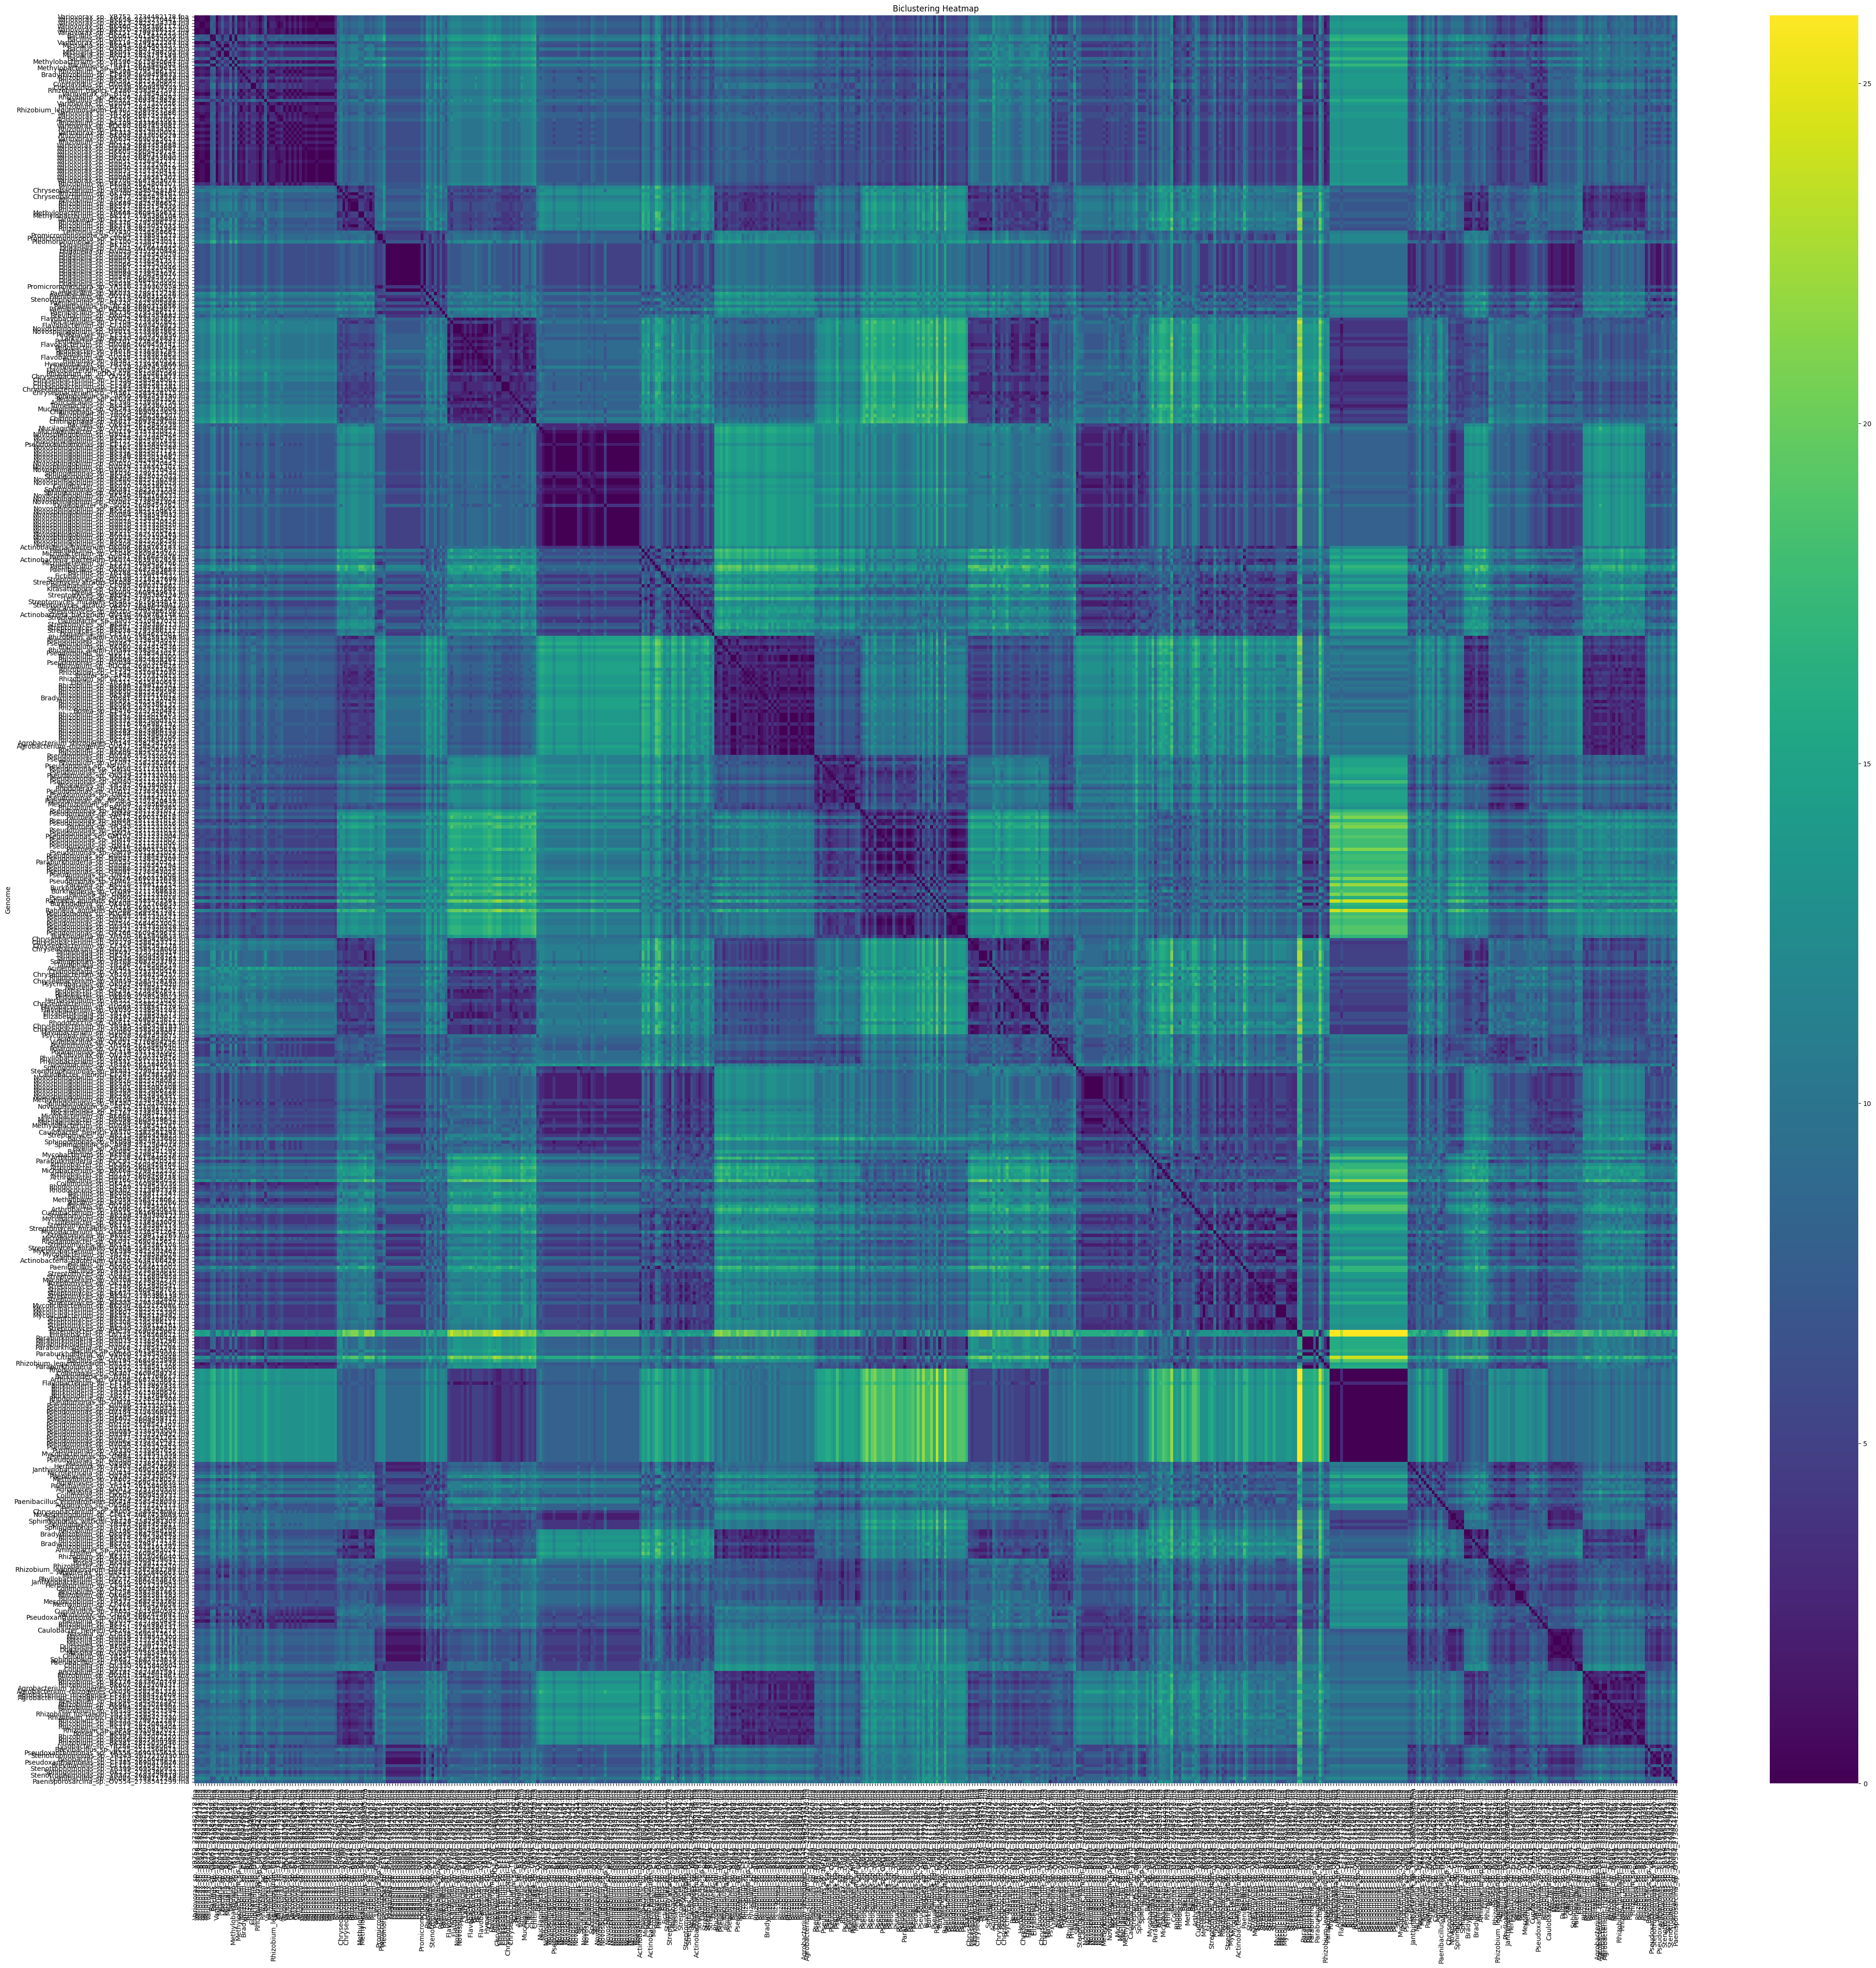

In [ ]:
dataset = "PMI"
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralBiclustering
import pprint

# Load your data into a Pandas DataFrame
data = pd.read_csv(kbdevutil.out_dir()+dataset+"-Distances.tsv", sep='\t', index_col=0)

# Create a Spectral Biclustering model
model = SpectralBiclustering(n_clusters=24)  # Adjust the number of clusters as needed
#Clustered Heatmaps: apply hierarchical clustering to rows and columns 
#independently and then visualize the reordered data using a heatmap. 
#This helps reveal the overall structure of biclusters and how they relate to each other.

# Fit the model to your data
model.fit(data)

# Reorder rows and columns based on the biclustering
row_permutation = np.argsort(model.row_labels_)
col_permutation = np.argsort(model.row_labels_)

# Reorder the data frame
data = data.iloc[row_permutation, col_permutation]

# Generate the clustered heatmap
plt.figure(figsize=(50, 48))
sns.heatmap(data, cmap='viridis', annot=False, fmt='.2f', cbar=True, xticklabels=True, yticklabels=True, annot_kws={'size': 18})

plt.title("Biclustering Heatmap")
plt.show() 

# Generating PCA plots of phenotype data

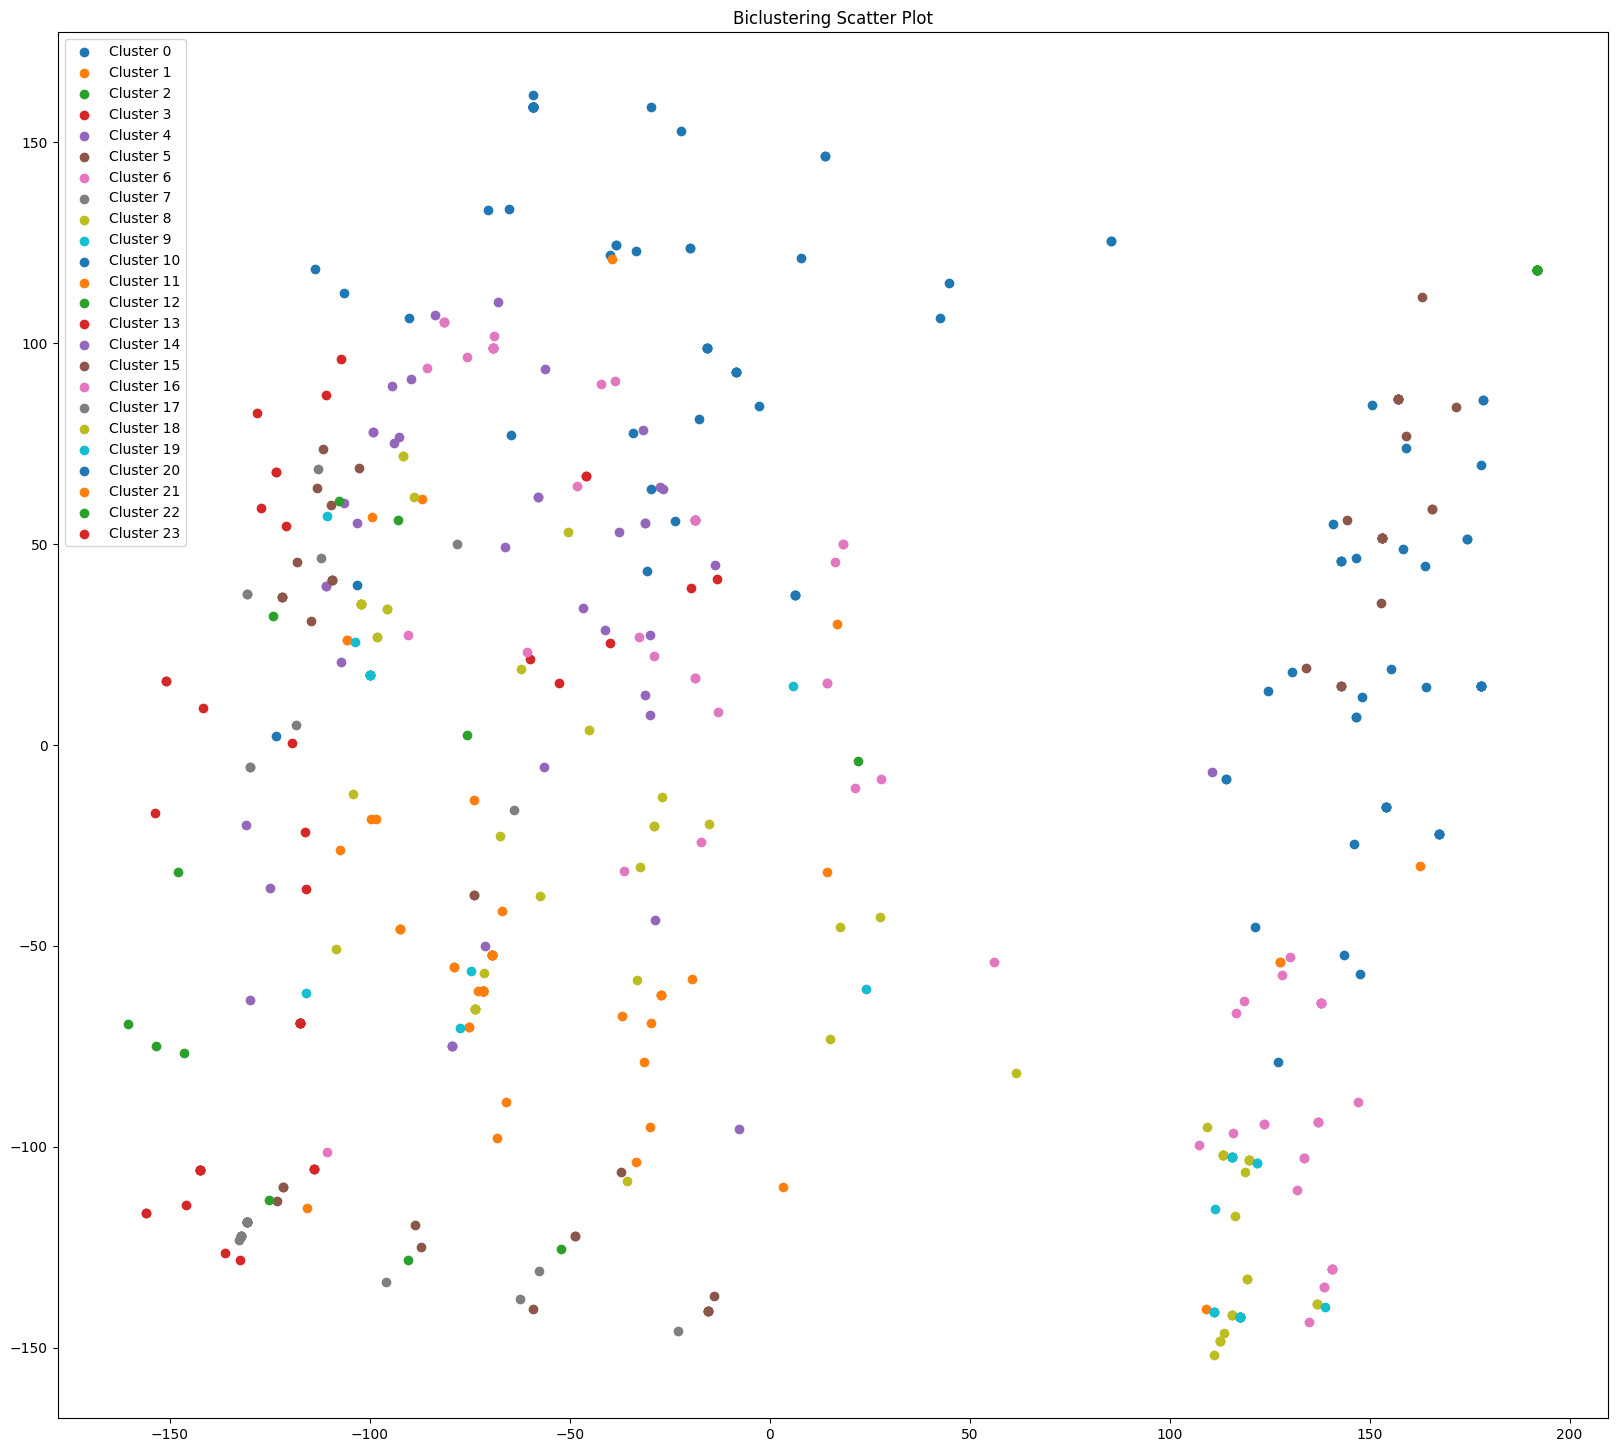

In [ ]:
dataset = "PMI"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load your data into a Pandas DataFrame
# Replace 'your_data.tsv' with your tab-delimited data file's path
data = pd.read_csv(kbdevutil.out_dir()+dataset+"-Summary.tsv", sep='\t', index_col=0)
#Convert text based classes to numeric values
data = data.replace("GROWTH", 100)
data = data.replace("NOGROWTH", 1)

# Fit the model to your data
model.fit(data)

# Perform PCA to reduce dimensionality for scatter plot
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Get the row and column bicluster labels
row_labels = model.row_labels_
col_labels = model.column_labels_
#col_labels = model.row_labels_

# Create a scatter plot for the biclusters
plt.figure(figsize=(20, 18))
for cluster in np.unique(row_labels):
    mask = row_labels == cluster
    plt.scatter(data_pca[mask, 0], data_pca[mask, 1], label=f'Cluster {cluster}')

plt.title("Biclustering Scatter Plot")
plt.legend()
plt.show()

# Debugging cells

In [ ]:
mdlutl = msrecon.get_model("151253/GCF_000005845.2.RAST.Complete.mdl")#GCF_000005845.2.RAST.mdl_auto_params")
mdlutl.model.objective = "bio1"
mdlutl.pkgmgr.getpkg("KBaseMediaPkg").build_package(media)
print(str(mdlutl.model.slim_optimize()))

65.44433338470154


In [ ]:
pheno = MSGrowthPhenotype("cpd00027",media=gmm_media,additional_compounds=[])
output = pheno.simulate(mdlutl,"bio1",add_missing_exchanges=True)
#Suggestions: Add base condition arguments to the simulate command and return true baseline growth in output
output

{'growth': -6.5044295879554145e-15,
 'class': 'NOGROWTH',
 'missing_transports': [],
 'baseline_growth': 0.01,
 'GROWING': False}

In [ ]:
#Go to https://narrative.kbase.us/narrative/94026 to see this media
phenoset = MSGrowthPhenotypes(base_media=auxo_media, base_uptake=100,global_atom_limits={"C":1,"N":1,"S":0.1,"P":0.1})

In [ ]:
phenoset.add_phenotypes([pheno])

In [ ]:
phenoset.baseline_growth(mdlutl,"bio1")

0.025370646062921

In [ ]:
pheno.simulate(mdlutl,"bio1",add_missing_exchanges=True)

{'growth': 0.1763425758633992,
 'class': 'GROWTH',
 'missing_transports': ['cpd00084_c0',
  'cpd00215_c0',
  'cpd00104_c0',
  'cpd00393_c0',
  'cpd00220_c0',
  'cpd00218_c0',
  'cpd00557_c0'],
 'baseline_growth': 0.025370646062921,
 'GROWING': True}

In [ ]:
#Suggestions: Add base conditoins to phenotype object in KBase
kbphenoset = msrecon.get_phenotypeset("101536/Escherichia_coli_str._K-12_substr._MG1655",base_media=auxo_media, base_uptake=100, base_excretion=1000,global_atom_limits={"C":1})